In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb
import pybaseball as pyb
import seaborn as sns


In [18]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [19]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [20]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [21]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"

    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']

    df['throws'] = df['p_throws'].apply(lambda x: 1 if x == 'R' else 0)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')

    dfs['height_ratio'] = dfs['release_pos_z'] / dfs['height_numeric']

    dfs= dfs.dropna(subset=['spin_axis'])
    # Return the preprocessed DataFrame
    return dfs

In [22]:
# Apply the function to the 'pitch_type' column
training_data = preprocess_data(data, height_df)
testing_data_processed = preprocess_data(testing_data, height_df)


In [23]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')

# Fastball Model First

In [24]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'height_numeric'
    ], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment',
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'Unnamed: 0', 'height_numeric'
], axis=1)   # Exclude the identifier from the features

In [25]:
train_data = training_features.drop(['spin_axis'], axis=1).copy()
train_label = training_features['spin_axis'].copy()
testing_data = testing_features.drop(['spin_axis'], axis=1).copy()
testing_label = testing_features['spin_axis'].copy()

In [26]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'throws', 'height_ratio'],
      dtype='object')

In [27]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'throws', 'height_ratio'],
      dtype='object')

In [28]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [29]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'device' : 'gpu',
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [30]:
y_pred = model.predict(dtest)

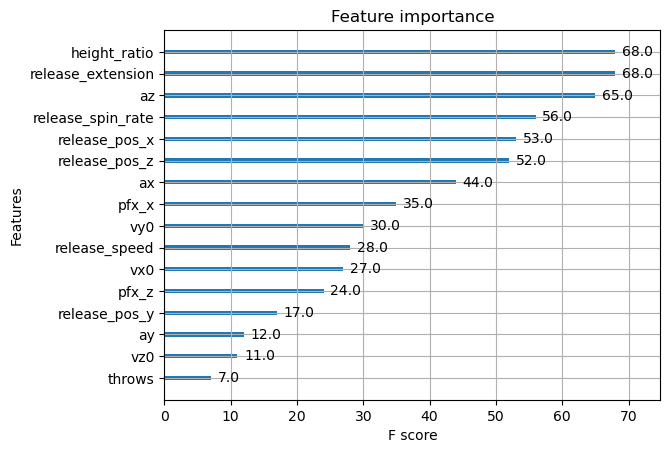

In [31]:
xgb.plot_importance(model)
plt.show()

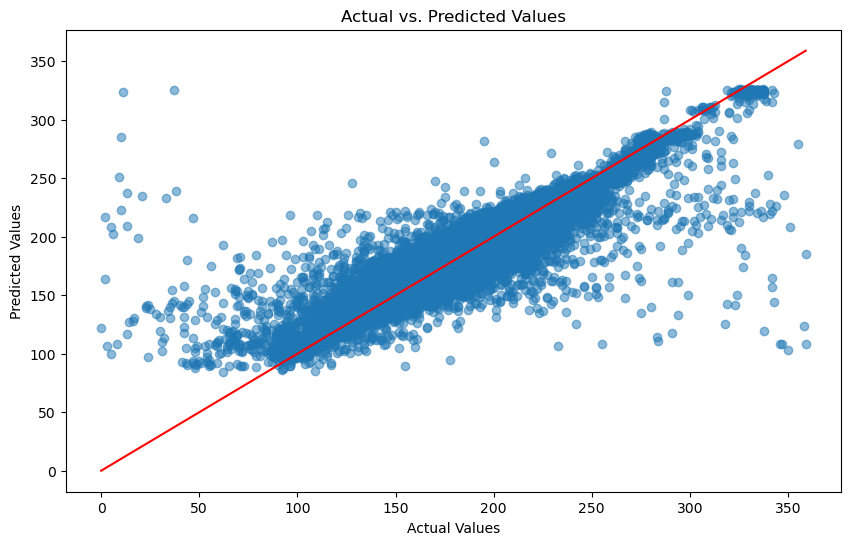

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

# Initial Paramater Tuning

In [33]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'device': 'gpu'
        }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [34]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-10 12:23:56,473] A new study created in memory with name: no-name-4c70064f-8a74-495b-87a3-899700caf3d5
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.15361
[1]	eval-rmse:19.14091
[2]	eval-rmse:15.11555
[3]	eval-rmse:13.03543
[4]	eval-rmse:11.72533
[5]	eval-rmse:11.21952
[6]	eval-rmse:10.86222
[7]	eval-rmse:10.66780
[8]	eval-rmse:10.57739
[9]	eval-rmse:10.49590
[10]	eval-rmse:10.41986
[11]	eval-rmse:10.38268
[12]	eval-rmse:10.33981
[13]	eval-rmse:10.31284
[14]	eval-rmse:10.28687
[15]	eval-rmse:10.26154
[16]	eval-rmse:10.26408
[17]	eval-rmse:10.28878
[18]	eval-rmse:10.29337
[19]	eval-rmse:10.24397
[20]	eval-rmse:10.21702
[21]	eval-rmse:10.23963
[22]	eval-rmse:10.22642
[23]	eval-rmse:10.22745
[24]	eval-rmse:10.22587
[25]	eval-rmse:10.22188
[26]	eval-rmse:10.21504
[27]	eval-rmse:10.22351
[28]	eval-rmse:10.22178
[29]	eval-rmse:10.22212
[30]	eval-rmse:10.21258
[31]	eval-rmse:10.20631
[32]	eval-rmse:10.21362
[33]	eval-rmse:10.21159
[34]	eval-rmse:10.18844
[35]	eval-rmse:10.19873
[36]	eval-rmse:10.19550
[37]	eval-rmse:10.21186
[38]	eval-rmse:10.21670
[39]	eval-rmse:10.21233
[40]	eval-rmse:10.20814
[41]	eval-rmse:10.19519
[4

[I 2023-11-10 12:23:59,948] Trial 0 finished with value: 10.115967921684964 and parameters: {'max_depth': 8, 'eta': 0.34431036158290595, 'subsample': 0.4937091773222582, 'colsample_bytree': 0.5246386303589545, 'min_child_weight': 5}. Best is trial 0 with value: 10.115967921684964.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.09282
[1]	eval-rmse:23.10532
[2]	eval-rmse:19.05214
[3]	eval-rmse:16.55992
[4]	eval-rmse:14.41362
[5]	eval-rmse:13.35246
[6]	eval-rmse:12.54712
[7]	eval-rmse:11.97809
[8]	eval-rmse:11.59457
[9]	eval-rmse:11.37490
[10]	eval-rmse:11.13790
[11]	eval-rmse:11.03172
[12]	eval-rmse:10.96095
[13]	eval-rmse:10.88570
[14]	eval-rmse:10.82709
[15]	eval-rmse:10.80120
[16]	eval-rmse:10.73729
[17]	eval-rmse:10.69246
[18]	eval-rmse:10.65523
[19]	eval-rmse:10.62691
[20]	eval-rmse:10.62219
[21]	eval-rmse:10.59963
[22]	eval-rmse:10.57942
[23]	eval-rmse:10.55910
[24]	eval-rmse:10.54186
[25]	eval-rmse:10.51298
[26]	eval-rmse:10.50812
[27]	eval-rmse:10.50815
[28]	eval-rmse:10.50961
[29]	eval-rmse:10.50615
[30]	eval-rmse:10.51437
[31]	eval-rmse:10.50190
[32]	eval-rmse:10.48099
[33]	eval-rmse:10.47551
[34]	eval-rmse:10.46452
[35]	eval-rmse:10.46864
[36]	eval-rmse:10.48270
[37]	eval-rmse:10.47374
[38]	eval-rmse:10.47173
[39]	eval-rmse:10.46765
[40]	eval-rmse:10.45874
[41]	eval-rmse:10.45616
[4

[I 2023-11-10 12:24:02,887] Trial 1 finished with value: 10.317070753401348 and parameters: {'max_depth': 6, 'eta': 0.260697604795505, 'subsample': 0.5467231430939286, 'colsample_bytree': 0.4024714902982677, 'min_child_weight': 5}. Best is trial 1 with value: 10.317070753401348.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.15971
[1]	eval-rmse:21.61356
[2]	eval-rmse:17.68083
[3]	eval-rmse:15.83176
[4]	eval-rmse:13.94348
[5]	eval-rmse:13.20342
[6]	eval-rmse:12.62461
[7]	eval-rmse:12.24423
[8]	eval-rmse:11.97748
[9]	eval-rmse:11.81776
[10]	eval-rmse:11.59815
[11]	eval-rmse:11.54856
[12]	eval-rmse:11.49472
[13]	eval-rmse:11.41947
[14]	eval-rmse:11.34248
[15]	eval-rmse:11.31965
[16]	eval-rmse:11.27304
[17]	eval-rmse:11.21245
[18]	eval-rmse:11.19961
[19]	eval-rmse:11.15552
[20]	eval-rmse:11.11022
[21]	eval-rmse:11.08868
[22]	eval-rmse:11.07117
[23]	eval-rmse:11.08057
[24]	eval-rmse:11.07237
[25]	eval-rmse:11.05618
[26]	eval-rmse:11.04316
[27]	eval-rmse:11.02340
[28]	eval-rmse:11.01507
[29]	eval-rmse:10.97497
[30]	eval-rmse:10.95850
[31]	eval-rmse:10.94945
[32]	eval-rmse:10.93629
[33]	eval-rmse:10.92668
[34]	eval-rmse:10.91812
[35]	eval-rmse:10.90530
[36]	eval-rmse:10.89200
[37]	eval-rmse:10.88540
[38]	eval-rmse:10.87537
[39]	eval-rmse:10.86956
[40]	eval-rmse:10.85011
[41]	eval-rmse:10.82837
[4

[I 2023-11-10 12:24:05,908] Trial 2 finished with value: 10.54783055028869 and parameters: {'max_depth': 4, 'eta': 0.3158894301719396, 'subsample': 0.4895513409313281, 'colsample_bytree': 0.4276411818670717, 'min_child_weight': 4}. Best is trial 2 with value: 10.54783055028869.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.38422
[1]	eval-rmse:20.56547
[2]	eval-rmse:16.62430
[3]	eval-rmse:14.55648
[4]	eval-rmse:13.04572
[5]	eval-rmse:12.46343
[6]	eval-rmse:11.98847
[7]	eval-rmse:11.76049
[8]	eval-rmse:11.49803
[9]	eval-rmse:11.40122
[10]	eval-rmse:11.28202
[11]	eval-rmse:11.23041
[12]	eval-rmse:11.18886
[13]	eval-rmse:11.14403
[14]	eval-rmse:11.12306
[15]	eval-rmse:11.09634
[16]	eval-rmse:11.08790
[17]	eval-rmse:11.07137
[18]	eval-rmse:11.02690
[19]	eval-rmse:11.00950
[20]	eval-rmse:10.97468
[21]	eval-rmse:10.95016
[22]	eval-rmse:10.94358
[23]	eval-rmse:10.92484
[24]	eval-rmse:10.91317
[25]	eval-rmse:10.90742
[26]	eval-rmse:10.88848
[27]	eval-rmse:10.87004
[28]	eval-rmse:10.85677
[29]	eval-rmse:10.86501
[30]	eval-rmse:10.86297
[31]	eval-rmse:10.84975
[32]	eval-rmse:10.84713
[33]	eval-rmse:10.84106
[34]	eval-rmse:10.81757
[35]	eval-rmse:10.79558
[36]	eval-rmse:10.78986
[37]	eval-rmse:10.78065
[38]	eval-rmse:10.77009
[39]	eval-rmse:10.75824
[40]	eval-rmse:10.75124
[41]	eval-rmse:10.73585
[4

[I 2023-11-10 12:24:08,587] Trial 3 finished with value: 10.583206073746728 and parameters: {'max_depth': 4, 'eta': 0.3362649611972924, 'subsample': 0.5940484139119807, 'colsample_bytree': 0.5645778395473339, 'min_child_weight': 3}. Best is trial 3 with value: 10.583206073746728.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.58255
[1]	eval-rmse:18.29490
[2]	eval-rmse:14.78505
[3]	eval-rmse:13.37082
[4]	eval-rmse:12.20307
[5]	eval-rmse:11.89983
[6]	eval-rmse:11.63511
[7]	eval-rmse:11.42177
[8]	eval-rmse:11.30685
[9]	eval-rmse:11.22316
[10]	eval-rmse:11.11079
[11]	eval-rmse:11.05546
[12]	eval-rmse:11.03103
[13]	eval-rmse:11.00265
[14]	eval-rmse:10.98701
[15]	eval-rmse:10.94629
[16]	eval-rmse:10.93745
[17]	eval-rmse:10.90845
[18]	eval-rmse:10.88576
[19]	eval-rmse:10.86634
[20]	eval-rmse:10.83757
[21]	eval-rmse:10.83593
[22]	eval-rmse:10.83741
[23]	eval-rmse:10.82670
[24]	eval-rmse:10.80763
[25]	eval-rmse:10.80351
[26]	eval-rmse:10.78262
[27]	eval-rmse:10.76266
[28]	eval-rmse:10.76398
[29]	eval-rmse:10.74018
[30]	eval-rmse:10.72891
[31]	eval-rmse:10.72435
[32]	eval-rmse:10.71812
[33]	eval-rmse:10.71623
[34]	eval-rmse:10.69081
[35]	eval-rmse:10.68264
[36]	eval-rmse:10.68753
[37]	eval-rmse:10.66891
[38]	eval-rmse:10.67288
[39]	eval-rmse:10.66987
[40]	eval-rmse:10.66474
[41]	eval-rmse:10.64170
[4

[I 2023-11-10 12:24:10,725] Trial 4 finished with value: 10.611813037254498 and parameters: {'max_depth': 5, 'eta': 0.3958050635875243, 'subsample': 0.5777205346822697, 'colsample_bytree': 0.4457217111440498, 'min_child_weight': 1}. Best is trial 4 with value: 10.611813037254498.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.55356
[1]	eval-rmse:25.49537
[2]	eval-rmse:21.64047
[3]	eval-rmse:18.93658
[4]	eval-rmse:16.47041
[5]	eval-rmse:14.96094
[6]	eval-rmse:13.75899
[7]	eval-rmse:12.83326
[8]	eval-rmse:12.14038
[9]	eval-rmse:11.63747
[10]	eval-rmse:11.25610
[11]	eval-rmse:11.03658
[12]	eval-rmse:10.87782
[13]	eval-rmse:10.74455
[14]	eval-rmse:10.64588
[15]	eval-rmse:10.58939
[16]	eval-rmse:10.49683
[17]	eval-rmse:10.44225
[18]	eval-rmse:10.38638
[19]	eval-rmse:10.37128
[20]	eval-rmse:10.31472
[21]	eval-rmse:10.28650
[22]	eval-rmse:10.26777
[23]	eval-rmse:10.25281
[24]	eval-rmse:10.23960
[25]	eval-rmse:10.19245
[26]	eval-rmse:10.18292
[27]	eval-rmse:10.15699
[28]	eval-rmse:10.14841
[29]	eval-rmse:10.13057
[30]	eval-rmse:10.12667
[31]	eval-rmse:10.12746
[32]	eval-rmse:10.11283
[33]	eval-rmse:10.10739
[34]	eval-rmse:10.10494
[35]	eval-rmse:10.09018
[36]	eval-rmse:10.08772
[37]	eval-rmse:10.06940
[38]	eval-rmse:10.06284
[39]	eval-rmse:10.05358
[40]	eval-rmse:10.05093
[41]	eval-rmse:10.04914
[4

[I 2023-11-10 12:24:14,525] Trial 5 finished with value: 9.928521517319822 and parameters: {'max_depth': 8, 'eta': 0.20044800266010432, 'subsample': 0.588816858621982, 'colsample_bytree': 0.42275171939255163, 'min_child_weight': 2}. Best is trial 4 with value: 10.611813037254498.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.54204
[1]	eval-rmse:25.33350
[2]	eval-rmse:21.44283
[3]	eval-rmse:18.64590
[4]	eval-rmse:16.33502
[5]	eval-rmse:14.91215
[6]	eval-rmse:13.68598
[7]	eval-rmse:12.90935
[8]	eval-rmse:12.20733
[9]	eval-rmse:11.77449
[10]	eval-rmse:11.42706
[11]	eval-rmse:11.16144
[12]	eval-rmse:11.00196
[13]	eval-rmse:10.86879
[14]	eval-rmse:10.79013
[15]	eval-rmse:10.70963
[16]	eval-rmse:10.64956
[17]	eval-rmse:10.60586
[18]	eval-rmse:10.59279
[19]	eval-rmse:10.57910
[20]	eval-rmse:10.54138
[21]	eval-rmse:10.51058
[22]	eval-rmse:10.48947
[23]	eval-rmse:10.47410
[24]	eval-rmse:10.46567
[25]	eval-rmse:10.45156
[26]	eval-rmse:10.45913
[27]	eval-rmse:10.44323
[28]	eval-rmse:10.44316
[29]	eval-rmse:10.43230
[30]	eval-rmse:10.42112
[31]	eval-rmse:10.40331
[32]	eval-rmse:10.40199
[33]	eval-rmse:10.41042
[34]	eval-rmse:10.40823
[35]	eval-rmse:10.42175
[36]	eval-rmse:10.43146
[37]	eval-rmse:10.42419
[38]	eval-rmse:10.40984
[39]	eval-rmse:10.40582
[40]	eval-rmse:10.39530
[41]	eval-rmse:10.38939
[4

[I 2023-11-10 12:24:18,424] Trial 6 finished with value: 10.222838835670963 and parameters: {'max_depth': 6, 'eta': 0.2048692341276441, 'subsample': 0.47065589579446165, 'colsample_bytree': 0.5966228165695054, 'min_child_weight': 1}. Best is trial 4 with value: 10.611813037254498.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37858
[1]	eval-rmse:23.54701
[2]	eval-rmse:19.52993
[3]	eval-rmse:16.99608
[4]	eval-rmse:14.76002
[5]	eval-rmse:13.60928
[6]	eval-rmse:12.71653
[7]	eval-rmse:12.09271
[8]	eval-rmse:11.68070
[9]	eval-rmse:11.42352
[10]	eval-rmse:11.16790
[11]	eval-rmse:11.04736
[12]	eval-rmse:10.98168
[13]	eval-rmse:10.89058
[14]	eval-rmse:10.81866
[15]	eval-rmse:10.78978
[16]	eval-rmse:10.72666
[17]	eval-rmse:10.68635
[18]	eval-rmse:10.66979
[19]	eval-rmse:10.63569
[20]	eval-rmse:10.60329
[21]	eval-rmse:10.58816
[22]	eval-rmse:10.56910
[23]	eval-rmse:10.56846
[24]	eval-rmse:10.55862
[25]	eval-rmse:10.54398
[26]	eval-rmse:10.53608
[27]	eval-rmse:10.51634
[28]	eval-rmse:10.51199
[29]	eval-rmse:10.49768
[30]	eval-rmse:10.49863
[31]	eval-rmse:10.48927
[32]	eval-rmse:10.47473
[33]	eval-rmse:10.46403
[34]	eval-rmse:10.45604
[35]	eval-rmse:10.45658
[36]	eval-rmse:10.45250
[37]	eval-rmse:10.44511
[38]	eval-rmse:10.43077
[39]	eval-rmse:10.42584
[40]	eval-rmse:10.42164
[41]	eval-rmse:10.40331
[4

[I 2023-11-10 12:24:21,354] Trial 7 finished with value: 10.246326776387734 and parameters: {'max_depth': 6, 'eta': 0.2502451647992265, 'subsample': 0.514252559288681, 'colsample_bytree': 0.4366847984053197, 'min_child_weight': 2}. Best is trial 4 with value: 10.611813037254498.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.53619
[1]	eval-rmse:20.76844
[2]	eval-rmse:16.83723
[3]	eval-rmse:14.81964
[4]	eval-rmse:13.09999
[5]	eval-rmse:12.47627
[6]	eval-rmse:11.96922
[7]	eval-rmse:11.65454
[8]	eval-rmse:11.44765
[9]	eval-rmse:11.31394
[10]	eval-rmse:11.14375
[11]	eval-rmse:11.07824
[12]	eval-rmse:11.03654
[13]	eval-rmse:10.99859
[14]	eval-rmse:10.98201
[15]	eval-rmse:10.96074
[16]	eval-rmse:10.92736
[17]	eval-rmse:10.89001
[18]	eval-rmse:10.86325
[19]	eval-rmse:10.83078
[20]	eval-rmse:10.80981
[21]	eval-rmse:10.78818
[22]	eval-rmse:10.76426
[23]	eval-rmse:10.76264
[24]	eval-rmse:10.74937
[25]	eval-rmse:10.73719
[26]	eval-rmse:10.74223
[27]	eval-rmse:10.75508
[28]	eval-rmse:10.74646
[29]	eval-rmse:10.73127
[30]	eval-rmse:10.70989
[31]	eval-rmse:10.71777
[32]	eval-rmse:10.70144
[33]	eval-rmse:10.68918
[34]	eval-rmse:10.68140
[35]	eval-rmse:10.67547
[36]	eval-rmse:10.68456
[37]	eval-rmse:10.68511
[38]	eval-rmse:10.68697
[39]	eval-rmse:10.67615
[40]	eval-rmse:10.65648
[41]	eval-rmse:10.63517
[4

[I 2023-11-10 12:24:23,587] Trial 8 finished with value: 10.575115208882343 and parameters: {'max_depth': 5, 'eta': 0.32179395674799394, 'subsample': 0.4675972861504488, 'colsample_bytree': 0.48486584784112435, 'min_child_weight': 3}. Best is trial 4 with value: 10.611813037254498.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.36957
[1]	eval-rmse:25.13674
[2]	eval-rmse:21.20561
[3]	eval-rmse:18.34593
[4]	eval-rmse:16.02649
[5]	eval-rmse:14.56872
[6]	eval-rmse:13.35367
[7]	eval-rmse:12.56814
[8]	eval-rmse:11.91633
[9]	eval-rmse:11.50118
[10]	eval-rmse:11.16636
[11]	eval-rmse:10.91772
[12]	eval-rmse:10.77512
[13]	eval-rmse:10.64978
[14]	eval-rmse:10.59795
[15]	eval-rmse:10.53914
[16]	eval-rmse:10.50154
[17]	eval-rmse:10.43684
[18]	eval-rmse:10.40040
[19]	eval-rmse:10.37639
[20]	eval-rmse:10.34378
[21]	eval-rmse:10.31231
[22]	eval-rmse:10.29119
[23]	eval-rmse:10.28148
[24]	eval-rmse:10.27494
[25]	eval-rmse:10.29701
[26]	eval-rmse:10.29102
[27]	eval-rmse:10.28246
[28]	eval-rmse:10.27875
[29]	eval-rmse:10.27881
[30]	eval-rmse:10.27165
[31]	eval-rmse:10.26183
[32]	eval-rmse:10.24182
[33]	eval-rmse:10.23618
[34]	eval-rmse:10.23463
[35]	eval-rmse:10.23630
[36]	eval-rmse:10.24701
[37]	eval-rmse:10.24701
[38]	eval-rmse:10.21736
[39]	eval-rmse:10.21891
[40]	eval-rmse:10.22072
[41]	eval-rmse:10.23007
[4

[I 2023-11-10 12:24:27,293] Trial 9 finished with value: 10.058572305884695 and parameters: {'max_depth': 7, 'eta': 0.20531121288656248, 'subsample': 0.40033076619001884, 'colsample_bytree': 0.5981225599163381, 'min_child_weight': 2}. Best is trial 4 with value: 10.611813037254498.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.48184
[1]	eval-rmse:18.17946
[2]	eval-rmse:14.69807
[3]	eval-rmse:13.30177
[4]	eval-rmse:12.16057
[5]	eval-rmse:11.87612
[6]	eval-rmse:11.61180
[7]	eval-rmse:11.40202
[8]	eval-rmse:11.30568
[9]	eval-rmse:11.22922
[10]	eval-rmse:11.10740
[11]	eval-rmse:11.05787
[12]	eval-rmse:11.04177
[13]	eval-rmse:11.00287
[14]	eval-rmse:11.01304
[15]	eval-rmse:10.98281
[16]	eval-rmse:10.94065
[17]	eval-rmse:10.91344
[18]	eval-rmse:10.90461
[19]	eval-rmse:10.87193
[20]	eval-rmse:10.85897
[21]	eval-rmse:10.81691
[22]	eval-rmse:10.82482
[23]	eval-rmse:10.83044
[24]	eval-rmse:10.82056
[25]	eval-rmse:10.81184
[26]	eval-rmse:10.79053
[27]	eval-rmse:10.75797
[28]	eval-rmse:10.73374
[29]	eval-rmse:10.71931
[30]	eval-rmse:10.68495
[31]	eval-rmse:10.68660
[32]	eval-rmse:10.64962
[33]	eval-rmse:10.66151
[34]	eval-rmse:10.63854
[35]	eval-rmse:10.62667
[36]	eval-rmse:10.63708
[37]	eval-rmse:10.63390
[38]	eval-rmse:10.62379
[39]	eval-rmse:10.62651
[40]	eval-rmse:10.61804
[41]	eval-rmse:10.60733
[4

[I 2023-11-10 12:24:29,475] Trial 10 finished with value: 10.522742933630711 and parameters: {'max_depth': 5, 'eta': 0.39987698636178093, 'subsample': 0.5579793747040585, 'colsample_bytree': 0.464552704364431, 'min_child_weight': 1}. Best is trial 4 with value: 10.611813037254498.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09194
[1]	eval-rmse:18.89035
[2]	eval-rmse:15.25135
[3]	eval-rmse:13.59950
[4]	eval-rmse:12.52266
[5]	eval-rmse:12.13237
[6]	eval-rmse:11.82422
[7]	eval-rmse:11.66273
[8]	eval-rmse:11.53259
[9]	eval-rmse:11.46177
[10]	eval-rmse:11.34549
[11]	eval-rmse:11.27228
[12]	eval-rmse:11.22462
[13]	eval-rmse:11.20385
[14]	eval-rmse:11.18847
[15]	eval-rmse:11.13523
[16]	eval-rmse:11.08413
[17]	eval-rmse:11.06010
[18]	eval-rmse:11.05023
[19]	eval-rmse:11.03091
[20]	eval-rmse:10.99866
[21]	eval-rmse:10.97739
[22]	eval-rmse:10.95985
[23]	eval-rmse:10.92679
[24]	eval-rmse:10.90421
[25]	eval-rmse:10.90434
[26]	eval-rmse:10.88967
[27]	eval-rmse:10.87513
[28]	eval-rmse:10.87623
[29]	eval-rmse:10.85781
[30]	eval-rmse:10.84655
[31]	eval-rmse:10.82239
[32]	eval-rmse:10.80341
[33]	eval-rmse:10.80857
[34]	eval-rmse:10.79084
[35]	eval-rmse:10.77917
[36]	eval-rmse:10.77584
[37]	eval-rmse:10.77814
[38]	eval-rmse:10.76420
[39]	eval-rmse:10.75647
[40]	eval-rmse:10.73958
[41]	eval-rmse:10.72223
[4

[I 2023-11-10 12:24:31,577] Trial 11 finished with value: 10.628839583413608 and parameters: {'max_depth': 4, 'eta': 0.3871139173762767, 'subsample': 0.5954454383260609, 'colsample_bytree': 0.5271603420776071, 'min_child_weight': 3}. Best is trial 11 with value: 10.628839583413608.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.41839
[1]	eval-rmse:18.16279
[2]	eval-rmse:14.62243
[3]	eval-rmse:13.01566
[4]	eval-rmse:11.97432
[5]	eval-rmse:11.68559
[6]	eval-rmse:11.42449
[7]	eval-rmse:11.26122
[8]	eval-rmse:11.16298
[9]	eval-rmse:11.11901
[10]	eval-rmse:11.03450
[11]	eval-rmse:10.99401
[12]	eval-rmse:10.94543
[13]	eval-rmse:10.91516
[14]	eval-rmse:10.90775
[15]	eval-rmse:10.86293
[16]	eval-rmse:10.81579
[17]	eval-rmse:10.80127
[18]	eval-rmse:10.78459
[19]	eval-rmse:10.76988
[20]	eval-rmse:10.72574
[21]	eval-rmse:10.70297
[22]	eval-rmse:10.71989
[23]	eval-rmse:10.70696
[24]	eval-rmse:10.70508
[25]	eval-rmse:10.67575
[26]	eval-rmse:10.66295
[27]	eval-rmse:10.64502
[28]	eval-rmse:10.63674
[29]	eval-rmse:10.60805
[30]	eval-rmse:10.60566
[31]	eval-rmse:10.59879
[32]	eval-rmse:10.59154
[33]	eval-rmse:10.59244
[34]	eval-rmse:10.57679
[35]	eval-rmse:10.56487
[36]	eval-rmse:10.55924
[37]	eval-rmse:10.55388
[38]	eval-rmse:10.54858
[39]	eval-rmse:10.53948
[40]	eval-rmse:10.53638
[41]	eval-rmse:10.53259
[4

[I 2023-11-10 12:24:34,535] Trial 12 finished with value: 10.377673093361071 and parameters: {'max_depth': 5, 'eta': 0.3965283997215323, 'subsample': 0.5950758670449402, 'colsample_bytree': 0.5129522901106702, 'min_child_weight': 4}. Best is trial 11 with value: 10.628839583413608.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.83868
[1]	eval-rmse:19.76481
[2]	eval-rmse:16.05770
[3]	eval-rmse:14.33802
[4]	eval-rmse:12.85343
[5]	eval-rmse:12.45830
[6]	eval-rmse:12.06322
[7]	eval-rmse:11.78848
[8]	eval-rmse:11.62193
[9]	eval-rmse:11.53186
[10]	eval-rmse:11.36543
[11]	eval-rmse:11.27125
[12]	eval-rmse:11.25682
[13]	eval-rmse:11.21021
[14]	eval-rmse:11.19587
[15]	eval-rmse:11.16562
[16]	eval-rmse:11.12014
[17]	eval-rmse:11.08416
[18]	eval-rmse:11.06298
[19]	eval-rmse:11.03418
[20]	eval-rmse:11.01820
[21]	eval-rmse:11.00198
[22]	eval-rmse:10.99004
[23]	eval-rmse:10.97194
[24]	eval-rmse:10.95134
[25]	eval-rmse:10.94481
[26]	eval-rmse:10.93049
[27]	eval-rmse:10.91737
[28]	eval-rmse:10.89774
[29]	eval-rmse:10.87226
[30]	eval-rmse:10.86425
[31]	eval-rmse:10.86119
[32]	eval-rmse:10.83757
[33]	eval-rmse:10.83868
[34]	eval-rmse:10.83231
[35]	eval-rmse:10.82005
[36]	eval-rmse:10.81428
[37]	eval-rmse:10.80399
[38]	eval-rmse:10.79678
[39]	eval-rmse:10.78669
[40]	eval-rmse:10.77478
[41]	eval-rmse:10.75287
[4

[I 2023-11-10 12:24:37,257] Trial 13 finished with value: 10.572943923078464 and parameters: {'max_depth': 4, 'eta': 0.36529188273050067, 'subsample': 0.5562318069840867, 'colsample_bytree': 0.47462344802216955, 'min_child_weight': 1}. Best is trial 11 with value: 10.628839583413608.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07964
[1]	eval-rmse:18.94401
[2]	eval-rmse:15.20371
[3]	eval-rmse:13.40840
[4]	eval-rmse:12.17304
[5]	eval-rmse:11.79501
[6]	eval-rmse:11.47289
[7]	eval-rmse:11.28772
[8]	eval-rmse:11.18068
[9]	eval-rmse:11.13268
[10]	eval-rmse:11.04096
[11]	eval-rmse:10.99420
[12]	eval-rmse:10.96688
[13]	eval-rmse:10.90879
[14]	eval-rmse:10.87718
[15]	eval-rmse:10.82637
[16]	eval-rmse:10.77795
[17]	eval-rmse:10.74936
[18]	eval-rmse:10.73201
[19]	eval-rmse:10.71546
[20]	eval-rmse:10.68777
[21]	eval-rmse:10.67300
[22]	eval-rmse:10.65377
[23]	eval-rmse:10.63332
[24]	eval-rmse:10.62573
[25]	eval-rmse:10.60781
[26]	eval-rmse:10.58938
[27]	eval-rmse:10.57773
[28]	eval-rmse:10.55376
[29]	eval-rmse:10.54451
[30]	eval-rmse:10.53064
[31]	eval-rmse:10.51678
[32]	eval-rmse:10.48560
[33]	eval-rmse:10.49020
[34]	eval-rmse:10.48236
[35]	eval-rmse:10.47089
[36]	eval-rmse:10.45612
[37]	eval-rmse:10.45864
[38]	eval-rmse:10.45618
[39]	eval-rmse:10.45656
[40]	eval-rmse:10.44907
[41]	eval-rmse:10.45847
[4

[I 2023-11-10 12:24:40,299] Trial 14 finished with value: 10.289701892781334 and parameters: {'max_depth': 5, 'eta': 0.3715034782749788, 'subsample': 0.5733718821875421, 'colsample_bytree': 0.5359654771274516, 'min_child_weight': 4}. Best is trial 11 with value: 10.628839583413608.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.93209
[1]	eval-rmse:19.88760
[2]	eval-rmse:16.16079
[3]	eval-rmse:14.42128
[4]	eval-rmse:12.91854
[5]	eval-rmse:12.51090
[6]	eval-rmse:12.12165
[7]	eval-rmse:11.83527
[8]	eval-rmse:11.65410
[9]	eval-rmse:11.55490
[10]	eval-rmse:11.44894
[11]	eval-rmse:11.33973
[12]	eval-rmse:11.32023
[13]	eval-rmse:11.22850
[14]	eval-rmse:11.18307
[15]	eval-rmse:11.15867
[16]	eval-rmse:11.11781
[17]	eval-rmse:11.08368
[18]	eval-rmse:11.06389
[19]	eval-rmse:11.04820
[20]	eval-rmse:11.03936
[21]	eval-rmse:11.02538
[22]	eval-rmse:11.01117
[23]	eval-rmse:10.98092
[24]	eval-rmse:10.97841
[25]	eval-rmse:10.96646
[26]	eval-rmse:10.95337
[27]	eval-rmse:10.93451
[28]	eval-rmse:10.92570
[29]	eval-rmse:10.90093
[30]	eval-rmse:10.88700
[31]	eval-rmse:10.87927
[32]	eval-rmse:10.85260
[33]	eval-rmse:10.84496
[34]	eval-rmse:10.83729
[35]	eval-rmse:10.82693
[36]	eval-rmse:10.80476
[37]	eval-rmse:10.79030
[38]	eval-rmse:10.78154
[39]	eval-rmse:10.76433
[40]	eval-rmse:10.75878
[41]	eval-rmse:10.74577
[4

[I 2023-11-10 12:24:42,691] Trial 15 finished with value: 10.625161320177511 and parameters: {'max_depth': 4, 'eta': 0.36127233491146304, 'subsample': 0.5395162687466748, 'colsample_bytree': 0.49709913304923187, 'min_child_weight': 2}. Best is trial 11 with value: 10.628839583413608.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.84306
[1]	eval-rmse:19.78086
[2]	eval-rmse:16.06704
[3]	eval-rmse:14.35519
[4]	eval-rmse:12.87653
[5]	eval-rmse:12.47951
[6]	eval-rmse:12.06426
[7]	eval-rmse:11.79973
[8]	eval-rmse:11.62805
[9]	eval-rmse:11.53271
[10]	eval-rmse:11.37251
[11]	eval-rmse:11.30505
[12]	eval-rmse:11.28836
[13]	eval-rmse:11.24699
[14]	eval-rmse:11.23834
[15]	eval-rmse:11.20297
[16]	eval-rmse:11.18091
[17]	eval-rmse:11.16874
[18]	eval-rmse:11.16869
[19]	eval-rmse:11.14578
[20]	eval-rmse:11.10935
[21]	eval-rmse:11.09625
[22]	eval-rmse:11.09265
[23]	eval-rmse:11.06636
[24]	eval-rmse:11.04699
[25]	eval-rmse:11.03253
[26]	eval-rmse:11.01994
[27]	eval-rmse:10.97255
[28]	eval-rmse:10.96602
[29]	eval-rmse:10.92393
[30]	eval-rmse:10.90969
[31]	eval-rmse:10.89214
[32]	eval-rmse:10.87590
[33]	eval-rmse:10.86930
[34]	eval-rmse:10.86197
[35]	eval-rmse:10.85045
[36]	eval-rmse:10.83002
[37]	eval-rmse:10.82164
[38]	eval-rmse:10.80058
[39]	eval-rmse:10.78532
[40]	eval-rmse:10.77412
[41]	eval-rmse:10.76366
[4

[I 2023-11-10 12:24:45,454] Trial 16 finished with value: 10.63817285561757 and parameters: {'max_depth': 4, 'eta': 0.36494698848251705, 'subsample': 0.5314743580993722, 'colsample_bytree': 0.4995884251899374, 'min_child_weight': 3}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.46172
[1]	eval-rmse:18.28627
[2]	eval-rmse:14.45287
[3]	eval-rmse:12.64928
[4]	eval-rmse:11.55793
[5]	eval-rmse:11.18744
[6]	eval-rmse:10.91259
[7]	eval-rmse:10.77589
[8]	eval-rmse:10.69594
[9]	eval-rmse:10.65199
[10]	eval-rmse:10.59466
[11]	eval-rmse:10.52966
[12]	eval-rmse:10.50109
[13]	eval-rmse:10.50659
[14]	eval-rmse:10.50010
[15]	eval-rmse:10.47418
[16]	eval-rmse:10.48732
[17]	eval-rmse:10.46978
[18]	eval-rmse:10.45724
[19]	eval-rmse:10.43022
[20]	eval-rmse:10.42703
[21]	eval-rmse:10.45702
[22]	eval-rmse:10.44967
[23]	eval-rmse:10.45746
[24]	eval-rmse:10.44515
[25]	eval-rmse:10.43829
[26]	eval-rmse:10.44538
[27]	eval-rmse:10.44601
[28]	eval-rmse:10.45173
[29]	eval-rmse:10.46026
[30]	eval-rmse:10.46325


[I 2023-11-10 12:24:46,957] Trial 17 finished with value: 10.427026940620417 and parameters: {'max_depth': 7, 'eta': 0.37342966141768275, 'subsample': 0.5250433229063789, 'colsample_bytree': 0.543676862302872, 'min_child_weight': 3}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.29013
[1]	eval-rmse:20.36207
[2]	eval-rmse:16.54560
[3]	eval-rmse:14.73697
[4]	eval-rmse:13.17261
[5]	eval-rmse:12.69750
[6]	eval-rmse:12.22091
[7]	eval-rmse:11.91730
[8]	eval-rmse:11.72272
[9]	eval-rmse:11.61371
[10]	eval-rmse:11.42864
[11]	eval-rmse:11.32457
[12]	eval-rmse:11.30506
[13]	eval-rmse:11.21708
[14]	eval-rmse:11.19234
[15]	eval-rmse:11.16764
[16]	eval-rmse:11.12702
[17]	eval-rmse:11.10611
[18]	eval-rmse:11.08819
[19]	eval-rmse:11.06500
[20]	eval-rmse:11.04894
[21]	eval-rmse:11.04514
[22]	eval-rmse:11.01440
[23]	eval-rmse:10.99387
[24]	eval-rmse:10.97657
[25]	eval-rmse:10.95244
[26]	eval-rmse:10.93393
[27]	eval-rmse:10.91681
[28]	eval-rmse:10.90271
[29]	eval-rmse:10.87329
[30]	eval-rmse:10.86954
[31]	eval-rmse:10.85107
[32]	eval-rmse:10.83146
[33]	eval-rmse:10.81621
[34]	eval-rmse:10.80352
[35]	eval-rmse:10.78644
[36]	eval-rmse:10.78009
[37]	eval-rmse:10.76677
[38]	eval-rmse:10.74911
[39]	eval-rmse:10.74368
[40]	eval-rmse:10.73386
[41]	eval-rmse:10.73497
[4

[I 2023-11-10 12:24:49,725] Trial 18 finished with value: 10.539155575508113 and parameters: {'max_depth': 4, 'eta': 0.3473327717961263, 'subsample': 0.5700443573202169, 'colsample_bytree': 0.4998399004850727, 'min_child_weight': 3}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.26578
[1]	eval-rmse:21.82053
[2]	eval-rmse:17.78611
[3]	eval-rmse:15.62053
[4]	eval-rmse:13.81945
[5]	eval-rmse:13.03251
[6]	eval-rmse:12.37872
[7]	eval-rmse:12.03341
[8]	eval-rmse:11.77666
[9]	eval-rmse:11.62896
[10]	eval-rmse:11.43511
[11]	eval-rmse:11.32016
[12]	eval-rmse:11.26951
[13]	eval-rmse:11.23310
[14]	eval-rmse:11.21961
[15]	eval-rmse:11.18809
[16]	eval-rmse:11.14922
[17]	eval-rmse:11.09799
[18]	eval-rmse:11.08950
[19]	eval-rmse:11.05690
[20]	eval-rmse:11.02667
[21]	eval-rmse:10.98105
[22]	eval-rmse:10.98670
[23]	eval-rmse:10.95774
[24]	eval-rmse:10.94875
[25]	eval-rmse:10.93960
[26]	eval-rmse:10.92371
[27]	eval-rmse:10.90403
[28]	eval-rmse:10.89705
[29]	eval-rmse:10.88934
[30]	eval-rmse:10.87430
[31]	eval-rmse:10.85208
[32]	eval-rmse:10.83295
[33]	eval-rmse:10.82157
[34]	eval-rmse:10.80863
[35]	eval-rmse:10.79441
[36]	eval-rmse:10.78350
[37]	eval-rmse:10.77076
[38]	eval-rmse:10.74750
[39]	eval-rmse:10.74136
[40]	eval-rmse:10.72852
[41]	eval-rmse:10.71679
[4

[I 2023-11-10 12:24:51,670] Trial 19 finished with value: 10.623763001286202 and parameters: {'max_depth': 4, 'eta': 0.30146345739508357, 'subsample': 0.5363135123673468, 'colsample_bytree': 0.5180998951002188, 'min_child_weight': 4}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.36329
[1]	eval-rmse:18.02411
[2]	eval-rmse:14.35279
[3]	eval-rmse:12.74882
[4]	eval-rmse:11.61171
[5]	eval-rmse:11.26366
[6]	eval-rmse:10.99506
[7]	eval-rmse:10.78311
[8]	eval-rmse:10.69840
[9]	eval-rmse:10.61964
[10]	eval-rmse:10.59635
[11]	eval-rmse:10.55140
[12]	eval-rmse:10.53499
[13]	eval-rmse:10.52620
[14]	eval-rmse:10.52882
[15]	eval-rmse:10.51775
[16]	eval-rmse:10.54432
[17]	eval-rmse:10.53234
[18]	eval-rmse:10.51582
[19]	eval-rmse:10.51922
[20]	eval-rmse:10.47368
[21]	eval-rmse:10.46544
[22]	eval-rmse:10.47540
[23]	eval-rmse:10.47517
[24]	eval-rmse:10.48075
[25]	eval-rmse:10.47038
[26]	eval-rmse:10.46224
[27]	eval-rmse:10.45088
[28]	eval-rmse:10.45784
[29]	eval-rmse:10.47478
[30]	eval-rmse:10.47277
[31]	eval-rmse:10.46208
[32]	eval-rmse:10.45949
[33]	eval-rmse:10.47507
[34]	eval-rmse:10.49503
[35]	eval-rmse:10.48831
[36]	eval-rmse:10.48261
[37]	eval-rmse:10.49620


[I 2023-11-10 12:24:53,374] Trial 20 finished with value: 10.450879855387045 and parameters: {'max_depth': 7, 'eta': 0.383176924880961, 'subsample': 0.5999267879881628, 'colsample_bytree': 0.4893308452921094, 'min_child_weight': 3}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.82181
[1]	eval-rmse:19.83470
[2]	eval-rmse:16.01287
[3]	eval-rmse:14.22559
[4]	eval-rmse:12.84907
[5]	eval-rmse:12.36762
[6]	eval-rmse:11.94275
[7]	eval-rmse:11.74862
[8]	eval-rmse:11.61691
[9]	eval-rmse:11.52175
[10]	eval-rmse:11.37337
[11]	eval-rmse:11.30616
[12]	eval-rmse:11.27009
[13]	eval-rmse:11.24481
[14]	eval-rmse:11.22418
[15]	eval-rmse:11.17690
[16]	eval-rmse:11.14597
[17]	eval-rmse:11.13147
[18]	eval-rmse:11.10929
[19]	eval-rmse:11.07967
[20]	eval-rmse:11.08459
[21]	eval-rmse:11.05433
[22]	eval-rmse:11.04602
[23]	eval-rmse:11.02889
[24]	eval-rmse:11.01513
[25]	eval-rmse:10.98007
[26]	eval-rmse:10.96225
[27]	eval-rmse:10.94474
[28]	eval-rmse:10.92736
[29]	eval-rmse:10.91348
[30]	eval-rmse:10.90140
[31]	eval-rmse:10.89143
[32]	eval-rmse:10.87608
[33]	eval-rmse:10.86008
[34]	eval-rmse:10.84191
[35]	eval-rmse:10.84800
[36]	eval-rmse:10.83375
[37]	eval-rmse:10.82427
[38]	eval-rmse:10.81929
[39]	eval-rmse:10.80258
[40]	eval-rmse:10.79508
[41]	eval-rmse:10.77482
[4

[I 2023-11-10 12:24:56,197] Trial 21 finished with value: 10.564288899445188 and parameters: {'max_depth': 4, 'eta': 0.3570853455729801, 'subsample': 0.5389380848496325, 'colsample_bytree': 0.5032599973440154, 'min_child_weight': 2}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.53004
[1]	eval-rmse:19.37522
[2]	eval-rmse:15.74758
[3]	eval-rmse:14.13913
[4]	eval-rmse:12.73629
[5]	eval-rmse:12.36726
[6]	eval-rmse:12.02155
[7]	eval-rmse:11.74590
[8]	eval-rmse:11.58841
[9]	eval-rmse:11.50980
[10]	eval-rmse:11.37493
[11]	eval-rmse:11.28394
[12]	eval-rmse:11.26319
[13]	eval-rmse:11.22375
[14]	eval-rmse:11.21369
[15]	eval-rmse:11.17692
[16]	eval-rmse:11.13148
[17]	eval-rmse:11.11034
[18]	eval-rmse:11.10844
[19]	eval-rmse:11.08608
[20]	eval-rmse:11.06144
[21]	eval-rmse:11.04985
[22]	eval-rmse:11.04061
[23]	eval-rmse:11.00940
[24]	eval-rmse:10.98437
[25]	eval-rmse:10.95550
[26]	eval-rmse:10.94234
[27]	eval-rmse:10.92307
[28]	eval-rmse:10.89999
[29]	eval-rmse:10.88277
[30]	eval-rmse:10.86794
[31]	eval-rmse:10.86322
[32]	eval-rmse:10.84875
[33]	eval-rmse:10.84703
[34]	eval-rmse:10.83426
[35]	eval-rmse:10.81462
[36]	eval-rmse:10.82759
[37]	eval-rmse:10.82204
[38]	eval-rmse:10.81294
[39]	eval-rmse:10.78948
[40]	eval-rmse:10.78900
[41]	eval-rmse:10.77510
[4

[I 2023-11-10 12:24:59,019] Trial 22 finished with value: 10.579170407173992 and parameters: {'max_depth': 4, 'eta': 0.37771131184540035, 'subsample': 0.5620765185107793, 'colsample_bytree': 0.46243388731371643, 'min_child_weight': 2}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.68318
[1]	eval-rmse:19.65220
[2]	eval-rmse:15.84775
[3]	eval-rmse:14.07411
[4]	eval-rmse:12.62032
[5]	eval-rmse:12.16950
[6]	eval-rmse:11.79613
[7]	eval-rmse:11.51924
[8]	eval-rmse:11.36049
[9]	eval-rmse:11.27629
[10]	eval-rmse:11.13781
[11]	eval-rmse:11.06446
[12]	eval-rmse:11.03034
[13]	eval-rmse:10.97814
[14]	eval-rmse:10.96406
[15]	eval-rmse:10.91413
[16]	eval-rmse:10.86792
[17]	eval-rmse:10.84523
[18]	eval-rmse:10.82421
[19]	eval-rmse:10.79279
[20]	eval-rmse:10.76377
[21]	eval-rmse:10.75507
[22]	eval-rmse:10.72300
[23]	eval-rmse:10.72190
[24]	eval-rmse:10.72316
[25]	eval-rmse:10.70828
[26]	eval-rmse:10.69779
[27]	eval-rmse:10.69590
[28]	eval-rmse:10.68223
[29]	eval-rmse:10.66700
[30]	eval-rmse:10.63855
[31]	eval-rmse:10.63549
[32]	eval-rmse:10.58665
[33]	eval-rmse:10.56644
[34]	eval-rmse:10.55957
[35]	eval-rmse:10.56222
[36]	eval-rmse:10.56065
[37]	eval-rmse:10.55112
[38]	eval-rmse:10.55173
[39]	eval-rmse:10.55071
[40]	eval-rmse:10.54975
[41]	eval-rmse:10.54843
[4

[I 2023-11-10 12:25:01,298] Trial 23 finished with value: 10.41531859517765 and parameters: {'max_depth': 5, 'eta': 0.35366537803483283, 'subsample': 0.5225306385272597, 'colsample_bytree': 0.495650047848931, 'min_child_weight': 3}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.67618
[1]	eval-rmse:19.66222
[2]	eval-rmse:15.86197
[3]	eval-rmse:14.12251
[4]	eval-rmse:12.78295
[5]	eval-rmse:12.34185
[6]	eval-rmse:11.94157
[7]	eval-rmse:11.77309
[8]	eval-rmse:11.63588
[9]	eval-rmse:11.56148
[10]	eval-rmse:11.44045
[11]	eval-rmse:11.37450
[12]	eval-rmse:11.33146
[13]	eval-rmse:11.25569
[14]	eval-rmse:11.23975
[15]	eval-rmse:11.20497
[16]	eval-rmse:11.16398
[17]	eval-rmse:11.12935
[18]	eval-rmse:11.12123
[19]	eval-rmse:11.10564
[20]	eval-rmse:11.03623
[21]	eval-rmse:11.02950
[22]	eval-rmse:11.01816
[23]	eval-rmse:11.00253
[24]	eval-rmse:10.98866
[25]	eval-rmse:10.96368
[26]	eval-rmse:10.94937
[27]	eval-rmse:10.92099
[28]	eval-rmse:10.90212
[29]	eval-rmse:10.89532
[30]	eval-rmse:10.88951
[31]	eval-rmse:10.86210
[32]	eval-rmse:10.84479
[33]	eval-rmse:10.84037
[34]	eval-rmse:10.83105
[35]	eval-rmse:10.81228
[36]	eval-rmse:10.79680
[37]	eval-rmse:10.78995
[38]	eval-rmse:10.77634
[39]	eval-rmse:10.77589
[40]	eval-rmse:10.76161
[41]	eval-rmse:10.74460
[4

[I 2023-11-10 12:25:03,421] Trial 24 finished with value: 10.60261563017785 and parameters: {'max_depth': 4, 'eta': 0.36293057836025056, 'subsample': 0.5417871337406505, 'colsample_bytree': 0.5085062676596588, 'min_child_weight': 2}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.79645
[1]	eval-rmse:18.60239
[2]	eval-rmse:14.95177
[3]	eval-rmse:13.24476
[4]	eval-rmse:12.08316
[5]	eval-rmse:11.75283
[6]	eval-rmse:11.46126
[7]	eval-rmse:11.27693
[8]	eval-rmse:11.16653
[9]	eval-rmse:11.09899
[10]	eval-rmse:11.01002
[11]	eval-rmse:10.95276
[12]	eval-rmse:10.92721
[13]	eval-rmse:10.89036
[14]	eval-rmse:10.89200
[15]	eval-rmse:10.85724
[16]	eval-rmse:10.80512
[17]	eval-rmse:10.79573
[18]	eval-rmse:10.76872
[19]	eval-rmse:10.74936
[20]	eval-rmse:10.76776
[21]	eval-rmse:10.77333
[22]	eval-rmse:10.73865
[23]	eval-rmse:10.72146
[24]	eval-rmse:10.71701
[25]	eval-rmse:10.72683
[26]	eval-rmse:10.71029
[27]	eval-rmse:10.67821
[28]	eval-rmse:10.67291
[29]	eval-rmse:10.66790
[30]	eval-rmse:10.65901
[31]	eval-rmse:10.65367
[32]	eval-rmse:10.62998
[33]	eval-rmse:10.63004
[34]	eval-rmse:10.62296
[35]	eval-rmse:10.61437
[36]	eval-rmse:10.63357
[37]	eval-rmse:10.62013
[38]	eval-rmse:10.59545
[39]	eval-rmse:10.59191
[40]	eval-rmse:10.57980
[41]	eval-rmse:10.56373
[4

[I 2023-11-10 12:25:06,435] Trial 25 finished with value: 10.378181116352632 and parameters: {'max_depth': 5, 'eta': 0.3823176252927673, 'subsample': 0.5808757731686001, 'colsample_bytree': 0.5307796251720635, 'min_child_weight': 4}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.45295
[1]	eval-rmse:20.65596
[2]	eval-rmse:16.71107
[3]	eval-rmse:14.74637
[4]	eval-rmse:13.18487
[5]	eval-rmse:12.57382
[6]	eval-rmse:12.06633
[7]	eval-rmse:11.83107
[8]	eval-rmse:11.63899
[9]	eval-rmse:11.54001
[10]	eval-rmse:11.36687
[11]	eval-rmse:11.29223
[12]	eval-rmse:11.25367
[13]	eval-rmse:11.19038
[14]	eval-rmse:11.15755
[15]	eval-rmse:11.12658
[16]	eval-rmse:11.09289
[17]	eval-rmse:11.05895
[18]	eval-rmse:11.05089
[19]	eval-rmse:11.05270
[20]	eval-rmse:11.01157
[21]	eval-rmse:10.97712
[22]	eval-rmse:10.96531
[23]	eval-rmse:10.95078
[24]	eval-rmse:10.93510
[25]	eval-rmse:10.93479
[26]	eval-rmse:10.92903
[27]	eval-rmse:10.91134
[28]	eval-rmse:10.89969
[29]	eval-rmse:10.89865
[30]	eval-rmse:10.88718
[31]	eval-rmse:10.87338
[32]	eval-rmse:10.85639
[33]	eval-rmse:10.84646
[34]	eval-rmse:10.84303
[35]	eval-rmse:10.82269
[36]	eval-rmse:10.80620
[37]	eval-rmse:10.79247
[38]	eval-rmse:10.79664
[39]	eval-rmse:10.78358
[40]	eval-rmse:10.78179
[41]	eval-rmse:10.77603
[4

[I 2023-11-10 12:25:08,567] Trial 26 finished with value: 10.615539586069966 and parameters: {'max_depth': 4, 'eta': 0.3336723026934094, 'subsample': 0.5710074542060916, 'colsample_bytree': 0.5489733244226241, 'min_child_weight': 2}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.50675
[1]	eval-rmse:19.49269
[2]	eval-rmse:15.65077
[3]	eval-rmse:13.77910
[4]	eval-rmse:12.41383
[5]	eval-rmse:11.96676
[6]	eval-rmse:11.57944
[7]	eval-rmse:11.35254
[8]	eval-rmse:11.21818
[9]	eval-rmse:11.13659
[10]	eval-rmse:11.01719
[11]	eval-rmse:10.95629
[12]	eval-rmse:10.90129
[13]	eval-rmse:10.87058
[14]	eval-rmse:10.85720
[15]	eval-rmse:10.81792
[16]	eval-rmse:10.78018
[17]	eval-rmse:10.72777
[18]	eval-rmse:10.71047
[19]	eval-rmse:10.70958
[20]	eval-rmse:10.68194
[21]	eval-rmse:10.66775
[22]	eval-rmse:10.65751
[23]	eval-rmse:10.65354
[24]	eval-rmse:10.63302
[25]	eval-rmse:10.62351
[26]	eval-rmse:10.60091
[27]	eval-rmse:10.56670
[28]	eval-rmse:10.56051
[29]	eval-rmse:10.54290
[30]	eval-rmse:10.53116
[31]	eval-rmse:10.51232
[32]	eval-rmse:10.50370
[33]	eval-rmse:10.50229
[34]	eval-rmse:10.49432
[35]	eval-rmse:10.50186
[36]	eval-rmse:10.48948
[37]	eval-rmse:10.48793
[38]	eval-rmse:10.51002
[39]	eval-rmse:10.49673
[40]	eval-rmse:10.48418
[41]	eval-rmse:10.45968
[4

[I 2023-11-10 12:25:11,096] Trial 27 finished with value: 10.341550249594878 and parameters: {'max_depth': 5, 'eta': 0.3547097021259281, 'subsample': 0.556311345815783, 'colsample_bytree': 0.5177017804153305, 'min_child_weight': 3}. Best is trial 16 with value: 10.63817285561757.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29733
[1]	eval-rmse:19.07421
[2]	eval-rmse:15.50928
[3]	eval-rmse:13.96751
[4]	eval-rmse:12.67058
[5]	eval-rmse:12.33943
[6]	eval-rmse:12.00391
[7]	eval-rmse:11.75461
[8]	eval-rmse:11.60104
[9]	eval-rmse:11.51709
[10]	eval-rmse:11.40049
[11]	eval-rmse:11.31128
[12]	eval-rmse:11.28140
[13]	eval-rmse:11.24900
[14]	eval-rmse:11.21844
[15]	eval-rmse:11.18122
[16]	eval-rmse:11.13373
[17]	eval-rmse:11.11361
[18]	eval-rmse:11.10197
[19]	eval-rmse:11.05825
[20]	eval-rmse:11.02865
[21]	eval-rmse:11.00640
[22]	eval-rmse:10.99738
[23]	eval-rmse:10.97625
[24]	eval-rmse:10.96676
[25]	eval-rmse:10.95879
[26]	eval-rmse:10.95075
[27]	eval-rmse:10.91289
[28]	eval-rmse:10.90172
[29]	eval-rmse:10.87052
[30]	eval-rmse:10.86360
[31]	eval-rmse:10.85671
[32]	eval-rmse:10.82590
[33]	eval-rmse:10.82554
[34]	eval-rmse:10.82708
[35]	eval-rmse:10.81525
[36]	eval-rmse:10.81887
[37]	eval-rmse:10.80973
[38]	eval-rmse:10.80303
[39]	eval-rmse:10.79610
[40]	eval-rmse:10.78094
[41]	eval-rmse:10.75938
[4

[I 2023-11-10 12:25:13,571] Trial 28 finished with value: 10.675956336141978 and parameters: {'max_depth': 4, 'eta': 0.3874431406560697, 'subsample': 0.5806306799437853, 'colsample_bytree': 0.4819201891483061, 'min_child_weight': 3}. Best is trial 28 with value: 10.675956336141978.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.07053
[1]	eval-rmse:17.70310
[2]	eval-rmse:14.03997
[3]	eval-rmse:12.47699
[4]	eval-rmse:11.38183
[5]	eval-rmse:11.07566
[6]	eval-rmse:10.82646
[7]	eval-rmse:10.62348
[8]	eval-rmse:10.53424
[9]	eval-rmse:10.48409
[10]	eval-rmse:10.47152
[11]	eval-rmse:10.42523
[12]	eval-rmse:10.41406
[13]	eval-rmse:10.40883
[14]	eval-rmse:10.41315
[15]	eval-rmse:10.38182
[16]	eval-rmse:10.37535
[17]	eval-rmse:10.36387
[18]	eval-rmse:10.35040
[19]	eval-rmse:10.32892
[20]	eval-rmse:10.30150
[21]	eval-rmse:10.28404
[22]	eval-rmse:10.29677
[23]	eval-rmse:10.31561
[24]	eval-rmse:10.30158
[25]	eval-rmse:10.27460
[26]	eval-rmse:10.26634
[27]	eval-rmse:10.25501
[28]	eval-rmse:10.27717
[29]	eval-rmse:10.27364
[30]	eval-rmse:10.27560
[31]	eval-rmse:10.27171
[32]	eval-rmse:10.28129
[33]	eval-rmse:10.29291
[34]	eval-rmse:10.27032
[35]	eval-rmse:10.26857
[36]	eval-rmse:10.26804
[37]	eval-rmse:10.25524


[I 2023-11-10 12:25:15,453] Trial 29 finished with value: 10.25501094104008 and parameters: {'max_depth': 8, 'eta': 0.3871522798442534, 'subsample': 0.5832990920361892, 'colsample_bytree': 0.4809621260829846, 'min_child_weight': 5}. Best is trial 28 with value: 10.675956336141978.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.11380
[1]	eval-rmse:18.92771
[2]	eval-rmse:15.27992
[3]	eval-rmse:13.62052
[4]	eval-rmse:12.54375
[5]	eval-rmse:12.15906
[6]	eval-rmse:11.83015
[7]	eval-rmse:11.71304
[8]	eval-rmse:11.62136
[9]	eval-rmse:11.53659
[10]	eval-rmse:11.41754
[11]	eval-rmse:11.37736
[12]	eval-rmse:11.32871
[13]	eval-rmse:11.30353
[14]	eval-rmse:11.28695
[15]	eval-rmse:11.24354
[16]	eval-rmse:11.21827
[17]	eval-rmse:11.18928
[18]	eval-rmse:11.16417
[19]	eval-rmse:11.14253
[20]	eval-rmse:11.11747
[21]	eval-rmse:11.06862
[22]	eval-rmse:11.07499
[23]	eval-rmse:11.01631
[24]	eval-rmse:11.00965
[25]	eval-rmse:10.99442
[26]	eval-rmse:10.96979
[27]	eval-rmse:10.95173
[28]	eval-rmse:10.92727
[29]	eval-rmse:10.93316
[30]	eval-rmse:10.92728
[31]	eval-rmse:10.90896
[32]	eval-rmse:10.88648
[33]	eval-rmse:10.87642
[34]	eval-rmse:10.84697
[35]	eval-rmse:10.83969
[36]	eval-rmse:10.82474
[37]	eval-rmse:10.82651
[38]	eval-rmse:10.81331
[39]	eval-rmse:10.80564
[40]	eval-rmse:10.79053
[41]	eval-rmse:10.76940
[4

[I 2023-11-10 12:25:17,645] Trial 30 finished with value: 10.634533569289536 and parameters: {'max_depth': 4, 'eta': 0.3860935487031057, 'subsample': 0.5992744142826151, 'colsample_bytree': 0.5218746945251547, 'min_child_weight': 4}. Best is trial 28 with value: 10.675956336141978.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07556
[1]	eval-rmse:18.87009
[2]	eval-rmse:15.23453
[3]	eval-rmse:13.59013
[4]	eval-rmse:12.51477
[5]	eval-rmse:12.13570
[6]	eval-rmse:11.83355
[7]	eval-rmse:11.72128
[8]	eval-rmse:11.56628
[9]	eval-rmse:11.49306
[10]	eval-rmse:11.31365
[11]	eval-rmse:11.24003
[12]	eval-rmse:11.20882
[13]	eval-rmse:11.18678
[14]	eval-rmse:11.17861
[15]	eval-rmse:11.12671
[16]	eval-rmse:11.07283
[17]	eval-rmse:11.05044
[18]	eval-rmse:11.04224
[19]	eval-rmse:11.02973
[20]	eval-rmse:10.98942
[21]	eval-rmse:10.96470
[22]	eval-rmse:10.95688
[23]	eval-rmse:10.93422
[24]	eval-rmse:10.90262
[25]	eval-rmse:10.93584
[26]	eval-rmse:10.92281
[27]	eval-rmse:10.90225
[28]	eval-rmse:10.86954
[29]	eval-rmse:10.85284
[30]	eval-rmse:10.83189
[31]	eval-rmse:10.81306
[32]	eval-rmse:10.80121
[33]	eval-rmse:10.79300
[34]	eval-rmse:10.77919
[35]	eval-rmse:10.78009
[36]	eval-rmse:10.79857
[37]	eval-rmse:10.79239
[38]	eval-rmse:10.78217
[39]	eval-rmse:10.77658
[40]	eval-rmse:10.76168
[41]	eval-rmse:10.73148
[4

[I 2023-11-10 12:25:20,036] Trial 31 finished with value: 10.604764980516125 and parameters: {'max_depth': 4, 'eta': 0.387786316118197, 'subsample': 0.594926343149731, 'colsample_bytree': 0.5240120422147668, 'min_child_weight': 4}. Best is trial 28 with value: 10.675956336141978.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34360
[1]	eval-rmse:19.21101
[2]	eval-rmse:15.50268
[3]	eval-rmse:13.82279
[4]	eval-rmse:12.57279
[5]	eval-rmse:12.17786
[6]	eval-rmse:11.83835
[7]	eval-rmse:11.70735
[8]	eval-rmse:11.56487
[9]	eval-rmse:11.47740
[10]	eval-rmse:11.36329
[11]	eval-rmse:11.30429
[12]	eval-rmse:11.27107
[13]	eval-rmse:11.20730
[14]	eval-rmse:11.19052
[15]	eval-rmse:11.15970
[16]	eval-rmse:11.10945
[17]	eval-rmse:11.10210
[18]	eval-rmse:11.09321
[19]	eval-rmse:11.07317
[20]	eval-rmse:11.05137
[21]	eval-rmse:11.03391
[22]	eval-rmse:11.02299
[23]	eval-rmse:10.99457
[24]	eval-rmse:10.95716
[25]	eval-rmse:10.95385
[26]	eval-rmse:10.92934
[27]	eval-rmse:10.90986
[28]	eval-rmse:10.90737
[29]	eval-rmse:10.89908
[30]	eval-rmse:10.89114
[31]	eval-rmse:10.88002
[32]	eval-rmse:10.86155
[33]	eval-rmse:10.85941
[34]	eval-rmse:10.84726
[35]	eval-rmse:10.84070
[36]	eval-rmse:10.83365
[37]	eval-rmse:10.82489
[38]	eval-rmse:10.81521
[39]	eval-rmse:10.80666
[40]	eval-rmse:10.79693
[41]	eval-rmse:10.79876
[4

[I 2023-11-10 12:25:22,631] Trial 32 finished with value: 10.576135911802952 and parameters: {'max_depth': 4, 'eta': 0.37689194552772415, 'subsample': 0.5996104690213121, 'colsample_bytree': 0.5093386102268649, 'min_child_weight': 5}. Best is trial 28 with value: 10.675956336141978.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.77422
[1]	eval-rmse:18.51331
[2]	eval-rmse:14.94803
[3]	eval-rmse:13.40146
[4]	eval-rmse:12.36999
[5]	eval-rmse:12.02735
[6]	eval-rmse:11.73390
[7]	eval-rmse:11.62543
[8]	eval-rmse:11.53090
[9]	eval-rmse:11.44378
[10]	eval-rmse:11.39787
[11]	eval-rmse:11.32978
[12]	eval-rmse:11.30791
[13]	eval-rmse:11.25285
[14]	eval-rmse:11.24828
[15]	eval-rmse:11.18168
[16]	eval-rmse:11.15088
[17]	eval-rmse:11.10977
[18]	eval-rmse:11.06427
[19]	eval-rmse:11.01838
[20]	eval-rmse:10.98176
[21]	eval-rmse:10.96366
[22]	eval-rmse:10.93527
[23]	eval-rmse:10.92018
[24]	eval-rmse:10.90828
[25]	eval-rmse:10.88538
[26]	eval-rmse:10.87376
[27]	eval-rmse:10.85374
[28]	eval-rmse:10.84674
[29]	eval-rmse:10.84087
[30]	eval-rmse:10.81603
[31]	eval-rmse:10.80513
[32]	eval-rmse:10.78807
[33]	eval-rmse:10.79391
[34]	eval-rmse:10.77715
[35]	eval-rmse:10.78402
[36]	eval-rmse:10.77678
[37]	eval-rmse:10.77002
[38]	eval-rmse:10.75948
[39]	eval-rmse:10.74405
[40]	eval-rmse:10.72393
[41]	eval-rmse:10.73149
[4

[I 2023-11-10 12:25:25,335] Trial 33 finished with value: 10.558956223784213 and parameters: {'max_depth': 4, 'eta': 0.3999499886009494, 'subsample': 0.5830307680969778, 'colsample_bytree': 0.5257063544660784, 'min_child_weight': 3}. Best is trial 28 with value: 10.675956336141978.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.23728
[1]	eval-rmse:19.07821
[2]	eval-rmse:15.37492
[3]	eval-rmse:13.76816
[4]	eval-rmse:12.42588
[5]	eval-rmse:12.01584
[6]	eval-rmse:11.68289
[7]	eval-rmse:11.43583
[8]	eval-rmse:11.29866
[9]	eval-rmse:11.21476
[10]	eval-rmse:11.08016
[11]	eval-rmse:11.00683
[12]	eval-rmse:10.97571
[13]	eval-rmse:10.93208
[14]	eval-rmse:10.91150
[15]	eval-rmse:10.88095
[16]	eval-rmse:10.85249
[17]	eval-rmse:10.81799
[18]	eval-rmse:10.80703
[19]	eval-rmse:10.79264
[20]	eval-rmse:10.79335
[21]	eval-rmse:10.77326
[22]	eval-rmse:10.74475
[23]	eval-rmse:10.72749
[24]	eval-rmse:10.71460
[25]	eval-rmse:10.70327
[26]	eval-rmse:10.72109
[27]	eval-rmse:10.71893
[28]	eval-rmse:10.72690
[29]	eval-rmse:10.71781
[30]	eval-rmse:10.69941
[31]	eval-rmse:10.70303
[32]	eval-rmse:10.68402
[33]	eval-rmse:10.68210
[34]	eval-rmse:10.67523
[35]	eval-rmse:10.65068
[36]	eval-rmse:10.65350
[37]	eval-rmse:10.64284
[38]	eval-rmse:10.63510
[39]	eval-rmse:10.63084
[40]	eval-rmse:10.61157
[41]	eval-rmse:10.59938
[4

[I 2023-11-10 12:25:28,267] Trial 34 finished with value: 10.399060098752605 and parameters: {'max_depth': 5, 'eta': 0.370557906990597, 'subsample': 0.5678217748775666, 'colsample_bytree': 0.4941476190827309, 'min_child_weight': 4}. Best is trial 28 with value: 10.675956336141978.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.29919
[1]	eval-rmse:20.37281
[2]	eval-rmse:16.55577
[3]	eval-rmse:14.74566
[4]	eval-rmse:13.17902
[5]	eval-rmse:12.70982
[6]	eval-rmse:12.26620
[7]	eval-rmse:11.96931
[8]	eval-rmse:11.76154
[9]	eval-rmse:11.64585
[10]	eval-rmse:11.54260
[11]	eval-rmse:11.42610
[12]	eval-rmse:11.40019
[13]	eval-rmse:11.35775
[14]	eval-rmse:11.31503
[15]	eval-rmse:11.28702
[16]	eval-rmse:11.22309
[17]	eval-rmse:11.20556
[18]	eval-rmse:11.19973
[19]	eval-rmse:11.16955
[20]	eval-rmse:11.13195
[21]	eval-rmse:11.11573
[22]	eval-rmse:11.11031
[23]	eval-rmse:11.09069
[24]	eval-rmse:11.06396
[25]	eval-rmse:11.05805
[26]	eval-rmse:11.04701
[27]	eval-rmse:11.00630
[28]	eval-rmse:10.96638
[29]	eval-rmse:10.94502
[30]	eval-rmse:10.93304
[31]	eval-rmse:10.92106
[32]	eval-rmse:10.89866
[33]	eval-rmse:10.88854
[34]	eval-rmse:10.87181
[35]	eval-rmse:10.86826
[36]	eval-rmse:10.87036
[37]	eval-rmse:10.85643
[38]	eval-rmse:10.84540
[39]	eval-rmse:10.83530
[40]	eval-rmse:10.81435
[41]	eval-rmse:10.78703
[4

[I 2023-11-10 12:25:30,065] Trial 35 finished with value: 10.748249936659636 and parameters: {'max_depth': 4, 'eta': 0.3469241268858636, 'subsample': 0.5869009089775341, 'colsample_bytree': 0.4709339620028312, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.73294
[1]	eval-rmse:19.72256
[2]	eval-rmse:15.80978
[3]	eval-rmse:13.90264
[4]	eval-rmse:12.39087
[5]	eval-rmse:11.85425
[6]	eval-rmse:11.45568
[7]	eval-rmse:11.14446
[8]	eval-rmse:10.99326
[9]	eval-rmse:10.89521
[10]	eval-rmse:10.82518
[11]	eval-rmse:10.74145
[12]	eval-rmse:10.70495
[13]	eval-rmse:10.67414
[14]	eval-rmse:10.66457
[15]	eval-rmse:10.64017
[16]	eval-rmse:10.61124
[17]	eval-rmse:10.58178
[18]	eval-rmse:10.56338
[19]	eval-rmse:10.57063
[20]	eval-rmse:10.54642
[21]	eval-rmse:10.53455
[22]	eval-rmse:10.52258
[23]	eval-rmse:10.50949
[24]	eval-rmse:10.50669
[25]	eval-rmse:10.49559
[26]	eval-rmse:10.48555
[27]	eval-rmse:10.47079
[28]	eval-rmse:10.47104
[29]	eval-rmse:10.46854
[30]	eval-rmse:10.45606
[31]	eval-rmse:10.45052
[32]	eval-rmse:10.43417
[33]	eval-rmse:10.45325
[34]	eval-rmse:10.43337
[35]	eval-rmse:10.43399
[36]	eval-rmse:10.42792
[37]	eval-rmse:10.41791
[38]	eval-rmse:10.39919
[39]	eval-rmse:10.38758
[40]	eval-rmse:10.38726
[41]	eval-rmse:10.39207
[4

[I 2023-11-10 12:25:32,086] Trial 36 finished with value: 10.380106032025779 and parameters: {'max_depth': 6, 'eta': 0.3408378145796282, 'subsample': 0.5843076207907867, 'colsample_bytree': 0.4728117344836079, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.18925
[1]	eval-rmse:20.30397
[2]	eval-rmse:16.41717
[3]	eval-rmse:14.47599
[4]	eval-rmse:12.88523
[5]	eval-rmse:12.34212
[6]	eval-rmse:11.89115
[7]	eval-rmse:11.58339
[8]	eval-rmse:11.40530
[9]	eval-rmse:11.29208
[10]	eval-rmse:11.15056
[11]	eval-rmse:11.05435
[12]	eval-rmse:11.02428
[13]	eval-rmse:10.97466
[14]	eval-rmse:10.95537
[15]	eval-rmse:10.92471
[16]	eval-rmse:10.88233
[17]	eval-rmse:10.84294
[18]	eval-rmse:10.83306
[19]	eval-rmse:10.79928
[20]	eval-rmse:10.77483
[21]	eval-rmse:10.74291
[22]	eval-rmse:10.72551
[23]	eval-rmse:10.70111
[24]	eval-rmse:10.69366
[25]	eval-rmse:10.65607
[26]	eval-rmse:10.64406
[27]	eval-rmse:10.63758
[28]	eval-rmse:10.63940
[29]	eval-rmse:10.62671
[30]	eval-rmse:10.61553
[31]	eval-rmse:10.60121
[32]	eval-rmse:10.58076
[33]	eval-rmse:10.58709
[34]	eval-rmse:10.57513
[35]	eval-rmse:10.56171
[36]	eval-rmse:10.55886
[37]	eval-rmse:10.54573
[38]	eval-rmse:10.53534
[39]	eval-rmse:10.52966
[40]	eval-rmse:10.51366
[41]	eval-rmse:10.52888
[4

[I 2023-11-10 12:25:35,137] Trial 37 finished with value: 10.39755678814121 and parameters: {'max_depth': 5, 'eta': 0.3344190040155954, 'subsample': 0.5779105480205228, 'colsample_bytree': 0.4565537938074975, 'min_child_weight': 5}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.29165
[1]	eval-rmse:20.36539
[2]	eval-rmse:16.54901
[3]	eval-rmse:14.70259
[4]	eval-rmse:13.11991
[5]	eval-rmse:12.64844
[6]	eval-rmse:12.20986
[7]	eval-rmse:11.90030
[8]	eval-rmse:11.70302
[9]	eval-rmse:11.58477
[10]	eval-rmse:11.40516
[11]	eval-rmse:11.29590
[12]	eval-rmse:11.27706
[13]	eval-rmse:11.23334
[14]	eval-rmse:11.22052
[15]	eval-rmse:11.19110
[16]	eval-rmse:11.16366
[17]	eval-rmse:11.14831
[18]	eval-rmse:11.13454
[19]	eval-rmse:11.10478
[20]	eval-rmse:11.06991
[21]	eval-rmse:11.05956
[22]	eval-rmse:11.05506
[23]	eval-rmse:11.02110
[24]	eval-rmse:11.00479
[25]	eval-rmse:10.97334
[26]	eval-rmse:10.98517
[27]	eval-rmse:10.96670
[28]	eval-rmse:10.95303
[29]	eval-rmse:10.92872
[30]	eval-rmse:10.92366
[31]	eval-rmse:10.90546
[32]	eval-rmse:10.88275
[33]	eval-rmse:10.87634
[34]	eval-rmse:10.86131
[35]	eval-rmse:10.84397
[36]	eval-rmse:10.85099
[37]	eval-rmse:10.83722
[38]	eval-rmse:10.82166
[39]	eval-rmse:10.81752
[40]	eval-rmse:10.80217
[41]	eval-rmse:10.79602
[4

[I 2023-11-10 12:25:37,891] Trial 38 finished with value: 10.58638575502917 and parameters: {'max_depth': 4, 'eta': 0.3469415524544519, 'subsample': 0.5519663040740129, 'colsample_bytree': 0.48942256827070224, 'min_child_weight': 4}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.02263
[1]	eval-rmse:18.82813
[2]	eval-rmse:15.07452
[3]	eval-rmse:13.36843
[4]	eval-rmse:12.07359
[5]	eval-rmse:11.65247
[6]	eval-rmse:11.32808
[7]	eval-rmse:11.11522
[8]	eval-rmse:10.97962
[9]	eval-rmse:10.89212
[10]	eval-rmse:10.83948
[11]	eval-rmse:10.76914
[12]	eval-rmse:10.74610
[13]	eval-rmse:10.70368
[14]	eval-rmse:10.69490
[15]	eval-rmse:10.66140
[16]	eval-rmse:10.63197
[17]	eval-rmse:10.57807
[18]	eval-rmse:10.56015
[19]	eval-rmse:10.55457
[20]	eval-rmse:10.52533
[21]	eval-rmse:10.49423
[22]	eval-rmse:10.47207
[23]	eval-rmse:10.45713
[24]	eval-rmse:10.46126
[25]	eval-rmse:10.44792
[26]	eval-rmse:10.45692
[27]	eval-rmse:10.43873
[28]	eval-rmse:10.45401
[29]	eval-rmse:10.44738
[30]	eval-rmse:10.44267
[31]	eval-rmse:10.43894
[32]	eval-rmse:10.40920
[33]	eval-rmse:10.39343
[34]	eval-rmse:10.38373
[35]	eval-rmse:10.36614
[36]	eval-rmse:10.36167
[37]	eval-rmse:10.35308
[38]	eval-rmse:10.34498
[39]	eval-rmse:10.34922
[40]	eval-rmse:10.32955
[41]	eval-rmse:10.34372
[4

[I 2023-11-10 12:25:39,932] Trial 39 finished with value: 10.327626880167694 and parameters: {'max_depth': 6, 'eta': 0.3667565038435733, 'subsample': 0.5878337666898021, 'colsample_bytree': 0.45074022701331484, 'min_child_weight': 4}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.81363
[1]	eval-rmse:21.07044
[2]	eval-rmse:17.18364
[3]	eval-rmse:15.19952
[4]	eval-rmse:13.48544
[5]	eval-rmse:12.91120
[6]	eval-rmse:12.37554
[7]	eval-rmse:12.02780
[8]	eval-rmse:11.80523
[9]	eval-rmse:11.67345
[10]	eval-rmse:11.45888
[11]	eval-rmse:11.34486
[12]	eval-rmse:11.30958
[13]	eval-rmse:11.26602
[14]	eval-rmse:11.20239
[15]	eval-rmse:11.16977
[16]	eval-rmse:11.11978
[17]	eval-rmse:11.10163
[18]	eval-rmse:11.09580
[19]	eval-rmse:11.07509
[20]	eval-rmse:11.05428
[21]	eval-rmse:11.03893
[22]	eval-rmse:10.99363
[23]	eval-rmse:10.98278
[24]	eval-rmse:10.96687
[25]	eval-rmse:10.94992
[26]	eval-rmse:10.92448
[27]	eval-rmse:10.90869
[28]	eval-rmse:10.89681
[29]	eval-rmse:10.87672
[30]	eval-rmse:10.86322
[31]	eval-rmse:10.85103
[32]	eval-rmse:10.84072
[33]	eval-rmse:10.80628
[34]	eval-rmse:10.79154
[35]	eval-rmse:10.78167
[36]	eval-rmse:10.78843
[37]	eval-rmse:10.77448
[38]	eval-rmse:10.76204
[39]	eval-rmse:10.75440
[40]	eval-rmse:10.74112
[41]	eval-rmse:10.75388
[4

[I 2023-11-10 12:25:42,732] Trial 40 finished with value: 10.56528100362546 and parameters: {'max_depth': 4, 'eta': 0.32632221096994907, 'subsample': 0.562848362986179, 'colsample_bytree': 0.4797517623083953, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.25218
[1]	eval-rmse:19.02162
[2]	eval-rmse:15.46742
[3]	eval-rmse:13.94644
[4]	eval-rmse:12.65925
[5]	eval-rmse:12.33938
[6]	eval-rmse:12.02876
[7]	eval-rmse:11.78648
[8]	eval-rmse:11.63268
[9]	eval-rmse:11.53329
[10]	eval-rmse:11.38765
[11]	eval-rmse:11.31773
[12]	eval-rmse:11.29320
[13]	eval-rmse:11.24950
[14]	eval-rmse:11.20128
[15]	eval-rmse:11.16760
[16]	eval-rmse:11.12856
[17]	eval-rmse:11.09131
[18]	eval-rmse:11.07421
[19]	eval-rmse:11.06292
[20]	eval-rmse:11.02401
[21]	eval-rmse:11.01084
[22]	eval-rmse:11.00473
[23]	eval-rmse:10.98213
[24]	eval-rmse:10.97218
[25]	eval-rmse:10.96015
[26]	eval-rmse:10.93455
[27]	eval-rmse:10.90867
[28]	eval-rmse:10.88952
[29]	eval-rmse:10.88091
[30]	eval-rmse:10.87403
[31]	eval-rmse:10.85327
[32]	eval-rmse:10.84377
[33]	eval-rmse:10.83928
[34]	eval-rmse:10.83387
[35]	eval-rmse:10.83235
[36]	eval-rmse:10.81929
[37]	eval-rmse:10.81591
[38]	eval-rmse:10.80108
[39]	eval-rmse:10.79423
[40]	eval-rmse:10.78900
[41]	eval-rmse:10.76416
[4

[I 2023-11-10 12:25:45,533] Trial 41 finished with value: 10.531328402015221 and parameters: {'max_depth': 4, 'eta': 0.3893140245648628, 'subsample': 0.5906567413277705, 'colsample_bytree': 0.46995190158455835, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00597
[1]	eval-rmse:18.79696
[2]	eval-rmse:15.15842
[3]	eval-rmse:13.54026
[4]	eval-rmse:12.45177
[5]	eval-rmse:12.08534
[6]	eval-rmse:11.78365
[7]	eval-rmse:11.65954
[8]	eval-rmse:11.55390
[9]	eval-rmse:11.47288
[10]	eval-rmse:11.38379
[11]	eval-rmse:11.30495
[12]	eval-rmse:11.26154
[13]	eval-rmse:11.22027
[14]	eval-rmse:11.16752
[15]	eval-rmse:11.13207
[16]	eval-rmse:11.09103
[17]	eval-rmse:11.07429
[18]	eval-rmse:11.03842
[19]	eval-rmse:11.00057
[20]	eval-rmse:10.98221
[21]	eval-rmse:10.95719
[22]	eval-rmse:10.94436
[23]	eval-rmse:10.93055
[24]	eval-rmse:10.91742
[25]	eval-rmse:10.90240
[26]	eval-rmse:10.88140
[27]	eval-rmse:10.84965
[28]	eval-rmse:10.83479
[29]	eval-rmse:10.82418
[30]	eval-rmse:10.81285
[31]	eval-rmse:10.78663
[32]	eval-rmse:10.77330
[33]	eval-rmse:10.77432
[34]	eval-rmse:10.76657
[35]	eval-rmse:10.76209
[36]	eval-rmse:10.76721
[37]	eval-rmse:10.76317
[38]	eval-rmse:10.73171
[39]	eval-rmse:10.72028
[40]	eval-rmse:10.70222
[41]	eval-rmse:10.69145
[4

[I 2023-11-10 12:25:48,289] Trial 42 finished with value: 10.464289831253206 and parameters: {'max_depth': 4, 'eta': 0.3903713361234069, 'subsample': 0.5994573735691912, 'colsample_bytree': 0.505484359127406, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.49534
[1]	eval-rmse:19.31898
[2]	eval-rmse:15.69640
[3]	eval-rmse:14.09427
[4]	eval-rmse:12.74585
[5]	eval-rmse:12.38765
[6]	eval-rmse:12.04621
[7]	eval-rmse:11.79100
[8]	eval-rmse:11.63549
[9]	eval-rmse:11.56078
[10]	eval-rmse:11.42111
[11]	eval-rmse:11.32192
[12]	eval-rmse:11.29470
[13]	eval-rmse:11.24748
[14]	eval-rmse:11.23795
[15]	eval-rmse:11.20007
[16]	eval-rmse:11.14424
[17]	eval-rmse:11.11949
[18]	eval-rmse:11.11901
[19]	eval-rmse:11.09116
[20]	eval-rmse:11.04891
[21]	eval-rmse:11.02423
[22]	eval-rmse:11.01387
[23]	eval-rmse:10.98692
[24]	eval-rmse:10.98046
[25]	eval-rmse:10.96616
[26]	eval-rmse:10.94604
[27]	eval-rmse:10.91888
[28]	eval-rmse:10.92576
[29]	eval-rmse:10.92372
[30]	eval-rmse:10.89439
[31]	eval-rmse:10.88013
[32]	eval-rmse:10.86264
[33]	eval-rmse:10.85519
[34]	eval-rmse:10.84821
[35]	eval-rmse:10.82804
[36]	eval-rmse:10.81209
[37]	eval-rmse:10.80101
[38]	eval-rmse:10.77662
[39]	eval-rmse:10.76230
[40]	eval-rmse:10.75343
[41]	eval-rmse:10.75630
[4

[I 2023-11-10 12:25:51,084] Trial 43 finished with value: 10.575971850254428 and parameters: {'max_depth': 4, 'eta': 0.37934624972403175, 'subsample': 0.5757677050198607, 'colsample_bytree': 0.4876626967714298, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.31110
[1]	eval-rmse:19.16467
[2]	eval-rmse:15.44136
[3]	eval-rmse:13.69405
[4]	eval-rmse:12.36863
[5]	eval-rmse:11.96851
[6]	eval-rmse:11.64125
[7]	eval-rmse:11.42595
[8]	eval-rmse:11.28885
[9]	eval-rmse:11.20794
[10]	eval-rmse:11.07192
[11]	eval-rmse:10.99965
[12]	eval-rmse:10.96594
[13]	eval-rmse:10.94825
[14]	eval-rmse:10.94549
[15]	eval-rmse:10.91730
[16]	eval-rmse:10.87165
[17]	eval-rmse:10.84812
[18]	eval-rmse:10.83362
[19]	eval-rmse:10.82991
[20]	eval-rmse:10.80670
[21]	eval-rmse:10.80691
[22]	eval-rmse:10.78366
[23]	eval-rmse:10.77697
[24]	eval-rmse:10.76515
[25]	eval-rmse:10.75893
[26]	eval-rmse:10.74137
[27]	eval-rmse:10.71958
[28]	eval-rmse:10.72784
[29]	eval-rmse:10.71305
[30]	eval-rmse:10.70014
[31]	eval-rmse:10.68111
[32]	eval-rmse:10.65983
[33]	eval-rmse:10.65733
[34]	eval-rmse:10.64856
[35]	eval-rmse:10.63371
[36]	eval-rmse:10.64960
[37]	eval-rmse:10.63951
[38]	eval-rmse:10.64146
[39]	eval-rmse:10.63452
[40]	eval-rmse:10.61309
[41]	eval-rmse:10.61852
[4

[I 2023-11-10 12:25:54,171] Trial 44 finished with value: 10.471413494182581 and parameters: {'max_depth': 5, 'eta': 0.36814269358520524, 'subsample': 0.5880307377569842, 'colsample_bytree': 0.44260276591293946, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.17995
[1]	eval-rmse:18.93839
[2]	eval-rmse:15.40890
[3]	eval-rmse:13.90044
[4]	eval-rmse:12.63067
[5]	eval-rmse:12.30944
[6]	eval-rmse:11.99629
[7]	eval-rmse:11.75374
[8]	eval-rmse:11.60663
[9]	eval-rmse:11.52594
[10]	eval-rmse:11.37606
[11]	eval-rmse:11.30749
[12]	eval-rmse:11.28798
[13]	eval-rmse:11.27816
[14]	eval-rmse:11.20321
[15]	eval-rmse:11.16631
[16]	eval-rmse:11.13004
[17]	eval-rmse:11.11374
[18]	eval-rmse:11.10639
[19]	eval-rmse:11.07430
[20]	eval-rmse:11.05346
[21]	eval-rmse:11.05944
[22]	eval-rmse:11.04074
[23]	eval-rmse:11.05734
[24]	eval-rmse:11.03895
[25]	eval-rmse:11.01955
[26]	eval-rmse:10.99875
[27]	eval-rmse:10.98376
[28]	eval-rmse:10.97550
[29]	eval-rmse:10.96279
[30]	eval-rmse:10.94372
[31]	eval-rmse:10.94287
[32]	eval-rmse:10.92400
[33]	eval-rmse:10.90886
[34]	eval-rmse:10.89201
[35]	eval-rmse:10.87636
[36]	eval-rmse:10.85561
[37]	eval-rmse:10.84239
[38]	eval-rmse:10.82685
[39]	eval-rmse:10.81632
[40]	eval-rmse:10.80226
[41]	eval-rmse:10.79882
[4

[I 2023-11-10 12:25:56,937] Trial 45 finished with value: 10.621667446830532 and parameters: {'max_depth': 4, 'eta': 0.39197749733489895, 'subsample': 0.5501261910239327, 'colsample_bytree': 0.4813507801782041, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.32317
[1]	eval-rmse:19.18628
[2]	eval-rmse:15.47978
[3]	eval-rmse:13.75712
[4]	eval-rmse:12.62999
[5]	eval-rmse:12.21366
[6]	eval-rmse:11.88424
[7]	eval-rmse:11.74601
[8]	eval-rmse:11.60803
[9]	eval-rmse:11.55157
[10]	eval-rmse:11.34628
[11]	eval-rmse:11.26886
[12]	eval-rmse:11.22947
[13]	eval-rmse:11.19874
[14]	eval-rmse:11.18787
[15]	eval-rmse:11.15517
[16]	eval-rmse:11.09563
[17]	eval-rmse:11.06640
[18]	eval-rmse:11.05422
[19]	eval-rmse:11.04261
[20]	eval-rmse:11.00647
[21]	eval-rmse:10.96908
[22]	eval-rmse:10.97967
[23]	eval-rmse:10.95215
[24]	eval-rmse:10.93795
[25]	eval-rmse:10.91359
[26]	eval-rmse:10.89719
[27]	eval-rmse:10.87881
[28]	eval-rmse:10.88399
[29]	eval-rmse:10.88084
[30]	eval-rmse:10.86638
[31]	eval-rmse:10.85935
[32]	eval-rmse:10.84202
[33]	eval-rmse:10.83640
[34]	eval-rmse:10.81699
[35]	eval-rmse:10.79118
[36]	eval-rmse:10.77330
[37]	eval-rmse:10.77597
[38]	eval-rmse:10.74464
[39]	eval-rmse:10.74012
[40]	eval-rmse:10.73396
[41]	eval-rmse:10.74474
[4

[I 2023-11-10 12:25:58,952] Trial 46 finished with value: 10.654390292157368 and parameters: {'max_depth': 4, 'eta': 0.3779856115894093, 'subsample': 0.5669235948278322, 'colsample_bytree': 0.5168320485861008, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.46059
[1]	eval-rmse:19.43617
[2]	eval-rmse:15.60311
[3]	eval-rmse:13.75892
[4]	eval-rmse:12.40382
[5]	eval-rmse:11.96547
[6]	eval-rmse:11.57308
[7]	eval-rmse:11.35006
[8]	eval-rmse:11.21527
[9]	eval-rmse:11.15290
[10]	eval-rmse:11.06193
[11]	eval-rmse:10.99095
[12]	eval-rmse:10.95168
[13]	eval-rmse:10.92186
[14]	eval-rmse:10.90326
[15]	eval-rmse:10.85358
[16]	eval-rmse:10.81749
[17]	eval-rmse:10.77071
[18]	eval-rmse:10.79988
[19]	eval-rmse:10.77144
[20]	eval-rmse:10.75431
[21]	eval-rmse:10.77069
[22]	eval-rmse:10.76188
[23]	eval-rmse:10.73015
[24]	eval-rmse:10.71451
[25]	eval-rmse:10.70846
[26]	eval-rmse:10.70727
[27]	eval-rmse:10.69026
[28]	eval-rmse:10.68666
[29]	eval-rmse:10.69277
[30]	eval-rmse:10.66231
[31]	eval-rmse:10.65134
[32]	eval-rmse:10.63663
[33]	eval-rmse:10.62827
[34]	eval-rmse:10.62261
[35]	eval-rmse:10.61604
[36]	eval-rmse:10.60636
[37]	eval-rmse:10.59258
[38]	eval-rmse:10.57246
[39]	eval-rmse:10.56390
[40]	eval-rmse:10.56341
[41]	eval-rmse:10.55330
[4

[I 2023-11-10 12:26:01,289] Trial 47 finished with value: 10.506693042667017 and parameters: {'max_depth': 5, 'eta': 0.356370217789968, 'subsample': 0.5638649706638161, 'colsample_bytree': 0.5156700277081235, 'min_child_weight': 2}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.57947
[1]	eval-rmse:18.34583
[2]	eval-rmse:14.60323
[3]	eval-rmse:12.84941
[4]	eval-rmse:11.74028
[5]	eval-rmse:11.39105
[6]	eval-rmse:11.10253
[7]	eval-rmse:10.93752
[8]	eval-rmse:10.84373
[9]	eval-rmse:10.79172
[10]	eval-rmse:10.72080
[11]	eval-rmse:10.64642
[12]	eval-rmse:10.59854
[13]	eval-rmse:10.56076
[14]	eval-rmse:10.55262
[15]	eval-rmse:10.51501
[16]	eval-rmse:10.47830
[17]	eval-rmse:10.45110
[18]	eval-rmse:10.43422
[19]	eval-rmse:10.42168
[20]	eval-rmse:10.39981
[21]	eval-rmse:10.40541
[22]	eval-rmse:10.39573
[23]	eval-rmse:10.38434
[24]	eval-rmse:10.38392
[25]	eval-rmse:10.37288
[26]	eval-rmse:10.36743
[27]	eval-rmse:10.37416
[28]	eval-rmse:10.36415
[29]	eval-rmse:10.37224
[30]	eval-rmse:10.36887
[31]	eval-rmse:10.35697
[32]	eval-rmse:10.34397
[33]	eval-rmse:10.34097
[34]	eval-rmse:10.32868
[35]	eval-rmse:10.33047
[36]	eval-rmse:10.32304
[37]	eval-rmse:10.32216
[38]	eval-rmse:10.32880
[39]	eval-rmse:10.33617
[40]	eval-rmse:10.33132
[41]	eval-rmse:10.31759
[4

[I 2023-11-10 12:26:03,509] Trial 48 finished with value: 10.253855716685647 and parameters: {'max_depth': 6, 'eta': 0.3800388824789732, 'subsample': 0.5737128592785762, 'colsample_bytree': 0.5026457019735606, 'min_child_weight': 4}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.31238
[1]	eval-rmse:20.39308
[2]	eval-rmse:16.57206
[3]	eval-rmse:14.71556
[4]	eval-rmse:13.12988
[5]	eval-rmse:12.65969
[6]	eval-rmse:12.19835
[7]	eval-rmse:11.90207
[8]	eval-rmse:11.69743
[9]	eval-rmse:11.58653
[10]	eval-rmse:11.38947
[11]	eval-rmse:11.29045
[12]	eval-rmse:11.26326
[13]	eval-rmse:11.20956
[14]	eval-rmse:11.19596
[15]	eval-rmse:11.16588
[16]	eval-rmse:11.12203
[17]	eval-rmse:11.10639
[18]	eval-rmse:11.08872
[19]	eval-rmse:11.04803
[20]	eval-rmse:11.03744
[21]	eval-rmse:11.01878
[22]	eval-rmse:10.99862
[23]	eval-rmse:10.98466
[24]	eval-rmse:10.97442
[25]	eval-rmse:10.95960
[26]	eval-rmse:10.94848
[27]	eval-rmse:10.90351
[28]	eval-rmse:10.90393
[29]	eval-rmse:10.88785
[30]	eval-rmse:10.87718
[31]	eval-rmse:10.86647
[32]	eval-rmse:10.84638
[33]	eval-rmse:10.82993
[34]	eval-rmse:10.82166
[35]	eval-rmse:10.81843
[36]	eval-rmse:10.83115
[37]	eval-rmse:10.81616
[38]	eval-rmse:10.78947
[39]	eval-rmse:10.78444
[40]	eval-rmse:10.77625
[41]	eval-rmse:10.76085
[4

[I 2023-11-10 12:26:06,337] Trial 49 finished with value: 10.529139296789628 and parameters: {'max_depth': 4, 'eta': 0.34609748283169417, 'subsample': 0.5503252452480419, 'colsample_bytree': 0.46469890376962386, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.48016
[1]	eval-rmse:18.17539
[2]	eval-rmse:14.69814
[3]	eval-rmse:13.32640
[4]	eval-rmse:12.18846
[5]	eval-rmse:11.89471
[6]	eval-rmse:11.62147
[7]	eval-rmse:11.40642
[8]	eval-rmse:11.29504
[9]	eval-rmse:11.21159
[10]	eval-rmse:11.08672
[11]	eval-rmse:11.03459
[12]	eval-rmse:11.02354
[13]	eval-rmse:10.98318
[14]	eval-rmse:10.96397
[15]	eval-rmse:10.93287
[16]	eval-rmse:10.94146
[17]	eval-rmse:10.88858
[18]	eval-rmse:10.88263
[19]	eval-rmse:10.85611
[20]	eval-rmse:10.84657
[21]	eval-rmse:10.81504
[22]	eval-rmse:10.79661
[23]	eval-rmse:10.78162
[24]	eval-rmse:10.77572
[25]	eval-rmse:10.78970
[26]	eval-rmse:10.80578
[27]	eval-rmse:10.77065
[28]	eval-rmse:10.75370
[29]	eval-rmse:10.73841
[30]	eval-rmse:10.72278
[31]	eval-rmse:10.71198
[32]	eval-rmse:10.69038
[33]	eval-rmse:10.68547
[34]	eval-rmse:10.67575
[35]	eval-rmse:10.67264
[36]	eval-rmse:10.65484
[37]	eval-rmse:10.64845
[38]	eval-rmse:10.65008
[39]	eval-rmse:10.64288
[40]	eval-rmse:10.64129
[41]	eval-rmse:10.64244
[4

[I 2023-11-10 12:26:08,594] Trial 50 finished with value: 10.512299400934722 and parameters: {'max_depth': 5, 'eta': 0.3998462017727948, 'subsample': 0.5654214782236738, 'colsample_bytree': 0.476959284329211, 'min_child_weight': 4}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.46423
[1]	eval-rmse:19.35612
[2]	eval-rmse:15.61558
[3]	eval-rmse:13.95875
[4]	eval-rmse:12.68563
[5]	eval-rmse:12.26924
[6]	eval-rmse:11.88485
[7]	eval-rmse:11.72542
[8]	eval-rmse:11.59663
[9]	eval-rmse:11.51632
[10]	eval-rmse:11.35382
[11]	eval-rmse:11.27549
[12]	eval-rmse:11.23825
[13]	eval-rmse:11.18293
[14]	eval-rmse:11.17337
[15]	eval-rmse:11.13491
[16]	eval-rmse:11.09659
[17]	eval-rmse:11.07490
[18]	eval-rmse:11.06510
[19]	eval-rmse:11.03990
[20]	eval-rmse:11.01676
[21]	eval-rmse:10.99868
[22]	eval-rmse:11.00293
[23]	eval-rmse:10.98436
[24]	eval-rmse:10.97492
[25]	eval-rmse:10.96424
[26]	eval-rmse:10.95293
[27]	eval-rmse:10.93780
[28]	eval-rmse:10.92751
[29]	eval-rmse:10.91580
[30]	eval-rmse:10.90292
[31]	eval-rmse:10.88577
[32]	eval-rmse:10.84356
[33]	eval-rmse:10.84067
[34]	eval-rmse:10.82918
[35]	eval-rmse:10.80569
[36]	eval-rmse:10.78620
[37]	eval-rmse:10.77629
[38]	eval-rmse:10.75484
[39]	eval-rmse:10.74358
[40]	eval-rmse:10.72898
[41]	eval-rmse:10.73331
[4

[I 2023-11-10 12:26:11,206] Trial 51 finished with value: 10.563927668344952 and parameters: {'max_depth': 4, 'eta': 0.3723684182683808, 'subsample': 0.5877514001311158, 'colsample_bytree': 0.5397566924229084, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.96180
[1]	eval-rmse:18.73547
[2]	eval-rmse:15.11247
[3]	eval-rmse:13.49712
[4]	eval-rmse:12.39978
[5]	eval-rmse:12.06969
[6]	eval-rmse:11.74882
[7]	eval-rmse:11.63838
[8]	eval-rmse:11.50034
[9]	eval-rmse:11.43768
[10]	eval-rmse:11.33959
[11]	eval-rmse:11.27424
[12]	eval-rmse:11.24150
[13]	eval-rmse:11.20198
[14]	eval-rmse:11.18173
[15]	eval-rmse:11.12162
[16]	eval-rmse:11.07548
[17]	eval-rmse:11.05051
[18]	eval-rmse:11.02928
[19]	eval-rmse:11.02793
[20]	eval-rmse:10.99616
[21]	eval-rmse:10.95924
[22]	eval-rmse:10.94362
[23]	eval-rmse:10.92403
[24]	eval-rmse:10.89826
[25]	eval-rmse:10.86455
[26]	eval-rmse:10.84458
[27]	eval-rmse:10.83515
[28]	eval-rmse:10.81896
[29]	eval-rmse:10.82015
[30]	eval-rmse:10.81506
[31]	eval-rmse:10.80134
[32]	eval-rmse:10.78256
[33]	eval-rmse:10.77493
[34]	eval-rmse:10.76598
[35]	eval-rmse:10.74160
[36]	eval-rmse:10.71759
[37]	eval-rmse:10.71996
[38]	eval-rmse:10.71821
[39]	eval-rmse:10.71322
[40]	eval-rmse:10.70418
[41]	eval-rmse:10.68318
[4

[I 2023-11-10 12:26:13,220] Trial 52 finished with value: 10.595667287427345 and parameters: {'max_depth': 4, 'eta': 0.39238724964182115, 'subsample': 0.5772596561403791, 'colsample_bytree': 0.5246781164824132, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.70026
[1]	eval-rmse:19.64953
[2]	eval-rmse:15.85217
[3]	eval-rmse:14.11365
[4]	eval-rmse:12.76450
[5]	eval-rmse:12.31158
[6]	eval-rmse:11.90367
[7]	eval-rmse:11.72781
[8]	eval-rmse:11.58961
[9]	eval-rmse:11.51655
[10]	eval-rmse:11.34490
[11]	eval-rmse:11.25563
[12]	eval-rmse:11.21771
[13]	eval-rmse:11.17413
[14]	eval-rmse:11.16617
[15]	eval-rmse:11.13048
[16]	eval-rmse:11.10439
[17]	eval-rmse:11.08352
[18]	eval-rmse:11.07159
[19]	eval-rmse:11.06846
[20]	eval-rmse:11.02182
[21]	eval-rmse:10.99225
[22]	eval-rmse:10.98459
[23]	eval-rmse:10.96038
[24]	eval-rmse:10.94284
[25]	eval-rmse:10.90478
[26]	eval-rmse:10.89459
[27]	eval-rmse:10.86635
[28]	eval-rmse:10.84334
[29]	eval-rmse:10.83120
[30]	eval-rmse:10.82391
[31]	eval-rmse:10.81715
[32]	eval-rmse:10.80336
[33]	eval-rmse:10.78306
[34]	eval-rmse:10.75052
[35]	eval-rmse:10.74377
[36]	eval-rmse:10.73274
[37]	eval-rmse:10.72324
[38]	eval-rmse:10.71850
[39]	eval-rmse:10.71056
[40]	eval-rmse:10.70351
[41]	eval-rmse:10.70758
[4

[I 2023-11-10 12:26:15,991] Trial 53 finished with value: 10.470902448247799 and parameters: {'max_depth': 4, 'eta': 0.36299152909236454, 'subsample': 0.5936420298835691, 'colsample_bytree': 0.5117618078111486, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.37005
[1]	eval-rmse:19.23039
[2]	eval-rmse:15.51297
[3]	eval-rmse:13.77068
[4]	eval-rmse:12.61855
[5]	eval-rmse:12.19843
[6]	eval-rmse:11.85478
[7]	eval-rmse:11.70691
[8]	eval-rmse:11.56836
[9]	eval-rmse:11.49167
[10]	eval-rmse:11.36336
[11]	eval-rmse:11.32227
[12]	eval-rmse:11.28717
[13]	eval-rmse:11.24223
[14]	eval-rmse:11.21480
[15]	eval-rmse:11.16096
[16]	eval-rmse:11.12000
[17]	eval-rmse:11.10073
[18]	eval-rmse:11.09249
[19]	eval-rmse:11.07498
[20]	eval-rmse:11.01434
[21]	eval-rmse:10.98445
[22]	eval-rmse:10.99733
[23]	eval-rmse:10.97516
[24]	eval-rmse:10.96953
[25]	eval-rmse:10.94283
[26]	eval-rmse:10.91998
[27]	eval-rmse:10.88794
[28]	eval-rmse:10.86925
[29]	eval-rmse:10.85556
[30]	eval-rmse:10.84554
[31]	eval-rmse:10.82090
[32]	eval-rmse:10.80665
[33]	eval-rmse:10.80142
[34]	eval-rmse:10.78813
[35]	eval-rmse:10.76556
[36]	eval-rmse:10.75272
[37]	eval-rmse:10.74412
[38]	eval-rmse:10.73491
[39]	eval-rmse:10.72788
[40]	eval-rmse:10.72642
[41]	eval-rmse:10.74822
[4

[I 2023-11-10 12:26:18,593] Trial 54 finished with value: 10.58512961805396 and parameters: {'max_depth': 4, 'eta': 0.3760481991017669, 'subsample': 0.5908577562295395, 'colsample_bytree': 0.5485061651829144, 'min_child_weight': 2}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.38139
[1]	eval-rmse:19.17824
[2]	eval-rmse:15.58909
[3]	eval-rmse:14.02017
[4]	eval-rmse:12.70091
[5]	eval-rmse:12.35775
[6]	eval-rmse:12.02953
[7]	eval-rmse:11.77891
[8]	eval-rmse:11.62176
[9]	eval-rmse:11.52662
[10]	eval-rmse:11.37280
[11]	eval-rmse:11.26946
[12]	eval-rmse:11.24075
[13]	eval-rmse:11.19798
[14]	eval-rmse:11.16740
[15]	eval-rmse:11.13142
[16]	eval-rmse:11.08740
[17]	eval-rmse:11.06563
[18]	eval-rmse:11.05167
[19]	eval-rmse:11.01262
[20]	eval-rmse:10.98730
[21]	eval-rmse:10.97997
[22]	eval-rmse:10.96072
[23]	eval-rmse:10.93062
[24]	eval-rmse:10.91611
[25]	eval-rmse:10.89885
[26]	eval-rmse:10.89140
[27]	eval-rmse:10.87769
[28]	eval-rmse:10.86620
[29]	eval-rmse:10.85595
[30]	eval-rmse:10.84305
[31]	eval-rmse:10.84482
[32]	eval-rmse:10.83099
[33]	eval-rmse:10.81120
[34]	eval-rmse:10.79390
[35]	eval-rmse:10.77665
[36]	eval-rmse:10.76543
[37]	eval-rmse:10.75227
[38]	eval-rmse:10.74783
[39]	eval-rmse:10.74511
[40]	eval-rmse:10.72986
[41]	eval-rmse:10.73656
[4

[I 2023-11-10 12:26:21,395] Trial 55 finished with value: 10.51223009463977 and parameters: {'max_depth': 4, 'eta': 0.3839913080442279, 'subsample': 0.57998832768651, 'colsample_bytree': 0.4980411758395986, 'min_child_weight': 3}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.54189
[1]	eval-rmse:19.45983
[2]	eval-rmse:15.69923
[3]	eval-rmse:14.00848
[4]	eval-rmse:12.71545
[5]	eval-rmse:12.28613
[6]	eval-rmse:11.88803
[7]	eval-rmse:11.75308
[8]	eval-rmse:11.64004
[9]	eval-rmse:11.55062
[10]	eval-rmse:11.42080
[11]	eval-rmse:11.35963
[12]	eval-rmse:11.32866
[13]	eval-rmse:11.28839
[14]	eval-rmse:11.27493
[15]	eval-rmse:11.21446
[16]	eval-rmse:11.19493
[17]	eval-rmse:11.13319
[18]	eval-rmse:11.11010
[19]	eval-rmse:11.04591
[20]	eval-rmse:11.02599
[21]	eval-rmse:10.99952
[22]	eval-rmse:10.99141
[23]	eval-rmse:10.97510
[24]	eval-rmse:10.96682
[25]	eval-rmse:10.94278
[26]	eval-rmse:10.93556
[27]	eval-rmse:10.92269
[28]	eval-rmse:10.92755
[29]	eval-rmse:10.91891
[30]	eval-rmse:10.89638
[31]	eval-rmse:10.89266
[32]	eval-rmse:10.86274
[33]	eval-rmse:10.84702
[34]	eval-rmse:10.82007
[35]	eval-rmse:10.81654
[36]	eval-rmse:10.80984
[37]	eval-rmse:10.79793
[38]	eval-rmse:10.78271
[39]	eval-rmse:10.77779
[40]	eval-rmse:10.77615
[41]	eval-rmse:10.76752
[4

[I 2023-11-10 12:26:23,479] Trial 56 finished with value: 10.663714584517324 and parameters: {'max_depth': 4, 'eta': 0.3692973296548122, 'subsample': 0.5706650255009545, 'colsample_bytree': 0.5305663524230262, 'min_child_weight': 2}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.82862
[1]	eval-rmse:19.75639
[2]	eval-rmse:16.05582
[3]	eval-rmse:14.34951
[4]	eval-rmse:12.90078
[5]	eval-rmse:12.51105
[6]	eval-rmse:12.11696
[7]	eval-rmse:11.84419
[8]	eval-rmse:11.66880
[9]	eval-rmse:11.57255
[10]	eval-rmse:11.41417
[11]	eval-rmse:11.30681
[12]	eval-rmse:11.28692
[13]	eval-rmse:11.24736
[14]	eval-rmse:11.23393
[15]	eval-rmse:11.20598
[16]	eval-rmse:11.17513
[17]	eval-rmse:11.15643
[18]	eval-rmse:11.14567
[19]	eval-rmse:11.12411
[20]	eval-rmse:11.10403
[21]	eval-rmse:11.07238
[22]	eval-rmse:11.06230
[23]	eval-rmse:11.04301
[24]	eval-rmse:11.02459
[25]	eval-rmse:11.00650
[26]	eval-rmse:10.97531
[27]	eval-rmse:10.95900
[28]	eval-rmse:10.92862
[29]	eval-rmse:10.91748
[30]	eval-rmse:10.90220
[31]	eval-rmse:10.89962
[32]	eval-rmse:10.87458
[33]	eval-rmse:10.87288
[34]	eval-rmse:10.86347
[35]	eval-rmse:10.84759
[36]	eval-rmse:10.85975
[37]	eval-rmse:10.85134
[38]	eval-rmse:10.84311
[39]	eval-rmse:10.83484
[40]	eval-rmse:10.82376
[41]	eval-rmse:10.81919
[4

[I 2023-11-10 12:26:26,281] Trial 57 finished with value: 10.646696157678136 and parameters: {'max_depth': 4, 'eta': 0.36582561874328906, 'subsample': 0.5586541160893231, 'colsample_bytree': 0.49137181673046737, 'min_child_weight': 1}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.68066
[1]	eval-rmse:19.64350
[2]	eval-rmse:15.82107
[3]	eval-rmse:14.05554
[4]	eval-rmse:12.58951
[5]	eval-rmse:12.12296
[6]	eval-rmse:11.75923
[7]	eval-rmse:11.50312
[8]	eval-rmse:11.34675
[9]	eval-rmse:11.24370
[10]	eval-rmse:11.10360
[11]	eval-rmse:11.01371
[12]	eval-rmse:10.98332
[13]	eval-rmse:10.94870
[14]	eval-rmse:10.93311
[15]	eval-rmse:10.90422
[16]	eval-rmse:10.88083
[17]	eval-rmse:10.85721
[18]	eval-rmse:10.84137
[19]	eval-rmse:10.81710
[20]	eval-rmse:10.80527
[21]	eval-rmse:10.77118
[22]	eval-rmse:10.75800
[23]	eval-rmse:10.76143
[24]	eval-rmse:10.74139
[25]	eval-rmse:10.73936
[26]	eval-rmse:10.78038
[27]	eval-rmse:10.76604
[28]	eval-rmse:10.77572
[29]	eval-rmse:10.76592
[30]	eval-rmse:10.74886
[31]	eval-rmse:10.72975
[32]	eval-rmse:10.71585
[33]	eval-rmse:10.70253
[34]	eval-rmse:10.70352
[35]	eval-rmse:10.68307
[36]	eval-rmse:10.69554
[37]	eval-rmse:10.68218
[38]	eval-rmse:10.68669
[39]	eval-rmse:10.68503
[40]	eval-rmse:10.67301
[41]	eval-rmse:10.66258
[4

[I 2023-11-10 12:26:28,521] Trial 58 finished with value: 10.577577220524633 and parameters: {'max_depth': 5, 'eta': 0.35371340184678, 'subsample': 0.5576669070525818, 'colsample_bytree': 0.49008364388818215, 'min_child_weight': 1}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.89531
[1]	eval-rmse:19.83249
[2]	eval-rmse:16.11421
[3]	eval-rmse:14.37226
[4]	eval-rmse:12.88111
[5]	eval-rmse:12.46786
[6]	eval-rmse:12.08646
[7]	eval-rmse:11.80133
[8]	eval-rmse:11.62097
[9]	eval-rmse:11.52260
[10]	eval-rmse:11.45050
[11]	eval-rmse:11.33225
[12]	eval-rmse:11.30600
[13]	eval-rmse:11.23871
[14]	eval-rmse:11.19367
[15]	eval-rmse:11.16327
[16]	eval-rmse:11.14234
[17]	eval-rmse:11.12413
[18]	eval-rmse:11.10585
[19]	eval-rmse:11.08931
[20]	eval-rmse:11.08294
[21]	eval-rmse:11.07465
[22]	eval-rmse:11.08601
[23]	eval-rmse:11.05907
[24]	eval-rmse:11.03284
[25]	eval-rmse:11.02591
[26]	eval-rmse:11.01403
[27]	eval-rmse:10.96997
[28]	eval-rmse:10.95328
[29]	eval-rmse:10.94748
[30]	eval-rmse:10.93157
[31]	eval-rmse:10.92441
[32]	eval-rmse:10.89766
[33]	eval-rmse:10.88187
[34]	eval-rmse:10.87737
[35]	eval-rmse:10.87853
[36]	eval-rmse:10.86348
[37]	eval-rmse:10.84529
[38]	eval-rmse:10.85077
[39]	eval-rmse:10.84427
[40]	eval-rmse:10.83377
[41]	eval-rmse:10.80961
[4

[I 2023-11-10 12:26:31,319] Trial 59 finished with value: 10.58018775802218 and parameters: {'max_depth': 4, 'eta': 0.36288215516230354, 'subsample': 0.5443193586147018, 'colsample_bytree': 0.4833480492112552, 'min_child_weight': 1}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.20170
[1]	eval-rmse:19.04109
[2]	eval-rmse:15.34404
[3]	eval-rmse:13.64783
[4]	eval-rmse:12.33449
[5]	eval-rmse:11.95678
[6]	eval-rmse:11.64595
[7]	eval-rmse:11.42122
[8]	eval-rmse:11.29116
[9]	eval-rmse:11.20859
[10]	eval-rmse:11.09592
[11]	eval-rmse:11.02998
[12]	eval-rmse:10.99572
[13]	eval-rmse:10.95738
[14]	eval-rmse:10.95163
[15]	eval-rmse:10.92123
[16]	eval-rmse:10.89858
[17]	eval-rmse:10.86141
[18]	eval-rmse:10.84230
[19]	eval-rmse:10.85910
[20]	eval-rmse:10.83857
[21]	eval-rmse:10.82066
[22]	eval-rmse:10.79508
[23]	eval-rmse:10.77692
[24]	eval-rmse:10.76362
[25]	eval-rmse:10.76151
[26]	eval-rmse:10.75103
[27]	eval-rmse:10.74655
[28]	eval-rmse:10.72713
[29]	eval-rmse:10.72454
[30]	eval-rmse:10.70025
[31]	eval-rmse:10.68694
[32]	eval-rmse:10.65793
[33]	eval-rmse:10.64426
[34]	eval-rmse:10.64401
[35]	eval-rmse:10.63427
[36]	eval-rmse:10.65134
[37]	eval-rmse:10.63731
[38]	eval-rmse:10.63273
[39]	eval-rmse:10.62687
[40]	eval-rmse:10.62461
[41]	eval-rmse:10.62825
[4

[I 2023-11-10 12:26:33,644] Trial 60 finished with value: 10.547393564572126 and parameters: {'max_depth': 5, 'eta': 0.3718767448599625, 'subsample': 0.5687300902229582, 'colsample_bytree': 0.4978583575513531, 'min_child_weight': 1}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.26180
[1]	eval-rmse:19.10390
[2]	eval-rmse:15.41149
[3]	eval-rmse:13.71356
[4]	eval-rmse:12.59583
[5]	eval-rmse:12.19373
[6]	eval-rmse:11.83640
[7]	eval-rmse:11.70006
[8]	eval-rmse:11.59160
[9]	eval-rmse:11.53207
[10]	eval-rmse:11.38859
[11]	eval-rmse:11.35920
[12]	eval-rmse:11.31776
[13]	eval-rmse:11.22385
[14]	eval-rmse:11.18464
[15]	eval-rmse:11.13283
[16]	eval-rmse:11.06708
[17]	eval-rmse:11.05176
[18]	eval-rmse:11.02578
[19]	eval-rmse:10.99012
[20]	eval-rmse:10.96352
[21]	eval-rmse:10.95826
[22]	eval-rmse:10.94670
[23]	eval-rmse:10.92039
[24]	eval-rmse:10.91170
[25]	eval-rmse:10.90252
[26]	eval-rmse:10.89654
[27]	eval-rmse:10.87746
[28]	eval-rmse:10.85677
[29]	eval-rmse:10.83376
[30]	eval-rmse:10.82088
[31]	eval-rmse:10.80423
[32]	eval-rmse:10.79399
[33]	eval-rmse:10.78503
[34]	eval-rmse:10.76358
[35]	eval-rmse:10.75276
[36]	eval-rmse:10.73877
[37]	eval-rmse:10.73137
[38]	eval-rmse:10.73640
[39]	eval-rmse:10.72459
[40]	eval-rmse:10.72253
[41]	eval-rmse:10.73604
[4

[I 2023-11-10 12:26:36,487] Trial 61 finished with value: 10.587322004077592 and parameters: {'max_depth': 4, 'eta': 0.38042604019580173, 'subsample': 0.5732817582901317, 'colsample_bytree': 0.5328292863550746, 'min_child_weight': 2}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.80273
[1]	eval-rmse:19.80642
[2]	eval-rmse:15.98612
[3]	eval-rmse:14.20366
[4]	eval-rmse:12.83013
[5]	eval-rmse:12.34772
[6]	eval-rmse:11.91751
[7]	eval-rmse:11.72472
[8]	eval-rmse:11.60242
[9]	eval-rmse:11.51602
[10]	eval-rmse:11.35689
[11]	eval-rmse:11.27337
[12]	eval-rmse:11.24010
[13]	eval-rmse:11.20997
[14]	eval-rmse:11.19383
[15]	eval-rmse:11.15607
[16]	eval-rmse:11.14055
[17]	eval-rmse:11.11748
[18]	eval-rmse:11.09013
[19]	eval-rmse:11.05218
[20]	eval-rmse:11.01762
[21]	eval-rmse:11.01358
[22]	eval-rmse:11.02556
[23]	eval-rmse:11.01664
[24]	eval-rmse:10.98941
[25]	eval-rmse:10.96452
[26]	eval-rmse:10.94631
[27]	eval-rmse:10.94436
[28]	eval-rmse:10.94471
[29]	eval-rmse:10.92872
[30]	eval-rmse:10.92186
[31]	eval-rmse:10.90078
[32]	eval-rmse:10.88289
[33]	eval-rmse:10.87662
[34]	eval-rmse:10.86935
[35]	eval-rmse:10.84187
[36]	eval-rmse:10.82405
[37]	eval-rmse:10.82433
[38]	eval-rmse:10.82196
[39]	eval-rmse:10.81375
[40]	eval-rmse:10.80344
[41]	eval-rmse:10.79874
[4

[I 2023-11-10 12:26:39,223] Trial 62 finished with value: 10.6283484834325 and parameters: {'max_depth': 4, 'eta': 0.35801088744262255, 'subsample': 0.5568918951524627, 'colsample_bytree': 0.5081153175817147, 'min_child_weight': 2}. Best is trial 35 with value: 10.748249936659636.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.55879
[1]	eval-rmse:19.49649
[2]	eval-rmse:15.73393
[3]	eval-rmse:13.91750
[4]	eval-rmse:12.74883
[5]	eval-rmse:12.28197
[6]	eval-rmse:11.92298
[7]	eval-rmse:11.73974
[8]	eval-rmse:11.62319
[9]	eval-rmse:11.53965
[10]	eval-rmse:11.40800
[11]	eval-rmse:11.37081
[12]	eval-rmse:11.33304
[13]	eval-rmse:11.28311
[14]	eval-rmse:11.26024
[15]	eval-rmse:11.20400
[16]	eval-rmse:11.13451
[17]	eval-rmse:11.11669
[18]	eval-rmse:11.10695
[19]	eval-rmse:11.07555
[20]	eval-rmse:11.01400
[21]	eval-rmse:11.00892
[22]	eval-rmse:11.02252
[23]	eval-rmse:11.00283
[24]	eval-rmse:10.98752
[25]	eval-rmse:10.99275
[26]	eval-rmse:10.98650
[27]	eval-rmse:10.97663
[28]	eval-rmse:10.96274
[29]	eval-rmse:10.95979
[30]	eval-rmse:10.94714
[31]	eval-rmse:10.91297
[32]	eval-rmse:10.89983
[33]	eval-rmse:10.89756
[34]	eval-rmse:10.89540
[35]	eval-rmse:10.90221
[36]	eval-rmse:10.88864
[37]	eval-rmse:10.87731
[38]	eval-rmse:10.85736
[39]	eval-rmse:10.84140
[40]	eval-rmse:10.83571
[41]	eval-rmse:10.83086
[4

[I 2023-11-10 12:26:41,364] Trial 63 finished with value: 10.759747900038116 and parameters: {'max_depth': 4, 'eta': 0.3674891581571372, 'subsample': 0.533982357201132, 'colsample_bytree': 0.5202988625870906, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.55266
[1]	eval-rmse:19.48836
[2]	eval-rmse:15.72703
[3]	eval-rmse:13.91445
[4]	eval-rmse:12.73987
[5]	eval-rmse:12.27096
[6]	eval-rmse:11.90472
[7]	eval-rmse:11.73353
[8]	eval-rmse:11.61822
[9]	eval-rmse:11.53453
[10]	eval-rmse:11.39392
[11]	eval-rmse:11.35047
[12]	eval-rmse:11.30739
[13]	eval-rmse:11.21789
[14]	eval-rmse:11.20832
[15]	eval-rmse:11.15741
[16]	eval-rmse:11.14346
[17]	eval-rmse:11.13652
[18]	eval-rmse:11.12937
[19]	eval-rmse:11.10548
[20]	eval-rmse:11.09012
[21]	eval-rmse:11.05337
[22]	eval-rmse:11.05799
[23]	eval-rmse:11.04158
[24]	eval-rmse:11.03428
[25]	eval-rmse:11.00587
[26]	eval-rmse:10.98984
[27]	eval-rmse:10.96613
[28]	eval-rmse:10.95244
[29]	eval-rmse:10.95568
[30]	eval-rmse:10.94950
[31]	eval-rmse:10.92497
[32]	eval-rmse:10.92311
[33]	eval-rmse:10.90275
[34]	eval-rmse:10.89186
[35]	eval-rmse:10.86198
[36]	eval-rmse:10.84587
[37]	eval-rmse:10.83773
[38]	eval-rmse:10.85074
[39]	eval-rmse:10.83833
[40]	eval-rmse:10.82686
[41]	eval-rmse:10.82215
[4

[I 2023-11-10 12:26:44,149] Trial 64 finished with value: 10.556739486485524 and parameters: {'max_depth': 4, 'eta': 0.3676246678294374, 'subsample': 0.535980969159812, 'colsample_bytree': 0.5159310190805612, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.04887
[1]	eval-rmse:20.11518
[2]	eval-rmse:16.24275
[3]	eval-rmse:14.39356
[4]	eval-rmse:12.95242
[5]	eval-rmse:12.43585
[6]	eval-rmse:11.97485
[7]	eval-rmse:11.76567
[8]	eval-rmse:11.62643
[9]	eval-rmse:11.53153
[10]	eval-rmse:11.35165
[11]	eval-rmse:11.26953
[12]	eval-rmse:11.23238
[13]	eval-rmse:11.21838
[14]	eval-rmse:11.17086
[15]	eval-rmse:11.13059
[16]	eval-rmse:11.07933
[17]	eval-rmse:11.05702
[18]	eval-rmse:11.04811
[19]	eval-rmse:11.02713
[20]	eval-rmse:10.98804
[21]	eval-rmse:10.96323
[22]	eval-rmse:10.97346
[23]	eval-rmse:10.95850
[24]	eval-rmse:10.94589
[25]	eval-rmse:10.91973
[26]	eval-rmse:10.90414
[27]	eval-rmse:10.88757
[28]	eval-rmse:10.88066
[29]	eval-rmse:10.86816
[30]	eval-rmse:10.85450
[31]	eval-rmse:10.83791
[32]	eval-rmse:10.82407
[33]	eval-rmse:10.81629
[34]	eval-rmse:10.80110
[35]	eval-rmse:10.77912
[36]	eval-rmse:10.77694
[37]	eval-rmse:10.76538
[38]	eval-rmse:10.75592
[39]	eval-rmse:10.76028
[40]	eval-rmse:10.73875
[41]	eval-rmse:10.72479
[4

[I 2023-11-10 12:26:46,823] Trial 65 finished with value: 10.525882874204093 and parameters: {'max_depth': 4, 'eta': 0.34936455467399535, 'subsample': 0.5462561764122681, 'colsample_bytree': 0.5045406869244956, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.94791
[1]	eval-rmse:19.92435
[2]	eval-rmse:16.17760
[3]	eval-rmse:14.43507
[4]	eval-rmse:12.96679
[5]	eval-rmse:12.54911
[6]	eval-rmse:12.13747
[7]	eval-rmse:11.85599
[8]	eval-rmse:11.67461
[9]	eval-rmse:11.55867
[10]	eval-rmse:11.37155
[11]	eval-rmse:11.28093
[12]	eval-rmse:11.26412
[13]	eval-rmse:11.22199
[14]	eval-rmse:11.18159
[15]	eval-rmse:11.14999
[16]	eval-rmse:11.11124
[17]	eval-rmse:11.08643
[18]	eval-rmse:11.06733
[19]	eval-rmse:11.05181
[20]	eval-rmse:11.04408
[21]	eval-rmse:11.02486
[22]	eval-rmse:11.00675
[23]	eval-rmse:10.98456
[24]	eval-rmse:10.97281
[25]	eval-rmse:10.95543
[26]	eval-rmse:10.94995
[27]	eval-rmse:10.92825
[28]	eval-rmse:10.91523
[29]	eval-rmse:10.88720
[30]	eval-rmse:10.86593
[31]	eval-rmse:10.85913
[32]	eval-rmse:10.84724
[33]	eval-rmse:10.84313
[34]	eval-rmse:10.83530
[35]	eval-rmse:10.82252
[36]	eval-rmse:10.81924
[37]	eval-rmse:10.79303
[38]	eval-rmse:10.78234
[39]	eval-rmse:10.77719
[40]	eval-rmse:10.75604
[41]	eval-rmse:10.73456
[4

[I 2023-11-10 12:26:49,623] Trial 66 finished with value: 10.529483415860737 and parameters: {'max_depth': 4, 'eta': 0.36070784881356294, 'subsample': 0.5346824261411501, 'colsample_bytree': 0.49277027158009257, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.23481
[1]	eval-rmse:19.21244
[2]	eval-rmse:15.17007
[3]	eval-rmse:13.06581
[4]	eval-rmse:11.74299
[5]	eval-rmse:11.19920
[6]	eval-rmse:10.80164
[7]	eval-rmse:10.59832
[8]	eval-rmse:10.50882
[9]	eval-rmse:10.43429
[10]	eval-rmse:10.40221
[11]	eval-rmse:10.37509
[12]	eval-rmse:10.33430
[13]	eval-rmse:10.30632
[14]	eval-rmse:10.29759
[15]	eval-rmse:10.26378
[16]	eval-rmse:10.24058
[17]	eval-rmse:10.21668
[18]	eval-rmse:10.19525
[19]	eval-rmse:10.18210
[20]	eval-rmse:10.15939
[21]	eval-rmse:10.14717
[22]	eval-rmse:10.15623
[23]	eval-rmse:10.12682
[24]	eval-rmse:10.12878
[25]	eval-rmse:10.12807
[26]	eval-rmse:10.11971
[27]	eval-rmse:10.11770
[28]	eval-rmse:10.12350
[29]	eval-rmse:10.11886
[30]	eval-rmse:10.12019
[31]	eval-rmse:10.11995
[32]	eval-rmse:10.12108
[33]	eval-rmse:10.13087
[34]	eval-rmse:10.12177
[35]	eval-rmse:10.11401
[36]	eval-rmse:10.12541
[37]	eval-rmse:10.12809
[38]	eval-rmse:10.12389
[39]	eval-rmse:10.12021
[40]	eval-rmse:10.13481
[41]	eval-rmse:10.14111
[4

[I 2023-11-10 12:26:52,201] Trial 67 finished with value: 10.104834775130374 and parameters: {'max_depth': 8, 'eta': 0.34127021892125814, 'subsample': 0.5608931391617177, 'colsample_bytree': 0.5306177222660771, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.99716
[1]	eval-rmse:20.07065
[2]	eval-rmse:16.21171
[3]	eval-rmse:14.37436
[4]	eval-rmse:12.95457
[5]	eval-rmse:12.43068
[6]	eval-rmse:11.99621
[7]	eval-rmse:11.78150
[8]	eval-rmse:11.61257
[9]	eval-rmse:11.51272
[10]	eval-rmse:11.36396
[11]	eval-rmse:11.31049
[12]	eval-rmse:11.26540
[13]	eval-rmse:11.22715
[14]	eval-rmse:11.21826
[15]	eval-rmse:11.15626
[16]	eval-rmse:11.14909
[17]	eval-rmse:11.13740
[18]	eval-rmse:11.12138
[19]	eval-rmse:11.09231
[20]	eval-rmse:11.03358
[21]	eval-rmse:11.03640
[22]	eval-rmse:11.02518
[23]	eval-rmse:11.00005
[24]	eval-rmse:10.98889
[25]	eval-rmse:10.98246
[26]	eval-rmse:10.97962
[27]	eval-rmse:10.96670
[28]	eval-rmse:10.96230
[29]	eval-rmse:10.94681
[30]	eval-rmse:10.93503
[31]	eval-rmse:10.92234
[32]	eval-rmse:10.90786
[33]	eval-rmse:10.89991
[34]	eval-rmse:10.89009
[35]	eval-rmse:10.88070
[36]	eval-rmse:10.88791
[37]	eval-rmse:10.88775
[38]	eval-rmse:10.88635
[39]	eval-rmse:10.88434
[40]	eval-rmse:10.88424
[41]	eval-rmse:10.88589
[4

[I 2023-11-10 12:26:54,912] Trial 68 finished with value: 10.643464705425439 and parameters: {'max_depth': 4, 'eta': 0.35064727308179894, 'subsample': 0.5034496422886466, 'colsample_bytree': 0.5212954671364355, 'min_child_weight': 2}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.96873
[1]	eval-rmse:20.03429
[2]	eval-rmse:16.20134
[3]	eval-rmse:14.35849
[4]	eval-rmse:12.95434
[5]	eval-rmse:12.42996
[6]	eval-rmse:12.00571
[7]	eval-rmse:11.80172
[8]	eval-rmse:11.64403
[9]	eval-rmse:11.56088
[10]	eval-rmse:11.41991
[11]	eval-rmse:11.35002
[12]	eval-rmse:11.31819
[13]	eval-rmse:11.25553
[14]	eval-rmse:11.21667
[15]	eval-rmse:11.18017
[16]	eval-rmse:11.14169
[17]	eval-rmse:11.11571
[18]	eval-rmse:11.10466
[19]	eval-rmse:11.08320
[20]	eval-rmse:11.04947
[21]	eval-rmse:11.02423
[22]	eval-rmse:11.04454
[23]	eval-rmse:11.02867
[24]	eval-rmse:11.01225
[25]	eval-rmse:10.99128
[26]	eval-rmse:10.98477
[27]	eval-rmse:10.95368
[28]	eval-rmse:10.93723
[29]	eval-rmse:10.94494
[30]	eval-rmse:10.91913
[31]	eval-rmse:10.90957
[32]	eval-rmse:10.88744
[33]	eval-rmse:10.86736
[34]	eval-rmse:10.85411
[35]	eval-rmse:10.83942
[36]	eval-rmse:10.83833
[37]	eval-rmse:10.83004
[38]	eval-rmse:10.81089
[39]	eval-rmse:10.80425
[40]	eval-rmse:10.79489
[41]	eval-rmse:10.78966
[4

[I 2023-11-10 12:26:57,683] Trial 69 finished with value: 10.506012968617672 and parameters: {'max_depth': 4, 'eta': 0.3515768443946489, 'subsample': 0.5092629235923114, 'colsample_bytree': 0.5393076879668061, 'min_child_weight': 2}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.04104
[1]	eval-rmse:18.90609
[2]	eval-rmse:15.18572
[3]	eval-rmse:13.41654
[4]	eval-rmse:12.22008
[5]	eval-rmse:11.83850
[6]	eval-rmse:11.53671
[7]	eval-rmse:11.33484
[8]	eval-rmse:11.24032
[9]	eval-rmse:11.18117
[10]	eval-rmse:11.07236
[11]	eval-rmse:10.99935
[12]	eval-rmse:10.94398
[13]	eval-rmse:10.91865
[14]	eval-rmse:10.90121
[15]	eval-rmse:10.84158
[16]	eval-rmse:10.81775
[17]	eval-rmse:10.79947
[18]	eval-rmse:10.78208
[19]	eval-rmse:10.76346
[20]	eval-rmse:10.70621
[21]	eval-rmse:10.71415
[22]	eval-rmse:10.68836
[23]	eval-rmse:10.67434
[24]	eval-rmse:10.65211
[25]	eval-rmse:10.64902
[26]	eval-rmse:10.67392
[27]	eval-rmse:10.66156
[28]	eval-rmse:10.65720
[29]	eval-rmse:10.65580
[30]	eval-rmse:10.63836
[31]	eval-rmse:10.64455
[32]	eval-rmse:10.62209
[33]	eval-rmse:10.61370
[34]	eval-rmse:10.60894
[35]	eval-rmse:10.61852
[36]	eval-rmse:10.60629
[37]	eval-rmse:10.59442
[38]	eval-rmse:10.57809
[39]	eval-rmse:10.58161
[40]	eval-rmse:10.57119
[41]	eval-rmse:10.56580
[4

[I 2023-11-10 12:26:59,767] Trial 70 finished with value: 10.448333671378197 and parameters: {'max_depth': 5, 'eta': 0.37344100774907546, 'subsample': 0.4916703719611946, 'colsample_bytree': 0.5180284015116144, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.61112
[1]	eval-rmse:19.57448
[2]	eval-rmse:15.79494
[3]	eval-rmse:14.07135
[4]	eval-rmse:12.76087
[5]	eval-rmse:12.31718
[6]	eval-rmse:11.91709
[7]	eval-rmse:11.74020
[8]	eval-rmse:11.62179
[9]	eval-rmse:11.52923
[10]	eval-rmse:11.44851
[11]	eval-rmse:11.32200
[12]	eval-rmse:11.28963
[13]	eval-rmse:11.21203
[14]	eval-rmse:11.16520
[15]	eval-rmse:11.12322
[16]	eval-rmse:11.10752
[17]	eval-rmse:11.08666
[18]	eval-rmse:11.07498
[19]	eval-rmse:11.06298
[20]	eval-rmse:11.03374
[21]	eval-rmse:11.01223
[22]	eval-rmse:11.02221
[23]	eval-rmse:11.00036
[24]	eval-rmse:10.97789
[25]	eval-rmse:10.95613
[26]	eval-rmse:10.95424
[27]	eval-rmse:10.93030
[28]	eval-rmse:10.92160
[29]	eval-rmse:10.90127
[30]	eval-rmse:10.89774
[31]	eval-rmse:10.88389
[32]	eval-rmse:10.87788
[33]	eval-rmse:10.86336
[34]	eval-rmse:10.84622
[35]	eval-rmse:10.85086
[36]	eval-rmse:10.83335
[37]	eval-rmse:10.82950
[38]	eval-rmse:10.81623
[39]	eval-rmse:10.80848
[40]	eval-rmse:10.80437
[41]	eval-rmse:10.79810
[4

[I 2023-11-10 12:27:02,333] Trial 71 finished with value: 10.641669032642477 and parameters: {'max_depth': 4, 'eta': 0.36541224847484005, 'subsample': 0.5306946320655435, 'colsample_bytree': 0.5116209603391356, 'min_child_weight': 2}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.76574
[1]	eval-rmse:19.77685
[2]	eval-rmse:15.96358
[3]	eval-rmse:14.20644
[4]	eval-rmse:12.85117
[5]	eval-rmse:12.40015
[6]	eval-rmse:11.98660
[7]	eval-rmse:11.81030
[8]	eval-rmse:11.68853
[9]	eval-rmse:11.60443
[10]	eval-rmse:11.46755
[11]	eval-rmse:11.37929
[12]	eval-rmse:11.34441
[13]	eval-rmse:11.28078
[14]	eval-rmse:11.27044
[15]	eval-rmse:11.23995
[16]	eval-rmse:11.21432
[17]	eval-rmse:11.19999
[18]	eval-rmse:11.20309
[19]	eval-rmse:11.18833
[20]	eval-rmse:11.11598
[21]	eval-rmse:11.11187
[22]	eval-rmse:11.12623
[23]	eval-rmse:11.10602
[24]	eval-rmse:11.09223
[25]	eval-rmse:11.07387
[26]	eval-rmse:11.04420
[27]	eval-rmse:11.02517
[28]	eval-rmse:10.99395
[29]	eval-rmse:10.97998
[30]	eval-rmse:10.97575
[31]	eval-rmse:10.96269
[32]	eval-rmse:10.95070
[33]	eval-rmse:10.94009
[34]	eval-rmse:10.93016
[35]	eval-rmse:10.90336
[36]	eval-rmse:10.89675
[37]	eval-rmse:10.88649
[38]	eval-rmse:10.88366
[39]	eval-rmse:10.86421
[40]	eval-rmse:10.85772
[41]	eval-rmse:10.85447
[4

[I 2023-11-10 12:27:05,088] Trial 72 finished with value: 10.609902015271361 and parameters: {'max_depth': 4, 'eta': 0.35963550801153854, 'subsample': 0.5273112430725859, 'colsample_bytree': 0.5210802193612766, 'min_child_weight': 2}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.58160
[1]	eval-rmse:19.53596
[2]	eval-rmse:15.76417
[3]	eval-rmse:14.05198
[4]	eval-rmse:12.74469
[5]	eval-rmse:12.29865
[6]	eval-rmse:11.90384
[7]	eval-rmse:11.70847
[8]	eval-rmse:11.58195
[9]	eval-rmse:11.50764
[10]	eval-rmse:11.42812
[11]	eval-rmse:11.31099
[12]	eval-rmse:11.27248
[13]	eval-rmse:11.21111
[14]	eval-rmse:11.20368
[15]	eval-rmse:11.16543
[16]	eval-rmse:11.15461
[17]	eval-rmse:11.11213
[18]	eval-rmse:11.10980
[19]	eval-rmse:11.08193
[20]	eval-rmse:11.02174
[21]	eval-rmse:10.99106
[22]	eval-rmse:10.98746
[23]	eval-rmse:10.97760
[24]	eval-rmse:10.95156
[25]	eval-rmse:10.91818
[26]	eval-rmse:10.90939
[27]	eval-rmse:10.88569
[28]	eval-rmse:10.86718
[29]	eval-rmse:10.84507
[30]	eval-rmse:10.82872
[31]	eval-rmse:10.82114
[32]	eval-rmse:10.80809
[33]	eval-rmse:10.80313
[34]	eval-rmse:10.78876
[35]	eval-rmse:10.78960
[36]	eval-rmse:10.79866
[37]	eval-rmse:10.79607
[38]	eval-rmse:10.79306
[39]	eval-rmse:10.78909
[40]	eval-rmse:10.77676
[41]	eval-rmse:10.76482
[4

[I 2023-11-10 12:27:07,858] Trial 73 finished with value: 10.530266592214765 and parameters: {'max_depth': 4, 'eta': 0.36657102652576545, 'subsample': 0.5194522679149542, 'colsample_bytree': 0.5290484498044383, 'min_child_weight': 2}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.35609
[1]	eval-rmse:19.25529
[2]	eval-rmse:15.53888
[3]	eval-rmse:13.84252
[4]	eval-rmse:12.60709
[5]	eval-rmse:12.20711
[6]	eval-rmse:11.84490
[7]	eval-rmse:11.66571
[8]	eval-rmse:11.55529
[9]	eval-rmse:11.47700
[10]	eval-rmse:11.40265
[11]	eval-rmse:11.29790
[12]	eval-rmse:11.25461
[13]	eval-rmse:11.18900
[14]	eval-rmse:11.17792
[15]	eval-rmse:11.13678
[16]	eval-rmse:11.11542
[17]	eval-rmse:11.09285
[18]	eval-rmse:11.07658
[19]	eval-rmse:11.06105
[20]	eval-rmse:10.99672
[21]	eval-rmse:10.96902
[22]	eval-rmse:10.95670
[23]	eval-rmse:10.93687
[24]	eval-rmse:10.91698
[25]	eval-rmse:10.91004
[26]	eval-rmse:10.90256
[27]	eval-rmse:10.88573
[28]	eval-rmse:10.88165
[29]	eval-rmse:10.87321
[30]	eval-rmse:10.86705
[31]	eval-rmse:10.86098
[32]	eval-rmse:10.82743
[33]	eval-rmse:10.82255
[34]	eval-rmse:10.80810
[35]	eval-rmse:10.78679
[36]	eval-rmse:10.77605
[37]	eval-rmse:10.77090
[38]	eval-rmse:10.75630
[39]	eval-rmse:10.75232
[40]	eval-rmse:10.73525
[41]	eval-rmse:10.72908
[4

[I 2023-11-10 12:27:10,658] Trial 74 finished with value: 10.532657254586317 and parameters: {'max_depth': 4, 'eta': 0.37583774185607083, 'subsample': 0.5047980296937732, 'colsample_bytree': 0.5136026020864707, 'min_child_weight': 2}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.99923
[1]	eval-rmse:20.07660
[2]	eval-rmse:16.20880
[3]	eval-rmse:14.36009
[4]	eval-rmse:12.93287
[5]	eval-rmse:12.42180
[6]	eval-rmse:11.96973
[7]	eval-rmse:11.76585
[8]	eval-rmse:11.62215
[9]	eval-rmse:11.52127
[10]	eval-rmse:11.34377
[11]	eval-rmse:11.25780
[12]	eval-rmse:11.21964
[13]	eval-rmse:11.17966
[14]	eval-rmse:11.17237
[15]	eval-rmse:11.12790
[16]	eval-rmse:11.11559
[17]	eval-rmse:11.09071
[18]	eval-rmse:11.07738
[19]	eval-rmse:11.06039
[20]	eval-rmse:11.03096
[21]	eval-rmse:11.01641
[22]	eval-rmse:11.03124
[23]	eval-rmse:11.00495
[24]	eval-rmse:10.99252
[25]	eval-rmse:10.96791
[26]	eval-rmse:10.96286
[27]	eval-rmse:10.95587
[28]	eval-rmse:10.94811
[29]	eval-rmse:10.93298
[30]	eval-rmse:10.92634
[31]	eval-rmse:10.91960
[32]	eval-rmse:10.90786
[33]	eval-rmse:10.90293
[34]	eval-rmse:10.89494
[35]	eval-rmse:10.88550
[36]	eval-rmse:10.87110
[37]	eval-rmse:10.86366
[38]	eval-rmse:10.86147
[39]	eval-rmse:10.84587
[40]	eval-rmse:10.83336
[41]	eval-rmse:10.82476
[4

[I 2023-11-10 12:27:13,565] Trial 75 finished with value: 10.612926880225377 and parameters: {'max_depth': 4, 'eta': 0.35030946327071344, 'subsample': 0.5414367516973138, 'colsample_bytree': 0.5110848696670709, 'min_child_weight': 2}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.35592
[1]	eval-rmse:19.16849
[2]	eval-rmse:15.60041
[3]	eval-rmse:14.03210
[4]	eval-rmse:12.70983
[5]	eval-rmse:12.38531
[6]	eval-rmse:12.03881
[7]	eval-rmse:11.79097
[8]	eval-rmse:11.63730
[9]	eval-rmse:11.54953
[10]	eval-rmse:11.48050
[11]	eval-rmse:11.36253
[12]	eval-rmse:11.32582
[13]	eval-rmse:11.26308
[14]	eval-rmse:11.22880
[15]	eval-rmse:11.19610
[16]	eval-rmse:11.14832
[17]	eval-rmse:11.12670
[18]	eval-rmse:11.10537
[19]	eval-rmse:11.06067
[20]	eval-rmse:11.02822
[21]	eval-rmse:11.02183
[22]	eval-rmse:10.98843
[23]	eval-rmse:10.98275
[24]	eval-rmse:10.96541
[25]	eval-rmse:10.93966
[26]	eval-rmse:10.92669
[27]	eval-rmse:10.91801
[28]	eval-rmse:10.91690
[29]	eval-rmse:10.89188
[30]	eval-rmse:10.86931
[31]	eval-rmse:10.85345
[32]	eval-rmse:10.84516
[33]	eval-rmse:10.84312
[34]	eval-rmse:10.83615
[35]	eval-rmse:10.82732
[36]	eval-rmse:10.82033
[37]	eval-rmse:10.80556
[38]	eval-rmse:10.78769
[39]	eval-rmse:10.78116
[40]	eval-rmse:10.77433
[41]	eval-rmse:10.76417
[4

[I 2023-11-10 12:27:15,617] Trial 76 finished with value: 10.658824483523258 and parameters: {'max_depth': 4, 'eta': 0.38476440619043417, 'subsample': 0.531618443450488, 'colsample_bytree': 0.48484650595681034, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.43467
[1]	eval-rmse:19.25446
[2]	eval-rmse:15.64426
[3]	eval-rmse:14.06735
[4]	eval-rmse:12.68682
[5]	eval-rmse:12.33866
[6]	eval-rmse:12.00138
[7]	eval-rmse:11.73080
[8]	eval-rmse:11.59602
[9]	eval-rmse:11.49347
[10]	eval-rmse:11.35469
[11]	eval-rmse:11.26110
[12]	eval-rmse:11.22769
[13]	eval-rmse:11.20958
[14]	eval-rmse:11.16828
[15]	eval-rmse:11.13218
[16]	eval-rmse:11.09767
[17]	eval-rmse:11.07823
[18]	eval-rmse:11.06258
[19]	eval-rmse:11.03917
[20]	eval-rmse:11.01552
[21]	eval-rmse:11.00338
[22]	eval-rmse:10.98969
[23]	eval-rmse:10.97622
[24]	eval-rmse:10.97525
[25]	eval-rmse:10.94085
[26]	eval-rmse:10.93499
[27]	eval-rmse:10.91783
[28]	eval-rmse:10.88681
[29]	eval-rmse:10.89262
[30]	eval-rmse:10.88314
[31]	eval-rmse:10.87621
[32]	eval-rmse:10.85587
[33]	eval-rmse:10.85071
[34]	eval-rmse:10.83778
[35]	eval-rmse:10.83092
[36]	eval-rmse:10.83296
[37]	eval-rmse:10.82149
[38]	eval-rmse:10.81391
[39]	eval-rmse:10.79718
[40]	eval-rmse:10.79785
[41]	eval-rmse:10.78848
[4

[I 2023-11-10 12:27:18,478] Trial 77 finished with value: 10.560920575479958 and parameters: {'max_depth': 4, 'eta': 0.38186455928223195, 'subsample': 0.5694130120359867, 'colsample_bytree': 0.48669336657606216, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09759
[1]	eval-rmse:18.85259
[2]	eval-rmse:15.37022
[3]	eval-rmse:13.89524
[4]	eval-rmse:12.64367
[5]	eval-rmse:12.35153
[6]	eval-rmse:12.05331
[7]	eval-rmse:11.80072
[8]	eval-rmse:11.65257
[9]	eval-rmse:11.58291
[10]	eval-rmse:11.41689
[11]	eval-rmse:11.35031
[12]	eval-rmse:11.31930
[13]	eval-rmse:11.26028
[14]	eval-rmse:11.23603
[15]	eval-rmse:11.19482
[16]	eval-rmse:11.14624
[17]	eval-rmse:11.12560
[18]	eval-rmse:11.09898
[19]	eval-rmse:11.05773
[20]	eval-rmse:11.05059
[21]	eval-rmse:11.02702
[22]	eval-rmse:11.00992
[23]	eval-rmse:10.99542
[24]	eval-rmse:10.98752
[25]	eval-rmse:10.97095
[26]	eval-rmse:10.96132
[27]	eval-rmse:10.94457
[28]	eval-rmse:10.92113
[29]	eval-rmse:10.90313
[30]	eval-rmse:10.88481
[31]	eval-rmse:10.87540
[32]	eval-rmse:10.84996
[33]	eval-rmse:10.85150
[34]	eval-rmse:10.84473
[35]	eval-rmse:10.83803
[36]	eval-rmse:10.82297
[37]	eval-rmse:10.82061
[38]	eval-rmse:10.82310
[39]	eval-rmse:10.81277
[40]	eval-rmse:10.80348
[41]	eval-rmse:10.79756
[4

[I 2023-11-10 12:27:20,744] Trial 78 finished with value: 10.70613498614599 and parameters: {'max_depth': 4, 'eta': 0.39533185893050116, 'subsample': 0.51769385562524, 'colsample_bytree': 0.4713670668797173, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.13337
[1]	eval-rmse:18.89645
[2]	eval-rmse:15.40272
[3]	eval-rmse:13.91654
[4]	eval-rmse:12.65557
[5]	eval-rmse:12.35941
[6]	eval-rmse:12.05818
[7]	eval-rmse:11.80387
[8]	eval-rmse:11.65191
[9]	eval-rmse:11.58130
[10]	eval-rmse:11.41379
[11]	eval-rmse:11.34878
[12]	eval-rmse:11.32570
[13]	eval-rmse:11.28604
[14]	eval-rmse:11.24951
[15]	eval-rmse:11.21180
[16]	eval-rmse:11.17785
[17]	eval-rmse:11.15930
[18]	eval-rmse:11.13603
[19]	eval-rmse:11.11093
[20]	eval-rmse:11.08268
[21]	eval-rmse:11.06523
[22]	eval-rmse:11.04394
[23]	eval-rmse:11.03785
[24]	eval-rmse:11.02807
[25]	eval-rmse:11.00324
[26]	eval-rmse:10.99715
[27]	eval-rmse:10.97163
[28]	eval-rmse:10.96086
[29]	eval-rmse:10.92517
[30]	eval-rmse:10.91765
[31]	eval-rmse:10.90808
[32]	eval-rmse:10.88537
[33]	eval-rmse:10.87702
[34]	eval-rmse:10.87083
[35]	eval-rmse:10.86835
[36]	eval-rmse:10.86274
[37]	eval-rmse:10.85318
[38]	eval-rmse:10.84487
[39]	eval-rmse:10.84491
[40]	eval-rmse:10.83282
[41]	eval-rmse:10.82417
[4

[I 2023-11-10 12:27:23,512] Trial 79 finished with value: 10.550142127704513 and parameters: {'max_depth': 4, 'eta': 0.3938618724439525, 'subsample': 0.5168990500817469, 'colsample_bytree': 0.4694050964526957, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.25079
[1]	eval-rmse:17.91606
[2]	eval-rmse:14.27253
[3]	eval-rmse:12.72578
[4]	eval-rmse:11.61674
[5]	eval-rmse:11.29682
[6]	eval-rmse:11.04887
[7]	eval-rmse:10.84690
[8]	eval-rmse:10.73965
[9]	eval-rmse:10.68798
[10]	eval-rmse:10.63334
[11]	eval-rmse:10.60477
[12]	eval-rmse:10.56821
[13]	eval-rmse:10.55604
[14]	eval-rmse:10.55511
[15]	eval-rmse:10.53420
[16]	eval-rmse:10.50613
[17]	eval-rmse:10.47801
[18]	eval-rmse:10.44800
[19]	eval-rmse:10.44163
[20]	eval-rmse:10.46672
[21]	eval-rmse:10.46216
[22]	eval-rmse:10.43876
[23]	eval-rmse:10.45796
[24]	eval-rmse:10.44685
[25]	eval-rmse:10.42544
[26]	eval-rmse:10.40142
[27]	eval-rmse:10.38355
[28]	eval-rmse:10.39782
[29]	eval-rmse:10.40073
[30]	eval-rmse:10.42593
[31]	eval-rmse:10.41995
[32]	eval-rmse:10.39628
[33]	eval-rmse:10.40429
[34]	eval-rmse:10.40083
[35]	eval-rmse:10.39789
[36]	eval-rmse:10.40059


[I 2023-11-10 12:27:25,265] Trial 80 finished with value: 10.383551301620116 and parameters: {'max_depth': 7, 'eta': 0.38778407136824483, 'subsample': 0.5515160492541428, 'colsample_bytree': 0.47518172753514326, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07973
[1]	eval-rmse:18.82981
[2]	eval-rmse:15.33236
[3]	eval-rmse:13.86956
[4]	eval-rmse:12.59051
[5]	eval-rmse:12.28444
[6]	eval-rmse:11.97819
[7]	eval-rmse:11.73579
[8]	eval-rmse:11.60674
[9]	eval-rmse:11.50193
[10]	eval-rmse:11.36855
[11]	eval-rmse:11.30036
[12]	eval-rmse:11.26545
[13]	eval-rmse:11.20573
[14]	eval-rmse:11.14902
[15]	eval-rmse:11.12254
[16]	eval-rmse:11.08113
[17]	eval-rmse:11.06095
[18]	eval-rmse:11.04748
[19]	eval-rmse:11.00091
[20]	eval-rmse:10.96740
[21]	eval-rmse:10.94896
[22]	eval-rmse:10.92418
[23]	eval-rmse:10.91532
[24]	eval-rmse:10.89850
[25]	eval-rmse:10.88310
[26]	eval-rmse:10.87300
[27]	eval-rmse:10.86581
[28]	eval-rmse:10.85992
[29]	eval-rmse:10.84182
[30]	eval-rmse:10.83354
[31]	eval-rmse:10.82491
[32]	eval-rmse:10.80911
[33]	eval-rmse:10.81063
[34]	eval-rmse:10.81288
[35]	eval-rmse:10.79376
[36]	eval-rmse:10.77791
[37]	eval-rmse:10.77063
[38]	eval-rmse:10.77097
[39]	eval-rmse:10.75872
[40]	eval-rmse:10.75884
[41]	eval-rmse:10.75059
[4

[I 2023-11-10 12:27:27,484] Trial 81 finished with value: 10.645063346794972 and parameters: {'max_depth': 4, 'eta': 0.3964695952292514, 'subsample': 0.5006589979827379, 'colsample_bytree': 0.4831785076976095, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09077
[1]	eval-rmse:18.84384
[2]	eval-rmse:15.36092
[3]	eval-rmse:13.89047
[4]	eval-rmse:12.64088
[5]	eval-rmse:12.35382
[6]	eval-rmse:12.05065
[7]	eval-rmse:11.80002
[8]	eval-rmse:11.66555
[9]	eval-rmse:11.58726
[10]	eval-rmse:11.44379
[11]	eval-rmse:11.36672
[12]	eval-rmse:11.33128
[13]	eval-rmse:11.28696
[14]	eval-rmse:11.25525
[15]	eval-rmse:11.21652
[16]	eval-rmse:11.16233
[17]	eval-rmse:11.12844
[18]	eval-rmse:11.14571
[19]	eval-rmse:11.12423
[20]	eval-rmse:11.08301
[21]	eval-rmse:11.06039
[22]	eval-rmse:11.04775
[23]	eval-rmse:11.03095
[24]	eval-rmse:11.00446
[25]	eval-rmse:11.00438
[26]	eval-rmse:10.99969
[27]	eval-rmse:10.98121
[28]	eval-rmse:10.95852
[29]	eval-rmse:10.94449
[30]	eval-rmse:10.93979
[31]	eval-rmse:10.92138
[32]	eval-rmse:10.90032
[33]	eval-rmse:10.89536
[34]	eval-rmse:10.88505
[35]	eval-rmse:10.87753
[36]	eval-rmse:10.88824
[37]	eval-rmse:10.87964
[38]	eval-rmse:10.87882
[39]	eval-rmse:10.86641
[40]	eval-rmse:10.85032
[41]	eval-rmse:10.83158
[4

[I 2023-11-10 12:27:30,293] Trial 82 finished with value: 10.640625258449143 and parameters: {'max_depth': 4, 'eta': 0.3960366768223999, 'subsample': 0.5255434998321904, 'colsample_bytree': 0.4840843488057055, 'min_child_weight': 1}. Best is trial 63 with value: 10.759747900038116.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.38890
[1]	eval-rmse:19.20885
[2]	eval-rmse:15.63841
[3]	eval-rmse:14.06381
[4]	eval-rmse:12.73154
[5]	eval-rmse:12.41242
[6]	eval-rmse:12.07011
[7]	eval-rmse:11.80232
[8]	eval-rmse:11.64445
[9]	eval-rmse:11.57538
[10]	eval-rmse:11.42500
[11]	eval-rmse:11.33109
[12]	eval-rmse:11.30921
[13]	eval-rmse:11.26762
[14]	eval-rmse:11.24829
[15]	eval-rmse:11.21520
[16]	eval-rmse:11.16238
[17]	eval-rmse:11.12597
[18]	eval-rmse:11.10514
[19]	eval-rmse:11.08898
[20]	eval-rmse:11.06834
[21]	eval-rmse:11.04276
[22]	eval-rmse:11.03107
[23]	eval-rmse:11.01619
[24]	eval-rmse:10.98244
[25]	eval-rmse:10.97363
[26]	eval-rmse:10.96745
[27]	eval-rmse:10.93975
[28]	eval-rmse:10.92295
[29]	eval-rmse:10.89188
[30]	eval-rmse:10.87165
[31]	eval-rmse:10.86129
[32]	eval-rmse:10.84959
[33]	eval-rmse:10.85674
[34]	eval-rmse:10.85654
[35]	eval-rmse:10.84869
[36]	eval-rmse:10.83863
[37]	eval-rmse:10.81469
[38]	eval-rmse:10.81276
[39]	eval-rmse:10.80030
[40]	eval-rmse:10.79676
[41]	eval-rmse:10.79464
[4

[I 2023-11-10 12:27:32,109] Trial 83 finished with value: 10.770997194953802 and parameters: {'max_depth': 4, 'eta': 0.38355898380182724, 'subsample': 0.5124677362361449, 'colsample_bytree': 0.4930921330879583, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.15972
[1]	eval-rmse:19.00422
[2]	eval-rmse:15.33477
[3]	eval-rmse:13.65131
[4]	eval-rmse:12.54670
[5]	eval-rmse:12.16428
[6]	eval-rmse:11.81516
[7]	eval-rmse:11.65554
[8]	eval-rmse:11.55597
[9]	eval-rmse:11.49448
[10]	eval-rmse:11.33504
[11]	eval-rmse:11.29923
[12]	eval-rmse:11.25834
[13]	eval-rmse:11.23048
[14]	eval-rmse:11.22075
[15]	eval-rmse:11.16168
[16]	eval-rmse:11.12076
[17]	eval-rmse:11.10739
[18]	eval-rmse:11.09832
[19]	eval-rmse:11.07946
[20]	eval-rmse:11.03721
[21]	eval-rmse:11.00812
[22]	eval-rmse:10.99922
[23]	eval-rmse:10.97128
[24]	eval-rmse:10.96159
[25]	eval-rmse:10.94798
[26]	eval-rmse:10.93335
[27]	eval-rmse:10.91119
[28]	eval-rmse:10.89897
[29]	eval-rmse:10.88557
[30]	eval-rmse:10.87233
[31]	eval-rmse:10.88669
[32]	eval-rmse:10.87055
[33]	eval-rmse:10.86282
[34]	eval-rmse:10.84873
[35]	eval-rmse:10.84129
[36]	eval-rmse:10.84434
[37]	eval-rmse:10.83613
[38]	eval-rmse:10.82900
[39]	eval-rmse:10.82684
[40]	eval-rmse:10.81094
[41]	eval-rmse:10.82089
[4

[I 2023-11-10 12:27:34,495] Trial 84 finished with value: 10.628048953863305 and parameters: {'max_depth': 4, 'eta': 0.38323292231405326, 'subsample': 0.5321005815608723, 'colsample_bytree': 0.5006513219165089, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.56043
[1]	eval-rmse:19.42281
[2]	eval-rmse:15.78348
[3]	eval-rmse:14.16430
[4]	eval-rmse:12.75474
[5]	eval-rmse:12.38873
[6]	eval-rmse:12.02355
[7]	eval-rmse:11.75701
[8]	eval-rmse:11.59903
[9]	eval-rmse:11.51310
[10]	eval-rmse:11.45033
[11]	eval-rmse:11.35940
[12]	eval-rmse:11.33721
[13]	eval-rmse:11.30699
[14]	eval-rmse:11.23767
[15]	eval-rmse:11.19650
[16]	eval-rmse:11.12556
[17]	eval-rmse:11.08149
[18]	eval-rmse:11.06179
[19]	eval-rmse:11.05021
[20]	eval-rmse:11.02800
[21]	eval-rmse:11.02011
[22]	eval-rmse:10.97886
[23]	eval-rmse:10.96951
[24]	eval-rmse:10.95282
[25]	eval-rmse:10.93806
[26]	eval-rmse:10.92945
[27]	eval-rmse:10.91564
[28]	eval-rmse:10.90274
[29]	eval-rmse:10.88952
[30]	eval-rmse:10.86045
[31]	eval-rmse:10.85006
[32]	eval-rmse:10.82584
[33]	eval-rmse:10.81324
[34]	eval-rmse:10.79689
[35]	eval-rmse:10.78360
[36]	eval-rmse:10.76058
[37]	eval-rmse:10.75377
[38]	eval-rmse:10.74924
[39]	eval-rmse:10.73980
[40]	eval-rmse:10.72748
[41]	eval-rmse:10.71953
[4

[I 2023-11-10 12:27:36,308] Trial 85 finished with value: 10.705027197636879 and parameters: {'max_depth': 4, 'eta': 0.37652897918237255, 'subsample': 0.5133901066402237, 'colsample_bytree': 0.4932411244041439, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.26566
[1]	eval-rmse:19.05675
[2]	eval-rmse:15.50044
[3]	eval-rmse:13.97326
[4]	eval-rmse:12.64611
[5]	eval-rmse:12.32334
[6]	eval-rmse:11.99483
[7]	eval-rmse:11.74240
[8]	eval-rmse:11.59315
[9]	eval-rmse:11.51522
[10]	eval-rmse:11.37548
[11]	eval-rmse:11.30354
[12]	eval-rmse:11.28068
[13]	eval-rmse:11.24455
[14]	eval-rmse:11.22922
[15]	eval-rmse:11.19475
[16]	eval-rmse:11.15120
[17]	eval-rmse:11.12275
[18]	eval-rmse:11.10064
[19]	eval-rmse:11.08504
[20]	eval-rmse:11.04291
[21]	eval-rmse:11.03590
[22]	eval-rmse:11.02348
[23]	eval-rmse:11.01408
[24]	eval-rmse:10.99494
[25]	eval-rmse:10.97705
[26]	eval-rmse:10.95027
[27]	eval-rmse:10.93192
[28]	eval-rmse:10.93230
[29]	eval-rmse:10.91222
[30]	eval-rmse:10.88925
[31]	eval-rmse:10.87394
[32]	eval-rmse:10.85843
[33]	eval-rmse:10.84338
[34]	eval-rmse:10.83584
[35]	eval-rmse:10.82288
[36]	eval-rmse:10.83733
[37]	eval-rmse:10.82900
[38]	eval-rmse:10.82769
[39]	eval-rmse:10.81206
[40]	eval-rmse:10.80349
[41]	eval-rmse:10.79353
[4

[I 2023-11-10 12:27:38,493] Trial 86 finished with value: 10.691304490671671 and parameters: {'max_depth': 4, 'eta': 0.3885131731035411, 'subsample': 0.5129805839907385, 'colsample_bytree': 0.47828369086541883, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.28946
[1]	eval-rmse:17.99432
[2]	eval-rmse:14.35102
[3]	eval-rmse:12.82283
[4]	eval-rmse:11.69463
[5]	eval-rmse:11.36531
[6]	eval-rmse:11.11751
[7]	eval-rmse:10.90842
[8]	eval-rmse:10.80885
[9]	eval-rmse:10.73768
[10]	eval-rmse:10.69822
[11]	eval-rmse:10.63600
[12]	eval-rmse:10.61043
[13]	eval-rmse:10.63726
[14]	eval-rmse:10.63583
[15]	eval-rmse:10.60146
[16]	eval-rmse:10.59711
[17]	eval-rmse:10.58152
[18]	eval-rmse:10.57757
[19]	eval-rmse:10.58801
[20]	eval-rmse:10.58428
[21]	eval-rmse:10.59884
[22]	eval-rmse:10.57861
[23]	eval-rmse:10.56742
[24]	eval-rmse:10.55483
[25]	eval-rmse:10.55730
[26]	eval-rmse:10.54827
[27]	eval-rmse:10.51787
[28]	eval-rmse:10.51601
[29]	eval-rmse:10.50048
[30]	eval-rmse:10.49012
[31]	eval-rmse:10.48593
[32]	eval-rmse:10.47167
[33]	eval-rmse:10.45333
[34]	eval-rmse:10.45198
[35]	eval-rmse:10.44868
[36]	eval-rmse:10.45197
[37]	eval-rmse:10.44929
[38]	eval-rmse:10.43934
[39]	eval-rmse:10.43196
[40]	eval-rmse:10.43231
[41]	eval-rmse:10.42342
[4

[I 2023-11-10 12:27:40,792] Trial 87 finished with value: 10.39376373002288 and parameters: {'max_depth': 7, 'eta': 0.3871324439468553, 'subsample': 0.514375161434902, 'colsample_bytree': 0.47254720895991353, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.68579
[1]	eval-rmse:18.42637
[2]	eval-rmse:14.89052
[3]	eval-rmse:13.53430
[4]	eval-rmse:12.26820
[5]	eval-rmse:11.93325
[6]	eval-rmse:11.64349
[7]	eval-rmse:11.40806
[8]	eval-rmse:11.29830
[9]	eval-rmse:11.21901
[10]	eval-rmse:11.10196
[11]	eval-rmse:11.01881
[12]	eval-rmse:10.99533
[13]	eval-rmse:10.97334
[14]	eval-rmse:10.93885
[15]	eval-rmse:10.91138
[16]	eval-rmse:10.89699
[17]	eval-rmse:10.85352
[18]	eval-rmse:10.84005
[19]	eval-rmse:10.82194
[20]	eval-rmse:10.80095
[21]	eval-rmse:10.79637
[22]	eval-rmse:10.77801
[23]	eval-rmse:10.74699
[24]	eval-rmse:10.74238
[25]	eval-rmse:10.75122
[26]	eval-rmse:10.74765
[27]	eval-rmse:10.70131
[28]	eval-rmse:10.69345
[29]	eval-rmse:10.66323
[30]	eval-rmse:10.63887
[31]	eval-rmse:10.63650
[32]	eval-rmse:10.61870
[33]	eval-rmse:10.61203
[34]	eval-rmse:10.59989
[35]	eval-rmse:10.58841
[36]	eval-rmse:10.60091
[37]	eval-rmse:10.58224
[38]	eval-rmse:10.58116
[39]	eval-rmse:10.57755
[40]	eval-rmse:10.56311
[41]	eval-rmse:10.54204
[4

[I 2023-11-10 12:27:43,910] Trial 88 finished with value: 10.390404900781181 and parameters: {'max_depth': 5, 'eta': 0.391917040745572, 'subsample': 0.5210480398161597, 'colsample_bytree': 0.4775098493107548, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.38346
[1]	eval-rmse:19.20204
[2]	eval-rmse:15.63542
[3]	eval-rmse:14.07425
[4]	eval-rmse:12.73898
[5]	eval-rmse:12.41859
[6]	eval-rmse:12.09503
[7]	eval-rmse:11.83390
[8]	eval-rmse:11.68221
[9]	eval-rmse:11.60207
[10]	eval-rmse:11.45994
[11]	eval-rmse:11.39405
[12]	eval-rmse:11.36933
[13]	eval-rmse:11.30565
[14]	eval-rmse:11.26607
[15]	eval-rmse:11.23534
[16]	eval-rmse:11.20000
[17]	eval-rmse:11.18234
[18]	eval-rmse:11.20036
[19]	eval-rmse:11.17127
[20]	eval-rmse:11.13762
[21]	eval-rmse:11.12064
[22]	eval-rmse:11.08034
[23]	eval-rmse:11.06321
[24]	eval-rmse:11.05136
[25]	eval-rmse:11.03979
[26]	eval-rmse:11.03151
[27]	eval-rmse:11.00421
[28]	eval-rmse:10.97088
[29]	eval-rmse:10.95139
[30]	eval-rmse:10.92474
[31]	eval-rmse:10.91435
[32]	eval-rmse:10.89141
[33]	eval-rmse:10.88642
[34]	eval-rmse:10.87207
[35]	eval-rmse:10.84693
[36]	eval-rmse:10.82872
[37]	eval-rmse:10.81231
[38]	eval-rmse:10.80699
[39]	eval-rmse:10.82282
[40]	eval-rmse:10.81557
[41]	eval-rmse:10.79750
[4

[I 2023-11-10 12:27:45,962] Trial 89 finished with value: 10.66889847049975 and parameters: {'max_depth': 4, 'eta': 0.38381501209629926, 'subsample': 0.5100591419044465, 'colsample_bytree': 0.46713778661271216, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.67778
[1]	eval-rmse:19.57519
[2]	eval-rmse:15.89864
[3]	eval-rmse:14.25166
[4]	eval-rmse:12.81768
[5]	eval-rmse:12.43948
[6]	eval-rmse:12.04479
[7]	eval-rmse:11.76071
[8]	eval-rmse:11.60418
[9]	eval-rmse:11.51847
[10]	eval-rmse:11.37997
[11]	eval-rmse:11.28083
[12]	eval-rmse:11.25092
[13]	eval-rmse:11.21553
[14]	eval-rmse:11.18672
[15]	eval-rmse:11.15265
[16]	eval-rmse:11.10411
[17]	eval-rmse:11.08661
[18]	eval-rmse:11.07269
[19]	eval-rmse:11.04904
[20]	eval-rmse:11.01528
[21]	eval-rmse:11.00029
[22]	eval-rmse:10.97137
[23]	eval-rmse:10.95242
[24]	eval-rmse:10.93401
[25]	eval-rmse:10.92145
[26]	eval-rmse:10.91470
[27]	eval-rmse:10.89758
[28]	eval-rmse:10.88828
[29]	eval-rmse:10.85306
[30]	eval-rmse:10.82737
[31]	eval-rmse:10.81361
[32]	eval-rmse:10.79018
[33]	eval-rmse:10.78480
[34]	eval-rmse:10.77331
[35]	eval-rmse:10.76510
[36]	eval-rmse:10.74276
[37]	eval-rmse:10.73169
[38]	eval-rmse:10.72468
[39]	eval-rmse:10.71893
[40]	eval-rmse:10.71514
[41]	eval-rmse:10.70721
[4

[I 2023-11-10 12:27:48,787] Trial 90 finished with value: 10.541488866487782 and parameters: {'max_depth': 4, 'eta': 0.3718110827434388, 'subsample': 0.5099537718551163, 'colsample_bytree': 0.46421262344801223, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.35014
[1]	eval-rmse:19.16214
[2]	eval-rmse:15.57318
[3]	eval-rmse:14.02549
[4]	eval-rmse:12.67771
[5]	eval-rmse:12.34217
[6]	eval-rmse:11.99849
[7]	eval-rmse:11.74058
[8]	eval-rmse:11.58949
[9]	eval-rmse:11.50847
[10]	eval-rmse:11.35911
[11]	eval-rmse:11.29503
[12]	eval-rmse:11.26185
[13]	eval-rmse:11.22072
[14]	eval-rmse:11.19920
[15]	eval-rmse:11.16273
[16]	eval-rmse:11.12712
[17]	eval-rmse:11.10130
[18]	eval-rmse:11.09237
[19]	eval-rmse:11.06893
[20]	eval-rmse:11.04223
[21]	eval-rmse:11.02923
[22]	eval-rmse:11.01728
[23]	eval-rmse:10.99049
[24]	eval-rmse:10.95662
[25]	eval-rmse:10.95130
[26]	eval-rmse:10.92608
[27]	eval-rmse:10.90644
[28]	eval-rmse:10.89134
[29]	eval-rmse:10.88488
[30]	eval-rmse:10.86609
[31]	eval-rmse:10.85616
[32]	eval-rmse:10.84683
[33]	eval-rmse:10.83220
[34]	eval-rmse:10.82160
[35]	eval-rmse:10.81230
[36]	eval-rmse:10.81894
[37]	eval-rmse:10.80770
[38]	eval-rmse:10.78482
[39]	eval-rmse:10.78005
[40]	eval-rmse:10.77062
[41]	eval-rmse:10.76507
[4

[I 2023-11-10 12:27:51,004] Trial 91 finished with value: 10.669762898491948 and parameters: {'max_depth': 4, 'eta': 0.38505070210532366, 'subsample': 0.5217646994191282, 'colsample_bytree': 0.45901160626821397, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.23017
[1]	eval-rmse:19.00785
[2]	eval-rmse:15.48824
[3]	eval-rmse:13.98839
[4]	eval-rmse:12.70114
[5]	eval-rmse:12.38328
[6]	eval-rmse:12.04316
[7]	eval-rmse:11.77238
[8]	eval-rmse:11.64696
[9]	eval-rmse:11.55416
[10]	eval-rmse:11.39824
[11]	eval-rmse:11.32256
[12]	eval-rmse:11.29219
[13]	eval-rmse:11.23768
[14]	eval-rmse:11.21489
[15]	eval-rmse:11.17416
[16]	eval-rmse:11.13105
[17]	eval-rmse:11.09042
[18]	eval-rmse:11.09572
[19]	eval-rmse:11.06607
[20]	eval-rmse:11.03322
[21]	eval-rmse:11.02850
[22]	eval-rmse:11.00411
[23]	eval-rmse:11.00534
[24]	eval-rmse:10.99347
[25]	eval-rmse:10.96678
[26]	eval-rmse:10.93626
[27]	eval-rmse:10.93076
[28]	eval-rmse:10.91786
[29]	eval-rmse:10.91657
[30]	eval-rmse:10.88941
[31]	eval-rmse:10.89084
[32]	eval-rmse:10.87009
[33]	eval-rmse:10.85192
[34]	eval-rmse:10.85298
[35]	eval-rmse:10.83626
[36]	eval-rmse:10.82093
[37]	eval-rmse:10.80991
[38]	eval-rmse:10.79822
[39]	eval-rmse:10.78810
[40]	eval-rmse:10.78720
[41]	eval-rmse:10.78200
[4

[I 2023-11-10 12:27:52,850] Trial 92 finished with value: 10.724683243152697 and parameters: {'max_depth': 4, 'eta': 0.39029569009337434, 'subsample': 0.4968545592639653, 'colsample_bytree': 0.46111152395161237, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.21029
[1]	eval-rmse:18.98375
[2]	eval-rmse:15.44998
[3]	eval-rmse:13.94354
[4]	eval-rmse:12.65574
[5]	eval-rmse:12.34042
[6]	eval-rmse:12.01020
[7]	eval-rmse:11.76406
[8]	eval-rmse:11.63669
[9]	eval-rmse:11.54754
[10]	eval-rmse:11.40604
[11]	eval-rmse:11.30209
[12]	eval-rmse:11.27092
[13]	eval-rmse:11.24066
[14]	eval-rmse:11.21993
[15]	eval-rmse:11.18843
[16]	eval-rmse:11.15139
[17]	eval-rmse:11.11981
[18]	eval-rmse:11.13512
[19]	eval-rmse:11.10498
[20]	eval-rmse:11.06031
[21]	eval-rmse:11.03793
[22]	eval-rmse:11.01310
[23]	eval-rmse:10.99124
[24]	eval-rmse:10.97757
[25]	eval-rmse:10.96780
[26]	eval-rmse:10.96528
[27]	eval-rmse:10.94746
[28]	eval-rmse:10.93776
[29]	eval-rmse:10.91770
[30]	eval-rmse:10.87249
[31]	eval-rmse:10.86150
[32]	eval-rmse:10.84579
[33]	eval-rmse:10.83034
[34]	eval-rmse:10.82291
[35]	eval-rmse:10.80506
[36]	eval-rmse:10.78564
[37]	eval-rmse:10.78258
[38]	eval-rmse:10.76862
[39]	eval-rmse:10.76427
[40]	eval-rmse:10.75228
[41]	eval-rmse:10.72806
[4

[I 2023-11-10 12:27:55,521] Trial 93 finished with value: 10.587622417939984 and parameters: {'max_depth': 4, 'eta': 0.39109837778360984, 'subsample': 0.4960222716764812, 'colsample_bytree': 0.45735400253161707, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.99727
[1]	eval-rmse:18.73295
[2]	eval-rmse:15.26312
[3]	eval-rmse:13.82140
[4]	eval-rmse:12.58672
[5]	eval-rmse:12.30174
[6]	eval-rmse:11.97049
[7]	eval-rmse:11.73358
[8]	eval-rmse:11.61027
[9]	eval-rmse:11.50380
[10]	eval-rmse:11.45716
[11]	eval-rmse:11.34483
[12]	eval-rmse:11.31587
[13]	eval-rmse:11.29007
[14]	eval-rmse:11.24204
[15]	eval-rmse:11.19803
[16]	eval-rmse:11.17817
[17]	eval-rmse:11.15811
[18]	eval-rmse:11.14202
[19]	eval-rmse:11.10439
[20]	eval-rmse:11.08813
[21]	eval-rmse:11.07511
[22]	eval-rmse:11.04592
[23]	eval-rmse:11.02251
[24]	eval-rmse:11.00660
[25]	eval-rmse:10.99622
[26]	eval-rmse:10.99059
[27]	eval-rmse:10.96542
[28]	eval-rmse:10.94401
[29]	eval-rmse:10.93007
[30]	eval-rmse:10.91126
[31]	eval-rmse:10.88720
[32]	eval-rmse:10.87259
[33]	eval-rmse:10.85665
[34]	eval-rmse:10.84667
[35]	eval-rmse:10.83919
[36]	eval-rmse:10.82428
[37]	eval-rmse:10.81624
[38]	eval-rmse:10.80353
[39]	eval-rmse:10.79503
[40]	eval-rmse:10.78711
[41]	eval-rmse:10.77610
[4

[I 2023-11-10 12:27:57,851] Trial 94 finished with value: 10.572622752262735 and parameters: {'max_depth': 4, 'eta': 0.39964842233787856, 'subsample': 0.5132774819046787, 'colsample_bytree': 0.46732312515610347, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.51681
[1]	eval-rmse:19.36439
[2]	eval-rmse:15.76528
[3]	eval-rmse:14.17098
[4]	eval-rmse:12.80716
[5]	eval-rmse:12.44080
[6]	eval-rmse:12.08623
[7]	eval-rmse:11.82484
[8]	eval-rmse:11.69206
[9]	eval-rmse:11.60483
[10]	eval-rmse:11.42934
[11]	eval-rmse:11.31549
[12]	eval-rmse:11.28685
[13]	eval-rmse:11.22387
[14]	eval-rmse:11.16457
[15]	eval-rmse:11.13371
[16]	eval-rmse:11.10003
[17]	eval-rmse:11.07847
[18]	eval-rmse:11.05984
[19]	eval-rmse:11.02557
[20]	eval-rmse:10.99700
[21]	eval-rmse:10.98810
[22]	eval-rmse:10.95998
[23]	eval-rmse:10.94398
[24]	eval-rmse:10.93522
[25]	eval-rmse:10.90678
[26]	eval-rmse:10.87755
[27]	eval-rmse:10.86379
[28]	eval-rmse:10.85151
[29]	eval-rmse:10.84164
[30]	eval-rmse:10.83001
[31]	eval-rmse:10.81604
[32]	eval-rmse:10.82304
[33]	eval-rmse:10.80846
[34]	eval-rmse:10.80907
[35]	eval-rmse:10.79955
[36]	eval-rmse:10.81665
[37]	eval-rmse:10.79861
[38]	eval-rmse:10.79141
[39]	eval-rmse:10.77849
[40]	eval-rmse:10.76749
[41]	eval-rmse:10.76458
[4

[I 2023-11-10 12:27:59,701] Trial 95 finished with value: 10.710979322942407 and parameters: {'max_depth': 4, 'eta': 0.37853144802294564, 'subsample': 0.48622213271854836, 'colsample_bytree': 0.45961336301373623, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.49554
[1]	eval-rmse:19.33722
[2]	eval-rmse:15.71605
[3]	eval-rmse:14.11771
[4]	eval-rmse:12.72387
[5]	eval-rmse:12.36709
[6]	eval-rmse:12.01728
[7]	eval-rmse:11.75848
[8]	eval-rmse:11.60336
[9]	eval-rmse:11.51800
[10]	eval-rmse:11.36523
[11]	eval-rmse:11.25530
[12]	eval-rmse:11.22111
[13]	eval-rmse:11.16663
[14]	eval-rmse:11.14839
[15]	eval-rmse:11.11578
[16]	eval-rmse:11.07663
[17]	eval-rmse:11.06010
[18]	eval-rmse:11.05976
[19]	eval-rmse:11.01471
[20]	eval-rmse:10.98072
[21]	eval-rmse:10.96870
[22]	eval-rmse:10.95362
[23]	eval-rmse:10.92599
[24]	eval-rmse:10.91323
[25]	eval-rmse:10.90403
[26]	eval-rmse:10.88933
[27]	eval-rmse:10.87603
[28]	eval-rmse:10.85955
[29]	eval-rmse:10.84389
[30]	eval-rmse:10.82190
[31]	eval-rmse:10.81508
[32]	eval-rmse:10.79883
[33]	eval-rmse:10.79787
[34]	eval-rmse:10.79114
[35]	eval-rmse:10.76830
[36]	eval-rmse:10.75989
[37]	eval-rmse:10.74867
[38]	eval-rmse:10.74114
[39]	eval-rmse:10.73889
[40]	eval-rmse:10.73435
[41]	eval-rmse:10.72812
[4

[I 2023-11-10 12:28:02,490] Trial 96 finished with value: 10.534648385457343 and parameters: {'max_depth': 4, 'eta': 0.37914697893539107, 'subsample': 0.5220688425828753, 'colsample_bytree': 0.45834482037438, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.59532
[1]	eval-rmse:19.46276
[2]	eval-rmse:15.82400
[3]	eval-rmse:14.23049
[4]	eval-rmse:12.84804
[5]	eval-rmse:12.48002
[6]	eval-rmse:12.08476
[7]	eval-rmse:11.82405
[8]	eval-rmse:11.67107
[9]	eval-rmse:11.58519
[10]	eval-rmse:11.42400
[11]	eval-rmse:11.30960
[12]	eval-rmse:11.28947
[13]	eval-rmse:11.23491
[14]	eval-rmse:11.19301
[15]	eval-rmse:11.16517
[16]	eval-rmse:11.13144
[17]	eval-rmse:11.11497
[18]	eval-rmse:11.09721
[19]	eval-rmse:11.05085
[20]	eval-rmse:11.02029
[21]	eval-rmse:11.00334
[22]	eval-rmse:10.96370
[23]	eval-rmse:10.94693
[24]	eval-rmse:10.93197
[25]	eval-rmse:10.93047
[26]	eval-rmse:10.92028
[27]	eval-rmse:10.88816
[28]	eval-rmse:10.88080
[29]	eval-rmse:10.86318
[30]	eval-rmse:10.85529
[31]	eval-rmse:10.84242
[32]	eval-rmse:10.82920
[33]	eval-rmse:10.83695
[34]	eval-rmse:10.82430
[35]	eval-rmse:10.81475
[36]	eval-rmse:10.79388
[37]	eval-rmse:10.78729
[38]	eval-rmse:10.77186
[39]	eval-rmse:10.76574
[40]	eval-rmse:10.76227
[41]	eval-rmse:10.75989
[4

[I 2023-11-10 12:28:04,553] Trial 97 finished with value: 10.696810081570908 and parameters: {'max_depth': 4, 'eta': 0.37550226609849285, 'subsample': 0.48460216258429434, 'colsample_bytree': 0.47257621483523937, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.59755
[1]	eval-rmse:19.46567
[2]	eval-rmse:15.82676
[3]	eval-rmse:14.23228
[4]	eval-rmse:12.84917
[5]	eval-rmse:12.48094
[6]	eval-rmse:12.08534
[7]	eval-rmse:11.82450
[8]	eval-rmse:11.67137
[9]	eval-rmse:11.58542
[10]	eval-rmse:11.42409
[11]	eval-rmse:11.30961
[12]	eval-rmse:11.28947
[13]	eval-rmse:11.23496
[14]	eval-rmse:11.19302
[15]	eval-rmse:11.16523
[16]	eval-rmse:11.13150
[17]	eval-rmse:11.11304
[18]	eval-rmse:11.09519
[19]	eval-rmse:11.04879
[20]	eval-rmse:11.01817
[21]	eval-rmse:11.00123
[22]	eval-rmse:10.96137
[23]	eval-rmse:10.94426
[24]	eval-rmse:10.92562
[25]	eval-rmse:10.92044
[26]	eval-rmse:10.91004
[27]	eval-rmse:10.88689
[28]	eval-rmse:10.88374
[29]	eval-rmse:10.86891
[30]	eval-rmse:10.86041
[31]	eval-rmse:10.85430
[32]	eval-rmse:10.84280
[33]	eval-rmse:10.83055
[34]	eval-rmse:10.81693
[35]	eval-rmse:10.80606
[36]	eval-rmse:10.80005
[37]	eval-rmse:10.78681
[38]	eval-rmse:10.76950
[39]	eval-rmse:10.75916
[40]	eval-rmse:10.75900
[41]	eval-rmse:10.73517
[4

[I 2023-11-10 12:28:06,360] Trial 98 finished with value: 10.694437691179754 and parameters: {'max_depth': 4, 'eta': 0.3754067908519228, 'subsample': 0.48438562136437757, 'colsample_bytree': 0.4783363110785517, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.56784
[1]	eval-rmse:19.42821
[2]	eval-rmse:15.79668
[3]	eval-rmse:14.21207
[4]	eval-rmse:12.83697
[5]	eval-rmse:12.47249
[6]	eval-rmse:12.07991
[7]	eval-rmse:11.82079
[8]	eval-rmse:11.66666
[9]	eval-rmse:11.58337
[10]	eval-rmse:11.42435
[11]	eval-rmse:11.30960
[12]	eval-rmse:11.28978
[13]	eval-rmse:11.23887
[14]	eval-rmse:11.18328
[15]	eval-rmse:11.14908
[16]	eval-rmse:11.10837
[17]	eval-rmse:11.08768
[18]	eval-rmse:11.07083
[19]	eval-rmse:11.03834
[20]	eval-rmse:11.00830
[21]	eval-rmse:10.99980
[22]	eval-rmse:10.96953
[23]	eval-rmse:10.95551
[24]	eval-rmse:10.94042
[25]	eval-rmse:10.92340
[26]	eval-rmse:10.91675
[27]	eval-rmse:10.89393
[28]	eval-rmse:10.90165
[29]	eval-rmse:10.89132
[30]	eval-rmse:10.87775
[31]	eval-rmse:10.86516
[32]	eval-rmse:10.85503
[33]	eval-rmse:10.83805
[34]	eval-rmse:10.83700
[35]	eval-rmse:10.82971
[36]	eval-rmse:10.83996
[37]	eval-rmse:10.83109
[38]	eval-rmse:10.82391
[39]	eval-rmse:10.81515
[40]	eval-rmse:10.80454
[41]	eval-rmse:10.80000
[4

[I 2023-11-10 12:28:09,158] Trial 99 finished with value: 10.602256235869373 and parameters: {'max_depth': 4, 'eta': 0.37662289986568553, 'subsample': 0.48467150308822715, 'colsample_bytree': 0.47708297625089013, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.61517
[1]	eval-rmse:19.48521
[2]	eval-rmse:15.83750
[3]	eval-rmse:14.22781
[4]	eval-rmse:12.84199
[5]	eval-rmse:12.47407
[6]	eval-rmse:12.07514
[7]	eval-rmse:11.80868
[8]	eval-rmse:11.64706
[9]	eval-rmse:11.55880
[10]	eval-rmse:11.39473
[11]	eval-rmse:11.34227
[12]	eval-rmse:11.32024
[13]	eval-rmse:11.26355
[14]	eval-rmse:11.24946
[15]	eval-rmse:11.22380
[16]	eval-rmse:11.17992
[17]	eval-rmse:11.15703
[18]	eval-rmse:11.13477
[19]	eval-rmse:11.11127
[20]	eval-rmse:11.08368
[21]	eval-rmse:11.07931
[22]	eval-rmse:11.08223
[23]	eval-rmse:11.07033
[24]	eval-rmse:11.05367
[25]	eval-rmse:11.03691
[26]	eval-rmse:11.03024
[27]	eval-rmse:10.99643
[28]	eval-rmse:10.97740
[29]	eval-rmse:10.93920
[30]	eval-rmse:10.92571
[31]	eval-rmse:10.90877
[32]	eval-rmse:10.89355
[33]	eval-rmse:10.90074
[34]	eval-rmse:10.89793
[35]	eval-rmse:10.88660
[36]	eval-rmse:10.88237
[37]	eval-rmse:10.87623
[38]	eval-rmse:10.86018
[39]	eval-rmse:10.84974
[40]	eval-rmse:10.82731
[41]	eval-rmse:10.80154
[4

[I 2023-11-10 12:28:11,193] Trial 100 finished with value: 10.758099464250634 and parameters: {'max_depth': 4, 'eta': 0.37469782745732927, 'subsample': 0.48355792605168096, 'colsample_bytree': 0.47195240110333386, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.59799
[1]	eval-rmse:19.46295
[2]	eval-rmse:15.82025
[3]	eval-rmse:14.21765
[4]	eval-rmse:12.81768
[5]	eval-rmse:12.44945
[6]	eval-rmse:12.05562
[7]	eval-rmse:11.80011
[8]	eval-rmse:11.64502
[9]	eval-rmse:11.55522
[10]	eval-rmse:11.39050
[11]	eval-rmse:11.33522
[12]	eval-rmse:11.30359
[13]	eval-rmse:11.24113
[14]	eval-rmse:11.23549
[15]	eval-rmse:11.20728
[16]	eval-rmse:11.13214
[17]	eval-rmse:11.11699
[18]	eval-rmse:11.10458
[19]	eval-rmse:11.08993
[20]	eval-rmse:11.07824
[21]	eval-rmse:11.06641
[22]	eval-rmse:11.06472
[23]	eval-rmse:11.04013
[24]	eval-rmse:11.01928
[25]	eval-rmse:10.97227
[26]	eval-rmse:10.94683
[27]	eval-rmse:10.92228
[28]	eval-rmse:10.92479
[29]	eval-rmse:10.90359
[30]	eval-rmse:10.89625
[31]	eval-rmse:10.87878
[32]	eval-rmse:10.86364
[33]	eval-rmse:10.84142
[34]	eval-rmse:10.83651
[35]	eval-rmse:10.82565
[36]	eval-rmse:10.80564
[37]	eval-rmse:10.79888
[38]	eval-rmse:10.79937
[39]	eval-rmse:10.79255
[40]	eval-rmse:10.78154
[41]	eval-rmse:10.75832
[4

[I 2023-11-10 12:28:13,940] Trial 101 finished with value: 10.53425900345661 and parameters: {'max_depth': 4, 'eta': 0.3753912240313254, 'subsample': 0.4802599855643562, 'colsample_bytree': 0.47360656053222205, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.47449
[1]	eval-rmse:19.30932
[2]	eval-rmse:15.69883
[3]	eval-rmse:14.13469
[4]	eval-rmse:12.78379
[5]	eval-rmse:12.43083
[6]	eval-rmse:12.04720
[7]	eval-rmse:11.77305
[8]	eval-rmse:11.64345
[9]	eval-rmse:11.54837
[10]	eval-rmse:11.46538
[11]	eval-rmse:11.35838
[12]	eval-rmse:11.33247
[13]	eval-rmse:11.25542
[14]	eval-rmse:11.22409
[15]	eval-rmse:11.19487
[16]	eval-rmse:11.15020
[17]	eval-rmse:11.10680
[18]	eval-rmse:11.09067
[19]	eval-rmse:11.06120
[20]	eval-rmse:11.01777
[21]	eval-rmse:11.00921
[22]	eval-rmse:11.00878
[23]	eval-rmse:10.98369
[24]	eval-rmse:10.97147
[25]	eval-rmse:10.93367
[26]	eval-rmse:10.92738
[27]	eval-rmse:10.90597
[28]	eval-rmse:10.89051
[29]	eval-rmse:10.87784
[30]	eval-rmse:10.86558
[31]	eval-rmse:10.86610
[32]	eval-rmse:10.85610
[33]	eval-rmse:10.83625
[34]	eval-rmse:10.84431
[35]	eval-rmse:10.83318
[36]	eval-rmse:10.83932
[37]	eval-rmse:10.83046
[38]	eval-rmse:10.82686
[39]	eval-rmse:10.81211
[40]	eval-rmse:10.80850
[41]	eval-rmse:10.80205
[4

[I 2023-11-10 12:28:16,757] Trial 102 finished with value: 10.61309167731972 and parameters: {'max_depth': 4, 'eta': 0.3802689307531078, 'subsample': 0.49624472418409565, 'colsample_bytree': 0.4707054658036644, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.71253
[1]	eval-rmse:19.61016
[2]	eval-rmse:15.94018
[3]	eval-rmse:14.30804
[4]	eval-rmse:12.89509
[5]	eval-rmse:12.51136
[6]	eval-rmse:12.10277
[7]	eval-rmse:11.83422
[8]	eval-rmse:11.67419
[9]	eval-rmse:11.58527
[10]	eval-rmse:11.42672
[11]	eval-rmse:11.31486
[12]	eval-rmse:11.28712
[13]	eval-rmse:11.23785
[14]	eval-rmse:11.19116
[15]	eval-rmse:11.16076
[16]	eval-rmse:11.12616
[17]	eval-rmse:11.09460
[18]	eval-rmse:11.07650
[19]	eval-rmse:11.04637
[20]	eval-rmse:11.03611
[21]	eval-rmse:11.01497
[22]	eval-rmse:11.00700
[23]	eval-rmse:10.98419
[24]	eval-rmse:10.96549
[25]	eval-rmse:10.94139
[26]	eval-rmse:10.93932
[27]	eval-rmse:10.91999
[28]	eval-rmse:10.90885
[29]	eval-rmse:10.89327
[30]	eval-rmse:10.87975
[31]	eval-rmse:10.85999
[32]	eval-rmse:10.83926
[33]	eval-rmse:10.83257
[34]	eval-rmse:10.82317
[35]	eval-rmse:10.81728
[36]	eval-rmse:10.79643
[37]	eval-rmse:10.79103
[38]	eval-rmse:10.77234
[39]	eval-rmse:10.76454
[40]	eval-rmse:10.75069
[41]	eval-rmse:10.74783
[4

[I 2023-11-10 12:28:19,168] Trial 103 finished with value: 10.629122061182738 and parameters: {'max_depth': 4, 'eta': 0.3707268013381894, 'subsample': 0.4878448161964277, 'colsample_bytree': 0.45170639829493064, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.25493
[1]	eval-rmse:19.04127
[2]	eval-rmse:15.49020
[3]	eval-rmse:14.00832
[4]	eval-rmse:12.72593
[5]	eval-rmse:12.40193
[6]	eval-rmse:12.04537
[7]	eval-rmse:11.80406
[8]	eval-rmse:11.67862
[9]	eval-rmse:11.59299
[10]	eval-rmse:11.44271
[11]	eval-rmse:11.37763
[12]	eval-rmse:11.35753
[13]	eval-rmse:11.32004
[14]	eval-rmse:11.31390
[15]	eval-rmse:11.29049
[16]	eval-rmse:11.24950
[17]	eval-rmse:11.22698
[18]	eval-rmse:11.20314
[19]	eval-rmse:11.15011
[20]	eval-rmse:11.11991
[21]	eval-rmse:11.10943
[22]	eval-rmse:11.09699
[23]	eval-rmse:11.07606
[24]	eval-rmse:11.05441
[25]	eval-rmse:11.03675
[26]	eval-rmse:11.03239
[27]	eval-rmse:11.01551
[28]	eval-rmse:10.97848
[29]	eval-rmse:10.96100
[30]	eval-rmse:10.94642
[31]	eval-rmse:10.92752
[32]	eval-rmse:10.91220
[33]	eval-rmse:10.89612
[34]	eval-rmse:10.88846
[35]	eval-rmse:10.88330
[36]	eval-rmse:10.88252
[37]	eval-rmse:10.88183
[38]	eval-rmse:10.87111
[39]	eval-rmse:10.86486
[40]	eval-rmse:10.85813
[41]	eval-rmse:10.85307
[4

[I 2023-11-10 12:28:21,962] Trial 104 finished with value: 10.639072596834154 and parameters: {'max_depth': 4, 'eta': 0.3895857593141203, 'subsample': 0.4772071469785165, 'colsample_bytree': 0.4638498845226904, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.12239
[1]	eval-rmse:18.88107
[2]	eval-rmse:15.37021
[3]	eval-rmse:13.89533
[4]	eval-rmse:12.63576
[5]	eval-rmse:12.34439
[6]	eval-rmse:12.00645
[7]	eval-rmse:11.75149
[8]	eval-rmse:11.62710
[9]	eval-rmse:11.54160
[10]	eval-rmse:11.43466
[11]	eval-rmse:11.32762
[12]	eval-rmse:11.29204
[13]	eval-rmse:11.23534
[14]	eval-rmse:11.22413
[15]	eval-rmse:11.19493
[16]	eval-rmse:11.15552
[17]	eval-rmse:11.13497
[18]	eval-rmse:11.11624
[19]	eval-rmse:11.07174
[20]	eval-rmse:11.05153
[21]	eval-rmse:11.03916
[22]	eval-rmse:11.01015
[23]	eval-rmse:10.99503
[24]	eval-rmse:10.98091
[25]	eval-rmse:10.97169
[26]	eval-rmse:10.96108
[27]	eval-rmse:10.94863
[28]	eval-rmse:10.93622
[29]	eval-rmse:10.92226
[30]	eval-rmse:10.90681
[31]	eval-rmse:10.89759
[32]	eval-rmse:10.87787
[33]	eval-rmse:10.85935
[34]	eval-rmse:10.85311
[35]	eval-rmse:10.84273
[36]	eval-rmse:10.82886
[37]	eval-rmse:10.81701
[38]	eval-rmse:10.81505
[39]	eval-rmse:10.80763
[40]	eval-rmse:10.79112
[41]	eval-rmse:10.77512
[4

[I 2023-11-10 12:28:24,841] Trial 105 finished with value: 10.571169359560313 and parameters: {'max_depth': 4, 'eta': 0.3947457369264582, 'subsample': 0.49522713159978893, 'colsample_bytree': 0.4777472960744441, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.64731
[1]	eval-rmse:19.52607
[2]	eval-rmse:15.86805
[3]	eval-rmse:14.24833
[4]	eval-rmse:12.84856
[5]	eval-rmse:12.47386
[6]	eval-rmse:12.07115
[7]	eval-rmse:11.80178
[8]	eval-rmse:11.63956
[9]	eval-rmse:11.54934
[10]	eval-rmse:11.48771
[11]	eval-rmse:11.35190
[12]	eval-rmse:11.32224
[13]	eval-rmse:11.24283
[14]	eval-rmse:11.19519
[15]	eval-rmse:11.16867
[16]	eval-rmse:11.12512
[17]	eval-rmse:11.10409
[18]	eval-rmse:11.10469
[19]	eval-rmse:11.07283
[20]	eval-rmse:11.02821
[21]	eval-rmse:11.01925
[22]	eval-rmse:10.97643
[23]	eval-rmse:10.96498
[24]	eval-rmse:10.95380
[25]	eval-rmse:10.93820
[26]	eval-rmse:10.92043
[27]	eval-rmse:10.91011
[28]	eval-rmse:10.89328
[29]	eval-rmse:10.86248
[30]	eval-rmse:10.85608
[31]	eval-rmse:10.84030
[32]	eval-rmse:10.82481
[33]	eval-rmse:10.81677
[34]	eval-rmse:10.80779
[35]	eval-rmse:10.80031
[36]	eval-rmse:10.77809
[37]	eval-rmse:10.76783
[38]	eval-rmse:10.75586
[39]	eval-rmse:10.74769
[40]	eval-rmse:10.74293
[41]	eval-rmse:10.73111
[4

[I 2023-11-10 12:28:27,665] Trial 106 finished with value: 10.533457286031842 and parameters: {'max_depth': 4, 'eta': 0.3733627306579517, 'subsample': 0.49187455384311146, 'colsample_bytree': 0.49343276330556307, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.47420
[1]	eval-rmse:19.31293
[2]	eval-rmse:15.69824
[3]	eval-rmse:14.13614
[4]	eval-rmse:12.76154
[5]	eval-rmse:12.40951
[6]	eval-rmse:12.02842
[7]	eval-rmse:11.78213
[8]	eval-rmse:11.64112
[9]	eval-rmse:11.53466
[10]	eval-rmse:11.37558
[11]	eval-rmse:11.26487
[12]	eval-rmse:11.22899
[13]	eval-rmse:11.16427
[14]	eval-rmse:11.13386
[15]	eval-rmse:11.09351
[16]	eval-rmse:11.05556
[17]	eval-rmse:11.03033
[18]	eval-rmse:11.01441
[19]	eval-rmse:10.99205
[20]	eval-rmse:10.95500
[21]	eval-rmse:10.94202
[22]	eval-rmse:10.91925
[23]	eval-rmse:10.90823
[24]	eval-rmse:10.89844
[25]	eval-rmse:10.88118
[26]	eval-rmse:10.87624
[27]	eval-rmse:10.85196
[28]	eval-rmse:10.83346
[29]	eval-rmse:10.82180
[30]	eval-rmse:10.80380
[31]	eval-rmse:10.79474
[32]	eval-rmse:10.77219
[33]	eval-rmse:10.76217
[34]	eval-rmse:10.75106
[35]	eval-rmse:10.74025
[36]	eval-rmse:10.73518
[37]	eval-rmse:10.72442
[38]	eval-rmse:10.72032
[39]	eval-rmse:10.71131
[40]	eval-rmse:10.70592
[41]	eval-rmse:10.69273
[4

[I 2023-11-10 12:28:30,492] Trial 107 finished with value: 10.540877605796435 and parameters: {'max_depth': 4, 'eta': 0.3802506651062002, 'subsample': 0.5011103668591537, 'colsample_bytree': 0.4617824519354654, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.24965
[1]	eval-rmse:19.03349
[2]	eval-rmse:15.48135
[3]	eval-rmse:14.00183
[4]	eval-rmse:12.68306
[5]	eval-rmse:12.36254
[6]	eval-rmse:12.00207
[7]	eval-rmse:11.75751
[8]	eval-rmse:11.62482
[9]	eval-rmse:11.54488
[10]	eval-rmse:11.44191
[11]	eval-rmse:11.36934
[12]	eval-rmse:11.33652
[13]	eval-rmse:11.30427
[14]	eval-rmse:11.30598
[15]	eval-rmse:11.26737
[16]	eval-rmse:11.21781
[17]	eval-rmse:11.14753
[18]	eval-rmse:11.12785
[19]	eval-rmse:11.07471
[20]	eval-rmse:11.05723
[21]	eval-rmse:11.04888
[22]	eval-rmse:11.01064
[23]	eval-rmse:11.00990
[24]	eval-rmse:10.99282
[25]	eval-rmse:10.96821
[26]	eval-rmse:10.95501
[27]	eval-rmse:10.92743
[28]	eval-rmse:10.90871
[29]	eval-rmse:10.89693
[30]	eval-rmse:10.88325
[31]	eval-rmse:10.87284
[32]	eval-rmse:10.86067
[33]	eval-rmse:10.85587
[34]	eval-rmse:10.84339
[35]	eval-rmse:10.83939
[36]	eval-rmse:10.83669
[37]	eval-rmse:10.81980
[38]	eval-rmse:10.81457
[39]	eval-rmse:10.79801
[40]	eval-rmse:10.79299
[41]	eval-rmse:10.77323
[4

[I 2023-11-10 12:28:33,316] Trial 108 finished with value: 10.6224271503754 and parameters: {'max_depth': 4, 'eta': 0.38964056333065483, 'subsample': 0.4686988236487186, 'colsample_bytree': 0.4732181203615289, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.26932
[1]	eval-rmse:19.12921
[2]	eval-rmse:15.42268
[3]	eval-rmse:13.75265
[4]	eval-rmse:12.39122
[5]	eval-rmse:11.98296
[6]	eval-rmse:11.66547
[7]	eval-rmse:11.41767
[8]	eval-rmse:11.29575
[9]	eval-rmse:11.22023
[10]	eval-rmse:11.10741
[11]	eval-rmse:11.04286
[12]	eval-rmse:11.02433
[13]	eval-rmse:10.98065
[14]	eval-rmse:10.95863
[15]	eval-rmse:10.91700
[16]	eval-rmse:10.91867
[17]	eval-rmse:10.92182
[18]	eval-rmse:10.89569
[19]	eval-rmse:10.88477
[20]	eval-rmse:10.88341
[21]	eval-rmse:10.87782
[22]	eval-rmse:10.86693
[23]	eval-rmse:10.84629
[24]	eval-rmse:10.83105
[25]	eval-rmse:10.81466
[26]	eval-rmse:10.85272
[27]	eval-rmse:10.85144
[28]	eval-rmse:10.87123
[29]	eval-rmse:10.84892
[30]	eval-rmse:10.84089
[31]	eval-rmse:10.83467
[32]	eval-rmse:10.81946
[33]	eval-rmse:10.80593
[34]	eval-rmse:10.79094
[35]	eval-rmse:10.78518
[36]	eval-rmse:10.79279
[37]	eval-rmse:10.78417
[38]	eval-rmse:10.78806
[39]	eval-rmse:10.79503
[40]	eval-rmse:10.79091
[41]	eval-rmse:10.77244
[4

[I 2023-11-10 12:28:35,796] Trial 109 finished with value: 10.677016435203694 and parameters: {'max_depth': 5, 'eta': 0.36943669406356877, 'subsample': 0.5058871945528728, 'colsample_bytree': 0.4881327622762911, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.92322
[1]	eval-rmse:19.87902
[2]	eval-rmse:16.15372
[3]	eval-rmse:14.44320
[4]	eval-rmse:12.95824
[5]	eval-rmse:12.54276
[6]	eval-rmse:12.10146
[7]	eval-rmse:11.82029
[8]	eval-rmse:11.64855
[9]	eval-rmse:11.55569
[10]	eval-rmse:11.38021
[11]	eval-rmse:11.27240
[12]	eval-rmse:11.24941
[13]	eval-rmse:11.18352
[14]	eval-rmse:11.16647
[15]	eval-rmse:11.14059
[16]	eval-rmse:11.07615
[17]	eval-rmse:11.05800
[18]	eval-rmse:11.04583
[19]	eval-rmse:11.00617
[20]	eval-rmse:10.99313
[21]	eval-rmse:10.98560
[22]	eval-rmse:10.96738
[23]	eval-rmse:10.97298
[24]	eval-rmse:10.94958
[25]	eval-rmse:10.91938
[26]	eval-rmse:10.91637
[27]	eval-rmse:10.90729
[28]	eval-rmse:10.90989
[29]	eval-rmse:10.89115
[30]	eval-rmse:10.88557
[31]	eval-rmse:10.87724
[32]	eval-rmse:10.86015
[33]	eval-rmse:10.86379
[34]	eval-rmse:10.84928
[35]	eval-rmse:10.82822
[36]	eval-rmse:10.82265
[37]	eval-rmse:10.81719
[38]	eval-rmse:10.81001
[39]	eval-rmse:10.80010
[40]	eval-rmse:10.78625
[41]	eval-rmse:10.76707
[4

[I 2023-11-10 12:28:38,668] Trial 110 finished with value: 10.542662934172789 and parameters: {'max_depth': 4, 'eta': 0.36228347874499506, 'subsample': 0.48936626278835205, 'colsample_bytree': 0.48151783451887403, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.27953
[1]	eval-rmse:19.13810
[2]	eval-rmse:15.43371
[3]	eval-rmse:13.89444
[4]	eval-rmse:12.46766
[5]	eval-rmse:12.05865
[6]	eval-rmse:11.72468
[7]	eval-rmse:11.48105
[8]	eval-rmse:11.34773
[9]	eval-rmse:11.26358
[10]	eval-rmse:11.13351
[11]	eval-rmse:11.03890
[12]	eval-rmse:11.00235
[13]	eval-rmse:10.95789
[14]	eval-rmse:10.93304
[15]	eval-rmse:10.88834
[16]	eval-rmse:10.85440
[17]	eval-rmse:10.83568
[18]	eval-rmse:10.82143
[19]	eval-rmse:10.80941
[20]	eval-rmse:10.79060
[21]	eval-rmse:10.78527
[22]	eval-rmse:10.76023
[23]	eval-rmse:10.74219
[24]	eval-rmse:10.73752
[25]	eval-rmse:10.73893
[26]	eval-rmse:10.73857
[27]	eval-rmse:10.72565
[28]	eval-rmse:10.72485
[29]	eval-rmse:10.70523
[30]	eval-rmse:10.69034
[31]	eval-rmse:10.69664
[32]	eval-rmse:10.70170
[33]	eval-rmse:10.69421
[34]	eval-rmse:10.69290
[35]	eval-rmse:10.68515
[36]	eval-rmse:10.68856
[37]	eval-rmse:10.66731
[38]	eval-rmse:10.66050
[39]	eval-rmse:10.65102
[40]	eval-rmse:10.64171
[41]	eval-rmse:10.64493
[4

[I 2023-11-10 12:28:41,081] Trial 111 finished with value: 10.492648090562607 and parameters: {'max_depth': 5, 'eta': 0.3691800568921858, 'subsample': 0.49673639883315807, 'colsample_bytree': 0.4886736829897097, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.60043
[1]	eval-rmse:19.54232
[2]	eval-rmse:15.77729
[3]	eval-rmse:13.98250
[4]	eval-rmse:12.52362
[5]	eval-rmse:12.07925
[6]	eval-rmse:11.71495
[7]	eval-rmse:11.44034
[8]	eval-rmse:11.30302
[9]	eval-rmse:11.21823
[10]	eval-rmse:11.09440
[11]	eval-rmse:11.02752
[12]	eval-rmse:10.99468
[13]	eval-rmse:10.96209
[14]	eval-rmse:10.94550
[15]	eval-rmse:10.89594
[16]	eval-rmse:10.86431
[17]	eval-rmse:10.84635
[18]	eval-rmse:10.83786
[19]	eval-rmse:10.81413
[20]	eval-rmse:10.80252
[21]	eval-rmse:10.79611
[22]	eval-rmse:10.78259
[23]	eval-rmse:10.76467
[24]	eval-rmse:10.74982
[25]	eval-rmse:10.73183
[26]	eval-rmse:10.73173
[27]	eval-rmse:10.70397
[28]	eval-rmse:10.68649
[29]	eval-rmse:10.65492
[30]	eval-rmse:10.66755
[31]	eval-rmse:10.66051
[32]	eval-rmse:10.63315
[33]	eval-rmse:10.63541
[34]	eval-rmse:10.62648
[35]	eval-rmse:10.62174
[36]	eval-rmse:10.63798
[37]	eval-rmse:10.62858
[38]	eval-rmse:10.62604
[39]	eval-rmse:10.62516
[40]	eval-rmse:10.61498
[41]	eval-rmse:10.59679
[4

[I 2023-11-10 12:28:43,329] Trial 112 finished with value: 10.52269740266035 and parameters: {'max_depth': 5, 'eta': 0.35680805602697563, 'subsample': 0.5035999039308958, 'colsample_bytree': 0.4798527321932993, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.59150
[1]	eval-rmse:19.46175
[2]	eval-rmse:15.80939
[3]	eval-rmse:14.19124
[4]	eval-rmse:12.77890
[5]	eval-rmse:12.41187
[6]	eval-rmse:12.03465
[7]	eval-rmse:11.78692
[8]	eval-rmse:11.62761
[9]	eval-rmse:11.54185
[10]	eval-rmse:11.48345
[11]	eval-rmse:11.40935
[12]	eval-rmse:11.38584
[13]	eval-rmse:11.30046
[14]	eval-rmse:11.23066
[15]	eval-rmse:11.19698
[16]	eval-rmse:11.15630
[17]	eval-rmse:11.13820
[18]	eval-rmse:11.12039
[19]	eval-rmse:11.09932
[20]	eval-rmse:11.07388
[21]	eval-rmse:11.03460
[22]	eval-rmse:11.00413
[23]	eval-rmse:11.00528
[24]	eval-rmse:10.98893
[25]	eval-rmse:10.97125
[26]	eval-rmse:10.96004
[27]	eval-rmse:10.93469
[28]	eval-rmse:10.92526
[29]	eval-rmse:10.89566
[30]	eval-rmse:10.86839
[31]	eval-rmse:10.85574
[32]	eval-rmse:10.84471
[33]	eval-rmse:10.83446
[34]	eval-rmse:10.82309
[35]	eval-rmse:10.82120
[36]	eval-rmse:10.81370
[37]	eval-rmse:10.80471
[38]	eval-rmse:10.80116
[39]	eval-rmse:10.78471
[40]	eval-rmse:10.77174
[41]	eval-rmse:10.76185
[4

[I 2023-11-10 12:28:46,167] Trial 113 finished with value: 10.609418813630969 and parameters: {'max_depth': 4, 'eta': 0.375333082311437, 'subsample': 0.5079775175818023, 'colsample_bytree': 0.48710609812060446, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.39398
[1]	eval-rmse:19.21331
[2]	eval-rmse:15.64412
[3]	eval-rmse:14.09980
[4]	eval-rmse:12.76690
[5]	eval-rmse:12.42021
[6]	eval-rmse:12.08578
[7]	eval-rmse:11.83987
[8]	eval-rmse:11.71047
[9]	eval-rmse:11.62267
[10]	eval-rmse:11.53052
[11]	eval-rmse:11.41466
[12]	eval-rmse:11.38209
[13]	eval-rmse:11.32386
[14]	eval-rmse:11.26672
[15]	eval-rmse:11.24695
[16]	eval-rmse:11.20106
[17]	eval-rmse:11.18441
[18]	eval-rmse:11.15798
[19]	eval-rmse:11.11343
[20]	eval-rmse:11.09750
[21]	eval-rmse:11.08301
[22]	eval-rmse:11.04334
[23]	eval-rmse:11.02222
[24]	eval-rmse:11.00771
[25]	eval-rmse:11.00021
[26]	eval-rmse:10.98241
[27]	eval-rmse:10.95030
[28]	eval-rmse:10.93622
[29]	eval-rmse:10.91202
[30]	eval-rmse:10.90234
[31]	eval-rmse:10.87991
[32]	eval-rmse:10.86609
[33]	eval-rmse:10.86032
[34]	eval-rmse:10.85833
[35]	eval-rmse:10.85417
[36]	eval-rmse:10.83698
[37]	eval-rmse:10.83085
[38]	eval-rmse:10.81995
[39]	eval-rmse:10.80951
[40]	eval-rmse:10.80259
[41]	eval-rmse:10.78895
[4

[I 2023-11-10 12:28:49,003] Trial 114 finished with value: 10.537418383883105 and parameters: {'max_depth': 4, 'eta': 0.3835602129259816, 'subsample': 0.49969002584681244, 'colsample_bytree': 0.46846804920974267, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.52723
[1]	eval-rmse:19.38059
[2]	eval-rmse:15.74572
[3]	eval-rmse:14.14776
[4]	eval-rmse:12.75317
[5]	eval-rmse:12.39483
[6]	eval-rmse:12.02431
[7]	eval-rmse:11.78085
[8]	eval-rmse:11.62368
[9]	eval-rmse:11.54368
[10]	eval-rmse:11.48704
[11]	eval-rmse:11.41672
[12]	eval-rmse:11.39878
[13]	eval-rmse:11.31399
[14]	eval-rmse:11.23587
[15]	eval-rmse:11.19509
[16]	eval-rmse:11.14780
[17]	eval-rmse:11.13199
[18]	eval-rmse:11.11278
[19]	eval-rmse:11.08031
[20]	eval-rmse:11.06044
[21]	eval-rmse:11.05289
[22]	eval-rmse:11.03325
[23]	eval-rmse:11.03855
[24]	eval-rmse:11.01552
[25]	eval-rmse:10.99557
[26]	eval-rmse:10.98857
[27]	eval-rmse:10.96714
[28]	eval-rmse:10.95668
[29]	eval-rmse:10.93315
[30]	eval-rmse:10.91482
[31]	eval-rmse:10.91175
[32]	eval-rmse:10.89852
[33]	eval-rmse:10.88080
[34]	eval-rmse:10.87928
[35]	eval-rmse:10.87793
[36]	eval-rmse:10.86764
[37]	eval-rmse:10.85643
[38]	eval-rmse:10.84998
[39]	eval-rmse:10.83054
[40]	eval-rmse:10.83076
[41]	eval-rmse:10.82599
[4

[I 2023-11-10 12:28:51,747] Trial 115 finished with value: 10.624367176492187 and parameters: {'max_depth': 4, 'eta': 0.37800079178873264, 'subsample': 0.506625025061993, 'colsample_bytree': 0.475480179097276, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.71227
[1]	eval-rmse:19.61329
[2]	eval-rmse:15.93445
[3]	eval-rmse:14.26840
[4]	eval-rmse:12.82234
[5]	eval-rmse:12.43618
[6]	eval-rmse:12.03618
[7]	eval-rmse:11.77302
[8]	eval-rmse:11.61361
[9]	eval-rmse:11.51829
[10]	eval-rmse:11.36947
[11]	eval-rmse:11.29497
[12]	eval-rmse:11.27682
[13]	eval-rmse:11.23681
[14]	eval-rmse:11.20839
[15]	eval-rmse:11.16213
[16]	eval-rmse:11.10290
[17]	eval-rmse:11.08771
[18]	eval-rmse:11.07897
[19]	eval-rmse:11.06037
[20]	eval-rmse:11.06348
[21]	eval-rmse:11.05197
[22]	eval-rmse:11.02709
[23]	eval-rmse:11.03927
[24]	eval-rmse:11.03890
[25]	eval-rmse:11.02617
[26]	eval-rmse:11.00939
[27]	eval-rmse:10.99007
[28]	eval-rmse:10.97793
[29]	eval-rmse:10.95813
[30]	eval-rmse:10.94496
[31]	eval-rmse:10.93024
[32]	eval-rmse:10.90179
[33]	eval-rmse:10.89287
[34]	eval-rmse:10.88026
[35]	eval-rmse:10.87115
[36]	eval-rmse:10.87280
[37]	eval-rmse:10.85994
[38]	eval-rmse:10.84182
[39]	eval-rmse:10.81559
[40]	eval-rmse:10.80562
[41]	eval-rmse:10.79821
[4

[I 2023-11-10 12:28:54,578] Trial 116 finished with value: 10.587744999630019 and parameters: {'max_depth': 4, 'eta': 0.3702236002291767, 'subsample': 0.5167226393898839, 'colsample_bytree': 0.4940257226028319, 'min_child_weight': 1}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.15235
[1]	eval-rmse:18.91712
[2]	eval-rmse:15.41609
[3]	eval-rmse:13.92514
[4]	eval-rmse:12.65847
[5]	eval-rmse:12.36793
[6]	eval-rmse:12.06307
[7]	eval-rmse:11.80789
[8]	eval-rmse:11.66743
[9]	eval-rmse:11.59099
[10]	eval-rmse:11.43312
[11]	eval-rmse:11.34994
[12]	eval-rmse:11.32321
[13]	eval-rmse:11.30290
[14]	eval-rmse:11.24036
[15]	eval-rmse:11.20572
[16]	eval-rmse:11.15477
[17]	eval-rmse:11.11837
[18]	eval-rmse:11.11903
[19]	eval-rmse:11.08733
[20]	eval-rmse:11.07258
[21]	eval-rmse:11.03967
[22]	eval-rmse:11.05827
[23]	eval-rmse:11.02910
[24]	eval-rmse:11.02563
[25]	eval-rmse:11.00918
[26]	eval-rmse:10.98398
[27]	eval-rmse:10.96409
[28]	eval-rmse:10.93822
[29]	eval-rmse:10.92942
[30]	eval-rmse:10.91562
[31]	eval-rmse:10.90214
[32]	eval-rmse:10.87051
[33]	eval-rmse:10.86541
[34]	eval-rmse:10.85512
[35]	eval-rmse:10.84159
[36]	eval-rmse:10.84790
[37]	eval-rmse:10.82858
[38]	eval-rmse:10.82615
[39]	eval-rmse:10.81998
[40]	eval-rmse:10.81230
[41]	eval-rmse:10.80142
[4

[I 2023-11-10 12:28:56,802] Trial 117 finished with value: 10.699041413146599 and parameters: {'max_depth': 4, 'eta': 0.3932039567152486, 'subsample': 0.5127880413761534, 'colsample_bytree': 0.4703211291695792, 'min_child_weight': 5}. Best is trial 83 with value: 10.770997194953802.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.15610
[1]	eval-rmse:18.92230
[2]	eval-rmse:15.40072
[3]	eval-rmse:13.94997
[4]	eval-rmse:12.68626
[5]	eval-rmse:12.37176
[6]	eval-rmse:12.03018
[7]	eval-rmse:11.78668
[8]	eval-rmse:11.65568
[9]	eval-rmse:11.57330
[10]	eval-rmse:11.41582
[11]	eval-rmse:11.34019
[12]	eval-rmse:11.30766
[13]	eval-rmse:11.25419
[14]	eval-rmse:11.22323
[15]	eval-rmse:11.19678
[16]	eval-rmse:11.15851
[17]	eval-rmse:11.13577
[18]	eval-rmse:11.12347
[19]	eval-rmse:11.09575
[20]	eval-rmse:11.07748
[21]	eval-rmse:11.06834
[22]	eval-rmse:11.02495
[23]	eval-rmse:11.01155
[24]	eval-rmse:11.00011
[25]	eval-rmse:10.96753
[26]	eval-rmse:10.95677
[27]	eval-rmse:10.94175
[28]	eval-rmse:10.94671
[29]	eval-rmse:10.93249
[30]	eval-rmse:10.90850
[31]	eval-rmse:10.89642
[32]	eval-rmse:10.88094
[33]	eval-rmse:10.86138
[34]	eval-rmse:10.85343
[35]	eval-rmse:10.84642
[36]	eval-rmse:10.82311
[37]	eval-rmse:10.81083
[38]	eval-rmse:10.80485
[39]	eval-rmse:10.79774
[40]	eval-rmse:10.79304
[41]	eval-rmse:10.78618
[4

[I 2023-11-10 12:28:58,518] Trial 118 finished with value: 10.77254542249093 and parameters: {'max_depth': 4, 'eta': 0.3935981996092335, 'subsample': 0.47462606545401886, 'colsample_bytree': 0.45341020819652417, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.15838
[1]	eval-rmse:18.92607
[2]	eval-rmse:15.40809
[3]	eval-rmse:13.94825
[4]	eval-rmse:12.69224
[5]	eval-rmse:12.38336
[6]	eval-rmse:12.02810
[7]	eval-rmse:11.77255
[8]	eval-rmse:11.63516
[9]	eval-rmse:11.53850
[10]	eval-rmse:11.38994
[11]	eval-rmse:11.29659
[12]	eval-rmse:11.25866
[13]	eval-rmse:11.20915
[14]	eval-rmse:11.17852
[15]	eval-rmse:11.14379
[16]	eval-rmse:11.11255
[17]	eval-rmse:11.07375
[18]	eval-rmse:11.06057
[19]	eval-rmse:11.02034
[20]	eval-rmse:11.01501
[21]	eval-rmse:11.00657
[22]	eval-rmse:10.99394
[23]	eval-rmse:10.97916
[24]	eval-rmse:10.97747
[25]	eval-rmse:10.95414
[26]	eval-rmse:10.94446
[27]	eval-rmse:10.92181
[28]	eval-rmse:10.89699
[29]	eval-rmse:10.87491
[30]	eval-rmse:10.85470
[31]	eval-rmse:10.84052
[32]	eval-rmse:10.82583
[33]	eval-rmse:10.83085
[34]	eval-rmse:10.83032
[35]	eval-rmse:10.82541
[36]	eval-rmse:10.80538
[37]	eval-rmse:10.80757
[38]	eval-rmse:10.80106
[39]	eval-rmse:10.78585
[40]	eval-rmse:10.78208
[41]	eval-rmse:10.77455
[4

[I 2023-11-10 12:29:00,165] Trial 119 finished with value: 10.76885451221357 and parameters: {'max_depth': 4, 'eta': 0.3934852005435607, 'subsample': 0.47396128919404756, 'colsample_bytree': 0.46091201171388163, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.12142
[1]	eval-rmse:18.87914
[2]	eval-rmse:15.37209
[3]	eval-rmse:13.93332
[4]	eval-rmse:12.66423
[5]	eval-rmse:12.35546
[6]	eval-rmse:12.03530
[7]	eval-rmse:11.77172
[8]	eval-rmse:11.62440
[9]	eval-rmse:11.53481
[10]	eval-rmse:11.38613
[11]	eval-rmse:11.32035
[12]	eval-rmse:11.29192
[13]	eval-rmse:11.23061
[14]	eval-rmse:11.22292
[15]	eval-rmse:11.18166
[16]	eval-rmse:11.14247
[17]	eval-rmse:11.12513
[18]	eval-rmse:11.10937
[19]	eval-rmse:11.07397
[20]	eval-rmse:11.05935
[21]	eval-rmse:11.03540
[22]	eval-rmse:11.03193
[23]	eval-rmse:11.02543
[24]	eval-rmse:11.00311
[25]	eval-rmse:10.97900
[26]	eval-rmse:10.96654
[27]	eval-rmse:10.95322
[28]	eval-rmse:10.94942
[29]	eval-rmse:10.91226
[30]	eval-rmse:10.90265
[31]	eval-rmse:10.87390
[32]	eval-rmse:10.86169
[33]	eval-rmse:10.84159
[34]	eval-rmse:10.83117
[35]	eval-rmse:10.82169
[36]	eval-rmse:10.82542
[37]	eval-rmse:10.82180
[38]	eval-rmse:10.81855
[39]	eval-rmse:10.80890
[40]	eval-rmse:10.79983
[41]	eval-rmse:10.78619
[4

[I 2023-11-10 12:29:02,735] Trial 120 finished with value: 10.479766500787722 and parameters: {'max_depth': 4, 'eta': 0.3948404043432943, 'subsample': 0.46470011091096985, 'colsample_bytree': 0.4541203935713224, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.04587
[1]	eval-rmse:18.78808
[2]	eval-rmse:15.30577
[3]	eval-rmse:13.88817
[4]	eval-rmse:12.65140
[5]	eval-rmse:12.34299
[6]	eval-rmse:12.03205
[7]	eval-rmse:11.80029
[8]	eval-rmse:11.68224
[9]	eval-rmse:11.60009
[10]	eval-rmse:11.44227
[11]	eval-rmse:11.37729
[12]	eval-rmse:11.34365
[13]	eval-rmse:11.28437
[14]	eval-rmse:11.26525
[15]	eval-rmse:11.22261
[16]	eval-rmse:11.16342
[17]	eval-rmse:11.14320
[18]	eval-rmse:11.12863
[19]	eval-rmse:11.09837
[20]	eval-rmse:11.08311
[21]	eval-rmse:11.06919
[22]	eval-rmse:11.04360
[23]	eval-rmse:11.02516
[24]	eval-rmse:11.01015
[25]	eval-rmse:10.99161
[26]	eval-rmse:10.96906
[27]	eval-rmse:10.94135
[28]	eval-rmse:10.92373
[29]	eval-rmse:10.90430
[30]	eval-rmse:10.89834
[31]	eval-rmse:10.87290
[32]	eval-rmse:10.86279
[33]	eval-rmse:10.86751
[34]	eval-rmse:10.86019
[35]	eval-rmse:10.85724
[36]	eval-rmse:10.83528
[37]	eval-rmse:10.82749
[38]	eval-rmse:10.81949
[39]	eval-rmse:10.80615
[40]	eval-rmse:10.79962
[41]	eval-rmse:10.78775
[4

[I 2023-11-10 12:29:05,285] Trial 121 finished with value: 10.63828814940678 and parameters: {'max_depth': 4, 'eta': 0.3982170268024091, 'subsample': 0.47729429957912806, 'colsample_bytree': 0.44769832767479995, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.14603
[1]	eval-rmse:18.91295
[2]	eval-rmse:15.39435
[3]	eval-rmse:13.95010
[4]	eval-rmse:12.68605
[5]	eval-rmse:12.37192
[6]	eval-rmse:12.02180
[7]	eval-rmse:11.77830
[8]	eval-rmse:11.64415
[9]	eval-rmse:11.55705
[10]	eval-rmse:11.45372
[11]	eval-rmse:11.37582
[12]	eval-rmse:11.33822
[13]	eval-rmse:11.27116
[14]	eval-rmse:11.25789
[15]	eval-rmse:11.21749
[16]	eval-rmse:11.17986
[17]	eval-rmse:11.16584
[18]	eval-rmse:11.15730
[19]	eval-rmse:11.10083
[20]	eval-rmse:11.08086
[21]	eval-rmse:11.04958
[22]	eval-rmse:11.01230
[23]	eval-rmse:10.99034
[24]	eval-rmse:10.97200
[25]	eval-rmse:10.94652
[26]	eval-rmse:10.91625
[27]	eval-rmse:10.89403
[28]	eval-rmse:10.87134
[29]	eval-rmse:10.85390
[30]	eval-rmse:10.83485
[31]	eval-rmse:10.82809
[32]	eval-rmse:10.80730
[33]	eval-rmse:10.80085
[34]	eval-rmse:10.79047
[35]	eval-rmse:10.76733
[36]	eval-rmse:10.75193
[37]	eval-rmse:10.74788
[38]	eval-rmse:10.73453
[39]	eval-rmse:10.71968
[40]	eval-rmse:10.68996
[41]	eval-rmse:10.67507
[4

[I 2023-11-10 12:29:07,786] Trial 122 finished with value: 10.546661472339428 and parameters: {'max_depth': 4, 'eta': 0.39394896724226686, 'subsample': 0.48541575577308116, 'colsample_bytree': 0.4621845827381519, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.37701
[1]	eval-rmse:19.19360
[2]	eval-rmse:15.63507
[3]	eval-rmse:14.09445
[4]	eval-rmse:12.76647
[5]	eval-rmse:12.42330
[6]	eval-rmse:12.07848
[7]	eval-rmse:11.82730
[8]	eval-rmse:11.69745
[9]	eval-rmse:11.61159
[10]	eval-rmse:11.51061
[11]	eval-rmse:11.38285
[12]	eval-rmse:11.35423
[13]	eval-rmse:11.27710
[14]	eval-rmse:11.24360
[15]	eval-rmse:11.21065
[16]	eval-rmse:11.17111
[17]	eval-rmse:11.14455
[18]	eval-rmse:11.14770
[19]	eval-rmse:11.10177
[20]	eval-rmse:11.08478
[21]	eval-rmse:11.05887
[22]	eval-rmse:11.02400
[23]	eval-rmse:10.99793
[24]	eval-rmse:10.97105
[25]	eval-rmse:10.94323
[26]	eval-rmse:10.91862
[27]	eval-rmse:10.91518
[28]	eval-rmse:10.91260
[29]	eval-rmse:10.86885
[30]	eval-rmse:10.85702
[31]	eval-rmse:10.83952
[32]	eval-rmse:10.82109
[33]	eval-rmse:10.83734
[34]	eval-rmse:10.82803
[35]	eval-rmse:10.82183
[36]	eval-rmse:10.81933
[37]	eval-rmse:10.81054
[38]	eval-rmse:10.79709
[39]	eval-rmse:10.77981
[40]	eval-rmse:10.77314
[41]	eval-rmse:10.73675
[4

[I 2023-11-10 12:29:09,927] Trial 123 finished with value: 10.544097283930608 and parameters: {'max_depth': 4, 'eta': 0.38436822346119187, 'subsample': 0.4724751088307383, 'colsample_bytree': 0.45497624490781097, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.19915
[1]	eval-rmse:18.97721
[2]	eval-rmse:15.45145
[3]	eval-rmse:13.98952
[4]	eval-rmse:12.70906
[5]	eval-rmse:12.38964
[6]	eval-rmse:12.03892
[7]	eval-rmse:11.79330
[8]	eval-rmse:11.65582
[9]	eval-rmse:11.56372
[10]	eval-rmse:11.41966
[11]	eval-rmse:11.35523
[12]	eval-rmse:11.33783
[13]	eval-rmse:11.29622
[14]	eval-rmse:11.24191
[15]	eval-rmse:11.21304
[16]	eval-rmse:11.17684
[17]	eval-rmse:11.14421
[18]	eval-rmse:11.13217
[19]	eval-rmse:11.08895
[20]	eval-rmse:11.05195
[21]	eval-rmse:11.04566
[22]	eval-rmse:11.00963
[23]	eval-rmse:10.99400
[24]	eval-rmse:10.97491
[25]	eval-rmse:10.95412
[26]	eval-rmse:10.95251
[27]	eval-rmse:10.93111
[28]	eval-rmse:10.92461
[29]	eval-rmse:10.90424
[30]	eval-rmse:10.87887
[31]	eval-rmse:10.87056
[32]	eval-rmse:10.85768
[33]	eval-rmse:10.84527
[34]	eval-rmse:10.83648
[35]	eval-rmse:10.81590
[36]	eval-rmse:10.80953
[37]	eval-rmse:10.79477
[38]	eval-rmse:10.79230
[39]	eval-rmse:10.78190
[40]	eval-rmse:10.76542
[41]	eval-rmse:10.74388
[4

[I 2023-11-10 12:29:12,484] Trial 124 finished with value: 10.545341601829737 and parameters: {'max_depth': 4, 'eta': 0.39172668944839073, 'subsample': 0.4851006788010901, 'colsample_bytree': 0.46079897541532017, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29927
[1]	eval-rmse:19.09421
[2]	eval-rmse:15.53426
[3]	eval-rmse:14.03862
[4]	eval-rmse:12.72337
[5]	eval-rmse:12.39737
[6]	eval-rmse:12.02635
[7]	eval-rmse:11.78189
[8]	eval-rmse:11.65846
[9]	eval-rmse:11.57713
[10]	eval-rmse:11.43042
[11]	eval-rmse:11.36487
[12]	eval-rmse:11.34298
[13]	eval-rmse:11.28220
[14]	eval-rmse:11.25361
[15]	eval-rmse:11.22359
[16]	eval-rmse:11.18175
[17]	eval-rmse:11.15867
[18]	eval-rmse:11.13386
[19]	eval-rmse:11.07712
[20]	eval-rmse:11.03721
[21]	eval-rmse:11.03223
[22]	eval-rmse:10.98755
[23]	eval-rmse:10.96218
[24]	eval-rmse:10.93375
[25]	eval-rmse:10.94457
[26]	eval-rmse:10.93487
[27]	eval-rmse:10.92175
[28]	eval-rmse:10.90823
[29]	eval-rmse:10.89870
[30]	eval-rmse:10.88589
[31]	eval-rmse:10.86685
[32]	eval-rmse:10.85678
[33]	eval-rmse:10.84529
[34]	eval-rmse:10.84011
[35]	eval-rmse:10.82943
[36]	eval-rmse:10.81644
[37]	eval-rmse:10.80618
[38]	eval-rmse:10.80294
[39]	eval-rmse:10.79237
[40]	eval-rmse:10.77363
[41]	eval-rmse:10.76109
[4

[I 2023-11-10 12:29:15,620] Trial 125 finished with value: 10.588116452305446 and parameters: {'max_depth': 4, 'eta': 0.3875559041641289, 'subsample': 0.4639042958369708, 'colsample_bytree': 0.46665451449965034, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.05342
[1]	eval-rmse:18.79366
[2]	eval-rmse:15.30747
[3]	eval-rmse:13.85177
[4]	eval-rmse:12.59942
[5]	eval-rmse:12.31013
[6]	eval-rmse:11.98305
[7]	eval-rmse:11.73685
[8]	eval-rmse:11.61891
[9]	eval-rmse:11.50768
[10]	eval-rmse:11.36059
[11]	eval-rmse:11.26275
[12]	eval-rmse:11.24485
[13]	eval-rmse:11.20472
[14]	eval-rmse:11.19430
[15]	eval-rmse:11.15395
[16]	eval-rmse:11.11037
[17]	eval-rmse:11.09433
[18]	eval-rmse:11.08014
[19]	eval-rmse:11.05604
[20]	eval-rmse:11.03246
[21]	eval-rmse:11.02520
[22]	eval-rmse:11.03581
[23]	eval-rmse:11.01622
[24]	eval-rmse:11.00531
[25]	eval-rmse:10.98849
[26]	eval-rmse:10.98158
[27]	eval-rmse:10.97137
[28]	eval-rmse:10.95224
[29]	eval-rmse:10.94659
[30]	eval-rmse:10.91941
[31]	eval-rmse:10.90164
[32]	eval-rmse:10.88312
[33]	eval-rmse:10.88221
[34]	eval-rmse:10.87202
[35]	eval-rmse:10.86956
[36]	eval-rmse:10.87953
[37]	eval-rmse:10.87113
[38]	eval-rmse:10.87007
[39]	eval-rmse:10.85835
[40]	eval-rmse:10.84001
[41]	eval-rmse:10.80118
[4

[I 2023-11-10 12:29:18,972] Trial 126 finished with value: 10.659336872606906 and parameters: {'max_depth': 4, 'eta': 0.3977183323469595, 'subsample': 0.49166302667913714, 'colsample_bytree': 0.4707304227624437, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.40645
[1]	eval-rmse:19.22344
[2]	eval-rmse:15.65644
[3]	eval-rmse:14.10558
[4]	eval-rmse:12.77243
[5]	eval-rmse:12.42218
[6]	eval-rmse:12.08202
[7]	eval-rmse:11.83414
[8]	eval-rmse:11.70346
[9]	eval-rmse:11.61009
[10]	eval-rmse:11.48477
[11]	eval-rmse:11.41424
[12]	eval-rmse:11.38346
[13]	eval-rmse:11.29608
[14]	eval-rmse:11.26810
[15]	eval-rmse:11.23940
[16]	eval-rmse:11.18726
[17]	eval-rmse:11.16382
[18]	eval-rmse:11.16792
[19]	eval-rmse:11.14069
[20]	eval-rmse:11.12301
[21]	eval-rmse:11.09489
[22]	eval-rmse:11.04768
[23]	eval-rmse:11.02628
[24]	eval-rmse:11.01574
[25]	eval-rmse:11.00497
[26]	eval-rmse:11.01438
[27]	eval-rmse:10.99375
[28]	eval-rmse:10.99575
[29]	eval-rmse:10.99499
[30]	eval-rmse:10.97789
[31]	eval-rmse:10.96407
[32]	eval-rmse:10.94323
[33]	eval-rmse:10.93489
[34]	eval-rmse:10.93544
[35]	eval-rmse:10.93333
[36]	eval-rmse:10.92321
[37]	eval-rmse:10.91539
[38]	eval-rmse:10.90294
[39]	eval-rmse:10.88966
[40]	eval-rmse:10.89653
[41]	eval-rmse:10.88764
[4

[I 2023-11-10 12:29:22,010] Trial 127 finished with value: 10.666274246278691 and parameters: {'max_depth': 4, 'eta': 0.38321034334776366, 'subsample': 0.48013287501799734, 'colsample_bytree': 0.44243736331832256, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.50944
[1]	eval-rmse:19.35119
[2]	eval-rmse:15.73061
[3]	eval-rmse:14.15562
[4]	eval-rmse:12.81129
[5]	eval-rmse:12.45348
[6]	eval-rmse:12.11080
[7]	eval-rmse:11.84774
[8]	eval-rmse:11.69126
[9]	eval-rmse:11.59007
[10]	eval-rmse:11.44819
[11]	eval-rmse:11.38088
[12]	eval-rmse:11.35351
[13]	eval-rmse:11.29243
[14]	eval-rmse:11.29076
[15]	eval-rmse:11.25355
[16]	eval-rmse:11.19209
[17]	eval-rmse:11.16807
[18]	eval-rmse:11.15012
[19]	eval-rmse:11.10294
[20]	eval-rmse:11.08677
[21]	eval-rmse:11.07003
[22]	eval-rmse:11.06451
[23]	eval-rmse:11.04888
[24]	eval-rmse:11.04176
[25]	eval-rmse:11.00795
[26]	eval-rmse:11.00463
[27]	eval-rmse:10.97986
[28]	eval-rmse:10.95522
[29]	eval-rmse:10.93112
[30]	eval-rmse:10.91404
[31]	eval-rmse:10.90126
[32]	eval-rmse:10.89169
[33]	eval-rmse:10.88660
[34]	eval-rmse:10.87870
[35]	eval-rmse:10.86586
[36]	eval-rmse:10.85303
[37]	eval-rmse:10.84291
[38]	eval-rmse:10.83025
[39]	eval-rmse:10.81776
[40]	eval-rmse:10.80916
[41]	eval-rmse:10.78667
[4

[I 2023-11-10 12:29:24,730] Trial 128 finished with value: 10.629224528723311 and parameters: {'max_depth': 4, 'eta': 0.37896309253806915, 'subsample': 0.4733664876335847, 'colsample_bytree': 0.4598026348059736, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00440
[1]	eval-rmse:18.73445
[2]	eval-rmse:15.26392
[3]	eval-rmse:13.82271
[4]	eval-rmse:12.58316
[5]	eval-rmse:12.29918
[6]	eval-rmse:11.98114
[7]	eval-rmse:11.74528
[8]	eval-rmse:11.61706
[9]	eval-rmse:11.54469
[10]	eval-rmse:11.45816
[11]	eval-rmse:11.38333
[12]	eval-rmse:11.35940
[13]	eval-rmse:11.29180
[14]	eval-rmse:11.27180
[15]	eval-rmse:11.23844
[16]	eval-rmse:11.20672
[17]	eval-rmse:11.18697
[18]	eval-rmse:11.15997
[19]	eval-rmse:11.13473
[20]	eval-rmse:11.10738
[21]	eval-rmse:11.08742
[22]	eval-rmse:11.07334
[23]	eval-rmse:11.06121
[24]	eval-rmse:11.04183
[25]	eval-rmse:11.03415
[26]	eval-rmse:11.02838
[27]	eval-rmse:11.00398
[28]	eval-rmse:10.99413
[29]	eval-rmse:10.96867
[30]	eval-rmse:10.92991
[31]	eval-rmse:10.92632
[32]	eval-rmse:10.90461
[33]	eval-rmse:10.88632
[34]	eval-rmse:10.87965
[35]	eval-rmse:10.85681
[36]	eval-rmse:10.84708
[37]	eval-rmse:10.83252
[38]	eval-rmse:10.82094
[39]	eval-rmse:10.80794
[40]	eval-rmse:10.79943
[41]	eval-rmse:10.79479
[4

[I 2023-11-10 12:29:27,589] Trial 129 finished with value: 10.581905286591494 and parameters: {'max_depth': 4, 'eta': 0.3998597507470393, 'subsample': 0.48881864561431776, 'colsample_bytree': 0.4653098765399569, 'min_child_weight': 4}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.30567
[1]	eval-rmse:19.11021
[2]	eval-rmse:15.56196
[3]	eval-rmse:14.02193
[4]	eval-rmse:12.71720
[5]	eval-rmse:12.40652
[6]	eval-rmse:12.06826
[7]	eval-rmse:11.82071
[8]	eval-rmse:11.69692
[9]	eval-rmse:11.59872
[10]	eval-rmse:11.44296
[11]	eval-rmse:11.35331
[12]	eval-rmse:11.33426
[13]	eval-rmse:11.30164
[14]	eval-rmse:11.27331
[15]	eval-rmse:11.23365
[16]	eval-rmse:11.17406
[17]	eval-rmse:11.14323
[18]	eval-rmse:11.13327
[19]	eval-rmse:11.11858
[20]	eval-rmse:11.06961
[21]	eval-rmse:11.05219
[22]	eval-rmse:11.01338
[23]	eval-rmse:10.99505
[24]	eval-rmse:10.97209
[25]	eval-rmse:10.96354
[26]	eval-rmse:10.95602
[27]	eval-rmse:10.94506
[28]	eval-rmse:10.92590
[29]	eval-rmse:10.88843
[30]	eval-rmse:10.86914
[31]	eval-rmse:10.85610
[32]	eval-rmse:10.83673
[33]	eval-rmse:10.83555
[34]	eval-rmse:10.83113
[35]	eval-rmse:10.82065
[36]	eval-rmse:10.80790
[37]	eval-rmse:10.79715
[38]	eval-rmse:10.79425
[39]	eval-rmse:10.78556
[40]	eval-rmse:10.77395
[41]	eval-rmse:10.76747
[4

[I 2023-11-10 12:29:29,324] Trial 130 finished with value: 10.747903201916778 and parameters: {'max_depth': 4, 'eta': 0.3871651886459315, 'subsample': 0.5261458961138988, 'colsample_bytree': 0.4503758671701716, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.16787
[1]	eval-rmse:18.93694
[2]	eval-rmse:15.43227
[3]	eval-rmse:13.94169
[4]	eval-rmse:12.67202
[5]	eval-rmse:12.37282
[6]	eval-rmse:12.04276
[7]	eval-rmse:11.80345
[8]	eval-rmse:11.68378
[9]	eval-rmse:11.59082
[10]	eval-rmse:11.44023
[11]	eval-rmse:11.34173
[12]	eval-rmse:11.31381
[13]	eval-rmse:11.26303
[14]	eval-rmse:11.21697
[15]	eval-rmse:11.17807
[16]	eval-rmse:11.14076
[17]	eval-rmse:11.12274
[18]	eval-rmse:11.13391
[19]	eval-rmse:11.11115
[20]	eval-rmse:11.07211
[21]	eval-rmse:11.04719
[22]	eval-rmse:11.02559
[23]	eval-rmse:11.01353
[24]	eval-rmse:11.00378
[25]	eval-rmse:10.99692
[26]	eval-rmse:10.98100
[27]	eval-rmse:10.96646
[28]	eval-rmse:10.94195
[29]	eval-rmse:10.93715
[30]	eval-rmse:10.91669
[31]	eval-rmse:10.89350
[32]	eval-rmse:10.88034
[33]	eval-rmse:10.86476
[34]	eval-rmse:10.85862
[35]	eval-rmse:10.84591
[36]	eval-rmse:10.83904
[37]	eval-rmse:10.83160
[38]	eval-rmse:10.80821
[39]	eval-rmse:10.78902
[40]	eval-rmse:10.77762
[41]	eval-rmse:10.76788
[4

[I 2023-11-10 12:29:31,179] Trial 131 finished with value: 10.734872431753942 and parameters: {'max_depth': 4, 'eta': 0.39247582908267786, 'subsample': 0.519623417386759, 'colsample_bytree': 0.4531326776387787, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.16009
[1]	eval-rmse:18.92845
[2]	eval-rmse:15.42666
[3]	eval-rmse:13.93183
[4]	eval-rmse:12.66370
[5]	eval-rmse:12.36438
[6]	eval-rmse:12.06080
[7]	eval-rmse:11.80547
[8]	eval-rmse:11.66453
[9]	eval-rmse:11.59455
[10]	eval-rmse:11.42867
[11]	eval-rmse:11.36193
[12]	eval-rmse:11.33143
[13]	eval-rmse:11.26138
[14]	eval-rmse:11.21420
[15]	eval-rmse:11.17159
[16]	eval-rmse:11.13483
[17]	eval-rmse:11.11197
[18]	eval-rmse:11.10500
[19]	eval-rmse:11.08203
[20]	eval-rmse:11.05248
[21]	eval-rmse:11.02636
[22]	eval-rmse:11.01769
[23]	eval-rmse:10.99887
[24]	eval-rmse:10.97919
[25]	eval-rmse:10.96783
[26]	eval-rmse:10.96161
[27]	eval-rmse:10.95107
[28]	eval-rmse:10.93069
[29]	eval-rmse:10.90994
[30]	eval-rmse:10.87977
[31]	eval-rmse:10.90285
[32]	eval-rmse:10.88207
[33]	eval-rmse:10.87506
[34]	eval-rmse:10.87600
[35]	eval-rmse:10.86542
[36]	eval-rmse:10.84992
[37]	eval-rmse:10.84807
[38]	eval-rmse:10.83774
[39]	eval-rmse:10.82453
[40]	eval-rmse:10.80817
[41]	eval-rmse:10.79356
[4

[I 2023-11-10 12:29:33,381] Trial 132 finished with value: 10.644988243457473 and parameters: {'max_depth': 4, 'eta': 0.3927523538527281, 'subsample': 0.5172141132298096, 'colsample_bytree': 0.4531202972057519, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29197
[1]	eval-rmse:19.09079
[2]	eval-rmse:15.55434
[3]	eval-rmse:14.03373
[4]	eval-rmse:12.73777
[5]	eval-rmse:12.42604
[6]	eval-rmse:12.08574
[7]	eval-rmse:11.83913
[8]	eval-rmse:11.70056
[9]	eval-rmse:11.60826
[10]	eval-rmse:11.48253
[11]	eval-rmse:11.39201
[12]	eval-rmse:11.36183
[13]	eval-rmse:11.30753
[14]	eval-rmse:11.25797
[15]	eval-rmse:11.22962
[16]	eval-rmse:11.19155
[17]	eval-rmse:11.17468
[18]	eval-rmse:11.18126
[19]	eval-rmse:11.14696
[20]	eval-rmse:11.10934
[21]	eval-rmse:11.09091
[22]	eval-rmse:11.04611
[23]	eval-rmse:11.03457
[24]	eval-rmse:11.01343
[25]	eval-rmse:10.98813
[26]	eval-rmse:10.97371
[27]	eval-rmse:10.96682
[28]	eval-rmse:10.95873
[29]	eval-rmse:10.93519
[30]	eval-rmse:10.93123
[31]	eval-rmse:10.91486
[32]	eval-rmse:10.88642
[33]	eval-rmse:10.87206
[34]	eval-rmse:10.86960
[35]	eval-rmse:10.85880
[36]	eval-rmse:10.84483
[37]	eval-rmse:10.83256
[38]	eval-rmse:10.82759
[39]	eval-rmse:10.81872
[40]	eval-rmse:10.81042
[41]	eval-rmse:10.79917
[4

[I 2023-11-10 12:29:35,559] Trial 133 finished with value: 10.697631735599582 and parameters: {'max_depth': 4, 'eta': 0.3877682955098433, 'subsample': 0.522585243758249, 'colsample_bytree': 0.44727566123739465, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29674
[1]	eval-rmse:19.09900
[2]	eval-rmse:15.55326
[3]	eval-rmse:14.01628
[4]	eval-rmse:12.71408
[5]	eval-rmse:12.40248
[6]	eval-rmse:12.06508
[7]	eval-rmse:11.81791
[8]	eval-rmse:11.69454
[9]	eval-rmse:11.59646
[10]	eval-rmse:11.44041
[11]	eval-rmse:11.35131
[12]	eval-rmse:11.33239
[13]	eval-rmse:11.29980
[14]	eval-rmse:11.27182
[15]	eval-rmse:11.23210
[16]	eval-rmse:11.17230
[17]	eval-rmse:11.14144
[18]	eval-rmse:11.13086
[19]	eval-rmse:11.11487
[20]	eval-rmse:11.06548
[21]	eval-rmse:11.05105
[22]	eval-rmse:11.02765
[23]	eval-rmse:11.00237
[24]	eval-rmse:10.97665
[25]	eval-rmse:10.96015
[26]	eval-rmse:10.95339
[27]	eval-rmse:10.92632
[28]	eval-rmse:10.89398
[29]	eval-rmse:10.86610
[30]	eval-rmse:10.85481
[31]	eval-rmse:10.84818
[32]	eval-rmse:10.83414
[33]	eval-rmse:10.83830
[34]	eval-rmse:10.82922
[35]	eval-rmse:10.82073
[36]	eval-rmse:10.83323
[37]	eval-rmse:10.82317
[38]	eval-rmse:10.82205
[39]	eval-rmse:10.80854
[40]	eval-rmse:10.80428
[41]	eval-rmse:10.79849
[4

[I 2023-11-10 12:29:37,950] Trial 134 finished with value: 10.674468584354644 and parameters: {'max_depth': 4, 'eta': 0.38752240602830157, 'subsample': 0.5266614384863543, 'colsample_bytree': 0.4486723044547356, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.10877
[1]	eval-rmse:18.86699
[2]	eval-rmse:15.36572
[3]	eval-rmse:13.90075
[4]	eval-rmse:12.64047
[5]	eval-rmse:12.35397
[6]	eval-rmse:12.01387
[7]	eval-rmse:11.77643
[8]	eval-rmse:11.64274
[9]	eval-rmse:11.54372
[10]	eval-rmse:11.41337
[11]	eval-rmse:11.34591
[12]	eval-rmse:11.33107
[13]	eval-rmse:11.29114
[14]	eval-rmse:11.25507
[15]	eval-rmse:11.21695
[16]	eval-rmse:11.17809
[17]	eval-rmse:11.15253
[18]	eval-rmse:11.14010
[19]	eval-rmse:11.11336
[20]	eval-rmse:11.10323
[21]	eval-rmse:11.08380
[22]	eval-rmse:11.08139
[23]	eval-rmse:11.06978
[24]	eval-rmse:11.04971
[25]	eval-rmse:11.04522
[26]	eval-rmse:11.03133
[27]	eval-rmse:11.00159
[28]	eval-rmse:10.98979
[29]	eval-rmse:10.95421
[30]	eval-rmse:10.94602
[31]	eval-rmse:10.93228
[32]	eval-rmse:10.91586
[33]	eval-rmse:10.92097
[34]	eval-rmse:10.91700
[35]	eval-rmse:10.91019
[36]	eval-rmse:10.92270
[37]	eval-rmse:10.91612
[38]	eval-rmse:10.90846
[39]	eval-rmse:10.89502
[40]	eval-rmse:10.88010
[41]	eval-rmse:10.86422
[4

[I 2023-11-10 12:29:40,725] Trial 135 finished with value: 10.694387568535168 and parameters: {'max_depth': 4, 'eta': 0.3952783589415637, 'subsample': 0.5230718869458844, 'colsample_bytree': 0.4443907570121477, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.18922
[1]	eval-rmse:18.96309
[2]	eval-rmse:15.45311
[3]	eval-rmse:13.94996
[4]	eval-rmse:12.66603
[5]	eval-rmse:12.36510
[6]	eval-rmse:12.06075
[7]	eval-rmse:11.80874
[8]	eval-rmse:11.66337
[9]	eval-rmse:11.58667
[10]	eval-rmse:11.45159
[11]	eval-rmse:11.37555
[12]	eval-rmse:11.34421
[13]	eval-rmse:11.29586
[14]	eval-rmse:11.27817
[15]	eval-rmse:11.23910
[16]	eval-rmse:11.19173
[17]	eval-rmse:11.16931
[18]	eval-rmse:11.15349
[19]	eval-rmse:11.12213
[20]	eval-rmse:11.08845
[21]	eval-rmse:11.06283
[22]	eval-rmse:11.01456
[23]	eval-rmse:10.99282
[24]	eval-rmse:10.97605
[25]	eval-rmse:10.98055
[26]	eval-rmse:10.95977
[27]	eval-rmse:10.94054
[28]	eval-rmse:10.93719
[29]	eval-rmse:10.90734
[30]	eval-rmse:10.88938
[31]	eval-rmse:10.88284
[32]	eval-rmse:10.84731
[33]	eval-rmse:10.83514
[34]	eval-rmse:10.82402
[35]	eval-rmse:10.80567
[36]	eval-rmse:10.78571
[37]	eval-rmse:10.77655
[38]	eval-rmse:10.75964
[39]	eval-rmse:10.75727
[40]	eval-rmse:10.75021
[41]	eval-rmse:10.74454
[4

[I 2023-11-10 12:29:42,914] Trial 136 finished with value: 10.664589867003158 and parameters: {'max_depth': 4, 'eta': 0.3915981155520242, 'subsample': 0.5193386743244626, 'colsample_bytree': 0.4375781681682688, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.31752
[1]	eval-rmse:19.12024
[2]	eval-rmse:15.57003
[3]	eval-rmse:14.03205
[4]	eval-rmse:12.71995
[5]	eval-rmse:12.41140
[6]	eval-rmse:12.06887
[7]	eval-rmse:11.80885
[8]	eval-rmse:11.65168
[9]	eval-rmse:11.57531
[10]	eval-rmse:11.45864
[11]	eval-rmse:11.36944
[12]	eval-rmse:11.34343
[13]	eval-rmse:11.27960
[14]	eval-rmse:11.26735
[15]	eval-rmse:11.23652
[16]	eval-rmse:11.18940
[17]	eval-rmse:11.17047
[18]	eval-rmse:11.15606
[19]	eval-rmse:11.13560
[20]	eval-rmse:11.09352
[21]	eval-rmse:11.07773
[22]	eval-rmse:11.03608
[23]	eval-rmse:11.01221
[24]	eval-rmse:10.98816
[25]	eval-rmse:10.96190
[26]	eval-rmse:10.94765
[27]	eval-rmse:10.93234
[28]	eval-rmse:10.93502
[29]	eval-rmse:10.91941
[30]	eval-rmse:10.90705
[31]	eval-rmse:10.90260
[32]	eval-rmse:10.90113
[33]	eval-rmse:10.88185
[34]	eval-rmse:10.87797
[35]	eval-rmse:10.85819
[36]	eval-rmse:10.85700
[37]	eval-rmse:10.85064
[38]	eval-rmse:10.85357
[39]	eval-rmse:10.85177
[40]	eval-rmse:10.84053
[41]	eval-rmse:10.83378
[4

[I 2023-11-10 12:29:45,767] Trial 137 finished with value: 10.599487640993273 and parameters: {'max_depth': 4, 'eta': 0.3863894880422041, 'subsample': 0.5129168359643708, 'colsample_bytree': 0.45108798316310394, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.42384
[1]	eval-rmse:19.25664
[2]	eval-rmse:15.65578
[3]	eval-rmse:14.09060
[4]	eval-rmse:12.72931
[5]	eval-rmse:12.40346
[6]	eval-rmse:12.04607
[7]	eval-rmse:11.78552
[8]	eval-rmse:11.63433
[9]	eval-rmse:11.55591
[10]	eval-rmse:11.50062
[11]	eval-rmse:11.37917
[12]	eval-rmse:11.35551
[13]	eval-rmse:11.28330
[14]	eval-rmse:11.24476
[15]	eval-rmse:11.20693
[16]	eval-rmse:11.14959
[17]	eval-rmse:11.11284
[18]	eval-rmse:11.10272
[19]	eval-rmse:11.05774
[20]	eval-rmse:11.02404
[21]	eval-rmse:11.01360
[22]	eval-rmse:10.97748
[23]	eval-rmse:10.95870
[24]	eval-rmse:10.95103
[25]	eval-rmse:10.94082
[26]	eval-rmse:10.94128
[27]	eval-rmse:10.92254
[28]	eval-rmse:10.90413
[29]	eval-rmse:10.89026
[30]	eval-rmse:10.84917
[31]	eval-rmse:10.84130
[32]	eval-rmse:10.82723
[33]	eval-rmse:10.82709
[34]	eval-rmse:10.82138
[35]	eval-rmse:10.81497
[36]	eval-rmse:10.82330
[37]	eval-rmse:10.81258
[38]	eval-rmse:10.80404
[39]	eval-rmse:10.79665
[40]	eval-rmse:10.78927
[41]	eval-rmse:10.77595
[4

[I 2023-11-10 12:29:47,787] Trial 138 finished with value: 10.694752729492448 and parameters: {'max_depth': 4, 'eta': 0.38237466085561844, 'subsample': 0.5239366410834743, 'colsample_bytree': 0.45520466582349767, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09082
[1]	eval-rmse:18.84749
[2]	eval-rmse:15.34710
[3]	eval-rmse:13.88639
[4]	eval-rmse:12.60883
[5]	eval-rmse:12.32350
[6]	eval-rmse:12.00488
[7]	eval-rmse:11.76449
[8]	eval-rmse:11.62888
[9]	eval-rmse:11.54450
[10]	eval-rmse:11.41282
[11]	eval-rmse:11.34629
[12]	eval-rmse:11.31908
[13]	eval-rmse:11.26896
[14]	eval-rmse:11.25309
[15]	eval-rmse:11.21586
[16]	eval-rmse:11.18145
[17]	eval-rmse:11.15036
[18]	eval-rmse:11.12880
[19]	eval-rmse:11.11170
[20]	eval-rmse:11.08742
[21]	eval-rmse:11.06208
[22]	eval-rmse:11.04720
[23]	eval-rmse:11.03319
[24]	eval-rmse:11.01014
[25]	eval-rmse:10.99908
[26]	eval-rmse:10.99080
[27]	eval-rmse:10.96821
[28]	eval-rmse:10.95933
[29]	eval-rmse:10.92869
[30]	eval-rmse:10.89914
[31]	eval-rmse:10.87981
[32]	eval-rmse:10.85565
[33]	eval-rmse:10.83084
[34]	eval-rmse:10.82789
[35]	eval-rmse:10.81123
[36]	eval-rmse:10.80591
[37]	eval-rmse:10.79297
[38]	eval-rmse:10.76945
[39]	eval-rmse:10.76786
[40]	eval-rmse:10.76185
[41]	eval-rmse:10.74508
[4

[I 2023-11-10 12:29:50,540] Trial 139 finished with value: 10.589023253343493 and parameters: {'max_depth': 4, 'eta': 0.3960091809288405, 'subsample': 0.5266382510482047, 'colsample_bytree': 0.44916625940102295, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.28931
[1]	eval-rmse:19.07586
[2]	eval-rmse:15.51329
[3]	eval-rmse:13.97297
[4]	eval-rmse:12.67684
[5]	eval-rmse:12.35638
[6]	eval-rmse:12.02844
[7]	eval-rmse:11.79181
[8]	eval-rmse:11.63861
[9]	eval-rmse:11.54743
[10]	eval-rmse:11.40027
[11]	eval-rmse:11.31786
[12]	eval-rmse:11.28602
[13]	eval-rmse:11.24490
[14]	eval-rmse:11.19649
[15]	eval-rmse:11.16726
[16]	eval-rmse:11.12264
[17]	eval-rmse:11.10386
[18]	eval-rmse:11.09437
[19]	eval-rmse:11.06743
[20]	eval-rmse:11.05963
[21]	eval-rmse:11.03919
[22]	eval-rmse:11.04131
[23]	eval-rmse:11.02585
[24]	eval-rmse:11.00977
[25]	eval-rmse:10.99976
[26]	eval-rmse:10.97789
[27]	eval-rmse:10.96239
[28]	eval-rmse:10.93232
[29]	eval-rmse:10.91307
[30]	eval-rmse:10.89842
[31]	eval-rmse:10.89123
[32]	eval-rmse:10.87044
[33]	eval-rmse:10.87938
[34]	eval-rmse:10.87909
[35]	eval-rmse:10.87350
[36]	eval-rmse:10.85711
[37]	eval-rmse:10.84319
[38]	eval-rmse:10.83370
[39]	eval-rmse:10.82513
[40]	eval-rmse:10.81290
[41]	eval-rmse:10.80879
[4

[I 2023-11-10 12:29:53,354] Trial 140 finished with value: 10.662585683871333 and parameters: {'max_depth': 4, 'eta': 0.38739543059267156, 'subsample': 0.5391793626221167, 'colsample_bytree': 0.45748229331664153, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.44416
[1]	eval-rmse:19.27471
[2]	eval-rmse:15.66277
[3]	eval-rmse:14.07834
[4]	eval-rmse:12.70442
[5]	eval-rmse:12.36138
[6]	eval-rmse:12.00736
[7]	eval-rmse:11.73905
[8]	eval-rmse:11.58328
[9]	eval-rmse:11.50726
[10]	eval-rmse:11.39442
[11]	eval-rmse:11.31896
[12]	eval-rmse:11.29871
[13]	eval-rmse:11.27065
[14]	eval-rmse:11.21362
[15]	eval-rmse:11.18013
[16]	eval-rmse:11.10639
[17]	eval-rmse:11.07013
[18]	eval-rmse:11.05779
[19]	eval-rmse:11.03886
[20]	eval-rmse:11.02428
[21]	eval-rmse:10.98283
[22]	eval-rmse:10.95510
[23]	eval-rmse:10.97207
[24]	eval-rmse:10.96282
[25]	eval-rmse:10.94581
[26]	eval-rmse:10.92856
[27]	eval-rmse:10.91710
[28]	eval-rmse:10.89663
[29]	eval-rmse:10.88537
[30]	eval-rmse:10.86208
[31]	eval-rmse:10.85151
[32]	eval-rmse:10.83250
[33]	eval-rmse:10.82938
[34]	eval-rmse:10.81502
[35]	eval-rmse:10.81188
[36]	eval-rmse:10.82560
[37]	eval-rmse:10.80960
[38]	eval-rmse:10.80261
[39]	eval-rmse:10.80220
[40]	eval-rmse:10.79454
[41]	eval-rmse:10.77819
[4

[I 2023-11-10 12:29:55,391] Trial 141 finished with value: 10.6727367053583 and parameters: {'max_depth': 4, 'eta': 0.38120469376727456, 'subsample': 0.5301693827979237, 'colsample_bytree': 0.4614920758384812, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.21890
[1]	eval-rmse:19.00042
[2]	eval-rmse:15.48053
[3]	eval-rmse:13.96722
[4]	eval-rmse:12.67547
[5]	eval-rmse:12.37219
[6]	eval-rmse:12.06605
[7]	eval-rmse:11.80999
[8]	eval-rmse:11.66550
[9]	eval-rmse:11.59464
[10]	eval-rmse:11.43138
[11]	eval-rmse:11.34770
[12]	eval-rmse:11.31919
[13]	eval-rmse:11.28987
[14]	eval-rmse:11.26875
[15]	eval-rmse:11.23982
[16]	eval-rmse:11.19233
[17]	eval-rmse:11.17632
[18]	eval-rmse:11.15395
[19]	eval-rmse:11.12849
[20]	eval-rmse:11.10175
[21]	eval-rmse:11.06912
[22]	eval-rmse:11.02976
[23]	eval-rmse:10.99842
[24]	eval-rmse:10.98535
[25]	eval-rmse:10.99124
[26]	eval-rmse:10.98486
[27]	eval-rmse:10.96419
[28]	eval-rmse:10.95178
[29]	eval-rmse:10.92930
[30]	eval-rmse:10.90438
[31]	eval-rmse:10.88603
[32]	eval-rmse:10.86914
[33]	eval-rmse:10.85467
[34]	eval-rmse:10.84487
[35]	eval-rmse:10.83657
[36]	eval-rmse:10.84481
[37]	eval-rmse:10.83672
[38]	eval-rmse:10.83728
[39]	eval-rmse:10.82061
[40]	eval-rmse:10.82149
[41]	eval-rmse:10.82119
[4

[I 2023-11-10 12:29:58,144] Trial 142 finished with value: 10.660512785639204 and parameters: {'max_depth': 4, 'eta': 0.39033553386358244, 'subsample': 0.5158549453734385, 'colsample_bytree': 0.44640122164192103, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.98515
[1]	eval-rmse:18.71525
[2]	eval-rmse:15.24451
[3]	eval-rmse:13.80437
[4]	eval-rmse:12.53744
[5]	eval-rmse:12.24326
[6]	eval-rmse:11.91948
[7]	eval-rmse:11.68764
[8]	eval-rmse:11.57343
[9]	eval-rmse:11.48530
[10]	eval-rmse:11.34562
[11]	eval-rmse:11.27717
[12]	eval-rmse:11.24690
[13]	eval-rmse:11.20849
[14]	eval-rmse:11.19737
[15]	eval-rmse:11.17315
[16]	eval-rmse:11.13756
[17]	eval-rmse:11.11620
[18]	eval-rmse:11.09764
[19]	eval-rmse:11.06746
[20]	eval-rmse:11.02900
[21]	eval-rmse:11.01634
[22]	eval-rmse:11.00720
[23]	eval-rmse:10.98446
[24]	eval-rmse:10.95535
[25]	eval-rmse:10.93586
[26]	eval-rmse:10.91033
[27]	eval-rmse:10.88775
[28]	eval-rmse:10.87994
[29]	eval-rmse:10.84525
[30]	eval-rmse:10.82314
[31]	eval-rmse:10.80732
[32]	eval-rmse:10.78152
[33]	eval-rmse:10.77879
[34]	eval-rmse:10.77175
[35]	eval-rmse:10.75034
[36]	eval-rmse:10.74443
[37]	eval-rmse:10.73200
[38]	eval-rmse:10.71224
[39]	eval-rmse:10.69265
[40]	eval-rmse:10.68234
[41]	eval-rmse:10.67663
[4

[I 2023-11-10 12:30:00,514] Trial 143 finished with value: 10.560316259143491 and parameters: {'max_depth': 4, 'eta': 0.3999085977117028, 'subsample': 0.5366840424755714, 'colsample_bytree': 0.4667784990147993, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.54367
[1]	eval-rmse:19.40345
[2]	eval-rmse:15.76834
[3]	eval-rmse:14.15401
[4]	eval-rmse:12.74855
[5]	eval-rmse:12.38505
[6]	eval-rmse:12.01998
[7]	eval-rmse:11.75521
[8]	eval-rmse:11.60014
[9]	eval-rmse:11.51448
[10]	eval-rmse:11.45131
[11]	eval-rmse:11.36090
[12]	eval-rmse:11.33931
[13]	eval-rmse:11.31052
[14]	eval-rmse:11.23862
[15]	eval-rmse:11.20623
[16]	eval-rmse:11.12037
[17]	eval-rmse:11.09642
[18]	eval-rmse:11.07682
[19]	eval-rmse:11.04799
[20]	eval-rmse:11.00350
[21]	eval-rmse:11.00015
[22]	eval-rmse:10.98159
[23]	eval-rmse:10.96079
[24]	eval-rmse:10.95057
[25]	eval-rmse:10.94440
[26]	eval-rmse:10.92052
[27]	eval-rmse:10.90115
[28]	eval-rmse:10.89244
[29]	eval-rmse:10.86900
[30]	eval-rmse:10.82899
[31]	eval-rmse:10.81045
[32]	eval-rmse:10.79773
[33]	eval-rmse:10.77360
[34]	eval-rmse:10.76534
[35]	eval-rmse:10.74634
[36]	eval-rmse:10.72173
[37]	eval-rmse:10.70940
[38]	eval-rmse:10.70248
[39]	eval-rmse:10.70126
[40]	eval-rmse:10.69595
[41]	eval-rmse:10.68439
[4

[I 2023-11-10 12:30:03,272] Trial 144 finished with value: 10.551366177466885 and parameters: {'max_depth': 4, 'eta': 0.37720583294287163, 'subsample': 0.511686510646898, 'colsample_bytree': 0.45551374212424184, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.16759
[1]	eval-rmse:18.93742
[2]	eval-rmse:15.43384
[3]	eval-rmse:13.93752
[4]	eval-rmse:12.67315
[5]	eval-rmse:12.37527
[6]	eval-rmse:12.06711
[7]	eval-rmse:11.81189
[8]	eval-rmse:11.66541
[9]	eval-rmse:11.59368
[10]	eval-rmse:11.44911
[11]	eval-rmse:11.34831
[12]	eval-rmse:11.33005
[13]	eval-rmse:11.28037
[14]	eval-rmse:11.24986
[15]	eval-rmse:11.20787
[16]	eval-rmse:11.15715
[17]	eval-rmse:11.12643
[18]	eval-rmse:11.13003
[19]	eval-rmse:11.09803
[20]	eval-rmse:11.05614
[21]	eval-rmse:11.02435
[22]	eval-rmse:10.99914
[23]	eval-rmse:10.97714
[24]	eval-rmse:10.95600
[25]	eval-rmse:10.94124
[26]	eval-rmse:10.93407
[27]	eval-rmse:10.91909
[28]	eval-rmse:10.91616
[29]	eval-rmse:10.89506
[30]	eval-rmse:10.86772
[31]	eval-rmse:10.85645
[32]	eval-rmse:10.83466
[33]	eval-rmse:10.83798
[34]	eval-rmse:10.84045
[35]	eval-rmse:10.82182
[36]	eval-rmse:10.83920
[37]	eval-rmse:10.82689
[38]	eval-rmse:10.81529
[39]	eval-rmse:10.79810
[40]	eval-rmse:10.78401
[41]	eval-rmse:10.77969
[4

[I 2023-11-10 12:30:06,128] Trial 145 finished with value: 10.604610006812626 and parameters: {'max_depth': 4, 'eta': 0.39246110685921076, 'subsample': 0.519181265547098, 'colsample_bytree': 0.47135858045270845, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.83786
[1]	eval-rmse:19.77995
[2]	eval-rmse:16.06406
[3]	eval-rmse:14.38376
[4]	eval-rmse:12.91412
[5]	eval-rmse:12.51346
[6]	eval-rmse:12.14011
[7]	eval-rmse:11.84742
[8]	eval-rmse:11.67833
[9]	eval-rmse:11.57373
[10]	eval-rmse:11.41919
[11]	eval-rmse:11.31993
[12]	eval-rmse:11.30288
[13]	eval-rmse:11.25916
[14]	eval-rmse:11.20383
[15]	eval-rmse:11.18051
[16]	eval-rmse:11.14033
[17]	eval-rmse:11.11777
[18]	eval-rmse:11.10711
[19]	eval-rmse:11.08014
[20]	eval-rmse:11.04130
[21]	eval-rmse:11.03314
[22]	eval-rmse:10.99464
[23]	eval-rmse:10.98293
[24]	eval-rmse:10.96188
[25]	eval-rmse:10.95152
[26]	eval-rmse:10.94380
[27]	eval-rmse:10.91179
[28]	eval-rmse:10.89790
[29]	eval-rmse:10.88596
[30]	eval-rmse:10.88062
[31]	eval-rmse:10.87493
[32]	eval-rmse:10.86009
[33]	eval-rmse:10.85047
[34]	eval-rmse:10.84499
[35]	eval-rmse:10.84747
[36]	eval-rmse:10.85243
[37]	eval-rmse:10.84272
[38]	eval-rmse:10.82155
[39]	eval-rmse:10.80754
[40]	eval-rmse:10.79079
[41]	eval-rmse:10.76645
[4

[I 2023-11-10 12:30:08,472] Trial 146 finished with value: 10.688233382113468 and parameters: {'max_depth': 4, 'eta': 0.3653327452108864, 'subsample': 0.5099341873876735, 'colsample_bytree': 0.4633840018253743, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34116
[1]	eval-rmse:19.15023
[2]	eval-rmse:15.59293
[3]	eval-rmse:14.04803
[4]	eval-rmse:12.73022
[5]	eval-rmse:12.41849
[6]	eval-rmse:12.07339
[7]	eval-rmse:11.81267
[8]	eval-rmse:11.65486
[9]	eval-rmse:11.58750
[10]	eval-rmse:11.41709
[11]	eval-rmse:11.34397
[12]	eval-rmse:11.32389
[13]	eval-rmse:11.27820
[14]	eval-rmse:11.25849
[15]	eval-rmse:11.21376
[16]	eval-rmse:11.17176
[17]	eval-rmse:11.14973
[18]	eval-rmse:11.16505
[19]	eval-rmse:11.12747
[20]	eval-rmse:11.11402
[21]	eval-rmse:11.09290
[22]	eval-rmse:11.06611
[23]	eval-rmse:11.04241
[24]	eval-rmse:11.03416
[25]	eval-rmse:11.01006
[26]	eval-rmse:10.99121
[27]	eval-rmse:10.98050
[28]	eval-rmse:10.95066
[29]	eval-rmse:10.93932
[30]	eval-rmse:10.91262
[31]	eval-rmse:10.88992
[32]	eval-rmse:10.87027
[33]	eval-rmse:10.84831
[34]	eval-rmse:10.84281
[35]	eval-rmse:10.82884
[36]	eval-rmse:10.81086
[37]	eval-rmse:10.80252
[38]	eval-rmse:10.79636
[39]	eval-rmse:10.78446
[40]	eval-rmse:10.78379
[41]	eval-rmse:10.78586
[4

[I 2023-11-10 12:30:10,737] Trial 147 finished with value: 10.691602766735821 and parameters: {'max_depth': 4, 'eta': 0.3853308951450976, 'subsample': 0.5151534736872854, 'colsample_bytree': 0.4588653355247602, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.65495
[1]	eval-rmse:18.40483
[2]	eval-rmse:14.65046
[3]	eval-rmse:12.97311
[4]	eval-rmse:11.79025
[5]	eval-rmse:11.42578
[6]	eval-rmse:11.13667
[7]	eval-rmse:10.91190
[8]	eval-rmse:10.79341
[9]	eval-rmse:10.71145
[10]	eval-rmse:10.63001
[11]	eval-rmse:10.55276
[12]	eval-rmse:10.53271
[13]	eval-rmse:10.51817
[14]	eval-rmse:10.51162
[15]	eval-rmse:10.49071
[16]	eval-rmse:10.45113
[17]	eval-rmse:10.41951
[18]	eval-rmse:10.41971
[19]	eval-rmse:10.45147
[20]	eval-rmse:10.46721
[21]	eval-rmse:10.46245
[22]	eval-rmse:10.45947
[23]	eval-rmse:10.47966
[24]	eval-rmse:10.46977
[25]	eval-rmse:10.47212
[26]	eval-rmse:10.48409
[27]	eval-rmse:10.46610


[I 2023-11-10 12:30:12,094] Trial 148 finished with value: 10.419507620553436 and parameters: {'max_depth': 7, 'eta': 0.37328091177372924, 'subsample': 0.5302570802296604, 'colsample_bytree': 0.4529267347050963, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.45700
[1]	eval-rmse:19.29223
[2]	eval-rmse:15.68252
[3]	eval-rmse:14.10430
[4]	eval-rmse:12.72804
[5]	eval-rmse:12.37989
[6]	eval-rmse:12.01567
[7]	eval-rmse:11.76716
[8]	eval-rmse:11.61284
[9]	eval-rmse:11.52845
[10]	eval-rmse:11.47282
[11]	eval-rmse:11.39794
[12]	eval-rmse:11.37523
[13]	eval-rmse:11.29539
[14]	eval-rmse:11.22971
[15]	eval-rmse:11.19160
[16]	eval-rmse:11.13583
[17]	eval-rmse:11.11140
[18]	eval-rmse:11.09054
[19]	eval-rmse:11.05768
[20]	eval-rmse:11.03604
[21]	eval-rmse:11.02485
[22]	eval-rmse:11.00410
[23]	eval-rmse:10.99167
[24]	eval-rmse:10.97484
[25]	eval-rmse:10.98763
[26]	eval-rmse:10.95287
[27]	eval-rmse:10.92497
[28]	eval-rmse:10.89211
[29]	eval-rmse:10.88472
[30]	eval-rmse:10.85850
[31]	eval-rmse:10.84312
[32]	eval-rmse:10.82284
[33]	eval-rmse:10.81649
[34]	eval-rmse:10.80582
[35]	eval-rmse:10.79847
[36]	eval-rmse:10.80516
[37]	eval-rmse:10.79355
[38]	eval-rmse:10.78603
[39]	eval-rmse:10.76934
[40]	eval-rmse:10.75931
[41]	eval-rmse:10.75816
[4

[I 2023-11-10 12:30:14,316] Trial 149 finished with value: 10.66876493168539 and parameters: {'max_depth': 4, 'eta': 0.3809251256378678, 'subsample': 0.5058502251275617, 'colsample_bytree': 0.43943462080236895, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.20024
[1]	eval-rmse:18.97676
[2]	eval-rmse:15.46180
[3]	eval-rmse:13.96117
[4]	eval-rmse:12.68378
[5]	eval-rmse:12.38034
[6]	eval-rmse:12.04654
[7]	eval-rmse:11.80515
[8]	eval-rmse:11.68411
[9]	eval-rmse:11.59001
[10]	eval-rmse:11.44450
[11]	eval-rmse:11.34478
[12]	eval-rmse:11.31561
[13]	eval-rmse:11.26404
[14]	eval-rmse:11.24268
[15]	eval-rmse:11.20495
[16]	eval-rmse:11.16065
[17]	eval-rmse:11.13746
[18]	eval-rmse:11.11837
[19]	eval-rmse:11.09233
[20]	eval-rmse:11.04341
[21]	eval-rmse:11.03296
[22]	eval-rmse:11.00754
[23]	eval-rmse:10.99530
[24]	eval-rmse:10.99062
[25]	eval-rmse:10.97691
[26]	eval-rmse:10.97726
[27]	eval-rmse:10.96333
[28]	eval-rmse:10.94310
[29]	eval-rmse:10.90748
[30]	eval-rmse:10.88684
[31]	eval-rmse:10.86900
[32]	eval-rmse:10.85393
[33]	eval-rmse:10.85451
[34]	eval-rmse:10.84892
[35]	eval-rmse:10.82689
[36]	eval-rmse:10.81748
[37]	eval-rmse:10.80008
[38]	eval-rmse:10.79864
[39]	eval-rmse:10.77497
[40]	eval-rmse:10.76042
[41]	eval-rmse:10.74929
[4

[I 2023-11-10 12:30:16,154] Trial 150 finished with value: 10.716945320423877 and parameters: {'max_depth': 4, 'eta': 0.3911529129937422, 'subsample': 0.5202215754363974, 'colsample_bytree': 0.46806494703824514, 'min_child_weight': 4}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.33359
[1]	eval-rmse:19.20261
[2]	eval-rmse:15.65066
[3]	eval-rmse:14.19171
[4]	eval-rmse:12.78094
[5]	eval-rmse:12.41897
[6]	eval-rmse:12.11864
[7]	eval-rmse:11.85014
[8]	eval-rmse:11.70666
[9]	eval-rmse:11.62430
[10]	eval-rmse:11.48263
[11]	eval-rmse:11.42151
[12]	eval-rmse:11.39359
[13]	eval-rmse:11.34992
[14]	eval-rmse:11.33430
[15]	eval-rmse:11.30780
[16]	eval-rmse:11.25174
[17]	eval-rmse:11.24515
[18]	eval-rmse:11.21579
[19]	eval-rmse:11.21240
[20]	eval-rmse:11.18235
[21]	eval-rmse:11.15893
[22]	eval-rmse:11.14165
[23]	eval-rmse:11.12569
[24]	eval-rmse:11.11416
[25]	eval-rmse:11.09791
[26]	eval-rmse:11.09563
[27]	eval-rmse:11.07616
[28]	eval-rmse:11.06519
[29]	eval-rmse:11.05122
[30]	eval-rmse:10.99198
[31]	eval-rmse:10.98031
[32]	eval-rmse:10.97367
[33]	eval-rmse:10.94286
[34]	eval-rmse:10.93194
[35]	eval-rmse:10.92109
[36]	eval-rmse:10.90192
[37]	eval-rmse:10.90320
[38]	eval-rmse:10.89162
[39]	eval-rmse:10.87661
[40]	eval-rmse:10.87102
[41]	eval-rmse:10.83182
[4

[I 2023-11-10 12:30:18,937] Trial 151 finished with value: 10.534928962883793 and parameters: {'max_depth': 4, 'eta': 0.3899593281917559, 'subsample': 0.5219662272052976, 'colsample_bytree': 0.43318334647624657, 'min_child_weight': 4}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.15589
[1]	eval-rmse:18.92360
[2]	eval-rmse:15.41981
[3]	eval-rmse:13.92825
[4]	eval-rmse:12.65792
[5]	eval-rmse:12.36463
[6]	eval-rmse:12.05465
[7]	eval-rmse:11.80830
[8]	eval-rmse:11.65925
[9]	eval-rmse:11.57487
[10]	eval-rmse:11.43411
[11]	eval-rmse:11.37602
[12]	eval-rmse:11.34000
[13]	eval-rmse:11.29060
[14]	eval-rmse:11.26831
[15]	eval-rmse:11.22385
[16]	eval-rmse:11.17064
[17]	eval-rmse:11.15198
[18]	eval-rmse:11.13444
[19]	eval-rmse:11.12165
[20]	eval-rmse:11.09198
[21]	eval-rmse:11.07425
[22]	eval-rmse:11.05764
[23]	eval-rmse:11.04145
[24]	eval-rmse:11.03144
[25]	eval-rmse:10.98703
[26]	eval-rmse:10.97235
[27]	eval-rmse:10.96582
[28]	eval-rmse:10.94991
[29]	eval-rmse:10.93486
[30]	eval-rmse:10.92142
[31]	eval-rmse:10.90134
[32]	eval-rmse:10.88659
[33]	eval-rmse:10.88846
[34]	eval-rmse:10.87886
[35]	eval-rmse:10.86545
[36]	eval-rmse:10.85883
[37]	eval-rmse:10.85405
[38]	eval-rmse:10.84734
[39]	eval-rmse:10.83775
[40]	eval-rmse:10.83947
[41]	eval-rmse:10.82727
[4

[I 2023-11-10 12:30:21,664] Trial 152 finished with value: 10.57783494826596 and parameters: {'max_depth': 4, 'eta': 0.3933268939387983, 'subsample': 0.5265891692636057, 'colsample_bytree': 0.46817641206640714, 'min_child_weight': 4}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.08579
[1]	eval-rmse:18.83789
[2]	eval-rmse:15.35814
[3]	eval-rmse:13.89389
[4]	eval-rmse:12.64512
[5]	eval-rmse:12.35625
[6]	eval-rmse:12.03317
[7]	eval-rmse:11.79402
[8]	eval-rmse:11.67349
[9]	eval-rmse:11.58365
[10]	eval-rmse:11.43960
[11]	eval-rmse:11.34483
[12]	eval-rmse:11.31741
[13]	eval-rmse:11.26790
[14]	eval-rmse:11.23993
[15]	eval-rmse:11.20098
[16]	eval-rmse:11.15003
[17]	eval-rmse:11.13333
[18]	eval-rmse:11.13002
[19]	eval-rmse:11.10308
[20]	eval-rmse:11.06809
[21]	eval-rmse:11.05425
[22]	eval-rmse:11.03434
[23]	eval-rmse:11.01377
[24]	eval-rmse:10.99552
[25]	eval-rmse:11.00387
[26]	eval-rmse:10.97983
[27]	eval-rmse:10.96127
[28]	eval-rmse:10.95076
[29]	eval-rmse:10.93158
[30]	eval-rmse:10.90318
[31]	eval-rmse:10.88895
[32]	eval-rmse:10.87147
[33]	eval-rmse:10.85259
[34]	eval-rmse:10.84637
[35]	eval-rmse:10.82571
[36]	eval-rmse:10.80597
[37]	eval-rmse:10.78708
[38]	eval-rmse:10.77704
[39]	eval-rmse:10.76719
[40]	eval-rmse:10.75390
[41]	eval-rmse:10.73095
[4

[I 2023-11-10 12:30:23,976] Trial 153 finished with value: 10.63834499204159 and parameters: {'max_depth': 4, 'eta': 0.3958498604600408, 'subsample': 0.5196647724209146, 'colsample_bytree': 0.4734056820071956, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.28263
[1]	eval-rmse:19.07957
[2]	eval-rmse:15.52931
[3]	eval-rmse:13.98377
[4]	eval-rmse:12.68336
[5]	eval-rmse:12.37304
[6]	eval-rmse:12.03620
[7]	eval-rmse:11.79023
[8]	eval-rmse:11.63847
[9]	eval-rmse:11.55148
[10]	eval-rmse:11.48240
[11]	eval-rmse:11.41894
[12]	eval-rmse:11.38910
[13]	eval-rmse:11.29734
[14]	eval-rmse:11.22589
[15]	eval-rmse:11.19783
[16]	eval-rmse:11.15589
[17]	eval-rmse:11.12868
[18]	eval-rmse:11.13239
[19]	eval-rmse:11.08168
[20]	eval-rmse:11.05445
[21]	eval-rmse:11.04532
[22]	eval-rmse:11.02354
[23]	eval-rmse:11.00880
[24]	eval-rmse:10.98310
[25]	eval-rmse:10.97368
[26]	eval-rmse:10.96288
[27]	eval-rmse:10.95496
[28]	eval-rmse:10.95468
[29]	eval-rmse:10.94614
[30]	eval-rmse:10.92199
[31]	eval-rmse:10.91007
[32]	eval-rmse:10.89395
[33]	eval-rmse:10.89132
[34]	eval-rmse:10.87943
[35]	eval-rmse:10.86271
[36]	eval-rmse:10.86851
[37]	eval-rmse:10.85734
[38]	eval-rmse:10.86011
[39]	eval-rmse:10.84342
[40]	eval-rmse:10.84582
[41]	eval-rmse:10.84857
[4

[I 2023-11-10 12:30:26,825] Trial 154 finished with value: 10.564372394046151 and parameters: {'max_depth': 4, 'eta': 0.3877857897208315, 'subsample': 0.5333342854557084, 'colsample_bytree': 0.4642353653375474, 'min_child_weight': 4}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.38673
[1]	eval-rmse:19.19361
[2]	eval-rmse:15.60530
[3]	eval-rmse:14.03302
[4]	eval-rmse:12.71262
[5]	eval-rmse:12.36734
[6]	eval-rmse:12.03260
[7]	eval-rmse:11.78584
[8]	eval-rmse:11.63111
[9]	eval-rmse:11.54664
[10]	eval-rmse:11.39872
[11]	eval-rmse:11.31199
[12]	eval-rmse:11.28354
[13]	eval-rmse:11.25332
[14]	eval-rmse:11.24355
[15]	eval-rmse:11.20965
[16]	eval-rmse:11.16303
[17]	eval-rmse:11.14525
[18]	eval-rmse:11.13106
[19]	eval-rmse:11.07647
[20]	eval-rmse:11.03602
[21]	eval-rmse:11.01235
[22]	eval-rmse:10.99966
[23]	eval-rmse:10.98057
[24]	eval-rmse:10.95812
[25]	eval-rmse:10.95039
[26]	eval-rmse:10.94939
[27]	eval-rmse:10.94117
[28]	eval-rmse:10.92738
[29]	eval-rmse:10.90998
[30]	eval-rmse:10.88548
[31]	eval-rmse:10.87125
[32]	eval-rmse:10.85776
[33]	eval-rmse:10.86102
[34]	eval-rmse:10.85483
[35]	eval-rmse:10.84226
[36]	eval-rmse:10.84119
[37]	eval-rmse:10.83534
[38]	eval-rmse:10.83069
[39]	eval-rmse:10.81651
[40]	eval-rmse:10.79560
[41]	eval-rmse:10.78738
[4

[I 2023-11-10 12:30:29,543] Trial 155 finished with value: 10.542040203689101 and parameters: {'max_depth': 4, 'eta': 0.38351631713145823, 'subsample': 0.5448292116868599, 'colsample_bytree': 0.4471866158134309, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.51652
[1]	eval-rmse:19.36638
[2]	eval-rmse:15.74109
[3]	eval-rmse:14.16616
[4]	eval-rmse:12.78081
[5]	eval-rmse:12.42518
[6]	eval-rmse:12.04189
[7]	eval-rmse:11.78015
[8]	eval-rmse:11.62578
[9]	eval-rmse:11.53879
[10]	eval-rmse:11.48064
[11]	eval-rmse:11.35018
[12]	eval-rmse:11.32445
[13]	eval-rmse:11.24627
[14]	eval-rmse:11.21482
[15]	eval-rmse:11.18427
[16]	eval-rmse:11.13817
[17]	eval-rmse:11.11566
[18]	eval-rmse:11.10724
[19]	eval-rmse:11.06515
[20]	eval-rmse:11.03351
[21]	eval-rmse:11.01581
[22]	eval-rmse:10.97967
[23]	eval-rmse:10.96624
[24]	eval-rmse:10.94211
[25]	eval-rmse:10.92578
[26]	eval-rmse:10.91870
[27]	eval-rmse:10.89633
[28]	eval-rmse:10.88214
[29]	eval-rmse:10.86187
[30]	eval-rmse:10.83854
[31]	eval-rmse:10.82794
[32]	eval-rmse:10.80756
[33]	eval-rmse:10.80407
[34]	eval-rmse:10.79569
[35]	eval-rmse:10.78621
[36]	eval-rmse:10.77753
[37]	eval-rmse:10.76390
[38]	eval-rmse:10.74730
[39]	eval-rmse:10.74394
[40]	eval-rmse:10.74342
[41]	eval-rmse:10.73705
[4

[I 2023-11-10 12:30:31,839] Trial 156 finished with value: 10.606328161715359 and parameters: {'max_depth': 4, 'eta': 0.3785355083902492, 'subsample': 0.4994575561175297, 'colsample_bytree': 0.4512938736997833, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.63278
[1]	eval-rmse:19.51454
[2]	eval-rmse:15.85645
[3]	eval-rmse:14.21536
[4]	eval-rmse:12.78642
[5]	eval-rmse:12.41015
[6]	eval-rmse:12.03643
[7]	eval-rmse:11.76786
[8]	eval-rmse:11.60971
[9]	eval-rmse:11.52767
[10]	eval-rmse:11.46970
[11]	eval-rmse:11.39264
[12]	eval-rmse:11.36545
[13]	eval-rmse:11.28001
[14]	eval-rmse:11.26698
[15]	eval-rmse:11.22621
[16]	eval-rmse:11.15233
[17]	eval-rmse:11.13199
[18]	eval-rmse:11.11342
[19]	eval-rmse:11.09076
[20]	eval-rmse:11.04723
[21]	eval-rmse:11.03503
[22]	eval-rmse:11.03884
[23]	eval-rmse:11.02034
[24]	eval-rmse:10.98385
[25]	eval-rmse:10.97990
[26]	eval-rmse:10.97323
[27]	eval-rmse:10.95017
[28]	eval-rmse:10.94238
[29]	eval-rmse:10.90344
[30]	eval-rmse:10.86657
[31]	eval-rmse:10.84687
[32]	eval-rmse:10.81959
[33]	eval-rmse:10.81417
[34]	eval-rmse:10.81087
[35]	eval-rmse:10.80960
[36]	eval-rmse:10.80020
[37]	eval-rmse:10.79783
[38]	eval-rmse:10.79037
[39]	eval-rmse:10.77245
[40]	eval-rmse:10.75961
[41]	eval-rmse:10.75699
[4

[I 2023-11-10 12:30:34,071] Trial 157 finished with value: 10.650721002702335 and parameters: {'max_depth': 4, 'eta': 0.3734993415040834, 'subsample': 0.5113375060347896, 'colsample_bytree': 0.4577169544270221, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.42360
[1]	eval-rmse:18.10698
[2]	eval-rmse:14.51696
[3]	eval-rmse:12.95738
[4]	eval-rmse:11.85634
[5]	eval-rmse:11.53963
[6]	eval-rmse:11.27650
[7]	eval-rmse:11.08172
[8]	eval-rmse:10.98509
[9]	eval-rmse:10.93766
[10]	eval-rmse:10.87825
[11]	eval-rmse:10.83096
[12]	eval-rmse:10.82699
[13]	eval-rmse:10.81917
[14]	eval-rmse:10.78136
[15]	eval-rmse:10.71841
[16]	eval-rmse:10.68780
[17]	eval-rmse:10.67415
[18]	eval-rmse:10.66739
[19]	eval-rmse:10.65318
[20]	eval-rmse:10.64314
[21]	eval-rmse:10.61550
[22]	eval-rmse:10.59084
[23]	eval-rmse:10.59312
[24]	eval-rmse:10.58640
[25]	eval-rmse:10.58195
[26]	eval-rmse:10.56221
[27]	eval-rmse:10.56340
[28]	eval-rmse:10.56766
[29]	eval-rmse:10.55308
[30]	eval-rmse:10.54718
[31]	eval-rmse:10.55709
[32]	eval-rmse:10.54661
[33]	eval-rmse:10.54451
[34]	eval-rmse:10.54632
[35]	eval-rmse:10.52893
[36]	eval-rmse:10.52995
[37]	eval-rmse:10.52418
[38]	eval-rmse:10.50242
[39]	eval-rmse:10.49284
[40]	eval-rmse:10.48155
[41]	eval-rmse:10.48947
[4

[I 2023-11-10 12:30:36,872] Trial 158 finished with value: 10.385063797257777 and parameters: {'max_depth': 6, 'eta': 0.3898489878109831, 'subsample': 0.5167140116376279, 'colsample_bytree': 0.4715387607024861, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.13970
[1]	eval-rmse:21.54471
[2]	eval-rmse:17.60417
[3]	eval-rmse:15.53595
[4]	eval-rmse:13.74132
[5]	eval-rmse:13.12499
[6]	eval-rmse:12.52438
[7]	eval-rmse:12.15725
[8]	eval-rmse:11.88592
[9]	eval-rmse:11.72387
[10]	eval-rmse:11.49000
[11]	eval-rmse:11.36638
[12]	eval-rmse:11.32287
[13]	eval-rmse:11.26751
[14]	eval-rmse:11.23262
[15]	eval-rmse:11.19803
[16]	eval-rmse:11.16048
[17]	eval-rmse:11.14576
[18]	eval-rmse:11.13122
[19]	eval-rmse:11.11690
[20]	eval-rmse:11.09022
[21]	eval-rmse:11.05037
[22]	eval-rmse:11.04069
[23]	eval-rmse:11.02622
[24]	eval-rmse:11.01495
[25]	eval-rmse:11.00374
[26]	eval-rmse:10.99758
[27]	eval-rmse:10.97631
[28]	eval-rmse:10.97622
[29]	eval-rmse:10.95762
[30]	eval-rmse:10.92603
[31]	eval-rmse:10.91101
[32]	eval-rmse:10.87642
[33]	eval-rmse:10.87604
[34]	eval-rmse:10.86645
[35]	eval-rmse:10.84945
[36]	eval-rmse:10.83619
[37]	eval-rmse:10.82192
[38]	eval-rmse:10.81829
[39]	eval-rmse:10.80002
[40]	eval-rmse:10.78935
[41]	eval-rmse:10.77023
[4

[I 2023-11-10 12:30:39,177] Trial 159 finished with value: 10.645295240517445 and parameters: {'max_depth': 4, 'eta': 0.31334215285750666, 'subsample': 0.5289634989222591, 'colsample_bytree': 0.46137549754896656, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09974
[1]	eval-rmse:18.85509
[2]	eval-rmse:15.36953
[3]	eval-rmse:13.89686
[4]	eval-rmse:12.63944
[5]	eval-rmse:12.35281
[6]	eval-rmse:12.04817
[7]	eval-rmse:11.80401
[8]	eval-rmse:11.65133
[9]	eval-rmse:11.56619
[10]	eval-rmse:11.42028
[11]	eval-rmse:11.35828
[12]	eval-rmse:11.32642
[13]	eval-rmse:11.27952
[14]	eval-rmse:11.21952
[15]	eval-rmse:11.17151
[16]	eval-rmse:11.12697
[17]	eval-rmse:11.10909
[18]	eval-rmse:11.09002
[19]	eval-rmse:11.04285
[20]	eval-rmse:11.03329
[21]	eval-rmse:11.02106
[22]	eval-rmse:11.04133
[23]	eval-rmse:11.02223
[24]	eval-rmse:11.00638
[25]	eval-rmse:11.00176
[26]	eval-rmse:10.99243
[27]	eval-rmse:10.96452
[28]	eval-rmse:10.94976
[29]	eval-rmse:10.92131
[30]	eval-rmse:10.90845
[31]	eval-rmse:10.89623
[32]	eval-rmse:10.87727
[33]	eval-rmse:10.85889
[34]	eval-rmse:10.84363
[35]	eval-rmse:10.83928
[36]	eval-rmse:10.85076
[37]	eval-rmse:10.83350
[38]	eval-rmse:10.82097
[39]	eval-rmse:10.80285
[40]	eval-rmse:10.79264
[41]	eval-rmse:10.78537
[4

[I 2023-11-10 12:30:40,986] Trial 160 finished with value: 10.7602631157902 and parameters: {'max_depth': 4, 'eta': 0.395691765340429, 'subsample': 0.5241400871026083, 'colsample_bytree': 0.48175228695061456, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09480
[1]	eval-rmse:18.85088
[2]	eval-rmse:15.34171
[3]	eval-rmse:13.86744
[4]	eval-rmse:12.58670
[5]	eval-rmse:12.29362
[6]	eval-rmse:11.96174
[7]	eval-rmse:11.70016
[8]	eval-rmse:11.56477
[9]	eval-rmse:11.48992
[10]	eval-rmse:11.40857
[11]	eval-rmse:11.28569
[12]	eval-rmse:11.25740
[13]	eval-rmse:11.19390
[14]	eval-rmse:11.16969
[15]	eval-rmse:11.13328
[16]	eval-rmse:11.09683
[17]	eval-rmse:11.07523
[18]	eval-rmse:11.08814
[19]	eval-rmse:11.06100
[20]	eval-rmse:11.03819
[21]	eval-rmse:11.02867
[22]	eval-rmse:11.01818
[23]	eval-rmse:11.00495
[24]	eval-rmse:10.99149
[25]	eval-rmse:10.97221
[26]	eval-rmse:10.95646
[27]	eval-rmse:10.93995
[28]	eval-rmse:10.91644
[29]	eval-rmse:10.91072
[30]	eval-rmse:10.90482
[31]	eval-rmse:10.89514
[32]	eval-rmse:10.86829
[33]	eval-rmse:10.86033
[34]	eval-rmse:10.84748
[35]	eval-rmse:10.84666
[36]	eval-rmse:10.85928
[37]	eval-rmse:10.84471
[38]	eval-rmse:10.84262
[39]	eval-rmse:10.83308
[40]	eval-rmse:10.82041
[41]	eval-rmse:10.81359
[4

[I 2023-11-10 12:30:43,341] Trial 161 finished with value: 10.683406587630063 and parameters: {'max_depth': 4, 'eta': 0.39548779077261637, 'subsample': 0.5347325345202758, 'colsample_bytree': 0.48196957605997715, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.37246
[1]	eval-rmse:19.18875
[2]	eval-rmse:15.59329
[3]	eval-rmse:14.03708
[4]	eval-rmse:12.68333
[5]	eval-rmse:12.34614
[6]	eval-rmse:11.99990
[7]	eval-rmse:11.74076
[8]	eval-rmse:11.58493
[9]	eval-rmse:11.50659
[10]	eval-rmse:11.35492
[11]	eval-rmse:11.27661
[12]	eval-rmse:11.24580
[13]	eval-rmse:11.20924
[14]	eval-rmse:11.19201
[15]	eval-rmse:11.16098
[16]	eval-rmse:11.11462
[17]	eval-rmse:11.08596
[18]	eval-rmse:11.06726
[19]	eval-rmse:11.04012
[20]	eval-rmse:11.03350
[21]	eval-rmse:11.01981
[22]	eval-rmse:11.00093
[23]	eval-rmse:10.97714
[24]	eval-rmse:10.96432
[25]	eval-rmse:10.94903
[26]	eval-rmse:10.95253
[27]	eval-rmse:10.92539
[28]	eval-rmse:10.92532
[29]	eval-rmse:10.90689
[30]	eval-rmse:10.87960
[31]	eval-rmse:10.87529
[32]	eval-rmse:10.86155
[33]	eval-rmse:10.84124
[34]	eval-rmse:10.83138
[35]	eval-rmse:10.82164
[36]	eval-rmse:10.82245
[37]	eval-rmse:10.82064
[38]	eval-rmse:10.80874
[39]	eval-rmse:10.79750
[40]	eval-rmse:10.79056
[41]	eval-rmse:10.78736
[4

[I 2023-11-10 12:30:46,038] Trial 162 finished with value: 10.562484249254164 and parameters: {'max_depth': 4, 'eta': 0.38403871391241384, 'subsample': 0.5185445332046735, 'colsample_bytree': 0.4745608829520486, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.06357
[1]	eval-rmse:18.81229
[2]	eval-rmse:15.32564
[3]	eval-rmse:13.87523
[4]	eval-rmse:12.63128
[5]	eval-rmse:12.34876
[6]	eval-rmse:12.02558
[7]	eval-rmse:11.77102
[8]	eval-rmse:11.61665
[9]	eval-rmse:11.53515
[10]	eval-rmse:11.40522
[11]	eval-rmse:11.33926
[12]	eval-rmse:11.30458
[13]	eval-rmse:11.26722
[14]	eval-rmse:11.25481
[15]	eval-rmse:11.21232
[16]	eval-rmse:11.16738
[17]	eval-rmse:11.14087
[18]	eval-rmse:11.12389
[19]	eval-rmse:11.08747
[20]	eval-rmse:11.06204
[21]	eval-rmse:11.05453
[22]	eval-rmse:11.02940
[23]	eval-rmse:11.02534
[24]	eval-rmse:11.01395
[25]	eval-rmse:11.00838
[26]	eval-rmse:11.00418
[27]	eval-rmse:10.97610
[28]	eval-rmse:10.96608
[29]	eval-rmse:10.94763
[30]	eval-rmse:10.92255
[31]	eval-rmse:10.90468
[32]	eval-rmse:10.88486
[33]	eval-rmse:10.87428
[34]	eval-rmse:10.86845
[35]	eval-rmse:10.85053
[36]	eval-rmse:10.84720
[37]	eval-rmse:10.84598
[38]	eval-rmse:10.82494
[39]	eval-rmse:10.81449
[40]	eval-rmse:10.80182
[41]	eval-rmse:10.79271
[4

[I 2023-11-10 12:30:48,955] Trial 163 finished with value: 10.611730199122128 and parameters: {'max_depth': 4, 'eta': 0.3971855929692491, 'subsample': 0.5227011111875575, 'colsample_bytree': 0.4964830033272354, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.99724
[1]	eval-rmse:18.73529
[2]	eval-rmse:15.26460
[3]	eval-rmse:13.83369
[4]	eval-rmse:12.57973
[5]	eval-rmse:12.30873
[6]	eval-rmse:11.99699
[7]	eval-rmse:11.75725
[8]	eval-rmse:11.62467
[9]	eval-rmse:11.54167
[10]	eval-rmse:11.47442
[11]	eval-rmse:11.40219
[12]	eval-rmse:11.38314
[13]	eval-rmse:11.32474
[14]	eval-rmse:11.31462
[15]	eval-rmse:11.28429
[16]	eval-rmse:11.22922
[17]	eval-rmse:11.18623
[18]	eval-rmse:11.17267
[19]	eval-rmse:11.13928
[20]	eval-rmse:11.10339
[21]	eval-rmse:11.08756
[22]	eval-rmse:11.11922
[23]	eval-rmse:11.09844
[24]	eval-rmse:11.07788
[25]	eval-rmse:11.07557
[26]	eval-rmse:11.05764
[27]	eval-rmse:11.04832
[28]	eval-rmse:11.02621
[29]	eval-rmse:11.00246
[30]	eval-rmse:10.95529
[31]	eval-rmse:10.94826
[32]	eval-rmse:10.92955
[33]	eval-rmse:10.91688
[34]	eval-rmse:10.90020
[35]	eval-rmse:10.88802
[36]	eval-rmse:10.89039
[37]	eval-rmse:10.87746
[38]	eval-rmse:10.85625
[39]	eval-rmse:10.84566
[40]	eval-rmse:10.83516
[41]	eval-rmse:10.82078
[4

[I 2023-11-10 12:30:51,798] Trial 164 finished with value: 10.689800341735527 and parameters: {'max_depth': 4, 'eta': 0.3998841426776664, 'subsample': 0.5264300704808579, 'colsample_bytree': 0.4674468516945765, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29545
[1]	eval-rmse:19.09345
[2]	eval-rmse:15.55406
[3]	eval-rmse:14.02116
[4]	eval-rmse:12.70863
[5]	eval-rmse:12.39909
[6]	eval-rmse:12.08501
[7]	eval-rmse:11.82776
[8]	eval-rmse:11.68001
[9]	eval-rmse:11.59893
[10]	eval-rmse:11.45970
[11]	eval-rmse:11.39357
[12]	eval-rmse:11.36890
[13]	eval-rmse:11.31816
[14]	eval-rmse:11.30958
[15]	eval-rmse:11.25632
[16]	eval-rmse:11.21681
[17]	eval-rmse:11.18369
[18]	eval-rmse:11.16611
[19]	eval-rmse:11.13861
[20]	eval-rmse:11.12054
[21]	eval-rmse:11.09657
[22]	eval-rmse:11.05797
[23]	eval-rmse:11.04066
[24]	eval-rmse:11.02026
[25]	eval-rmse:10.99896
[26]	eval-rmse:10.99571
[27]	eval-rmse:10.96692
[28]	eval-rmse:10.95243
[29]	eval-rmse:10.94190
[30]	eval-rmse:10.89393
[31]	eval-rmse:10.88718
[32]	eval-rmse:10.87702
[33]	eval-rmse:10.87067
[34]	eval-rmse:10.84412
[35]	eval-rmse:10.82609
[36]	eval-rmse:10.81090
[37]	eval-rmse:10.80530
[38]	eval-rmse:10.80413
[39]	eval-rmse:10.79059
[40]	eval-rmse:10.78830
[41]	eval-rmse:10.77650
[4

[I 2023-11-10 12:30:54,624] Trial 165 finished with value: 10.575467140696238 and parameters: {'max_depth': 4, 'eta': 0.3874234800525466, 'subsample': 0.5082864197388248, 'colsample_bytree': 0.47801900109438467, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.17139
[1]	eval-rmse:18.91811
[2]	eval-rmse:15.38706
[3]	eval-rmse:13.88001
[4]	eval-rmse:12.61828
[5]	eval-rmse:12.30891
[6]	eval-rmse:12.00491
[7]	eval-rmse:11.76574
[8]	eval-rmse:11.61980
[9]	eval-rmse:11.50988
[10]	eval-rmse:11.36356
[11]	eval-rmse:11.27705
[12]	eval-rmse:11.25443
[13]	eval-rmse:11.22822
[14]	eval-rmse:11.20852
[15]	eval-rmse:11.17565
[16]	eval-rmse:11.13484
[17]	eval-rmse:11.10276
[18]	eval-rmse:11.07688
[19]	eval-rmse:11.05534
[20]	eval-rmse:11.02144
[21]	eval-rmse:11.01149
[22]	eval-rmse:11.00115
[23]	eval-rmse:10.97693
[24]	eval-rmse:10.96420
[25]	eval-rmse:10.94991
[26]	eval-rmse:10.94171
[27]	eval-rmse:10.92678
[28]	eval-rmse:10.90424
[29]	eval-rmse:10.89324
[30]	eval-rmse:10.88859
[31]	eval-rmse:10.88787
[32]	eval-rmse:10.88890
[33]	eval-rmse:10.85850
[34]	eval-rmse:10.84827
[35]	eval-rmse:10.83610
[36]	eval-rmse:10.81289
[37]	eval-rmse:10.80413
[38]	eval-rmse:10.79593
[39]	eval-rmse:10.78896
[40]	eval-rmse:10.77636
[41]	eval-rmse:10.79112
[4

[I 2023-11-10 12:30:57,516] Trial 166 finished with value: 10.626238763790418 and parameters: {'max_depth': 4, 'eta': 0.3924946750321213, 'subsample': 0.5844615087837717, 'colsample_bytree': 0.48542662930637376, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.23758
[1]	eval-rmse:19.11172
[2]	eval-rmse:15.42182
[3]	eval-rmse:13.72311
[4]	eval-rmse:12.61480
[5]	eval-rmse:12.22750
[6]	eval-rmse:11.87188
[7]	eval-rmse:11.72429
[8]	eval-rmse:11.63035
[9]	eval-rmse:11.55616
[10]	eval-rmse:11.43343
[11]	eval-rmse:11.34138
[12]	eval-rmse:11.31187
[13]	eval-rmse:11.26879
[14]	eval-rmse:11.25172
[15]	eval-rmse:11.20178
[16]	eval-rmse:11.17483
[17]	eval-rmse:11.14892
[18]	eval-rmse:11.12684
[19]	eval-rmse:11.06883
[20]	eval-rmse:11.01658
[21]	eval-rmse:11.00743
[22]	eval-rmse:11.01686
[23]	eval-rmse:10.99386
[24]	eval-rmse:10.98424
[25]	eval-rmse:10.98317
[26]	eval-rmse:10.97082
[27]	eval-rmse:10.95718
[28]	eval-rmse:10.94014
[29]	eval-rmse:10.92620
[30]	eval-rmse:10.92045
[31]	eval-rmse:10.91007
[32]	eval-rmse:10.88714
[33]	eval-rmse:10.87990
[34]	eval-rmse:10.86228
[35]	eval-rmse:10.84436
[36]	eval-rmse:10.83297
[37]	eval-rmse:10.82278
[38]	eval-rmse:10.82880
[39]	eval-rmse:10.82061
[40]	eval-rmse:10.81240
[41]	eval-rmse:10.80307
[4

[I 2023-11-10 12:31:00,364] Trial 167 finished with value: 10.562344970603677 and parameters: {'max_depth': 4, 'eta': 0.38023427859436765, 'subsample': 0.5133690182402602, 'colsample_bytree': 0.5003378206512277, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.99589
[1]	eval-rmse:19.97817
[2]	eval-rmse:16.23800
[3]	eval-rmse:14.51160
[4]	eval-rmse:13.02661
[5]	eval-rmse:12.60143
[6]	eval-rmse:12.19671
[7]	eval-rmse:11.91044
[8]	eval-rmse:11.73094
[9]	eval-rmse:11.62335
[10]	eval-rmse:11.41399
[11]	eval-rmse:11.31598
[12]	eval-rmse:11.29620
[13]	eval-rmse:11.23313
[14]	eval-rmse:11.20376
[15]	eval-rmse:11.17422
[16]	eval-rmse:11.13731
[17]	eval-rmse:11.12131
[18]	eval-rmse:11.09879
[19]	eval-rmse:11.06382
[20]	eval-rmse:11.03715
[21]	eval-rmse:11.03500
[22]	eval-rmse:11.03332
[23]	eval-rmse:11.01997
[24]	eval-rmse:10.99905
[25]	eval-rmse:10.99925
[26]	eval-rmse:10.99002
[27]	eval-rmse:10.96990
[28]	eval-rmse:10.94898
[29]	eval-rmse:10.94002
[30]	eval-rmse:10.92809
[31]	eval-rmse:10.91785
[32]	eval-rmse:10.90282
[33]	eval-rmse:10.89917
[34]	eval-rmse:10.89115
[35]	eval-rmse:10.88712
[36]	eval-rmse:10.88277
[37]	eval-rmse:10.87460
[38]	eval-rmse:10.86392
[39]	eval-rmse:10.84660
[40]	eval-rmse:10.84041
[41]	eval-rmse:10.82358
[4

[I 2023-11-10 12:31:03,303] Trial 168 finished with value: 10.580072032520862 and parameters: {'max_depth': 4, 'eta': 0.35912763086112026, 'subsample': 0.523810472411197, 'colsample_bytree': 0.47022414242386723, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.21017
[1]	eval-rmse:18.98548
[2]	eval-rmse:15.44381
[3]	eval-rmse:13.93509
[4]	eval-rmse:12.61546
[5]	eval-rmse:12.30422
[6]	eval-rmse:11.98131
[7]	eval-rmse:11.73349
[8]	eval-rmse:11.58332
[9]	eval-rmse:11.49036
[10]	eval-rmse:11.35253
[11]	eval-rmse:11.27898
[12]	eval-rmse:11.24972
[13]	eval-rmse:11.20919
[14]	eval-rmse:11.20295
[15]	eval-rmse:11.18126
[16]	eval-rmse:11.14951
[17]	eval-rmse:11.12884
[18]	eval-rmse:11.13729
[19]	eval-rmse:11.09820
[20]	eval-rmse:11.08037
[21]	eval-rmse:11.07204
[22]	eval-rmse:11.05235
[23]	eval-rmse:11.03343
[24]	eval-rmse:11.02076
[25]	eval-rmse:11.01085
[26]	eval-rmse:10.98579
[27]	eval-rmse:10.98309
[28]	eval-rmse:10.96267
[29]	eval-rmse:10.93668
[30]	eval-rmse:10.92398
[31]	eval-rmse:10.91263
[32]	eval-rmse:10.89876
[33]	eval-rmse:10.90435
[34]	eval-rmse:10.89345
[35]	eval-rmse:10.88612
[36]	eval-rmse:10.89883
[37]	eval-rmse:10.89406
[38]	eval-rmse:10.88113
[39]	eval-rmse:10.87702
[40]	eval-rmse:10.86727
[41]	eval-rmse:10.86957
[4

[I 2023-11-10 12:31:06,112] Trial 169 finished with value: 10.665665777995622 and parameters: {'max_depth': 4, 'eta': 0.3908050136967211, 'subsample': 0.5412378158311157, 'colsample_bytree': 0.44381836321652074, 'min_child_weight': 4}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34254
[1]	eval-rmse:19.13512
[2]	eval-rmse:15.56122
[3]	eval-rmse:14.00571
[4]	eval-rmse:12.69551
[5]	eval-rmse:12.35736
[6]	eval-rmse:12.02895
[7]	eval-rmse:11.77788
[8]	eval-rmse:11.62028
[9]	eval-rmse:11.53805
[10]	eval-rmse:11.38665
[11]	eval-rmse:11.30930
[12]	eval-rmse:11.28370
[13]	eval-rmse:11.24389
[14]	eval-rmse:11.21463
[15]	eval-rmse:11.18565
[16]	eval-rmse:11.13756
[17]	eval-rmse:11.11188
[18]	eval-rmse:11.09512
[19]	eval-rmse:11.04295
[20]	eval-rmse:11.00106
[21]	eval-rmse:10.98571
[22]	eval-rmse:10.99821
[23]	eval-rmse:10.95406
[24]	eval-rmse:10.93245
[25]	eval-rmse:10.91454
[26]	eval-rmse:10.91226
[27]	eval-rmse:10.89678
[28]	eval-rmse:10.89002
[29]	eval-rmse:10.87338
[30]	eval-rmse:10.84576
[31]	eval-rmse:10.82761
[32]	eval-rmse:10.81046
[33]	eval-rmse:10.81003
[34]	eval-rmse:10.80260
[35]	eval-rmse:10.79568
[36]	eval-rmse:10.80914
[37]	eval-rmse:10.79709
[38]	eval-rmse:10.79480
[39]	eval-rmse:10.78480
[40]	eval-rmse:10.76880
[41]	eval-rmse:10.76334
[4

[I 2023-11-10 12:31:07,984] Trial 170 finished with value: 10.717613153935856 and parameters: {'max_depth': 4, 'eta': 0.38573920668547657, 'subsample': 0.5546092850946097, 'colsample_bytree': 0.4647810536396448, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34677
[1]	eval-rmse:19.14024
[2]	eval-rmse:15.56538
[3]	eval-rmse:14.00846
[4]	eval-rmse:12.69709
[5]	eval-rmse:12.35843
[6]	eval-rmse:12.02947
[7]	eval-rmse:11.77827
[8]	eval-rmse:11.62040
[9]	eval-rmse:11.53723
[10]	eval-rmse:11.38597
[11]	eval-rmse:11.30824
[12]	eval-rmse:11.27978
[13]	eval-rmse:11.25107
[14]	eval-rmse:11.22111
[15]	eval-rmse:11.19748
[16]	eval-rmse:11.14862
[17]	eval-rmse:11.12467
[18]	eval-rmse:11.10444
[19]	eval-rmse:11.05242
[20]	eval-rmse:11.02224
[21]	eval-rmse:11.01460
[22]	eval-rmse:11.00238
[23]	eval-rmse:10.99176
[24]	eval-rmse:10.98356
[25]	eval-rmse:10.96843
[26]	eval-rmse:10.95409
[27]	eval-rmse:10.90765
[28]	eval-rmse:10.88849
[29]	eval-rmse:10.88136
[30]	eval-rmse:10.86396
[31]	eval-rmse:10.86032
[32]	eval-rmse:10.83825
[33]	eval-rmse:10.82917
[34]	eval-rmse:10.81764
[35]	eval-rmse:10.80819
[36]	eval-rmse:10.81793
[37]	eval-rmse:10.80177
[38]	eval-rmse:10.79757
[39]	eval-rmse:10.78730
[40]	eval-rmse:10.78043
[41]	eval-rmse:10.77836
[4

[I 2023-11-10 12:31:10,864] Trial 171 finished with value: 10.575240855628508 and parameters: {'max_depth': 4, 'eta': 0.38556563041006947, 'subsample': 0.5549206910785734, 'colsample_bytree': 0.4571702068216167, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.57777
[1]	eval-rmse:19.44202
[2]	eval-rmse:15.79205
[3]	eval-rmse:14.16708
[4]	eval-rmse:12.76679
[5]	eval-rmse:12.39976
[6]	eval-rmse:12.03894
[7]	eval-rmse:11.74723
[8]	eval-rmse:11.60444
[9]	eval-rmse:11.47729
[10]	eval-rmse:11.34009
[11]	eval-rmse:11.26070
[12]	eval-rmse:11.22523
[13]	eval-rmse:11.20500
[14]	eval-rmse:11.19230
[15]	eval-rmse:11.15701
[16]	eval-rmse:11.10738
[17]	eval-rmse:11.08938
[18]	eval-rmse:11.07899
[19]	eval-rmse:11.05725
[20]	eval-rmse:11.05207
[21]	eval-rmse:11.04010
[22]	eval-rmse:11.03887
[23]	eval-rmse:11.02275
[24]	eval-rmse:11.00186
[25]	eval-rmse:10.99868
[26]	eval-rmse:10.99051
[27]	eval-rmse:10.96157
[28]	eval-rmse:10.93655
[29]	eval-rmse:10.93119
[30]	eval-rmse:10.90796
[31]	eval-rmse:10.88541
[32]	eval-rmse:10.86606
[33]	eval-rmse:10.86505
[34]	eval-rmse:10.85779
[35]	eval-rmse:10.84776
[36]	eval-rmse:10.85311
[37]	eval-rmse:10.84338
[38]	eval-rmse:10.83703
[39]	eval-rmse:10.82640
[40]	eval-rmse:10.81350
[41]	eval-rmse:10.82115
[4

[I 2023-11-10 12:31:13,626] Trial 172 finished with value: 10.64120582510253 and parameters: {'max_depth': 4, 'eta': 0.3761108497587927, 'subsample': 0.5669916888984782, 'colsample_bytree': 0.46445069426622854, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.42494
[1]	eval-rmse:20.54434
[2]	eval-rmse:16.70680
[3]	eval-rmse:14.82087
[4]	eval-rmse:13.20124
[5]	eval-rmse:12.72119
[6]	eval-rmse:12.25939
[7]	eval-rmse:11.95557
[8]	eval-rmse:11.74316
[9]	eval-rmse:11.62132
[10]	eval-rmse:11.43105
[11]	eval-rmse:11.29628
[12]	eval-rmse:11.26790
[13]	eval-rmse:11.21316
[14]	eval-rmse:11.18581
[15]	eval-rmse:11.15630
[16]	eval-rmse:11.12998
[17]	eval-rmse:11.11438
[18]	eval-rmse:11.09683
[19]	eval-rmse:11.05516
[20]	eval-rmse:11.05411
[21]	eval-rmse:11.03052
[22]	eval-rmse:11.02109
[23]	eval-rmse:11.02877
[24]	eval-rmse:10.99953
[25]	eval-rmse:10.99263
[26]	eval-rmse:10.98091
[27]	eval-rmse:10.96832
[28]	eval-rmse:10.95679
[29]	eval-rmse:10.92963
[30]	eval-rmse:10.91191
[31]	eval-rmse:10.89361
[32]	eval-rmse:10.87752
[33]	eval-rmse:10.86099
[34]	eval-rmse:10.86502
[35]	eval-rmse:10.84574
[36]	eval-rmse:10.85659
[37]	eval-rmse:10.84918
[38]	eval-rmse:10.83436
[39]	eval-rmse:10.82904
[40]	eval-rmse:10.80875
[41]	eval-rmse:10.77731
[4

[I 2023-11-10 12:31:16,558] Trial 173 finished with value: 10.56652435809356 and parameters: {'max_depth': 4, 'eta': 0.34166121261891347, 'subsample': 0.5488337092345362, 'colsample_bytree': 0.4751090250302693, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.13730
[1]	eval-rmse:18.87669
[2]	eval-rmse:15.35896
[3]	eval-rmse:13.87294
[4]	eval-rmse:12.61673
[5]	eval-rmse:12.30920
[6]	eval-rmse:11.98567
[7]	eval-rmse:11.74481
[8]	eval-rmse:11.60652
[9]	eval-rmse:11.52994
[10]	eval-rmse:11.37987
[11]	eval-rmse:11.32152
[12]	eval-rmse:11.28879
[13]	eval-rmse:11.24760
[14]	eval-rmse:11.21453
[15]	eval-rmse:11.17433
[16]	eval-rmse:11.13035
[17]	eval-rmse:11.11415
[18]	eval-rmse:11.09999
[19]	eval-rmse:11.05943
[20]	eval-rmse:11.02749
[21]	eval-rmse:11.01789
[22]	eval-rmse:11.01047
[23]	eval-rmse:10.98533
[24]	eval-rmse:10.97353
[25]	eval-rmse:10.95709
[26]	eval-rmse:10.94358
[27]	eval-rmse:10.92033
[28]	eval-rmse:10.90844
[29]	eval-rmse:10.87511
[30]	eval-rmse:10.86621
[31]	eval-rmse:10.84544
[32]	eval-rmse:10.83353
[33]	eval-rmse:10.83147
[34]	eval-rmse:10.81545
[35]	eval-rmse:10.80875
[36]	eval-rmse:10.79027
[37]	eval-rmse:10.78622
[38]	eval-rmse:10.76571
[39]	eval-rmse:10.75870
[40]	eval-rmse:10.75008
[41]	eval-rmse:10.76473
[4

[I 2023-11-10 12:31:18,727] Trial 174 finished with value: 10.690336169031214 and parameters: {'max_depth': 4, 'eta': 0.3942046478483594, 'subsample': 0.5749670499022563, 'colsample_bytree': 0.47021060629554556, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.43356
[1]	eval-rmse:19.25557
[2]	eval-rmse:15.65269
[3]	eval-rmse:14.06985
[4]	eval-rmse:12.73605
[5]	eval-rmse:12.40041
[6]	eval-rmse:12.07755
[7]	eval-rmse:11.81957
[8]	eval-rmse:11.66791
[9]	eval-rmse:11.57772
[10]	eval-rmse:11.51486
[11]	eval-rmse:11.42901
[12]	eval-rmse:11.39973
[13]	eval-rmse:11.32011
[14]	eval-rmse:11.25593
[15]	eval-rmse:11.22044
[16]	eval-rmse:11.14516
[17]	eval-rmse:11.09704
[18]	eval-rmse:11.07672
[19]	eval-rmse:11.05718
[20]	eval-rmse:11.02429
[21]	eval-rmse:10.99868
[22]	eval-rmse:10.99169
[23]	eval-rmse:10.97573
[24]	eval-rmse:10.95327
[25]	eval-rmse:10.93009
[26]	eval-rmse:10.92301
[27]	eval-rmse:10.90779
[28]	eval-rmse:10.89585
[29]	eval-rmse:10.86950
[30]	eval-rmse:10.85481
[31]	eval-rmse:10.83633
[32]	eval-rmse:10.81145
[33]	eval-rmse:10.80069
[34]	eval-rmse:10.79326
[35]	eval-rmse:10.78076
[36]	eval-rmse:10.78822
[37]	eval-rmse:10.78155
[38]	eval-rmse:10.77011
[39]	eval-rmse:10.76543
[40]	eval-rmse:10.75842
[41]	eval-rmse:10.73972
[4

[I 2023-11-10 12:31:21,043] Trial 175 finished with value: 10.57534721117068 and parameters: {'max_depth': 4, 'eta': 0.381600992376723, 'subsample': 0.5338281194837609, 'colsample_bytree': 0.4610145947556089, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29483
[1]	eval-rmse:19.07259
[2]	eval-rmse:15.50729
[3]	eval-rmse:13.96882
[4]	eval-rmse:12.67014
[5]	eval-rmse:12.34149
[6]	eval-rmse:12.02534
[7]	eval-rmse:11.77909
[8]	eval-rmse:11.62832
[9]	eval-rmse:11.51906
[10]	eval-rmse:11.36962
[11]	eval-rmse:11.29969
[12]	eval-rmse:11.27212
[13]	eval-rmse:11.22866
[14]	eval-rmse:11.19085
[15]	eval-rmse:11.15414
[16]	eval-rmse:11.10807
[17]	eval-rmse:11.07757
[18]	eval-rmse:11.06716
[19]	eval-rmse:11.02956
[20]	eval-rmse:11.00053
[21]	eval-rmse:10.98906
[22]	eval-rmse:10.95901
[23]	eval-rmse:10.94507
[24]	eval-rmse:10.92589
[25]	eval-rmse:10.91312
[26]	eval-rmse:10.88480
[27]	eval-rmse:10.86088
[28]	eval-rmse:10.84507
[29]	eval-rmse:10.83131
[30]	eval-rmse:10.82480
[31]	eval-rmse:10.80494
[32]	eval-rmse:10.77907
[33]	eval-rmse:10.77478
[34]	eval-rmse:10.75870
[35]	eval-rmse:10.74510
[36]	eval-rmse:10.75014
[37]	eval-rmse:10.73581
[38]	eval-rmse:10.72313
[39]	eval-rmse:10.71449
[40]	eval-rmse:10.69643
[41]	eval-rmse:10.70221
[4

[I 2023-11-10 12:31:23,828] Trial 176 finished with value: 10.466110962629326 and parameters: {'max_depth': 4, 'eta': 0.38758643499523865, 'subsample': 0.5936555262932911, 'colsample_bytree': 0.49158187613518084, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.72073
[1]	eval-rmse:19.62369
[2]	eval-rmse:15.93927
[3]	eval-rmse:14.26444
[4]	eval-rmse:12.81526
[5]	eval-rmse:12.43337
[6]	eval-rmse:12.03150
[7]	eval-rmse:11.74222
[8]	eval-rmse:11.58628
[9]	eval-rmse:11.46965
[10]	eval-rmse:11.32689
[11]	eval-rmse:11.24708
[12]	eval-rmse:11.22256
[13]	eval-rmse:11.17719
[14]	eval-rmse:11.16601
[15]	eval-rmse:11.13083
[16]	eval-rmse:11.10719
[17]	eval-rmse:11.08425
[18]	eval-rmse:11.06434
[19]	eval-rmse:11.03943
[20]	eval-rmse:11.01818
[21]	eval-rmse:11.00671
[22]	eval-rmse:10.98002
[23]	eval-rmse:10.95987
[24]	eval-rmse:10.94500
[25]	eval-rmse:10.93893
[26]	eval-rmse:10.92639
[27]	eval-rmse:10.91417
[28]	eval-rmse:10.89766
[29]	eval-rmse:10.86223
[30]	eval-rmse:10.84656
[31]	eval-rmse:10.83047
[32]	eval-rmse:10.82057
[33]	eval-rmse:10.80476
[34]	eval-rmse:10.79748
[35]	eval-rmse:10.78637
[36]	eval-rmse:10.78063
[37]	eval-rmse:10.77253
[38]	eval-rmse:10.76897
[39]	eval-rmse:10.76326
[40]	eval-rmse:10.75311
[41]	eval-rmse:10.72764
[4

[I 2023-11-10 12:31:26,033] Trial 177 finished with value: 10.587929600671973 and parameters: {'max_depth': 4, 'eta': 0.3698310912460272, 'subsample': 0.5296408130180343, 'colsample_bytree': 0.4534785457433338, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.22240
[1]	eval-rmse:18.99745
[2]	eval-rmse:15.46351
[3]	eval-rmse:13.97720
[4]	eval-rmse:12.69188
[5]	eval-rmse:12.37041
[6]	eval-rmse:12.02278
[7]	eval-rmse:11.77381
[8]	eval-rmse:11.64506
[9]	eval-rmse:11.55197
[10]	eval-rmse:11.40758
[11]	eval-rmse:11.34673
[12]	eval-rmse:11.31711
[13]	eval-rmse:11.25240
[14]	eval-rmse:11.23956
[15]	eval-rmse:11.21023
[16]	eval-rmse:11.17247
[17]	eval-rmse:11.14117
[18]	eval-rmse:11.12103
[19]	eval-rmse:11.08127
[20]	eval-rmse:11.06072
[21]	eval-rmse:11.04394
[22]	eval-rmse:11.02905
[23]	eval-rmse:11.01843
[24]	eval-rmse:10.99534
[25]	eval-rmse:10.96816
[26]	eval-rmse:10.95279
[27]	eval-rmse:10.92827
[28]	eval-rmse:10.90489
[29]	eval-rmse:10.89322
[30]	eval-rmse:10.88214
[31]	eval-rmse:10.87841
[32]	eval-rmse:10.87628
[33]	eval-rmse:10.85497
[34]	eval-rmse:10.84474
[35]	eval-rmse:10.83470
[36]	eval-rmse:10.82740
[37]	eval-rmse:10.82408
[38]	eval-rmse:10.82780
[39]	eval-rmse:10.82496
[40]	eval-rmse:10.82286
[41]	eval-rmse:10.80651
[4

[I 2023-11-10 12:31:28,472] Trial 178 finished with value: 10.630052739637165 and parameters: {'max_depth': 4, 'eta': 0.3907503087624816, 'subsample': 0.48052409136590907, 'colsample_bytree': 0.46681246702500245, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.53300
[1]	eval-rmse:19.36740
[2]	eval-rmse:15.73647
[3]	eval-rmse:14.11947
[4]	eval-rmse:12.76002
[5]	eval-rmse:12.39809
[6]	eval-rmse:12.04286
[7]	eval-rmse:11.78008
[8]	eval-rmse:11.61458
[9]	eval-rmse:11.53787
[10]	eval-rmse:11.38244
[11]	eval-rmse:11.28197
[12]	eval-rmse:11.25350
[13]	eval-rmse:11.20985
[14]	eval-rmse:11.17153
[15]	eval-rmse:11.13702
[16]	eval-rmse:11.10718
[17]	eval-rmse:11.09020
[18]	eval-rmse:11.08029
[19]	eval-rmse:11.02917
[20]	eval-rmse:10.98497
[21]	eval-rmse:10.97049
[22]	eval-rmse:10.96882
[23]	eval-rmse:10.94087
[24]	eval-rmse:10.92552
[25]	eval-rmse:10.91506
[26]	eval-rmse:10.90606
[27]	eval-rmse:10.88939
[28]	eval-rmse:10.89436
[29]	eval-rmse:10.87826
[30]	eval-rmse:10.87379
[31]	eval-rmse:10.85793
[32]	eval-rmse:10.84376
[33]	eval-rmse:10.84862
[34]	eval-rmse:10.84511
[35]	eval-rmse:10.81398
[36]	eval-rmse:10.82456
[37]	eval-rmse:10.81464
[38]	eval-rmse:10.80344
[39]	eval-rmse:10.79309
[40]	eval-rmse:10.79906
[41]	eval-rmse:10.78975
[4

[I 2023-11-10 12:31:31,142] Trial 179 finished with value: 10.611626090095074 and parameters: {'max_depth': 4, 'eta': 0.3777906702695164, 'subsample': 0.5798435821247964, 'colsample_bytree': 0.4798544225614262, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.13479
[1]	eval-rmse:18.98591
[2]	eval-rmse:15.32376
[3]	eval-rmse:13.64814
[4]	eval-rmse:12.56672
[5]	eval-rmse:12.19063
[6]	eval-rmse:11.84852
[7]	eval-rmse:11.71599
[8]	eval-rmse:11.62742
[9]	eval-rmse:11.53994
[10]	eval-rmse:11.42385
[11]	eval-rmse:11.32504
[12]	eval-rmse:11.29569
[13]	eval-rmse:11.25571
[14]	eval-rmse:11.21411
[15]	eval-rmse:11.16694
[16]	eval-rmse:11.15537
[17]	eval-rmse:11.13921
[18]	eval-rmse:11.10519
[19]	eval-rmse:11.09229
[20]	eval-rmse:11.06777
[21]	eval-rmse:11.06042
[22]	eval-rmse:11.05236
[23]	eval-rmse:11.04460
[24]	eval-rmse:11.03461
[25]	eval-rmse:11.03748
[26]	eval-rmse:11.02483
[27]	eval-rmse:11.02268
[28]	eval-rmse:11.01791
[29]	eval-rmse:10.99224
[30]	eval-rmse:10.97207
[31]	eval-rmse:10.95740
[32]	eval-rmse:10.94607
[33]	eval-rmse:10.94214
[34]	eval-rmse:10.93048
[35]	eval-rmse:10.90953
[36]	eval-rmse:10.90715
[37]	eval-rmse:10.88594
[38]	eval-rmse:10.85788
[39]	eval-rmse:10.85289
[40]	eval-rmse:10.83766
[41]	eval-rmse:10.82934
[4

[I 2023-11-10 12:31:33,273] Trial 180 finished with value: 10.75388790422875 and parameters: {'max_depth': 4, 'eta': 0.3842069046827888, 'subsample': 0.5161750939336065, 'colsample_bytree': 0.5041389542717347, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.12656
[1]	eval-rmse:18.97509
[2]	eval-rmse:15.31544
[3]	eval-rmse:13.64334
[4]	eval-rmse:12.56398
[5]	eval-rmse:12.19198
[6]	eval-rmse:11.84730
[7]	eval-rmse:11.72676
[8]	eval-rmse:11.63880
[9]	eval-rmse:11.56596
[10]	eval-rmse:11.44162
[11]	eval-rmse:11.34424
[12]	eval-rmse:11.30630
[13]	eval-rmse:11.23873
[14]	eval-rmse:11.21421
[15]	eval-rmse:11.17528
[16]	eval-rmse:11.15257
[17]	eval-rmse:11.13300
[18]	eval-rmse:11.12185
[19]	eval-rmse:11.08238
[20]	eval-rmse:11.02950
[21]	eval-rmse:11.03130
[22]	eval-rmse:11.00819
[23]	eval-rmse:10.98850
[24]	eval-rmse:10.96061
[25]	eval-rmse:10.96222
[26]	eval-rmse:10.96309
[27]	eval-rmse:10.95899
[28]	eval-rmse:10.95070
[29]	eval-rmse:10.90552
[30]	eval-rmse:10.89543
[31]	eval-rmse:10.87952
[32]	eval-rmse:10.86650
[33]	eval-rmse:10.86379
[34]	eval-rmse:10.84343
[35]	eval-rmse:10.83615
[36]	eval-rmse:10.82558
[37]	eval-rmse:10.81811
[38]	eval-rmse:10.81391
[39]	eval-rmse:10.80808
[40]	eval-rmse:10.80323
[41]	eval-rmse:10.80290
[4

[I 2023-11-10 12:31:35,946] Trial 181 finished with value: 10.602095669652822 and parameters: {'max_depth': 4, 'eta': 0.3845430384985397, 'subsample': 0.5154618598685607, 'colsample_bytree': 0.5049839991059242, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.08189
[1]	eval-rmse:18.83547
[2]	eval-rmse:15.35751
[3]	eval-rmse:13.88072
[4]	eval-rmse:12.63728
[5]	eval-rmse:12.35215
[6]	eval-rmse:12.05159
[7]	eval-rmse:11.81214
[8]	eval-rmse:11.68224
[9]	eval-rmse:11.58893
[10]	eval-rmse:11.44609
[11]	eval-rmse:11.37995
[12]	eval-rmse:11.34915
[13]	eval-rmse:11.30005
[14]	eval-rmse:11.26916
[15]	eval-rmse:11.23949
[16]	eval-rmse:11.18354
[17]	eval-rmse:11.16433
[18]	eval-rmse:11.16288
[19]	eval-rmse:11.12530
[20]	eval-rmse:11.08595
[21]	eval-rmse:11.06268
[22]	eval-rmse:11.02743
[23]	eval-rmse:11.00574
[24]	eval-rmse:10.99369
[25]	eval-rmse:10.99930
[26]	eval-rmse:10.99566
[27]	eval-rmse:10.97910
[28]	eval-rmse:10.97939
[29]	eval-rmse:10.94851
[30]	eval-rmse:10.90490
[31]	eval-rmse:10.88700
[32]	eval-rmse:10.86260
[33]	eval-rmse:10.85734
[34]	eval-rmse:10.84132
[35]	eval-rmse:10.83425
[36]	eval-rmse:10.82476
[37]	eval-rmse:10.81210
[38]	eval-rmse:10.80424
[39]	eval-rmse:10.78763
[40]	eval-rmse:10.77794
[41]	eval-rmse:10.78969
[4

[I 2023-11-10 12:31:38,959] Trial 182 finished with value: 10.578915455912172 and parameters: {'max_depth': 4, 'eta': 0.39609895804513867, 'subsample': 0.520343707388283, 'colsample_bytree': 0.4834953997257953, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.19908
[1]	eval-rmse:19.05227
[2]	eval-rmse:15.38294
[3]	eval-rmse:13.73657
[4]	eval-rmse:12.53415
[5]	eval-rmse:12.14824
[6]	eval-rmse:11.80642
[7]	eval-rmse:11.65470
[8]	eval-rmse:11.54495
[9]	eval-rmse:11.47300
[10]	eval-rmse:11.35379
[11]	eval-rmse:11.30203
[12]	eval-rmse:11.26664
[13]	eval-rmse:11.21545
[14]	eval-rmse:11.19517
[15]	eval-rmse:11.15834
[16]	eval-rmse:11.14373
[17]	eval-rmse:11.10809
[18]	eval-rmse:11.10113
[19]	eval-rmse:11.08623
[20]	eval-rmse:11.05865
[21]	eval-rmse:11.03205
[22]	eval-rmse:11.03502
[23]	eval-rmse:11.01065
[24]	eval-rmse:10.98784
[25]	eval-rmse:10.96790
[26]	eval-rmse:10.93448
[27]	eval-rmse:10.92301
[28]	eval-rmse:10.90960
[29]	eval-rmse:10.90034
[30]	eval-rmse:10.89202
[31]	eval-rmse:10.87684
[32]	eval-rmse:10.85716
[33]	eval-rmse:10.85331
[34]	eval-rmse:10.85059
[35]	eval-rmse:10.83051
[36]	eval-rmse:10.81024
[37]	eval-rmse:10.80434
[38]	eval-rmse:10.79448
[39]	eval-rmse:10.78444
[40]	eval-rmse:10.76869
[41]	eval-rmse:10.76449
[4

[I 2023-11-10 12:31:41,905] Trial 183 finished with value: 10.548859656744535 and parameters: {'max_depth': 4, 'eta': 0.3817919379299728, 'subsample': 0.562633525956604, 'colsample_bytree': 0.5034382698212282, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.40201
[1]	eval-rmse:19.31083
[2]	eval-rmse:15.58363
[3]	eval-rmse:13.87264
[4]	eval-rmse:12.62698
[5]	eval-rmse:12.22137
[6]	eval-rmse:11.85294
[7]	eval-rmse:11.69424
[8]	eval-rmse:11.59223
[9]	eval-rmse:11.50950
[10]	eval-rmse:11.39156
[11]	eval-rmse:11.34114
[12]	eval-rmse:11.30391
[13]	eval-rmse:11.22160
[14]	eval-rmse:11.21622
[15]	eval-rmse:11.18153
[16]	eval-rmse:11.12940
[17]	eval-rmse:11.11422
[18]	eval-rmse:11.09502
[19]	eval-rmse:11.06000
[20]	eval-rmse:11.02504
[21]	eval-rmse:11.01904
[22]	eval-rmse:10.99190
[23]	eval-rmse:10.98003
[24]	eval-rmse:10.96537
[25]	eval-rmse:10.94070
[26]	eval-rmse:10.93154
[27]	eval-rmse:10.91724
[28]	eval-rmse:10.89759
[29]	eval-rmse:10.89460
[30]	eval-rmse:10.87221
[31]	eval-rmse:10.86016
[32]	eval-rmse:10.84262
[33]	eval-rmse:10.83907
[34]	eval-rmse:10.83328
[35]	eval-rmse:10.84051
[36]	eval-rmse:10.82463
[37]	eval-rmse:10.81906
[38]	eval-rmse:10.81002
[39]	eval-rmse:10.79791
[40]	eval-rmse:10.79519
[41]	eval-rmse:10.79647
[4

[I 2023-11-10 12:31:44,644] Trial 184 finished with value: 10.539257310869855 and parameters: {'max_depth': 4, 'eta': 0.37401851147806847, 'subsample': 0.5026054789008807, 'colsample_bytree': 0.5086567012580606, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.24960
[1]	eval-rmse:19.04157
[2]	eval-rmse:15.50965
[3]	eval-rmse:13.98763
[4]	eval-rmse:12.69752
[5]	eval-rmse:12.39370
[6]	eval-rmse:12.07457
[7]	eval-rmse:11.83439
[8]	eval-rmse:11.67452
[9]	eval-rmse:11.58749
[10]	eval-rmse:11.52267
[11]	eval-rmse:11.44507
[12]	eval-rmse:11.41732
[13]	eval-rmse:11.31877
[14]	eval-rmse:11.30543
[15]	eval-rmse:11.26314
[16]	eval-rmse:11.20531
[17]	eval-rmse:11.18716
[18]	eval-rmse:11.17739
[19]	eval-rmse:11.14776
[20]	eval-rmse:11.12624
[21]	eval-rmse:11.11740
[22]	eval-rmse:11.08376
[23]	eval-rmse:11.05931
[24]	eval-rmse:11.03100
[25]	eval-rmse:10.96695
[26]	eval-rmse:10.97033
[27]	eval-rmse:10.95455
[28]	eval-rmse:10.93982
[29]	eval-rmse:10.90452
[30]	eval-rmse:10.85958
[31]	eval-rmse:10.84444
[32]	eval-rmse:10.83546
[33]	eval-rmse:10.82380
[34]	eval-rmse:10.81905
[35]	eval-rmse:10.80950
[36]	eval-rmse:10.80761
[37]	eval-rmse:10.79660
[38]	eval-rmse:10.79344
[39]	eval-rmse:10.78050
[40]	eval-rmse:10.77043
[41]	eval-rmse:10.75230
[4

[I 2023-11-10 12:31:47,577] Trial 185 finished with value: 10.51421217105248 and parameters: {'max_depth': 4, 'eta': 0.3894683068328643, 'subsample': 0.5261490363139716, 'colsample_bytree': 0.44896841869691273, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.89144
[1]	eval-rmse:19.84371
[2]	eval-rmse:16.12183
[3]	eval-rmse:14.41644
[4]	eval-rmse:12.92872
[5]	eval-rmse:12.51746
[6]	eval-rmse:12.13623
[7]	eval-rmse:11.84004
[8]	eval-rmse:11.66569
[9]	eval-rmse:11.55884
[10]	eval-rmse:11.37191
[11]	eval-rmse:11.27881
[12]	eval-rmse:11.26273
[13]	eval-rmse:11.21219
[14]	eval-rmse:11.19645
[15]	eval-rmse:11.14935
[16]	eval-rmse:11.11160
[17]	eval-rmse:11.08983
[18]	eval-rmse:11.07773
[19]	eval-rmse:11.04946
[20]	eval-rmse:11.03035
[21]	eval-rmse:11.02507
[22]	eval-rmse:10.98964
[23]	eval-rmse:10.98240
[24]	eval-rmse:10.95866
[25]	eval-rmse:10.95267
[26]	eval-rmse:10.94612
[27]	eval-rmse:10.92312
[28]	eval-rmse:10.90445
[29]	eval-rmse:10.86257
[30]	eval-rmse:10.84881
[31]	eval-rmse:10.83400
[32]	eval-rmse:10.82655
[33]	eval-rmse:10.83751
[34]	eval-rmse:10.83556
[35]	eval-rmse:10.83421
[36]	eval-rmse:10.84688
[37]	eval-rmse:10.84250
[38]	eval-rmse:10.80644
[39]	eval-rmse:10.80539
[40]	eval-rmse:10.80339
[41]	eval-rmse:10.79700
[4

[I 2023-11-10 12:31:49,861] Trial 186 finished with value: 10.738840142766051 and parameters: {'max_depth': 4, 'eta': 0.363046473951413, 'subsample': 0.5130178102843361, 'colsample_bytree': 0.46387065816488754, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.92044
[1]	eval-rmse:19.88104
[2]	eval-rmse:16.15257
[3]	eval-rmse:14.43798
[4]	eval-rmse:12.94241
[5]	eval-rmse:12.52693
[6]	eval-rmse:12.14236
[7]	eval-rmse:11.84403
[8]	eval-rmse:11.66783
[9]	eval-rmse:11.56003
[10]	eval-rmse:11.37249
[11]	eval-rmse:11.27929
[12]	eval-rmse:11.25072
[13]	eval-rmse:11.19258
[14]	eval-rmse:11.16848
[15]	eval-rmse:11.14199
[16]	eval-rmse:11.09788
[17]	eval-rmse:11.08010
[18]	eval-rmse:11.06830
[19]	eval-rmse:11.03886
[20]	eval-rmse:11.01477
[21]	eval-rmse:11.00066
[22]	eval-rmse:10.96380
[23]	eval-rmse:10.95636
[24]	eval-rmse:10.92717
[25]	eval-rmse:10.91248
[26]	eval-rmse:10.91478
[27]	eval-rmse:10.88906
[28]	eval-rmse:10.88007
[29]	eval-rmse:10.86576
[30]	eval-rmse:10.85787
[31]	eval-rmse:10.83750
[32]	eval-rmse:10.82993
[33]	eval-rmse:10.83725
[34]	eval-rmse:10.83838
[35]	eval-rmse:10.83328
[36]	eval-rmse:10.81470
[37]	eval-rmse:10.80434
[38]	eval-rmse:10.79226
[39]	eval-rmse:10.78440
[40]	eval-rmse:10.76655
[41]	eval-rmse:10.75271
[4

[I 2023-11-10 12:31:52,779] Trial 187 finished with value: 10.556075056216457 and parameters: {'max_depth': 4, 'eta': 0.3618852097493551, 'subsample': 0.5131389643525347, 'colsample_bytree': 0.46062179420992716, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.79409
[1]	eval-rmse:19.72412
[2]	eval-rmse:16.01843
[3]	eval-rmse:14.35224
[4]	eval-rmse:12.89423
[5]	eval-rmse:12.49986
[6]	eval-rmse:12.13165
[7]	eval-rmse:11.84397
[8]	eval-rmse:11.67711
[9]	eval-rmse:11.57416
[10]	eval-rmse:11.42230
[11]	eval-rmse:11.32348
[12]	eval-rmse:11.30603
[13]	eval-rmse:11.26191
[14]	eval-rmse:11.20586
[15]	eval-rmse:11.17525
[16]	eval-rmse:11.13978
[17]	eval-rmse:11.11774
[18]	eval-rmse:11.10074
[19]	eval-rmse:11.06928
[20]	eval-rmse:11.02743
[21]	eval-rmse:11.01525
[22]	eval-rmse:10.97539
[23]	eval-rmse:10.95303
[24]	eval-rmse:10.92517
[25]	eval-rmse:10.91686
[26]	eval-rmse:10.91103
[27]	eval-rmse:10.89377
[28]	eval-rmse:10.88921
[29]	eval-rmse:10.86554
[30]	eval-rmse:10.82962
[31]	eval-rmse:10.81318
[32]	eval-rmse:10.79419
[33]	eval-rmse:10.78746
[34]	eval-rmse:10.78584
[35]	eval-rmse:10.78651
[36]	eval-rmse:10.77121
[37]	eval-rmse:10.76752
[38]	eval-rmse:10.76222
[39]	eval-rmse:10.74728
[40]	eval-rmse:10.74179
[41]	eval-rmse:10.74584
[4

[I 2023-11-10 12:31:55,071] Trial 188 finished with value: 10.67131566832629 and parameters: {'max_depth': 4, 'eta': 0.36709954198753075, 'subsample': 0.5087675780214109, 'colsample_bytree': 0.46470664156963976, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.10368
[1]	eval-rmse:20.12225
[2]	eval-rmse:16.35464
[3]	eval-rmse:14.58390
[4]	eval-rmse:13.06390
[5]	eval-rmse:12.62073
[6]	eval-rmse:12.20037
[7]	eval-rmse:11.89857
[8]	eval-rmse:11.70769
[9]	eval-rmse:11.59668
[10]	eval-rmse:11.40760
[11]	eval-rmse:11.30105
[12]	eval-rmse:11.27751
[13]	eval-rmse:11.21588
[14]	eval-rmse:11.19232
[15]	eval-rmse:11.16273
[16]	eval-rmse:11.11323
[17]	eval-rmse:11.09228
[18]	eval-rmse:11.09280
[19]	eval-rmse:11.06423
[20]	eval-rmse:11.03795
[21]	eval-rmse:11.02317
[22]	eval-rmse:11.02497
[23]	eval-rmse:11.04798
[24]	eval-rmse:11.02613
[25]	eval-rmse:11.01577
[26]	eval-rmse:10.98173
[27]	eval-rmse:10.95523
[28]	eval-rmse:10.92262
[29]	eval-rmse:10.90493
[30]	eval-rmse:10.89687
[31]	eval-rmse:10.87775
[32]	eval-rmse:10.85668
[33]	eval-rmse:10.82970
[34]	eval-rmse:10.81369
[35]	eval-rmse:10.81026
[36]	eval-rmse:10.80485
[37]	eval-rmse:10.79433
[38]	eval-rmse:10.78762
[39]	eval-rmse:10.77969
[40]	eval-rmse:10.76746
[41]	eval-rmse:10.76023
[4

[I 2023-11-10 12:31:57,781] Trial 189 finished with value: 10.584707169746617 and parameters: {'max_depth': 4, 'eta': 0.35452845625594825, 'subsample': 0.5211088323598472, 'colsample_bytree': 0.45574223328229413, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.93661
[1]	eval-rmse:17.63264
[2]	eval-rmse:14.02528
[3]	eval-rmse:12.47367
[4]	eval-rmse:11.43026
[5]	eval-rmse:11.14009
[6]	eval-rmse:10.91817
[7]	eval-rmse:10.74219
[8]	eval-rmse:10.65792
[9]	eval-rmse:10.59516
[10]	eval-rmse:10.56146
[11]	eval-rmse:10.49217
[12]	eval-rmse:10.46454
[13]	eval-rmse:10.46069
[14]	eval-rmse:10.43805
[15]	eval-rmse:10.40789
[16]	eval-rmse:10.38406
[17]	eval-rmse:10.38246
[18]	eval-rmse:10.36876
[19]	eval-rmse:10.38675
[20]	eval-rmse:10.37451
[21]	eval-rmse:10.37722
[22]	eval-rmse:10.42253
[23]	eval-rmse:10.42570
[24]	eval-rmse:10.42130
[25]	eval-rmse:10.40825
[26]	eval-rmse:10.39421
[27]	eval-rmse:10.38552


[I 2023-11-10 12:31:59,453] Trial 190 finished with value: 10.36875736105882 and parameters: {'max_depth': 8, 'eta': 0.3931782119134264, 'subsample': 0.5168777768014066, 'colsample_bytree': 0.49652493815799453, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.53774
[1]	eval-rmse:19.39863
[2]	eval-rmse:15.76099
[3]	eval-rmse:14.16222
[4]	eval-rmse:12.77126
[5]	eval-rmse:12.41737
[6]	eval-rmse:12.05511
[7]	eval-rmse:11.79087
[8]	eval-rmse:11.62259
[9]	eval-rmse:11.54624
[10]	eval-rmse:11.39274
[11]	eval-rmse:11.29432
[12]	eval-rmse:11.27633
[13]	eval-rmse:11.23688
[14]	eval-rmse:11.20115
[15]	eval-rmse:11.16083
[16]	eval-rmse:11.10397
[17]	eval-rmse:11.07641
[18]	eval-rmse:11.06482
[19]	eval-rmse:11.04912
[20]	eval-rmse:11.01866
[21]	eval-rmse:11.00690
[22]	eval-rmse:10.97933
[23]	eval-rmse:10.98774
[24]	eval-rmse:10.99028
[25]	eval-rmse:10.98170
[26]	eval-rmse:10.98049
[27]	eval-rmse:10.96643
[28]	eval-rmse:10.96580
[29]	eval-rmse:10.94666
[30]	eval-rmse:10.92307
[31]	eval-rmse:10.90590
[32]	eval-rmse:10.89105
[33]	eval-rmse:10.87027
[34]	eval-rmse:10.85696
[35]	eval-rmse:10.85181
[36]	eval-rmse:10.83278
[37]	eval-rmse:10.83192
[38]	eval-rmse:10.82612
[39]	eval-rmse:10.81300
[40]	eval-rmse:10.80420
[41]	eval-rmse:10.79830
[4

[I 2023-11-10 12:32:02,355] Trial 191 finished with value: 10.602150260266479 and parameters: {'max_depth': 4, 'eta': 0.3777232443469854, 'subsample': 0.5240088055763181, 'colsample_bytree': 0.47225855128721544, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.81289
[1]	eval-rmse:22.52292
[2]	eval-rmse:18.54802
[3]	eval-rmse:16.32804
[4]	eval-rmse:14.33484
[5]	eval-rmse:13.53096
[6]	eval-rmse:12.81167
[7]	eval-rmse:12.38387
[8]	eval-rmse:12.04059
[9]	eval-rmse:11.83682
[10]	eval-rmse:11.60511
[11]	eval-rmse:11.46723
[12]	eval-rmse:11.40094
[13]	eval-rmse:11.33748
[14]	eval-rmse:11.29260
[15]	eval-rmse:11.25230
[16]	eval-rmse:11.19063
[17]	eval-rmse:11.17223
[18]	eval-rmse:11.16312
[19]	eval-rmse:11.12837
[20]	eval-rmse:11.10928
[21]	eval-rmse:11.09480
[22]	eval-rmse:11.07271
[23]	eval-rmse:11.05955
[24]	eval-rmse:11.04789
[25]	eval-rmse:11.00787
[26]	eval-rmse:11.00177
[27]	eval-rmse:10.98358
[28]	eval-rmse:10.94667
[29]	eval-rmse:10.92859
[30]	eval-rmse:10.92261
[31]	eval-rmse:10.90936
[32]	eval-rmse:10.89815
[33]	eval-rmse:10.88964
[34]	eval-rmse:10.88252
[35]	eval-rmse:10.86919
[36]	eval-rmse:10.86214
[37]	eval-rmse:10.84298
[38]	eval-rmse:10.83263
[39]	eval-rmse:10.82782
[40]	eval-rmse:10.83080
[41]	eval-rmse:10.79908
[4

[I 2023-11-10 12:32:05,230] Trial 192 finished with value: 10.5654617973475 and parameters: {'max_depth': 4, 'eta': 0.2874407590361627, 'subsample': 0.5060279725100192, 'colsample_bytree': 0.47622803792805674, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.33248
[1]	eval-rmse:19.14043
[2]	eval-rmse:15.58588
[3]	eval-rmse:14.02934
[4]	eval-rmse:12.71252
[5]	eval-rmse:12.39897
[6]	eval-rmse:12.06281
[7]	eval-rmse:11.80087
[8]	eval-rmse:11.64514
[9]	eval-rmse:11.54448
[10]	eval-rmse:11.40904
[11]	eval-rmse:11.31291
[12]	eval-rmse:11.27261
[13]	eval-rmse:11.21753
[14]	eval-rmse:11.20307
[15]	eval-rmse:11.16697
[16]	eval-rmse:11.12723
[17]	eval-rmse:11.11214
[18]	eval-rmse:11.09796
[19]	eval-rmse:11.05802
[20]	eval-rmse:11.04796
[21]	eval-rmse:11.03690
[22]	eval-rmse:11.01779
[23]	eval-rmse:10.99428
[24]	eval-rmse:10.96589
[25]	eval-rmse:10.96217
[26]	eval-rmse:10.96045
[27]	eval-rmse:10.93522
[28]	eval-rmse:10.92596
[29]	eval-rmse:10.90695
[30]	eval-rmse:10.89020
[31]	eval-rmse:10.88307
[32]	eval-rmse:10.86443
[33]	eval-rmse:10.85721
[34]	eval-rmse:10.85342
[35]	eval-rmse:10.83208
[36]	eval-rmse:10.81094
[37]	eval-rmse:10.80095
[38]	eval-rmse:10.79271
[39]	eval-rmse:10.78098
[40]	eval-rmse:10.76509
[41]	eval-rmse:10.75111
[4

[I 2023-11-10 12:32:08,127] Trial 193 finished with value: 10.563692647600542 and parameters: {'max_depth': 4, 'eta': 0.38584182787679305, 'subsample': 0.5118361542580161, 'colsample_bytree': 0.46996999864512123, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.84763
[1]	eval-rmse:19.78645
[2]	eval-rmse:16.07524
[3]	eval-rmse:14.38366
[4]	eval-rmse:12.90811
[5]	eval-rmse:12.50100
[6]	eval-rmse:12.07358
[7]	eval-rmse:11.78683
[8]	eval-rmse:11.60560
[9]	eval-rmse:11.51521
[10]	eval-rmse:11.34933
[11]	eval-rmse:11.24023
[12]	eval-rmse:11.22166
[13]	eval-rmse:11.16432
[14]	eval-rmse:11.10603
[15]	eval-rmse:11.07375
[16]	eval-rmse:11.03029
[17]	eval-rmse:11.01471
[18]	eval-rmse:10.99492
[19]	eval-rmse:10.97878
[20]	eval-rmse:10.95359
[21]	eval-rmse:10.94407
[22]	eval-rmse:10.91104
[23]	eval-rmse:10.89738
[24]	eval-rmse:10.87658
[25]	eval-rmse:10.86369
[26]	eval-rmse:10.85883
[27]	eval-rmse:10.84436
[28]	eval-rmse:10.83560
[29]	eval-rmse:10.81910
[30]	eval-rmse:10.79466
[31]	eval-rmse:10.78558
[32]	eval-rmse:10.77565
[33]	eval-rmse:10.77470
[34]	eval-rmse:10.76064
[35]	eval-rmse:10.75958
[36]	eval-rmse:10.75134
[37]	eval-rmse:10.73792
[38]	eval-rmse:10.73053
[39]	eval-rmse:10.72349
[40]	eval-rmse:10.71199
[41]	eval-rmse:10.70161
[4

[I 2023-11-10 12:32:10,563] Trial 194 finished with value: 10.581096154970743 and parameters: {'max_depth': 4, 'eta': 0.364728501984808, 'subsample': 0.518461461955798, 'colsample_bytree': 0.4641912191900431, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.70649
[1]	eval-rmse:19.58868
[2]	eval-rmse:15.91434
[3]	eval-rmse:14.24605
[4]	eval-rmse:12.84055
[5]	eval-rmse:12.47463
[6]	eval-rmse:12.11351
[7]	eval-rmse:11.85626
[8]	eval-rmse:11.69320
[9]	eval-rmse:11.59854
[10]	eval-rmse:11.45934
[11]	eval-rmse:11.36593
[12]	eval-rmse:11.34067
[13]	eval-rmse:11.28734
[14]	eval-rmse:11.27198
[15]	eval-rmse:11.23980
[16]	eval-rmse:11.17854
[17]	eval-rmse:11.16104
[18]	eval-rmse:11.14742
[19]	eval-rmse:11.12319
[20]	eval-rmse:11.07967
[21]	eval-rmse:11.05482
[22]	eval-rmse:11.03771
[23]	eval-rmse:11.04145
[24]	eval-rmse:11.02668
[25]	eval-rmse:11.01132
[26]	eval-rmse:11.00834
[27]	eval-rmse:10.96500
[28]	eval-rmse:10.94282
[29]	eval-rmse:10.93284
[30]	eval-rmse:10.92984
[31]	eval-rmse:10.92019
[32]	eval-rmse:10.90611
[33]	eval-rmse:10.88694
[34]	eval-rmse:10.87794
[35]	eval-rmse:10.85111
[36]	eval-rmse:10.85542
[37]	eval-rmse:10.84986
[38]	eval-rmse:10.84294
[39]	eval-rmse:10.83553
[40]	eval-rmse:10.82301
[41]	eval-rmse:10.80493
[4

[I 2023-11-10 12:32:14,127] Trial 195 finished with value: 10.542515796615671 and parameters: {'max_depth': 4, 'eta': 0.3708270089224229, 'subsample': 0.5960853535187389, 'colsample_bytree': 0.4589354224241656, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.05562
[1]	eval-rmse:18.79882
[2]	eval-rmse:15.30583
[3]	eval-rmse:13.84464
[4]	eval-rmse:12.55981
[5]	eval-rmse:12.25743
[6]	eval-rmse:11.92602
[7]	eval-rmse:11.69165
[8]	eval-rmse:11.57431
[9]	eval-rmse:11.48527
[10]	eval-rmse:11.34214
[11]	eval-rmse:11.28556
[12]	eval-rmse:11.26201
[13]	eval-rmse:11.22222
[14]	eval-rmse:11.21214
[15]	eval-rmse:11.18384
[16]	eval-rmse:11.14820
[17]	eval-rmse:11.13057
[18]	eval-rmse:11.14387
[19]	eval-rmse:11.11213
[20]	eval-rmse:11.09104
[21]	eval-rmse:11.06497
[22]	eval-rmse:11.04177
[23]	eval-rmse:11.03718
[24]	eval-rmse:11.01074
[25]	eval-rmse:10.99151
[26]	eval-rmse:10.95512
[27]	eval-rmse:10.95185
[28]	eval-rmse:10.93016
[29]	eval-rmse:10.90925
[30]	eval-rmse:10.90586
[31]	eval-rmse:10.88500
[32]	eval-rmse:10.87249
[33]	eval-rmse:10.87936
[34]	eval-rmse:10.87142
[35]	eval-rmse:10.86694
[36]	eval-rmse:10.85645
[37]	eval-rmse:10.84314
[38]	eval-rmse:10.82438
[39]	eval-rmse:10.82204
[40]	eval-rmse:10.82862
[41]	eval-rmse:10.80452
[4

[I 2023-11-10 12:32:16,630] Trial 196 finished with value: 10.677216037590224 and parameters: {'max_depth': 4, 'eta': 0.3970084830171193, 'subsample': 0.5380041050456462, 'colsample_bytree': 0.4670630315588592, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.42292
[1]	eval-rmse:19.24870
[2]	eval-rmse:15.64225
[3]	eval-rmse:14.06345
[4]	eval-rmse:12.69350
[5]	eval-rmse:12.35730
[6]	eval-rmse:12.00368
[7]	eval-rmse:11.73789
[8]	eval-rmse:11.58174
[9]	eval-rmse:11.51003
[10]	eval-rmse:11.40003
[11]	eval-rmse:11.32438
[12]	eval-rmse:11.29449
[13]	eval-rmse:11.27239
[14]	eval-rmse:11.21559
[15]	eval-rmse:11.18376
[16]	eval-rmse:11.12741
[17]	eval-rmse:11.08576
[18]	eval-rmse:11.06400
[19]	eval-rmse:11.04131
[20]	eval-rmse:11.01239
[21]	eval-rmse:11.00234
[22]	eval-rmse:11.01176
[23]	eval-rmse:10.99134
[24]	eval-rmse:10.95474
[25]	eval-rmse:10.92400
[26]	eval-rmse:10.92095
[27]	eval-rmse:10.91163
[28]	eval-rmse:10.88214
[29]	eval-rmse:10.85280
[30]	eval-rmse:10.84827
[31]	eval-rmse:10.82092
[32]	eval-rmse:10.80045
[33]	eval-rmse:10.78768
[34]	eval-rmse:10.77961
[35]	eval-rmse:10.77248
[36]	eval-rmse:10.75088
[37]	eval-rmse:10.74884
[38]	eval-rmse:10.73367
[39]	eval-rmse:10.72874
[40]	eval-rmse:10.72030
[41]	eval-rmse:10.71852
[4

[I 2023-11-10 12:32:19,445] Trial 197 finished with value: 10.524608178177505 and parameters: {'max_depth': 4, 'eta': 0.3819493783066984, 'subsample': 0.5294840794043927, 'colsample_bytree': 0.4746175024952103, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.27303
[1]	eval-rmse:19.06055
[2]	eval-rmse:15.52904
[3]	eval-rmse:14.01544
[4]	eval-rmse:12.71244
[5]	eval-rmse:12.37887
[6]	eval-rmse:12.05434
[7]	eval-rmse:11.80162
[8]	eval-rmse:11.67032
[9]	eval-rmse:11.58648
[10]	eval-rmse:11.51198
[11]	eval-rmse:11.44553
[12]	eval-rmse:11.42238
[13]	eval-rmse:11.32954
[14]	eval-rmse:11.29515
[15]	eval-rmse:11.26866
[16]	eval-rmse:11.22973
[17]	eval-rmse:11.20292
[18]	eval-rmse:11.17962
[19]	eval-rmse:11.12100
[20]	eval-rmse:11.09490
[21]	eval-rmse:11.06485
[22]	eval-rmse:11.05086
[23]	eval-rmse:11.02802
[24]	eval-rmse:11.00565
[25]	eval-rmse:10.99677
[26]	eval-rmse:10.97926
[27]	eval-rmse:10.94427
[28]	eval-rmse:10.91948
[29]	eval-rmse:10.91457
[30]	eval-rmse:10.91077
[31]	eval-rmse:10.90665
[32]	eval-rmse:10.89441
[33]	eval-rmse:10.87784
[34]	eval-rmse:10.86882
[35]	eval-rmse:10.86821
[36]	eval-rmse:10.86615
[37]	eval-rmse:10.86649
[38]	eval-rmse:10.85068
[39]	eval-rmse:10.83817
[40]	eval-rmse:10.83681
[41]	eval-rmse:10.82837
[4

[I 2023-11-10 12:32:22,248] Trial 198 finished with value: 10.603891030613791 and parameters: {'max_depth': 4, 'eta': 0.38868259119543774, 'subsample': 0.49297972813344143, 'colsample_bytree': 0.4516682842572245, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.30230
[1]	eval-rmse:20.37634
[2]	eval-rmse:16.55819
[3]	eval-rmse:14.74729
[4]	eval-rmse:13.17951
[5]	eval-rmse:12.70257
[6]	eval-rmse:12.26087
[7]	eval-rmse:11.95789
[8]	eval-rmse:11.75901
[9]	eval-rmse:11.64489
[10]	eval-rmse:11.45901
[11]	eval-rmse:11.34038
[12]	eval-rmse:11.32249
[13]	eval-rmse:11.23526
[14]	eval-rmse:11.20081
[15]	eval-rmse:11.16850
[16]	eval-rmse:11.12096
[17]	eval-rmse:11.11166
[18]	eval-rmse:11.09470
[19]	eval-rmse:11.06556
[20]	eval-rmse:11.05104
[21]	eval-rmse:11.00775
[22]	eval-rmse:10.99517
[23]	eval-rmse:10.98221
[24]	eval-rmse:10.97390
[25]	eval-rmse:10.96313
[26]	eval-rmse:10.95626
[27]	eval-rmse:10.92792
[28]	eval-rmse:10.92347
[29]	eval-rmse:10.89075
[30]	eval-rmse:10.87386
[31]	eval-rmse:10.86074
[32]	eval-rmse:10.83988
[33]	eval-rmse:10.82999
[34]	eval-rmse:10.82348
[35]	eval-rmse:10.80596
[36]	eval-rmse:10.80889
[37]	eval-rmse:10.79977
[38]	eval-rmse:10.79122
[39]	eval-rmse:10.77400
[40]	eval-rmse:10.76934
[41]	eval-rmse:10.75174
[4

[I 2023-11-10 12:32:24,012] Trial 199 finished with value: 10.737029031023118 and parameters: {'max_depth': 4, 'eta': 0.34689349563256916, 'subsample': 0.571424930654581, 'colsample_bytree': 0.4922194327273575, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.69814
[1]	eval-rmse:20.91504
[2]	eval-rmse:17.03957
[3]	eval-rmse:15.09453
[4]	eval-rmse:13.43256
[5]	eval-rmse:12.88552
[6]	eval-rmse:12.35528
[7]	eval-rmse:11.99588
[8]	eval-rmse:11.76623
[9]	eval-rmse:11.64206
[10]	eval-rmse:11.44513
[11]	eval-rmse:11.35001
[12]	eval-rmse:11.31832
[13]	eval-rmse:11.27696
[14]	eval-rmse:11.23616
[15]	eval-rmse:11.20713
[16]	eval-rmse:11.15330
[17]	eval-rmse:11.13498
[18]	eval-rmse:11.12273
[19]	eval-rmse:11.09790
[20]	eval-rmse:11.07832
[21]	eval-rmse:11.05199
[22]	eval-rmse:11.03577
[23]	eval-rmse:11.02396
[24]	eval-rmse:11.01045
[25]	eval-rmse:10.99857
[26]	eval-rmse:10.98040
[27]	eval-rmse:10.96641
[28]	eval-rmse:10.94663
[29]	eval-rmse:10.94594
[30]	eval-rmse:10.93874
[31]	eval-rmse:10.91846
[32]	eval-rmse:10.89574
[33]	eval-rmse:10.88519
[34]	eval-rmse:10.86668
[35]	eval-rmse:10.85553
[36]	eval-rmse:10.86095
[37]	eval-rmse:10.83699
[38]	eval-rmse:10.83690
[39]	eval-rmse:10.83048
[40]	eval-rmse:10.82278
[41]	eval-rmse:10.82216
[4

[I 2023-11-10 12:32:26,863] Trial 200 finished with value: 10.607909436885167 and parameters: {'max_depth': 4, 'eta': 0.3311370214126517, 'subsample': 0.5716116794810561, 'colsample_bytree': 0.4899326802351246, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.59968
[1]	eval-rmse:20.77633
[2]	eval-rmse:16.92224
[3]	eval-rmse:15.01152
[4]	eval-rmse:13.35701
[5]	eval-rmse:12.82214
[6]	eval-rmse:12.31362
[7]	eval-rmse:11.98920
[8]	eval-rmse:11.77392
[9]	eval-rmse:11.65337
[10]	eval-rmse:11.45642
[11]	eval-rmse:11.35937
[12]	eval-rmse:11.33847
[13]	eval-rmse:11.29110
[14]	eval-rmse:11.26016
[15]	eval-rmse:11.23638
[16]	eval-rmse:11.18116
[17]	eval-rmse:11.16831
[18]	eval-rmse:11.15715
[19]	eval-rmse:11.12184
[20]	eval-rmse:11.09494
[21]	eval-rmse:11.08723
[22]	eval-rmse:11.04480
[23]	eval-rmse:11.06008
[24]	eval-rmse:11.04770
[25]	eval-rmse:11.04975
[26]	eval-rmse:11.03189
[27]	eval-rmse:10.99588
[28]	eval-rmse:10.97548
[29]	eval-rmse:10.95740
[30]	eval-rmse:10.96222
[31]	eval-rmse:10.95639
[32]	eval-rmse:10.93953
[33]	eval-rmse:10.93379
[34]	eval-rmse:10.92296
[35]	eval-rmse:10.89984
[36]	eval-rmse:10.90192
[37]	eval-rmse:10.89107
[38]	eval-rmse:10.87394
[39]	eval-rmse:10.86856
[40]	eval-rmse:10.85586
[41]	eval-rmse:10.83236
[4

[I 2023-11-10 12:32:29,730] Trial 201 finished with value: 10.598056203838473 and parameters: {'max_depth': 4, 'eta': 0.3348623357441695, 'subsample': 0.5596239226558082, 'colsample_bytree': 0.4995694883632903, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.05165
[1]	eval-rmse:20.05348
[2]	eval-rmse:16.29654
[3]	eval-rmse:14.54153
[4]	eval-rmse:13.02260
[5]	eval-rmse:12.58034
[6]	eval-rmse:12.12319
[7]	eval-rmse:11.83337
[8]	eval-rmse:11.65219
[9]	eval-rmse:11.55323
[10]	eval-rmse:11.37779
[11]	eval-rmse:11.28195
[12]	eval-rmse:11.26503
[13]	eval-rmse:11.20253
[14]	eval-rmse:11.18989
[15]	eval-rmse:11.16776
[16]	eval-rmse:11.11747
[17]	eval-rmse:11.09474
[18]	eval-rmse:11.08487
[19]	eval-rmse:11.05618
[20]	eval-rmse:11.02580
[21]	eval-rmse:11.00876
[22]	eval-rmse:10.99126
[23]	eval-rmse:10.96831
[24]	eval-rmse:10.95866
[25]	eval-rmse:10.95022
[26]	eval-rmse:10.93372
[27]	eval-rmse:10.91954
[28]	eval-rmse:10.90404
[29]	eval-rmse:10.87757
[30]	eval-rmse:10.86393
[31]	eval-rmse:10.85673
[32]	eval-rmse:10.83937
[33]	eval-rmse:10.82103
[34]	eval-rmse:10.80929
[35]	eval-rmse:10.79110
[36]	eval-rmse:10.79868
[37]	eval-rmse:10.78287
[38]	eval-rmse:10.77460
[39]	eval-rmse:10.76224
[40]	eval-rmse:10.75827
[41]	eval-rmse:10.74953
[4

[I 2023-11-10 12:32:32,525] Trial 202 finished with value: 10.542176859137612 and parameters: {'max_depth': 4, 'eta': 0.35652120105484614, 'subsample': 0.5151065504165842, 'colsample_bytree': 0.49443568453708947, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.31266
[1]	eval-rmse:20.40575
[2]	eval-rmse:16.59981
[3]	eval-rmse:14.78022
[4]	eval-rmse:13.21464
[5]	eval-rmse:12.74272
[6]	eval-rmse:12.31992
[7]	eval-rmse:12.02459
[8]	eval-rmse:11.82650
[9]	eval-rmse:11.70506
[10]	eval-rmse:11.53503
[11]	eval-rmse:11.39919
[12]	eval-rmse:11.37396
[13]	eval-rmse:11.31020
[14]	eval-rmse:11.29565
[15]	eval-rmse:11.25331
[16]	eval-rmse:11.21326
[17]	eval-rmse:11.19492
[18]	eval-rmse:11.17782
[19]	eval-rmse:11.14025
[20]	eval-rmse:11.10839
[21]	eval-rmse:11.09169
[22]	eval-rmse:11.06050
[23]	eval-rmse:11.05060
[24]	eval-rmse:11.03867
[25]	eval-rmse:11.01663
[26]	eval-rmse:11.01025
[27]	eval-rmse:11.00048
[28]	eval-rmse:10.97716
[29]	eval-rmse:10.95806
[30]	eval-rmse:10.93829
[31]	eval-rmse:10.92498
[32]	eval-rmse:10.89696
[33]	eval-rmse:10.90097
[34]	eval-rmse:10.88911
[35]	eval-rmse:10.87906
[36]	eval-rmse:10.89215
[37]	eval-rmse:10.88036
[38]	eval-rmse:10.87910
[39]	eval-rmse:10.87045
[40]	eval-rmse:10.85984
[41]	eval-rmse:10.85168
[4

[I 2023-11-10 12:32:35,377] Trial 203 finished with value: 10.573045260610426 and parameters: {'max_depth': 4, 'eta': 0.3466395485689227, 'subsample': 0.4743508606334078, 'colsample_bytree': 0.4892736706263284, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.64566
[1]	eval-rmse:19.52689
[2]	eval-rmse:15.87196
[3]	eval-rmse:14.25258
[4]	eval-rmse:12.85677
[5]	eval-rmse:12.48637
[6]	eval-rmse:12.08392
[7]	eval-rmse:11.81612
[8]	eval-rmse:11.65284
[9]	eval-rmse:11.56371
[10]	eval-rmse:11.39814
[11]	eval-rmse:11.33692
[12]	eval-rmse:11.31496
[13]	eval-rmse:11.25756
[14]	eval-rmse:11.24220
[15]	eval-rmse:11.21186
[16]	eval-rmse:11.17196
[17]	eval-rmse:11.15691
[18]	eval-rmse:11.13491
[19]	eval-rmse:11.10531
[20]	eval-rmse:11.04893
[21]	eval-rmse:11.04073
[22]	eval-rmse:11.03524
[23]	eval-rmse:11.02139
[24]	eval-rmse:11.00769
[25]	eval-rmse:10.95084
[26]	eval-rmse:10.93084
[27]	eval-rmse:10.91855
[28]	eval-rmse:10.90558
[29]	eval-rmse:10.88614
[30]	eval-rmse:10.87534
[31]	eval-rmse:10.86402
[32]	eval-rmse:10.84619
[33]	eval-rmse:10.84209
[34]	eval-rmse:10.83534
[35]	eval-rmse:10.81735
[36]	eval-rmse:10.81113
[37]	eval-rmse:10.80692
[38]	eval-rmse:10.77461
[39]	eval-rmse:10.77092
[40]	eval-rmse:10.75931
[41]	eval-rmse:10.74450
[4

[I 2023-11-10 12:32:38,115] Trial 204 finished with value: 10.559957926132011 and parameters: {'max_depth': 4, 'eta': 0.3734441463012429, 'subsample': 0.4839509072606117, 'colsample_bytree': 0.4833697003391748, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.09995
[1]	eval-rmse:20.18396
[2]	eval-rmse:16.30035
[3]	eval-rmse:14.43907
[4]	eval-rmse:12.98162
[5]	eval-rmse:12.46725
[6]	eval-rmse:11.99875
[7]	eval-rmse:11.77704
[8]	eval-rmse:11.60868
[9]	eval-rmse:11.51018
[10]	eval-rmse:11.35877
[11]	eval-rmse:11.27415
[12]	eval-rmse:11.23680
[13]	eval-rmse:11.22010
[14]	eval-rmse:11.19274
[15]	eval-rmse:11.14000
[16]	eval-rmse:11.08024
[17]	eval-rmse:11.06317
[18]	eval-rmse:11.04346
[19]	eval-rmse:11.01613
[20]	eval-rmse:10.98250
[21]	eval-rmse:10.95127
[22]	eval-rmse:10.94702
[23]	eval-rmse:10.92769
[24]	eval-rmse:10.92237
[25]	eval-rmse:10.91200
[26]	eval-rmse:10.89584
[27]	eval-rmse:10.88067
[28]	eval-rmse:10.85753
[29]	eval-rmse:10.83928
[30]	eval-rmse:10.83098
[31]	eval-rmse:10.81114
[32]	eval-rmse:10.79690
[33]	eval-rmse:10.78188
[34]	eval-rmse:10.76565
[35]	eval-rmse:10.76449
[36]	eval-rmse:10.74668
[37]	eval-rmse:10.74426
[38]	eval-rmse:10.73499
[39]	eval-rmse:10.72335
[40]	eval-rmse:10.71077
[41]	eval-rmse:10.70101
[4

[I 2023-11-10 12:32:40,202] Trial 205 finished with value: 10.56511115822541 and parameters: {'max_depth': 4, 'eta': 0.34733780907005646, 'subsample': 0.5889481884850005, 'colsample_bytree': 0.5066399829572507, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.33989
[1]	eval-rmse:20.50328
[2]	eval-rmse:16.57803
[3]	eval-rmse:14.64325
[4]	eval-rmse:13.11452
[5]	eval-rmse:12.53406
[6]	eval-rmse:12.03940
[7]	eval-rmse:11.79533
[8]	eval-rmse:11.61073
[9]	eval-rmse:11.50305
[10]	eval-rmse:11.32877
[11]	eval-rmse:11.28868
[12]	eval-rmse:11.25547
[13]	eval-rmse:11.20224
[14]	eval-rmse:11.17089
[15]	eval-rmse:11.12970
[16]	eval-rmse:11.10286
[17]	eval-rmse:11.07516
[18]	eval-rmse:11.06173
[19]	eval-rmse:11.03557
[20]	eval-rmse:11.00896
[21]	eval-rmse:10.98920
[22]	eval-rmse:10.98213
[23]	eval-rmse:10.96771
[24]	eval-rmse:10.95475
[25]	eval-rmse:10.93469
[26]	eval-rmse:10.91744
[27]	eval-rmse:10.89882
[28]	eval-rmse:10.88418
[29]	eval-rmse:10.87050
[30]	eval-rmse:10.85076
[31]	eval-rmse:10.83721
[32]	eval-rmse:10.82369
[33]	eval-rmse:10.81973
[34]	eval-rmse:10.81320
[35]	eval-rmse:10.81347
[36]	eval-rmse:10.81262
[37]	eval-rmse:10.80468
[38]	eval-rmse:10.79810
[39]	eval-rmse:10.79184
[40]	eval-rmse:10.77728
[41]	eval-rmse:10.74975
[4

[I 2023-11-10 12:32:43,056] Trial 206 finished with value: 10.517134322475165 and parameters: {'max_depth': 4, 'eta': 0.33803499081820076, 'subsample': 0.5857372332712399, 'colsample_bytree': 0.5229530527541197, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.92988
[1]	eval-rmse:19.89380
[2]	eval-rmse:16.16374
[3]	eval-rmse:14.44595
[4]	eval-rmse:12.97186
[5]	eval-rmse:12.56114
[6]	eval-rmse:12.16478
[7]	eval-rmse:11.87779
[8]	eval-rmse:11.70052
[9]	eval-rmse:11.59310
[10]	eval-rmse:11.40026
[11]	eval-rmse:11.31221
[12]	eval-rmse:11.28874
[13]	eval-rmse:11.22043
[14]	eval-rmse:11.19848
[15]	eval-rmse:11.14996
[16]	eval-rmse:11.11324
[17]	eval-rmse:11.09526
[18]	eval-rmse:11.07357
[19]	eval-rmse:11.04273
[20]	eval-rmse:11.03272
[21]	eval-rmse:11.02080
[22]	eval-rmse:11.00087
[23]	eval-rmse:10.97535
[24]	eval-rmse:10.96735
[25]	eval-rmse:10.96500
[26]	eval-rmse:10.94281
[27]	eval-rmse:10.91534
[28]	eval-rmse:10.91344
[29]	eval-rmse:10.89892
[30]	eval-rmse:10.88272
[31]	eval-rmse:10.87136
[32]	eval-rmse:10.85524
[33]	eval-rmse:10.83227
[34]	eval-rmse:10.81769
[35]	eval-rmse:10.81852
[36]	eval-rmse:10.79955
[37]	eval-rmse:10.78681
[38]	eval-rmse:10.77263
[39]	eval-rmse:10.76824
[40]	eval-rmse:10.76045
[41]	eval-rmse:10.75648
[4

[I 2023-11-10 12:32:45,363] Trial 207 finished with value: 10.64198345942562 and parameters: {'max_depth': 4, 'eta': 0.3615148121709805, 'subsample': 0.5205823174721148, 'colsample_bytree': 0.46111413776253735, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.91542
[1]	eval-rmse:19.96287
[2]	eval-rmse:16.11986
[3]	eval-rmse:14.31891
[4]	eval-rmse:12.91432
[5]	eval-rmse:12.40543
[6]	eval-rmse:11.98451
[7]	eval-rmse:11.78719
[8]	eval-rmse:11.63955
[9]	eval-rmse:11.53534
[10]	eval-rmse:11.39046
[11]	eval-rmse:11.36023
[12]	eval-rmse:11.32640
[13]	eval-rmse:11.25912
[14]	eval-rmse:11.24190
[15]	eval-rmse:11.17882
[16]	eval-rmse:11.18514
[17]	eval-rmse:11.16484
[18]	eval-rmse:11.14951
[19]	eval-rmse:11.13925
[20]	eval-rmse:11.09214
[21]	eval-rmse:11.04292
[22]	eval-rmse:11.02633
[23]	eval-rmse:11.00618
[24]	eval-rmse:10.99508
[25]	eval-rmse:10.95684
[26]	eval-rmse:10.95674
[27]	eval-rmse:10.93480
[28]	eval-rmse:10.91073
[29]	eval-rmse:10.88703
[30]	eval-rmse:10.87698
[31]	eval-rmse:10.86804
[32]	eval-rmse:10.89356
[33]	eval-rmse:10.87934
[34]	eval-rmse:10.86981
[35]	eval-rmse:10.86911
[36]	eval-rmse:10.85751
[37]	eval-rmse:10.84784
[38]	eval-rmse:10.84006
[39]	eval-rmse:10.82970
[40]	eval-rmse:10.82795
[41]	eval-rmse:10.81717
[4

[I 2023-11-10 12:32:47,688] Trial 208 finished with value: 10.700333548282675 and parameters: {'max_depth': 4, 'eta': 0.35398125033000577, 'subsample': 0.48824581670121747, 'colsample_bytree': 0.5158907655754857, 'min_child_weight': 4}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.17109
[1]	eval-rmse:20.27776
[2]	eval-rmse:16.38274
[3]	eval-rmse:14.49619
[4]	eval-rmse:13.01945
[5]	eval-rmse:12.46273
[6]	eval-rmse:11.99290
[7]	eval-rmse:11.77566
[8]	eval-rmse:11.62878
[9]	eval-rmse:11.53889
[10]	eval-rmse:11.36428
[11]	eval-rmse:11.31897
[12]	eval-rmse:11.28208
[13]	eval-rmse:11.22727
[14]	eval-rmse:11.19004
[15]	eval-rmse:11.13391
[16]	eval-rmse:11.09661
[17]	eval-rmse:11.08308
[18]	eval-rmse:11.07298
[19]	eval-rmse:11.05815
[20]	eval-rmse:11.02263
[21]	eval-rmse:10.98504
[22]	eval-rmse:10.98185
[23]	eval-rmse:10.96286
[24]	eval-rmse:10.95123
[25]	eval-rmse:10.91639
[26]	eval-rmse:10.91727
[27]	eval-rmse:10.89904
[28]	eval-rmse:10.89648
[29]	eval-rmse:10.88442
[30]	eval-rmse:10.86962
[31]	eval-rmse:10.85516
[32]	eval-rmse:10.83821
[33]	eval-rmse:10.82782
[34]	eval-rmse:10.81582
[35]	eval-rmse:10.82626
[36]	eval-rmse:10.80471
[37]	eval-rmse:10.79643
[38]	eval-rmse:10.78618
[39]	eval-rmse:10.77196
[40]	eval-rmse:10.76347
[41]	eval-rmse:10.76442
[4

[I 2023-11-10 12:32:49,576] Trial 209 finished with value: 10.677737852903082 and parameters: {'max_depth': 4, 'eta': 0.3445928068840549, 'subsample': 0.5461092083280745, 'colsample_bytree': 0.5207213234870423, 'min_child_weight': 4}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.94479
[1]	eval-rmse:18.71996
[2]	eval-rmse:15.09925
[3]	eval-rmse:13.48249
[4]	eval-rmse:12.39672
[5]	eval-rmse:12.04811
[6]	eval-rmse:11.74032
[7]	eval-rmse:11.63844
[8]	eval-rmse:11.54665
[9]	eval-rmse:11.46663
[10]	eval-rmse:11.36883
[11]	eval-rmse:11.28137
[12]	eval-rmse:11.24916
[13]	eval-rmse:11.16135
[14]	eval-rmse:11.16349
[15]	eval-rmse:11.10881
[16]	eval-rmse:11.07016
[17]	eval-rmse:11.06013
[18]	eval-rmse:11.05212
[19]	eval-rmse:11.03374
[20]	eval-rmse:11.01956
[21]	eval-rmse:10.99327
[22]	eval-rmse:10.98448
[23]	eval-rmse:10.95466
[24]	eval-rmse:10.94983
[25]	eval-rmse:10.93353
[26]	eval-rmse:10.92644
[27]	eval-rmse:10.89290
[28]	eval-rmse:10.87613
[29]	eval-rmse:10.87124
[30]	eval-rmse:10.85393
[31]	eval-rmse:10.84367
[32]	eval-rmse:10.81224
[33]	eval-rmse:10.80814
[34]	eval-rmse:10.79215
[35]	eval-rmse:10.77048
[36]	eval-rmse:10.79313
[37]	eval-rmse:10.78934
[38]	eval-rmse:10.76857
[39]	eval-rmse:10.75124
[40]	eval-rmse:10.73447
[41]	eval-rmse:10.73175
[4

[I 2023-11-10 12:32:52,459] Trial 210 finished with value: 10.47560404920413 and parameters: {'max_depth': 4, 'eta': 0.3927696835729536, 'subsample': 0.5795917334814484, 'colsample_bytree': 0.512237995025905, 'min_child_weight': 4}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.99609
[1]	eval-rmse:20.07190
[2]	eval-rmse:16.23066
[3]	eval-rmse:14.37980
[4]	eval-rmse:12.93958
[5]	eval-rmse:12.40334
[6]	eval-rmse:11.97757
[7]	eval-rmse:11.77604
[8]	eval-rmse:11.61830
[9]	eval-rmse:11.53074
[10]	eval-rmse:11.40387
[11]	eval-rmse:11.37496
[12]	eval-rmse:11.34159
[13]	eval-rmse:11.29749
[14]	eval-rmse:11.28838
[15]	eval-rmse:11.23202
[16]	eval-rmse:11.18880
[17]	eval-rmse:11.16690
[18]	eval-rmse:11.15185
[19]	eval-rmse:11.13559
[20]	eval-rmse:11.06072
[21]	eval-rmse:11.03760
[22]	eval-rmse:11.02184
[23]	eval-rmse:10.99630
[24]	eval-rmse:10.97949
[25]	eval-rmse:10.94492
[26]	eval-rmse:10.93742
[27]	eval-rmse:10.91338
[28]	eval-rmse:10.89623
[29]	eval-rmse:10.87285
[30]	eval-rmse:10.85908
[31]	eval-rmse:10.86724
[32]	eval-rmse:10.85130
[33]	eval-rmse:10.83822
[34]	eval-rmse:10.83567
[35]	eval-rmse:10.81638
[36]	eval-rmse:10.80099
[37]	eval-rmse:10.79488
[38]	eval-rmse:10.78636
[39]	eval-rmse:10.78093
[40]	eval-rmse:10.78197
[41]	eval-rmse:10.78979
[4

[I 2023-11-10 12:32:54,969] Trial 211 finished with value: 10.646041655235933 and parameters: {'max_depth': 4, 'eta': 0.35052328849619463, 'subsample': 0.4801637701695799, 'colsample_bytree': 0.5153368372667675, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.96868
[1]	eval-rmse:20.00906
[2]	eval-rmse:16.15229
[3]	eval-rmse:14.33019
[4]	eval-rmse:12.91202
[5]	eval-rmse:12.42537
[6]	eval-rmse:11.97432
[7]	eval-rmse:11.76973
[8]	eval-rmse:11.60564
[9]	eval-rmse:11.51604
[10]	eval-rmse:11.34820
[11]	eval-rmse:11.28569
[12]	eval-rmse:11.24243
[13]	eval-rmse:11.17809
[14]	eval-rmse:11.16762
[15]	eval-rmse:11.14545
[16]	eval-rmse:11.08479
[17]	eval-rmse:11.08041
[18]	eval-rmse:11.03653
[19]	eval-rmse:10.99684
[20]	eval-rmse:10.95632
[21]	eval-rmse:10.92737
[22]	eval-rmse:10.90542
[23]	eval-rmse:10.88993
[24]	eval-rmse:10.88204
[25]	eval-rmse:10.86541
[26]	eval-rmse:10.84537
[27]	eval-rmse:10.81836
[28]	eval-rmse:10.81100
[29]	eval-rmse:10.78911
[30]	eval-rmse:10.76628
[31]	eval-rmse:10.75199
[32]	eval-rmse:10.73399
[33]	eval-rmse:10.72448
[34]	eval-rmse:10.70494
[35]	eval-rmse:10.68944
[36]	eval-rmse:10.68635
[37]	eval-rmse:10.67558
[38]	eval-rmse:10.65141
[39]	eval-rmse:10.64847
[40]	eval-rmse:10.64565
[41]	eval-rmse:10.64170
[4

[I 2023-11-10 12:32:58,186] Trial 212 finished with value: 10.480624561532087 and parameters: {'max_depth': 4, 'eta': 0.35251291566631, 'subsample': 0.5763154330521307, 'colsample_bytree': 0.5020704148108094, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.81453
[1]	eval-rmse:19.74068
[2]	eval-rmse:16.04551
[3]	eval-rmse:14.37649
[4]	eval-rmse:12.93597
[5]	eval-rmse:12.53809
[6]	eval-rmse:12.17019
[7]	eval-rmse:11.89272
[8]	eval-rmse:11.73266
[9]	eval-rmse:11.62720
[10]	eval-rmse:11.51830
[11]	eval-rmse:11.40100
[12]	eval-rmse:11.36044
[13]	eval-rmse:11.28684
[14]	eval-rmse:11.26980
[15]	eval-rmse:11.24258
[16]	eval-rmse:11.20824
[17]	eval-rmse:11.19125
[18]	eval-rmse:11.17743
[19]	eval-rmse:11.14930
[20]	eval-rmse:11.12339
[21]	eval-rmse:11.10107
[22]	eval-rmse:11.05153
[23]	eval-rmse:11.03359
[24]	eval-rmse:11.00535
[25]	eval-rmse:10.99720
[26]	eval-rmse:10.98195
[27]	eval-rmse:10.95634
[28]	eval-rmse:10.92037
[29]	eval-rmse:10.91056
[30]	eval-rmse:10.88135
[31]	eval-rmse:10.86645
[32]	eval-rmse:10.84642
[33]	eval-rmse:10.83690
[34]	eval-rmse:10.82678
[35]	eval-rmse:10.82817
[36]	eval-rmse:10.81204
[37]	eval-rmse:10.80172
[38]	eval-rmse:10.79621
[39]	eval-rmse:10.79216
[40]	eval-rmse:10.77875
[41]	eval-rmse:10.76783
[4

[I 2023-11-10 12:33:01,099] Trial 213 finished with value: 10.567828488856586 and parameters: {'max_depth': 4, 'eta': 0.3665895434526164, 'subsample': 0.4878206027494465, 'colsample_bytree': 0.46877194963304003, 'min_child_weight': 3}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.33798
[1]	eval-rmse:19.12784
[2]	eval-rmse:15.54947
[3]	eval-rmse:13.99397
[4]	eval-rmse:12.68755
[5]	eval-rmse:12.35386
[6]	eval-rmse:12.02998
[7]	eval-rmse:11.78380
[8]	eval-rmse:11.62893
[9]	eval-rmse:11.53824
[10]	eval-rmse:11.38662
[11]	eval-rmse:11.29006
[12]	eval-rmse:11.25401
[13]	eval-rmse:11.21075
[14]	eval-rmse:11.17669
[15]	eval-rmse:11.14170
[16]	eval-rmse:11.10384
[17]	eval-rmse:11.08553
[18]	eval-rmse:11.07433
[19]	eval-rmse:11.03407
[20]	eval-rmse:11.01579
[21]	eval-rmse:11.00755
[22]	eval-rmse:10.98862
[23]	eval-rmse:10.96260
[24]	eval-rmse:10.95001
[25]	eval-rmse:10.93669
[26]	eval-rmse:10.93081
[27]	eval-rmse:10.89468
[28]	eval-rmse:10.88236
[29]	eval-rmse:10.86253
[30]	eval-rmse:10.85150
[31]	eval-rmse:10.83466
[32]	eval-rmse:10.81771
[33]	eval-rmse:10.81863
[34]	eval-rmse:10.81882
[35]	eval-rmse:10.81040
[36]	eval-rmse:10.79239
[37]	eval-rmse:10.78714
[38]	eval-rmse:10.77635
[39]	eval-rmse:10.77387
[40]	eval-rmse:10.76401
[41]	eval-rmse:10.75316
[4

[I 2023-11-10 12:33:03,247] Trial 214 finished with value: 10.678233625959388 and parameters: {'max_depth': 4, 'eta': 0.3858932318309187, 'subsample': 0.5642657818962732, 'colsample_bytree': 0.4561290110773465, 'min_child_weight': 1}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00471
[1]	eval-rmse:18.73716
[2]	eval-rmse:15.25908
[3]	eval-rmse:13.85813
[4]	eval-rmse:12.63109
[5]	eval-rmse:12.33364
[6]	eval-rmse:12.02101
[7]	eval-rmse:11.75386
[8]	eval-rmse:11.61160
[9]	eval-rmse:11.52204
[10]	eval-rmse:11.37006
[11]	eval-rmse:11.30346
[12]	eval-rmse:11.28368
[13]	eval-rmse:11.27411
[14]	eval-rmse:11.23911
[15]	eval-rmse:11.19862
[16]	eval-rmse:11.15288
[17]	eval-rmse:11.13404
[18]	eval-rmse:11.11490
[19]	eval-rmse:11.05411
[20]	eval-rmse:11.03632
[21]	eval-rmse:11.02957
[22]	eval-rmse:11.00159
[23]	eval-rmse:10.99044
[24]	eval-rmse:10.98104
[25]	eval-rmse:10.96126
[26]	eval-rmse:10.93477
[27]	eval-rmse:10.93494
[28]	eval-rmse:10.90866
[29]	eval-rmse:10.88573
[30]	eval-rmse:10.87762
[31]	eval-rmse:10.86530
[32]	eval-rmse:10.85272
[33]	eval-rmse:10.85356
[34]	eval-rmse:10.84936
[35]	eval-rmse:10.84369
[36]	eval-rmse:10.82788
[37]	eval-rmse:10.82242
[38]	eval-rmse:10.81478
[39]	eval-rmse:10.80436
[40]	eval-rmse:10.80523
[41]	eval-rmse:10.77841
[4

[I 2023-11-10 12:33:05,031] Trial 215 finished with value: 10.746912171180268 and parameters: {'max_depth': 4, 'eta': 0.39979632585524877, 'subsample': 0.4695077363180522, 'colsample_bytree': 0.4931776562799333, 'min_child_weight': 3}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00241
[1]	eval-rmse:18.73476
[2]	eval-rmse:15.25756
[3]	eval-rmse:13.85727
[4]	eval-rmse:12.63056
[5]	eval-rmse:12.33056
[6]	eval-rmse:12.01947
[7]	eval-rmse:11.75840
[8]	eval-rmse:11.62706
[9]	eval-rmse:11.54791
[10]	eval-rmse:11.43480
[11]	eval-rmse:11.37838
[12]	eval-rmse:11.34955
[13]	eval-rmse:11.26360
[14]	eval-rmse:11.24052
[15]	eval-rmse:11.19161
[16]	eval-rmse:11.15874
[17]	eval-rmse:11.13859
[18]	eval-rmse:11.12955
[19]	eval-rmse:11.09940
[20]	eval-rmse:11.08874
[21]	eval-rmse:11.06093
[22]	eval-rmse:11.03870
[23]	eval-rmse:11.03904
[24]	eval-rmse:11.01475
[25]	eval-rmse:10.99300
[26]	eval-rmse:10.98420
[27]	eval-rmse:10.97657
[28]	eval-rmse:10.93599
[29]	eval-rmse:10.91864
[30]	eval-rmse:10.89444
[31]	eval-rmse:10.87557
[32]	eval-rmse:10.86818
[33]	eval-rmse:10.85409
[34]	eval-rmse:10.85266
[35]	eval-rmse:10.84021
[36]	eval-rmse:10.82869
[37]	eval-rmse:10.82039
[38]	eval-rmse:10.79532
[39]	eval-rmse:10.78657
[40]	eval-rmse:10.77648
[41]	eval-rmse:10.75741
[4

[I 2023-11-10 12:33:08,601] Trial 216 finished with value: 10.656482051325302 and parameters: {'max_depth': 4, 'eta': 0.39988484498556237, 'subsample': 0.4698466375564491, 'colsample_bytree': 0.4930603399520278, 'min_child_weight': 3}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.19541
[1]	eval-rmse:18.96400
[2]	eval-rmse:15.43156
[3]	eval-rmse:13.96688
[4]	eval-rmse:12.68032
[5]	eval-rmse:12.36432
[6]	eval-rmse:12.04383
[7]	eval-rmse:11.77064
[8]	eval-rmse:11.61539
[9]	eval-rmse:11.52729
[10]	eval-rmse:11.38121
[11]	eval-rmse:11.32170
[12]	eval-rmse:11.29154
[13]	eval-rmse:11.24319
[14]	eval-rmse:11.22711
[15]	eval-rmse:11.18124
[16]	eval-rmse:11.14461
[17]	eval-rmse:11.12400
[18]	eval-rmse:11.10857
[19]	eval-rmse:11.06473
[20]	eval-rmse:11.03339
[21]	eval-rmse:11.02092
[22]	eval-rmse:11.02643
[23]	eval-rmse:11.00403
[24]	eval-rmse:10.99386
[25]	eval-rmse:10.95641
[26]	eval-rmse:10.93858
[27]	eval-rmse:10.91369
[28]	eval-rmse:10.89479
[29]	eval-rmse:10.88372
[30]	eval-rmse:10.87180
[31]	eval-rmse:10.85623
[32]	eval-rmse:10.82496
[33]	eval-rmse:10.81361
[34]	eval-rmse:10.79880
[35]	eval-rmse:10.79053
[36]	eval-rmse:10.78412
[37]	eval-rmse:10.77380
[38]	eval-rmse:10.76884
[39]	eval-rmse:10.75942
[40]	eval-rmse:10.75342
[41]	eval-rmse:10.72343
[4

[I 2023-11-10 12:33:12,279] Trial 217 finished with value: 10.614994907360456 and parameters: {'max_depth': 4, 'eta': 0.39172828346214594, 'subsample': 0.4671179315635938, 'colsample_bytree': 0.4872752879134524, 'min_child_weight': 3}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.08693
[1]	eval-rmse:18.82375
[2]	eval-rmse:15.32528
[3]	eval-rmse:13.85126
[4]	eval-rmse:12.60626
[5]	eval-rmse:12.32066
[6]	eval-rmse:12.01101
[7]	eval-rmse:11.77049
[8]	eval-rmse:11.62230
[9]	eval-rmse:11.52796
[10]	eval-rmse:11.37591
[11]	eval-rmse:11.28858
[12]	eval-rmse:11.26209
[13]	eval-rmse:11.22148
[14]	eval-rmse:11.16697
[15]	eval-rmse:11.13172
[16]	eval-rmse:11.10580
[17]	eval-rmse:11.07731
[18]	eval-rmse:11.06262
[19]	eval-rmse:11.04487
[20]	eval-rmse:11.03735
[21]	eval-rmse:11.00597
[22]	eval-rmse:10.99082
[23]	eval-rmse:10.96609
[24]	eval-rmse:10.95425
[25]	eval-rmse:10.94194
[26]	eval-rmse:10.93388
[27]	eval-rmse:10.92219
[28]	eval-rmse:10.89720
[29]	eval-rmse:10.89330
[30]	eval-rmse:10.87720
[31]	eval-rmse:10.86608
[32]	eval-rmse:10.84586
[33]	eval-rmse:10.82826
[34]	eval-rmse:10.82538
[35]	eval-rmse:10.81984
[36]	eval-rmse:10.81985
[37]	eval-rmse:10.80685
[38]	eval-rmse:10.78520
[39]	eval-rmse:10.77759
[40]	eval-rmse:10.76509
[41]	eval-rmse:10.74590
[4

[I 2023-11-10 12:33:15,270] Trial 218 finished with value: 10.549563780994102 and parameters: {'max_depth': 4, 'eta': 0.3962576065280416, 'subsample': 0.5550384712625301, 'colsample_bytree': 0.49851295619776215, 'min_child_weight': 4}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.16335
[1]	eval-rmse:18.93252
[2]	eval-rmse:15.43229
[3]	eval-rmse:13.95205
[4]	eval-rmse:12.68564
[5]	eval-rmse:12.39049
[6]	eval-rmse:12.06132
[7]	eval-rmse:11.82418
[8]	eval-rmse:11.69734
[9]	eval-rmse:11.61649
[10]	eval-rmse:11.47715
[11]	eval-rmse:11.38604
[12]	eval-rmse:11.36040
[13]	eval-rmse:11.29371
[14]	eval-rmse:11.24961
[15]	eval-rmse:11.21120
[16]	eval-rmse:11.17056
[17]	eval-rmse:11.13716
[18]	eval-rmse:11.13967
[19]	eval-rmse:11.10732
[20]	eval-rmse:11.09649
[21]	eval-rmse:11.08114
[22]	eval-rmse:11.05096
[23]	eval-rmse:11.03174
[24]	eval-rmse:11.02718
[25]	eval-rmse:11.01273
[26]	eval-rmse:11.00642
[27]	eval-rmse:10.99273
[28]	eval-rmse:10.96945
[29]	eval-rmse:10.95416
[30]	eval-rmse:10.93354
[31]	eval-rmse:10.92377
[32]	eval-rmse:10.92156
[33]	eval-rmse:10.92297
[34]	eval-rmse:10.91675
[35]	eval-rmse:10.91475
[36]	eval-rmse:10.89944
[37]	eval-rmse:10.88655
[38]	eval-rmse:10.88184
[39]	eval-rmse:10.87218
[40]	eval-rmse:10.85655
[41]	eval-rmse:10.85272
[4

[I 2023-11-10 12:33:19,745] Trial 219 finished with value: 10.715494394651952 and parameters: {'max_depth': 4, 'eta': 0.39304616577979756, 'subsample': 0.5237562901905491, 'colsample_bytree': 0.4455724756003225, 'min_child_weight': 5}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.14176
[1]	eval-rmse:18.90534
[2]	eval-rmse:15.40667
[3]	eval-rmse:13.91986
[4]	eval-rmse:12.65713
[5]	eval-rmse:12.36429
[6]	eval-rmse:12.05632
[7]	eval-rmse:11.80353
[8]	eval-rmse:11.66722
[9]	eval-rmse:11.58758
[10]	eval-rmse:11.44325
[11]	eval-rmse:11.36593
[12]	eval-rmse:11.33574
[13]	eval-rmse:11.28647
[14]	eval-rmse:11.24456
[15]	eval-rmse:11.20670
[16]	eval-rmse:11.15983
[17]	eval-rmse:11.12824
[18]	eval-rmse:11.11650
[19]	eval-rmse:11.09488
[20]	eval-rmse:11.07861
[21]	eval-rmse:11.06734
[22]	eval-rmse:11.05288
[23]	eval-rmse:11.03483
[24]	eval-rmse:11.01313
[25]	eval-rmse:11.00599
[26]	eval-rmse:10.98943
[27]	eval-rmse:10.96095
[28]	eval-rmse:10.91782
[29]	eval-rmse:10.90443
[30]	eval-rmse:10.89374
[31]	eval-rmse:10.87980
[32]	eval-rmse:10.86555
[33]	eval-rmse:10.85963
[34]	eval-rmse:10.84403
[35]	eval-rmse:10.84024
[36]	eval-rmse:10.84783
[37]	eval-rmse:10.83515
[38]	eval-rmse:10.83597
[39]	eval-rmse:10.83156
[40]	eval-rmse:10.83092
[41]	eval-rmse:10.83123
[4

[I 2023-11-10 12:33:22,540] Trial 220 finished with value: 10.581221375869992 and parameters: {'max_depth': 4, 'eta': 0.3939284237785116, 'subsample': 0.5257882466168328, 'colsample_bytree': 0.4955372298757972, 'min_child_weight': 3}. Best is trial 118 with value: 10.77254542249093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.26199
[1]	eval-rmse:19.05119
[2]	eval-rmse:15.50275
[3]	eval-rmse:14.01515
[4]	eval-rmse:12.71481
[5]	eval-rmse:12.38896
[6]	eval-rmse:12.02953
[7]	eval-rmse:11.77993
[8]	eval-rmse:11.65504
[9]	eval-rmse:11.57019
[10]	eval-rmse:11.41298
[11]	eval-rmse:11.34985
[12]	eval-rmse:11.33046
[13]	eval-rmse:11.29307
[14]	eval-rmse:11.26833
[15]	eval-rmse:11.24612
[16]	eval-rmse:11.20866
[17]	eval-rmse:11.18628
[18]	eval-rmse:11.16541
[19]	eval-rmse:11.11664
[20]	eval-rmse:11.09823
[21]	eval-rmse:11.08962
[22]	eval-rmse:11.08366
[23]	eval-rmse:11.06655
[24]	eval-rmse:11.01918
[25]	eval-rmse:10.99138
[26]	eval-rmse:10.98144
[27]	eval-rmse:10.95487
[28]	eval-rmse:10.95149
[29]	eval-rmse:10.93508
[30]	eval-rmse:10.92898
[31]	eval-rmse:10.93517
[32]	eval-rmse:10.92334
[33]	eval-rmse:10.93517
[34]	eval-rmse:10.92723
[35]	eval-rmse:10.90611
[36]	eval-rmse:10.89972
[37]	eval-rmse:10.89902
[38]	eval-rmse:10.89872
[39]	eval-rmse:10.88318
[40]	eval-rmse:10.87353
[41]	eval-rmse:10.84842
[4

[I 2023-11-10 12:33:25,290] Trial 221 finished with value: 10.664097303240071 and parameters: {'max_depth': 4, 'eta': 0.3892875885426816, 'subsample': 0.47614829864160646, 'colsample_bytree': 0.44572924330926916, 'min_child_weight': 3}. Best is trial 118 with value: 10.77254542249093.


[0]	eval-rmse:26.10954


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:18.86797
[2]	eval-rmse:15.36630
[3]	eval-rmse:13.90105
[4]	eval-rmse:12.64049
[5]	eval-rmse:12.35393
[6]	eval-rmse:12.01397
[7]	eval-rmse:11.77652
[8]	eval-rmse:11.64279
[9]	eval-rmse:11.54378
[10]	eval-rmse:11.41343
[11]	eval-rmse:11.34596
[12]	eval-rmse:11.33111
[13]	eval-rmse:11.29162
[14]	eval-rmse:11.25513
[15]	eval-rmse:11.21699
[16]	eval-rmse:11.17814
[17]	eval-rmse:11.15168
[18]	eval-rmse:11.13926
[19]	eval-rmse:11.10498
[20]	eval-rmse:11.08733
[21]	eval-rmse:11.08022
[22]	eval-rmse:11.05956
[23]	eval-rmse:11.05701
[24]	eval-rmse:11.03578
[25]	eval-rmse:11.02876
[26]	eval-rmse:11.02977
[27]	eval-rmse:11.01314
[28]	eval-rmse:10.99554
[29]	eval-rmse:10.98676
[30]	eval-rmse:10.95942
[31]	eval-rmse:10.96174
[32]	eval-rmse:10.94077
[33]	eval-rmse:10.92292
[34]	eval-rmse:10.91604
[35]	eval-rmse:10.90730
[36]	eval-rmse:10.92816
[37]	eval-rmse:10.92418
[38]	eval-rmse:10.90729
[39]	eval-rmse:10.89624
[40]	eval-rmse:10.88976
[41]	eval-rmse:10.88059
[42]	eval-rmse:10.87195
[

[I 2023-11-10 12:33:27,543] Trial 222 finished with value: 10.77914656947361 and parameters: {'max_depth': 4, 'eta': 0.39524974071522695, 'subsample': 0.5232237762878374, 'colsample_bytree': 0.4529041603333071, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07436
[1]	eval-rmse:18.82474
[2]	eval-rmse:15.34946
[3]	eval-rmse:13.88184
[4]	eval-rmse:12.63620
[5]	eval-rmse:12.34677
[6]	eval-rmse:12.05076
[7]	eval-rmse:11.79888
[8]	eval-rmse:11.65071
[9]	eval-rmse:11.58144
[10]	eval-rmse:11.41531
[11]	eval-rmse:11.34976
[12]	eval-rmse:11.31917
[13]	eval-rmse:11.25090
[14]	eval-rmse:11.19688
[15]	eval-rmse:11.15204
[16]	eval-rmse:11.11491
[17]	eval-rmse:11.09750
[18]	eval-rmse:11.08623
[19]	eval-rmse:11.06664
[20]	eval-rmse:11.04809
[21]	eval-rmse:11.02361
[22]	eval-rmse:11.00935
[23]	eval-rmse:10.99547
[24]	eval-rmse:10.98091
[25]	eval-rmse:10.97123
[26]	eval-rmse:10.96431
[27]	eval-rmse:10.93770
[28]	eval-rmse:10.92520
[29]	eval-rmse:10.90712
[30]	eval-rmse:10.89401
[31]	eval-rmse:10.88180
[32]	eval-rmse:10.86579
[33]	eval-rmse:10.87153
[34]	eval-rmse:10.86757
[35]	eval-rmse:10.85563
[36]	eval-rmse:10.86968
[37]	eval-rmse:10.85079
[38]	eval-rmse:10.85010
[39]	eval-rmse:10.84068
[40]	eval-rmse:10.82316
[41]	eval-rmse:10.82086
[4

[I 2023-11-10 12:33:30,398] Trial 223 finished with value: 10.626784596055348 and parameters: {'max_depth': 4, 'eta': 0.3962846792370411, 'subsample': 0.517820200043634, 'colsample_bytree': 0.45130178239144747, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.99779
[1]	eval-rmse:18.73292
[2]	eval-rmse:15.25434
[3]	eval-rmse:13.81802
[4]	eval-rmse:12.58221
[5]	eval-rmse:12.29680
[6]	eval-rmse:11.98649
[7]	eval-rmse:11.74858
[8]	eval-rmse:11.61729
[9]	eval-rmse:11.53408
[10]	eval-rmse:11.41464
[11]	eval-rmse:11.34985
[12]	eval-rmse:11.31528
[13]	eval-rmse:11.26002
[14]	eval-rmse:11.21353
[15]	eval-rmse:11.18996
[16]	eval-rmse:11.15516
[17]	eval-rmse:11.11953
[18]	eval-rmse:11.10801
[19]	eval-rmse:11.07781
[20]	eval-rmse:11.05073
[21]	eval-rmse:11.02741
[22]	eval-rmse:11.00806
[23]	eval-rmse:10.97844
[24]	eval-rmse:10.96321
[25]	eval-rmse:10.95073
[26]	eval-rmse:10.95512
[27]	eval-rmse:10.93308
[28]	eval-rmse:10.92101
[29]	eval-rmse:10.91262
[30]	eval-rmse:10.88793
[31]	eval-rmse:10.88144
[32]	eval-rmse:10.86633
[33]	eval-rmse:10.86746
[34]	eval-rmse:10.86273
[35]	eval-rmse:10.84714
[36]	eval-rmse:10.82797
[37]	eval-rmse:10.81816
[38]	eval-rmse:10.81104
[39]	eval-rmse:10.79980
[40]	eval-rmse:10.79002
[41]	eval-rmse:10.78070
[4

[I 2023-11-10 12:33:33,200] Trial 224 finished with value: 10.652881537379717 and parameters: {'max_depth': 4, 'eta': 0.39953985236526707, 'subsample': 0.5111811339929503, 'colsample_bytree': 0.45470562938787784, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.98170
[1]	eval-rmse:18.77263
[2]	eval-rmse:15.16328
[3]	eval-rmse:13.59127
[4]	eval-rmse:12.46359
[5]	eval-rmse:12.10684
[6]	eval-rmse:11.78597
[7]	eval-rmse:11.64961
[8]	eval-rmse:11.55145
[9]	eval-rmse:11.49060
[10]	eval-rmse:11.43701
[11]	eval-rmse:11.35742
[12]	eval-rmse:11.32134
[13]	eval-rmse:11.29871
[14]	eval-rmse:11.28575
[15]	eval-rmse:11.25117
[16]	eval-rmse:11.18056
[17]	eval-rmse:11.15789
[18]	eval-rmse:11.14583
[19]	eval-rmse:11.10982
[20]	eval-rmse:11.07807
[21]	eval-rmse:11.07808
[22]	eval-rmse:11.05527
[23]	eval-rmse:11.03909
[24]	eval-rmse:11.03313
[25]	eval-rmse:11.01264
[26]	eval-rmse:11.01545
[27]	eval-rmse:11.00455
[28]	eval-rmse:10.99997
[29]	eval-rmse:10.99111
[30]	eval-rmse:10.98588
[31]	eval-rmse:10.97413
[32]	eval-rmse:10.96363
[33]	eval-rmse:10.96154
[34]	eval-rmse:10.94661
[35]	eval-rmse:10.90237
[36]	eval-rmse:10.87808
[37]	eval-rmse:10.86901
[38]	eval-rmse:10.86683
[39]	eval-rmse:10.85902
[40]	eval-rmse:10.84739
[41]	eval-rmse:10.82263
[4

[I 2023-11-10 12:33:35,558] Trial 225 finished with value: 10.631976425417843 and parameters: {'max_depth': 4, 'eta': 0.3917653153237389, 'subsample': 0.4714850776794038, 'colsample_bytree': 0.5258290625219739, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.11166
[1]	eval-rmse:18.86961
[2]	eval-rmse:15.38049
[3]	eval-rmse:13.90413
[4]	eval-rmse:12.64331
[5]	eval-rmse:12.35535
[6]	eval-rmse:12.04944
[7]	eval-rmse:11.80472
[8]	eval-rmse:11.65177
[9]	eval-rmse:11.56627
[10]	eval-rmse:11.42012
[11]	eval-rmse:11.36572
[12]	eval-rmse:11.33386
[13]	eval-rmse:11.28677
[14]	eval-rmse:11.23279
[15]	eval-rmse:11.20043
[16]	eval-rmse:11.15619
[17]	eval-rmse:11.13953
[18]	eval-rmse:11.12373
[19]	eval-rmse:11.09212
[20]	eval-rmse:11.06198
[21]	eval-rmse:11.05314
[22]	eval-rmse:11.05938
[23]	eval-rmse:11.03363
[24]	eval-rmse:11.01882
[25]	eval-rmse:11.00104
[26]	eval-rmse:10.96666
[27]	eval-rmse:10.95334
[28]	eval-rmse:10.93674
[29]	eval-rmse:10.91267
[30]	eval-rmse:10.88985
[31]	eval-rmse:10.88533
[32]	eval-rmse:10.87056
[33]	eval-rmse:10.86135
[34]	eval-rmse:10.85897
[35]	eval-rmse:10.84022
[36]	eval-rmse:10.81692
[37]	eval-rmse:10.79711
[38]	eval-rmse:10.78876
[39]	eval-rmse:10.78169
[40]	eval-rmse:10.77451
[41]	eval-rmse:10.75279
[4

[I 2023-11-10 12:33:38,315] Trial 226 finished with value: 10.613366000479973 and parameters: {'max_depth': 4, 'eta': 0.39520557790862937, 'subsample': 0.5239553169916643, 'colsample_bytree': 0.4631278969304603, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.13534
[1]	eval-rmse:20.16286
[2]	eval-rmse:16.38381
[3]	eval-rmse:14.58233
[4]	eval-rmse:13.05740
[5]	eval-rmse:12.61489
[6]	eval-rmse:12.19463
[7]	eval-rmse:11.89530
[8]	eval-rmse:11.70277
[9]	eval-rmse:11.59802
[10]	eval-rmse:11.40625
[11]	eval-rmse:11.29779
[12]	eval-rmse:11.27213
[13]	eval-rmse:11.23268
[14]	eval-rmse:11.21779
[15]	eval-rmse:11.18696
[16]	eval-rmse:11.15023
[17]	eval-rmse:11.13134
[18]	eval-rmse:11.10615
[19]	eval-rmse:11.07173
[20]	eval-rmse:11.04483
[21]	eval-rmse:11.02759
[22]	eval-rmse:11.01709
[23]	eval-rmse:10.98654
[24]	eval-rmse:10.96824
[25]	eval-rmse:10.95322
[26]	eval-rmse:10.93929
[27]	eval-rmse:10.91095
[28]	eval-rmse:10.89803
[29]	eval-rmse:10.87891
[30]	eval-rmse:10.85663
[31]	eval-rmse:10.83676
[32]	eval-rmse:10.82124
[33]	eval-rmse:10.80841
[34]	eval-rmse:10.80504
[35]	eval-rmse:10.80328
[36]	eval-rmse:10.80230
[37]	eval-rmse:10.79269
[38]	eval-rmse:10.78722
[39]	eval-rmse:10.77732
[40]	eval-rmse:10.76780
[41]	eval-rmse:10.76667
[4

[I 2023-11-10 12:33:41,195] Trial 227 finished with value: 10.632894365898217 and parameters: {'max_depth': 4, 'eta': 0.3531575161400182, 'subsample': 0.5319625157887674, 'colsample_bytree': 0.44148548822575734, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.49143
[1]	eval-rmse:20.68326
[2]	eval-rmse:16.83793
[3]	eval-rmse:15.03700
[4]	eval-rmse:13.32426
[5]	eval-rmse:12.75824
[6]	eval-rmse:12.29623
[7]	eval-rmse:11.98766
[8]	eval-rmse:11.76488
[9]	eval-rmse:11.63719
[10]	eval-rmse:11.44702
[11]	eval-rmse:11.39387
[12]	eval-rmse:11.37141
[13]	eval-rmse:11.30116
[14]	eval-rmse:11.24892
[15]	eval-rmse:11.23586
[16]	eval-rmse:11.18785
[17]	eval-rmse:11.16445
[18]	eval-rmse:11.15575
[19]	eval-rmse:11.15849
[20]	eval-rmse:11.14773
[21]	eval-rmse:11.13211
[22]	eval-rmse:11.09623
[23]	eval-rmse:11.08780
[24]	eval-rmse:11.06040
[25]	eval-rmse:11.04275
[26]	eval-rmse:11.03260
[27]	eval-rmse:10.99386
[28]	eval-rmse:10.97836
[29]	eval-rmse:10.96793
[30]	eval-rmse:10.96061
[31]	eval-rmse:10.96293
[32]	eval-rmse:10.93623
[33]	eval-rmse:10.91062
[34]	eval-rmse:10.88921
[35]	eval-rmse:10.88111
[36]	eval-rmse:10.88651
[37]	eval-rmse:10.87096
[38]	eval-rmse:10.86813
[39]	eval-rmse:10.86052
[40]	eval-rmse:10.85454
[41]	eval-rmse:10.85141
[4

[I 2023-11-10 12:33:44,160] Trial 228 finished with value: 10.585276494165509 and parameters: {'max_depth': 4, 'eta': 0.34272377864275877, 'subsample': 0.5823759914777034, 'colsample_bytree': 0.4094078829502912, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.99136
[1]	eval-rmse:19.97424
[2]	eval-rmse:16.23042
[3]	eval-rmse:14.49484
[4]	eval-rmse:12.99241
[5]	eval-rmse:12.56537
[6]	eval-rmse:12.11641
[7]	eval-rmse:11.82743
[8]	eval-rmse:11.63828
[9]	eval-rmse:11.54416
[10]	eval-rmse:11.37179
[11]	eval-rmse:11.28266
[12]	eval-rmse:11.25921
[13]	eval-rmse:11.19945
[14]	eval-rmse:11.16009
[15]	eval-rmse:11.13654
[16]	eval-rmse:11.09539
[17]	eval-rmse:11.07354
[18]	eval-rmse:11.06207
[19]	eval-rmse:11.03813
[20]	eval-rmse:11.02425
[21]	eval-rmse:11.01454
[22]	eval-rmse:10.97680
[23]	eval-rmse:10.96908
[24]	eval-rmse:10.94737
[25]	eval-rmse:10.91602
[26]	eval-rmse:10.91028
[27]	eval-rmse:10.88597
[28]	eval-rmse:10.87567
[29]	eval-rmse:10.85991
[30]	eval-rmse:10.84535
[31]	eval-rmse:10.83463
[32]	eval-rmse:10.82452
[33]	eval-rmse:10.81997
[34]	eval-rmse:10.80948
[35]	eval-rmse:10.80121
[36]	eval-rmse:10.79428
[37]	eval-rmse:10.78474
[38]	eval-rmse:10.78128
[39]	eval-rmse:10.77563
[40]	eval-rmse:10.76132
[41]	eval-rmse:10.75138
[4

[I 2023-11-10 12:33:46,317] Trial 229 finished with value: 10.631128489813564 and parameters: {'max_depth': 4, 'eta': 0.3589426307470584, 'subsample': 0.5151562103491604, 'colsample_bytree': 0.4604781900599029, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.99899
[1]	eval-rmse:18.73082
[2]	eval-rmse:15.26193
[3]	eval-rmse:13.87033
[4]	eval-rmse:12.63256
[5]	eval-rmse:12.33059
[6]	eval-rmse:11.99486
[7]	eval-rmse:11.76641
[8]	eval-rmse:11.64807
[9]	eval-rmse:11.55973
[10]	eval-rmse:11.46615
[11]	eval-rmse:11.39334
[12]	eval-rmse:11.35893
[13]	eval-rmse:11.33931
[14]	eval-rmse:11.30748
[15]	eval-rmse:11.27567
[16]	eval-rmse:11.23416
[17]	eval-rmse:11.19223
[18]	eval-rmse:11.15757
[19]	eval-rmse:11.12398
[20]	eval-rmse:11.09312
[21]	eval-rmse:11.07464
[22]	eval-rmse:11.04599
[23]	eval-rmse:11.02503
[24]	eval-rmse:11.01081
[25]	eval-rmse:10.97454
[26]	eval-rmse:10.98092
[27]	eval-rmse:10.95936
[28]	eval-rmse:10.92696
[29]	eval-rmse:10.90600
[30]	eval-rmse:10.89563
[31]	eval-rmse:10.88594
[32]	eval-rmse:10.87903
[33]	eval-rmse:10.88927
[34]	eval-rmse:10.88582
[35]	eval-rmse:10.87720
[36]	eval-rmse:10.85767
[37]	eval-rmse:10.86320
[38]	eval-rmse:10.84872
[39]	eval-rmse:10.84259
[40]	eval-rmse:10.82309
[41]	eval-rmse:10.79041
[4

[I 2023-11-10 12:33:49,125] Trial 230 finished with value: 10.5863988118972 and parameters: {'max_depth': 4, 'eta': 0.3998763197953889, 'subsample': 0.4614112709538751, 'colsample_bytree': 0.4923238933297659, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.25908
[1]	eval-rmse:19.04994
[2]	eval-rmse:15.51912
[3]	eval-rmse:13.98574
[4]	eval-rmse:12.69692
[5]	eval-rmse:12.38519
[6]	eval-rmse:12.06936
[7]	eval-rmse:11.82577
[8]	eval-rmse:11.69375
[9]	eval-rmse:11.59203
[10]	eval-rmse:11.43744
[11]	eval-rmse:11.34113
[12]	eval-rmse:11.32066
[13]	eval-rmse:11.27783
[14]	eval-rmse:11.23404
[15]	eval-rmse:11.19989
[16]	eval-rmse:11.15112
[17]	eval-rmse:11.13395
[18]	eval-rmse:11.11607
[19]	eval-rmse:11.09327
[20]	eval-rmse:11.04000
[21]	eval-rmse:11.01633
[22]	eval-rmse:11.00348
[23]	eval-rmse:11.01952
[24]	eval-rmse:11.01345
[25]	eval-rmse:10.99822
[26]	eval-rmse:10.98976
[27]	eval-rmse:10.98040
[28]	eval-rmse:10.97727
[29]	eval-rmse:10.95500
[30]	eval-rmse:10.94706
[31]	eval-rmse:10.93876
[32]	eval-rmse:10.90145
[33]	eval-rmse:10.89038
[34]	eval-rmse:10.88022
[35]	eval-rmse:10.85545
[36]	eval-rmse:10.87209
[37]	eval-rmse:10.86493
[38]	eval-rmse:10.85463
[39]	eval-rmse:10.84387
[40]	eval-rmse:10.82695
[41]	eval-rmse:10.81785
[4

[I 2023-11-10 12:33:51,433] Trial 231 finished with value: 10.658295540128659 and parameters: {'max_depth': 4, 'eta': 0.38880746529337484, 'subsample': 0.5207977128040282, 'colsample_bytree': 0.4465175185691338, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.33063
[1]	eval-rmse:19.14187
[2]	eval-rmse:15.59148
[3]	eval-rmse:14.05683
[4]	eval-rmse:12.75239
[5]	eval-rmse:12.43529
[6]	eval-rmse:12.07680
[7]	eval-rmse:11.82307
[8]	eval-rmse:11.69961
[9]	eval-rmse:11.60745
[10]	eval-rmse:11.46307
[11]	eval-rmse:11.36521
[12]	eval-rmse:11.33605
[13]	eval-rmse:11.29198
[14]	eval-rmse:11.26560
[15]	eval-rmse:11.22725
[16]	eval-rmse:11.16861
[17]	eval-rmse:11.14053
[18]	eval-rmse:11.12734
[19]	eval-rmse:11.10996
[20]	eval-rmse:11.08161
[21]	eval-rmse:11.05949
[22]	eval-rmse:11.02539
[23]	eval-rmse:11.00211
[24]	eval-rmse:10.99021
[25]	eval-rmse:10.97192
[26]	eval-rmse:10.93881
[27]	eval-rmse:10.92973
[28]	eval-rmse:10.92201
[29]	eval-rmse:10.90819
[30]	eval-rmse:10.87983
[31]	eval-rmse:10.86362
[32]	eval-rmse:10.84472
[33]	eval-rmse:10.83341
[34]	eval-rmse:10.82503
[35]	eval-rmse:10.81149
[36]	eval-rmse:10.79203
[37]	eval-rmse:10.78015
[38]	eval-rmse:10.77077
[39]	eval-rmse:10.76328
[40]	eval-rmse:10.74822
[41]	eval-rmse:10.74125
[4

[I 2023-11-10 12:33:53,797] Trial 232 finished with value: 10.591337861594162 and parameters: {'max_depth': 4, 'eta': 0.3861695069879308, 'subsample': 0.5238752162709398, 'colsample_bytree': 0.45055264543554274, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.92511
[1]	eval-rmse:18.73156
[2]	eval-rmse:15.13784
[3]	eval-rmse:13.53141
[4]	eval-rmse:12.46954
[5]	eval-rmse:12.11503
[6]	eval-rmse:11.81224
[7]	eval-rmse:11.66978
[8]	eval-rmse:11.58444
[9]	eval-rmse:11.51782
[10]	eval-rmse:11.34700
[11]	eval-rmse:11.30575
[12]	eval-rmse:11.26568
[13]	eval-rmse:11.24021
[14]	eval-rmse:11.17421
[15]	eval-rmse:11.12472
[16]	eval-rmse:11.09828
[17]	eval-rmse:11.09012
[18]	eval-rmse:11.09791
[19]	eval-rmse:11.08387
[20]	eval-rmse:11.03809
[21]	eval-rmse:11.02025
[22]	eval-rmse:11.01637
[23]	eval-rmse:10.99461
[24]	eval-rmse:10.96736
[25]	eval-rmse:10.97977
[26]	eval-rmse:10.97679
[27]	eval-rmse:10.96795
[28]	eval-rmse:10.95398
[29]	eval-rmse:10.93604
[30]	eval-rmse:10.91230
[31]	eval-rmse:10.89453
[32]	eval-rmse:10.90534
[33]	eval-rmse:10.90469
[34]	eval-rmse:10.90286
[35]	eval-rmse:10.88442
[36]	eval-rmse:10.89743
[37]	eval-rmse:10.87287
[38]	eval-rmse:10.85654
[39]	eval-rmse:10.84199
[40]	eval-rmse:10.83638
[41]	eval-rmse:10.83126
[4

[I 2023-11-10 12:33:56,576] Trial 233 finished with value: 10.498450308665094 and parameters: {'max_depth': 4, 'eta': 0.3926412236788501, 'subsample': 0.5281357225476915, 'colsample_bytree': 0.5198065708743136, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.39320
[1]	eval-rmse:19.21375
[2]	eval-rmse:15.61259
[3]	eval-rmse:14.05033
[4]	eval-rmse:12.69099
[5]	eval-rmse:12.35117
[6]	eval-rmse:11.99330
[7]	eval-rmse:11.74472
[8]	eval-rmse:11.59046
[9]	eval-rmse:11.50637
[10]	eval-rmse:11.45267
[11]	eval-rmse:11.34974
[12]	eval-rmse:11.32005
[13]	eval-rmse:11.25748
[14]	eval-rmse:11.18376
[15]	eval-rmse:11.14137
[16]	eval-rmse:11.07790
[17]	eval-rmse:11.05041
[18]	eval-rmse:11.02958
[19]	eval-rmse:11.01594
[20]	eval-rmse:11.00000
[21]	eval-rmse:10.98169
[22]	eval-rmse:10.95883
[23]	eval-rmse:10.94469
[24]	eval-rmse:10.92221
[25]	eval-rmse:10.92565
[26]	eval-rmse:10.91786
[27]	eval-rmse:10.88722
[28]	eval-rmse:10.86001
[29]	eval-rmse:10.84296
[30]	eval-rmse:10.82976
[31]	eval-rmse:10.81491
[32]	eval-rmse:10.79589
[33]	eval-rmse:10.78028
[34]	eval-rmse:10.77214
[35]	eval-rmse:10.76824
[36]	eval-rmse:10.79014
[37]	eval-rmse:10.77622
[38]	eval-rmse:10.77230
[39]	eval-rmse:10.76135
[40]	eval-rmse:10.74805
[41]	eval-rmse:10.74579
[4

[I 2023-11-10 12:33:59,381] Trial 234 finished with value: 10.556958171738987 and parameters: {'max_depth': 4, 'eta': 0.38321886943124445, 'subsample': 0.5193631806575746, 'colsample_bytree': 0.4472886636072067, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.24616
[1]	eval-rmse:19.01309
[2]	eval-rmse:15.45923
[3]	eval-rmse:13.93212
[4]	eval-rmse:12.64931
[5]	eval-rmse:12.32496
[6]	eval-rmse:11.99338
[7]	eval-rmse:11.74757
[8]	eval-rmse:11.59953
[9]	eval-rmse:11.50877
[10]	eval-rmse:11.35926
[11]	eval-rmse:11.27293
[12]	eval-rmse:11.24978
[13]	eval-rmse:11.23750
[14]	eval-rmse:11.18947
[15]	eval-rmse:11.15169
[16]	eval-rmse:11.11702
[17]	eval-rmse:11.09673
[18]	eval-rmse:11.07752
[19]	eval-rmse:11.04322
[20]	eval-rmse:11.02703
[21]	eval-rmse:11.01849
[22]	eval-rmse:10.98744
[23]	eval-rmse:10.96462
[24]	eval-rmse:10.94944
[25]	eval-rmse:10.94064
[26]	eval-rmse:10.92753
[27]	eval-rmse:10.91338
[28]	eval-rmse:10.91715
[29]	eval-rmse:10.89991
[30]	eval-rmse:10.88417
[31]	eval-rmse:10.87000
[32]	eval-rmse:10.85253
[33]	eval-rmse:10.83640
[34]	eval-rmse:10.83140
[35]	eval-rmse:10.83009
[36]	eval-rmse:10.84133
[37]	eval-rmse:10.84417
[38]	eval-rmse:10.83575
[39]	eval-rmse:10.82700
[40]	eval-rmse:10.81455
[41]	eval-rmse:10.81345
[4

[I 2023-11-10 12:34:01,567] Trial 235 finished with value: 10.685985974054486 and parameters: {'max_depth': 4, 'eta': 0.3896054378206237, 'subsample': 0.5692804122004428, 'colsample_bytree': 0.4570121178971015, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09822
[1]	eval-rmse:18.85591
[2]	eval-rmse:15.36810
[3]	eval-rmse:13.89559
[4]	eval-rmse:12.64132
[5]	eval-rmse:12.34905
[6]	eval-rmse:12.05211
[7]	eval-rmse:11.79914
[8]	eval-rmse:11.65267
[9]	eval-rmse:11.57904
[10]	eval-rmse:11.41226
[11]	eval-rmse:11.34557
[12]	eval-rmse:11.32285
[13]	eval-rmse:11.26922
[14]	eval-rmse:11.25169
[15]	eval-rmse:11.21706
[16]	eval-rmse:11.18241
[17]	eval-rmse:11.16270
[18]	eval-rmse:11.14861
[19]	eval-rmse:11.12913
[20]	eval-rmse:11.09579
[21]	eval-rmse:11.06272
[22]	eval-rmse:11.02756
[23]	eval-rmse:11.01076
[24]	eval-rmse:10.99647
[25]	eval-rmse:10.97792
[26]	eval-rmse:10.96032
[27]	eval-rmse:10.94352
[28]	eval-rmse:10.94008
[29]	eval-rmse:10.91935
[30]	eval-rmse:10.91526
[31]	eval-rmse:10.90720
[32]	eval-rmse:10.88461
[33]	eval-rmse:10.88065
[34]	eval-rmse:10.87309
[35]	eval-rmse:10.85604
[36]	eval-rmse:10.85720
[37]	eval-rmse:10.83618
[38]	eval-rmse:10.82641
[39]	eval-rmse:10.81598
[40]	eval-rmse:10.81956
[41]	eval-rmse:10.81703
[4

[I 2023-11-10 12:34:04,354] Trial 236 finished with value: 10.62739586646288 and parameters: {'max_depth': 4, 'eta': 0.39545389550576554, 'subsample': 0.5142265756084464, 'colsample_bytree': 0.44246867567402043, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.23592
[1]	eval-rmse:19.10733
[2]	eval-rmse:15.41999
[3]	eval-rmse:13.70251
[4]	eval-rmse:12.60407
[5]	eval-rmse:12.21865
[6]	eval-rmse:11.86380
[7]	eval-rmse:11.73013
[8]	eval-rmse:11.63792
[9]	eval-rmse:11.55805
[10]	eval-rmse:11.40930
[11]	eval-rmse:11.36768
[12]	eval-rmse:11.32241
[13]	eval-rmse:11.29565
[14]	eval-rmse:11.23356
[15]	eval-rmse:11.20243
[16]	eval-rmse:11.12016
[17]	eval-rmse:11.10700
[18]	eval-rmse:11.08491
[19]	eval-rmse:11.07026
[20]	eval-rmse:11.01737
[21]	eval-rmse:11.03196
[22]	eval-rmse:11.03310
[23]	eval-rmse:11.02111
[24]	eval-rmse:11.00241
[25]	eval-rmse:10.98905
[26]	eval-rmse:10.98078
[27]	eval-rmse:10.95539
[28]	eval-rmse:10.94252
[29]	eval-rmse:10.93044
[30]	eval-rmse:10.92507
[31]	eval-rmse:10.92291
[32]	eval-rmse:10.89888
[33]	eval-rmse:10.88887
[34]	eval-rmse:10.85492
[35]	eval-rmse:10.83868
[36]	eval-rmse:10.84345
[37]	eval-rmse:10.83744
[38]	eval-rmse:10.87358
[39]	eval-rmse:10.86863
[40]	eval-rmse:10.85530
[41]	eval-rmse:10.84653
[4

[I 2023-11-10 12:34:07,193] Trial 237 finished with value: 10.558423102324854 and parameters: {'max_depth': 4, 'eta': 0.3803930343587568, 'subsample': 0.5086091719020629, 'colsample_bytree': 0.5019292305296473, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.33416
[1]	eval-rmse:19.12374
[2]	eval-rmse:15.55091
[3]	eval-rmse:13.99520
[4]	eval-rmse:12.68633
[5]	eval-rmse:12.34828
[6]	eval-rmse:12.02057
[7]	eval-rmse:11.77044
[8]	eval-rmse:11.61358
[9]	eval-rmse:11.52404
[10]	eval-rmse:11.37414
[11]	eval-rmse:11.27457
[12]	eval-rmse:11.24346
[13]	eval-rmse:11.22580
[14]	eval-rmse:11.18261
[15]	eval-rmse:11.14552
[16]	eval-rmse:11.13890
[17]	eval-rmse:11.10298
[18]	eval-rmse:11.09164
[19]	eval-rmse:11.03707
[20]	eval-rmse:11.00975
[21]	eval-rmse:11.00277
[22]	eval-rmse:10.99901
[23]	eval-rmse:10.98268
[24]	eval-rmse:10.97163
[25]	eval-rmse:10.95819
[26]	eval-rmse:10.95090
[27]	eval-rmse:10.92876
[28]	eval-rmse:10.91228
[29]	eval-rmse:10.88978
[30]	eval-rmse:10.86715
[31]	eval-rmse:10.86159
[32]	eval-rmse:10.84272
[33]	eval-rmse:10.83286
[34]	eval-rmse:10.83295
[35]	eval-rmse:10.82945
[36]	eval-rmse:10.81962
[37]	eval-rmse:10.80523
[38]	eval-rmse:10.78829
[39]	eval-rmse:10.77544
[40]	eval-rmse:10.77048
[41]	eval-rmse:10.77080
[4

[I 2023-11-10 12:34:09,850] Trial 238 finished with value: 10.605726387429865 and parameters: {'max_depth': 4, 'eta': 0.38597848510298965, 'subsample': 0.5532588105181055, 'colsample_bytree': 0.465872532192529, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.92727
[1]	eval-rmse:18.73546
[2]	eval-rmse:15.11860
[3]	eval-rmse:13.52716
[4]	eval-rmse:12.44601
[5]	eval-rmse:12.08740
[6]	eval-rmse:11.79939
[7]	eval-rmse:11.68299
[8]	eval-rmse:11.58595
[9]	eval-rmse:11.49642
[10]	eval-rmse:11.43530
[11]	eval-rmse:11.38435
[12]	eval-rmse:11.34840
[13]	eval-rmse:11.31305
[14]	eval-rmse:11.24079
[15]	eval-rmse:11.19174
[16]	eval-rmse:11.15537
[17]	eval-rmse:11.13057
[18]	eval-rmse:11.09977
[19]	eval-rmse:11.07702
[20]	eval-rmse:11.04031
[21]	eval-rmse:11.04919
[22]	eval-rmse:11.03465
[23]	eval-rmse:11.01523
[24]	eval-rmse:11.00791
[25]	eval-rmse:10.97074
[26]	eval-rmse:10.95529
[27]	eval-rmse:10.93352
[28]	eval-rmse:10.91353
[29]	eval-rmse:10.88511
[30]	eval-rmse:10.88027
[31]	eval-rmse:10.87123
[32]	eval-rmse:10.86931
[33]	eval-rmse:10.86379
[34]	eval-rmse:10.85561
[35]	eval-rmse:10.84453
[36]	eval-rmse:10.83561
[37]	eval-rmse:10.81811
[38]	eval-rmse:10.80361
[39]	eval-rmse:10.79376
[40]	eval-rmse:10.78051
[41]	eval-rmse:10.76326
[4

[I 2023-11-10 12:34:12,623] Trial 239 finished with value: 10.592580995011181 and parameters: {'max_depth': 4, 'eta': 0.392876218054376, 'subsample': 0.5234300362876039, 'colsample_bytree': 0.5074693074516897, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.26096
[1]	eval-rmse:20.33351
[2]	eval-rmse:16.54539
[3]	eval-rmse:14.73078
[4]	eval-rmse:13.13305
[5]	eval-rmse:12.66870
[6]	eval-rmse:12.22876
[7]	eval-rmse:11.89980
[8]	eval-rmse:11.69642
[9]	eval-rmse:11.57129
[10]	eval-rmse:11.38128
[11]	eval-rmse:11.27921
[12]	eval-rmse:11.24433
[13]	eval-rmse:11.18599
[14]	eval-rmse:11.16544
[15]	eval-rmse:11.13891
[16]	eval-rmse:11.10332
[17]	eval-rmse:11.08681
[18]	eval-rmse:11.07087
[19]	eval-rmse:11.03678
[20]	eval-rmse:11.01637
[21]	eval-rmse:11.00766
[22]	eval-rmse:11.00676
[23]	eval-rmse:10.99659
[24]	eval-rmse:10.97419
[25]	eval-rmse:10.94636
[26]	eval-rmse:10.92326
[27]	eval-rmse:10.91361
[28]	eval-rmse:10.89598
[29]	eval-rmse:10.86664
[30]	eval-rmse:10.85092
[31]	eval-rmse:10.83563
[32]	eval-rmse:10.81433
[33]	eval-rmse:10.79447
[34]	eval-rmse:10.78411
[35]	eval-rmse:10.77600
[36]	eval-rmse:10.79213
[37]	eval-rmse:10.78822
[38]	eval-rmse:10.78245
[39]	eval-rmse:10.77178
[40]	eval-rmse:10.76456
[41]	eval-rmse:10.74529
[4

[I 2023-11-10 12:34:15,427] Trial 240 finished with value: 10.605216484279902 and parameters: {'max_depth': 4, 'eta': 0.3484760752779773, 'subsample': 0.49929583625989554, 'colsample_bytree': 0.45354121573349965, 'min_child_weight': 4}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.55961
[1]	eval-rmse:19.41521
[2]	eval-rmse:15.78206
[3]	eval-rmse:14.19028
[4]	eval-rmse:12.81945
[5]	eval-rmse:12.45872
[6]	eval-rmse:12.06544
[7]	eval-rmse:11.80234
[8]	eval-rmse:11.64335
[9]	eval-rmse:11.55644
[10]	eval-rmse:11.39381
[11]	eval-rmse:11.34153
[12]	eval-rmse:11.31961
[13]	eval-rmse:11.25863
[14]	eval-rmse:11.24581
[15]	eval-rmse:11.22046
[16]	eval-rmse:11.18301
[17]	eval-rmse:11.16627
[18]	eval-rmse:11.14293
[19]	eval-rmse:11.08491
[20]	eval-rmse:11.08125
[21]	eval-rmse:11.07408
[22]	eval-rmse:11.04244
[23]	eval-rmse:11.02149
[24]	eval-rmse:10.99985
[25]	eval-rmse:10.97689
[26]	eval-rmse:10.96180
[27]	eval-rmse:10.95749
[28]	eval-rmse:10.93608
[29]	eval-rmse:10.91237
[30]	eval-rmse:10.89759
[31]	eval-rmse:10.89600
[32]	eval-rmse:10.88512
[33]	eval-rmse:10.88880
[34]	eval-rmse:10.88833
[35]	eval-rmse:10.87682
[36]	eval-rmse:10.85602
[37]	eval-rmse:10.84655
[38]	eval-rmse:10.83057
[39]	eval-rmse:10.81912
[40]	eval-rmse:10.81301
[41]	eval-rmse:10.79042
[4

[I 2023-11-10 12:34:18,208] Trial 241 finished with value: 10.597643324281671 and parameters: {'max_depth': 4, 'eta': 0.37696110744567507, 'subsample': 0.4835465875172789, 'colsample_bytree': 0.4716029566145989, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.66764
[1]	eval-rmse:19.55374
[2]	eval-rmse:15.89485
[3]	eval-rmse:14.27718
[4]	eval-rmse:12.87657
[5]	eval-rmse:12.49889
[6]	eval-rmse:12.09280
[7]	eval-rmse:11.82650
[8]	eval-rmse:11.69398
[9]	eval-rmse:11.59660
[10]	eval-rmse:11.43264
[11]	eval-rmse:11.36679
[12]	eval-rmse:11.33893
[13]	eval-rmse:11.29116
[14]	eval-rmse:11.27666
[15]	eval-rmse:11.24011
[16]	eval-rmse:11.20188
[17]	eval-rmse:11.18000
[18]	eval-rmse:11.17267
[19]	eval-rmse:11.13485
[20]	eval-rmse:11.08658
[21]	eval-rmse:11.07686
[22]	eval-rmse:11.04774
[23]	eval-rmse:11.02180
[24]	eval-rmse:10.98156
[25]	eval-rmse:10.94633
[26]	eval-rmse:10.93836
[27]	eval-rmse:10.92567
[28]	eval-rmse:10.90689
[29]	eval-rmse:10.89125
[30]	eval-rmse:10.87680
[31]	eval-rmse:10.85914
[32]	eval-rmse:10.84236
[33]	eval-rmse:10.82219
[34]	eval-rmse:10.81583
[35]	eval-rmse:10.80989
[36]	eval-rmse:10.80428
[37]	eval-rmse:10.79066
[38]	eval-rmse:10.78641
[39]	eval-rmse:10.77523
[40]	eval-rmse:10.76940
[41]	eval-rmse:10.74060
[4

[I 2023-11-10 12:34:20,992] Trial 242 finished with value: 10.567920339392328 and parameters: {'max_depth': 4, 'eta': 0.37252799356886246, 'subsample': 0.487560207278903, 'colsample_bytree': 0.48004975321572013, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.61845
[1]	eval-rmse:25.34454
[2]	eval-rmse:21.55867
[3]	eval-rmse:19.21057
[4]	eval-rmse:16.83407
[5]	eval-rmse:15.59053
[6]	eval-rmse:14.45066
[7]	eval-rmse:13.67905
[8]	eval-rmse:13.04452
[9]	eval-rmse:12.61434
[10]	eval-rmse:12.18349
[11]	eval-rmse:11.88507
[12]	eval-rmse:11.72173
[13]	eval-rmse:11.57564
[14]	eval-rmse:11.46436
[15]	eval-rmse:11.41422
[16]	eval-rmse:11.33203
[17]	eval-rmse:11.26386
[18]	eval-rmse:11.23493
[19]	eval-rmse:11.20407
[20]	eval-rmse:11.16257
[21]	eval-rmse:11.13097
[22]	eval-rmse:11.07386
[23]	eval-rmse:11.04281
[24]	eval-rmse:11.03308
[25]	eval-rmse:10.99637
[26]	eval-rmse:10.98991
[27]	eval-rmse:10.97745
[28]	eval-rmse:10.94644
[29]	eval-rmse:10.91617
[30]	eval-rmse:10.90740
[31]	eval-rmse:10.89326
[32]	eval-rmse:10.87360
[33]	eval-rmse:10.85619
[34]	eval-rmse:10.84418
[35]	eval-rmse:10.82285
[36]	eval-rmse:10.81803
[37]	eval-rmse:10.80051
[38]	eval-rmse:10.79694
[39]	eval-rmse:10.79204
[40]	eval-rmse:10.78013
[41]	eval-rmse:10.77029
[4

[I 2023-11-10 12:34:23,839] Trial 243 finished with value: 10.52296964268502 and parameters: {'max_depth': 4, 'eta': 0.21878038771991082, 'subsample': 0.4911667470876481, 'colsample_bytree': 0.47523825753781507, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.04636
[1]	eval-rmse:18.85501
[2]	eval-rmse:15.20376
[3]	eval-rmse:13.58384
[4]	eval-rmse:12.46126
[5]	eval-rmse:12.09245
[6]	eval-rmse:11.78328
[7]	eval-rmse:11.65187
[8]	eval-rmse:11.44789
[9]	eval-rmse:11.39149
[10]	eval-rmse:11.34935
[11]	eval-rmse:11.28655
[12]	eval-rmse:11.23116
[13]	eval-rmse:11.18263
[14]	eval-rmse:11.13380
[15]	eval-rmse:11.09308
[16]	eval-rmse:11.06901
[17]	eval-rmse:11.03599
[18]	eval-rmse:11.01016
[19]	eval-rmse:11.00444
[20]	eval-rmse:10.98582
[21]	eval-rmse:10.96408
[22]	eval-rmse:10.94032
[23]	eval-rmse:10.91435
[24]	eval-rmse:10.89971
[25]	eval-rmse:10.90601
[26]	eval-rmse:10.89636
[27]	eval-rmse:10.86751
[28]	eval-rmse:10.85407
[29]	eval-rmse:10.82696
[30]	eval-rmse:10.82824
[31]	eval-rmse:10.81630
[32]	eval-rmse:10.79851
[33]	eval-rmse:10.78907
[34]	eval-rmse:10.78265
[35]	eval-rmse:10.78049
[36]	eval-rmse:10.76581
[37]	eval-rmse:10.75644
[38]	eval-rmse:10.74544
[39]	eval-rmse:10.73944
[40]	eval-rmse:10.73887
[41]	eval-rmse:10.73574
[4

[I 2023-11-10 12:34:25,870] Trial 244 finished with value: 10.607778678830138 and parameters: {'max_depth': 4, 'eta': 0.3891655433516741, 'subsample': 0.47750462227087315, 'colsample_bytree': 0.5871819256270799, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.49307
[1]	eval-rmse:19.31840
[2]	eval-rmse:15.69648
[3]	eval-rmse:14.09646
[4]	eval-rmse:12.74699
[5]	eval-rmse:12.39195
[6]	eval-rmse:12.03790
[7]	eval-rmse:11.77880
[8]	eval-rmse:11.61823
[9]	eval-rmse:11.53731
[10]	eval-rmse:11.37655
[11]	eval-rmse:11.27786
[12]	eval-rmse:11.25713
[13]	eval-rmse:11.21287
[14]	eval-rmse:11.20221
[15]	eval-rmse:11.16664
[16]	eval-rmse:11.11006
[17]	eval-rmse:11.09884
[18]	eval-rmse:11.07570
[19]	eval-rmse:11.04949
[20]	eval-rmse:11.01293
[21]	eval-rmse:10.99735
[22]	eval-rmse:10.96961
[23]	eval-rmse:10.96014
[24]	eval-rmse:10.94548
[25]	eval-rmse:10.92787
[26]	eval-rmse:10.91634
[27]	eval-rmse:10.88960
[28]	eval-rmse:10.89399
[29]	eval-rmse:10.88491
[30]	eval-rmse:10.85353
[31]	eval-rmse:10.83264
[32]	eval-rmse:10.81466
[33]	eval-rmse:10.81349
[34]	eval-rmse:10.80051
[35]	eval-rmse:10.78444
[36]	eval-rmse:10.77372
[37]	eval-rmse:10.76579
[38]	eval-rmse:10.75258
[39]	eval-rmse:10.74307
[40]	eval-rmse:10.72736
[41]	eval-rmse:10.71540
[4

[I 2023-11-10 12:34:28,705] Trial 245 finished with value: 10.489356857011739 and parameters: {'max_depth': 4, 'eta': 0.37959089348921465, 'subsample': 0.574385313966082, 'colsample_bytree': 0.468507399232727, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.77974
[1]	eval-rmse:19.68746
[2]	eval-rmse:16.01459
[3]	eval-rmse:14.35126
[4]	eval-rmse:12.93122
[5]	eval-rmse:12.53987
[6]	eval-rmse:12.18547
[7]	eval-rmse:11.91992
[8]	eval-rmse:11.74486
[9]	eval-rmse:11.64278
[10]	eval-rmse:11.49707
[11]	eval-rmse:11.41825
[12]	eval-rmse:11.39549
[13]	eval-rmse:11.32766
[14]	eval-rmse:11.29598
[15]	eval-rmse:11.25679
[16]	eval-rmse:11.17172
[17]	eval-rmse:11.13842
[18]	eval-rmse:11.12715
[19]	eval-rmse:11.08977
[20]	eval-rmse:11.02822
[21]	eval-rmse:11.02233
[22]	eval-rmse:11.00656
[23]	eval-rmse:10.97635
[24]	eval-rmse:10.96194
[25]	eval-rmse:10.93619
[26]	eval-rmse:10.92561
[27]	eval-rmse:10.90510
[28]	eval-rmse:10.86529
[29]	eval-rmse:10.83853
[30]	eval-rmse:10.83548
[31]	eval-rmse:10.78947
[32]	eval-rmse:10.77351
[33]	eval-rmse:10.74717
[34]	eval-rmse:10.74120
[35]	eval-rmse:10.72293
[36]	eval-rmse:10.73329
[37]	eval-rmse:10.73452
[38]	eval-rmse:10.72635
[39]	eval-rmse:10.72710
[40]	eval-rmse:10.72041
[41]	eval-rmse:10.71112
[4

[I 2023-11-10 12:34:30,521] Trial 246 finished with value: 10.665862938274014 and parameters: {'max_depth': 4, 'eta': 0.36798796255065724, 'subsample': 0.48180223186087073, 'colsample_bytree': 0.4879298589219045, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.47863
[1]	eval-rmse:20.62205
[2]	eval-rmse:16.78320
[3]	eval-rmse:14.89976
[4]	eval-rmse:13.29532
[5]	eval-rmse:12.76979
[6]	eval-rmse:12.27330
[7]	eval-rmse:11.95563
[8]	eval-rmse:11.74440
[9]	eval-rmse:11.62925
[10]	eval-rmse:11.43500
[11]	eval-rmse:11.34594
[12]	eval-rmse:11.30509
[13]	eval-rmse:11.25071
[14]	eval-rmse:11.18405
[15]	eval-rmse:11.15596
[16]	eval-rmse:11.10678
[17]	eval-rmse:11.08955
[18]	eval-rmse:11.06875
[19]	eval-rmse:11.03501
[20]	eval-rmse:11.01231
[21]	eval-rmse:11.00527
[22]	eval-rmse:10.99887
[23]	eval-rmse:10.97755
[24]	eval-rmse:10.93331
[25]	eval-rmse:10.92570
[26]	eval-rmse:10.91930
[27]	eval-rmse:10.89238
[28]	eval-rmse:10.89119
[29]	eval-rmse:10.87067
[30]	eval-rmse:10.86247
[31]	eval-rmse:10.84386
[32]	eval-rmse:10.83187
[33]	eval-rmse:10.83001
[34]	eval-rmse:10.81485
[35]	eval-rmse:10.80016
[36]	eval-rmse:10.79078
[37]	eval-rmse:10.78145
[38]	eval-rmse:10.77804
[39]	eval-rmse:10.76855
[40]	eval-rmse:10.76249
[41]	eval-rmse:10.73881
[4

[I 2023-11-10 12:34:33,396] Trial 247 finished with value: 10.514862026834088 and parameters: {'max_depth': 4, 'eta': 0.3394466427405295, 'subsample': 0.5174692458571091, 'colsample_bytree': 0.49636221494931654, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.16489
[1]	eval-rmse:18.97807
[2]	eval-rmse:15.31411
[3]	eval-rmse:13.64504
[4]	eval-rmse:12.54972
[5]	eval-rmse:12.15482
[6]	eval-rmse:11.84662
[7]	eval-rmse:11.69993
[8]	eval-rmse:11.56655
[9]	eval-rmse:11.48378
[10]	eval-rmse:11.34603
[11]	eval-rmse:11.29684
[12]	eval-rmse:11.27196
[13]	eval-rmse:11.18650
[14]	eval-rmse:11.16722
[15]	eval-rmse:11.12665
[16]	eval-rmse:11.06944
[17]	eval-rmse:11.05963
[18]	eval-rmse:11.04849
[19]	eval-rmse:11.03250
[20]	eval-rmse:11.01127
[21]	eval-rmse:10.98411
[22]	eval-rmse:10.99490
[23]	eval-rmse:10.97020
[24]	eval-rmse:10.94672
[25]	eval-rmse:10.92465
[26]	eval-rmse:10.92603
[27]	eval-rmse:10.90935
[28]	eval-rmse:10.91427
[29]	eval-rmse:10.93025
[30]	eval-rmse:10.92299
[31]	eval-rmse:10.92248
[32]	eval-rmse:10.89497
[33]	eval-rmse:10.89127
[34]	eval-rmse:10.87113
[35]	eval-rmse:10.85254
[36]	eval-rmse:10.83558
[37]	eval-rmse:10.83110
[38]	eval-rmse:10.82819
[39]	eval-rmse:10.80665
[40]	eval-rmse:10.79156
[41]	eval-rmse:10.77990
[4

[I 2023-11-10 12:34:36,251] Trial 248 finished with value: 10.50706980810846 and parameters: {'max_depth': 4, 'eta': 0.384213738100754, 'subsample': 0.5912403393891126, 'colsample_bytree': 0.5127425032607577, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09114
[1]	eval-rmse:18.84358
[2]	eval-rmse:15.34223
[3]	eval-rmse:13.87749
[4]	eval-rmse:12.62592
[5]	eval-rmse:12.33800
[6]	eval-rmse:12.01620
[7]	eval-rmse:11.76128
[8]	eval-rmse:11.62960
[9]	eval-rmse:11.54408
[10]	eval-rmse:11.40215
[11]	eval-rmse:11.29450
[12]	eval-rmse:11.26864
[13]	eval-rmse:11.21307
[14]	eval-rmse:11.20320
[15]	eval-rmse:11.17203
[16]	eval-rmse:11.13837
[17]	eval-rmse:11.11261
[18]	eval-rmse:11.09549
[19]	eval-rmse:11.08282
[20]	eval-rmse:11.05512
[21]	eval-rmse:11.04597
[22]	eval-rmse:11.01872
[23]	eval-rmse:10.99587
[24]	eval-rmse:10.98294
[25]	eval-rmse:10.96213
[26]	eval-rmse:10.97451
[27]	eval-rmse:10.95926
[28]	eval-rmse:10.94676
[29]	eval-rmse:10.91156
[30]	eval-rmse:10.89922
[31]	eval-rmse:10.88330
[32]	eval-rmse:10.85929
[33]	eval-rmse:10.85090
[34]	eval-rmse:10.83318
[35]	eval-rmse:10.81913
[36]	eval-rmse:10.81223
[37]	eval-rmse:10.80572
[38]	eval-rmse:10.79895
[39]	eval-rmse:10.78887
[40]	eval-rmse:10.78200
[41]	eval-rmse:10.77046
[4

[I 2023-11-10 12:34:38,745] Trial 249 finished with value: 10.614102009446425 and parameters: {'max_depth': 4, 'eta': 0.3960217500934479, 'subsample': 0.4953960070576732, 'colsample_bytree': 0.46239191578926525, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.97901
[1]	eval-rmse:20.00284
[2]	eval-rmse:16.29176
[3]	eval-rmse:14.77056
[4]	eval-rmse:13.15497
[5]	eval-rmse:12.64190
[6]	eval-rmse:12.26067
[7]	eval-rmse:11.96946
[8]	eval-rmse:11.78143
[9]	eval-rmse:11.67969
[10]	eval-rmse:11.50485
[11]	eval-rmse:11.44236
[12]	eval-rmse:11.41928
[13]	eval-rmse:11.35590
[14]	eval-rmse:11.30003
[15]	eval-rmse:11.27562
[16]	eval-rmse:11.22401
[17]	eval-rmse:11.17714
[18]	eval-rmse:11.16964
[19]	eval-rmse:11.14459
[20]	eval-rmse:11.13184
[21]	eval-rmse:11.10852
[22]	eval-rmse:11.11796
[23]	eval-rmse:11.11318
[24]	eval-rmse:11.09951
[25]	eval-rmse:11.07191
[26]	eval-rmse:11.06054
[27]	eval-rmse:11.04838
[28]	eval-rmse:11.03756
[29]	eval-rmse:11.02511
[30]	eval-rmse:11.00489
[31]	eval-rmse:10.98317
[32]	eval-rmse:10.95632
[33]	eval-rmse:10.94982
[34]	eval-rmse:10.95505
[35]	eval-rmse:10.94464
[36]	eval-rmse:10.92616
[37]	eval-rmse:10.90586
[38]	eval-rmse:10.89468
[39]	eval-rmse:10.88480
[40]	eval-rmse:10.86565
[41]	eval-rmse:10.86198
[4

[I 2023-11-10 12:34:41,349] Trial 250 finished with value: 10.607090557884366 and parameters: {'max_depth': 4, 'eta': 0.36354904438976515, 'subsample': 0.5660521844296786, 'colsample_bytree': 0.4361100909299277, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.27801
[1]	eval-rmse:19.15586
[2]	eval-rmse:15.33154
[3]	eval-rmse:13.54970
[4]	eval-rmse:12.19108
[5]	eval-rmse:11.73589
[6]	eval-rmse:11.41165
[7]	eval-rmse:11.17109
[8]	eval-rmse:11.00469
[9]	eval-rmse:10.92456
[10]	eval-rmse:10.84536
[11]	eval-rmse:10.79392
[12]	eval-rmse:10.77868
[13]	eval-rmse:10.75102
[14]	eval-rmse:10.72595
[15]	eval-rmse:10.69242
[16]	eval-rmse:10.66993
[17]	eval-rmse:10.64050
[18]	eval-rmse:10.62201
[19]	eval-rmse:10.60894
[20]	eval-rmse:10.60231
[21]	eval-rmse:10.59603
[22]	eval-rmse:10.56700
[23]	eval-rmse:10.55375
[24]	eval-rmse:10.55170
[25]	eval-rmse:10.51945
[26]	eval-rmse:10.51680
[27]	eval-rmse:10.50444
[28]	eval-rmse:10.50673
[29]	eval-rmse:10.50550
[30]	eval-rmse:10.51974
[31]	eval-rmse:10.50293
[32]	eval-rmse:10.47815
[33]	eval-rmse:10.48459
[34]	eval-rmse:10.48387
[35]	eval-rmse:10.47537
[36]	eval-rmse:10.48061
[37]	eval-rmse:10.48029
[38]	eval-rmse:10.47735
[39]	eval-rmse:10.48039
[40]	eval-rmse:10.46995
[41]	eval-rmse:10.47171
[4

[I 2023-11-10 12:34:43,288] Trial 251 finished with value: 10.42160312847015 and parameters: {'max_depth': 6, 'eta': 0.3570652684059935, 'subsample': 0.5278363164738823, 'colsample_bytree': 0.45870028838950083, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.20888
[1]	eval-rmse:18.96483
[2]	eval-rmse:15.43154
[3]	eval-rmse:13.90882
[4]	eval-rmse:12.62846
[5]	eval-rmse:12.30806
[6]	eval-rmse:11.99296
[7]	eval-rmse:11.74957
[8]	eval-rmse:11.59957
[9]	eval-rmse:11.50327
[10]	eval-rmse:11.34872
[11]	eval-rmse:11.26177
[12]	eval-rmse:11.23674
[13]	eval-rmse:11.21085
[14]	eval-rmse:11.16285
[15]	eval-rmse:11.12459
[16]	eval-rmse:11.08786
[17]	eval-rmse:11.05378
[18]	eval-rmse:11.04607
[19]	eval-rmse:11.02909
[20]	eval-rmse:11.00891
[21]	eval-rmse:10.99876
[22]	eval-rmse:10.97459
[23]	eval-rmse:10.96445
[24]	eval-rmse:10.94716
[25]	eval-rmse:10.93531
[26]	eval-rmse:10.91725
[27]	eval-rmse:10.91131
[28]	eval-rmse:10.90086
[29]	eval-rmse:10.90221
[30]	eval-rmse:10.89913
[31]	eval-rmse:10.87824
[32]	eval-rmse:10.87220
[33]	eval-rmse:10.85337
[34]	eval-rmse:10.84101
[35]	eval-rmse:10.82771
[36]	eval-rmse:10.81611
[37]	eval-rmse:10.80283
[38]	eval-rmse:10.77558
[39]	eval-rmse:10.76836
[40]	eval-rmse:10.75628
[41]	eval-rmse:10.74796
[4

[I 2023-11-10 12:34:45,952] Trial 252 finished with value: 10.547244995291075 and parameters: {'max_depth': 4, 'eta': 0.3912634216541774, 'subsample': 0.5609110237904316, 'colsample_bytree': 0.46593975179901304, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.59786
[1]	eval-rmse:19.45599
[2]	eval-rmse:15.81227
[3]	eval-rmse:14.17476
[4]	eval-rmse:12.79366
[5]	eval-rmse:12.42358
[6]	eval-rmse:12.06511
[7]	eval-rmse:11.79671
[8]	eval-rmse:11.64275
[9]	eval-rmse:11.55691
[10]	eval-rmse:11.50306
[11]	eval-rmse:11.38256
[12]	eval-rmse:11.35998
[13]	eval-rmse:11.28090
[14]	eval-rmse:11.24655
[15]	eval-rmse:11.21513
[16]	eval-rmse:11.14792
[17]	eval-rmse:11.13326
[18]	eval-rmse:11.12228
[19]	eval-rmse:11.09822
[20]	eval-rmse:11.08430
[21]	eval-rmse:11.06123
[22]	eval-rmse:11.07099
[23]	eval-rmse:11.06892
[24]	eval-rmse:11.05918
[25]	eval-rmse:11.04574
[26]	eval-rmse:11.02747
[27]	eval-rmse:10.99559
[28]	eval-rmse:10.97886
[29]	eval-rmse:10.96188
[30]	eval-rmse:10.94507
[31]	eval-rmse:10.93626
[32]	eval-rmse:10.92558
[33]	eval-rmse:10.91255
[34]	eval-rmse:10.89650
[35]	eval-rmse:10.87982
[36]	eval-rmse:10.86012
[37]	eval-rmse:10.84699
[38]	eval-rmse:10.83272
[39]	eval-rmse:10.81015
[40]	eval-rmse:10.79236
[41]	eval-rmse:10.78603
[4

[I 2023-11-10 12:34:48,580] Trial 253 finished with value: 10.590977359956996 and parameters: {'max_depth': 4, 'eta': 0.3750644830516246, 'subsample': 0.5481897377585889, 'colsample_bytree': 0.4729607826097645, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07557
[1]	eval-rmse:18.82742
[2]	eval-rmse:15.35162
[3]	eval-rmse:13.87665
[4]	eval-rmse:12.63508
[5]	eval-rmse:12.35055
[6]	eval-rmse:12.05071
[7]	eval-rmse:11.81140
[8]	eval-rmse:11.68175
[9]	eval-rmse:11.58875
[10]	eval-rmse:11.43806
[11]	eval-rmse:11.34109
[12]	eval-rmse:11.32048
[13]	eval-rmse:11.29130
[14]	eval-rmse:11.25865
[15]	eval-rmse:11.22071
[16]	eval-rmse:11.17109
[17]	eval-rmse:11.15490
[18]	eval-rmse:11.13980
[19]	eval-rmse:11.11739
[20]	eval-rmse:11.06241
[21]	eval-rmse:11.05046
[22]	eval-rmse:11.02123
[23]	eval-rmse:10.99329
[24]	eval-rmse:10.98604
[25]	eval-rmse:10.97797
[26]	eval-rmse:10.98316
[27]	eval-rmse:10.96645
[28]	eval-rmse:10.93803
[29]	eval-rmse:10.92365
[30]	eval-rmse:10.89637
[31]	eval-rmse:10.88128
[32]	eval-rmse:10.86041
[33]	eval-rmse:10.85354
[34]	eval-rmse:10.85136
[35]	eval-rmse:10.83347
[36]	eval-rmse:10.83426
[37]	eval-rmse:10.82331
[38]	eval-rmse:10.82179
[39]	eval-rmse:10.80881
[40]	eval-rmse:10.79104
[41]	eval-rmse:10.79663
[4

[I 2023-11-10 12:34:51,201] Trial 254 finished with value: 10.618772014202051 and parameters: {'max_depth': 4, 'eta': 0.39636689482792437, 'subsample': 0.5211164664371488, 'colsample_bytree': 0.4858022927323613, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.11128
[1]	eval-rmse:18.93357
[2]	eval-rmse:15.26702
[3]	eval-rmse:13.65352
[4]	eval-rmse:12.48513
[5]	eval-rmse:12.12217
[6]	eval-rmse:11.81183
[7]	eval-rmse:11.69291
[8]	eval-rmse:11.60359
[9]	eval-rmse:11.52658
[10]	eval-rmse:11.43777
[11]	eval-rmse:11.37022
[12]	eval-rmse:11.33772
[13]	eval-rmse:11.27721
[14]	eval-rmse:11.27024
[15]	eval-rmse:11.18348
[16]	eval-rmse:11.15305
[17]	eval-rmse:11.11964
[18]	eval-rmse:11.10456
[19]	eval-rmse:11.07021
[20]	eval-rmse:11.01350
[21]	eval-rmse:10.99586
[22]	eval-rmse:10.97952
[23]	eval-rmse:10.97856
[24]	eval-rmse:10.96330
[25]	eval-rmse:10.94133
[26]	eval-rmse:10.92986
[27]	eval-rmse:10.92298
[28]	eval-rmse:10.91013
[29]	eval-rmse:10.86309
[30]	eval-rmse:10.84683
[31]	eval-rmse:10.83241
[32]	eval-rmse:10.81710
[33]	eval-rmse:10.80872
[34]	eval-rmse:10.80354
[35]	eval-rmse:10.80349
[36]	eval-rmse:10.78892
[37]	eval-rmse:10.78616
[38]	eval-rmse:10.77534
[39]	eval-rmse:10.77049
[40]	eval-rmse:10.75559
[41]	eval-rmse:10.75106
[4

[I 2023-11-10 12:34:53,474] Trial 255 finished with value: 10.663682940988723 and parameters: {'max_depth': 4, 'eta': 0.38672374898618445, 'subsample': 0.47582050403567233, 'colsample_bytree': 0.52902129807641, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.37476
[1]	eval-rmse:20.48350
[2]	eval-rmse:16.66104
[3]	eval-rmse:14.80857
[4]	eval-rmse:13.22640
[5]	eval-rmse:12.73792
[6]	eval-rmse:12.26347
[7]	eval-rmse:11.93642
[8]	eval-rmse:11.74335
[9]	eval-rmse:11.62790
[10]	eval-rmse:11.42881
[11]	eval-rmse:11.33350
[12]	eval-rmse:11.31414
[13]	eval-rmse:11.27057
[14]	eval-rmse:11.23259
[15]	eval-rmse:11.20793
[16]	eval-rmse:11.15351
[17]	eval-rmse:11.13488
[18]	eval-rmse:11.12505
[19]	eval-rmse:11.09392
[20]	eval-rmse:11.06244
[21]	eval-rmse:11.03933
[22]	eval-rmse:11.02927
[23]	eval-rmse:11.02193
[24]	eval-rmse:10.98329
[25]	eval-rmse:10.97285
[26]	eval-rmse:10.95796
[27]	eval-rmse:10.94090
[28]	eval-rmse:10.90545
[29]	eval-rmse:10.88870
[30]	eval-rmse:10.87972
[31]	eval-rmse:10.87727
[32]	eval-rmse:10.84956
[33]	eval-rmse:10.83915
[34]	eval-rmse:10.83175
[35]	eval-rmse:10.82397
[36]	eval-rmse:10.80461
[37]	eval-rmse:10.79247
[38]	eval-rmse:10.77009
[39]	eval-rmse:10.76210
[40]	eval-rmse:10.75049
[41]	eval-rmse:10.73323
[4

[I 2023-11-10 12:34:56,296] Trial 256 finished with value: 10.515310151675926 and parameters: {'max_depth': 4, 'eta': 0.343744254293723, 'subsample': 0.5125511981201666, 'colsample_bytree': 0.4494743800662284, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.19761
[1]	eval-rmse:19.04551
[2]	eval-rmse:15.37552
[3]	eval-rmse:13.67346
[4]	eval-rmse:12.59232
[5]	eval-rmse:12.19103
[6]	eval-rmse:11.86716
[7]	eval-rmse:11.68508
[8]	eval-rmse:11.58753
[9]	eval-rmse:11.53723
[10]	eval-rmse:11.38837
[11]	eval-rmse:11.34355
[12]	eval-rmse:11.30839
[13]	eval-rmse:11.21964
[14]	eval-rmse:11.20623
[15]	eval-rmse:11.17208
[16]	eval-rmse:11.10774
[17]	eval-rmse:11.08725
[18]	eval-rmse:11.07697
[19]	eval-rmse:11.05930
[20]	eval-rmse:11.02280
[21]	eval-rmse:11.01215
[22]	eval-rmse:10.98883
[23]	eval-rmse:10.97507
[24]	eval-rmse:10.93740
[25]	eval-rmse:10.92126
[26]	eval-rmse:10.91732
[27]	eval-rmse:10.89845
[28]	eval-rmse:10.88581
[29]	eval-rmse:10.87763
[30]	eval-rmse:10.85401
[31]	eval-rmse:10.83887
[32]	eval-rmse:10.83120
[33]	eval-rmse:10.82791
[34]	eval-rmse:10.82846
[35]	eval-rmse:10.80895
[36]	eval-rmse:10.79770
[37]	eval-rmse:10.79287
[38]	eval-rmse:10.76774
[39]	eval-rmse:10.75958
[40]	eval-rmse:10.75048
[41]	eval-rmse:10.74679
[4

[I 2023-11-10 12:34:58,992] Trial 257 finished with value: 10.500931694665736 and parameters: {'max_depth': 4, 'eta': 0.3816840764782503, 'subsample': 0.5341527328616149, 'colsample_bytree': 0.5167117327397884, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.73665
[1]	eval-rmse:19.64403
[2]	eval-rmse:15.95539
[3]	eval-rmse:14.31244
[4]	eval-rmse:12.87952
[5]	eval-rmse:12.49460
[6]	eval-rmse:12.08093
[7]	eval-rmse:11.82002
[8]	eval-rmse:11.65451
[9]	eval-rmse:11.56616
[10]	eval-rmse:11.39984
[11]	eval-rmse:11.28586
[12]	eval-rmse:11.25902
[13]	eval-rmse:11.20023
[14]	eval-rmse:11.18204
[15]	eval-rmse:11.15466
[16]	eval-rmse:11.11835
[17]	eval-rmse:11.10098
[18]	eval-rmse:11.08300
[19]	eval-rmse:11.04771
[20]	eval-rmse:11.00169
[21]	eval-rmse:10.99617
[22]	eval-rmse:10.99117
[23]	eval-rmse:10.97884
[24]	eval-rmse:10.96241
[25]	eval-rmse:10.93146
[26]	eval-rmse:10.92916
[27]	eval-rmse:10.89042
[28]	eval-rmse:10.87494
[29]	eval-rmse:10.85051
[30]	eval-rmse:10.83636
[31]	eval-rmse:10.81134
[32]	eval-rmse:10.79351
[33]	eval-rmse:10.79067
[34]	eval-rmse:10.78450
[35]	eval-rmse:10.77293
[36]	eval-rmse:10.77796
[37]	eval-rmse:10.77211
[38]	eval-rmse:10.76337
[39]	eval-rmse:10.74650
[40]	eval-rmse:10.73097
[41]	eval-rmse:10.70493
[4

[I 2023-11-10 12:35:01,592] Trial 258 finished with value: 10.539087041141363 and parameters: {'max_depth': 4, 'eta': 0.36958835423241526, 'subsample': 0.5037909658914522, 'colsample_bytree': 0.491153264337187, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.15877
[1]	eval-rmse:18.92460
[2]	eval-rmse:15.39641
[3]	eval-rmse:13.90479
[4]	eval-rmse:12.59379
[5]	eval-rmse:12.28763
[6]	eval-rmse:11.96616
[7]	eval-rmse:11.71986
[8]	eval-rmse:11.57320
[9]	eval-rmse:11.48203
[10]	eval-rmse:11.42149
[11]	eval-rmse:11.31572
[12]	eval-rmse:11.28992
[13]	eval-rmse:11.22027
[14]	eval-rmse:11.20130
[15]	eval-rmse:11.15941
[16]	eval-rmse:11.10468
[17]	eval-rmse:11.08571
[18]	eval-rmse:11.07551
[19]	eval-rmse:11.05894
[20]	eval-rmse:11.04655
[21]	eval-rmse:11.04819
[22]	eval-rmse:11.03589
[23]	eval-rmse:11.00674
[24]	eval-rmse:10.99994
[25]	eval-rmse:11.00483
[26]	eval-rmse:10.97969
[27]	eval-rmse:10.97314
[28]	eval-rmse:10.95942
[29]	eval-rmse:10.95165
[30]	eval-rmse:10.93817
[31]	eval-rmse:10.93023
[32]	eval-rmse:10.91165
[33]	eval-rmse:10.92014
[34]	eval-rmse:10.90532
[35]	eval-rmse:10.90273
[36]	eval-rmse:10.90770
[37]	eval-rmse:10.88973
[38]	eval-rmse:10.87665
[39]	eval-rmse:10.86490
[40]	eval-rmse:10.85360
[41]	eval-rmse:10.83996
[4

[I 2023-11-10 12:35:04,076] Trial 259 finished with value: 10.595868813885172 and parameters: {'max_depth': 4, 'eta': 0.39275702025019876, 'subsample': 0.5388469674424311, 'colsample_bytree': 0.4805429776387967, 'min_child_weight': 4}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.81196
[1]	eval-rmse:21.07049
[2]	eval-rmse:17.18521
[3]	eval-rmse:15.21198
[4]	eval-rmse:13.51794
[5]	eval-rmse:12.94277
[6]	eval-rmse:12.40076
[7]	eval-rmse:12.04718
[8]	eval-rmse:11.80443
[9]	eval-rmse:11.67561
[10]	eval-rmse:11.46104
[11]	eval-rmse:11.35471
[12]	eval-rmse:11.31784
[13]	eval-rmse:11.25731
[14]	eval-rmse:11.23152
[15]	eval-rmse:11.20239
[16]	eval-rmse:11.16749
[17]	eval-rmse:11.15142
[18]	eval-rmse:11.13186
[19]	eval-rmse:11.10187
[20]	eval-rmse:11.07816
[21]	eval-rmse:11.05781
[22]	eval-rmse:11.03960
[23]	eval-rmse:11.01364
[24]	eval-rmse:10.99693
[25]	eval-rmse:10.98644
[26]	eval-rmse:10.97259
[27]	eval-rmse:10.94355
[28]	eval-rmse:10.93001
[29]	eval-rmse:10.89212
[30]	eval-rmse:10.88460
[31]	eval-rmse:10.86746
[32]	eval-rmse:10.85539
[33]	eval-rmse:10.84753
[34]	eval-rmse:10.83645
[35]	eval-rmse:10.82968
[36]	eval-rmse:10.83040
[37]	eval-rmse:10.82173
[38]	eval-rmse:10.80696
[39]	eval-rmse:10.80076
[40]	eval-rmse:10.79112
[41]	eval-rmse:10.77435
[4

[I 2023-11-10 12:35:06,159] Trial 260 finished with value: 10.635012413765216 and parameters: {'max_depth': 4, 'eta': 0.3265733128959983, 'subsample': 0.4857863736291195, 'colsample_bytree': 0.45681127634385527, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.99719
[1]	eval-rmse:18.73237
[2]	eval-rmse:15.28056
[3]	eval-rmse:13.83812
[4]	eval-rmse:12.61162
[5]	eval-rmse:12.33103
[6]	eval-rmse:12.04192
[7]	eval-rmse:11.79319
[8]	eval-rmse:11.64674
[9]	eval-rmse:11.55806
[10]	eval-rmse:11.40828
[11]	eval-rmse:11.32699
[12]	eval-rmse:11.29647
[13]	eval-rmse:11.28287
[14]	eval-rmse:11.24234
[15]	eval-rmse:11.20008
[16]	eval-rmse:11.16799
[17]	eval-rmse:11.14729
[18]	eval-rmse:11.13853
[19]	eval-rmse:11.10879
[20]	eval-rmse:11.07121
[21]	eval-rmse:11.04695
[22]	eval-rmse:11.01442
[23]	eval-rmse:10.98892
[24]	eval-rmse:10.97055
[25]	eval-rmse:10.96580
[26]	eval-rmse:10.95507
[27]	eval-rmse:10.93112
[28]	eval-rmse:10.91377
[29]	eval-rmse:10.89530
[30]	eval-rmse:10.88769
[31]	eval-rmse:10.87544
[32]	eval-rmse:10.85500
[33]	eval-rmse:10.84034
[34]	eval-rmse:10.83447
[35]	eval-rmse:10.82197
[36]	eval-rmse:10.81693
[37]	eval-rmse:10.81181
[38]	eval-rmse:10.80864
[39]	eval-rmse:10.80386
[40]	eval-rmse:10.79631
[41]	eval-rmse:10.78225
[4

[I 2023-11-10 12:35:08,731] Trial 261 finished with value: 10.564398329160282 and parameters: {'max_depth': 4, 'eta': 0.39947610522578264, 'subsample': 0.5172033664988913, 'colsample_bytree': 0.47712202106194446, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.54568
[1]	eval-rmse:19.40699
[2]	eval-rmse:15.76747
[3]	eval-rmse:14.16683
[4]	eval-rmse:12.77429
[5]	eval-rmse:12.42363
[6]	eval-rmse:12.04660
[7]	eval-rmse:11.78018
[8]	eval-rmse:11.62218
[9]	eval-rmse:11.53985
[10]	eval-rmse:11.48608
[11]	eval-rmse:11.38086
[12]	eval-rmse:11.35047
[13]	eval-rmse:11.30733
[14]	eval-rmse:11.24766
[15]	eval-rmse:11.20533
[16]	eval-rmse:11.14417
[17]	eval-rmse:11.10949
[18]	eval-rmse:11.11447
[19]	eval-rmse:11.08035
[20]	eval-rmse:11.04109
[21]	eval-rmse:11.02023
[22]	eval-rmse:10.98693
[23]	eval-rmse:10.98553
[24]	eval-rmse:10.96982
[25]	eval-rmse:10.95686
[26]	eval-rmse:10.94825
[27]	eval-rmse:10.92613
[28]	eval-rmse:10.91318
[29]	eval-rmse:10.89414
[30]	eval-rmse:10.87399
[31]	eval-rmse:10.86295
[32]	eval-rmse:10.85337
[33]	eval-rmse:10.85413
[34]	eval-rmse:10.85456
[35]	eval-rmse:10.84370
[36]	eval-rmse:10.83981
[37]	eval-rmse:10.83052
[38]	eval-rmse:10.82792
[39]	eval-rmse:10.81578
[40]	eval-rmse:10.80668
[41]	eval-rmse:10.80161
[4

[I 2023-11-10 12:35:10,768] Trial 262 finished with value: 10.687165311392524 and parameters: {'max_depth': 4, 'eta': 0.37739114670917023, 'subsample': 0.5252952957705566, 'colsample_bytree': 0.4685355369732541, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.27797
[1]	eval-rmse:19.06877
[2]	eval-rmse:15.50792
[3]	eval-rmse:14.00722
[4]	eval-rmse:12.71083
[5]	eval-rmse:12.38081
[6]	eval-rmse:12.02629
[7]	eval-rmse:11.77365
[8]	eval-rmse:11.64721
[9]	eval-rmse:11.56081
[10]	eval-rmse:11.41859
[11]	eval-rmse:11.35625
[12]	eval-rmse:11.33712
[13]	eval-rmse:11.29447
[14]	eval-rmse:11.27085
[15]	eval-rmse:11.23559
[16]	eval-rmse:11.19586
[17]	eval-rmse:11.17116
[18]	eval-rmse:11.15515
[19]	eval-rmse:11.12413
[20]	eval-rmse:11.09523
[21]	eval-rmse:11.06914
[22]	eval-rmse:11.03337
[23]	eval-rmse:11.01479
[24]	eval-rmse:10.99306
[25]	eval-rmse:10.98270
[26]	eval-rmse:10.96907
[27]	eval-rmse:10.95488
[28]	eval-rmse:10.93074
[29]	eval-rmse:10.91937
[30]	eval-rmse:10.91380
[31]	eval-rmse:10.90258
[32]	eval-rmse:10.89043
[33]	eval-rmse:10.87676
[34]	eval-rmse:10.86668
[35]	eval-rmse:10.86011
[36]	eval-rmse:10.86795
[37]	eval-rmse:10.86351
[38]	eval-rmse:10.84495
[39]	eval-rmse:10.83696
[40]	eval-rmse:10.82607
[41]	eval-rmse:10.82407
[4

[I 2023-11-10 12:35:13,328] Trial 263 finished with value: 10.681995043056128 and parameters: {'max_depth': 4, 'eta': 0.3884510344099057, 'subsample': 0.47145588669042426, 'colsample_bytree': 0.4633556942804698, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.38013
[1]	eval-rmse:19.19753
[2]	eval-rmse:15.63271
[3]	eval-rmse:14.09475
[4]	eval-rmse:12.76681
[5]	eval-rmse:12.43583
[6]	eval-rmse:12.08765
[7]	eval-rmse:11.84077
[8]	eval-rmse:11.71169
[9]	eval-rmse:11.61425
[10]	eval-rmse:11.46730
[11]	eval-rmse:11.39382
[12]	eval-rmse:11.36361
[13]	eval-rmse:11.31002
[14]	eval-rmse:11.27773
[15]	eval-rmse:11.24385
[16]	eval-rmse:11.20340
[17]	eval-rmse:11.15874
[18]	eval-rmse:11.14530
[19]	eval-rmse:11.11399
[20]	eval-rmse:11.09520
[21]	eval-rmse:11.08687
[22]	eval-rmse:11.03917
[23]	eval-rmse:11.01428
[24]	eval-rmse:10.99388
[25]	eval-rmse:10.97895
[26]	eval-rmse:10.96672
[27]	eval-rmse:10.93705
[28]	eval-rmse:10.92286
[29]	eval-rmse:10.90008
[30]	eval-rmse:10.86505
[31]	eval-rmse:10.85025
[32]	eval-rmse:10.83242
[33]	eval-rmse:10.82568
[34]	eval-rmse:10.81263
[35]	eval-rmse:10.79037
[36]	eval-rmse:10.77325
[37]	eval-rmse:10.76538
[38]	eval-rmse:10.75930
[39]	eval-rmse:10.75800
[40]	eval-rmse:10.75052
[41]	eval-rmse:10.74081
[4

[I 2023-11-10 12:35:15,935] Trial 264 finished with value: 10.526935582508282 and parameters: {'max_depth': 4, 'eta': 0.3839622693054384, 'subsample': 0.5091735313641976, 'colsample_bytree': 0.44418257716774623, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.09662
[1]	eval-rmse:20.10918
[2]	eval-rmse:16.34684
[3]	eval-rmse:14.58302
[4]	eval-rmse:13.06365
[5]	eval-rmse:12.62727
[6]	eval-rmse:12.20743
[7]	eval-rmse:11.92020
[8]	eval-rmse:11.73093
[9]	eval-rmse:11.62620
[10]	eval-rmse:11.46223
[11]	eval-rmse:11.34441
[12]	eval-rmse:11.32400
[13]	eval-rmse:11.26341
[14]	eval-rmse:11.22118
[15]	eval-rmse:11.18760
[16]	eval-rmse:11.14692
[17]	eval-rmse:11.11393
[18]	eval-rmse:11.11523
[19]	eval-rmse:11.06916
[20]	eval-rmse:11.04335
[21]	eval-rmse:11.03036
[22]	eval-rmse:11.00383
[23]	eval-rmse:10.98632
[24]	eval-rmse:10.96522
[25]	eval-rmse:10.96221
[26]	eval-rmse:10.94938
[27]	eval-rmse:10.92969
[28]	eval-rmse:10.87979
[29]	eval-rmse:10.86624
[30]	eval-rmse:10.85810
[31]	eval-rmse:10.85072
[32]	eval-rmse:10.83160
[33]	eval-rmse:10.82789
[34]	eval-rmse:10.81568
[35]	eval-rmse:10.80259
[36]	eval-rmse:10.79846
[37]	eval-rmse:10.79074
[38]	eval-rmse:10.78132
[39]	eval-rmse:10.76793
[40]	eval-rmse:10.75870
[41]	eval-rmse:10.74349
[4

[I 2023-11-10 12:35:18,038] Trial 265 finished with value: 10.671265228640513 and parameters: {'max_depth': 4, 'eta': 0.35519138267221667, 'subsample': 0.49136688627253455, 'colsample_bytree': 0.47251590246596836, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.89788
[1]	eval-rmse:21.27391
[2]	eval-rmse:17.28859
[3]	eval-rmse:15.20173
[4]	eval-rmse:13.51095
[5]	eval-rmse:12.81360
[6]	eval-rmse:12.23075
[7]	eval-rmse:11.94599
[8]	eval-rmse:11.72878
[9]	eval-rmse:11.59494
[10]	eval-rmse:11.39850
[11]	eval-rmse:11.30004
[12]	eval-rmse:11.24946
[13]	eval-rmse:11.20031
[14]	eval-rmse:11.18743
[15]	eval-rmse:11.15487
[16]	eval-rmse:11.09252
[17]	eval-rmse:11.08301
[18]	eval-rmse:11.09640
[19]	eval-rmse:11.08405
[20]	eval-rmse:11.01053
[21]	eval-rmse:10.96911
[22]	eval-rmse:10.95915
[23]	eval-rmse:10.93619
[24]	eval-rmse:10.93121
[25]	eval-rmse:10.92536
[26]	eval-rmse:10.92618
[27]	eval-rmse:10.89527
[28]	eval-rmse:10.88650
[29]	eval-rmse:10.85979
[30]	eval-rmse:10.82737
[31]	eval-rmse:10.82382
[32]	eval-rmse:10.80572
[33]	eval-rmse:10.80223
[34]	eval-rmse:10.79299
[35]	eval-rmse:10.78683
[36]	eval-rmse:10.78563
[37]	eval-rmse:10.77204
[38]	eval-rmse:10.75557
[39]	eval-rmse:10.74929
[40]	eval-rmse:10.73976
[41]	eval-rmse:10.73478
[4

[I 2023-11-10 12:35:19,925] Trial 266 finished with value: 10.625589361068593 and parameters: {'max_depth': 4, 'eta': 0.3165941775214384, 'subsample': 0.47865570244687977, 'colsample_bytree': 0.5346162070872224, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.14442
[1]	eval-rmse:18.89005
[2]	eval-rmse:15.36965
[3]	eval-rmse:13.87757
[4]	eval-rmse:12.62073
[5]	eval-rmse:12.31181
[6]	eval-rmse:12.01214
[7]	eval-rmse:11.77567
[8]	eval-rmse:11.62949
[9]	eval-rmse:11.53712
[10]	eval-rmse:11.37965
[11]	eval-rmse:11.30988
[12]	eval-rmse:11.28622
[13]	eval-rmse:11.27136
[14]	eval-rmse:11.21316
[15]	eval-rmse:11.17290
[16]	eval-rmse:11.13772
[17]	eval-rmse:11.10707
[18]	eval-rmse:11.09759
[19]	eval-rmse:11.07495
[20]	eval-rmse:11.03456
[21]	eval-rmse:11.01120
[22]	eval-rmse:11.01420
[23]	eval-rmse:10.98949
[24]	eval-rmse:10.98280
[25]	eval-rmse:10.95218
[26]	eval-rmse:10.94411
[27]	eval-rmse:10.92682
[28]	eval-rmse:10.91687
[29]	eval-rmse:10.91156
[30]	eval-rmse:10.90097
[31]	eval-rmse:10.88033
[32]	eval-rmse:10.85694
[33]	eval-rmse:10.84253
[34]	eval-rmse:10.83626
[35]	eval-rmse:10.82840
[36]	eval-rmse:10.84026
[37]	eval-rmse:10.83803
[38]	eval-rmse:10.84309
[39]	eval-rmse:10.83526
[40]	eval-rmse:10.82271
[41]	eval-rmse:10.80064
[4

[I 2023-11-10 12:35:22,523] Trial 267 finished with value: 10.521151774042597 and parameters: {'max_depth': 4, 'eta': 0.393787631382688, 'subsample': 0.5856134321649681, 'colsample_bytree': 0.4524905703814209, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.74010
[1]	eval-rmse:19.73899
[2]	eval-rmse:15.92648
[3]	eval-rmse:14.04413
[4]	eval-rmse:12.79472
[5]	eval-rmse:12.31473
[6]	eval-rmse:11.92219
[7]	eval-rmse:11.70839
[8]	eval-rmse:11.55474
[9]	eval-rmse:11.49029
[10]	eval-rmse:11.34423
[11]	eval-rmse:11.29821
[12]	eval-rmse:11.27101
[13]	eval-rmse:11.20463
[14]	eval-rmse:11.18069
[15]	eval-rmse:11.14672
[16]	eval-rmse:11.12032
[17]	eval-rmse:11.10534
[18]	eval-rmse:11.09182
[19]	eval-rmse:11.07394
[20]	eval-rmse:11.00319
[21]	eval-rmse:11.00692
[22]	eval-rmse:11.01544
[23]	eval-rmse:10.98771
[24]	eval-rmse:10.97930
[25]	eval-rmse:10.96133
[26]	eval-rmse:10.95095
[27]	eval-rmse:10.94183
[28]	eval-rmse:10.92393
[29]	eval-rmse:10.90681
[30]	eval-rmse:10.89628
[31]	eval-rmse:10.90589
[32]	eval-rmse:10.88683
[33]	eval-rmse:10.88250
[34]	eval-rmse:10.87333
[35]	eval-rmse:10.87498
[36]	eval-rmse:10.86184
[37]	eval-rmse:10.85652
[38]	eval-rmse:10.83848
[39]	eval-rmse:10.83296
[40]	eval-rmse:10.82253
[41]	eval-rmse:10.81607
[4

[I 2023-11-10 12:35:24,701] Trial 268 finished with value: 10.680611442545903 and parameters: {'max_depth': 4, 'eta': 0.3603389179095019, 'subsample': 0.530908934282486, 'colsample_bytree': 0.5095579825004667, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.25374
[1]	eval-rmse:19.04375
[2]	eval-rmse:15.51872
[3]	eval-rmse:14.00974
[4]	eval-rmse:12.72363
[5]	eval-rmse:12.41636
[6]	eval-rmse:12.07946
[7]	eval-rmse:11.83459
[8]	eval-rmse:11.69752
[9]	eval-rmse:11.60675
[10]	eval-rmse:11.48120
[11]	eval-rmse:11.39153
[12]	eval-rmse:11.36123
[13]	eval-rmse:11.29953
[14]	eval-rmse:11.24514
[15]	eval-rmse:11.21719
[16]	eval-rmse:11.17495
[17]	eval-rmse:11.15933
[18]	eval-rmse:11.16683
[19]	eval-rmse:11.13129
[20]	eval-rmse:11.09357
[21]	eval-rmse:11.07139
[22]	eval-rmse:11.03801
[23]	eval-rmse:11.02374
[24]	eval-rmse:11.01886
[25]	eval-rmse:11.00169
[26]	eval-rmse:10.98923
[27]	eval-rmse:10.97936
[28]	eval-rmse:10.97158
[29]	eval-rmse:10.93249
[30]	eval-rmse:10.91054
[31]	eval-rmse:10.91081
[32]	eval-rmse:10.90275
[33]	eval-rmse:10.89078
[34]	eval-rmse:10.88479
[35]	eval-rmse:10.87252
[36]	eval-rmse:10.87695
[37]	eval-rmse:10.86864
[38]	eval-rmse:10.85891
[39]	eval-rmse:10.83389
[40]	eval-rmse:10.81989
[41]	eval-rmse:10.79981
[4

[I 2023-11-10 12:35:27,228] Trial 269 finished with value: 10.598793396837085 and parameters: {'max_depth': 4, 'eta': 0.3893345253998768, 'subsample': 0.5223633983196906, 'colsample_bytree': 0.4991414134177199, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.17956
[1]	eval-rmse:20.22077
[2]	eval-rmse:16.43446
[3]	eval-rmse:14.64263
[4]	eval-rmse:13.10675
[5]	eval-rmse:12.65034
[6]	eval-rmse:12.21946
[7]	eval-rmse:11.89678
[8]	eval-rmse:11.70749
[9]	eval-rmse:11.59204
[10]	eval-rmse:11.41369
[11]	eval-rmse:11.32001
[12]	eval-rmse:11.30178
[13]	eval-rmse:11.25970
[14]	eval-rmse:11.24254
[15]	eval-rmse:11.21234
[16]	eval-rmse:11.16654
[17]	eval-rmse:11.13367
[18]	eval-rmse:11.11955
[19]	eval-rmse:11.09970
[20]	eval-rmse:11.07989
[21]	eval-rmse:11.06752
[22]	eval-rmse:11.06305
[23]	eval-rmse:11.03756
[24]	eval-rmse:11.01016
[25]	eval-rmse:10.99902
[26]	eval-rmse:10.97548
[27]	eval-rmse:10.94681
[28]	eval-rmse:10.93267
[29]	eval-rmse:10.90906
[30]	eval-rmse:10.89181
[31]	eval-rmse:10.87494
[32]	eval-rmse:10.85730
[33]	eval-rmse:10.85059
[34]	eval-rmse:10.83757
[35]	eval-rmse:10.81783
[36]	eval-rmse:10.81934
[37]	eval-rmse:10.79423
[38]	eval-rmse:10.78636
[39]	eval-rmse:10.77548
[40]	eval-rmse:10.76284
[41]	eval-rmse:10.73678
[4

[I 2023-11-10 12:35:29,867] Trial 270 finished with value: 10.494986224356909 and parameters: {'max_depth': 4, 'eta': 0.3514500445230819, 'subsample': 0.5429046050924726, 'colsample_bytree': 0.49406098577341456, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.23712
[1]	eval-rmse:21.76828
[2]	eval-rmse:17.75183
[3]	eval-rmse:15.54962
[4]	eval-rmse:13.76465
[5]	eval-rmse:12.98325
[6]	eval-rmse:12.34416
[7]	eval-rmse:12.03815
[8]	eval-rmse:11.78760
[9]	eval-rmse:11.63640
[10]	eval-rmse:11.43456
[11]	eval-rmse:11.33773
[12]	eval-rmse:11.28177
[13]	eval-rmse:11.22752
[14]	eval-rmse:11.20203
[15]	eval-rmse:11.17497
[16]	eval-rmse:11.10790
[17]	eval-rmse:11.09919
[18]	eval-rmse:11.09122
[19]	eval-rmse:11.07931
[20]	eval-rmse:11.04632
[21]	eval-rmse:10.99983
[22]	eval-rmse:10.99391
[23]	eval-rmse:10.95112
[24]	eval-rmse:10.94445
[25]	eval-rmse:10.93023
[26]	eval-rmse:10.91024
[27]	eval-rmse:10.89292
[28]	eval-rmse:10.88050
[29]	eval-rmse:10.87536
[30]	eval-rmse:10.86047
[31]	eval-rmse:10.84432
[32]	eval-rmse:10.82551
[33]	eval-rmse:10.81039
[34]	eval-rmse:10.79369
[35]	eval-rmse:10.77992
[36]	eval-rmse:10.78298
[37]	eval-rmse:10.77251
[38]	eval-rmse:10.76043
[39]	eval-rmse:10.75600
[40]	eval-rmse:10.73932
[41]	eval-rmse:10.72617
[4

[I 2023-11-10 12:35:32,477] Trial 271 finished with value: 10.535315156723012 and parameters: {'max_depth': 4, 'eta': 0.30261147916111064, 'subsample': 0.5507637640034989, 'colsample_bytree': 0.5251106237975244, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.65535
[1]	eval-rmse:19.54335
[2]	eval-rmse:15.87959
[3]	eval-rmse:14.23176
[4]	eval-rmse:12.79527
[5]	eval-rmse:12.41617
[6]	eval-rmse:12.04040
[7]	eval-rmse:11.76951
[8]	eval-rmse:11.60790
[9]	eval-rmse:11.52233
[10]	eval-rmse:11.37074
[11]	eval-rmse:11.24655
[12]	eval-rmse:11.21902
[13]	eval-rmse:11.17222
[14]	eval-rmse:11.16107
[15]	eval-rmse:11.12146
[16]	eval-rmse:11.07024
[17]	eval-rmse:11.04869
[18]	eval-rmse:11.05138
[19]	eval-rmse:11.03502
[20]	eval-rmse:10.99635
[21]	eval-rmse:10.96689
[22]	eval-rmse:10.97191
[23]	eval-rmse:10.96339
[24]	eval-rmse:10.92460
[25]	eval-rmse:10.91793
[26]	eval-rmse:10.91153
[27]	eval-rmse:10.88693
[28]	eval-rmse:10.86382
[29]	eval-rmse:10.84152
[30]	eval-rmse:10.82011
[31]	eval-rmse:10.80674
[32]	eval-rmse:10.78788
[33]	eval-rmse:10.78040
[34]	eval-rmse:10.76936
[35]	eval-rmse:10.75723
[36]	eval-rmse:10.77528
[37]	eval-rmse:10.76440
[38]	eval-rmse:10.75300
[39]	eval-rmse:10.74461
[40]	eval-rmse:10.73347
[41]	eval-rmse:10.71151
[4

[I 2023-11-10 12:35:35,079] Trial 272 finished with value: 10.502230409010144 and parameters: {'max_depth': 4, 'eta': 0.3726472831197738, 'subsample': 0.514106629692936, 'colsample_bytree': 0.45972474215776815, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07689
[1]	eval-rmse:18.82578
[2]	eval-rmse:15.32580
[3]	eval-rmse:13.89333
[4]	eval-rmse:12.65760
[5]	eval-rmse:12.35137
[6]	eval-rmse:12.02735
[7]	eval-rmse:11.76184
[8]	eval-rmse:11.61302
[9]	eval-rmse:11.53244
[10]	eval-rmse:11.38972
[11]	eval-rmse:11.33258
[12]	eval-rmse:11.31521
[13]	eval-rmse:11.26107
[14]	eval-rmse:11.23524
[15]	eval-rmse:11.19984
[16]	eval-rmse:11.15912
[17]	eval-rmse:11.13300
[18]	eval-rmse:11.11516
[19]	eval-rmse:11.07859
[20]	eval-rmse:11.03459
[21]	eval-rmse:11.02897
[22]	eval-rmse:11.01196
[23]	eval-rmse:10.98787
[24]	eval-rmse:10.96896
[25]	eval-rmse:10.94312
[26]	eval-rmse:10.93924
[27]	eval-rmse:10.92003
[28]	eval-rmse:10.91434
[29]	eval-rmse:10.90322
[30]	eval-rmse:10.88288
[31]	eval-rmse:10.86664
[32]	eval-rmse:10.85159
[33]	eval-rmse:10.83942
[34]	eval-rmse:10.81963
[35]	eval-rmse:10.80924
[36]	eval-rmse:10.81060
[37]	eval-rmse:10.81087
[38]	eval-rmse:10.78728
[39]	eval-rmse:10.78931
[40]	eval-rmse:10.78456
[41]	eval-rmse:10.77485
[4

[I 2023-11-10 12:35:36,956] Trial 273 finished with value: 10.667596953398894 and parameters: {'max_depth': 4, 'eta': 0.39674797258652145, 'subsample': 0.4819401193140374, 'colsample_bytree': 0.4484939932987372, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.24766
[1]	eval-rmse:17.92847
[2]	eval-rmse:14.20516
[3]	eval-rmse:12.61265
[4]	eval-rmse:11.50593
[5]	eval-rmse:11.17592
[6]	eval-rmse:10.90947
[7]	eval-rmse:10.70141
[8]	eval-rmse:10.58194
[9]	eval-rmse:10.50916
[10]	eval-rmse:10.45336
[11]	eval-rmse:10.42662
[12]	eval-rmse:10.40798
[13]	eval-rmse:10.40160
[14]	eval-rmse:10.39672
[15]	eval-rmse:10.37153
[16]	eval-rmse:10.33981
[17]	eval-rmse:10.31692
[18]	eval-rmse:10.30499
[19]	eval-rmse:10.30271
[20]	eval-rmse:10.29378
[21]	eval-rmse:10.29251
[22]	eval-rmse:10.27522
[23]	eval-rmse:10.26578
[24]	eval-rmse:10.27107
[25]	eval-rmse:10.26842
[26]	eval-rmse:10.26027
[27]	eval-rmse:10.24104
[28]	eval-rmse:10.25111
[29]	eval-rmse:10.25854
[30]	eval-rmse:10.25351
[31]	eval-rmse:10.24009
[32]	eval-rmse:10.23755
[33]	eval-rmse:10.25794
[34]	eval-rmse:10.25997
[35]	eval-rmse:10.25852
[36]	eval-rmse:10.25821
[37]	eval-rmse:10.25765
[38]	eval-rmse:10.25378
[39]	eval-rmse:10.24657
[40]	eval-rmse:10.24159
[41]	eval-rmse:10.24729
[4

[I 2023-11-10 12:35:39,557] Trial 274 finished with value: 10.212658726222712 and parameters: {'max_depth': 8, 'eta': 0.3807050753854876, 'subsample': 0.5729258948076391, 'colsample_bytree': 0.4688913386804333, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.13216
[1]	eval-rmse:18.94146
[2]	eval-rmse:15.27285
[3]	eval-rmse:13.65394
[4]	eval-rmse:12.48719
[5]	eval-rmse:12.11005
[6]	eval-rmse:11.76370
[7]	eval-rmse:11.65687
[8]	eval-rmse:11.54369
[9]	eval-rmse:11.46750
[10]	eval-rmse:11.31923
[11]	eval-rmse:11.27115
[12]	eval-rmse:11.23643
[13]	eval-rmse:11.18375
[14]	eval-rmse:11.13601
[15]	eval-rmse:11.08353
[16]	eval-rmse:11.06702
[17]	eval-rmse:11.05483
[18]	eval-rmse:11.03717
[19]	eval-rmse:11.02520
[20]	eval-rmse:10.99924
[21]	eval-rmse:10.97023
[22]	eval-rmse:10.97361
[23]	eval-rmse:10.94705
[24]	eval-rmse:10.92856
[25]	eval-rmse:10.90963
[26]	eval-rmse:10.90060
[27]	eval-rmse:10.87895
[28]	eval-rmse:10.86980
[29]	eval-rmse:10.83824
[30]	eval-rmse:10.82818
[31]	eval-rmse:10.82854
[32]	eval-rmse:10.79487
[33]	eval-rmse:10.78508
[34]	eval-rmse:10.77173
[35]	eval-rmse:10.75048
[36]	eval-rmse:10.76432
[37]	eval-rmse:10.75156
[38]	eval-rmse:10.74644
[39]	eval-rmse:10.73018
[40]	eval-rmse:10.71421
[41]	eval-rmse:10.68814
[4

[I 2023-11-10 12:35:41,836] Trial 275 finished with value: 10.537065012815946 and parameters: {'max_depth': 4, 'eta': 0.38571004194320707, 'subsample': 0.557738211716423, 'colsample_bytree': 0.5058299014902595, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.99502
[1]	eval-rmse:18.72119
[2]	eval-rmse:15.24544
[3]	eval-rmse:13.81431
[4]	eval-rmse:12.58669
[5]	eval-rmse:12.30738
[6]	eval-rmse:11.98339
[7]	eval-rmse:11.76835
[8]	eval-rmse:11.63750
[9]	eval-rmse:11.55970
[10]	eval-rmse:11.45870
[11]	eval-rmse:11.38551
[12]	eval-rmse:11.36350
[13]	eval-rmse:11.33757
[14]	eval-rmse:11.28124
[15]	eval-rmse:11.25537
[16]	eval-rmse:11.20731
[17]	eval-rmse:11.18323
[18]	eval-rmse:11.17004
[19]	eval-rmse:11.11980
[20]	eval-rmse:11.06869
[21]	eval-rmse:11.05365
[22]	eval-rmse:10.99172
[23]	eval-rmse:10.97340
[24]	eval-rmse:10.95693
[25]	eval-rmse:10.93795
[26]	eval-rmse:10.92665
[27]	eval-rmse:10.90609
[28]	eval-rmse:10.88809
[29]	eval-rmse:10.87919
[30]	eval-rmse:10.86391
[31]	eval-rmse:10.85216
[32]	eval-rmse:10.83199
[33]	eval-rmse:10.81993
[34]	eval-rmse:10.81284
[35]	eval-rmse:10.79597
[36]	eval-rmse:10.79770
[37]	eval-rmse:10.78123
[38]	eval-rmse:10.76849
[39]	eval-rmse:10.77015
[40]	eval-rmse:10.75403
[41]	eval-rmse:10.76607
[4

[I 2023-11-10 12:35:44,993] Trial 276 finished with value: 10.486585713776691 and parameters: {'max_depth': 4, 'eta': 0.39998742509908936, 'subsample': 0.5985892921297534, 'colsample_bytree': 0.45437137180369735, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.18387
[1]	eval-rmse:18.95704
[2]	eval-rmse:15.44869
[3]	eval-rmse:13.94596
[4]	eval-rmse:12.66309
[5]	eval-rmse:12.36378
[6]	eval-rmse:12.06299
[7]	eval-rmse:11.80899
[8]	eval-rmse:11.66657
[9]	eval-rmse:11.59624
[10]	eval-rmse:11.43540
[11]	eval-rmse:11.36149
[12]	eval-rmse:11.33315
[13]	eval-rmse:11.27187
[14]	eval-rmse:11.21764
[15]	eval-rmse:11.17684
[16]	eval-rmse:11.14003
[17]	eval-rmse:11.11351
[18]	eval-rmse:11.10277
[19]	eval-rmse:11.08448
[20]	eval-rmse:11.06285
[21]	eval-rmse:11.03896
[22]	eval-rmse:11.02647
[23]	eval-rmse:11.00194
[24]	eval-rmse:10.98388
[25]	eval-rmse:10.97328
[26]	eval-rmse:10.96515
[27]	eval-rmse:10.94110
[28]	eval-rmse:10.91987
[29]	eval-rmse:10.90152
[30]	eval-rmse:10.89699
[31]	eval-rmse:10.88589
[32]	eval-rmse:10.87414
[33]	eval-rmse:10.86307
[34]	eval-rmse:10.85555
[35]	eval-rmse:10.82955
[36]	eval-rmse:10.84380
[37]	eval-rmse:10.83334
[38]	eval-rmse:10.82813
[39]	eval-rmse:10.81501
[40]	eval-rmse:10.80631
[41]	eval-rmse:10.79914
[4

[I 2023-11-10 12:35:47,884] Trial 277 finished with value: 10.600005977406964 and parameters: {'max_depth': 4, 'eta': 0.3917779620803781, 'subsample': 0.5176963375714491, 'colsample_bytree': 0.46434017464333516, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.75593
[1]	eval-rmse:19.66864
[2]	eval-rmse:15.97550
[3]	eval-rmse:14.29042
[4]	eval-rmse:12.83319
[5]	eval-rmse:12.44895
[6]	eval-rmse:12.04306
[7]	eval-rmse:11.78458
[8]	eval-rmse:11.61876
[9]	eval-rmse:11.52661
[10]	eval-rmse:11.37226
[11]	eval-rmse:11.27404
[12]	eval-rmse:11.25675
[13]	eval-rmse:11.20278
[14]	eval-rmse:11.15878
[15]	eval-rmse:11.13357
[16]	eval-rmse:11.10250
[17]	eval-rmse:11.07826
[18]	eval-rmse:11.06602
[19]	eval-rmse:11.03739
[20]	eval-rmse:11.01538
[21]	eval-rmse:11.00577
[22]	eval-rmse:11.01283
[23]	eval-rmse:10.99059
[24]	eval-rmse:10.96919
[25]	eval-rmse:10.96391
[26]	eval-rmse:10.94618
[27]	eval-rmse:10.93522
[28]	eval-rmse:10.92346
[29]	eval-rmse:10.89634
[30]	eval-rmse:10.87531
[31]	eval-rmse:10.85939
[32]	eval-rmse:10.84182
[33]	eval-rmse:10.83068
[34]	eval-rmse:10.82181
[35]	eval-rmse:10.81095
[36]	eval-rmse:10.78971
[37]	eval-rmse:10.77807
[38]	eval-rmse:10.76907
[39]	eval-rmse:10.75710
[40]	eval-rmse:10.74956
[41]	eval-rmse:10.74049
[4

[I 2023-11-10 12:35:50,620] Trial 278 finished with value: 10.568340351785984 and parameters: {'max_depth': 4, 'eta': 0.36840228279336695, 'subsample': 0.5285579049079905, 'colsample_bytree': 0.4827301320707468, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.33635
[1]	eval-rmse:18.10003
[2]	eval-rmse:14.32895
[3]	eval-rmse:12.57671
[4]	eval-rmse:11.51669
[5]	eval-rmse:11.13535
[6]	eval-rmse:10.81498
[7]	eval-rmse:10.67204
[8]	eval-rmse:10.59024
[9]	eval-rmse:10.54866
[10]	eval-rmse:10.48914
[11]	eval-rmse:10.44419
[12]	eval-rmse:10.40728
[13]	eval-rmse:10.37321
[14]	eval-rmse:10.37376
[15]	eval-rmse:10.35729
[16]	eval-rmse:10.34638
[17]	eval-rmse:10.32935
[18]	eval-rmse:10.31647
[19]	eval-rmse:10.29949
[20]	eval-rmse:10.27555
[21]	eval-rmse:10.28307
[22]	eval-rmse:10.28610
[23]	eval-rmse:10.25815
[24]	eval-rmse:10.26551
[25]	eval-rmse:10.26765
[26]	eval-rmse:10.25604
[27]	eval-rmse:10.24694
[28]	eval-rmse:10.25934
[29]	eval-rmse:10.25194
[30]	eval-rmse:10.21629
[31]	eval-rmse:10.19930
[32]	eval-rmse:10.18949
[33]	eval-rmse:10.20244
[34]	eval-rmse:10.18412
[35]	eval-rmse:10.19977
[36]	eval-rmse:10.18801
[37]	eval-rmse:10.18481
[38]	eval-rmse:10.17545
[39]	eval-rmse:10.16924
[40]	eval-rmse:10.16139
[41]	eval-rmse:10.15799
[4

[I 2023-11-10 12:35:53,062] Trial 279 finished with value: 10.112190475217176 and parameters: {'max_depth': 7, 'eta': 0.3783054402166039, 'subsample': 0.5788490688675592, 'colsample_bytree': 0.5188947132359474, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.12496
[1]	eval-rmse:18.88572
[2]	eval-rmse:15.37194
[3]	eval-rmse:13.93360
[4]	eval-rmse:12.68604
[5]	eval-rmse:12.37803
[6]	eval-rmse:12.03861
[7]	eval-rmse:11.78983
[8]	eval-rmse:11.64930
[9]	eval-rmse:11.55765
[10]	eval-rmse:11.44319
[11]	eval-rmse:11.37528
[12]	eval-rmse:11.34189
[13]	eval-rmse:11.27691
[14]	eval-rmse:11.25759
[15]	eval-rmse:11.20940
[16]	eval-rmse:11.15928
[17]	eval-rmse:11.14025
[18]	eval-rmse:11.13722
[19]	eval-rmse:11.10020
[20]	eval-rmse:11.07198
[21]	eval-rmse:11.06773
[22]	eval-rmse:11.02604
[23]	eval-rmse:11.03163
[24]	eval-rmse:11.01260
[25]	eval-rmse:10.99088
[26]	eval-rmse:10.97921
[27]	eval-rmse:10.96022
[28]	eval-rmse:10.94048
[29]	eval-rmse:10.93169
[30]	eval-rmse:10.92794
[31]	eval-rmse:10.92728
[32]	eval-rmse:10.91377
[33]	eval-rmse:10.90075
[34]	eval-rmse:10.88954
[35]	eval-rmse:10.88271
[36]	eval-rmse:10.87170
[37]	eval-rmse:10.87023
[38]	eval-rmse:10.86656
[39]	eval-rmse:10.85630
[40]	eval-rmse:10.85458
[41]	eval-rmse:10.84305
[4

[I 2023-11-10 12:35:55,211] Trial 280 finished with value: 10.710853173903846 and parameters: {'max_depth': 4, 'eta': 0.39486000174283026, 'subsample': 0.4884822457358106, 'colsample_bytree': 0.44022771978771996, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.10994
[1]	eval-rmse:18.86577
[2]	eval-rmse:15.35875
[3]	eval-rmse:13.88721
[4]	eval-rmse:12.62721
[5]	eval-rmse:12.32900
[6]	eval-rmse:12.01127
[7]	eval-rmse:11.76331
[8]	eval-rmse:11.61743
[9]	eval-rmse:11.53007
[10]	eval-rmse:11.42037
[11]	eval-rmse:11.36871
[12]	eval-rmse:11.34226
[13]	eval-rmse:11.26991
[14]	eval-rmse:11.23298
[15]	eval-rmse:11.19253
[16]	eval-rmse:11.15641
[17]	eval-rmse:11.13307
[18]	eval-rmse:11.11958
[19]	eval-rmse:11.09234
[20]	eval-rmse:11.05419
[21]	eval-rmse:11.04265
[22]	eval-rmse:11.03136
[23]	eval-rmse:11.00898
[24]	eval-rmse:10.98507
[25]	eval-rmse:10.96002
[26]	eval-rmse:10.95113
[27]	eval-rmse:10.92659
[28]	eval-rmse:10.91527
[29]	eval-rmse:10.90612
[30]	eval-rmse:10.89536
[31]	eval-rmse:10.88730
[32]	eval-rmse:10.87049
[33]	eval-rmse:10.87260
[34]	eval-rmse:10.86986
[35]	eval-rmse:10.85435
[36]	eval-rmse:10.86679
[37]	eval-rmse:10.85459
[38]	eval-rmse:10.84073
[39]	eval-rmse:10.83458
[40]	eval-rmse:10.82698
[41]	eval-rmse:10.81077
[4

[I 2023-11-10 12:35:57,917] Trial 281 finished with value: 10.667137879222933 and parameters: {'max_depth': 4, 'eta': 0.3952535080684359, 'subsample': 0.4984310800957387, 'colsample_bytree': 0.4377793535952106, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.22630
[1]	eval-rmse:19.00754
[2]	eval-rmse:15.48749
[3]	eval-rmse:13.97481
[4]	eval-rmse:12.68024
[5]	eval-rmse:12.38000
[6]	eval-rmse:12.07163
[7]	eval-rmse:11.81874
[8]	eval-rmse:11.66944
[9]	eval-rmse:11.58806
[10]	eval-rmse:11.45010
[11]	eval-rmse:11.36579
[12]	eval-rmse:11.33597
[13]	eval-rmse:11.29200
[14]	eval-rmse:11.25736
[15]	eval-rmse:11.21325
[16]	eval-rmse:11.16380
[17]	eval-rmse:11.14667
[18]	eval-rmse:11.12975
[19]	eval-rmse:11.11199
[20]	eval-rmse:11.07601
[21]	eval-rmse:11.06107
[22]	eval-rmse:11.02138
[23]	eval-rmse:10.99431
[24]	eval-rmse:10.97635
[25]	eval-rmse:10.97379
[26]	eval-rmse:10.96011
[27]	eval-rmse:10.94557
[28]	eval-rmse:10.93298
[29]	eval-rmse:10.91569
[30]	eval-rmse:10.86732
[31]	eval-rmse:10.84972
[32]	eval-rmse:10.83330
[33]	eval-rmse:10.83534
[34]	eval-rmse:10.82321
[35]	eval-rmse:10.81331
[36]	eval-rmse:10.82251
[37]	eval-rmse:10.80732
[38]	eval-rmse:10.80237
[39]	eval-rmse:10.79526
[40]	eval-rmse:10.79029
[41]	eval-rmse:10.77681
[4

[I 2023-11-10 12:36:00,718] Trial 282 finished with value: 10.606094640224262 and parameters: {'max_depth': 4, 'eta': 0.3903995225226832, 'subsample': 0.5052224825282865, 'colsample_bytree': 0.4408691453341572, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.13496
[1]	eval-rmse:18.89876
[2]	eval-rmse:15.38137
[3]	eval-rmse:13.94047
[4]	eval-rmse:12.68992
[5]	eval-rmse:12.37922
[6]	eval-rmse:12.03013
[7]	eval-rmse:11.76057
[8]	eval-rmse:11.63831
[9]	eval-rmse:11.55271
[10]	eval-rmse:11.43590
[11]	eval-rmse:11.36815
[12]	eval-rmse:11.33624
[13]	eval-rmse:11.27908
[14]	eval-rmse:11.25087
[15]	eval-rmse:11.21063
[16]	eval-rmse:11.17013
[17]	eval-rmse:11.15184
[18]	eval-rmse:11.13284
[19]	eval-rmse:11.09542
[20]	eval-rmse:11.07730
[21]	eval-rmse:11.07036
[22]	eval-rmse:11.02659
[23]	eval-rmse:11.01611
[24]	eval-rmse:10.98069
[25]	eval-rmse:10.95180
[26]	eval-rmse:10.93870
[27]	eval-rmse:10.90926
[28]	eval-rmse:10.89189
[29]	eval-rmse:10.88051
[30]	eval-rmse:10.87156
[31]	eval-rmse:10.85293
[32]	eval-rmse:10.83162
[33]	eval-rmse:10.81823
[34]	eval-rmse:10.80280
[35]	eval-rmse:10.79088
[36]	eval-rmse:10.77570
[37]	eval-rmse:10.76703
[38]	eval-rmse:10.76300
[39]	eval-rmse:10.75919
[40]	eval-rmse:10.75805
[41]	eval-rmse:10.75909
[4

[I 2023-11-10 12:36:03,184] Trial 283 finished with value: 10.594220998539953 and parameters: {'max_depth': 4, 'eta': 0.3943655231883954, 'subsample': 0.48831572737431955, 'colsample_bytree': 0.4451706790295642, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.31566
[1]	eval-rmse:19.11548
[2]	eval-rmse:15.54859
[3]	eval-rmse:14.03376
[4]	eval-rmse:12.72822
[5]	eval-rmse:12.39167
[6]	eval-rmse:12.02315
[7]	eval-rmse:11.77261
[8]	eval-rmse:11.65437
[9]	eval-rmse:11.56924
[10]	eval-rmse:11.41982
[11]	eval-rmse:11.35375
[12]	eval-rmse:11.32778
[13]	eval-rmse:11.27149
[14]	eval-rmse:11.22894
[15]	eval-rmse:11.19226
[16]	eval-rmse:11.16037
[17]	eval-rmse:11.13455
[18]	eval-rmse:11.11503
[19]	eval-rmse:11.09906
[20]	eval-rmse:11.05953
[21]	eval-rmse:11.03610
[22]	eval-rmse:11.00016
[23]	eval-rmse:10.98618
[24]	eval-rmse:10.97014
[25]	eval-rmse:10.95650
[26]	eval-rmse:10.94999
[27]	eval-rmse:10.93401
[28]	eval-rmse:10.92642
[29]	eval-rmse:10.90235
[30]	eval-rmse:10.89184
[31]	eval-rmse:10.87853
[32]	eval-rmse:10.87438
[33]	eval-rmse:10.87891
[34]	eval-rmse:10.86943
[35]	eval-rmse:10.86850
[36]	eval-rmse:10.86960
[37]	eval-rmse:10.85846
[38]	eval-rmse:10.83836
[39]	eval-rmse:10.82354
[40]	eval-rmse:10.82548
[41]	eval-rmse:10.82044
[4

[I 2023-11-10 12:36:05,099] Trial 284 finished with value: 10.756758124173086 and parameters: {'max_depth': 4, 'eta': 0.3869140318665162, 'subsample': 0.4623367402450916, 'colsample_bytree': 0.4893225529518416, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34940
[1]	eval-rmse:19.15321
[2]	eval-rmse:15.59525
[3]	eval-rmse:14.06217
[4]	eval-rmse:12.74310
[5]	eval-rmse:12.40527
[6]	eval-rmse:12.07528
[7]	eval-rmse:11.82879
[8]	eval-rmse:11.70004
[9]	eval-rmse:11.61520
[10]	eval-rmse:11.51671
[11]	eval-rmse:11.38944
[12]	eval-rmse:11.36009
[13]	eval-rmse:11.28271
[14]	eval-rmse:11.26203
[15]	eval-rmse:11.22995
[16]	eval-rmse:11.19040
[17]	eval-rmse:11.17430
[18]	eval-rmse:11.15950
[19]	eval-rmse:11.11055
[20]	eval-rmse:11.09207
[21]	eval-rmse:11.05251
[22]	eval-rmse:11.01471
[23]	eval-rmse:10.96898
[24]	eval-rmse:10.94596
[25]	eval-rmse:10.93546
[26]	eval-rmse:10.92273
[27]	eval-rmse:10.88559
[28]	eval-rmse:10.88618
[29]	eval-rmse:10.86221
[30]	eval-rmse:10.85666
[31]	eval-rmse:10.83557
[32]	eval-rmse:10.81778
[33]	eval-rmse:10.80969
[34]	eval-rmse:10.79177
[35]	eval-rmse:10.78357
[36]	eval-rmse:10.78429
[37]	eval-rmse:10.77214
[38]	eval-rmse:10.75286
[39]	eval-rmse:10.74380
[40]	eval-rmse:10.73465
[41]	eval-rmse:10.73146
[4

[I 2023-11-10 12:36:07,247] Trial 285 finished with value: 10.589703426149768 and parameters: {'max_depth': 4, 'eta': 0.38553152547813474, 'subsample': 0.4625184238320776, 'colsample_bytree': 0.48884349034213265, 'min_child_weight': 4}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.05605
[1]	eval-rmse:18.79909
[2]	eval-rmse:15.32297
[3]	eval-rmse:13.87784
[4]	eval-rmse:12.62129
[5]	eval-rmse:12.32062
[6]	eval-rmse:12.00586
[7]	eval-rmse:11.76855
[8]	eval-rmse:11.64076
[9]	eval-rmse:11.55785
[10]	eval-rmse:11.44397
[11]	eval-rmse:11.37813
[12]	eval-rmse:11.35146
[13]	eval-rmse:11.29361
[14]	eval-rmse:11.26734
[15]	eval-rmse:11.22718
[16]	eval-rmse:11.18179
[17]	eval-rmse:11.15262
[18]	eval-rmse:11.14343
[19]	eval-rmse:11.10876
[20]	eval-rmse:11.09284
[21]	eval-rmse:11.07692
[22]	eval-rmse:11.03042
[23]	eval-rmse:11.00109
[24]	eval-rmse:10.99051
[25]	eval-rmse:10.96264
[26]	eval-rmse:10.94737
[27]	eval-rmse:10.92719
[28]	eval-rmse:10.93033
[29]	eval-rmse:10.91116
[30]	eval-rmse:10.87866
[31]	eval-rmse:10.87193
[32]	eval-rmse:10.85874
[33]	eval-rmse:10.84047
[34]	eval-rmse:10.81449
[35]	eval-rmse:10.80424
[36]	eval-rmse:10.79485
[37]	eval-rmse:10.78299
[38]	eval-rmse:10.77833
[39]	eval-rmse:10.76934
[40]	eval-rmse:10.75924
[41]	eval-rmse:10.74753
[4

[I 2023-11-10 12:36:09,399] Trial 286 finished with value: 10.610674206052181 and parameters: {'max_depth': 4, 'eta': 0.39735835774782785, 'subsample': 0.45713781827222605, 'colsample_bytree': 0.4929429053499928, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.20915
[1]	eval-rmse:18.98791
[2]	eval-rmse:15.47070
[3]	eval-rmse:13.96152
[4]	eval-rmse:12.67105
[5]	eval-rmse:12.37130
[6]	eval-rmse:12.06632
[7]	eval-rmse:11.81175
[8]	eval-rmse:11.66929
[9]	eval-rmse:11.59417
[10]	eval-rmse:11.43142
[11]	eval-rmse:11.36317
[12]	eval-rmse:11.34358
[13]	eval-rmse:11.30573
[14]	eval-rmse:11.27675
[15]	eval-rmse:11.22728
[16]	eval-rmse:11.17135
[17]	eval-rmse:11.15769
[18]	eval-rmse:11.14079
[19]	eval-rmse:11.11139
[20]	eval-rmse:11.09462
[21]	eval-rmse:11.08977
[22]	eval-rmse:11.06212
[23]	eval-rmse:11.03618
[24]	eval-rmse:11.01803
[25]	eval-rmse:11.01521
[26]	eval-rmse:11.00384
[27]	eval-rmse:10.98385
[28]	eval-rmse:10.97127
[29]	eval-rmse:10.94994
[30]	eval-rmse:10.92423
[31]	eval-rmse:10.91877
[32]	eval-rmse:10.90184
[33]	eval-rmse:10.89684
[34]	eval-rmse:10.89264
[35]	eval-rmse:10.88374
[36]	eval-rmse:10.87074
[37]	eval-rmse:10.85798
[38]	eval-rmse:10.85155
[39]	eval-rmse:10.83177
[40]	eval-rmse:10.81997
[41]	eval-rmse:10.80760
[4

[I 2023-11-10 12:36:11,527] Trial 287 finished with value: 10.677885642853727 and parameters: {'max_depth': 4, 'eta': 0.3908119206385141, 'subsample': 0.5113264612072274, 'colsample_bytree': 0.4975008574790841, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.76306
[1]	eval-rmse:18.61341
[2]	eval-rmse:14.97339
[3]	eval-rmse:13.32548
[4]	eval-rmse:12.06260
[5]	eval-rmse:11.67076
[6]	eval-rmse:11.40705
[7]	eval-rmse:11.18482
[8]	eval-rmse:11.08539
[9]	eval-rmse:11.01070
[10]	eval-rmse:10.91028
[11]	eval-rmse:10.87937
[12]	eval-rmse:10.85974
[13]	eval-rmse:10.80680
[14]	eval-rmse:10.77725
[15]	eval-rmse:10.72998
[16]	eval-rmse:10.69344
[17]	eval-rmse:10.68823
[18]	eval-rmse:10.67828
[19]	eval-rmse:10.66144
[20]	eval-rmse:10.63815
[21]	eval-rmse:10.62275
[22]	eval-rmse:10.61039
[23]	eval-rmse:10.63207
[24]	eval-rmse:10.62228
[25]	eval-rmse:10.62604
[26]	eval-rmse:10.62608
[27]	eval-rmse:10.60035
[28]	eval-rmse:10.59393
[29]	eval-rmse:10.59190
[30]	eval-rmse:10.57249
[31]	eval-rmse:10.56860
[32]	eval-rmse:10.56444
[33]	eval-rmse:10.56014
[34]	eval-rmse:10.53961
[35]	eval-rmse:10.53629
[36]	eval-rmse:10.54627
[37]	eval-rmse:10.54149
[38]	eval-rmse:10.56156
[39]	eval-rmse:10.55702
[40]	eval-rmse:10.53668
[41]	eval-rmse:10.52807
[4

[I 2023-11-10 12:36:13,626] Trial 288 finished with value: 10.463358907004773 and parameters: {'max_depth': 6, 'eta': 0.3832339436981685, 'subsample': 0.45771769732459494, 'colsample_bytree': 0.4312109797933942, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.14211
[1]	eval-rmse:20.24986
[2]	eval-rmse:16.35798
[3]	eval-rmse:14.48471
[4]	eval-rmse:13.02080
[5]	eval-rmse:12.47333
[6]	eval-rmse:12.01768
[7]	eval-rmse:11.80340
[8]	eval-rmse:11.64345
[9]	eval-rmse:11.54699
[10]	eval-rmse:11.35606
[11]	eval-rmse:11.29590
[12]	eval-rmse:11.26155
[13]	eval-rmse:11.20822
[14]	eval-rmse:11.19805
[15]	eval-rmse:11.14547
[16]	eval-rmse:11.11360
[17]	eval-rmse:11.10440
[18]	eval-rmse:11.08268
[19]	eval-rmse:11.06767
[20]	eval-rmse:11.02440
[21]	eval-rmse:10.98758
[22]	eval-rmse:10.98447
[23]	eval-rmse:10.97062
[24]	eval-rmse:10.95470
[25]	eval-rmse:10.94197
[26]	eval-rmse:10.92091
[27]	eval-rmse:10.90365
[28]	eval-rmse:10.89091
[29]	eval-rmse:10.86097
[30]	eval-rmse:10.83273
[31]	eval-rmse:10.81766
[32]	eval-rmse:10.81402
[33]	eval-rmse:10.80016
[34]	eval-rmse:10.80095
[35]	eval-rmse:10.80777
[36]	eval-rmse:10.78627
[37]	eval-rmse:10.78026
[38]	eval-rmse:10.74606
[39]	eval-rmse:10.74012
[40]	eval-rmse:10.73142
[41]	eval-rmse:10.72769
[4

[I 2023-11-10 12:36:15,493] Trial 289 finished with value: 10.6202323576255 and parameters: {'max_depth': 4, 'eta': 0.3458263866949716, 'subsample': 0.4956850646924752, 'colsample_bytree': 0.5030745640765458, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.88816
[1]	eval-rmse:19.84083
[2]	eval-rmse:16.12142
[3]	eval-rmse:14.42100
[4]	eval-rmse:12.94160
[5]	eval-rmse:12.53533
[6]	eval-rmse:12.09740
[7]	eval-rmse:11.81493
[8]	eval-rmse:11.64396
[9]	eval-rmse:11.54937
[10]	eval-rmse:11.38085
[11]	eval-rmse:11.27805
[12]	eval-rmse:11.25775
[13]	eval-rmse:11.22084
[14]	eval-rmse:11.19119
[15]	eval-rmse:11.15776
[16]	eval-rmse:11.11973
[17]	eval-rmse:11.10556
[18]	eval-rmse:11.08216
[19]	eval-rmse:11.05290
[20]	eval-rmse:11.03118
[21]	eval-rmse:11.02428
[22]	eval-rmse:10.99212
[23]	eval-rmse:10.96543
[24]	eval-rmse:10.94310
[25]	eval-rmse:10.89424
[26]	eval-rmse:10.89051
[27]	eval-rmse:10.88004
[28]	eval-rmse:10.87286
[29]	eval-rmse:10.83696
[30]	eval-rmse:10.83710
[31]	eval-rmse:10.82748
[32]	eval-rmse:10.81796
[33]	eval-rmse:10.80640
[34]	eval-rmse:10.79265
[35]	eval-rmse:10.77588
[36]	eval-rmse:10.75813
[37]	eval-rmse:10.75346
[38]	eval-rmse:10.74264
[39]	eval-rmse:10.73949
[40]	eval-rmse:10.73143
[41]	eval-rmse:10.71294
[4

[I 2023-11-10 12:36:18,093] Trial 290 finished with value: 10.52546526945081 and parameters: {'max_depth': 4, 'eta': 0.363534498107808, 'subsample': 0.4663158078666457, 'colsample_bytree': 0.4860077806320075, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.17456
[1]	eval-rmse:18.94160
[2]	eval-rmse:15.41102
[3]	eval-rmse:13.95675
[4]	eval-rmse:12.65744
[5]	eval-rmse:12.34030
[6]	eval-rmse:11.98883
[7]	eval-rmse:11.72162
[8]	eval-rmse:11.59205
[9]	eval-rmse:11.50363
[10]	eval-rmse:11.34504
[11]	eval-rmse:11.23789
[12]	eval-rmse:11.21820
[13]	eval-rmse:11.17372
[14]	eval-rmse:11.14989
[15]	eval-rmse:11.12357
[16]	eval-rmse:11.08715
[17]	eval-rmse:11.06598
[18]	eval-rmse:11.04491
[19]	eval-rmse:11.02029
[20]	eval-rmse:11.00949
[21]	eval-rmse:10.98528
[22]	eval-rmse:10.94653
[23]	eval-rmse:10.93116
[24]	eval-rmse:10.91138
[25]	eval-rmse:10.90544
[26]	eval-rmse:10.89003
[27]	eval-rmse:10.86744
[28]	eval-rmse:10.84675
[29]	eval-rmse:10.84424
[30]	eval-rmse:10.83659
[31]	eval-rmse:10.82059
[32]	eval-rmse:10.80057
[33]	eval-rmse:10.80065
[34]	eval-rmse:10.78143
[35]	eval-rmse:10.77553
[36]	eval-rmse:10.75536
[37]	eval-rmse:10.75105
[38]	eval-rmse:10.74394
[39]	eval-rmse:10.73577
[40]	eval-rmse:10.72769
[41]	eval-rmse:10.72469
[4

[I 2023-11-10 12:36:20,356] Trial 291 finished with value: 10.560052231416487 and parameters: {'max_depth': 4, 'eta': 0.3927506165878915, 'subsample': 0.4689950990030556, 'colsample_bytree': 0.4598785466602578, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29883
[1]	eval-rmse:19.09588
[2]	eval-rmse:15.53758
[3]	eval-rmse:14.03429
[4]	eval-rmse:12.72474
[5]	eval-rmse:12.39456
[6]	eval-rmse:12.03148
[7]	eval-rmse:11.78679
[8]	eval-rmse:11.66077
[9]	eval-rmse:11.57679
[10]	eval-rmse:11.43125
[11]	eval-rmse:11.36663
[12]	eval-rmse:11.34700
[13]	eval-rmse:11.30198
[14]	eval-rmse:11.28233
[15]	eval-rmse:11.25410
[16]	eval-rmse:11.21303
[17]	eval-rmse:11.19650
[18]	eval-rmse:11.17350
[19]	eval-rmse:11.12748
[20]	eval-rmse:11.10997
[21]	eval-rmse:11.09430
[22]	eval-rmse:11.04725
[23]	eval-rmse:11.03156
[24]	eval-rmse:11.02012
[25]	eval-rmse:11.01000
[26]	eval-rmse:11.00188
[27]	eval-rmse:10.98306
[28]	eval-rmse:10.96879
[29]	eval-rmse:10.93967
[30]	eval-rmse:10.92613
[31]	eval-rmse:10.91951
[32]	eval-rmse:10.90905
[33]	eval-rmse:10.91087
[34]	eval-rmse:10.90217
[35]	eval-rmse:10.88475
[36]	eval-rmse:10.88716
[37]	eval-rmse:10.87566
[38]	eval-rmse:10.86992
[39]	eval-rmse:10.85175
[40]	eval-rmse:10.84815
[41]	eval-rmse:10.84047
[4

[I 2023-11-10 12:36:22,423] Trial 292 finished with value: 10.697420488240846 and parameters: {'max_depth': 4, 'eta': 0.387738853596544, 'subsample': 0.47551675413006234, 'colsample_bytree': 0.4903780827561219, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07439
[1]	eval-rmse:18.81918
[2]	eval-rmse:15.34201
[3]	eval-rmse:13.89066
[4]	eval-rmse:12.62676
[5]	eval-rmse:12.33836
[6]	eval-rmse:12.03647
[7]	eval-rmse:11.79263
[8]	eval-rmse:11.67237
[9]	eval-rmse:11.58988
[10]	eval-rmse:11.46921
[11]	eval-rmse:11.38104
[12]	eval-rmse:11.34722
[13]	eval-rmse:11.30084
[14]	eval-rmse:11.27141
[15]	eval-rmse:11.24170
[16]	eval-rmse:11.19532
[17]	eval-rmse:11.16241
[18]	eval-rmse:11.14794
[19]	eval-rmse:11.11529
[20]	eval-rmse:11.08857
[21]	eval-rmse:11.06542
[22]	eval-rmse:11.04638
[23]	eval-rmse:11.02346
[24]	eval-rmse:11.00497
[25]	eval-rmse:10.98959
[26]	eval-rmse:10.98045
[27]	eval-rmse:10.96616
[28]	eval-rmse:10.95526
[29]	eval-rmse:10.91776
[30]	eval-rmse:10.89891
[31]	eval-rmse:10.88410
[32]	eval-rmse:10.86874
[33]	eval-rmse:10.85768
[34]	eval-rmse:10.85440
[35]	eval-rmse:10.84313
[36]	eval-rmse:10.84693
[37]	eval-rmse:10.83884
[38]	eval-rmse:10.82770
[39]	eval-rmse:10.80469
[40]	eval-rmse:10.79505
[41]	eval-rmse:10.78587
[4

[I 2023-11-10 12:36:25,095] Trial 293 finished with value: 10.498864929173875 and parameters: {'max_depth': 4, 'eta': 0.3962155862920511, 'subsample': 0.5355905516848694, 'colsample_bytree': 0.49555375447189454, 'min_child_weight': 4}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.26807
[1]	eval-rmse:20.34287
[2]	eval-rmse:16.53459
[3]	eval-rmse:14.71951
[4]	eval-rmse:13.15840
[5]	eval-rmse:12.68902
[6]	eval-rmse:12.22156
[7]	eval-rmse:11.88869
[8]	eval-rmse:11.68469
[9]	eval-rmse:11.57605
[10]	eval-rmse:11.40094
[11]	eval-rmse:11.29384
[12]	eval-rmse:11.26150
[13]	eval-rmse:11.22015
[14]	eval-rmse:11.20751
[15]	eval-rmse:11.17513
[16]	eval-rmse:11.12648
[17]	eval-rmse:11.09888
[18]	eval-rmse:11.08795
[19]	eval-rmse:11.06225
[20]	eval-rmse:11.04211
[21]	eval-rmse:11.03033
[22]	eval-rmse:11.02488
[23]	eval-rmse:11.00757
[24]	eval-rmse:10.98954
[25]	eval-rmse:10.95627
[26]	eval-rmse:10.94151
[27]	eval-rmse:10.91960
[28]	eval-rmse:10.91273
[29]	eval-rmse:10.89594
[30]	eval-rmse:10.87328
[31]	eval-rmse:10.85799
[32]	eval-rmse:10.83771
[33]	eval-rmse:10.83445
[34]	eval-rmse:10.82303
[35]	eval-rmse:10.79691
[36]	eval-rmse:10.79488
[37]	eval-rmse:10.79016
[38]	eval-rmse:10.78231
[39]	eval-rmse:10.77417
[40]	eval-rmse:10.77306
[41]	eval-rmse:10.77812
[4

[I 2023-11-10 12:36:27,125] Trial 294 finished with value: 10.661766380786586 and parameters: {'max_depth': 4, 'eta': 0.3481840974010636, 'subsample': 0.5693276055399176, 'colsample_bytree': 0.48491978721278933, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.41289
[1]	eval-rmse:20.60547
[2]	eval-rmse:16.66917
[3]	eval-rmse:14.71975
[4]	eval-rmse:13.15657
[5]	eval-rmse:12.54754
[6]	eval-rmse:12.05055
[7]	eval-rmse:11.81046
[8]	eval-rmse:11.63206
[9]	eval-rmse:11.52231
[10]	eval-rmse:11.35624
[11]	eval-rmse:11.28143
[12]	eval-rmse:11.23524
[13]	eval-rmse:11.19238
[14]	eval-rmse:11.15936
[15]	eval-rmse:11.10507
[16]	eval-rmse:11.07269
[17]	eval-rmse:11.05621
[18]	eval-rmse:11.03733
[19]	eval-rmse:10.99261
[20]	eval-rmse:10.92929
[21]	eval-rmse:10.90942
[22]	eval-rmse:10.89522
[23]	eval-rmse:10.87809
[24]	eval-rmse:10.87112
[25]	eval-rmse:10.85862
[26]	eval-rmse:10.84666
[27]	eval-rmse:10.82932
[28]	eval-rmse:10.82455
[29]	eval-rmse:10.81329
[30]	eval-rmse:10.79707
[31]	eval-rmse:10.78314
[32]	eval-rmse:10.77080
[33]	eval-rmse:10.76344
[34]	eval-rmse:10.75333
[35]	eval-rmse:10.73740
[36]	eval-rmse:10.72662
[37]	eval-rmse:10.71986
[38]	eval-rmse:10.71611
[39]	eval-rmse:10.71055
[40]	eval-rmse:10.69870
[41]	eval-rmse:10.68942
[4

[I 2023-11-10 12:36:29,767] Trial 295 finished with value: 10.475538059237826 and parameters: {'max_depth': 4, 'eta': 0.33531786206309394, 'subsample': 0.4921590263812719, 'colsample_bytree': 0.5134538903290796, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.44890
[1]	eval-rmse:20.58395
[2]	eval-rmse:16.75104
[3]	eval-rmse:14.87565
[4]	eval-rmse:13.27810
[5]	eval-rmse:12.75831
[6]	eval-rmse:12.27449
[7]	eval-rmse:11.96563
[8]	eval-rmse:11.76410
[9]	eval-rmse:11.64972
[10]	eval-rmse:11.44261
[11]	eval-rmse:11.35433
[12]	eval-rmse:11.32114
[13]	eval-rmse:11.24602
[14]	eval-rmse:11.19784
[15]	eval-rmse:11.16375
[16]	eval-rmse:11.11384
[17]	eval-rmse:11.09733
[18]	eval-rmse:11.07829
[19]	eval-rmse:11.04991
[20]	eval-rmse:11.03852
[21]	eval-rmse:11.03217
[22]	eval-rmse:11.01289
[23]	eval-rmse:10.99341
[24]	eval-rmse:10.97087
[25]	eval-rmse:10.96714
[26]	eval-rmse:10.95991
[27]	eval-rmse:10.93428
[28]	eval-rmse:10.91736
[29]	eval-rmse:10.89087
[30]	eval-rmse:10.87501
[31]	eval-rmse:10.86047
[32]	eval-rmse:10.84382
[33]	eval-rmse:10.85246
[34]	eval-rmse:10.84413
[35]	eval-rmse:10.83844
[36]	eval-rmse:10.85193
[37]	eval-rmse:10.83839
[38]	eval-rmse:10.83798
[39]	eval-rmse:10.83025
[40]	eval-rmse:10.81326
[41]	eval-rmse:10.79271
[4

[I 2023-11-10 12:36:31,786] Trial 296 finished with value: 10.670574273978726 and parameters: {'max_depth': 4, 'eta': 0.34064349824998547, 'subsample': 0.5192142160585275, 'colsample_bytree': 0.4775905511246419, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.28450
[1]	eval-rmse:19.07990
[2]	eval-rmse:15.54375
[3]	eval-rmse:14.01439
[4]	eval-rmse:12.70477
[5]	eval-rmse:12.39655
[6]	eval-rmse:12.08324
[7]	eval-rmse:11.82650
[8]	eval-rmse:11.67936
[9]	eval-rmse:11.59844
[10]	eval-rmse:11.45941
[11]	eval-rmse:11.39343
[12]	eval-rmse:11.36868
[13]	eval-rmse:11.31750
[14]	eval-rmse:11.30890
[15]	eval-rmse:11.25568
[16]	eval-rmse:11.21626
[17]	eval-rmse:11.18778
[18]	eval-rmse:11.16757
[19]	eval-rmse:11.13864
[20]	eval-rmse:11.10720
[21]	eval-rmse:11.08951
[22]	eval-rmse:11.05186
[23]	eval-rmse:11.04082
[24]	eval-rmse:11.01773
[25]	eval-rmse:11.00322
[26]	eval-rmse:10.99836
[27]	eval-rmse:10.98547
[28]	eval-rmse:10.99026
[29]	eval-rmse:10.95755
[30]	eval-rmse:10.92776
[31]	eval-rmse:10.90829
[32]	eval-rmse:10.89015
[33]	eval-rmse:10.89562
[34]	eval-rmse:10.88647
[35]	eval-rmse:10.88219
[36]	eval-rmse:10.86143
[37]	eval-rmse:10.85528
[38]	eval-rmse:10.84757
[39]	eval-rmse:10.84073
[40]	eval-rmse:10.83329
[41]	eval-rmse:10.83144
[4

[I 2023-11-10 12:36:34,447] Trial 297 finished with value: 10.626404013472657 and parameters: {'max_depth': 4, 'eta': 0.3879089009273353, 'subsample': 0.5071932192588995, 'colsample_bytree': 0.4563169935963904, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00460
[1]	eval-rmse:18.72279
[2]	eval-rmse:15.24539
[3]	eval-rmse:13.79851
[4]	eval-rmse:12.57581
[5]	eval-rmse:12.28322
[6]	eval-rmse:11.96760
[7]	eval-rmse:11.73722
[8]	eval-rmse:11.60692
[9]	eval-rmse:11.54333
[10]	eval-rmse:11.39507
[11]	eval-rmse:11.33904
[12]	eval-rmse:11.32357
[13]	eval-rmse:11.27289
[14]	eval-rmse:11.25468
[15]	eval-rmse:11.21744
[16]	eval-rmse:11.18329
[17]	eval-rmse:11.16081
[18]	eval-rmse:11.14743
[19]	eval-rmse:11.11979
[20]	eval-rmse:11.11151
[21]	eval-rmse:11.09530
[22]	eval-rmse:11.08167
[23]	eval-rmse:11.04486
[24]	eval-rmse:11.03258
[25]	eval-rmse:11.01098
[26]	eval-rmse:11.00730
[27]	eval-rmse:10.98488
[28]	eval-rmse:10.98726
[29]	eval-rmse:10.97048
[30]	eval-rmse:10.96002
[31]	eval-rmse:10.95794
[32]	eval-rmse:10.93951
[33]	eval-rmse:10.93178
[34]	eval-rmse:10.92308
[35]	eval-rmse:10.89056
[36]	eval-rmse:10.88089
[37]	eval-rmse:10.86785
[38]	eval-rmse:10.86401
[39]	eval-rmse:10.85140
[40]	eval-rmse:10.84001
[41]	eval-rmse:10.84739
[4

[I 2023-11-10 12:36:36,604] Trial 298 finished with value: 10.732213058025295 and parameters: {'max_depth': 4, 'eta': 0.39952166737046124, 'subsample': 0.5885024899071996, 'colsample_bytree': 0.46527669993841464, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.06104
[1]	eval-rmse:18.78574
[2]	eval-rmse:15.28959
[3]	eval-rmse:13.82343
[4]	eval-rmse:12.58902
[5]	eval-rmse:12.29191
[6]	eval-rmse:11.97005
[7]	eval-rmse:11.72669
[8]	eval-rmse:11.59388
[9]	eval-rmse:11.49831
[10]	eval-rmse:11.38154
[11]	eval-rmse:11.32382
[12]	eval-rmse:11.29935
[13]	eval-rmse:11.25472
[14]	eval-rmse:11.24285
[15]	eval-rmse:11.20486
[16]	eval-rmse:11.16030
[17]	eval-rmse:11.14905
[18]	eval-rmse:11.14063
[19]	eval-rmse:11.11477
[20]	eval-rmse:11.07280
[21]	eval-rmse:11.04691
[22]	eval-rmse:11.03671
[23]	eval-rmse:11.01159
[24]	eval-rmse:10.99819
[25]	eval-rmse:10.98274
[26]	eval-rmse:10.97922
[27]	eval-rmse:10.96085
[28]	eval-rmse:10.94529
[29]	eval-rmse:10.94393
[30]	eval-rmse:10.93733
[31]	eval-rmse:10.91991
[32]	eval-rmse:10.90787
[33]	eval-rmse:10.89614
[34]	eval-rmse:10.87554
[35]	eval-rmse:10.85564
[36]	eval-rmse:10.84865
[37]	eval-rmse:10.84432
[38]	eval-rmse:10.83367
[39]	eval-rmse:10.82792
[40]	eval-rmse:10.81670
[41]	eval-rmse:10.83516
[4

[I 2023-11-10 12:36:39,247] Trial 299 finished with value: 10.572275246950532 and parameters: {'max_depth': 4, 'eta': 0.39716406276512356, 'subsample': 0.5777200739685779, 'colsample_bytree': 0.4640539325487444, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00827
[1]	eval-rmse:18.72623
[2]	eval-rmse:15.24744
[3]	eval-rmse:13.79883
[4]	eval-rmse:12.57543
[5]	eval-rmse:12.28209
[6]	eval-rmse:11.96588
[7]	eval-rmse:11.72918
[8]	eval-rmse:11.60030
[9]	eval-rmse:11.53699
[10]	eval-rmse:11.38963
[11]	eval-rmse:11.33359
[12]	eval-rmse:11.31798
[13]	eval-rmse:11.26833
[14]	eval-rmse:11.25027
[15]	eval-rmse:11.21419
[16]	eval-rmse:11.18700
[17]	eval-rmse:11.16340
[18]	eval-rmse:11.13618
[19]	eval-rmse:11.11827
[20]	eval-rmse:11.08239
[21]	eval-rmse:11.06996
[22]	eval-rmse:11.05847
[23]	eval-rmse:11.02816
[24]	eval-rmse:11.02370
[25]	eval-rmse:11.00402
[26]	eval-rmse:10.98114
[27]	eval-rmse:10.95030
[28]	eval-rmse:10.93358
[29]	eval-rmse:10.90988
[30]	eval-rmse:10.90652
[31]	eval-rmse:10.91896
[32]	eval-rmse:10.89389
[33]	eval-rmse:10.89456
[34]	eval-rmse:10.88101
[35]	eval-rmse:10.87255
[36]	eval-rmse:10.87056
[37]	eval-rmse:10.87001
[38]	eval-rmse:10.86168
[39]	eval-rmse:10.84859
[40]	eval-rmse:10.84189
[41]	eval-rmse:10.82485
[4

[I 2023-11-10 12:36:42,142] Trial 300 finished with value: 10.645966954470751 and parameters: {'max_depth': 4, 'eta': 0.39941865678654825, 'subsample': 0.5866497457108562, 'colsample_bytree': 0.4515479183724581, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.87771
[1]	eval-rmse:19.89280
[2]	eval-rmse:16.05454
[3]	eval-rmse:14.25984
[4]	eval-rmse:12.86717
[5]	eval-rmse:12.38951
[6]	eval-rmse:11.94946
[7]	eval-rmse:11.79130
[8]	eval-rmse:11.65617
[9]	eval-rmse:11.55946
[10]	eval-rmse:11.37026
[11]	eval-rmse:11.27419
[12]	eval-rmse:11.24588
[13]	eval-rmse:11.19025
[14]	eval-rmse:11.18271
[15]	eval-rmse:11.14799
[16]	eval-rmse:11.11079
[17]	eval-rmse:11.08526
[18]	eval-rmse:11.07542
[19]	eval-rmse:11.05057
[20]	eval-rmse:11.03167
[21]	eval-rmse:11.00783
[22]	eval-rmse:10.99703
[23]	eval-rmse:10.98068
[24]	eval-rmse:10.96657
[25]	eval-rmse:10.93297
[26]	eval-rmse:10.92866
[27]	eval-rmse:10.90160
[28]	eval-rmse:10.88470
[29]	eval-rmse:10.87780
[30]	eval-rmse:10.86816
[31]	eval-rmse:10.85427
[32]	eval-rmse:10.83861
[33]	eval-rmse:10.81635
[34]	eval-rmse:10.80800
[35]	eval-rmse:10.78404
[36]	eval-rmse:10.77616
[37]	eval-rmse:10.77022
[38]	eval-rmse:10.76655
[39]	eval-rmse:10.75994
[40]	eval-rmse:10.74610
[41]	eval-rmse:10.73495
[4

[I 2023-11-10 12:36:44,476] Trial 301 finished with value: 10.558067190498216 and parameters: {'max_depth': 4, 'eta': 0.3560023238628478, 'subsample': 0.5895860623101632, 'colsample_bytree': 0.5010130385557962, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.42905
[1]	eval-rmse:19.24072
[2]	eval-rmse:15.63990
[3]	eval-rmse:14.06031
[4]	eval-rmse:12.72854
[5]	eval-rmse:12.38226
[6]	eval-rmse:12.05409
[7]	eval-rmse:11.81820
[8]	eval-rmse:11.67363
[9]	eval-rmse:11.56796
[10]	eval-rmse:11.39146
[11]	eval-rmse:11.31199
[12]	eval-rmse:11.28047
[13]	eval-rmse:11.25771
[14]	eval-rmse:11.24334
[15]	eval-rmse:11.20829
[16]	eval-rmse:11.16909
[17]	eval-rmse:11.11688
[18]	eval-rmse:11.10425
[19]	eval-rmse:11.07293
[20]	eval-rmse:11.04563
[21]	eval-rmse:11.03448
[22]	eval-rmse:11.03604
[23]	eval-rmse:11.02004
[24]	eval-rmse:11.00409
[25]	eval-rmse:10.99295
[26]	eval-rmse:10.98435
[27]	eval-rmse:10.96310
[28]	eval-rmse:10.94313
[29]	eval-rmse:10.93969
[30]	eval-rmse:10.93205
[31]	eval-rmse:10.91274
[32]	eval-rmse:10.90004
[33]	eval-rmse:10.89204
[34]	eval-rmse:10.88170
[35]	eval-rmse:10.87236
[36]	eval-rmse:10.86607
[37]	eval-rmse:10.85574
[38]	eval-rmse:10.84367
[39]	eval-rmse:10.83334
[40]	eval-rmse:10.81999
[41]	eval-rmse:10.80799
[4

[I 2023-11-10 12:36:47,122] Trial 302 finished with value: 10.551881106150473 and parameters: {'max_depth': 4, 'eta': 0.3820276031659184, 'subsample': 0.5915227723509687, 'colsample_bytree': 0.45994264524053147, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.14529
[1]	eval-rmse:18.89723
[2]	eval-rmse:15.37941
[3]	eval-rmse:13.88415
[4]	eval-rmse:12.62637
[5]	eval-rmse:12.31446
[6]	eval-rmse:12.00322
[7]	eval-rmse:11.76028
[8]	eval-rmse:11.61645
[9]	eval-rmse:11.53540
[10]	eval-rmse:11.38435
[11]	eval-rmse:11.32432
[12]	eval-rmse:11.29846
[13]	eval-rmse:11.26505
[14]	eval-rmse:11.20951
[15]	eval-rmse:11.17201
[16]	eval-rmse:11.13309
[17]	eval-rmse:11.11641
[18]	eval-rmse:11.10083
[19]	eval-rmse:11.07768
[20]	eval-rmse:11.05059
[21]	eval-rmse:11.03707
[22]	eval-rmse:11.00705
[23]	eval-rmse:10.98812
[24]	eval-rmse:10.98171
[25]	eval-rmse:10.96811
[26]	eval-rmse:10.93494
[27]	eval-rmse:10.90192
[28]	eval-rmse:10.87992
[29]	eval-rmse:10.87087
[30]	eval-rmse:10.85369
[31]	eval-rmse:10.86625
[32]	eval-rmse:10.84770
[33]	eval-rmse:10.84035
[34]	eval-rmse:10.83458
[35]	eval-rmse:10.82764
[36]	eval-rmse:10.83729
[37]	eval-rmse:10.82515
[38]	eval-rmse:10.81516
[39]	eval-rmse:10.80076
[40]	eval-rmse:10.79339
[41]	eval-rmse:10.79690
[4

[I 2023-11-10 12:36:49,836] Trial 303 finished with value: 10.61916779024746 and parameters: {'max_depth': 4, 'eta': 0.3934967296202773, 'subsample': 0.5458911563047635, 'colsample_bytree': 0.49166295139731037, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.76601
[1]	eval-rmse:18.54070
[2]	eval-rmse:15.00115
[3]	eval-rmse:13.45079
[4]	eval-rmse:12.46278
[5]	eval-rmse:12.14216
[6]	eval-rmse:11.86634
[7]	eval-rmse:11.72040
[8]	eval-rmse:11.65043
[9]	eval-rmse:11.58341
[10]	eval-rmse:11.43481
[11]	eval-rmse:11.39723
[12]	eval-rmse:11.36440
[13]	eval-rmse:11.33529
[14]	eval-rmse:11.31841
[15]	eval-rmse:11.25991
[16]	eval-rmse:11.23052
[17]	eval-rmse:11.21998
[18]	eval-rmse:11.20427
[19]	eval-rmse:11.19698
[20]	eval-rmse:11.18245
[21]	eval-rmse:11.16966
[22]	eval-rmse:11.17260
[23]	eval-rmse:11.16584
[24]	eval-rmse:11.14739
[25]	eval-rmse:11.12324
[26]	eval-rmse:11.10992
[27]	eval-rmse:11.08906
[28]	eval-rmse:11.08032
[29]	eval-rmse:11.07597
[30]	eval-rmse:11.05887
[31]	eval-rmse:11.05597
[32]	eval-rmse:11.02335
[33]	eval-rmse:11.01687
[34]	eval-rmse:10.99994
[35]	eval-rmse:10.97576
[36]	eval-rmse:10.95864
[37]	eval-rmse:10.94745
[38]	eval-rmse:10.91754
[39]	eval-rmse:10.91251
[40]	eval-rmse:10.90321
[41]	eval-rmse:10.88818
[4

[I 2023-11-10 12:36:52,495] Trial 304 finished with value: 10.629470912350778 and parameters: {'max_depth': 4, 'eta': 0.39959432014654545, 'subsample': 0.487329066273529, 'colsample_bytree': 0.5397520896571605, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.88733
[1]	eval-rmse:19.83048
[2]	eval-rmse:16.11008
[3]	eval-rmse:14.38678
[4]	eval-rmse:12.88664
[5]	eval-rmse:12.48242
[6]	eval-rmse:12.07928
[7]	eval-rmse:11.80787
[8]	eval-rmse:11.62976
[9]	eval-rmse:11.52436
[10]	eval-rmse:11.37248
[11]	eval-rmse:11.27056
[12]	eval-rmse:11.24710
[13]	eval-rmse:11.22127
[14]	eval-rmse:11.20912
[15]	eval-rmse:11.18091
[16]	eval-rmse:11.15068
[17]	eval-rmse:11.11914
[18]	eval-rmse:11.10900
[19]	eval-rmse:11.08148
[20]	eval-rmse:11.07149
[21]	eval-rmse:11.05881
[22]	eval-rmse:11.06357
[23]	eval-rmse:11.02689
[24]	eval-rmse:11.00373
[25]	eval-rmse:10.99118
[26]	eval-rmse:10.96064
[27]	eval-rmse:10.93673
[28]	eval-rmse:10.91396
[29]	eval-rmse:10.90440
[30]	eval-rmse:10.89551
[31]	eval-rmse:10.88653
[32]	eval-rmse:10.86191
[33]	eval-rmse:10.85526
[34]	eval-rmse:10.84303
[35]	eval-rmse:10.83281
[36]	eval-rmse:10.83022
[37]	eval-rmse:10.81149
[38]	eval-rmse:10.81059
[39]	eval-rmse:10.80224
[40]	eval-rmse:10.78852
[41]	eval-rmse:10.77881
[4

[I 2023-11-10 12:36:54,171] Trial 305 finished with value: 10.73664164855956 and parameters: {'max_depth': 4, 'eta': 0.3635148596221312, 'subsample': 0.5653155679752047, 'colsample_bytree': 0.4661800685392373, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.98110
[1]	eval-rmse:19.94975
[2]	eval-rmse:16.21208
[3]	eval-rmse:14.47108
[4]	eval-rmse:12.95425
[5]	eval-rmse:12.53841
[6]	eval-rmse:12.12087
[7]	eval-rmse:11.81995
[8]	eval-rmse:11.63801
[9]	eval-rmse:11.51653
[10]	eval-rmse:11.34677
[11]	eval-rmse:11.25430
[12]	eval-rmse:11.23338
[13]	eval-rmse:11.18196
[14]	eval-rmse:11.17065
[15]	eval-rmse:11.13917
[16]	eval-rmse:11.11148
[17]	eval-rmse:11.09889
[18]	eval-rmse:11.09736
[19]	eval-rmse:11.07608
[20]	eval-rmse:11.05869
[21]	eval-rmse:11.04238
[22]	eval-rmse:11.02062
[23]	eval-rmse:10.99259
[24]	eval-rmse:10.98199
[25]	eval-rmse:10.96428
[26]	eval-rmse:10.94000
[27]	eval-rmse:10.91939
[28]	eval-rmse:10.89443
[29]	eval-rmse:10.87225
[30]	eval-rmse:10.86145
[31]	eval-rmse:10.84520
[32]	eval-rmse:10.82541
[33]	eval-rmse:10.82063
[34]	eval-rmse:10.81313
[35]	eval-rmse:10.79821
[36]	eval-rmse:10.79247
[37]	eval-rmse:10.78150
[38]	eval-rmse:10.77489
[39]	eval-rmse:10.77529
[40]	eval-rmse:10.77525
[41]	eval-rmse:10.77538
[4

[I 2023-11-10 12:36:56,812] Trial 306 finished with value: 10.501107330029187 and parameters: {'max_depth': 4, 'eta': 0.3597758921458694, 'subsample': 0.5715092652778152, 'colsample_bytree': 0.4666435755940836, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.83929
[1]	eval-rmse:19.77537
[2]	eval-rmse:16.06172
[3]	eval-rmse:14.35119
[4]	eval-rmse:12.86244
[5]	eval-rmse:12.46717
[6]	eval-rmse:12.06728
[7]	eval-rmse:11.78480
[8]	eval-rmse:11.61179
[9]	eval-rmse:11.50634
[10]	eval-rmse:11.34331
[11]	eval-rmse:11.25694
[12]	eval-rmse:11.23288
[13]	eval-rmse:11.18532
[14]	eval-rmse:11.17369
[15]	eval-rmse:11.14230
[16]	eval-rmse:11.11396
[17]	eval-rmse:11.09987
[18]	eval-rmse:11.10386
[19]	eval-rmse:11.07892
[20]	eval-rmse:11.05857
[21]	eval-rmse:11.03906
[22]	eval-rmse:11.02531
[23]	eval-rmse:11.01103
[24]	eval-rmse:10.99285
[25]	eval-rmse:10.97342
[26]	eval-rmse:10.96596
[27]	eval-rmse:10.93984
[28]	eval-rmse:10.92902
[29]	eval-rmse:10.90838
[30]	eval-rmse:10.90628
[31]	eval-rmse:10.89688
[32]	eval-rmse:10.87044
[33]	eval-rmse:10.85254
[34]	eval-rmse:10.84330
[35]	eval-rmse:10.83493
[36]	eval-rmse:10.83715
[37]	eval-rmse:10.83369
[38]	eval-rmse:10.82583
[39]	eval-rmse:10.82182
[40]	eval-rmse:10.81089
[41]	eval-rmse:10.79311
[4

[I 2023-11-10 12:36:59,377] Trial 307 finished with value: 10.628806677506212 and parameters: {'max_depth': 4, 'eta': 0.36548772154870685, 'subsample': 0.5682631137408127, 'colsample_bytree': 0.4659606419671708, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.64514
[1]	eval-rmse:19.51057
[2]	eval-rmse:15.84990
[3]	eval-rmse:14.19826
[4]	eval-rmse:12.81200
[5]	eval-rmse:12.43620
[6]	eval-rmse:12.08581
[7]	eval-rmse:11.83814
[8]	eval-rmse:11.67919
[9]	eval-rmse:11.58821
[10]	eval-rmse:11.40778
[11]	eval-rmse:11.32224
[12]	eval-rmse:11.30237
[13]	eval-rmse:11.28697
[14]	eval-rmse:11.24775
[15]	eval-rmse:11.20373
[16]	eval-rmse:11.17472
[17]	eval-rmse:11.13965
[18]	eval-rmse:11.12090
[19]	eval-rmse:11.10264
[20]	eval-rmse:11.07285
[21]	eval-rmse:11.05736
[22]	eval-rmse:11.04776
[23]	eval-rmse:11.01897
[24]	eval-rmse:11.01163
[25]	eval-rmse:11.00406
[26]	eval-rmse:10.97482
[27]	eval-rmse:10.93469
[28]	eval-rmse:10.92688
[29]	eval-rmse:10.90859
[30]	eval-rmse:10.88979
[31]	eval-rmse:10.87647
[32]	eval-rmse:10.86030
[33]	eval-rmse:10.85186
[34]	eval-rmse:10.83442
[35]	eval-rmse:10.80820
[36]	eval-rmse:10.81763
[37]	eval-rmse:10.81559
[38]	eval-rmse:10.80866
[39]	eval-rmse:10.79838
[40]	eval-rmse:10.78934
[41]	eval-rmse:10.79007
[4

[I 2023-11-10 12:37:01,991] Trial 308 finished with value: 10.571517862680606 and parameters: {'max_depth': 4, 'eta': 0.3732875471352971, 'subsample': 0.5855064576340328, 'colsample_bytree': 0.4572079231507596, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.73877
[1]	eval-rmse:19.62933
[2]	eval-rmse:15.94044
[3]	eval-rmse:14.25993
[4]	eval-rmse:12.84605
[5]	eval-rmse:12.46379
[6]	eval-rmse:12.09954
[7]	eval-rmse:11.84319
[8]	eval-rmse:11.67534
[9]	eval-rmse:11.58889
[10]	eval-rmse:11.43054
[11]	eval-rmse:11.36548
[12]	eval-rmse:11.33794
[13]	eval-rmse:11.30111
[14]	eval-rmse:11.28837
[15]	eval-rmse:11.25977
[16]	eval-rmse:11.18854
[17]	eval-rmse:11.17198
[18]	eval-rmse:11.16040
[19]	eval-rmse:11.11556
[20]	eval-rmse:11.07665
[21]	eval-rmse:11.07022
[22]	eval-rmse:11.06051
[23]	eval-rmse:11.04764
[24]	eval-rmse:11.03121
[25]	eval-rmse:11.01622
[26]	eval-rmse:11.00227
[27]	eval-rmse:10.98375
[28]	eval-rmse:10.98991
[29]	eval-rmse:10.96504
[30]	eval-rmse:10.95651
[31]	eval-rmse:10.94086
[32]	eval-rmse:10.92455
[33]	eval-rmse:10.91847
[34]	eval-rmse:10.91669
[35]	eval-rmse:10.90149
[36]	eval-rmse:10.90959
[37]	eval-rmse:10.90287
[38]	eval-rmse:10.88151
[39]	eval-rmse:10.87360
[40]	eval-rmse:10.86455
[41]	eval-rmse:10.84791
[4

[I 2023-11-10 12:37:04,604] Trial 309 finished with value: 10.539774085244913 and parameters: {'max_depth': 4, 'eta': 0.3694672128219562, 'subsample': 0.5954891708957316, 'colsample_bytree': 0.47060882411849725, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34386
[1]	eval-rmse:19.20802
[2]	eval-rmse:15.49792
[3]	eval-rmse:13.87470
[4]	eval-rmse:12.63408
[5]	eval-rmse:12.22898
[6]	eval-rmse:11.86039
[7]	eval-rmse:11.73751
[8]	eval-rmse:11.61333
[9]	eval-rmse:11.52978
[10]	eval-rmse:11.36735
[11]	eval-rmse:11.28402
[12]	eval-rmse:11.24824
[13]	eval-rmse:11.20558
[14]	eval-rmse:11.18821
[15]	eval-rmse:11.14812
[16]	eval-rmse:11.09128
[17]	eval-rmse:11.04471
[18]	eval-rmse:11.03128
[19]	eval-rmse:11.03006
[20]	eval-rmse:11.01089
[21]	eval-rmse:11.00444
[22]	eval-rmse:11.01936
[23]	eval-rmse:10.99417
[24]	eval-rmse:10.98634
[25]	eval-rmse:10.97885
[26]	eval-rmse:10.95930
[27]	eval-rmse:10.93425
[28]	eval-rmse:10.93261
[29]	eval-rmse:10.91813
[30]	eval-rmse:10.90694
[31]	eval-rmse:10.90375
[32]	eval-rmse:10.87891
[33]	eval-rmse:10.85890
[34]	eval-rmse:10.85208
[35]	eval-rmse:10.84359
[36]	eval-rmse:10.83019
[37]	eval-rmse:10.82115
[38]	eval-rmse:10.81370
[39]	eval-rmse:10.80717
[40]	eval-rmse:10.80540
[41]	eval-rmse:10.80860
[4

[I 2023-11-10 12:37:07,115] Trial 310 finished with value: 10.678819104527 and parameters: {'max_depth': 4, 'eta': 0.3768389926906746, 'subsample': 0.5795723282620806, 'colsample_bytree': 0.5324987910822705, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.71051
[1]	eval-rmse:20.92617
[2]	eval-rmse:17.05516
[3]	eval-rmse:15.11589
[4]	eval-rmse:13.43167
[5]	eval-rmse:12.87866
[6]	eval-rmse:12.35685
[7]	eval-rmse:12.01293
[8]	eval-rmse:11.79241
[9]	eval-rmse:11.66725
[10]	eval-rmse:11.45591
[11]	eval-rmse:11.34520
[12]	eval-rmse:11.31234
[13]	eval-rmse:11.24426
[14]	eval-rmse:11.19703
[15]	eval-rmse:11.16024
[16]	eval-rmse:11.11708
[17]	eval-rmse:11.10585
[18]	eval-rmse:11.09113
[19]	eval-rmse:11.04771
[20]	eval-rmse:11.02670
[21]	eval-rmse:11.01778
[22]	eval-rmse:10.99527
[23]	eval-rmse:10.97363
[24]	eval-rmse:10.94057
[25]	eval-rmse:10.92937
[26]	eval-rmse:10.92700
[27]	eval-rmse:10.91272
[28]	eval-rmse:10.89996
[29]	eval-rmse:10.88133
[30]	eval-rmse:10.87200
[31]	eval-rmse:10.86364
[32]	eval-rmse:10.83926
[33]	eval-rmse:10.82933
[34]	eval-rmse:10.82452
[35]	eval-rmse:10.79966
[36]	eval-rmse:10.80402
[37]	eval-rmse:10.79292
[38]	eval-rmse:10.77464
[39]	eval-rmse:10.77022
[40]	eval-rmse:10.75872
[41]	eval-rmse:10.76947
[4

[I 2023-11-10 12:37:09,688] Trial 311 finished with value: 10.52007977020793 and parameters: {'max_depth': 4, 'eta': 0.3306696094174448, 'subsample': 0.5606430544458246, 'colsample_bytree': 0.46099193973498637, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.89963
[1]	eval-rmse:19.84686
[2]	eval-rmse:16.12840
[3]	eval-rmse:14.39787
[4]	eval-rmse:12.89427
[5]	eval-rmse:12.48317
[6]	eval-rmse:12.08453
[7]	eval-rmse:11.78803
[8]	eval-rmse:11.60779
[9]	eval-rmse:11.50130
[10]	eval-rmse:11.33078
[11]	eval-rmse:11.23439
[12]	eval-rmse:11.20851
[13]	eval-rmse:11.17724
[14]	eval-rmse:11.16585
[15]	eval-rmse:11.13489
[16]	eval-rmse:11.10547
[17]	eval-rmse:11.07619
[18]	eval-rmse:11.07987
[19]	eval-rmse:11.06213
[20]	eval-rmse:11.04835
[21]	eval-rmse:11.03937
[22]	eval-rmse:11.02551
[23]	eval-rmse:10.99548
[24]	eval-rmse:10.97594
[25]	eval-rmse:10.96233
[26]	eval-rmse:10.95338
[27]	eval-rmse:10.92577
[28]	eval-rmse:10.91621
[29]	eval-rmse:10.89605
[30]	eval-rmse:10.89249
[31]	eval-rmse:10.87606
[32]	eval-rmse:10.86167
[33]	eval-rmse:10.86740
[34]	eval-rmse:10.85610
[35]	eval-rmse:10.84758
[36]	eval-rmse:10.84311
[37]	eval-rmse:10.82668
[38]	eval-rmse:10.81836
[39]	eval-rmse:10.80200
[40]	eval-rmse:10.78861
[41]	eval-rmse:10.79297
[4

[I 2023-11-10 12:37:12,323] Trial 312 finished with value: 10.52383092416639 and parameters: {'max_depth': 4, 'eta': 0.36292422185047374, 'subsample': 0.5641361043877648, 'colsample_bytree': 0.4809745326202996, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.23329
[1]	eval-rmse:18.99914
[2]	eval-rmse:15.45332
[3]	eval-rmse:13.92762
[4]	eval-rmse:12.64887
[5]	eval-rmse:12.32428
[6]	eval-rmse:12.00415
[7]	eval-rmse:11.75850
[8]	eval-rmse:11.61188
[9]	eval-rmse:11.50403
[10]	eval-rmse:11.35817
[11]	eval-rmse:11.26716
[12]	eval-rmse:11.23673
[13]	eval-rmse:11.20956
[14]	eval-rmse:11.17210
[15]	eval-rmse:11.13677
[16]	eval-rmse:11.08945
[17]	eval-rmse:11.06186
[18]	eval-rmse:11.05484
[19]	eval-rmse:11.03700
[20]	eval-rmse:11.02825
[21]	eval-rmse:10.99797
[22]	eval-rmse:10.96383
[23]	eval-rmse:10.95358
[24]	eval-rmse:10.94251
[25]	eval-rmse:10.92701
[26]	eval-rmse:10.93544
[27]	eval-rmse:10.92144
[28]	eval-rmse:10.88502
[29]	eval-rmse:10.87654
[30]	eval-rmse:10.86510
[31]	eval-rmse:10.85178
[32]	eval-rmse:10.84168
[33]	eval-rmse:10.82771
[34]	eval-rmse:10.82505
[35]	eval-rmse:10.81009
[36]	eval-rmse:10.80263
[37]	eval-rmse:10.79145
[38]	eval-rmse:10.78374
[39]	eval-rmse:10.78028
[40]	eval-rmse:10.77317
[41]	eval-rmse:10.76756
[4

[I 2023-11-10 12:37:13,938] Trial 313 finished with value: 10.736135504259336 and parameters: {'max_depth': 4, 'eta': 0.38996815989536754, 'subsample': 0.5566092618405019, 'colsample_bytree': 0.47403778100046234, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.24198
[1]	eval-rmse:19.00562
[2]	eval-rmse:15.46253
[3]	eval-rmse:13.92920
[4]	eval-rmse:12.63995
[5]	eval-rmse:12.31554
[6]	eval-rmse:11.99715
[7]	eval-rmse:11.75203
[8]	eval-rmse:11.60083
[9]	eval-rmse:11.50382
[10]	eval-rmse:11.35284
[11]	eval-rmse:11.26565
[12]	eval-rmse:11.24053
[13]	eval-rmse:11.21254
[14]	eval-rmse:11.15682
[15]	eval-rmse:11.12123
[16]	eval-rmse:11.08293
[17]	eval-rmse:11.05644
[18]	eval-rmse:11.05580
[19]	eval-rmse:11.03188
[20]	eval-rmse:11.00795
[21]	eval-rmse:10.99368
[22]	eval-rmse:10.96760
[23]	eval-rmse:10.95427
[24]	eval-rmse:10.93347
[25]	eval-rmse:10.92573
[26]	eval-rmse:10.90386
[27]	eval-rmse:10.88377
[28]	eval-rmse:10.85535
[29]	eval-rmse:10.85121
[30]	eval-rmse:10.84820
[31]	eval-rmse:10.83090
[32]	eval-rmse:10.82418
[33]	eval-rmse:10.82482
[34]	eval-rmse:10.81598
[35]	eval-rmse:10.80731
[36]	eval-rmse:10.82234
[37]	eval-rmse:10.81751
[38]	eval-rmse:10.80640
[39]	eval-rmse:10.81223
[40]	eval-rmse:10.79529
[41]	eval-rmse:10.80479
[4

[I 2023-11-10 12:37:16,584] Trial 314 finished with value: 10.590749185995604 and parameters: {'max_depth': 4, 'eta': 0.3898855355630855, 'subsample': 0.5612853320669444, 'colsample_bytree': 0.475170393871792, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.75698
[1]	eval-rmse:22.52383
[2]	eval-rmse:18.48990
[3]	eval-rmse:16.21453
[4]	eval-rmse:14.26986
[5]	eval-rmse:13.36907
[6]	eval-rmse:12.61162
[7]	eval-rmse:12.22376
[8]	eval-rmse:11.88899
[9]	eval-rmse:11.70361
[10]	eval-rmse:11.49193
[11]	eval-rmse:11.36916
[12]	eval-rmse:11.30911
[13]	eval-rmse:11.25801
[14]	eval-rmse:11.22073
[15]	eval-rmse:11.19320
[16]	eval-rmse:11.14386
[17]	eval-rmse:11.11998
[18]	eval-rmse:11.12248
[19]	eval-rmse:11.09214
[20]	eval-rmse:11.06711
[21]	eval-rmse:11.02051
[22]	eval-rmse:11.00629
[23]	eval-rmse:10.97761
[24]	eval-rmse:10.96765
[25]	eval-rmse:10.93470
[26]	eval-rmse:10.92023
[27]	eval-rmse:10.89498
[28]	eval-rmse:10.88883
[29]	eval-rmse:10.89218
[30]	eval-rmse:10.86435
[31]	eval-rmse:10.84355
[32]	eval-rmse:10.82577
[33]	eval-rmse:10.82291
[34]	eval-rmse:10.81266
[35]	eval-rmse:10.80148
[36]	eval-rmse:10.80552
[37]	eval-rmse:10.79578
[38]	eval-rmse:10.77605
[39]	eval-rmse:10.76492
[40]	eval-rmse:10.75102
[41]	eval-rmse:10.74343
[4

[I 2023-11-10 12:37:19,224] Trial 315 finished with value: 10.49217414632377 and parameters: {'max_depth': 4, 'eta': 0.28306662734156385, 'subsample': 0.5542718587165729, 'colsample_bytree': 0.5510583815018388, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.83394
[1]	eval-rmse:21.09919
[2]	eval-rmse:17.20851
[3]	eval-rmse:15.21763
[4]	eval-rmse:13.50628
[5]	eval-rmse:12.92228
[6]	eval-rmse:12.38650
[7]	eval-rmse:12.02679
[8]	eval-rmse:11.79787
[9]	eval-rmse:11.66341
[10]	eval-rmse:11.44467
[11]	eval-rmse:11.33082
[12]	eval-rmse:11.30084
[13]	eval-rmse:11.25230
[14]	eval-rmse:11.18223
[15]	eval-rmse:11.15732
[16]	eval-rmse:11.11058
[17]	eval-rmse:11.10117
[18]	eval-rmse:11.08028
[19]	eval-rmse:11.07358
[20]	eval-rmse:11.06333
[21]	eval-rmse:11.03915
[22]	eval-rmse:11.01973
[23]	eval-rmse:11.02637
[24]	eval-rmse:11.01018
[25]	eval-rmse:10.99172
[26]	eval-rmse:10.98050
[27]	eval-rmse:10.96651
[28]	eval-rmse:10.95457
[29]	eval-rmse:10.93039
[30]	eval-rmse:10.90123
[31]	eval-rmse:10.88937
[32]	eval-rmse:10.87538
[33]	eval-rmse:10.87289
[34]	eval-rmse:10.85731
[35]	eval-rmse:10.84535
[36]	eval-rmse:10.86293
[37]	eval-rmse:10.84340
[38]	eval-rmse:10.82325
[39]	eval-rmse:10.81165
[40]	eval-rmse:10.80434
[41]	eval-rmse:10.78783
[4

[I 2023-11-10 12:37:20,902] Trial 316 finished with value: 10.739922190335477 and parameters: {'max_depth': 4, 'eta': 0.32556583291203667, 'subsample': 0.5565693009474926, 'colsample_bytree': 0.4725253049726742, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.33000
[1]	eval-rmse:20.41521
[2]	eval-rmse:16.60401
[3]	eval-rmse:14.77316
[4]	eval-rmse:13.15093
[5]	eval-rmse:12.66708
[6]	eval-rmse:12.22409
[7]	eval-rmse:11.90731
[8]	eval-rmse:11.70394
[9]	eval-rmse:11.59337
[10]	eval-rmse:11.42692
[11]	eval-rmse:11.31922
[12]	eval-rmse:11.29025
[13]	eval-rmse:11.24253
[14]	eval-rmse:11.17423
[15]	eval-rmse:11.14385
[16]	eval-rmse:11.10801
[17]	eval-rmse:11.07591
[18]	eval-rmse:11.06096
[19]	eval-rmse:11.03864
[20]	eval-rmse:11.03146
[21]	eval-rmse:11.02236
[22]	eval-rmse:11.01096
[23]	eval-rmse:10.98397
[24]	eval-rmse:10.97724
[25]	eval-rmse:10.96762
[26]	eval-rmse:10.94248
[27]	eval-rmse:10.90378
[28]	eval-rmse:10.89136
[29]	eval-rmse:10.87440
[30]	eval-rmse:10.85146
[31]	eval-rmse:10.83907
[32]	eval-rmse:10.82089
[33]	eval-rmse:10.82069
[34]	eval-rmse:10.80388
[35]	eval-rmse:10.79371
[36]	eval-rmse:10.80828
[37]	eval-rmse:10.80524
[38]	eval-rmse:10.79454
[39]	eval-rmse:10.78451
[40]	eval-rmse:10.76565
[41]	eval-rmse:10.74102
[4

[I 2023-11-10 12:37:23,472] Trial 317 finished with value: 10.514860231014435 and parameters: {'max_depth': 4, 'eta': 0.34546437155841664, 'subsample': 0.5621476479798251, 'colsample_bytree': 0.47455908670205166, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.95122
[1]	eval-rmse:21.26832
[2]	eval-rmse:17.36398
[3]	eval-rmse:15.31493
[4]	eval-rmse:13.57181
[5]	eval-rmse:12.98762
[6]	eval-rmse:12.43927
[7]	eval-rmse:12.05912
[8]	eval-rmse:11.80531
[9]	eval-rmse:11.65891
[10]	eval-rmse:11.45317
[11]	eval-rmse:11.35153
[12]	eval-rmse:11.30452
[13]	eval-rmse:11.25194
[14]	eval-rmse:11.22570
[15]	eval-rmse:11.20183
[16]	eval-rmse:11.15602
[17]	eval-rmse:11.13340
[18]	eval-rmse:11.12975
[19]	eval-rmse:11.10355
[20]	eval-rmse:11.07660
[21]	eval-rmse:11.04354
[22]	eval-rmse:11.01548
[23]	eval-rmse:11.00155
[24]	eval-rmse:10.98415
[25]	eval-rmse:10.96673
[26]	eval-rmse:10.93780
[27]	eval-rmse:10.91350
[28]	eval-rmse:10.90210
[29]	eval-rmse:10.88166
[30]	eval-rmse:10.87387
[31]	eval-rmse:10.85098
[32]	eval-rmse:10.83557
[33]	eval-rmse:10.82604
[34]	eval-rmse:10.81668
[35]	eval-rmse:10.80772
[36]	eval-rmse:10.79878
[37]	eval-rmse:10.79003
[38]	eval-rmse:10.76747
[39]	eval-rmse:10.75489
[40]	eval-rmse:10.74041
[41]	eval-rmse:10.73953
[4

[I 2023-11-10 12:37:26,082] Trial 318 finished with value: 10.593124829507538 and parameters: {'max_depth': 4, 'eta': 0.3211154518601028, 'subsample': 0.5658090188427503, 'colsample_bytree': 0.46966340875939017, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.54130
[1]	eval-rmse:20.71109
[2]	eval-rmse:16.84641
[3]	eval-rmse:14.95150
[4]	eval-rmse:13.31507
[5]	eval-rmse:12.79550
[6]	eval-rmse:12.28316
[7]	eval-rmse:11.96352
[8]	eval-rmse:11.74775
[9]	eval-rmse:11.62946
[10]	eval-rmse:11.44368
[11]	eval-rmse:11.35284
[12]	eval-rmse:11.33202
[13]	eval-rmse:11.26153
[14]	eval-rmse:11.21514
[15]	eval-rmse:11.18509
[16]	eval-rmse:11.15741
[17]	eval-rmse:11.13822
[18]	eval-rmse:11.12060
[19]	eval-rmse:11.07784
[20]	eval-rmse:11.06942
[21]	eval-rmse:11.04058
[22]	eval-rmse:11.03023
[23]	eval-rmse:11.04157
[24]	eval-rmse:11.02651
[25]	eval-rmse:11.01356
[26]	eval-rmse:11.00813
[27]	eval-rmse:10.98860
[28]	eval-rmse:10.97560
[29]	eval-rmse:10.95146
[30]	eval-rmse:10.94186
[31]	eval-rmse:10.93723
[32]	eval-rmse:10.92727
[33]	eval-rmse:10.92970
[34]	eval-rmse:10.91647
[35]	eval-rmse:10.90628
[36]	eval-rmse:10.90838
[37]	eval-rmse:10.89441
[38]	eval-rmse:10.87537
[39]	eval-rmse:10.86348
[40]	eval-rmse:10.83665
[41]	eval-rmse:10.81061
[4

[I 2023-11-10 12:37:28,783] Trial 319 finished with value: 10.600032672498937 and parameters: {'max_depth': 4, 'eta': 0.33691579631057555, 'subsample': 0.539247535912927, 'colsample_bytree': 0.46408408714099497, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.18650
[1]	eval-rmse:20.21991
[2]	eval-rmse:16.43747
[3]	eval-rmse:14.61534
[4]	eval-rmse:13.03262
[5]	eval-rmse:12.58118
[6]	eval-rmse:12.16216
[7]	eval-rmse:11.84804
[8]	eval-rmse:11.65768
[9]	eval-rmse:11.54139
[10]	eval-rmse:11.37402
[11]	eval-rmse:11.27401
[12]	eval-rmse:11.25160
[13]	eval-rmse:11.19844
[14]	eval-rmse:11.18850
[15]	eval-rmse:11.16230
[16]	eval-rmse:11.13862
[17]	eval-rmse:11.12319
[18]	eval-rmse:11.10699
[19]	eval-rmse:11.09214
[20]	eval-rmse:11.08672
[21]	eval-rmse:11.05378
[22]	eval-rmse:11.03846
[23]	eval-rmse:11.01849
[24]	eval-rmse:11.00589
[25]	eval-rmse:10.98830
[26]	eval-rmse:10.97836
[27]	eval-rmse:10.97740
[28]	eval-rmse:10.94443
[29]	eval-rmse:10.93507
[30]	eval-rmse:10.91498
[31]	eval-rmse:10.91539
[32]	eval-rmse:10.89485
[33]	eval-rmse:10.88514
[34]	eval-rmse:10.87344
[35]	eval-rmse:10.86400
[36]	eval-rmse:10.85385
[37]	eval-rmse:10.84489
[38]	eval-rmse:10.82819
[39]	eval-rmse:10.82305
[40]	eval-rmse:10.81557
[41]	eval-rmse:10.79523
[4

[I 2023-11-10 12:37:30,893] Trial 320 finished with value: 10.688116773001934 and parameters: {'max_depth': 4, 'eta': 0.3513292258690804, 'subsample': 0.5593429770339409, 'colsample_bytree': 0.4388628870178444, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.86679
[1]	eval-rmse:18.64057
[2]	eval-rmse:15.04383
[3]	eval-rmse:13.54558
[4]	eval-rmse:12.28389
[5]	eval-rmse:11.94180
[6]	eval-rmse:11.64378
[7]	eval-rmse:11.41772
[8]	eval-rmse:11.29924
[9]	eval-rmse:11.20588
[10]	eval-rmse:11.07744
[11]	eval-rmse:11.02819
[12]	eval-rmse:11.00567
[13]	eval-rmse:10.95714
[14]	eval-rmse:10.94112
[15]	eval-rmse:10.91046
[16]	eval-rmse:10.90336
[17]	eval-rmse:10.87732
[18]	eval-rmse:10.86047
[19]	eval-rmse:10.82892
[20]	eval-rmse:10.80431
[21]	eval-rmse:10.77040
[22]	eval-rmse:10.74587
[23]	eval-rmse:10.72588
[24]	eval-rmse:10.70830
[25]	eval-rmse:10.70153
[26]	eval-rmse:10.70055
[27]	eval-rmse:10.67333
[28]	eval-rmse:10.69314
[29]	eval-rmse:10.68038
[30]	eval-rmse:10.66417
[31]	eval-rmse:10.66938
[32]	eval-rmse:10.65403
[33]	eval-rmse:10.66846
[34]	eval-rmse:10.67393
[35]	eval-rmse:10.66730
[36]	eval-rmse:10.68767
[37]	eval-rmse:10.67187
[38]	eval-rmse:10.67303
[39]	eval-rmse:10.66277
[40]	eval-rmse:10.65644
[41]	eval-rmse:10.64571
[4

[I 2023-11-10 12:37:33,036] Trial 321 finished with value: 10.534175100334764 and parameters: {'max_depth': 5, 'eta': 0.3846396408337808, 'subsample': 0.5525673673940733, 'colsample_bytree': 0.4537516559240509, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.44730
[1]	eval-rmse:20.57128
[2]	eval-rmse:16.74073
[3]	eval-rmse:14.85318
[4]	eval-rmse:13.23343
[5]	eval-rmse:12.73967
[6]	eval-rmse:12.24594
[7]	eval-rmse:11.92651
[8]	eval-rmse:11.70548
[9]	eval-rmse:11.58366
[10]	eval-rmse:11.39232
[11]	eval-rmse:11.27140
[12]	eval-rmse:11.25015
[13]	eval-rmse:11.16647
[14]	eval-rmse:11.12563
[15]	eval-rmse:11.10008
[16]	eval-rmse:11.07030
[17]	eval-rmse:11.05310
[18]	eval-rmse:11.05104
[19]	eval-rmse:11.01510
[20]	eval-rmse:11.00015
[21]	eval-rmse:10.98828
[22]	eval-rmse:10.96823
[23]	eval-rmse:10.94764
[24]	eval-rmse:10.92931
[25]	eval-rmse:10.91971
[26]	eval-rmse:10.91607
[27]	eval-rmse:10.89465
[28]	eval-rmse:10.87586
[29]	eval-rmse:10.86449
[30]	eval-rmse:10.84937
[31]	eval-rmse:10.83252
[32]	eval-rmse:10.81206
[33]	eval-rmse:10.80621
[34]	eval-rmse:10.80442
[35]	eval-rmse:10.79702
[36]	eval-rmse:10.77728
[37]	eval-rmse:10.77032
[38]	eval-rmse:10.74713
[39]	eval-rmse:10.74315
[40]	eval-rmse:10.73796
[41]	eval-rmse:10.73708
[4

[I 2023-11-10 12:37:35,146] Trial 322 finished with value: 10.619273550685767 and parameters: {'max_depth': 4, 'eta': 0.34072237545413314, 'subsample': 0.5503774142203647, 'colsample_bytree': 0.4787871038061959, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.56973
[1]	eval-rmse:20.73495
[2]	eval-rmse:16.88331
[3]	eval-rmse:14.96818
[4]	eval-rmse:13.32466
[5]	eval-rmse:12.79674
[6]	eval-rmse:12.29625
[7]	eval-rmse:11.98582
[8]	eval-rmse:11.77341
[9]	eval-rmse:11.65056
[10]	eval-rmse:11.44948
[11]	eval-rmse:11.34577
[12]	eval-rmse:11.32722
[13]	eval-rmse:11.28140
[14]	eval-rmse:11.21575
[15]	eval-rmse:11.19000
[16]	eval-rmse:11.13866
[17]	eval-rmse:11.12392
[18]	eval-rmse:11.10999
[19]	eval-rmse:11.09674
[20]	eval-rmse:11.07319
[21]	eval-rmse:11.06299
[22]	eval-rmse:11.04956
[23]	eval-rmse:11.01741
[24]	eval-rmse:10.98975
[25]	eval-rmse:10.97632
[26]	eval-rmse:10.94852
[27]	eval-rmse:10.90444
[28]	eval-rmse:10.87797
[29]	eval-rmse:10.86042
[30]	eval-rmse:10.85290
[31]	eval-rmse:10.84438
[32]	eval-rmse:10.81781
[33]	eval-rmse:10.81071
[34]	eval-rmse:10.79733
[35]	eval-rmse:10.78154
[36]	eval-rmse:10.76264
[37]	eval-rmse:10.74222
[38]	eval-rmse:10.72797
[39]	eval-rmse:10.71971
[40]	eval-rmse:10.71602
[41]	eval-rmse:10.69532
[4

[I 2023-11-10 12:37:37,799] Trial 323 finished with value: 10.542019875010231 and parameters: {'max_depth': 4, 'eta': 0.33608120507454414, 'subsample': 0.5576186699954038, 'colsample_bytree': 0.461247952968536, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.21164
[1]	eval-rmse:18.97436
[2]	eval-rmse:15.43905
[3]	eval-rmse:13.92477
[4]	eval-rmse:12.64885
[5]	eval-rmse:12.32748
[6]	eval-rmse:12.01140
[7]	eval-rmse:11.76727
[8]	eval-rmse:11.61802
[9]	eval-rmse:11.52405
[10]	eval-rmse:11.37091
[11]	eval-rmse:11.28271
[12]	eval-rmse:11.25758
[13]	eval-rmse:11.21797
[14]	eval-rmse:11.19500
[15]	eval-rmse:11.15869
[16]	eval-rmse:11.11755
[17]	eval-rmse:11.08864
[18]	eval-rmse:11.08180
[19]	eval-rmse:11.05047
[20]	eval-rmse:11.03671
[21]	eval-rmse:11.03253
[22]	eval-rmse:11.02393
[23]	eval-rmse:11.00065
[24]	eval-rmse:10.98869
[25]	eval-rmse:10.97412
[26]	eval-rmse:10.93350
[27]	eval-rmse:10.90398
[28]	eval-rmse:10.87651
[29]	eval-rmse:10.87736
[30]	eval-rmse:10.86162
[31]	eval-rmse:10.85228
[32]	eval-rmse:10.83404
[33]	eval-rmse:10.82786
[34]	eval-rmse:10.81689
[35]	eval-rmse:10.80604
[36]	eval-rmse:10.80733
[37]	eval-rmse:10.79948
[38]	eval-rmse:10.79061
[39]	eval-rmse:10.78523
[40]	eval-rmse:10.77664
[41]	eval-rmse:10.77134
[4

[I 2023-11-10 12:37:40,363] Trial 324 finished with value: 10.584585380365711 and parameters: {'max_depth': 4, 'eta': 0.391135078632274, 'subsample': 0.5553407075847798, 'colsample_bytree': 0.4675477185110797, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.01583
[1]	eval-rmse:19.99546
[2]	eval-rmse:16.25031
[3]	eval-rmse:14.52095
[4]	eval-rmse:13.02817
[5]	eval-rmse:12.59684
[6]	eval-rmse:12.19252
[7]	eval-rmse:11.90190
[8]	eval-rmse:11.72039
[9]	eval-rmse:11.61475
[10]	eval-rmse:11.41250
[11]	eval-rmse:11.30172
[12]	eval-rmse:11.27873
[13]	eval-rmse:11.22261
[14]	eval-rmse:11.21007
[15]	eval-rmse:11.18282
[16]	eval-rmse:11.13734
[17]	eval-rmse:11.12342
[18]	eval-rmse:11.11561
[19]	eval-rmse:11.08453
[20]	eval-rmse:11.05101
[21]	eval-rmse:11.03482
[22]	eval-rmse:11.03229
[23]	eval-rmse:11.00417
[24]	eval-rmse:10.99177
[25]	eval-rmse:10.97627
[26]	eval-rmse:10.95370
[27]	eval-rmse:10.93776
[28]	eval-rmse:10.90511
[29]	eval-rmse:10.88441
[30]	eval-rmse:10.85409
[31]	eval-rmse:10.83912
[32]	eval-rmse:10.82644
[33]	eval-rmse:10.82294
[34]	eval-rmse:10.80615
[35]	eval-rmse:10.78990
[36]	eval-rmse:10.80674
[37]	eval-rmse:10.80611
[38]	eval-rmse:10.79138
[39]	eval-rmse:10.77896
[40]	eval-rmse:10.76829
[41]	eval-rmse:10.77974
[4

[I 2023-11-10 12:37:42,465] Trial 325 finished with value: 10.695933160052173 and parameters: {'max_depth': 4, 'eta': 0.35839350755534227, 'subsample': 0.5750471080669952, 'colsample_bytree': 0.44357978534444853, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.31623
[1]	eval-rmse:19.11451
[2]	eval-rmse:15.54304
[3]	eval-rmse:14.03025
[4]	eval-rmse:12.72657
[5]	eval-rmse:12.39779
[6]	eval-rmse:12.07687
[7]	eval-rmse:11.79426
[8]	eval-rmse:11.66150
[9]	eval-rmse:11.56398
[10]	eval-rmse:11.42887
[11]	eval-rmse:11.35703
[12]	eval-rmse:11.32783
[13]	eval-rmse:11.27294
[14]	eval-rmse:11.25522
[15]	eval-rmse:11.20814
[16]	eval-rmse:11.16808
[17]	eval-rmse:11.15031
[18]	eval-rmse:11.12937
[19]	eval-rmse:11.09505
[20]	eval-rmse:11.08925
[21]	eval-rmse:11.07588
[22]	eval-rmse:11.05835
[23]	eval-rmse:11.03957
[24]	eval-rmse:11.02903
[25]	eval-rmse:11.00521
[26]	eval-rmse:10.97730
[27]	eval-rmse:10.95981
[28]	eval-rmse:10.94666
[29]	eval-rmse:10.91193
[30]	eval-rmse:10.90626
[31]	eval-rmse:10.88458
[32]	eval-rmse:10.87089
[33]	eval-rmse:10.86794
[34]	eval-rmse:10.84966
[35]	eval-rmse:10.83335
[36]	eval-rmse:10.82804
[37]	eval-rmse:10.82580
[38]	eval-rmse:10.81791
[39]	eval-rmse:10.80906
[40]	eval-rmse:10.80021
[41]	eval-rmse:10.79023
[4

[I 2023-11-10 12:37:44,498] Trial 326 finished with value: 10.699105126105083 and parameters: {'max_depth': 4, 'eta': 0.38687174551031256, 'subsample': 0.47158115670918765, 'colsample_bytree': 0.4503484695649996, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.25971
[1]	eval-rmse:21.70610
[2]	eval-rmse:17.77099
[3]	eval-rmse:15.67151
[4]	eval-rmse:13.84191
[5]	eval-rmse:13.18724
[6]	eval-rmse:12.56194
[7]	eval-rmse:12.19414
[8]	eval-rmse:11.90133
[9]	eval-rmse:11.72917
[10]	eval-rmse:11.52815
[11]	eval-rmse:11.40991
[12]	eval-rmse:11.35732
[13]	eval-rmse:11.31202
[14]	eval-rmse:11.28317
[15]	eval-rmse:11.25632
[16]	eval-rmse:11.21652
[17]	eval-rmse:11.19856
[18]	eval-rmse:11.18909
[19]	eval-rmse:11.16998
[20]	eval-rmse:11.14321
[21]	eval-rmse:11.11298
[22]	eval-rmse:11.09484
[23]	eval-rmse:11.08835
[24]	eval-rmse:11.07754
[25]	eval-rmse:11.06032
[26]	eval-rmse:11.04972
[27]	eval-rmse:11.01884
[28]	eval-rmse:11.00595
[29]	eval-rmse:10.99251
[30]	eval-rmse:10.98619
[31]	eval-rmse:10.96020
[32]	eval-rmse:10.94547
[33]	eval-rmse:10.93417
[34]	eval-rmse:10.92537
[35]	eval-rmse:10.90784
[36]	eval-rmse:10.91119
[37]	eval-rmse:10.89921
[38]	eval-rmse:10.90006
[39]	eval-rmse:10.89380
[40]	eval-rmse:10.87911
[41]	eval-rmse:10.87721
[4

[I 2023-11-10 12:37:47,124] Trial 327 finished with value: 10.597667997104612 and parameters: {'max_depth': 4, 'eta': 0.30893550260379926, 'subsample': 0.5815407500272693, 'colsample_bytree': 0.4836925956792177, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.81264
[1]	eval-rmse:19.73201
[2]	eval-rmse:16.03264
[3]	eval-rmse:14.32060
[4]	eval-rmse:12.83748
[5]	eval-rmse:12.43549
[6]	eval-rmse:12.04739
[7]	eval-rmse:11.77466
[8]	eval-rmse:11.60764
[9]	eval-rmse:11.52315
[10]	eval-rmse:11.35989
[11]	eval-rmse:11.26357
[12]	eval-rmse:11.23973
[13]	eval-rmse:11.20427
[14]	eval-rmse:11.19214
[15]	eval-rmse:11.15903
[16]	eval-rmse:11.12599
[17]	eval-rmse:11.10630
[18]	eval-rmse:11.09670
[19]	eval-rmse:11.06594
[20]	eval-rmse:11.05813
[21]	eval-rmse:11.04151
[22]	eval-rmse:11.02690
[23]	eval-rmse:11.00794
[24]	eval-rmse:10.99610
[25]	eval-rmse:10.99499
[26]	eval-rmse:10.97231
[27]	eval-rmse:10.94081
[28]	eval-rmse:10.92119
[29]	eval-rmse:10.92060
[30]	eval-rmse:10.89656
[31]	eval-rmse:10.90536
[32]	eval-rmse:10.88598
[33]	eval-rmse:10.88225
[34]	eval-rmse:10.86796
[35]	eval-rmse:10.85919
[36]	eval-rmse:10.85549
[37]	eval-rmse:10.84707
[38]	eval-rmse:10.83237
[39]	eval-rmse:10.82995
[40]	eval-rmse:10.81963
[41]	eval-rmse:10.81720
[4

[I 2023-11-10 12:37:49,666] Trial 328 finished with value: 10.605264789024012 and parameters: {'max_depth': 4, 'eta': 0.36636823159760207, 'subsample': 0.552220853422678, 'colsample_bytree': 0.4727124403737575, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.71027
[1]	eval-rmse:20.98128
[2]	eval-rmse:17.09971
[3]	eval-rmse:15.37219
[4]	eval-rmse:13.58642
[5]	eval-rmse:12.94818
[6]	eval-rmse:12.43786
[7]	eval-rmse:12.11135
[8]	eval-rmse:11.87715
[9]	eval-rmse:11.73943
[10]	eval-rmse:11.53846
[11]	eval-rmse:11.47058
[12]	eval-rmse:11.42979
[13]	eval-rmse:11.35883
[14]	eval-rmse:11.29960
[15]	eval-rmse:11.27675
[16]	eval-rmse:11.24958
[17]	eval-rmse:11.24321
[18]	eval-rmse:11.22625
[19]	eval-rmse:11.22557
[20]	eval-rmse:11.21312
[21]	eval-rmse:11.19558
[22]	eval-rmse:11.16722
[23]	eval-rmse:11.15662
[24]	eval-rmse:11.12592
[25]	eval-rmse:11.12460
[26]	eval-rmse:11.11515
[27]	eval-rmse:11.10033
[28]	eval-rmse:11.09255
[29]	eval-rmse:11.07922
[30]	eval-rmse:11.03207
[31]	eval-rmse:10.99271
[32]	eval-rmse:10.95659
[33]	eval-rmse:10.95455
[34]	eval-rmse:10.93605
[35]	eval-rmse:10.93124
[36]	eval-rmse:10.93349
[37]	eval-rmse:10.91333
[38]	eval-rmse:10.89328
[39]	eval-rmse:10.88248
[40]	eval-rmse:10.86799
[41]	eval-rmse:10.84264
[4

[I 2023-11-10 12:37:52,292] Trial 329 finished with value: 10.570977420434788 and parameters: {'max_depth': 4, 'eta': 0.33394171579916654, 'subsample': 0.5480729620598342, 'colsample_bytree': 0.4336713085444106, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.64456
[1]	eval-rmse:20.84496
[2]	eval-rmse:16.99549
[3]	eval-rmse:15.05094
[4]	eval-rmse:13.39382
[5]	eval-rmse:12.86006
[6]	eval-rmse:12.34739
[7]	eval-rmse:11.99745
[8]	eval-rmse:11.77832
[9]	eval-rmse:11.65320
[10]	eval-rmse:11.47820
[11]	eval-rmse:11.35343
[12]	eval-rmse:11.31641
[13]	eval-rmse:11.29469
[14]	eval-rmse:11.23033
[15]	eval-rmse:11.21149
[16]	eval-rmse:11.16900
[17]	eval-rmse:11.15735
[18]	eval-rmse:11.14082
[19]	eval-rmse:11.10793
[20]	eval-rmse:11.08665
[21]	eval-rmse:11.06367
[22]	eval-rmse:11.03894
[23]	eval-rmse:11.04180
[24]	eval-rmse:11.02470
[25]	eval-rmse:11.00324
[26]	eval-rmse:10.98780
[27]	eval-rmse:10.96611
[28]	eval-rmse:10.94361
[29]	eval-rmse:10.92614
[30]	eval-rmse:10.92210
[31]	eval-rmse:10.90021
[32]	eval-rmse:10.87421
[33]	eval-rmse:10.86049
[34]	eval-rmse:10.85592
[35]	eval-rmse:10.83754
[36]	eval-rmse:10.82499
[37]	eval-rmse:10.80998
[38]	eval-rmse:10.80159
[39]	eval-rmse:10.79456
[40]	eval-rmse:10.77732
[41]	eval-rmse:10.78040
[4

[I 2023-11-10 12:37:54,536] Trial 330 finished with value: 10.654269840778172 and parameters: {'max_depth': 4, 'eta': 0.3329944997816593, 'subsample': 0.5636191642867309, 'colsample_bytree': 0.45518252487816246, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.45597
[1]	eval-rmse:19.27070
[2]	eval-rmse:15.65881
[3]	eval-rmse:14.06779
[4]	eval-rmse:12.73087
[5]	eval-rmse:12.37800
[6]	eval-rmse:12.03291
[7]	eval-rmse:11.75040
[8]	eval-rmse:11.58674
[9]	eval-rmse:11.51053
[10]	eval-rmse:11.35283
[11]	eval-rmse:11.27300
[12]	eval-rmse:11.24912
[13]	eval-rmse:11.22745
[14]	eval-rmse:11.19203
[15]	eval-rmse:11.16821
[16]	eval-rmse:11.12911
[17]	eval-rmse:11.11417
[18]	eval-rmse:11.08290
[19]	eval-rmse:11.05657
[20]	eval-rmse:11.03767
[21]	eval-rmse:11.03029
[22]	eval-rmse:11.02342
[23]	eval-rmse:11.00684
[24]	eval-rmse:10.99566
[25]	eval-rmse:10.98424
[26]	eval-rmse:10.97882
[27]	eval-rmse:10.93785
[28]	eval-rmse:10.91373
[29]	eval-rmse:10.91241
[30]	eval-rmse:10.90447
[31]	eval-rmse:10.89447
[32]	eval-rmse:10.87128
[33]	eval-rmse:10.86352
[34]	eval-rmse:10.85544
[35]	eval-rmse:10.83977
[36]	eval-rmse:10.81887
[37]	eval-rmse:10.81179
[38]	eval-rmse:10.80709
[39]	eval-rmse:10.80063
[40]	eval-rmse:10.79265
[41]	eval-rmse:10.78730
[4

[I 2023-11-10 12:37:57,117] Trial 331 finished with value: 10.544268735980749 and parameters: {'max_depth': 4, 'eta': 0.3811194137164831, 'subsample': 0.582308486039353, 'colsample_bytree': 0.4654967494188375, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.11535
[1]	eval-rmse:18.85363
[2]	eval-rmse:15.35037
[3]	eval-rmse:13.86047
[4]	eval-rmse:12.60877
[5]	eval-rmse:12.30035
[6]	eval-rmse:11.97743
[7]	eval-rmse:11.73647
[8]	eval-rmse:11.59187
[9]	eval-rmse:11.50476
[10]	eval-rmse:11.34536
[11]	eval-rmse:11.26256
[12]	eval-rmse:11.24597
[13]	eval-rmse:11.21782
[14]	eval-rmse:11.18572
[15]	eval-rmse:11.15043
[16]	eval-rmse:11.11151
[17]	eval-rmse:11.08092
[18]	eval-rmse:11.06329
[19]	eval-rmse:11.05110
[20]	eval-rmse:11.02434
[21]	eval-rmse:10.97951
[22]	eval-rmse:10.94580
[23]	eval-rmse:10.93445
[24]	eval-rmse:10.92277
[25]	eval-rmse:10.90571
[26]	eval-rmse:10.89518
[27]	eval-rmse:10.89267
[28]	eval-rmse:10.87627
[29]	eval-rmse:10.87361
[30]	eval-rmse:10.86531
[31]	eval-rmse:10.85011
[32]	eval-rmse:10.83721
[33]	eval-rmse:10.83185
[34]	eval-rmse:10.82457
[35]	eval-rmse:10.81206
[36]	eval-rmse:10.82541
[37]	eval-rmse:10.82319
[38]	eval-rmse:10.81002
[39]	eval-rmse:10.80234
[40]	eval-rmse:10.79181
[41]	eval-rmse:10.78447
[4

[I 2023-11-10 12:37:59,309] Trial 332 finished with value: 10.666636731174089 and parameters: {'max_depth': 4, 'eta': 0.39520702856150014, 'subsample': 0.5584150406299296, 'colsample_bytree': 0.45884731815894736, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.


[0]	eval-rmse:25.96350


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:18.76052
[2]	eval-rmse:15.14205
[3]	eval-rmse:13.52937
[4]	eval-rmse:12.45338
[5]	eval-rmse:12.09075
[6]	eval-rmse:11.77201
[7]	eval-rmse:11.64734
[8]	eval-rmse:11.54158
[9]	eval-rmse:11.46632
[10]	eval-rmse:11.35802
[11]	eval-rmse:11.32139
[12]	eval-rmse:11.28048
[13]	eval-rmse:11.21633
[14]	eval-rmse:11.20642
[15]	eval-rmse:11.17262
[16]	eval-rmse:11.13725
[17]	eval-rmse:11.11123
[18]	eval-rmse:11.09049
[19]	eval-rmse:11.06464
[20]	eval-rmse:11.01816
[21]	eval-rmse:10.99837
[22]	eval-rmse:10.98833
[23]	eval-rmse:10.97506
[24]	eval-rmse:10.96886
[25]	eval-rmse:10.96551
[26]	eval-rmse:10.95518
[27]	eval-rmse:10.94040
[28]	eval-rmse:10.93097
[29]	eval-rmse:10.92155
[30]	eval-rmse:10.91207
[31]	eval-rmse:10.89342
[32]	eval-rmse:10.86766
[33]	eval-rmse:10.86155
[34]	eval-rmse:10.85756
[35]	eval-rmse:10.83000
[36]	eval-rmse:10.81777
[37]	eval-rmse:10.80462
[38]	eval-rmse:10.80130
[39]	eval-rmse:10.79008
[40]	eval-rmse:10.78235
[41]	eval-rmse:10.77346
[42]	eval-rmse:10.76644
[

[I 2023-11-10 12:38:01,182] Trial 333 finished with value: 10.664372287334144 and parameters: {'max_depth': 4, 'eta': 0.39115912130186414, 'subsample': 0.5425001762485042, 'colsample_bytree': 0.5271506671215124, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.99587
[1]	eval-rmse:21.34206
[2]	eval-rmse:17.42474
[3]	eval-rmse:15.35829
[4]	eval-rmse:13.61858
[5]	eval-rmse:13.02025
[6]	eval-rmse:12.44402
[7]	eval-rmse:12.06772
[8]	eval-rmse:11.81654
[9]	eval-rmse:11.67809
[10]	eval-rmse:11.45545
[11]	eval-rmse:11.34093
[12]	eval-rmse:11.30892
[13]	eval-rmse:11.24027
[14]	eval-rmse:11.19811
[15]	eval-rmse:11.17224
[16]	eval-rmse:11.13252
[17]	eval-rmse:11.11803
[18]	eval-rmse:11.10570
[19]	eval-rmse:11.08109
[20]	eval-rmse:11.05431
[21]	eval-rmse:11.03962
[22]	eval-rmse:11.03246
[23]	eval-rmse:11.00380
[24]	eval-rmse:10.97705
[25]	eval-rmse:10.95915
[26]	eval-rmse:10.94480
[27]	eval-rmse:10.91976
[28]	eval-rmse:10.90178
[29]	eval-rmse:10.88813
[30]	eval-rmse:10.87617
[31]	eval-rmse:10.86903
[32]	eval-rmse:10.84996
[33]	eval-rmse:10.83625
[34]	eval-rmse:10.83243
[35]	eval-rmse:10.82281
[36]	eval-rmse:10.80477
[37]	eval-rmse:10.78797
[38]	eval-rmse:10.76744
[39]	eval-rmse:10.75816
[40]	eval-rmse:10.75061
[41]	eval-rmse:10.75378
[4

[I 2023-11-10 12:38:03,758] Trial 334 finished with value: 10.57232950917552 and parameters: {'max_depth': 4, 'eta': 0.3190212563747718, 'subsample': 0.5316666146359431, 'colsample_bytree': 0.4875929800601984, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34000
[1]	eval-rmse:19.13040
[2]	eval-rmse:15.55478
[3]	eval-rmse:14.00344
[4]	eval-rmse:12.69304
[5]	eval-rmse:12.36333
[6]	eval-rmse:12.03030
[7]	eval-rmse:11.80343
[8]	eval-rmse:11.63372
[9]	eval-rmse:11.55992
[10]	eval-rmse:11.40640
[11]	eval-rmse:11.32978
[12]	eval-rmse:11.30487
[13]	eval-rmse:11.27526
[14]	eval-rmse:11.25888
[15]	eval-rmse:11.22164
[16]	eval-rmse:11.16881
[17]	eval-rmse:11.15083
[18]	eval-rmse:11.13954
[19]	eval-rmse:11.11551
[20]	eval-rmse:11.07096
[21]	eval-rmse:11.05875
[22]	eval-rmse:11.04880
[23]	eval-rmse:11.03974
[24]	eval-rmse:11.02304
[25]	eval-rmse:11.00818
[26]	eval-rmse:10.99447
[27]	eval-rmse:10.95123
[28]	eval-rmse:10.93067
[29]	eval-rmse:10.93821
[30]	eval-rmse:10.92413
[31]	eval-rmse:10.90029
[32]	eval-rmse:10.87825
[33]	eval-rmse:10.86835
[34]	eval-rmse:10.85906
[35]	eval-rmse:10.84512
[36]	eval-rmse:10.85232
[37]	eval-rmse:10.83788
[38]	eval-rmse:10.82459
[39]	eval-rmse:10.81920
[40]	eval-rmse:10.79595
[41]	eval-rmse:10.79925
[4

[I 2023-11-10 12:38:06,377] Trial 335 finished with value: 10.604366302797487 and parameters: {'max_depth': 4, 'eta': 0.3856708397567309, 'subsample': 0.5913018519737089, 'colsample_bytree': 0.47762379755389994, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.71973
[1]	eval-rmse:20.94678
[2]	eval-rmse:17.08638
[3]	eval-rmse:15.13116
[4]	eval-rmse:13.45466
[5]	eval-rmse:12.89934
[6]	eval-rmse:12.36020
[7]	eval-rmse:12.02780
[8]	eval-rmse:11.79923
[9]	eval-rmse:11.67558
[10]	eval-rmse:11.46896
[11]	eval-rmse:11.36557
[12]	eval-rmse:11.33852
[13]	eval-rmse:11.31024
[14]	eval-rmse:11.26960
[15]	eval-rmse:11.23989
[16]	eval-rmse:11.19133
[17]	eval-rmse:11.16347
[18]	eval-rmse:11.14915
[19]	eval-rmse:11.12224
[20]	eval-rmse:11.09417
[21]	eval-rmse:11.07153
[22]	eval-rmse:11.05653
[23]	eval-rmse:11.03809
[24]	eval-rmse:11.01604
[25]	eval-rmse:11.00498
[26]	eval-rmse:10.98025
[27]	eval-rmse:10.95839
[28]	eval-rmse:10.94415
[29]	eval-rmse:10.92600
[30]	eval-rmse:10.91152
[31]	eval-rmse:10.90750
[32]	eval-rmse:10.87264
[33]	eval-rmse:10.86044
[34]	eval-rmse:10.84734
[35]	eval-rmse:10.84081
[36]	eval-rmse:10.84701
[37]	eval-rmse:10.83558
[38]	eval-rmse:10.81468
[39]	eval-rmse:10.80674
[40]	eval-rmse:10.79245
[41]	eval-rmse:10.77823
[4

[I 2023-11-10 12:38:09,000] Trial 336 finished with value: 10.558570628938204 and parameters: {'max_depth': 4, 'eta': 0.33025272024977326, 'subsample': 0.5660454879615694, 'colsample_bytree': 0.4481455066614563, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.57717
[1]	eval-rmse:20.80402
[2]	eval-rmse:16.94727
[3]	eval-rmse:15.27282
[4]	eval-rmse:13.58523
[5]	eval-rmse:12.98414
[6]	eval-rmse:12.50534
[7]	eval-rmse:12.18103
[8]	eval-rmse:11.96100
[9]	eval-rmse:11.84257
[10]	eval-rmse:11.62803
[11]	eval-rmse:11.56988
[12]	eval-rmse:11.52366
[13]	eval-rmse:11.44617
[14]	eval-rmse:11.37112
[15]	eval-rmse:11.33533
[16]	eval-rmse:11.30157
[17]	eval-rmse:11.23929
[18]	eval-rmse:11.22047
[19]	eval-rmse:11.22048
[20]	eval-rmse:11.18329
[21]	eval-rmse:11.16537
[22]	eval-rmse:11.14616
[23]	eval-rmse:11.12954
[24]	eval-rmse:11.11787
[25]	eval-rmse:11.10131
[26]	eval-rmse:11.09371
[27]	eval-rmse:11.05872
[28]	eval-rmse:11.04652
[29]	eval-rmse:11.00730
[30]	eval-rmse:10.97924
[31]	eval-rmse:10.95777
[32]	eval-rmse:10.94665
[33]	eval-rmse:10.94191
[34]	eval-rmse:10.92958
[35]	eval-rmse:10.91348
[36]	eval-rmse:10.92225
[37]	eval-rmse:10.90864
[38]	eval-rmse:10.90205
[39]	eval-rmse:10.88863
[40]	eval-rmse:10.87938
[41]	eval-rmse:10.87711
[4

[I 2023-11-10 12:38:11,463] Trial 337 finished with value: 10.650641871121794 and parameters: {'max_depth': 4, 'eta': 0.33944634130876755, 'subsample': 0.5265060125681593, 'colsample_bytree': 0.42841563444087905, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.13850
[1]	eval-rmse:18.90150
[2]	eval-rmse:15.38783
[3]	eval-rmse:13.94303
[4]	eval-rmse:12.66950
[5]	eval-rmse:12.35882
[6]	eval-rmse:12.03622
[7]	eval-rmse:11.77491
[8]	eval-rmse:11.62719
[9]	eval-rmse:11.53792
[10]	eval-rmse:11.38413
[11]	eval-rmse:11.31440
[12]	eval-rmse:11.28654
[13]	eval-rmse:11.22394
[14]	eval-rmse:11.21856
[15]	eval-rmse:11.17643
[16]	eval-rmse:11.13715
[17]	eval-rmse:11.11978
[18]	eval-rmse:11.10059
[19]	eval-rmse:11.07900
[20]	eval-rmse:11.05964
[21]	eval-rmse:11.03583
[22]	eval-rmse:11.00594
[23]	eval-rmse:11.00686
[24]	eval-rmse:10.98968
[25]	eval-rmse:10.96509
[26]	eval-rmse:10.96024
[27]	eval-rmse:10.94637
[28]	eval-rmse:10.91927
[29]	eval-rmse:10.89295
[30]	eval-rmse:10.88576
[31]	eval-rmse:10.85490
[32]	eval-rmse:10.85146
[33]	eval-rmse:10.83795
[34]	eval-rmse:10.82971
[35]	eval-rmse:10.82324
[36]	eval-rmse:10.82504
[37]	eval-rmse:10.82168
[38]	eval-rmse:10.79582
[39]	eval-rmse:10.79034
[40]	eval-rmse:10.75623
[41]	eval-rmse:10.74470
[4

[I 2023-11-10 12:38:13,088] Trial 338 finished with value: 10.711815722075226 and parameters: {'max_depth': 4, 'eta': 0.39411632880446607, 'subsample': 0.46647532402904496, 'colsample_bytree': 0.4690228793571113, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.73811
[1]	eval-rmse:20.97445
[2]	eval-rmse:17.10526
[3]	eval-rmse:15.14376
[4]	eval-rmse:13.46693
[5]	eval-rmse:12.91630
[6]	eval-rmse:12.39861
[7]	eval-rmse:12.06412
[8]	eval-rmse:11.84179
[9]	eval-rmse:11.72708
[10]	eval-rmse:11.50375
[11]	eval-rmse:11.40452
[12]	eval-rmse:11.35260
[13]	eval-rmse:11.28633
[14]	eval-rmse:11.26942
[15]	eval-rmse:11.23339
[16]	eval-rmse:11.19883
[17]	eval-rmse:11.18200
[18]	eval-rmse:11.16147
[19]	eval-rmse:11.13126
[20]	eval-rmse:11.10681
[21]	eval-rmse:11.08553
[22]	eval-rmse:11.04306
[23]	eval-rmse:11.04731
[24]	eval-rmse:11.03282
[25]	eval-rmse:10.99609
[26]	eval-rmse:10.98799
[27]	eval-rmse:10.96607
[28]	eval-rmse:10.95726
[29]	eval-rmse:10.95416
[30]	eval-rmse:10.93907
[31]	eval-rmse:10.91233
[32]	eval-rmse:10.89487
[33]	eval-rmse:10.89404
[34]	eval-rmse:10.89315
[35]	eval-rmse:10.87127
[36]	eval-rmse:10.86496
[37]	eval-rmse:10.86557
[38]	eval-rmse:10.85091
[39]	eval-rmse:10.84570
[40]	eval-rmse:10.83262
[41]	eval-rmse:10.82880
[4

[I 2023-11-10 12:38:15,631] Trial 339 finished with value: 10.597085528463074 and parameters: {'max_depth': 4, 'eta': 0.329546369041835, 'subsample': 0.46665488744824574, 'colsample_bytree': 0.4704869758441162, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.85328
[1]	eval-rmse:21.14342
[2]	eval-rmse:17.24048
[3]	eval-rmse:15.26241
[4]	eval-rmse:13.55537
[5]	eval-rmse:12.98371
[6]	eval-rmse:12.43600
[7]	eval-rmse:12.08474
[8]	eval-rmse:11.84486
[9]	eval-rmse:11.71577
[10]	eval-rmse:11.48986
[11]	eval-rmse:11.36614
[12]	eval-rmse:11.31942
[13]	eval-rmse:11.28016
[14]	eval-rmse:11.24009
[15]	eval-rmse:11.20902
[16]	eval-rmse:11.18556
[17]	eval-rmse:11.16947
[18]	eval-rmse:11.14986
[19]	eval-rmse:11.11635
[20]	eval-rmse:11.09951
[21]	eval-rmse:11.07675
[22]	eval-rmse:11.03526
[23]	eval-rmse:11.04791
[24]	eval-rmse:11.02228
[25]	eval-rmse:11.01142
[26]	eval-rmse:10.99971
[27]	eval-rmse:10.96534
[28]	eval-rmse:10.95222
[29]	eval-rmse:10.94087
[30]	eval-rmse:10.91869
[31]	eval-rmse:10.91474
[32]	eval-rmse:10.90203
[33]	eval-rmse:10.88969
[34]	eval-rmse:10.86891
[35]	eval-rmse:10.85115
[36]	eval-rmse:10.82460
[37]	eval-rmse:10.81388
[38]	eval-rmse:10.79513
[39]	eval-rmse:10.78980
[40]	eval-rmse:10.77437
[41]	eval-rmse:10.74959
[4

[I 2023-11-10 12:38:18,212] Trial 340 finished with value: 10.57299372631914 and parameters: {'max_depth': 4, 'eta': 0.32490128040344995, 'subsample': 0.46029235184915973, 'colsample_bytree': 0.4636158676343278, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.99753
[1]	eval-rmse:18.72181
[2]	eval-rmse:15.25204
[3]	eval-rmse:13.85203
[4]	eval-rmse:12.61825
[5]	eval-rmse:12.32405
[6]	eval-rmse:12.02425
[7]	eval-rmse:11.75805
[8]	eval-rmse:11.61301
[9]	eval-rmse:11.52759
[10]	eval-rmse:11.39188
[11]	eval-rmse:11.33223
[12]	eval-rmse:11.30035
[13]	eval-rmse:11.24260
[14]	eval-rmse:11.22902
[15]	eval-rmse:11.18337
[16]	eval-rmse:11.14211
[17]	eval-rmse:11.11679
[18]	eval-rmse:11.10529
[19]	eval-rmse:11.07615
[20]	eval-rmse:11.06449
[21]	eval-rmse:11.03500
[22]	eval-rmse:11.00877
[23]	eval-rmse:11.00222
[24]	eval-rmse:10.98913
[25]	eval-rmse:10.95142
[26]	eval-rmse:10.93014
[27]	eval-rmse:10.91219
[28]	eval-rmse:10.89964
[29]	eval-rmse:10.88532
[30]	eval-rmse:10.88726
[31]	eval-rmse:10.87776
[32]	eval-rmse:10.86537
[33]	eval-rmse:10.87816
[34]	eval-rmse:10.87504
[35]	eval-rmse:10.84960
[36]	eval-rmse:10.84167
[37]	eval-rmse:10.83877
[38]	eval-rmse:10.83418
[39]	eval-rmse:10.82315
[40]	eval-rmse:10.83132
[41]	eval-rmse:10.81532
[4

[I 2023-11-10 12:38:20,784] Trial 341 finished with value: 10.57030099298109 and parameters: {'max_depth': 4, 'eta': 0.39996754404085344, 'subsample': 0.464612599981664, 'colsample_bytree': 0.4679771069505499, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.93296
[1]	eval-rmse:19.89777
[2]	eval-rmse:16.17253
[3]	eval-rmse:14.45993
[4]	eval-rmse:12.99940
[5]	eval-rmse:12.58628
[6]	eval-rmse:12.19663
[7]	eval-rmse:11.91405
[8]	eval-rmse:11.73892
[9]	eval-rmse:11.62775
[10]	eval-rmse:11.46808
[11]	eval-rmse:11.39455
[12]	eval-rmse:11.35933
[13]	eval-rmse:11.33409
[14]	eval-rmse:11.31882
[15]	eval-rmse:11.28640
[16]	eval-rmse:11.24208
[17]	eval-rmse:11.15886
[18]	eval-rmse:11.14428
[19]	eval-rmse:11.12659
[20]	eval-rmse:11.11103
[21]	eval-rmse:11.07311
[22]	eval-rmse:11.03363
[23]	eval-rmse:11.01861
[24]	eval-rmse:10.97961
[25]	eval-rmse:10.96793
[26]	eval-rmse:10.96366
[27]	eval-rmse:10.93955
[28]	eval-rmse:10.93001
[29]	eval-rmse:10.89730
[30]	eval-rmse:10.89009
[31]	eval-rmse:10.86391
[32]	eval-rmse:10.84440
[33]	eval-rmse:10.83696
[34]	eval-rmse:10.83600
[35]	eval-rmse:10.81744
[36]	eval-rmse:10.82369
[37]	eval-rmse:10.81124
[38]	eval-rmse:10.80200
[39]	eval-rmse:10.79253
[40]	eval-rmse:10.78237
[41]	eval-rmse:10.77667
[4

[I 2023-11-10 12:38:23,295] Trial 342 finished with value: 10.688550385694684 and parameters: {'max_depth': 4, 'eta': 0.3617690561788562, 'subsample': 0.47220189801581286, 'colsample_bytree': 0.47333229680776295, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29365
[1]	eval-rmse:19.09095
[2]	eval-rmse:15.53299
[3]	eval-rmse:14.03169
[4]	eval-rmse:12.72143
[5]	eval-rmse:12.39068
[6]	eval-rmse:12.02860
[7]	eval-rmse:11.78072
[8]	eval-rmse:11.65444
[9]	eval-rmse:11.56973
[10]	eval-rmse:11.41231
[11]	eval-rmse:11.34870
[12]	eval-rmse:11.32864
[13]	eval-rmse:11.29187
[14]	eval-rmse:11.26582
[15]	eval-rmse:11.23989
[16]	eval-rmse:11.20290
[17]	eval-rmse:11.17753
[18]	eval-rmse:11.15980
[19]	eval-rmse:11.10742
[20]	eval-rmse:11.09878
[21]	eval-rmse:11.07400
[22]	eval-rmse:11.04833
[23]	eval-rmse:11.02602
[24]	eval-rmse:11.01797
[25]	eval-rmse:11.00086
[26]	eval-rmse:10.99265
[27]	eval-rmse:10.94993
[28]	eval-rmse:10.93294
[29]	eval-rmse:10.91676
[30]	eval-rmse:10.89863
[31]	eval-rmse:10.86440
[32]	eval-rmse:10.84652
[33]	eval-rmse:10.82787
[34]	eval-rmse:10.82034
[35]	eval-rmse:10.81249
[36]	eval-rmse:10.80603
[37]	eval-rmse:10.80018
[38]	eval-rmse:10.78707
[39]	eval-rmse:10.77053
[40]	eval-rmse:10.76598
[41]	eval-rmse:10.76215
[4

[I 2023-11-10 12:38:25,756] Trial 343 finished with value: 10.621022497003173 and parameters: {'max_depth': 4, 'eta': 0.3879484470426247, 'subsample': 0.47570210339159297, 'colsample_bytree': 0.47982469290333946, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.87295
[1]	eval-rmse:21.16892
[2]	eval-rmse:17.26190
[3]	eval-rmse:15.26579
[4]	eval-rmse:13.52489
[5]	eval-rmse:12.93802
[6]	eval-rmse:12.40657
[7]	eval-rmse:12.04165
[8]	eval-rmse:11.81016
[9]	eval-rmse:11.66355
[10]	eval-rmse:11.45411
[11]	eval-rmse:11.34961
[12]	eval-rmse:11.31648
[13]	eval-rmse:11.26023
[14]	eval-rmse:11.21359
[15]	eval-rmse:11.18024
[16]	eval-rmse:11.13621
[17]	eval-rmse:11.10686
[18]	eval-rmse:11.08885
[19]	eval-rmse:11.06556
[20]	eval-rmse:11.03868
[21]	eval-rmse:11.03190
[22]	eval-rmse:11.00655
[23]	eval-rmse:10.98635
[24]	eval-rmse:10.96557
[25]	eval-rmse:10.94077
[26]	eval-rmse:10.93087
[27]	eval-rmse:10.92112
[28]	eval-rmse:10.91373
[29]	eval-rmse:10.88918
[30]	eval-rmse:10.87491
[31]	eval-rmse:10.85389
[32]	eval-rmse:10.83077
[33]	eval-rmse:10.81969
[34]	eval-rmse:10.81013
[35]	eval-rmse:10.79867
[36]	eval-rmse:10.78561
[37]	eval-rmse:10.77336
[38]	eval-rmse:10.76666
[39]	eval-rmse:10.75021
[40]	eval-rmse:10.73972
[41]	eval-rmse:10.72449
[4

[I 2023-11-10 12:38:28,293] Trial 344 finished with value: 10.56491972795607 and parameters: {'max_depth': 4, 'eta': 0.3243231811256419, 'subsample': 0.4690734896264497, 'colsample_bytree': 0.4624023758759261, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.35147
[1]	eval-rmse:20.52048
[2]	eval-rmse:16.60580
[3]	eval-rmse:14.62490
[4]	eval-rmse:12.99616
[5]	eval-rmse:12.44066
[6]	eval-rmse:11.95811
[7]	eval-rmse:11.63172
[8]	eval-rmse:11.43727
[9]	eval-rmse:11.31017
[10]	eval-rmse:11.16277
[11]	eval-rmse:11.07464
[12]	eval-rmse:11.03995
[13]	eval-rmse:10.99432
[14]	eval-rmse:10.98038
[15]	eval-rmse:10.94119
[16]	eval-rmse:10.89475
[17]	eval-rmse:10.87565
[18]	eval-rmse:10.84547
[19]	eval-rmse:10.82724
[20]	eval-rmse:10.80515
[21]	eval-rmse:10.79027
[22]	eval-rmse:10.77751
[23]	eval-rmse:10.76589
[24]	eval-rmse:10.75007
[25]	eval-rmse:10.73668
[26]	eval-rmse:10.73008
[27]	eval-rmse:10.71774
[28]	eval-rmse:10.70848
[29]	eval-rmse:10.68192
[30]	eval-rmse:10.65651
[31]	eval-rmse:10.65220
[32]	eval-rmse:10.64420
[33]	eval-rmse:10.64420
[34]	eval-rmse:10.64433
[35]	eval-rmse:10.64418
[36]	eval-rmse:10.64688
[37]	eval-rmse:10.63517
[38]	eval-rmse:10.63562
[39]	eval-rmse:10.63418
[40]	eval-rmse:10.61934
[41]	eval-rmse:10.61455
[4

[I 2023-11-10 12:38:30,235] Trial 345 finished with value: 10.538343118505695 and parameters: {'max_depth': 5, 'eta': 0.3284577639310238, 'subsample': 0.555409223788207, 'colsample_bytree': 0.4577722172824327, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.47405
[1]	eval-rmse:19.29395
[2]	eval-rmse:15.67737
[3]	eval-rmse:14.08405
[4]	eval-rmse:12.73891
[5]	eval-rmse:12.38328
[6]	eval-rmse:12.01799
[7]	eval-rmse:11.76949
[8]	eval-rmse:11.59881
[9]	eval-rmse:11.51989
[10]	eval-rmse:11.37221
[11]	eval-rmse:11.27040
[12]	eval-rmse:11.24983
[13]	eval-rmse:11.20613
[14]	eval-rmse:11.17451
[15]	eval-rmse:11.13852
[16]	eval-rmse:11.10278
[17]	eval-rmse:11.09068
[18]	eval-rmse:11.07602
[19]	eval-rmse:11.05045
[20]	eval-rmse:11.03755
[21]	eval-rmse:11.02027
[22]	eval-rmse:11.00633
[23]	eval-rmse:10.99301
[24]	eval-rmse:10.97775
[25]	eval-rmse:10.96273
[26]	eval-rmse:10.94718
[27]	eval-rmse:10.90291
[28]	eval-rmse:10.88192
[29]	eval-rmse:10.86949
[30]	eval-rmse:10.85896
[31]	eval-rmse:10.84805
[32]	eval-rmse:10.82487
[33]	eval-rmse:10.81992
[34]	eval-rmse:10.80834
[35]	eval-rmse:10.79952
[36]	eval-rmse:10.80124
[37]	eval-rmse:10.79083
[38]	eval-rmse:10.78472
[39]	eval-rmse:10.78260
[40]	eval-rmse:10.77424
[41]	eval-rmse:10.77444
[4

[I 2023-11-10 12:38:32,871] Trial 346 finished with value: 10.600407353121815 and parameters: {'max_depth': 4, 'eta': 0.3803515094744425, 'subsample': 0.5733566659792358, 'colsample_bytree': 0.47541151200436443, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.15280
[1]	eval-rmse:21.55531
[2]	eval-rmse:17.61709
[3]	eval-rmse:15.53646
[4]	eval-rmse:13.75703
[5]	eval-rmse:13.13089
[6]	eval-rmse:12.54737
[7]	eval-rmse:12.15372
[8]	eval-rmse:11.88905
[9]	eval-rmse:11.73897
[10]	eval-rmse:11.50833
[11]	eval-rmse:11.39519
[12]	eval-rmse:11.34499
[13]	eval-rmse:11.30463
[14]	eval-rmse:11.26494
[15]	eval-rmse:11.23445
[16]	eval-rmse:11.20273
[17]	eval-rmse:11.19051
[18]	eval-rmse:11.18054
[19]	eval-rmse:11.13081
[20]	eval-rmse:11.12479
[21]	eval-rmse:11.10064
[22]	eval-rmse:11.08056
[23]	eval-rmse:11.06570
[24]	eval-rmse:11.04696
[25]	eval-rmse:11.01312
[26]	eval-rmse:10.98140
[27]	eval-rmse:10.95440
[28]	eval-rmse:10.94372
[29]	eval-rmse:10.94311
[30]	eval-rmse:10.92514
[31]	eval-rmse:10.91381
[32]	eval-rmse:10.89701
[33]	eval-rmse:10.89353
[34]	eval-rmse:10.88684
[35]	eval-rmse:10.86665
[36]	eval-rmse:10.85905
[37]	eval-rmse:10.85202
[38]	eval-rmse:10.83916
[39]	eval-rmse:10.82500
[40]	eval-rmse:10.81290
[41]	eval-rmse:10.79762
[4

[I 2023-11-10 12:38:35,195] Trial 347 finished with value: 10.655126373198836 and parameters: {'max_depth': 4, 'eta': 0.31313763359568036, 'subsample': 0.4560779835319127, 'colsample_bytree': 0.46764436381164476, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.67916
[1]	eval-rmse:19.57492
[2]	eval-rmse:15.90012
[3]	eval-rmse:14.25744
[4]	eval-rmse:12.82803
[5]	eval-rmse:12.45749
[6]	eval-rmse:12.06330
[7]	eval-rmse:11.80512
[8]	eval-rmse:11.64037
[9]	eval-rmse:11.55954
[10]	eval-rmse:11.40565
[11]	eval-rmse:11.30598
[12]	eval-rmse:11.28499
[13]	eval-rmse:11.25754
[14]	eval-rmse:11.23632
[15]	eval-rmse:11.19945
[16]	eval-rmse:11.14022
[17]	eval-rmse:11.12001
[18]	eval-rmse:11.10906
[19]	eval-rmse:11.08954
[20]	eval-rmse:11.05448
[21]	eval-rmse:11.03566
[22]	eval-rmse:11.04504
[23]	eval-rmse:11.02426
[24]	eval-rmse:11.01036
[25]	eval-rmse:10.99097
[26]	eval-rmse:10.98166
[27]	eval-rmse:10.96519
[28]	eval-rmse:10.94679
[29]	eval-rmse:10.92470
[30]	eval-rmse:10.91840
[31]	eval-rmse:10.89915
[32]	eval-rmse:10.88678
[33]	eval-rmse:10.87493
[34]	eval-rmse:10.87105
[35]	eval-rmse:10.86392
[36]	eval-rmse:10.88120
[37]	eval-rmse:10.85923
[38]	eval-rmse:10.84495
[39]	eval-rmse:10.83981
[40]	eval-rmse:10.83255
[41]	eval-rmse:10.82379
[4

[I 2023-11-10 12:38:37,846] Trial 348 finished with value: 10.591282506284955 and parameters: {'max_depth': 4, 'eta': 0.37196261264703206, 'subsample': 0.5240284301189815, 'colsample_bytree': 0.4972971922521909, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.19282
[1]	eval-rmse:18.96456
[2]	eval-rmse:15.43397
[3]	eval-rmse:13.93644
[4]	eval-rmse:12.62606
[5]	eval-rmse:12.31275
[6]	eval-rmse:11.99170
[7]	eval-rmse:11.74495
[8]	eval-rmse:11.59754
[9]	eval-rmse:11.49809
[10]	eval-rmse:11.36430
[11]	eval-rmse:11.28186
[12]	eval-rmse:11.24527
[13]	eval-rmse:11.20435
[14]	eval-rmse:11.17903
[15]	eval-rmse:11.14946
[16]	eval-rmse:11.10521
[17]	eval-rmse:11.08451
[18]	eval-rmse:11.06707
[19]	eval-rmse:11.03344
[20]	eval-rmse:11.02228
[21]	eval-rmse:11.01561
[22]	eval-rmse:11.00234
[23]	eval-rmse:10.98023
[24]	eval-rmse:10.95370
[25]	eval-rmse:10.94714
[26]	eval-rmse:10.93639
[27]	eval-rmse:10.91937
[28]	eval-rmse:10.88171
[29]	eval-rmse:10.85649
[30]	eval-rmse:10.84050
[31]	eval-rmse:10.82417
[32]	eval-rmse:10.80625
[33]	eval-rmse:10.80462
[34]	eval-rmse:10.78310
[35]	eval-rmse:10.77555
[36]	eval-rmse:10.76404
[37]	eval-rmse:10.74838
[38]	eval-rmse:10.75061
[39]	eval-rmse:10.74020
[40]	eval-rmse:10.74287
[41]	eval-rmse:10.71151
[4

[I 2023-11-10 12:38:39,541] Trial 349 finished with value: 10.699648856071157 and parameters: {'max_depth': 4, 'eta': 0.3919544843374422, 'subsample': 0.5019243584630722, 'colsample_bytree': 0.4714716640178073, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.40553
[1]	eval-rmse:18.12110
[2]	eval-rmse:14.45963
[3]	eval-rmse:12.87846
[4]	eval-rmse:11.71212
[5]	eval-rmse:11.34999
[6]	eval-rmse:11.09972
[7]	eval-rmse:10.92556
[8]	eval-rmse:10.83484
[9]	eval-rmse:10.77874
[10]	eval-rmse:10.68676
[11]	eval-rmse:10.61418
[12]	eval-rmse:10.58677
[13]	eval-rmse:10.58091
[14]	eval-rmse:10.58538
[15]	eval-rmse:10.55595
[16]	eval-rmse:10.51730
[17]	eval-rmse:10.51060
[18]	eval-rmse:10.48643
[19]	eval-rmse:10.47699
[20]	eval-rmse:10.47898
[21]	eval-rmse:10.48167
[22]	eval-rmse:10.45792
[23]	eval-rmse:10.45706
[24]	eval-rmse:10.46541
[25]	eval-rmse:10.44191
[26]	eval-rmse:10.46802
[27]	eval-rmse:10.43839
[28]	eval-rmse:10.43003
[29]	eval-rmse:10.43118
[30]	eval-rmse:10.43662
[31]	eval-rmse:10.43828
[32]	eval-rmse:10.41775
[33]	eval-rmse:10.42895
[34]	eval-rmse:10.42300
[35]	eval-rmse:10.41628
[36]	eval-rmse:10.43806
[37]	eval-rmse:10.43895
[38]	eval-rmse:10.43078
[39]	eval-rmse:10.42990
[40]	eval-rmse:10.44438
[41]	eval-rmse:10.44374
[4

[I 2023-11-10 12:38:41,458] Trial 350 finished with value: 10.416282449173194 and parameters: {'max_depth': 7, 'eta': 0.3834694785757408, 'subsample': 0.45226230195183353, 'colsample_bytree': 0.45337613704898166, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.80391
[1]	eval-rmse:21.13317
[2]	eval-rmse:17.14367
[3]	eval-rmse:15.07949
[4]	eval-rmse:13.40547
[5]	eval-rmse:12.72433
[6]	eval-rmse:12.16593
[7]	eval-rmse:11.89062
[8]	eval-rmse:11.67603
[9]	eval-rmse:11.53096
[10]	eval-rmse:11.33200
[11]	eval-rmse:11.25846
[12]	eval-rmse:11.22081
[13]	eval-rmse:11.15173
[14]	eval-rmse:11.09866
[15]	eval-rmse:11.07265
[16]	eval-rmse:11.04918
[17]	eval-rmse:11.04092
[18]	eval-rmse:11.03290
[19]	eval-rmse:11.02300
[20]	eval-rmse:11.00190
[21]	eval-rmse:10.97352
[22]	eval-rmse:10.95763
[23]	eval-rmse:10.92855
[24]	eval-rmse:10.91597
[25]	eval-rmse:10.88891
[26]	eval-rmse:10.87614
[27]	eval-rmse:10.84607
[28]	eval-rmse:10.83181
[29]	eval-rmse:10.82949
[30]	eval-rmse:10.82291
[31]	eval-rmse:10.80477
[32]	eval-rmse:10.79068
[33]	eval-rmse:10.78321
[34]	eval-rmse:10.76592
[35]	eval-rmse:10.75054
[36]	eval-rmse:10.75788
[37]	eval-rmse:10.74909
[38]	eval-rmse:10.73389
[39]	eval-rmse:10.72171
[40]	eval-rmse:10.71528
[41]	eval-rmse:10.69346
[4

[I 2023-11-10 12:38:44,014] Trial 351 finished with value: 10.509470878964263 and parameters: {'max_depth': 4, 'eta': 0.3200664622388466, 'subsample': 0.594016592880413, 'colsample_bytree': 0.5089402920572429, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.10638
[1]	eval-rmse:20.11561
[2]	eval-rmse:16.34683
[3]	eval-rmse:14.58996
[4]	eval-rmse:13.07336
[5]	eval-rmse:12.62875
[6]	eval-rmse:12.21310
[7]	eval-rmse:11.91595
[8]	eval-rmse:11.72588
[9]	eval-rmse:11.60615
[10]	eval-rmse:11.42272
[11]	eval-rmse:11.30325
[12]	eval-rmse:11.28249
[13]	eval-rmse:11.24764
[14]	eval-rmse:11.22036
[15]	eval-rmse:11.19387
[16]	eval-rmse:11.14515
[17]	eval-rmse:11.13119
[18]	eval-rmse:11.11119
[19]	eval-rmse:11.06501
[20]	eval-rmse:11.03038
[21]	eval-rmse:11.02300
[22]	eval-rmse:11.02295
[23]	eval-rmse:10.99691
[24]	eval-rmse:10.98624
[25]	eval-rmse:10.97760
[26]	eval-rmse:10.97203
[27]	eval-rmse:10.94334
[28]	eval-rmse:10.94059
[29]	eval-rmse:10.93044
[30]	eval-rmse:10.92098
[31]	eval-rmse:10.88899
[32]	eval-rmse:10.87408
[33]	eval-rmse:10.85735
[34]	eval-rmse:10.84418
[35]	eval-rmse:10.83575
[36]	eval-rmse:10.83202
[37]	eval-rmse:10.81164
[38]	eval-rmse:10.77550
[39]	eval-rmse:10.77244
[40]	eval-rmse:10.74624
[41]	eval-rmse:10.74992
[4

[I 2023-11-10 12:38:45,735] Trial 352 finished with value: 10.684260499099615 and parameters: {'max_depth': 4, 'eta': 0.3546004949144532, 'subsample': 0.5886420684030644, 'colsample_bytree': 0.4831372343261288, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.25782
[1]	eval-rmse:20.31435
[2]	eval-rmse:16.50869
[3]	eval-rmse:14.67558
[4]	eval-rmse:13.10495
[5]	eval-rmse:12.64676
[6]	eval-rmse:12.21173
[7]	eval-rmse:11.90978
[8]	eval-rmse:11.70892
[9]	eval-rmse:11.59303
[10]	eval-rmse:11.40991
[11]	eval-rmse:11.30967
[12]	eval-rmse:11.28767
[13]	eval-rmse:11.24530
[14]	eval-rmse:11.21405
[15]	eval-rmse:11.18007
[16]	eval-rmse:11.14548
[17]	eval-rmse:11.12847
[18]	eval-rmse:11.11299
[19]	eval-rmse:11.10406
[20]	eval-rmse:11.08212
[21]	eval-rmse:11.06022
[22]	eval-rmse:11.05404
[23]	eval-rmse:11.03349
[24]	eval-rmse:11.01425
[25]	eval-rmse:11.00042
[26]	eval-rmse:10.98946
[27]	eval-rmse:10.95453
[28]	eval-rmse:10.94443
[29]	eval-rmse:10.93346
[30]	eval-rmse:10.91845
[31]	eval-rmse:10.90018
[32]	eval-rmse:10.88813
[33]	eval-rmse:10.86905
[34]	eval-rmse:10.86254
[35]	eval-rmse:10.83574
[36]	eval-rmse:10.83678
[37]	eval-rmse:10.83328
[38]	eval-rmse:10.82642
[39]	eval-rmse:10.82229
[40]	eval-rmse:10.79969
[41]	eval-rmse:10.78990
[4

[I 2023-11-10 12:38:48,351] Trial 353 finished with value: 10.614776408307092 and parameters: {'max_depth': 4, 'eta': 0.34838415898370195, 'subsample': 0.5484667127232077, 'colsample_bytree': 0.48842496529271656, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.11525
[1]	eval-rmse:18.87157
[2]	eval-rmse:15.36433
[3]	eval-rmse:13.92817
[4]	eval-rmse:12.66007
[5]	eval-rmse:12.35191
[6]	eval-rmse:12.03202
[7]	eval-rmse:11.76276
[8]	eval-rmse:11.61573
[9]	eval-rmse:11.52977
[10]	eval-rmse:11.39264
[11]	eval-rmse:11.32176
[12]	eval-rmse:11.30081
[13]	eval-rmse:11.25800
[14]	eval-rmse:11.24176
[15]	eval-rmse:11.19581
[16]	eval-rmse:11.13871
[17]	eval-rmse:11.11445
[18]	eval-rmse:11.09056
[19]	eval-rmse:11.05602
[20]	eval-rmse:11.04617
[21]	eval-rmse:11.03781
[22]	eval-rmse:11.03376
[23]	eval-rmse:11.00888
[24]	eval-rmse:10.96869
[25]	eval-rmse:10.93407
[26]	eval-rmse:10.92340
[27]	eval-rmse:10.91236
[28]	eval-rmse:10.90394
[29]	eval-rmse:10.89840
[30]	eval-rmse:10.87167
[31]	eval-rmse:10.84602
[32]	eval-rmse:10.83539
[33]	eval-rmse:10.82908
[34]	eval-rmse:10.80871
[35]	eval-rmse:10.80375
[36]	eval-rmse:10.79694
[37]	eval-rmse:10.78249
[38]	eval-rmse:10.77514
[39]	eval-rmse:10.76601
[40]	eval-rmse:10.74878
[41]	eval-rmse:10.73253
[4

[I 2023-11-10 12:38:50,957] Trial 354 finished with value: 10.573826534864779 and parameters: {'max_depth': 4, 'eta': 0.3951057047264414, 'subsample': 0.4647719923345966, 'colsample_bytree': 0.46298210393137845, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.68978
[1]	eval-rmse:19.68015
[2]	eval-rmse:15.77178
[3]	eval-rmse:13.88551
[4]	eval-rmse:12.43920
[5]	eval-rmse:11.90225
[6]	eval-rmse:11.51617
[7]	eval-rmse:11.23876
[8]	eval-rmse:11.09017
[9]	eval-rmse:10.99863
[10]	eval-rmse:10.91535
[11]	eval-rmse:10.83554
[12]	eval-rmse:10.80225
[13]	eval-rmse:10.76928
[14]	eval-rmse:10.73978
[15]	eval-rmse:10.71828
[16]	eval-rmse:10.69558
[17]	eval-rmse:10.68728
[18]	eval-rmse:10.67121
[19]	eval-rmse:10.68425
[20]	eval-rmse:10.68004
[21]	eval-rmse:10.64955
[22]	eval-rmse:10.62677
[23]	eval-rmse:10.61218
[24]	eval-rmse:10.62099
[25]	eval-rmse:10.60730
[26]	eval-rmse:10.60302
[27]	eval-rmse:10.58201
[28]	eval-rmse:10.58737
[29]	eval-rmse:10.57194
[30]	eval-rmse:10.55634
[31]	eval-rmse:10.56137
[32]	eval-rmse:10.54475
[33]	eval-rmse:10.54034
[34]	eval-rmse:10.53922
[35]	eval-rmse:10.52930
[36]	eval-rmse:10.51902
[37]	eval-rmse:10.51133
[38]	eval-rmse:10.49597
[39]	eval-rmse:10.49444
[40]	eval-rmse:10.48778
[41]	eval-rmse:10.48703
[4

[I 2023-11-10 12:38:53,993] Trial 355 finished with value: 10.323653550790718 and parameters: {'max_depth': 6, 'eta': 0.34205145868222486, 'subsample': 0.5360971074691819, 'colsample_bytree': 0.46696616930205304, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.90790
[1]	eval-rmse:21.21734
[2]	eval-rmse:17.31088
[3]	eval-rmse:15.27206
[4]	eval-rmse:13.55796
[5]	eval-rmse:12.97880
[6]	eval-rmse:12.41685
[7]	eval-rmse:12.04323
[8]	eval-rmse:11.79576
[9]	eval-rmse:11.66459
[10]	eval-rmse:11.46391
[11]	eval-rmse:11.34504
[12]	eval-rmse:11.31944
[13]	eval-rmse:11.25444
[14]	eval-rmse:11.20530
[15]	eval-rmse:11.18304
[16]	eval-rmse:11.14063
[17]	eval-rmse:11.12555
[18]	eval-rmse:11.10290
[19]	eval-rmse:11.08930
[20]	eval-rmse:11.07691
[21]	eval-rmse:11.05596
[22]	eval-rmse:11.04374
[23]	eval-rmse:11.02358
[24]	eval-rmse:11.00776
[25]	eval-rmse:10.98808
[26]	eval-rmse:10.96253
[27]	eval-rmse:10.94994
[28]	eval-rmse:10.92348
[29]	eval-rmse:10.89997
[30]	eval-rmse:10.88323
[31]	eval-rmse:10.87295
[32]	eval-rmse:10.86012
[33]	eval-rmse:10.84766
[34]	eval-rmse:10.83946
[35]	eval-rmse:10.83194
[36]	eval-rmse:10.81411
[37]	eval-rmse:10.80041
[38]	eval-rmse:10.78568
[39]	eval-rmse:10.77496
[40]	eval-rmse:10.76929
[41]	eval-rmse:10.76538
[4

[I 2023-11-10 12:38:56,548] Trial 356 finished with value: 10.552827856825294 and parameters: {'max_depth': 4, 'eta': 0.3225202357077748, 'subsample': 0.5309773012303606, 'colsample_bytree': 0.45925543411978365, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.23926
[1]	eval-rmse:19.01441
[2]	eval-rmse:15.46153
[3]	eval-rmse:13.95123
[4]	eval-rmse:12.62120
[5]	eval-rmse:12.30965
[6]	eval-rmse:12.00056
[7]	eval-rmse:11.75124
[8]	eval-rmse:11.61411
[9]	eval-rmse:11.53586
[10]	eval-rmse:11.37887
[11]	eval-rmse:11.31550
[12]	eval-rmse:11.29416
[13]	eval-rmse:11.25760
[14]	eval-rmse:11.23891
[15]	eval-rmse:11.20963
[16]	eval-rmse:11.16552
[17]	eval-rmse:11.13053
[18]	eval-rmse:11.11698
[19]	eval-rmse:11.08692
[20]	eval-rmse:11.07331
[21]	eval-rmse:11.06498
[22]	eval-rmse:11.02682
[23]	eval-rmse:11.00359
[24]	eval-rmse:10.98183
[25]	eval-rmse:10.96047
[26]	eval-rmse:10.95699
[27]	eval-rmse:10.94019
[28]	eval-rmse:10.91723
[29]	eval-rmse:10.89791
[30]	eval-rmse:10.88811
[31]	eval-rmse:10.88142
[32]	eval-rmse:10.86881
[33]	eval-rmse:10.85650
[34]	eval-rmse:10.84615
[35]	eval-rmse:10.83446
[36]	eval-rmse:10.84071
[37]	eval-rmse:10.83053
[38]	eval-rmse:10.80434
[39]	eval-rmse:10.80152
[40]	eval-rmse:10.80522
[41]	eval-rmse:10.79207
[4

[I 2023-11-10 12:38:58,622] Trial 357 finished with value: 10.68574541828621 and parameters: {'max_depth': 4, 'eta': 0.38993755901310023, 'subsample': 0.5702410371437238, 'colsample_bytree': 0.4758918486556581, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.58127
[1]	eval-rmse:19.44820
[2]	eval-rmse:15.80301
[3]	eval-rmse:14.17756
[4]	eval-rmse:12.76289
[5]	eval-rmse:12.39243
[6]	eval-rmse:12.02547
[7]	eval-rmse:11.75623
[8]	eval-rmse:11.59800
[9]	eval-rmse:11.51186
[10]	eval-rmse:11.35479
[11]	eval-rmse:11.26492
[12]	eval-rmse:11.23833
[13]	eval-rmse:11.18004
[14]	eval-rmse:11.16786
[15]	eval-rmse:11.13225
[16]	eval-rmse:11.06885
[17]	eval-rmse:11.04999
[18]	eval-rmse:11.06403
[19]	eval-rmse:11.04893
[20]	eval-rmse:11.01800
[21]	eval-rmse:11.00424
[22]	eval-rmse:11.01814
[23]	eval-rmse:11.00751
[24]	eval-rmse:10.96849
[25]	eval-rmse:10.96413
[26]	eval-rmse:10.93410
[27]	eval-rmse:10.91126
[28]	eval-rmse:10.90328
[29]	eval-rmse:10.88320
[30]	eval-rmse:10.84671
[31]	eval-rmse:10.82875
[32]	eval-rmse:10.80957
[33]	eval-rmse:10.79815
[34]	eval-rmse:10.79327
[35]	eval-rmse:10.76779
[36]	eval-rmse:10.77943
[37]	eval-rmse:10.76664
[38]	eval-rmse:10.76114
[39]	eval-rmse:10.75412
[40]	eval-rmse:10.73967
[41]	eval-rmse:10.72715
[4

[I 2023-11-10 12:39:00,265] Trial 358 finished with value: 10.66567688353742 and parameters: {'max_depth': 4, 'eta': 0.3756309239620128, 'subsample': 0.5203301033182697, 'colsample_bytree': 0.4998873070752347, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.80920
[1]	eval-rmse:21.07623
[2]	eval-rmse:17.18215
[3]	eval-rmse:15.19629
[4]	eval-rmse:13.47530
[5]	eval-rmse:12.89737
[6]	eval-rmse:12.34037
[7]	eval-rmse:11.98898
[8]	eval-rmse:11.76220
[9]	eval-rmse:11.62898
[10]	eval-rmse:11.44466
[11]	eval-rmse:11.32563
[12]	eval-rmse:11.28240
[13]	eval-rmse:11.22357
[14]	eval-rmse:11.18936
[15]	eval-rmse:11.15915
[16]	eval-rmse:11.11987
[17]	eval-rmse:11.10886
[18]	eval-rmse:11.11331
[19]	eval-rmse:11.10040
[20]	eval-rmse:11.06576
[21]	eval-rmse:11.05561
[22]	eval-rmse:11.04004
[23]	eval-rmse:11.03103
[24]	eval-rmse:11.01535
[25]	eval-rmse:10.99128
[26]	eval-rmse:10.97004
[27]	eval-rmse:10.95688
[28]	eval-rmse:10.94520
[29]	eval-rmse:10.93520
[30]	eval-rmse:10.92866
[31]	eval-rmse:10.90702
[32]	eval-rmse:10.89010
[33]	eval-rmse:10.88445
[34]	eval-rmse:10.86333
[35]	eval-rmse:10.85876
[36]	eval-rmse:10.84607
[37]	eval-rmse:10.84036
[38]	eval-rmse:10.81519
[39]	eval-rmse:10.79846
[40]	eval-rmse:10.78895
[41]	eval-rmse:10.76556
[4

[I 2023-11-10 12:39:02,399] Trial 359 finished with value: 10.648036291388893 and parameters: {'max_depth': 4, 'eta': 0.32681054529655473, 'subsample': 0.4794662891277954, 'colsample_bytree': 0.4555452595827294, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.86102
[1]	eval-rmse:19.78847
[2]	eval-rmse:16.07810
[3]	eval-rmse:14.34668
[4]	eval-rmse:12.86505
[5]	eval-rmse:12.45846
[6]	eval-rmse:12.08072
[7]	eval-rmse:11.79808
[8]	eval-rmse:11.61954
[9]	eval-rmse:11.52386
[10]	eval-rmse:11.45863
[11]	eval-rmse:11.33922
[12]	eval-rmse:11.31569
[13]	eval-rmse:11.24078
[14]	eval-rmse:11.22096
[15]	eval-rmse:11.19223
[16]	eval-rmse:11.17527
[17]	eval-rmse:11.14843
[18]	eval-rmse:11.12985
[19]	eval-rmse:11.08513
[20]	eval-rmse:11.06633
[21]	eval-rmse:11.05206
[22]	eval-rmse:11.05811
[23]	eval-rmse:11.04011
[24]	eval-rmse:11.03063
[25]	eval-rmse:11.01851
[26]	eval-rmse:11.00094
[27]	eval-rmse:10.98783
[28]	eval-rmse:10.94635
[29]	eval-rmse:10.95429
[30]	eval-rmse:10.94665
[31]	eval-rmse:10.93231
[32]	eval-rmse:10.90852
[33]	eval-rmse:10.88769
[34]	eval-rmse:10.87181
[35]	eval-rmse:10.87343
[36]	eval-rmse:10.87075
[37]	eval-rmse:10.86214
[38]	eval-rmse:10.85623
[39]	eval-rmse:10.84980
[40]	eval-rmse:10.83747
[41]	eval-rmse:10.83624
[4

[I 2023-11-10 12:39:04,612] Trial 360 finished with value: 10.655957764520366 and parameters: {'max_depth': 4, 'eta': 0.36427247972085414, 'subsample': 0.5442108241226578, 'colsample_bytree': 0.4929964903618254, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.30943
[1]	eval-rmse:19.10305
[2]	eval-rmse:15.54097
[3]	eval-rmse:14.02855
[4]	eval-rmse:12.72387
[5]	eval-rmse:12.39580
[6]	eval-rmse:12.02999
[7]	eval-rmse:11.78047
[8]	eval-rmse:11.65472
[9]	eval-rmse:11.56876
[10]	eval-rmse:11.41248
[11]	eval-rmse:11.34584
[12]	eval-rmse:11.31379
[13]	eval-rmse:11.26320
[14]	eval-rmse:11.23897
[15]	eval-rmse:11.20850
[16]	eval-rmse:11.16735
[17]	eval-rmse:11.14331
[18]	eval-rmse:11.12384
[19]	eval-rmse:11.07611
[20]	eval-rmse:11.06034
[21]	eval-rmse:11.03725
[22]	eval-rmse:11.00720
[23]	eval-rmse:10.98987
[24]	eval-rmse:10.97853
[25]	eval-rmse:10.96101
[26]	eval-rmse:10.95425
[27]	eval-rmse:10.91853
[28]	eval-rmse:10.91118
[29]	eval-rmse:10.88993
[30]	eval-rmse:10.87163
[31]	eval-rmse:10.87214
[32]	eval-rmse:10.85962
[33]	eval-rmse:10.84514
[34]	eval-rmse:10.83243
[35]	eval-rmse:10.82414
[36]	eval-rmse:10.79991
[37]	eval-rmse:10.79650
[38]	eval-rmse:10.78864
[39]	eval-rmse:10.77660
[40]	eval-rmse:10.77097
[41]	eval-rmse:10.76811
[4

[I 2023-11-10 12:39:07,239] Trial 361 finished with value: 10.624162046905509 and parameters: {'max_depth': 4, 'eta': 0.3871519787071116, 'subsample': 0.4735459381291942, 'colsample_bytree': 0.4699691859394108, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.27025
[1]	eval-rmse:19.15024
[2]	eval-rmse:15.45629
[3]	eval-rmse:13.72351
[4]	eval-rmse:12.60743
[5]	eval-rmse:12.21354
[6]	eval-rmse:11.84425
[7]	eval-rmse:11.71632
[8]	eval-rmse:11.62586
[9]	eval-rmse:11.55252
[10]	eval-rmse:11.39628
[11]	eval-rmse:11.36181
[12]	eval-rmse:11.32207
[13]	eval-rmse:11.28854
[14]	eval-rmse:11.26920
[15]	eval-rmse:11.24194
[16]	eval-rmse:11.16361
[17]	eval-rmse:11.13753
[18]	eval-rmse:11.10941
[19]	eval-rmse:11.09338
[20]	eval-rmse:11.05076
[21]	eval-rmse:11.03548
[22]	eval-rmse:11.02137
[23]	eval-rmse:11.00612
[24]	eval-rmse:10.99528
[25]	eval-rmse:10.96644
[26]	eval-rmse:10.90578
[27]	eval-rmse:10.87099
[28]	eval-rmse:10.83384
[29]	eval-rmse:10.82043
[30]	eval-rmse:10.80585
[31]	eval-rmse:10.79314
[32]	eval-rmse:10.77523
[33]	eval-rmse:10.76696
[34]	eval-rmse:10.77284
[35]	eval-rmse:10.75747
[36]	eval-rmse:10.76751
[37]	eval-rmse:10.76142
[38]	eval-rmse:10.75163
[39]	eval-rmse:10.74536
[40]	eval-rmse:10.74004
[41]	eval-rmse:10.74128
[4

[I 2023-11-10 12:39:09,900] Trial 362 finished with value: 10.479609146507265 and parameters: {'max_depth': 4, 'eta': 0.37919362928119477, 'subsample': 0.5262331322532156, 'colsample_bytree': 0.5196095967512391, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.86824
[1]	eval-rmse:18.61993
[2]	eval-rmse:15.02868
[3]	eval-rmse:13.45635
[4]	eval-rmse:12.40037
[5]	eval-rmse:12.05663
[6]	eval-rmse:11.76237
[7]	eval-rmse:11.64785
[8]	eval-rmse:11.52171
[9]	eval-rmse:11.46780
[10]	eval-rmse:11.33556
[11]	eval-rmse:11.30110
[12]	eval-rmse:11.26985
[13]	eval-rmse:11.21776
[14]	eval-rmse:11.16475
[15]	eval-rmse:11.12240
[16]	eval-rmse:11.07897
[17]	eval-rmse:11.05074
[18]	eval-rmse:11.04052
[19]	eval-rmse:11.01608
[20]	eval-rmse:10.99790
[21]	eval-rmse:10.98167
[22]	eval-rmse:10.95246
[23]	eval-rmse:10.93163
[24]	eval-rmse:10.90896
[25]	eval-rmse:10.89821
[26]	eval-rmse:10.88557
[27]	eval-rmse:10.86017
[28]	eval-rmse:10.86724
[29]	eval-rmse:10.85224
[30]	eval-rmse:10.84485
[31]	eval-rmse:10.84468
[32]	eval-rmse:10.83026
[33]	eval-rmse:10.82007
[34]	eval-rmse:10.80249
[35]	eval-rmse:10.80028
[36]	eval-rmse:10.78138
[37]	eval-rmse:10.76422
[38]	eval-rmse:10.74433
[39]	eval-rmse:10.73475
[40]	eval-rmse:10.72564
[41]	eval-rmse:10.71241
[4

[I 2023-11-10 12:39:12,137] Trial 363 finished with value: 10.591714243699938 and parameters: {'max_depth': 4, 'eta': 0.3961786240274714, 'subsample': 0.597870818096753, 'colsample_bytree': 0.506285495535664, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.85031
[1]	eval-rmse:24.12848
[2]	eval-rmse:20.21476
[3]	eval-rmse:17.91493
[4]	eval-rmse:15.65010
[5]	eval-rmse:14.54795
[6]	eval-rmse:13.63697
[7]	eval-rmse:13.00490
[8]	eval-rmse:12.52053
[9]	eval-rmse:12.22015
[10]	eval-rmse:11.89080
[11]	eval-rmse:11.76268
[12]	eval-rmse:11.68046
[13]	eval-rmse:11.54507
[14]	eval-rmse:11.44437
[15]	eval-rmse:11.41609
[16]	eval-rmse:11.35458
[17]	eval-rmse:11.33841
[18]	eval-rmse:11.32664
[19]	eval-rmse:11.29069
[20]	eval-rmse:11.26548
[21]	eval-rmse:11.24694
[22]	eval-rmse:11.18892
[23]	eval-rmse:11.18234
[24]	eval-rmse:11.16929
[25]	eval-rmse:11.13248
[26]	eval-rmse:11.11561
[27]	eval-rmse:11.10655
[28]	eval-rmse:11.09835
[29]	eval-rmse:11.05922
[30]	eval-rmse:11.05708
[31]	eval-rmse:11.04198
[32]	eval-rmse:11.02268
[33]	eval-rmse:11.01904
[34]	eval-rmse:11.00702
[35]	eval-rmse:11.00288
[36]	eval-rmse:11.00271
[37]	eval-rmse:10.97742
[38]	eval-rmse:10.96073
[39]	eval-rmse:10.95567
[40]	eval-rmse:10.94266
[41]	eval-rmse:10.94338
[4

[I 2023-11-10 12:39:14,769] Trial 364 finished with value: 10.62076039753222 and parameters: {'max_depth': 4, 'eta': 0.2500980250733812, 'subsample': 0.5830747811591677, 'colsample_bytree': 0.40240875729911574, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.32299
[1]	eval-rmse:17.99233
[2]	eval-rmse:14.40205
[3]	eval-rmse:12.89316
[4]	eval-rmse:11.79204
[5]	eval-rmse:11.47952
[6]	eval-rmse:11.23132
[7]	eval-rmse:11.03564
[8]	eval-rmse:10.93531
[9]	eval-rmse:10.87690
[10]	eval-rmse:10.81089
[11]	eval-rmse:10.75795
[12]	eval-rmse:10.75259
[13]	eval-rmse:10.73023
[14]	eval-rmse:10.72564
[15]	eval-rmse:10.71047
[16]	eval-rmse:10.68026
[17]	eval-rmse:10.64755
[18]	eval-rmse:10.64211
[19]	eval-rmse:10.65840
[20]	eval-rmse:10.64450
[21]	eval-rmse:10.63110
[22]	eval-rmse:10.64085
[23]	eval-rmse:10.63060
[24]	eval-rmse:10.61689
[25]	eval-rmse:10.60330
[26]	eval-rmse:10.59713
[27]	eval-rmse:10.58665
[28]	eval-rmse:10.59387
[29]	eval-rmse:10.59058
[30]	eval-rmse:10.57946
[31]	eval-rmse:10.57866
[32]	eval-rmse:10.56290
[33]	eval-rmse:10.58491
[34]	eval-rmse:10.59798
[35]	eval-rmse:10.59592
[36]	eval-rmse:10.62068
[37]	eval-rmse:10.60429
[38]	eval-rmse:10.59287
[39]	eval-rmse:10.58908
[40]	eval-rmse:10.58605
[41]	eval-rmse:10.57911
[4

[I 2023-11-10 12:39:16,620] Trial 365 finished with value: 10.551637612037709 and parameters: {'max_depth': 6, 'eta': 0.3924521222403971, 'subsample': 0.5677031742411178, 'colsample_bytree': 0.4492894486001026, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.46892
[1]	eval-rmse:19.36981
[2]	eval-rmse:15.77651
[3]	eval-rmse:14.27303
[4]	eval-rmse:12.84473
[5]	eval-rmse:12.45820
[6]	eval-rmse:12.14113
[7]	eval-rmse:11.86977
[8]	eval-rmse:11.71557
[9]	eval-rmse:11.63183
[10]	eval-rmse:11.46110
[11]	eval-rmse:11.40947
[12]	eval-rmse:11.38210
[13]	eval-rmse:11.34957
[14]	eval-rmse:11.28769
[15]	eval-rmse:11.26604
[16]	eval-rmse:11.21210
[17]	eval-rmse:11.19988
[18]	eval-rmse:11.15547
[19]	eval-rmse:11.13682
[20]	eval-rmse:11.10269
[21]	eval-rmse:11.08296
[22]	eval-rmse:11.05444
[23]	eval-rmse:11.07197
[24]	eval-rmse:11.06322
[25]	eval-rmse:11.05866
[26]	eval-rmse:11.03772
[27]	eval-rmse:11.02061
[28]	eval-rmse:11.01219
[29]	eval-rmse:10.99499
[30]	eval-rmse:10.98955
[31]	eval-rmse:10.97406
[32]	eval-rmse:10.94831
[33]	eval-rmse:10.94169
[34]	eval-rmse:10.92782
[35]	eval-rmse:10.91891
[36]	eval-rmse:10.91609
[37]	eval-rmse:10.90617
[38]	eval-rmse:10.89299
[39]	eval-rmse:10.88805
[40]	eval-rmse:10.88090
[41]	eval-rmse:10.86785
[4

[I 2023-11-10 12:39:19,128] Trial 366 finished with value: 10.650350894050977 and parameters: {'max_depth': 4, 'eta': 0.38412192189525013, 'subsample': 0.5161050555548861, 'colsample_bytree': 0.42134155248497224, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.77811
[1]	eval-rmse:19.68683
[2]	eval-rmse:15.99417
[3]	eval-rmse:14.29346
[4]	eval-rmse:12.82550
[5]	eval-rmse:12.43950
[6]	eval-rmse:12.05071
[7]	eval-rmse:11.76377
[8]	eval-rmse:11.59780
[9]	eval-rmse:11.49868
[10]	eval-rmse:11.34812
[11]	eval-rmse:11.25764
[12]	eval-rmse:11.23694
[13]	eval-rmse:11.21231
[14]	eval-rmse:11.20082
[15]	eval-rmse:11.17592
[16]	eval-rmse:11.13777
[17]	eval-rmse:11.10556
[18]	eval-rmse:11.07790
[19]	eval-rmse:11.05581
[20]	eval-rmse:11.04362
[21]	eval-rmse:11.00939
[22]	eval-rmse:10.99044
[23]	eval-rmse:10.96701
[24]	eval-rmse:10.95300
[25]	eval-rmse:10.94350
[26]	eval-rmse:10.93467
[27]	eval-rmse:10.91256
[28]	eval-rmse:10.90454
[29]	eval-rmse:10.87772
[30]	eval-rmse:10.86586
[31]	eval-rmse:10.87589
[32]	eval-rmse:10.87426
[33]	eval-rmse:10.85993
[34]	eval-rmse:10.85153
[35]	eval-rmse:10.83387
[36]	eval-rmse:10.85568
[37]	eval-rmse:10.84078
[38]	eval-rmse:10.82155
[39]	eval-rmse:10.81406
[40]	eval-rmse:10.80071
[41]	eval-rmse:10.80819
[4

[I 2023-11-10 12:39:21,291] Trial 367 finished with value: 10.71519123833415 and parameters: {'max_depth': 4, 'eta': 0.367733899546116, 'subsample': 0.5569283456337533, 'colsample_bytree': 0.46274927711741554, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.62229
[1]	eval-rmse:19.57913
[2]	eval-rmse:15.79908
[3]	eval-rmse:14.07366
[4]	eval-rmse:12.75751
[5]	eval-rmse:12.30696
[6]	eval-rmse:11.89908
[7]	eval-rmse:11.72566
[8]	eval-rmse:11.60774
[9]	eval-rmse:11.50858
[10]	eval-rmse:11.39547
[11]	eval-rmse:11.29433
[12]	eval-rmse:11.26016
[13]	eval-rmse:11.23863
[14]	eval-rmse:11.23064
[15]	eval-rmse:11.18132
[16]	eval-rmse:11.14705
[17]	eval-rmse:11.12817
[18]	eval-rmse:11.11248
[19]	eval-rmse:11.08394
[20]	eval-rmse:11.02535
[21]	eval-rmse:10.99332
[22]	eval-rmse:10.98572
[23]	eval-rmse:10.96491
[24]	eval-rmse:10.94872
[25]	eval-rmse:10.91950
[26]	eval-rmse:10.90884
[27]	eval-rmse:10.89227
[28]	eval-rmse:10.86989
[29]	eval-rmse:10.85569
[30]	eval-rmse:10.83279
[31]	eval-rmse:10.82351
[32]	eval-rmse:10.80972
[33]	eval-rmse:10.80322
[34]	eval-rmse:10.78701
[35]	eval-rmse:10.75922
[36]	eval-rmse:10.75348
[37]	eval-rmse:10.74268
[38]	eval-rmse:10.73179
[39]	eval-rmse:10.72730
[40]	eval-rmse:10.71188
[41]	eval-rmse:10.70205
[4

[I 2023-11-10 12:39:23,929] Trial 368 finished with value: 10.478888541673237 and parameters: {'max_depth': 4, 'eta': 0.36510202363989797, 'subsample': 0.5557769756160275, 'colsample_bytree': 0.5242848622986425, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.79217
[1]	eval-rmse:19.70578
[2]	eval-rmse:16.01174
[3]	eval-rmse:14.30935
[4]	eval-rmse:12.83419
[5]	eval-rmse:12.44542
[6]	eval-rmse:12.05650
[7]	eval-rmse:11.77178
[8]	eval-rmse:11.60546
[9]	eval-rmse:11.51597
[10]	eval-rmse:11.35054
[11]	eval-rmse:11.25192
[12]	eval-rmse:11.23657
[13]	eval-rmse:11.20362
[14]	eval-rmse:11.18829
[15]	eval-rmse:11.14960
[16]	eval-rmse:11.10441
[17]	eval-rmse:11.08475
[18]	eval-rmse:11.07345
[19]	eval-rmse:11.04607
[20]	eval-rmse:11.03407
[21]	eval-rmse:11.01931
[22]	eval-rmse:11.01238
[23]	eval-rmse:10.99853
[24]	eval-rmse:10.98430
[25]	eval-rmse:10.95271
[26]	eval-rmse:10.92902
[27]	eval-rmse:10.92637
[28]	eval-rmse:10.92024
[29]	eval-rmse:10.90380
[30]	eval-rmse:10.89538
[31]	eval-rmse:10.87955
[32]	eval-rmse:10.85634
[33]	eval-rmse:10.84027
[34]	eval-rmse:10.82870
[35]	eval-rmse:10.81989
[36]	eval-rmse:10.82384
[37]	eval-rmse:10.81438
[38]	eval-rmse:10.80739
[39]	eval-rmse:10.79402
[40]	eval-rmse:10.77658
[41]	eval-rmse:10.76859
[4

[I 2023-11-10 12:39:26,523] Trial 369 finished with value: 10.569415709295429 and parameters: {'max_depth': 4, 'eta': 0.3672078768760804, 'subsample': 0.5598375423262525, 'colsample_bytree': 0.46452610140079614, 'min_child_weight': 4}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.99439
[1]	eval-rmse:19.96542
[2]	eval-rmse:16.22729
[3]	eval-rmse:14.47001
[4]	eval-rmse:12.93505
[5]	eval-rmse:12.51172
[6]	eval-rmse:12.09419
[7]	eval-rmse:11.80905
[8]	eval-rmse:11.62534
[9]	eval-rmse:11.51199
[10]	eval-rmse:11.32068
[11]	eval-rmse:11.22763
[12]	eval-rmse:11.21228
[13]	eval-rmse:11.16577
[14]	eval-rmse:11.15566
[15]	eval-rmse:11.12048
[16]	eval-rmse:11.09934
[17]	eval-rmse:11.07197
[18]	eval-rmse:11.06338
[19]	eval-rmse:11.03637
[20]	eval-rmse:11.03917
[21]	eval-rmse:11.01897
[22]	eval-rmse:11.00630
[23]	eval-rmse:11.02221
[24]	eval-rmse:11.00758
[25]	eval-rmse:10.99535
[26]	eval-rmse:10.97298
[27]	eval-rmse:10.95825
[28]	eval-rmse:10.94522
[29]	eval-rmse:10.93622
[30]	eval-rmse:10.93177
[31]	eval-rmse:10.91268
[32]	eval-rmse:10.88011
[33]	eval-rmse:10.87311
[34]	eval-rmse:10.86345
[35]	eval-rmse:10.84892
[36]	eval-rmse:10.85917
[37]	eval-rmse:10.85260
[38]	eval-rmse:10.85071
[39]	eval-rmse:10.85035
[40]	eval-rmse:10.83154
[41]	eval-rmse:10.80652
[4

[I 2023-11-10 12:39:28,263] Trial 370 finished with value: 10.729093263901655 and parameters: {'max_depth': 4, 'eta': 0.35925892809662513, 'subsample': 0.5610497725756466, 'colsample_bytree': 0.472850150210939, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.73852
[1]	eval-rmse:19.63574
[2]	eval-rmse:15.95372
[3]	eval-rmse:14.27324
[4]	eval-rmse:12.81313
[5]	eval-rmse:12.43474
[6]	eval-rmse:12.05246
[7]	eval-rmse:11.76908
[8]	eval-rmse:11.60355
[9]	eval-rmse:11.51519
[10]	eval-rmse:11.35464
[11]	eval-rmse:11.25662
[12]	eval-rmse:11.23934
[13]	eval-rmse:11.20752
[14]	eval-rmse:11.19521
[15]	eval-rmse:11.16068
[16]	eval-rmse:11.11783
[17]	eval-rmse:11.09789
[18]	eval-rmse:11.09045
[19]	eval-rmse:11.05897
[20]	eval-rmse:11.03178
[21]	eval-rmse:11.01475
[22]	eval-rmse:10.98573
[23]	eval-rmse:10.97544
[24]	eval-rmse:10.96255
[25]	eval-rmse:10.94524
[26]	eval-rmse:10.92862
[27]	eval-rmse:10.90930
[28]	eval-rmse:10.88761
[29]	eval-rmse:10.87298
[30]	eval-rmse:10.86031
[31]	eval-rmse:10.85076
[32]	eval-rmse:10.82547
[33]	eval-rmse:10.82359
[34]	eval-rmse:10.81370
[35]	eval-rmse:10.80176
[36]	eval-rmse:10.80373
[37]	eval-rmse:10.79226
[38]	eval-rmse:10.78012
[39]	eval-rmse:10.77094
[40]	eval-rmse:10.78103
[41]	eval-rmse:10.76269
[4

[I 2023-11-10 12:39:30,815] Trial 371 finished with value: 10.553947928439946 and parameters: {'max_depth': 4, 'eta': 0.3692593254982133, 'subsample': 0.5616601873853383, 'colsample_bytree': 0.48417098753085935, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.75780
[1]	eval-rmse:19.66471
[2]	eval-rmse:15.97207
[3]	eval-rmse:14.28381
[4]	eval-rmse:12.82379
[5]	eval-rmse:12.43916
[6]	eval-rmse:12.05574
[7]	eval-rmse:11.79356
[8]	eval-rmse:11.62968
[9]	eval-rmse:11.54198
[10]	eval-rmse:11.38828
[11]	eval-rmse:11.29410
[12]	eval-rmse:11.27945
[13]	eval-rmse:11.22234
[14]	eval-rmse:11.21202
[15]	eval-rmse:11.17789
[16]	eval-rmse:11.13570
[17]	eval-rmse:11.09661
[18]	eval-rmse:11.08981
[19]	eval-rmse:11.06922
[20]	eval-rmse:11.06010
[21]	eval-rmse:11.04687
[22]	eval-rmse:11.03422
[23]	eval-rmse:11.02284
[24]	eval-rmse:11.00449
[25]	eval-rmse:10.99285
[26]	eval-rmse:10.97578
[27]	eval-rmse:10.95717
[28]	eval-rmse:10.94356
[29]	eval-rmse:10.92085
[30]	eval-rmse:10.91646
[31]	eval-rmse:10.89906
[32]	eval-rmse:10.86768
[33]	eval-rmse:10.86658
[34]	eval-rmse:10.84773
[35]	eval-rmse:10.83821
[36]	eval-rmse:10.84500
[37]	eval-rmse:10.83447
[38]	eval-rmse:10.81723
[39]	eval-rmse:10.80822
[40]	eval-rmse:10.79774
[41]	eval-rmse:10.79164
[4

[I 2023-11-10 12:39:33,574] Trial 372 finished with value: 10.577764739592359 and parameters: {'max_depth': 4, 'eta': 0.3688097121796974, 'subsample': 0.5549330699944758, 'colsample_bytree': 0.47867791860149134, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.78843
[1]	eval-rmse:19.79120
[2]	eval-rmse:15.97669
[3]	eval-rmse:14.19922
[4]	eval-rmse:12.82647
[5]	eval-rmse:12.35184
[6]	eval-rmse:11.92580
[7]	eval-rmse:11.71738
[8]	eval-rmse:11.58526
[9]	eval-rmse:11.48843
[10]	eval-rmse:11.30066
[11]	eval-rmse:11.23177
[12]	eval-rmse:11.19276
[13]	eval-rmse:11.16214
[14]	eval-rmse:11.14998
[15]	eval-rmse:11.11630
[16]	eval-rmse:11.04862
[17]	eval-rmse:11.02537
[18]	eval-rmse:11.01347
[19]	eval-rmse:10.99416
[20]	eval-rmse:10.96436
[21]	eval-rmse:10.96425
[22]	eval-rmse:10.94791
[23]	eval-rmse:10.93087
[24]	eval-rmse:10.90605
[25]	eval-rmse:10.88679
[26]	eval-rmse:10.87932
[27]	eval-rmse:10.84916
[28]	eval-rmse:10.83716
[29]	eval-rmse:10.82574
[30]	eval-rmse:10.82194
[31]	eval-rmse:10.80014
[32]	eval-rmse:10.79063
[33]	eval-rmse:10.78395
[34]	eval-rmse:10.76179
[35]	eval-rmse:10.74252
[36]	eval-rmse:10.73187
[37]	eval-rmse:10.72823
[38]	eval-rmse:10.72062
[39]	eval-rmse:10.71357
[40]	eval-rmse:10.70602
[41]	eval-rmse:10.69609
[4

[I 2023-11-10 12:39:35,728] Trial 373 finished with value: 10.557456055152945 and parameters: {'max_depth': 4, 'eta': 0.35854672875576854, 'subsample': 0.5619828819053614, 'colsample_bytree': 0.5324961320982261, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.79277
[1]	eval-rmse:19.79970
[2]	eval-rmse:15.98030
[3]	eval-rmse:14.20589
[4]	eval-rmse:12.83804
[5]	eval-rmse:12.36170
[6]	eval-rmse:11.93476
[7]	eval-rmse:11.73465
[8]	eval-rmse:11.60691
[9]	eval-rmse:11.51552
[10]	eval-rmse:11.38500
[11]	eval-rmse:11.32266
[12]	eval-rmse:11.28445
[13]	eval-rmse:11.25613
[14]	eval-rmse:11.24508
[15]	eval-rmse:11.21970
[16]	eval-rmse:11.20911
[17]	eval-rmse:11.19206
[18]	eval-rmse:11.18188
[19]	eval-rmse:11.15738
[20]	eval-rmse:11.11326
[21]	eval-rmse:11.07647
[22]	eval-rmse:11.07138
[23]	eval-rmse:11.04701
[24]	eval-rmse:11.02524
[25]	eval-rmse:10.98501
[26]	eval-rmse:10.96841
[27]	eval-rmse:10.93825
[28]	eval-rmse:10.92206
[29]	eval-rmse:10.89900
[30]	eval-rmse:10.87809
[31]	eval-rmse:10.86152
[32]	eval-rmse:10.83961
[33]	eval-rmse:10.83285
[34]	eval-rmse:10.82916
[35]	eval-rmse:10.80464
[36]	eval-rmse:10.81786
[37]	eval-rmse:10.81250
[38]	eval-rmse:10.79378
[39]	eval-rmse:10.78066
[40]	eval-rmse:10.75944
[41]	eval-rmse:10.75506
[4

[I 2023-11-10 12:39:38,362] Trial 374 finished with value: 10.532141502545292 and parameters: {'max_depth': 4, 'eta': 0.3583617589933166, 'subsample': 0.5661384849529849, 'colsample_bytree': 0.5426038973279117, 'min_child_weight': 1}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.92534
[1]	eval-rmse:19.88037
[2]	eval-rmse:16.15212
[3]	eval-rmse:14.40542
[4]	eval-rmse:12.89173
[5]	eval-rmse:12.47764
[6]	eval-rmse:12.07381
[7]	eval-rmse:11.78757
[8]	eval-rmse:11.61600
[9]	eval-rmse:11.50868
[10]	eval-rmse:11.35792
[11]	eval-rmse:11.25947
[12]	eval-rmse:11.23680
[13]	eval-rmse:11.19920
[14]	eval-rmse:11.18616
[15]	eval-rmse:11.15436
[16]	eval-rmse:11.13566
[17]	eval-rmse:11.11673
[18]	eval-rmse:11.11622
[19]	eval-rmse:11.09331
[20]	eval-rmse:11.07808
[21]	eval-rmse:11.06367
[22]	eval-rmse:11.04424
[23]	eval-rmse:11.02587
[24]	eval-rmse:10.98763
[25]	eval-rmse:10.97298
[26]	eval-rmse:10.95437
[27]	eval-rmse:10.91986
[28]	eval-rmse:10.90418
[29]	eval-rmse:10.88223
[30]	eval-rmse:10.86159
[31]	eval-rmse:10.85011
[32]	eval-rmse:10.83694
[33]	eval-rmse:10.81397
[34]	eval-rmse:10.80011
[35]	eval-rmse:10.79217
[36]	eval-rmse:10.79955
[37]	eval-rmse:10.79160
[38]	eval-rmse:10.77886
[39]	eval-rmse:10.77366
[40]	eval-rmse:10.77231
[41]	eval-rmse:10.75772
[4

[I 2023-11-10 12:39:41,014] Trial 375 finished with value: 10.529127570111148 and parameters: {'max_depth': 4, 'eta': 0.3616413330512377, 'subsample': 0.5515361687230714, 'colsample_bytree': 0.4738049274949152, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.97766
[1]	eval-rmse:19.94506
[2]	eval-rmse:16.20451
[3]	eval-rmse:14.44363
[4]	eval-rmse:12.92160
[5]	eval-rmse:12.50556
[6]	eval-rmse:12.08951
[7]	eval-rmse:11.80760
[8]	eval-rmse:11.63522
[9]	eval-rmse:11.54510
[10]	eval-rmse:11.37265
[11]	eval-rmse:11.27379
[12]	eval-rmse:11.25698
[13]	eval-rmse:11.20267
[14]	eval-rmse:11.19027
[15]	eval-rmse:11.15981
[16]	eval-rmse:11.11454
[17]	eval-rmse:11.08039
[18]	eval-rmse:11.07032
[19]	eval-rmse:11.04334
[20]	eval-rmse:11.02653
[21]	eval-rmse:11.01137
[22]	eval-rmse:11.00249
[23]	eval-rmse:10.99145
[24]	eval-rmse:10.97594
[25]	eval-rmse:10.96098
[26]	eval-rmse:10.94513
[27]	eval-rmse:10.92845
[28]	eval-rmse:10.92450
[29]	eval-rmse:10.89722
[30]	eval-rmse:10.88717
[31]	eval-rmse:10.87781
[32]	eval-rmse:10.85502
[33]	eval-rmse:10.85657
[34]	eval-rmse:10.84749
[35]	eval-rmse:10.83142
[36]	eval-rmse:10.82590
[37]	eval-rmse:10.81374
[38]	eval-rmse:10.79032
[39]	eval-rmse:10.78044
[40]	eval-rmse:10.77763
[41]	eval-rmse:10.76683
[4

[I 2023-11-10 12:39:42,692] Trial 376 finished with value: 10.729983280820717 and parameters: {'max_depth': 4, 'eta': 0.35966963540252633, 'subsample': 0.5570365130315845, 'colsample_bytree': 0.4721146635075714, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.23721
[1]	eval-rmse:20.29726
[2]	eval-rmse:16.50680
[3]	eval-rmse:14.68903
[4]	eval-rmse:13.14158
[5]	eval-rmse:12.66517
[6]	eval-rmse:12.19547
[7]	eval-rmse:11.89933
[8]	eval-rmse:11.71433
[9]	eval-rmse:11.60903
[10]	eval-rmse:11.41638
[11]	eval-rmse:11.31691
[12]	eval-rmse:11.30067
[13]	eval-rmse:11.25463
[14]	eval-rmse:11.24894
[15]	eval-rmse:11.22068
[16]	eval-rmse:11.16685
[17]	eval-rmse:11.13209
[18]	eval-rmse:11.13211
[19]	eval-rmse:11.11077
[20]	eval-rmse:11.07968
[21]	eval-rmse:11.07261
[22]	eval-rmse:11.04431
[23]	eval-rmse:11.02967
[24]	eval-rmse:10.99594
[25]	eval-rmse:10.98412
[26]	eval-rmse:10.95149
[27]	eval-rmse:10.92767
[28]	eval-rmse:10.90951
[29]	eval-rmse:10.88484
[30]	eval-rmse:10.87286
[31]	eval-rmse:10.85812
[32]	eval-rmse:10.85159
[33]	eval-rmse:10.84507
[34]	eval-rmse:10.83686
[35]	eval-rmse:10.81530
[36]	eval-rmse:10.83553
[37]	eval-rmse:10.81105
[38]	eval-rmse:10.81279
[39]	eval-rmse:10.80383
[40]	eval-rmse:10.79576
[41]	eval-rmse:10.78955
[4

[I 2023-11-10 12:39:45,243] Trial 377 finished with value: 10.646059050886905 and parameters: {'max_depth': 4, 'eta': 0.34944729298896504, 'subsample': 0.5226514582503267, 'colsample_bytree': 0.48090800080159457, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.17349
[1]	eval-rmse:20.20520
[2]	eval-rmse:16.42596
[3]	eval-rmse:14.63521
[4]	eval-rmse:13.09034
[5]	eval-rmse:12.63286
[6]	eval-rmse:12.21044
[7]	eval-rmse:11.90977
[8]	eval-rmse:11.71713
[9]	eval-rmse:11.61426
[10]	eval-rmse:11.44115
[11]	eval-rmse:11.33489
[12]	eval-rmse:11.30808
[13]	eval-rmse:11.26431
[14]	eval-rmse:11.23581
[15]	eval-rmse:11.20512
[16]	eval-rmse:11.15994
[17]	eval-rmse:11.11825
[18]	eval-rmse:11.09972
[19]	eval-rmse:11.07753
[20]	eval-rmse:11.05621
[21]	eval-rmse:11.02728
[22]	eval-rmse:11.00923
[23]	eval-rmse:11.02560
[24]	eval-rmse:11.00739
[25]	eval-rmse:10.99863
[26]	eval-rmse:10.98977
[27]	eval-rmse:10.95119
[28]	eval-rmse:10.93811
[29]	eval-rmse:10.92160
[30]	eval-rmse:10.90683
[31]	eval-rmse:10.87649
[32]	eval-rmse:10.86474
[33]	eval-rmse:10.84708
[34]	eval-rmse:10.83616
[35]	eval-rmse:10.82913
[36]	eval-rmse:10.82213
[37]	eval-rmse:10.81911
[38]	eval-rmse:10.81175
[39]	eval-rmse:10.79241
[40]	eval-rmse:10.77404
[41]	eval-rmse:10.78405
[4

[I 2023-11-10 12:39:47,843] Trial 378 finished with value: 10.5842154392443 and parameters: {'max_depth': 4, 'eta': 0.3520101487985214, 'subsample': 0.564752705391859, 'colsample_bytree': 0.4733013913329595, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.09266
[1]	eval-rmse:20.09789
[2]	eval-rmse:16.33564
[3]	eval-rmse:14.58127
[4]	eval-rmse:13.06745
[5]	eval-rmse:12.62403
[6]	eval-rmse:12.21005
[7]	eval-rmse:11.91427
[8]	eval-rmse:11.72785
[9]	eval-rmse:11.61964
[10]	eval-rmse:11.41567
[11]	eval-rmse:11.30221
[12]	eval-rmse:11.27852
[13]	eval-rmse:11.24097
[14]	eval-rmse:11.22892
[15]	eval-rmse:11.20418
[16]	eval-rmse:11.15574
[17]	eval-rmse:11.14142
[18]	eval-rmse:11.13081
[19]	eval-rmse:11.10784
[20]	eval-rmse:11.07501
[21]	eval-rmse:11.04808
[22]	eval-rmse:11.04411
[23]	eval-rmse:11.01378
[24]	eval-rmse:11.00720
[25]	eval-rmse:10.99687
[26]	eval-rmse:10.96568
[27]	eval-rmse:10.94666
[28]	eval-rmse:10.92280
[29]	eval-rmse:10.89253
[30]	eval-rmse:10.88923
[31]	eval-rmse:10.86616
[32]	eval-rmse:10.84647
[33]	eval-rmse:10.83400
[34]	eval-rmse:10.81817
[35]	eval-rmse:10.80034
[36]	eval-rmse:10.80076
[37]	eval-rmse:10.78437
[38]	eval-rmse:10.77768
[39]	eval-rmse:10.76147
[40]	eval-rmse:10.75088
[41]	eval-rmse:10.75994
[4

[I 2023-11-10 12:39:50,500] Trial 379 finished with value: 10.575238567911663 and parameters: {'max_depth': 4, 'eta': 0.35515601795066787, 'subsample': 0.5755547434972472, 'colsample_bytree': 0.4911917594272701, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.94002
[1]	eval-rmse:19.90628
[2]	eval-rmse:16.17136
[3]	eval-rmse:14.42927
[4]	eval-rmse:12.93437
[5]	eval-rmse:12.51829
[6]	eval-rmse:12.08935
[7]	eval-rmse:11.80670
[8]	eval-rmse:11.63514
[9]	eval-rmse:11.54145
[10]	eval-rmse:11.37324
[11]	eval-rmse:11.27434
[12]	eval-rmse:11.25721
[13]	eval-rmse:11.23095
[14]	eval-rmse:11.21505
[15]	eval-rmse:11.18130
[16]	eval-rmse:11.15316
[17]	eval-rmse:11.12616
[18]	eval-rmse:11.10825
[19]	eval-rmse:11.08126
[20]	eval-rmse:11.05406
[21]	eval-rmse:11.04786
[22]	eval-rmse:11.05778
[23]	eval-rmse:11.02939
[24]	eval-rmse:11.01099
[25]	eval-rmse:11.00700
[26]	eval-rmse:10.99734
[27]	eval-rmse:10.99449
[28]	eval-rmse:10.98926
[29]	eval-rmse:10.93712
[30]	eval-rmse:10.92406
[31]	eval-rmse:10.91096
[32]	eval-rmse:10.89653
[33]	eval-rmse:10.89609
[34]	eval-rmse:10.88906
[35]	eval-rmse:10.86668
[36]	eval-rmse:10.88789
[37]	eval-rmse:10.87311
[38]	eval-rmse:10.87724
[39]	eval-rmse:10.87607
[40]	eval-rmse:10.85760
[41]	eval-rmse:10.85254
[4

[I 2023-11-10 12:39:53,070] Trial 380 finished with value: 10.617439857651648 and parameters: {'max_depth': 4, 'eta': 0.3609860947730315, 'subsample': 0.5292901123275833, 'colsample_bytree': 0.47515369623072207, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.86913
[1]	eval-rmse:19.91346
[2]	eval-rmse:16.07144
[3]	eval-rmse:14.25841
[4]	eval-rmse:12.87529
[5]	eval-rmse:12.38555
[6]	eval-rmse:11.95444
[7]	eval-rmse:11.74891
[8]	eval-rmse:11.61269
[9]	eval-rmse:11.51963
[10]	eval-rmse:11.43670
[11]	eval-rmse:11.35228
[12]	eval-rmse:11.31535
[13]	eval-rmse:11.22963
[14]	eval-rmse:11.17117
[15]	eval-rmse:11.12932
[16]	eval-rmse:11.10649
[17]	eval-rmse:11.07302
[18]	eval-rmse:11.06559
[19]	eval-rmse:11.04637
[20]	eval-rmse:11.00863
[21]	eval-rmse:10.99776
[22]	eval-rmse:10.99150
[23]	eval-rmse:10.97301
[24]	eval-rmse:10.96457
[25]	eval-rmse:10.92194
[26]	eval-rmse:10.91804
[27]	eval-rmse:10.89677
[28]	eval-rmse:10.88667
[29]	eval-rmse:10.87439
[30]	eval-rmse:10.86307
[31]	eval-rmse:10.86329
[32]	eval-rmse:10.84838
[33]	eval-rmse:10.83814
[34]	eval-rmse:10.82106
[35]	eval-rmse:10.81960
[36]	eval-rmse:10.81199
[37]	eval-rmse:10.80988
[38]	eval-rmse:10.79999
[39]	eval-rmse:10.78894
[40]	eval-rmse:10.76186
[41]	eval-rmse:10.77922
[4

[I 2023-11-10 12:39:55,175] Trial 381 finished with value: 10.629572126810993 and parameters: {'max_depth': 4, 'eta': 0.3552850868955119, 'subsample': 0.534737185660734, 'colsample_bytree': 0.5035088502608981, 'min_child_weight': 2}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.39378
[1]	eval-rmse:20.50209
[2]	eval-rmse:16.66816
[3]	eval-rmse:14.80057
[4]	eval-rmse:13.19881
[5]	eval-rmse:12.72575
[6]	eval-rmse:12.23460
[7]	eval-rmse:11.92844
[8]	eval-rmse:11.71083
[9]	eval-rmse:11.59793
[10]	eval-rmse:11.40169
[11]	eval-rmse:11.29316
[12]	eval-rmse:11.27215
[13]	eval-rmse:11.18624
[14]	eval-rmse:11.15839
[15]	eval-rmse:11.13052
[16]	eval-rmse:11.10023
[17]	eval-rmse:11.08513
[18]	eval-rmse:11.06630
[19]	eval-rmse:11.04192
[20]	eval-rmse:11.02998
[21]	eval-rmse:11.01706
[22]	eval-rmse:11.00212
[23]	eval-rmse:10.98044
[24]	eval-rmse:10.95526
[25]	eval-rmse:10.93745
[26]	eval-rmse:10.93222
[27]	eval-rmse:10.92065
[28]	eval-rmse:10.90109
[29]	eval-rmse:10.87162
[30]	eval-rmse:10.85805
[31]	eval-rmse:10.83883
[32]	eval-rmse:10.81637
[33]	eval-rmse:10.81977
[34]	eval-rmse:10.80253
[35]	eval-rmse:10.79075
[36]	eval-rmse:10.80322
[37]	eval-rmse:10.79251
[38]	eval-rmse:10.78627
[39]	eval-rmse:10.77497
[40]	eval-rmse:10.74970
[41]	eval-rmse:10.73069
[4

[I 2023-11-10 12:39:57,139] Trial 382 finished with value: 10.66034316117904 and parameters: {'max_depth': 4, 'eta': 0.34286965061504976, 'subsample': 0.5519364491447819, 'colsample_bytree': 0.48549338661804486, 'min_child_weight': 4}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.98706
[1]	eval-rmse:19.95786
[2]	eval-rmse:16.21524
[3]	eval-rmse:14.45122
[4]	eval-rmse:12.92645
[5]	eval-rmse:12.50816
[6]	eval-rmse:12.09115
[7]	eval-rmse:11.80853
[8]	eval-rmse:11.63486
[9]	eval-rmse:11.53968
[10]	eval-rmse:11.36874
[11]	eval-rmse:11.27208
[12]	eval-rmse:11.25708
[13]	eval-rmse:11.21136
[14]	eval-rmse:11.19733
[15]	eval-rmse:11.17014
[16]	eval-rmse:11.12205
[17]	eval-rmse:11.09269
[18]	eval-rmse:11.08454
[19]	eval-rmse:11.05262
[20]	eval-rmse:11.04660
[21]	eval-rmse:11.02678
[22]	eval-rmse:11.00889
[23]	eval-rmse:10.98664
[24]	eval-rmse:10.97462
[25]	eval-rmse:10.96199
[26]	eval-rmse:10.94129
[27]	eval-rmse:10.91873
[28]	eval-rmse:10.91526
[29]	eval-rmse:10.88369
[30]	eval-rmse:10.87979
[31]	eval-rmse:10.86081
[32]	eval-rmse:10.84575
[33]	eval-rmse:10.82985
[34]	eval-rmse:10.81849
[35]	eval-rmse:10.81197
[36]	eval-rmse:10.79990
[37]	eval-rmse:10.79061
[38]	eval-rmse:10.78221
[39]	eval-rmse:10.77562
[40]	eval-rmse:10.77260
[41]	eval-rmse:10.75410
[4

[I 2023-11-10 12:39:59,762] Trial 383 finished with value: 10.529348539244658 and parameters: {'max_depth': 4, 'eta': 0.35929142741975667, 'subsample': 0.557215820584563, 'colsample_bytree': 0.4781491055213899, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.53597
[1]	eval-rmse:20.69376
[2]	eval-rmse:16.84345
[3]	eval-rmse:14.96765
[4]	eval-rmse:13.34121
[5]	eval-rmse:12.82036
[6]	eval-rmse:12.31551
[7]	eval-rmse:11.98598
[8]	eval-rmse:11.76225
[9]	eval-rmse:11.64217
[10]	eval-rmse:11.46486
[11]	eval-rmse:11.37109
[12]	eval-rmse:11.33250
[13]	eval-rmse:11.31005
[14]	eval-rmse:11.29423
[15]	eval-rmse:11.26072
[16]	eval-rmse:11.19624
[17]	eval-rmse:11.17469
[18]	eval-rmse:11.15591
[19]	eval-rmse:11.12864
[20]	eval-rmse:11.10250
[21]	eval-rmse:11.07912
[22]	eval-rmse:11.07120
[23]	eval-rmse:11.05467
[24]	eval-rmse:11.03800
[25]	eval-rmse:11.02715
[26]	eval-rmse:10.98180
[27]	eval-rmse:10.95947
[28]	eval-rmse:10.93979
[29]	eval-rmse:10.90803
[30]	eval-rmse:10.90341
[31]	eval-rmse:10.88294
[32]	eval-rmse:10.86336
[33]	eval-rmse:10.85655
[34]	eval-rmse:10.84757
[35]	eval-rmse:10.83025
[36]	eval-rmse:10.84288
[37]	eval-rmse:10.83625
[38]	eval-rmse:10.82110
[39]	eval-rmse:10.81359
[40]	eval-rmse:10.80268
[41]	eval-rmse:10.77429
[4

[I 2023-11-10 12:40:02,327] Trial 384 finished with value: 10.598822978717887 and parameters: {'max_depth': 4, 'eta': 0.3375708261050262, 'subsample': 0.5715262971838345, 'colsample_bytree': 0.470658202701687, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.90211
[1]	eval-rmse:19.84895
[2]	eval-rmse:16.12871
[3]	eval-rmse:14.39845
[4]	eval-rmse:12.90406
[5]	eval-rmse:12.50162
[6]	eval-rmse:12.11592
[7]	eval-rmse:11.82949
[8]	eval-rmse:11.64943
[9]	eval-rmse:11.55087
[10]	eval-rmse:11.47936
[11]	eval-rmse:11.35925
[12]	eval-rmse:11.32794
[13]	eval-rmse:11.24516
[14]	eval-rmse:11.17459
[15]	eval-rmse:11.14539
[16]	eval-rmse:11.11365
[17]	eval-rmse:11.09128
[18]	eval-rmse:11.07887
[19]	eval-rmse:11.05863
[20]	eval-rmse:11.03774
[21]	eval-rmse:11.02552
[22]	eval-rmse:11.00789
[23]	eval-rmse:10.98362
[24]	eval-rmse:10.97732
[25]	eval-rmse:10.96433
[26]	eval-rmse:10.95644
[27]	eval-rmse:10.91862
[28]	eval-rmse:10.89738
[29]	eval-rmse:10.86891
[30]	eval-rmse:10.84840
[31]	eval-rmse:10.83462
[32]	eval-rmse:10.81388
[33]	eval-rmse:10.81834
[34]	eval-rmse:10.81340
[35]	eval-rmse:10.81299
[36]	eval-rmse:10.82781
[37]	eval-rmse:10.81486
[38]	eval-rmse:10.79748
[39]	eval-rmse:10.78882
[40]	eval-rmse:10.76912
[41]	eval-rmse:10.77333
[4

[I 2023-11-10 12:40:04,973] Trial 385 finished with value: 10.534967335310784 and parameters: {'max_depth': 4, 'eta': 0.3624892471750811, 'subsample': 0.5398346230699054, 'colsample_bytree': 0.4665997194567303, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.16414
[1]	eval-rmse:20.20215
[2]	eval-rmse:16.42232
[3]	eval-rmse:14.63054
[4]	eval-rmse:13.10811
[5]	eval-rmse:12.65624
[6]	eval-rmse:12.22971
[7]	eval-rmse:11.92302
[8]	eval-rmse:11.72745
[9]	eval-rmse:11.60723
[10]	eval-rmse:11.40956
[11]	eval-rmse:11.29126
[12]	eval-rmse:11.27087
[13]	eval-rmse:11.21723
[14]	eval-rmse:11.17681
[15]	eval-rmse:11.14929
[16]	eval-rmse:11.09519
[17]	eval-rmse:11.07773
[18]	eval-rmse:11.06129
[19]	eval-rmse:11.03407
[20]	eval-rmse:11.00143
[21]	eval-rmse:10.99172
[22]	eval-rmse:10.98056
[23]	eval-rmse:10.95558
[24]	eval-rmse:10.93617
[25]	eval-rmse:10.91660
[26]	eval-rmse:10.88680
[27]	eval-rmse:10.85716
[28]	eval-rmse:10.82965
[29]	eval-rmse:10.81256
[30]	eval-rmse:10.80252
[31]	eval-rmse:10.78363
[32]	eval-rmse:10.76641
[33]	eval-rmse:10.75089
[34]	eval-rmse:10.74234
[35]	eval-rmse:10.72754
[36]	eval-rmse:10.73267
[37]	eval-rmse:10.72662
[38]	eval-rmse:10.71460
[39]	eval-rmse:10.70575
[40]	eval-rmse:10.70008
[41]	eval-rmse:10.69620
[4

[I 2023-11-10 12:40:07,641] Trial 386 finished with value: 10.47221763467761 and parameters: {'max_depth': 4, 'eta': 0.3521355061129155, 'subsample': 0.5117640862422455, 'colsample_bytree': 0.49860623971100987, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.32471
[1]	eval-rmse:20.41055
[2]	eval-rmse:16.59141
[3]	eval-rmse:14.73861
[4]	eval-rmse:13.14719
[5]	eval-rmse:12.67295
[6]	eval-rmse:12.22898
[7]	eval-rmse:11.91779
[8]	eval-rmse:11.71339
[9]	eval-rmse:11.59372
[10]	eval-rmse:11.40939
[11]	eval-rmse:11.30369
[12]	eval-rmse:11.28014
[13]	eval-rmse:11.23178
[14]	eval-rmse:11.20815
[15]	eval-rmse:11.17573
[16]	eval-rmse:11.15496
[17]	eval-rmse:11.14099
[18]	eval-rmse:11.12452
[19]	eval-rmse:11.08998
[20]	eval-rmse:11.08286
[21]	eval-rmse:11.07286
[22]	eval-rmse:11.07950
[23]	eval-rmse:11.06511
[24]	eval-rmse:11.04675
[25]	eval-rmse:11.03267
[26]	eval-rmse:11.02852
[27]	eval-rmse:11.00455
[28]	eval-rmse:10.98478
[29]	eval-rmse:10.98154
[30]	eval-rmse:10.97320
[31]	eval-rmse:10.95288
[32]	eval-rmse:10.93925
[33]	eval-rmse:10.92977
[34]	eval-rmse:10.91629
[35]	eval-rmse:10.90388
[36]	eval-rmse:10.88954
[37]	eval-rmse:10.87664
[38]	eval-rmse:10.87214
[39]	eval-rmse:10.86217
[40]	eval-rmse:10.85525
[41]	eval-rmse:10.82823
[4

[I 2023-11-10 12:40:10,340] Trial 387 finished with value: 10.603887104796696 and parameters: {'max_depth': 4, 'eta': 0.34575631424419984, 'subsample': 0.5475452554950122, 'colsample_bytree': 0.49426834426055216, 'min_child_weight': 4}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.77276
[1]	eval-rmse:18.51109
[2]	eval-rmse:14.94691
[3]	eval-rmse:13.40138
[4]	eval-rmse:12.36211
[5]	eval-rmse:12.01604
[6]	eval-rmse:11.73695
[7]	eval-rmse:11.62923
[8]	eval-rmse:11.52247
[9]	eval-rmse:11.44984
[10]	eval-rmse:11.41345
[11]	eval-rmse:11.28955
[12]	eval-rmse:11.25659
[13]	eval-rmse:11.20182
[14]	eval-rmse:11.15189
[15]	eval-rmse:11.10947
[16]	eval-rmse:11.04816
[17]	eval-rmse:11.03914
[18]	eval-rmse:11.00675
[19]	eval-rmse:10.99372
[20]	eval-rmse:10.95384
[21]	eval-rmse:10.93830
[22]	eval-rmse:10.92134
[23]	eval-rmse:10.90504
[24]	eval-rmse:10.89303
[25]	eval-rmse:10.89913
[26]	eval-rmse:10.88788
[27]	eval-rmse:10.86929
[28]	eval-rmse:10.86432
[29]	eval-rmse:10.85132
[30]	eval-rmse:10.83631
[31]	eval-rmse:10.81127
[32]	eval-rmse:10.79627
[33]	eval-rmse:10.78850
[34]	eval-rmse:10.77497
[35]	eval-rmse:10.76731
[36]	eval-rmse:10.77232
[37]	eval-rmse:10.77236
[38]	eval-rmse:10.76182
[39]	eval-rmse:10.74305
[40]	eval-rmse:10.73720
[41]	eval-rmse:10.74487
[4

[I 2023-11-10 12:40:12,934] Trial 388 finished with value: 10.53552239584502 and parameters: {'max_depth': 4, 'eta': 0.3997454795097124, 'subsample': 0.5994252519542999, 'colsample_bytree': 0.5114611746389918, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.22801
[1]	eval-rmse:19.01017
[2]	eval-rmse:15.48736
[3]	eval-rmse:13.97769
[4]	eval-rmse:12.69038
[5]	eval-rmse:12.38679
[6]	eval-rmse:12.05386
[7]	eval-rmse:11.79679
[8]	eval-rmse:11.64313
[9]	eval-rmse:11.57003
[10]	eval-rmse:11.44879
[11]	eval-rmse:11.35885
[12]	eval-rmse:11.32960
[13]	eval-rmse:11.26734
[14]	eval-rmse:11.25445
[15]	eval-rmse:11.22312
[16]	eval-rmse:11.17555
[17]	eval-rmse:11.15550
[18]	eval-rmse:11.14675
[19]	eval-rmse:11.11111
[20]	eval-rmse:11.08219
[21]	eval-rmse:11.06794
[22]	eval-rmse:11.03405
[23]	eval-rmse:11.02354
[24]	eval-rmse:11.00871
[25]	eval-rmse:10.97788
[26]	eval-rmse:10.97322
[27]	eval-rmse:10.96150
[28]	eval-rmse:10.94635
[29]	eval-rmse:10.92993
[30]	eval-rmse:10.89894
[31]	eval-rmse:10.88377
[32]	eval-rmse:10.86578
[33]	eval-rmse:10.86394
[34]	eval-rmse:10.85749
[35]	eval-rmse:10.84408
[36]	eval-rmse:10.85412
[37]	eval-rmse:10.83906
[38]	eval-rmse:10.82335
[39]	eval-rmse:10.81142
[40]	eval-rmse:10.80310
[41]	eval-rmse:10.79823
[4

[I 2023-11-10 12:40:15,593] Trial 389 finished with value: 10.598011938047005 and parameters: {'max_depth': 4, 'eta': 0.39001540993365036, 'subsample': 0.519984723746265, 'colsample_bytree': 0.48155743771914844, 'min_child_weight': 5}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.26761
[1]	eval-rmse:19.05538
[2]	eval-rmse:15.50266
[3]	eval-rmse:13.98185
[4]	eval-rmse:12.65254
[5]	eval-rmse:12.32997
[6]	eval-rmse:12.00168
[7]	eval-rmse:11.75128
[8]	eval-rmse:11.60152
[9]	eval-rmse:11.49374
[10]	eval-rmse:11.35263
[11]	eval-rmse:11.26788
[12]	eval-rmse:11.24218
[13]	eval-rmse:11.18995
[14]	eval-rmse:11.16397
[15]	eval-rmse:11.13276
[16]	eval-rmse:11.09430
[17]	eval-rmse:11.06837
[18]	eval-rmse:11.06712
[19]	eval-rmse:11.03611
[20]	eval-rmse:11.02142
[21]	eval-rmse:11.00447
[22]	eval-rmse:10.99475
[23]	eval-rmse:10.97346
[24]	eval-rmse:10.93196
[25]	eval-rmse:10.92442
[26]	eval-rmse:10.91127
[27]	eval-rmse:10.89220
[28]	eval-rmse:10.87784
[29]	eval-rmse:10.86490
[30]	eval-rmse:10.85691
[31]	eval-rmse:10.85213
[32]	eval-rmse:10.82586
[33]	eval-rmse:10.81921
[34]	eval-rmse:10.81060
[35]	eval-rmse:10.80498
[36]	eval-rmse:10.78495
[37]	eval-rmse:10.78092
[38]	eval-rmse:10.77350
[39]	eval-rmse:10.76744
[40]	eval-rmse:10.76941
[41]	eval-rmse:10.74630
[4

[I 2023-11-10 12:40:17,253] Trial 390 finished with value: 10.724145036675989 and parameters: {'max_depth': 4, 'eta': 0.38889788890028937, 'subsample': 0.5023918685610318, 'colsample_bytree': 0.4524467488477161, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.64899
[1]	eval-rmse:19.53348
[2]	eval-rmse:15.86713
[3]	eval-rmse:14.22980
[4]	eval-rmse:12.80181
[5]	eval-rmse:12.42832
[6]	eval-rmse:12.04200
[7]	eval-rmse:11.79157
[8]	eval-rmse:11.62658
[9]	eval-rmse:11.54163
[10]	eval-rmse:11.48344
[11]	eval-rmse:11.41189
[12]	eval-rmse:11.39407
[13]	eval-rmse:11.30670
[14]	eval-rmse:11.23424
[15]	eval-rmse:11.20439
[16]	eval-rmse:11.15697
[17]	eval-rmse:11.13987
[18]	eval-rmse:11.12197
[19]	eval-rmse:11.10595
[20]	eval-rmse:11.07326
[21]	eval-rmse:11.06427
[22]	eval-rmse:11.05313
[23]	eval-rmse:11.02602
[24]	eval-rmse:11.00616
[25]	eval-rmse:11.00942
[26]	eval-rmse:10.98201
[27]	eval-rmse:10.95727
[28]	eval-rmse:10.93416
[29]	eval-rmse:10.92916
[30]	eval-rmse:10.91597
[31]	eval-rmse:10.89756
[32]	eval-rmse:10.89469
[33]	eval-rmse:10.88001
[34]	eval-rmse:10.86704
[35]	eval-rmse:10.86339
[36]	eval-rmse:10.84797
[37]	eval-rmse:10.84608
[38]	eval-rmse:10.83096
[39]	eval-rmse:10.80918
[40]	eval-rmse:10.79201
[41]	eval-rmse:10.78503
[4

[I 2023-11-10 12:40:19,277] Trial 391 finished with value: 10.663509696994634 and parameters: {'max_depth': 4, 'eta': 0.3731164295363569, 'subsample': 0.5051644601305104, 'colsample_bytree': 0.4527175121409718, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07790
[1]	eval-rmse:18.91185
[2]	eval-rmse:15.27015
[3]	eval-rmse:13.62136
[4]	eval-rmse:12.55834
[5]	eval-rmse:12.19086
[6]	eval-rmse:11.85736
[7]	eval-rmse:11.73432
[8]	eval-rmse:11.65115
[9]	eval-rmse:11.57764
[10]	eval-rmse:11.44140
[11]	eval-rmse:11.38961
[12]	eval-rmse:11.35601
[13]	eval-rmse:11.31413
[14]	eval-rmse:11.29822
[15]	eval-rmse:11.26207
[16]	eval-rmse:11.21274
[17]	eval-rmse:11.19163
[18]	eval-rmse:11.18582
[19]	eval-rmse:11.16201
[20]	eval-rmse:11.10607
[21]	eval-rmse:11.07187
[22]	eval-rmse:11.06040
[23]	eval-rmse:11.03651
[24]	eval-rmse:11.01118
[25]	eval-rmse:10.99040
[26]	eval-rmse:10.97495
[27]	eval-rmse:10.94852
[28]	eval-rmse:10.93918
[29]	eval-rmse:10.92791
[30]	eval-rmse:10.92205
[31]	eval-rmse:10.91052
[32]	eval-rmse:10.90198
[33]	eval-rmse:10.88956
[34]	eval-rmse:10.87078
[35]	eval-rmse:10.84921
[36]	eval-rmse:10.84257
[37]	eval-rmse:10.82250
[38]	eval-rmse:10.80419
[39]	eval-rmse:10.79709
[40]	eval-rmse:10.78064
[41]	eval-rmse:10.75259
[4

[I 2023-11-10 12:40:20,984] Trial 392 finished with value: 10.720816465222383 and parameters: {'max_depth': 4, 'eta': 0.3868966149549069, 'subsample': 0.5032056195846617, 'colsample_bytree': 0.5481402154391866, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.15896
[1]	eval-rmse:19.01233
[2]	eval-rmse:15.33823
[3]	eval-rmse:13.70935
[4]	eval-rmse:12.53316
[5]	eval-rmse:12.15703
[6]	eval-rmse:11.81949
[7]	eval-rmse:11.67213
[8]	eval-rmse:11.46223
[9]	eval-rmse:11.37798
[10]	eval-rmse:11.32089
[11]	eval-rmse:11.28039
[12]	eval-rmse:11.24792
[13]	eval-rmse:11.21059
[14]	eval-rmse:11.22159
[15]	eval-rmse:11.17130
[16]	eval-rmse:11.10097
[17]	eval-rmse:11.07972
[18]	eval-rmse:11.07597
[19]	eval-rmse:11.06084
[20]	eval-rmse:11.03303
[21]	eval-rmse:11.03147
[22]	eval-rmse:11.01227
[23]	eval-rmse:10.98521
[24]	eval-rmse:10.96730
[25]	eval-rmse:10.97317
[26]	eval-rmse:10.99415
[27]	eval-rmse:10.95955
[28]	eval-rmse:10.94438
[29]	eval-rmse:10.91028
[30]	eval-rmse:10.88475
[31]	eval-rmse:10.87503
[32]	eval-rmse:10.84925
[33]	eval-rmse:10.84453
[34]	eval-rmse:10.84107
[35]	eval-rmse:10.86555
[36]	eval-rmse:10.85119
[37]	eval-rmse:10.85263
[38]	eval-rmse:10.83718
[39]	eval-rmse:10.83482
[40]	eval-rmse:10.82246
[41]	eval-rmse:10.81025
[4

[I 2023-11-10 12:40:22,906] Trial 393 finished with value: 10.719347716115793 and parameters: {'max_depth': 4, 'eta': 0.38354336565988223, 'subsample': 0.49914884885559746, 'colsample_bytree': 0.5739050079154129, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.19133
[1]	eval-rmse:19.05261
[2]	eval-rmse:15.36829
[3]	eval-rmse:13.72910
[4]	eval-rmse:12.54334
[5]	eval-rmse:12.16277
[6]	eval-rmse:11.82278
[7]	eval-rmse:11.67319
[8]	eval-rmse:11.46261
[9]	eval-rmse:11.37727
[10]	eval-rmse:11.32005
[11]	eval-rmse:11.28088
[12]	eval-rmse:11.24907
[13]	eval-rmse:11.21100
[14]	eval-rmse:11.21136
[15]	eval-rmse:11.16119
[16]	eval-rmse:11.12358
[17]	eval-rmse:11.09476
[18]	eval-rmse:11.07302
[19]	eval-rmse:11.05665
[20]	eval-rmse:11.00820
[21]	eval-rmse:11.00399
[22]	eval-rmse:10.98172
[23]	eval-rmse:10.97654
[24]	eval-rmse:10.95607
[25]	eval-rmse:10.97022
[26]	eval-rmse:10.96533
[27]	eval-rmse:10.93857
[28]	eval-rmse:10.91631
[29]	eval-rmse:10.90480
[30]	eval-rmse:10.89770
[31]	eval-rmse:10.88971
[32]	eval-rmse:10.86645
[33]	eval-rmse:10.86917
[34]	eval-rmse:10.85309
[35]	eval-rmse:10.82794
[36]	eval-rmse:10.80833
[37]	eval-rmse:10.79508
[38]	eval-rmse:10.78115
[39]	eval-rmse:10.77088
[40]	eval-rmse:10.76163
[41]	eval-rmse:10.75409
[4

[I 2023-11-10 12:40:24,958] Trial 394 finished with value: 10.679611314771583 and parameters: {'max_depth': 4, 'eta': 0.3822579032097365, 'subsample': 0.5008368905973712, 'colsample_bytree': 0.5688263047429999, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.89780
[1]	eval-rmse:17.66605
[2]	eval-rmse:13.88122
[3]	eval-rmse:12.08034
[4]	eval-rmse:11.15082
[5]	eval-rmse:10.80852
[6]	eval-rmse:10.58009
[7]	eval-rmse:10.46092
[8]	eval-rmse:10.43332
[9]	eval-rmse:10.38785
[10]	eval-rmse:10.34784
[11]	eval-rmse:10.31464
[12]	eval-rmse:10.30227
[13]	eval-rmse:10.27631
[14]	eval-rmse:10.27076
[15]	eval-rmse:10.24984
[16]	eval-rmse:10.25877
[17]	eval-rmse:10.22895
[18]	eval-rmse:10.20724
[19]	eval-rmse:10.18662
[20]	eval-rmse:10.19405
[21]	eval-rmse:10.17317
[22]	eval-rmse:10.16640
[23]	eval-rmse:10.17703
[24]	eval-rmse:10.17528
[25]	eval-rmse:10.18285
[26]	eval-rmse:10.18796
[27]	eval-rmse:10.16785
[28]	eval-rmse:10.16951
[29]	eval-rmse:10.15989
[30]	eval-rmse:10.14327
[31]	eval-rmse:10.17424
[32]	eval-rmse:10.17687
[33]	eval-rmse:10.18645
[34]	eval-rmse:10.19695
[35]	eval-rmse:10.18369
[36]	eval-rmse:10.18965
[37]	eval-rmse:10.19641
[38]	eval-rmse:10.18933
[39]	eval-rmse:10.18248
[40]	eval-rmse:10.17522


[I 2023-11-10 12:40:26,876] Trial 395 finished with value: 10.143271986898476 and parameters: {'max_depth': 8, 'eta': 0.3857550741656684, 'subsample': 0.4985462249359299, 'colsample_bytree': 0.5772498335900859, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.62874
[1]	eval-rmse:19.59727
[2]	eval-rmse:15.81284
[3]	eval-rmse:14.09491
[4]	eval-rmse:12.77940
[5]	eval-rmse:12.33218
[6]	eval-rmse:11.93107
[7]	eval-rmse:11.73206
[8]	eval-rmse:11.60945
[9]	eval-rmse:11.53257
[10]	eval-rmse:11.41684
[11]	eval-rmse:11.32696
[12]	eval-rmse:11.28550
[13]	eval-rmse:11.23889
[14]	eval-rmse:11.22644
[15]	eval-rmse:11.18921
[16]	eval-rmse:11.15899
[17]	eval-rmse:11.12624
[18]	eval-rmse:11.12388
[19]	eval-rmse:11.11142
[20]	eval-rmse:11.09438
[21]	eval-rmse:11.06309
[22]	eval-rmse:11.04292
[23]	eval-rmse:11.02102
[24]	eval-rmse:10.99718
[25]	eval-rmse:10.96451
[26]	eval-rmse:10.95448
[27]	eval-rmse:10.94510
[28]	eval-rmse:10.93738
[29]	eval-rmse:10.93697
[30]	eval-rmse:10.92824
[31]	eval-rmse:10.91679
[32]	eval-rmse:10.89826
[33]	eval-rmse:10.87862
[34]	eval-rmse:10.85660
[35]	eval-rmse:10.84958
[36]	eval-rmse:10.85001
[37]	eval-rmse:10.83742
[38]	eval-rmse:10.82144
[39]	eval-rmse:10.81680
[40]	eval-rmse:10.80466
[41]	eval-rmse:10.78169
[4

[I 2023-11-10 12:40:29,416] Trial 396 finished with value: 10.595741830031502 and parameters: {'max_depth': 4, 'eta': 0.36507033133076644, 'subsample': 0.5023281539311237, 'colsample_bytree': 0.5453411523877998, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.19869
[1]	eval-rmse:21.71818
[2]	eval-rmse:17.70141
[3]	eval-rmse:15.51331
[4]	eval-rmse:13.76289
[5]	eval-rmse:12.99957
[6]	eval-rmse:12.36725
[7]	eval-rmse:12.05420
[8]	eval-rmse:11.81398
[9]	eval-rmse:11.66217
[10]	eval-rmse:11.47007
[11]	eval-rmse:11.35552
[12]	eval-rmse:11.29939
[13]	eval-rmse:11.24906
[14]	eval-rmse:11.20362
[15]	eval-rmse:11.16621
[16]	eval-rmse:11.12538
[17]	eval-rmse:11.11278
[18]	eval-rmse:11.10409
[19]	eval-rmse:11.07654
[20]	eval-rmse:11.04500
[21]	eval-rmse:11.01914
[22]	eval-rmse:11.00526
[23]	eval-rmse:11.00120
[24]	eval-rmse:10.98254
[25]	eval-rmse:10.96054
[26]	eval-rmse:10.94598
[27]	eval-rmse:10.93352
[28]	eval-rmse:10.92092
[29]	eval-rmse:10.90901
[30]	eval-rmse:10.88605
[31]	eval-rmse:10.87355
[32]	eval-rmse:10.86313
[33]	eval-rmse:10.85412
[34]	eval-rmse:10.83235
[35]	eval-rmse:10.81677
[36]	eval-rmse:10.80113
[37]	eval-rmse:10.79017
[38]	eval-rmse:10.78187
[39]	eval-rmse:10.78004
[40]	eval-rmse:10.77365
[41]	eval-rmse:10.75197
[4

[I 2023-11-10 12:40:32,178] Trial 397 finished with value: 10.505273203715305 and parameters: {'max_depth': 4, 'eta': 0.3042238549308988, 'subsample': 0.508042722883992, 'colsample_bytree': 0.5479721485169367, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.04648
[1]	eval-rmse:18.87495
[2]	eval-rmse:15.26770
[3]	eval-rmse:13.60855
[4]	eval-rmse:12.57890
[5]	eval-rmse:12.22028
[6]	eval-rmse:11.88510
[7]	eval-rmse:11.78271
[8]	eval-rmse:11.67570
[9]	eval-rmse:11.61072
[10]	eval-rmse:11.42853
[11]	eval-rmse:11.38384
[12]	eval-rmse:11.33593
[13]	eval-rmse:11.30183
[14]	eval-rmse:11.29498
[15]	eval-rmse:11.23758
[16]	eval-rmse:11.21711
[17]	eval-rmse:11.20922
[18]	eval-rmse:11.17853
[19]	eval-rmse:11.15541
[20]	eval-rmse:11.11229
[21]	eval-rmse:11.08665
[22]	eval-rmse:11.08994
[23]	eval-rmse:11.06782
[24]	eval-rmse:11.05300
[25]	eval-rmse:11.02952
[26]	eval-rmse:11.01562
[27]	eval-rmse:10.99297
[28]	eval-rmse:10.97714
[29]	eval-rmse:10.94673
[30]	eval-rmse:10.91144
[31]	eval-rmse:10.90335
[32]	eval-rmse:10.88641
[33]	eval-rmse:10.88354
[34]	eval-rmse:10.87087
[35]	eval-rmse:10.88816
[36]	eval-rmse:10.89550
[37]	eval-rmse:10.89678
[38]	eval-rmse:10.85941
[39]	eval-rmse:10.85271
[40]	eval-rmse:10.84285
[41]	eval-rmse:10.83914
[4

[I 2023-11-10 12:40:34,800] Trial 398 finished with value: 10.614846300261506 and parameters: {'max_depth': 4, 'eta': 0.38802782667043356, 'subsample': 0.49829527229829673, 'colsample_bytree': 0.5574243049768458, 'min_child_weight': 3}. Best is trial 222 with value: 10.77914656947361.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.97536
[1]	eval-rmse:18.84013
[2]	eval-rmse:15.12786
[3]	eval-rmse:13.39805
[4]	eval-rmse:12.23563
[5]	eval-rmse:11.85423
[6]	eval-rmse:11.54820
[7]	eval-rmse:11.37217
[8]	eval-rmse:11.25793
[9]	eval-rmse:11.21219
[10]	eval-rmse:11.12005
[11]	eval-rmse:11.07300
[12]	eval-rmse:11.04631
[13]	eval-rmse:11.00615
[14]	eval-rmse:11.00138
[15]	eval-rmse:10.95169
[16]	eval-rmse:10.93500
[17]	eval-rmse:10.92611
[18]	eval-rmse:10.91375
[19]	eval-rmse:10.88763
[20]	eval-rmse:10.83691
[21]	eval-rmse:10.83192
[22]	eval-rmse:10.83278
[23]	eval-rmse:10.81337
[24]	eval-rmse:10.82288
[25]	eval-rmse:10.80628
[26]	eval-rmse:10.82977
[27]	eval-rmse:10.82759
[28]	eval-rmse:10.82039
[29]	eval-rmse:10.80702
[30]	eval-rmse:10.83222
[31]	eval-rmse:10.83549
[32]	eval-rmse:10.82495
[33]	eval-rmse:10.82748
[34]	eval-rmse:10.82540
[35]	eval-rmse:10.81586


[I 2023-11-10 12:40:36,115] Trial 399 finished with value: 10.806284822080165 and parameters: {'max_depth': 5, 'eta': 0.3751648597799103, 'subsample': 0.5066446791519496, 'colsample_bytree': 0.5347899410267711, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.91863
[1]	eval-rmse:18.77140
[2]	eval-rmse:15.07463
[3]	eval-rmse:13.35673
[4]	eval-rmse:12.21628
[5]	eval-rmse:11.83588
[6]	eval-rmse:11.53787
[7]	eval-rmse:11.35904
[8]	eval-rmse:11.25197
[9]	eval-rmse:11.20867
[10]	eval-rmse:11.10629
[11]	eval-rmse:11.04784
[12]	eval-rmse:10.99324
[13]	eval-rmse:10.96556
[14]	eval-rmse:10.93512
[15]	eval-rmse:10.87458
[16]	eval-rmse:10.84136
[17]	eval-rmse:10.82241
[18]	eval-rmse:10.81640
[19]	eval-rmse:10.79601
[20]	eval-rmse:10.77041
[21]	eval-rmse:10.77874
[22]	eval-rmse:10.77289
[23]	eval-rmse:10.75481
[24]	eval-rmse:10.75742
[25]	eval-rmse:10.76023
[26]	eval-rmse:10.75440
[27]	eval-rmse:10.74365
[28]	eval-rmse:10.72869
[29]	eval-rmse:10.70510
[30]	eval-rmse:10.69421
[31]	eval-rmse:10.69547
[32]	eval-rmse:10.68249
[33]	eval-rmse:10.67671
[34]	eval-rmse:10.67092
[35]	eval-rmse:10.66930
[36]	eval-rmse:10.66710
[37]	eval-rmse:10.66032
[38]	eval-rmse:10.66730
[39]	eval-rmse:10.66863
[40]	eval-rmse:10.65935
[41]	eval-rmse:10.65573
[4

[I 2023-11-10 12:40:38,220] Trial 400 finished with value: 10.443855935942532 and parameters: {'max_depth': 5, 'eta': 0.37734052247793737, 'subsample': 0.5063171407794964, 'colsample_bytree': 0.5355393617358793, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.49304
[1]	eval-rmse:19.48088
[2]	eval-rmse:15.63702
[3]	eval-rmse:13.78909
[4]	eval-rmse:12.47457
[5]	eval-rmse:11.99701
[6]	eval-rmse:11.61076
[7]	eval-rmse:11.37234
[8]	eval-rmse:11.24763
[9]	eval-rmse:11.18651
[10]	eval-rmse:11.04946
[11]	eval-rmse:10.98777
[12]	eval-rmse:10.95021
[13]	eval-rmse:10.91152
[14]	eval-rmse:10.89097
[15]	eval-rmse:10.83896
[16]	eval-rmse:10.78490
[17]	eval-rmse:10.76559
[18]	eval-rmse:10.76590
[19]	eval-rmse:10.75058
[20]	eval-rmse:10.72554
[21]	eval-rmse:10.71962
[22]	eval-rmse:10.72412
[23]	eval-rmse:10.71262
[24]	eval-rmse:10.68683
[25]	eval-rmse:10.68992
[26]	eval-rmse:10.69764
[27]	eval-rmse:10.67211
[28]	eval-rmse:10.66063
[29]	eval-rmse:10.64278
[30]	eval-rmse:10.62698
[31]	eval-rmse:10.62809
[32]	eval-rmse:10.62874
[33]	eval-rmse:10.63151
[34]	eval-rmse:10.62069
[35]	eval-rmse:10.60395
[36]	eval-rmse:10.58611
[37]	eval-rmse:10.58654
[38]	eval-rmse:10.57982
[39]	eval-rmse:10.57537
[40]	eval-rmse:10.57568
[41]	eval-rmse:10.58439
[4

[I 2023-11-10 12:40:41,118] Trial 401 finished with value: 10.392566228477508 and parameters: {'max_depth': 5, 'eta': 0.3555117155579418, 'subsample': 0.5089144763669905, 'colsample_bytree': 0.5180397634136852, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.12998
[1]	eval-rmse:21.67755
[2]	eval-rmse:17.61798
[3]	eval-rmse:15.30201
[4]	eval-rmse:13.47842
[5]	eval-rmse:12.67775
[6]	eval-rmse:12.02363
[7]	eval-rmse:11.65457
[8]	eval-rmse:11.40894
[9]	eval-rmse:11.28033
[10]	eval-rmse:11.11869
[11]	eval-rmse:11.01980
[12]	eval-rmse:10.96262
[13]	eval-rmse:10.93211
[14]	eval-rmse:10.87995
[15]	eval-rmse:10.84209
[16]	eval-rmse:10.80697
[17]	eval-rmse:10.79619
[18]	eval-rmse:10.79227
[19]	eval-rmse:10.79001
[20]	eval-rmse:10.77279
[21]	eval-rmse:10.75533
[22]	eval-rmse:10.76263
[23]	eval-rmse:10.76300
[24]	eval-rmse:10.76021
[25]	eval-rmse:10.73797
[26]	eval-rmse:10.74480
[27]	eval-rmse:10.71270
[28]	eval-rmse:10.70477
[29]	eval-rmse:10.67435
[30]	eval-rmse:10.66491
[31]	eval-rmse:10.64645
[32]	eval-rmse:10.63204
[33]	eval-rmse:10.62028
[34]	eval-rmse:10.60437
[35]	eval-rmse:10.59079
[36]	eval-rmse:10.57464
[37]	eval-rmse:10.56721
[38]	eval-rmse:10.54633
[39]	eval-rmse:10.53457
[40]	eval-rmse:10.52630
[41]	eval-rmse:10.51918
[4

[I 2023-11-10 12:40:43,310] Trial 402 finished with value: 10.446983734402789 and parameters: {'max_depth': 5, 'eta': 0.2954514130285848, 'subsample': 0.5052985385006519, 'colsample_bytree': 0.5351286599356553, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.45816
[1]	eval-rmse:19.38326
[2]	eval-rmse:15.64014
[3]	eval-rmse:13.91664
[4]	eval-rmse:12.65538
[5]	eval-rmse:12.24084
[6]	eval-rmse:11.86589
[7]	eval-rmse:11.68030
[8]	eval-rmse:11.57324
[9]	eval-rmse:11.48873
[10]	eval-rmse:11.38632
[11]	eval-rmse:11.30271
[12]	eval-rmse:11.26443
[13]	eval-rmse:11.21667
[14]	eval-rmse:11.19736
[15]	eval-rmse:11.14236
[16]	eval-rmse:11.12270
[17]	eval-rmse:11.08966
[18]	eval-rmse:11.09114
[19]	eval-rmse:11.07620
[20]	eval-rmse:11.04636
[21]	eval-rmse:11.01889
[22]	eval-rmse:11.00701
[23]	eval-rmse:10.98055
[24]	eval-rmse:10.96918
[25]	eval-rmse:10.97278
[26]	eval-rmse:10.95545
[27]	eval-rmse:10.95933
[28]	eval-rmse:10.93570
[29]	eval-rmse:10.92199
[30]	eval-rmse:10.91501
[31]	eval-rmse:10.90502
[32]	eval-rmse:10.89617
[33]	eval-rmse:10.88530
[34]	eval-rmse:10.87392
[35]	eval-rmse:10.88962
[36]	eval-rmse:10.87593
[37]	eval-rmse:10.86409
[38]	eval-rmse:10.84464
[39]	eval-rmse:10.83768
[40]	eval-rmse:10.82600
[41]	eval-rmse:10.79388
[4

[I 2023-11-10 12:40:46,001] Trial 403 finished with value: 10.51665999389136 and parameters: {'max_depth': 4, 'eta': 0.37179760070502693, 'subsample': 0.5042643659668753, 'colsample_bytree': 0.5280054628473789, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.98971
[1]	eval-rmse:18.83522
[2]	eval-rmse:15.11625
[3]	eval-rmse:13.35191
[4]	eval-rmse:12.13841
[5]	eval-rmse:11.77604
[6]	eval-rmse:11.44279
[7]	eval-rmse:11.26010
[8]	eval-rmse:11.15046
[9]	eval-rmse:11.08905
[10]	eval-rmse:10.97106
[11]	eval-rmse:10.92202
[12]	eval-rmse:10.88865
[13]	eval-rmse:10.85424
[14]	eval-rmse:10.84666
[15]	eval-rmse:10.80041
[16]	eval-rmse:10.75848
[17]	eval-rmse:10.75492
[18]	eval-rmse:10.74684
[19]	eval-rmse:10.71980
[20]	eval-rmse:10.70063
[21]	eval-rmse:10.67525
[22]	eval-rmse:10.66441
[23]	eval-rmse:10.63853
[24]	eval-rmse:10.62958
[25]	eval-rmse:10.59062
[26]	eval-rmse:10.57274
[27]	eval-rmse:10.52958
[28]	eval-rmse:10.52521
[29]	eval-rmse:10.51486
[30]	eval-rmse:10.50953
[31]	eval-rmse:10.49239
[32]	eval-rmse:10.47121
[33]	eval-rmse:10.46491
[34]	eval-rmse:10.45181
[35]	eval-rmse:10.44980
[36]	eval-rmse:10.45562
[37]	eval-rmse:10.45821
[38]	eval-rmse:10.44167
[39]	eval-rmse:10.43853
[40]	eval-rmse:10.43031
[41]	eval-rmse:10.43529
[4

[I 2023-11-10 12:40:48,264] Trial 404 finished with value: 10.29729794973451 and parameters: {'max_depth': 5, 'eta': 0.3749821385172568, 'subsample': 0.5879008154908641, 'colsample_bytree': 0.5460590880789263, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.68933
[1]	eval-rmse:19.65587
[2]	eval-rmse:15.85444
[3]	eval-rmse:14.12151
[4]	eval-rmse:12.78931
[5]	eval-rmse:12.33264
[6]	eval-rmse:11.92505
[7]	eval-rmse:11.74404
[8]	eval-rmse:11.62407
[9]	eval-rmse:11.54070
[10]	eval-rmse:11.45241
[11]	eval-rmse:11.34250
[12]	eval-rmse:11.30287
[13]	eval-rmse:11.23579
[14]	eval-rmse:11.21946
[15]	eval-rmse:11.18616
[16]	eval-rmse:11.17704
[17]	eval-rmse:11.16311
[18]	eval-rmse:11.14104
[19]	eval-rmse:11.12441
[20]	eval-rmse:11.05854
[21]	eval-rmse:11.02435
[22]	eval-rmse:11.03252
[23]	eval-rmse:11.02632
[24]	eval-rmse:11.01979
[25]	eval-rmse:10.98355
[26]	eval-rmse:10.95204
[27]	eval-rmse:10.94351
[28]	eval-rmse:10.93330
[29]	eval-rmse:10.91528
[30]	eval-rmse:10.89137
[31]	eval-rmse:10.87358
[32]	eval-rmse:10.86522
[33]	eval-rmse:10.86245
[34]	eval-rmse:10.84807
[35]	eval-rmse:10.83482
[36]	eval-rmse:10.82578
[37]	eval-rmse:10.80315
[38]	eval-rmse:10.79053
[39]	eval-rmse:10.78145
[40]	eval-rmse:10.78317
[41]	eval-rmse:10.76046
[4

[I 2023-11-10 12:40:50,278] Trial 405 finished with value: 10.646396742830817 and parameters: {'max_depth': 4, 'eta': 0.3635745868057518, 'subsample': 0.4954516395476467, 'colsample_bytree': 0.5421713853186721, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.80802
[1]	eval-rmse:19.82700
[2]	eval-rmse:16.02663
[3]	eval-rmse:14.24142
[4]	eval-rmse:12.88175
[5]	eval-rmse:12.40767
[6]	eval-rmse:11.99389
[7]	eval-rmse:11.81225
[8]	eval-rmse:11.65847
[9]	eval-rmse:11.57874
[10]	eval-rmse:11.45030
[11]	eval-rmse:11.37649
[12]	eval-rmse:11.34026
[13]	eval-rmse:11.26801
[14]	eval-rmse:11.22865
[15]	eval-rmse:11.19588
[16]	eval-rmse:11.16237
[17]	eval-rmse:11.13612
[18]	eval-rmse:11.12815
[19]	eval-rmse:11.11750
[20]	eval-rmse:11.05722
[21]	eval-rmse:11.02793
[22]	eval-rmse:11.02032
[23]	eval-rmse:11.00478
[24]	eval-rmse:10.99746
[25]	eval-rmse:10.98028
[26]	eval-rmse:10.97180
[27]	eval-rmse:10.93980
[28]	eval-rmse:10.93128
[29]	eval-rmse:10.91167
[30]	eval-rmse:10.89728
[31]	eval-rmse:10.89003
[32]	eval-rmse:10.88225
[33]	eval-rmse:10.86919
[34]	eval-rmse:10.86256
[35]	eval-rmse:10.84888
[36]	eval-rmse:10.83285
[37]	eval-rmse:10.81200
[38]	eval-rmse:10.81298
[39]	eval-rmse:10.80445
[40]	eval-rmse:10.79746
[41]	eval-rmse:10.79249
[4

[I 2023-11-10 12:40:52,868] Trial 406 finished with value: 10.480955971631767 and parameters: {'max_depth': 4, 'eta': 0.35776160506281446, 'subsample': 0.5122776879996596, 'colsample_bytree': 0.5576704783587589, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.48296
[1]	eval-rmse:20.69652
[2]	eval-rmse:16.74835
[3]	eval-rmse:14.77193
[4]	eval-rmse:13.20101
[5]	eval-rmse:12.58641
[6]	eval-rmse:12.06994
[7]	eval-rmse:11.81739
[8]	eval-rmse:11.64776
[9]	eval-rmse:11.53143
[10]	eval-rmse:11.34459
[11]	eval-rmse:11.24464
[12]	eval-rmse:11.19961
[13]	eval-rmse:11.17291
[14]	eval-rmse:11.15216
[15]	eval-rmse:11.11261
[16]	eval-rmse:11.09043
[17]	eval-rmse:11.07569
[18]	eval-rmse:11.06680
[19]	eval-rmse:11.05651
[20]	eval-rmse:11.03711
[21]	eval-rmse:10.99787
[22]	eval-rmse:10.99060
[23]	eval-rmse:10.96874
[24]	eval-rmse:10.94808
[25]	eval-rmse:10.94983
[26]	eval-rmse:10.93578
[27]	eval-rmse:10.92123
[28]	eval-rmse:10.91381
[29]	eval-rmse:10.91701
[30]	eval-rmse:10.89760
[31]	eval-rmse:10.88003
[32]	eval-rmse:10.86299
[33]	eval-rmse:10.85336
[34]	eval-rmse:10.83962
[35]	eval-rmse:10.83916
[36]	eval-rmse:10.82373
[37]	eval-rmse:10.80659
[38]	eval-rmse:10.77904
[39]	eval-rmse:10.76083
[40]	eval-rmse:10.75723
[41]	eval-rmse:10.75028
[4

[I 2023-11-10 12:40:55,484] Trial 407 finished with value: 10.467330336367883 and parameters: {'max_depth': 4, 'eta': 0.33247179445521996, 'subsample': 0.5768685257022024, 'colsample_bytree': 0.5306355369445693, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.76679
[1]	eval-rmse:18.59517
[2]	eval-rmse:14.80462
[3]	eval-rmse:13.02856
[4]	eval-rmse:11.85993
[5]	eval-rmse:11.46117
[6]	eval-rmse:11.12366
[7]	eval-rmse:10.96059
[8]	eval-rmse:10.85243
[9]	eval-rmse:10.79607
[10]	eval-rmse:10.70761
[11]	eval-rmse:10.65839
[12]	eval-rmse:10.63952
[13]	eval-rmse:10.60029
[14]	eval-rmse:10.59183
[15]	eval-rmse:10.55029
[16]	eval-rmse:10.53509
[17]	eval-rmse:10.52704
[18]	eval-rmse:10.52399
[19]	eval-rmse:10.52611
[20]	eval-rmse:10.53403
[21]	eval-rmse:10.53856
[22]	eval-rmse:10.53238
[23]	eval-rmse:10.51967
[24]	eval-rmse:10.50847
[25]	eval-rmse:10.47742
[26]	eval-rmse:10.51094
[27]	eval-rmse:10.48963
[28]	eval-rmse:10.48454
[29]	eval-rmse:10.47800
[30]	eval-rmse:10.47910
[31]	eval-rmse:10.48505
[32]	eval-rmse:10.46866
[33]	eval-rmse:10.48441
[34]	eval-rmse:10.47531
[35]	eval-rmse:10.47240
[36]	eval-rmse:10.46658
[37]	eval-rmse:10.45657
[38]	eval-rmse:10.43219
[39]	eval-rmse:10.43327
[40]	eval-rmse:10.41944
[41]	eval-rmse:10.41590
[4

[I 2023-11-10 12:40:57,477] Trial 408 finished with value: 10.383918984454601 and parameters: {'max_depth': 6, 'eta': 0.37143649378058036, 'subsample': 0.5096646797253036, 'colsample_bytree': 0.5563404173966588, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.87784
[1]	eval-rmse:21.23897
[2]	eval-rmse:17.24180
[3]	eval-rmse:15.15762
[4]	eval-rmse:13.46149
[5]	eval-rmse:12.75708
[6]	eval-rmse:12.18768
[7]	eval-rmse:11.91396
[8]	eval-rmse:11.70950
[9]	eval-rmse:11.57085
[10]	eval-rmse:11.39174
[11]	eval-rmse:11.28237
[12]	eval-rmse:11.23465
[13]	eval-rmse:11.17087
[14]	eval-rmse:11.14074
[15]	eval-rmse:11.11835
[16]	eval-rmse:11.10580
[17]	eval-rmse:11.08930
[18]	eval-rmse:11.08147
[19]	eval-rmse:11.05138
[20]	eval-rmse:11.02083
[21]	eval-rmse:10.99197
[22]	eval-rmse:10.99341
[23]	eval-rmse:10.97957
[24]	eval-rmse:10.96634
[25]	eval-rmse:10.95233
[26]	eval-rmse:10.93979
[27]	eval-rmse:10.92366
[28]	eval-rmse:10.91454
[29]	eval-rmse:10.90113
[30]	eval-rmse:10.88871
[31]	eval-rmse:10.87313
[32]	eval-rmse:10.84792
[33]	eval-rmse:10.83588
[34]	eval-rmse:10.82606
[35]	eval-rmse:10.81046
[36]	eval-rmse:10.79164
[37]	eval-rmse:10.78492
[38]	eval-rmse:10.78098
[39]	eval-rmse:10.76098
[40]	eval-rmse:10.75021
[41]	eval-rmse:10.73875
[4

[I 2023-11-10 12:40:59,640] Trial 409 finished with value: 10.643137104099313 and parameters: {'max_depth': 4, 'eta': 0.3172035835238108, 'subsample': 0.5927545995478238, 'colsample_bytree': 0.5229093501184032, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.26640
[1]	eval-rmse:20.32947
[2]	eval-rmse:16.51860
[3]	eval-rmse:14.71815
[4]	eval-rmse:13.16054
[5]	eval-rmse:12.70011
[6]	eval-rmse:12.24596
[7]	eval-rmse:11.92187
[8]	eval-rmse:11.72348
[9]	eval-rmse:11.61334
[10]	eval-rmse:11.44334
[11]	eval-rmse:11.34859
[12]	eval-rmse:11.30408
[13]	eval-rmse:11.25841
[14]	eval-rmse:11.22727
[15]	eval-rmse:11.19807
[16]	eval-rmse:11.15026
[17]	eval-rmse:11.13322
[18]	eval-rmse:11.11654
[19]	eval-rmse:11.08323
[20]	eval-rmse:11.04881
[21]	eval-rmse:11.04285
[22]	eval-rmse:11.03164
[23]	eval-rmse:11.01252
[24]	eval-rmse:10.99317
[25]	eval-rmse:10.97903
[26]	eval-rmse:10.96499
[27]	eval-rmse:10.92149
[28]	eval-rmse:10.91997
[29]	eval-rmse:10.91357
[30]	eval-rmse:10.90605
[31]	eval-rmse:10.88596
[32]	eval-rmse:10.87357
[33]	eval-rmse:10.86034
[34]	eval-rmse:10.84969
[35]	eval-rmse:10.84035
[36]	eval-rmse:10.86139
[37]	eval-rmse:10.85162
[38]	eval-rmse:10.84113
[39]	eval-rmse:10.83337
[40]	eval-rmse:10.82008
[41]	eval-rmse:10.80883
[4

[I 2023-11-10 12:41:02,884] Trial 410 finished with value: 10.525153174306942 and parameters: {'max_depth': 4, 'eta': 0.3482333082252186, 'subsample': 0.585542953968719, 'colsample_bytree': 0.4857497755928706, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.62219
[1]	eval-rmse:18.37977
[2]	eval-rmse:14.61778
[3]	eval-rmse:12.85060
[4]	eval-rmse:11.74508
[5]	eval-rmse:11.39549
[6]	eval-rmse:11.06587
[7]	eval-rmse:10.92002
[8]	eval-rmse:10.82107
[9]	eval-rmse:10.78078
[10]	eval-rmse:10.70844
[11]	eval-rmse:10.66781
[12]	eval-rmse:10.63783
[13]	eval-rmse:10.60627
[14]	eval-rmse:10.58420
[15]	eval-rmse:10.54688
[16]	eval-rmse:10.52249
[17]	eval-rmse:10.49293
[18]	eval-rmse:10.48830
[19]	eval-rmse:10.46529
[20]	eval-rmse:10.45830
[21]	eval-rmse:10.47430
[22]	eval-rmse:10.46276
[23]	eval-rmse:10.45148
[24]	eval-rmse:10.45936
[25]	eval-rmse:10.45426
[26]	eval-rmse:10.45404
[27]	eval-rmse:10.44144
[28]	eval-rmse:10.43787
[29]	eval-rmse:10.42835
[30]	eval-rmse:10.41950
[31]	eval-rmse:10.42591
[32]	eval-rmse:10.41671
[33]	eval-rmse:10.42356
[34]	eval-rmse:10.41540
[35]	eval-rmse:10.40633
[36]	eval-rmse:10.40813
[37]	eval-rmse:10.40109
[38]	eval-rmse:10.39186
[39]	eval-rmse:10.37366
[40]	eval-rmse:10.36797
[41]	eval-rmse:10.35057
[4

[I 2023-11-10 12:41:05,555] Trial 411 finished with value: 10.282813333780185 and parameters: {'max_depth': 6, 'eta': 0.37816627031654054, 'subsample': 0.5676744318095112, 'colsample_bytree': 0.532669187173465, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.96576
[1]	eval-rmse:21.39057
[2]	eval-rmse:17.40745
[3]	eval-rmse:15.24968
[4]	eval-rmse:13.55380
[5]	eval-rmse:12.83756
[6]	eval-rmse:12.25604
[7]	eval-rmse:11.97799
[8]	eval-rmse:11.76215
[9]	eval-rmse:11.62135
[10]	eval-rmse:11.45364
[11]	eval-rmse:11.35364
[12]	eval-rmse:11.30141
[13]	eval-rmse:11.24989
[14]	eval-rmse:11.22599
[15]	eval-rmse:11.20443
[16]	eval-rmse:11.17200
[17]	eval-rmse:11.15962
[18]	eval-rmse:11.15417
[19]	eval-rmse:11.13608
[20]	eval-rmse:11.09584
[21]	eval-rmse:11.06721
[22]	eval-rmse:11.05459
[23]	eval-rmse:11.02519
[24]	eval-rmse:11.01158
[25]	eval-rmse:10.99780
[26]	eval-rmse:10.98275
[27]	eval-rmse:10.96078
[28]	eval-rmse:10.94459
[29]	eval-rmse:10.91588
[30]	eval-rmse:10.90901
[31]	eval-rmse:10.89409
[32]	eval-rmse:10.87693
[33]	eval-rmse:10.86195
[34]	eval-rmse:10.86753
[35]	eval-rmse:10.85144
[36]	eval-rmse:10.83280
[37]	eval-rmse:10.82773
[38]	eval-rmse:10.81722
[39]	eval-rmse:10.81036
[40]	eval-rmse:10.79127
[41]	eval-rmse:10.78601
[4

[I 2023-11-10 12:41:08,585] Trial 412 finished with value: 10.626942920031787 and parameters: {'max_depth': 4, 'eta': 0.3129872363600715, 'subsample': 0.5144859693495429, 'colsample_bytree': 0.5413245958593705, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.73507
[1]	eval-rmse:21.07489
[2]	eval-rmse:17.10013
[3]	eval-rmse:14.98473
[4]	eval-rmse:13.35152
[5]	eval-rmse:12.68769
[6]	eval-rmse:12.14424
[7]	eval-rmse:11.87879
[8]	eval-rmse:11.69751
[9]	eval-rmse:11.57709
[10]	eval-rmse:11.41068
[11]	eval-rmse:11.30866
[12]	eval-rmse:11.26137
[13]	eval-rmse:11.21658
[14]	eval-rmse:11.18536
[15]	eval-rmse:11.14463
[16]	eval-rmse:11.12851
[17]	eval-rmse:11.07833
[18]	eval-rmse:11.07117
[19]	eval-rmse:11.05733
[20]	eval-rmse:11.02045
[21]	eval-rmse:10.99325
[22]	eval-rmse:10.98981
[23]	eval-rmse:10.98123
[24]	eval-rmse:10.97005
[25]	eval-rmse:10.96424
[26]	eval-rmse:10.94240
[27]	eval-rmse:10.91920
[28]	eval-rmse:10.90756
[29]	eval-rmse:10.88921
[30]	eval-rmse:10.87998
[31]	eval-rmse:10.86756
[32]	eval-rmse:10.85396
[33]	eval-rmse:10.84334
[34]	eval-rmse:10.82330
[35]	eval-rmse:10.80555
[36]	eval-rmse:10.79009
[37]	eval-rmse:10.78586
[38]	eval-rmse:10.76624
[39]	eval-rmse:10.76001
[40]	eval-rmse:10.75061
[41]	eval-rmse:10.73460
[4

[I 2023-11-10 12:41:11,114] Trial 413 finished with value: 10.592601104379481 and parameters: {'max_depth': 4, 'eta': 0.32208922998715717, 'subsample': 0.5021324537560887, 'colsample_bytree': 0.5480259764343197, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.36930
[1]	eval-rmse:20.55087
[2]	eval-rmse:16.61896
[3]	eval-rmse:14.68108
[4]	eval-rmse:13.13481
[5]	eval-rmse:12.53511
[6]	eval-rmse:12.04374
[7]	eval-rmse:11.81296
[8]	eval-rmse:11.65070
[9]	eval-rmse:11.52535
[10]	eval-rmse:11.37277
[11]	eval-rmse:11.27234
[12]	eval-rmse:11.22496
[13]	eval-rmse:11.18219
[14]	eval-rmse:11.16337
[15]	eval-rmse:11.12626
[16]	eval-rmse:11.10721
[17]	eval-rmse:11.08293
[18]	eval-rmse:11.07304
[19]	eval-rmse:11.04174
[20]	eval-rmse:11.01773
[21]	eval-rmse:10.97807
[22]	eval-rmse:10.98763
[23]	eval-rmse:10.98672
[24]	eval-rmse:10.96749
[25]	eval-rmse:10.94466
[26]	eval-rmse:10.93741
[27]	eval-rmse:10.91659
[28]	eval-rmse:10.89849
[29]	eval-rmse:10.86201
[30]	eval-rmse:10.85373
[31]	eval-rmse:10.83339
[32]	eval-rmse:10.82203
[33]	eval-rmse:10.81129
[34]	eval-rmse:10.80100
[35]	eval-rmse:10.79115
[36]	eval-rmse:10.77343
[37]	eval-rmse:10.77258
[38]	eval-rmse:10.77410
[39]	eval-rmse:10.76200
[40]	eval-rmse:10.75957
[41]	eval-rmse:10.75423
[4

[I 2023-11-10 12:41:14,267] Trial 414 finished with value: 10.535438043379946 and parameters: {'max_depth': 4, 'eta': 0.3370240478542332, 'subsample': 0.494035313826856, 'colsample_bytree': 0.5400991348979854, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.61105
[1]	eval-rmse:20.87121
[2]	eval-rmse:16.92341
[3]	eval-rmse:14.92786
[4]	eval-rmse:13.32892
[5]	eval-rmse:12.68875
[6]	eval-rmse:12.16795
[7]	eval-rmse:11.91951
[8]	eval-rmse:11.74292
[9]	eval-rmse:11.59306
[10]	eval-rmse:11.41331
[11]	eval-rmse:11.34598
[12]	eval-rmse:11.30539
[13]	eval-rmse:11.24433
[14]	eval-rmse:11.21254
[15]	eval-rmse:11.15045
[16]	eval-rmse:11.09500
[17]	eval-rmse:11.07273
[18]	eval-rmse:11.06135
[19]	eval-rmse:11.03511
[20]	eval-rmse:10.98340
[21]	eval-rmse:10.95455
[22]	eval-rmse:10.93178
[23]	eval-rmse:10.91302
[24]	eval-rmse:10.90374
[25]	eval-rmse:10.87951
[26]	eval-rmse:10.85856
[27]	eval-rmse:10.84459
[28]	eval-rmse:10.83295
[29]	eval-rmse:10.81929
[30]	eval-rmse:10.80558
[31]	eval-rmse:10.80143
[32]	eval-rmse:10.78944
[33]	eval-rmse:10.78453
[34]	eval-rmse:10.79162
[35]	eval-rmse:10.77617
[36]	eval-rmse:10.77065
[37]	eval-rmse:10.76122
[38]	eval-rmse:10.75379
[39]	eval-rmse:10.74880
[40]	eval-rmse:10.73812
[41]	eval-rmse:10.70358
[4

[I 2023-11-10 12:41:17,260] Trial 415 finished with value: 10.45138039417672 and parameters: {'max_depth': 4, 'eta': 0.32804489724097885, 'subsample': 0.44447654854032864, 'colsample_bytree': 0.5506441292361902, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.87412
[1]	eval-rmse:18.63099
[2]	eval-rmse:15.03330
[3]	eval-rmse:13.45630
[4]	eval-rmse:12.38155
[5]	eval-rmse:12.02750
[6]	eval-rmse:11.72683
[7]	eval-rmse:11.62306
[8]	eval-rmse:11.52172
[9]	eval-rmse:11.43470
[10]	eval-rmse:11.34714
[11]	eval-rmse:11.30719
[12]	eval-rmse:11.27135
[13]	eval-rmse:11.18126
[14]	eval-rmse:11.16697
[15]	eval-rmse:11.11450
[16]	eval-rmse:11.04964
[17]	eval-rmse:11.03302
[18]	eval-rmse:11.02509
[19]	eval-rmse:11.00918
[20]	eval-rmse:10.98303
[21]	eval-rmse:10.95611
[22]	eval-rmse:10.96733
[23]	eval-rmse:10.94742
[24]	eval-rmse:10.92739
[25]	eval-rmse:10.89865
[26]	eval-rmse:10.88793
[27]	eval-rmse:10.86494
[28]	eval-rmse:10.84312
[29]	eval-rmse:10.80467
[30]	eval-rmse:10.79865
[31]	eval-rmse:10.77617
[32]	eval-rmse:10.76297
[33]	eval-rmse:10.76165
[34]	eval-rmse:10.75704
[35]	eval-rmse:10.73095
[36]	eval-rmse:10.72292
[37]	eval-rmse:10.72512
[38]	eval-rmse:10.71864
[39]	eval-rmse:10.71101
[40]	eval-rmse:10.70792
[41]	eval-rmse:10.71615
[4

[I 2023-11-10 12:41:19,150] Trial 416 finished with value: 10.656046919139834 and parameters: {'max_depth': 4, 'eta': 0.3959417580501731, 'subsample': 0.5809223117574293, 'colsample_bytree': 0.5358972142431772, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.78801
[1]	eval-rmse:19.70236
[2]	eval-rmse:16.00898
[3]	eval-rmse:14.31351
[4]	eval-rmse:12.84319
[5]	eval-rmse:12.45403
[6]	eval-rmse:12.07656
[7]	eval-rmse:11.79637
[8]	eval-rmse:11.64923
[9]	eval-rmse:11.55596
[10]	eval-rmse:11.39815
[11]	eval-rmse:11.30037
[12]	eval-rmse:11.27872
[13]	eval-rmse:11.24251
[14]	eval-rmse:11.22234
[15]	eval-rmse:11.19122
[16]	eval-rmse:11.15109
[17]	eval-rmse:11.13095
[18]	eval-rmse:11.10808
[19]	eval-rmse:11.08018
[20]	eval-rmse:11.05998
[21]	eval-rmse:11.04135
[22]	eval-rmse:11.02154
[23]	eval-rmse:10.98845
[24]	eval-rmse:10.97167
[25]	eval-rmse:10.95550
[26]	eval-rmse:10.93849
[27]	eval-rmse:10.92303
[28]	eval-rmse:10.90973
[29]	eval-rmse:10.89009
[30]	eval-rmse:10.87821
[31]	eval-rmse:10.86997
[32]	eval-rmse:10.85577
[33]	eval-rmse:10.84300
[34]	eval-rmse:10.83740
[35]	eval-rmse:10.82567
[36]	eval-rmse:10.81762
[37]	eval-rmse:10.80371
[38]	eval-rmse:10.79669
[39]	eval-rmse:10.79639
[40]	eval-rmse:10.78585
[41]	eval-rmse:10.79980
[4

[I 2023-11-10 12:41:21,451] Trial 417 finished with value: 10.6722221802581 and parameters: {'max_depth': 4, 'eta': 0.3672863660989417, 'subsample': 0.5628696939894975, 'colsample_bytree': 0.49002840288602284, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.01653
[1]	eval-rmse:18.81625
[2]	eval-rmse:15.19943
[3]	eval-rmse:13.56502
[4]	eval-rmse:12.49799
[5]	eval-rmse:12.11887
[6]	eval-rmse:11.77963
[7]	eval-rmse:11.66858
[8]	eval-rmse:11.58129
[9]	eval-rmse:11.51083
[10]	eval-rmse:11.35404
[11]	eval-rmse:11.30842
[12]	eval-rmse:11.28945
[13]	eval-rmse:11.25815
[14]	eval-rmse:11.24899
[15]	eval-rmse:11.16785
[16]	eval-rmse:11.13322
[17]	eval-rmse:11.11266
[18]	eval-rmse:11.10211
[19]	eval-rmse:11.08343
[20]	eval-rmse:11.02127
[21]	eval-rmse:11.00875
[22]	eval-rmse:11.00124
[23]	eval-rmse:10.98059
[24]	eval-rmse:10.94931
[25]	eval-rmse:10.95665
[26]	eval-rmse:10.95493
[27]	eval-rmse:10.94328
[28]	eval-rmse:10.90435
[29]	eval-rmse:10.89786
[30]	eval-rmse:10.88991
[31]	eval-rmse:10.87175
[32]	eval-rmse:10.86013
[33]	eval-rmse:10.84769
[34]	eval-rmse:10.82784
[35]	eval-rmse:10.80223
[36]	eval-rmse:10.79443
[37]	eval-rmse:10.78492
[38]	eval-rmse:10.78443
[39]	eval-rmse:10.77767
[40]	eval-rmse:10.77705
[41]	eval-rmse:10.76684
[4

[I 2023-11-10 12:41:24,119] Trial 418 finished with value: 10.44787572462854 and parameters: {'max_depth': 4, 'eta': 0.38911269973157026, 'subsample': 0.5594428662555456, 'colsample_bytree': 0.5157244482932756, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.86281
[1]	eval-rmse:18.62998
[2]	eval-rmse:15.05626
[3]	eval-rmse:13.52169
[4]	eval-rmse:12.42432
[5]	eval-rmse:12.07764
[6]	eval-rmse:11.78267
[7]	eval-rmse:11.63824
[8]	eval-rmse:11.52024
[9]	eval-rmse:11.46847
[10]	eval-rmse:11.37077
[11]	eval-rmse:11.29097
[12]	eval-rmse:11.26580
[13]	eval-rmse:11.20805
[14]	eval-rmse:11.19111
[15]	eval-rmse:11.11222
[16]	eval-rmse:11.06025
[17]	eval-rmse:11.04709
[18]	eval-rmse:11.03029
[19]	eval-rmse:11.00081
[20]	eval-rmse:10.98289
[21]	eval-rmse:10.97437
[22]	eval-rmse:10.94735
[23]	eval-rmse:10.94387
[24]	eval-rmse:10.92429
[25]	eval-rmse:10.90289
[26]	eval-rmse:10.90282
[27]	eval-rmse:10.88387
[28]	eval-rmse:10.87030
[29]	eval-rmse:10.85998
[30]	eval-rmse:10.84704
[31]	eval-rmse:10.83172
[32]	eval-rmse:10.83282
[33]	eval-rmse:10.82254
[34]	eval-rmse:10.81541
[35]	eval-rmse:10.79211
[36]	eval-rmse:10.77911
[37]	eval-rmse:10.77311
[38]	eval-rmse:10.77470
[39]	eval-rmse:10.77022
[40]	eval-rmse:10.75939
[41]	eval-rmse:10.75889
[4

[I 2023-11-10 12:41:26,078] Trial 419 finished with value: 10.624372507288866 and parameters: {'max_depth': 4, 'eta': 0.3965529746746268, 'subsample': 0.4713214481603975, 'colsample_bytree': 0.530029282631038, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.17819
[1]	eval-rmse:20.31279
[2]	eval-rmse:16.41700
[3]	eval-rmse:14.53051
[4]	eval-rmse:13.04896
[5]	eval-rmse:12.48354
[6]	eval-rmse:12.02048
[7]	eval-rmse:11.79539
[8]	eval-rmse:11.61622
[9]	eval-rmse:11.52124
[10]	eval-rmse:11.37023
[11]	eval-rmse:11.33051
[12]	eval-rmse:11.30695
[13]	eval-rmse:11.25771
[14]	eval-rmse:11.19711
[15]	eval-rmse:11.17922
[16]	eval-rmse:11.13306
[17]	eval-rmse:11.11862
[18]	eval-rmse:11.12211
[19]	eval-rmse:11.10819
[20]	eval-rmse:11.05930
[21]	eval-rmse:11.04684
[22]	eval-rmse:11.03320
[23]	eval-rmse:10.98776
[24]	eval-rmse:10.95905
[25]	eval-rmse:10.92732
[26]	eval-rmse:10.92287
[27]	eval-rmse:10.88926
[28]	eval-rmse:10.87926
[29]	eval-rmse:10.85962
[30]	eval-rmse:10.82676
[31]	eval-rmse:10.80862
[32]	eval-rmse:10.79132
[33]	eval-rmse:10.77956
[34]	eval-rmse:10.75739
[35]	eval-rmse:10.73712
[36]	eval-rmse:10.72479
[37]	eval-rmse:10.71810
[38]	eval-rmse:10.71192
[39]	eval-rmse:10.70273
[40]	eval-rmse:10.69154
[41]	eval-rmse:10.68988
[4

[I 2023-11-10 12:41:28,416] Trial 420 finished with value: 10.545626892790358 and parameters: {'max_depth': 4, 'eta': 0.3432456535439616, 'subsample': 0.5149548688256687, 'colsample_bytree': 0.5407897219550721, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.82255
[1]	eval-rmse:18.66240
[2]	eval-rmse:14.97616
[3]	eval-rmse:13.31879
[4]	eval-rmse:12.18401
[5]	eval-rmse:11.82574
[6]	eval-rmse:11.54243
[7]	eval-rmse:11.36378
[8]	eval-rmse:11.26632
[9]	eval-rmse:11.20333
[10]	eval-rmse:11.11856
[11]	eval-rmse:11.05076
[12]	eval-rmse:11.00336
[13]	eval-rmse:10.97197
[14]	eval-rmse:10.96440
[15]	eval-rmse:10.93759
[16]	eval-rmse:10.89235
[17]	eval-rmse:10.88826
[18]	eval-rmse:10.86983
[19]	eval-rmse:10.83158
[20]	eval-rmse:10.80925
[21]	eval-rmse:10.78909
[22]	eval-rmse:10.79287
[23]	eval-rmse:10.77349
[24]	eval-rmse:10.76598
[25]	eval-rmse:10.74800
[26]	eval-rmse:10.74741
[27]	eval-rmse:10.72489
[28]	eval-rmse:10.71640
[29]	eval-rmse:10.69525
[30]	eval-rmse:10.68256
[31]	eval-rmse:10.67558
[32]	eval-rmse:10.66343
[33]	eval-rmse:10.65666
[34]	eval-rmse:10.65913
[35]	eval-rmse:10.66435
[36]	eval-rmse:10.65286
[37]	eval-rmse:10.64957
[38]	eval-rmse:10.63586
[39]	eval-rmse:10.62830
[40]	eval-rmse:10.61327
[41]	eval-rmse:10.61211
[4

[I 2023-11-10 12:41:30,309] Trial 421 finished with value: 10.555507191090156 and parameters: {'max_depth': 5, 'eta': 0.38091014219959923, 'subsample': 0.5023094253673975, 'colsample_bytree': 0.5373319373325897, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.18009
[1]	eval-rmse:18.92807
[2]	eval-rmse:15.39642
[3]	eval-rmse:13.89583
[4]	eval-rmse:12.62956
[5]	eval-rmse:12.31983
[6]	eval-rmse:11.99575
[7]	eval-rmse:11.75179
[8]	eval-rmse:11.60462
[9]	eval-rmse:11.50496
[10]	eval-rmse:11.35321
[11]	eval-rmse:11.26637
[12]	eval-rmse:11.24569
[13]	eval-rmse:11.20003
[14]	eval-rmse:11.17020
[15]	eval-rmse:11.13822
[16]	eval-rmse:11.09449
[17]	eval-rmse:11.05756
[18]	eval-rmse:11.04708
[19]	eval-rmse:11.03511
[20]	eval-rmse:11.01043
[21]	eval-rmse:10.99295
[22]	eval-rmse:10.97817
[23]	eval-rmse:10.96379
[24]	eval-rmse:10.95905
[25]	eval-rmse:10.94356
[26]	eval-rmse:10.93538
[27]	eval-rmse:10.91974
[28]	eval-rmse:10.90498
[29]	eval-rmse:10.88250
[30]	eval-rmse:10.85801
[31]	eval-rmse:10.84492
[32]	eval-rmse:10.83171
[33]	eval-rmse:10.83080
[34]	eval-rmse:10.82383
[35]	eval-rmse:10.81670
[36]	eval-rmse:10.80894
[37]	eval-rmse:10.79425
[38]	eval-rmse:10.78185
[39]	eval-rmse:10.77387
[40]	eval-rmse:10.75593
[41]	eval-rmse:10.77129
[4

[I 2023-11-10 12:41:32,825] Trial 422 finished with value: 10.648933029257998 and parameters: {'max_depth': 4, 'eta': 0.39241503086805024, 'subsample': 0.5715481398512952, 'colsample_bytree': 0.49632410613182776, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.73855
[1]	eval-rmse:19.72559
[2]	eval-rmse:15.91919
[3]	eval-rmse:14.04886
[4]	eval-rmse:12.73528
[5]	eval-rmse:12.27406
[6]	eval-rmse:11.88320
[7]	eval-rmse:11.72438
[8]	eval-rmse:11.59673
[9]	eval-rmse:11.53562
[10]	eval-rmse:11.37582
[11]	eval-rmse:11.26655
[12]	eval-rmse:11.22706
[13]	eval-rmse:11.18845
[14]	eval-rmse:11.17096
[15]	eval-rmse:11.14218
[16]	eval-rmse:11.12760
[17]	eval-rmse:11.10341
[18]	eval-rmse:11.08822
[19]	eval-rmse:11.06514
[20]	eval-rmse:11.00767
[21]	eval-rmse:10.98262
[22]	eval-rmse:10.99444
[23]	eval-rmse:10.96173
[24]	eval-rmse:10.95074
[25]	eval-rmse:10.93675
[26]	eval-rmse:10.92311
[27]	eval-rmse:10.90696
[28]	eval-rmse:10.88629
[29]	eval-rmse:10.87969
[30]	eval-rmse:10.87974
[31]	eval-rmse:10.87461
[32]	eval-rmse:10.85907
[33]	eval-rmse:10.85466
[34]	eval-rmse:10.84334
[35]	eval-rmse:10.84217
[36]	eval-rmse:10.82296
[37]	eval-rmse:10.81265
[38]	eval-rmse:10.80478
[39]	eval-rmse:10.80079
[40]	eval-rmse:10.79614
[41]	eval-rmse:10.79547
[4

[I 2023-11-10 12:41:35,455] Trial 423 finished with value: 10.561784888295326 and parameters: {'max_depth': 4, 'eta': 0.3604497304214996, 'subsample': 0.5442776200220327, 'colsample_bytree': 0.5045969378178209, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.02960
[1]	eval-rmse:20.10444
[2]	eval-rmse:16.25706
[3]	eval-rmse:14.42527
[4]	eval-rmse:12.96864
[5]	eval-rmse:12.43750
[6]	eval-rmse:11.99654
[7]	eval-rmse:11.77719
[8]	eval-rmse:11.64226
[9]	eval-rmse:11.54772
[10]	eval-rmse:11.39788
[11]	eval-rmse:11.29582
[12]	eval-rmse:11.25527
[13]	eval-rmse:11.21349
[14]	eval-rmse:11.20651
[15]	eval-rmse:11.16625
[16]	eval-rmse:11.09761
[17]	eval-rmse:11.09108
[18]	eval-rmse:11.08443
[19]	eval-rmse:11.04361
[20]	eval-rmse:10.99865
[21]	eval-rmse:10.99438
[22]	eval-rmse:10.98830
[23]	eval-rmse:10.97657
[24]	eval-rmse:10.96733
[25]	eval-rmse:10.96031
[26]	eval-rmse:10.94657
[27]	eval-rmse:10.91331
[28]	eval-rmse:10.89892
[29]	eval-rmse:10.87309
[30]	eval-rmse:10.86220
[31]	eval-rmse:10.85199
[32]	eval-rmse:10.83680
[33]	eval-rmse:10.83137
[34]	eval-rmse:10.82132
[35]	eval-rmse:10.80814
[36]	eval-rmse:10.78862
[37]	eval-rmse:10.78171
[38]	eval-rmse:10.78280
[39]	eval-rmse:10.77579
[40]	eval-rmse:10.75943
[41]	eval-rmse:10.75309
[4

[I 2023-11-10 12:41:37,746] Trial 424 finished with value: 10.593080073112695 and parameters: {'max_depth': 4, 'eta': 0.3493969394304405, 'subsample': 0.48135552443278873, 'colsample_bytree': 0.5535910554608771, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:28.28851


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:21.75187
[2]	eval-rmse:17.81931
[3]	eval-rmse:15.70084
[4]	eval-rmse:13.88091
[5]	eval-rmse:13.22985
[6]	eval-rmse:12.61418
[7]	eval-rmse:12.21841
[8]	eval-rmse:11.94364
[9]	eval-rmse:11.79053
[10]	eval-rmse:11.54663
[11]	eval-rmse:11.41091
[12]	eval-rmse:11.36076
[13]	eval-rmse:11.30609
[14]	eval-rmse:11.24539
[15]	eval-rmse:11.21278
[16]	eval-rmse:11.18283
[17]	eval-rmse:11.15729
[18]	eval-rmse:11.15754
[19]	eval-rmse:11.13534
[20]	eval-rmse:11.11699
[21]	eval-rmse:11.11353
[22]	eval-rmse:11.07745
[23]	eval-rmse:11.05604
[24]	eval-rmse:11.03385
[25]	eval-rmse:11.00058
[26]	eval-rmse:10.99321
[27]	eval-rmse:10.96662
[28]	eval-rmse:10.96160
[29]	eval-rmse:10.95966
[30]	eval-rmse:10.94246
[31]	eval-rmse:10.92983
[32]	eval-rmse:10.91702
[33]	eval-rmse:10.91671
[34]	eval-rmse:10.90488
[35]	eval-rmse:10.88771
[36]	eval-rmse:10.89419
[37]	eval-rmse:10.88717
[38]	eval-rmse:10.87166
[39]	eval-rmse:10.86588
[40]	eval-rmse:10.85491
[41]	eval-rmse:10.87462
[42]	eval-rmse:10.86885
[

[I 2023-11-10 12:41:40,374] Trial 425 finished with value: 10.662308120909678 and parameters: {'max_depth': 4, 'eta': 0.30805720232357287, 'subsample': 0.47516459485239765, 'colsample_bytree': 0.45094318701364167, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.05289
[1]	eval-rmse:18.86952
[2]	eval-rmse:15.23910
[3]	eval-rmse:13.59236
[4]	eval-rmse:12.54489
[5]	eval-rmse:12.16413
[6]	eval-rmse:11.85285
[7]	eval-rmse:11.67817
[8]	eval-rmse:11.57942
[9]	eval-rmse:11.48782
[10]	eval-rmse:11.38410
[11]	eval-rmse:11.32756
[12]	eval-rmse:11.28658
[13]	eval-rmse:11.19812
[14]	eval-rmse:11.17038
[15]	eval-rmse:11.12824
[16]	eval-rmse:11.07345
[17]	eval-rmse:11.06410
[18]	eval-rmse:11.05127
[19]	eval-rmse:11.04179
[20]	eval-rmse:11.00822
[21]	eval-rmse:10.98832
[22]	eval-rmse:10.99346
[23]	eval-rmse:10.97194
[24]	eval-rmse:10.95879
[25]	eval-rmse:10.93551
[26]	eval-rmse:10.92844
[27]	eval-rmse:10.91119
[28]	eval-rmse:10.91106
[29]	eval-rmse:10.89664
[30]	eval-rmse:10.86548
[31]	eval-rmse:10.84408
[32]	eval-rmse:10.82831
[33]	eval-rmse:10.81730
[34]	eval-rmse:10.81033
[35]	eval-rmse:10.80101
[36]	eval-rmse:10.78296
[37]	eval-rmse:10.77680
[38]	eval-rmse:10.78092
[39]	eval-rmse:10.77756
[40]	eval-rmse:10.76494
[41]	eval-rmse:10.76294
[4

[I 2023-11-10 12:41:43,055] Trial 426 finished with value: 10.487668394622274 and parameters: {'max_depth': 4, 'eta': 0.38745218756432964, 'subsample': 0.540354570933895, 'colsample_bytree': 0.545490868690977, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.74742
[1]	eval-rmse:18.51616
[2]	eval-rmse:14.98139
[3]	eval-rmse:13.48237
[4]	eval-rmse:12.41219
[5]	eval-rmse:12.10232
[6]	eval-rmse:11.79466
[7]	eval-rmse:11.65664
[8]	eval-rmse:11.56572
[9]	eval-rmse:11.51256
[10]	eval-rmse:11.45925
[11]	eval-rmse:11.36317
[12]	eval-rmse:11.32499
[13]	eval-rmse:11.26523
[14]	eval-rmse:11.25000
[15]	eval-rmse:11.18576
[16]	eval-rmse:11.13922
[17]	eval-rmse:11.12667
[18]	eval-rmse:11.12135
[19]	eval-rmse:11.10705
[20]	eval-rmse:11.06169
[21]	eval-rmse:11.03209
[22]	eval-rmse:11.01998
[23]	eval-rmse:10.99714
[24]	eval-rmse:10.98743
[25]	eval-rmse:10.97223
[26]	eval-rmse:10.96559
[27]	eval-rmse:10.93170
[28]	eval-rmse:10.92010
[29]	eval-rmse:10.90774
[30]	eval-rmse:10.88436
[31]	eval-rmse:10.87840
[32]	eval-rmse:10.87662
[33]	eval-rmse:10.86905
[34]	eval-rmse:10.86778
[35]	eval-rmse:10.84898
[36]	eval-rmse:10.83478
[37]	eval-rmse:10.82715
[38]	eval-rmse:10.83672
[39]	eval-rmse:10.83162
[40]	eval-rmse:10.82441
[41]	eval-rmse:10.82076
[4

[I 2023-11-10 12:41:45,597] Trial 427 finished with value: 10.572456393019742 and parameters: {'max_depth': 4, 'eta': 0.3999336423919917, 'subsample': 0.5102538266442462, 'colsample_bytree': 0.5600672564794799, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.40887
[1]	eval-rmse:19.31270
[2]	eval-rmse:15.58901
[3]	eval-rmse:13.87452
[4]	eval-rmse:12.62033
[5]	eval-rmse:12.20705
[6]	eval-rmse:11.83532
[7]	eval-rmse:11.70655
[8]	eval-rmse:11.59690
[9]	eval-rmse:11.50784
[10]	eval-rmse:11.35953
[11]	eval-rmse:11.30382
[12]	eval-rmse:11.26705
[13]	eval-rmse:11.23224
[14]	eval-rmse:11.22410
[15]	eval-rmse:11.18419
[16]	eval-rmse:11.17147
[17]	eval-rmse:11.13325
[18]	eval-rmse:11.12230
[19]	eval-rmse:11.11024
[20]	eval-rmse:11.10015
[21]	eval-rmse:11.06836
[22]	eval-rmse:11.06405
[23]	eval-rmse:11.04282
[24]	eval-rmse:11.02879
[25]	eval-rmse:10.99997
[26]	eval-rmse:10.97865
[27]	eval-rmse:10.95074
[28]	eval-rmse:10.94290
[29]	eval-rmse:10.93203
[30]	eval-rmse:10.92483
[31]	eval-rmse:10.92269
[32]	eval-rmse:10.89073
[33]	eval-rmse:10.89444
[34]	eval-rmse:10.88024
[35]	eval-rmse:10.85632
[36]	eval-rmse:10.84212
[37]	eval-rmse:10.83121
[38]	eval-rmse:10.80010
[39]	eval-rmse:10.79506
[40]	eval-rmse:10.79006
[41]	eval-rmse:10.80496
[4

[I 2023-11-10 12:41:48,273] Trial 428 finished with value: 10.584502050858225 and parameters: {'max_depth': 4, 'eta': 0.3734374757989114, 'subsample': 0.5653629230481246, 'colsample_bytree': 0.5265215594751942, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.65274
[1]	eval-rmse:19.59042
[2]	eval-rmse:15.80259
[3]	eval-rmse:13.96873
[4]	eval-rmse:12.69194
[5]	eval-rmse:12.23785
[6]	eval-rmse:11.85632
[7]	eval-rmse:11.70750
[8]	eval-rmse:11.59830
[9]	eval-rmse:11.51878
[10]	eval-rmse:11.35213
[11]	eval-rmse:11.30522
[12]	eval-rmse:11.26195
[13]	eval-rmse:11.19939
[14]	eval-rmse:11.18986
[15]	eval-rmse:11.15889
[16]	eval-rmse:11.12690
[17]	eval-rmse:11.09716
[18]	eval-rmse:11.07326
[19]	eval-rmse:11.07356
[20]	eval-rmse:11.03491
[21]	eval-rmse:11.01126
[22]	eval-rmse:11.02514
[23]	eval-rmse:10.99349
[24]	eval-rmse:10.98431
[25]	eval-rmse:10.96342
[26]	eval-rmse:10.94347
[27]	eval-rmse:10.92307
[28]	eval-rmse:10.89398
[29]	eval-rmse:10.88631
[30]	eval-rmse:10.87367
[31]	eval-rmse:10.86527
[32]	eval-rmse:10.84066
[33]	eval-rmse:10.82512
[34]	eval-rmse:10.80784
[35]	eval-rmse:10.80634
[36]	eval-rmse:10.79422
[37]	eval-rmse:10.78876
[38]	eval-rmse:10.78252
[39]	eval-rmse:10.77258
[40]	eval-rmse:10.76361
[41]	eval-rmse:10.75843
[4

[I 2023-11-10 12:41:50,889] Trial 429 finished with value: 10.513915285463414 and parameters: {'max_depth': 4, 'eta': 0.3648205622280712, 'subsample': 0.5958506404574703, 'colsample_bytree': 0.5087036788643846, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.38560
[1]	eval-rmse:19.20417
[2]	eval-rmse:15.63725
[3]	eval-rmse:14.09978
[4]	eval-rmse:12.76735
[5]	eval-rmse:12.43447
[6]	eval-rmse:12.09424
[7]	eval-rmse:11.84757
[8]	eval-rmse:11.71849
[9]	eval-rmse:11.63176
[10]	eval-rmse:11.56557
[11]	eval-rmse:11.43143
[12]	eval-rmse:11.39850
[13]	eval-rmse:11.32067
[14]	eval-rmse:11.30725
[15]	eval-rmse:11.28336
[16]	eval-rmse:11.22488
[17]	eval-rmse:11.20467
[18]	eval-rmse:11.17444
[19]	eval-rmse:11.14969
[20]	eval-rmse:11.09752
[21]	eval-rmse:11.08446
[22]	eval-rmse:11.04244
[23]	eval-rmse:11.02549
[24]	eval-rmse:11.01551
[25]	eval-rmse:11.00688
[26]	eval-rmse:10.96921
[27]	eval-rmse:10.95224
[28]	eval-rmse:10.93626
[29]	eval-rmse:10.91723
[30]	eval-rmse:10.88969
[31]	eval-rmse:10.87405
[32]	eval-rmse:10.85625
[33]	eval-rmse:10.85224
[34]	eval-rmse:10.84764
[35]	eval-rmse:10.84504
[36]	eval-rmse:10.82286
[37]	eval-rmse:10.80487
[38]	eval-rmse:10.79536
[39]	eval-rmse:10.78803
[40]	eval-rmse:10.77512
[41]	eval-rmse:10.76911
[4

[I 2023-11-10 12:41:53,548] Trial 430 finished with value: 10.551314972525404 and parameters: {'max_depth': 4, 'eta': 0.38377735820998854, 'subsample': 0.5068413678248006, 'colsample_bytree': 0.45670116663978455, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.93009
[1]	eval-rmse:19.97708
[2]	eval-rmse:16.13056
[3]	eval-rmse:14.30900
[4]	eval-rmse:12.89921
[5]	eval-rmse:12.40260
[6]	eval-rmse:11.95795
[7]	eval-rmse:11.75388
[8]	eval-rmse:11.61849
[9]	eval-rmse:11.52583
[10]	eval-rmse:11.35046
[11]	eval-rmse:11.27096
[12]	eval-rmse:11.22927
[13]	eval-rmse:11.18504
[14]	eval-rmse:11.17767
[15]	eval-rmse:11.14712
[16]	eval-rmse:11.13460
[17]	eval-rmse:11.12187
[18]	eval-rmse:11.11435
[19]	eval-rmse:11.09326
[20]	eval-rmse:11.06272
[21]	eval-rmse:11.02048
[22]	eval-rmse:11.00757
[23]	eval-rmse:10.99229
[24]	eval-rmse:10.96746
[25]	eval-rmse:10.94969
[26]	eval-rmse:10.92087
[27]	eval-rmse:10.90288
[28]	eval-rmse:10.89167
[29]	eval-rmse:10.86680
[30]	eval-rmse:10.83192
[31]	eval-rmse:10.82895
[32]	eval-rmse:10.80531
[33]	eval-rmse:10.79762
[34]	eval-rmse:10.78177
[35]	eval-rmse:10.77494
[36]	eval-rmse:10.76793
[37]	eval-rmse:10.75739
[38]	eval-rmse:10.74401
[39]	eval-rmse:10.72654
[40]	eval-rmse:10.70932
[41]	eval-rmse:10.69354
[4

[I 2023-11-10 12:41:56,069] Trial 431 finished with value: 10.539263228631599 and parameters: {'max_depth': 4, 'eta': 0.35289900672679686, 'subsample': 0.5508875707052356, 'colsample_bytree': 0.5533043728731483, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.18366
[1]	eval-rmse:18.93407
[2]	eval-rmse:15.40094
[3]	eval-rmse:13.89556
[4]	eval-rmse:12.62949
[5]	eval-rmse:12.31804
[6]	eval-rmse:11.99181
[7]	eval-rmse:11.74883
[8]	eval-rmse:11.60906
[9]	eval-rmse:11.51038
[10]	eval-rmse:11.36198
[11]	eval-rmse:11.29217
[12]	eval-rmse:11.26831
[13]	eval-rmse:11.23558
[14]	eval-rmse:11.21656
[15]	eval-rmse:11.17680
[16]	eval-rmse:11.13604
[17]	eval-rmse:11.10563
[18]	eval-rmse:11.08497
[19]	eval-rmse:11.04730
[20]	eval-rmse:11.02035
[21]	eval-rmse:11.01032
[22]	eval-rmse:10.97964
[23]	eval-rmse:10.96022
[24]	eval-rmse:10.95758
[25]	eval-rmse:10.93971
[26]	eval-rmse:10.92848
[27]	eval-rmse:10.90918
[28]	eval-rmse:10.91791
[29]	eval-rmse:10.92222
[30]	eval-rmse:10.91393
[31]	eval-rmse:10.90298
[32]	eval-rmse:10.89623
[33]	eval-rmse:10.88656
[34]	eval-rmse:10.86727
[35]	eval-rmse:10.85319
[36]	eval-rmse:10.86377
[37]	eval-rmse:10.85706
[38]	eval-rmse:10.86367
[39]	eval-rmse:10.85488
[40]	eval-rmse:10.83941
[41]	eval-rmse:10.80660
[4

[I 2023-11-10 12:41:58,788] Trial 432 finished with value: 10.588003230128779 and parameters: {'max_depth': 4, 'eta': 0.3921391814239534, 'subsample': 0.5781995861797227, 'colsample_bytree': 0.48855939831996664, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.04257
[1]	eval-rmse:18.84198
[2]	eval-rmse:15.19715
[3]	eval-rmse:13.72898
[4]	eval-rmse:12.38791
[5]	eval-rmse:12.01314
[6]	eval-rmse:11.68979
[7]	eval-rmse:11.47371
[8]	eval-rmse:11.34873
[9]	eval-rmse:11.25300
[10]	eval-rmse:11.12732
[11]	eval-rmse:11.04222
[12]	eval-rmse:11.00693
[13]	eval-rmse:10.97702
[14]	eval-rmse:10.94359
[15]	eval-rmse:10.90265
[16]	eval-rmse:10.88664
[17]	eval-rmse:10.86202
[18]	eval-rmse:10.84607
[19]	eval-rmse:10.87519
[20]	eval-rmse:10.87940
[21]	eval-rmse:10.84963
[22]	eval-rmse:10.81806
[23]	eval-rmse:10.85283
[24]	eval-rmse:10.84778
[25]	eval-rmse:10.84087
[26]	eval-rmse:10.86439
[27]	eval-rmse:10.84318
[28]	eval-rmse:10.83633
[29]	eval-rmse:10.81902
[30]	eval-rmse:10.81374
[31]	eval-rmse:10.80754
[32]	eval-rmse:10.78599
[33]	eval-rmse:10.77832
[34]	eval-rmse:10.76992
[35]	eval-rmse:10.75953
[36]	eval-rmse:10.74114
[37]	eval-rmse:10.72477
[38]	eval-rmse:10.72077
[39]	eval-rmse:10.72412
[40]	eval-rmse:10.71809
[41]	eval-rmse:10.70968
[4

[I 2023-11-10 12:42:01,309] Trial 433 finished with value: 10.548766579018588 and parameters: {'max_depth': 5, 'eta': 0.3784044558235163, 'subsample': 0.4779864838451864, 'colsample_bytree': 0.4785415761543297, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.88081
[1]	eval-rmse:18.64776
[2]	eval-rmse:15.07192
[3]	eval-rmse:13.53027
[4]	eval-rmse:12.41768
[5]	eval-rmse:12.07689
[6]	eval-rmse:11.78817
[7]	eval-rmse:11.66758
[8]	eval-rmse:11.57620
[9]	eval-rmse:11.51045
[10]	eval-rmse:11.38182
[11]	eval-rmse:11.34250
[12]	eval-rmse:11.31251
[13]	eval-rmse:11.26647
[14]	eval-rmse:11.26507
[15]	eval-rmse:11.18133
[16]	eval-rmse:11.17045
[17]	eval-rmse:11.15379
[18]	eval-rmse:11.14635
[19]	eval-rmse:11.12954
[20]	eval-rmse:11.10759
[21]	eval-rmse:11.09485
[22]	eval-rmse:11.07129
[23]	eval-rmse:11.06039
[24]	eval-rmse:11.02952
[25]	eval-rmse:11.00233
[26]	eval-rmse:10.99359
[27]	eval-rmse:10.96711
[28]	eval-rmse:10.94976
[29]	eval-rmse:10.92573
[30]	eval-rmse:10.91766
[31]	eval-rmse:10.90815
[32]	eval-rmse:10.91547
[33]	eval-rmse:10.90359
[34]	eval-rmse:10.90539
[35]	eval-rmse:10.89154
[36]	eval-rmse:10.88118
[37]	eval-rmse:10.89053
[38]	eval-rmse:10.89093
[39]	eval-rmse:10.88883
[40]	eval-rmse:10.88420
[41]	eval-rmse:10.86070
[4

[I 2023-11-10 12:42:03,857] Trial 434 finished with value: 10.456935361439191 and parameters: {'max_depth': 4, 'eta': 0.39583068334925414, 'subsample': 0.46792109385029373, 'colsample_bytree': 0.5205077749044669, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.11180
[1]	eval-rmse:22.96651
[2]	eval-rmse:18.99814
[3]	eval-rmse:16.71178
[4]	eval-rmse:14.67253
[5]	eval-rmse:13.79186
[6]	eval-rmse:13.01572
[7]	eval-rmse:12.50016
[8]	eval-rmse:12.13014
[9]	eval-rmse:11.90136
[10]	eval-rmse:11.64951
[11]	eval-rmse:11.48614
[12]	eval-rmse:11.42239
[13]	eval-rmse:11.32617
[14]	eval-rmse:11.28901
[15]	eval-rmse:11.24950
[16]	eval-rmse:11.18290
[17]	eval-rmse:11.16726
[18]	eval-rmse:11.15730
[19]	eval-rmse:11.11848
[20]	eval-rmse:11.10358
[21]	eval-rmse:11.09403
[22]	eval-rmse:11.03869
[23]	eval-rmse:11.01091
[24]	eval-rmse:10.98506
[25]	eval-rmse:10.95248
[26]	eval-rmse:10.94544
[27]	eval-rmse:10.92979
[28]	eval-rmse:10.90061
[29]	eval-rmse:10.88835
[30]	eval-rmse:10.88056
[31]	eval-rmse:10.86143
[32]	eval-rmse:10.84114
[33]	eval-rmse:10.83008
[34]	eval-rmse:10.81189
[35]	eval-rmse:10.80493
[36]	eval-rmse:10.80007
[37]	eval-rmse:10.78875
[38]	eval-rmse:10.78352
[39]	eval-rmse:10.78080
[40]	eval-rmse:10.77409
[41]	eval-rmse:10.76666
[4

[I 2023-11-10 12:42:06,499] Trial 435 finished with value: 10.52087009425257 and parameters: {'max_depth': 4, 'eta': 0.2760963461730015, 'subsample': 0.4947540966341796, 'colsample_bytree': 0.45908379649433806, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.91243
[1]	eval-rmse:25.83531
[2]	eval-rmse:22.10158
[3]	eval-rmse:19.71254
[4]	eval-rmse:17.35570
[5]	eval-rmse:16.02852
[6]	eval-rmse:14.83205
[7]	eval-rmse:13.97544
[8]	eval-rmse:13.28228
[9]	eval-rmse:12.79535
[10]	eval-rmse:12.32881
[11]	eval-rmse:11.98920
[12]	eval-rmse:11.81448
[13]	eval-rmse:11.63091
[14]	eval-rmse:11.50490
[15]	eval-rmse:11.44706
[16]	eval-rmse:11.34550
[17]	eval-rmse:11.28840
[18]	eval-rmse:11.22863
[19]	eval-rmse:11.19164
[20]	eval-rmse:11.15786
[21]	eval-rmse:11.14041
[22]	eval-rmse:11.08386
[23]	eval-rmse:11.06609
[24]	eval-rmse:11.05555
[25]	eval-rmse:11.02710
[26]	eval-rmse:11.01763
[27]	eval-rmse:11.00757
[28]	eval-rmse:10.98085
[29]	eval-rmse:10.95441
[30]	eval-rmse:10.94679
[31]	eval-rmse:10.93951
[32]	eval-rmse:10.92904
[33]	eval-rmse:10.89985
[34]	eval-rmse:10.89759
[35]	eval-rmse:10.88763
[36]	eval-rmse:10.88259
[37]	eval-rmse:10.87057
[38]	eval-rmse:10.84083
[39]	eval-rmse:10.83505
[40]	eval-rmse:10.81788
[41]	eval-rmse:10.80576
[4

[I 2023-11-10 12:42:09,139] Trial 436 finished with value: 10.514333700308203 and parameters: {'max_depth': 4, 'eta': 0.2076173465529677, 'subsample': 0.5167797036657136, 'colsample_bytree': 0.44742744313252886, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:26.55589


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:19.47852
[2]	eval-rmse:15.71536
[3]	eval-rmse:14.01794
[4]	eval-rmse:12.71718
[5]	eval-rmse:12.29127
[6]	eval-rmse:11.89282
[7]	eval-rmse:11.75794
[8]	eval-rmse:11.64449
[9]	eval-rmse:11.55190
[10]	eval-rmse:11.43480
[11]	eval-rmse:11.31853
[12]	eval-rmse:11.28700
[13]	eval-rmse:11.21923
[14]	eval-rmse:11.20589
[15]	eval-rmse:11.17132
[16]	eval-rmse:11.11232
[17]	eval-rmse:11.09550
[18]	eval-rmse:11.09920
[19]	eval-rmse:11.08081
[20]	eval-rmse:11.03863
[21]	eval-rmse:11.00157
[22]	eval-rmse:10.98763
[23]	eval-rmse:10.96119
[24]	eval-rmse:10.93874
[25]	eval-rmse:10.91112
[26]	eval-rmse:10.88951
[27]	eval-rmse:10.88080
[28]	eval-rmse:10.85191
[29]	eval-rmse:10.83664
[30]	eval-rmse:10.83134
[31]	eval-rmse:10.80668
[32]	eval-rmse:10.79114
[33]	eval-rmse:10.79651
[34]	eval-rmse:10.78886
[35]	eval-rmse:10.77040
[36]	eval-rmse:10.76025
[37]	eval-rmse:10.75009
[38]	eval-rmse:10.72776
[39]	eval-rmse:10.71857
[40]	eval-rmse:10.70261
[41]	eval-rmse:10.70555
[42]	eval-rmse:10.70079
[

[I 2023-11-10 12:42:11,825] Trial 437 finished with value: 10.461215831544537 and parameters: {'max_depth': 4, 'eta': 0.36874487253448973, 'subsample': 0.587850683897029, 'colsample_bytree': 0.5225728052743842, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.65748
[1]	eval-rmse:20.85564
[2]	eval-rmse:16.99239
[3]	eval-rmse:15.06517
[4]	eval-rmse:13.39449
[5]	eval-rmse:12.85142
[6]	eval-rmse:12.33694
[7]	eval-rmse:11.98724
[8]	eval-rmse:11.76841
[9]	eval-rmse:11.64429
[10]	eval-rmse:11.44429
[11]	eval-rmse:11.33862
[12]	eval-rmse:11.31517
[13]	eval-rmse:11.28393
[14]	eval-rmse:11.21950
[15]	eval-rmse:11.19166
[16]	eval-rmse:11.14642
[17]	eval-rmse:11.13479
[18]	eval-rmse:11.11818
[19]	eval-rmse:11.09115
[20]	eval-rmse:11.06656
[21]	eval-rmse:11.04601
[22]	eval-rmse:11.01502
[23]	eval-rmse:10.99705
[24]	eval-rmse:10.98161
[25]	eval-rmse:10.96923
[26]	eval-rmse:10.93604
[27]	eval-rmse:10.89256
[28]	eval-rmse:10.87133
[29]	eval-rmse:10.85736
[30]	eval-rmse:10.83841
[31]	eval-rmse:10.83808
[32]	eval-rmse:10.81973
[33]	eval-rmse:10.80026
[34]	eval-rmse:10.78811
[35]	eval-rmse:10.77082
[36]	eval-rmse:10.77114
[37]	eval-rmse:10.76420
[38]	eval-rmse:10.75326
[39]	eval-rmse:10.74183
[40]	eval-rmse:10.73263
[41]	eval-rmse:10.73738
[4

[I 2023-11-10 12:42:14,419] Trial 438 finished with value: 10.547019434682925 and parameters: {'max_depth': 4, 'eta': 0.3325608497031548, 'subsample': 0.5589281052429456, 'colsample_bytree': 0.45346933953765856, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.28559
[1]	eval-rmse:20.43055
[2]	eval-rmse:16.51199
[3]	eval-rmse:14.59569
[4]	eval-rmse:13.07862
[5]	eval-rmse:12.50650
[6]	eval-rmse:12.01771
[7]	eval-rmse:11.77907
[8]	eval-rmse:11.62447
[9]	eval-rmse:11.53081
[10]	eval-rmse:11.34444
[11]	eval-rmse:11.27491
[12]	eval-rmse:11.24543
[13]	eval-rmse:11.19346
[14]	eval-rmse:11.15636
[15]	eval-rmse:11.11673
[16]	eval-rmse:11.07568
[17]	eval-rmse:11.03854
[18]	eval-rmse:11.02313
[19]	eval-rmse:11.01309
[20]	eval-rmse:10.97101
[21]	eval-rmse:10.96793
[22]	eval-rmse:10.95613
[23]	eval-rmse:10.94205
[24]	eval-rmse:10.93180
[25]	eval-rmse:10.91577
[26]	eval-rmse:10.91127
[27]	eval-rmse:10.88848
[28]	eval-rmse:10.87414
[29]	eval-rmse:10.86300
[30]	eval-rmse:10.85029
[31]	eval-rmse:10.83876
[32]	eval-rmse:10.81758
[33]	eval-rmse:10.81395
[34]	eval-rmse:10.80414
[35]	eval-rmse:10.79760
[36]	eval-rmse:10.78418
[37]	eval-rmse:10.78019
[38]	eval-rmse:10.77965
[39]	eval-rmse:10.77025
[40]	eval-rmse:10.75924
[41]	eval-rmse:10.74235
[4

[I 2023-11-10 12:42:17,048] Trial 439 finished with value: 10.505507602410825 and parameters: {'max_depth': 4, 'eta': 0.3401382688132609, 'subsample': 0.5702854511404168, 'colsample_bytree': 0.501041046946949, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.63020
[1]	eval-rmse:20.92832
[2]	eval-rmse:16.96095
[3]	eval-rmse:14.92698
[4]	eval-rmse:13.31498
[5]	eval-rmse:12.66625
[6]	eval-rmse:12.12050
[7]	eval-rmse:11.87254
[8]	eval-rmse:11.69116
[9]	eval-rmse:11.58809
[10]	eval-rmse:11.41057
[11]	eval-rmse:11.31721
[12]	eval-rmse:11.26689
[13]	eval-rmse:11.22102
[14]	eval-rmse:11.18787
[15]	eval-rmse:11.14172
[16]	eval-rmse:11.11427
[17]	eval-rmse:11.10110
[18]	eval-rmse:11.09357
[19]	eval-rmse:11.07594
[20]	eval-rmse:11.03474
[21]	eval-rmse:10.99437
[22]	eval-rmse:10.98589
[23]	eval-rmse:10.97096
[24]	eval-rmse:10.95391
[25]	eval-rmse:10.93466
[26]	eval-rmse:10.91342
[27]	eval-rmse:10.90106
[28]	eval-rmse:10.88487
[29]	eval-rmse:10.87350
[30]	eval-rmse:10.86234
[31]	eval-rmse:10.85696
[32]	eval-rmse:10.83694
[33]	eval-rmse:10.82799
[34]	eval-rmse:10.81842
[35]	eval-rmse:10.79965
[36]	eval-rmse:10.81165
[37]	eval-rmse:10.80128
[38]	eval-rmse:10.79367
[39]	eval-rmse:10.79244
[40]	eval-rmse:10.77832
[41]	eval-rmse:10.77314
[4

[I 2023-11-10 12:42:19,721] Trial 440 finished with value: 10.541142783739907 and parameters: {'max_depth': 4, 'eta': 0.32578866974481513, 'subsample': 0.5346537167435318, 'colsample_bytree': 0.5133487983327352, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.00145
[1]	eval-rmse:19.95892
[2]	eval-rmse:16.21669
[3]	eval-rmse:14.48279
[4]	eval-rmse:12.99950
[5]	eval-rmse:12.58331
[6]	eval-rmse:12.17985
[7]	eval-rmse:11.88554
[8]	eval-rmse:11.71122
[9]	eval-rmse:11.59336
[10]	eval-rmse:11.43835
[11]	eval-rmse:11.37969
[12]	eval-rmse:11.34290
[13]	eval-rmse:11.30311
[14]	eval-rmse:11.27780
[15]	eval-rmse:11.24571
[16]	eval-rmse:11.19760
[17]	eval-rmse:11.17491
[18]	eval-rmse:11.15114
[19]	eval-rmse:11.12757
[20]	eval-rmse:11.08956
[21]	eval-rmse:11.07223
[22]	eval-rmse:11.04614
[23]	eval-rmse:11.03176
[24]	eval-rmse:11.01237
[25]	eval-rmse:11.00304
[26]	eval-rmse:10.98548
[27]	eval-rmse:10.96094
[28]	eval-rmse:10.94264
[29]	eval-rmse:10.92728
[30]	eval-rmse:10.91436
[31]	eval-rmse:10.90749
[32]	eval-rmse:10.89490
[33]	eval-rmse:10.90753
[34]	eval-rmse:10.89966
[35]	eval-rmse:10.89493
[36]	eval-rmse:10.88275
[37]	eval-rmse:10.87414
[38]	eval-rmse:10.86264
[39]	eval-rmse:10.84521
[40]	eval-rmse:10.82375
[41]	eval-rmse:10.81480
[4

[I 2023-11-10 12:42:22,492] Trial 441 finished with value: 10.64421846922667 and parameters: {'max_depth': 4, 'eta': 0.359454168164889, 'subsample': 0.4071733395726821, 'colsample_bytree': 0.4759816567652804, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.53852
[1]	eval-rmse:22.12324
[2]	eval-rmse:18.14933
[3]	eval-rmse:15.97063
[4]	eval-rmse:14.04728
[5]	eval-rmse:13.34824
[6]	eval-rmse:12.67185
[7]	eval-rmse:12.24633
[8]	eval-rmse:11.94136
[9]	eval-rmse:11.75880
[10]	eval-rmse:11.52127
[11]	eval-rmse:11.38313
[12]	eval-rmse:11.32756
[13]	eval-rmse:11.27319
[14]	eval-rmse:11.23279
[15]	eval-rmse:11.20057
[16]	eval-rmse:11.14289
[17]	eval-rmse:11.13036
[18]	eval-rmse:11.11868
[19]	eval-rmse:11.07407
[20]	eval-rmse:11.05483
[21]	eval-rmse:11.02907
[22]	eval-rmse:10.98968
[23]	eval-rmse:10.97700
[24]	eval-rmse:10.96038
[25]	eval-rmse:10.94652
[26]	eval-rmse:10.93385
[27]	eval-rmse:10.92222
[28]	eval-rmse:10.90551
[29]	eval-rmse:10.86619
[30]	eval-rmse:10.85041
[31]	eval-rmse:10.84168
[32]	eval-rmse:10.81061
[33]	eval-rmse:10.81125
[34]	eval-rmse:10.80196
[35]	eval-rmse:10.77980
[36]	eval-rmse:10.76981
[37]	eval-rmse:10.76140
[38]	eval-rmse:10.75545
[39]	eval-rmse:10.74575
[40]	eval-rmse:10.73626
[41]	eval-rmse:10.73517
[4

[I 2023-11-10 12:42:24,523] Trial 442 finished with value: 10.603688071161416 and parameters: {'max_depth': 4, 'eta': 0.29798657444284077, 'subsample': 0.5108639099806552, 'colsample_bytree': 0.47084856855199086, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.01973
[1]	eval-rmse:18.80644
[2]	eval-rmse:15.18526
[3]	eval-rmse:13.55523
[4]	eval-rmse:12.51041
[5]	eval-rmse:12.15829
[6]	eval-rmse:11.82390
[7]	eval-rmse:11.70948
[8]	eval-rmse:11.59270
[9]	eval-rmse:11.53171
[10]	eval-rmse:11.38514
[11]	eval-rmse:11.33260
[12]	eval-rmse:11.29472
[13]	eval-rmse:11.20856
[14]	eval-rmse:11.14575
[15]	eval-rmse:11.10377
[16]	eval-rmse:11.05696
[17]	eval-rmse:11.03422
[18]	eval-rmse:11.01974
[19]	eval-rmse:11.00318
[20]	eval-rmse:10.98025
[21]	eval-rmse:10.96798
[22]	eval-rmse:10.96661
[23]	eval-rmse:10.95056
[24]	eval-rmse:10.93866
[25]	eval-rmse:10.90576
[26]	eval-rmse:10.89004
[27]	eval-rmse:10.87337
[28]	eval-rmse:10.86592
[29]	eval-rmse:10.86565
[30]	eval-rmse:10.86099
[31]	eval-rmse:10.85304
[32]	eval-rmse:10.84171
[33]	eval-rmse:10.83264
[34]	eval-rmse:10.82701
[35]	eval-rmse:10.83029
[36]	eval-rmse:10.81777
[37]	eval-rmse:10.81664
[38]	eval-rmse:10.81139
[39]	eval-rmse:10.80201
[40]	eval-rmse:10.79305
[41]	eval-rmse:10.80327
[4

[I 2023-11-10 12:42:27,533] Trial 443 finished with value: 10.654628058071207 and parameters: {'max_depth': 4, 'eta': 0.39008121183976036, 'subsample': 0.582909727693173, 'colsample_bytree': 0.5363433863618859, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.45864
[1]	eval-rmse:19.27765
[2]	eval-rmse:15.66823
[3]	eval-rmse:14.08077
[4]	eval-rmse:12.74029
[5]	eval-rmse:12.39020
[6]	eval-rmse:12.05602
[7]	eval-rmse:11.81903
[8]	eval-rmse:11.67238
[9]	eval-rmse:11.56766
[10]	eval-rmse:11.41459
[11]	eval-rmse:11.34071
[12]	eval-rmse:11.31395
[13]	eval-rmse:11.30399
[14]	eval-rmse:11.26384
[15]	eval-rmse:11.22155
[16]	eval-rmse:11.18748
[17]	eval-rmse:11.15278
[18]	eval-rmse:11.14233
[19]	eval-rmse:11.08522
[20]	eval-rmse:11.06510
[21]	eval-rmse:11.04393
[22]	eval-rmse:11.01898
[23]	eval-rmse:11.00199
[24]	eval-rmse:10.98421
[25]	eval-rmse:10.97911
[26]	eval-rmse:10.95206
[27]	eval-rmse:10.93376
[28]	eval-rmse:10.91369
[29]	eval-rmse:10.89421
[30]	eval-rmse:10.88692
[31]	eval-rmse:10.88356
[32]	eval-rmse:10.85994
[33]	eval-rmse:10.85774
[34]	eval-rmse:10.85251
[35]	eval-rmse:10.83861
[36]	eval-rmse:10.83898
[37]	eval-rmse:10.83503
[38]	eval-rmse:10.82203
[39]	eval-rmse:10.81436
[40]	eval-rmse:10.80507
[41]	eval-rmse:10.82351
[4

[I 2023-11-10 12:42:30,714] Trial 444 finished with value: 10.563671033085017 and parameters: {'max_depth': 4, 'eta': 0.3808034074330582, 'subsample': 0.5919613536436754, 'colsample_bytree': 0.4945575890524458, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.28079
[1]	eval-rmse:17.96332
[2]	eval-rmse:14.31756
[3]	eval-rmse:12.79735
[4]	eval-rmse:11.70694
[5]	eval-rmse:11.37791
[6]	eval-rmse:11.11968
[7]	eval-rmse:10.90231
[8]	eval-rmse:10.80635
[9]	eval-rmse:10.73536
[10]	eval-rmse:10.70650
[11]	eval-rmse:10.65027
[12]	eval-rmse:10.62812
[13]	eval-rmse:10.61599
[14]	eval-rmse:10.58318
[15]	eval-rmse:10.58439
[16]	eval-rmse:10.56548
[17]	eval-rmse:10.55017
[18]	eval-rmse:10.52767
[19]	eval-rmse:10.54718
[20]	eval-rmse:10.55010
[21]	eval-rmse:10.53760
[22]	eval-rmse:10.54120
[23]	eval-rmse:10.54966
[24]	eval-rmse:10.52714
[25]	eval-rmse:10.51558
[26]	eval-rmse:10.54798
[27]	eval-rmse:10.51943
[28]	eval-rmse:10.52541
[29]	eval-rmse:10.51220
[30]	eval-rmse:10.54164
[31]	eval-rmse:10.54519
[32]	eval-rmse:10.52579
[33]	eval-rmse:10.54129
[34]	eval-rmse:10.55203
[35]	eval-rmse:10.53339
[36]	eval-rmse:10.54248
[37]	eval-rmse:10.54063
[38]	eval-rmse:10.53408
[39]	eval-rmse:10.52779


[I 2023-11-10 12:42:32,752] Trial 445 finished with value: 10.512198461649874 and parameters: {'max_depth': 7, 'eta': 0.3874141026980306, 'subsample': 0.5274862438724571, 'colsample_bytree': 0.48396990329793044, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.89194
[1]	eval-rmse:21.28546
[2]	eval-rmse:17.28215
[3]	eval-rmse:15.11884
[4]	eval-rmse:13.44494
[5]	eval-rmse:12.75110
[6]	eval-rmse:12.18798
[7]	eval-rmse:11.90708
[8]	eval-rmse:11.60317
[9]	eval-rmse:11.48268
[10]	eval-rmse:11.35978
[11]	eval-rmse:11.26225
[12]	eval-rmse:11.21226
[13]	eval-rmse:11.16497
[14]	eval-rmse:11.14094
[15]	eval-rmse:11.11877
[16]	eval-rmse:11.11159
[17]	eval-rmse:11.09514
[18]	eval-rmse:11.08322
[19]	eval-rmse:11.07676
[20]	eval-rmse:11.06045
[21]	eval-rmse:11.02474
[22]	eval-rmse:10.99712
[23]	eval-rmse:10.98627
[24]	eval-rmse:10.96900
[25]	eval-rmse:10.95254
[26]	eval-rmse:10.95124
[27]	eval-rmse:10.92849
[28]	eval-rmse:10.92072
[29]	eval-rmse:10.92265
[30]	eval-rmse:10.91987
[31]	eval-rmse:10.91486
[32]	eval-rmse:10.89568
[33]	eval-rmse:10.89245
[34]	eval-rmse:10.88001
[35]	eval-rmse:10.90723
[36]	eval-rmse:10.90899
[37]	eval-rmse:10.90077
[38]	eval-rmse:10.88444
[39]	eval-rmse:10.87205
[40]	eval-rmse:10.86517
[41]	eval-rmse:10.86839
[4

[I 2023-11-10 12:42:35,119] Trial 446 finished with value: 10.687018274268436 and parameters: {'max_depth': 4, 'eta': 0.3160125472586625, 'subsample': 0.505200649338811, 'colsample_bytree': 0.5649570991498383, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.88730
[1]	eval-rmse:24.16566
[2]	eval-rmse:20.25859
[3]	eval-rmse:17.91432
[4]	eval-rmse:15.66902
[5]	eval-rmse:14.57336
[6]	eval-rmse:13.62775
[7]	eval-rmse:13.00024
[8]	eval-rmse:12.50727
[9]	eval-rmse:12.20289
[10]	eval-rmse:11.86644
[11]	eval-rmse:11.66327
[12]	eval-rmse:11.57982
[13]	eval-rmse:11.45152
[14]	eval-rmse:11.37580
[15]	eval-rmse:11.33785
[16]	eval-rmse:11.25379
[17]	eval-rmse:11.22662
[18]	eval-rmse:11.21466
[19]	eval-rmse:11.17562
[20]	eval-rmse:11.14055
[21]	eval-rmse:11.11329
[22]	eval-rmse:11.08583
[23]	eval-rmse:11.05565
[24]	eval-rmse:11.04262
[25]	eval-rmse:10.99983
[26]	eval-rmse:10.99266
[27]	eval-rmse:10.98433
[28]	eval-rmse:10.97101
[29]	eval-rmse:10.95719
[30]	eval-rmse:10.95240
[31]	eval-rmse:10.93864
[32]	eval-rmse:10.91698
[33]	eval-rmse:10.90944
[34]	eval-rmse:10.89737
[35]	eval-rmse:10.87072
[36]	eval-rmse:10.86327
[37]	eval-rmse:10.85093
[38]	eval-rmse:10.83162
[39]	eval-rmse:10.82414
[40]	eval-rmse:10.81136
[41]	eval-rmse:10.80594
[4

[I 2023-11-10 12:42:37,730] Trial 447 finished with value: 10.564980963612497 and parameters: {'max_depth': 4, 'eta': 0.2463947840412236, 'subsample': 0.5742741171585459, 'colsample_bytree': 0.4607493351298207, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.05832
[1]	eval-rmse:20.06063
[2]	eval-rmse:16.30447
[3]	eval-rmse:14.55043
[4]	eval-rmse:13.03704
[5]	eval-rmse:12.60860
[6]	eval-rmse:12.20048
[7]	eval-rmse:11.90476
[8]	eval-rmse:11.71516
[9]	eval-rmse:11.60301
[10]	eval-rmse:11.43496
[11]	eval-rmse:11.31330
[12]	eval-rmse:11.27818
[13]	eval-rmse:11.22431
[14]	eval-rmse:11.19366
[15]	eval-rmse:11.15752
[16]	eval-rmse:11.11382
[17]	eval-rmse:11.09886
[18]	eval-rmse:11.08272
[19]	eval-rmse:11.05231
[20]	eval-rmse:11.02906
[21]	eval-rmse:11.01961
[22]	eval-rmse:11.01431
[23]	eval-rmse:11.00385
[24]	eval-rmse:10.99181
[25]	eval-rmse:10.98775
[26]	eval-rmse:10.97620
[27]	eval-rmse:10.96586
[28]	eval-rmse:10.94260
[29]	eval-rmse:10.92775
[30]	eval-rmse:10.90552
[31]	eval-rmse:10.89733
[32]	eval-rmse:10.87620
[33]	eval-rmse:10.86632
[34]	eval-rmse:10.85703
[35]	eval-rmse:10.85631
[36]	eval-rmse:10.83826
[37]	eval-rmse:10.82697
[38]	eval-rmse:10.82082
[39]	eval-rmse:10.81473
[40]	eval-rmse:10.81327
[41]	eval-rmse:10.79414
[4

[I 2023-11-10 12:42:40,389] Trial 448 finished with value: 10.53934142066474 and parameters: {'max_depth': 4, 'eta': 0.3566056728560203, 'subsample': 0.5002248185669659, 'colsample_bytree': 0.490804563847144, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.36819
[1]	eval-rmse:19.26126
[2]	eval-rmse:15.54580
[3]	eval-rmse:13.90174
[4]	eval-rmse:12.64800
[5]	eval-rmse:12.23671
[6]	eval-rmse:11.87312
[7]	eval-rmse:11.73781
[8]	eval-rmse:11.63372
[9]	eval-rmse:11.55021
[10]	eval-rmse:11.40159
[11]	eval-rmse:11.33874
[12]	eval-rmse:11.30477
[13]	eval-rmse:11.25085
[14]	eval-rmse:11.24189
[15]	eval-rmse:11.20605
[16]	eval-rmse:11.17609
[17]	eval-rmse:11.15968
[18]	eval-rmse:11.15011
[19]	eval-rmse:11.08999
[20]	eval-rmse:11.09231
[21]	eval-rmse:11.05662
[22]	eval-rmse:11.07440
[23]	eval-rmse:11.05749
[24]	eval-rmse:11.03386
[25]	eval-rmse:11.03921
[26]	eval-rmse:11.02838
[27]	eval-rmse:10.99913
[28]	eval-rmse:10.99638
[29]	eval-rmse:10.98750
[30]	eval-rmse:10.96331
[31]	eval-rmse:10.96157
[32]	eval-rmse:10.93775
[33]	eval-rmse:10.92615
[34]	eval-rmse:10.90753
[35]	eval-rmse:10.88339
[36]	eval-rmse:10.88329
[37]	eval-rmse:10.87351
[38]	eval-rmse:10.85717
[39]	eval-rmse:10.84726
[40]	eval-rmse:10.83237
[41]	eval-rmse:10.82719
[4

[I 2023-11-10 12:42:42,657] Trial 449 finished with value: 10.656229802733755 and parameters: {'max_depth': 4, 'eta': 0.3750928943190722, 'subsample': 0.5632163710575216, 'colsample_bytree': 0.5449849258093253, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.13670
[1]	eval-rmse:18.90000
[2]	eval-rmse:15.40580
[3]	eval-rmse:13.91898
[4]	eval-rmse:12.65759
[5]	eval-rmse:12.36015
[6]	eval-rmse:12.05849
[7]	eval-rmse:11.80427
[8]	eval-rmse:11.66693
[9]	eval-rmse:11.58201
[10]	eval-rmse:11.46818
[11]	eval-rmse:11.38291
[12]	eval-rmse:11.35046
[13]	eval-rmse:11.29559
[14]	eval-rmse:11.26996
[15]	eval-rmse:11.24147
[16]	eval-rmse:11.20459
[17]	eval-rmse:11.18148
[18]	eval-rmse:11.16318
[19]	eval-rmse:11.13511
[20]	eval-rmse:11.10513
[21]	eval-rmse:11.09570
[22]	eval-rmse:11.05141
[23]	eval-rmse:11.03530
[24]	eval-rmse:11.02336
[25]	eval-rmse:11.00442
[26]	eval-rmse:10.99051
[27]	eval-rmse:10.96720
[28]	eval-rmse:10.94561
[29]	eval-rmse:10.93850
[30]	eval-rmse:10.92676
[31]	eval-rmse:10.91398
[32]	eval-rmse:10.90035
[33]	eval-rmse:10.89325
[34]	eval-rmse:10.88409
[35]	eval-rmse:10.86785
[36]	eval-rmse:10.88373
[37]	eval-rmse:10.86226
[38]	eval-rmse:10.85280
[39]	eval-rmse:10.84270
[40]	eval-rmse:10.83134
[41]	eval-rmse:10.82824
[4

[I 2023-11-10 12:42:44,735] Trial 450 finished with value: 10.684405866825895 and parameters: {'max_depth': 4, 'eta': 0.39372883402588166, 'subsample': 0.5188503177496987, 'colsample_bytree': 0.4809269469171272, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.90266
[1]	eval-rmse:19.84763
[2]	eval-rmse:16.12960
[3]	eval-rmse:14.39425
[4]	eval-rmse:12.88903
[5]	eval-rmse:12.48302
[6]	eval-rmse:12.08299
[7]	eval-rmse:11.81257
[8]	eval-rmse:11.64194
[9]	eval-rmse:11.55000
[10]	eval-rmse:11.37898
[11]	eval-rmse:11.28351
[12]	eval-rmse:11.26778
[13]	eval-rmse:11.22164
[14]	eval-rmse:11.21145
[15]	eval-rmse:11.17850
[16]	eval-rmse:11.15231
[17]	eval-rmse:11.13228
[18]	eval-rmse:11.14568
[19]	eval-rmse:11.12047
[20]	eval-rmse:11.09448
[21]	eval-rmse:11.07390
[22]	eval-rmse:11.05519
[23]	eval-rmse:11.01761
[24]	eval-rmse:10.98309
[25]	eval-rmse:10.96990
[26]	eval-rmse:10.96450
[27]	eval-rmse:10.94443
[28]	eval-rmse:10.93641
[29]	eval-rmse:10.92310
[30]	eval-rmse:10.90580
[31]	eval-rmse:10.88332
[32]	eval-rmse:10.86370
[33]	eval-rmse:10.84116
[34]	eval-rmse:10.83184
[35]	eval-rmse:10.82098
[36]	eval-rmse:10.84455
[37]	eval-rmse:10.82791
[38]	eval-rmse:10.82166
[39]	eval-rmse:10.80497
[40]	eval-rmse:10.79142
[41]	eval-rmse:10.77737
[4

[I 2023-11-10 12:42:47,436] Trial 451 finished with value: 10.59684926645074 and parameters: {'max_depth': 4, 'eta': 0.3629430087664562, 'subsample': 0.5544355936415553, 'colsample_bytree': 0.4569246070574896, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.14178
[1]	eval-rmse:18.97758
[2]	eval-rmse:15.32509
[3]	eval-rmse:13.64946
[4]	eval-rmse:12.58021
[5]	eval-rmse:12.18744
[6]	eval-rmse:11.87340
[7]	eval-rmse:11.69791
[8]	eval-rmse:11.56629
[9]	eval-rmse:11.49082
[10]	eval-rmse:11.44673
[11]	eval-rmse:11.30046
[12]	eval-rmse:11.26325
[13]	eval-rmse:11.23902
[14]	eval-rmse:11.22778
[15]	eval-rmse:11.16649
[16]	eval-rmse:11.10752
[17]	eval-rmse:11.07808
[18]	eval-rmse:11.08188
[19]	eval-rmse:11.06882
[20]	eval-rmse:11.03190
[21]	eval-rmse:10.99552
[22]	eval-rmse:10.99718
[23]	eval-rmse:10.97931
[24]	eval-rmse:10.94935
[25]	eval-rmse:10.95672
[26]	eval-rmse:10.94934
[27]	eval-rmse:10.92794
[28]	eval-rmse:10.91692
[29]	eval-rmse:10.90059
[30]	eval-rmse:10.89438
[31]	eval-rmse:10.88512
[32]	eval-rmse:10.84668
[33]	eval-rmse:10.83712
[34]	eval-rmse:10.83317
[35]	eval-rmse:10.81749
[36]	eval-rmse:10.82334
[37]	eval-rmse:10.81669
[38]	eval-rmse:10.78803
[39]	eval-rmse:10.78669
[40]	eval-rmse:10.78413
[41]	eval-rmse:10.77259
[4

[I 2023-11-10 12:42:50,202] Trial 452 finished with value: 10.57403342400118 and parameters: {'max_depth': 4, 'eta': 0.38402398522916154, 'subsample': 0.5443143306458293, 'colsample_bytree': 0.5384306501686834, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00676
[1]	eval-rmse:18.74178
[2]	eval-rmse:15.26353
[3]	eval-rmse:13.82865
[4]	eval-rmse:12.59957
[5]	eval-rmse:12.31405
[6]	eval-rmse:11.99507
[7]	eval-rmse:11.76120
[8]	eval-rmse:11.63987
[9]	eval-rmse:11.56489
[10]	eval-rmse:11.45081
[11]	eval-rmse:11.37896
[12]	eval-rmse:11.35553
[13]	eval-rmse:11.28676
[14]	eval-rmse:11.27216
[15]	eval-rmse:11.24133
[16]	eval-rmse:11.20006
[17]	eval-rmse:11.17817
[18]	eval-rmse:11.17505
[19]	eval-rmse:11.13669
[20]	eval-rmse:11.11167
[21]	eval-rmse:11.09866
[22]	eval-rmse:11.05708
[23]	eval-rmse:11.01740
[24]	eval-rmse:11.01208
[25]	eval-rmse:10.99375
[26]	eval-rmse:10.93876
[27]	eval-rmse:10.91772
[28]	eval-rmse:10.89834
[29]	eval-rmse:10.89473
[30]	eval-rmse:10.85604
[31]	eval-rmse:10.84198
[32]	eval-rmse:10.83598
[33]	eval-rmse:10.82751
[34]	eval-rmse:10.81678
[35]	eval-rmse:10.80403
[36]	eval-rmse:10.79652
[37]	eval-rmse:10.78565
[38]	eval-rmse:10.78649
[39]	eval-rmse:10.77759
[40]	eval-rmse:10.77151
[41]	eval-rmse:10.75171
[4

[I 2023-11-10 12:42:53,232] Trial 453 finished with value: 10.535554086310315 and parameters: {'max_depth': 4, 'eta': 0.39968451908072095, 'subsample': 0.48339552439962674, 'colsample_bytree': 0.47519499472041704, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.70359
[1]	eval-rmse:19.60255
[2]	eval-rmse:15.92581
[3]	eval-rmse:14.26343
[4]	eval-rmse:12.82106
[5]	eval-rmse:12.43471
[6]	eval-rmse:12.03552
[7]	eval-rmse:11.75644
[8]	eval-rmse:11.59567
[9]	eval-rmse:11.50256
[10]	eval-rmse:11.44395
[11]	eval-rmse:11.36043
[12]	eval-rmse:11.33891
[13]	eval-rmse:11.26590
[14]	eval-rmse:11.24365
[15]	eval-rmse:11.19944
[16]	eval-rmse:11.11507
[17]	eval-rmse:11.10204
[18]	eval-rmse:11.08696
[19]	eval-rmse:11.04442
[20]	eval-rmse:11.03306
[21]	eval-rmse:11.02201
[22]	eval-rmse:11.03149
[23]	eval-rmse:11.01338
[24]	eval-rmse:10.99536
[25]	eval-rmse:10.97693
[26]	eval-rmse:10.96055
[27]	eval-rmse:10.93419
[28]	eval-rmse:10.92601
[29]	eval-rmse:10.89420
[30]	eval-rmse:10.88481
[31]	eval-rmse:10.88237
[32]	eval-rmse:10.86437
[33]	eval-rmse:10.85720
[34]	eval-rmse:10.84711
[35]	eval-rmse:10.84157
[36]	eval-rmse:10.82069
[37]	eval-rmse:10.80788
[38]	eval-rmse:10.79597
[39]	eval-rmse:10.79097
[40]	eval-rmse:10.77973
[41]	eval-rmse:10.77717
[4

[I 2023-11-10 12:42:56,338] Trial 454 finished with value: 10.594138071802627 and parameters: {'max_depth': 4, 'eta': 0.3705755098398668, 'subsample': 0.5147559008144903, 'colsample_bytree': 0.45025158336224297, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.24667
[1]	eval-rmse:21.69440
[2]	eval-rmse:17.74843
[3]	eval-rmse:15.67538
[4]	eval-rmse:13.85286
[5]	eval-rmse:13.16456
[6]	eval-rmse:12.54629
[7]	eval-rmse:12.17051
[8]	eval-rmse:11.89761
[9]	eval-rmse:11.74346
[10]	eval-rmse:11.52167
[11]	eval-rmse:11.40578
[12]	eval-rmse:11.35095
[13]	eval-rmse:11.29608
[14]	eval-rmse:11.26356
[15]	eval-rmse:11.23222
[16]	eval-rmse:11.18845
[17]	eval-rmse:11.16996
[18]	eval-rmse:11.16631
[19]	eval-rmse:11.12904
[20]	eval-rmse:11.11060
[21]	eval-rmse:11.10105
[22]	eval-rmse:11.08053
[23]	eval-rmse:11.05826
[24]	eval-rmse:11.02829
[25]	eval-rmse:11.02001
[26]	eval-rmse:11.01382
[27]	eval-rmse:10.98852
[28]	eval-rmse:10.98057
[29]	eval-rmse:10.95838
[30]	eval-rmse:10.94453
[31]	eval-rmse:10.92196
[32]	eval-rmse:10.90115
[33]	eval-rmse:10.86868
[34]	eval-rmse:10.86137
[35]	eval-rmse:10.83931
[36]	eval-rmse:10.83172
[37]	eval-rmse:10.82222
[38]	eval-rmse:10.81164
[39]	eval-rmse:10.81029
[40]	eval-rmse:10.80020
[41]	eval-rmse:10.79811
[4

[I 2023-11-10 12:42:59,164] Trial 455 finished with value: 10.58740483055764 and parameters: {'max_depth': 4, 'eta': 0.3095102138497963, 'subsample': 0.5247634370619272, 'colsample_bytree': 0.4717656505632013, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.28247
[1]	eval-rmse:20.36142
[2]	eval-rmse:16.58787
[3]	eval-rmse:14.75380
[4]	eval-rmse:13.17048
[5]	eval-rmse:12.70655
[6]	eval-rmse:12.26333
[7]	eval-rmse:11.94157
[8]	eval-rmse:11.73715
[9]	eval-rmse:11.62847
[10]	eval-rmse:11.52000
[11]	eval-rmse:11.35329
[12]	eval-rmse:11.31230
[13]	eval-rmse:11.28097
[14]	eval-rmse:11.21131
[15]	eval-rmse:11.18761
[16]	eval-rmse:11.14639
[17]	eval-rmse:11.13420
[18]	eval-rmse:11.13852
[19]	eval-rmse:11.10725
[20]	eval-rmse:11.06999
[21]	eval-rmse:11.06075
[22]	eval-rmse:11.05007
[23]	eval-rmse:11.03456
[24]	eval-rmse:10.99923
[25]	eval-rmse:10.98857
[26]	eval-rmse:10.98184
[27]	eval-rmse:10.96184
[28]	eval-rmse:10.94600
[29]	eval-rmse:10.93306
[30]	eval-rmse:10.91380
[31]	eval-rmse:10.89015
[32]	eval-rmse:10.87988
[33]	eval-rmse:10.87610
[34]	eval-rmse:10.87652
[35]	eval-rmse:10.87301
[36]	eval-rmse:10.85773
[37]	eval-rmse:10.84728
[38]	eval-rmse:10.83199
[39]	eval-rmse:10.82486
[40]	eval-rmse:10.80899
[41]	eval-rmse:10.79974
[4

[I 2023-11-10 12:43:01,930] Trial 456 finished with value: 10.623618208174472 and parameters: {'max_depth': 4, 'eta': 0.3476382530514288, 'subsample': 0.4972512391483312, 'colsample_bytree': 0.4649086901031857, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.33334
[1]	eval-rmse:20.41566
[2]	eval-rmse:16.60673
[3]	eval-rmse:14.76722
[4]	eval-rmse:13.17348
[5]	eval-rmse:12.68712
[6]	eval-rmse:12.21755
[7]	eval-rmse:11.90205
[8]	eval-rmse:11.70818
[9]	eval-rmse:11.60122
[10]	eval-rmse:11.40776
[11]	eval-rmse:11.30790
[12]	eval-rmse:11.28421
[13]	eval-rmse:11.24212
[14]	eval-rmse:11.22552
[15]	eval-rmse:11.20018
[16]	eval-rmse:11.17311
[17]	eval-rmse:11.15208
[18]	eval-rmse:11.14160
[19]	eval-rmse:11.11998
[20]	eval-rmse:11.09217
[21]	eval-rmse:11.08194
[22]	eval-rmse:11.06650
[23]	eval-rmse:11.07562
[24]	eval-rmse:11.06290
[25]	eval-rmse:11.04807
[26]	eval-rmse:11.03025
[27]	eval-rmse:11.00549
[28]	eval-rmse:10.99651
[29]	eval-rmse:11.00665
[30]	eval-rmse:10.99588
[31]	eval-rmse:10.98043
[32]	eval-rmse:10.96627
[33]	eval-rmse:10.93648
[34]	eval-rmse:10.91858
[35]	eval-rmse:10.91220
[36]	eval-rmse:10.90962
[37]	eval-rmse:10.89789
[38]	eval-rmse:10.86153
[39]	eval-rmse:10.85541
[40]	eval-rmse:10.84447
[41]	eval-rmse:10.85221
[4

[I 2023-11-10 12:43:04,590] Trial 457 finished with value: 10.582087664341358 and parameters: {'max_depth': 4, 'eta': 0.3451809111370102, 'subsample': 0.5375415098001011, 'colsample_bytree': 0.49841925853071184, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.37945
[1]	eval-rmse:20.58514
[2]	eval-rmse:16.65139
[3]	eval-rmse:14.68766
[4]	eval-rmse:13.15528
[5]	eval-rmse:12.55543
[6]	eval-rmse:12.05773
[7]	eval-rmse:11.82659
[8]	eval-rmse:11.66332
[9]	eval-rmse:11.57055
[10]	eval-rmse:11.39468
[11]	eval-rmse:11.31226
[12]	eval-rmse:11.28221
[13]	eval-rmse:11.23446
[14]	eval-rmse:11.23088
[15]	eval-rmse:11.18195
[16]	eval-rmse:11.15813
[17]	eval-rmse:11.12233
[18]	eval-rmse:11.11472
[19]	eval-rmse:11.09726
[20]	eval-rmse:11.06472
[21]	eval-rmse:11.01717
[22]	eval-rmse:10.99967
[23]	eval-rmse:10.97769
[24]	eval-rmse:10.96110
[25]	eval-rmse:10.92919
[26]	eval-rmse:10.91672
[27]	eval-rmse:10.89878
[28]	eval-rmse:10.88715
[29]	eval-rmse:10.86612
[30]	eval-rmse:10.85054
[31]	eval-rmse:10.83849
[32]	eval-rmse:10.82284
[33]	eval-rmse:10.81994
[34]	eval-rmse:10.79757
[35]	eval-rmse:10.78847
[36]	eval-rmse:10.79843
[37]	eval-rmse:10.79218
[38]	eval-rmse:10.76958
[39]	eval-rmse:10.76104
[40]	eval-rmse:10.75428
[41]	eval-rmse:10.74233
[4

[I 2023-11-10 12:43:06,908] Trial 458 finished with value: 10.610330803249838 and parameters: {'max_depth': 4, 'eta': 0.33544146481964776, 'subsample': 0.5314634015551237, 'colsample_bytree': 0.5486640487045452, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.02503
[1]	eval-rmse:18.81288
[2]	eval-rmse:15.17562
[3]	eval-rmse:13.59124
[4]	eval-rmse:12.44616
[5]	eval-rmse:12.08194
[6]	eval-rmse:11.75557
[7]	eval-rmse:11.64085
[8]	eval-rmse:11.50877
[9]	eval-rmse:11.44170
[10]	eval-rmse:11.34271
[11]	eval-rmse:11.25737
[12]	eval-rmse:11.21418
[13]	eval-rmse:11.18132
[14]	eval-rmse:11.13424
[15]	eval-rmse:11.06487
[16]	eval-rmse:11.03668
[17]	eval-rmse:11.00541
[18]	eval-rmse:10.99406
[19]	eval-rmse:10.97109
[20]	eval-rmse:10.94225
[21]	eval-rmse:10.92056
[22]	eval-rmse:10.93086
[23]	eval-rmse:10.92497
[24]	eval-rmse:10.91944
[25]	eval-rmse:10.91528
[26]	eval-rmse:10.90329
[27]	eval-rmse:10.89716
[28]	eval-rmse:10.88785
[29]	eval-rmse:10.87759
[30]	eval-rmse:10.84389
[31]	eval-rmse:10.83945
[32]	eval-rmse:10.80841
[33]	eval-rmse:10.79425
[34]	eval-rmse:10.76788
[35]	eval-rmse:10.75861
[36]	eval-rmse:10.75250
[37]	eval-rmse:10.72946
[38]	eval-rmse:10.70922
[39]	eval-rmse:10.69939
[40]	eval-rmse:10.69632
[41]	eval-rmse:10.69335
[4

[I 2023-11-10 12:43:09,613] Trial 459 finished with value: 10.449412028107849 and parameters: {'max_depth': 4, 'eta': 0.38986877245873375, 'subsample': 0.5473473910078833, 'colsample_bytree': 0.5259777942059779, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09473
[1]	eval-rmse:18.82632
[2]	eval-rmse:15.32059
[3]	eval-rmse:13.84515
[4]	eval-rmse:12.60200
[5]	eval-rmse:12.29916
[6]	eval-rmse:11.99761
[7]	eval-rmse:11.75933
[8]	eval-rmse:11.61971
[9]	eval-rmse:11.54532
[10]	eval-rmse:11.42870
[11]	eval-rmse:11.36694
[12]	eval-rmse:11.33567
[13]	eval-rmse:11.31997
[14]	eval-rmse:11.26279
[15]	eval-rmse:11.22540
[16]	eval-rmse:11.18541
[17]	eval-rmse:11.14757
[18]	eval-rmse:11.13295
[19]	eval-rmse:11.10397
[20]	eval-rmse:11.05190
[21]	eval-rmse:11.03179
[22]	eval-rmse:10.99339
[23]	eval-rmse:10.97420
[24]	eval-rmse:10.96168
[25]	eval-rmse:10.95836
[26]	eval-rmse:10.94351
[27]	eval-rmse:10.90859
[28]	eval-rmse:10.89918
[29]	eval-rmse:10.89227
[30]	eval-rmse:10.88963
[31]	eval-rmse:10.87728
[32]	eval-rmse:10.85783
[33]	eval-rmse:10.84057
[34]	eval-rmse:10.83376
[35]	eval-rmse:10.81558
[36]	eval-rmse:10.80123
[37]	eval-rmse:10.79584
[38]	eval-rmse:10.78483
[39]	eval-rmse:10.77685
[40]	eval-rmse:10.76920
[41]	eval-rmse:10.76036
[4

[I 2023-11-10 12:43:11,326] Trial 460 finished with value: 10.730939478209029 and parameters: {'max_depth': 4, 'eta': 0.3959230718801356, 'subsample': 0.5683560787126569, 'colsample_bytree': 0.48811812458063736, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.06655
[1]	eval-rmse:18.79781
[2]	eval-rmse:15.29924
[3]	eval-rmse:13.83201
[4]	eval-rmse:12.59452
[5]	eval-rmse:12.30042
[6]	eval-rmse:11.97307
[7]	eval-rmse:11.74337
[8]	eval-rmse:11.60477
[9]	eval-rmse:11.50940
[10]	eval-rmse:11.37805
[11]	eval-rmse:11.31875
[12]	eval-rmse:11.29094
[13]	eval-rmse:11.24317
[14]	eval-rmse:11.22903
[15]	eval-rmse:11.20430
[16]	eval-rmse:11.17269
[17]	eval-rmse:11.15605
[18]	eval-rmse:11.14819
[19]	eval-rmse:11.10551
[20]	eval-rmse:11.05750
[21]	eval-rmse:11.05729
[22]	eval-rmse:11.04934
[23]	eval-rmse:11.01842
[24]	eval-rmse:11.00267
[25]	eval-rmse:10.97475
[26]	eval-rmse:10.97090
[27]	eval-rmse:10.93841
[28]	eval-rmse:10.93023
[29]	eval-rmse:10.93027
[30]	eval-rmse:10.91020
[31]	eval-rmse:10.88403
[32]	eval-rmse:10.86483
[33]	eval-rmse:10.85364
[34]	eval-rmse:10.85066
[35]	eval-rmse:10.83017
[36]	eval-rmse:10.83787
[37]	eval-rmse:10.82531
[38]	eval-rmse:10.82094
[39]	eval-rmse:10.80596
[40]	eval-rmse:10.79267
[41]	eval-rmse:10.79442
[4

[I 2023-11-10 12:43:14,083] Trial 461 finished with value: 10.553067689957492 and parameters: {'max_depth': 4, 'eta': 0.39694496751170016, 'subsample': 0.5642080349835757, 'colsample_bytree': 0.4869366957286598, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.13409
[1]	eval-rmse:18.87450
[2]	eval-rmse:15.35622
[3]	eval-rmse:13.86986
[4]	eval-rmse:12.61592
[5]	eval-rmse:12.31792
[6]	eval-rmse:12.00490
[7]	eval-rmse:11.76830
[8]	eval-rmse:11.63045
[9]	eval-rmse:11.52823
[10]	eval-rmse:11.38357
[11]	eval-rmse:11.32135
[12]	eval-rmse:11.29141
[13]	eval-rmse:11.24500
[14]	eval-rmse:11.23271
[15]	eval-rmse:11.19948
[16]	eval-rmse:11.16704
[17]	eval-rmse:11.14713
[18]	eval-rmse:11.13833
[19]	eval-rmse:11.11078
[20]	eval-rmse:11.05238
[21]	eval-rmse:11.03390
[22]	eval-rmse:11.01533
[23]	eval-rmse:10.99249
[24]	eval-rmse:10.98802
[25]	eval-rmse:10.97968
[26]	eval-rmse:10.96324
[27]	eval-rmse:10.92038
[28]	eval-rmse:10.90708
[29]	eval-rmse:10.88994
[30]	eval-rmse:10.88787
[31]	eval-rmse:10.87198
[32]	eval-rmse:10.86173
[33]	eval-rmse:10.85951
[34]	eval-rmse:10.85337
[35]	eval-rmse:10.83686
[36]	eval-rmse:10.81421
[37]	eval-rmse:10.80992
[38]	eval-rmse:10.78752
[39]	eval-rmse:10.78299
[40]	eval-rmse:10.78268
[41]	eval-rmse:10.79362
[4

[I 2023-11-10 12:43:16,800] Trial 462 finished with value: 10.545378359236192 and parameters: {'max_depth': 4, 'eta': 0.3941750247471787, 'subsample': 0.5756577771239053, 'colsample_bytree': 0.49176672052287723, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.06822
[1]	eval-rmse:18.79257
[2]	eval-rmse:15.30020
[3]	eval-rmse:13.83169
[4]	eval-rmse:12.59338
[5]	eval-rmse:12.30376
[6]	eval-rmse:12.00507
[7]	eval-rmse:11.77524
[8]	eval-rmse:11.63340
[9]	eval-rmse:11.53123
[10]	eval-rmse:11.37087
[11]	eval-rmse:11.30558
[12]	eval-rmse:11.27610
[13]	eval-rmse:11.22827
[14]	eval-rmse:11.21628
[15]	eval-rmse:11.19009
[16]	eval-rmse:11.12973
[17]	eval-rmse:11.10896
[18]	eval-rmse:11.09102
[19]	eval-rmse:11.07513
[20]	eval-rmse:11.03304
[21]	eval-rmse:11.01841
[22]	eval-rmse:11.01575
[23]	eval-rmse:10.99517
[24]	eval-rmse:10.97792
[25]	eval-rmse:10.95087
[26]	eval-rmse:10.93310
[27]	eval-rmse:10.91309
[28]	eval-rmse:10.90036
[29]	eval-rmse:10.87871
[30]	eval-rmse:10.87080
[31]	eval-rmse:10.86807
[32]	eval-rmse:10.83058
[33]	eval-rmse:10.81811
[34]	eval-rmse:10.81232
[35]	eval-rmse:10.80002
[36]	eval-rmse:10.79020
[37]	eval-rmse:10.77887
[38]	eval-rmse:10.77486
[39]	eval-rmse:10.76488
[40]	eval-rmse:10.75880
[41]	eval-rmse:10.76773
[4

[I 2023-11-10 12:43:19,510] Trial 463 finished with value: 10.555012008788458 and parameters: {'max_depth': 4, 'eta': 0.3970338590220943, 'subsample': 0.5716231125490735, 'colsample_bytree': 0.4831317398992026, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.70851
[1]	eval-rmse:19.67697
[2]	eval-rmse:15.87818
[3]	eval-rmse:14.09599
[4]	eval-rmse:12.60323
[5]	eval-rmse:12.12118
[6]	eval-rmse:11.74464
[7]	eval-rmse:11.47531
[8]	eval-rmse:11.31307
[9]	eval-rmse:11.20335
[10]	eval-rmse:11.04619
[11]	eval-rmse:10.97345
[12]	eval-rmse:10.95223
[13]	eval-rmse:10.93405
[14]	eval-rmse:10.90522
[15]	eval-rmse:10.87576
[16]	eval-rmse:10.84252
[17]	eval-rmse:10.81289
[18]	eval-rmse:10.80778
[19]	eval-rmse:10.80068
[20]	eval-rmse:10.79312
[21]	eval-rmse:10.76844
[22]	eval-rmse:10.74353
[23]	eval-rmse:10.71626
[24]	eval-rmse:10.70745
[25]	eval-rmse:10.70208
[26]	eval-rmse:10.71501
[27]	eval-rmse:10.67573
[28]	eval-rmse:10.67128
[29]	eval-rmse:10.65763
[30]	eval-rmse:10.61525
[31]	eval-rmse:10.62566
[32]	eval-rmse:10.61313
[33]	eval-rmse:10.60689
[34]	eval-rmse:10.59174
[35]	eval-rmse:10.56962
[36]	eval-rmse:10.57610
[37]	eval-rmse:10.56621
[38]	eval-rmse:10.56396
[39]	eval-rmse:10.55912
[40]	eval-rmse:10.55119
[41]	eval-rmse:10.56321
[4

[I 2023-11-10 12:43:22,163] Trial 464 finished with value: 10.408916889253412 and parameters: {'max_depth': 5, 'eta': 0.35249677019221215, 'subsample': 0.5691599178715758, 'colsample_bytree': 0.4882771797071787, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29758
[1]	eval-rmse:19.14561
[2]	eval-rmse:15.60174
[3]	eval-rmse:14.15891
[4]	eval-rmse:12.76033
[5]	eval-rmse:12.38828
[6]	eval-rmse:12.08112
[7]	eval-rmse:11.81874
[8]	eval-rmse:11.66296
[9]	eval-rmse:11.55999
[10]	eval-rmse:11.41039
[11]	eval-rmse:11.35775
[12]	eval-rmse:11.34237
[13]	eval-rmse:11.31695
[14]	eval-rmse:11.28128
[15]	eval-rmse:11.24938
[16]	eval-rmse:11.20542
[17]	eval-rmse:11.15457
[18]	eval-rmse:11.15709
[19]	eval-rmse:11.13547
[20]	eval-rmse:11.12075
[21]	eval-rmse:11.10146
[22]	eval-rmse:11.04801
[23]	eval-rmse:11.03435
[24]	eval-rmse:11.00900
[25]	eval-rmse:10.99194
[26]	eval-rmse:10.96213
[27]	eval-rmse:10.92765
[28]	eval-rmse:10.91533
[29]	eval-rmse:10.89774
[30]	eval-rmse:10.87513
[31]	eval-rmse:10.87991
[32]	eval-rmse:10.87094
[33]	eval-rmse:10.85357
[34]	eval-rmse:10.84556
[35]	eval-rmse:10.82991
[36]	eval-rmse:10.82352
[37]	eval-rmse:10.81461
[38]	eval-rmse:10.78663
[39]	eval-rmse:10.77648
[40]	eval-rmse:10.76645
[41]	eval-rmse:10.76325
[4

[I 2023-11-10 12:43:24,894] Trial 465 finished with value: 10.545514527561187 and parameters: {'max_depth': 4, 'eta': 0.3918454213751387, 'subsample': 0.5579088484696566, 'colsample_bytree': 0.4137761672014707, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.77423
[1]	eval-rmse:18.51613
[2]	eval-rmse:14.93738
[3]	eval-rmse:13.46953
[4]	eval-rmse:12.39145
[5]	eval-rmse:12.05520
[6]	eval-rmse:11.75113
[7]	eval-rmse:11.63112
[8]	eval-rmse:11.43903
[9]	eval-rmse:11.37014
[10]	eval-rmse:11.32200
[11]	eval-rmse:11.26783
[12]	eval-rmse:11.24117
[13]	eval-rmse:11.21400
[14]	eval-rmse:11.19931
[15]	eval-rmse:11.18067
[16]	eval-rmse:11.17294
[17]	eval-rmse:11.13948
[18]	eval-rmse:11.11279
[19]	eval-rmse:11.07484
[20]	eval-rmse:11.07963
[21]	eval-rmse:11.06172
[22]	eval-rmse:11.06149
[23]	eval-rmse:11.03924
[24]	eval-rmse:11.03090
[25]	eval-rmse:11.02615
[26]	eval-rmse:11.01926
[27]	eval-rmse:10.99495
[28]	eval-rmse:10.97980
[29]	eval-rmse:10.97106
[30]	eval-rmse:10.94997
[31]	eval-rmse:10.93347
[32]	eval-rmse:10.90868
[33]	eval-rmse:10.90013
[34]	eval-rmse:10.89244
[35]	eval-rmse:10.88726
[36]	eval-rmse:10.86641
[37]	eval-rmse:10.85708
[38]	eval-rmse:10.83876
[39]	eval-rmse:10.83518
[40]	eval-rmse:10.81472
[41]	eval-rmse:10.80342
[4

[I 2023-11-10 12:43:27,678] Trial 466 finished with value: 10.566080924315074 and parameters: {'max_depth': 4, 'eta': 0.39970380518291815, 'subsample': 0.5793858060785235, 'colsample_bytree': 0.5944737364722001, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.88900
[1]	eval-rmse:19.83953
[2]	eval-rmse:16.11861
[3]	eval-rmse:14.39059
[4]	eval-rmse:12.90422
[5]	eval-rmse:12.50008
[6]	eval-rmse:12.09339
[7]	eval-rmse:11.80645
[8]	eval-rmse:11.62738
[9]	eval-rmse:11.51459
[10]	eval-rmse:11.34883
[11]	eval-rmse:11.26091
[12]	eval-rmse:11.23989
[13]	eval-rmse:11.19216
[14]	eval-rmse:11.17966
[15]	eval-rmse:11.14698
[16]	eval-rmse:11.11855
[17]	eval-rmse:11.10391
[18]	eval-rmse:11.09394
[19]	eval-rmse:11.07278
[20]	eval-rmse:11.05056
[21]	eval-rmse:11.03920
[22]	eval-rmse:11.03940
[23]	eval-rmse:11.02987
[24]	eval-rmse:11.01918
[25]	eval-rmse:11.01170
[26]	eval-rmse:11.00045
[27]	eval-rmse:10.98995
[28]	eval-rmse:10.98932
[29]	eval-rmse:10.97991
[30]	eval-rmse:10.96367
[31]	eval-rmse:10.95638
[32]	eval-rmse:10.94110
[33]	eval-rmse:10.91956
[34]	eval-rmse:10.90799
[35]	eval-rmse:10.89365
[36]	eval-rmse:10.88139
[37]	eval-rmse:10.87998
[38]	eval-rmse:10.85822
[39]	eval-rmse:10.85310
[40]	eval-rmse:10.84399
[41]	eval-rmse:10.84593
[4

[I 2023-11-10 12:43:29,949] Trial 467 finished with value: 10.685765588367046 and parameters: {'max_depth': 4, 'eta': 0.36347896530141527, 'subsample': 0.567892318653062, 'colsample_bytree': 0.4427394544310398, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.80522
[1]	eval-rmse:19.73047
[2]	eval-rmse:16.02864
[3]	eval-rmse:14.36427
[4]	eval-rmse:12.90577
[5]	eval-rmse:12.51342
[6]	eval-rmse:12.09278
[7]	eval-rmse:11.81682
[8]	eval-rmse:11.65157
[9]	eval-rmse:11.55748
[10]	eval-rmse:11.48103
[11]	eval-rmse:11.40591
[12]	eval-rmse:11.38235
[13]	eval-rmse:11.28293
[14]	eval-rmse:11.24419
[15]	eval-rmse:11.21917
[16]	eval-rmse:11.16928
[17]	eval-rmse:11.15101
[18]	eval-rmse:11.15478
[19]	eval-rmse:11.13057
[20]	eval-rmse:11.10119
[21]	eval-rmse:11.07578
[22]	eval-rmse:11.04479
[23]	eval-rmse:11.02161
[24]	eval-rmse:10.99511
[25]	eval-rmse:10.94799
[26]	eval-rmse:10.93674
[27]	eval-rmse:10.90053
[28]	eval-rmse:10.89035
[29]	eval-rmse:10.87613
[30]	eval-rmse:10.83774
[31]	eval-rmse:10.82038
[32]	eval-rmse:10.80773
[33]	eval-rmse:10.80962
[34]	eval-rmse:10.79234
[35]	eval-rmse:10.78614
[36]	eval-rmse:10.80633
[37]	eval-rmse:10.79729
[38]	eval-rmse:10.78388
[39]	eval-rmse:10.77609
[40]	eval-rmse:10.76120
[41]	eval-rmse:10.74795
[4

[I 2023-11-10 12:43:32,185] Trial 468 finished with value: 10.631512203966421 and parameters: {'max_depth': 4, 'eta': 0.3669784521201139, 'subsample': 0.4615092483828355, 'colsample_bytree': 0.49507101437603956, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.19800
[1]	eval-rmse:24.65882
[2]	eval-rmse:20.77499
[3]	eval-rmse:18.45372
[4]	eval-rmse:16.13594
[5]	eval-rmse:14.96287
[6]	eval-rmse:13.92279
[7]	eval-rmse:13.22024
[8]	eval-rmse:12.68193
[9]	eval-rmse:12.30424
[10]	eval-rmse:11.93766
[11]	eval-rmse:11.70308
[12]	eval-rmse:11.57602
[13]	eval-rmse:11.48390
[14]	eval-rmse:11.41612
[15]	eval-rmse:11.36546
[16]	eval-rmse:11.27850
[17]	eval-rmse:11.21876
[18]	eval-rmse:11.20854
[19]	eval-rmse:11.18700
[20]	eval-rmse:11.16986
[21]	eval-rmse:11.14287
[22]	eval-rmse:11.11246
[23]	eval-rmse:11.09699
[24]	eval-rmse:11.08044
[25]	eval-rmse:11.04408
[26]	eval-rmse:11.03753
[27]	eval-rmse:11.02195
[28]	eval-rmse:10.99823
[29]	eval-rmse:10.97272
[30]	eval-rmse:10.96478
[31]	eval-rmse:10.96215
[32]	eval-rmse:10.93720
[33]	eval-rmse:10.93456
[34]	eval-rmse:10.92331
[35]	eval-rmse:10.91391
[36]	eval-rmse:10.90838
[37]	eval-rmse:10.89064
[38]	eval-rmse:10.88899
[39]	eval-rmse:10.88167
[40]	eval-rmse:10.85571
[41]	eval-rmse:10.84399
[4

[I 2023-11-10 12:43:34,939] Trial 469 finished with value: 10.58262410496008 and parameters: {'max_depth': 4, 'eta': 0.23465641016802452, 'subsample': 0.5606202600534993, 'colsample_bytree': 0.47799894983403135, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.93146
[1]	eval-rmse:21.24856
[2]	eval-rmse:17.33871
[3]	eval-rmse:15.33597
[4]	eval-rmse:13.60984
[5]	eval-rmse:13.02624
[6]	eval-rmse:12.46211
[7]	eval-rmse:12.10336
[8]	eval-rmse:11.85772
[9]	eval-rmse:11.72680
[10]	eval-rmse:11.49634
[11]	eval-rmse:11.39206
[12]	eval-rmse:11.34557
[13]	eval-rmse:11.29203
[14]	eval-rmse:11.23183
[15]	eval-rmse:11.20027
[16]	eval-rmse:11.16292
[17]	eval-rmse:11.14529
[18]	eval-rmse:11.13282
[19]	eval-rmse:11.09198
[20]	eval-rmse:11.07135
[21]	eval-rmse:11.04961
[22]	eval-rmse:11.01298
[23]	eval-rmse:11.02044
[24]	eval-rmse:11.00411
[25]	eval-rmse:10.97937
[26]	eval-rmse:10.95931
[27]	eval-rmse:10.93924
[28]	eval-rmse:10.91809
[29]	eval-rmse:10.89118
[30]	eval-rmse:10.88441
[31]	eval-rmse:10.86418
[32]	eval-rmse:10.84967
[33]	eval-rmse:10.84895
[34]	eval-rmse:10.82678
[35]	eval-rmse:10.81936
[36]	eval-rmse:10.82666
[37]	eval-rmse:10.81457
[38]	eval-rmse:10.80519
[39]	eval-rmse:10.79981
[40]	eval-rmse:10.79282
[41]	eval-rmse:10.77937
[4

[I 2023-11-10 12:43:37,218] Trial 470 finished with value: 10.69176962234116 and parameters: {'max_depth': 4, 'eta': 0.32197488911522076, 'subsample': 0.47345704925655646, 'colsample_bytree': 0.46677182694805497, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.13320
[1]	eval-rmse:18.89286
[2]	eval-rmse:15.38291
[3]	eval-rmse:13.90176
[4]	eval-rmse:12.62841
[5]	eval-rmse:12.32190
[6]	eval-rmse:11.99595
[7]	eval-rmse:11.75402
[8]	eval-rmse:11.63192
[9]	eval-rmse:11.54583
[10]	eval-rmse:11.39925
[11]	eval-rmse:11.29650
[12]	eval-rmse:11.27383
[13]	eval-rmse:11.25229
[14]	eval-rmse:11.19866
[15]	eval-rmse:11.14999
[16]	eval-rmse:11.11149
[17]	eval-rmse:11.08225
[18]	eval-rmse:11.07140
[19]	eval-rmse:11.05295
[20]	eval-rmse:11.03984
[21]	eval-rmse:11.03019
[22]	eval-rmse:11.00470
[23]	eval-rmse:10.98342
[24]	eval-rmse:10.96942
[25]	eval-rmse:10.96523
[26]	eval-rmse:10.96619
[27]	eval-rmse:10.96799
[28]	eval-rmse:10.95967
[29]	eval-rmse:10.93619
[30]	eval-rmse:10.91183
[31]	eval-rmse:10.89485
[32]	eval-rmse:10.88642
[33]	eval-rmse:10.88553
[34]	eval-rmse:10.87637
[35]	eval-rmse:10.86115
[36]	eval-rmse:10.84694
[37]	eval-rmse:10.83218
[38]	eval-rmse:10.82188
[39]	eval-rmse:10.81002
[40]	eval-rmse:10.79408
[41]	eval-rmse:10.79356
[4

[I 2023-11-10 12:43:39,997] Trial 471 finished with value: 10.632283230364138 and parameters: {'max_depth': 4, 'eta': 0.39440944765301433, 'subsample': 0.49141994011933254, 'colsample_bytree': 0.4613727449741863, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.03031
[1]	eval-rmse:20.01438
[2]	eval-rmse:16.26356
[3]	eval-rmse:14.48543
[4]	eval-rmse:12.94284
[5]	eval-rmse:12.51463
[6]	eval-rmse:12.09886
[7]	eval-rmse:11.80428
[8]	eval-rmse:11.62594
[9]	eval-rmse:11.52900
[10]	eval-rmse:11.36501
[11]	eval-rmse:11.26944
[12]	eval-rmse:11.25298
[13]	eval-rmse:11.20630
[14]	eval-rmse:11.19190
[15]	eval-rmse:11.16312
[16]	eval-rmse:11.13453
[17]	eval-rmse:11.11534
[18]	eval-rmse:11.09892
[19]	eval-rmse:11.07548
[20]	eval-rmse:11.06162
[21]	eval-rmse:11.03650
[22]	eval-rmse:11.01878
[23]	eval-rmse:10.99025
[24]	eval-rmse:10.98703
[25]	eval-rmse:10.97614
[26]	eval-rmse:10.96937
[27]	eval-rmse:10.94358
[28]	eval-rmse:10.93220
[29]	eval-rmse:10.92479
[30]	eval-rmse:10.91632
[31]	eval-rmse:10.90796
[32]	eval-rmse:10.87634
[33]	eval-rmse:10.86293
[34]	eval-rmse:10.84855
[35]	eval-rmse:10.82858
[36]	eval-rmse:10.82595
[37]	eval-rmse:10.81869
[38]	eval-rmse:10.80272
[39]	eval-rmse:10.78405
[40]	eval-rmse:10.78126
[41]	eval-rmse:10.77233
[4

[I 2023-11-10 12:43:42,815] Trial 472 finished with value: 10.505684390620864 and parameters: {'max_depth': 4, 'eta': 0.35758987830590167, 'subsample': 0.5523456959050992, 'colsample_bytree': 0.44606004462894844, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.48119
[1]	eval-rmse:22.14011
[2]	eval-rmse:18.12220
[3]	eval-rmse:15.86288
[4]	eval-rmse:14.00130
[5]	eval-rmse:13.16163
[6]	eval-rmse:12.46444
[7]	eval-rmse:12.12676
[8]	eval-rmse:11.85313
[9]	eval-rmse:11.69456
[10]	eval-rmse:11.50251
[11]	eval-rmse:11.39841
[12]	eval-rmse:11.35159
[13]	eval-rmse:11.28892
[14]	eval-rmse:11.25713
[15]	eval-rmse:11.21073
[16]	eval-rmse:11.15891
[17]	eval-rmse:11.14636
[18]	eval-rmse:11.13949
[19]	eval-rmse:11.12630
[20]	eval-rmse:11.10340
[21]	eval-rmse:11.06755
[22]	eval-rmse:11.05171
[23]	eval-rmse:11.03278
[24]	eval-rmse:11.01630
[25]	eval-rmse:10.98715
[26]	eval-rmse:10.97395
[27]	eval-rmse:10.96336
[28]	eval-rmse:10.94521
[29]	eval-rmse:10.93115
[30]	eval-rmse:10.91745
[31]	eval-rmse:10.90148
[32]	eval-rmse:10.88096
[33]	eval-rmse:10.87068
[34]	eval-rmse:10.85808
[35]	eval-rmse:10.84747
[36]	eval-rmse:10.84822
[37]	eval-rmse:10.82813
[38]	eval-rmse:10.81334
[39]	eval-rmse:10.80277
[40]	eval-rmse:10.79692
[41]	eval-rmse:10.78829
[4

[I 2023-11-10 12:43:45,521] Trial 473 finished with value: 10.507549627379717 and parameters: {'max_depth': 4, 'eta': 0.2929552651205842, 'subsample': 0.5199374656183113, 'colsample_bytree': 0.5039544585182607, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.20990
[1]	eval-rmse:18.96810
[2]	eval-rmse:15.42727
[3]	eval-rmse:13.91300
[4]	eval-rmse:12.63917
[5]	eval-rmse:12.34190
[6]	eval-rmse:12.02556
[7]	eval-rmse:11.78153
[8]	eval-rmse:11.62934
[9]	eval-rmse:11.54492
[10]	eval-rmse:11.42766
[11]	eval-rmse:11.34340
[12]	eval-rmse:11.31359
[13]	eval-rmse:11.26685
[14]	eval-rmse:11.23381
[15]	eval-rmse:11.20418
[16]	eval-rmse:11.16581
[17]	eval-rmse:11.14815
[18]	eval-rmse:11.13163
[19]	eval-rmse:11.08781
[20]	eval-rmse:11.05374
[21]	eval-rmse:11.03177
[22]	eval-rmse:11.00011
[23]	eval-rmse:10.98717
[24]	eval-rmse:10.97322
[25]	eval-rmse:10.96313
[26]	eval-rmse:10.94788
[27]	eval-rmse:10.92042
[28]	eval-rmse:10.90727
[29]	eval-rmse:10.89200
[30]	eval-rmse:10.88254
[31]	eval-rmse:10.86569
[32]	eval-rmse:10.85092
[33]	eval-rmse:10.83757
[34]	eval-rmse:10.82595
[35]	eval-rmse:10.80945
[36]	eval-rmse:10.80467
[37]	eval-rmse:10.78558
[38]	eval-rmse:10.77532
[39]	eval-rmse:10.76873
[40]	eval-rmse:10.76651
[41]	eval-rmse:10.77390
[4

[I 2023-11-10 12:43:48,240] Trial 474 finished with value: 10.55646644935093 and parameters: {'max_depth': 4, 'eta': 0.3912231236409088, 'subsample': 0.5833792136201537, 'colsample_bytree': 0.4554730008692861, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.49823
[1]	eval-rmse:19.34241
[2]	eval-rmse:15.71435
[3]	eval-rmse:14.11417
[4]	eval-rmse:12.71860
[5]	eval-rmse:12.36207
[6]	eval-rmse:11.99713
[7]	eval-rmse:11.70968
[8]	eval-rmse:11.57059
[9]	eval-rmse:11.46492
[10]	eval-rmse:11.32993
[11]	eval-rmse:11.23446
[12]	eval-rmse:11.20454
[13]	eval-rmse:11.16237
[14]	eval-rmse:11.14852
[15]	eval-rmse:11.11235
[16]	eval-rmse:11.07466
[17]	eval-rmse:11.06184
[18]	eval-rmse:11.05017
[19]	eval-rmse:11.01567
[20]	eval-rmse:11.00293
[21]	eval-rmse:10.99087
[22]	eval-rmse:10.97000
[23]	eval-rmse:10.99133
[24]	eval-rmse:10.97910
[25]	eval-rmse:10.96744
[26]	eval-rmse:10.94975
[27]	eval-rmse:10.93445
[28]	eval-rmse:10.92585
[29]	eval-rmse:10.89997
[30]	eval-rmse:10.89042
[31]	eval-rmse:10.88211
[32]	eval-rmse:10.86098
[33]	eval-rmse:10.86120
[34]	eval-rmse:10.85155
[35]	eval-rmse:10.84102
[36]	eval-rmse:10.82732
[37]	eval-rmse:10.81825
[38]	eval-rmse:10.81215
[39]	eval-rmse:10.81064
[40]	eval-rmse:10.80037
[41]	eval-rmse:10.79308
[4

[I 2023-11-10 12:43:50,955] Trial 475 finished with value: 10.69713536930193 and parameters: {'max_depth': 4, 'eta': 0.3793273189231499, 'subsample': 0.5659192882694297, 'colsample_bytree': 0.4716006190494504, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.40488
[1]	eval-rmse:19.31537
[2]	eval-rmse:15.58564
[3]	eval-rmse:13.86747
[4]	eval-rmse:12.62058
[5]	eval-rmse:12.20206
[6]	eval-rmse:11.83565
[7]	eval-rmse:11.67340
[8]	eval-rmse:11.57110
[9]	eval-rmse:11.47709
[10]	eval-rmse:11.35827
[11]	eval-rmse:11.31032
[12]	eval-rmse:11.28264
[13]	eval-rmse:11.24105
[14]	eval-rmse:11.23500
[15]	eval-rmse:11.19722
[16]	eval-rmse:11.20042
[17]	eval-rmse:11.18533
[18]	eval-rmse:11.16430
[19]	eval-rmse:11.13631
[20]	eval-rmse:11.09614
[21]	eval-rmse:11.04163
[22]	eval-rmse:11.05452
[23]	eval-rmse:11.02535
[24]	eval-rmse:11.01240
[25]	eval-rmse:10.99024
[26]	eval-rmse:10.97646
[27]	eval-rmse:10.95730
[28]	eval-rmse:10.93753
[29]	eval-rmse:10.91300
[30]	eval-rmse:10.88519
[31]	eval-rmse:10.86691
[32]	eval-rmse:10.85953
[33]	eval-rmse:10.85722
[34]	eval-rmse:10.83921
[35]	eval-rmse:10.84656
[36]	eval-rmse:10.85784
[37]	eval-rmse:10.84217
[38]	eval-rmse:10.84300
[39]	eval-rmse:10.83579
[40]	eval-rmse:10.82499
[41]	eval-rmse:10.82736
[4

[I 2023-11-10 12:43:53,680] Trial 476 finished with value: 10.584205046554862 and parameters: {'max_depth': 4, 'eta': 0.37354616327056145, 'subsample': 0.528291176736123, 'colsample_bytree': 0.5117491507526495, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29114
[1]	eval-rmse:23.23531
[2]	eval-rmse:19.27628
[3]	eval-rmse:16.95231
[4]	eval-rmse:14.87476
[5]	eval-rmse:13.94281
[6]	eval-rmse:13.11700
[7]	eval-rmse:12.57794
[8]	eval-rmse:12.18811
[9]	eval-rmse:11.94249
[10]	eval-rmse:11.67355
[11]	eval-rmse:11.49718
[12]	eval-rmse:11.42623
[13]	eval-rmse:11.32510
[14]	eval-rmse:11.27331
[15]	eval-rmse:11.24488
[16]	eval-rmse:11.19582
[17]	eval-rmse:11.17854
[18]	eval-rmse:11.16792
[19]	eval-rmse:11.12648
[20]	eval-rmse:11.10196
[21]	eval-rmse:11.08230
[22]	eval-rmse:11.03397
[23]	eval-rmse:11.02519
[24]	eval-rmse:11.00903
[25]	eval-rmse:11.00101
[26]	eval-rmse:10.98520
[27]	eval-rmse:10.96289
[28]	eval-rmse:10.95483
[29]	eval-rmse:10.92328
[30]	eval-rmse:10.90261
[31]	eval-rmse:10.88294
[32]	eval-rmse:10.87140
[33]	eval-rmse:10.86604
[34]	eval-rmse:10.85174
[35]	eval-rmse:10.83026
[36]	eval-rmse:10.83542
[37]	eval-rmse:10.82151
[38]	eval-rmse:10.81825
[39]	eval-rmse:10.81089
[40]	eval-rmse:10.78839
[41]	eval-rmse:10.77447
[4

[I 2023-11-10 12:43:56,386] Trial 477 finished with value: 10.593163353747636 and parameters: {'max_depth': 4, 'eta': 0.269184265656297, 'subsample': 0.4785487394976795, 'colsample_bytree': 0.4867666270830175, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.05090
[1]	eval-rmse:21.41319
[2]	eval-rmse:17.50139
[3]	eval-rmse:15.45149
[4]	eval-rmse:13.67614
[5]	eval-rmse:13.06931
[6]	eval-rmse:12.51044
[7]	eval-rmse:12.12604
[8]	eval-rmse:11.87104
[9]	eval-rmse:11.72089
[10]	eval-rmse:11.48513
[11]	eval-rmse:11.37035
[12]	eval-rmse:11.31680
[13]	eval-rmse:11.26982
[14]	eval-rmse:11.24126
[15]	eval-rmse:11.21299
[16]	eval-rmse:11.17481
[17]	eval-rmse:11.16091
[18]	eval-rmse:11.15150
[19]	eval-rmse:11.12751
[20]	eval-rmse:11.11508
[21]	eval-rmse:11.08300
[22]	eval-rmse:11.08514
[23]	eval-rmse:11.06331
[24]	eval-rmse:11.04639
[25]	eval-rmse:11.03726
[26]	eval-rmse:11.02903
[27]	eval-rmse:11.00399
[28]	eval-rmse:10.98640
[29]	eval-rmse:10.95175
[30]	eval-rmse:10.94542
[31]	eval-rmse:10.92538
[32]	eval-rmse:10.90564
[33]	eval-rmse:10.89163
[34]	eval-rmse:10.88372
[35]	eval-rmse:10.87453
[36]	eval-rmse:10.86088
[37]	eval-rmse:10.84656
[38]	eval-rmse:10.83624
[39]	eval-rmse:10.82846
[40]	eval-rmse:10.82822
[41]	eval-rmse:10.82955
[4

[I 2023-11-10 12:43:59,138] Trial 478 finished with value: 10.576142327575997 and parameters: {'max_depth': 4, 'eta': 0.3170969962902519, 'subsample': 0.589324950618611, 'colsample_bytree': 0.48167269994007755, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.35201
[1]	eval-rmse:19.15663
[2]	eval-rmse:15.56827
[3]	eval-rmse:14.01683
[4]	eval-rmse:12.65765
[5]	eval-rmse:12.31807
[6]	eval-rmse:11.97638
[7]	eval-rmse:11.70828
[8]	eval-rmse:11.54969
[9]	eval-rmse:11.46901
[10]	eval-rmse:11.34491
[11]	eval-rmse:11.26943
[12]	eval-rmse:11.24715
[13]	eval-rmse:11.21136
[14]	eval-rmse:11.19762
[15]	eval-rmse:11.15720
[16]	eval-rmse:11.11355
[17]	eval-rmse:11.09962
[18]	eval-rmse:11.08522
[19]	eval-rmse:11.05742
[20]	eval-rmse:11.03640
[21]	eval-rmse:11.02532
[22]	eval-rmse:11.02559
[23]	eval-rmse:10.99765
[24]	eval-rmse:10.98747
[25]	eval-rmse:10.96879
[26]	eval-rmse:10.95483
[27]	eval-rmse:10.92360
[28]	eval-rmse:10.91646
[29]	eval-rmse:10.88961
[30]	eval-rmse:10.88111
[31]	eval-rmse:10.86602
[32]	eval-rmse:10.84324
[33]	eval-rmse:10.83339
[34]	eval-rmse:10.82801
[35]	eval-rmse:10.81510
[36]	eval-rmse:10.82933
[37]	eval-rmse:10.82069
[38]	eval-rmse:10.80539
[39]	eval-rmse:10.79573
[40]	eval-rmse:10.78822
[41]	eval-rmse:10.77811
[4

[I 2023-11-10 12:44:01,019] Trial 479 finished with value: 10.718960610482842 and parameters: {'max_depth': 4, 'eta': 0.38521013483822153, 'subsample': 0.5958679788453027, 'colsample_bytree': 0.45390521024899927, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.26658
[1]	eval-rmse:20.41545
[2]	eval-rmse:16.52393
[3]	eval-rmse:14.61360
[4]	eval-rmse:13.09829
[5]	eval-rmse:12.51950
[6]	eval-rmse:12.04711
[7]	eval-rmse:11.80722
[8]	eval-rmse:11.63615
[9]	eval-rmse:11.53671
[10]	eval-rmse:11.44618
[11]	eval-rmse:11.33404
[12]	eval-rmse:11.27992
[13]	eval-rmse:11.24088
[14]	eval-rmse:11.22130
[15]	eval-rmse:11.18171
[16]	eval-rmse:11.12518
[17]	eval-rmse:11.10470
[18]	eval-rmse:11.10936
[19]	eval-rmse:11.07979
[20]	eval-rmse:11.06537
[21]	eval-rmse:11.02725
[22]	eval-rmse:11.01330
[23]	eval-rmse:10.99215
[24]	eval-rmse:10.98143
[25]	eval-rmse:10.95144
[26]	eval-rmse:10.92383
[27]	eval-rmse:10.91183
[28]	eval-rmse:10.90394
[29]	eval-rmse:10.89320
[30]	eval-rmse:10.89054
[31]	eval-rmse:10.87845
[32]	eval-rmse:10.86964
[33]	eval-rmse:10.85281
[34]	eval-rmse:10.83976
[35]	eval-rmse:10.85197
[36]	eval-rmse:10.83635
[37]	eval-rmse:10.81813
[38]	eval-rmse:10.82244
[39]	eval-rmse:10.82000
[40]	eval-rmse:10.80822
[41]	eval-rmse:10.78110
[4

[I 2023-11-10 12:44:03,781] Trial 480 finished with value: 10.45135243801565 and parameters: {'max_depth': 4, 'eta': 0.3410101080734877, 'subsample': 0.4699488096127373, 'colsample_bytree': 0.5170738842108781, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.27614
[1]	eval-rmse:21.73121
[2]	eval-rmse:17.79511
[3]	eval-rmse:15.69206
[4]	eval-rmse:13.85218
[5]	eval-rmse:13.19406
[6]	eval-rmse:12.58023
[7]	eval-rmse:12.18816
[8]	eval-rmse:11.90613
[9]	eval-rmse:11.73913
[10]	eval-rmse:11.49828
[11]	eval-rmse:11.38375
[12]	eval-rmse:11.32666
[13]	eval-rmse:11.27246
[14]	eval-rmse:11.20902
[15]	eval-rmse:11.17966
[16]	eval-rmse:11.11880
[17]	eval-rmse:11.09423
[18]	eval-rmse:11.07856
[19]	eval-rmse:11.03362
[20]	eval-rmse:11.00200
[21]	eval-rmse:10.97461
[22]	eval-rmse:10.95635
[23]	eval-rmse:10.93649
[24]	eval-rmse:10.92631
[25]	eval-rmse:10.91972
[26]	eval-rmse:10.90929
[27]	eval-rmse:10.88789
[28]	eval-rmse:10.87093
[29]	eval-rmse:10.85779
[30]	eval-rmse:10.82193
[31]	eval-rmse:10.81403
[32]	eval-rmse:10.79261
[33]	eval-rmse:10.77682
[34]	eval-rmse:10.76398
[35]	eval-rmse:10.76352
[36]	eval-rmse:10.75579
[37]	eval-rmse:10.74862
[38]	eval-rmse:10.74393
[39]	eval-rmse:10.73488
[40]	eval-rmse:10.71996
[41]	eval-rmse:10.71040
[4

[I 2023-11-10 12:44:06,548] Trial 481 finished with value: 10.48100798399044 and parameters: {'max_depth': 4, 'eta': 0.3082681437794212, 'subsample': 0.575431149432162, 'colsample_bytree': 0.49238887585004876, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.76182
[1]	eval-rmse:21.01641
[2]	eval-rmse:17.13462
[3]	eval-rmse:15.15692
[4]	eval-rmse:13.47970
[5]	eval-rmse:12.93334
[6]	eval-rmse:12.41853
[7]	eval-rmse:12.04719
[8]	eval-rmse:11.81658
[9]	eval-rmse:11.68420
[10]	eval-rmse:11.48656
[11]	eval-rmse:11.37693
[12]	eval-rmse:11.35356
[13]	eval-rmse:11.29295
[14]	eval-rmse:11.26594
[15]	eval-rmse:11.24010
[16]	eval-rmse:11.19821
[17]	eval-rmse:11.18480
[18]	eval-rmse:11.18247
[19]	eval-rmse:11.15974
[20]	eval-rmse:11.13130
[21]	eval-rmse:11.11015
[22]	eval-rmse:11.10012
[23]	eval-rmse:11.08802
[24]	eval-rmse:11.05023
[25]	eval-rmse:11.03016
[26]	eval-rmse:11.02489
[27]	eval-rmse:11.00376
[28]	eval-rmse:10.98682
[29]	eval-rmse:10.95652
[30]	eval-rmse:10.95042
[31]	eval-rmse:10.92908
[32]	eval-rmse:10.90391
[33]	eval-rmse:10.89880
[34]	eval-rmse:10.89003
[35]	eval-rmse:10.88553
[36]	eval-rmse:10.89926
[37]	eval-rmse:10.88493
[38]	eval-rmse:10.88836
[39]	eval-rmse:10.88137
[40]	eval-rmse:10.87220
[41]	eval-rmse:10.85444
[4

[I 2023-11-10 12:44:09,045] Trial 482 finished with value: 10.662943196479793 and parameters: {'max_depth': 4, 'eta': 0.32856780481441894, 'subsample': 0.5224904499457079, 'colsample_bytree': 0.4688600539865626, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.15714
[1]	eval-rmse:21.56753
[2]	eval-rmse:17.64738
[3]	eval-rmse:15.56589
[4]	eval-rmse:13.76226
[5]	eval-rmse:13.14034
[6]	eval-rmse:12.54446
[7]	eval-rmse:12.16961
[8]	eval-rmse:11.89372
[9]	eval-rmse:11.73489
[10]	eval-rmse:11.49550
[11]	eval-rmse:11.38347
[12]	eval-rmse:11.33562
[13]	eval-rmse:11.29310
[14]	eval-rmse:11.21702
[15]	eval-rmse:11.19440
[16]	eval-rmse:11.15971
[17]	eval-rmse:11.13891
[18]	eval-rmse:11.12422
[19]	eval-rmse:11.09851
[20]	eval-rmse:11.08101
[21]	eval-rmse:11.03458
[22]	eval-rmse:11.02241
[23]	eval-rmse:10.99842
[24]	eval-rmse:10.98194
[25]	eval-rmse:10.97519
[26]	eval-rmse:10.96944
[27]	eval-rmse:10.93980
[28]	eval-rmse:10.93315
[29]	eval-rmse:10.94192
[30]	eval-rmse:10.93150
[31]	eval-rmse:10.92484
[32]	eval-rmse:10.90445
[33]	eval-rmse:10.89666
[34]	eval-rmse:10.88101
[35]	eval-rmse:10.88880
[36]	eval-rmse:10.89215
[37]	eval-rmse:10.88043
[38]	eval-rmse:10.86696
[39]	eval-rmse:10.85921
[40]	eval-rmse:10.82193
[41]	eval-rmse:10.79644
[4

[I 2023-11-10 12:44:11,763] Trial 483 finished with value: 10.542261204755466 and parameters: {'max_depth': 4, 'eta': 0.31278657384714276, 'subsample': 0.5617533026316683, 'colsample_bytree': 0.4995485661228289, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.73096
[1]	eval-rmse:22.40128
[2]	eval-rmse:18.41557
[3]	eval-rmse:16.19626
[4]	eval-rmse:14.22571
[5]	eval-rmse:13.48795
[6]	eval-rmse:12.77511
[7]	eval-rmse:12.32320
[8]	eval-rmse:11.99206
[9]	eval-rmse:11.79727
[10]	eval-rmse:11.57491
[11]	eval-rmse:11.42546
[12]	eval-rmse:11.36681
[13]	eval-rmse:11.31412
[14]	eval-rmse:11.28087
[15]	eval-rmse:11.24865
[16]	eval-rmse:11.18338
[17]	eval-rmse:11.16524
[18]	eval-rmse:11.13908
[19]	eval-rmse:11.11093
[20]	eval-rmse:11.09629
[21]	eval-rmse:11.08147
[22]	eval-rmse:11.06153
[23]	eval-rmse:11.04397
[24]	eval-rmse:11.01908
[25]	eval-rmse:11.00257
[26]	eval-rmse:10.98007
[27]	eval-rmse:10.96419
[28]	eval-rmse:10.93844
[29]	eval-rmse:10.92616
[30]	eval-rmse:10.91984
[31]	eval-rmse:10.91307
[32]	eval-rmse:10.89727
[33]	eval-rmse:10.88400
[34]	eval-rmse:10.87497
[35]	eval-rmse:10.84954
[36]	eval-rmse:10.84132
[37]	eval-rmse:10.82896
[38]	eval-rmse:10.82057
[39]	eval-rmse:10.80243
[40]	eval-rmse:10.79545
[41]	eval-rmse:10.78423
[4

[I 2023-11-10 12:44:14,513] Trial 484 finished with value: 10.558812091271898 and parameters: {'max_depth': 4, 'eta': 0.29036768098068094, 'subsample': 0.5152524324851433, 'colsample_bytree': 0.47564676380309795, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.06847
[1]	eval-rmse:18.79983
[2]	eval-rmse:15.30489
[3]	eval-rmse:13.83781
[4]	eval-rmse:12.60035
[5]	eval-rmse:12.30765
[6]	eval-rmse:11.99966
[7]	eval-rmse:11.76507
[8]	eval-rmse:11.63769
[9]	eval-rmse:11.53348
[10]	eval-rmse:11.37942
[11]	eval-rmse:11.30847
[12]	eval-rmse:11.28192
[13]	eval-rmse:11.22753
[14]	eval-rmse:11.16806
[15]	eval-rmse:11.13619
[16]	eval-rmse:11.09340
[17]	eval-rmse:11.07653
[18]	eval-rmse:11.05403
[19]	eval-rmse:11.02518
[20]	eval-rmse:10.99346
[21]	eval-rmse:10.97881
[22]	eval-rmse:10.94352
[23]	eval-rmse:10.92601
[24]	eval-rmse:10.91452
[25]	eval-rmse:10.90665
[26]	eval-rmse:10.89854
[27]	eval-rmse:10.88481
[28]	eval-rmse:10.88267
[29]	eval-rmse:10.85084
[30]	eval-rmse:10.83566
[31]	eval-rmse:10.82215
[32]	eval-rmse:10.81128
[33]	eval-rmse:10.81275
[34]	eval-rmse:10.80686
[35]	eval-rmse:10.78618
[36]	eval-rmse:10.79044
[37]	eval-rmse:10.78936
[38]	eval-rmse:10.77584
[39]	eval-rmse:10.77220
[40]	eval-rmse:10.76533
[41]	eval-rmse:10.74310
[4

[I 2023-11-10 12:44:16,652] Trial 485 finished with value: 10.596679241097528 and parameters: {'max_depth': 4, 'eta': 0.3967486064562002, 'subsample': 0.5573078458447194, 'colsample_bytree': 0.46140451877325267, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.62193
[1]	eval-rmse:18.40059
[2]	eval-rmse:14.79261
[3]	eval-rmse:13.14611
[4]	eval-rmse:12.05616
[5]	eval-rmse:11.73800
[6]	eval-rmse:11.46584
[7]	eval-rmse:11.30148
[8]	eval-rmse:11.20856
[9]	eval-rmse:11.14287
[10]	eval-rmse:11.02446
[11]	eval-rmse:10.97972
[12]	eval-rmse:10.93271
[13]	eval-rmse:10.90669
[14]	eval-rmse:10.89189
[15]	eval-rmse:10.85243
[16]	eval-rmse:10.80770
[17]	eval-rmse:10.79353
[18]	eval-rmse:10.76837
[19]	eval-rmse:10.75954
[20]	eval-rmse:10.72863
[21]	eval-rmse:10.71097
[22]	eval-rmse:10.71205
[23]	eval-rmse:10.71111
[24]	eval-rmse:10.70187
[25]	eval-rmse:10.68807
[26]	eval-rmse:10.66894
[27]	eval-rmse:10.62835
[28]	eval-rmse:10.62068
[29]	eval-rmse:10.60899
[30]	eval-rmse:10.58831
[31]	eval-rmse:10.58827
[32]	eval-rmse:10.57028
[33]	eval-rmse:10.55680
[34]	eval-rmse:10.54878
[35]	eval-rmse:10.53764
[36]	eval-rmse:10.55305
[37]	eval-rmse:10.54365
[38]	eval-rmse:10.58584
[39]	eval-rmse:10.58150
[40]	eval-rmse:10.56417
[41]	eval-rmse:10.56805
[4

[I 2023-11-10 12:44:19,522] Trial 486 finished with value: 10.410574463165648 and parameters: {'max_depth': 5, 'eta': 0.3889700373271102, 'subsample': 0.5685715757325988, 'colsample_bytree': 0.507754739298393, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.19437
[1]	eval-rmse:20.24138
[2]	eval-rmse:16.45824
[3]	eval-rmse:14.66210
[4]	eval-rmse:13.11770
[5]	eval-rmse:12.66517
[6]	eval-rmse:12.23609
[7]	eval-rmse:11.92887
[8]	eval-rmse:11.73756
[9]	eval-rmse:11.61950
[10]	eval-rmse:11.40553
[11]	eval-rmse:11.31751
[12]	eval-rmse:11.27944
[13]	eval-rmse:11.22544
[14]	eval-rmse:11.19347
[15]	eval-rmse:11.16508
[16]	eval-rmse:11.12018
[17]	eval-rmse:11.10547
[18]	eval-rmse:11.11773
[19]	eval-rmse:11.07939
[20]	eval-rmse:11.04109
[21]	eval-rmse:11.01167
[22]	eval-rmse:11.01670
[23]	eval-rmse:10.99186
[24]	eval-rmse:10.98583
[25]	eval-rmse:10.96207
[26]	eval-rmse:10.95182
[27]	eval-rmse:10.91893
[28]	eval-rmse:10.91853
[29]	eval-rmse:10.91006
[30]	eval-rmse:10.89301
[31]	eval-rmse:10.88471
[32]	eval-rmse:10.87022
[33]	eval-rmse:10.85178
[34]	eval-rmse:10.83640
[35]	eval-rmse:10.82748
[36]	eval-rmse:10.82268
[37]	eval-rmse:10.81320
[38]	eval-rmse:10.79381
[39]	eval-rmse:10.78099
[40]	eval-rmse:10.77203
[41]	eval-rmse:10.76176
[4

[I 2023-11-10 12:44:22,174] Trial 487 finished with value: 10.491082283528591 and parameters: {'max_depth': 4, 'eta': 0.3509800133493416, 'subsample': 0.5103864911338333, 'colsample_bytree': 0.4499798924725005, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.98646
[1]	eval-rmse:18.71879
[2]	eval-rmse:15.24356
[3]	eval-rmse:13.80381
[4]	eval-rmse:12.55815
[5]	eval-rmse:12.28133
[6]	eval-rmse:11.95746
[7]	eval-rmse:11.70575
[8]	eval-rmse:11.57033
[9]	eval-rmse:11.49779
[10]	eval-rmse:11.42327
[11]	eval-rmse:11.36344
[12]	eval-rmse:11.34497
[13]	eval-rmse:11.26742
[14]	eval-rmse:11.22704
[15]	eval-rmse:11.19969
[16]	eval-rmse:11.16467
[17]	eval-rmse:11.14285
[18]	eval-rmse:11.12154
[19]	eval-rmse:11.09361
[20]	eval-rmse:11.05129
[21]	eval-rmse:11.03977
[22]	eval-rmse:11.00016
[23]	eval-rmse:10.97626
[24]	eval-rmse:10.95216
[25]	eval-rmse:10.92369
[26]	eval-rmse:10.91524
[27]	eval-rmse:10.88425
[28]	eval-rmse:10.85203
[29]	eval-rmse:10.83820
[30]	eval-rmse:10.83039
[31]	eval-rmse:10.82717
[32]	eval-rmse:10.83394
[33]	eval-rmse:10.82752
[34]	eval-rmse:10.82161
[35]	eval-rmse:10.81567
[36]	eval-rmse:10.81372
[37]	eval-rmse:10.80210
[38]	eval-rmse:10.79256
[39]	eval-rmse:10.78842
[40]	eval-rmse:10.78375
[41]	eval-rmse:10.77107
[4

[I 2023-11-10 12:44:24,480] Trial 488 finished with value: 10.594852541223316 and parameters: {'max_depth': 4, 'eta': 0.39997186880457486, 'subsample': 0.531224816274669, 'colsample_bytree': 0.45812686973696687, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.49916
[1]	eval-rmse:22.05357
[2]	eval-rmse:18.10907
[3]	eval-rmse:15.96301
[4]	eval-rmse:14.06011
[5]	eval-rmse:13.31130
[6]	eval-rmse:12.65124
[7]	eval-rmse:12.22610
[8]	eval-rmse:11.90272
[9]	eval-rmse:11.72446
[10]	eval-rmse:11.51220
[11]	eval-rmse:11.39640
[12]	eval-rmse:11.33636
[13]	eval-rmse:11.24424
[14]	eval-rmse:11.20832
[15]	eval-rmse:11.17971
[16]	eval-rmse:11.14916
[17]	eval-rmse:11.13227
[18]	eval-rmse:11.12064
[19]	eval-rmse:11.09583
[20]	eval-rmse:11.07720
[21]	eval-rmse:11.06323
[22]	eval-rmse:11.04758
[23]	eval-rmse:11.02976
[24]	eval-rmse:11.01150
[25]	eval-rmse:10.99968
[26]	eval-rmse:10.99248
[27]	eval-rmse:10.94625
[28]	eval-rmse:10.93750
[29]	eval-rmse:10.93077
[30]	eval-rmse:10.91754
[31]	eval-rmse:10.90380
[32]	eval-rmse:10.87396
[33]	eval-rmse:10.87738
[34]	eval-rmse:10.86764
[35]	eval-rmse:10.86173
[36]	eval-rmse:10.86343
[37]	eval-rmse:10.85221
[38]	eval-rmse:10.83934
[39]	eval-rmse:10.83458
[40]	eval-rmse:10.82733
[41]	eval-rmse:10.79370
[4

[I 2023-11-10 12:44:27,221] Trial 489 finished with value: 10.51755710546396 and parameters: {'max_depth': 4, 'eta': 0.2993378935141939, 'subsample': 0.54957181021168, 'colsample_bytree': 0.46608441975234094, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.03942
[1]	eval-rmse:20.08631
[2]	eval-rmse:16.35136
[3]	eval-rmse:14.66272
[4]	eval-rmse:13.08420
[5]	eval-rmse:12.58560
[6]	eval-rmse:12.20794
[7]	eval-rmse:11.94427
[8]	eval-rmse:11.77994
[9]	eval-rmse:11.69317
[10]	eval-rmse:11.50281
[11]	eval-rmse:11.43709
[12]	eval-rmse:11.40930
[13]	eval-rmse:11.34563
[14]	eval-rmse:11.30746
[15]	eval-rmse:11.27187
[16]	eval-rmse:11.24637
[17]	eval-rmse:11.20470
[18]	eval-rmse:11.20212
[19]	eval-rmse:11.21094
[20]	eval-rmse:11.20247
[21]	eval-rmse:11.17717
[22]	eval-rmse:11.13892
[23]	eval-rmse:11.15224
[24]	eval-rmse:11.13149
[25]	eval-rmse:11.11421
[26]	eval-rmse:11.08467
[27]	eval-rmse:11.04653
[28]	eval-rmse:11.03178
[29]	eval-rmse:10.99903
[30]	eval-rmse:10.96955
[31]	eval-rmse:10.95399
[32]	eval-rmse:10.93462
[33]	eval-rmse:10.92153
[34]	eval-rmse:10.90550
[35]	eval-rmse:10.89681
[36]	eval-rmse:10.88629
[37]	eval-rmse:10.88110
[38]	eval-rmse:10.87572
[39]	eval-rmse:10.86596
[40]	eval-rmse:10.85839
[41]	eval-rmse:10.85232
[4

[I 2023-11-10 12:44:30,029] Trial 490 finished with value: 10.633714483579537 and parameters: {'max_depth': 4, 'eta': 0.36103706800322355, 'subsample': 0.4816951174850602, 'colsample_bytree': 0.42332822650707935, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.73272
[1]	eval-rmse:19.63105
[2]	eval-rmse:15.94599
[3]	eval-rmse:14.29735
[4]	eval-rmse:12.86227
[5]	eval-rmse:12.47935
[6]	eval-rmse:12.06519
[7]	eval-rmse:11.79318
[8]	eval-rmse:11.63111
[9]	eval-rmse:11.54046
[10]	eval-rmse:11.48412
[11]	eval-rmse:11.33441
[12]	eval-rmse:11.30615
[13]	eval-rmse:11.24627
[14]	eval-rmse:11.21501
[15]	eval-rmse:11.17370
[16]	eval-rmse:11.13977
[17]	eval-rmse:11.12496
[18]	eval-rmse:11.12994
[19]	eval-rmse:11.07842
[20]	eval-rmse:11.07578
[21]	eval-rmse:11.06729
[22]	eval-rmse:11.03909
[23]	eval-rmse:11.00997
[24]	eval-rmse:10.97618
[25]	eval-rmse:10.96025
[26]	eval-rmse:10.95933
[27]	eval-rmse:10.93711
[28]	eval-rmse:10.92360
[29]	eval-rmse:10.90523
[30]	eval-rmse:10.89198
[31]	eval-rmse:10.87443
[32]	eval-rmse:10.87915
[33]	eval-rmse:10.88262
[34]	eval-rmse:10.87025
[35]	eval-rmse:10.85646
[36]	eval-rmse:10.83954
[37]	eval-rmse:10.82904
[38]	eval-rmse:10.82203
[39]	eval-rmse:10.81619
[40]	eval-rmse:10.81588
[41]	eval-rmse:10.79225
[4

[I 2023-11-10 12:44:32,365] Trial 491 finished with value: 10.652210339429406 and parameters: {'max_depth': 4, 'eta': 0.36987064073733755, 'subsample': 0.4637995423280256, 'colsample_bytree': 0.4738935456442864, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.44089
[1]	eval-rmse:19.25209
[2]	eval-rmse:15.64248
[3]	eval-rmse:14.04942
[4]	eval-rmse:12.71749
[5]	eval-rmse:12.36845
[6]	eval-rmse:12.02940
[7]	eval-rmse:11.76843
[8]	eval-rmse:11.60511
[9]	eval-rmse:11.52479
[10]	eval-rmse:11.40213
[11]	eval-rmse:11.33786
[12]	eval-rmse:11.30692
[13]	eval-rmse:11.27379
[14]	eval-rmse:11.24470
[15]	eval-rmse:11.21081
[16]	eval-rmse:11.13521
[17]	eval-rmse:11.09596
[18]	eval-rmse:11.08637
[19]	eval-rmse:11.05410
[20]	eval-rmse:11.03193
[21]	eval-rmse:11.02050
[22]	eval-rmse:11.02245
[23]	eval-rmse:10.99327
[24]	eval-rmse:10.97853
[25]	eval-rmse:10.97055
[26]	eval-rmse:10.94909
[27]	eval-rmse:10.93176
[28]	eval-rmse:10.91924
[29]	eval-rmse:10.91104
[30]	eval-rmse:10.89733
[31]	eval-rmse:10.88849
[32]	eval-rmse:10.86818
[33]	eval-rmse:10.86967
[34]	eval-rmse:10.85638
[35]	eval-rmse:10.82809
[36]	eval-rmse:10.82173
[37]	eval-rmse:10.82214
[38]	eval-rmse:10.81810
[39]	eval-rmse:10.81445
[40]	eval-rmse:10.80448
[41]	eval-rmse:10.81586
[4

[I 2023-11-10 12:44:35,144] Trial 492 finished with value: 10.642827171029586 and parameters: {'max_depth': 4, 'eta': 0.38146093143040033, 'subsample': 0.5841430719671982, 'colsample_bytree': 0.47994566714236586, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.38931
[1]	eval-rmse:21.90456
[2]	eval-rmse:17.95107
[3]	eval-rmse:15.82548
[4]	eval-rmse:13.96695
[5]	eval-rmse:13.24885
[6]	eval-rmse:12.60507
[7]	eval-rmse:12.20302
[8]	eval-rmse:11.90837
[9]	eval-rmse:11.75312
[10]	eval-rmse:11.51080
[11]	eval-rmse:11.38575
[12]	eval-rmse:11.32410
[13]	eval-rmse:11.26768
[14]	eval-rmse:11.20863
[15]	eval-rmse:11.17833
[16]	eval-rmse:11.13482
[17]	eval-rmse:11.11244
[18]	eval-rmse:11.09261
[19]	eval-rmse:11.04295
[20]	eval-rmse:11.02457
[21]	eval-rmse:10.99579
[22]	eval-rmse:10.97657
[23]	eval-rmse:10.95560
[24]	eval-rmse:10.92658
[25]	eval-rmse:10.91564
[26]	eval-rmse:10.89455
[27]	eval-rmse:10.87757
[28]	eval-rmse:10.86498
[29]	eval-rmse:10.85664
[30]	eval-rmse:10.84028
[31]	eval-rmse:10.83862
[32]	eval-rmse:10.82644
[33]	eval-rmse:10.80161
[34]	eval-rmse:10.79390
[35]	eval-rmse:10.79666
[36]	eval-rmse:10.80112
[37]	eval-rmse:10.78702
[38]	eval-rmse:10.76984
[39]	eval-rmse:10.76224
[40]	eval-rmse:10.73922
[41]	eval-rmse:10.72302
[4

[I 2023-11-10 12:44:37,896] Trial 493 finished with value: 10.535205304158346 and parameters: {'max_depth': 4, 'eta': 0.30357645452986765, 'subsample': 0.5393498619212294, 'colsample_bytree': 0.48995681104715816, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.12658
[1]	eval-rmse:18.87911
[2]	eval-rmse:15.36220
[3]	eval-rmse:13.88834
[4]	eval-rmse:12.62943
[5]	eval-rmse:12.32042
[6]	eval-rmse:11.97977
[7]	eval-rmse:11.73064
[8]	eval-rmse:11.59716
[9]	eval-rmse:11.52355
[10]	eval-rmse:11.40890
[11]	eval-rmse:11.34955
[12]	eval-rmse:11.32040
[13]	eval-rmse:11.25666
[14]	eval-rmse:11.24827
[15]	eval-rmse:11.21184
[16]	eval-rmse:11.16500
[17]	eval-rmse:11.14587
[18]	eval-rmse:11.13612
[19]	eval-rmse:11.08908
[20]	eval-rmse:11.05176
[21]	eval-rmse:11.03909
[22]	eval-rmse:11.02088
[23]	eval-rmse:11.00178
[24]	eval-rmse:10.98082
[25]	eval-rmse:10.95730
[26]	eval-rmse:10.93036
[27]	eval-rmse:10.92383
[28]	eval-rmse:10.90177
[29]	eval-rmse:10.90404
[30]	eval-rmse:10.89400
[31]	eval-rmse:10.88085
[32]	eval-rmse:10.86112
[33]	eval-rmse:10.84789
[34]	eval-rmse:10.84339
[35]	eval-rmse:10.82349
[36]	eval-rmse:10.84794
[37]	eval-rmse:10.82675
[38]	eval-rmse:10.81657
[39]	eval-rmse:10.80885
[40]	eval-rmse:10.79169
[41]	eval-rmse:10.80156
[4

[I 2023-11-10 12:44:40,383] Trial 494 finished with value: 10.615911809076524 and parameters: {'max_depth': 4, 'eta': 0.3945437307675207, 'subsample': 0.5996880834133128, 'colsample_bytree': 0.496639103026033, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.58015
[1]	eval-rmse:19.45191
[2]	eval-rmse:15.80295
[3]	eval-rmse:14.19115
[4]	eval-rmse:12.78886
[5]	eval-rmse:12.42884
[6]	eval-rmse:12.06147
[7]	eval-rmse:11.79458
[8]	eval-rmse:11.63536
[9]	eval-rmse:11.55337
[10]	eval-rmse:11.40550
[11]	eval-rmse:11.30088
[12]	eval-rmse:11.28654
[13]	eval-rmse:11.23801
[14]	eval-rmse:11.22979
[15]	eval-rmse:11.20239
[16]	eval-rmse:11.14635
[17]	eval-rmse:11.11879
[18]	eval-rmse:11.09794
[19]	eval-rmse:11.07577
[20]	eval-rmse:11.03700
[21]	eval-rmse:11.00918
[22]	eval-rmse:11.00516
[23]	eval-rmse:10.98561
[24]	eval-rmse:10.96479
[25]	eval-rmse:10.97847
[26]	eval-rmse:10.96181
[27]	eval-rmse:10.93403
[28]	eval-rmse:10.93404
[29]	eval-rmse:10.90768
[30]	eval-rmse:10.90043
[31]	eval-rmse:10.88728
[32]	eval-rmse:10.87439
[33]	eval-rmse:10.85990
[34]	eval-rmse:10.84620
[35]	eval-rmse:10.83561
[36]	eval-rmse:10.85198
[37]	eval-rmse:10.84040
[38]	eval-rmse:10.81343
[39]	eval-rmse:10.80472
[40]	eval-rmse:10.79324
[41]	eval-rmse:10.78096
[4

[I 2023-11-10 12:44:42,604] Trial 495 finished with value: 10.614363191878866 and parameters: {'max_depth': 4, 'eta': 0.3759545654690587, 'subsample': 0.523274385013726, 'colsample_bytree': 0.4852917952663585, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.09675
[1]	eval-rmse:20.10712
[2]	eval-rmse:16.34642
[3]	eval-rmse:14.58398
[4]	eval-rmse:13.08016
[5]	eval-rmse:12.64226
[6]	eval-rmse:12.23870
[7]	eval-rmse:11.96145
[8]	eval-rmse:11.77130
[9]	eval-rmse:11.64872
[10]	eval-rmse:11.47492
[11]	eval-rmse:11.34280
[12]	eval-rmse:11.32116
[13]	eval-rmse:11.25265
[14]	eval-rmse:11.23929
[15]	eval-rmse:11.20963
[16]	eval-rmse:11.17359
[17]	eval-rmse:11.13493
[18]	eval-rmse:11.11602
[19]	eval-rmse:11.09401
[20]	eval-rmse:11.07150
[21]	eval-rmse:11.06504
[22]	eval-rmse:11.03832
[23]	eval-rmse:11.02378
[24]	eval-rmse:11.00849
[25]	eval-rmse:10.98069
[26]	eval-rmse:10.97400
[27]	eval-rmse:10.95478
[28]	eval-rmse:10.94367
[29]	eval-rmse:10.93174
[30]	eval-rmse:10.92863
[31]	eval-rmse:10.93789
[32]	eval-rmse:10.92802
[33]	eval-rmse:10.91612
[34]	eval-rmse:10.90511
[35]	eval-rmse:10.89850
[36]	eval-rmse:10.86599
[37]	eval-rmse:10.85886
[38]	eval-rmse:10.84055
[39]	eval-rmse:10.82968
[40]	eval-rmse:10.81701
[41]	eval-rmse:10.81127
[4

[I 2023-11-10 12:44:44,372] Trial 496 finished with value: 10.762082828210648 and parameters: {'max_depth': 4, 'eta': 0.3553672381246241, 'subsample': 0.47412108692311705, 'colsample_bytree': 0.46963912564323784, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.06774
[1]	eval-rmse:20.07364
[2]	eval-rmse:16.32941
[3]	eval-rmse:14.58135
[4]	eval-rmse:13.05350
[5]	eval-rmse:12.61928
[6]	eval-rmse:12.22444
[7]	eval-rmse:11.92067
[8]	eval-rmse:11.72320
[9]	eval-rmse:11.59721
[10]	eval-rmse:11.43206
[11]	eval-rmse:11.32157
[12]	eval-rmse:11.28581
[13]	eval-rmse:11.25639
[14]	eval-rmse:11.23453
[15]	eval-rmse:11.19866
[16]	eval-rmse:11.15381
[17]	eval-rmse:11.10181
[18]	eval-rmse:11.08635
[19]	eval-rmse:11.05133
[20]	eval-rmse:11.04114
[21]	eval-rmse:11.01444
[22]	eval-rmse:11.02128
[23]	eval-rmse:11.01668
[24]	eval-rmse:11.00383
[25]	eval-rmse:10.98437
[26]	eval-rmse:10.97697
[27]	eval-rmse:10.96556
[28]	eval-rmse:10.96192
[29]	eval-rmse:10.93774
[30]	eval-rmse:10.92279
[31]	eval-rmse:10.90459
[32]	eval-rmse:10.88538
[33]	eval-rmse:10.86794
[34]	eval-rmse:10.86307
[35]	eval-rmse:10.85968
[36]	eval-rmse:10.85173
[37]	eval-rmse:10.84942
[38]	eval-rmse:10.84857
[39]	eval-rmse:10.84160
[40]	eval-rmse:10.82987
[41]	eval-rmse:10.80359
[4

[I 2023-11-10 12:44:47,083] Trial 497 finished with value: 10.680281867724597 and parameters: {'max_depth': 4, 'eta': 0.3564947855209671, 'subsample': 0.47604042466700486, 'colsample_bytree': 0.4708531708605345, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.08489
[1]	eval-rmse:20.09025
[2]	eval-rmse:16.32628
[3]	eval-rmse:14.56319
[4]	eval-rmse:13.06371
[5]	eval-rmse:12.62622
[6]	eval-rmse:12.21566
[7]	eval-rmse:11.93975
[8]	eval-rmse:11.74924
[9]	eval-rmse:11.62561
[10]	eval-rmse:11.45424
[11]	eval-rmse:11.37387
[12]	eval-rmse:11.35483
[13]	eval-rmse:11.28081
[14]	eval-rmse:11.25174
[15]	eval-rmse:11.22273
[16]	eval-rmse:11.18238
[17]	eval-rmse:11.16494
[18]	eval-rmse:11.15916
[19]	eval-rmse:11.12459
[20]	eval-rmse:11.09185
[21]	eval-rmse:11.08729
[22]	eval-rmse:11.04666
[23]	eval-rmse:11.03842
[24]	eval-rmse:11.01849
[25]	eval-rmse:10.97220
[26]	eval-rmse:10.96884
[27]	eval-rmse:10.94494
[28]	eval-rmse:10.93099
[29]	eval-rmse:10.91378
[30]	eval-rmse:10.89683
[31]	eval-rmse:10.88391
[32]	eval-rmse:10.87425
[33]	eval-rmse:10.87355
[34]	eval-rmse:10.87620
[35]	eval-rmse:10.87225
[36]	eval-rmse:10.85721
[37]	eval-rmse:10.84385
[38]	eval-rmse:10.83697
[39]	eval-rmse:10.83070
[40]	eval-rmse:10.82332
[41]	eval-rmse:10.80033
[4

[I 2023-11-10 12:44:49,698] Trial 498 finished with value: 10.663981141262663 and parameters: {'max_depth': 4, 'eta': 0.35568768544557666, 'subsample': 0.46871633382845207, 'colsample_bytree': 0.4676079890511397, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.32550
[1]	eval-rmse:20.41617
[2]	eval-rmse:16.60754
[3]	eval-rmse:14.78242
[4]	eval-rmse:13.21236
[5]	eval-rmse:12.73718
[6]	eval-rmse:12.31039
[7]	eval-rmse:12.01050
[8]	eval-rmse:11.81427
[9]	eval-rmse:11.70103
[10]	eval-rmse:11.52990
[11]	eval-rmse:11.42568
[12]	eval-rmse:11.39241
[13]	eval-rmse:11.31945
[14]	eval-rmse:11.29586
[15]	eval-rmse:11.24193
[16]	eval-rmse:11.18879
[17]	eval-rmse:11.15785
[18]	eval-rmse:11.13933
[19]	eval-rmse:11.10475
[20]	eval-rmse:11.08384
[21]	eval-rmse:11.07770
[22]	eval-rmse:11.06010
[23]	eval-rmse:11.04918
[24]	eval-rmse:11.02405
[25]	eval-rmse:11.01002
[26]	eval-rmse:11.00134
[27]	eval-rmse:10.98611
[28]	eval-rmse:10.98428
[29]	eval-rmse:10.96271
[30]	eval-rmse:10.93618
[31]	eval-rmse:10.92195
[32]	eval-rmse:10.90809
[33]	eval-rmse:10.91537
[34]	eval-rmse:10.91284
[35]	eval-rmse:10.90395
[36]	eval-rmse:10.89686
[37]	eval-rmse:10.89795
[38]	eval-rmse:10.87189
[39]	eval-rmse:10.86550
[40]	eval-rmse:10.85717
[41]	eval-rmse:10.84022
[4

[I 2023-11-10 12:44:51,846] Trial 499 finished with value: 10.702384735907364 and parameters: {'max_depth': 4, 'eta': 0.34613566561865444, 'subsample': 0.4755917886245184, 'colsample_bytree': 0.477677625929653, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.16765
[1]	eval-rmse:20.20223
[2]	eval-rmse:16.40925
[3]	eval-rmse:14.62932
[4]	eval-rmse:13.10990
[5]	eval-rmse:12.65621
[6]	eval-rmse:12.23117
[7]	eval-rmse:11.93146
[8]	eval-rmse:11.74001
[9]	eval-rmse:11.61990
[10]	eval-rmse:11.45370
[11]	eval-rmse:11.40222
[12]	eval-rmse:11.38138
[13]	eval-rmse:11.36541
[14]	eval-rmse:11.31976
[15]	eval-rmse:11.29044
[16]	eval-rmse:11.23537
[17]	eval-rmse:11.19692
[18]	eval-rmse:11.17671
[19]	eval-rmse:11.14349
[20]	eval-rmse:11.11543
[21]	eval-rmse:11.10825
[22]	eval-rmse:11.09828
[23]	eval-rmse:11.08415
[24]	eval-rmse:11.06036
[25]	eval-rmse:11.04857
[26]	eval-rmse:11.00981
[27]	eval-rmse:10.98560
[28]	eval-rmse:10.97302
[29]	eval-rmse:10.92655
[30]	eval-rmse:10.92257
[31]	eval-rmse:10.90354
[32]	eval-rmse:10.89342
[33]	eval-rmse:10.89784
[34]	eval-rmse:10.89352
[35]	eval-rmse:10.87478
[36]	eval-rmse:10.86678
[37]	eval-rmse:10.85553
[38]	eval-rmse:10.84548
[39]	eval-rmse:10.84081
[40]	eval-rmse:10.83821
[41]	eval-rmse:10.79657
[4

[I 2023-11-10 12:44:54,646] Trial 500 finished with value: 10.535590842835125 and parameters: {'max_depth': 4, 'eta': 0.3523323692397143, 'subsample': 0.47194635526932865, 'colsample_bytree': 0.4633130304836935, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42272
[1]	eval-rmse:23.44340
[2]	eval-rmse:19.48898
[3]	eval-rmse:17.14480
[4]	eval-rmse:15.03505
[5]	eval-rmse:14.06115
[6]	eval-rmse:13.22022
[7]	eval-rmse:12.67847
[8]	eval-rmse:12.26580
[9]	eval-rmse:12.00475
[10]	eval-rmse:11.73806
[11]	eval-rmse:11.55627
[12]	eval-rmse:11.48261
[13]	eval-rmse:11.41409
[14]	eval-rmse:11.34099
[15]	eval-rmse:11.31032
[16]	eval-rmse:11.26610
[17]	eval-rmse:11.24448
[18]	eval-rmse:11.23319
[19]	eval-rmse:11.18736
[20]	eval-rmse:11.15062
[21]	eval-rmse:11.11886
[22]	eval-rmse:11.05561
[23]	eval-rmse:11.03963
[24]	eval-rmse:11.02458
[25]	eval-rmse:10.98768
[26]	eval-rmse:10.98218
[27]	eval-rmse:10.96202
[28]	eval-rmse:10.95171
[29]	eval-rmse:10.92075
[30]	eval-rmse:10.90874
[31]	eval-rmse:10.89937
[32]	eval-rmse:10.88074
[33]	eval-rmse:10.87304
[34]	eval-rmse:10.85398
[35]	eval-rmse:10.84047
[36]	eval-rmse:10.83350
[37]	eval-rmse:10.81515
[38]	eval-rmse:10.79926
[39]	eval-rmse:10.79277
[40]	eval-rmse:10.78528
[41]	eval-rmse:10.77309
[4

[I 2023-11-10 12:44:57,357] Trial 501 finished with value: 10.587582793235395 and parameters: {'max_depth': 4, 'eta': 0.2641739596151613, 'subsample': 0.48626372365370674, 'colsample_bytree': 0.47144282142596106, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.95051
[1]	eval-rmse:19.91445
[2]	eval-rmse:16.18428
[3]	eval-rmse:14.46546
[4]	eval-rmse:12.98277
[5]	eval-rmse:12.56193
[6]	eval-rmse:12.11292
[7]	eval-rmse:11.82888
[8]	eval-rmse:11.66137
[9]	eval-rmse:11.57059
[10]	eval-rmse:11.40134
[11]	eval-rmse:11.32981
[12]	eval-rmse:11.30709
[13]	eval-rmse:11.28766
[14]	eval-rmse:11.24580
[15]	eval-rmse:11.21879
[16]	eval-rmse:11.18973
[17]	eval-rmse:11.17126
[18]	eval-rmse:11.15095
[19]	eval-rmse:11.11373
[20]	eval-rmse:11.09504
[21]	eval-rmse:11.07488
[22]	eval-rmse:11.03826
[23]	eval-rmse:11.02000
[24]	eval-rmse:11.00084
[25]	eval-rmse:10.96841
[26]	eval-rmse:10.96145
[27]	eval-rmse:10.91301
[28]	eval-rmse:10.90281
[29]	eval-rmse:10.89072
[30]	eval-rmse:10.87675
[31]	eval-rmse:10.86636
[32]	eval-rmse:10.84351
[33]	eval-rmse:10.84274
[34]	eval-rmse:10.83474
[35]	eval-rmse:10.82789
[36]	eval-rmse:10.82590
[37]	eval-rmse:10.81816
[38]	eval-rmse:10.81392
[39]	eval-rmse:10.80208
[40]	eval-rmse:10.80285
[41]	eval-rmse:10.77735
[4

[I 2023-11-10 12:45:00,064] Trial 502 finished with value: 10.642476871316006 and parameters: {'max_depth': 4, 'eta': 0.36109195239451913, 'subsample': 0.4792362466743386, 'colsample_bytree': 0.47407024711857493, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.86089
[1]	eval-rmse:19.79454
[2]	eval-rmse:16.08652
[3]	eval-rmse:14.36394
[4]	eval-rmse:12.86991
[5]	eval-rmse:12.47043
[6]	eval-rmse:12.07526
[7]	eval-rmse:11.80063
[8]	eval-rmse:11.63230
[9]	eval-rmse:11.54164
[10]	eval-rmse:11.37160
[11]	eval-rmse:11.27652
[12]	eval-rmse:11.26093
[13]	eval-rmse:11.21516
[14]	eval-rmse:11.20501
[15]	eval-rmse:11.17190
[16]	eval-rmse:11.14282
[17]	eval-rmse:11.12306
[18]	eval-rmse:11.13299
[19]	eval-rmse:11.11044
[20]	eval-rmse:11.08524
[21]	eval-rmse:11.06525
[22]	eval-rmse:11.04654
[23]	eval-rmse:11.01820
[24]	eval-rmse:10.99724
[25]	eval-rmse:10.99392
[26]	eval-rmse:10.97259
[27]	eval-rmse:10.94095
[28]	eval-rmse:10.93207
[29]	eval-rmse:10.90058
[30]	eval-rmse:10.89604
[31]	eval-rmse:10.88881
[32]	eval-rmse:10.87581
[33]	eval-rmse:10.86749
[34]	eval-rmse:10.85399
[35]	eval-rmse:10.84932
[36]	eval-rmse:10.84166
[37]	eval-rmse:10.81923
[38]	eval-rmse:10.81210
[39]	eval-rmse:10.80636
[40]	eval-rmse:10.79487
[41]	eval-rmse:10.78342
[4

[I 2023-11-10 12:45:02,829] Trial 503 finished with value: 10.541903717533684 and parameters: {'max_depth': 4, 'eta': 0.36462810432350107, 'subsample': 0.555082687071359, 'colsample_bytree': 0.46754027644245444, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.79915
[1]	eval-rmse:22.57587
[2]	eval-rmse:18.55121
[3]	eval-rmse:16.27346
[4]	eval-rmse:14.33377
[5]	eval-rmse:13.42494
[6]	eval-rmse:12.68013
[7]	eval-rmse:12.30690
[8]	eval-rmse:12.01170
[9]	eval-rmse:11.80872
[10]	eval-rmse:11.59797
[11]	eval-rmse:11.46317
[12]	eval-rmse:11.40195
[13]	eval-rmse:11.32887
[14]	eval-rmse:11.28771
[15]	eval-rmse:11.26006
[16]	eval-rmse:11.22513
[17]	eval-rmse:11.21409
[18]	eval-rmse:11.21544
[19]	eval-rmse:11.19607
[20]	eval-rmse:11.12332
[21]	eval-rmse:11.06466
[22]	eval-rmse:11.05247
[23]	eval-rmse:11.03892
[24]	eval-rmse:11.01008
[25]	eval-rmse:10.99860
[26]	eval-rmse:10.98640
[27]	eval-rmse:10.96313
[28]	eval-rmse:10.94635
[29]	eval-rmse:10.91691
[30]	eval-rmse:10.89939
[31]	eval-rmse:10.88143
[32]	eval-rmse:10.84449
[33]	eval-rmse:10.82695
[34]	eval-rmse:10.81249
[35]	eval-rmse:10.78985
[36]	eval-rmse:10.79526
[37]	eval-rmse:10.78463
[38]	eval-rmse:10.75907
[39]	eval-rmse:10.75105
[40]	eval-rmse:10.74598
[41]	eval-rmse:10.73834
[4

[I 2023-11-10 12:45:05,622] Trial 504 finished with value: 10.523113749206845 and parameters: {'max_depth': 4, 'eta': 0.2823510422704482, 'subsample': 0.46784794210437036, 'colsample_bytree': 0.5222536415009429, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.97942
[1]	eval-rmse:19.94550
[2]	eval-rmse:16.21069
[3]	eval-rmse:14.45840
[4]	eval-rmse:12.92747
[5]	eval-rmse:12.50918
[6]	eval-rmse:12.09330
[7]	eval-rmse:11.80932
[8]	eval-rmse:11.62602
[9]	eval-rmse:11.51320
[10]	eval-rmse:11.32160
[11]	eval-rmse:11.22882
[12]	eval-rmse:11.21354
[13]	eval-rmse:11.16766
[14]	eval-rmse:11.15757
[15]	eval-rmse:11.12544
[16]	eval-rmse:11.09473
[17]	eval-rmse:11.06835
[18]	eval-rmse:11.05821
[19]	eval-rmse:11.03944
[20]	eval-rmse:11.03477
[21]	eval-rmse:11.00510
[22]	eval-rmse:10.99043
[23]	eval-rmse:10.96723
[24]	eval-rmse:10.95375
[25]	eval-rmse:10.94811
[26]	eval-rmse:10.94373
[27]	eval-rmse:10.92223
[28]	eval-rmse:10.90680
[29]	eval-rmse:10.87410
[30]	eval-rmse:10.87086
[31]	eval-rmse:10.85444
[32]	eval-rmse:10.83405
[33]	eval-rmse:10.81314
[34]	eval-rmse:10.80467
[35]	eval-rmse:10.78957
[36]	eval-rmse:10.78508
[37]	eval-rmse:10.77737
[38]	eval-rmse:10.77011
[39]	eval-rmse:10.75887
[40]	eval-rmse:10.73982
[41]	eval-rmse:10.75192
[4

[I 2023-11-10 12:45:08,364] Trial 505 finished with value: 10.583678448287944 and parameters: {'max_depth': 4, 'eta': 0.3598733555495317, 'subsample': 0.5608717271200773, 'colsample_bytree': 0.48310291993155025, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.01592
[1]	eval-rmse:21.52283
[2]	eval-rmse:17.44666
[3]	eval-rmse:15.10077
[4]	eval-rmse:13.34175
[5]	eval-rmse:12.56155
[6]	eval-rmse:11.95906
[7]	eval-rmse:11.64116
[8]	eval-rmse:11.36271
[9]	eval-rmse:11.23632
[10]	eval-rmse:11.10196
[11]	eval-rmse:11.01275
[12]	eval-rmse:10.96616
[13]	eval-rmse:10.92056
[14]	eval-rmse:10.89636
[15]	eval-rmse:10.84629
[16]	eval-rmse:10.79700
[17]	eval-rmse:10.76079
[18]	eval-rmse:10.73826
[19]	eval-rmse:10.72720
[20]	eval-rmse:10.69724
[21]	eval-rmse:10.67804
[22]	eval-rmse:10.68319
[23]	eval-rmse:10.66691
[24]	eval-rmse:10.66857
[25]	eval-rmse:10.65808
[26]	eval-rmse:10.63790
[27]	eval-rmse:10.62813
[28]	eval-rmse:10.60033
[29]	eval-rmse:10.57727
[30]	eval-rmse:10.57099
[31]	eval-rmse:10.56796
[32]	eval-rmse:10.55811
[33]	eval-rmse:10.55163
[34]	eval-rmse:10.54397
[35]	eval-rmse:10.54242
[36]	eval-rmse:10.55755
[37]	eval-rmse:10.55407
[38]	eval-rmse:10.54858
[39]	eval-rmse:10.53832
[40]	eval-rmse:10.53718
[41]	eval-rmse:10.52278
[4

[I 2023-11-10 12:45:11,273] Trial 506 finished with value: 10.322875615989066 and parameters: {'max_depth': 5, 'eta': 0.2991468417511567, 'subsample': 0.5177610460281249, 'colsample_bytree': 0.599382053053207, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.82160
[1]	eval-rmse:19.74263
[2]	eval-rmse:16.03835
[3]	eval-rmse:14.34903
[4]	eval-rmse:12.87671
[5]	eval-rmse:12.48400
[6]	eval-rmse:12.08591
[7]	eval-rmse:11.79518
[8]	eval-rmse:11.62112
[9]	eval-rmse:11.50644
[10]	eval-rmse:11.34126
[11]	eval-rmse:11.25166
[12]	eval-rmse:11.23176
[13]	eval-rmse:11.18202
[14]	eval-rmse:11.17195
[15]	eval-rmse:11.14031
[16]	eval-rmse:11.11267
[17]	eval-rmse:11.10213
[18]	eval-rmse:11.09783
[19]	eval-rmse:11.08069
[20]	eval-rmse:11.07250
[21]	eval-rmse:11.06131
[22]	eval-rmse:11.04902
[23]	eval-rmse:11.02192
[24]	eval-rmse:11.01188
[25]	eval-rmse:11.00233
[26]	eval-rmse:10.99255
[27]	eval-rmse:10.97403
[28]	eval-rmse:10.94262
[29]	eval-rmse:10.93211
[30]	eval-rmse:10.91625
[31]	eval-rmse:10.89951
[32]	eval-rmse:10.88078
[33]	eval-rmse:10.86234
[34]	eval-rmse:10.85870
[35]	eval-rmse:10.84283
[36]	eval-rmse:10.84647
[37]	eval-rmse:10.83264
[38]	eval-rmse:10.81403
[39]	eval-rmse:10.80500
[40]	eval-rmse:10.79320
[41]	eval-rmse:10.79549
[4

[I 2023-11-10 12:45:14,111] Trial 507 finished with value: 10.550851849331476 and parameters: {'max_depth': 4, 'eta': 0.3662291983568269, 'subsample': 0.5724454629889383, 'colsample_bytree': 0.463476002873827, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.18411
[1]	eval-rmse:20.39361
[2]	eval-rmse:16.33657
[3]	eval-rmse:14.15039
[4]	eval-rmse:12.59269
[5]	eval-rmse:11.94926
[6]	eval-rmse:11.41166
[7]	eval-rmse:11.16618
[8]	eval-rmse:10.99716
[9]	eval-rmse:10.89147
[10]	eval-rmse:10.80989
[11]	eval-rmse:10.73635
[12]	eval-rmse:10.70208
[13]	eval-rmse:10.65988
[14]	eval-rmse:10.62628
[15]	eval-rmse:10.57945
[16]	eval-rmse:10.56141
[17]	eval-rmse:10.54722
[18]	eval-rmse:10.54453
[19]	eval-rmse:10.52292
[20]	eval-rmse:10.52096
[21]	eval-rmse:10.54706
[22]	eval-rmse:10.51589
[23]	eval-rmse:10.50305
[24]	eval-rmse:10.50561
[25]	eval-rmse:10.51271
[26]	eval-rmse:10.50233
[27]	eval-rmse:10.49704
[28]	eval-rmse:10.49449
[29]	eval-rmse:10.47509
[30]	eval-rmse:10.46569
[31]	eval-rmse:10.46220
[32]	eval-rmse:10.44399
[33]	eval-rmse:10.45908
[34]	eval-rmse:10.44732
[35]	eval-rmse:10.42559
[36]	eval-rmse:10.42485
[37]	eval-rmse:10.42496
[38]	eval-rmse:10.41946
[39]	eval-rmse:10.41487
[40]	eval-rmse:10.40210
[41]	eval-rmse:10.39667
[4

[I 2023-11-10 12:45:16,654] Trial 508 finished with value: 10.335258346045537 and parameters: {'max_depth': 6, 'eta': 0.32053326020184686, 'subsample': 0.5271620159165806, 'colsample_bytree': 0.5279815555421861, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.65417
[1]	eval-rmse:22.28131
[2]	eval-rmse:18.32822
[3]	eval-rmse:16.10950
[4]	eval-rmse:14.17550
[5]	eval-rmse:13.39866
[6]	eval-rmse:12.73342
[7]	eval-rmse:12.30135
[8]	eval-rmse:11.99204
[9]	eval-rmse:11.80331
[10]	eval-rmse:11.55341
[11]	eval-rmse:11.41886
[12]	eval-rmse:11.36275
[13]	eval-rmse:11.27961
[14]	eval-rmse:11.24122
[15]	eval-rmse:11.21536
[16]	eval-rmse:11.17143
[17]	eval-rmse:11.15382
[18]	eval-rmse:11.14150
[19]	eval-rmse:11.11805
[20]	eval-rmse:11.08997
[21]	eval-rmse:11.06364
[22]	eval-rmse:11.04137
[23]	eval-rmse:11.02215
[24]	eval-rmse:11.01076
[25]	eval-rmse:11.00123
[26]	eval-rmse:10.98038
[27]	eval-rmse:10.96539
[28]	eval-rmse:10.93770
[29]	eval-rmse:10.92555
[30]	eval-rmse:10.91502
[31]	eval-rmse:10.90475
[32]	eval-rmse:10.88066
[33]	eval-rmse:10.87830
[34]	eval-rmse:10.86954
[35]	eval-rmse:10.85694
[36]	eval-rmse:10.85647
[37]	eval-rmse:10.84712
[38]	eval-rmse:10.81688
[39]	eval-rmse:10.81652
[40]	eval-rmse:10.80100
[41]	eval-rmse:10.78606
[4

[I 2023-11-10 12:45:19,392] Trial 509 finished with value: 10.541280208441801 and parameters: {'max_depth': 4, 'eta': 0.29356481017515007, 'subsample': 0.5807212732189788, 'colsample_bytree': 0.4794602692086455, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.10013
[1]	eval-rmse:20.11766
[2]	eval-rmse:16.34793
[3]	eval-rmse:14.55870
[4]	eval-rmse:13.01194
[5]	eval-rmse:12.57533
[6]	eval-rmse:12.13849
[7]	eval-rmse:11.83468
[8]	eval-rmse:11.64504
[9]	eval-rmse:11.52650
[10]	eval-rmse:11.34148
[11]	eval-rmse:11.24663
[12]	eval-rmse:11.22841
[13]	eval-rmse:11.18602
[14]	eval-rmse:11.16738
[15]	eval-rmse:11.13074
[16]	eval-rmse:11.09927
[17]	eval-rmse:11.08155
[18]	eval-rmse:11.09382
[19]	eval-rmse:11.07765
[20]	eval-rmse:11.06759
[21]	eval-rmse:11.05227
[22]	eval-rmse:11.03710
[23]	eval-rmse:11.01375
[24]	eval-rmse:10.99458
[25]	eval-rmse:10.98014
[26]	eval-rmse:10.95138
[27]	eval-rmse:10.92636
[28]	eval-rmse:10.91123
[29]	eval-rmse:10.90121
[30]	eval-rmse:10.87710
[31]	eval-rmse:10.86885
[32]	eval-rmse:10.85250
[33]	eval-rmse:10.84793
[34]	eval-rmse:10.84038
[35]	eval-rmse:10.82902
[36]	eval-rmse:10.80769
[37]	eval-rmse:10.79625
[38]	eval-rmse:10.78753
[39]	eval-rmse:10.78007
[40]	eval-rmse:10.76992
[41]	eval-rmse:10.74915
[4

[I 2023-11-10 12:45:22,093] Trial 510 finished with value: 10.57423505301706 and parameters: {'max_depth': 4, 'eta': 0.3546553528392591, 'subsample': 0.5440195580622162, 'colsample_bytree': 0.4934657879260982, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.02054
[1]	eval-rmse:20.08923
[2]	eval-rmse:16.24416
[3]	eval-rmse:14.40292
[4]	eval-rmse:12.95512
[5]	eval-rmse:12.41729
[6]	eval-rmse:11.98369
[7]	eval-rmse:11.80468
[8]	eval-rmse:11.66297
[9]	eval-rmse:11.58210
[10]	eval-rmse:11.41982
[11]	eval-rmse:11.38805
[12]	eval-rmse:11.35476
[13]	eval-rmse:11.31567
[14]	eval-rmse:11.26382
[15]	eval-rmse:11.20351
[16]	eval-rmse:11.14036
[17]	eval-rmse:11.13099
[18]	eval-rmse:11.07838
[19]	eval-rmse:11.05408
[20]	eval-rmse:11.01813
[21]	eval-rmse:11.01433
[22]	eval-rmse:10.98652
[23]	eval-rmse:10.96619
[24]	eval-rmse:10.93371
[25]	eval-rmse:10.89844
[26]	eval-rmse:10.90103
[27]	eval-rmse:10.87635
[28]	eval-rmse:10.86665
[29]	eval-rmse:10.85256
[30]	eval-rmse:10.84785
[31]	eval-rmse:10.83577
[32]	eval-rmse:10.81672
[33]	eval-rmse:10.81287
[34]	eval-rmse:10.79475
[35]	eval-rmse:10.76754
[36]	eval-rmse:10.76642
[37]	eval-rmse:10.75363
[38]	eval-rmse:10.74283
[39]	eval-rmse:10.74114
[40]	eval-rmse:10.72821
[41]	eval-rmse:10.71255
[4

[I 2023-11-10 12:45:24,865] Trial 511 finished with value: 10.448723092569763 and parameters: {'max_depth': 4, 'eta': 0.35061162130434315, 'subsample': 0.47311964766255066, 'colsample_bytree': 0.5003548162331642, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.16517
[1]	eval-rmse:18.91624
[2]	eval-rmse:15.38885
[3]	eval-rmse:13.89083
[4]	eval-rmse:12.62878
[5]	eval-rmse:12.32052
[6]	eval-rmse:12.01136
[7]	eval-rmse:11.76867
[8]	eval-rmse:11.61851
[9]	eval-rmse:11.54266
[10]	eval-rmse:11.42757
[11]	eval-rmse:11.36787
[12]	eval-rmse:11.33952
[13]	eval-rmse:11.32472
[14]	eval-rmse:11.26870
[15]	eval-rmse:11.23436
[16]	eval-rmse:11.19191
[17]	eval-rmse:11.15116
[18]	eval-rmse:11.14089
[19]	eval-rmse:11.10928
[20]	eval-rmse:11.06903
[21]	eval-rmse:11.05734
[22]	eval-rmse:11.05344
[23]	eval-rmse:11.02148
[24]	eval-rmse:11.01215
[25]	eval-rmse:10.99742
[26]	eval-rmse:10.99004
[27]	eval-rmse:10.96399
[28]	eval-rmse:10.95227
[29]	eval-rmse:10.95043
[30]	eval-rmse:10.94190
[31]	eval-rmse:10.92316
[32]	eval-rmse:10.91249
[33]	eval-rmse:10.89790
[34]	eval-rmse:10.89275
[35]	eval-rmse:10.88390
[36]	eval-rmse:10.87671
[37]	eval-rmse:10.86649
[38]	eval-rmse:10.84181
[39]	eval-rmse:10.83563
[40]	eval-rmse:10.82715
[41]	eval-rmse:10.82032
[4

[I 2023-11-10 12:45:27,592] Trial 512 finished with value: 10.620925866360071 and parameters: {'max_depth': 4, 'eta': 0.39297974401815455, 'subsample': 0.565166954388217, 'colsample_bytree': 0.4881152264526022, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.43225
[1]	eval-rmse:20.61454
[2]	eval-rmse:16.78291
[3]	eval-rmse:15.00892
[4]	eval-rmse:13.31242
[5]	eval-rmse:12.76196
[6]	eval-rmse:12.30224
[7]	eval-rmse:11.98556
[8]	eval-rmse:11.78024
[9]	eval-rmse:11.65167
[10]	eval-rmse:11.46433
[11]	eval-rmse:11.39923
[12]	eval-rmse:11.37017
[13]	eval-rmse:11.29747
[14]	eval-rmse:11.25571
[15]	eval-rmse:11.23127
[16]	eval-rmse:11.20602
[17]	eval-rmse:11.19863
[18]	eval-rmse:11.18612
[19]	eval-rmse:11.19819
[20]	eval-rmse:11.18449
[21]	eval-rmse:11.16035
[22]	eval-rmse:11.14566
[23]	eval-rmse:11.13131
[24]	eval-rmse:11.12334
[25]	eval-rmse:11.10405
[26]	eval-rmse:11.09305
[27]	eval-rmse:11.06255
[28]	eval-rmse:11.05185
[29]	eval-rmse:11.01604
[30]	eval-rmse:10.99630
[31]	eval-rmse:10.98938
[32]	eval-rmse:10.98176
[33]	eval-rmse:10.97151
[34]	eval-rmse:10.95129
[35]	eval-rmse:10.94484
[36]	eval-rmse:10.94291
[37]	eval-rmse:10.92219
[38]	eval-rmse:10.91682
[39]	eval-rmse:10.90934
[40]	eval-rmse:10.88350
[41]	eval-rmse:10.84895
[4

[I 2023-11-10 12:45:30,242] Trial 513 finished with value: 10.605828678959956 and parameters: {'max_depth': 4, 'eta': 0.3448430386557103, 'subsample': 0.5345745461547273, 'colsample_bytree': 0.4073331860840712, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.64188
[1]	eval-rmse:20.84041
[2]	eval-rmse:16.97277
[3]	eval-rmse:15.06751
[4]	eval-rmse:13.40540
[5]	eval-rmse:12.87186
[6]	eval-rmse:12.36821
[7]	eval-rmse:12.02944
[8]	eval-rmse:11.79621
[9]	eval-rmse:11.66482
[10]	eval-rmse:11.47963
[11]	eval-rmse:11.36096
[12]	eval-rmse:11.32114
[13]	eval-rmse:11.29142
[14]	eval-rmse:11.25406
[15]	eval-rmse:11.22692
[16]	eval-rmse:11.17348
[17]	eval-rmse:11.15829
[18]	eval-rmse:11.13792
[19]	eval-rmse:11.11602
[20]	eval-rmse:11.08463
[21]	eval-rmse:11.06498
[22]	eval-rmse:11.05398
[23]	eval-rmse:11.02821
[24]	eval-rmse:11.01842
[25]	eval-rmse:11.00210
[26]	eval-rmse:10.98574
[27]	eval-rmse:10.96344
[28]	eval-rmse:10.92359
[29]	eval-rmse:10.90317
[30]	eval-rmse:10.89334
[31]	eval-rmse:10.88298
[32]	eval-rmse:10.87015
[33]	eval-rmse:10.85684
[34]	eval-rmse:10.84768
[35]	eval-rmse:10.82705
[36]	eval-rmse:10.83311
[37]	eval-rmse:10.82898
[38]	eval-rmse:10.81218
[39]	eval-rmse:10.79973
[40]	eval-rmse:10.78836
[41]	eval-rmse:10.79285
[4

[I 2023-11-10 12:45:32,988] Trial 514 finished with value: 10.548990738124823 and parameters: {'max_depth': 4, 'eta': 0.33324502124535277, 'subsample': 0.590392238345606, 'colsample_bytree': 0.472201467091911, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.86865
[1]	eval-rmse:18.63036
[2]	eval-rmse:15.05636
[3]	eval-rmse:13.52081
[4]	eval-rmse:12.41178
[5]	eval-rmse:12.08227
[6]	eval-rmse:11.77336
[7]	eval-rmse:11.65246
[8]	eval-rmse:11.54786
[9]	eval-rmse:11.49253
[10]	eval-rmse:11.36545
[11]	eval-rmse:11.34504
[12]	eval-rmse:11.31131
[13]	eval-rmse:11.27546
[14]	eval-rmse:11.25699
[15]	eval-rmse:11.18477
[16]	eval-rmse:11.15028
[17]	eval-rmse:11.13667
[18]	eval-rmse:11.13050
[19]	eval-rmse:11.11382
[20]	eval-rmse:11.09220
[21]	eval-rmse:11.06814
[22]	eval-rmse:11.05918
[23]	eval-rmse:11.03820
[24]	eval-rmse:11.00857
[25]	eval-rmse:11.05545
[26]	eval-rmse:11.04041
[27]	eval-rmse:11.01944
[28]	eval-rmse:10.98551
[29]	eval-rmse:10.97984
[30]	eval-rmse:10.96649
[31]	eval-rmse:10.95369
[32]	eval-rmse:10.95790
[33]	eval-rmse:10.93702
[34]	eval-rmse:10.92781
[35]	eval-rmse:10.90360
[36]	eval-rmse:10.90026
[37]	eval-rmse:10.88567
[38]	eval-rmse:10.87742
[39]	eval-rmse:10.87638
[40]	eval-rmse:10.86070
[41]	eval-rmse:10.84536
[4

[I 2023-11-10 12:45:35,128] Trial 515 finished with value: 10.64626999601564 and parameters: {'max_depth': 4, 'eta': 0.39638025020424533, 'subsample': 0.4614285068159786, 'colsample_bytree': 0.5154467569346867, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00003
[1]	eval-rmse:18.73791
[2]	eval-rmse:15.26408
[3]	eval-rmse:13.84161
[4]	eval-rmse:12.61227
[5]	eval-rmse:12.32888
[6]	eval-rmse:12.01165
[7]	eval-rmse:11.78058
[8]	eval-rmse:11.66006
[9]	eval-rmse:11.58508
[10]	eval-rmse:11.48680
[11]	eval-rmse:11.41837
[12]	eval-rmse:11.39112
[13]	eval-rmse:11.32231
[14]	eval-rmse:11.30618
[15]	eval-rmse:11.26477
[16]	eval-rmse:11.22461
[17]	eval-rmse:11.20972
[18]	eval-rmse:11.19517
[19]	eval-rmse:11.15694
[20]	eval-rmse:11.13713
[21]	eval-rmse:11.12656
[22]	eval-rmse:11.07971
[23]	eval-rmse:11.06677
[24]	eval-rmse:11.05082
[25]	eval-rmse:11.02341
[26]	eval-rmse:11.01381
[27]	eval-rmse:10.98625
[28]	eval-rmse:10.98304
[29]	eval-rmse:10.97655
[30]	eval-rmse:10.96265
[31]	eval-rmse:10.94573
[32]	eval-rmse:10.92730
[33]	eval-rmse:10.91607
[34]	eval-rmse:10.91188
[35]	eval-rmse:10.89027
[36]	eval-rmse:10.88699
[37]	eval-rmse:10.87518
[38]	eval-rmse:10.86994
[39]	eval-rmse:10.86390
[40]	eval-rmse:10.84953
[41]	eval-rmse:10.84290
[4

[I 2023-11-10 12:45:37,908] Trial 516 finished with value: 10.643750115184902 and parameters: {'max_depth': 4, 'eta': 0.3999718141362565, 'subsample': 0.4843071093272327, 'colsample_bytree': 0.45923739229726523, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.10372
[1]	eval-rmse:24.61683
[2]	eval-rmse:20.67386
[3]	eval-rmse:18.09339
[4]	eval-rmse:15.91793
[5]	eval-rmse:14.69753
[6]	eval-rmse:13.64362
[7]	eval-rmse:13.02514
[8]	eval-rmse:12.40486
[9]	eval-rmse:12.06432
[10]	eval-rmse:11.75691
[11]	eval-rmse:11.55832
[12]	eval-rmse:11.43239
[13]	eval-rmse:11.31716
[14]	eval-rmse:11.24303
[15]	eval-rmse:11.19267
[16]	eval-rmse:11.13336
[17]	eval-rmse:11.10164
[18]	eval-rmse:11.08632
[19]	eval-rmse:11.06444
[20]	eval-rmse:11.01784
[21]	eval-rmse:10.96392
[22]	eval-rmse:10.94520
[23]	eval-rmse:10.93526
[24]	eval-rmse:10.92997
[25]	eval-rmse:10.90630
[26]	eval-rmse:10.89653
[27]	eval-rmse:10.88644
[28]	eval-rmse:10.87231
[29]	eval-rmse:10.85880
[30]	eval-rmse:10.84278
[31]	eval-rmse:10.83801
[32]	eval-rmse:10.82854
[33]	eval-rmse:10.82298
[34]	eval-rmse:10.80468
[35]	eval-rmse:10.79931
[36]	eval-rmse:10.79030
[37]	eval-rmse:10.77401
[38]	eval-rmse:10.76670
[39]	eval-rmse:10.75551
[40]	eval-rmse:10.74686
[41]	eval-rmse:10.72407
[4

[I 2023-11-10 12:45:41,247] Trial 517 finished with value: 10.44625651640695 and parameters: {'max_depth': 4, 'eta': 0.23260063911236548, 'subsample': 0.5203596861350712, 'colsample_bytree': 0.5862570032444233, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.46171
[1]	eval-rmse:19.38881
[2]	eval-rmse:15.64200
[3]	eval-rmse:13.97107
[4]	eval-rmse:12.70166
[5]	eval-rmse:12.27696
[6]	eval-rmse:11.90109
[7]	eval-rmse:11.73743
[8]	eval-rmse:11.61819
[9]	eval-rmse:11.54257
[10]	eval-rmse:11.46150
[11]	eval-rmse:11.37149
[12]	eval-rmse:11.33706
[13]	eval-rmse:11.29952
[14]	eval-rmse:11.29273
[15]	eval-rmse:11.23812
[16]	eval-rmse:11.18087
[17]	eval-rmse:11.16443
[18]	eval-rmse:11.17818
[19]	eval-rmse:11.16246
[20]	eval-rmse:11.09057
[21]	eval-rmse:11.05872
[22]	eval-rmse:11.03164
[23]	eval-rmse:11.01295
[24]	eval-rmse:11.00135
[25]	eval-rmse:10.98964
[26]	eval-rmse:10.98387
[27]	eval-rmse:10.95952
[28]	eval-rmse:10.95104
[29]	eval-rmse:10.92696
[30]	eval-rmse:10.89244
[31]	eval-rmse:10.88298
[32]	eval-rmse:10.86141
[33]	eval-rmse:10.85506
[34]	eval-rmse:10.84218
[35]	eval-rmse:10.82950
[36]	eval-rmse:10.81106
[37]	eval-rmse:10.80214
[38]	eval-rmse:10.79018
[39]	eval-rmse:10.77946
[40]	eval-rmse:10.77474
[41]	eval-rmse:10.75250
[4

[I 2023-11-10 12:45:44,303] Trial 518 finished with value: 10.515335072611148 and parameters: {'max_depth': 4, 'eta': 0.3713009328436373, 'subsample': 0.5130275993996101, 'colsample_bytree': 0.5334895452225503, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.43703
[1]	eval-rmse:19.31708
[2]	eval-rmse:15.73005
[3]	eval-rmse:14.23577
[4]	eval-rmse:12.80102
[5]	eval-rmse:12.40899
[6]	eval-rmse:12.10471
[7]	eval-rmse:11.82966
[8]	eval-rmse:11.67782
[9]	eval-rmse:11.59297
[10]	eval-rmse:11.52059
[11]	eval-rmse:11.46275
[12]	eval-rmse:11.43717
[13]	eval-rmse:11.37796
[14]	eval-rmse:11.28669
[15]	eval-rmse:11.27426
[16]	eval-rmse:11.22380
[17]	eval-rmse:11.20210
[18]	eval-rmse:11.18175
[19]	eval-rmse:11.16037
[20]	eval-rmse:11.14865
[21]	eval-rmse:11.13395
[22]	eval-rmse:11.09177
[23]	eval-rmse:11.08342
[24]	eval-rmse:11.06690
[25]	eval-rmse:11.05626
[26]	eval-rmse:11.02707
[27]	eval-rmse:10.99302
[28]	eval-rmse:10.99577
[29]	eval-rmse:10.97738
[30]	eval-rmse:10.93714
[31]	eval-rmse:10.92928
[32]	eval-rmse:10.91250
[33]	eval-rmse:10.89558
[34]	eval-rmse:10.87601
[35]	eval-rmse:10.86932
[36]	eval-rmse:10.86412
[37]	eval-rmse:10.84533
[38]	eval-rmse:10.83706
[39]	eval-rmse:10.83467
[40]	eval-rmse:10.81849
[41]	eval-rmse:10.79762
[4

[I 2023-11-10 12:45:47,232] Trial 519 finished with value: 10.589050655961715 and parameters: {'max_depth': 4, 'eta': 0.3858080812900604, 'subsample': 0.5770945059026987, 'colsample_bytree': 0.43618320929459103, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.16782
[1]	eval-rmse:18.92049
[2]	eval-rmse:15.39631
[3]	eval-rmse:13.89309
[4]	eval-rmse:12.62746
[5]	eval-rmse:12.31058
[6]	eval-rmse:11.99977
[7]	eval-rmse:11.75752
[8]	eval-rmse:11.61153
[9]	eval-rmse:11.52323
[10]	eval-rmse:11.36877
[11]	eval-rmse:11.28331
[12]	eval-rmse:11.25749
[13]	eval-rmse:11.24235
[14]	eval-rmse:11.21842
[15]	eval-rmse:11.18436
[16]	eval-rmse:11.14450
[17]	eval-rmse:11.10119
[18]	eval-rmse:11.09266
[19]	eval-rmse:11.08055
[20]	eval-rmse:11.05420
[21]	eval-rmse:11.04957
[22]	eval-rmse:11.02492
[23]	eval-rmse:10.99758
[24]	eval-rmse:10.98329
[25]	eval-rmse:10.97439
[26]	eval-rmse:10.98259
[27]	eval-rmse:10.96752
[28]	eval-rmse:10.95349
[29]	eval-rmse:10.93065
[30]	eval-rmse:10.91926
[31]	eval-rmse:10.90686
[32]	eval-rmse:10.88925
[33]	eval-rmse:10.87512
[34]	eval-rmse:10.87332
[35]	eval-rmse:10.86026
[36]	eval-rmse:10.86231
[37]	eval-rmse:10.85465
[38]	eval-rmse:10.83518
[39]	eval-rmse:10.83111
[40]	eval-rmse:10.82474
[41]	eval-rmse:10.81806
[4

[I 2023-11-10 12:45:50,093] Trial 520 finished with value: 10.592298319280333 and parameters: {'max_depth': 4, 'eta': 0.39281832581301324, 'subsample': 0.5529881945400233, 'colsample_bytree': 0.46862648797847894, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.83173
[1]	eval-rmse:21.11142
[2]	eval-rmse:17.22464
[3]	eval-rmse:15.24202
[4]	eval-rmse:13.52384
[5]	eval-rmse:12.97084
[6]	eval-rmse:12.43125
[7]	eval-rmse:12.08117
[8]	eval-rmse:11.83388
[9]	eval-rmse:11.67217
[10]	eval-rmse:11.45224
[11]	eval-rmse:11.34647
[12]	eval-rmse:11.30491
[13]	eval-rmse:11.27743
[14]	eval-rmse:11.21711
[15]	eval-rmse:11.18607
[16]	eval-rmse:11.15316
[17]	eval-rmse:11.13996
[18]	eval-rmse:11.12218
[19]	eval-rmse:11.10106
[20]	eval-rmse:11.07612
[21]	eval-rmse:11.04692
[22]	eval-rmse:11.01437
[23]	eval-rmse:11.00336
[24]	eval-rmse:10.96880
[25]	eval-rmse:10.95952
[26]	eval-rmse:10.92740
[27]	eval-rmse:10.90486
[28]	eval-rmse:10.89364
[29]	eval-rmse:10.89016
[30]	eval-rmse:10.88436
[31]	eval-rmse:10.87569
[32]	eval-rmse:10.85556
[33]	eval-rmse:10.84116
[34]	eval-rmse:10.82684
[35]	eval-rmse:10.83055
[36]	eval-rmse:10.83023
[37]	eval-rmse:10.81578
[38]	eval-rmse:10.80651
[39]	eval-rmse:10.79815
[40]	eval-rmse:10.78440
[41]	eval-rmse:10.79270
[4

[I 2023-11-10 12:45:52,879] Trial 521 finished with value: 10.528470892719726 and parameters: {'max_depth': 4, 'eta': 0.32575479309436145, 'subsample': 0.5932637251409383, 'colsample_bytree': 0.46438075846822113, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.82380
[1]	eval-rmse:19.82159
[2]	eval-rmse:15.99547
[3]	eval-rmse:14.21604
[4]	eval-rmse:12.84389
[5]	eval-rmse:12.36788
[6]	eval-rmse:11.93127
[7]	eval-rmse:11.74198
[8]	eval-rmse:11.60747
[9]	eval-rmse:11.51679
[10]	eval-rmse:11.36043
[11]	eval-rmse:11.28047
[12]	eval-rmse:11.23922
[13]	eval-rmse:11.20450
[14]	eval-rmse:11.18027
[15]	eval-rmse:11.12824
[16]	eval-rmse:11.09513
[17]	eval-rmse:11.06880
[18]	eval-rmse:11.04700
[19]	eval-rmse:11.02004
[20]	eval-rmse:10.99045
[21]	eval-rmse:10.95200
[22]	eval-rmse:10.96025
[23]	eval-rmse:10.93749
[24]	eval-rmse:10.92957
[25]	eval-rmse:10.90231
[26]	eval-rmse:10.88552
[27]	eval-rmse:10.86208
[28]	eval-rmse:10.85942
[29]	eval-rmse:10.85591
[30]	eval-rmse:10.83272
[31]	eval-rmse:10.82711
[32]	eval-rmse:10.79680
[33]	eval-rmse:10.79190
[34]	eval-rmse:10.78217
[35]	eval-rmse:10.75471
[36]	eval-rmse:10.73025
[37]	eval-rmse:10.72127
[38]	eval-rmse:10.71074
[39]	eval-rmse:10.70463
[40]	eval-rmse:10.71149
[41]	eval-rmse:10.71591
[4

[I 2023-11-10 12:45:55,548] Trial 522 finished with value: 10.547768735298574 and parameters: {'max_depth': 4, 'eta': 0.35820512147623607, 'subsample': 0.5689498835848823, 'colsample_bytree': 0.5043806290101722, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.82196
[1]	eval-rmse:19.74567
[2]	eval-rmse:16.04426
[3]	eval-rmse:14.33823
[4]	eval-rmse:12.85860
[5]	eval-rmse:12.46322
[6]	eval-rmse:12.08194
[7]	eval-rmse:11.81671
[8]	eval-rmse:11.64479
[9]	eval-rmse:11.53588
[10]	eval-rmse:11.35798
[11]	eval-rmse:11.26522
[12]	eval-rmse:11.24473
[13]	eval-rmse:11.18816
[14]	eval-rmse:11.15518
[15]	eval-rmse:11.12690
[16]	eval-rmse:11.06874
[17]	eval-rmse:11.05679
[18]	eval-rmse:11.03923
[19]	eval-rmse:11.02593
[20]	eval-rmse:11.01749
[21]	eval-rmse:10.99795
[22]	eval-rmse:10.98770
[23]	eval-rmse:10.97171
[24]	eval-rmse:10.94540
[25]	eval-rmse:10.94234
[26]	eval-rmse:10.92164
[27]	eval-rmse:10.90351
[28]	eval-rmse:10.88687
[29]	eval-rmse:10.85891
[30]	eval-rmse:10.85493
[31]	eval-rmse:10.85067
[32]	eval-rmse:10.82597
[33]	eval-rmse:10.81110
[34]	eval-rmse:10.80826
[35]	eval-rmse:10.79813
[36]	eval-rmse:10.77540
[37]	eval-rmse:10.76727
[38]	eval-rmse:10.76604
[39]	eval-rmse:10.75174
[40]	eval-rmse:10.74420
[41]	eval-rmse:10.75819
[4

[I 2023-11-10 12:45:58,262] Trial 523 finished with value: 10.582828257702019 and parameters: {'max_depth': 4, 'eta': 0.365932694316895, 'subsample': 0.5630717219145656, 'colsample_bytree': 0.475731358456255, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.23624
[1]	eval-rmse:19.00137
[2]	eval-rmse:15.45339
[3]	eval-rmse:13.93197
[4]	eval-rmse:12.65077
[5]	eval-rmse:12.33073
[6]	eval-rmse:12.02291
[7]	eval-rmse:11.78393
[8]	eval-rmse:11.63071
[9]	eval-rmse:11.53273
[10]	eval-rmse:11.39278
[11]	eval-rmse:11.32306
[12]	eval-rmse:11.30274
[13]	eval-rmse:11.25878
[14]	eval-rmse:11.22080
[15]	eval-rmse:11.19249
[16]	eval-rmse:11.14638
[17]	eval-rmse:11.12561
[18]	eval-rmse:11.11411
[19]	eval-rmse:11.07428
[20]	eval-rmse:11.03495
[21]	eval-rmse:11.02485
[22]	eval-rmse:11.01994
[23]	eval-rmse:10.99664
[24]	eval-rmse:10.98380
[25]	eval-rmse:10.97713
[26]	eval-rmse:10.95966
[27]	eval-rmse:10.94188
[28]	eval-rmse:10.93832
[29]	eval-rmse:10.91217
[30]	eval-rmse:10.89378
[31]	eval-rmse:10.87757
[32]	eval-rmse:10.85216
[33]	eval-rmse:10.83729
[34]	eval-rmse:10.82071
[35]	eval-rmse:10.81520
[36]	eval-rmse:10.81839
[37]	eval-rmse:10.80845
[38]	eval-rmse:10.80338
[39]	eval-rmse:10.80037
[40]	eval-rmse:10.78428
[41]	eval-rmse:10.77640
[4

[I 2023-11-10 12:46:01,082] Trial 524 finished with value: 10.602931678654128 and parameters: {'max_depth': 4, 'eta': 0.39001223221881065, 'subsample': 0.5860967068884692, 'colsample_bytree': 0.49506255330121957, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.54604
[1]	eval-rmse:19.38737
[2]	eval-rmse:15.75414
[3]	eval-rmse:14.12834
[4]	eval-rmse:12.73261
[5]	eval-rmse:12.36401
[6]	eval-rmse:12.02901
[7]	eval-rmse:11.75693
[8]	eval-rmse:11.60167
[9]	eval-rmse:11.51556
[10]	eval-rmse:11.35713
[11]	eval-rmse:11.28519
[12]	eval-rmse:11.26215
[13]	eval-rmse:11.20859
[14]	eval-rmse:11.19876
[15]	eval-rmse:11.16499
[16]	eval-rmse:11.11001
[17]	eval-rmse:11.09298
[18]	eval-rmse:11.08168
[19]	eval-rmse:11.05406
[20]	eval-rmse:11.02446
[21]	eval-rmse:11.01327
[22]	eval-rmse:11.02298
[23]	eval-rmse:10.99664
[24]	eval-rmse:10.97521
[25]	eval-rmse:10.96675
[26]	eval-rmse:10.95033
[27]	eval-rmse:10.94008
[28]	eval-rmse:10.93960
[29]	eval-rmse:10.92968
[30]	eval-rmse:10.91025
[31]	eval-rmse:10.89853
[32]	eval-rmse:10.87766
[33]	eval-rmse:10.86725
[34]	eval-rmse:10.85436
[35]	eval-rmse:10.83720
[36]	eval-rmse:10.83381
[37]	eval-rmse:10.81796
[38]	eval-rmse:10.79752
[39]	eval-rmse:10.77578
[40]	eval-rmse:10.77640
[41]	eval-rmse:10.75567
[4

[I 2023-11-10 12:46:03,893] Trial 525 finished with value: 10.579481810245573 and parameters: {'max_depth': 4, 'eta': 0.37715612251205455, 'subsample': 0.5567435146333573, 'colsample_bytree': 0.4822867707693917, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34480
[1]	eval-rmse:19.13972
[2]	eval-rmse:15.56287
[3]	eval-rmse:14.00714
[4]	eval-rmse:12.69425
[5]	eval-rmse:12.35403
[6]	eval-rmse:12.02422
[7]	eval-rmse:11.78643
[8]	eval-rmse:11.63530
[9]	eval-rmse:11.54012
[10]	eval-rmse:11.38275
[11]	eval-rmse:11.27799
[12]	eval-rmse:11.24409
[13]	eval-rmse:11.19466
[14]	eval-rmse:11.16058
[15]	eval-rmse:11.13097
[16]	eval-rmse:11.08872
[17]	eval-rmse:11.07278
[18]	eval-rmse:11.05937
[19]	eval-rmse:11.02223
[20]	eval-rmse:11.00534
[21]	eval-rmse:10.98991
[22]	eval-rmse:10.96783
[23]	eval-rmse:10.95096
[24]	eval-rmse:10.93279
[25]	eval-rmse:10.92468
[26]	eval-rmse:10.91273
[27]	eval-rmse:10.91091
[28]	eval-rmse:10.90723
[29]	eval-rmse:10.88387
[30]	eval-rmse:10.87966
[31]	eval-rmse:10.86324
[32]	eval-rmse:10.84580
[33]	eval-rmse:10.83092
[34]	eval-rmse:10.82592
[35]	eval-rmse:10.82863
[36]	eval-rmse:10.82778
[37]	eval-rmse:10.81222
[38]	eval-rmse:10.80596
[39]	eval-rmse:10.79401
[40]	eval-rmse:10.77737
[41]	eval-rmse:10.77514
[4

[I 2023-11-10 12:46:06,651] Trial 526 finished with value: 10.561708507260976 and parameters: {'max_depth': 4, 'eta': 0.38520689838783795, 'subsample': 0.5485610479278837, 'colsample_bytree': 0.48678962427207717, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:31.02128
[1]	eval-rmse:26.00966
[2]	eval-rmse:22.29984
[3]	eval-rmse:19.89066
[4]	eval-rmse:17.53022
[5]	eval-rmse:16.18618
[6]	eval-rmse:14.96453
[7]	eval-rmse:14.10034
[8]	eval-rmse:13.38309
[9]	eval-rmse:12.87640
[10]	eval-rmse:12.40441
[11]	eval-rmse:12.10050
[12]	eval-rmse:11.90278
[13]	eval-rmse:11.69876
[14]	eval-rmse:11.56625
[15]	eval-rmse:11.50400
[16]	eval-rmse:11.41292
[17]	eval-rmse:11.33779
[18]	eval-rmse:11.28047
[19]	eval-rmse:11.24326
[20]	eval-rmse:11.20567
[21]	eval-rmse:11.17797
[22]	eval-rmse:11.12202
[23]	eval-rmse:11.09328
[24]	eval-rmse:11.08555
[25]	eval-rmse:11.06945
[26]	eval-rmse:11.05303
[27]	eval-rmse:11.03083
[28]	eval-rmse:11.00571
[29]	eval-rmse:10.98698
[30]	eval-rmse:10.97732
[31]	eval-rmse:10.96421
[32]	eval-rmse:10.95309
[33]	eval-rmse:10.91963
[34]	eval-rmse:10.91793
[35]	eval-rmse:10.91117
[36]	eval-rmse:10.90214
[37]	eval-rmse:10.89334
[38]	eval-rmse:10.88827
[39]	eval-rmse:10.87728
[40]	eval-rmse:10.86885
[41]	eval-rmse:10.83458
[4

[I 2023-11-10 12:46:09,369] Trial 527 finished with value: 10.524492357325684 and parameters: {'max_depth': 4, 'eta': 0.20381801950867134, 'subsample': 0.46480387477676655, 'colsample_bytree': 0.47760635366315135, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.51480
[1]	eval-rmse:20.67942
[2]	eval-rmse:16.82384
[3]	eval-rmse:14.92849
[4]	eval-rmse:13.32053
[5]	eval-rmse:12.81325
[6]	eval-rmse:12.34605
[7]	eval-rmse:12.01712
[8]	eval-rmse:11.80016
[9]	eval-rmse:11.67632
[10]	eval-rmse:11.49282
[11]	eval-rmse:11.38518
[12]	eval-rmse:11.36045
[13]	eval-rmse:11.32982
[14]	eval-rmse:11.29846
[15]	eval-rmse:11.25554
[16]	eval-rmse:11.21587
[17]	eval-rmse:11.21164
[18]	eval-rmse:11.19568
[19]	eval-rmse:11.16912
[20]	eval-rmse:11.13885
[21]	eval-rmse:11.11540
[22]	eval-rmse:11.08602
[23]	eval-rmse:11.06961
[24]	eval-rmse:11.05424
[25]	eval-rmse:11.03116
[26]	eval-rmse:11.01153
[27]	eval-rmse:10.97836
[28]	eval-rmse:10.93796
[29]	eval-rmse:10.92197
[30]	eval-rmse:10.89826
[31]	eval-rmse:10.88147
[32]	eval-rmse:10.85725
[33]	eval-rmse:10.85490
[34]	eval-rmse:10.84848
[35]	eval-rmse:10.83837
[36]	eval-rmse:10.84305
[37]	eval-rmse:10.83676
[38]	eval-rmse:10.83383
[39]	eval-rmse:10.82239
[40]	eval-rmse:10.81225
[41]	eval-rmse:10.79793
[4

[I 2023-11-10 12:46:12,145] Trial 528 finished with value: 10.56400912953805 and parameters: {'max_depth': 4, 'eta': 0.3383593587296917, 'subsample': 0.5254029237523141, 'colsample_bytree': 0.45626588619291447, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59484
[1]	eval-rmse:23.70866
[2]	eval-rmse:19.76456
[3]	eval-rmse:17.50908
[4]	eval-rmse:15.33874
[5]	eval-rmse:14.31080
[6]	eval-rmse:13.40627
[7]	eval-rmse:12.80412
[8]	eval-rmse:12.36386
[9]	eval-rmse:12.08345
[10]	eval-rmse:11.76472
[11]	eval-rmse:11.57208
[12]	eval-rmse:11.49116
[13]	eval-rmse:11.37516
[14]	eval-rmse:11.31422
[15]	eval-rmse:11.27839
[16]	eval-rmse:11.22628
[17]	eval-rmse:11.19292
[18]	eval-rmse:11.15389
[19]	eval-rmse:11.12701
[20]	eval-rmse:11.10225
[21]	eval-rmse:11.08433
[22]	eval-rmse:11.04552
[23]	eval-rmse:11.02664
[24]	eval-rmse:11.00524
[25]	eval-rmse:10.99669
[26]	eval-rmse:10.98218
[27]	eval-rmse:10.96960
[28]	eval-rmse:10.93813
[29]	eval-rmse:10.91756
[30]	eval-rmse:10.91234
[31]	eval-rmse:10.89346
[32]	eval-rmse:10.87254
[33]	eval-rmse:10.87183
[34]	eval-rmse:10.86758
[35]	eval-rmse:10.85618
[36]	eval-rmse:10.85616
[37]	eval-rmse:10.84196
[38]	eval-rmse:10.83099
[39]	eval-rmse:10.82424
[40]	eval-rmse:10.81185
[41]	eval-rmse:10.78466
[4

[I 2023-11-10 12:46:14,802] Trial 529 finished with value: 10.596257479464018 and parameters: {'max_depth': 4, 'eta': 0.2575806113760095, 'subsample': 0.4814609258304311, 'colsample_bytree': 0.49121835903308125, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.52050
[1]	eval-rmse:18.31311
[2]	eval-rmse:14.57450
[3]	eval-rmse:12.90590
[4]	eval-rmse:11.81047
[5]	eval-rmse:11.44776
[6]	eval-rmse:11.18353
[7]	eval-rmse:11.03999
[8]	eval-rmse:10.94960
[9]	eval-rmse:10.91018
[10]	eval-rmse:10.84094
[11]	eval-rmse:10.81290
[12]	eval-rmse:10.77197
[13]	eval-rmse:10.75682
[14]	eval-rmse:10.73829
[15]	eval-rmse:10.67484
[16]	eval-rmse:10.64913
[17]	eval-rmse:10.61629
[18]	eval-rmse:10.59814
[19]	eval-rmse:10.58940
[20]	eval-rmse:10.61626
[21]	eval-rmse:10.62663
[22]	eval-rmse:10.65010
[23]	eval-rmse:10.63249
[24]	eval-rmse:10.61576
[25]	eval-rmse:10.60471
[26]	eval-rmse:10.62494
[27]	eval-rmse:10.61320
[28]	eval-rmse:10.61184


[I 2023-11-10 12:46:16,111] Trial 530 finished with value: 10.589395662922515 and parameters: {'max_depth': 6, 'eta': 0.38034245815435686, 'subsample': 0.5169868126381378, 'colsample_bytree': 0.5120843829726881, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07865
[1]	eval-rmse:18.82586
[2]	eval-rmse:15.32402
[3]	eval-rmse:13.85754
[4]	eval-rmse:12.57101
[5]	eval-rmse:12.26873
[6]	eval-rmse:11.92877
[7]	eval-rmse:11.69882
[8]	eval-rmse:11.57005
[9]	eval-rmse:11.48401
[10]	eval-rmse:11.38731
[11]	eval-rmse:11.33290
[12]	eval-rmse:11.30687
[13]	eval-rmse:11.28767
[14]	eval-rmse:11.23445
[15]	eval-rmse:11.19705
[16]	eval-rmse:11.12993
[17]	eval-rmse:11.09420
[18]	eval-rmse:11.10422
[19]	eval-rmse:11.08374
[20]	eval-rmse:11.06775
[21]	eval-rmse:11.04441
[22]	eval-rmse:11.03577
[23]	eval-rmse:11.02974
[24]	eval-rmse:11.01692
[25]	eval-rmse:10.99310
[26]	eval-rmse:10.96918
[27]	eval-rmse:10.94305
[28]	eval-rmse:10.91996
[29]	eval-rmse:10.91009
[30]	eval-rmse:10.90011
[31]	eval-rmse:10.90111
[32]	eval-rmse:10.88149
[33]	eval-rmse:10.87759
[34]	eval-rmse:10.86659
[35]	eval-rmse:10.85599
[36]	eval-rmse:10.83717
[37]	eval-rmse:10.83323
[38]	eval-rmse:10.82203
[39]	eval-rmse:10.80906
[40]	eval-rmse:10.80195
[41]	eval-rmse:10.79358
[4

[I 2023-11-10 12:46:18,855] Trial 531 finished with value: 10.57843206201985 and parameters: {'max_depth': 4, 'eta': 0.39624851608410666, 'subsample': 0.5416565739457211, 'colsample_bytree': 0.4690001393330168, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.95085
[1]	eval-rmse:19.91722
[2]	eval-rmse:16.18509
[3]	eval-rmse:14.46614
[4]	eval-rmse:12.99000
[5]	eval-rmse:12.57503
[6]	eval-rmse:12.18457
[7]	eval-rmse:11.89770
[8]	eval-rmse:11.71808
[9]	eval-rmse:11.59375
[10]	eval-rmse:11.41997
[11]	eval-rmse:11.30007
[12]	eval-rmse:11.27984
[13]	eval-rmse:11.22125
[14]	eval-rmse:11.16589
[15]	eval-rmse:11.12663
[16]	eval-rmse:11.09225
[17]	eval-rmse:11.05344
[18]	eval-rmse:11.03386
[19]	eval-rmse:11.00647
[20]	eval-rmse:10.99533
[21]	eval-rmse:10.98509
[22]	eval-rmse:10.96041
[23]	eval-rmse:10.94627
[24]	eval-rmse:10.92909
[25]	eval-rmse:10.89555
[26]	eval-rmse:10.88816
[27]	eval-rmse:10.87086
[28]	eval-rmse:10.86061
[29]	eval-rmse:10.83906
[30]	eval-rmse:10.82222
[31]	eval-rmse:10.81749
[32]	eval-rmse:10.80277
[33]	eval-rmse:10.78720
[34]	eval-rmse:10.77773
[35]	eval-rmse:10.77622
[36]	eval-rmse:10.76406
[37]	eval-rmse:10.74867
[38]	eval-rmse:10.73726
[39]	eval-rmse:10.72113
[40]	eval-rmse:10.70449
[41]	eval-rmse:10.69921
[4

[I 2023-11-10 12:46:21,051] Trial 532 finished with value: 10.607509198538564 and parameters: {'max_depth': 4, 'eta': 0.360909136995161, 'subsample': 0.4907295653418219, 'colsample_bytree': 0.4618859390482453, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.11281
[1]	eval-rmse:20.13657
[2]	eval-rmse:16.37004
[3]	eval-rmse:14.59950
[4]	eval-rmse:13.07729
[5]	eval-rmse:12.63569
[6]	eval-rmse:12.21711
[7]	eval-rmse:11.90469
[8]	eval-rmse:11.71329
[9]	eval-rmse:11.59859
[10]	eval-rmse:11.39746
[11]	eval-rmse:11.29111
[12]	eval-rmse:11.26500
[13]	eval-rmse:11.21259
[14]	eval-rmse:11.20383
[15]	eval-rmse:11.17630
[16]	eval-rmse:11.13767
[17]	eval-rmse:11.10395
[18]	eval-rmse:11.10475
[19]	eval-rmse:11.06524
[20]	eval-rmse:11.05808
[21]	eval-rmse:11.04394
[22]	eval-rmse:11.02825
[23]	eval-rmse:11.01032
[24]	eval-rmse:10.99478
[25]	eval-rmse:10.98028
[26]	eval-rmse:10.96182
[27]	eval-rmse:10.93803
[28]	eval-rmse:10.93206
[29]	eval-rmse:10.91187
[30]	eval-rmse:10.89277
[31]	eval-rmse:10.86995
[32]	eval-rmse:10.85904
[33]	eval-rmse:10.87135
[34]	eval-rmse:10.86364
[35]	eval-rmse:10.86044
[36]	eval-rmse:10.84126
[37]	eval-rmse:10.83629
[38]	eval-rmse:10.83415
[39]	eval-rmse:10.81611
[40]	eval-rmse:10.80897
[41]	eval-rmse:10.79739
[4

[I 2023-11-10 12:46:23,236] Trial 533 finished with value: 10.697606412988062 and parameters: {'max_depth': 4, 'eta': 0.35426696688554876, 'subsample': 0.5079991034599876, 'colsample_bytree': 0.4729890023613498, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.67205
[1]	eval-rmse:19.66988
[2]	eval-rmse:15.78812
[3]	eval-rmse:13.80521
[4]	eval-rmse:12.40112
[5]	eval-rmse:11.94467
[6]	eval-rmse:11.52160
[7]	eval-rmse:11.30617
[8]	eval-rmse:11.16931
[9]	eval-rmse:11.08955
[10]	eval-rmse:10.99733
[11]	eval-rmse:10.93116
[12]	eval-rmse:10.87942
[13]	eval-rmse:10.84885
[14]	eval-rmse:10.82444
[15]	eval-rmse:10.77771
[16]	eval-rmse:10.73949
[17]	eval-rmse:10.70742
[18]	eval-rmse:10.68525
[19]	eval-rmse:10.67500
[20]	eval-rmse:10.64540
[21]	eval-rmse:10.61569
[22]	eval-rmse:10.60261
[23]	eval-rmse:10.58349
[24]	eval-rmse:10.57606
[25]	eval-rmse:10.57387
[26]	eval-rmse:10.56293
[27]	eval-rmse:10.54466
[28]	eval-rmse:10.53365
[29]	eval-rmse:10.52101
[30]	eval-rmse:10.50553
[31]	eval-rmse:10.49712
[32]	eval-rmse:10.48498
[33]	eval-rmse:10.48405
[34]	eval-rmse:10.47520
[35]	eval-rmse:10.45500
[36]	eval-rmse:10.45538
[37]	eval-rmse:10.45270
[38]	eval-rmse:10.44593
[39]	eval-rmse:10.44755
[40]	eval-rmse:10.43825
[41]	eval-rmse:10.43838
[4

[I 2023-11-10 12:46:26,022] Trial 534 finished with value: 10.230225654037481 and parameters: {'max_depth': 5, 'eta': 0.3492731385492146, 'subsample': 0.5727124337788224, 'colsample_bytree': 0.5072019361750225, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.75265
[1]	eval-rmse:19.66593
[2]	eval-rmse:15.98166
[3]	eval-rmse:14.33021
[4]	eval-rmse:12.91921
[5]	eval-rmse:12.53169
[6]	eval-rmse:12.16450
[7]	eval-rmse:11.89673
[8]	eval-rmse:11.72923
[9]	eval-rmse:11.62294
[10]	eval-rmse:11.46531
[11]	eval-rmse:11.34973
[12]	eval-rmse:11.32334
[13]	eval-rmse:11.27536
[14]	eval-rmse:11.23448
[15]	eval-rmse:11.19846
[16]	eval-rmse:11.16066
[17]	eval-rmse:11.13289
[18]	eval-rmse:11.11945
[19]	eval-rmse:11.07405
[20]	eval-rmse:11.05141
[21]	eval-rmse:11.02424
[22]	eval-rmse:10.99939
[23]	eval-rmse:10.98457
[24]	eval-rmse:10.96700
[25]	eval-rmse:10.94555
[26]	eval-rmse:10.92944
[27]	eval-rmse:10.90912
[28]	eval-rmse:10.89263
[29]	eval-rmse:10.87970
[30]	eval-rmse:10.86032
[31]	eval-rmse:10.84628
[32]	eval-rmse:10.83128
[33]	eval-rmse:10.83051
[34]	eval-rmse:10.82634
[35]	eval-rmse:10.81105
[36]	eval-rmse:10.80018
[37]	eval-rmse:10.79307
[38]	eval-rmse:10.76793
[39]	eval-rmse:10.76189
[40]	eval-rmse:10.75743
[41]	eval-rmse:10.74725
[4

[I 2023-11-10 12:46:27,767] Trial 535 finished with value: 10.72609443585666 and parameters: {'max_depth': 4, 'eta': 0.369072070623396, 'subsample': 0.4712326181705309, 'colsample_bytree': 0.443155839434045, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.67965
[1]	eval-rmse:19.57309
[2]	eval-rmse:15.90633
[3]	eval-rmse:14.27511
[4]	eval-rmse:12.85026
[5]	eval-rmse:12.47497
[6]	eval-rmse:12.06474
[7]	eval-rmse:11.79726
[8]	eval-rmse:11.63582
[9]	eval-rmse:11.54685
[10]	eval-rmse:11.38556
[11]	eval-rmse:11.32651
[12]	eval-rmse:11.30463
[13]	eval-rmse:11.24793
[14]	eval-rmse:11.22183
[15]	eval-rmse:11.19702
[16]	eval-rmse:11.15625
[17]	eval-rmse:11.13981
[18]	eval-rmse:11.11528
[19]	eval-rmse:11.08945
[20]	eval-rmse:11.06589
[21]	eval-rmse:11.04353
[22]	eval-rmse:11.02211
[23]	eval-rmse:11.00263
[24]	eval-rmse:10.98579
[25]	eval-rmse:10.96746
[26]	eval-rmse:10.95447
[27]	eval-rmse:10.93798
[28]	eval-rmse:10.92368
[29]	eval-rmse:10.89734
[30]	eval-rmse:10.89237
[31]	eval-rmse:10.85603
[32]	eval-rmse:10.84351
[33]	eval-rmse:10.84897
[34]	eval-rmse:10.83975
[35]	eval-rmse:10.82908
[36]	eval-rmse:10.83618
[37]	eval-rmse:10.82449
[38]	eval-rmse:10.82018
[39]	eval-rmse:10.81333
[40]	eval-rmse:10.82470
[41]	eval-rmse:10.81654
[4

[I 2023-11-10 12:46:29,961] Trial 536 finished with value: 10.677623565077598 and parameters: {'max_depth': 4, 'eta': 0.3719358888493413, 'subsample': 0.46705697753952796, 'colsample_bytree': 0.44586696792567065, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.74559
[1]	eval-rmse:19.65862
[2]	eval-rmse:15.98257
[3]	eval-rmse:14.33746
[4]	eval-rmse:12.92666
[5]	eval-rmse:12.54357
[6]	eval-rmse:12.18207
[7]	eval-rmse:11.91931
[8]	eval-rmse:11.75142
[9]	eval-rmse:11.64573
[10]	eval-rmse:11.48709
[11]	eval-rmse:11.41813
[12]	eval-rmse:11.39131
[13]	eval-rmse:11.32530
[14]	eval-rmse:11.32248
[15]	eval-rmse:11.27945
[16]	eval-rmse:11.23600
[17]	eval-rmse:11.21481
[18]	eval-rmse:11.21647
[19]	eval-rmse:11.15529
[20]	eval-rmse:11.12526
[21]	eval-rmse:11.10999
[22]	eval-rmse:11.08876
[23]	eval-rmse:11.06890
[24]	eval-rmse:11.04357
[25]	eval-rmse:11.01362
[26]	eval-rmse:11.00279
[27]	eval-rmse:10.97353
[28]	eval-rmse:10.95692
[29]	eval-rmse:10.93212
[30]	eval-rmse:10.92084
[31]	eval-rmse:10.89871
[32]	eval-rmse:10.88016
[33]	eval-rmse:10.88809
[34]	eval-rmse:10.87580
[35]	eval-rmse:10.86921
[36]	eval-rmse:10.88821
[37]	eval-rmse:10.88282
[38]	eval-rmse:10.87429
[39]	eval-rmse:10.86230
[40]	eval-rmse:10.86026
[41]	eval-rmse:10.83907
[4

[I 2023-11-10 12:46:32,776] Trial 537 finished with value: 10.641155563260154 and parameters: {'max_depth': 4, 'eta': 0.3694777515045975, 'subsample': 0.4746943440855801, 'colsample_bytree': 0.43834501500618406, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.76268
[1]	eval-rmse:22.44637
[2]	eval-rmse:18.48049
[3]	eval-rmse:16.26801
[4]	eval-rmse:14.32147
[5]	eval-rmse:13.51785
[6]	eval-rmse:12.80573
[7]	eval-rmse:12.35117
[8]	eval-rmse:12.01980
[9]	eval-rmse:11.82012
[10]	eval-rmse:11.60331
[11]	eval-rmse:11.45190
[12]	eval-rmse:11.39073
[13]	eval-rmse:11.32235
[14]	eval-rmse:11.28733
[15]	eval-rmse:11.26671
[16]	eval-rmse:11.22368
[17]	eval-rmse:11.20481
[18]	eval-rmse:11.19285
[19]	eval-rmse:11.15156
[20]	eval-rmse:11.12565
[21]	eval-rmse:11.10694
[22]	eval-rmse:11.06683
[23]	eval-rmse:11.04305
[24]	eval-rmse:11.03219
[25]	eval-rmse:11.02431
[26]	eval-rmse:10.99042
[27]	eval-rmse:10.96328
[28]	eval-rmse:10.95169
[29]	eval-rmse:10.94085
[30]	eval-rmse:10.92350
[31]	eval-rmse:10.91028
[32]	eval-rmse:10.89590
[33]	eval-rmse:10.89238
[34]	eval-rmse:10.87070
[35]	eval-rmse:10.85693
[36]	eval-rmse:10.84993
[37]	eval-rmse:10.83244
[38]	eval-rmse:10.82548
[39]	eval-rmse:10.82252
[40]	eval-rmse:10.81603
[41]	eval-rmse:10.78802
[4

[I 2023-11-10 12:46:35,582] Trial 538 finished with value: 10.557277761572742 and parameters: {'max_depth': 4, 'eta': 0.28953322673997245, 'subsample': 0.4717731577165372, 'colsample_bytree': 0.4418858021061335, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.83753
[1]	eval-rmse:19.77714
[2]	eval-rmse:16.08234
[3]	eval-rmse:14.39504
[4]	eval-rmse:12.93038
[5]	eval-rmse:12.52481
[6]	eval-rmse:12.13990
[7]	eval-rmse:11.84347
[8]	eval-rmse:11.66047
[9]	eval-rmse:11.56038
[10]	eval-rmse:11.50074
[11]	eval-rmse:11.36683
[12]	eval-rmse:11.32556
[13]	eval-rmse:11.24941
[14]	eval-rmse:11.24423
[15]	eval-rmse:11.21903
[16]	eval-rmse:11.18793
[17]	eval-rmse:11.15795
[18]	eval-rmse:11.13922
[19]	eval-rmse:11.09864
[20]	eval-rmse:11.05906
[21]	eval-rmse:11.02985
[22]	eval-rmse:10.99414
[23]	eval-rmse:10.97123
[24]	eval-rmse:10.96259
[25]	eval-rmse:10.94938
[26]	eval-rmse:10.90708
[27]	eval-rmse:10.87456
[28]	eval-rmse:10.84654
[29]	eval-rmse:10.82738
[30]	eval-rmse:10.80803
[31]	eval-rmse:10.80056
[32]	eval-rmse:10.78987
[33]	eval-rmse:10.77946
[34]	eval-rmse:10.77409
[35]	eval-rmse:10.76960
[36]	eval-rmse:10.76162
[37]	eval-rmse:10.75341
[38]	eval-rmse:10.74517
[39]	eval-rmse:10.73243
[40]	eval-rmse:10.72059
[41]	eval-rmse:10.69334
[4

[I 2023-11-10 12:46:37,860] Trial 539 finished with value: 10.64034995857416 and parameters: {'max_depth': 4, 'eta': 0.36550687427426554, 'subsample': 0.4536993753549093, 'colsample_bytree': 0.4421886384802754, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.98598
[1]	eval-rmse:20.01579
[2]	eval-rmse:16.29096
[3]	eval-rmse:14.62264
[4]	eval-rmse:13.06526
[5]	eval-rmse:12.57850
[6]	eval-rmse:12.19720
[7]	eval-rmse:11.92245
[8]	eval-rmse:11.75458
[9]	eval-rmse:11.64433
[10]	eval-rmse:11.46838
[11]	eval-rmse:11.40702
[12]	eval-rmse:11.37860
[13]	eval-rmse:11.31665
[14]	eval-rmse:11.27447
[15]	eval-rmse:11.24361
[16]	eval-rmse:11.20876
[17]	eval-rmse:11.17017
[18]	eval-rmse:11.17351
[19]	eval-rmse:11.15844
[20]	eval-rmse:11.12897
[21]	eval-rmse:11.11092
[22]	eval-rmse:11.07546
[23]	eval-rmse:11.06649
[24]	eval-rmse:11.05172
[25]	eval-rmse:11.03954
[26]	eval-rmse:11.03525
[27]	eval-rmse:10.99427
[28]	eval-rmse:10.98966
[29]	eval-rmse:10.95172
[30]	eval-rmse:10.94446
[31]	eval-rmse:10.92190
[32]	eval-rmse:10.91785
[33]	eval-rmse:10.91420
[34]	eval-rmse:10.89515
[35]	eval-rmse:10.88890
[36]	eval-rmse:10.88392
[37]	eval-rmse:10.87720
[38]	eval-rmse:10.86068
[39]	eval-rmse:10.85287
[40]	eval-rmse:10.85513
[41]	eval-rmse:10.84091
[4

[I 2023-11-10 12:46:40,551] Trial 540 finished with value: 10.554870500120579 and parameters: {'max_depth': 4, 'eta': 0.36330983762712604, 'subsample': 0.4693388627801112, 'colsample_bytree': 0.43022485238105634, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.74391
[1]	eval-rmse:19.65507
[2]	eval-rmse:15.97636
[3]	eval-rmse:14.32647
[4]	eval-rmse:12.91712
[5]	eval-rmse:12.53064
[6]	eval-rmse:12.16453
[7]	eval-rmse:11.89987
[8]	eval-rmse:11.73134
[9]	eval-rmse:11.62217
[10]	eval-rmse:11.46529
[11]	eval-rmse:11.39798
[12]	eval-rmse:11.36770
[13]	eval-rmse:11.31159
[14]	eval-rmse:11.29445
[15]	eval-rmse:11.25544
[16]	eval-rmse:11.21667
[17]	eval-rmse:11.18702
[18]	eval-rmse:11.17048
[19]	eval-rmse:11.13902
[20]	eval-rmse:11.11943
[21]	eval-rmse:11.11366
[22]	eval-rmse:11.08046
[23]	eval-rmse:11.06807
[24]	eval-rmse:11.05051
[25]	eval-rmse:11.00966
[26]	eval-rmse:11.00606
[27]	eval-rmse:10.97250
[28]	eval-rmse:10.94824
[29]	eval-rmse:10.92372
[30]	eval-rmse:10.90553
[31]	eval-rmse:10.88960
[32]	eval-rmse:10.87256
[33]	eval-rmse:10.87462
[34]	eval-rmse:10.86446
[35]	eval-rmse:10.85487
[36]	eval-rmse:10.83760
[37]	eval-rmse:10.83274
[38]	eval-rmse:10.82649
[39]	eval-rmse:10.81792
[40]	eval-rmse:10.81152
[41]	eval-rmse:10.79915
[4

[I 2023-11-10 12:46:42,578] Trial 541 finished with value: 10.682814453801528 and parameters: {'max_depth': 4, 'eta': 0.36946410375914146, 'subsample': 0.47740632612647255, 'colsample_bytree': 0.4507307941600035, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.44206
[1]	eval-rmse:19.34035
[2]	eval-rmse:15.57883
[3]	eval-rmse:13.92912
[4]	eval-rmse:12.66040
[5]	eval-rmse:12.23749
[6]	eval-rmse:11.86979
[7]	eval-rmse:11.70307
[8]	eval-rmse:11.58463
[9]	eval-rmse:11.50774
[10]	eval-rmse:11.40782
[11]	eval-rmse:11.33128
[12]	eval-rmse:11.28841
[13]	eval-rmse:11.27204
[14]	eval-rmse:11.27091
[15]	eval-rmse:11.19124
[16]	eval-rmse:11.14692
[17]	eval-rmse:11.12397
[18]	eval-rmse:11.11515
[19]	eval-rmse:11.10129
[20]	eval-rmse:11.06999
[21]	eval-rmse:11.07642
[22]	eval-rmse:11.06136
[23]	eval-rmse:11.04269
[24]	eval-rmse:11.02594
[25]	eval-rmse:11.00094
[26]	eval-rmse:11.00105
[27]	eval-rmse:10.96804
[28]	eval-rmse:10.94491
[29]	eval-rmse:10.92480
[30]	eval-rmse:10.90515
[31]	eval-rmse:10.89883
[32]	eval-rmse:10.88529
[33]	eval-rmse:10.87604
[34]	eval-rmse:10.86668
[35]	eval-rmse:10.85449
[36]	eval-rmse:10.84943
[37]	eval-rmse:10.83320
[38]	eval-rmse:10.82605
[39]	eval-rmse:10.81760
[40]	eval-rmse:10.79293
[41]	eval-rmse:10.78614
[4

[I 2023-11-10 12:46:45,265] Trial 542 finished with value: 10.538432600356467 and parameters: {'max_depth': 4, 'eta': 0.37339171134544075, 'subsample': 0.4648462636503423, 'colsample_bytree': 0.5291197755194752, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.80745
[1]	eval-rmse:19.82620
[2]	eval-rmse:15.99817
[3]	eval-rmse:14.09541
[4]	eval-rmse:12.76237
[5]	eval-rmse:12.29539
[6]	eval-rmse:11.89409
[7]	eval-rmse:11.73073
[8]	eval-rmse:11.58882
[9]	eval-rmse:11.51487
[10]	eval-rmse:11.36292
[11]	eval-rmse:11.26315
[12]	eval-rmse:11.22221
[13]	eval-rmse:11.17657
[14]	eval-rmse:11.14047
[15]	eval-rmse:11.10649
[16]	eval-rmse:11.10600
[17]	eval-rmse:11.09959
[18]	eval-rmse:11.07934
[19]	eval-rmse:11.05843
[20]	eval-rmse:11.02149
[21]	eval-rmse:11.02700
[22]	eval-rmse:11.02623
[23]	eval-rmse:11.01483
[24]	eval-rmse:11.00240
[25]	eval-rmse:10.99193
[26]	eval-rmse:10.98185
[27]	eval-rmse:10.96523
[28]	eval-rmse:10.94752
[29]	eval-rmse:10.93212
[30]	eval-rmse:10.91896
[31]	eval-rmse:10.90920
[32]	eval-rmse:10.88902
[33]	eval-rmse:10.88688
[34]	eval-rmse:10.87214
[35]	eval-rmse:10.86692
[36]	eval-rmse:10.85381
[37]	eval-rmse:10.83358
[38]	eval-rmse:10.81748
[39]	eval-rmse:10.79484
[40]	eval-rmse:10.78805
[41]	eval-rmse:10.77945
[4

[I 2023-11-10 12:46:47,979] Trial 543 finished with value: 10.54653218172874 and parameters: {'max_depth': 4, 'eta': 0.3577135264369824, 'subsample': 0.5298149746996207, 'colsample_bytree': 0.5235503623396004, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.71105
[1]	eval-rmse:19.66594
[2]	eval-rmse:16.01231
[3]	eval-rmse:14.46788
[4]	eval-rmse:12.97465
[5]	eval-rmse:12.56541
[6]	eval-rmse:12.24128
[7]	eval-rmse:12.00008
[8]	eval-rmse:11.85252
[9]	eval-rmse:11.75613
[10]	eval-rmse:11.55746
[11]	eval-rmse:11.49975
[12]	eval-rmse:11.47695
[13]	eval-rmse:11.42072
[14]	eval-rmse:11.36080
[15]	eval-rmse:11.33689
[16]	eval-rmse:11.26991
[17]	eval-rmse:11.26363
[18]	eval-rmse:11.23043
[19]	eval-rmse:11.19064
[20]	eval-rmse:11.16976
[21]	eval-rmse:11.15770
[22]	eval-rmse:11.12285
[23]	eval-rmse:11.13533
[24]	eval-rmse:11.12244
[25]	eval-rmse:11.09856
[26]	eval-rmse:11.06335
[27]	eval-rmse:11.03380
[28]	eval-rmse:11.02554
[29]	eval-rmse:10.98357
[30]	eval-rmse:10.98135
[31]	eval-rmse:10.96353
[32]	eval-rmse:10.94839
[33]	eval-rmse:10.93816
[34]	eval-rmse:10.93312
[35]	eval-rmse:10.92649
[36]	eval-rmse:10.90557
[37]	eval-rmse:10.89356
[38]	eval-rmse:10.88661
[39]	eval-rmse:10.87309
[40]	eval-rmse:10.86992
[41]	eval-rmse:10.84675
[4

[I 2023-11-10 12:46:50,625] Trial 544 finished with value: 10.575126883227757 and parameters: {'max_depth': 4, 'eta': 0.3745878034255756, 'subsample': 0.47029189496492735, 'colsample_bytree': 0.4356041375008894, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.69111
[1]	eval-rmse:20.91823
[2]	eval-rmse:17.03953
[3]	eval-rmse:15.10695
[4]	eval-rmse:13.44882
[5]	eval-rmse:12.90824
[6]	eval-rmse:12.37944
[7]	eval-rmse:12.03783
[8]	eval-rmse:11.79617
[9]	eval-rmse:11.66600
[10]	eval-rmse:11.45734
[11]	eval-rmse:11.35880
[12]	eval-rmse:11.32523
[13]	eval-rmse:11.29895
[14]	eval-rmse:11.23135
[15]	eval-rmse:11.19355
[16]	eval-rmse:11.15708
[17]	eval-rmse:11.14199
[18]	eval-rmse:11.12311
[19]	eval-rmse:11.10692
[20]	eval-rmse:11.10655
[21]	eval-rmse:11.08318
[22]	eval-rmse:11.05268
[23]	eval-rmse:11.03499
[24]	eval-rmse:11.02094
[25]	eval-rmse:11.01112
[26]	eval-rmse:10.99736
[27]	eval-rmse:10.95399
[28]	eval-rmse:10.92472
[29]	eval-rmse:10.90772
[30]	eval-rmse:10.88861
[31]	eval-rmse:10.87607
[32]	eval-rmse:10.85970
[33]	eval-rmse:10.86322
[34]	eval-rmse:10.85240
[35]	eval-rmse:10.83083
[36]	eval-rmse:10.82122
[37]	eval-rmse:10.80867
[38]	eval-rmse:10.80546
[39]	eval-rmse:10.79816
[40]	eval-rmse:10.78534
[41]	eval-rmse:10.77277
[4

[I 2023-11-10 12:46:53,369] Trial 545 finished with value: 10.583288430656875 and parameters: {'max_depth': 4, 'eta': 0.33152005095157694, 'subsample': 0.4620528112453642, 'colsample_bytree': 0.4964118373399058, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.94959
[1]	eval-rmse:19.91803
[2]	eval-rmse:16.18346
[3]	eval-rmse:14.43624
[4]	eval-rmse:12.93313
[5]	eval-rmse:12.51858
[6]	eval-rmse:12.10463
[7]	eval-rmse:11.81278
[8]	eval-rmse:11.63360
[9]	eval-rmse:11.51964
[10]	eval-rmse:11.35231
[11]	eval-rmse:11.26465
[12]	eval-rmse:11.24412
[13]	eval-rmse:11.19535
[14]	eval-rmse:11.18460
[15]	eval-rmse:11.15316
[16]	eval-rmse:11.12704
[17]	eval-rmse:11.11426
[18]	eval-rmse:11.11124
[19]	eval-rmse:11.09752
[20]	eval-rmse:11.07668
[21]	eval-rmse:11.05835
[22]	eval-rmse:11.04158
[23]	eval-rmse:11.01329
[24]	eval-rmse:11.00294
[25]	eval-rmse:10.98837
[26]	eval-rmse:10.95122
[27]	eval-rmse:10.93064
[28]	eval-rmse:10.91228
[29]	eval-rmse:10.90614
[30]	eval-rmse:10.90174
[31]	eval-rmse:10.88161
[32]	eval-rmse:10.86469
[33]	eval-rmse:10.85779
[34]	eval-rmse:10.84983
[35]	eval-rmse:10.83474
[36]	eval-rmse:10.85783
[37]	eval-rmse:10.84598
[38]	eval-rmse:10.82927
[39]	eval-rmse:10.82298
[40]	eval-rmse:10.80816
[41]	eval-rmse:10.79887
[4

[I 2023-11-10 12:46:56,210] Trial 546 finished with value: 10.639013129606557 and parameters: {'max_depth': 4, 'eta': 0.361037491582335, 'subsample': 0.5670950077177541, 'colsample_bytree': 0.4457158158524039, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.39314
[1]	eval-rmse:19.39512
[2]	eval-rmse:15.37390
[3]	eval-rmse:13.29569
[4]	eval-rmse:11.94004
[5]	eval-rmse:11.41918
[6]	eval-rmse:11.00585
[7]	eval-rmse:10.80033
[8]	eval-rmse:10.71238
[9]	eval-rmse:10.65181
[10]	eval-rmse:10.56181
[11]	eval-rmse:10.47253
[12]	eval-rmse:10.46211
[13]	eval-rmse:10.42856
[14]	eval-rmse:10.41177
[15]	eval-rmse:10.39102
[16]	eval-rmse:10.36923
[17]	eval-rmse:10.34036
[18]	eval-rmse:10.31892
[19]	eval-rmse:10.33191
[20]	eval-rmse:10.29528
[21]	eval-rmse:10.27463
[22]	eval-rmse:10.25605
[23]	eval-rmse:10.25181
[24]	eval-rmse:10.25779
[25]	eval-rmse:10.25118
[26]	eval-rmse:10.24511
[27]	eval-rmse:10.22726
[28]	eval-rmse:10.23766
[29]	eval-rmse:10.25645
[30]	eval-rmse:10.24430
[31]	eval-rmse:10.24112
[32]	eval-rmse:10.23020
[33]	eval-rmse:10.22937
[34]	eval-rmse:10.25209
[35]	eval-rmse:10.24364
[36]	eval-rmse:10.22157
[37]	eval-rmse:10.22366
[38]	eval-rmse:10.23219
[39]	eval-rmse:10.24417
[40]	eval-rmse:10.24966
[41]	eval-rmse:10.26904
[4

[I 2023-11-10 12:46:58,182] Trial 547 finished with value: 10.221573713117479 and parameters: {'max_depth': 7, 'eta': 0.34213976051016126, 'subsample': 0.456879654341882, 'colsample_bytree': 0.5005198929549645, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.17479
[1]	eval-rmse:23.06526
[2]	eval-rmse:19.10216
[3]	eval-rmse:16.79796
[4]	eval-rmse:14.73186
[5]	eval-rmse:13.81553
[6]	eval-rmse:13.02533
[7]	eval-rmse:12.52391
[8]	eval-rmse:12.11961
[9]	eval-rmse:11.88460
[10]	eval-rmse:11.63053
[11]	eval-rmse:11.46505
[12]	eval-rmse:11.39656
[13]	eval-rmse:11.33257
[14]	eval-rmse:11.27147
[15]	eval-rmse:11.23746
[16]	eval-rmse:11.19156
[17]	eval-rmse:11.17309
[18]	eval-rmse:11.17030
[19]	eval-rmse:11.13436
[20]	eval-rmse:11.11605
[21]	eval-rmse:11.08778
[22]	eval-rmse:11.02755
[23]	eval-rmse:11.01534
[24]	eval-rmse:10.99079
[25]	eval-rmse:10.96000
[26]	eval-rmse:10.95417
[27]	eval-rmse:10.94441
[28]	eval-rmse:10.93415
[29]	eval-rmse:10.91824
[30]	eval-rmse:10.91145
[31]	eval-rmse:10.90220
[32]	eval-rmse:10.88845
[33]	eval-rmse:10.88038
[34]	eval-rmse:10.86734
[35]	eval-rmse:10.86160
[36]	eval-rmse:10.85820
[37]	eval-rmse:10.84376
[38]	eval-rmse:10.83464
[39]	eval-rmse:10.83016
[40]	eval-rmse:10.81058
[41]	eval-rmse:10.81348
[4

[I 2023-11-10 12:47:01,029] Trial 548 finished with value: 10.604811271560445 and parameters: {'max_depth': 4, 'eta': 0.2734292578442624, 'subsample': 0.5589856826315097, 'colsample_bytree': 0.4827625346476719, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.73558
[1]	eval-rmse:22.48586
[2]	eval-rmse:18.44835
[3]	eval-rmse:16.19743
[4]	eval-rmse:14.26083
[5]	eval-rmse:13.36424
[6]	eval-rmse:12.62110
[7]	eval-rmse:12.25737
[8]	eval-rmse:11.96061
[9]	eval-rmse:11.78119
[10]	eval-rmse:11.55186
[11]	eval-rmse:11.40305
[12]	eval-rmse:11.33788
[13]	eval-rmse:11.28667
[14]	eval-rmse:11.21692
[15]	eval-rmse:11.17279
[16]	eval-rmse:11.11238
[17]	eval-rmse:11.09438
[18]	eval-rmse:11.08633
[19]	eval-rmse:11.06598
[20]	eval-rmse:11.03006
[21]	eval-rmse:10.99239
[22]	eval-rmse:10.98219
[23]	eval-rmse:10.95569
[24]	eval-rmse:10.94587
[25]	eval-rmse:10.92529
[26]	eval-rmse:10.92374
[27]	eval-rmse:10.90946
[28]	eval-rmse:10.89494
[29]	eval-rmse:10.88595
[30]	eval-rmse:10.86640
[31]	eval-rmse:10.85452
[32]	eval-rmse:10.83573
[33]	eval-rmse:10.82477
[34]	eval-rmse:10.80922
[35]	eval-rmse:10.80762
[36]	eval-rmse:10.80170
[37]	eval-rmse:10.78980
[38]	eval-rmse:10.77806
[39]	eval-rmse:10.77542
[40]	eval-rmse:10.76766
[41]	eval-rmse:10.75323
[4

[I 2023-11-10 12:47:03,815] Trial 549 finished with value: 10.527197894366788 and parameters: {'max_depth': 4, 'eta': 0.2846991543471142, 'subsample': 0.45974537082462436, 'colsample_bytree': 0.5182436739968929, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.68967
[1]	eval-rmse:21.01032
[2]	eval-rmse:17.03812
[3]	eval-rmse:14.99179
[4]	eval-rmse:13.36283
[5]	eval-rmse:12.70191
[6]	eval-rmse:12.15090
[7]	eval-rmse:11.90056
[8]	eval-rmse:11.71782
[9]	eval-rmse:11.59258
[10]	eval-rmse:11.41730
[11]	eval-rmse:11.33162
[12]	eval-rmse:11.29687
[13]	eval-rmse:11.25461
[14]	eval-rmse:11.21857
[15]	eval-rmse:11.17460
[16]	eval-rmse:11.10234
[17]	eval-rmse:11.08868
[18]	eval-rmse:11.06975
[19]	eval-rmse:11.05260
[20]	eval-rmse:11.01167
[21]	eval-rmse:10.98364
[22]	eval-rmse:10.96184
[23]	eval-rmse:10.92640
[24]	eval-rmse:10.91231
[25]	eval-rmse:10.91171
[26]	eval-rmse:10.88445
[27]	eval-rmse:10.85939
[28]	eval-rmse:10.84845
[29]	eval-rmse:10.82004
[30]	eval-rmse:10.81509
[31]	eval-rmse:10.79591
[32]	eval-rmse:10.77440
[33]	eval-rmse:10.76175
[34]	eval-rmse:10.75043
[35]	eval-rmse:10.73040
[36]	eval-rmse:10.72295
[37]	eval-rmse:10.71257
[38]	eval-rmse:10.69823
[39]	eval-rmse:10.67965
[40]	eval-rmse:10.67358
[41]	eval-rmse:10.65191
[4

[I 2023-11-10 12:47:06,123] Trial 550 finished with value: 10.528222587491816 and parameters: {'max_depth': 4, 'eta': 0.32355715938981605, 'subsample': 0.5218171618080613, 'colsample_bytree': 0.5315321258571054, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.31424
[1]	eval-rmse:21.79423
[2]	eval-rmse:17.86096
[3]	eval-rmse:15.73719
[4]	eval-rmse:13.91069
[5]	eval-rmse:13.24760
[6]	eval-rmse:12.63123
[7]	eval-rmse:12.22026
[8]	eval-rmse:11.92305
[9]	eval-rmse:11.76452
[10]	eval-rmse:11.55331
[11]	eval-rmse:11.41482
[12]	eval-rmse:11.35927
[13]	eval-rmse:11.29374
[14]	eval-rmse:11.25820
[15]	eval-rmse:11.23320
[16]	eval-rmse:11.19834
[17]	eval-rmse:11.18432
[18]	eval-rmse:11.17082
[19]	eval-rmse:11.14106
[20]	eval-rmse:11.12136
[21]	eval-rmse:11.11492
[22]	eval-rmse:11.07509
[23]	eval-rmse:11.06390
[24]	eval-rmse:11.04809
[25]	eval-rmse:11.03610
[26]	eval-rmse:11.02159
[27]	eval-rmse:10.99657
[28]	eval-rmse:10.98090
[29]	eval-rmse:10.95919
[30]	eval-rmse:10.94726
[31]	eval-rmse:10.93976
[32]	eval-rmse:10.92191
[33]	eval-rmse:10.90978
[34]	eval-rmse:10.89678
[35]	eval-rmse:10.88177
[36]	eval-rmse:10.88319
[37]	eval-rmse:10.87178
[38]	eval-rmse:10.86374
[39]	eval-rmse:10.85777
[40]	eval-rmse:10.85174
[41]	eval-rmse:10.84738
[4

[I 2023-11-10 12:47:08,908] Trial 551 finished with value: 10.613391321560531 and parameters: {'max_depth': 4, 'eta': 0.30706475652955817, 'subsample': 0.4757973185144774, 'colsample_bytree': 0.48820800594105446, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.53677
[1]	eval-rmse:19.37393
[2]	eval-rmse:15.74152
[3]	eval-rmse:14.12413
[4]	eval-rmse:12.76490
[5]	eval-rmse:12.40245
[6]	eval-rmse:12.03375
[7]	eval-rmse:11.77074
[8]	eval-rmse:11.62655
[9]	eval-rmse:11.54328
[10]	eval-rmse:11.38704
[11]	eval-rmse:11.32115
[12]	eval-rmse:11.30472
[13]	eval-rmse:11.25821
[14]	eval-rmse:11.24688
[15]	eval-rmse:11.21500
[16]	eval-rmse:11.14778
[17]	eval-rmse:11.12808
[18]	eval-rmse:11.11310
[19]	eval-rmse:11.10043
[20]	eval-rmse:11.07227
[21]	eval-rmse:11.06465
[22]	eval-rmse:11.05937
[23]	eval-rmse:11.03098
[24]	eval-rmse:11.01625
[25]	eval-rmse:11.00120
[26]	eval-rmse:10.99037
[27]	eval-rmse:10.94936
[28]	eval-rmse:10.96010
[29]	eval-rmse:10.95037
[30]	eval-rmse:10.93604
[31]	eval-rmse:10.93254
[32]	eval-rmse:10.91698
[33]	eval-rmse:10.90119
[34]	eval-rmse:10.88634
[35]	eval-rmse:10.87593
[36]	eval-rmse:10.87044
[37]	eval-rmse:10.85901
[38]	eval-rmse:10.85368
[39]	eval-rmse:10.84493
[40]	eval-rmse:10.84027
[41]	eval-rmse:10.83917
[4

[I 2023-11-10 12:47:11,583] Trial 552 finished with value: 10.586835400430925 and parameters: {'max_depth': 4, 'eta': 0.3776501823394341, 'subsample': 0.5807785166096081, 'colsample_bytree': 0.47658185606827974, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.49887
[1]	eval-rmse:22.04835
[2]	eval-rmse:18.09872
[3]	eval-rmse:15.92446
[4]	eval-rmse:14.04640
[5]	eval-rmse:13.33480
[6]	eval-rmse:12.68356
[7]	eval-rmse:12.24891
[8]	eval-rmse:11.95569
[9]	eval-rmse:11.78223
[10]	eval-rmse:11.54555
[11]	eval-rmse:11.41034
[12]	eval-rmse:11.35700
[13]	eval-rmse:11.28051
[14]	eval-rmse:11.24701
[15]	eval-rmse:11.21392
[16]	eval-rmse:11.18109
[17]	eval-rmse:11.16520
[18]	eval-rmse:11.15496
[19]	eval-rmse:11.11749
[20]	eval-rmse:11.08894
[21]	eval-rmse:11.07590
[22]	eval-rmse:11.04892
[23]	eval-rmse:11.03777
[24]	eval-rmse:11.01893
[25]	eval-rmse:11.00873
[26]	eval-rmse:10.98897
[27]	eval-rmse:10.97327
[28]	eval-rmse:10.95953
[29]	eval-rmse:10.95265
[30]	eval-rmse:10.94105
[31]	eval-rmse:10.92668
[32]	eval-rmse:10.90390
[33]	eval-rmse:10.88189
[34]	eval-rmse:10.88344
[35]	eval-rmse:10.86602
[36]	eval-rmse:10.85904
[37]	eval-rmse:10.84922
[38]	eval-rmse:10.84185
[39]	eval-rmse:10.83433
[40]	eval-rmse:10.82458
[41]	eval-rmse:10.80904
[4

[I 2023-11-10 12:47:14,326] Trial 553 finished with value: 10.580685464869715 and parameters: {'max_depth': 4, 'eta': 0.3000319276075732, 'subsample': 0.4469364389289358, 'colsample_bytree': 0.4486449790623859, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.92523
[1]	eval-rmse:19.94498
[2]	eval-rmse:16.23139
[3]	eval-rmse:14.57698
[4]	eval-rmse:13.03818
[5]	eval-rmse:12.61136
[6]	eval-rmse:12.24063
[7]	eval-rmse:11.99481
[8]	eval-rmse:11.82090
[9]	eval-rmse:11.71970
[10]	eval-rmse:11.64648
[11]	eval-rmse:11.57552
[12]	eval-rmse:11.54944
[13]	eval-rmse:11.51996
[14]	eval-rmse:11.38841
[15]	eval-rmse:11.35709
[16]	eval-rmse:11.30047
[17]	eval-rmse:11.22673
[18]	eval-rmse:11.20123
[19]	eval-rmse:11.17715
[20]	eval-rmse:11.14257
[21]	eval-rmse:11.13692
[22]	eval-rmse:11.11377
[23]	eval-rmse:11.11351
[24]	eval-rmse:11.09617
[25]	eval-rmse:11.08709
[26]	eval-rmse:11.05223
[27]	eval-rmse:11.00728
[28]	eval-rmse:11.00872
[29]	eval-rmse:10.98390
[30]	eval-rmse:10.96717
[31]	eval-rmse:10.93899
[32]	eval-rmse:10.92769
[33]	eval-rmse:10.90905
[34]	eval-rmse:10.89992
[35]	eval-rmse:10.87316
[36]	eval-rmse:10.84229
[37]	eval-rmse:10.83074
[38]	eval-rmse:10.81402
[39]	eval-rmse:10.80458
[40]	eval-rmse:10.79903
[41]	eval-rmse:10.75829
[4

[I 2023-11-10 12:47:16,526] Trial 554 finished with value: 10.601437157087402 and parameters: {'max_depth': 4, 'eta': 0.3654285074710343, 'subsample': 0.5140316875532319, 'colsample_bytree': 0.43236576894852863, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.02288
[1]	eval-rmse:20.10083
[2]	eval-rmse:16.22384
[3]	eval-rmse:14.32829
[4]	eval-rmse:12.90761
[5]	eval-rmse:12.37766
[6]	eval-rmse:11.94405
[7]	eval-rmse:11.74497
[8]	eval-rmse:11.48917
[9]	eval-rmse:11.40873
[10]	eval-rmse:11.28482
[11]	eval-rmse:11.22271
[12]	eval-rmse:11.18902
[13]	eval-rmse:11.15985
[14]	eval-rmse:11.14305
[15]	eval-rmse:11.12803
[16]	eval-rmse:11.10949
[17]	eval-rmse:11.09086
[18]	eval-rmse:11.05702
[19]	eval-rmse:11.03560
[20]	eval-rmse:11.02433
[21]	eval-rmse:10.99483
[22]	eval-rmse:10.96438
[23]	eval-rmse:10.93991
[24]	eval-rmse:10.92866
[25]	eval-rmse:10.93414
[26]	eval-rmse:10.92905
[27]	eval-rmse:10.91209
[28]	eval-rmse:10.89771
[29]	eval-rmse:10.88553
[30]	eval-rmse:10.87790
[31]	eval-rmse:10.87118
[32]	eval-rmse:10.84371
[33]	eval-rmse:10.83196
[34]	eval-rmse:10.81736
[35]	eval-rmse:10.79176
[36]	eval-rmse:10.80073
[37]	eval-rmse:10.78245
[38]	eval-rmse:10.77915
[39]	eval-rmse:10.76987
[40]	eval-rmse:10.76322
[41]	eval-rmse:10.75476
[4

[I 2023-11-10 12:47:19,258] Trial 555 finished with value: 10.540617362671734 and parameters: {'max_depth': 4, 'eta': 0.3493621420872311, 'subsample': 0.5638471538924379, 'colsample_bytree': 0.5648841469449064, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.51766
[1]	eval-rmse:19.42102
[2]	eval-rmse:15.81088
[3]	eval-rmse:14.29081
[4]	eval-rmse:12.83043
[5]	eval-rmse:12.43231
[6]	eval-rmse:12.10931
[7]	eval-rmse:11.87119
[8]	eval-rmse:11.71542
[9]	eval-rmse:11.60772
[10]	eval-rmse:11.44070
[11]	eval-rmse:11.39603
[12]	eval-rmse:11.37272
[13]	eval-rmse:11.33407
[14]	eval-rmse:11.28247
[15]	eval-rmse:11.24679
[16]	eval-rmse:11.20055
[17]	eval-rmse:11.14639
[18]	eval-rmse:11.15971
[19]	eval-rmse:11.13528
[20]	eval-rmse:11.10770
[21]	eval-rmse:11.08956
[22]	eval-rmse:11.08982
[23]	eval-rmse:11.07352
[24]	eval-rmse:11.06225
[25]	eval-rmse:11.05385
[26]	eval-rmse:11.01579
[27]	eval-rmse:10.98404
[28]	eval-rmse:10.97586
[29]	eval-rmse:10.95551
[30]	eval-rmse:10.90966
[31]	eval-rmse:10.89227
[32]	eval-rmse:10.87934
[33]	eval-rmse:10.86333
[34]	eval-rmse:10.83782
[35]	eval-rmse:10.82924
[36]	eval-rmse:10.84386
[37]	eval-rmse:10.83318
[38]	eval-rmse:10.82870
[39]	eval-rmse:10.81938
[40]	eval-rmse:10.81249
[41]	eval-rmse:10.78337
[4

[I 2023-11-10 12:47:21,940] Trial 556 finished with value: 10.608193254319 and parameters: {'max_depth': 4, 'eta': 0.38215595396998425, 'subsample': 0.5377012214945611, 'colsample_bytree': 0.4239224997179542, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.54080
[1]	eval-rmse:20.69902
[2]	eval-rmse:16.85235
[3]	eval-rmse:14.95773
[4]	eval-rmse:13.32022
[5]	eval-rmse:12.80145
[6]	eval-rmse:12.28477
[7]	eval-rmse:11.97362
[8]	eval-rmse:11.75357
[9]	eval-rmse:11.64546
[10]	eval-rmse:11.44061
[11]	eval-rmse:11.34295
[12]	eval-rmse:11.31845
[13]	eval-rmse:11.28537
[14]	eval-rmse:11.22522
[15]	eval-rmse:11.19780
[16]	eval-rmse:11.16066
[17]	eval-rmse:11.14035
[18]	eval-rmse:11.12756
[19]	eval-rmse:11.09878
[20]	eval-rmse:11.07432
[21]	eval-rmse:11.05853
[22]	eval-rmse:11.03348
[23]	eval-rmse:11.02764
[24]	eval-rmse:11.01085
[25]	eval-rmse:10.99697
[26]	eval-rmse:10.97807
[27]	eval-rmse:10.95887
[28]	eval-rmse:10.94824
[29]	eval-rmse:10.93942
[30]	eval-rmse:10.92279
[31]	eval-rmse:10.91202
[32]	eval-rmse:10.89231
[33]	eval-rmse:10.89378
[34]	eval-rmse:10.88787
[35]	eval-rmse:10.87505
[36]	eval-rmse:10.88264
[37]	eval-rmse:10.87196
[38]	eval-rmse:10.86085
[39]	eval-rmse:10.85015
[40]	eval-rmse:10.81711
[41]	eval-rmse:10.79920
[4

[I 2023-11-10 12:47:24,728] Trial 557 finished with value: 10.59302836856985 and parameters: {'max_depth': 4, 'eta': 0.337026625522482, 'subsample': 0.5514894973512131, 'colsample_bytree': 0.4395792031147065, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.01219
[1]	eval-rmse:22.81200
[2]	eval-rmse:18.85000
[3]	eval-rmse:16.55118
[4]	eval-rmse:14.52366
[5]	eval-rmse:13.64589
[6]	eval-rmse:12.91545
[7]	eval-rmse:12.42739
[8]	eval-rmse:12.07107
[9]	eval-rmse:11.84403
[10]	eval-rmse:11.57678
[11]	eval-rmse:11.43462
[12]	eval-rmse:11.38198
[13]	eval-rmse:11.28916
[14]	eval-rmse:11.25132
[15]	eval-rmse:11.21156
[16]	eval-rmse:11.15176
[17]	eval-rmse:11.13516
[18]	eval-rmse:11.12308
[19]	eval-rmse:11.08902
[20]	eval-rmse:11.05557
[21]	eval-rmse:11.02743
[22]	eval-rmse:10.99057
[23]	eval-rmse:10.96555
[24]	eval-rmse:10.95154
[25]	eval-rmse:10.94636
[26]	eval-rmse:10.94150
[27]	eval-rmse:10.91516
[28]	eval-rmse:10.90348
[29]	eval-rmse:10.89674
[30]	eval-rmse:10.88696
[31]	eval-rmse:10.87442
[32]	eval-rmse:10.85781
[33]	eval-rmse:10.84495
[34]	eval-rmse:10.83411
[35]	eval-rmse:10.82291
[36]	eval-rmse:10.82687
[37]	eval-rmse:10.81163
[38]	eval-rmse:10.79328
[39]	eval-rmse:10.78794
[40]	eval-rmse:10.75993
[41]	eval-rmse:10.74617
[4

[I 2023-11-10 12:47:27,528] Trial 558 finished with value: 10.52087479470535 and parameters: {'max_depth': 4, 'eta': 0.2797633069417561, 'subsample': 0.5856806717587151, 'colsample_bytree': 0.4913036124784394, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.94863
[1]	eval-rmse:21.34241
[2]	eval-rmse:17.33692
[3]	eval-rmse:15.21579
[4]	eval-rmse:13.50639
[5]	eval-rmse:12.78419
[6]	eval-rmse:12.18382
[7]	eval-rmse:11.91409
[8]	eval-rmse:11.69297
[9]	eval-rmse:11.57046
[10]	eval-rmse:11.37376
[11]	eval-rmse:11.26283
[12]	eval-rmse:11.21155
[13]	eval-rmse:11.15234
[14]	eval-rmse:11.13362
[15]	eval-rmse:11.11593
[16]	eval-rmse:11.06199
[17]	eval-rmse:11.04916
[18]	eval-rmse:11.03687
[19]	eval-rmse:11.02404
[20]	eval-rmse:11.00214
[21]	eval-rmse:10.96530
[22]	eval-rmse:10.95238
[23]	eval-rmse:10.92061
[24]	eval-rmse:10.90611
[25]	eval-rmse:10.88222
[26]	eval-rmse:10.86857
[27]	eval-rmse:10.85310
[28]	eval-rmse:10.84625
[29]	eval-rmse:10.83218
[30]	eval-rmse:10.82671
[31]	eval-rmse:10.80511
[32]	eval-rmse:10.78462
[33]	eval-rmse:10.77370
[34]	eval-rmse:10.76506
[35]	eval-rmse:10.75708
[36]	eval-rmse:10.74114
[37]	eval-rmse:10.73148
[38]	eval-rmse:10.71439
[39]	eval-rmse:10.70855
[40]	eval-rmse:10.69559
[41]	eval-rmse:10.70507
[4

[I 2023-11-10 12:47:30,281] Trial 559 finished with value: 10.447320439202773 and parameters: {'max_depth': 4, 'eta': 0.3145642513322038, 'subsample': 0.5763772151934208, 'colsample_bytree': 0.5416655959070906, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.98887
[1]	eval-rmse:18.72178
[2]	eval-rmse:15.24614
[3]	eval-rmse:13.80617
[4]	eval-rmse:12.55806
[5]	eval-rmse:12.27912
[6]	eval-rmse:11.95475
[7]	eval-rmse:11.70323
[8]	eval-rmse:11.56866
[9]	eval-rmse:11.49653
[10]	eval-rmse:11.42057
[11]	eval-rmse:11.35879
[12]	eval-rmse:11.33100
[13]	eval-rmse:11.24473
[14]	eval-rmse:11.21365
[15]	eval-rmse:11.17816
[16]	eval-rmse:11.13310
[17]	eval-rmse:11.11746
[18]	eval-rmse:11.08810
[19]	eval-rmse:11.06176
[20]	eval-rmse:11.02948
[21]	eval-rmse:11.01760
[22]	eval-rmse:11.01403
[23]	eval-rmse:10.99035
[24]	eval-rmse:10.96175
[25]	eval-rmse:10.94597
[26]	eval-rmse:10.93832
[27]	eval-rmse:10.92452
[28]	eval-rmse:10.90268
[29]	eval-rmse:10.88341
[30]	eval-rmse:10.85397
[31]	eval-rmse:10.83403
[32]	eval-rmse:10.82551
[33]	eval-rmse:10.82064
[34]	eval-rmse:10.81432
[35]	eval-rmse:10.81011
[36]	eval-rmse:10.81519
[37]	eval-rmse:10.80116
[38]	eval-rmse:10.78423
[39]	eval-rmse:10.79040
[40]	eval-rmse:10.78082
[41]	eval-rmse:10.77780
[4

[I 2023-11-10 12:47:33,071] Trial 560 finished with value: 10.62991975472183 and parameters: {'max_depth': 4, 'eta': 0.3998442823960589, 'subsample': 0.5322638237933509, 'colsample_bytree': 0.47091141327724145, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.79099
[1]	eval-rmse:21.12243
[2]	eval-rmse:17.15452
[3]	eval-rmse:15.04291
[4]	eval-rmse:13.26170
[5]	eval-rmse:12.56325
[6]	eval-rmse:12.02379
[7]	eval-rmse:11.67168
[8]	eval-rmse:11.45164
[9]	eval-rmse:11.31804
[10]	eval-rmse:11.17634
[11]	eval-rmse:11.07812
[12]	eval-rmse:11.03818
[13]	eval-rmse:10.98782
[14]	eval-rmse:10.96779
[15]	eval-rmse:10.94177
[16]	eval-rmse:10.90100
[17]	eval-rmse:10.87886
[18]	eval-rmse:10.86093
[19]	eval-rmse:10.84029
[20]	eval-rmse:10.81020
[21]	eval-rmse:10.78986
[22]	eval-rmse:10.75794
[23]	eval-rmse:10.74415
[24]	eval-rmse:10.73251
[25]	eval-rmse:10.72664
[26]	eval-rmse:10.72229
[27]	eval-rmse:10.70454
[28]	eval-rmse:10.70048
[29]	eval-rmse:10.69393
[30]	eval-rmse:10.67520
[31]	eval-rmse:10.67198
[32]	eval-rmse:10.65349
[33]	eval-rmse:10.63070
[34]	eval-rmse:10.62909
[35]	eval-rmse:10.61275
[36]	eval-rmse:10.61086
[37]	eval-rmse:10.59900
[38]	eval-rmse:10.59545
[39]	eval-rmse:10.58844
[40]	eval-rmse:10.57733
[41]	eval-rmse:10.58324
[4

[I 2023-11-10 12:47:35,840] Trial 561 finished with value: 10.423586337311326 and parameters: {'max_depth': 5, 'eta': 0.31211266093514833, 'subsample': 0.5947319364862379, 'colsample_bytree': 0.4798626220523842, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.60584
[1]	eval-rmse:22.27235
[2]	eval-rmse:18.24520
[3]	eval-rmse:16.00959
[4]	eval-rmse:14.10086
[5]	eval-rmse:13.24984
[6]	eval-rmse:12.50904
[7]	eval-rmse:12.15409
[8]	eval-rmse:11.87327
[9]	eval-rmse:11.69913
[10]	eval-rmse:11.47794
[11]	eval-rmse:11.33878
[12]	eval-rmse:11.28311
[13]	eval-rmse:11.21287
[14]	eval-rmse:11.16480
[15]	eval-rmse:11.14253
[16]	eval-rmse:11.11510
[17]	eval-rmse:11.08623
[18]	eval-rmse:11.07868
[19]	eval-rmse:11.05705
[20]	eval-rmse:11.02906
[21]	eval-rmse:10.98552
[22]	eval-rmse:10.97060
[23]	eval-rmse:10.96088
[24]	eval-rmse:10.95252
[25]	eval-rmse:10.97482
[26]	eval-rmse:10.96166
[27]	eval-rmse:10.93690
[28]	eval-rmse:10.93449
[29]	eval-rmse:10.91720
[30]	eval-rmse:10.90739
[31]	eval-rmse:10.90124
[32]	eval-rmse:10.87657
[33]	eval-rmse:10.87058
[34]	eval-rmse:10.85694
[35]	eval-rmse:10.83201
[36]	eval-rmse:10.81453
[37]	eval-rmse:10.79624
[38]	eval-rmse:10.77318
[39]	eval-rmse:10.75980
[40]	eval-rmse:10.74909
[41]	eval-rmse:10.75630
[4

[I 2023-11-10 12:47:38,571] Trial 562 finished with value: 10.498098841405895 and parameters: {'max_depth': 4, 'eta': 0.28955563649826904, 'subsample': 0.5715885692699746, 'colsample_bytree': 0.5102026858935786, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.74899
[1]	eval-rmse:19.64916
[2]	eval-rmse:15.96746
[3]	eval-rmse:14.27866
[4]	eval-rmse:12.85695
[5]	eval-rmse:12.46741
[6]	eval-rmse:12.10703
[7]	eval-rmse:11.82635
[8]	eval-rmse:11.66392
[9]	eval-rmse:11.56123
[10]	eval-rmse:11.49912
[11]	eval-rmse:11.37501
[12]	eval-rmse:11.33952
[13]	eval-rmse:11.26088
[14]	eval-rmse:11.24308
[15]	eval-rmse:11.20416
[16]	eval-rmse:11.18475
[17]	eval-rmse:11.17740
[18]	eval-rmse:11.17033
[19]	eval-rmse:11.15822
[20]	eval-rmse:11.13274
[21]	eval-rmse:11.11727
[22]	eval-rmse:11.11748
[23]	eval-rmse:11.08877
[24]	eval-rmse:11.07473
[25]	eval-rmse:11.05580
[26]	eval-rmse:11.04424
[27]	eval-rmse:10.99125
[28]	eval-rmse:10.96976
[29]	eval-rmse:10.93788
[30]	eval-rmse:10.91016
[31]	eval-rmse:10.92902
[32]	eval-rmse:10.91348
[33]	eval-rmse:10.89305
[34]	eval-rmse:10.88671
[35]	eval-rmse:10.87662
[36]	eval-rmse:10.89435
[37]	eval-rmse:10.88030
[38]	eval-rmse:10.86962
[39]	eval-rmse:10.85687
[40]	eval-rmse:10.84953
[41]	eval-rmse:10.85410
[4

[I 2023-11-10 12:47:41,231] Trial 563 finished with value: 10.671545185795026 and parameters: {'max_depth': 4, 'eta': 0.368916577413057, 'subsample': 0.5475209249243369, 'colsample_bytree': 0.46548377544424857, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.13163
[1]	eval-rmse:21.61883
[2]	eval-rmse:17.60522
[3]	eval-rmse:15.42482
[4]	eval-rmse:13.67452
[5]	eval-rmse:12.92954
[6]	eval-rmse:12.30460
[7]	eval-rmse:11.98686
[8]	eval-rmse:11.74052
[9]	eval-rmse:11.60211
[10]	eval-rmse:11.41194
[11]	eval-rmse:11.30156
[12]	eval-rmse:11.24647
[13]	eval-rmse:11.20005
[14]	eval-rmse:11.17451
[15]	eval-rmse:11.13883
[16]	eval-rmse:11.12439
[17]	eval-rmse:11.11378
[18]	eval-rmse:11.10731
[19]	eval-rmse:11.09440
[20]	eval-rmse:11.05007
[21]	eval-rmse:11.02231
[22]	eval-rmse:11.01687
[23]	eval-rmse:11.00040
[24]	eval-rmse:10.97248
[25]	eval-rmse:10.96977
[26]	eval-rmse:10.95820
[27]	eval-rmse:10.93012
[28]	eval-rmse:10.91996
[29]	eval-rmse:10.90167
[30]	eval-rmse:10.88900
[31]	eval-rmse:10.88148
[32]	eval-rmse:10.86135
[33]	eval-rmse:10.84944
[34]	eval-rmse:10.83694
[35]	eval-rmse:10.82381
[36]	eval-rmse:10.81270
[37]	eval-rmse:10.80544
[38]	eval-rmse:10.79851
[39]	eval-rmse:10.79886
[40]	eval-rmse:10.78146
[41]	eval-rmse:10.78016
[4

[I 2023-11-10 12:47:44,128] Trial 564 finished with value: 10.527201584864592 and parameters: {'max_depth': 4, 'eta': 0.30685532650679587, 'subsample': 0.5272096622177558, 'colsample_bytree': 0.5198441338358326, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.43420
[1]	eval-rmse:21.96284
[2]	eval-rmse:17.99364
[3]	eval-rmse:15.86576
[4]	eval-rmse:13.97671
[5]	eval-rmse:13.30861
[6]	eval-rmse:12.65000
[7]	eval-rmse:12.23648
[8]	eval-rmse:11.95206
[9]	eval-rmse:11.76359
[10]	eval-rmse:11.54027
[11]	eval-rmse:11.38974
[12]	eval-rmse:11.32785
[13]	eval-rmse:11.27663
[14]	eval-rmse:11.25046
[15]	eval-rmse:11.21120
[16]	eval-rmse:11.16717
[17]	eval-rmse:11.15317
[18]	eval-rmse:11.13174
[19]	eval-rmse:11.09730
[20]	eval-rmse:11.07229
[21]	eval-rmse:11.06422
[22]	eval-rmse:11.02697
[23]	eval-rmse:11.01064
[24]	eval-rmse:10.99566
[25]	eval-rmse:10.98287
[26]	eval-rmse:10.97613
[27]	eval-rmse:10.96493
[28]	eval-rmse:10.95158
[29]	eval-rmse:10.91903
[30]	eval-rmse:10.90885
[31]	eval-rmse:10.90479
[32]	eval-rmse:10.89504
[33]	eval-rmse:10.89330
[34]	eval-rmse:10.88681
[35]	eval-rmse:10.87944
[36]	eval-rmse:10.87178
[37]	eval-rmse:10.85964
[38]	eval-rmse:10.85425
[39]	eval-rmse:10.84735
[40]	eval-rmse:10.84087
[41]	eval-rmse:10.82372
[4

[I 2023-11-10 12:47:46,259] Trial 565 finished with value: 10.689420832219525 and parameters: {'max_depth': 4, 'eta': 0.3022954503950622, 'subsample': 0.4787765640505733, 'colsample_bytree': 0.4756586013437774, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.90949
[1]	eval-rmse:19.94808
[2]	eval-rmse:16.10636
[3]	eval-rmse:14.29042
[4]	eval-rmse:12.88762
[5]	eval-rmse:12.39547
[6]	eval-rmse:11.95402
[7]	eval-rmse:11.74061
[8]	eval-rmse:11.61141
[9]	eval-rmse:11.52414
[10]	eval-rmse:11.36594
[11]	eval-rmse:11.27735
[12]	eval-rmse:11.24064
[13]	eval-rmse:11.19445
[14]	eval-rmse:11.17905
[15]	eval-rmse:11.13891
[16]	eval-rmse:11.12758
[17]	eval-rmse:11.10930
[18]	eval-rmse:11.09724
[19]	eval-rmse:11.07105
[20]	eval-rmse:11.01359
[21]	eval-rmse:10.97935
[22]	eval-rmse:10.98722
[23]	eval-rmse:10.97561
[24]	eval-rmse:10.97118
[25]	eval-rmse:10.95893
[26]	eval-rmse:10.93382
[27]	eval-rmse:10.90867
[28]	eval-rmse:10.89943
[29]	eval-rmse:10.89052
[30]	eval-rmse:10.88456
[31]	eval-rmse:10.87459
[32]	eval-rmse:10.85930
[33]	eval-rmse:10.84809
[34]	eval-rmse:10.82726
[35]	eval-rmse:10.80953
[36]	eval-rmse:10.79422
[37]	eval-rmse:10.78280
[38]	eval-rmse:10.76647
[39]	eval-rmse:10.75515
[40]	eval-rmse:10.75410
[41]	eval-rmse:10.74618
[4

[I 2023-11-10 12:47:48,981] Trial 566 finished with value: 10.604375545186066 and parameters: {'max_depth': 4, 'eta': 0.3538509721051923, 'subsample': 0.5600761814578901, 'colsample_bytree': 0.5028559116174955, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.85870
[1]	eval-rmse:25.74260
[2]	eval-rmse:21.99724
[3]	eval-rmse:19.60054
[4]	eval-rmse:17.25169
[5]	eval-rmse:15.93761
[6]	eval-rmse:14.75007
[7]	eval-rmse:13.90911
[8]	eval-rmse:13.22902
[9]	eval-rmse:12.74931
[10]	eval-rmse:12.29053
[11]	eval-rmse:11.96621
[12]	eval-rmse:11.79214
[13]	eval-rmse:11.60853
[14]	eval-rmse:11.48354
[15]	eval-rmse:11.42614
[16]	eval-rmse:11.33611
[17]	eval-rmse:11.26829
[18]	eval-rmse:11.23300
[19]	eval-rmse:11.20153
[20]	eval-rmse:11.17090
[21]	eval-rmse:11.13396
[22]	eval-rmse:11.07983
[23]	eval-rmse:11.06934
[24]	eval-rmse:11.06272
[25]	eval-rmse:11.04026
[26]	eval-rmse:11.03387
[27]	eval-rmse:11.02430
[28]	eval-rmse:10.99623
[29]	eval-rmse:10.96260
[30]	eval-rmse:10.94690
[31]	eval-rmse:10.93204
[32]	eval-rmse:10.91688
[33]	eval-rmse:10.89933
[34]	eval-rmse:10.89174
[35]	eval-rmse:10.87579
[36]	eval-rmse:10.86737
[37]	eval-rmse:10.85855
[38]	eval-rmse:10.84826
[39]	eval-rmse:10.83102
[40]	eval-rmse:10.81279
[41]	eval-rmse:10.78305
[4

[I 2023-11-10 12:47:51,800] Trial 567 finished with value: 10.516660737898253 and parameters: {'max_depth': 4, 'eta': 0.209621305842692, 'subsample': 0.5188436907816488, 'colsample_bytree': 0.4851286422505383, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.18012
[1]	eval-rmse:18.94963
[2]	eval-rmse:15.41975
[3]	eval-rmse:13.94963
[4]	eval-rmse:12.68737
[5]	eval-rmse:12.36920
[6]	eval-rmse:12.01343
[7]	eval-rmse:11.76759
[8]	eval-rmse:11.64698
[9]	eval-rmse:11.56135
[10]	eval-rmse:11.47638
[11]	eval-rmse:11.40537
[12]	eval-rmse:11.37081
[13]	eval-rmse:11.30789
[14]	eval-rmse:11.28500
[15]	eval-rmse:11.25274
[16]	eval-rmse:11.21044
[17]	eval-rmse:11.19443
[18]	eval-rmse:11.17533
[19]	eval-rmse:11.11665
[20]	eval-rmse:11.09431
[21]	eval-rmse:11.06706
[22]	eval-rmse:11.04148
[23]	eval-rmse:11.02537
[24]	eval-rmse:11.01129
[25]	eval-rmse:10.99841
[26]	eval-rmse:10.99198
[27]	eval-rmse:10.95457
[28]	eval-rmse:10.93687
[29]	eval-rmse:10.90420
[30]	eval-rmse:10.87564
[31]	eval-rmse:10.86307
[32]	eval-rmse:10.83741
[33]	eval-rmse:10.82967
[34]	eval-rmse:10.82455
[35]	eval-rmse:10.80720
[36]	eval-rmse:10.82112
[37]	eval-rmse:10.81319
[38]	eval-rmse:10.80219
[39]	eval-rmse:10.78889
[40]	eval-rmse:10.78303
[41]	eval-rmse:10.77819
[4

[I 2023-11-10 12:47:53,672] Trial 568 finished with value: 10.72531880721038 and parameters: {'max_depth': 4, 'eta': 0.39245898463210804, 'subsample': 0.47276876314184707, 'colsample_bytree': 0.45441676562919037, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.57495
[1]	eval-rmse:22.16338
[2]	eval-rmse:18.20394
[3]	eval-rmse:16.03753
[4]	eval-rmse:14.13548
[5]	eval-rmse:13.38110
[6]	eval-rmse:12.70109
[7]	eval-rmse:12.27114
[8]	eval-rmse:11.96127
[9]	eval-rmse:11.77961
[10]	eval-rmse:11.57213
[11]	eval-rmse:11.44376
[12]	eval-rmse:11.38016
[13]	eval-rmse:11.29557
[14]	eval-rmse:11.24150
[15]	eval-rmse:11.20696
[16]	eval-rmse:11.16769
[17]	eval-rmse:11.15002
[18]	eval-rmse:11.13775
[19]	eval-rmse:11.11544
[20]	eval-rmse:11.08681
[21]	eval-rmse:11.06304
[22]	eval-rmse:11.01586
[23]	eval-rmse:11.00190
[24]	eval-rmse:10.98239
[25]	eval-rmse:10.96852
[26]	eval-rmse:10.96524
[27]	eval-rmse:10.94132
[28]	eval-rmse:10.91499
[29]	eval-rmse:10.90266
[30]	eval-rmse:10.90020
[31]	eval-rmse:10.89029
[32]	eval-rmse:10.87276
[33]	eval-rmse:10.85771
[34]	eval-rmse:10.85153
[35]	eval-rmse:10.84174
[36]	eval-rmse:10.82527
[37]	eval-rmse:10.81592
[38]	eval-rmse:10.80825
[39]	eval-rmse:10.80303
[40]	eval-rmse:10.79487
[41]	eval-rmse:10.78831
[4

[I 2023-11-10 12:47:56,430] Trial 569 finished with value: 10.587184686778855 and parameters: {'max_depth': 4, 'eta': 0.29686717403828894, 'subsample': 0.46746706186878023, 'colsample_bytree': 0.495291967174252, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.36839
[1]	eval-rmse:20.47375
[2]	eval-rmse:16.65794
[3]	eval-rmse:14.79950
[4]	eval-rmse:13.21714
[5]	eval-rmse:12.71869
[6]	eval-rmse:12.22892
[7]	eval-rmse:11.92282
[8]	eval-rmse:11.72728
[9]	eval-rmse:11.61659
[10]	eval-rmse:11.42243
[11]	eval-rmse:11.33657
[12]	eval-rmse:11.30380
[13]	eval-rmse:11.25918
[14]	eval-rmse:11.22507
[15]	eval-rmse:11.19488
[16]	eval-rmse:11.14036
[17]	eval-rmse:11.10813
[18]	eval-rmse:11.09034
[19]	eval-rmse:11.06816
[20]	eval-rmse:11.05668
[21]	eval-rmse:11.04896
[22]	eval-rmse:11.02707
[23]	eval-rmse:11.01458
[24]	eval-rmse:10.99590
[25]	eval-rmse:10.98782
[26]	eval-rmse:10.98039
[27]	eval-rmse:10.94632
[28]	eval-rmse:10.92808
[29]	eval-rmse:10.90670
[30]	eval-rmse:10.89542
[31]	eval-rmse:10.87894
[32]	eval-rmse:10.86751
[33]	eval-rmse:10.86229
[34]	eval-rmse:10.85702
[35]	eval-rmse:10.84024
[36]	eval-rmse:10.84037
[37]	eval-rmse:10.82928
[38]	eval-rmse:10.82860
[39]	eval-rmse:10.81638
[40]	eval-rmse:10.80895
[41]	eval-rmse:10.79797
[4

[I 2023-11-10 12:47:58,704] Trial 570 finished with value: 10.653495089786245 and parameters: {'max_depth': 4, 'eta': 0.3441710216159319, 'subsample': 0.5231448906892872, 'colsample_bytree': 0.4684620605146334, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.27278
[1]	eval-rmse:19.04888
[2]	eval-rmse:15.49521
[3]	eval-rmse:13.96223
[4]	eval-rmse:12.67011
[5]	eval-rmse:12.34114
[6]	eval-rmse:12.01951
[7]	eval-rmse:11.77216
[8]	eval-rmse:11.62053
[9]	eval-rmse:11.52552
[10]	eval-rmse:11.37068
[11]	eval-rmse:11.28239
[12]	eval-rmse:11.25699
[13]	eval-rmse:11.21721
[14]	eval-rmse:11.19404
[15]	eval-rmse:11.15835
[16]	eval-rmse:11.11694
[17]	eval-rmse:11.09817
[18]	eval-rmse:11.07068
[19]	eval-rmse:11.05187
[20]	eval-rmse:11.03828
[21]	eval-rmse:11.02760
[22]	eval-rmse:11.01098
[23]	eval-rmse:10.99315
[24]	eval-rmse:10.97953
[25]	eval-rmse:10.93777
[26]	eval-rmse:10.93613
[27]	eval-rmse:10.90745
[28]	eval-rmse:10.89934
[29]	eval-rmse:10.87870
[30]	eval-rmse:10.86305
[31]	eval-rmse:10.84787
[32]	eval-rmse:10.85184
[33]	eval-rmse:10.84878
[34]	eval-rmse:10.85194
[35]	eval-rmse:10.83925
[36]	eval-rmse:10.82720
[37]	eval-rmse:10.81443
[38]	eval-rmse:10.80985
[39]	eval-rmse:10.80074
[40]	eval-rmse:10.79294
[41]	eval-rmse:10.78475
[4

[I 2023-11-10 12:48:01,557] Trial 571 finished with value: 10.509371107680339 and parameters: {'max_depth': 4, 'eta': 0.38860945271060404, 'subsample': 0.55475069865138, 'colsample_bytree': 0.45866483313603423, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09456
[1]	eval-rmse:18.83032
[2]	eval-rmse:15.32075
[3]	eval-rmse:13.84023
[4]	eval-rmse:12.59848
[5]	eval-rmse:12.29801
[6]	eval-rmse:11.99532
[7]	eval-rmse:11.74962
[8]	eval-rmse:11.59418
[9]	eval-rmse:11.51418
[10]	eval-rmse:11.37296
[11]	eval-rmse:11.30823
[12]	eval-rmse:11.27309
[13]	eval-rmse:11.23848
[14]	eval-rmse:11.22710
[15]	eval-rmse:11.18588
[16]	eval-rmse:11.13128
[17]	eval-rmse:11.09342
[18]	eval-rmse:11.09607
[19]	eval-rmse:11.08104
[20]	eval-rmse:11.04236
[21]	eval-rmse:11.03255
[22]	eval-rmse:11.02281
[23]	eval-rmse:10.98083
[24]	eval-rmse:10.96555
[25]	eval-rmse:10.94911
[26]	eval-rmse:10.93274
[27]	eval-rmse:10.92433
[28]	eval-rmse:10.89462
[29]	eval-rmse:10.89363
[30]	eval-rmse:10.86282
[31]	eval-rmse:10.84587
[32]	eval-rmse:10.82077
[33]	eval-rmse:10.81012
[34]	eval-rmse:10.80847
[35]	eval-rmse:10.79437
[36]	eval-rmse:10.78102
[37]	eval-rmse:10.77547
[38]	eval-rmse:10.76611
[39]	eval-rmse:10.75612
[40]	eval-rmse:10.74862
[41]	eval-rmse:10.75312
[4

[I 2023-11-10 12:48:03,929] Trial 572 finished with value: 10.608822244843108 and parameters: {'max_depth': 4, 'eta': 0.39559602062796634, 'subsample': 0.5644897646157427, 'colsample_bytree': 0.4731517626352736, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.68931
[1]	eval-rmse:19.67293
[2]	eval-rmse:15.87422
[3]	eval-rmse:14.13305
[4]	eval-rmse:12.79258
[5]	eval-rmse:12.33231
[6]	eval-rmse:11.92004
[7]	eval-rmse:11.71937
[8]	eval-rmse:11.58618
[9]	eval-rmse:11.50842
[10]	eval-rmse:11.38604
[11]	eval-rmse:11.29870
[12]	eval-rmse:11.25821
[13]	eval-rmse:11.20643
[14]	eval-rmse:11.19409
[15]	eval-rmse:11.16643
[16]	eval-rmse:11.13705
[17]	eval-rmse:11.10299
[18]	eval-rmse:11.08966
[19]	eval-rmse:11.05709
[20]	eval-rmse:10.99925
[21]	eval-rmse:10.98649
[22]	eval-rmse:10.97331
[23]	eval-rmse:10.94572
[24]	eval-rmse:10.93632
[25]	eval-rmse:10.94041
[26]	eval-rmse:10.91059
[27]	eval-rmse:10.89292
[28]	eval-rmse:10.87715
[29]	eval-rmse:10.85804
[30]	eval-rmse:10.82120
[31]	eval-rmse:10.80582
[32]	eval-rmse:10.80083
[33]	eval-rmse:10.79882
[34]	eval-rmse:10.77992
[35]	eval-rmse:10.79734
[36]	eval-rmse:10.78833
[37]	eval-rmse:10.78222
[38]	eval-rmse:10.76213
[39]	eval-rmse:10.75499
[40]	eval-rmse:10.73067
[41]	eval-rmse:10.71571
[4

[I 2023-11-10 12:48:05,843] Trial 573 finished with value: 10.619185542934899 and parameters: {'max_depth': 4, 'eta': 0.3623503989032356, 'subsample': 0.5128405252551724, 'colsample_bytree': 0.5529938478034995, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.58358
[1]	eval-rmse:19.43338
[2]	eval-rmse:15.78977
[3]	eval-rmse:14.16392
[4]	eval-rmse:12.78952
[5]	eval-rmse:12.41859
[6]	eval-rmse:12.08297
[7]	eval-rmse:11.81973
[8]	eval-rmse:11.66375
[9]	eval-rmse:11.58665
[10]	eval-rmse:11.43380
[11]	eval-rmse:11.36239
[12]	eval-rmse:11.34122
[13]	eval-rmse:11.28802
[14]	eval-rmse:11.26038
[15]	eval-rmse:11.22010
[16]	eval-rmse:11.16114
[17]	eval-rmse:11.14455
[18]	eval-rmse:11.13432
[19]	eval-rmse:11.09868
[20]	eval-rmse:11.07339
[21]	eval-rmse:11.06128
[22]	eval-rmse:11.05522
[23]	eval-rmse:11.03564
[24]	eval-rmse:11.02401
[25]	eval-rmse:11.01496
[26]	eval-rmse:10.99945
[27]	eval-rmse:10.97707
[28]	eval-rmse:10.95822
[29]	eval-rmse:10.94104
[30]	eval-rmse:10.92674
[31]	eval-rmse:10.90950
[32]	eval-rmse:10.89532
[33]	eval-rmse:10.89090
[34]	eval-rmse:10.87323
[35]	eval-rmse:10.86527
[36]	eval-rmse:10.84976
[37]	eval-rmse:10.84061
[38]	eval-rmse:10.82921
[39]	eval-rmse:10.81923
[40]	eval-rmse:10.81391
[41]	eval-rmse:10.82473
[4

[I 2023-11-10 12:48:08,593] Trial 574 finished with value: 10.56389706180955 and parameters: {'max_depth': 4, 'eta': 0.37575333498556146, 'subsample': 0.5904617263499364, 'colsample_bytree': 0.49043245079299325, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.40303
[1]	eval-rmse:19.21588
[2]	eval-rmse:15.61937
[3]	eval-rmse:14.05614
[4]	eval-rmse:12.68152
[5]	eval-rmse:12.33422
[6]	eval-rmse:11.99568
[7]	eval-rmse:11.72714
[8]	eval-rmse:11.57008
[9]	eval-rmse:11.49168
[10]	eval-rmse:11.39105
[11]	eval-rmse:11.29312
[12]	eval-rmse:11.25647
[13]	eval-rmse:11.22546
[14]	eval-rmse:11.20006
[15]	eval-rmse:11.16516
[16]	eval-rmse:11.11446
[17]	eval-rmse:11.07765
[18]	eval-rmse:11.07374
[19]	eval-rmse:11.05071
[20]	eval-rmse:11.03431
[21]	eval-rmse:11.02398
[22]	eval-rmse:11.02433
[23]	eval-rmse:10.99953
[24]	eval-rmse:10.97984
[25]	eval-rmse:10.95285
[26]	eval-rmse:10.93554
[27]	eval-rmse:10.89951
[28]	eval-rmse:10.87836
[29]	eval-rmse:10.86417
[30]	eval-rmse:10.84939
[31]	eval-rmse:10.84971
[32]	eval-rmse:10.83475
[33]	eval-rmse:10.83736
[34]	eval-rmse:10.83029
[35]	eval-rmse:10.81530
[36]	eval-rmse:10.81116
[37]	eval-rmse:10.80584
[38]	eval-rmse:10.79653
[39]	eval-rmse:10.78471
[40]	eval-rmse:10.77680
[41]	eval-rmse:10.76114
[4

[I 2023-11-10 12:48:11,303] Trial 575 finished with value: 10.559250428088182 and parameters: {'max_depth': 4, 'eta': 0.38325141929337136, 'subsample': 0.5685700129740994, 'colsample_bytree': 0.4809948922508864, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.01816
[1]	eval-rmse:20.01003
[2]	eval-rmse:16.25785
[3]	eval-rmse:14.49386
[4]	eval-rmse:12.96961
[5]	eval-rmse:12.54476
[6]	eval-rmse:12.11887
[7]	eval-rmse:11.81374
[8]	eval-rmse:11.63145
[9]	eval-rmse:11.51460
[10]	eval-rmse:11.34374
[11]	eval-rmse:11.25143
[12]	eval-rmse:11.23326
[13]	eval-rmse:11.19097
[14]	eval-rmse:11.16682
[15]	eval-rmse:11.12980
[16]	eval-rmse:11.09808
[17]	eval-rmse:11.07970
[18]	eval-rmse:11.09467
[19]	eval-rmse:11.07836
[20]	eval-rmse:11.07068
[21]	eval-rmse:11.05383
[22]	eval-rmse:11.04104
[23]	eval-rmse:11.01811
[24]	eval-rmse:11.00601
[25]	eval-rmse:10.99276
[26]	eval-rmse:10.98063
[27]	eval-rmse:10.94844
[28]	eval-rmse:10.94303
[29]	eval-rmse:10.93744
[30]	eval-rmse:10.92126
[31]	eval-rmse:10.88780
[32]	eval-rmse:10.87603
[33]	eval-rmse:10.87961
[34]	eval-rmse:10.87237
[35]	eval-rmse:10.86371
[36]	eval-rmse:10.84492
[37]	eval-rmse:10.83498
[38]	eval-rmse:10.82822
[39]	eval-rmse:10.82045
[40]	eval-rmse:10.80460
[41]	eval-rmse:10.79606
[4

[I 2023-11-10 12:48:14,018] Trial 576 finished with value: 10.591435867060202 and parameters: {'max_depth': 4, 'eta': 0.357947998018454, 'subsample': 0.5440734225612571, 'colsample_bytree': 0.4439845684890206, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.55184
[1]	eval-rmse:19.48735
[2]	eval-rmse:15.72632
[3]	eval-rmse:13.91370
[4]	eval-rmse:12.73934
[5]	eval-rmse:12.27053
[6]	eval-rmse:11.90443
[7]	eval-rmse:11.73332
[8]	eval-rmse:11.61327
[9]	eval-rmse:11.54899
[10]	eval-rmse:11.39671
[11]	eval-rmse:11.35570
[12]	eval-rmse:11.31200
[13]	eval-rmse:11.23308
[14]	eval-rmse:11.22648
[15]	eval-rmse:11.18470
[16]	eval-rmse:11.16323
[17]	eval-rmse:11.13323
[18]	eval-rmse:11.11646
[19]	eval-rmse:11.07511
[20]	eval-rmse:11.02614
[21]	eval-rmse:11.00417
[22]	eval-rmse:11.01917
[23]	eval-rmse:11.01238
[24]	eval-rmse:10.98939
[25]	eval-rmse:10.98081
[26]	eval-rmse:10.97295
[27]	eval-rmse:10.94962
[28]	eval-rmse:10.92688
[29]	eval-rmse:10.91067
[30]	eval-rmse:10.90577
[31]	eval-rmse:10.91446
[32]	eval-rmse:10.89787
[33]	eval-rmse:10.88313
[34]	eval-rmse:10.87520
[35]	eval-rmse:10.86693
[36]	eval-rmse:10.87589
[37]	eval-rmse:10.86709
[38]	eval-rmse:10.87039
[39]	eval-rmse:10.86671
[40]	eval-rmse:10.87493
[41]	eval-rmse:10.86823
[4

[I 2023-11-10 12:48:16,783] Trial 577 finished with value: 10.594595790351182 and parameters: {'max_depth': 4, 'eta': 0.3676523946471787, 'subsample': 0.5359186344719515, 'colsample_bytree': 0.5247534583475394, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.19188
[1]	eval-rmse:18.94575
[2]	eval-rmse:15.41152
[3]	eval-rmse:13.90312
[4]	eval-rmse:12.63322
[5]	eval-rmse:12.32059
[6]	eval-rmse:11.99461
[7]	eval-rmse:11.75129
[8]	eval-rmse:11.60554
[9]	eval-rmse:11.50947
[10]	eval-rmse:11.36101
[11]	eval-rmse:11.28361
[12]	eval-rmse:11.25775
[13]	eval-rmse:11.21056
[14]	eval-rmse:11.17876
[15]	eval-rmse:11.14354
[16]	eval-rmse:11.10620
[17]	eval-rmse:11.07416
[18]	eval-rmse:11.06894
[19]	eval-rmse:11.03225
[20]	eval-rmse:11.02645
[21]	eval-rmse:11.00973
[22]	eval-rmse:10.98770
[23]	eval-rmse:10.97811
[24]	eval-rmse:10.96564
[25]	eval-rmse:10.95072
[26]	eval-rmse:10.94590
[27]	eval-rmse:10.92601
[28]	eval-rmse:10.91855
[29]	eval-rmse:10.89935
[30]	eval-rmse:10.89531
[31]	eval-rmse:10.87694
[32]	eval-rmse:10.86561
[33]	eval-rmse:10.86201
[34]	eval-rmse:10.85638
[35]	eval-rmse:10.85112
[36]	eval-rmse:10.85422
[37]	eval-rmse:10.84473
[38]	eval-rmse:10.84172
[39]	eval-rmse:10.83057
[40]	eval-rmse:10.82224
[41]	eval-rmse:10.80836
[4

[I 2023-11-10 12:48:19,559] Trial 578 finished with value: 10.570237764889608 and parameters: {'max_depth': 4, 'eta': 0.3917607228558003, 'subsample': 0.5796241875411379, 'colsample_bytree': 0.46499880431447993, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.90671
[1]	eval-rmse:17.66191
[2]	eval-rmse:13.93143
[3]	eval-rmse:12.20047
[4]	eval-rmse:11.22333
[5]	eval-rmse:10.88106
[6]	eval-rmse:10.60861
[7]	eval-rmse:10.48618
[8]	eval-rmse:10.42755
[9]	eval-rmse:10.38166
[10]	eval-rmse:10.34251
[11]	eval-rmse:10.30067
[12]	eval-rmse:10.25854
[13]	eval-rmse:10.24395
[14]	eval-rmse:10.24450
[15]	eval-rmse:10.21308
[16]	eval-rmse:10.21307
[17]	eval-rmse:10.20546
[18]	eval-rmse:10.20019
[19]	eval-rmse:10.15146
[20]	eval-rmse:10.13310
[21]	eval-rmse:10.13665
[22]	eval-rmse:10.14620
[23]	eval-rmse:10.14326
[24]	eval-rmse:10.15192
[25]	eval-rmse:10.14763
[26]	eval-rmse:10.14015
[27]	eval-rmse:10.12895
[28]	eval-rmse:10.11047
[29]	eval-rmse:10.07473
[30]	eval-rmse:10.08202
[31]	eval-rmse:10.09297
[32]	eval-rmse:10.09578
[33]	eval-rmse:10.08821
[34]	eval-rmse:10.06346
[35]	eval-rmse:10.05836
[36]	eval-rmse:10.05253
[37]	eval-rmse:10.05936
[38]	eval-rmse:10.04212
[39]	eval-rmse:10.04055
[40]	eval-rmse:10.05349
[41]	eval-rmse:10.05012
[4

[I 2023-11-10 12:48:21,994] Trial 579 finished with value: 10.033216837237475 and parameters: {'max_depth': 8, 'eta': 0.3870213399791747, 'subsample': 0.5168980484643254, 'colsample_bytree': 0.5374625326343521, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.62785
[1]	eval-rmse:22.24026
[2]	eval-rmse:18.27759
[3]	eval-rmse:16.09410
[4]	eval-rmse:14.18313
[5]	eval-rmse:13.45800
[6]	eval-rmse:12.77266
[7]	eval-rmse:12.32461
[8]	eval-rmse:12.00381
[9]	eval-rmse:11.80763
[10]	eval-rmse:11.58142
[11]	eval-rmse:11.43034
[12]	eval-rmse:11.37118
[13]	eval-rmse:11.29671
[14]	eval-rmse:11.22891
[15]	eval-rmse:11.19681
[16]	eval-rmse:11.15731
[17]	eval-rmse:11.13598
[18]	eval-rmse:11.12368
[19]	eval-rmse:11.08807
[20]	eval-rmse:11.06657
[21]	eval-rmse:11.04742
[22]	eval-rmse:11.01112
[23]	eval-rmse:11.00154
[24]	eval-rmse:10.98206
[25]	eval-rmse:10.97030
[26]	eval-rmse:10.96306
[27]	eval-rmse:10.94845
[28]	eval-rmse:10.91987
[29]	eval-rmse:10.88814
[30]	eval-rmse:10.88261
[31]	eval-rmse:10.87571
[32]	eval-rmse:10.85706
[33]	eval-rmse:10.85437
[34]	eval-rmse:10.84975
[35]	eval-rmse:10.83992
[36]	eval-rmse:10.83261
[37]	eval-rmse:10.82195
[38]	eval-rmse:10.80682
[39]	eval-rmse:10.80184
[40]	eval-rmse:10.77831
[41]	eval-rmse:10.74242
[4

[I 2023-11-10 12:48:24,793] Trial 580 finished with value: 10.499225897283601 and parameters: {'max_depth': 4, 'eta': 0.2947164508710469, 'subsample': 0.46544862080945154, 'colsample_bytree': 0.4483990307355589, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.90091
[1]	eval-rmse:18.67624
[2]	eval-rmse:15.05804
[3]	eval-rmse:13.52697
[4]	eval-rmse:12.46868
[5]	eval-rmse:12.09642
[6]	eval-rmse:11.82340
[7]	eval-rmse:11.72874
[8]	eval-rmse:11.52027
[9]	eval-rmse:11.48064
[10]	eval-rmse:11.38242
[11]	eval-rmse:11.29708
[12]	eval-rmse:11.25607
[13]	eval-rmse:11.22615
[14]	eval-rmse:11.23439
[15]	eval-rmse:11.18476
[16]	eval-rmse:11.15849
[17]	eval-rmse:11.12163
[18]	eval-rmse:11.10003
[19]	eval-rmse:11.08583
[20]	eval-rmse:11.03547
[21]	eval-rmse:11.03542
[22]	eval-rmse:11.02159
[23]	eval-rmse:10.99663
[24]	eval-rmse:10.98071
[25]	eval-rmse:10.98185
[26]	eval-rmse:10.97518
[27]	eval-rmse:10.96775
[28]	eval-rmse:10.96642
[29]	eval-rmse:10.95882
[30]	eval-rmse:10.94688
[31]	eval-rmse:10.93647
[32]	eval-rmse:10.92853
[33]	eval-rmse:10.91598
[34]	eval-rmse:10.89881
[35]	eval-rmse:10.88476
[36]	eval-rmse:10.86311
[37]	eval-rmse:10.85198
[38]	eval-rmse:10.84147
[39]	eval-rmse:10.82114
[40]	eval-rmse:10.81238
[41]	eval-rmse:10.80024
[4

[I 2023-11-10 12:48:27,533] Trial 581 finished with value: 10.546288842374725 and parameters: {'max_depth': 4, 'eta': 0.39376383178262275, 'subsample': 0.4108034249089547, 'colsample_bytree': 0.5796376056916746, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.28022
[1]	eval-rmse:20.34343
[2]	eval-rmse:16.52883
[3]	eval-rmse:14.72337
[4]	eval-rmse:13.16786
[5]	eval-rmse:12.69884
[6]	eval-rmse:12.21390
[7]	eval-rmse:11.90845
[8]	eval-rmse:11.70465
[9]	eval-rmse:11.59346
[10]	eval-rmse:11.41535
[11]	eval-rmse:11.32112
[12]	eval-rmse:11.28442
[13]	eval-rmse:11.25579
[14]	eval-rmse:11.24964
[15]	eval-rmse:11.21434
[16]	eval-rmse:11.17908
[17]	eval-rmse:11.16926
[18]	eval-rmse:11.16035
[19]	eval-rmse:11.12588
[20]	eval-rmse:11.09410
[21]	eval-rmse:11.08150
[22]	eval-rmse:11.06956
[23]	eval-rmse:11.05433
[24]	eval-rmse:11.02731
[25]	eval-rmse:11.01534
[26]	eval-rmse:11.00756
[27]	eval-rmse:10.98351
[28]	eval-rmse:10.97231
[29]	eval-rmse:10.95149
[30]	eval-rmse:10.94463
[31]	eval-rmse:10.92551
[32]	eval-rmse:10.89726
[33]	eval-rmse:10.88702
[34]	eval-rmse:10.87310
[35]	eval-rmse:10.85328
[36]	eval-rmse:10.85703
[37]	eval-rmse:10.84889
[38]	eval-rmse:10.84635
[39]	eval-rmse:10.83892
[40]	eval-rmse:10.82781
[41]	eval-rmse:10.82677
[4

[I 2023-11-10 12:48:30,172] Trial 582 finished with value: 10.614232891515455 and parameters: {'max_depth': 4, 'eta': 0.3476873397181608, 'subsample': 0.5994058014963866, 'colsample_bytree': 0.4990904630130215, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07738
[1]	eval-rmse:18.81129
[2]	eval-rmse:15.31438
[3]	eval-rmse:13.84053
[4]	eval-rmse:12.60217
[5]	eval-rmse:12.30988
[6]	eval-rmse:12.00549
[7]	eval-rmse:11.75462
[8]	eval-rmse:11.60665
[9]	eval-rmse:11.52917
[10]	eval-rmse:11.41096
[11]	eval-rmse:11.34763
[12]	eval-rmse:11.31890
[13]	eval-rmse:11.26587
[14]	eval-rmse:11.24945
[15]	eval-rmse:11.21731
[16]	eval-rmse:11.17567
[17]	eval-rmse:11.15416
[18]	eval-rmse:11.14562
[19]	eval-rmse:11.07604
[20]	eval-rmse:11.04304
[21]	eval-rmse:11.03559
[22]	eval-rmse:11.02875
[23]	eval-rmse:11.00413
[24]	eval-rmse:10.99665
[25]	eval-rmse:10.97912
[26]	eval-rmse:10.97454
[27]	eval-rmse:10.95389
[28]	eval-rmse:10.94264
[29]	eval-rmse:10.93544
[30]	eval-rmse:10.89852
[31]	eval-rmse:10.87366
[32]	eval-rmse:10.85768
[33]	eval-rmse:10.85182
[34]	eval-rmse:10.84698
[35]	eval-rmse:10.83782
[36]	eval-rmse:10.84966
[37]	eval-rmse:10.84093
[38]	eval-rmse:10.81614
[39]	eval-rmse:10.81608
[40]	eval-rmse:10.80771
[41]	eval-rmse:10.82073
[4

[I 2023-11-10 12:48:32,066] Trial 583 finished with value: 10.72183401617746 and parameters: {'max_depth': 4, 'eta': 0.39647557464948563, 'subsample': 0.5575200348355341, 'colsample_bytree': 0.4540346473398427, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.13526
[1]	eval-rmse:23.09785
[2]	eval-rmse:19.07606
[3]	eval-rmse:16.73175
[4]	eval-rmse:14.68719
[5]	eval-rmse:13.70439
[6]	eval-rmse:12.87384
[7]	eval-rmse:12.42426
[8]	eval-rmse:12.07690
[9]	eval-rmse:11.86001
[10]	eval-rmse:11.62048
[11]	eval-rmse:11.47550
[12]	eval-rmse:11.40341
[13]	eval-rmse:11.33287
[14]	eval-rmse:11.26086
[15]	eval-rmse:11.23346
[16]	eval-rmse:11.21168
[17]	eval-rmse:11.19586
[18]	eval-rmse:11.19509
[19]	eval-rmse:11.13770
[20]	eval-rmse:11.12520
[21]	eval-rmse:11.07555
[22]	eval-rmse:11.06006
[23]	eval-rmse:11.04852
[24]	eval-rmse:11.03332
[25]	eval-rmse:11.00620
[26]	eval-rmse:11.00090
[27]	eval-rmse:10.97918
[28]	eval-rmse:10.96577
[29]	eval-rmse:10.95343
[30]	eval-rmse:10.93430
[31]	eval-rmse:10.90942
[32]	eval-rmse:10.88071
[33]	eval-rmse:10.87601
[34]	eval-rmse:10.86824
[35]	eval-rmse:10.85742
[36]	eval-rmse:10.83981
[37]	eval-rmse:10.82907
[38]	eval-rmse:10.81600
[39]	eval-rmse:10.80861
[40]	eval-rmse:10.79838
[41]	eval-rmse:10.77853
[4

[I 2023-11-10 12:48:34,870] Trial 584 finished with value: 10.535466652422265 and parameters: {'max_depth': 4, 'eta': 0.2690059365167248, 'subsample': 0.5257785253459433, 'colsample_bytree': 0.5154544652454771, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.48560
[1]	eval-rmse:19.30966
[2]	eval-rmse:15.69097
[3]	eval-rmse:14.09015
[4]	eval-rmse:12.74536
[5]	eval-rmse:12.39123
[6]	eval-rmse:12.04722
[7]	eval-rmse:11.78667
[8]	eval-rmse:11.63745
[9]	eval-rmse:11.55314
[10]	eval-rmse:11.42669
[11]	eval-rmse:11.35512
[12]	eval-rmse:11.32363
[13]	eval-rmse:11.29446
[14]	eval-rmse:11.26297
[15]	eval-rmse:11.23162
[16]	eval-rmse:11.16638
[17]	eval-rmse:11.12443
[18]	eval-rmse:11.11416
[19]	eval-rmse:11.07377
[20]	eval-rmse:11.03254
[21]	eval-rmse:11.01545
[22]	eval-rmse:10.99337
[23]	eval-rmse:10.97931
[24]	eval-rmse:10.96639
[25]	eval-rmse:10.95711
[26]	eval-rmse:10.94228
[27]	eval-rmse:10.91604
[28]	eval-rmse:10.90884
[29]	eval-rmse:10.88280
[30]	eval-rmse:10.87742
[31]	eval-rmse:10.85818
[32]	eval-rmse:10.84625
[33]	eval-rmse:10.83896
[34]	eval-rmse:10.82987
[35]	eval-rmse:10.81817
[36]	eval-rmse:10.79267
[37]	eval-rmse:10.78082
[38]	eval-rmse:10.77494
[39]	eval-rmse:10.76647
[40]	eval-rmse:10.74914
[41]	eval-rmse:10.72547
[4

[I 2023-11-10 12:48:37,597] Trial 585 finished with value: 10.559161267799329 and parameters: {'max_depth': 4, 'eta': 0.3797898083393813, 'subsample': 0.5866423603322449, 'colsample_bytree': 0.4858833078206756, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.21242
[1]	eval-rmse:19.04176
[2]	eval-rmse:15.35082
[3]	eval-rmse:13.73850
[4]	eval-rmse:12.39759
[5]	eval-rmse:12.01113
[6]	eval-rmse:11.68021
[7]	eval-rmse:11.44664
[8]	eval-rmse:11.31248
[9]	eval-rmse:11.23295
[10]	eval-rmse:11.11893
[11]	eval-rmse:11.02713
[12]	eval-rmse:11.00545
[13]	eval-rmse:10.97204
[14]	eval-rmse:10.94585
[15]	eval-rmse:10.91348
[16]	eval-rmse:10.88581
[17]	eval-rmse:10.86480
[18]	eval-rmse:10.87195
[19]	eval-rmse:10.85330
[20]	eval-rmse:10.82085
[21]	eval-rmse:10.80220
[22]	eval-rmse:10.77527
[23]	eval-rmse:10.74838
[24]	eval-rmse:10.73980
[25]	eval-rmse:10.73470
[26]	eval-rmse:10.75485
[27]	eval-rmse:10.73263
[28]	eval-rmse:10.72372
[29]	eval-rmse:10.72531
[30]	eval-rmse:10.70886
[31]	eval-rmse:10.69924
[32]	eval-rmse:10.69168
[33]	eval-rmse:10.69102
[34]	eval-rmse:10.68653
[35]	eval-rmse:10.67038
[36]	eval-rmse:10.65915
[37]	eval-rmse:10.65039
[38]	eval-rmse:10.64714
[39]	eval-rmse:10.64286
[40]	eval-rmse:10.63478
[41]	eval-rmse:10.62057
[4

[I 2023-11-10 12:48:39,904] Trial 586 finished with value: 10.514447760409649 and parameters: {'max_depth': 5, 'eta': 0.3715240025954318, 'subsample': 0.5089986736519752, 'colsample_bytree': 0.47019965833448507, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.48259
[1]	eval-rmse:25.11477
[2]	eval-rmse:21.27974
[3]	eval-rmse:18.93123
[4]	eval-rmse:16.57760
[5]	eval-rmse:15.33284
[6]	eval-rmse:14.23281
[7]	eval-rmse:13.49744
[8]	eval-rmse:12.89995
[9]	eval-rmse:12.48808
[10]	eval-rmse:12.09070
[11]	eval-rmse:11.82631
[12]	eval-rmse:11.68532
[13]	eval-rmse:11.56684
[14]	eval-rmse:11.46168
[15]	eval-rmse:11.41039
[16]	eval-rmse:11.33475
[17]	eval-rmse:11.29257
[18]	eval-rmse:11.26960
[19]	eval-rmse:11.24368
[20]	eval-rmse:11.21340
[21]	eval-rmse:11.18883
[22]	eval-rmse:11.15198
[23]	eval-rmse:11.12095
[24]	eval-rmse:11.11335
[25]	eval-rmse:11.09590
[26]	eval-rmse:11.08180
[27]	eval-rmse:11.05994
[28]	eval-rmse:11.02750
[29]	eval-rmse:11.01168
[30]	eval-rmse:10.99185
[31]	eval-rmse:10.97954
[32]	eval-rmse:10.95988
[33]	eval-rmse:10.94129
[34]	eval-rmse:10.93217
[35]	eval-rmse:10.90623
[36]	eval-rmse:10.90254
[37]	eval-rmse:10.89038
[38]	eval-rmse:10.87687
[39]	eval-rmse:10.85295
[40]	eval-rmse:10.84152
[41]	eval-rmse:10.83854
[4

[I 2023-11-10 12:48:42,706] Trial 587 finished with value: 10.558078523916889 and parameters: {'max_depth': 4, 'eta': 0.2239347739671067, 'subsample': 0.5734722119493674, 'colsample_bytree': 0.47592222642644516, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.99994
[1]	eval-rmse:20.03299
[2]	eval-rmse:16.30692
[3]	eval-rmse:14.72519
[4]	eval-rmse:13.13756
[5]	eval-rmse:12.61562
[6]	eval-rmse:12.23560
[7]	eval-rmse:11.93628
[8]	eval-rmse:11.75061
[9]	eval-rmse:11.65149
[10]	eval-rmse:11.57907
[11]	eval-rmse:11.53981
[12]	eval-rmse:11.51481
[13]	eval-rmse:11.42346
[14]	eval-rmse:11.41646
[15]	eval-rmse:11.39463
[16]	eval-rmse:11.33886
[17]	eval-rmse:11.31410
[18]	eval-rmse:11.29321
[19]	eval-rmse:11.28264
[20]	eval-rmse:11.28312
[21]	eval-rmse:11.26387
[22]	eval-rmse:11.21741
[23]	eval-rmse:11.21624
[24]	eval-rmse:11.21853
[25]	eval-rmse:11.20629
[26]	eval-rmse:11.18992
[27]	eval-rmse:11.17805
[28]	eval-rmse:11.17334
[29]	eval-rmse:11.12791
[30]	eval-rmse:11.07404
[31]	eval-rmse:11.02885
[32]	eval-rmse:11.02331
[33]	eval-rmse:10.99434
[34]	eval-rmse:10.97337
[35]	eval-rmse:10.96289
[36]	eval-rmse:10.96120
[37]	eval-rmse:10.95048
[38]	eval-rmse:10.93626
[39]	eval-rmse:10.92457
[40]	eval-rmse:10.90655
[41]	eval-rmse:10.90735
[4

[I 2023-11-10 12:48:45,381] Trial 588 finished with value: 10.615972167873364 and parameters: {'max_depth': 4, 'eta': 0.36257892527233276, 'subsample': 0.45961709887902047, 'colsample_bytree': 0.4196646624813606, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.18151
[1]	eval-rmse:20.27418
[2]	eval-rmse:16.49256
[3]	eval-rmse:14.76941
[4]	eval-rmse:13.17244
[5]	eval-rmse:12.66349
[6]	eval-rmse:12.24883
[7]	eval-rmse:11.97277
[8]	eval-rmse:11.80235
[9]	eval-rmse:11.69669
[10]	eval-rmse:11.50298
[11]	eval-rmse:11.46521
[12]	eval-rmse:11.43790
[13]	eval-rmse:11.35196
[14]	eval-rmse:11.33624
[15]	eval-rmse:11.30577
[16]	eval-rmse:11.28284
[17]	eval-rmse:11.27382
[18]	eval-rmse:11.26535
[19]	eval-rmse:11.24222
[20]	eval-rmse:11.23206
[21]	eval-rmse:11.21754
[22]	eval-rmse:11.14744
[23]	eval-rmse:11.16528
[24]	eval-rmse:11.15055
[25]	eval-rmse:11.13442
[26]	eval-rmse:11.10626
[27]	eval-rmse:11.07692
[28]	eval-rmse:11.06764
[29]	eval-rmse:11.04615
[30]	eval-rmse:11.03028
[31]	eval-rmse:11.02266
[32]	eval-rmse:10.99782
[33]	eval-rmse:10.97979
[34]	eval-rmse:10.96813
[35]	eval-rmse:10.95716
[36]	eval-rmse:10.95014
[37]	eval-rmse:10.93278
[38]	eval-rmse:10.92406
[39]	eval-rmse:10.91103
[40]	eval-rmse:10.90645
[41]	eval-rmse:10.87460
[4

[I 2023-11-10 12:48:47,485] Trial 589 finished with value: 10.758060874728383 and parameters: {'max_depth': 4, 'eta': 0.35527094997241937, 'subsample': 0.4714048459506451, 'colsample_bytree': 0.41657072453123667, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.24882
[1]	eval-rmse:20.36036
[2]	eval-rmse:16.58070
[3]	eval-rmse:14.95696
[4]	eval-rmse:13.29908
[5]	eval-rmse:12.78684
[6]	eval-rmse:12.36773
[7]	eval-rmse:12.09520
[8]	eval-rmse:11.89810
[9]	eval-rmse:11.77926
[10]	eval-rmse:11.56887
[11]	eval-rmse:11.49199
[12]	eval-rmse:11.46443
[13]	eval-rmse:11.39613
[14]	eval-rmse:11.34230
[15]	eval-rmse:11.31777
[16]	eval-rmse:11.29146
[17]	eval-rmse:11.24224
[18]	eval-rmse:11.20715
[19]	eval-rmse:11.18706
[20]	eval-rmse:11.17487
[21]	eval-rmse:11.15545
[22]	eval-rmse:11.13515
[23]	eval-rmse:11.13216
[24]	eval-rmse:11.12242
[25]	eval-rmse:11.11086
[26]	eval-rmse:11.10057
[27]	eval-rmse:11.06938
[28]	eval-rmse:11.07529
[29]	eval-rmse:11.05352
[30]	eval-rmse:11.03670
[31]	eval-rmse:11.02281
[32]	eval-rmse:11.01006
[33]	eval-rmse:10.99262
[34]	eval-rmse:10.97137
[35]	eval-rmse:10.94462
[36]	eval-rmse:10.93988
[37]	eval-rmse:10.93585
[38]	eval-rmse:10.90167
[39]	eval-rmse:10.89455
[40]	eval-rmse:10.86817
[41]	eval-rmse:10.86172
[4

[I 2023-11-10 12:48:50,158] Trial 590 finished with value: 10.608196286266638 and parameters: {'max_depth': 4, 'eta': 0.352524872987556, 'subsample': 0.48316955712480353, 'colsample_bytree': 0.4162656972476853, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.21828
[1]	eval-rmse:20.27301
[2]	eval-rmse:16.47703
[3]	eval-rmse:14.65052
[4]	eval-rmse:13.10077
[5]	eval-rmse:12.64460
[6]	eval-rmse:12.21417
[7]	eval-rmse:11.90377
[8]	eval-rmse:11.71356
[9]	eval-rmse:11.60562
[10]	eval-rmse:11.41262
[11]	eval-rmse:11.30363
[12]	eval-rmse:11.27809
[13]	eval-rmse:11.23216
[14]	eval-rmse:11.21670
[15]	eval-rmse:11.19059
[16]	eval-rmse:11.14775
[17]	eval-rmse:11.11667
[18]	eval-rmse:11.10597
[19]	eval-rmse:11.05731
[20]	eval-rmse:11.02547
[21]	eval-rmse:11.01061
[22]	eval-rmse:11.00519
[23]	eval-rmse:10.97574
[24]	eval-rmse:10.96101
[25]	eval-rmse:10.92891
[26]	eval-rmse:10.92580
[27]	eval-rmse:10.89971
[28]	eval-rmse:10.87559
[29]	eval-rmse:10.87052
[30]	eval-rmse:10.84425
[31]	eval-rmse:10.83297
[32]	eval-rmse:10.81862
[33]	eval-rmse:10.80828
[34]	eval-rmse:10.79909
[35]	eval-rmse:10.78339
[36]	eval-rmse:10.79912
[37]	eval-rmse:10.78778
[38]	eval-rmse:10.78550
[39]	eval-rmse:10.76454
[40]	eval-rmse:10.76376
[41]	eval-rmse:10.75846
[4

[I 2023-11-10 12:48:52,929] Trial 591 finished with value: 10.520265904045965 and parameters: {'max_depth': 4, 'eta': 0.34985998302772814, 'subsample': 0.5323581473679072, 'colsample_bytree': 0.4607564913474781, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.60498
[1]	eval-rmse:23.74659
[2]	eval-rmse:19.81548
[3]	eval-rmse:17.56253
[4]	eval-rmse:15.35375
[5]	eval-rmse:14.31675
[6]	eval-rmse:13.45364
[7]	eval-rmse:12.86072
[8]	eval-rmse:12.41231
[9]	eval-rmse:12.13810
[10]	eval-rmse:11.83269
[11]	eval-rmse:11.72722
[12]	eval-rmse:11.64176
[13]	eval-rmse:11.50835
[14]	eval-rmse:11.44443
[15]	eval-rmse:11.41724
[16]	eval-rmse:11.34457
[17]	eval-rmse:11.32650
[18]	eval-rmse:11.31676
[19]	eval-rmse:11.27484
[20]	eval-rmse:11.26525
[21]	eval-rmse:11.24507
[22]	eval-rmse:11.20573
[23]	eval-rmse:11.19230
[24]	eval-rmse:11.18397
[25]	eval-rmse:11.13873
[26]	eval-rmse:11.12983
[27]	eval-rmse:11.12249
[28]	eval-rmse:11.11560
[29]	eval-rmse:11.09523
[30]	eval-rmse:11.05983
[31]	eval-rmse:11.04781
[32]	eval-rmse:11.04174
[33]	eval-rmse:11.02301
[34]	eval-rmse:11.01954
[35]	eval-rmse:11.00245
[36]	eval-rmse:10.95736
[37]	eval-rmse:10.93659
[38]	eval-rmse:10.93401
[39]	eval-rmse:10.92269
[40]	eval-rmse:10.88950
[41]	eval-rmse:10.86520
[4

[I 2023-11-10 12:48:55,668] Trial 592 finished with value: 10.611538955236146 and parameters: {'max_depth': 4, 'eta': 0.25951139640321, 'subsample': 0.4778811433299594, 'colsample_bytree': 0.4326974029958408, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.12808
[1]	eval-rmse:20.14440
[2]	eval-rmse:16.37201
[3]	eval-rmse:14.56440
[4]	eval-rmse:12.99499
[5]	eval-rmse:12.55265
[6]	eval-rmse:12.12322
[7]	eval-rmse:11.82142
[8]	eval-rmse:11.63699
[9]	eval-rmse:11.52285
[10]	eval-rmse:11.36476
[11]	eval-rmse:11.26755
[12]	eval-rmse:11.24538
[13]	eval-rmse:11.19721
[14]	eval-rmse:11.18536
[15]	eval-rmse:11.16071
[16]	eval-rmse:11.13004
[17]	eval-rmse:11.10938
[18]	eval-rmse:11.10853
[19]	eval-rmse:11.08398
[20]	eval-rmse:11.07216
[21]	eval-rmse:11.05049
[22]	eval-rmse:11.03464
[23]	eval-rmse:11.02379
[24]	eval-rmse:11.00508
[25]	eval-rmse:10.98686
[26]	eval-rmse:10.97204
[27]	eval-rmse:10.96116
[28]	eval-rmse:10.94576
[29]	eval-rmse:10.93509
[30]	eval-rmse:10.92228
[31]	eval-rmse:10.91230
[32]	eval-rmse:10.90387
[33]	eval-rmse:10.90799
[34]	eval-rmse:10.88898
[35]	eval-rmse:10.87070
[36]	eval-rmse:10.88111
[37]	eval-rmse:10.86550
[38]	eval-rmse:10.84481
[39]	eval-rmse:10.84843
[40]	eval-rmse:10.81316
[41]	eval-rmse:10.81071
[4

[I 2023-11-10 12:48:58,472] Trial 593 finished with value: 10.578257642794286 and parameters: {'max_depth': 4, 'eta': 0.35348651441185647, 'subsample': 0.5512453494240731, 'colsample_bytree': 0.46730908177696673, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.04487
[1]	eval-rmse:20.04347
[2]	eval-rmse:16.28873
[3]	eval-rmse:14.53596
[4]	eval-rmse:13.03542
[5]	eval-rmse:12.60047
[6]	eval-rmse:12.18808
[7]	eval-rmse:11.89044
[8]	eval-rmse:11.70522
[9]	eval-rmse:11.59915
[10]	eval-rmse:11.40867
[11]	eval-rmse:11.30533
[12]	eval-rmse:11.28590
[13]	eval-rmse:11.21622
[14]	eval-rmse:11.20077
[15]	eval-rmse:11.17253
[16]	eval-rmse:11.12887
[17]	eval-rmse:11.10499
[18]	eval-rmse:11.08481
[19]	eval-rmse:11.06629
[20]	eval-rmse:11.04595
[21]	eval-rmse:11.03517
[22]	eval-rmse:11.04219
[23]	eval-rmse:11.02889
[24]	eval-rmse:11.02166
[25]	eval-rmse:11.00137
[26]	eval-rmse:10.98806
[27]	eval-rmse:10.95433
[28]	eval-rmse:10.94184
[29]	eval-rmse:10.91855
[30]	eval-rmse:10.90563
[31]	eval-rmse:10.89751
[32]	eval-rmse:10.87949
[33]	eval-rmse:10.87293
[34]	eval-rmse:10.86244
[35]	eval-rmse:10.84996
[36]	eval-rmse:10.82627
[37]	eval-rmse:10.81221
[38]	eval-rmse:10.80795
[39]	eval-rmse:10.79382
[40]	eval-rmse:10.77958
[41]	eval-rmse:10.76559
[4

[I 2023-11-10 12:49:00,576] Trial 594 finished with value: 10.67746813285009 and parameters: {'max_depth': 4, 'eta': 0.35688441004291105, 'subsample': 0.520889895095134, 'colsample_bytree': 0.46313817112975786, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.55937
[1]	eval-rmse:20.77704
[2]	eval-rmse:16.93004
[3]	eval-rmse:15.22416
[4]	eval-rmse:13.47026
[5]	eval-rmse:12.85429
[6]	eval-rmse:12.38833
[7]	eval-rmse:12.04733
[8]	eval-rmse:11.84251
[9]	eval-rmse:11.71868
[10]	eval-rmse:11.52369
[11]	eval-rmse:11.46598
[12]	eval-rmse:11.43483
[13]	eval-rmse:11.37100
[14]	eval-rmse:11.35914
[15]	eval-rmse:11.34247
[16]	eval-rmse:11.28345
[17]	eval-rmse:11.26514
[18]	eval-rmse:11.19524
[19]	eval-rmse:11.16202
[20]	eval-rmse:11.16034
[21]	eval-rmse:11.14474
[22]	eval-rmse:11.09300
[23]	eval-rmse:11.08382
[24]	eval-rmse:11.07002
[25]	eval-rmse:11.05497
[26]	eval-rmse:11.02316
[27]	eval-rmse:10.99535
[28]	eval-rmse:10.99570
[29]	eval-rmse:10.96039
[30]	eval-rmse:10.95336
[31]	eval-rmse:10.94202
[32]	eval-rmse:10.93522
[33]	eval-rmse:10.92420
[34]	eval-rmse:10.92040
[35]	eval-rmse:10.91153
[36]	eval-rmse:10.90675
[37]	eval-rmse:10.89747
[38]	eval-rmse:10.88452
[39]	eval-rmse:10.87630
[40]	eval-rmse:10.87366
[41]	eval-rmse:10.84518
[4

[I 2023-11-10 12:49:03,360] Trial 595 finished with value: 10.578640258836746 and parameters: {'max_depth': 4, 'eta': 0.3402029602774345, 'subsample': 0.4746502068628521, 'colsample_bytree': 0.42510332388392164, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.72180
[1]	eval-rmse:20.94167
[2]	eval-rmse:17.06896
[3]	eval-rmse:15.12640
[4]	eval-rmse:13.43914
[5]	eval-rmse:12.88394
[6]	eval-rmse:12.36041
[7]	eval-rmse:12.01545
[8]	eval-rmse:11.79400
[9]	eval-rmse:11.66368
[10]	eval-rmse:11.46785
[11]	eval-rmse:11.35205
[12]	eval-rmse:11.33119
[13]	eval-rmse:11.27731
[14]	eval-rmse:11.23970
[15]	eval-rmse:11.21388
[16]	eval-rmse:11.16521
[17]	eval-rmse:11.13744
[18]	eval-rmse:11.13558
[19]	eval-rmse:11.10154
[20]	eval-rmse:11.06546
[21]	eval-rmse:11.05572
[22]	eval-rmse:11.04329
[23]	eval-rmse:11.02728
[24]	eval-rmse:10.98956
[25]	eval-rmse:10.97556
[26]	eval-rmse:10.95459
[27]	eval-rmse:10.93493
[28]	eval-rmse:10.90030
[29]	eval-rmse:10.88755
[30]	eval-rmse:10.87690
[31]	eval-rmse:10.86728
[32]	eval-rmse:10.84936
[33]	eval-rmse:10.83328
[34]	eval-rmse:10.81847
[35]	eval-rmse:10.79859
[36]	eval-rmse:10.80309
[37]	eval-rmse:10.79697
[38]	eval-rmse:10.77926
[39]	eval-rmse:10.77108
[40]	eval-rmse:10.75492
[41]	eval-rmse:10.73313
[4

[I 2023-11-10 12:49:06,086] Trial 596 finished with value: 10.557158550102294 and parameters: {'max_depth': 4, 'eta': 0.3302243113336211, 'subsample': 0.5608670358647526, 'colsample_bytree': 0.43974559003414243, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.11506
[1]	eval-rmse:20.18341
[2]	eval-rmse:16.42641
[3]	eval-rmse:14.71087
[4]	eval-rmse:13.11124
[5]	eval-rmse:12.59918
[6]	eval-rmse:12.20426
[7]	eval-rmse:11.91390
[8]	eval-rmse:11.72306
[9]	eval-rmse:11.61135
[10]	eval-rmse:11.43260
[11]	eval-rmse:11.37944
[12]	eval-rmse:11.34178
[13]	eval-rmse:11.28956
[14]	eval-rmse:11.23149
[15]	eval-rmse:11.20969
[16]	eval-rmse:11.19764
[17]	eval-rmse:11.17279
[18]	eval-rmse:11.16374
[19]	eval-rmse:11.13903
[20]	eval-rmse:11.12288
[21]	eval-rmse:11.10661
[22]	eval-rmse:11.07405
[23]	eval-rmse:11.06202
[24]	eval-rmse:11.05612
[25]	eval-rmse:11.03971
[26]	eval-rmse:11.02553
[27]	eval-rmse:11.00838
[28]	eval-rmse:10.99834
[29]	eval-rmse:10.96627
[30]	eval-rmse:10.94211
[31]	eval-rmse:10.93846
[32]	eval-rmse:10.91869
[33]	eval-rmse:10.91220
[34]	eval-rmse:10.89331
[35]	eval-rmse:10.88475
[36]	eval-rmse:10.87398
[37]	eval-rmse:10.86477
[38]	eval-rmse:10.83993
[39]	eval-rmse:10.83373
[40]	eval-rmse:10.82011
[41]	eval-rmse:10.81967
[4

[I 2023-11-10 12:49:08,900] Trial 597 finished with value: 10.597582609138763 and parameters: {'max_depth': 4, 'eta': 0.3579579113608824, 'subsample': 0.5416772169007735, 'colsample_bytree': 0.4074234110487663, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.86201
[1]	eval-rmse:24.13302
[2]	eval-rmse:20.21336
[3]	eval-rmse:17.89912
[4]	eval-rmse:15.67493
[5]	eval-rmse:14.56752
[6]	eval-rmse:13.61741
[7]	eval-rmse:12.96484
[8]	eval-rmse:12.46702
[9]	eval-rmse:12.16529
[10]	eval-rmse:11.82391
[11]	eval-rmse:11.60057
[12]	eval-rmse:11.50786
[13]	eval-rmse:11.38264
[14]	eval-rmse:11.30412
[15]	eval-rmse:11.26540
[16]	eval-rmse:11.19327
[17]	eval-rmse:11.14849
[18]	eval-rmse:11.12423
[19]	eval-rmse:11.10308
[20]	eval-rmse:11.08157
[21]	eval-rmse:11.06829
[22]	eval-rmse:11.03122
[23]	eval-rmse:11.00530
[24]	eval-rmse:10.98650
[25]	eval-rmse:10.95457
[26]	eval-rmse:10.94797
[27]	eval-rmse:10.93391
[28]	eval-rmse:10.90686
[29]	eval-rmse:10.88837
[30]	eval-rmse:10.88067
[31]	eval-rmse:10.87711
[32]	eval-rmse:10.85501
[33]	eval-rmse:10.84115
[34]	eval-rmse:10.82701
[35]	eval-rmse:10.82482
[36]	eval-rmse:10.81941
[37]	eval-rmse:10.80632
[38]	eval-rmse:10.79000
[39]	eval-rmse:10.78136
[40]	eval-rmse:10.76991
[41]	eval-rmse:10.74794
[4

[I 2023-11-10 12:49:11,644] Trial 598 finished with value: 10.527568484079413 and parameters: {'max_depth': 4, 'eta': 0.2472039435187104, 'subsample': 0.5106343192827824, 'colsample_bytree': 0.47960191327124074, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.31118
[1]	eval-rmse:20.38809
[2]	eval-rmse:16.58201
[3]	eval-rmse:14.75554
[4]	eval-rmse:13.19371
[5]	eval-rmse:12.72982
[6]	eval-rmse:12.27902
[7]	eval-rmse:11.96048
[8]	eval-rmse:11.76207
[9]	eval-rmse:11.64204
[10]	eval-rmse:11.46798
[11]	eval-rmse:11.36545
[12]	eval-rmse:11.32670
[13]	eval-rmse:11.28449
[14]	eval-rmse:11.25641
[15]	eval-rmse:11.22070
[16]	eval-rmse:11.17271
[17]	eval-rmse:11.15257
[18]	eval-rmse:11.13093
[19]	eval-rmse:11.09458
[20]	eval-rmse:11.06345
[21]	eval-rmse:11.03695
[22]	eval-rmse:11.01846
[23]	eval-rmse:10.98989
[24]	eval-rmse:10.97734
[25]	eval-rmse:10.95516
[26]	eval-rmse:10.94044
[27]	eval-rmse:10.89837
[28]	eval-rmse:10.89190
[29]	eval-rmse:10.89939
[30]	eval-rmse:10.85925
[31]	eval-rmse:10.84337
[32]	eval-rmse:10.82368
[33]	eval-rmse:10.79531
[34]	eval-rmse:10.78154
[35]	eval-rmse:10.76624
[36]	eval-rmse:10.76270
[37]	eval-rmse:10.75908
[38]	eval-rmse:10.75122
[39]	eval-rmse:10.74783
[40]	eval-rmse:10.74195
[41]	eval-rmse:10.73317
[4

[I 2023-11-10 12:49:13,720] Trial 599 finished with value: 10.665447221324401 and parameters: {'max_depth': 4, 'eta': 0.3469960149130177, 'subsample': 0.4307045263329198, 'colsample_bytree': 0.4725003445106766, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.85993
[1]	eval-rmse:21.30902
[2]	eval-rmse:17.29605
[3]	eval-rmse:15.06714
[4]	eval-rmse:13.21580
[5]	eval-rmse:12.44755
[6]	eval-rmse:11.90374
[7]	eval-rmse:11.49133
[8]	eval-rmse:11.26104
[9]	eval-rmse:11.12953
[10]	eval-rmse:10.97743
[11]	eval-rmse:10.90569
[12]	eval-rmse:10.87016
[13]	eval-rmse:10.81142
[14]	eval-rmse:10.78270
[15]	eval-rmse:10.74012
[16]	eval-rmse:10.75307
[17]	eval-rmse:10.74802
[18]	eval-rmse:10.74164
[19]	eval-rmse:10.75380
[20]	eval-rmse:10.74946
[21]	eval-rmse:10.73956
[22]	eval-rmse:10.73040
[23]	eval-rmse:10.74027
[24]	eval-rmse:10.72739
[25]	eval-rmse:10.70283
[26]	eval-rmse:10.69842
[27]	eval-rmse:10.66623
[28]	eval-rmse:10.65756
[29]	eval-rmse:10.65639
[30]	eval-rmse:10.63112
[31]	eval-rmse:10.62862
[32]	eval-rmse:10.62283
[33]	eval-rmse:10.61964
[34]	eval-rmse:10.61176
[35]	eval-rmse:10.61045
[36]	eval-rmse:10.60171
[37]	eval-rmse:10.59689
[38]	eval-rmse:10.59139
[39]	eval-rmse:10.58811
[40]	eval-rmse:10.58067
[41]	eval-rmse:10.59059
[4

[I 2023-11-10 12:49:16,317] Trial 600 finished with value: 10.415136719778888 and parameters: {'max_depth': 6, 'eta': 0.3054856499022471, 'subsample': 0.4637830363007239, 'colsample_bytree': 0.4278898688334226, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.36146
[1]	eval-rmse:19.23207
[2]	eval-rmse:15.67852
[3]	eval-rmse:14.32151
[4]	eval-rmse:12.84602
[5]	eval-rmse:12.44904
[6]	eval-rmse:12.14279
[7]	eval-rmse:11.90368
[8]	eval-rmse:11.76582
[9]	eval-rmse:11.65997
[10]	eval-rmse:11.47514
[11]	eval-rmse:11.42494
[12]	eval-rmse:11.40629
[13]	eval-rmse:11.33694
[14]	eval-rmse:11.30806
[15]	eval-rmse:11.26746
[16]	eval-rmse:11.26979
[17]	eval-rmse:11.24301
[18]	eval-rmse:11.19682
[19]	eval-rmse:11.16881
[20]	eval-rmse:11.14991
[21]	eval-rmse:11.13493
[22]	eval-rmse:11.08228
[23]	eval-rmse:11.10787
[24]	eval-rmse:11.09710
[25]	eval-rmse:11.08277
[26]	eval-rmse:11.07269
[27]	eval-rmse:11.04622
[28]	eval-rmse:11.04000
[29]	eval-rmse:11.01707
[30]	eval-rmse:10.99830
[31]	eval-rmse:10.99042
[32]	eval-rmse:10.97779
[33]	eval-rmse:10.96524
[34]	eval-rmse:10.94764
[35]	eval-rmse:10.93936
[36]	eval-rmse:10.93127
[37]	eval-rmse:10.91043
[38]	eval-rmse:10.90510
[39]	eval-rmse:10.89732
[40]	eval-rmse:10.88831
[41]	eval-rmse:10.88246
[4

[I 2023-11-10 12:49:19,108] Trial 601 finished with value: 10.62028403538144 and parameters: {'max_depth': 4, 'eta': 0.3890221950587628, 'subsample': 0.4686107373494027, 'colsample_bytree': 0.411874037230666, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.17644
[1]	eval-rmse:19.01103
[2]	eval-rmse:15.52722
[3]	eval-rmse:14.16799
[4]	eval-rmse:12.78828
[5]	eval-rmse:12.43568
[6]	eval-rmse:12.13514
[7]	eval-rmse:11.86683
[8]	eval-rmse:11.71543
[9]	eval-rmse:11.61744
[10]	eval-rmse:11.43207
[11]	eval-rmse:11.40029
[12]	eval-rmse:11.37028
[13]	eval-rmse:11.32478
[14]	eval-rmse:11.32355
[15]	eval-rmse:11.28082
[16]	eval-rmse:11.23562
[17]	eval-rmse:11.21723
[18]	eval-rmse:11.20529
[19]	eval-rmse:11.19264
[20]	eval-rmse:11.17609
[21]	eval-rmse:11.15415
[22]	eval-rmse:11.10582
[23]	eval-rmse:11.08486
[24]	eval-rmse:11.07683
[25]	eval-rmse:11.06595
[26]	eval-rmse:11.05782
[27]	eval-rmse:11.04581
[28]	eval-rmse:11.03960
[29]	eval-rmse:10.98652
[30]	eval-rmse:10.94909
[31]	eval-rmse:10.94167
[32]	eval-rmse:10.92671
[33]	eval-rmse:10.90442
[34]	eval-rmse:10.88618
[35]	eval-rmse:10.87765
[36]	eval-rmse:10.86642
[37]	eval-rmse:10.85529
[38]	eval-rmse:10.85187
[39]	eval-rmse:10.83559
[40]	eval-rmse:10.82780
[41]	eval-rmse:10.81565
[4

[I 2023-11-10 12:49:21,845] Trial 602 finished with value: 10.603700554269908 and parameters: {'max_depth': 4, 'eta': 0.39692041841732156, 'subsample': 0.4877002225467617, 'colsample_bytree': 0.4334855746931606, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.38882
[1]	eval-rmse:19.20630
[2]	eval-rmse:15.60850
[3]	eval-rmse:14.04305
[4]	eval-rmse:12.67641
[5]	eval-rmse:12.33938
[6]	eval-rmse:11.98427
[7]	eval-rmse:11.70140
[8]	eval-rmse:11.56764
[9]	eval-rmse:11.46507
[10]	eval-rmse:11.33995
[11]	eval-rmse:11.24198
[12]	eval-rmse:11.21148
[13]	eval-rmse:11.16789
[14]	eval-rmse:11.15731
[15]	eval-rmse:11.12176
[16]	eval-rmse:11.07899
[17]	eval-rmse:11.06301
[18]	eval-rmse:11.03482
[19]	eval-rmse:10.99583
[20]	eval-rmse:10.98428
[21]	eval-rmse:10.96205
[22]	eval-rmse:10.97633
[23]	eval-rmse:10.95581
[24]	eval-rmse:10.94190
[25]	eval-rmse:10.92942
[26]	eval-rmse:10.91870
[27]	eval-rmse:10.89802
[28]	eval-rmse:10.88789
[29]	eval-rmse:10.88948
[30]	eval-rmse:10.88523
[31]	eval-rmse:10.86354
[32]	eval-rmse:10.84209
[33]	eval-rmse:10.83646
[34]	eval-rmse:10.82670
[35]	eval-rmse:10.81460
[36]	eval-rmse:10.81349
[37]	eval-rmse:10.80421
[38]	eval-rmse:10.78482
[39]	eval-rmse:10.77878
[40]	eval-rmse:10.76894
[41]	eval-rmse:10.75893
[4

[I 2023-11-10 12:49:24,527] Trial 603 finished with value: 10.545072336064413 and parameters: {'max_depth': 4, 'eta': 0.38380870361996966, 'subsample': 0.5658176579776174, 'colsample_bytree': 0.43782703236557696, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.02458
[1]	eval-rmse:21.41937
[2]	eval-rmse:17.50525
[3]	eval-rmse:15.69738
[4]	eval-rmse:13.89960
[5]	eval-rmse:13.20205
[6]	eval-rmse:12.64170
[7]	eval-rmse:12.27927
[8]	eval-rmse:12.03053
[9]	eval-rmse:11.86467
[10]	eval-rmse:11.62289
[11]	eval-rmse:11.55938
[12]	eval-rmse:11.51664
[13]	eval-rmse:11.44009
[14]	eval-rmse:11.39361
[15]	eval-rmse:11.37452
[16]	eval-rmse:11.34849
[17]	eval-rmse:11.31368
[18]	eval-rmse:11.30082
[19]	eval-rmse:11.27247
[20]	eval-rmse:11.23596
[21]	eval-rmse:11.21393
[22]	eval-rmse:11.20479
[23]	eval-rmse:11.21703
[24]	eval-rmse:11.20839
[25]	eval-rmse:11.19877
[26]	eval-rmse:11.16433
[27]	eval-rmse:11.14219
[28]	eval-rmse:11.13443
[29]	eval-rmse:11.08889
[30]	eval-rmse:11.06607
[31]	eval-rmse:11.05709
[32]	eval-rmse:11.02810
[33]	eval-rmse:10.99691
[34]	eval-rmse:10.99249
[35]	eval-rmse:10.98407
[36]	eval-rmse:10.97043
[37]	eval-rmse:10.95235
[38]	eval-rmse:10.92596
[39]	eval-rmse:10.91206
[40]	eval-rmse:10.89696
[41]	eval-rmse:10.89059
[4

[I 2023-11-10 12:49:27,301] Trial 604 finished with value: 10.658895454802245 and parameters: {'max_depth': 4, 'eta': 0.321368135374414, 'subsample': 0.48220563843353265, 'colsample_bytree': 0.40004810883008085, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.89987
[1]	eval-rmse:19.94594
[2]	eval-rmse:16.12511
[3]	eval-rmse:14.30245
[4]	eval-rmse:12.91645
[5]	eval-rmse:12.42201
[6]	eval-rmse:11.99755
[7]	eval-rmse:11.78133
[8]	eval-rmse:11.63000
[9]	eval-rmse:11.54959
[10]	eval-rmse:11.46826
[11]	eval-rmse:11.39301
[12]	eval-rmse:11.35724
[13]	eval-rmse:11.28335
[14]	eval-rmse:11.26484
[15]	eval-rmse:11.21887
[16]	eval-rmse:11.17672
[17]	eval-rmse:11.15414
[18]	eval-rmse:11.14638
[19]	eval-rmse:11.13523
[20]	eval-rmse:11.10124
[21]	eval-rmse:11.07170
[22]	eval-rmse:11.05564
[23]	eval-rmse:11.03036
[24]	eval-rmse:11.00838
[25]	eval-rmse:11.00039
[26]	eval-rmse:10.99556
[27]	eval-rmse:10.98771
[28]	eval-rmse:10.97513
[29]	eval-rmse:10.96026
[30]	eval-rmse:10.94403
[31]	eval-rmse:10.93541
[32]	eval-rmse:10.92282
[33]	eval-rmse:10.91136
[34]	eval-rmse:10.89469
[35]	eval-rmse:10.87741
[36]	eval-rmse:10.85472
[37]	eval-rmse:10.84689
[38]	eval-rmse:10.82927
[39]	eval-rmse:10.81296
[40]	eval-rmse:10.79667
[41]	eval-rmse:10.79694
[4

[I 2023-11-10 12:49:30,031] Trial 605 finished with value: 10.598638679722814 and parameters: {'max_depth': 4, 'eta': 0.3540606953038271, 'subsample': 0.5180348807935566, 'colsample_bytree': 0.5061210929276031, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.98674
[1]	eval-rmse:21.32561
[2]	eval-rmse:17.42874
[3]	eval-rmse:15.39266
[4]	eval-rmse:13.65650
[5]	eval-rmse:13.07325
[6]	eval-rmse:12.51114
[7]	eval-rmse:12.15352
[8]	eval-rmse:11.90753
[9]	eval-rmse:11.76121
[10]	eval-rmse:11.53099
[11]	eval-rmse:11.41449
[12]	eval-rmse:11.36563
[13]	eval-rmse:11.30898
[14]	eval-rmse:11.28462
[15]	eval-rmse:11.26059
[16]	eval-rmse:11.21814
[17]	eval-rmse:11.19679
[18]	eval-rmse:11.17685
[19]	eval-rmse:11.16421
[20]	eval-rmse:11.14668
[21]	eval-rmse:11.12478
[22]	eval-rmse:11.10389
[23]	eval-rmse:11.08022
[24]	eval-rmse:11.05305
[25]	eval-rmse:11.03565
[26]	eval-rmse:11.02930
[27]	eval-rmse:11.00552
[28]	eval-rmse:10.97802
[29]	eval-rmse:10.93744
[30]	eval-rmse:10.92928
[31]	eval-rmse:10.91375
[32]	eval-rmse:10.89803
[33]	eval-rmse:10.87782
[34]	eval-rmse:10.86711
[35]	eval-rmse:10.83734
[36]	eval-rmse:10.84457
[37]	eval-rmse:10.82759
[38]	eval-rmse:10.81838
[39]	eval-rmse:10.81016
[40]	eval-rmse:10.79879
[41]	eval-rmse:10.78422
[4

[I 2023-11-10 12:49:32,666] Trial 606 finished with value: 10.596356701196994 and parameters: {'max_depth': 4, 'eta': 0.31969764704345, 'subsample': 0.5242670353255691, 'colsample_bytree': 0.4941378009690476, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.18580
[1]	eval-rmse:21.64616
[2]	eval-rmse:17.71299
[3]	eval-rmse:15.84751
[4]	eval-rmse:13.93855
[5]	eval-rmse:13.22193
[6]	eval-rmse:12.62617
[7]	eval-rmse:12.25518
[8]	eval-rmse:11.98124
[9]	eval-rmse:11.81811
[10]	eval-rmse:11.59711
[11]	eval-rmse:11.53754
[12]	eval-rmse:11.47833
[13]	eval-rmse:11.39898
[14]	eval-rmse:11.31942
[15]	eval-rmse:11.30837
[16]	eval-rmse:11.21987
[17]	eval-rmse:11.20755
[18]	eval-rmse:11.14489
[19]	eval-rmse:11.10753
[20]	eval-rmse:11.08983
[21]	eval-rmse:11.06463
[22]	eval-rmse:11.03245
[23]	eval-rmse:11.05508
[24]	eval-rmse:11.04664
[25]	eval-rmse:11.03002
[26]	eval-rmse:11.01812
[27]	eval-rmse:10.98742
[28]	eval-rmse:10.98104
[29]	eval-rmse:10.96190
[30]	eval-rmse:10.95943
[31]	eval-rmse:10.95723
[32]	eval-rmse:10.94990
[33]	eval-rmse:10.93148
[34]	eval-rmse:10.92451
[35]	eval-rmse:10.91818
[36]	eval-rmse:10.91132
[37]	eval-rmse:10.89088
[38]	eval-rmse:10.88885
[39]	eval-rmse:10.88431
[40]	eval-rmse:10.87696
[41]	eval-rmse:10.86102
[4

[I 2023-11-10 12:49:35,399] Trial 607 finished with value: 10.556443235310258 and parameters: {'max_depth': 4, 'eta': 0.3149731908942566, 'subsample': 0.47142043696856806, 'colsample_bytree': 0.4022028256133931, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.31432
[1]	eval-rmse:19.16575
[2]	eval-rmse:15.61583
[3]	eval-rmse:14.16416
[4]	eval-rmse:12.75721
[5]	eval-rmse:12.38352
[6]	eval-rmse:12.08966
[7]	eval-rmse:11.83537
[8]	eval-rmse:11.68717
[9]	eval-rmse:11.59200
[10]	eval-rmse:11.50509
[11]	eval-rmse:11.45261
[12]	eval-rmse:11.42615
[13]	eval-rmse:11.35780
[14]	eval-rmse:11.30363
[15]	eval-rmse:11.27690
[16]	eval-rmse:11.22885
[17]	eval-rmse:11.21140
[18]	eval-rmse:11.19578
[19]	eval-rmse:11.21037
[20]	eval-rmse:11.19013
[21]	eval-rmse:11.16958
[22]	eval-rmse:11.13266
[23]	eval-rmse:11.10471
[24]	eval-rmse:11.09113
[25]	eval-rmse:11.07218
[26]	eval-rmse:11.05776
[27]	eval-rmse:11.02308
[28]	eval-rmse:11.01385
[29]	eval-rmse:10.99671
[30]	eval-rmse:10.98951
[31]	eval-rmse:10.97296
[32]	eval-rmse:10.96514
[33]	eval-rmse:10.95834
[34]	eval-rmse:10.94717
[35]	eval-rmse:10.94458
[36]	eval-rmse:10.94797
[37]	eval-rmse:10.94423
[38]	eval-rmse:10.89638
[39]	eval-rmse:10.88721
[40]	eval-rmse:10.88052
[41]	eval-rmse:10.88987
[4

[I 2023-11-10 12:49:38,091] Trial 608 finished with value: 10.628526708466676 and parameters: {'max_depth': 4, 'eta': 0.39095127075800934, 'subsample': 0.5758721370605803, 'colsample_bytree': 0.4025568143795966, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.44756
[1]	eval-rmse:20.62472
[2]	eval-rmse:16.80362
[3]	eval-rmse:15.13230
[4]	eval-rmse:13.41561
[5]	eval-rmse:12.81464
[6]	eval-rmse:12.35615
[7]	eval-rmse:12.03478
[8]	eval-rmse:11.81730
[9]	eval-rmse:11.70214
[10]	eval-rmse:11.48511
[11]	eval-rmse:11.41028
[12]	eval-rmse:11.38046
[13]	eval-rmse:11.30361
[14]	eval-rmse:11.29552
[15]	eval-rmse:11.28180
[16]	eval-rmse:11.27299
[17]	eval-rmse:11.25747
[18]	eval-rmse:11.22659
[19]	eval-rmse:11.16574
[20]	eval-rmse:11.15919
[21]	eval-rmse:11.13419
[22]	eval-rmse:11.08259
[23]	eval-rmse:11.06285
[24]	eval-rmse:11.05255
[25]	eval-rmse:11.03921
[26]	eval-rmse:11.00395
[27]	eval-rmse:10.98861
[28]	eval-rmse:10.98073
[29]	eval-rmse:10.94748
[30]	eval-rmse:10.92020
[31]	eval-rmse:10.89976
[32]	eval-rmse:10.88922
[33]	eval-rmse:10.86833
[34]	eval-rmse:10.84858
[35]	eval-rmse:10.83870
[36]	eval-rmse:10.83546
[37]	eval-rmse:10.81897
[38]	eval-rmse:10.82167
[39]	eval-rmse:10.81231
[40]	eval-rmse:10.80707
[41]	eval-rmse:10.81214
[4

[I 2023-11-10 12:49:40,790] Trial 609 finished with value: 10.55952150341839 and parameters: {'max_depth': 4, 'eta': 0.34456763736840945, 'subsample': 0.554905927358857, 'colsample_bytree': 0.4140295066183609, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.06460
[1]	eval-rmse:20.11696
[2]	eval-rmse:16.38388
[3]	eval-rmse:14.78091
[4]	eval-rmse:13.17338
[5]	eval-rmse:12.64307
[6]	eval-rmse:12.25134
[7]	eval-rmse:11.95380
[8]	eval-rmse:11.77097
[9]	eval-rmse:11.68878
[10]	eval-rmse:11.57570
[11]	eval-rmse:11.49772
[12]	eval-rmse:11.45974
[13]	eval-rmse:11.40857
[14]	eval-rmse:11.35561
[15]	eval-rmse:11.32462
[16]	eval-rmse:11.27476
[17]	eval-rmse:11.25561
[18]	eval-rmse:11.24312
[19]	eval-rmse:11.22883
[20]	eval-rmse:11.22281
[21]	eval-rmse:11.19948
[22]	eval-rmse:11.13607
[23]	eval-rmse:11.13498
[24]	eval-rmse:11.11642
[25]	eval-rmse:11.10542
[26]	eval-rmse:11.10023
[27]	eval-rmse:11.08485
[28]	eval-rmse:11.06213
[29]	eval-rmse:11.01116
[30]	eval-rmse:10.97849
[31]	eval-rmse:10.96391
[32]	eval-rmse:10.94112
[33]	eval-rmse:10.93368
[34]	eval-rmse:10.93770
[35]	eval-rmse:10.92900
[36]	eval-rmse:10.91667
[37]	eval-rmse:10.90614
[38]	eval-rmse:10.89676
[39]	eval-rmse:10.88774
[40]	eval-rmse:10.87842
[41]	eval-rmse:10.87831
[4

[I 2023-11-10 12:49:43,509] Trial 610 finished with value: 10.572476514614085 and parameters: {'max_depth': 4, 'eta': 0.3600063623583685, 'subsample': 0.45397219663644095, 'colsample_bytree': 0.42131411722108725, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.32824
[1]	eval-rmse:19.11179
[2]	eval-rmse:15.53742
[3]	eval-rmse:13.98595
[4]	eval-rmse:12.68128
[5]	eval-rmse:12.34783
[6]	eval-rmse:12.02560
[7]	eval-rmse:11.78019
[8]	eval-rmse:11.62575
[9]	eval-rmse:11.53454
[10]	eval-rmse:11.38079
[11]	eval-rmse:11.29046
[12]	eval-rmse:11.26437
[13]	eval-rmse:11.23823
[14]	eval-rmse:11.20050
[15]	eval-rmse:11.17147
[16]	eval-rmse:11.12711
[17]	eval-rmse:11.09026
[18]	eval-rmse:11.06635
[19]	eval-rmse:11.02082
[20]	eval-rmse:10.99729
[21]	eval-rmse:10.97577
[22]	eval-rmse:10.98154
[23]	eval-rmse:10.96739
[24]	eval-rmse:10.95053
[25]	eval-rmse:10.94660
[26]	eval-rmse:10.93846
[27]	eval-rmse:10.92059
[28]	eval-rmse:10.90693
[29]	eval-rmse:10.89332
[30]	eval-rmse:10.88687
[31]	eval-rmse:10.86387
[32]	eval-rmse:10.84533
[33]	eval-rmse:10.83265
[34]	eval-rmse:10.82823
[35]	eval-rmse:10.81327
[36]	eval-rmse:10.82523
[37]	eval-rmse:10.81319
[38]	eval-rmse:10.80743
[39]	eval-rmse:10.79902
[40]	eval-rmse:10.79069
[41]	eval-rmse:10.76534
[4

[I 2023-11-10 12:49:45,255] Trial 611 finished with value: 10.740844197186435 and parameters: {'max_depth': 4, 'eta': 0.3861949960135525, 'subsample': 0.5816340541180129, 'colsample_bytree': 0.45691877556182964, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.32908
[1]	eval-rmse:19.11158
[2]	eval-rmse:15.53586
[3]	eval-rmse:13.98380
[4]	eval-rmse:12.68022
[5]	eval-rmse:12.34676
[6]	eval-rmse:12.02278
[7]	eval-rmse:11.77353
[8]	eval-rmse:11.61949
[9]	eval-rmse:11.53563
[10]	eval-rmse:11.41237
[11]	eval-rmse:11.33371
[12]	eval-rmse:11.30375
[13]	eval-rmse:11.25872
[14]	eval-rmse:11.22510
[15]	eval-rmse:11.19737
[16]	eval-rmse:11.13881
[17]	eval-rmse:11.10203
[18]	eval-rmse:11.09186
[19]	eval-rmse:11.06377
[20]	eval-rmse:11.02416
[21]	eval-rmse:11.00613
[22]	eval-rmse:10.99442
[23]	eval-rmse:10.96894
[24]	eval-rmse:10.94750
[25]	eval-rmse:10.92708
[26]	eval-rmse:10.92212
[27]	eval-rmse:10.90597
[28]	eval-rmse:10.90690
[29]	eval-rmse:10.89848
[30]	eval-rmse:10.88411
[31]	eval-rmse:10.87547
[32]	eval-rmse:10.85965
[33]	eval-rmse:10.85656
[34]	eval-rmse:10.85101
[35]	eval-rmse:10.83502
[36]	eval-rmse:10.85539
[37]	eval-rmse:10.84496
[38]	eval-rmse:10.83797
[39]	eval-rmse:10.83704
[40]	eval-rmse:10.82399
[41]	eval-rmse:10.81262
[4

[I 2023-11-10 12:49:47,383] Trial 612 finished with value: 10.690296470954225 and parameters: {'max_depth': 4, 'eta': 0.38616887796585325, 'subsample': 0.5784580501533454, 'colsample_bytree': 0.45867467290409375, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.51684
[1]	eval-rmse:19.41677
[2]	eval-rmse:15.80826
[3]	eval-rmse:14.28728
[4]	eval-rmse:12.83810
[5]	eval-rmse:12.43512
[6]	eval-rmse:12.12317
[7]	eval-rmse:11.83782
[8]	eval-rmse:11.68383
[9]	eval-rmse:11.59471
[10]	eval-rmse:11.54308
[11]	eval-rmse:11.48328
[12]	eval-rmse:11.45611
[13]	eval-rmse:11.36109
[14]	eval-rmse:11.32604
[15]	eval-rmse:11.31308
[16]	eval-rmse:11.27161
[17]	eval-rmse:11.24751
[18]	eval-rmse:11.23915
[19]	eval-rmse:11.17355
[20]	eval-rmse:11.12937
[21]	eval-rmse:11.11137
[22]	eval-rmse:11.07849
[23]	eval-rmse:11.04673
[24]	eval-rmse:11.03125
[25]	eval-rmse:11.01561
[26]	eval-rmse:10.97832
[27]	eval-rmse:10.96009
[28]	eval-rmse:10.93461
[29]	eval-rmse:10.91747
[30]	eval-rmse:10.90186
[31]	eval-rmse:10.88593
[32]	eval-rmse:10.87820
[33]	eval-rmse:10.86751
[34]	eval-rmse:10.85218
[35]	eval-rmse:10.83542
[36]	eval-rmse:10.84372
[37]	eval-rmse:10.82907
[38]	eval-rmse:10.82918
[39]	eval-rmse:10.81851
[40]	eval-rmse:10.80817
[41]	eval-rmse:10.80653
[4

[I 2023-11-10 12:49:50,096] Trial 613 finished with value: 10.582437382125613 and parameters: {'max_depth': 4, 'eta': 0.3825581793131773, 'subsample': 0.5847663903675289, 'colsample_bytree': 0.42779959518062877, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.65324
[1]	eval-rmse:18.41754
[2]	eval-rmse:14.92644
[3]	eval-rmse:13.63147
[4]	eval-rmse:12.27246
[5]	eval-rmse:11.89816
[6]	eval-rmse:11.64123
[7]	eval-rmse:11.44488
[8]	eval-rmse:11.33751
[9]	eval-rmse:11.23949
[10]	eval-rmse:11.12664
[11]	eval-rmse:11.09478
[12]	eval-rmse:11.06669
[13]	eval-rmse:11.02403
[14]	eval-rmse:11.00540
[15]	eval-rmse:10.96363
[16]	eval-rmse:10.93163
[17]	eval-rmse:10.89511
[18]	eval-rmse:10.88750
[19]	eval-rmse:10.89151
[20]	eval-rmse:10.87869
[21]	eval-rmse:10.86646
[22]	eval-rmse:10.84750
[23]	eval-rmse:10.84206
[24]	eval-rmse:10.83093
[25]	eval-rmse:10.81051
[26]	eval-rmse:10.78807
[27]	eval-rmse:10.74307
[28]	eval-rmse:10.73517
[29]	eval-rmse:10.71801
[30]	eval-rmse:10.71411
[31]	eval-rmse:10.70239
[32]	eval-rmse:10.69627
[33]	eval-rmse:10.69818
[34]	eval-rmse:10.68537
[35]	eval-rmse:10.68676
[36]	eval-rmse:10.68651
[37]	eval-rmse:10.68499
[38]	eval-rmse:10.68065
[39]	eval-rmse:10.67719
[40]	eval-rmse:10.66470
[41]	eval-rmse:10.65554
[4

[I 2023-11-10 12:49:52,554] Trial 614 finished with value: 10.513371897872174 and parameters: {'max_depth': 5, 'eta': 0.3998690036200415, 'subsample': 0.5882194560326993, 'colsample_bytree': 0.4107953984422342, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.48154
[1]	eval-rmse:18.18228
[2]	eval-rmse:14.56934
[3]	eval-rmse:13.01886
[4]	eval-rmse:11.87903
[5]	eval-rmse:11.53759
[6]	eval-rmse:11.27417
[7]	eval-rmse:11.06181
[8]	eval-rmse:10.96675
[9]	eval-rmse:10.90547
[10]	eval-rmse:10.82607
[11]	eval-rmse:10.78614
[12]	eval-rmse:10.77106
[13]	eval-rmse:10.75377
[14]	eval-rmse:10.72499
[15]	eval-rmse:10.69728
[16]	eval-rmse:10.66292
[17]	eval-rmse:10.65401
[18]	eval-rmse:10.64007
[19]	eval-rmse:10.64044
[20]	eval-rmse:10.60034
[21]	eval-rmse:10.60500
[22]	eval-rmse:10.59586
[23]	eval-rmse:10.59797
[24]	eval-rmse:10.57486
[25]	eval-rmse:10.55731
[26]	eval-rmse:10.56631
[27]	eval-rmse:10.54982
[28]	eval-rmse:10.54677
[29]	eval-rmse:10.53520
[30]	eval-rmse:10.54499
[31]	eval-rmse:10.53581
[32]	eval-rmse:10.52411
[33]	eval-rmse:10.50814
[34]	eval-rmse:10.50365
[35]	eval-rmse:10.48666
[36]	eval-rmse:10.49331
[37]	eval-rmse:10.49922
[38]	eval-rmse:10.50599
[39]	eval-rmse:10.50365
[40]	eval-rmse:10.51828
[41]	eval-rmse:10.51265
[4

[I 2023-11-10 12:49:54,730] Trial 615 finished with value: 10.477454212078264 and parameters: {'max_depth': 6, 'eta': 0.3871103126639797, 'subsample': 0.5072224111854968, 'colsample_bytree': 0.4550677905690353, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.18169
[1]	eval-rmse:18.93103
[2]	eval-rmse:15.39962
[3]	eval-rmse:13.89461
[4]	eval-rmse:12.62747
[5]	eval-rmse:12.31736
[6]	eval-rmse:12.00861
[7]	eval-rmse:11.76857
[8]	eval-rmse:11.61960
[9]	eval-rmse:11.53877
[10]	eval-rmse:11.42303
[11]	eval-rmse:11.36497
[12]	eval-rmse:11.33419
[13]	eval-rmse:11.31290
[14]	eval-rmse:11.25878
[15]	eval-rmse:11.22668
[16]	eval-rmse:11.18911
[17]	eval-rmse:11.16621
[18]	eval-rmse:11.14789
[19]	eval-rmse:11.09639
[20]	eval-rmse:11.06049
[21]	eval-rmse:11.04863
[22]	eval-rmse:11.02785
[23]	eval-rmse:11.00407
[24]	eval-rmse:10.99277
[25]	eval-rmse:10.98081
[26]	eval-rmse:10.96307
[27]	eval-rmse:10.94022
[28]	eval-rmse:10.92124
[29]	eval-rmse:10.91845
[30]	eval-rmse:10.89536
[31]	eval-rmse:10.88076
[32]	eval-rmse:10.86053
[33]	eval-rmse:10.86331
[34]	eval-rmse:10.85489
[35]	eval-rmse:10.84923
[36]	eval-rmse:10.84763
[37]	eval-rmse:10.83140
[38]	eval-rmse:10.82012
[39]	eval-rmse:10.81397
[40]	eval-rmse:10.80430
[41]	eval-rmse:10.80454
[4

[I 2023-11-10 12:49:57,551] Trial 616 finished with value: 10.545388905637376 and parameters: {'max_depth': 4, 'eta': 0.3923869890981221, 'subsample': 0.5833612717467549, 'colsample_bytree': 0.4578586826502973, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.50948
[1]	eval-rmse:19.35610
[2]	eval-rmse:15.72594
[3]	eval-rmse:14.12089
[4]	eval-rmse:12.73002
[5]	eval-rmse:12.38497
[6]	eval-rmse:12.00718
[7]	eval-rmse:11.74098
[8]	eval-rmse:11.58362
[9]	eval-rmse:11.50185
[10]	eval-rmse:11.39028
[11]	eval-rmse:11.32646
[12]	eval-rmse:11.30818
[13]	eval-rmse:11.24031
[14]	eval-rmse:11.20956
[15]	eval-rmse:11.17202
[16]	eval-rmse:11.11696
[17]	eval-rmse:11.10059
[18]	eval-rmse:11.08005
[19]	eval-rmse:11.06376
[20]	eval-rmse:11.02931
[21]	eval-rmse:11.00507
[22]	eval-rmse:11.01231
[23]	eval-rmse:11.00718
[24]	eval-rmse:10.99849
[25]	eval-rmse:10.98949
[26]	eval-rmse:10.97952
[27]	eval-rmse:10.96763
[28]	eval-rmse:10.95926
[29]	eval-rmse:10.94586
[30]	eval-rmse:10.91150
[31]	eval-rmse:10.90866
[32]	eval-rmse:10.89536
[33]	eval-rmse:10.88566
[34]	eval-rmse:10.87919
[35]	eval-rmse:10.86878
[36]	eval-rmse:10.86008
[37]	eval-rmse:10.85147
[38]	eval-rmse:10.84270
[39]	eval-rmse:10.83186
[40]	eval-rmse:10.81573
[41]	eval-rmse:10.79571
[4

[I 2023-11-10 12:50:00,263] Trial 617 finished with value: 10.585397778710073 and parameters: {'max_depth': 4, 'eta': 0.3784136759560011, 'subsample': 0.5289718697587724, 'colsample_bytree': 0.45101037970654606, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.33994
[1]	eval-rmse:19.21235
[2]	eval-rmse:15.65668
[3]	eval-rmse:14.19443
[4]	eval-rmse:12.78239
[5]	eval-rmse:12.40610
[6]	eval-rmse:12.10164
[7]	eval-rmse:11.84955
[8]	eval-rmse:11.70456
[9]	eval-rmse:11.60687
[10]	eval-rmse:11.48317
[11]	eval-rmse:11.42748
[12]	eval-rmse:11.40108
[13]	eval-rmse:11.35460
[14]	eval-rmse:11.28447
[15]	eval-rmse:11.25206
[16]	eval-rmse:11.20048
[17]	eval-rmse:11.18124
[18]	eval-rmse:11.19409
[19]	eval-rmse:11.16946
[20]	eval-rmse:11.12039
[21]	eval-rmse:11.10070
[22]	eval-rmse:11.05815
[23]	eval-rmse:11.03944
[24]	eval-rmse:11.03781
[25]	eval-rmse:11.02498
[26]	eval-rmse:11.00905
[27]	eval-rmse:10.99664
[28]	eval-rmse:10.97565
[29]	eval-rmse:10.94129
[30]	eval-rmse:10.90882
[31]	eval-rmse:10.89268
[32]	eval-rmse:10.87386
[33]	eval-rmse:10.86200
[34]	eval-rmse:10.84649
[35]	eval-rmse:10.83148
[36]	eval-rmse:10.81460
[37]	eval-rmse:10.80232
[38]	eval-rmse:10.79081
[39]	eval-rmse:10.78312
[40]	eval-rmse:10.76954
[41]	eval-rmse:10.75183
[4

[I 2023-11-10 12:50:03,007] Trial 618 finished with value: 10.585354884616981 and parameters: {'max_depth': 4, 'eta': 0.3895510591601902, 'subsample': 0.5141136412540512, 'colsample_bytree': 0.40261671066747123, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.11002
[1]	eval-rmse:18.85584
[2]	eval-rmse:15.34829
[3]	eval-rmse:13.91517
[4]	eval-rmse:12.64994
[5]	eval-rmse:12.33516
[6]	eval-rmse:11.98716
[7]	eval-rmse:11.74310
[8]	eval-rmse:11.62403
[9]	eval-rmse:11.53529
[10]	eval-rmse:11.39499
[11]	eval-rmse:11.31791
[12]	eval-rmse:11.29679
[13]	eval-rmse:11.25811
[14]	eval-rmse:11.23911
[15]	eval-rmse:11.20272
[16]	eval-rmse:11.16170
[17]	eval-rmse:11.14387
[18]	eval-rmse:11.12525
[19]	eval-rmse:11.09760
[20]	eval-rmse:11.08077
[21]	eval-rmse:11.04792
[22]	eval-rmse:11.04704
[23]	eval-rmse:11.02684
[24]	eval-rmse:11.01045
[25]	eval-rmse:10.98039
[26]	eval-rmse:10.96781
[27]	eval-rmse:10.95144
[28]	eval-rmse:10.92314
[29]	eval-rmse:10.90308
[30]	eval-rmse:10.89259
[31]	eval-rmse:10.88607
[32]	eval-rmse:10.87907
[33]	eval-rmse:10.86272
[34]	eval-rmse:10.85205
[35]	eval-rmse:10.83529
[36]	eval-rmse:10.82038
[37]	eval-rmse:10.80821
[38]	eval-rmse:10.80941
[39]	eval-rmse:10.79694
[40]	eval-rmse:10.78575
[41]	eval-rmse:10.77046
[4

[I 2023-11-10 12:50:05,771] Trial 619 finished with value: 10.565427921194969 and parameters: {'max_depth': 4, 'eta': 0.39514593486044947, 'subsample': 0.4601932100492536, 'colsample_bytree': 0.46248193756188793, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.47703
[1]	eval-rmse:19.37378
[2]	eval-rmse:15.78708
[3]	eval-rmse:14.28328
[4]	eval-rmse:12.85658
[5]	eval-rmse:12.47331
[6]	eval-rmse:12.17005
[7]	eval-rmse:11.97866
[8]	eval-rmse:11.84049
[9]	eval-rmse:11.73464
[10]	eval-rmse:11.55891
[11]	eval-rmse:11.49641
[12]	eval-rmse:11.46452
[13]	eval-rmse:11.43897
[14]	eval-rmse:11.38554
[15]	eval-rmse:11.34916
[16]	eval-rmse:11.30824
[17]	eval-rmse:11.29541
[18]	eval-rmse:11.29396
[19]	eval-rmse:11.28223
[20]	eval-rmse:11.27288
[21]	eval-rmse:11.25997
[22]	eval-rmse:11.21254
[23]	eval-rmse:11.20257
[24]	eval-rmse:11.18801
[25]	eval-rmse:11.16327
[26]	eval-rmse:11.15193
[27]	eval-rmse:11.14417
[28]	eval-rmse:11.12920
[29]	eval-rmse:11.06521
[30]	eval-rmse:11.05260
[31]	eval-rmse:11.03238
[32]	eval-rmse:11.01563
[33]	eval-rmse:11.00529
[34]	eval-rmse:10.99931
[35]	eval-rmse:10.99067
[36]	eval-rmse:10.97059
[37]	eval-rmse:10.95662
[38]	eval-rmse:10.95612
[39]	eval-rmse:10.94580
[40]	eval-rmse:10.92023
[41]	eval-rmse:10.91464
[4

[I 2023-11-10 12:50:08,500] Trial 620 finished with value: 10.683412786190456 and parameters: {'max_depth': 4, 'eta': 0.38415090948155534, 'subsample': 0.4788204486694154, 'colsample_bytree': 0.4159580676143124, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.01148
[1]	eval-rmse:22.85166
[2]	eval-rmse:18.90126
[3]	eval-rmse:16.77044
[4]	eval-rmse:14.68851
[5]	eval-rmse:13.81146
[6]	eval-rmse:13.05222
[7]	eval-rmse:12.57713
[8]	eval-rmse:12.21322
[9]	eval-rmse:11.99094
[10]	eval-rmse:11.69302
[11]	eval-rmse:11.60760
[12]	eval-rmse:11.54324
[13]	eval-rmse:11.44171
[14]	eval-rmse:11.37167
[15]	eval-rmse:11.35668
[16]	eval-rmse:11.27531
[17]	eval-rmse:11.24182
[18]	eval-rmse:11.23483
[19]	eval-rmse:11.21827
[20]	eval-rmse:11.18602
[21]	eval-rmse:11.17171
[22]	eval-rmse:11.15652
[23]	eval-rmse:11.14419
[24]	eval-rmse:11.12377
[25]	eval-rmse:11.12210
[26]	eval-rmse:11.06814
[27]	eval-rmse:11.03217
[28]	eval-rmse:11.02173
[29]	eval-rmse:10.98261
[30]	eval-rmse:10.97573
[31]	eval-rmse:10.96330
[32]	eval-rmse:10.95253
[33]	eval-rmse:10.92226
[34]	eval-rmse:10.91879
[35]	eval-rmse:10.91389
[36]	eval-rmse:10.91908
[37]	eval-rmse:10.90090
[38]	eval-rmse:10.89225
[39]	eval-rmse:10.87959
[40]	eval-rmse:10.87012
[41]	eval-rmse:10.85170
[4

[I 2023-11-10 12:50:11,290] Trial 621 finished with value: 10.539473709372073 and parameters: {'max_depth': 4, 'eta': 0.2823924981655049, 'subsample': 0.5219914489038744, 'colsample_bytree': 0.4213397502047973, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.51163
[1]	eval-rmse:22.10868
[2]	eval-rmse:18.17748
[3]	eval-rmse:16.19931
[4]	eval-rmse:14.23583
[5]	eval-rmse:13.45780
[6]	eval-rmse:12.82103
[7]	eval-rmse:12.40319
[8]	eval-rmse:12.09930
[9]	eval-rmse:11.90985
[10]	eval-rmse:11.65755
[11]	eval-rmse:11.59102
[12]	eval-rmse:11.53125
[13]	eval-rmse:11.43568
[14]	eval-rmse:11.40402
[15]	eval-rmse:11.39047
[16]	eval-rmse:11.34343
[17]	eval-rmse:11.32576
[18]	eval-rmse:11.31950
[19]	eval-rmse:11.27641
[20]	eval-rmse:11.26488
[21]	eval-rmse:11.23655
[22]	eval-rmse:11.17961
[23]	eval-rmse:11.17121
[24]	eval-rmse:11.16123
[25]	eval-rmse:11.15231
[26]	eval-rmse:11.10708
[27]	eval-rmse:11.09280
[28]	eval-rmse:11.07912
[29]	eval-rmse:11.03625
[30]	eval-rmse:11.01794
[31]	eval-rmse:10.99814
[32]	eval-rmse:10.98829
[33]	eval-rmse:10.96394
[34]	eval-rmse:10.95644
[35]	eval-rmse:10.94195
[36]	eval-rmse:10.92620
[37]	eval-rmse:10.91764
[38]	eval-rmse:10.90786
[39]	eval-rmse:10.89867
[40]	eval-rmse:10.88912
[41]	eval-rmse:10.85558
[4

[I 2023-11-10 12:50:14,023] Trial 622 finished with value: 10.602943802306381 and parameters: {'max_depth': 4, 'eta': 0.30226812049044066, 'subsample': 0.4740965202931927, 'colsample_bytree': 0.426776953811579, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.80686
[1]	eval-rmse:25.67677
[2]	eval-rmse:21.92711
[3]	eval-rmse:19.51919
[4]	eval-rmse:17.12115
[5]	eval-rmse:15.81435
[6]	eval-rmse:14.66820
[7]	eval-rmse:13.86478
[8]	eval-rmse:13.20639
[9]	eval-rmse:12.75188
[10]	eval-rmse:12.29790
[11]	eval-rmse:12.07941
[12]	eval-rmse:11.91854
[13]	eval-rmse:11.72612
[14]	eval-rmse:11.59988
[15]	eval-rmse:11.54811
[16]	eval-rmse:11.44811
[17]	eval-rmse:11.36729
[18]	eval-rmse:11.33931
[19]	eval-rmse:11.26463
[20]	eval-rmse:11.24168
[21]	eval-rmse:11.22858
[22]	eval-rmse:11.17204
[23]	eval-rmse:11.15910
[24]	eval-rmse:11.14079
[25]	eval-rmse:11.10663
[26]	eval-rmse:11.07816
[27]	eval-rmse:11.07131
[28]	eval-rmse:11.06637
[29]	eval-rmse:11.04055
[30]	eval-rmse:11.03439
[31]	eval-rmse:11.03397
[32]	eval-rmse:11.01618
[33]	eval-rmse:10.99888
[34]	eval-rmse:10.99647
[35]	eval-rmse:10.98483
[36]	eval-rmse:10.98295
[37]	eval-rmse:10.96556
[38]	eval-rmse:10.95646
[39]	eval-rmse:10.95026
[40]	eval-rmse:10.93937
[41]	eval-rmse:10.89733
[4

[I 2023-11-10 12:50:16,752] Trial 623 finished with value: 10.624130160583647 and parameters: {'max_depth': 4, 'eta': 0.21366807119208786, 'subsample': 0.46659740578352915, 'colsample_bytree': 0.4111702001673263, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.26102
[1]	eval-rmse:21.75371
[2]	eval-rmse:17.82286
[3]	eval-rmse:15.88279
[4]	eval-rmse:13.97445
[5]	eval-rmse:13.24125
[6]	eval-rmse:12.65116
[7]	eval-rmse:12.27358
[8]	eval-rmse:12.00715
[9]	eval-rmse:11.84129
[10]	eval-rmse:11.60829
[11]	eval-rmse:11.54316
[12]	eval-rmse:11.48132
[13]	eval-rmse:11.40118
[14]	eval-rmse:11.35959
[15]	eval-rmse:11.34387
[16]	eval-rmse:11.27293
[17]	eval-rmse:11.25728
[18]	eval-rmse:11.25058
[19]	eval-rmse:11.25009
[20]	eval-rmse:11.23616
[21]	eval-rmse:11.21209
[22]	eval-rmse:11.17539
[23]	eval-rmse:11.16093
[24]	eval-rmse:11.15503
[25]	eval-rmse:11.14250
[26]	eval-rmse:11.12796
[27]	eval-rmse:11.11334
[28]	eval-rmse:11.09422
[29]	eval-rmse:11.05721
[30]	eval-rmse:11.05159
[31]	eval-rmse:11.05186
[32]	eval-rmse:11.04519
[33]	eval-rmse:11.02941
[34]	eval-rmse:11.01583
[35]	eval-rmse:11.00743
[36]	eval-rmse:10.99680
[37]	eval-rmse:10.97932
[38]	eval-rmse:10.96879
[39]	eval-rmse:10.96116
[40]	eval-rmse:10.94639
[41]	eval-rmse:10.91686
[4

[I 2023-11-10 12:50:19,518] Trial 624 finished with value: 10.596045908882054 and parameters: {'max_depth': 4, 'eta': 0.3117166499662708, 'subsample': 0.5380037941853826, 'colsample_bytree': 0.4037719510683963, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.21924
[1]	eval-rmse:19.05337
[2]	eval-rmse:15.53071
[3]	eval-rmse:14.11187
[4]	eval-rmse:12.72548
[5]	eval-rmse:12.36627
[6]	eval-rmse:12.06818
[7]	eval-rmse:11.81948
[8]	eval-rmse:11.66941
[9]	eval-rmse:11.57632
[10]	eval-rmse:11.43996
[11]	eval-rmse:11.39175
[12]	eval-rmse:11.36301
[13]	eval-rmse:11.33391
[14]	eval-rmse:11.32764
[15]	eval-rmse:11.29128
[16]	eval-rmse:11.23187
[17]	eval-rmse:11.18104
[18]	eval-rmse:11.17064
[19]	eval-rmse:11.19178
[20]	eval-rmse:11.16112
[21]	eval-rmse:11.14375
[22]	eval-rmse:11.10703
[23]	eval-rmse:11.12909
[24]	eval-rmse:11.12897
[25]	eval-rmse:11.10901
[26]	eval-rmse:11.09390
[27]	eval-rmse:11.08601
[28]	eval-rmse:11.07704
[29]	eval-rmse:11.03032
[30]	eval-rmse:11.00835
[31]	eval-rmse:10.98964
[32]	eval-rmse:10.97714
[33]	eval-rmse:10.97304
[34]	eval-rmse:10.95317
[35]	eval-rmse:10.94099
[36]	eval-rmse:10.93964
[37]	eval-rmse:10.93311
[38]	eval-rmse:10.92097
[39]	eval-rmse:10.91496
[40]	eval-rmse:10.88342
[41]	eval-rmse:10.85623
[4

[I 2023-11-10 12:50:22,236] Trial 625 finished with value: 10.565783235809374 and parameters: {'max_depth': 4, 'eta': 0.39488644307761306, 'subsample': 0.5918451596691009, 'colsample_bytree': 0.40493228950659477, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.60111
[1]	eval-rmse:20.77737
[2]	eval-rmse:16.91882
[3]	eval-rmse:15.01174
[4]	eval-rmse:13.36086
[5]	eval-rmse:12.83173
[6]	eval-rmse:12.32296
[7]	eval-rmse:11.99610
[8]	eval-rmse:11.78309
[9]	eval-rmse:11.65573
[10]	eval-rmse:11.46999
[11]	eval-rmse:11.36864
[12]	eval-rmse:11.33184
[13]	eval-rmse:11.30422
[14]	eval-rmse:11.27317
[15]	eval-rmse:11.24507
[16]	eval-rmse:11.19657
[17]	eval-rmse:11.17824
[18]	eval-rmse:11.16992
[19]	eval-rmse:11.15003
[20]	eval-rmse:11.12038
[21]	eval-rmse:11.10058
[22]	eval-rmse:11.07047
[23]	eval-rmse:11.08139
[24]	eval-rmse:11.04706
[25]	eval-rmse:11.02922
[26]	eval-rmse:11.00761
[27]	eval-rmse:10.96897
[28]	eval-rmse:10.93601
[29]	eval-rmse:10.91582
[30]	eval-rmse:10.89594
[31]	eval-rmse:10.87822
[32]	eval-rmse:10.85365
[33]	eval-rmse:10.84451
[34]	eval-rmse:10.82739
[35]	eval-rmse:10.81987
[36]	eval-rmse:10.82345
[37]	eval-rmse:10.81640
[38]	eval-rmse:10.80255
[39]	eval-rmse:10.79443
[40]	eval-rmse:10.78030
[41]	eval-rmse:10.78794
[4

[I 2023-11-10 12:50:25,069] Trial 626 finished with value: 10.580126949844509 and parameters: {'max_depth': 4, 'eta': 0.3350036756540503, 'subsample': 0.5821106217107611, 'colsample_bytree': 0.4516494506792433, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:31.09686
[1]	eval-rmse:26.16491
[2]	eval-rmse:22.50650
[3]	eval-rmse:20.11981
[4]	eval-rmse:17.68338
[5]	eval-rmse:16.30592
[6]	eval-rmse:15.08372
[7]	eval-rmse:14.20847
[8]	eval-rmse:13.47373
[9]	eval-rmse:12.96974
[10]	eval-rmse:12.47520
[11]	eval-rmse:12.23429
[12]	eval-rmse:12.04933
[13]	eval-rmse:11.84994
[14]	eval-rmse:11.68871
[15]	eval-rmse:11.62121
[16]	eval-rmse:11.51980
[17]	eval-rmse:11.44279
[18]	eval-rmse:11.36319
[19]	eval-rmse:11.28538
[20]	eval-rmse:11.25202
[21]	eval-rmse:11.22386
[22]	eval-rmse:11.16869
[23]	eval-rmse:11.15670
[24]	eval-rmse:11.13388
[25]	eval-rmse:11.09559
[26]	eval-rmse:11.08801
[27]	eval-rmse:11.08083
[28]	eval-rmse:11.07709
[29]	eval-rmse:11.04105
[30]	eval-rmse:11.03135
[31]	eval-rmse:11.02800
[32]	eval-rmse:11.00737
[33]	eval-rmse:10.98793
[34]	eval-rmse:10.98322
[35]	eval-rmse:10.97968
[36]	eval-rmse:10.97520
[37]	eval-rmse:10.96322
[38]	eval-rmse:10.95563
[39]	eval-rmse:10.95194
[40]	eval-rmse:10.94445
[41]	eval-rmse:10.91657
[4

[I 2023-11-10 12:50:27,872] Trial 627 finished with value: 10.617008933946492 and parameters: {'max_depth': 4, 'eta': 0.20270992176185687, 'subsample': 0.4952185275645433, 'colsample_bytree': 0.4243284002495998, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.81202
[1]	eval-rmse:22.51475
[2]	eval-rmse:18.56287
[3]	eval-rmse:16.32469
[4]	eval-rmse:14.34868
[5]	eval-rmse:13.51941
[6]	eval-rmse:12.82781
[7]	eval-rmse:12.35788
[8]	eval-rmse:12.00798
[9]	eval-rmse:11.82040
[10]	eval-rmse:11.56716
[11]	eval-rmse:11.43710
[12]	eval-rmse:11.37203
[13]	eval-rmse:11.28741
[14]	eval-rmse:11.25511
[15]	eval-rmse:11.22265
[16]	eval-rmse:11.15917
[17]	eval-rmse:11.14276
[18]	eval-rmse:11.12974
[19]	eval-rmse:11.11528
[20]	eval-rmse:11.10245
[21]	eval-rmse:11.09919
[22]	eval-rmse:11.07761
[23]	eval-rmse:11.05365
[24]	eval-rmse:11.03919
[25]	eval-rmse:11.03059
[26]	eval-rmse:11.02469
[27]	eval-rmse:10.98730
[28]	eval-rmse:10.96532
[29]	eval-rmse:10.94684
[30]	eval-rmse:10.92328
[31]	eval-rmse:10.91215
[32]	eval-rmse:10.88297
[33]	eval-rmse:10.86887
[34]	eval-rmse:10.85651
[35]	eval-rmse:10.83612
[36]	eval-rmse:10.83452
[37]	eval-rmse:10.81972
[38]	eval-rmse:10.80790
[39]	eval-rmse:10.80266
[40]	eval-rmse:10.78346
[41]	eval-rmse:10.78336
[4

[I 2023-11-10 12:50:30,071] Trial 628 finished with value: 10.660147831789107 and parameters: {'max_depth': 4, 'eta': 0.28753064263959593, 'subsample': 0.5703459662353771, 'colsample_bytree': 0.45906446074810264, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.58189
[1]	eval-rmse:20.85667
[2]	eval-rmse:16.87910
[3]	eval-rmse:14.80533
[4]	eval-rmse:13.24384
[5]	eval-rmse:12.61201
[6]	eval-rmse:12.09931
[7]	eval-rmse:11.85795
[8]	eval-rmse:11.56951
[9]	eval-rmse:11.46286
[10]	eval-rmse:11.34712
[11]	eval-rmse:11.25796
[12]	eval-rmse:11.22263
[13]	eval-rmse:11.16018
[14]	eval-rmse:11.12076
[15]	eval-rmse:11.10577
[16]	eval-rmse:11.08345
[17]	eval-rmse:11.05862
[18]	eval-rmse:11.04815
[19]	eval-rmse:11.01359
[20]	eval-rmse:10.97937
[21]	eval-rmse:10.95236
[22]	eval-rmse:10.94106
[23]	eval-rmse:10.92858
[24]	eval-rmse:10.91883
[25]	eval-rmse:10.90726
[26]	eval-rmse:10.90112
[27]	eval-rmse:10.87887
[28]	eval-rmse:10.86505
[29]	eval-rmse:10.86344
[30]	eval-rmse:10.84124
[31]	eval-rmse:10.82646
[32]	eval-rmse:10.82201
[33]	eval-rmse:10.81909
[34]	eval-rmse:10.79758
[35]	eval-rmse:10.79579
[36]	eval-rmse:10.79219
[37]	eval-rmse:10.77922
[38]	eval-rmse:10.75524
[39]	eval-rmse:10.74384
[40]	eval-rmse:10.73593
[41]	eval-rmse:10.72404
[4

[I 2023-11-10 12:50:32,846] Trial 629 finished with value: 10.453790828004834 and parameters: {'max_depth': 4, 'eta': 0.32773903500930657, 'subsample': 0.5123169649872005, 'colsample_bytree': 0.5946497723579526, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.56931
[1]	eval-rmse:19.49459
[2]	eval-rmse:15.90643
[3]	eval-rmse:14.45527
[4]	eval-rmse:12.94569
[5]	eval-rmse:12.52075
[6]	eval-rmse:12.19541
[7]	eval-rmse:11.93678
[8]	eval-rmse:11.77156
[9]	eval-rmse:11.67953
[10]	eval-rmse:11.62969
[11]	eval-rmse:11.54627
[12]	eval-rmse:11.51598
[13]	eval-rmse:11.41834
[14]	eval-rmse:11.40729
[15]	eval-rmse:11.37653
[16]	eval-rmse:11.35058
[17]	eval-rmse:11.25155
[18]	eval-rmse:11.24307
[19]	eval-rmse:11.22747
[20]	eval-rmse:11.18555
[21]	eval-rmse:11.17098
[22]	eval-rmse:11.10930
[23]	eval-rmse:11.08671
[24]	eval-rmse:11.06135
[25]	eval-rmse:11.05588
[26]	eval-rmse:11.02185
[27]	eval-rmse:10.99220
[28]	eval-rmse:10.99877
[29]	eval-rmse:10.96922
[30]	eval-rmse:10.96407
[31]	eval-rmse:10.95618
[32]	eval-rmse:10.94581
[33]	eval-rmse:10.92764
[34]	eval-rmse:10.91776
[35]	eval-rmse:10.91272
[36]	eval-rmse:10.91285
[37]	eval-rmse:10.90471
[38]	eval-rmse:10.89326
[39]	eval-rmse:10.88408
[40]	eval-rmse:10.87496
[41]	eval-rmse:10.86827
[4

[I 2023-11-10 12:50:35,614] Trial 630 finished with value: 10.62567215528774 and parameters: {'max_depth': 4, 'eta': 0.3806532780689397, 'subsample': 0.43827471508598737, 'colsample_bytree': 0.4370248300382615, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.39000
[1]	eval-rmse:19.26519
[2]	eval-rmse:15.70081
[3]	eval-rmse:14.32749
[4]	eval-rmse:12.84683
[5]	eval-rmse:12.44476
[6]	eval-rmse:12.14046
[7]	eval-rmse:11.90102
[8]	eval-rmse:11.77172
[9]	eval-rmse:11.66361
[10]	eval-rmse:11.48620
[11]	eval-rmse:11.42995
[12]	eval-rmse:11.40349
[13]	eval-rmse:11.36739
[14]	eval-rmse:11.31311
[15]	eval-rmse:11.28062
[16]	eval-rmse:11.22859
[17]	eval-rmse:11.20040
[18]	eval-rmse:11.18985
[19]	eval-rmse:11.16823
[20]	eval-rmse:11.16211
[21]	eval-rmse:11.14089
[22]	eval-rmse:11.10708
[23]	eval-rmse:11.10523
[24]	eval-rmse:11.09952
[25]	eval-rmse:11.08923
[26]	eval-rmse:11.09246
[27]	eval-rmse:11.05864
[28]	eval-rmse:11.04729
[29]	eval-rmse:11.02703
[30]	eval-rmse:10.98572
[31]	eval-rmse:10.96483
[32]	eval-rmse:10.95120
[33]	eval-rmse:10.91161
[34]	eval-rmse:10.90922
[35]	eval-rmse:10.89882
[36]	eval-rmse:10.88521
[37]	eval-rmse:10.87080
[38]	eval-rmse:10.86297
[39]	eval-rmse:10.85759
[40]	eval-rmse:10.86236
[41]	eval-rmse:10.84507
[4

[I 2023-11-10 12:50:38,292] Trial 631 finished with value: 10.611753335268356 and parameters: {'max_depth': 4, 'eta': 0.38775712175287314, 'subsample': 0.46392810930208933, 'colsample_bytree': 0.41758343834794814, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.15006
[1]	eval-rmse:23.06039
[2]	eval-rmse:19.11184
[3]	eval-rmse:16.95478
[4]	eval-rmse:14.83852
[5]	eval-rmse:13.92851
[6]	eval-rmse:13.15056
[7]	eval-rmse:12.64731
[8]	eval-rmse:12.26805
[9]	eval-rmse:12.03456
[10]	eval-rmse:11.74201
[11]	eval-rmse:11.65626
[12]	eval-rmse:11.58673
[13]	eval-rmse:11.46705
[14]	eval-rmse:11.42407
[15]	eval-rmse:11.40651
[16]	eval-rmse:11.33412
[17]	eval-rmse:11.31952
[18]	eval-rmse:11.31143
[19]	eval-rmse:11.28724
[20]	eval-rmse:11.27206
[21]	eval-rmse:11.25313
[22]	eval-rmse:11.23049
[23]	eval-rmse:11.22213
[24]	eval-rmse:11.20619
[25]	eval-rmse:11.19376
[26]	eval-rmse:11.15934
[27]	eval-rmse:11.12921
[28]	eval-rmse:11.10618
[29]	eval-rmse:11.09081
[30]	eval-rmse:11.07992
[31]	eval-rmse:11.07327
[32]	eval-rmse:11.04624
[33]	eval-rmse:11.02777
[34]	eval-rmse:11.01620
[35]	eval-rmse:11.00272
[36]	eval-rmse:10.98745
[37]	eval-rmse:10.97522
[38]	eval-rmse:10.97446
[39]	eval-rmse:10.96919
[40]	eval-rmse:10.94608
[41]	eval-rmse:10.91607
[4

[I 2023-11-10 12:50:41,050] Trial 632 finished with value: 10.60238737923989 and parameters: {'max_depth': 4, 'eta': 0.2768587308847218, 'subsample': 0.515879301828016, 'colsample_bytree': 0.4313761884088705, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:30.97773


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:26.02238
[2]	eval-rmse:22.26003
[3]	eval-rmse:19.69259
[4]	eval-rmse:17.37876
[5]	eval-rmse:15.98042
[6]	eval-rmse:14.70746
[7]	eval-rmse:13.96047
[8]	eval-rmse:13.19156
[9]	eval-rmse:12.68751
[10]	eval-rmse:12.25183
[11]	eval-rmse:11.96957
[12]	eval-rmse:11.77834
[13]	eval-rmse:11.62819
[14]	eval-rmse:11.49546
[15]	eval-rmse:11.42022
[16]	eval-rmse:11.33711
[17]	eval-rmse:11.28609
[18]	eval-rmse:11.23785
[19]	eval-rmse:11.21194
[20]	eval-rmse:11.16044
[21]	eval-rmse:11.12802
[22]	eval-rmse:11.11309
[23]	eval-rmse:11.10483
[24]	eval-rmse:11.09855
[25]	eval-rmse:11.08357
[26]	eval-rmse:11.08056
[27]	eval-rmse:11.05666
[28]	eval-rmse:11.03607
[29]	eval-rmse:11.02458
[30]	eval-rmse:11.00236
[31]	eval-rmse:10.98174
[32]	eval-rmse:10.98415
[33]	eval-rmse:10.97231
[34]	eval-rmse:10.93932
[35]	eval-rmse:10.94448
[36]	eval-rmse:10.93487
[37]	eval-rmse:10.91539
[38]	eval-rmse:10.90624
[39]	eval-rmse:10.88938
[40]	eval-rmse:10.88417
[41]	eval-rmse:10.86233
[42]	eval-rmse:10.85598
[

[I 2023-11-10 12:50:43,935] Trial 633 finished with value: 10.624340686099057 and parameters: {'max_depth': 4, 'eta': 0.20113131766827563, 'subsample': 0.5057178460594542, 'colsample_bytree': 0.5706074264775579, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.81399
[1]	eval-rmse:24.07253
[2]	eval-rmse:20.16318
[3]	eval-rmse:17.87385
[4]	eval-rmse:15.61922
[5]	eval-rmse:14.53297
[6]	eval-rmse:13.62183
[7]	eval-rmse:12.98157
[8]	eval-rmse:12.50614
[9]	eval-rmse:12.21977
[10]	eval-rmse:11.90304
[11]	eval-rmse:11.78941
[12]	eval-rmse:11.69936
[13]	eval-rmse:11.56704
[14]	eval-rmse:11.49051
[15]	eval-rmse:11.44765
[16]	eval-rmse:11.35748
[17]	eval-rmse:11.34096
[18]	eval-rmse:11.32829
[19]	eval-rmse:11.29964
[20]	eval-rmse:11.28025
[21]	eval-rmse:11.26160
[22]	eval-rmse:11.19833
[23]	eval-rmse:11.19364
[24]	eval-rmse:11.18576
[25]	eval-rmse:11.17783
[26]	eval-rmse:11.13777
[27]	eval-rmse:11.10852
[28]	eval-rmse:11.09492
[29]	eval-rmse:11.08467
[30]	eval-rmse:11.07764
[31]	eval-rmse:11.06707
[32]	eval-rmse:11.05850
[33]	eval-rmse:11.05083
[34]	eval-rmse:11.04534
[35]	eval-rmse:11.03333
[36]	eval-rmse:11.02035
[37]	eval-rmse:11.00344
[38]	eval-rmse:10.94160
[39]	eval-rmse:10.93524
[40]	eval-rmse:10.91295
[41]	eval-rmse:10.88532
[4

[I 2023-11-10 12:50:46,747] Trial 634 finished with value: 10.586043729105128 and parameters: {'max_depth': 4, 'eta': 0.25159628621534696, 'subsample': 0.48507061802328555, 'colsample_bytree': 0.421180724727855, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.92162
[1]	eval-rmse:22.71808
[2]	eval-rmse:18.75709
[3]	eval-rmse:16.64660
[4]	eval-rmse:14.59365
[5]	eval-rmse:13.74107
[6]	eval-rmse:13.01960
[7]	eval-rmse:12.55009
[8]	eval-rmse:12.20751
[9]	eval-rmse:11.98450
[10]	eval-rmse:11.70147
[11]	eval-rmse:11.62118
[12]	eval-rmse:11.55459
[13]	eval-rmse:11.46064
[14]	eval-rmse:11.40530
[15]	eval-rmse:11.39462
[16]	eval-rmse:11.31001
[17]	eval-rmse:11.27206
[18]	eval-rmse:11.26331
[19]	eval-rmse:11.24671
[20]	eval-rmse:11.23450
[21]	eval-rmse:11.20871
[22]	eval-rmse:11.19679
[23]	eval-rmse:11.18715
[24]	eval-rmse:11.13964
[25]	eval-rmse:11.12755
[26]	eval-rmse:11.09285
[27]	eval-rmse:11.07306
[28]	eval-rmse:11.06150
[29]	eval-rmse:11.02058
[30]	eval-rmse:11.01892
[31]	eval-rmse:11.00325
[32]	eval-rmse:10.96473
[33]	eval-rmse:10.95144
[34]	eval-rmse:10.95204
[35]	eval-rmse:10.94537
[36]	eval-rmse:10.92931
[37]	eval-rmse:10.91460
[38]	eval-rmse:10.90710
[39]	eval-rmse:10.89220
[40]	eval-rmse:10.87730
[41]	eval-rmse:10.84857
[4

[I 2023-11-10 12:50:49,502] Trial 635 finished with value: 10.586529354237612 and parameters: {'max_depth': 4, 'eta': 0.2858092958537682, 'subsample': 0.5285560667722485, 'colsample_bytree': 0.4177428766848395, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29134
[1]	eval-rmse:19.14552
[2]	eval-rmse:15.61285
[3]	eval-rmse:14.20109
[4]	eval-rmse:12.80083
[5]	eval-rmse:12.43777
[6]	eval-rmse:12.14385
[7]	eval-rmse:11.92063
[8]	eval-rmse:11.77962
[9]	eval-rmse:11.68133
[10]	eval-rmse:11.50370
[11]	eval-rmse:11.43949
[12]	eval-rmse:11.41189
[13]	eval-rmse:11.36763
[14]	eval-rmse:11.32474
[15]	eval-rmse:11.29709
[16]	eval-rmse:11.25170
[17]	eval-rmse:11.20437
[18]	eval-rmse:11.17295
[19]	eval-rmse:11.15374
[20]	eval-rmse:11.12897
[21]	eval-rmse:11.10839
[22]	eval-rmse:11.06650
[23]	eval-rmse:11.04340
[24]	eval-rmse:11.03428
[25]	eval-rmse:11.02664
[26]	eval-rmse:11.00802
[27]	eval-rmse:10.98132
[28]	eval-rmse:10.96699
[29]	eval-rmse:10.92680
[30]	eval-rmse:10.91996
[31]	eval-rmse:10.91948
[32]	eval-rmse:10.92077
[33]	eval-rmse:10.90653
[34]	eval-rmse:10.90753
[35]	eval-rmse:10.89999
[36]	eval-rmse:10.88101
[37]	eval-rmse:10.87388
[38]	eval-rmse:10.86608
[39]	eval-rmse:10.85329
[40]	eval-rmse:10.83751
[41]	eval-rmse:10.83186
[4

[I 2023-11-10 12:50:52,315] Trial 636 finished with value: 10.52430352429354 and parameters: {'max_depth': 4, 'eta': 0.3918698266555809, 'subsample': 0.4793936139553164, 'colsample_bytree': 0.40707031881626177, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.57827
[1]	eval-rmse:23.77282
[2]	eval-rmse:19.77826
[3]	eval-rmse:17.23143
[4]	eval-rmse:14.98869
[5]	eval-rmse:13.84525
[6]	eval-rmse:12.87255
[7]	eval-rmse:12.21981
[8]	eval-rmse:11.76396
[9]	eval-rmse:11.47206
[10]	eval-rmse:11.20870
[11]	eval-rmse:11.02004
[12]	eval-rmse:10.93197
[13]	eval-rmse:10.83154
[14]	eval-rmse:10.76347
[15]	eval-rmse:10.72222
[16]	eval-rmse:10.66963
[17]	eval-rmse:10.62430
[18]	eval-rmse:10.60998
[19]	eval-rmse:10.59575
[20]	eval-rmse:10.58166
[21]	eval-rmse:10.56042
[22]	eval-rmse:10.54400
[23]	eval-rmse:10.53320
[24]	eval-rmse:10.52014
[25]	eval-rmse:10.49693
[26]	eval-rmse:10.49336
[27]	eval-rmse:10.47214
[28]	eval-rmse:10.47303
[29]	eval-rmse:10.45031
[30]	eval-rmse:10.43702
[31]	eval-rmse:10.42615
[32]	eval-rmse:10.41261
[33]	eval-rmse:10.40910
[34]	eval-rmse:10.40225
[35]	eval-rmse:10.38927
[36]	eval-rmse:10.38304
[37]	eval-rmse:10.37152
[38]	eval-rmse:10.36252
[39]	eval-rmse:10.35772
[40]	eval-rmse:10.34666
[41]	eval-rmse:10.32868
[4

[I 2023-11-10 12:50:55,666] Trial 637 finished with value: 10.152201913485085 and parameters: {'max_depth': 6, 'eta': 0.24025235406109852, 'subsample': 0.4703712878615492, 'colsample_bytree': 0.4894657164038576, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.12302
[1]	eval-rmse:21.56486
[2]	eval-rmse:17.64730
[3]	eval-rmse:15.78804
[4]	eval-rmse:13.90746
[5]	eval-rmse:13.17559
[6]	eval-rmse:12.61007
[7]	eval-rmse:12.21360
[8]	eval-rmse:11.94293
[9]	eval-rmse:11.78381
[10]	eval-rmse:11.56473
[11]	eval-rmse:11.50695
[12]	eval-rmse:11.45524
[13]	eval-rmse:11.36318
[14]	eval-rmse:11.27552
[15]	eval-rmse:11.25908
[16]	eval-rmse:11.21675
[17]	eval-rmse:11.19491
[18]	eval-rmse:11.16932
[19]	eval-rmse:11.14026
[20]	eval-rmse:11.11794
[21]	eval-rmse:11.09359
[22]	eval-rmse:11.05625
[23]	eval-rmse:11.03967
[24]	eval-rmse:11.02165
[25]	eval-rmse:11.00916
[26]	eval-rmse:10.99631
[27]	eval-rmse:10.95492
[28]	eval-rmse:10.94753
[29]	eval-rmse:10.93063
[30]	eval-rmse:10.91059
[31]	eval-rmse:10.90273
[32]	eval-rmse:10.88091
[33]	eval-rmse:10.86199
[34]	eval-rmse:10.85372
[35]	eval-rmse:10.84643
[36]	eval-rmse:10.84767
[37]	eval-rmse:10.83542
[38]	eval-rmse:10.83014
[39]	eval-rmse:10.82368
[40]	eval-rmse:10.80888
[41]	eval-rmse:10.80586
[4

[I 2023-11-10 12:50:58,397] Trial 638 finished with value: 10.540406601282923 and parameters: {'max_depth': 4, 'eta': 0.3171794876962598, 'subsample': 0.5196597933341612, 'colsample_bytree': 0.4236445397550528, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.06551
[1]	eval-rmse:18.80318
[2]	eval-rmse:15.32264
[3]	eval-rmse:13.87318
[4]	eval-rmse:12.61557
[5]	eval-rmse:12.31350
[6]	eval-rmse:11.99770
[7]	eval-rmse:11.75858
[8]	eval-rmse:11.63830
[9]	eval-rmse:11.55752
[10]	eval-rmse:11.44212
[11]	eval-rmse:11.37087
[12]	eval-rmse:11.34218
[13]	eval-rmse:11.28625
[14]	eval-rmse:11.26098
[15]	eval-rmse:11.22192
[16]	eval-rmse:11.17733
[17]	eval-rmse:11.15034
[18]	eval-rmse:11.13840
[19]	eval-rmse:11.09534
[20]	eval-rmse:11.09643
[21]	eval-rmse:11.08143
[22]	eval-rmse:11.06246
[23]	eval-rmse:11.03957
[24]	eval-rmse:11.02115
[25]	eval-rmse:11.01500
[26]	eval-rmse:11.00741
[27]	eval-rmse:10.98460
[28]	eval-rmse:10.96198
[29]	eval-rmse:10.95640
[30]	eval-rmse:10.94488
[31]	eval-rmse:10.93125
[32]	eval-rmse:10.91772
[33]	eval-rmse:10.90629
[34]	eval-rmse:10.89973
[35]	eval-rmse:10.89344
[36]	eval-rmse:10.89782
[37]	eval-rmse:10.89828
[38]	eval-rmse:10.89661
[39]	eval-rmse:10.88505
[40]	eval-rmse:10.87773
[41]	eval-rmse:10.84894
[4

[I 2023-11-10 12:51:00,494] Trial 639 finished with value: 10.76174482101986 and parameters: {'max_depth': 4, 'eta': 0.3969633847317218, 'subsample': 0.4573425396249423, 'colsample_bytree': 0.4666978318515056, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.06376
[1]	eval-rmse:18.79979
[2]	eval-rmse:15.32258
[3]	eval-rmse:13.90551
[4]	eval-rmse:12.63746
[5]	eval-rmse:12.33417
[6]	eval-rmse:12.00577
[7]	eval-rmse:11.76336
[8]	eval-rmse:11.62544
[9]	eval-rmse:11.53423
[10]	eval-rmse:11.43272
[11]	eval-rmse:11.36272
[12]	eval-rmse:11.33851
[13]	eval-rmse:11.32525
[14]	eval-rmse:11.28985
[15]	eval-rmse:11.24254
[16]	eval-rmse:11.19677
[17]	eval-rmse:11.17064
[18]	eval-rmse:11.16171
[19]	eval-rmse:11.13436
[20]	eval-rmse:11.10808
[21]	eval-rmse:11.08949
[22]	eval-rmse:11.04780
[23]	eval-rmse:11.02889
[24]	eval-rmse:11.02553
[25]	eval-rmse:11.00149
[26]	eval-rmse:10.99306
[27]	eval-rmse:10.98543
[28]	eval-rmse:10.96463
[29]	eval-rmse:10.93430
[30]	eval-rmse:10.90209
[31]	eval-rmse:10.89723
[32]	eval-rmse:10.87340
[33]	eval-rmse:10.86941
[34]	eval-rmse:10.85126
[35]	eval-rmse:10.82964
[36]	eval-rmse:10.82309
[37]	eval-rmse:10.81295
[38]	eval-rmse:10.81438
[39]	eval-rmse:10.81657
[40]	eval-rmse:10.80626
[41]	eval-rmse:10.80104
[4

[I 2023-11-10 12:51:03,168] Trial 640 finished with value: 10.668425880873563 and parameters: {'max_depth': 4, 'eta': 0.39711244546141056, 'subsample': 0.4539647212219757, 'colsample_bytree': 0.46555359564030485, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.06805
[1]	eval-rmse:18.80676
[2]	eval-rmse:15.32548
[3]	eval-rmse:13.91198
[4]	eval-rmse:12.64221
[5]	eval-rmse:12.33961
[6]	eval-rmse:12.01100
[7]	eval-rmse:11.77243
[8]	eval-rmse:11.63471
[9]	eval-rmse:11.54331
[10]	eval-rmse:11.39413
[11]	eval-rmse:11.32704
[12]	eval-rmse:11.30654
[13]	eval-rmse:11.25200
[14]	eval-rmse:11.20084
[15]	eval-rmse:11.16422
[16]	eval-rmse:11.14675
[17]	eval-rmse:11.12825
[18]	eval-rmse:11.11738
[19]	eval-rmse:11.10273
[20]	eval-rmse:11.08395
[21]	eval-rmse:11.07292
[22]	eval-rmse:11.05609
[23]	eval-rmse:11.03265
[24]	eval-rmse:11.00608
[25]	eval-rmse:11.00292
[26]	eval-rmse:10.97788
[27]	eval-rmse:10.97512
[28]	eval-rmse:10.96993
[29]	eval-rmse:10.97237
[30]	eval-rmse:10.95645
[31]	eval-rmse:10.94450
[32]	eval-rmse:10.92693
[33]	eval-rmse:10.92366
[34]	eval-rmse:10.90587
[35]	eval-rmse:10.87923
[36]	eval-rmse:10.86393
[37]	eval-rmse:10.85248
[38]	eval-rmse:10.83838
[39]	eval-rmse:10.83063
[40]	eval-rmse:10.81852
[41]	eval-rmse:10.80361
[4

[I 2023-11-10 12:51:05,927] Trial 641 finished with value: 10.56930669901848 and parameters: {'max_depth': 4, 'eta': 0.3968567812022238, 'subsample': 0.4564065895087672, 'colsample_bytree': 0.45508786936612267, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.16500
[1]	eval-rmse:18.92393
[2]	eval-rmse:15.39737
[3]	eval-rmse:13.93236
[4]	eval-rmse:12.66454
[5]	eval-rmse:12.34363
[6]	eval-rmse:11.99166
[7]	eval-rmse:11.74519
[8]	eval-rmse:11.61218
[9]	eval-rmse:11.52699
[10]	eval-rmse:11.38842
[11]	eval-rmse:11.31980
[12]	eval-rmse:11.29468
[13]	eval-rmse:11.25506
[14]	eval-rmse:11.23555
[15]	eval-rmse:11.19291
[16]	eval-rmse:11.15274
[17]	eval-rmse:11.13316
[18]	eval-rmse:11.11501
[19]	eval-rmse:11.09742
[20]	eval-rmse:11.07129
[21]	eval-rmse:11.05138
[22]	eval-rmse:11.01352
[23]	eval-rmse:10.98999
[24]	eval-rmse:10.97056
[25]	eval-rmse:10.95882
[26]	eval-rmse:10.95208
[27]	eval-rmse:10.93501
[28]	eval-rmse:10.93078
[29]	eval-rmse:10.91111
[30]	eval-rmse:10.90591
[31]	eval-rmse:10.89133
[32]	eval-rmse:10.87183
[33]	eval-rmse:10.85779
[34]	eval-rmse:10.84674
[35]	eval-rmse:10.83696
[36]	eval-rmse:10.83998
[37]	eval-rmse:10.82399
[38]	eval-rmse:10.81254
[39]	eval-rmse:10.80441
[40]	eval-rmse:10.79510
[41]	eval-rmse:10.77673
[4

[I 2023-11-10 12:51:08,314] Trial 642 finished with value: 10.584526798603317 and parameters: {'max_depth': 4, 'eta': 0.392874862418704, 'subsample': 0.4600650414993703, 'colsample_bytree': 0.4624702901691478, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.67773
[1]	eval-rmse:18.44706
[2]	eval-rmse:14.95810
[3]	eval-rmse:13.69163
[4]	eval-rmse:12.31140
[5]	eval-rmse:11.93146
[6]	eval-rmse:11.65676
[7]	eval-rmse:11.42812
[8]	eval-rmse:11.31907
[9]	eval-rmse:11.25043
[10]	eval-rmse:11.15278
[11]	eval-rmse:11.10980
[12]	eval-rmse:11.09729
[13]	eval-rmse:11.05251
[14]	eval-rmse:11.04041
[15]	eval-rmse:11.00540
[16]	eval-rmse:10.97374
[17]	eval-rmse:10.95303
[18]	eval-rmse:10.96159
[19]	eval-rmse:10.94953
[20]	eval-rmse:10.93924
[21]	eval-rmse:10.92562
[22]	eval-rmse:10.90378
[23]	eval-rmse:10.91901
[24]	eval-rmse:10.90886
[25]	eval-rmse:10.88990
[26]	eval-rmse:10.90138
[27]	eval-rmse:10.87703
[28]	eval-rmse:10.85939
[29]	eval-rmse:10.82946
[30]	eval-rmse:10.81986
[31]	eval-rmse:10.82472
[32]	eval-rmse:10.81286
[33]	eval-rmse:10.80312
[34]	eval-rmse:10.80006
[35]	eval-rmse:10.78807
[36]	eval-rmse:10.79631
[37]	eval-rmse:10.78537
[38]	eval-rmse:10.78739
[39]	eval-rmse:10.77254
[40]	eval-rmse:10.76677
[41]	eval-rmse:10.76987
[4

[I 2023-11-10 12:51:11,109] Trial 643 finished with value: 10.565481092854922 and parameters: {'max_depth': 5, 'eta': 0.3989154771411806, 'subsample': 0.46725730952925076, 'colsample_bytree': 0.40966181461692, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.33775
[1]	eval-rmse:19.20055
[2]	eval-rmse:15.64860
[3]	eval-rmse:14.29511
[4]	eval-rmse:12.82179
[5]	eval-rmse:12.43522
[6]	eval-rmse:12.12581
[7]	eval-rmse:11.88724
[8]	eval-rmse:11.72947
[9]	eval-rmse:11.63597
[10]	eval-rmse:11.52749
[11]	eval-rmse:11.45198
[12]	eval-rmse:11.42689
[13]	eval-rmse:11.38444
[14]	eval-rmse:11.36806
[15]	eval-rmse:11.34168
[16]	eval-rmse:11.29818
[17]	eval-rmse:11.26605
[18]	eval-rmse:11.24985
[19]	eval-rmse:11.23147
[20]	eval-rmse:11.23488
[21]	eval-rmse:11.21877
[22]	eval-rmse:11.17706
[23]	eval-rmse:11.15593
[24]	eval-rmse:11.14798
[25]	eval-rmse:11.14295
[26]	eval-rmse:11.08988
[27]	eval-rmse:11.05046
[28]	eval-rmse:11.03740
[29]	eval-rmse:11.02736
[30]	eval-rmse:11.01597
[31]	eval-rmse:11.01406
[32]	eval-rmse:10.99736
[33]	eval-rmse:10.98141
[34]	eval-rmse:10.99061
[35]	eval-rmse:10.96842
[36]	eval-rmse:10.96379
[37]	eval-rmse:10.95026
[38]	eval-rmse:10.94351
[39]	eval-rmse:10.93632
[40]	eval-rmse:10.91020
[41]	eval-rmse:10.87256
[4

[I 2023-11-10 12:51:13,072] Trial 644 finished with value: 10.797585739033007 and parameters: {'max_depth': 4, 'eta': 0.3898525782669657, 'subsample': 0.45904242396291123, 'colsample_bytree': 0.43468493647949547, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.38511
[1]	eval-rmse:19.25845
[2]	eval-rmse:15.69252
[3]	eval-rmse:14.32385
[4]	eval-rmse:12.83961
[5]	eval-rmse:12.44641
[6]	eval-rmse:12.13267
[7]	eval-rmse:11.89239
[8]	eval-rmse:11.73255
[9]	eval-rmse:11.63805
[10]	eval-rmse:11.52875
[11]	eval-rmse:11.45234
[12]	eval-rmse:11.42742
[13]	eval-rmse:11.38446
[14]	eval-rmse:11.36912
[15]	eval-rmse:11.33954
[16]	eval-rmse:11.29679
[17]	eval-rmse:11.22301
[18]	eval-rmse:11.18517
[19]	eval-rmse:11.17978
[20]	eval-rmse:11.13737
[21]	eval-rmse:11.11712
[22]	eval-rmse:11.13432
[23]	eval-rmse:11.12330
[24]	eval-rmse:11.11286
[25]	eval-rmse:11.08248
[26]	eval-rmse:11.07169
[27]	eval-rmse:11.05348
[28]	eval-rmse:11.03587
[29]	eval-rmse:11.02544
[30]	eval-rmse:10.99006
[31]	eval-rmse:10.97285
[32]	eval-rmse:10.95044
[33]	eval-rmse:10.92932
[34]	eval-rmse:10.92420
[35]	eval-rmse:10.91814
[36]	eval-rmse:10.89558
[37]	eval-rmse:10.88407
[38]	eval-rmse:10.87393
[39]	eval-rmse:10.86530
[40]	eval-rmse:10.85546
[41]	eval-rmse:10.84509
[4

[I 2023-11-10 12:51:15,780] Trial 645 finished with value: 10.596235663895223 and parameters: {'max_depth': 4, 'eta': 0.3879068095764085, 'subsample': 0.45873548866736374, 'colsample_bytree': 0.42733527663384663, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.46396
[1]	eval-rmse:19.35386
[2]	eval-rmse:15.77451
[3]	eval-rmse:14.40479
[4]	eval-rmse:12.91440
[5]	eval-rmse:12.50739
[6]	eval-rmse:12.19730
[7]	eval-rmse:11.93777
[8]	eval-rmse:11.79343
[9]	eval-rmse:11.67897
[10]	eval-rmse:11.50777
[11]	eval-rmse:11.43675
[12]	eval-rmse:11.41210
[13]	eval-rmse:11.38298
[14]	eval-rmse:11.34963
[15]	eval-rmse:11.31666
[16]	eval-rmse:11.28662
[17]	eval-rmse:11.23534
[18]	eval-rmse:11.22516
[19]	eval-rmse:11.22885
[20]	eval-rmse:11.21666
[21]	eval-rmse:11.19904
[22]	eval-rmse:11.15879
[23]	eval-rmse:11.14138
[24]	eval-rmse:11.13040
[25]	eval-rmse:11.12901
[26]	eval-rmse:11.14025
[27]	eval-rmse:11.11759
[28]	eval-rmse:11.07547
[29]	eval-rmse:11.04469
[30]	eval-rmse:11.03175
[31]	eval-rmse:11.02092
[32]	eval-rmse:11.00238
[33]	eval-rmse:10.99617
[34]	eval-rmse:10.98932
[35]	eval-rmse:10.97342
[36]	eval-rmse:10.95916
[37]	eval-rmse:10.95286
[38]	eval-rmse:10.94191
[39]	eval-rmse:10.93515
[40]	eval-rmse:10.91804
[41]	eval-rmse:10.91266
[4

[I 2023-11-10 12:51:18,466] Trial 646 finished with value: 10.607453802577377 and parameters: {'max_depth': 4, 'eta': 0.38490575600062515, 'subsample': 0.4500647966976455, 'colsample_bytree': 0.42831434410656977, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.67438
[1]	eval-rmse:19.61408
[2]	eval-rmse:15.97868
[3]	eval-rmse:14.51788
[4]	eval-rmse:12.98210
[5]	eval-rmse:12.54510
[6]	eval-rmse:12.21612
[7]	eval-rmse:11.94923
[8]	eval-rmse:11.78835
[9]	eval-rmse:11.69263
[10]	eval-rmse:11.63293
[11]	eval-rmse:11.56989
[12]	eval-rmse:11.54101
[13]	eval-rmse:11.46484
[14]	eval-rmse:11.44610
[15]	eval-rmse:11.42198
[16]	eval-rmse:11.36386
[17]	eval-rmse:11.27020
[18]	eval-rmse:11.22004
[19]	eval-rmse:11.17774
[20]	eval-rmse:11.16662
[21]	eval-rmse:11.15386
[22]	eval-rmse:11.11299
[23]	eval-rmse:11.10044
[24]	eval-rmse:11.09712
[25]	eval-rmse:11.08626
[26]	eval-rmse:11.04636
[27]	eval-rmse:11.02821
[28]	eval-rmse:11.01875
[29]	eval-rmse:10.98470
[30]	eval-rmse:10.97980
[31]	eval-rmse:10.95537
[32]	eval-rmse:10.94847
[33]	eval-rmse:10.93586
[34]	eval-rmse:10.93614
[35]	eval-rmse:10.92566
[36]	eval-rmse:10.91734
[37]	eval-rmse:10.90409
[38]	eval-rmse:10.87758
[39]	eval-rmse:10.86667
[40]	eval-rmse:10.85087
[41]	eval-rmse:10.86079
[4

[I 2023-11-10 12:51:20,206] Trial 647 finished with value: 10.788357640030062 and parameters: {'max_depth': 4, 'eta': 0.37619887143636405, 'subsample': 0.45080837900595483, 'colsample_bytree': 0.42985652240268885, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.59577
[1]	eval-rmse:19.51814
[2]	eval-rmse:15.89954
[3]	eval-rmse:14.45348
[4]	eval-rmse:12.93233
[5]	eval-rmse:12.52089
[6]	eval-rmse:12.18986
[7]	eval-rmse:11.88577
[8]	eval-rmse:11.73892
[9]	eval-rmse:11.60639
[10]	eval-rmse:11.52067
[11]	eval-rmse:11.44898
[12]	eval-rmse:11.42671
[13]	eval-rmse:11.34148
[14]	eval-rmse:11.30386
[15]	eval-rmse:11.28250
[16]	eval-rmse:11.22310
[17]	eval-rmse:11.21324
[18]	eval-rmse:11.14901
[19]	eval-rmse:11.11029
[20]	eval-rmse:11.08732
[21]	eval-rmse:11.06321
[22]	eval-rmse:11.04201
[23]	eval-rmse:11.01930
[24]	eval-rmse:11.01173
[25]	eval-rmse:10.98352
[26]	eval-rmse:10.94651
[27]	eval-rmse:10.94130
[28]	eval-rmse:10.93352
[29]	eval-rmse:10.91182
[30]	eval-rmse:10.90126
[31]	eval-rmse:10.89961
[32]	eval-rmse:10.88702
[33]	eval-rmse:10.87894
[34]	eval-rmse:10.86162
[35]	eval-rmse:10.85372
[36]	eval-rmse:10.84899
[37]	eval-rmse:10.84163
[38]	eval-rmse:10.83496
[39]	eval-rmse:10.82499
[40]	eval-rmse:10.80189
[41]	eval-rmse:10.77133
[4

[I 2023-11-10 12:51:22,278] Trial 648 finished with value: 10.670566477079227 and parameters: {'max_depth': 4, 'eta': 0.37919236198365247, 'subsample': 0.45473672550983046, 'colsample_bytree': 0.41509994039386633, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.55883
[1]	eval-rmse:19.47468
[2]	eval-rmse:15.86733
[3]	eval-rmse:14.44030
[4]	eval-rmse:12.92860
[5]	eval-rmse:12.49998
[6]	eval-rmse:12.18458
[7]	eval-rmse:11.94103
[8]	eval-rmse:11.78602
[9]	eval-rmse:11.69089
[10]	eval-rmse:11.60560
[11]	eval-rmse:11.55211
[12]	eval-rmse:11.53088
[13]	eval-rmse:11.45940
[14]	eval-rmse:11.43742
[15]	eval-rmse:11.41100
[16]	eval-rmse:11.38640
[17]	eval-rmse:11.34389
[18]	eval-rmse:11.33802
[19]	eval-rmse:11.30777
[20]	eval-rmse:11.30727
[21]	eval-rmse:11.29587
[22]	eval-rmse:11.25957
[23]	eval-rmse:11.26254
[24]	eval-rmse:11.24815
[25]	eval-rmse:11.22486
[26]	eval-rmse:11.18245
[27]	eval-rmse:11.17260
[28]	eval-rmse:11.15450
[29]	eval-rmse:11.11566
[30]	eval-rmse:11.10283
[31]	eval-rmse:11.07796
[32]	eval-rmse:11.05825
[33]	eval-rmse:11.03370
[34]	eval-rmse:11.03359
[35]	eval-rmse:11.02518
[36]	eval-rmse:11.00549
[37]	eval-rmse:10.98986
[38]	eval-rmse:10.98690
[39]	eval-rmse:10.98516
[40]	eval-rmse:10.97019
[41]	eval-rmse:10.93707
[4

[I 2023-11-10 12:51:25,016] Trial 649 finished with value: 10.665528789760208 and parameters: {'max_depth': 4, 'eta': 0.38105652633011483, 'subsample': 0.4493439861020401, 'colsample_bytree': 0.4312102984446563, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.44177
[1]	eval-rmse:25.07360
[2]	eval-rmse:21.25133
[3]	eval-rmse:18.87756
[4]	eval-rmse:16.51214
[5]	eval-rmse:15.27424
[6]	eval-rmse:14.21464
[7]	eval-rmse:13.46774
[8]	eval-rmse:12.87613
[9]	eval-rmse:12.48748
[10]	eval-rmse:12.07576
[11]	eval-rmse:11.89682
[12]	eval-rmse:11.76533
[13]	eval-rmse:11.59372
[14]	eval-rmse:11.47548
[15]	eval-rmse:11.43041
[16]	eval-rmse:11.34147
[17]	eval-rmse:11.27815
[18]	eval-rmse:11.25177
[19]	eval-rmse:11.21227
[20]	eval-rmse:11.18341
[21]	eval-rmse:11.16912
[22]	eval-rmse:11.11564
[23]	eval-rmse:11.10469
[24]	eval-rmse:11.09087
[25]	eval-rmse:11.07885
[26]	eval-rmse:11.04532
[27]	eval-rmse:11.03042
[28]	eval-rmse:11.02550
[29]	eval-rmse:10.98734
[30]	eval-rmse:10.98701
[31]	eval-rmse:10.97465
[32]	eval-rmse:10.95234
[33]	eval-rmse:10.93087
[34]	eval-rmse:10.91869
[35]	eval-rmse:10.91145
[36]	eval-rmse:10.90886
[37]	eval-rmse:10.89931
[38]	eval-rmse:10.88354
[39]	eval-rmse:10.87902
[40]	eval-rmse:10.87332
[41]	eval-rmse:10.86432
[4

[I 2023-11-10 12:51:27,830] Trial 650 finished with value: 10.597727278085102 and parameters: {'max_depth': 4, 'eta': 0.22765755431484808, 'subsample': 0.45121505775419307, 'colsample_bytree': 0.43276787441025305, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.68529
[1]	eval-rmse:19.63086
[2]	eval-rmse:15.98810
[3]	eval-rmse:14.51087
[4]	eval-rmse:12.97520
[5]	eval-rmse:12.56435
[6]	eval-rmse:12.21634
[7]	eval-rmse:11.92194
[8]	eval-rmse:11.74612
[9]	eval-rmse:11.64927
[10]	eval-rmse:11.51519
[11]	eval-rmse:11.46686
[12]	eval-rmse:11.44331
[13]	eval-rmse:11.36932
[14]	eval-rmse:11.36713
[15]	eval-rmse:11.33700
[16]	eval-rmse:11.28048
[17]	eval-rmse:11.26262
[18]	eval-rmse:11.25746
[19]	eval-rmse:11.20359
[20]	eval-rmse:11.17951
[21]	eval-rmse:11.15413
[22]	eval-rmse:11.09511
[23]	eval-rmse:11.09553
[24]	eval-rmse:11.08313
[25]	eval-rmse:11.07351
[26]	eval-rmse:11.06430
[27]	eval-rmse:11.03372
[28]	eval-rmse:11.01169
[29]	eval-rmse:10.96845
[30]	eval-rmse:10.96214
[31]	eval-rmse:10.95504
[32]	eval-rmse:10.93404
[33]	eval-rmse:10.92043
[34]	eval-rmse:10.91273
[35]	eval-rmse:10.90438
[36]	eval-rmse:10.87410
[37]	eval-rmse:10.86391
[38]	eval-rmse:10.86029
[39]	eval-rmse:10.85260
[40]	eval-rmse:10.84509
[41]	eval-rmse:10.83548
[4

[I 2023-11-10 12:51:30,039] Trial 651 finished with value: 10.675520006550157 and parameters: {'max_depth': 4, 'eta': 0.37551704213626724, 'subsample': 0.45530825884374393, 'colsample_bytree': 0.4185099542224982, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.59444
[1]	eval-rmse:19.45189
[2]	eval-rmse:15.80422
[3]	eval-rmse:14.20461
[4]	eval-rmse:12.80451
[5]	eval-rmse:12.43304
[6]	eval-rmse:12.07643
[7]	eval-rmse:11.81899
[8]	eval-rmse:11.66254
[9]	eval-rmse:11.56030
[10]	eval-rmse:11.40391
[11]	eval-rmse:11.33492
[12]	eval-rmse:11.30872
[13]	eval-rmse:11.25436
[14]	eval-rmse:11.21251
[15]	eval-rmse:11.16947
[16]	eval-rmse:11.12187
[17]	eval-rmse:11.09735
[18]	eval-rmse:11.08483
[19]	eval-rmse:11.05074
[20]	eval-rmse:11.04003
[21]	eval-rmse:11.01716
[22]	eval-rmse:10.99075
[23]	eval-rmse:10.98648
[24]	eval-rmse:10.95344
[25]	eval-rmse:10.93873
[26]	eval-rmse:10.91693
[27]	eval-rmse:10.89585
[28]	eval-rmse:10.87376
[29]	eval-rmse:10.85583
[30]	eval-rmse:10.84888
[31]	eval-rmse:10.82829
[32]	eval-rmse:10.80686
[33]	eval-rmse:10.79068
[34]	eval-rmse:10.77180
[35]	eval-rmse:10.76066
[36]	eval-rmse:10.75890
[37]	eval-rmse:10.75676
[38]	eval-rmse:10.75762
[39]	eval-rmse:10.75411
[40]	eval-rmse:10.74758
[41]	eval-rmse:10.74232
[4

[I 2023-11-10 12:51:32,763] Trial 652 finished with value: 10.526807011639649 and parameters: {'max_depth': 4, 'eta': 0.3758069707999762, 'subsample': 0.44808486990432156, 'colsample_bytree': 0.44377168849174903, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.50171
[1]	eval-rmse:19.40213
[2]	eval-rmse:15.80600
[3]	eval-rmse:14.40434
[4]	eval-rmse:12.89689
[5]	eval-rmse:12.48230
[6]	eval-rmse:12.16512
[7]	eval-rmse:11.92872
[8]	eval-rmse:11.78580
[9]	eval-rmse:11.67762
[10]	eval-rmse:11.49831
[11]	eval-rmse:11.46438
[12]	eval-rmse:11.42548
[13]	eval-rmse:11.37707
[14]	eval-rmse:11.33556
[15]	eval-rmse:11.29496
[16]	eval-rmse:11.27549
[17]	eval-rmse:11.24576
[18]	eval-rmse:11.21774
[19]	eval-rmse:11.18484
[20]	eval-rmse:11.16041
[21]	eval-rmse:11.15040
[22]	eval-rmse:11.12068
[23]	eval-rmse:11.10624
[24]	eval-rmse:11.09713
[25]	eval-rmse:11.08494
[26]	eval-rmse:11.07847
[27]	eval-rmse:11.05312
[28]	eval-rmse:11.03156
[29]	eval-rmse:10.98116
[30]	eval-rmse:10.96898
[31]	eval-rmse:10.94023
[32]	eval-rmse:10.93086
[33]	eval-rmse:10.92625
[34]	eval-rmse:10.91994
[35]	eval-rmse:10.90540
[36]	eval-rmse:10.90292
[37]	eval-rmse:10.88651
[38]	eval-rmse:10.87770
[39]	eval-rmse:10.85928
[40]	eval-rmse:10.83840
[41]	eval-rmse:10.84040
[4

[I 2023-11-10 12:51:35,447] Trial 653 finished with value: 10.583175607074994 and parameters: {'max_depth': 4, 'eta': 0.38318572236245446, 'subsample': 0.4613320299356176, 'colsample_bytree': 0.4285557559702482, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.54375
[1]	eval-rmse:20.76293
[2]	eval-rmse:16.91966
[3]	eval-rmse:15.20008
[4]	eval-rmse:13.46699
[5]	eval-rmse:12.84777
[6]	eval-rmse:12.38703
[7]	eval-rmse:12.05085
[8]	eval-rmse:11.84643
[9]	eval-rmse:11.73090
[10]	eval-rmse:11.53629
[11]	eval-rmse:11.48777
[12]	eval-rmse:11.44937
[13]	eval-rmse:11.37360
[14]	eval-rmse:11.33172
[15]	eval-rmse:11.29322
[16]	eval-rmse:11.27194
[17]	eval-rmse:11.25048
[18]	eval-rmse:11.24298
[19]	eval-rmse:11.24302
[20]	eval-rmse:11.24173
[21]	eval-rmse:11.22416
[22]	eval-rmse:11.18007
[23]	eval-rmse:11.16721
[24]	eval-rmse:11.15168
[25]	eval-rmse:11.16064
[26]	eval-rmse:11.14470
[27]	eval-rmse:11.11265
[28]	eval-rmse:11.10039
[29]	eval-rmse:11.07586
[30]	eval-rmse:11.06509
[31]	eval-rmse:11.05144
[32]	eval-rmse:11.03012
[33]	eval-rmse:11.00476
[34]	eval-rmse:10.99475
[35]	eval-rmse:10.98638
[36]	eval-rmse:10.97840
[37]	eval-rmse:10.96966
[38]	eval-rmse:10.95482
[39]	eval-rmse:10.95340
[40]	eval-rmse:10.93504
[41]	eval-rmse:10.92958
[4

[I 2023-11-10 12:51:38,026] Trial 654 finished with value: 10.669997994647524 and parameters: {'max_depth': 4, 'eta': 0.34055779479630305, 'subsample': 0.4561133633184592, 'colsample_bytree': 0.42079408779914573, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.12358
[1]	eval-rmse:24.55617
[2]	eval-rmse:20.68265
[3]	eval-rmse:18.35187
[4]	eval-rmse:16.03482
[5]	eval-rmse:14.87438
[6]	eval-rmse:13.88484
[7]	eval-rmse:13.19422
[8]	eval-rmse:12.66778
[9]	eval-rmse:12.33803
[10]	eval-rmse:11.97736
[11]	eval-rmse:11.83921
[12]	eval-rmse:11.73714
[13]	eval-rmse:11.58059
[14]	eval-rmse:11.46509
[15]	eval-rmse:11.42738
[16]	eval-rmse:11.33816
[17]	eval-rmse:11.27640
[18]	eval-rmse:11.25858
[19]	eval-rmse:11.21067
[20]	eval-rmse:11.20483
[21]	eval-rmse:11.19363
[22]	eval-rmse:11.13845
[23]	eval-rmse:11.13213
[24]	eval-rmse:11.11434
[25]	eval-rmse:11.07639
[26]	eval-rmse:11.06581
[27]	eval-rmse:11.05644
[28]	eval-rmse:11.04590
[29]	eval-rmse:11.00646
[30]	eval-rmse:11.00158
[31]	eval-rmse:10.99145
[32]	eval-rmse:10.98080
[33]	eval-rmse:10.95661
[34]	eval-rmse:10.95455
[35]	eval-rmse:10.94434
[36]	eval-rmse:10.94434
[37]	eval-rmse:10.93356
[38]	eval-rmse:10.91698
[39]	eval-rmse:10.91131
[40]	eval-rmse:10.90594
[41]	eval-rmse:10.89850
[4

[I 2023-11-10 12:51:40,782] Trial 655 finished with value: 10.627360678718036 and parameters: {'max_depth': 4, 'eta': 0.23992759942080738, 'subsample': 0.443970562629173, 'colsample_bytree': 0.4330230311882448, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.53302
[1]	eval-rmse:19.37802
[2]	eval-rmse:15.74230
[3]	eval-rmse:14.16055
[4]	eval-rmse:12.79852
[5]	eval-rmse:12.43641
[6]	eval-rmse:12.04346
[7]	eval-rmse:11.78127
[8]	eval-rmse:11.63186
[9]	eval-rmse:11.54949
[10]	eval-rmse:11.49510
[11]	eval-rmse:11.36469
[12]	eval-rmse:11.33860
[13]	eval-rmse:11.25997
[14]	eval-rmse:11.23160
[15]	eval-rmse:11.20072
[16]	eval-rmse:11.15249
[17]	eval-rmse:11.13113
[18]	eval-rmse:11.11262
[19]	eval-rmse:11.07981
[20]	eval-rmse:11.04588
[21]	eval-rmse:11.03322
[22]	eval-rmse:11.00759
[23]	eval-rmse:10.98420
[24]	eval-rmse:10.96085
[25]	eval-rmse:10.92640
[26]	eval-rmse:10.91816
[27]	eval-rmse:10.90181
[28]	eval-rmse:10.88974
[29]	eval-rmse:10.88372
[30]	eval-rmse:10.87458
[31]	eval-rmse:10.85084
[32]	eval-rmse:10.84583
[33]	eval-rmse:10.84511
[34]	eval-rmse:10.84305
[35]	eval-rmse:10.83654
[36]	eval-rmse:10.83250
[37]	eval-rmse:10.82184
[38]	eval-rmse:10.80571
[39]	eval-rmse:10.79656
[40]	eval-rmse:10.79137
[41]	eval-rmse:10.75822
[4

[I 2023-11-10 12:51:43,061] Trial 656 finished with value: 10.589646642177703 and parameters: {'max_depth': 4, 'eta': 0.3778139879919642, 'subsample': 0.4589856563977481, 'colsample_bytree': 0.4490756031612331, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.66923
[1]	eval-rmse:23.84550
[2]	eval-rmse:19.91738
[3]	eval-rmse:17.64761
[4]	eval-rmse:15.42173
[5]	eval-rmse:14.35337
[6]	eval-rmse:13.47690
[7]	eval-rmse:12.87369
[8]	eval-rmse:12.42590
[9]	eval-rmse:12.15000
[10]	eval-rmse:11.83903
[11]	eval-rmse:11.72005
[12]	eval-rmse:11.63538
[13]	eval-rmse:11.50821
[14]	eval-rmse:11.44923
[15]	eval-rmse:11.42388
[16]	eval-rmse:11.37868
[17]	eval-rmse:11.36080
[18]	eval-rmse:11.35295
[19]	eval-rmse:11.30434
[20]	eval-rmse:11.29300
[21]	eval-rmse:11.26438
[22]	eval-rmse:11.19842
[23]	eval-rmse:11.18807
[24]	eval-rmse:11.18049
[25]	eval-rmse:11.13828
[26]	eval-rmse:11.12747
[27]	eval-rmse:11.12490
[28]	eval-rmse:11.11824
[29]	eval-rmse:11.10072
[30]	eval-rmse:11.09490
[31]	eval-rmse:11.08225
[32]	eval-rmse:11.06862
[33]	eval-rmse:11.03941
[34]	eval-rmse:11.03965
[35]	eval-rmse:11.03733
[36]	eval-rmse:11.01892
[37]	eval-rmse:11.00602
[38]	eval-rmse:10.99784
[39]	eval-rmse:10.99033
[40]	eval-rmse:10.96271
[41]	eval-rmse:10.92887
[4

[I 2023-11-10 12:51:45,807] Trial 657 finished with value: 10.67839358290326 and parameters: {'max_depth': 4, 'eta': 0.2570216275855818, 'subsample': 0.4571097673600967, 'colsample_bytree': 0.435993318892205, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.46036
[1]	eval-rmse:19.34839
[2]	eval-rmse:15.77171
[3]	eval-rmse:14.40234
[4]	eval-rmse:12.91414
[5]	eval-rmse:12.50661
[6]	eval-rmse:12.19752
[7]	eval-rmse:11.93791
[8]	eval-rmse:11.79314
[9]	eval-rmse:11.69944
[10]	eval-rmse:11.51763
[11]	eval-rmse:11.45991
[12]	eval-rmse:11.43706
[13]	eval-rmse:11.39770
[14]	eval-rmse:11.37419
[15]	eval-rmse:11.34129
[16]	eval-rmse:11.32079
[17]	eval-rmse:11.25829
[18]	eval-rmse:11.22930
[19]	eval-rmse:11.20128
[20]	eval-rmse:11.16239
[21]	eval-rmse:11.14284
[22]	eval-rmse:11.14090
[23]	eval-rmse:11.12500
[24]	eval-rmse:11.12420
[25]	eval-rmse:11.11103
[26]	eval-rmse:11.10238
[27]	eval-rmse:11.07813
[28]	eval-rmse:11.06843
[29]	eval-rmse:11.03017
[30]	eval-rmse:11.00530
[31]	eval-rmse:10.98725
[32]	eval-rmse:10.96988
[33]	eval-rmse:10.96160
[34]	eval-rmse:10.95126
[35]	eval-rmse:10.93855
[36]	eval-rmse:10.92527
[37]	eval-rmse:10.91232
[38]	eval-rmse:10.89078
[39]	eval-rmse:10.87735
[40]	eval-rmse:10.86917
[41]	eval-rmse:10.85356
[4

[I 2023-11-10 12:51:48,577] Trial 658 finished with value: 10.658687967665974 and parameters: {'max_depth': 4, 'eta': 0.3850439156256475, 'subsample': 0.45123574060904714, 'colsample_bytree': 0.4125805605732217, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.74721
[1]	eval-rmse:18.47790
[2]	eval-rmse:14.93995
[3]	eval-rmse:13.55369
[4]	eval-rmse:12.29647
[5]	eval-rmse:11.98716
[6]	eval-rmse:11.68685
[7]	eval-rmse:11.44669
[8]	eval-rmse:11.34062
[9]	eval-rmse:11.26906
[10]	eval-rmse:11.13113
[11]	eval-rmse:11.07254
[12]	eval-rmse:11.04517
[13]	eval-rmse:10.99078
[14]	eval-rmse:10.98546
[15]	eval-rmse:10.93032
[16]	eval-rmse:10.90721
[17]	eval-rmse:10.88426
[18]	eval-rmse:10.84600
[19]	eval-rmse:10.85981
[20]	eval-rmse:10.85478
[21]	eval-rmse:10.82973
[22]	eval-rmse:10.81240
[23]	eval-rmse:10.80142
[24]	eval-rmse:10.78765
[25]	eval-rmse:10.77290
[26]	eval-rmse:10.77886
[27]	eval-rmse:10.75879
[28]	eval-rmse:10.75156
[29]	eval-rmse:10.74736
[30]	eval-rmse:10.73359
[31]	eval-rmse:10.71871
[32]	eval-rmse:10.70248
[33]	eval-rmse:10.70406
[34]	eval-rmse:10.70056
[35]	eval-rmse:10.69388
[36]	eval-rmse:10.68159
[37]	eval-rmse:10.67627
[38]	eval-rmse:10.66708
[39]	eval-rmse:10.66593
[40]	eval-rmse:10.66514
[41]	eval-rmse:10.66022
[4

[I 2023-11-10 12:51:50,768] Trial 659 finished with value: 10.55831691224403 and parameters: {'max_depth': 5, 'eta': 0.3898271552430488, 'subsample': 0.46437403854540354, 'colsample_bytree': 0.4461489770700956, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.67434
[1]	eval-rmse:19.55586
[2]	eval-rmse:15.88516
[3]	eval-rmse:14.26148
[4]	eval-rmse:12.83619
[5]	eval-rmse:12.45968
[6]	eval-rmse:12.05262
[7]	eval-rmse:11.78741
[8]	eval-rmse:11.63098
[9]	eval-rmse:11.54284
[10]	eval-rmse:11.46472
[11]	eval-rmse:11.40300
[12]	eval-rmse:11.38386
[13]	eval-rmse:11.29696
[14]	eval-rmse:11.28753
[15]	eval-rmse:11.25247
[16]	eval-rmse:11.19557
[17]	eval-rmse:11.16267
[18]	eval-rmse:11.14032
[19]	eval-rmse:11.08397
[20]	eval-rmse:11.05478
[21]	eval-rmse:11.04688
[22]	eval-rmse:11.03367
[23]	eval-rmse:11.01703
[24]	eval-rmse:11.00645
[25]	eval-rmse:11.01528
[26]	eval-rmse:11.00146
[27]	eval-rmse:10.97344
[28]	eval-rmse:10.95695
[29]	eval-rmse:10.92143
[30]	eval-rmse:10.91869
[31]	eval-rmse:10.90193
[32]	eval-rmse:10.91193
[33]	eval-rmse:10.91464
[34]	eval-rmse:10.90124
[35]	eval-rmse:10.88629
[36]	eval-rmse:10.86777
[37]	eval-rmse:10.85948
[38]	eval-rmse:10.85672
[39]	eval-rmse:10.84219
[40]	eval-rmse:10.82875
[41]	eval-rmse:10.81795
[4

[I 2023-11-10 12:51:52,954] Trial 660 finished with value: 10.689834584056996 and parameters: {'max_depth': 4, 'eta': 0.3722981741223695, 'subsample': 0.46178214738691586, 'colsample_bytree': 0.4394864688652492, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.52208
[1]	eval-rmse:19.43276
[2]	eval-rmse:15.82282
[3]	eval-rmse:14.29845
[4]	eval-rmse:12.84285
[5]	eval-rmse:12.44578
[6]	eval-rmse:12.12083
[7]	eval-rmse:11.88359
[8]	eval-rmse:11.73655
[9]	eval-rmse:11.64283
[10]	eval-rmse:11.47646
[11]	eval-rmse:11.41756
[12]	eval-rmse:11.39162
[13]	eval-rmse:11.35236
[14]	eval-rmse:11.33845
[15]	eval-rmse:11.31213
[16]	eval-rmse:11.25513
[17]	eval-rmse:11.23092
[18]	eval-rmse:11.20555
[19]	eval-rmse:11.18021
[20]	eval-rmse:11.16479
[21]	eval-rmse:11.15632
[22]	eval-rmse:11.11198
[23]	eval-rmse:11.10930
[24]	eval-rmse:11.10120
[25]	eval-rmse:11.06756
[26]	eval-rmse:11.06373
[27]	eval-rmse:11.03259
[28]	eval-rmse:11.02285
[29]	eval-rmse:10.99867
[30]	eval-rmse:10.98289
[31]	eval-rmse:10.95665
[32]	eval-rmse:10.93584
[33]	eval-rmse:10.93200
[34]	eval-rmse:10.92551
[35]	eval-rmse:10.91130
[36]	eval-rmse:10.89400
[37]	eval-rmse:10.87379
[38]	eval-rmse:10.86731
[39]	eval-rmse:10.86649
[40]	eval-rmse:10.85193
[41]	eval-rmse:10.82415
[4

[I 2023-11-10 12:51:55,650] Trial 661 finished with value: 10.550930607274045 and parameters: {'max_depth': 4, 'eta': 0.38217789111853323, 'subsample': 0.5332854796323657, 'colsample_bytree': 0.42577067184902256, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.61406
[1]	eval-rmse:19.69423
[2]	eval-rmse:15.64669
[3]	eval-rmse:13.51885
[4]	eval-rmse:12.11892
[5]	eval-rmse:11.53208
[6]	eval-rmse:11.09829
[7]	eval-rmse:10.87817
[8]	eval-rmse:10.78217
[9]	eval-rmse:10.70795
[10]	eval-rmse:10.63922
[11]	eval-rmse:10.56448
[12]	eval-rmse:10.54347
[13]	eval-rmse:10.51734
[14]	eval-rmse:10.53408
[15]	eval-rmse:10.51297
[16]	eval-rmse:10.46963
[17]	eval-rmse:10.45047
[18]	eval-rmse:10.41621
[19]	eval-rmse:10.39844
[20]	eval-rmse:10.36472
[21]	eval-rmse:10.32678
[22]	eval-rmse:10.32123
[23]	eval-rmse:10.31187
[24]	eval-rmse:10.29640
[25]	eval-rmse:10.29912
[26]	eval-rmse:10.28921
[27]	eval-rmse:10.27554
[28]	eval-rmse:10.26907
[29]	eval-rmse:10.25696
[30]	eval-rmse:10.27657
[31]	eval-rmse:10.26438
[32]	eval-rmse:10.24937
[33]	eval-rmse:10.26010
[34]	eval-rmse:10.28021
[35]	eval-rmse:10.27969
[36]	eval-rmse:10.27491
[37]	eval-rmse:10.27730
[38]	eval-rmse:10.27886
[39]	eval-rmse:10.27708
[40]	eval-rmse:10.28575
[41]	eval-rmse:10.29355
[4

[I 2023-11-10 12:51:57,546] Trial 662 finished with value: 10.249368936049189 and parameters: {'max_depth': 7, 'eta': 0.3349174138231305, 'subsample': 0.4434616420150091, 'colsample_bytree': 0.5450537285445293, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.71202
[1]	eval-rmse:19.66124
[2]	eval-rmse:16.01647
[3]	eval-rmse:14.53126
[4]	eval-rmse:12.99257
[5]	eval-rmse:12.55751
[6]	eval-rmse:12.20921
[7]	eval-rmse:11.95040
[8]	eval-rmse:11.77713
[9]	eval-rmse:11.68425
[10]	eval-rmse:11.54574
[11]	eval-rmse:11.51099
[12]	eval-rmse:11.48457
[13]	eval-rmse:11.42603
[14]	eval-rmse:11.39267
[15]	eval-rmse:11.36701
[16]	eval-rmse:11.32749
[17]	eval-rmse:11.27083
[18]	eval-rmse:11.20791
[19]	eval-rmse:11.17961
[20]	eval-rmse:11.15789
[21]	eval-rmse:11.13973
[22]	eval-rmse:11.11673
[23]	eval-rmse:11.09992
[24]	eval-rmse:11.08135
[25]	eval-rmse:11.08582
[26]	eval-rmse:11.07588
[27]	eval-rmse:11.06766
[28]	eval-rmse:11.06138
[29]	eval-rmse:11.02325
[30]	eval-rmse:10.99480
[31]	eval-rmse:10.96989
[32]	eval-rmse:10.96598
[33]	eval-rmse:10.95885
[34]	eval-rmse:10.95265
[35]	eval-rmse:10.94126
[36]	eval-rmse:10.93369
[37]	eval-rmse:10.92012
[38]	eval-rmse:10.90606
[39]	eval-rmse:10.90064
[40]	eval-rmse:10.88928
[41]	eval-rmse:10.85421
[4

[I 2023-11-10 12:52:00,300] Trial 663 finished with value: 10.604495764928242 and parameters: {'max_depth': 4, 'eta': 0.3746459949489242, 'subsample': 0.4511760057865703, 'colsample_bytree': 0.4351412768321826, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.67549
[1]	eval-rmse:22.30865
[2]	eval-rmse:18.34440
[3]	eval-rmse:16.15958
[4]	eval-rmse:14.23275
[5]	eval-rmse:13.44881
[6]	eval-rmse:12.75531
[7]	eval-rmse:12.31966
[8]	eval-rmse:11.99999
[9]	eval-rmse:11.81274
[10]	eval-rmse:11.56957
[11]	eval-rmse:11.44279
[12]	eval-rmse:11.37900
[13]	eval-rmse:11.29474
[14]	eval-rmse:11.23588
[15]	eval-rmse:11.20541
[16]	eval-rmse:11.16907
[17]	eval-rmse:11.15325
[18]	eval-rmse:11.14193
[19]	eval-rmse:11.11807
[20]	eval-rmse:11.09447
[21]	eval-rmse:11.07453
[22]	eval-rmse:11.03397
[23]	eval-rmse:11.02455
[24]	eval-rmse:11.00826
[25]	eval-rmse:11.00275
[26]	eval-rmse:11.00290
[27]	eval-rmse:10.98413
[28]	eval-rmse:10.97730
[29]	eval-rmse:10.95713
[30]	eval-rmse:10.93558
[31]	eval-rmse:10.91891
[32]	eval-rmse:10.90355
[33]	eval-rmse:10.88958
[34]	eval-rmse:10.87275
[35]	eval-rmse:10.85187
[36]	eval-rmse:10.84508
[37]	eval-rmse:10.83173
[38]	eval-rmse:10.82401
[39]	eval-rmse:10.81123
[40]	eval-rmse:10.80328
[41]	eval-rmse:10.79616
[4

[I 2023-11-10 12:52:03,065] Trial 664 finished with value: 10.538634582344747 and parameters: {'max_depth': 4, 'eta': 0.2929278916366093, 'subsample': 0.4624966431779159, 'colsample_bytree': 0.45297336140049044, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.38463
[1]	eval-rmse:19.26046
[2]	eval-rmse:15.70038
[3]	eval-rmse:14.26437
[4]	eval-rmse:12.84498
[5]	eval-rmse:12.48125
[6]	eval-rmse:12.17771
[7]	eval-rmse:11.97034
[8]	eval-rmse:11.82796
[9]	eval-rmse:11.72373
[10]	eval-rmse:11.53452
[11]	eval-rmse:11.47308
[12]	eval-rmse:11.45256
[13]	eval-rmse:11.42075
[14]	eval-rmse:11.37402
[15]	eval-rmse:11.34415
[16]	eval-rmse:11.30729
[17]	eval-rmse:11.28800
[18]	eval-rmse:11.27640
[19]	eval-rmse:11.26005
[20]	eval-rmse:11.25816
[21]	eval-rmse:11.22845
[22]	eval-rmse:11.19193
[23]	eval-rmse:11.17262
[24]	eval-rmse:11.15981
[25]	eval-rmse:11.14798
[26]	eval-rmse:11.12361
[27]	eval-rmse:11.06007
[28]	eval-rmse:11.05577
[29]	eval-rmse:11.02458
[30]	eval-rmse:10.99272
[31]	eval-rmse:10.97713
[32]	eval-rmse:10.96710
[33]	eval-rmse:10.95455
[34]	eval-rmse:10.93909
[35]	eval-rmse:10.92373
[36]	eval-rmse:10.90819
[37]	eval-rmse:10.90007
[38]	eval-rmse:10.88937
[39]	eval-rmse:10.88228
[40]	eval-rmse:10.86473
[41]	eval-rmse:10.89935
[4

[I 2023-11-10 12:52:05,694] Trial 665 finished with value: 10.652343393452165 and parameters: {'max_depth': 4, 'eta': 0.3880899862619245, 'subsample': 0.467380670347887, 'colsample_bytree': 0.4174604788546622, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.66612
[1]	eval-rmse:20.95769
[2]	eval-rmse:16.99083
[3]	eval-rmse:14.96874
[4]	eval-rmse:13.32620
[5]	eval-rmse:12.67608
[6]	eval-rmse:12.13150
[7]	eval-rmse:11.86537
[8]	eval-rmse:11.68352
[9]	eval-rmse:11.55312
[10]	eval-rmse:11.39983
[11]	eval-rmse:11.32002
[12]	eval-rmse:11.28579
[13]	eval-rmse:11.23282
[14]	eval-rmse:11.19988
[15]	eval-rmse:11.15208
[16]	eval-rmse:11.10427
[17]	eval-rmse:11.08590
[18]	eval-rmse:11.06508
[19]	eval-rmse:11.05512
[20]	eval-rmse:11.02949
[21]	eval-rmse:11.01425
[22]	eval-rmse:11.01789
[23]	eval-rmse:11.00035
[24]	eval-rmse:10.98721
[25]	eval-rmse:10.97058
[26]	eval-rmse:10.96879
[27]	eval-rmse:10.97700
[28]	eval-rmse:10.96854
[29]	eval-rmse:10.91688
[30]	eval-rmse:10.91361
[31]	eval-rmse:10.89201
[32]	eval-rmse:10.87691
[33]	eval-rmse:10.86139
[34]	eval-rmse:10.84877
[35]	eval-rmse:10.84389
[36]	eval-rmse:10.83603
[37]	eval-rmse:10.83194
[38]	eval-rmse:10.81582
[39]	eval-rmse:10.80259
[40]	eval-rmse:10.78907
[41]	eval-rmse:10.77978
[4

[I 2023-11-10 12:52:08,468] Trial 666 finished with value: 10.558492683680047 and parameters: {'max_depth': 4, 'eta': 0.325679445002702, 'subsample': 0.4738571478993544, 'colsample_bytree': 0.5597304519891402, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.43985
[1]	eval-rmse:25.12884
[2]	eval-rmse:21.25869
[3]	eval-rmse:18.77727
[4]	eval-rmse:16.49706
[5]	eval-rmse:15.22280
[6]	eval-rmse:14.07152
[7]	eval-rmse:13.38924
[8]	eval-rmse:12.79828
[9]	eval-rmse:12.38549
[10]	eval-rmse:11.99192
[11]	eval-rmse:11.74208
[12]	eval-rmse:11.60538
[13]	eval-rmse:11.47353
[14]	eval-rmse:11.38380
[15]	eval-rmse:11.31047
[16]	eval-rmse:11.25333
[17]	eval-rmse:11.18534
[18]	eval-rmse:11.13125
[19]	eval-rmse:11.09967
[20]	eval-rmse:11.04112
[21]	eval-rmse:11.03756
[22]	eval-rmse:10.99433
[23]	eval-rmse:10.98868
[24]	eval-rmse:10.98156
[25]	eval-rmse:10.98359
[26]	eval-rmse:10.98145
[27]	eval-rmse:10.95781
[28]	eval-rmse:10.94238
[29]	eval-rmse:10.93594
[30]	eval-rmse:10.92464
[31]	eval-rmse:10.91438
[32]	eval-rmse:10.87475
[33]	eval-rmse:10.83737
[34]	eval-rmse:10.83663
[35]	eval-rmse:10.82287
[36]	eval-rmse:10.81031
[37]	eval-rmse:10.79700
[38]	eval-rmse:10.77890
[39]	eval-rmse:10.77531
[40]	eval-rmse:10.76740
[41]	eval-rmse:10.75801
[4

[I 2023-11-10 12:52:11,240] Trial 667 finished with value: 10.501282717620917 and parameters: {'max_depth': 4, 'eta': 0.22135789582350046, 'subsample': 0.4534264014424889, 'colsample_bytree': 0.5293875266907861, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.27146
[1]	eval-rmse:19.15194
[2]	eval-rmse:15.45329
[3]	eval-rmse:13.72720
[4]	eval-rmse:12.61762
[5]	eval-rmse:12.22625
[6]	eval-rmse:11.86725
[7]	eval-rmse:11.70544
[8]	eval-rmse:11.61339
[9]	eval-rmse:11.53227
[10]	eval-rmse:11.38627
[11]	eval-rmse:11.28086
[12]	eval-rmse:11.24581
[13]	eval-rmse:11.20924
[14]	eval-rmse:11.16864
[15]	eval-rmse:11.13256
[16]	eval-rmse:11.11767
[17]	eval-rmse:11.09510
[18]	eval-rmse:11.06798
[19]	eval-rmse:11.03816
[20]	eval-rmse:11.01239
[21]	eval-rmse:11.01873
[22]	eval-rmse:11.00454
[23]	eval-rmse:10.99568
[24]	eval-rmse:10.98527
[25]	eval-rmse:10.96554
[26]	eval-rmse:10.94846
[27]	eval-rmse:10.94927
[28]	eval-rmse:10.93424
[29]	eval-rmse:10.92780
[30]	eval-rmse:10.89398
[31]	eval-rmse:10.88002
[32]	eval-rmse:10.86738
[33]	eval-rmse:10.86157
[34]	eval-rmse:10.84852
[35]	eval-rmse:10.83481
[36]	eval-rmse:10.81991
[37]	eval-rmse:10.80791
[38]	eval-rmse:10.80275
[39]	eval-rmse:10.78700
[40]	eval-rmse:10.77546
[41]	eval-rmse:10.77189
[4

[I 2023-11-10 12:52:13,270] Trial 668 finished with value: 10.704723055927614 and parameters: {'max_depth': 4, 'eta': 0.3790147223446495, 'subsample': 0.5094119810303932, 'colsample_bytree': 0.5021738401475305, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.01694
[1]	eval-rmse:18.82254
[2]	eval-rmse:15.20017
[3]	eval-rmse:13.61184
[4]	eval-rmse:12.46530
[5]	eval-rmse:12.10559
[6]	eval-rmse:11.79839
[7]	eval-rmse:11.67458
[8]	eval-rmse:11.56555
[9]	eval-rmse:11.50289
[10]	eval-rmse:11.45598
[11]	eval-rmse:11.35050
[12]	eval-rmse:11.30983
[13]	eval-rmse:11.26557
[14]	eval-rmse:11.27127
[15]	eval-rmse:11.20806
[16]	eval-rmse:11.18973
[17]	eval-rmse:11.13410
[18]	eval-rmse:11.12174
[19]	eval-rmse:11.10858
[20]	eval-rmse:11.06320
[21]	eval-rmse:11.03970
[22]	eval-rmse:11.01784
[23]	eval-rmse:10.97246
[24]	eval-rmse:10.95252
[25]	eval-rmse:10.92497
[26]	eval-rmse:10.91265
[27]	eval-rmse:10.89090
[28]	eval-rmse:10.89284
[29]	eval-rmse:10.89279
[30]	eval-rmse:10.88036
[31]	eval-rmse:10.87734
[32]	eval-rmse:10.85864
[33]	eval-rmse:10.83938
[34]	eval-rmse:10.83318
[35]	eval-rmse:10.83241
[36]	eval-rmse:10.80129
[37]	eval-rmse:10.80047
[38]	eval-rmse:10.77180
[39]	eval-rmse:10.75149
[40]	eval-rmse:10.73785
[41]	eval-rmse:10.72758
[4

[I 2023-11-10 12:52:15,958] Trial 669 finished with value: 10.549874871430667 and parameters: {'max_depth': 4, 'eta': 0.3908789844472365, 'subsample': 0.42849703452146726, 'colsample_bytree': 0.5260556778893511, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.10933
[1]	eval-rmse:18.95472
[2]	eval-rmse:15.28440
[3]	eval-rmse:13.63655
[4]	eval-rmse:12.50832
[5]	eval-rmse:12.12969
[6]	eval-rmse:11.82254
[7]	eval-rmse:11.69926
[8]	eval-rmse:11.56930
[9]	eval-rmse:11.49325
[10]	eval-rmse:11.39989
[11]	eval-rmse:11.32200
[12]	eval-rmse:11.29874
[13]	eval-rmse:11.27474
[14]	eval-rmse:11.26079
[15]	eval-rmse:11.18955
[16]	eval-rmse:11.14535
[17]	eval-rmse:11.13009
[18]	eval-rmse:11.11933
[19]	eval-rmse:11.07271
[20]	eval-rmse:11.01909
[21]	eval-rmse:11.01873
[22]	eval-rmse:11.02936
[23]	eval-rmse:11.01677
[24]	eval-rmse:11.00292
[25]	eval-rmse:10.98595
[26]	eval-rmse:10.97826
[27]	eval-rmse:10.95334
[28]	eval-rmse:10.94085
[29]	eval-rmse:10.93016
[30]	eval-rmse:10.88417
[31]	eval-rmse:10.86225
[32]	eval-rmse:10.82948
[33]	eval-rmse:10.81522
[34]	eval-rmse:10.80845
[35]	eval-rmse:10.79561
[36]	eval-rmse:10.77971
[37]	eval-rmse:10.77800
[38]	eval-rmse:10.77967
[39]	eval-rmse:10.77062
[40]	eval-rmse:10.77287
[41]	eval-rmse:10.75048
[4

[I 2023-11-10 12:52:18,705] Trial 670 finished with value: 10.52412788620934 and parameters: {'max_depth': 4, 'eta': 0.3856140683598553, 'subsample': 0.5239262380938525, 'colsample_bytree': 0.5383124483047178, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.17300
[1]	eval-rmse:20.28481
[2]	eval-rmse:16.38099
[3]	eval-rmse:14.49384
[4]	eval-rmse:13.01401
[5]	eval-rmse:12.45309
[6]	eval-rmse:11.99834
[7]	eval-rmse:11.75875
[8]	eval-rmse:11.60255
[9]	eval-rmse:11.50140
[10]	eval-rmse:11.34623
[11]	eval-rmse:11.29620
[12]	eval-rmse:11.26106
[13]	eval-rmse:11.20219
[14]	eval-rmse:11.17554
[15]	eval-rmse:11.12530
[16]	eval-rmse:11.13530
[17]	eval-rmse:11.11785
[18]	eval-rmse:11.10472
[19]	eval-rmse:11.06826
[20]	eval-rmse:11.04207
[21]	eval-rmse:11.03670
[22]	eval-rmse:11.00748
[23]	eval-rmse:10.99622
[24]	eval-rmse:10.98168
[25]	eval-rmse:10.94521
[26]	eval-rmse:10.94113
[27]	eval-rmse:10.94526
[28]	eval-rmse:10.91803
[29]	eval-rmse:10.88990
[30]	eval-rmse:10.87791
[31]	eval-rmse:10.86048
[32]	eval-rmse:10.84657
[33]	eval-rmse:10.84156
[34]	eval-rmse:10.83241
[35]	eval-rmse:10.81513
[36]	eval-rmse:10.80130
[37]	eval-rmse:10.79160
[38]	eval-rmse:10.77940
[39]	eval-rmse:10.77349
[40]	eval-rmse:10.77876
[41]	eval-rmse:10.78548
[4

[I 2023-11-10 12:52:20,951] Trial 671 finished with value: 10.634292967660064 and parameters: {'max_depth': 4, 'eta': 0.34461918886817583, 'subsample': 0.4581355514685432, 'colsample_bytree': 0.5331344645826793, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.22191
[1]	eval-rmse:19.00050
[2]	eval-rmse:15.45789
[3]	eval-rmse:13.97566
[4]	eval-rmse:12.69322
[5]	eval-rmse:12.36959
[6]	eval-rmse:12.01998
[7]	eval-rmse:11.76981
[8]	eval-rmse:11.64575
[9]	eval-rmse:11.55906
[10]	eval-rmse:11.41809
[11]	eval-rmse:11.35584
[12]	eval-rmse:11.33669
[13]	eval-rmse:11.29501
[14]	eval-rmse:11.27152
[15]	eval-rmse:11.23425
[16]	eval-rmse:11.19453
[17]	eval-rmse:11.17007
[18]	eval-rmse:11.15162
[19]	eval-rmse:11.10794
[20]	eval-rmse:11.08184
[21]	eval-rmse:11.07513
[22]	eval-rmse:11.04005
[23]	eval-rmse:11.02365
[24]	eval-rmse:11.00652
[25]	eval-rmse:10.98997
[26]	eval-rmse:10.98298
[27]	eval-rmse:10.96591
[28]	eval-rmse:10.94504
[29]	eval-rmse:10.93419
[30]	eval-rmse:10.91164
[31]	eval-rmse:10.90381
[32]	eval-rmse:10.89182
[33]	eval-rmse:10.88395
[34]	eval-rmse:10.86917
[35]	eval-rmse:10.86407
[36]	eval-rmse:10.85122
[37]	eval-rmse:10.83977
[38]	eval-rmse:10.83166
[39]	eval-rmse:10.82520
[40]	eval-rmse:10.81804
[41]	eval-rmse:10.80025
[4

[I 2023-11-10 12:52:23,296] Trial 672 finished with value: 10.658840132925803 and parameters: {'max_depth': 4, 'eta': 0.390753995723886, 'subsample': 0.4718509130739036, 'colsample_bytree': 0.4443621387368774, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.43619
[1]	eval-rmse:19.31960
[2]	eval-rmse:15.58494
[3]	eval-rmse:13.81288
[4]	eval-rmse:12.67529
[5]	eval-rmse:12.24317
[6]	eval-rmse:11.89004
[7]	eval-rmse:11.70550
[8]	eval-rmse:11.58866
[9]	eval-rmse:11.49646
[10]	eval-rmse:11.29666
[11]	eval-rmse:11.25353
[12]	eval-rmse:11.21153
[13]	eval-rmse:11.13211
[14]	eval-rmse:11.10887
[15]	eval-rmse:11.06909
[16]	eval-rmse:11.07347
[17]	eval-rmse:11.05339
[18]	eval-rmse:11.04290
[19]	eval-rmse:11.01839
[20]	eval-rmse:10.97574
[21]	eval-rmse:10.95500
[22]	eval-rmse:10.95915
[23]	eval-rmse:10.94131
[24]	eval-rmse:10.93081
[25]	eval-rmse:10.91759
[26]	eval-rmse:10.91207
[27]	eval-rmse:10.90633
[28]	eval-rmse:10.88421
[29]	eval-rmse:10.87439
[30]	eval-rmse:10.86603
[31]	eval-rmse:10.84424
[32]	eval-rmse:10.82373
[33]	eval-rmse:10.81698
[34]	eval-rmse:10.79913
[35]	eval-rmse:10.77438
[36]	eval-rmse:10.75963
[37]	eval-rmse:10.74602
[38]	eval-rmse:10.73400
[39]	eval-rmse:10.72924
[40]	eval-rmse:10.71003
[41]	eval-rmse:10.69956
[4

[I 2023-11-10 12:52:25,674] Trial 673 finished with value: 10.546516883931643 and parameters: {'max_depth': 4, 'eta': 0.3734651160249902, 'subsample': 0.5457855646867227, 'colsample_bytree': 0.5123095238732456, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.43658
[1]	eval-rmse:19.26079
[2]	eval-rmse:15.68973
[3]	eval-rmse:14.13622
[4]	eval-rmse:12.79715
[5]	eval-rmse:12.44789
[6]	eval-rmse:12.09511
[7]	eval-rmse:11.84104
[8]	eval-rmse:11.70907
[9]	eval-rmse:11.62246
[10]	eval-rmse:11.55093
[11]	eval-rmse:11.48667
[12]	eval-rmse:11.45957
[13]	eval-rmse:11.36078
[14]	eval-rmse:11.32732
[15]	eval-rmse:11.29478
[16]	eval-rmse:11.25473
[17]	eval-rmse:11.23090
[18]	eval-rmse:11.21012
[19]	eval-rmse:11.17945
[20]	eval-rmse:11.15003
[21]	eval-rmse:11.13106
[22]	eval-rmse:11.11189
[23]	eval-rmse:11.09643
[24]	eval-rmse:11.08731
[25]	eval-rmse:11.07528
[26]	eval-rmse:11.07024
[27]	eval-rmse:11.04439
[28]	eval-rmse:11.02948
[29]	eval-rmse:10.98843
[30]	eval-rmse:10.95526
[31]	eval-rmse:10.93915
[32]	eval-rmse:10.92752
[33]	eval-rmse:10.91811
[34]	eval-rmse:10.91596
[35]	eval-rmse:10.90912
[36]	eval-rmse:10.89791
[37]	eval-rmse:10.88274
[38]	eval-rmse:10.87023
[39]	eval-rmse:10.85887
[40]	eval-rmse:10.85014
[41]	eval-rmse:10.84027
[4

[I 2023-11-10 12:52:28,413] Trial 674 finished with value: 10.652310633100022 and parameters: {'max_depth': 4, 'eta': 0.382130880554587, 'subsample': 0.47726833233401966, 'colsample_bytree': 0.45662384105899323, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.57080
[1]	eval-rmse:19.52334
[2]	eval-rmse:15.77639
[3]	eval-rmse:14.05487
[4]	eval-rmse:12.76271
[5]	eval-rmse:12.32835
[6]	eval-rmse:11.94187
[7]	eval-rmse:11.77472
[8]	eval-rmse:11.64076
[9]	eval-rmse:11.55550
[10]	eval-rmse:11.47634
[11]	eval-rmse:11.39101
[12]	eval-rmse:11.34228
[13]	eval-rmse:11.31291
[14]	eval-rmse:11.30292
[15]	eval-rmse:11.26112
[16]	eval-rmse:11.15778
[17]	eval-rmse:11.14111
[18]	eval-rmse:11.11423
[19]	eval-rmse:11.08791
[20]	eval-rmse:11.02305
[21]	eval-rmse:11.01840
[22]	eval-rmse:10.99487
[23]	eval-rmse:10.97497
[24]	eval-rmse:10.95177
[25]	eval-rmse:10.94450
[26]	eval-rmse:10.93179
[27]	eval-rmse:10.92598
[28]	eval-rmse:10.91778
[29]	eval-rmse:10.90651
[30]	eval-rmse:10.89755
[31]	eval-rmse:10.87767
[32]	eval-rmse:10.85316
[33]	eval-rmse:10.84455
[34]	eval-rmse:10.83058
[35]	eval-rmse:10.82047
[36]	eval-rmse:10.79439
[37]	eval-rmse:10.78936
[38]	eval-rmse:10.79711
[39]	eval-rmse:10.79467
[40]	eval-rmse:10.79504
[41]	eval-rmse:10.77698
[4

[I 2023-11-10 12:52:31,165] Trial 675 finished with value: 10.53612318107785 and parameters: {'max_depth': 4, 'eta': 0.36694621192545823, 'subsample': 0.5175564481333156, 'colsample_bytree': 0.5189552874465345, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.85997
[1]	eval-rmse:22.68520
[2]	eval-rmse:18.64954
[3]	eval-rmse:16.36226
[4]	eval-rmse:14.38522
[5]	eval-rmse:13.46714
[6]	eval-rmse:12.69150
[7]	eval-rmse:12.30312
[8]	eval-rmse:11.98600
[9]	eval-rmse:11.80449
[10]	eval-rmse:11.58127
[11]	eval-rmse:11.45364
[12]	eval-rmse:11.39099
[13]	eval-rmse:11.32034
[14]	eval-rmse:11.26812
[15]	eval-rmse:11.25141
[16]	eval-rmse:11.18709
[17]	eval-rmse:11.15837
[18]	eval-rmse:11.16726
[19]	eval-rmse:11.13043
[20]	eval-rmse:11.10017
[21]	eval-rmse:11.06635
[22]	eval-rmse:11.04674
[23]	eval-rmse:11.02270
[24]	eval-rmse:11.01532
[25]	eval-rmse:10.99990
[26]	eval-rmse:10.98749
[27]	eval-rmse:10.96607
[28]	eval-rmse:10.94537
[29]	eval-rmse:10.93035
[30]	eval-rmse:10.91737
[31]	eval-rmse:10.89964
[32]	eval-rmse:10.87557
[33]	eval-rmse:10.86781
[34]	eval-rmse:10.85316
[35]	eval-rmse:10.86523
[36]	eval-rmse:10.85776
[37]	eval-rmse:10.85053
[38]	eval-rmse:10.84595
[39]	eval-rmse:10.83908
[40]	eval-rmse:10.83060
[41]	eval-rmse:10.80364
[4

[I 2023-11-10 12:52:33,916] Trial 676 finished with value: 10.606298306697477 and parameters: {'max_depth': 4, 'eta': 0.2793883145926298, 'subsample': 0.5031689839457943, 'colsample_bytree': 0.5085263749767105, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.32061
[1]	eval-rmse:19.11956
[2]	eval-rmse:15.57443
[3]	eval-rmse:14.04499
[4]	eval-rmse:12.73216
[5]	eval-rmse:12.39326
[6]	eval-rmse:12.06462
[7]	eval-rmse:11.81670
[8]	eval-rmse:11.68708
[9]	eval-rmse:11.60253
[10]	eval-rmse:11.54550
[11]	eval-rmse:11.46879
[12]	eval-rmse:11.43728
[13]	eval-rmse:11.34607
[14]	eval-rmse:11.30510
[15]	eval-rmse:11.27501
[16]	eval-rmse:11.23744
[17]	eval-rmse:11.22046
[18]	eval-rmse:11.20447
[19]	eval-rmse:11.13268
[20]	eval-rmse:11.12661
[21]	eval-rmse:11.11260
[22]	eval-rmse:11.06292
[23]	eval-rmse:11.03958
[24]	eval-rmse:11.01718
[25]	eval-rmse:11.00119
[26]	eval-rmse:10.99951
[27]	eval-rmse:10.95956
[28]	eval-rmse:10.93312
[29]	eval-rmse:10.90916
[30]	eval-rmse:10.88838
[31]	eval-rmse:10.87794
[32]	eval-rmse:10.86136
[33]	eval-rmse:10.86273
[34]	eval-rmse:10.84889
[35]	eval-rmse:10.84171
[36]	eval-rmse:10.85261
[37]	eval-rmse:10.84716
[38]	eval-rmse:10.84158
[39]	eval-rmse:10.83244
[40]	eval-rmse:10.82668
[41]	eval-rmse:10.81611
[4

[I 2023-11-10 12:52:36,693] Trial 677 finished with value: 10.610235219797978 and parameters: {'max_depth': 4, 'eta': 0.38654597012323727, 'subsample': 0.4904772630968701, 'colsample_bytree': 0.4409993768752103, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.48761
[1]	eval-rmse:20.63114
[2]	eval-rmse:16.78703
[3]	eval-rmse:14.90947
[4]	eval-rmse:13.29797
[5]	eval-rmse:12.78689
[6]	eval-rmse:12.32685
[7]	eval-rmse:12.01763
[8]	eval-rmse:11.81471
[9]	eval-rmse:11.69455
[10]	eval-rmse:11.49294
[11]	eval-rmse:11.39111
[12]	eval-rmse:11.35159
[13]	eval-rmse:11.33421
[14]	eval-rmse:11.27860
[15]	eval-rmse:11.25065
[16]	eval-rmse:11.21524
[17]	eval-rmse:11.19220
[18]	eval-rmse:11.18087
[19]	eval-rmse:11.16132
[20]	eval-rmse:11.15286
[21]	eval-rmse:11.13933
[22]	eval-rmse:11.09738
[23]	eval-rmse:11.09969
[24]	eval-rmse:11.08046
[25]	eval-rmse:11.06475
[26]	eval-rmse:11.04955
[27]	eval-rmse:11.03637
[28]	eval-rmse:11.01539
[29]	eval-rmse:10.99844
[30]	eval-rmse:10.99630
[31]	eval-rmse:10.97274
[32]	eval-rmse:10.95492
[33]	eval-rmse:10.93318
[34]	eval-rmse:10.93071
[35]	eval-rmse:10.92410
[36]	eval-rmse:10.90640
[37]	eval-rmse:10.89486
[38]	eval-rmse:10.87198
[39]	eval-rmse:10.85622
[40]	eval-rmse:10.84555
[41]	eval-rmse:10.81426
[4

[I 2023-11-10 12:52:39,422] Trial 678 finished with value: 10.578933895670001 and parameters: {'max_depth': 4, 'eta': 0.3398817408772738, 'subsample': 0.4467882156145817, 'colsample_bytree': 0.44870547304654107, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.19786
[1]	eval-rmse:21.62468
[2]	eval-rmse:17.68327
[3]	eval-rmse:15.62250
[4]	eval-rmse:13.81394
[5]	eval-rmse:13.13622
[6]	eval-rmse:12.52649
[7]	eval-rmse:12.15632
[8]	eval-rmse:11.88840
[9]	eval-rmse:11.73730
[10]	eval-rmse:11.51797
[11]	eval-rmse:11.40346
[12]	eval-rmse:11.34935
[13]	eval-rmse:11.29517
[14]	eval-rmse:11.26341
[15]	eval-rmse:11.23151
[16]	eval-rmse:11.18768
[17]	eval-rmse:11.16888
[18]	eval-rmse:11.15661
[19]	eval-rmse:11.13253
[20]	eval-rmse:11.10442
[21]	eval-rmse:11.08576
[22]	eval-rmse:11.06630
[23]	eval-rmse:11.04146
[24]	eval-rmse:11.03010
[25]	eval-rmse:11.02018
[26]	eval-rmse:11.00039
[27]	eval-rmse:10.97373
[28]	eval-rmse:10.96070
[29]	eval-rmse:10.92966
[30]	eval-rmse:10.91648
[31]	eval-rmse:10.90310
[32]	eval-rmse:10.87707
[33]	eval-rmse:10.87684
[34]	eval-rmse:10.86834
[35]	eval-rmse:10.85267
[36]	eval-rmse:10.84845
[37]	eval-rmse:10.83337
[38]	eval-rmse:10.83053
[39]	eval-rmse:10.81651
[40]	eval-rmse:10.80206
[41]	eval-rmse:10.77938
[4

[I 2023-11-10 12:52:42,154] Trial 679 finished with value: 10.538668557264138 and parameters: {'max_depth': 4, 'eta': 0.3114109438561798, 'subsample': 0.5253063136844365, 'colsample_bytree': 0.4976318691696683, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.53673
[1]	eval-rmse:19.38181
[2]	eval-rmse:15.74954
[3]	eval-rmse:14.16424
[4]	eval-rmse:12.80174
[5]	eval-rmse:12.44472
[6]	eval-rmse:12.05265
[7]	eval-rmse:11.79262
[8]	eval-rmse:11.63795
[9]	eval-rmse:11.55045
[10]	eval-rmse:11.45464
[11]	eval-rmse:11.33070
[12]	eval-rmse:11.29478
[13]	eval-rmse:11.21872
[14]	eval-rmse:11.19183
[15]	eval-rmse:11.16046
[16]	eval-rmse:11.13209
[17]	eval-rmse:11.10819
[18]	eval-rmse:11.07991
[19]	eval-rmse:11.04185
[20]	eval-rmse:11.01603
[21]	eval-rmse:10.99722
[22]	eval-rmse:10.95457
[23]	eval-rmse:10.93167
[24]	eval-rmse:10.90393
[25]	eval-rmse:10.86049
[26]	eval-rmse:10.85449
[27]	eval-rmse:10.84060
[28]	eval-rmse:10.82977
[29]	eval-rmse:10.81800
[30]	eval-rmse:10.80157
[31]	eval-rmse:10.79514
[32]	eval-rmse:10.77760
[33]	eval-rmse:10.75985
[34]	eval-rmse:10.74762
[35]	eval-rmse:10.74208
[36]	eval-rmse:10.75376
[37]	eval-rmse:10.74746
[38]	eval-rmse:10.74229
[39]	eval-rmse:10.73369
[40]	eval-rmse:10.73176
[41]	eval-rmse:10.71911
[4

[I 2023-11-10 12:52:44,455] Trial 680 finished with value: 10.618847195723253 and parameters: {'max_depth': 4, 'eta': 0.37780458330998845, 'subsample': 0.46439142890299956, 'colsample_bytree': 0.46017700561506614, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.34723
[1]	eval-rmse:20.49563
[2]	eval-rmse:16.69601
[3]	eval-rmse:15.05446
[4]	eval-rmse:13.37850
[5]	eval-rmse:12.79605
[6]	eval-rmse:12.36417
[7]	eval-rmse:12.03329
[8]	eval-rmse:11.83150
[9]	eval-rmse:11.72239
[10]	eval-rmse:11.52239
[11]	eval-rmse:11.45964
[12]	eval-rmse:11.43348
[13]	eval-rmse:11.36773
[14]	eval-rmse:11.36334
[15]	eval-rmse:11.34371
[16]	eval-rmse:11.30986
[17]	eval-rmse:11.29353
[18]	eval-rmse:11.27030
[19]	eval-rmse:11.25346
[20]	eval-rmse:11.24738
[21]	eval-rmse:11.22980
[22]	eval-rmse:11.19250
[23]	eval-rmse:11.18100
[24]	eval-rmse:11.17046
[25]	eval-rmse:11.16124
[26]	eval-rmse:11.13733
[27]	eval-rmse:11.12359
[28]	eval-rmse:11.10324
[29]	eval-rmse:11.08414
[30]	eval-rmse:11.06232
[31]	eval-rmse:11.06700
[32]	eval-rmse:11.06203
[33]	eval-rmse:11.02312
[34]	eval-rmse:11.01147
[35]	eval-rmse:11.00237
[36]	eval-rmse:10.98969
[37]	eval-rmse:10.97015
[38]	eval-rmse:10.95819
[39]	eval-rmse:10.95349
[40]	eval-rmse:10.94391
[41]	eval-rmse:10.92952
[4

[I 2023-11-10 12:52:47,261] Trial 681 finished with value: 10.65870795716032 and parameters: {'max_depth': 4, 'eta': 0.3484192944711227, 'subsample': 0.49965570557169087, 'colsample_bytree': 0.4241740503052101, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.25626
[1]	eval-rmse:19.10367
[2]	eval-rmse:15.58179
[3]	eval-rmse:14.25791
[4]	eval-rmse:12.80907
[5]	eval-rmse:12.42510
[6]	eval-rmse:12.12957
[7]	eval-rmse:11.89672
[8]	eval-rmse:11.77027
[9]	eval-rmse:11.66727
[10]	eval-rmse:11.48039
[11]	eval-rmse:11.44065
[12]	eval-rmse:11.41518
[13]	eval-rmse:11.36998
[14]	eval-rmse:11.33463
[15]	eval-rmse:11.29524
[16]	eval-rmse:11.27152
[17]	eval-rmse:11.22066
[18]	eval-rmse:11.21765
[19]	eval-rmse:11.18990
[20]	eval-rmse:11.18542
[21]	eval-rmse:11.16669
[22]	eval-rmse:11.13813
[23]	eval-rmse:11.11392
[24]	eval-rmse:11.10710
[25]	eval-rmse:11.09157
[26]	eval-rmse:11.08445
[27]	eval-rmse:11.06220
[28]	eval-rmse:11.05481
[29]	eval-rmse:11.00758
[30]	eval-rmse:11.00300
[31]	eval-rmse:10.99311
[32]	eval-rmse:10.98106
[33]	eval-rmse:10.97309
[34]	eval-rmse:10.95752
[35]	eval-rmse:10.95278
[36]	eval-rmse:10.95007
[37]	eval-rmse:10.94057
[38]	eval-rmse:10.93351
[39]	eval-rmse:10.92397
[40]	eval-rmse:10.91592
[41]	eval-rmse:10.90577
[4

[I 2023-11-10 12:52:50,005] Trial 682 finished with value: 10.586833766267835 and parameters: {'max_depth': 4, 'eta': 0.3934177845553164, 'subsample': 0.4692675991794586, 'colsample_bytree': 0.4135337498200586, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.98744
[1]	eval-rmse:22.91751
[2]	eval-rmse:18.84969
[3]	eval-rmse:16.37130
[4]	eval-rmse:14.34059
[5]	eval-rmse:13.35714
[6]	eval-rmse:12.50450
[7]	eval-rmse:12.02503
[8]	eval-rmse:11.68487
[9]	eval-rmse:11.44844
[10]	eval-rmse:11.22371
[11]	eval-rmse:11.10101
[12]	eval-rmse:11.03205
[13]	eval-rmse:10.96043
[14]	eval-rmse:10.90928
[15]	eval-rmse:10.86582
[16]	eval-rmse:10.80294
[17]	eval-rmse:10.78969
[18]	eval-rmse:10.77951
[19]	eval-rmse:10.77741
[20]	eval-rmse:10.74710
[21]	eval-rmse:10.72041
[22]	eval-rmse:10.71476
[23]	eval-rmse:10.70150
[24]	eval-rmse:10.68684
[25]	eval-rmse:10.66261
[26]	eval-rmse:10.65263
[27]	eval-rmse:10.63886
[28]	eval-rmse:10.62188
[29]	eval-rmse:10.62329
[30]	eval-rmse:10.59182
[31]	eval-rmse:10.57761
[32]	eval-rmse:10.56554
[33]	eval-rmse:10.55605
[34]	eval-rmse:10.54595
[35]	eval-rmse:10.52442
[36]	eval-rmse:10.51680
[37]	eval-rmse:10.50630
[38]	eval-rmse:10.49449
[39]	eval-rmse:10.48373
[40]	eval-rmse:10.47356
[41]	eval-rmse:10.48658
[4

[I 2023-11-10 12:52:52,510] Trial 683 finished with value: 10.386084718481078 and parameters: {'max_depth': 5, 'eta': 0.2646199651568102, 'subsample': 0.48240867255274433, 'colsample_bytree': 0.5518770774764549, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.40054
[1]	eval-rmse:21.95872
[2]	eval-rmse:18.00160
[3]	eval-rmse:16.03750
[4]	eval-rmse:14.08976
[5]	eval-rmse:13.32918
[6]	eval-rmse:12.70437
[7]	eval-rmse:12.31442
[8]	eval-rmse:12.02909
[9]	eval-rmse:11.85375
[10]	eval-rmse:11.62019
[11]	eval-rmse:11.56636
[12]	eval-rmse:11.51775
[13]	eval-rmse:11.43656
[14]	eval-rmse:11.39170
[15]	eval-rmse:11.37632
[16]	eval-rmse:11.35377
[17]	eval-rmse:11.31781
[18]	eval-rmse:11.30967
[19]	eval-rmse:11.28258
[20]	eval-rmse:11.26036
[21]	eval-rmse:11.24173
[22]	eval-rmse:11.18355
[23]	eval-rmse:11.17654
[24]	eval-rmse:11.15543
[25]	eval-rmse:11.14100
[26]	eval-rmse:11.12429
[27]	eval-rmse:11.10741
[28]	eval-rmse:11.06820
[29]	eval-rmse:11.02212
[30]	eval-rmse:11.01866
[31]	eval-rmse:11.02525
[32]	eval-rmse:11.01106
[33]	eval-rmse:10.98215
[34]	eval-rmse:10.96991
[35]	eval-rmse:10.96425
[36]	eval-rmse:10.95578
[37]	eval-rmse:10.94307
[38]	eval-rmse:10.93964
[39]	eval-rmse:10.93077
[40]	eval-rmse:10.92321
[41]	eval-rmse:10.89494
[4

[I 2023-11-10 12:52:55,176] Trial 684 finished with value: 10.551483996054502 and parameters: {'max_depth': 4, 'eta': 0.30624765755191935, 'subsample': 0.5124657491265696, 'colsample_bytree': 0.42997321594963345, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.98280
[1]	eval-rmse:25.94713
[2]	eval-rmse:22.22734
[3]	eval-rmse:19.81941
[4]	eval-rmse:17.46231
[5]	eval-rmse:16.12447
[6]	eval-rmse:14.90630
[7]	eval-rmse:14.05042
[8]	eval-rmse:13.34308
[9]	eval-rmse:12.83703
[10]	eval-rmse:12.35584
[11]	eval-rmse:12.02094
[12]	eval-rmse:11.84033
[13]	eval-rmse:11.68812
[14]	eval-rmse:11.56806
[15]	eval-rmse:11.50298
[16]	eval-rmse:11.40483
[17]	eval-rmse:11.32956
[18]	eval-rmse:11.26798
[19]	eval-rmse:11.23095
[20]	eval-rmse:11.19390
[21]	eval-rmse:11.16459
[22]	eval-rmse:11.10550
[23]	eval-rmse:11.08662
[24]	eval-rmse:11.07961
[25]	eval-rmse:11.04613
[26]	eval-rmse:11.02779
[27]	eval-rmse:11.01331
[28]	eval-rmse:10.98836
[29]	eval-rmse:10.95952
[30]	eval-rmse:10.94908
[31]	eval-rmse:10.94093
[32]	eval-rmse:10.93234
[33]	eval-rmse:10.91207
[34]	eval-rmse:10.90972
[35]	eval-rmse:10.90115
[36]	eval-rmse:10.89198
[37]	eval-rmse:10.88124
[38]	eval-rmse:10.85823
[39]	eval-rmse:10.85146
[40]	eval-rmse:10.83155
[41]	eval-rmse:10.82645
[4

[I 2023-11-10 12:52:58,015] Trial 685 finished with value: 10.59866270760293 and parameters: {'max_depth': 4, 'eta': 0.20516584450212538, 'subsample': 0.4576523902842468, 'colsample_bytree': 0.45258094844630015, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.42981
[1]	eval-rmse:20.65179
[2]	eval-rmse:16.71108
[3]	eval-rmse:14.74537
[4]	eval-rmse:13.18803
[5]	eval-rmse:12.58621
[6]	eval-rmse:12.07302
[7]	eval-rmse:11.85249
[8]	eval-rmse:11.66913
[9]	eval-rmse:11.56757
[10]	eval-rmse:11.40153
[11]	eval-rmse:11.33202
[12]	eval-rmse:11.28232
[13]	eval-rmse:11.24801
[14]	eval-rmse:11.23615
[15]	eval-rmse:11.18374
[16]	eval-rmse:11.15454
[17]	eval-rmse:11.14357
[18]	eval-rmse:11.12620
[19]	eval-rmse:11.09279
[20]	eval-rmse:11.03420
[21]	eval-rmse:10.99004
[22]	eval-rmse:10.98373
[23]	eval-rmse:10.96206
[24]	eval-rmse:10.95016
[25]	eval-rmse:10.92887
[26]	eval-rmse:10.90963
[27]	eval-rmse:10.89436
[28]	eval-rmse:10.88102
[29]	eval-rmse:10.86796
[30]	eval-rmse:10.85317
[31]	eval-rmse:10.83460
[32]	eval-rmse:10.81670
[33]	eval-rmse:10.81170
[34]	eval-rmse:10.80725
[35]	eval-rmse:10.80351
[36]	eval-rmse:10.78010
[37]	eval-rmse:10.77138
[38]	eval-rmse:10.76305
[39]	eval-rmse:10.75637
[40]	eval-rmse:10.74972
[41]	eval-rmse:10.75207
[4

[I 2023-11-10 12:53:00,393] Trial 686 finished with value: 10.588237742274364 and parameters: {'max_depth': 4, 'eta': 0.33356365994601783, 'subsample': 0.5278793831235268, 'colsample_bytree': 0.5553225284265322, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.04336
[1]	eval-rmse:18.85845
[2]	eval-rmse:15.21210
[3]	eval-rmse:13.57640
[4]	eval-rmse:12.46187
[5]	eval-rmse:12.08710
[6]	eval-rmse:11.76896
[7]	eval-rmse:11.64250
[8]	eval-rmse:11.54030
[9]	eval-rmse:11.44806
[10]	eval-rmse:11.38574
[11]	eval-rmse:11.33010
[12]	eval-rmse:11.29321
[13]	eval-rmse:11.26720
[14]	eval-rmse:11.23467
[15]	eval-rmse:11.17595
[16]	eval-rmse:11.14354
[17]	eval-rmse:11.12384
[18]	eval-rmse:11.10748
[19]	eval-rmse:11.08697
[20]	eval-rmse:11.04314
[21]	eval-rmse:11.00853
[22]	eval-rmse:10.99272
[23]	eval-rmse:10.97151
[24]	eval-rmse:10.94979
[25]	eval-rmse:10.96451
[26]	eval-rmse:10.95919
[27]	eval-rmse:10.94662
[28]	eval-rmse:10.92748
[29]	eval-rmse:10.92256
[30]	eval-rmse:10.91772
[31]	eval-rmse:10.90709
[32]	eval-rmse:10.91404
[33]	eval-rmse:10.92809
[34]	eval-rmse:10.90840
[35]	eval-rmse:10.88533
[36]	eval-rmse:10.87762
[37]	eval-rmse:10.88127
[38]	eval-rmse:10.87361
[39]	eval-rmse:10.87427
[40]	eval-rmse:10.85655
[41]	eval-rmse:10.83740
[4

[I 2023-11-10 12:53:02,476] Trial 687 finished with value: 10.735631843499249 and parameters: {'max_depth': 4, 'eta': 0.38783677036311826, 'subsample': 0.5384402030789976, 'colsample_bytree': 0.5236247021486392, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.17949
[1]	eval-rmse:19.03643
[2]	eval-rmse:15.36086
[3]	eval-rmse:13.66084
[4]	eval-rmse:12.55481
[5]	eval-rmse:12.15497
[6]	eval-rmse:11.80093
[7]	eval-rmse:11.67820
[8]	eval-rmse:11.57220
[9]	eval-rmse:11.51033
[10]	eval-rmse:11.34585
[11]	eval-rmse:11.31301
[12]	eval-rmse:11.27585
[13]	eval-rmse:11.25362
[14]	eval-rmse:11.24949
[15]	eval-rmse:11.20081
[16]	eval-rmse:11.17256
[17]	eval-rmse:11.15336
[18]	eval-rmse:11.14567
[19]	eval-rmse:11.11309
[20]	eval-rmse:11.07410
[21]	eval-rmse:11.03726
[22]	eval-rmse:11.02199
[23]	eval-rmse:11.00913
[24]	eval-rmse:11.00176
[25]	eval-rmse:10.98326
[26]	eval-rmse:10.98094
[27]	eval-rmse:10.96949
[28]	eval-rmse:10.95756
[29]	eval-rmse:10.93419
[30]	eval-rmse:10.92164
[31]	eval-rmse:10.89889
[32]	eval-rmse:10.88348
[33]	eval-rmse:10.87154
[34]	eval-rmse:10.86909
[35]	eval-rmse:10.86945
[36]	eval-rmse:10.86136
[37]	eval-rmse:10.85354
[38]	eval-rmse:10.84922
[39]	eval-rmse:10.84074
[40]	eval-rmse:10.82729
[41]	eval-rmse:10.82390
[4

[I 2023-11-10 12:53:05,204] Trial 688 finished with value: 10.52365936223105 and parameters: {'max_depth': 4, 'eta': 0.38247125274047333, 'subsample': 0.5308690585263754, 'colsample_bytree': 0.5209457411408985, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.46060
[1]	eval-rmse:19.37201
[2]	eval-rmse:15.63341
[3]	eval-rmse:13.84894
[4]	eval-rmse:12.69935
[5]	eval-rmse:12.25583
[6]	eval-rmse:11.90277
[7]	eval-rmse:11.70206
[8]	eval-rmse:11.59282
[9]	eval-rmse:11.50092
[10]	eval-rmse:11.36890
[11]	eval-rmse:11.30411
[12]	eval-rmse:11.26756
[13]	eval-rmse:11.20696
[14]	eval-rmse:11.19807
[15]	eval-rmse:11.13558
[16]	eval-rmse:11.11943
[17]	eval-rmse:11.10504
[18]	eval-rmse:11.11241
[19]	eval-rmse:11.10091
[20]	eval-rmse:11.06431
[21]	eval-rmse:11.04634
[22]	eval-rmse:11.04621
[23]	eval-rmse:11.03357
[24]	eval-rmse:11.00401
[25]	eval-rmse:10.97768
[26]	eval-rmse:10.97035
[27]	eval-rmse:10.93167
[28]	eval-rmse:10.91919
[29]	eval-rmse:10.89338
[30]	eval-rmse:10.88137
[31]	eval-rmse:10.85743
[32]	eval-rmse:10.83825
[33]	eval-rmse:10.82288
[34]	eval-rmse:10.80443
[35]	eval-rmse:10.80652
[36]	eval-rmse:10.79943
[37]	eval-rmse:10.79199
[38]	eval-rmse:10.79386
[39]	eval-rmse:10.77963
[40]	eval-rmse:10.78264
[41]	eval-rmse:10.77402
[4

[I 2023-11-10 12:53:08,049] Trial 689 finished with value: 10.561231178296497 and parameters: {'max_depth': 4, 'eta': 0.37125825977917, 'subsample': 0.5358434401762299, 'colsample_bytree': 0.5306191305007628, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.69944
[1]	eval-rmse:21.01207
[2]	eval-rmse:17.03819
[3]	eval-rmse:14.99331
[4]	eval-rmse:13.35731
[5]	eval-rmse:12.69350
[6]	eval-rmse:12.14069
[7]	eval-rmse:11.88019
[8]	eval-rmse:11.67771
[9]	eval-rmse:11.55519
[10]	eval-rmse:11.36727
[11]	eval-rmse:11.27462
[12]	eval-rmse:11.22781
[13]	eval-rmse:11.17015
[14]	eval-rmse:11.14557
[15]	eval-rmse:11.12161
[16]	eval-rmse:11.11893
[17]	eval-rmse:11.08433
[18]	eval-rmse:11.07333
[19]	eval-rmse:11.05935
[20]	eval-rmse:11.02075
[21]	eval-rmse:10.97766
[22]	eval-rmse:10.97432
[23]	eval-rmse:10.95243
[24]	eval-rmse:10.94198
[25]	eval-rmse:10.91750
[26]	eval-rmse:10.89560
[27]	eval-rmse:10.87178
[28]	eval-rmse:10.88051
[29]	eval-rmse:10.87379
[30]	eval-rmse:10.85917
[31]	eval-rmse:10.85700
[32]	eval-rmse:10.84839
[33]	eval-rmse:10.84403
[34]	eval-rmse:10.82134
[35]	eval-rmse:10.83559
[36]	eval-rmse:10.83248
[37]	eval-rmse:10.81588
[38]	eval-rmse:10.79642
[39]	eval-rmse:10.78198
[40]	eval-rmse:10.78073
[41]	eval-rmse:10.76831
[4

[I 2023-11-10 12:53:10,091] Trial 690 finished with value: 10.646320864617572 and parameters: {'max_depth': 4, 'eta': 0.3232140798209151, 'subsample': 0.5477160203242197, 'colsample_bytree': 0.5255742759653872, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.32852
[1]	eval-rmse:21.90846
[2]	eval-rmse:17.87426
[3]	eval-rmse:15.69339
[4]	eval-rmse:13.87266
[5]	eval-rmse:13.07155
[6]	eval-rmse:12.41362
[7]	eval-rmse:12.06608
[8]	eval-rmse:11.79373
[9]	eval-rmse:11.62784
[10]	eval-rmse:11.41080
[11]	eval-rmse:11.31473
[12]	eval-rmse:11.26561
[13]	eval-rmse:11.21753
[14]	eval-rmse:11.14851
[15]	eval-rmse:11.10814
[16]	eval-rmse:11.07774
[17]	eval-rmse:11.06491
[18]	eval-rmse:11.05725
[19]	eval-rmse:11.04688
[20]	eval-rmse:11.01678
[21]	eval-rmse:10.97278
[22]	eval-rmse:10.96205
[23]	eval-rmse:10.94359
[24]	eval-rmse:10.92179
[25]	eval-rmse:10.90424
[26]	eval-rmse:10.89235
[27]	eval-rmse:10.87315
[28]	eval-rmse:10.87565
[29]	eval-rmse:10.86153
[30]	eval-rmse:10.84783
[31]	eval-rmse:10.83700
[32]	eval-rmse:10.81729
[33]	eval-rmse:10.81285
[34]	eval-rmse:10.79237
[35]	eval-rmse:10.79201
[36]	eval-rmse:10.78827
[37]	eval-rmse:10.77609
[38]	eval-rmse:10.76004
[39]	eval-rmse:10.74667
[40]	eval-rmse:10.73972
[41]	eval-rmse:10.72699
[4

[I 2023-11-10 12:53:12,804] Trial 691 finished with value: 10.457033130095601 and parameters: {'max_depth': 4, 'eta': 0.29921135428714024, 'subsample': 0.5421075050622218, 'colsample_bytree': 0.5267467790061803, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.28278
[1]	eval-rmse:19.15117
[2]	eval-rmse:15.44960
[3]	eval-rmse:13.71292
[4]	eval-rmse:12.61105
[5]	eval-rmse:12.21843
[6]	eval-rmse:11.88515
[7]	eval-rmse:11.67798
[8]	eval-rmse:11.57838
[9]	eval-rmse:11.50071
[10]	eval-rmse:11.36549
[11]	eval-rmse:11.32324
[12]	eval-rmse:11.28619
[13]	eval-rmse:11.25847
[14]	eval-rmse:11.18953
[15]	eval-rmse:11.12448
[16]	eval-rmse:11.08316
[17]	eval-rmse:11.07255
[18]	eval-rmse:11.04714
[19]	eval-rmse:11.02876
[20]	eval-rmse:10.99025
[21]	eval-rmse:10.96311
[22]	eval-rmse:10.94930
[23]	eval-rmse:10.92187
[24]	eval-rmse:10.91454
[25]	eval-rmse:10.89873
[26]	eval-rmse:10.88481
[27]	eval-rmse:10.87574
[28]	eval-rmse:10.86005
[29]	eval-rmse:10.82679
[30]	eval-rmse:10.82450
[31]	eval-rmse:10.82038
[32]	eval-rmse:10.80235
[33]	eval-rmse:10.79550
[34]	eval-rmse:10.79160
[35]	eval-rmse:10.76839
[36]	eval-rmse:10.75999
[37]	eval-rmse:10.75349
[38]	eval-rmse:10.74288
[39]	eval-rmse:10.73583
[40]	eval-rmse:10.72822
[41]	eval-rmse:10.71380
[4

[I 2023-11-10 12:53:15,709] Trial 692 finished with value: 10.457010055563968 and parameters: {'max_depth': 4, 'eta': 0.3783370748179503, 'subsample': 0.5319272689796078, 'colsample_bytree': 0.520149201446587, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07098
[1]	eval-rmse:18.89209
[2]	eval-rmse:15.23699
[3]	eval-rmse:13.59246
[4]	eval-rmse:12.46979
[5]	eval-rmse:12.09131
[6]	eval-rmse:11.77625
[7]	eval-rmse:11.65600
[8]	eval-rmse:11.55297
[9]	eval-rmse:11.46367
[10]	eval-rmse:11.40116
[11]	eval-rmse:11.26752
[12]	eval-rmse:11.24005
[13]	eval-rmse:11.17226
[14]	eval-rmse:11.15403
[15]	eval-rmse:11.12105
[16]	eval-rmse:11.06891
[17]	eval-rmse:11.04397
[18]	eval-rmse:11.05798
[19]	eval-rmse:11.04157
[20]	eval-rmse:10.99520
[21]	eval-rmse:10.97683
[22]	eval-rmse:10.95646
[23]	eval-rmse:10.93662
[24]	eval-rmse:10.93159
[25]	eval-rmse:10.91009
[26]	eval-rmse:10.91112
[27]	eval-rmse:10.90464
[28]	eval-rmse:10.88661
[29]	eval-rmse:10.87631
[30]	eval-rmse:10.84500
[31]	eval-rmse:10.84189
[32]	eval-rmse:10.81849
[33]	eval-rmse:10.81128
[34]	eval-rmse:10.80990
[35]	eval-rmse:10.83505
[36]	eval-rmse:10.83306
[37]	eval-rmse:10.82144
[38]	eval-rmse:10.80040
[39]	eval-rmse:10.79122
[40]	eval-rmse:10.77135
[41]	eval-rmse:10.76736
[4

[I 2023-11-10 12:53:17,824] Trial 693 finished with value: 10.561582549467017 and parameters: {'max_depth': 4, 'eta': 0.3866858132212724, 'subsample': 0.537033549092151, 'colsample_bytree': 0.5358676800635822, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.96396
[1]	eval-rmse:20.03018
[2]	eval-rmse:16.16988
[3]	eval-rmse:14.33160
[4]	eval-rmse:12.91451
[5]	eval-rmse:12.41035
[6]	eval-rmse:11.96152
[7]	eval-rmse:11.76666
[8]	eval-rmse:11.62324
[9]	eval-rmse:11.53393
[10]	eval-rmse:11.35161
[11]	eval-rmse:11.26571
[12]	eval-rmse:11.21999
[13]	eval-rmse:11.18496
[14]	eval-rmse:11.17515
[15]	eval-rmse:11.13873
[16]	eval-rmse:11.12438
[17]	eval-rmse:11.11297
[18]	eval-rmse:11.10833
[19]	eval-rmse:11.08947
[20]	eval-rmse:11.07983
[21]	eval-rmse:11.08955
[22]	eval-rmse:11.07882
[23]	eval-rmse:11.03180
[24]	eval-rmse:11.01551
[25]	eval-rmse:10.99389
[26]	eval-rmse:10.98498
[27]	eval-rmse:10.96112
[28]	eval-rmse:10.95239
[29]	eval-rmse:10.93986
[30]	eval-rmse:10.91441
[31]	eval-rmse:10.89825
[32]	eval-rmse:10.88380
[33]	eval-rmse:10.87863
[34]	eval-rmse:10.85517
[35]	eval-rmse:10.85165
[36]	eval-rmse:10.86058
[37]	eval-rmse:10.85132
[38]	eval-rmse:10.83909
[39]	eval-rmse:10.82264
[40]	eval-rmse:10.81923
[41]	eval-rmse:10.80546
[4

[I 2023-11-10 12:53:20,493] Trial 694 finished with value: 10.660682030508438 and parameters: {'max_depth': 4, 'eta': 0.35166279726375715, 'subsample': 0.5421922052252274, 'colsample_bytree': 0.5101173029237102, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.88924
[1]	eval-rmse:17.64545
[2]	eval-rmse:13.94757
[3]	eval-rmse:12.29442
[4]	eval-rmse:11.34069
[5]	eval-rmse:11.00652
[6]	eval-rmse:10.76436
[7]	eval-rmse:10.65192
[8]	eval-rmse:10.59284
[9]	eval-rmse:10.54896
[10]	eval-rmse:10.54021
[11]	eval-rmse:10.49572
[12]	eval-rmse:10.47746
[13]	eval-rmse:10.44424
[14]	eval-rmse:10.44288
[15]	eval-rmse:10.43308
[16]	eval-rmse:10.46746
[17]	eval-rmse:10.44991
[18]	eval-rmse:10.45046
[19]	eval-rmse:10.45272
[20]	eval-rmse:10.42749
[21]	eval-rmse:10.43908
[22]	eval-rmse:10.45273
[23]	eval-rmse:10.44741
[24]	eval-rmse:10.44438
[25]	eval-rmse:10.42800
[26]	eval-rmse:10.42105
[27]	eval-rmse:10.42569
[28]	eval-rmse:10.42002
[29]	eval-rmse:10.41535
[30]	eval-rmse:10.38930
[31]	eval-rmse:10.38231
[32]	eval-rmse:10.37964
[33]	eval-rmse:10.35816
[34]	eval-rmse:10.37264
[35]	eval-rmse:10.36732
[36]	eval-rmse:10.36644
[37]	eval-rmse:10.36944
[38]	eval-rmse:10.35807
[39]	eval-rmse:10.36188
[40]	eval-rmse:10.35611
[41]	eval-rmse:10.32943
[4

[I 2023-11-10 12:53:23,091] Trial 695 finished with value: 10.289171106864124 and parameters: {'max_depth': 8, 'eta': 0.3883818574674501, 'subsample': 0.4744372302000548, 'colsample_bytree': 0.5343503239774757, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.58886
[1]	eval-rmse:19.53421
[2]	eval-rmse:15.76463
[3]	eval-rmse:13.94025
[4]	eval-rmse:12.73194
[5]	eval-rmse:12.26209
[6]	eval-rmse:11.89409
[7]	eval-rmse:11.69856
[8]	eval-rmse:11.56332
[9]	eval-rmse:11.48423
[10]	eval-rmse:11.34862
[11]	eval-rmse:11.29311
[12]	eval-rmse:11.26104
[13]	eval-rmse:11.19912
[14]	eval-rmse:11.14576
[15]	eval-rmse:11.09764
[16]	eval-rmse:11.08521
[17]	eval-rmse:11.06518
[18]	eval-rmse:11.04980
[19]	eval-rmse:11.04045
[20]	eval-rmse:11.00095
[21]	eval-rmse:10.97847
[22]	eval-rmse:10.97505
[23]	eval-rmse:10.97153
[24]	eval-rmse:10.96279
[25]	eval-rmse:10.92405
[26]	eval-rmse:10.90876
[27]	eval-rmse:10.89621
[28]	eval-rmse:10.88450
[29]	eval-rmse:10.88911
[30]	eval-rmse:10.88078
[31]	eval-rmse:10.87620
[32]	eval-rmse:10.87077
[33]	eval-rmse:10.85138
[34]	eval-rmse:10.82622
[35]	eval-rmse:10.79909
[36]	eval-rmse:10.79666
[37]	eval-rmse:10.78473
[38]	eval-rmse:10.76086
[39]	eval-rmse:10.75059
[40]	eval-rmse:10.72270
[41]	eval-rmse:10.71519
[4

[I 2023-11-10 12:53:25,672] Trial 696 finished with value: 10.534096496206097 and parameters: {'max_depth': 4, 'eta': 0.3662102162226405, 'subsample': 0.537634577726023, 'colsample_bytree': 0.5024917846934298, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.33702
[1]	eval-rmse:20.53186
[2]	eval-rmse:16.60137
[3]	eval-rmse:14.65082
[4]	eval-rmse:13.12969
[5]	eval-rmse:12.53820
[6]	eval-rmse:12.04865
[7]	eval-rmse:11.81359
[8]	eval-rmse:11.65129
[9]	eval-rmse:11.55954
[10]	eval-rmse:11.38880
[11]	eval-rmse:11.30761
[12]	eval-rmse:11.27777
[13]	eval-rmse:11.22926
[14]	eval-rmse:11.20738
[15]	eval-rmse:11.14028
[16]	eval-rmse:11.12357
[17]	eval-rmse:11.09218
[18]	eval-rmse:11.08035
[19]	eval-rmse:11.06992
[20]	eval-rmse:11.02747
[21]	eval-rmse:10.99118
[22]	eval-rmse:10.97382
[23]	eval-rmse:10.95499
[24]	eval-rmse:10.94747
[25]	eval-rmse:10.93340
[26]	eval-rmse:10.91736
[27]	eval-rmse:10.90098
[28]	eval-rmse:10.88191
[29]	eval-rmse:10.88544
[30]	eval-rmse:10.87036
[31]	eval-rmse:10.85284
[32]	eval-rmse:10.83507
[33]	eval-rmse:10.81882
[34]	eval-rmse:10.80621
[35]	eval-rmse:10.79443
[36]	eval-rmse:10.78254
[37]	eval-rmse:10.77260
[38]	eval-rmse:10.77416
[39]	eval-rmse:10.76121
[40]	eval-rmse:10.74917
[41]	eval-rmse:10.75341
[4

[I 2023-11-10 12:53:27,999] Trial 697 finished with value: 10.658755698553497 and parameters: {'max_depth': 4, 'eta': 0.337103509094156, 'subsample': 0.533630367026875, 'colsample_bytree': 0.5138395296804816, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.58279
[1]	eval-rmse:22.25678
[2]	eval-rmse:18.22255
[3]	eval-rmse:15.99898
[4]	eval-rmse:14.11007
[5]	eval-rmse:13.24864
[6]	eval-rmse:12.53222
[7]	eval-rmse:12.18771
[8]	eval-rmse:11.91584
[9]	eval-rmse:11.74497
[10]	eval-rmse:11.53541
[11]	eval-rmse:11.40745
[12]	eval-rmse:11.35270
[13]	eval-rmse:11.30390
[14]	eval-rmse:11.23113
[15]	eval-rmse:11.18406
[16]	eval-rmse:11.12831
[17]	eval-rmse:11.11909
[18]	eval-rmse:11.09302
[19]	eval-rmse:11.07463
[20]	eval-rmse:11.04358
[21]	eval-rmse:10.99852
[22]	eval-rmse:10.97502
[23]	eval-rmse:10.96793
[24]	eval-rmse:10.96226
[25]	eval-rmse:10.94264
[26]	eval-rmse:10.93857
[27]	eval-rmse:10.92835
[28]	eval-rmse:10.91563
[29]	eval-rmse:10.90022
[30]	eval-rmse:10.88035
[31]	eval-rmse:10.86613
[32]	eval-rmse:10.84959
[33]	eval-rmse:10.81742
[34]	eval-rmse:10.80277
[35]	eval-rmse:10.79909
[36]	eval-rmse:10.80145
[37]	eval-rmse:10.79001
[38]	eval-rmse:10.78486
[39]	eval-rmse:10.77356
[40]	eval-rmse:10.76958
[41]	eval-rmse:10.76987
[4

[I 2023-11-10 12:53:30,854] Trial 698 finished with value: 10.507986095498547 and parameters: {'max_depth': 4, 'eta': 0.29054263281442444, 'subsample': 0.4709082770390498, 'colsample_bytree': 0.5162262431455558, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.25296
[1]	eval-rmse:24.85687
[2]	eval-rmse:20.91945
[3]	eval-rmse:18.26432
[4]	eval-rmse:15.97767
[5]	eval-rmse:14.68531
[6]	eval-rmse:13.56128
[7]	eval-rmse:12.89693
[8]	eval-rmse:12.23815
[9]	eval-rmse:11.85379
[10]	eval-rmse:11.53568
[11]	eval-rmse:11.31503
[12]	eval-rmse:11.18432
[13]	eval-rmse:11.08829
[14]	eval-rmse:11.01227
[15]	eval-rmse:10.95360
[16]	eval-rmse:10.87277
[17]	eval-rmse:10.82887
[18]	eval-rmse:10.81222
[19]	eval-rmse:10.78456
[20]	eval-rmse:10.75444
[21]	eval-rmse:10.73561
[22]	eval-rmse:10.72174
[23]	eval-rmse:10.69542
[24]	eval-rmse:10.68727
[25]	eval-rmse:10.66722
[26]	eval-rmse:10.65901
[27]	eval-rmse:10.63446
[28]	eval-rmse:10.62929
[29]	eval-rmse:10.62098
[30]	eval-rmse:10.59769
[31]	eval-rmse:10.59073
[32]	eval-rmse:10.56636
[33]	eval-rmse:10.56059
[34]	eval-rmse:10.55087
[35]	eval-rmse:10.56679
[36]	eval-rmse:10.55382
[37]	eval-rmse:10.53824
[38]	eval-rmse:10.53462
[39]	eval-rmse:10.52815
[40]	eval-rmse:10.52058
[41]	eval-rmse:10.50651
[4

[I 2023-11-10 12:53:33,330] Trial 699 finished with value: 10.380699280679192 and parameters: {'max_depth': 5, 'eta': 0.21986820661206274, 'subsample': 0.4864505606897292, 'colsample_bytree': 0.5910541112955005, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.42955
[1]	eval-rmse:19.25131
[2]	eval-rmse:15.65983
[3]	eval-rmse:14.10218
[4]	eval-rmse:12.76589
[5]	eval-rmse:12.41366
[6]	eval-rmse:12.04509
[7]	eval-rmse:11.78708
[8]	eval-rmse:11.64529
[9]	eval-rmse:11.56303
[10]	eval-rmse:11.41117
[11]	eval-rmse:11.29660
[12]	eval-rmse:11.26905
[13]	eval-rmse:11.21608
[14]	eval-rmse:11.20774
[15]	eval-rmse:11.17117
[16]	eval-rmse:11.13785
[17]	eval-rmse:11.11778
[18]	eval-rmse:11.09353
[19]	eval-rmse:11.08283
[20]	eval-rmse:11.05849
[21]	eval-rmse:11.04691
[22]	eval-rmse:11.00580
[23]	eval-rmse:10.99065
[24]	eval-rmse:10.97200
[25]	eval-rmse:10.95514
[26]	eval-rmse:10.95201
[27]	eval-rmse:10.94089
[28]	eval-rmse:10.93665
[29]	eval-rmse:10.90763
[30]	eval-rmse:10.88502
[31]	eval-rmse:10.86739
[32]	eval-rmse:10.84803
[33]	eval-rmse:10.83682
[34]	eval-rmse:10.81692
[35]	eval-rmse:10.81214
[36]	eval-rmse:10.81596
[37]	eval-rmse:10.80232
[38]	eval-rmse:10.79288
[39]	eval-rmse:10.77759
[40]	eval-rmse:10.77378
[41]	eval-rmse:10.76258
[4

[I 2023-11-10 12:53:35,529] Trial 700 finished with value: 10.663782544570582 and parameters: {'max_depth': 4, 'eta': 0.3821276567048921, 'subsample': 0.4530820354185174, 'colsample_bytree': 0.4692619586523043, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.37941
[1]	eval-rmse:20.48539
[2]	eval-rmse:16.65887
[3]	eval-rmse:14.81379
[4]	eval-rmse:13.22947
[5]	eval-rmse:12.74237
[6]	eval-rmse:12.30184
[7]	eval-rmse:11.98428
[8]	eval-rmse:11.78516
[9]	eval-rmse:11.66780
[10]	eval-rmse:11.49144
[11]	eval-rmse:11.42940
[12]	eval-rmse:11.40532
[13]	eval-rmse:11.37727
[14]	eval-rmse:11.34559
[15]	eval-rmse:11.31811
[16]	eval-rmse:11.26599
[17]	eval-rmse:11.22093
[18]	eval-rmse:11.21303
[19]	eval-rmse:11.18119
[20]	eval-rmse:11.16324
[21]	eval-rmse:11.14537
[22]	eval-rmse:11.06399
[23]	eval-rmse:11.04713
[24]	eval-rmse:11.03891
[25]	eval-rmse:11.02255
[26]	eval-rmse:10.98794
[27]	eval-rmse:10.94753
[28]	eval-rmse:10.93748
[29]	eval-rmse:10.90258
[30]	eval-rmse:10.88973
[31]	eval-rmse:10.87492
[32]	eval-rmse:10.86193
[33]	eval-rmse:10.85894
[34]	eval-rmse:10.85098
[35]	eval-rmse:10.82719
[36]	eval-rmse:10.82475
[37]	eval-rmse:10.81413
[38]	eval-rmse:10.80194
[39]	eval-rmse:10.79362
[40]	eval-rmse:10.79219
[41]	eval-rmse:10.78074
[4

[I 2023-11-10 12:53:38,684] Trial 701 finished with value: 10.646673353319756 and parameters: {'max_depth': 4, 'eta': 0.3439067164227754, 'subsample': 0.462189870333533, 'colsample_bytree': 0.4938300605376477, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.94185
[1]	eval-rmse:18.74947
[2]	eval-rmse:15.13112
[3]	eval-rmse:13.52563
[4]	eval-rmse:12.45140
[5]	eval-rmse:12.09686
[6]	eval-rmse:11.79914
[7]	eval-rmse:11.68378
[8]	eval-rmse:11.56856
[9]	eval-rmse:11.52689
[10]	eval-rmse:11.41456
[11]	eval-rmse:11.35449
[12]	eval-rmse:11.31438
[13]	eval-rmse:11.25447
[14]	eval-rmse:11.21844
[15]	eval-rmse:11.16792
[16]	eval-rmse:11.11872
[17]	eval-rmse:11.09545
[18]	eval-rmse:11.08564
[19]	eval-rmse:11.05065
[20]	eval-rmse:11.03312
[21]	eval-rmse:11.06444
[22]	eval-rmse:11.06274
[23]	eval-rmse:11.04829
[24]	eval-rmse:11.02432
[25]	eval-rmse:11.00867
[26]	eval-rmse:11.01131
[27]	eval-rmse:10.99424
[28]	eval-rmse:10.97972
[29]	eval-rmse:10.96802
[30]	eval-rmse:10.94488
[31]	eval-rmse:10.93817
[32]	eval-rmse:10.92580
[33]	eval-rmse:10.93065
[34]	eval-rmse:10.91167
[35]	eval-rmse:10.93434
[36]	eval-rmse:10.92329
[37]	eval-rmse:10.91435
[38]	eval-rmse:10.89930
[39]	eval-rmse:10.89492
[40]	eval-rmse:10.87429
[41]	eval-rmse:10.85707
[4

[I 2023-11-10 12:53:41,464] Trial 702 finished with value: 10.639847323578756 and parameters: {'max_depth': 4, 'eta': 0.392267314367602, 'subsample': 0.4795696768976665, 'colsample_bytree': 0.5411187972719039, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.71854
[1]	eval-rmse:19.65900
[2]	eval-rmse:16.01306
[3]	eval-rmse:14.55042
[4]	eval-rmse:13.02450
[5]	eval-rmse:12.56876
[6]	eval-rmse:12.23194
[7]	eval-rmse:11.99539
[8]	eval-rmse:11.83700
[9]	eval-rmse:11.73987
[10]	eval-rmse:11.54616
[11]	eval-rmse:11.51279
[12]	eval-rmse:11.46835
[13]	eval-rmse:11.40791
[14]	eval-rmse:11.35517
[15]	eval-rmse:11.32524
[16]	eval-rmse:11.26899
[17]	eval-rmse:11.24223
[18]	eval-rmse:11.25402
[19]	eval-rmse:11.22969
[20]	eval-rmse:11.21090
[21]	eval-rmse:11.17379
[22]	eval-rmse:11.15037
[23]	eval-rmse:11.14077
[24]	eval-rmse:11.13018
[25]	eval-rmse:11.12265
[26]	eval-rmse:11.09809
[27]	eval-rmse:11.08968
[28]	eval-rmse:11.07541
[29]	eval-rmse:11.03353
[30]	eval-rmse:11.02876
[31]	eval-rmse:11.03374
[32]	eval-rmse:11.00858
[33]	eval-rmse:10.99539
[34]	eval-rmse:10.97778
[35]	eval-rmse:10.97053
[36]	eval-rmse:10.95700
[37]	eval-rmse:10.93531
[38]	eval-rmse:10.92548
[39]	eval-rmse:10.91216
[40]	eval-rmse:10.90125
[41]	eval-rmse:10.87427
[4

[I 2023-11-10 12:53:44,247] Trial 703 finished with value: 10.656397936295331 and parameters: {'max_depth': 4, 'eta': 0.37492263402296594, 'subsample': 0.404648008989327, 'colsample_bytree': 0.4187876671304676, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.36480
[1]	eval-rmse:19.17338
[2]	eval-rmse:15.61558
[3]	eval-rmse:14.07203
[4]	eval-rmse:12.74492
[5]	eval-rmse:12.40044
[6]	eval-rmse:12.06779
[7]	eval-rmse:11.82161
[8]	eval-rmse:11.69044
[9]	eval-rmse:11.60234
[10]	eval-rmse:11.54588
[11]	eval-rmse:11.41358
[12]	eval-rmse:11.38237
[13]	eval-rmse:11.31623
[14]	eval-rmse:11.27672
[15]	eval-rmse:11.23716
[16]	eval-rmse:11.20939
[17]	eval-rmse:11.18049
[18]	eval-rmse:11.16824
[19]	eval-rmse:11.12956
[20]	eval-rmse:11.10555
[21]	eval-rmse:11.09614
[22]	eval-rmse:11.09209
[23]	eval-rmse:11.08081
[24]	eval-rmse:11.05854
[25]	eval-rmse:11.04354
[26]	eval-rmse:11.03435
[27]	eval-rmse:11.01531
[28]	eval-rmse:10.99442
[29]	eval-rmse:10.98347
[30]	eval-rmse:10.95351
[31]	eval-rmse:10.93867
[32]	eval-rmse:10.92323
[33]	eval-rmse:10.91656
[34]	eval-rmse:10.89218
[35]	eval-rmse:10.87948
[36]	eval-rmse:10.86310
[37]	eval-rmse:10.85842
[38]	eval-rmse:10.85716
[39]	eval-rmse:10.85253
[40]	eval-rmse:10.84347
[41]	eval-rmse:10.83110
[4

[I 2023-11-10 12:53:47,104] Trial 704 finished with value: 10.557180880008367 and parameters: {'max_depth': 4, 'eta': 0.38491434286776827, 'subsample': 0.4929826902249047, 'colsample_bytree': 0.4668512883855678, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.52307
[1]	eval-rmse:19.44109
[2]	eval-rmse:15.65183
[3]	eval-rmse:13.94832
[4]	eval-rmse:12.64298
[5]	eval-rmse:12.22053
[6]	eval-rmse:11.84124
[7]	eval-rmse:11.68715
[8]	eval-rmse:11.46455
[9]	eval-rmse:11.39169
[10]	eval-rmse:11.29529
[11]	eval-rmse:11.22551
[12]	eval-rmse:11.18317
[13]	eval-rmse:11.15344
[14]	eval-rmse:11.14200
[15]	eval-rmse:11.11111
[16]	eval-rmse:11.07109
[17]	eval-rmse:11.04880
[18]	eval-rmse:11.01880
[19]	eval-rmse:10.99692
[20]	eval-rmse:10.97033
[21]	eval-rmse:10.95723
[22]	eval-rmse:10.92810
[23]	eval-rmse:10.90803
[24]	eval-rmse:10.89145
[25]	eval-rmse:10.90604
[26]	eval-rmse:10.88983
[27]	eval-rmse:10.86708
[28]	eval-rmse:10.84751
[29]	eval-rmse:10.82408
[30]	eval-rmse:10.81666
[31]	eval-rmse:10.81038
[32]	eval-rmse:10.81061
[33]	eval-rmse:10.79644
[34]	eval-rmse:10.78297
[35]	eval-rmse:10.76129
[36]	eval-rmse:10.74230
[37]	eval-rmse:10.74099
[38]	eval-rmse:10.73666
[39]	eval-rmse:10.74083
[40]	eval-rmse:10.73255
[41]	eval-rmse:10.73271
[4

[I 2023-11-10 12:53:49,310] Trial 705 finished with value: 10.559653526799835 and parameters: {'max_depth': 4, 'eta': 0.3702039363445242, 'subsample': 0.4675628808974118, 'colsample_bytree': 0.5820550730354105, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.25354
[1]	eval-rmse:21.80287
[2]	eval-rmse:17.76858
[3]	eval-rmse:15.54275
[4]	eval-rmse:13.74712
[5]	eval-rmse:12.97277
[6]	eval-rmse:12.33977
[7]	eval-rmse:12.00815
[8]	eval-rmse:11.66837
[9]	eval-rmse:11.52995
[10]	eval-rmse:11.37083
[11]	eval-rmse:11.29700
[12]	eval-rmse:11.23757
[13]	eval-rmse:11.17692
[14]	eval-rmse:11.14343
[15]	eval-rmse:11.12473
[16]	eval-rmse:11.11703
[17]	eval-rmse:11.10214
[18]	eval-rmse:11.09035
[19]	eval-rmse:11.07787
[20]	eval-rmse:11.04869
[21]	eval-rmse:10.99001
[22]	eval-rmse:10.96949
[23]	eval-rmse:10.96693
[24]	eval-rmse:10.95095
[25]	eval-rmse:10.92442
[26]	eval-rmse:10.91249
[27]	eval-rmse:10.90074
[28]	eval-rmse:10.89176
[29]	eval-rmse:10.88162
[30]	eval-rmse:10.87450
[31]	eval-rmse:10.87740
[32]	eval-rmse:10.85698
[33]	eval-rmse:10.84032
[34]	eval-rmse:10.83046
[35]	eval-rmse:10.83416
[36]	eval-rmse:10.82383
[37]	eval-rmse:10.81954
[38]	eval-rmse:10.80707
[39]	eval-rmse:10.79916
[40]	eval-rmse:10.79183
[41]	eval-rmse:10.79176
[4

[I 2023-11-10 12:53:52,064] Trial 706 finished with value: 10.50113861949424 and parameters: {'max_depth': 4, 'eta': 0.3019536313249677, 'subsample': 0.5390031187898734, 'colsample_bytree': 0.5729613116768779, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.16273
[1]	eval-rmse:23.12070
[2]	eval-rmse:19.09786
[3]	eval-rmse:16.64103
[4]	eval-rmse:14.62114
[5]	eval-rmse:13.64939
[6]	eval-rmse:12.81534
[7]	eval-rmse:12.38219
[8]	eval-rmse:12.03052
[9]	eval-rmse:11.78848
[10]	eval-rmse:11.55680
[11]	eval-rmse:11.40265
[12]	eval-rmse:11.32669
[13]	eval-rmse:11.25302
[14]	eval-rmse:11.21053
[15]	eval-rmse:11.19360
[16]	eval-rmse:11.10676
[17]	eval-rmse:11.09027
[18]	eval-rmse:11.06202
[19]	eval-rmse:11.03953
[20]	eval-rmse:11.00546
[21]	eval-rmse:10.95683
[22]	eval-rmse:10.93596
[23]	eval-rmse:10.92462
[24]	eval-rmse:10.91661
[25]	eval-rmse:10.92178
[26]	eval-rmse:10.91760
[27]	eval-rmse:10.90031
[28]	eval-rmse:10.89097
[29]	eval-rmse:10.87311
[30]	eval-rmse:10.86263
[31]	eval-rmse:10.85410
[32]	eval-rmse:10.83376
[33]	eval-rmse:10.82786
[34]	eval-rmse:10.82216
[35]	eval-rmse:10.81971
[36]	eval-rmse:10.81331
[37]	eval-rmse:10.80258
[38]	eval-rmse:10.80045
[39]	eval-rmse:10.79690
[40]	eval-rmse:10.78964
[41]	eval-rmse:10.76529
[4

[I 2023-11-10 12:53:54,887] Trial 707 finished with value: 10.454340471160778 and parameters: {'max_depth': 4, 'eta': 0.26892440930093287, 'subsample': 0.4467093463730352, 'colsample_bytree': 0.5052813693306751, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.92209
[1]	eval-rmse:24.30399
[2]	eval-rmse:20.34728
[3]	eval-rmse:17.91028
[4]	eval-rmse:15.70423
[5]	eval-rmse:14.55761
[6]	eval-rmse:13.52189
[7]	eval-rmse:12.97384
[8]	eval-rmse:12.49129
[9]	eval-rmse:12.16765
[10]	eval-rmse:11.84185
[11]	eval-rmse:11.64906
[12]	eval-rmse:11.52801
[13]	eval-rmse:11.40945
[14]	eval-rmse:11.34383
[15]	eval-rmse:11.28486
[16]	eval-rmse:11.25476
[17]	eval-rmse:11.18923
[18]	eval-rmse:11.18651
[19]	eval-rmse:11.16205
[20]	eval-rmse:11.14035
[21]	eval-rmse:11.10874
[22]	eval-rmse:11.05194
[23]	eval-rmse:11.04048
[24]	eval-rmse:11.03382
[25]	eval-rmse:10.99252
[26]	eval-rmse:10.96747
[27]	eval-rmse:10.95684
[28]	eval-rmse:10.95015
[29]	eval-rmse:10.91991
[30]	eval-rmse:10.90698
[31]	eval-rmse:10.89525
[32]	eval-rmse:10.88794
[33]	eval-rmse:10.86977
[34]	eval-rmse:10.86602
[35]	eval-rmse:10.85423
[36]	eval-rmse:10.84400
[37]	eval-rmse:10.82914
[38]	eval-rmse:10.80800
[39]	eval-rmse:10.79531
[40]	eval-rmse:10.78431
[41]	eval-rmse:10.77619
[4

[I 2023-11-10 12:53:57,651] Trial 708 finished with value: 10.52700487296727 and parameters: {'max_depth': 4, 'eta': 0.24044995474749797, 'subsample': 0.4761571914458707, 'colsample_bytree': 0.5159578793826247, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.42288
[1]	eval-rmse:19.37778
[2]	eval-rmse:15.42643
[3]	eval-rmse:13.37659
[4]	eval-rmse:12.05969
[5]	eval-rmse:11.56639
[6]	eval-rmse:11.19009
[7]	eval-rmse:11.02052
[8]	eval-rmse:10.86172
[9]	eval-rmse:10.77762
[10]	eval-rmse:10.71535
[11]	eval-rmse:10.67283
[12]	eval-rmse:10.65055
[13]	eval-rmse:10.60604
[14]	eval-rmse:10.62378
[15]	eval-rmse:10.57594
[16]	eval-rmse:10.52026
[17]	eval-rmse:10.48897
[18]	eval-rmse:10.47765
[19]	eval-rmse:10.48537
[20]	eval-rmse:10.45355
[21]	eval-rmse:10.47429
[22]	eval-rmse:10.46633
[23]	eval-rmse:10.46373
[24]	eval-rmse:10.46065
[25]	eval-rmse:10.44428
[26]	eval-rmse:10.43458
[27]	eval-rmse:10.41866
[28]	eval-rmse:10.40623
[29]	eval-rmse:10.40659
[30]	eval-rmse:10.39769
[31]	eval-rmse:10.38370
[32]	eval-rmse:10.38293
[33]	eval-rmse:10.38714
[34]	eval-rmse:10.39880
[35]	eval-rmse:10.39866
[36]	eval-rmse:10.38574
[37]	eval-rmse:10.37478
[38]	eval-rmse:10.37907
[39]	eval-rmse:10.38467
[40]	eval-rmse:10.35715
[41]	eval-rmse:10.34719
[4

[I 2023-11-10 12:54:00,804] Trial 709 finished with value: 10.23752987433504 and parameters: {'max_depth': 6, 'eta': 0.349415000995348, 'subsample': 0.45972759182692885, 'colsample_bytree': 0.5827103088281977, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.89611
[1]	eval-rmse:19.83241
[2]	eval-rmse:16.10982
[3]	eval-rmse:14.38423
[4]	eval-rmse:12.89592
[5]	eval-rmse:12.49309
[6]	eval-rmse:12.08323
[7]	eval-rmse:11.81052
[8]	eval-rmse:11.65169
[9]	eval-rmse:11.51961
[10]	eval-rmse:11.36577
[11]	eval-rmse:11.27309
[12]	eval-rmse:11.25504
[13]	eval-rmse:11.20312
[14]	eval-rmse:11.19132
[15]	eval-rmse:11.15936
[16]	eval-rmse:11.11952
[17]	eval-rmse:11.09497
[18]	eval-rmse:11.09499
[19]	eval-rmse:11.03861
[20]	eval-rmse:11.02205
[21]	eval-rmse:11.00472
[22]	eval-rmse:10.99622
[23]	eval-rmse:10.97461
[24]	eval-rmse:10.95304
[25]	eval-rmse:10.93693
[26]	eval-rmse:10.92634
[27]	eval-rmse:10.89974
[28]	eval-rmse:10.88904
[29]	eval-rmse:10.86833
[30]	eval-rmse:10.86088
[31]	eval-rmse:10.84596
[32]	eval-rmse:10.82796
[33]	eval-rmse:10.82646
[34]	eval-rmse:10.81607
[35]	eval-rmse:10.80452
[36]	eval-rmse:10.79701
[37]	eval-rmse:10.78969
[38]	eval-rmse:10.76892
[39]	eval-rmse:10.75725
[40]	eval-rmse:10.74596
[41]	eval-rmse:10.74984
[4

[I 2023-11-10 12:54:03,617] Trial 710 finished with value: 10.577743600191338 and parameters: {'max_depth': 4, 'eta': 0.363048096474488, 'subsample': 0.5791313407309018, 'colsample_bytree': 0.49804877956225435, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.90684
[1]	eval-rmse:21.28498
[2]	eval-rmse:17.28620
[3]	eval-rmse:15.18941
[4]	eval-rmse:13.50198
[5]	eval-rmse:12.79061
[6]	eval-rmse:12.20625
[7]	eval-rmse:11.93115
[8]	eval-rmse:11.72812
[9]	eval-rmse:11.60294
[10]	eval-rmse:11.43029
[11]	eval-rmse:11.32009
[12]	eval-rmse:11.26017
[13]	eval-rmse:11.21643
[14]	eval-rmse:11.20827
[15]	eval-rmse:11.16223
[16]	eval-rmse:11.15021
[17]	eval-rmse:11.13794
[18]	eval-rmse:11.14398
[19]	eval-rmse:11.10552
[20]	eval-rmse:11.07825
[21]	eval-rmse:11.04046
[22]	eval-rmse:11.02997
[23]	eval-rmse:11.01566
[24]	eval-rmse:11.00750
[25]	eval-rmse:11.02257
[26]	eval-rmse:11.02537
[27]	eval-rmse:11.02015
[28]	eval-rmse:11.00268
[29]	eval-rmse:11.00479
[30]	eval-rmse:11.00164
[31]	eval-rmse:10.98773
[32]	eval-rmse:10.96392
[33]	eval-rmse:10.94785
[34]	eval-rmse:10.92788
[35]	eval-rmse:10.91001
[36]	eval-rmse:10.90957
[37]	eval-rmse:10.89569
[38]	eval-rmse:10.88060
[39]	eval-rmse:10.87423
[40]	eval-rmse:10.86981
[41]	eval-rmse:10.85957
[4

[I 2023-11-10 12:54:06,444] Trial 711 finished with value: 10.569170557755802 and parameters: {'max_depth': 4, 'eta': 0.3164932785598926, 'subsample': 0.4387320228518658, 'colsample_bytree': 0.5239465125029962, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.49155
[1]	eval-rmse:19.32616
[2]	eval-rmse:15.70386
[3]	eval-rmse:14.13296
[4]	eval-rmse:12.78340
[5]	eval-rmse:12.43209
[6]	eval-rmse:12.04328
[7]	eval-rmse:11.78627
[8]	eval-rmse:11.63397
[9]	eval-rmse:11.54930
[10]	eval-rmse:11.45848
[11]	eval-rmse:11.33112
[12]	eval-rmse:11.29504
[13]	eval-rmse:11.22529
[14]	eval-rmse:11.20079
[15]	eval-rmse:11.16969
[16]	eval-rmse:11.13936
[17]	eval-rmse:11.11457
[18]	eval-rmse:11.08829
[19]	eval-rmse:11.05696
[20]	eval-rmse:11.04323
[21]	eval-rmse:11.02446
[22]	eval-rmse:11.00916
[23]	eval-rmse:10.99293
[24]	eval-rmse:10.96847
[25]	eval-rmse:10.94562
[26]	eval-rmse:10.92799
[27]	eval-rmse:10.91002
[28]	eval-rmse:10.89077
[29]	eval-rmse:10.87006
[30]	eval-rmse:10.84397
[31]	eval-rmse:10.83488
[32]	eval-rmse:10.81644
[33]	eval-rmse:10.80566
[34]	eval-rmse:10.79311
[35]	eval-rmse:10.78904
[36]	eval-rmse:10.77923
[37]	eval-rmse:10.77226
[38]	eval-rmse:10.76678
[39]	eval-rmse:10.75988
[40]	eval-rmse:10.75315
[41]	eval-rmse:10.75125
[4

[I 2023-11-10 12:54:08,663] Trial 712 finished with value: 10.65751218192524 and parameters: {'max_depth': 4, 'eta': 0.3796901917792328, 'subsample': 0.4637073385312516, 'colsample_bytree': 0.46293719648155507, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.05192
[1]	eval-rmse:18.86085
[2]	eval-rmse:15.23040
[3]	eval-rmse:13.65466
[4]	eval-rmse:12.49514
[5]	eval-rmse:12.14079
[6]	eval-rmse:11.81087
[7]	eval-rmse:11.67372
[8]	eval-rmse:11.59851
[9]	eval-rmse:11.53286
[10]	eval-rmse:11.47812
[11]	eval-rmse:11.37561
[12]	eval-rmse:11.34157
[13]	eval-rmse:11.32720
[14]	eval-rmse:11.28456
[15]	eval-rmse:11.23373
[16]	eval-rmse:11.19657
[17]	eval-rmse:11.18058
[18]	eval-rmse:11.16833
[19]	eval-rmse:11.13608
[20]	eval-rmse:11.11180
[21]	eval-rmse:11.10753
[22]	eval-rmse:11.06408
[23]	eval-rmse:11.04928
[24]	eval-rmse:11.02396
[25]	eval-rmse:10.99534
[26]	eval-rmse:11.03104
[27]	eval-rmse:11.01159
[28]	eval-rmse:10.99126
[29]	eval-rmse:10.98084
[30]	eval-rmse:10.97563
[31]	eval-rmse:10.96351
[32]	eval-rmse:10.95292
[33]	eval-rmse:10.94179
[34]	eval-rmse:10.92606
[35]	eval-rmse:10.91892
[36]	eval-rmse:10.89793
[37]	eval-rmse:10.89254
[38]	eval-rmse:10.89146
[39]	eval-rmse:10.88086
[40]	eval-rmse:10.87225
[41]	eval-rmse:10.85558
[4

[I 2023-11-10 12:54:11,386] Trial 713 finished with value: 10.619987157027891 and parameters: {'max_depth': 4, 'eta': 0.38946139556499987, 'subsample': 0.4261568633815588, 'colsample_bytree': 0.5296290139960117, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.18856
[1]	eval-rmse:20.28205
[2]	eval-rmse:16.52094
[3]	eval-rmse:14.88033
[4]	eval-rmse:13.24333
[5]	eval-rmse:12.69028
[6]	eval-rmse:12.28258
[7]	eval-rmse:11.98246
[8]	eval-rmse:11.78130
[9]	eval-rmse:11.67827
[10]	eval-rmse:11.61051
[11]	eval-rmse:11.53264
[12]	eval-rmse:11.50641
[13]	eval-rmse:11.42024
[14]	eval-rmse:11.35806
[15]	eval-rmse:11.33514
[16]	eval-rmse:11.28858
[17]	eval-rmse:11.27600
[18]	eval-rmse:11.28452
[19]	eval-rmse:11.25457
[20]	eval-rmse:11.24865
[21]	eval-rmse:11.23279
[22]	eval-rmse:11.18625
[23]	eval-rmse:11.17828
[24]	eval-rmse:11.14084
[25]	eval-rmse:11.13455
[26]	eval-rmse:11.12003
[27]	eval-rmse:11.10832
[28]	eval-rmse:11.09920
[29]	eval-rmse:11.05181
[30]	eval-rmse:11.04174
[31]	eval-rmse:11.03968
[32]	eval-rmse:11.01921
[33]	eval-rmse:10.99112
[34]	eval-rmse:11.00009
[35]	eval-rmse:10.99295
[36]	eval-rmse:10.97901
[37]	eval-rmse:10.96882
[38]	eval-rmse:10.96044
[39]	eval-rmse:10.95564
[40]	eval-rmse:10.93951
[41]	eval-rmse:10.92040
[4

[I 2023-11-10 12:54:14,187] Trial 714 finished with value: 10.62578538066282 and parameters: {'max_depth': 4, 'eta': 0.3551660454107139, 'subsample': 0.4511058869189534, 'colsample_bytree': 0.4108530992156966, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.26191
[1]	eval-rmse:19.10155
[2]	eval-rmse:15.56784
[3]	eval-rmse:14.13374
[4]	eval-rmse:12.73824
[5]	eval-rmse:12.37140
[6]	eval-rmse:12.06321
[7]	eval-rmse:11.80950
[8]	eval-rmse:11.66983
[9]	eval-rmse:11.57820
[10]	eval-rmse:11.49289
[11]	eval-rmse:11.44241
[12]	eval-rmse:11.41441
[13]	eval-rmse:11.32540
[14]	eval-rmse:11.29707
[15]	eval-rmse:11.26455
[16]	eval-rmse:11.21717
[17]	eval-rmse:11.20136
[18]	eval-rmse:11.19045
[19]	eval-rmse:11.18376
[20]	eval-rmse:11.16623
[21]	eval-rmse:11.15086
[22]	eval-rmse:11.12784
[23]	eval-rmse:11.15918
[24]	eval-rmse:11.14904
[25]	eval-rmse:11.12874
[26]	eval-rmse:11.09881
[27]	eval-rmse:11.07819
[28]	eval-rmse:11.06991
[29]	eval-rmse:11.05552
[30]	eval-rmse:11.02655
[31]	eval-rmse:11.01203
[32]	eval-rmse:10.99563
[33]	eval-rmse:10.99874
[34]	eval-rmse:10.97216
[35]	eval-rmse:10.96743
[36]	eval-rmse:10.93786
[37]	eval-rmse:10.92416
[38]	eval-rmse:10.90727
[39]	eval-rmse:10.89949
[40]	eval-rmse:10.89553
[41]	eval-rmse:10.86364
[4

[I 2023-11-10 12:54:16,943] Trial 715 finished with value: 10.64551827478413 and parameters: {'max_depth': 4, 'eta': 0.3931273334153041, 'subsample': 0.5729177684886434, 'colsample_bytree': 0.40797943439222917, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.51968
[1]	eval-rmse:25.20498
[2]	eval-rmse:21.39485
[3]	eval-rmse:19.00537
[4]	eval-rmse:16.63473
[5]	eval-rmse:15.37887
[6]	eval-rmse:14.31736
[7]	eval-rmse:13.57464
[8]	eval-rmse:12.97217
[9]	eval-rmse:12.56585
[10]	eval-rmse:12.14544
[11]	eval-rmse:11.97300
[12]	eval-rmse:11.84106
[13]	eval-rmse:11.66070
[14]	eval-rmse:11.53621
[15]	eval-rmse:11.49400
[16]	eval-rmse:11.39905
[17]	eval-rmse:11.33090
[18]	eval-rmse:11.28280
[19]	eval-rmse:11.24028
[20]	eval-rmse:11.23411
[21]	eval-rmse:11.21048
[22]	eval-rmse:11.15777
[23]	eval-rmse:11.14766
[24]	eval-rmse:11.13852
[25]	eval-rmse:11.10322
[26]	eval-rmse:11.08723
[27]	eval-rmse:11.08294
[28]	eval-rmse:11.07294
[29]	eval-rmse:11.05765
[30]	eval-rmse:11.04835
[31]	eval-rmse:11.03518
[32]	eval-rmse:11.02109
[33]	eval-rmse:10.99465
[34]	eval-rmse:10.98874
[35]	eval-rmse:10.97891
[36]	eval-rmse:10.97232
[37]	eval-rmse:10.95537
[38]	eval-rmse:10.94700
[39]	eval-rmse:10.94168
[40]	eval-rmse:10.93509
[41]	eval-rmse:10.90634
[4

[I 2023-11-10 12:54:19,830] Trial 716 finished with value: 10.610815623463342 and parameters: {'max_depth': 4, 'eta': 0.22459240088865617, 'subsample': 0.46880141529765396, 'colsample_bytree': 0.4249628288976428, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.58001
[1]	eval-rmse:20.83414
[2]	eval-rmse:16.87197
[3]	eval-rmse:14.86523
[4]	eval-rmse:13.25424
[5]	eval-rmse:12.60613
[6]	eval-rmse:12.08661
[7]	eval-rmse:11.81773
[8]	eval-rmse:11.64272
[9]	eval-rmse:11.53425
[10]	eval-rmse:11.35797
[11]	eval-rmse:11.26775
[12]	eval-rmse:11.21551
[13]	eval-rmse:11.18362
[14]	eval-rmse:11.16361
[15]	eval-rmse:11.13117
[16]	eval-rmse:11.07629
[17]	eval-rmse:11.06910
[18]	eval-rmse:11.04381
[19]	eval-rmse:11.02656
[20]	eval-rmse:10.97977
[21]	eval-rmse:10.96387
[22]	eval-rmse:10.95075
[23]	eval-rmse:10.92352
[24]	eval-rmse:10.90048
[25]	eval-rmse:10.88019
[26]	eval-rmse:10.86800
[27]	eval-rmse:10.85396
[28]	eval-rmse:10.84842
[29]	eval-rmse:10.83899
[30]	eval-rmse:10.82771
[31]	eval-rmse:10.82174
[32]	eval-rmse:10.80150
[33]	eval-rmse:10.78945
[34]	eval-rmse:10.77972
[35]	eval-rmse:10.75703
[36]	eval-rmse:10.74523
[37]	eval-rmse:10.73140
[38]	eval-rmse:10.72938
[39]	eval-rmse:10.72050
[40]	eval-rmse:10.71727
[41]	eval-rmse:10.71799
[4

[I 2023-11-10 12:54:22,608] Trial 717 finished with value: 10.443667831399077 and parameters: {'max_depth': 4, 'eta': 0.32890961360517623, 'subsample': 0.4563281550943879, 'colsample_bytree': 0.5433380857593518, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34294
[1]	eval-rmse:19.21994
[2]	eval-rmse:15.50498
[3]	eval-rmse:13.84159
[4]	eval-rmse:12.71038
[5]	eval-rmse:12.29961
[6]	eval-rmse:11.95891
[7]	eval-rmse:11.83931
[8]	eval-rmse:11.58644
[9]	eval-rmse:11.51547
[10]	eval-rmse:11.39670
[11]	eval-rmse:11.34153
[12]	eval-rmse:11.29999
[13]	eval-rmse:11.21800
[14]	eval-rmse:11.20638
[15]	eval-rmse:11.16988
[16]	eval-rmse:11.13766
[17]	eval-rmse:11.11261
[18]	eval-rmse:11.08898
[19]	eval-rmse:11.04673
[20]	eval-rmse:11.00566
[21]	eval-rmse:10.98102
[22]	eval-rmse:10.97955
[23]	eval-rmse:10.95322
[24]	eval-rmse:10.94740
[25]	eval-rmse:10.93424
[26]	eval-rmse:10.91706
[27]	eval-rmse:10.92356
[28]	eval-rmse:10.89817
[29]	eval-rmse:10.89560
[30]	eval-rmse:10.88531
[31]	eval-rmse:10.87056
[32]	eval-rmse:10.85826
[33]	eval-rmse:10.85577
[34]	eval-rmse:10.83869
[35]	eval-rmse:10.82368
[36]	eval-rmse:10.82478
[37]	eval-rmse:10.81481
[38]	eval-rmse:10.79719
[39]	eval-rmse:10.79387
[40]	eval-rmse:10.77980
[41]	eval-rmse:10.76948
[4

[I 2023-11-10 12:54:24,358] Trial 718 finished with value: 10.733543931271237 and parameters: {'max_depth': 4, 'eta': 0.37609347482210453, 'subsample': 0.548616898470828, 'colsample_bytree': 0.5692343982705026, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.35934
[1]	eval-rmse:19.17184
[2]	eval-rmse:15.61439
[3]	eval-rmse:14.08515
[4]	eval-rmse:12.75950
[5]	eval-rmse:12.42918
[6]	eval-rmse:12.09167
[7]	eval-rmse:11.84663
[8]	eval-rmse:11.71857
[9]	eval-rmse:11.63267
[10]	eval-rmse:11.54204
[11]	eval-rmse:11.46917
[12]	eval-rmse:11.43683
[13]	eval-rmse:11.34331
[14]	eval-rmse:11.31894
[15]	eval-rmse:11.29235
[16]	eval-rmse:11.24264
[17]	eval-rmse:11.22562
[18]	eval-rmse:11.21752
[19]	eval-rmse:11.19811
[20]	eval-rmse:11.14873
[21]	eval-rmse:11.14125
[22]	eval-rmse:11.07666
[23]	eval-rmse:11.06566
[24]	eval-rmse:11.05458
[25]	eval-rmse:11.04303
[26]	eval-rmse:11.03639
[27]	eval-rmse:11.00583
[28]	eval-rmse:10.97520
[29]	eval-rmse:10.96319
[30]	eval-rmse:10.92572
[31]	eval-rmse:10.91190
[32]	eval-rmse:10.90135
[33]	eval-rmse:10.88500
[34]	eval-rmse:10.87493
[35]	eval-rmse:10.86947
[36]	eval-rmse:10.86887
[37]	eval-rmse:10.85555
[38]	eval-rmse:10.85330
[39]	eval-rmse:10.84127
[40]	eval-rmse:10.82717
[41]	eval-rmse:10.80857
[4

[I 2023-11-10 12:54:27,216] Trial 719 finished with value: 10.63737132986173 and parameters: {'max_depth': 4, 'eta': 0.38482662706790255, 'subsample': 0.5073726984714056, 'colsample_bytree': 0.4821725458250239, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.22528
[1]	eval-rmse:19.06748
[2]	eval-rmse:15.55465
[3]	eval-rmse:14.16225
[4]	eval-rmse:12.76468
[5]	eval-rmse:12.40442
[6]	eval-rmse:12.10480
[7]	eval-rmse:11.90499
[8]	eval-rmse:11.76155
[9]	eval-rmse:11.66709
[10]	eval-rmse:11.60362
[11]	eval-rmse:11.53619
[12]	eval-rmse:11.54049
[13]	eval-rmse:11.51939
[14]	eval-rmse:11.45562
[15]	eval-rmse:11.42614
[16]	eval-rmse:11.35472
[17]	eval-rmse:11.29872
[18]	eval-rmse:11.25932
[19]	eval-rmse:11.23615
[20]	eval-rmse:11.22657
[21]	eval-rmse:11.20271
[22]	eval-rmse:11.15889
[23]	eval-rmse:11.17930
[24]	eval-rmse:11.17194
[25]	eval-rmse:11.15846
[26]	eval-rmse:11.12815
[27]	eval-rmse:11.08405
[28]	eval-rmse:11.07649
[29]	eval-rmse:11.01375
[30]	eval-rmse:10.99054
[31]	eval-rmse:10.97277
[32]	eval-rmse:10.96244
[33]	eval-rmse:10.95894
[34]	eval-rmse:10.95571
[35]	eval-rmse:10.94230
[36]	eval-rmse:10.92054
[37]	eval-rmse:10.89611
[38]	eval-rmse:10.88639
[39]	eval-rmse:10.87857
[40]	eval-rmse:10.87336
[41]	eval-rmse:10.82733
[4

[I 2023-11-10 12:54:29,972] Trial 720 finished with value: 10.597979325736196 and parameters: {'max_depth': 4, 'eta': 0.39462852244450247, 'subsample': 0.4732651879244794, 'colsample_bytree': 0.43650180248088005, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.25560
[1]	eval-rmse:19.04720
[2]	eval-rmse:15.51144
[3]	eval-rmse:13.97661
[4]	eval-rmse:12.69104
[5]	eval-rmse:12.37605
[6]	eval-rmse:12.04645
[7]	eval-rmse:11.78795
[8]	eval-rmse:11.66323
[9]	eval-rmse:11.56987
[10]	eval-rmse:11.43064
[11]	eval-rmse:11.33791
[12]	eval-rmse:11.30768
[13]	eval-rmse:11.25446
[14]	eval-rmse:11.22577
[15]	eval-rmse:11.18936
[16]	eval-rmse:11.14115
[17]	eval-rmse:11.11815
[18]	eval-rmse:11.11044
[19]	eval-rmse:11.09049
[20]	eval-rmse:11.06164
[21]	eval-rmse:11.04794
[22]	eval-rmse:11.00279
[23]	eval-rmse:10.98635
[24]	eval-rmse:10.97221
[25]	eval-rmse:10.95983
[26]	eval-rmse:10.94410
[27]	eval-rmse:10.91388
[28]	eval-rmse:10.90042
[29]	eval-rmse:10.88059
[30]	eval-rmse:10.85328
[31]	eval-rmse:10.83434
[32]	eval-rmse:10.81915
[33]	eval-rmse:10.79729
[34]	eval-rmse:10.79345
[35]	eval-rmse:10.78855
[36]	eval-rmse:10.79709
[37]	eval-rmse:10.76758
[38]	eval-rmse:10.75642
[39]	eval-rmse:10.74623
[40]	eval-rmse:10.73621
[41]	eval-rmse:10.72894
[4

[I 2023-11-10 12:54:32,839] Trial 721 finished with value: 10.598225693595932 and parameters: {'max_depth': 4, 'eta': 0.3888065739424284, 'subsample': 0.5280442451036776, 'colsample_bytree': 0.4696260266702693, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.98533
[1]	eval-rmse:21.32433
[2]	eval-rmse:17.40358
[3]	eval-rmse:15.35620
[4]	eval-rmse:13.59192
[5]	eval-rmse:12.99893
[6]	eval-rmse:12.43306
[7]	eval-rmse:12.07011
[8]	eval-rmse:11.81571
[9]	eval-rmse:11.67252
[10]	eval-rmse:11.44926
[11]	eval-rmse:11.32573
[12]	eval-rmse:11.28158
[13]	eval-rmse:11.23819
[14]	eval-rmse:11.20570
[15]	eval-rmse:11.17735
[16]	eval-rmse:11.14618
[17]	eval-rmse:11.12932
[18]	eval-rmse:11.11675
[19]	eval-rmse:11.11269
[20]	eval-rmse:11.09795
[21]	eval-rmse:11.08277
[22]	eval-rmse:11.06138
[23]	eval-rmse:11.03825
[24]	eval-rmse:11.01497
[25]	eval-rmse:11.01189
[26]	eval-rmse:10.98379
[27]	eval-rmse:10.95848
[28]	eval-rmse:10.94159
[29]	eval-rmse:10.92889
[30]	eval-rmse:10.91043
[31]	eval-rmse:10.89295
[32]	eval-rmse:10.87518
[33]	eval-rmse:10.87649
[34]	eval-rmse:10.86805
[35]	eval-rmse:10.85007
[36]	eval-rmse:10.85083
[37]	eval-rmse:10.84121
[38]	eval-rmse:10.82406
[39]	eval-rmse:10.81121
[40]	eval-rmse:10.80553
[41]	eval-rmse:10.77899
[4

[I 2023-11-10 12:54:35,674] Trial 722 finished with value: 10.600546922042739 and parameters: {'max_depth': 4, 'eta': 0.3197774121637108, 'subsample': 0.4980760877319757, 'colsample_bytree': 0.4760707250021516, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.79574
[1]	eval-rmse:19.69466
[2]	eval-rmse:16.02157
[3]	eval-rmse:14.39756
[4]	eval-rmse:12.94142
[5]	eval-rmse:12.55045
[6]	eval-rmse:12.16345
[7]	eval-rmse:11.87929
[8]	eval-rmse:11.71191
[9]	eval-rmse:11.60610
[10]	eval-rmse:11.41920
[11]	eval-rmse:11.29945
[12]	eval-rmse:11.27572
[13]	eval-rmse:11.22097
[14]	eval-rmse:11.19799
[15]	eval-rmse:11.16093
[16]	eval-rmse:11.12771
[17]	eval-rmse:11.11105
[18]	eval-rmse:11.09215
[19]	eval-rmse:11.08279
[20]	eval-rmse:11.04396
[21]	eval-rmse:11.02424
[22]	eval-rmse:11.00889
[23]	eval-rmse:11.00663
[24]	eval-rmse:10.98651
[25]	eval-rmse:10.98321
[26]	eval-rmse:10.98086
[27]	eval-rmse:10.93374
[28]	eval-rmse:10.92536
[29]	eval-rmse:10.89966
[30]	eval-rmse:10.89690
[31]	eval-rmse:10.87462
[32]	eval-rmse:10.85361
[33]	eval-rmse:10.83962
[34]	eval-rmse:10.83680
[35]	eval-rmse:10.82785
[36]	eval-rmse:10.81895
[37]	eval-rmse:10.81038
[38]	eval-rmse:10.78901
[39]	eval-rmse:10.79109
[40]	eval-rmse:10.77460
[41]	eval-rmse:10.76766
[4

[I 2023-11-10 12:54:37,844] Trial 723 finished with value: 10.610952775943918 and parameters: {'max_depth': 4, 'eta': 0.3678718430161994, 'subsample': 0.4178357933410847, 'colsample_bytree': 0.4913030693261451, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.24023
[1]	eval-rmse:19.08584
[2]	eval-rmse:15.36916
[3]	eval-rmse:13.72911
[4]	eval-rmse:12.51018
[5]	eval-rmse:12.11517
[6]	eval-rmse:11.78852
[7]	eval-rmse:11.62957
[8]	eval-rmse:11.51820
[9]	eval-rmse:11.45914
[10]	eval-rmse:11.35028
[11]	eval-rmse:11.31804
[12]	eval-rmse:11.28409
[13]	eval-rmse:11.25446
[14]	eval-rmse:11.24736
[15]	eval-rmse:11.19552
[16]	eval-rmse:11.15153
[17]	eval-rmse:11.13842
[18]	eval-rmse:11.09901
[19]	eval-rmse:11.08753
[20]	eval-rmse:11.03613
[21]	eval-rmse:11.03038
[22]	eval-rmse:11.00870
[23]	eval-rmse:10.99046
[24]	eval-rmse:10.97233
[25]	eval-rmse:10.92852
[26]	eval-rmse:10.92343
[27]	eval-rmse:10.90062
[28]	eval-rmse:10.88955
[29]	eval-rmse:10.87919
[30]	eval-rmse:10.87231
[31]	eval-rmse:10.85549
[32]	eval-rmse:10.83851
[33]	eval-rmse:10.82037
[34]	eval-rmse:10.80214
[35]	eval-rmse:10.79568
[36]	eval-rmse:10.78688
[37]	eval-rmse:10.77478
[38]	eval-rmse:10.74860
[39]	eval-rmse:10.73974
[40]	eval-rmse:10.72713
[41]	eval-rmse:10.71556
[4

[I 2023-11-10 12:54:40,006] Trial 724 finished with value: 10.58360474151592 and parameters: {'max_depth': 4, 'eta': 0.38136867687001597, 'subsample': 0.4381089312862356, 'colsample_bytree': 0.5233577975291562, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.74714
[1]	eval-rmse:25.55526
[2]	eval-rmse:21.78243
[3]	eval-rmse:19.40857
[4]	eval-rmse:17.06678
[5]	eval-rmse:15.78318
[6]	eval-rmse:14.60658
[7]	eval-rmse:13.79624
[8]	eval-rmse:13.12947
[9]	eval-rmse:12.66097
[10]	eval-rmse:12.21354
[11]	eval-rmse:11.90965
[12]	eval-rmse:11.75366
[13]	eval-rmse:11.61688
[14]	eval-rmse:11.48675
[15]	eval-rmse:11.42850
[16]	eval-rmse:11.33810
[17]	eval-rmse:11.27726
[18]	eval-rmse:11.26192
[19]	eval-rmse:11.22992
[20]	eval-rmse:11.19367
[21]	eval-rmse:11.16746
[22]	eval-rmse:11.10927
[23]	eval-rmse:11.08611
[24]	eval-rmse:11.07359
[25]	eval-rmse:11.04539
[26]	eval-rmse:11.03949
[27]	eval-rmse:11.02518
[28]	eval-rmse:10.99669
[29]	eval-rmse:10.98328
[30]	eval-rmse:10.97877
[31]	eval-rmse:10.96435
[32]	eval-rmse:10.94239
[33]	eval-rmse:10.92960
[34]	eval-rmse:10.92666
[35]	eval-rmse:10.91672
[36]	eval-rmse:10.90419
[37]	eval-rmse:10.89485
[38]	eval-rmse:10.88763
[39]	eval-rmse:10.87543
[40]	eval-rmse:10.86465
[41]	eval-rmse:10.85410
[4

[I 2023-11-10 12:54:42,886] Trial 725 finished with value: 10.550790450088334 and parameters: {'max_depth': 4, 'eta': 0.21381600608249313, 'subsample': 0.5440408606718191, 'colsample_bytree': 0.4576835730844878, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.18533
[1]	eval-rmse:20.31144
[2]	eval-rmse:16.43368
[3]	eval-rmse:14.55661
[4]	eval-rmse:13.05742
[5]	eval-rmse:12.49543
[6]	eval-rmse:12.03746
[7]	eval-rmse:11.81336
[8]	eval-rmse:11.64609
[9]	eval-rmse:11.56267
[10]	eval-rmse:11.40805
[11]	eval-rmse:11.36256
[12]	eval-rmse:11.33584
[13]	eval-rmse:11.27344
[14]	eval-rmse:11.25933
[15]	eval-rmse:11.23037
[16]	eval-rmse:11.17221
[17]	eval-rmse:11.15506
[18]	eval-rmse:11.13587
[19]	eval-rmse:11.11073
[20]	eval-rmse:11.06515
[21]	eval-rmse:11.03665
[22]	eval-rmse:11.04155
[23]	eval-rmse:11.01929
[24]	eval-rmse:10.99205
[25]	eval-rmse:10.97690
[26]	eval-rmse:10.96670
[27]	eval-rmse:10.95716
[28]	eval-rmse:10.94568
[29]	eval-rmse:10.93481
[30]	eval-rmse:10.91803
[31]	eval-rmse:10.90660
[32]	eval-rmse:10.89892
[33]	eval-rmse:10.88435
[34]	eval-rmse:10.87882
[35]	eval-rmse:10.86391
[36]	eval-rmse:10.85341
[37]	eval-rmse:10.84838
[38]	eval-rmse:10.83641
[39]	eval-rmse:10.82760
[40]	eval-rmse:10.82678
[41]	eval-rmse:10.82113
[4

[I 2023-11-10 12:54:45,164] Trial 726 finished with value: 10.62997438649756 and parameters: {'max_depth': 4, 'eta': 0.34333697933163737, 'subsample': 0.4814456057649821, 'colsample_bytree': 0.5494225651743014, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.23603
[1]	eval-rmse:21.66655
[2]	eval-rmse:17.73690
[3]	eval-rmse:15.64160
[4]	eval-rmse:13.82991
[5]	eval-rmse:13.20215
[6]	eval-rmse:12.59273
[7]	eval-rmse:12.18018
[8]	eval-rmse:11.89082
[9]	eval-rmse:11.73282
[10]	eval-rmse:11.52096
[11]	eval-rmse:11.38692
[12]	eval-rmse:11.35018
[13]	eval-rmse:11.27511
[14]	eval-rmse:11.24188
[15]	eval-rmse:11.21029
[16]	eval-rmse:11.18042
[17]	eval-rmse:11.17093
[18]	eval-rmse:11.16002
[19]	eval-rmse:11.12732
[20]	eval-rmse:11.09147
[21]	eval-rmse:11.07348
[22]	eval-rmse:11.04175
[23]	eval-rmse:11.02317
[24]	eval-rmse:11.00252
[25]	eval-rmse:10.99083
[26]	eval-rmse:10.96243
[27]	eval-rmse:10.95032
[28]	eval-rmse:10.93827
[29]	eval-rmse:10.93301
[30]	eval-rmse:10.91852
[31]	eval-rmse:10.91243
[32]	eval-rmse:10.90621
[33]	eval-rmse:10.90089
[34]	eval-rmse:10.88284
[35]	eval-rmse:10.86997
[36]	eval-rmse:10.85831
[37]	eval-rmse:10.85090
[38]	eval-rmse:10.83409
[39]	eval-rmse:10.82299
[40]	eval-rmse:10.80774
[41]	eval-rmse:10.79248
[4

[I 2023-11-10 12:54:47,971] Trial 727 finished with value: 10.595710300228074 and parameters: {'max_depth': 4, 'eta': 0.3103032379442445, 'subsample': 0.4414691279658138, 'colsample_bytree': 0.48457945991213747, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.76193
[1]	eval-rmse:19.72769
[2]	eval-rmse:16.06801
[3]	eval-rmse:14.58260
[4]	eval-rmse:13.03869
[5]	eval-rmse:12.58801
[6]	eval-rmse:12.24029
[7]	eval-rmse:11.97871
[8]	eval-rmse:11.80490
[9]	eval-rmse:11.70614
[10]	eval-rmse:11.51717
[11]	eval-rmse:11.45963
[12]	eval-rmse:11.43336
[13]	eval-rmse:11.37649
[14]	eval-rmse:11.36259
[15]	eval-rmse:11.33877
[16]	eval-rmse:11.30584
[17]	eval-rmse:11.28084
[18]	eval-rmse:11.28933
[19]	eval-rmse:11.26915
[20]	eval-rmse:11.25294
[21]	eval-rmse:11.24015
[22]	eval-rmse:11.20054
[23]	eval-rmse:11.19202
[24]	eval-rmse:11.17542
[25]	eval-rmse:11.16840
[26]	eval-rmse:11.13851
[27]	eval-rmse:11.11532
[28]	eval-rmse:11.09241
[29]	eval-rmse:11.05971
[30]	eval-rmse:11.04756
[31]	eval-rmse:11.02909
[32]	eval-rmse:11.01491
[33]	eval-rmse:10.99764
[34]	eval-rmse:11.00840
[35]	eval-rmse:10.99537
[36]	eval-rmse:10.97804
[37]	eval-rmse:10.95812
[38]	eval-rmse:10.94890
[39]	eval-rmse:10.93782
[40]	eval-rmse:10.91507
[41]	eval-rmse:10.89807
[4

[I 2023-11-10 12:54:50,758] Trial 728 finished with value: 10.667259786138018 and parameters: {'max_depth': 4, 'eta': 0.37277844592709375, 'subsample': 0.4479719957782795, 'colsample_bytree': 0.42890691763135136, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.02529
[1]	eval-rmse:22.93155
[2]	eval-rmse:18.90196
[3]	eval-rmse:16.54821
[4]	eval-rmse:14.52599
[5]	eval-rmse:13.56370
[6]	eval-rmse:12.75638
[7]	eval-rmse:12.31934
[8]	eval-rmse:11.98362
[9]	eval-rmse:11.75693
[10]	eval-rmse:11.52835
[11]	eval-rmse:11.39039
[12]	eval-rmse:11.31355
[13]	eval-rmse:11.23111
[14]	eval-rmse:11.18544
[15]	eval-rmse:11.15323
[16]	eval-rmse:11.11520
[17]	eval-rmse:11.09841
[18]	eval-rmse:11.09576
[19]	eval-rmse:11.08511
[20]	eval-rmse:11.03635
[21]	eval-rmse:10.98705
[22]	eval-rmse:10.97508
[23]	eval-rmse:10.96267
[24]	eval-rmse:10.95832
[25]	eval-rmse:10.93378
[26]	eval-rmse:10.92155
[27]	eval-rmse:10.91068
[28]	eval-rmse:10.90475
[29]	eval-rmse:10.89712
[30]	eval-rmse:10.88636
[31]	eval-rmse:10.87256
[32]	eval-rmse:10.85201
[33]	eval-rmse:10.83853
[34]	eval-rmse:10.82961
[35]	eval-rmse:10.83080
[36]	eval-rmse:10.80753
[37]	eval-rmse:10.79339
[38]	eval-rmse:10.78686
[39]	eval-rmse:10.77738
[40]	eval-rmse:10.76904
[41]	eval-rmse:10.74657
[4

[I 2023-11-10 12:54:53,570] Trial 729 finished with value: 10.524496616503145 and parameters: {'max_depth': 4, 'eta': 0.2729154564292873, 'subsample': 0.5329888355654979, 'colsample_bytree': 0.5392766630287482, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.99018
[1]	eval-rmse:22.81362
[2]	eval-rmse:18.86036
[3]	eval-rmse:16.74954
[4]	eval-rmse:14.67860
[5]	eval-rmse:13.81222
[6]	eval-rmse:13.06971
[7]	eval-rmse:12.60803
[8]	eval-rmse:12.25112
[9]	eval-rmse:12.03399
[10]	eval-rmse:11.74219
[11]	eval-rmse:11.65441
[12]	eval-rmse:11.59709
[13]	eval-rmse:11.50593
[14]	eval-rmse:11.41173
[15]	eval-rmse:11.40207
[16]	eval-rmse:11.35395
[17]	eval-rmse:11.34096
[18]	eval-rmse:11.34343
[19]	eval-rmse:11.29556
[20]	eval-rmse:11.27886
[21]	eval-rmse:11.25501
[22]	eval-rmse:11.19702
[23]	eval-rmse:11.18663
[24]	eval-rmse:11.16284
[25]	eval-rmse:11.15003
[26]	eval-rmse:11.13943
[27]	eval-rmse:11.13023
[28]	eval-rmse:11.11533
[29]	eval-rmse:11.06880
[30]	eval-rmse:11.05899
[31]	eval-rmse:11.04533
[32]	eval-rmse:11.02869
[33]	eval-rmse:11.01255
[34]	eval-rmse:11.00132
[35]	eval-rmse:10.99125
[36]	eval-rmse:10.98652
[37]	eval-rmse:10.97941
[38]	eval-rmse:10.97042
[39]	eval-rmse:10.96118
[40]	eval-rmse:10.94232
[41]	eval-rmse:10.93196
[4

[I 2023-11-10 12:54:56,349] Trial 730 finished with value: 10.598388916008401 and parameters: {'max_depth': 4, 'eta': 0.28328155318293763, 'subsample': 0.46710638199729704, 'colsample_bytree': 0.43425061398854603, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.22876
[1]	eval-rmse:24.69794
[2]	eval-rmse:20.84039
[3]	eval-rmse:18.46411
[4]	eval-rmse:16.17503
[5]	eval-rmse:15.00308
[6]	eval-rmse:13.94864
[7]	eval-rmse:13.27762
[8]	eval-rmse:12.72302
[9]	eval-rmse:12.35666
[10]	eval-rmse:11.95628
[11]	eval-rmse:11.71904
[12]	eval-rmse:11.60940
[13]	eval-rmse:11.47221
[14]	eval-rmse:11.39035
[15]	eval-rmse:11.34501
[16]	eval-rmse:11.26773
[17]	eval-rmse:11.21213
[18]	eval-rmse:11.19070
[19]	eval-rmse:11.17179
[20]	eval-rmse:11.14850
[21]	eval-rmse:11.12831
[22]	eval-rmse:11.07943
[23]	eval-rmse:11.05386
[24]	eval-rmse:11.03657
[25]	eval-rmse:11.02370
[26]	eval-rmse:11.01102
[27]	eval-rmse:11.00619
[28]	eval-rmse:10.97926
[29]	eval-rmse:10.93919
[30]	eval-rmse:10.93410
[31]	eval-rmse:10.91269
[32]	eval-rmse:10.89682
[33]	eval-rmse:10.89135
[34]	eval-rmse:10.87532
[35]	eval-rmse:10.87011
[36]	eval-rmse:10.86604
[37]	eval-rmse:10.85703
[38]	eval-rmse:10.84921
[39]	eval-rmse:10.84321
[40]	eval-rmse:10.83651
[41]	eval-rmse:10.82063
[4

[I 2023-11-10 12:54:59,150] Trial 731 finished with value: 10.562215689222212 and parameters: {'max_depth': 4, 'eta': 0.2338605484502555, 'subsample': 0.4183806610992343, 'colsample_bytree': 0.4656883935759382, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00251
[1]	eval-rmse:18.72764
[2]	eval-rmse:15.26805
[3]	eval-rmse:13.87499
[4]	eval-rmse:12.62125
[5]	eval-rmse:12.33403
[6]	eval-rmse:12.01260
[7]	eval-rmse:11.76815
[8]	eval-rmse:11.63755
[9]	eval-rmse:11.56429
[10]	eval-rmse:11.44812
[11]	eval-rmse:11.36484
[12]	eval-rmse:11.33700
[13]	eval-rmse:11.28680
[14]	eval-rmse:11.25881
[15]	eval-rmse:11.21196
[16]	eval-rmse:11.16331
[17]	eval-rmse:11.14545
[18]	eval-rmse:11.12430
[19]	eval-rmse:11.11066
[20]	eval-rmse:11.07917
[21]	eval-rmse:11.06501
[22]	eval-rmse:11.05346
[23]	eval-rmse:11.03665
[24]	eval-rmse:11.01906
[25]	eval-rmse:11.01247
[26]	eval-rmse:11.00436
[27]	eval-rmse:10.99094
[28]	eval-rmse:10.97066
[29]	eval-rmse:10.94364
[30]	eval-rmse:10.94031
[31]	eval-rmse:10.92215
[32]	eval-rmse:10.90524
[33]	eval-rmse:10.88890
[34]	eval-rmse:10.87582
[35]	eval-rmse:10.86892
[36]	eval-rmse:10.85845
[37]	eval-rmse:10.85775
[38]	eval-rmse:10.84913
[39]	eval-rmse:10.84392
[40]	eval-rmse:10.83633
[41]	eval-rmse:10.83200
[4

[I 2023-11-10 12:55:01,967] Trial 732 finished with value: 10.56851603162029 and parameters: {'max_depth': 4, 'eta': 0.3996201224594748, 'subsample': 0.4551302512078308, 'colsample_bytree': 0.4411641165836185, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.61157
[1]	eval-rmse:20.85189
[2]	eval-rmse:16.98853
[3]	eval-rmse:15.30396
[4]	eval-rmse:13.54717
[5]	eval-rmse:12.93193
[6]	eval-rmse:12.45158
[7]	eval-rmse:12.09867
[8]	eval-rmse:11.87719
[9]	eval-rmse:11.73811
[10]	eval-rmse:11.54861
[11]	eval-rmse:11.49640
[12]	eval-rmse:11.46340
[13]	eval-rmse:11.37918
[14]	eval-rmse:11.31209
[15]	eval-rmse:11.28712
[16]	eval-rmse:11.24061
[17]	eval-rmse:11.21619
[18]	eval-rmse:11.19363
[19]	eval-rmse:11.19668
[20]	eval-rmse:11.16560
[21]	eval-rmse:11.14445
[22]	eval-rmse:11.13512
[23]	eval-rmse:11.11496
[24]	eval-rmse:11.10488
[25]	eval-rmse:11.10550
[26]	eval-rmse:11.07229
[27]	eval-rmse:11.03535
[28]	eval-rmse:11.03905
[29]	eval-rmse:11.00231
[30]	eval-rmse:10.98184
[31]	eval-rmse:10.98415
[32]	eval-rmse:10.95820
[33]	eval-rmse:10.95009
[34]	eval-rmse:10.94447
[35]	eval-rmse:10.93831
[36]	eval-rmse:10.93005
[37]	eval-rmse:10.90738
[38]	eval-rmse:10.90155
[39]	eval-rmse:10.88711
[40]	eval-rmse:10.88239
[41]	eval-rmse:10.86836
[4

[I 2023-11-10 12:55:04,708] Trial 733 finished with value: 10.558009234886608 and parameters: {'max_depth': 4, 'eta': 0.3380711055640071, 'subsample': 0.524845664682914, 'colsample_bytree': 0.41466704065315313, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.16524
[1]	eval-rmse:24.70531
[2]	eval-rmse:20.77283
[3]	eval-rmse:18.22727
[4]	eval-rmse:16.00030
[5]	eval-rmse:14.76932
[6]	eval-rmse:13.70463
[7]	eval-rmse:13.11301
[8]	eval-rmse:12.48922
[9]	eval-rmse:12.13092
[10]	eval-rmse:11.85686
[11]	eval-rmse:11.64294
[12]	eval-rmse:11.52531
[13]	eval-rmse:11.42388
[14]	eval-rmse:11.32513
[15]	eval-rmse:11.27678
[16]	eval-rmse:11.21981
[17]	eval-rmse:11.18917
[18]	eval-rmse:11.17392
[19]	eval-rmse:11.15027
[20]	eval-rmse:11.09095
[21]	eval-rmse:11.04928
[22]	eval-rmse:11.03816
[23]	eval-rmse:11.01370
[24]	eval-rmse:11.00665
[25]	eval-rmse:11.00136
[26]	eval-rmse:10.99627
[27]	eval-rmse:10.98197
[28]	eval-rmse:10.97583
[29]	eval-rmse:10.95935
[30]	eval-rmse:10.93030
[31]	eval-rmse:10.92019
[32]	eval-rmse:10.89707
[33]	eval-rmse:10.89576
[34]	eval-rmse:10.88558
[35]	eval-rmse:10.87522
[36]	eval-rmse:10.86656
[37]	eval-rmse:10.84876
[38]	eval-rmse:10.83301
[39]	eval-rmse:10.82295
[40]	eval-rmse:10.81284
[41]	eval-rmse:10.78915
[4

[I 2023-11-10 12:55:07,580] Trial 734 finished with value: 10.551159538326244 and parameters: {'max_depth': 4, 'eta': 0.23093318806385638, 'subsample': 0.48469690989473585, 'colsample_bytree': 0.5765007653521266, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.94165
[1]	eval-rmse:20.00091
[2]	eval-rmse:16.17064
[3]	eval-rmse:14.33581
[4]	eval-rmse:12.93789
[5]	eval-rmse:12.43854
[6]	eval-rmse:12.00906
[7]	eval-rmse:11.80105
[8]	eval-rmse:11.64717
[9]	eval-rmse:11.56075
[10]	eval-rmse:11.41900
[11]	eval-rmse:11.35072
[12]	eval-rmse:11.31040
[13]	eval-rmse:11.25343
[14]	eval-rmse:11.24354
[15]	eval-rmse:11.21412
[16]	eval-rmse:11.19915
[17]	eval-rmse:11.17872
[18]	eval-rmse:11.16999
[19]	eval-rmse:11.15031
[20]	eval-rmse:11.14841
[21]	eval-rmse:11.13006
[22]	eval-rmse:11.11820
[23]	eval-rmse:11.10889
[24]	eval-rmse:11.09722
[25]	eval-rmse:11.08554
[26]	eval-rmse:11.06914
[27]	eval-rmse:11.04829
[28]	eval-rmse:11.03372
[29]	eval-rmse:11.02524
[30]	eval-rmse:11.01301
[31]	eval-rmse:11.00175
[32]	eval-rmse:10.98990
[33]	eval-rmse:10.98218
[34]	eval-rmse:10.97581
[35]	eval-rmse:10.95846
[36]	eval-rmse:10.93785
[37]	eval-rmse:10.92388
[38]	eval-rmse:10.92323
[39]	eval-rmse:10.91594
[40]	eval-rmse:10.91033
[41]	eval-rmse:10.90933
[4

[I 2023-11-10 12:55:10,228] Trial 735 finished with value: 10.63436190251739 and parameters: {'max_depth': 4, 'eta': 0.35244445192529505, 'subsample': 0.5151959936341867, 'colsample_bytree': 0.5306194170760572, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.90610
[1]	eval-rmse:19.85683
[2]	eval-rmse:16.13547
[3]	eval-rmse:14.43042
[4]	eval-rmse:12.95014
[5]	eval-rmse:12.53715
[6]	eval-rmse:12.09785
[7]	eval-rmse:11.81796
[8]	eval-rmse:11.64717
[9]	eval-rmse:11.55484
[10]	eval-rmse:11.37991
[11]	eval-rmse:11.27241
[12]	eval-rmse:11.24938
[13]	eval-rmse:11.18366
[14]	eval-rmse:11.16662
[15]	eval-rmse:11.14070
[16]	eval-rmse:11.07626
[17]	eval-rmse:11.05808
[18]	eval-rmse:11.04592
[19]	eval-rmse:11.00631
[20]	eval-rmse:10.99335
[21]	eval-rmse:10.98577
[22]	eval-rmse:10.96754
[23]	eval-rmse:10.97320
[24]	eval-rmse:10.94978
[25]	eval-rmse:10.91960
[26]	eval-rmse:10.91660
[27]	eval-rmse:10.90757
[28]	eval-rmse:10.91018
[29]	eval-rmse:10.89142
[30]	eval-rmse:10.88582
[31]	eval-rmse:10.87760
[32]	eval-rmse:10.86051
[33]	eval-rmse:10.86418
[34]	eval-rmse:10.84967
[35]	eval-rmse:10.82868
[36]	eval-rmse:10.81009
[37]	eval-rmse:10.80206
[38]	eval-rmse:10.79037
[39]	eval-rmse:10.78023
[40]	eval-rmse:10.77139
[41]	eval-rmse:10.76057
[4

[I 2023-11-10 12:55:12,605] Trial 736 finished with value: 10.621277502025007 and parameters: {'max_depth': 4, 'eta': 0.3629752198209826, 'subsample': 0.48936842140772874, 'colsample_bytree': 0.47796229901589576, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.64900
[1]	eval-rmse:20.85851
[2]	eval-rmse:17.00251
[3]	eval-rmse:15.07674
[4]	eval-rmse:13.42325
[5]	eval-rmse:12.89047
[6]	eval-rmse:12.37768
[7]	eval-rmse:12.03807
[8]	eval-rmse:11.79004
[9]	eval-rmse:11.65553
[10]	eval-rmse:11.46709
[11]	eval-rmse:11.36933
[12]	eval-rmse:11.32977
[13]	eval-rmse:11.30711
[14]	eval-rmse:11.27573
[15]	eval-rmse:11.24733
[16]	eval-rmse:11.20538
[17]	eval-rmse:11.19033
[18]	eval-rmse:11.17710
[19]	eval-rmse:11.14561
[20]	eval-rmse:11.10889
[21]	eval-rmse:11.09481
[22]	eval-rmse:11.05944
[23]	eval-rmse:11.04818
[24]	eval-rmse:11.03095
[25]	eval-rmse:11.02997
[26]	eval-rmse:11.01378
[27]	eval-rmse:11.01012
[28]	eval-rmse:10.98861
[29]	eval-rmse:10.97334
[30]	eval-rmse:10.96386
[31]	eval-rmse:10.94037
[32]	eval-rmse:10.92438
[33]	eval-rmse:10.91281
[34]	eval-rmse:10.89731
[35]	eval-rmse:10.87709
[36]	eval-rmse:10.88763
[37]	eval-rmse:10.87852
[38]	eval-rmse:10.87764
[39]	eval-rmse:10.87489
[40]	eval-rmse:10.86030
[41]	eval-rmse:10.84979
[4

[I 2023-11-10 12:55:15,458] Trial 737 finished with value: 10.654951302053089 and parameters: {'max_depth': 4, 'eta': 0.33294300523362075, 'subsample': 0.5753216676538128, 'colsample_bytree': 0.46098088694013245, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.83998
[1]	eval-rmse:18.59434
[2]	eval-rmse:15.02804
[3]	eval-rmse:13.57446
[4]	eval-rmse:12.28950
[5]	eval-rmse:11.93042
[6]	eval-rmse:11.64615
[7]	eval-rmse:11.43465
[8]	eval-rmse:11.32353
[9]	eval-rmse:11.25624
[10]	eval-rmse:11.12311
[11]	eval-rmse:11.06543
[12]	eval-rmse:11.05831
[13]	eval-rmse:11.00487
[14]	eval-rmse:10.96386
[15]	eval-rmse:10.90153
[16]	eval-rmse:10.88371
[17]	eval-rmse:10.84206
[18]	eval-rmse:10.82750
[19]	eval-rmse:10.81145
[20]	eval-rmse:10.82926
[21]	eval-rmse:10.79547
[22]	eval-rmse:10.78102
[23]	eval-rmse:10.77578
[24]	eval-rmse:10.76306
[25]	eval-rmse:10.74709
[26]	eval-rmse:10.75441
[27]	eval-rmse:10.73672
[28]	eval-rmse:10.72946
[29]	eval-rmse:10.71436
[30]	eval-rmse:10.70553
[31]	eval-rmse:10.69400
[32]	eval-rmse:10.68461
[33]	eval-rmse:10.67413
[34]	eval-rmse:10.66085
[35]	eval-rmse:10.65261
[36]	eval-rmse:10.63883
[37]	eval-rmse:10.62922
[38]	eval-rmse:10.62733
[39]	eval-rmse:10.62748
[40]	eval-rmse:10.61157
[41]	eval-rmse:10.61109
[4

[I 2023-11-10 12:55:18,120] Trial 738 finished with value: 10.522980777750943 and parameters: {'max_depth': 5, 'eta': 0.386071730956794, 'subsample': 0.4759258516332416, 'colsample_bytree': 0.4950487583118551, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.40737
[1]	eval-rmse:22.02289
[2]	eval-rmse:17.97511
[3]	eval-rmse:15.68838
[4]	eval-rmse:13.86140
[5]	eval-rmse:13.02733
[6]	eval-rmse:12.38530
[7]	eval-rmse:12.04345
[8]	eval-rmse:11.69403
[9]	eval-rmse:11.54089
[10]	eval-rmse:11.39916
[11]	eval-rmse:11.29988
[12]	eval-rmse:11.24672
[13]	eval-rmse:11.20312
[14]	eval-rmse:11.14133
[15]	eval-rmse:11.12365
[16]	eval-rmse:11.09872
[17]	eval-rmse:11.08365
[18]	eval-rmse:11.05311
[19]	eval-rmse:11.03873
[20]	eval-rmse:11.02318
[21]	eval-rmse:10.98640
[22]	eval-rmse:10.97529
[23]	eval-rmse:10.95797
[24]	eval-rmse:10.94967
[25]	eval-rmse:10.92973
[26]	eval-rmse:10.91241
[27]	eval-rmse:10.89357
[28]	eval-rmse:10.87908
[29]	eval-rmse:10.86670
[30]	eval-rmse:10.85212
[31]	eval-rmse:10.84074
[32]	eval-rmse:10.81818
[33]	eval-rmse:10.81833
[34]	eval-rmse:10.81943
[35]	eval-rmse:10.83873
[36]	eval-rmse:10.84147
[37]	eval-rmse:10.82987
[38]	eval-rmse:10.81560
[39]	eval-rmse:10.81265
[40]	eval-rmse:10.80397
[41]	eval-rmse:10.78660
[4

[I 2023-11-10 12:55:20,251] Trial 739 finished with value: 10.676296714562861 and parameters: {'max_depth': 4, 'eta': 0.2961940624224148, 'subsample': 0.5198789076137361, 'colsample_bytree': 0.5857144206166507, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00599
[1]	eval-rmse:18.79620
[2]	eval-rmse:15.15687
[3]	eval-rmse:13.55831
[4]	eval-rmse:12.43656
[5]	eval-rmse:12.07722
[6]	eval-rmse:11.77480
[7]	eval-rmse:11.63708
[8]	eval-rmse:11.44508
[9]	eval-rmse:11.37512
[10]	eval-rmse:11.27933
[11]	eval-rmse:11.19774
[12]	eval-rmse:11.17188
[13]	eval-rmse:11.14274
[14]	eval-rmse:11.13038
[15]	eval-rmse:11.08268
[16]	eval-rmse:11.07845
[17]	eval-rmse:11.06198
[18]	eval-rmse:11.03527
[19]	eval-rmse:11.02564
[20]	eval-rmse:11.00120
[21]	eval-rmse:10.98071
[22]	eval-rmse:10.98763
[23]	eval-rmse:10.97556
[24]	eval-rmse:10.96194
[25]	eval-rmse:10.96906
[26]	eval-rmse:10.97542
[27]	eval-rmse:10.95994
[28]	eval-rmse:10.94741
[29]	eval-rmse:10.92902
[30]	eval-rmse:10.91309
[31]	eval-rmse:10.89306
[32]	eval-rmse:10.87305
[33]	eval-rmse:10.85744
[34]	eval-rmse:10.86127
[35]	eval-rmse:10.85667
[36]	eval-rmse:10.83705
[37]	eval-rmse:10.84085
[38]	eval-rmse:10.80733
[39]	eval-rmse:10.80880
[40]	eval-rmse:10.79085
[41]	eval-rmse:10.77655
[4

[I 2023-11-10 12:55:23,081] Trial 740 finished with value: 10.558402071178794 and parameters: {'max_depth': 4, 'eta': 0.39077722278282284, 'subsample': 0.4654859579104329, 'colsample_bytree': 0.563995371720539, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.83391
[1]	eval-rmse:18.60086
[2]	eval-rmse:15.03579
[3]	eval-rmse:13.46314
[4]	eval-rmse:12.48820
[5]	eval-rmse:12.13016
[6]	eval-rmse:11.81500
[7]	eval-rmse:11.70726
[8]	eval-rmse:11.61535
[9]	eval-rmse:11.52141
[10]	eval-rmse:11.38934
[11]	eval-rmse:11.34738
[12]	eval-rmse:11.30003
[13]	eval-rmse:11.22038
[14]	eval-rmse:11.16374
[15]	eval-rmse:11.12392
[16]	eval-rmse:11.08270
[17]	eval-rmse:11.06795
[18]	eval-rmse:11.05157
[19]	eval-rmse:11.04019
[20]	eval-rmse:11.02116
[21]	eval-rmse:10.99438
[22]	eval-rmse:11.00162
[23]	eval-rmse:10.97745
[24]	eval-rmse:10.96519
[25]	eval-rmse:10.95337
[26]	eval-rmse:10.94523
[27]	eval-rmse:10.92899
[28]	eval-rmse:10.91734
[29]	eval-rmse:10.90586
[30]	eval-rmse:10.90693
[31]	eval-rmse:10.92304
[32]	eval-rmse:10.90829
[33]	eval-rmse:10.89846
[34]	eval-rmse:10.87765
[35]	eval-rmse:10.86996
[36]	eval-rmse:10.87286
[37]	eval-rmse:10.85494
[38]	eval-rmse:10.83596
[39]	eval-rmse:10.82651
[40]	eval-rmse:10.82835
[41]	eval-rmse:10.82612
[4

[I 2023-11-10 12:55:25,078] Trial 741 finished with value: 10.740477838778288 and parameters: {'max_depth': 4, 'eta': 0.3962860978750373, 'subsample': 0.5520537773716728, 'colsample_bytree': 0.5195602974852127, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.81547
[1]	eval-rmse:18.57548
[2]	eval-rmse:14.99900
[3]	eval-rmse:13.44071
[4]	eval-rmse:12.40245
[5]	eval-rmse:12.04833
[6]	eval-rmse:11.72705
[7]	eval-rmse:11.59930
[8]	eval-rmse:11.50113
[9]	eval-rmse:11.42508
[10]	eval-rmse:11.35627
[11]	eval-rmse:11.30191
[12]	eval-rmse:11.26093
[13]	eval-rmse:11.23541
[14]	eval-rmse:11.19918
[15]	eval-rmse:11.14568
[16]	eval-rmse:11.10098
[17]	eval-rmse:11.07700
[18]	eval-rmse:11.06036
[19]	eval-rmse:10.99407
[20]	eval-rmse:10.96553
[21]	eval-rmse:10.97233
[22]	eval-rmse:10.98271
[23]	eval-rmse:10.96957
[24]	eval-rmse:10.95323
[25]	eval-rmse:10.93384
[26]	eval-rmse:10.90773
[27]	eval-rmse:10.88714
[28]	eval-rmse:10.88045
[29]	eval-rmse:10.87055
[30]	eval-rmse:10.86022
[31]	eval-rmse:10.84463
[32]	eval-rmse:10.82804
[33]	eval-rmse:10.82477
[34]	eval-rmse:10.82398
[35]	eval-rmse:10.79537
[36]	eval-rmse:10.81654
[37]	eval-rmse:10.81464
[38]	eval-rmse:10.80218
[39]	eval-rmse:10.80029
[40]	eval-rmse:10.78790
[41]	eval-rmse:10.77163
[4

[I 2023-11-10 12:55:27,108] Trial 742 finished with value: 10.636245648965703 and parameters: {'max_depth': 4, 'eta': 0.397146694513629, 'subsample': 0.5548747814075362, 'colsample_bytree': 0.5044328551053068, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.86733
[1]	eval-rmse:18.66020
[2]	eval-rmse:15.10661
[3]	eval-rmse:13.50941
[4]	eval-rmse:12.51411
[5]	eval-rmse:12.16647
[6]	eval-rmse:11.88477
[7]	eval-rmse:11.75685
[8]	eval-rmse:11.68317
[9]	eval-rmse:11.61103
[10]	eval-rmse:11.47303
[11]	eval-rmse:11.42192
[12]	eval-rmse:11.38146
[13]	eval-rmse:11.32190
[14]	eval-rmse:11.29403
[15]	eval-rmse:11.22512
[16]	eval-rmse:11.20082
[17]	eval-rmse:11.19215
[18]	eval-rmse:11.16128
[19]	eval-rmse:11.11941
[20]	eval-rmse:11.08622
[21]	eval-rmse:11.07707
[22]	eval-rmse:11.06127
[23]	eval-rmse:11.03897
[24]	eval-rmse:11.01665
[25]	eval-rmse:11.00679
[26]	eval-rmse:10.99856
[27]	eval-rmse:11.00406
[28]	eval-rmse:10.99224
[29]	eval-rmse:10.98724
[30]	eval-rmse:10.97822
[31]	eval-rmse:10.97507
[32]	eval-rmse:10.95877
[33]	eval-rmse:10.95340
[34]	eval-rmse:10.93562
[35]	eval-rmse:10.91664
[36]	eval-rmse:10.91015
[37]	eval-rmse:10.90791
[38]	eval-rmse:10.91037
[39]	eval-rmse:10.89630
[40]	eval-rmse:10.88957
[41]	eval-rmse:10.87740
[4

[I 2023-11-10 12:55:29,448] Trial 743 finished with value: 10.708712224890116 and parameters: {'max_depth': 4, 'eta': 0.3953302065328603, 'subsample': 0.5041151115401646, 'colsample_bytree': 0.5071550439962563, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.88338
[1]	eval-rmse:18.65760
[2]	eval-rmse:15.05846
[3]	eval-rmse:13.47798
[4]	eval-rmse:12.42264
[5]	eval-rmse:12.06710
[6]	eval-rmse:11.74039
[7]	eval-rmse:11.59877
[8]	eval-rmse:11.49503
[9]	eval-rmse:11.42763
[10]	eval-rmse:11.32463
[11]	eval-rmse:11.27545
[12]	eval-rmse:11.24645
[13]	eval-rmse:11.18059
[14]	eval-rmse:11.16865
[15]	eval-rmse:11.13597
[16]	eval-rmse:11.12474
[17]	eval-rmse:11.10044
[18]	eval-rmse:11.08791
[19]	eval-rmse:11.06302
[20]	eval-rmse:11.03267
[21]	eval-rmse:10.98573
[22]	eval-rmse:10.96389
[23]	eval-rmse:10.97090
[24]	eval-rmse:10.96066
[25]	eval-rmse:10.95346
[26]	eval-rmse:10.94366
[27]	eval-rmse:10.91854
[28]	eval-rmse:10.91874
[29]	eval-rmse:10.90766
[30]	eval-rmse:10.89243
[31]	eval-rmse:10.87976
[32]	eval-rmse:10.86107
[33]	eval-rmse:10.85860
[34]	eval-rmse:10.84562
[35]	eval-rmse:10.82310
[36]	eval-rmse:10.80547
[37]	eval-rmse:10.80081
[38]	eval-rmse:10.78620
[39]	eval-rmse:10.78899
[40]	eval-rmse:10.77372
[41]	eval-rmse:10.75368
[4

[I 2023-11-10 12:55:32,197] Trial 744 finished with value: 10.512804367128957 and parameters: {'max_depth': 4, 'eta': 0.394314993004317, 'subsample': 0.5524090106149426, 'colsample_bytree': 0.519079926674609, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.74100
[1]	eval-rmse:18.49174
[2]	eval-rmse:14.94438
[3]	eval-rmse:13.39301
[4]	eval-rmse:12.35052
[5]	eval-rmse:12.02308
[6]	eval-rmse:11.72297
[7]	eval-rmse:11.61317
[8]	eval-rmse:11.48535
[9]	eval-rmse:11.42129
[10]	eval-rmse:11.31055
[11]	eval-rmse:11.27717
[12]	eval-rmse:11.25454
[13]	eval-rmse:11.19279
[14]	eval-rmse:11.18378
[15]	eval-rmse:11.13967
[16]	eval-rmse:11.08300
[17]	eval-rmse:11.07270
[18]	eval-rmse:11.05877
[19]	eval-rmse:11.01989
[20]	eval-rmse:10.98412
[21]	eval-rmse:10.97177
[22]	eval-rmse:10.99229
[23]	eval-rmse:10.97747
[24]	eval-rmse:10.96089
[25]	eval-rmse:10.94261
[26]	eval-rmse:10.93149
[27]	eval-rmse:10.90625
[28]	eval-rmse:10.90317
[29]	eval-rmse:10.88467
[30]	eval-rmse:10.86822
[31]	eval-rmse:10.86446
[32]	eval-rmse:10.83016
[33]	eval-rmse:10.80806
[34]	eval-rmse:10.80511
[35]	eval-rmse:10.78198
[36]	eval-rmse:10.78078
[37]	eval-rmse:10.75721
[38]	eval-rmse:10.74799
[39]	eval-rmse:10.74098
[40]	eval-rmse:10.72774
[41]	eval-rmse:10.71134
[4

[I 2023-11-10 12:55:34,589] Trial 745 finished with value: 10.573087297863188 and parameters: {'max_depth': 4, 'eta': 0.3999899035181636, 'subsample': 0.5498847654501625, 'colsample_bytree': 0.5106405608642881, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.37373
[1]	eval-rmse:20.52394
[2]	eval-rmse:16.71492
[3]	eval-rmse:15.05590
[4]	eval-rmse:13.35693
[5]	eval-rmse:12.77236
[6]	eval-rmse:12.33903
[7]	eval-rmse:12.03000
[8]	eval-rmse:11.82728
[9]	eval-rmse:11.71395
[10]	eval-rmse:11.51509
[11]	eval-rmse:11.47024
[12]	eval-rmse:11.43367
[13]	eval-rmse:11.35671
[14]	eval-rmse:11.31011
[15]	eval-rmse:11.28572
[16]	eval-rmse:11.27603
[17]	eval-rmse:11.25465
[18]	eval-rmse:11.18768
[19]	eval-rmse:11.16519
[20]	eval-rmse:11.14975
[21]	eval-rmse:11.13205
[22]	eval-rmse:11.10089
[23]	eval-rmse:11.08257
[24]	eval-rmse:11.06648
[25]	eval-rmse:11.05247
[26]	eval-rmse:11.02131
[27]	eval-rmse:11.01097
[28]	eval-rmse:11.00218
[29]	eval-rmse:10.96376
[30]	eval-rmse:10.94378
[31]	eval-rmse:10.92132
[32]	eval-rmse:10.90723
[33]	eval-rmse:10.89008
[34]	eval-rmse:10.86628
[35]	eval-rmse:10.85820
[36]	eval-rmse:10.85075
[37]	eval-rmse:10.83809
[38]	eval-rmse:10.82479
[39]	eval-rmse:10.81931
[40]	eval-rmse:10.80272
[41]	eval-rmse:10.80136
[4

[I 2023-11-10 12:55:37,235] Trial 746 finished with value: 10.597551699255705 and parameters: {'max_depth': 4, 'eta': 0.34778074706851886, 'subsample': 0.4348357404260869, 'colsample_bytree': 0.41961279486234754, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.65037
[1]	eval-rmse:19.59776
[2]	eval-rmse:15.78410
[3]	eval-rmse:13.97577
[4]	eval-rmse:12.65789
[5]	eval-rmse:12.22038
[6]	eval-rmse:11.84631
[7]	eval-rmse:11.65639
[8]	eval-rmse:11.52680
[9]	eval-rmse:11.45990
[10]	eval-rmse:11.34392
[11]	eval-rmse:11.28142
[12]	eval-rmse:11.25516
[13]	eval-rmse:11.18641
[14]	eval-rmse:11.17884
[15]	eval-rmse:11.13933
[16]	eval-rmse:11.11472
[17]	eval-rmse:11.09888
[18]	eval-rmse:11.08250
[19]	eval-rmse:11.03800
[20]	eval-rmse:10.98107
[21]	eval-rmse:10.96161
[22]	eval-rmse:10.94019
[23]	eval-rmse:10.92243
[24]	eval-rmse:10.91370
[25]	eval-rmse:10.91226
[26]	eval-rmse:10.91867
[27]	eval-rmse:10.89360
[28]	eval-rmse:10.88536
[29]	eval-rmse:10.86108
[30]	eval-rmse:10.85299
[31]	eval-rmse:10.84074
[32]	eval-rmse:10.81618
[33]	eval-rmse:10.80668
[34]	eval-rmse:10.79794
[35]	eval-rmse:10.79528
[36]	eval-rmse:10.78275
[37]	eval-rmse:10.77552
[38]	eval-rmse:10.74103
[39]	eval-rmse:10.73413
[40]	eval-rmse:10.71126
[41]	eval-rmse:10.70124
[4

[I 2023-11-10 12:55:39,930] Trial 747 finished with value: 10.505068887371525 and parameters: {'max_depth': 4, 'eta': 0.3654937529704868, 'subsample': 0.44364518160552646, 'colsample_bytree': 0.5012545190255947, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.94510
[1]	eval-rmse:18.72826
[2]	eval-rmse:15.10381
[3]	eval-rmse:13.52666
[4]	eval-rmse:12.46154
[5]	eval-rmse:12.10348
[6]	eval-rmse:11.80155
[7]	eval-rmse:11.67737
[8]	eval-rmse:11.49885
[9]	eval-rmse:11.44695
[10]	eval-rmse:11.40272
[11]	eval-rmse:11.31762
[12]	eval-rmse:11.28254
[13]	eval-rmse:11.21872
[14]	eval-rmse:11.19110
[15]	eval-rmse:11.15207
[16]	eval-rmse:11.13846
[17]	eval-rmse:11.12531
[18]	eval-rmse:11.18281
[19]	eval-rmse:11.14871
[20]	eval-rmse:11.13428
[21]	eval-rmse:11.12079
[22]	eval-rmse:11.10649
[23]	eval-rmse:11.08876
[24]	eval-rmse:11.04212
[25]	eval-rmse:11.01968
[26]	eval-rmse:11.00477
[27]	eval-rmse:10.99889
[28]	eval-rmse:10.99055
[29]	eval-rmse:10.97175
[30]	eval-rmse:10.95768
[31]	eval-rmse:10.94636
[32]	eval-rmse:10.93578
[33]	eval-rmse:10.91751
[34]	eval-rmse:10.90908
[35]	eval-rmse:10.88715
[36]	eval-rmse:10.88029
[37]	eval-rmse:10.86219
[38]	eval-rmse:10.83065
[39]	eval-rmse:10.81982
[40]	eval-rmse:10.81237
[41]	eval-rmse:10.80687
[4

[I 2023-11-10 12:55:42,022] Trial 748 finished with value: 10.689466750163202 and parameters: {'max_depth': 4, 'eta': 0.39315167910178295, 'subsample': 0.46003278852944784, 'colsample_bytree': 0.5636059303590797, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.84097
[1]	eval-rmse:19.85894
[2]	eval-rmse:16.03178
[3]	eval-rmse:14.23747
[4]	eval-rmse:12.85404
[5]	eval-rmse:12.37266
[6]	eval-rmse:11.94058
[7]	eval-rmse:11.73129
[8]	eval-rmse:11.59600
[9]	eval-rmse:11.51929
[10]	eval-rmse:11.32896
[11]	eval-rmse:11.24217
[12]	eval-rmse:11.20136
[13]	eval-rmse:11.13853
[14]	eval-rmse:11.11780
[15]	eval-rmse:11.08871
[16]	eval-rmse:11.08896
[17]	eval-rmse:11.07950
[18]	eval-rmse:11.06894
[19]	eval-rmse:11.04292
[20]	eval-rmse:11.00233
[21]	eval-rmse:10.97759
[22]	eval-rmse:10.98069
[23]	eval-rmse:10.96914
[24]	eval-rmse:10.95794
[25]	eval-rmse:10.95463
[26]	eval-rmse:10.93028
[27]	eval-rmse:10.90953
[28]	eval-rmse:10.89504
[29]	eval-rmse:10.87169
[30]	eval-rmse:10.85929
[31]	eval-rmse:10.84698
[32]	eval-rmse:10.82941
[33]	eval-rmse:10.82614
[34]	eval-rmse:10.80964
[35]	eval-rmse:10.79034
[36]	eval-rmse:10.78309
[37]	eval-rmse:10.76474
[38]	eval-rmse:10.74991
[39]	eval-rmse:10.73300
[40]	eval-rmse:10.72572
[41]	eval-rmse:10.71301
[4

[I 2023-11-10 12:55:44,730] Trial 749 finished with value: 10.457327324386469 and parameters: {'max_depth': 4, 'eta': 0.35653618628935835, 'subsample': 0.5601014999361233, 'colsample_bytree': 0.5157386017050868, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.10956
[1]	eval-rmse:22.95590
[2]	eval-rmse:18.99000
[3]	eval-rmse:16.70547
[4]	eval-rmse:14.67540
[5]	eval-rmse:13.78827
[6]	eval-rmse:13.00144
[7]	eval-rmse:12.49484
[8]	eval-rmse:12.12334
[9]	eval-rmse:11.89616
[10]	eval-rmse:11.62419
[11]	eval-rmse:11.47115
[12]	eval-rmse:11.40338
[13]	eval-rmse:11.32997
[14]	eval-rmse:11.28881
[15]	eval-rmse:11.25322
[16]	eval-rmse:11.20744
[17]	eval-rmse:11.18336
[18]	eval-rmse:11.16654
[19]	eval-rmse:11.14557
[20]	eval-rmse:11.11868
[21]	eval-rmse:11.09710
[22]	eval-rmse:11.06310
[23]	eval-rmse:11.04379
[24]	eval-rmse:11.01538
[25]	eval-rmse:11.00408
[26]	eval-rmse:10.99077
[27]	eval-rmse:10.97708
[28]	eval-rmse:10.96670
[29]	eval-rmse:10.94378
[30]	eval-rmse:10.93626
[31]	eval-rmse:10.92473
[32]	eval-rmse:10.89942
[33]	eval-rmse:10.86787
[34]	eval-rmse:10.86621
[35]	eval-rmse:10.84023
[36]	eval-rmse:10.83820
[37]	eval-rmse:10.82582
[38]	eval-rmse:10.81222
[39]	eval-rmse:10.80739
[40]	eval-rmse:10.80510
[41]	eval-rmse:10.77583
[4

[I 2023-11-10 12:55:47,574] Trial 750 finished with value: 10.540841855906088 and parameters: {'max_depth': 4, 'eta': 0.2761361719989777, 'subsample': 0.4510787574927744, 'colsample_bytree': 0.47213798465382834, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.78103
[1]	eval-rmse:21.03532
[2]	eval-rmse:17.15168
[3]	eval-rmse:15.18153
[4]	eval-rmse:13.49283
[5]	eval-rmse:12.92194
[6]	eval-rmse:12.38313
[7]	eval-rmse:12.03299
[8]	eval-rmse:11.79452
[9]	eval-rmse:11.66694
[10]	eval-rmse:11.46639
[11]	eval-rmse:11.35575
[12]	eval-rmse:11.32235
[13]	eval-rmse:11.26285
[14]	eval-rmse:11.22786
[15]	eval-rmse:11.19776
[16]	eval-rmse:11.15594
[17]	eval-rmse:11.14247
[18]	eval-rmse:11.14836
[19]	eval-rmse:11.10681
[20]	eval-rmse:11.07421
[21]	eval-rmse:11.03649
[22]	eval-rmse:11.02586
[23]	eval-rmse:11.01863
[24]	eval-rmse:10.99134
[25]	eval-rmse:10.97449
[26]	eval-rmse:10.96200
[27]	eval-rmse:10.94718
[28]	eval-rmse:10.93731
[29]	eval-rmse:10.92322
[30]	eval-rmse:10.89706
[31]	eval-rmse:10.87166
[32]	eval-rmse:10.83854
[33]	eval-rmse:10.82668
[34]	eval-rmse:10.82221
[35]	eval-rmse:10.80911
[36]	eval-rmse:10.81744
[37]	eval-rmse:10.80470
[38]	eval-rmse:10.79167
[39]	eval-rmse:10.78358
[40]	eval-rmse:10.77100
[41]	eval-rmse:10.76500
[4

[I 2023-11-10 12:55:50,427] Trial 751 finished with value: 10.571824498553783 and parameters: {'max_depth': 4, 'eta': 0.3276479087812104, 'subsample': 0.5103215459230764, 'colsample_bytree': 0.4472959754623229, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.72529
[1]	eval-rmse:19.62335
[2]	eval-rmse:15.95860
[3]	eval-rmse:14.30918
[4]	eval-rmse:12.90409
[5]	eval-rmse:12.52062
[6]	eval-rmse:12.13933
[7]	eval-rmse:11.85467
[8]	eval-rmse:11.67163
[9]	eval-rmse:11.57918
[10]	eval-rmse:11.38243
[11]	eval-rmse:11.30187
[12]	eval-rmse:11.27794
[13]	eval-rmse:11.20606
[14]	eval-rmse:11.18261
[15]	eval-rmse:11.14703
[16]	eval-rmse:11.10350
[17]	eval-rmse:11.08354
[18]	eval-rmse:11.06069
[19]	eval-rmse:11.02390
[20]	eval-rmse:11.00459
[21]	eval-rmse:10.98537
[22]	eval-rmse:10.94920
[23]	eval-rmse:10.92752
[24]	eval-rmse:10.90703
[25]	eval-rmse:10.89657
[26]	eval-rmse:10.89141
[27]	eval-rmse:10.87934
[28]	eval-rmse:10.86865
[29]	eval-rmse:10.84912
[30]	eval-rmse:10.84563
[31]	eval-rmse:10.83196
[32]	eval-rmse:10.81466
[33]	eval-rmse:10.81359
[34]	eval-rmse:10.80452
[35]	eval-rmse:10.80204
[36]	eval-rmse:10.79937
[37]	eval-rmse:10.79394
[38]	eval-rmse:10.79443
[39]	eval-rmse:10.78823
[40]	eval-rmse:10.78216
[41]	eval-rmse:10.76561
[4

[I 2023-11-10 12:55:52,252] Trial 752 finished with value: 10.741410483907185 and parameters: {'max_depth': 4, 'eta': 0.3705037188536627, 'subsample': 0.4474234101967421, 'colsample_bytree': 0.46554528329276434, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.71936
[1]	eval-rmse:19.61340
[2]	eval-rmse:15.92991
[3]	eval-rmse:14.28767
[4]	eval-rmse:12.85895
[5]	eval-rmse:12.47237
[6]	eval-rmse:12.10995
[7]	eval-rmse:11.82084
[8]	eval-rmse:11.64544
[9]	eval-rmse:11.53450
[10]	eval-rmse:11.37916
[11]	eval-rmse:11.30768
[12]	eval-rmse:11.29459
[13]	eval-rmse:11.22248
[14]	eval-rmse:11.18560
[15]	eval-rmse:11.14419
[16]	eval-rmse:11.10184
[17]	eval-rmse:11.07731
[18]	eval-rmse:11.06770
[19]	eval-rmse:11.03316
[20]	eval-rmse:11.01680
[21]	eval-rmse:11.00228
[22]	eval-rmse:10.97706
[23]	eval-rmse:10.95404
[24]	eval-rmse:10.93294
[25]	eval-rmse:10.94351
[26]	eval-rmse:10.93646
[27]	eval-rmse:10.91890
[28]	eval-rmse:10.90802
[29]	eval-rmse:10.91437
[30]	eval-rmse:10.89760
[31]	eval-rmse:10.89216
[32]	eval-rmse:10.86664
[33]	eval-rmse:10.86193
[34]	eval-rmse:10.86773
[35]	eval-rmse:10.85561
[36]	eval-rmse:10.85276
[37]	eval-rmse:10.84328
[38]	eval-rmse:10.84710
[39]	eval-rmse:10.84211
[40]	eval-rmse:10.82862
[41]	eval-rmse:10.81852
[4

[I 2023-11-10 12:55:54,984] Trial 753 finished with value: 10.614162764324439 and parameters: {'max_depth': 4, 'eta': 0.37029327306189697, 'subsample': 0.45387009070232714, 'colsample_bytree': 0.463367193095524, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.64900
[1]	eval-rmse:25.44092
[2]	eval-rmse:21.65498
[3]	eval-rmse:19.14241
[4]	eval-rmse:16.72792
[5]	eval-rmse:15.38493
[6]	eval-rmse:14.16966
[7]	eval-rmse:13.34965
[8]	eval-rmse:12.67035
[9]	eval-rmse:12.20952
[10]	eval-rmse:11.79382
[11]	eval-rmse:11.49170
[12]	eval-rmse:11.33874
[13]	eval-rmse:11.18802
[14]	eval-rmse:11.07818
[15]	eval-rmse:11.01747
[16]	eval-rmse:10.92643
[17]	eval-rmse:10.86446
[18]	eval-rmse:10.83471
[19]	eval-rmse:10.80905
[20]	eval-rmse:10.78970
[21]	eval-rmse:10.76639
[22]	eval-rmse:10.73234
[23]	eval-rmse:10.72055
[24]	eval-rmse:10.70788
[25]	eval-rmse:10.70621
[26]	eval-rmse:10.69725
[27]	eval-rmse:10.68138
[28]	eval-rmse:10.66175
[29]	eval-rmse:10.64646
[30]	eval-rmse:10.61888
[31]	eval-rmse:10.61253
[32]	eval-rmse:10.59938
[33]	eval-rmse:10.58082
[34]	eval-rmse:10.57561
[35]	eval-rmse:10.56395
[36]	eval-rmse:10.56134
[37]	eval-rmse:10.54933
[38]	eval-rmse:10.54475
[39]	eval-rmse:10.53733
[40]	eval-rmse:10.53141
[41]	eval-rmse:10.51060
[4

[I 2023-11-10 12:55:58,034] Trial 754 finished with value: 10.403303080032902 and parameters: {'max_depth': 5, 'eta': 0.2082604269011743, 'subsample': 0.4717318211018145, 'colsample_bytree': 0.45702304555896384, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.64226
[1]	eval-rmse:19.51662
[2]	eval-rmse:15.87108
[3]	eval-rmse:14.24543
[4]	eval-rmse:12.85245
[5]	eval-rmse:12.47395
[6]	eval-rmse:12.08211
[7]	eval-rmse:11.81127
[8]	eval-rmse:11.65979
[9]	eval-rmse:11.57425
[10]	eval-rmse:11.47431
[11]	eval-rmse:11.33597
[12]	eval-rmse:11.30045
[13]	eval-rmse:11.22299
[14]	eval-rmse:11.19918
[15]	eval-rmse:11.17242
[16]	eval-rmse:11.12172
[17]	eval-rmse:11.09523
[18]	eval-rmse:11.09044
[19]	eval-rmse:11.06886
[20]	eval-rmse:11.03746
[21]	eval-rmse:11.01734
[22]	eval-rmse:10.98162
[23]	eval-rmse:10.96659
[24]	eval-rmse:10.95352
[25]	eval-rmse:10.94923
[26]	eval-rmse:10.92618
[27]	eval-rmse:10.90624
[28]	eval-rmse:10.87947
[29]	eval-rmse:10.85514
[30]	eval-rmse:10.85404
[31]	eval-rmse:10.83719
[32]	eval-rmse:10.82049
[33]	eval-rmse:10.81125
[34]	eval-rmse:10.80981
[35]	eval-rmse:10.80280
[36]	eval-rmse:10.78563
[37]	eval-rmse:10.76706
[38]	eval-rmse:10.75446
[39]	eval-rmse:10.74761
[40]	eval-rmse:10.71013
[41]	eval-rmse:10.69465
[4

[I 2023-11-10 12:56:00,769] Trial 755 finished with value: 10.464273538851982 and parameters: {'max_depth': 4, 'eta': 0.373514767575194, 'subsample': 0.45167342700954943, 'colsample_bytree': 0.46651225474637137, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.87052
[1]	eval-rmse:18.67415
[2]	eval-rmse:14.88238
[3]	eval-rmse:13.14653
[4]	eval-rmse:11.88353
[5]	eval-rmse:11.49012
[6]	eval-rmse:11.20113
[7]	eval-rmse:10.97087
[8]	eval-rmse:10.85418
[9]	eval-rmse:10.79759
[10]	eval-rmse:10.76387
[11]	eval-rmse:10.70354
[12]	eval-rmse:10.67460
[13]	eval-rmse:10.66007
[14]	eval-rmse:10.63926
[15]	eval-rmse:10.61990
[16]	eval-rmse:10.58270
[17]	eval-rmse:10.55000
[18]	eval-rmse:10.53344
[19]	eval-rmse:10.56366
[20]	eval-rmse:10.53692
[21]	eval-rmse:10.48695
[22]	eval-rmse:10.48068
[23]	eval-rmse:10.49716
[24]	eval-rmse:10.46563
[25]	eval-rmse:10.44666
[26]	eval-rmse:10.44800
[27]	eval-rmse:10.45222
[28]	eval-rmse:10.46102
[29]	eval-rmse:10.47219
[30]	eval-rmse:10.49963
[31]	eval-rmse:10.50249
[32]	eval-rmse:10.47329
[33]	eval-rmse:10.45666
[34]	eval-rmse:10.45052
[35]	eval-rmse:10.44401
[36]	eval-rmse:10.44159
[37]	eval-rmse:10.44907
[38]	eval-rmse:10.45583
[39]	eval-rmse:10.47472
[40]	eval-rmse:10.48997
[41]	eval-rmse:10.48479
[4

[I 2023-11-10 12:56:02,831] Trial 756 finished with value: 10.441590529688044 and parameters: {'max_depth': 7, 'eta': 0.36650635771392764, 'subsample': 0.4440754668516844, 'colsample_bytree': 0.460728620047021, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.60901
[1]	eval-rmse:19.47381
[2]	eval-rmse:15.81769
[3]	eval-rmse:14.21165
[4]	eval-rmse:12.80118
[5]	eval-rmse:12.42861
[6]	eval-rmse:12.02744
[7]	eval-rmse:11.76025
[8]	eval-rmse:11.60713
[9]	eval-rmse:11.52551
[10]	eval-rmse:11.44015
[11]	eval-rmse:11.31679
[12]	eval-rmse:11.28872
[13]	eval-rmse:11.23766
[14]	eval-rmse:11.20977
[15]	eval-rmse:11.18060
[16]	eval-rmse:11.14653
[17]	eval-rmse:11.12302
[18]	eval-rmse:11.10581
[19]	eval-rmse:11.08026
[20]	eval-rmse:11.05553
[21]	eval-rmse:11.04476
[22]	eval-rmse:11.00446
[23]	eval-rmse:10.99690
[24]	eval-rmse:10.97842
[25]	eval-rmse:10.96795
[26]	eval-rmse:10.94322
[27]	eval-rmse:10.93207
[28]	eval-rmse:10.91353
[29]	eval-rmse:10.89833
[30]	eval-rmse:10.88717
[31]	eval-rmse:10.87522
[32]	eval-rmse:10.86124
[33]	eval-rmse:10.84740
[34]	eval-rmse:10.83314
[35]	eval-rmse:10.82606
[36]	eval-rmse:10.82506
[37]	eval-rmse:10.82005
[38]	eval-rmse:10.79779
[39]	eval-rmse:10.79317
[40]	eval-rmse:10.78518
[41]	eval-rmse:10.76919
[4

[I 2023-11-10 12:56:05,099] Trial 757 finished with value: 10.639806311453961 and parameters: {'max_depth': 4, 'eta': 0.3747215866514351, 'subsample': 0.4585989817629956, 'colsample_bytree': 0.49250875818327877, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.83784
[1]	eval-rmse:19.82541
[2]	eval-rmse:16.14412
[3]	eval-rmse:14.57929
[4]	eval-rmse:13.02138
[5]	eval-rmse:12.56663
[6]	eval-rmse:12.20504
[7]	eval-rmse:11.92835
[8]	eval-rmse:11.75245
[9]	eval-rmse:11.64367
[10]	eval-rmse:11.59420
[11]	eval-rmse:11.51691
[12]	eval-rmse:11.48888
[13]	eval-rmse:11.39447
[14]	eval-rmse:11.38362
[15]	eval-rmse:11.36912
[16]	eval-rmse:11.32022
[17]	eval-rmse:11.25652
[18]	eval-rmse:11.24519
[19]	eval-rmse:11.22523
[20]	eval-rmse:11.23103
[21]	eval-rmse:11.21561
[22]	eval-rmse:11.16332
[23]	eval-rmse:11.16798
[24]	eval-rmse:11.16016
[25]	eval-rmse:11.14857
[26]	eval-rmse:11.12629
[27]	eval-rmse:11.10925
[28]	eval-rmse:11.09361
[29]	eval-rmse:11.06291
[30]	eval-rmse:11.05882
[31]	eval-rmse:11.04175
[32]	eval-rmse:11.02754
[33]	eval-rmse:11.01293
[34]	eval-rmse:11.01821
[35]	eval-rmse:10.97980
[36]	eval-rmse:10.96283
[37]	eval-rmse:10.95016
[38]	eval-rmse:10.94701
[39]	eval-rmse:10.94005
[40]	eval-rmse:10.93705
[41]	eval-rmse:10.91254
[4

[I 2023-11-10 12:56:07,891] Trial 758 finished with value: 10.632397618575625 and parameters: {'max_depth': 4, 'eta': 0.36959371884442577, 'subsample': 0.44966594442752084, 'colsample_bytree': 0.4068728440453541, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.76619
[1]	eval-rmse:25.59152
[2]	eval-rmse:21.81573
[3]	eval-rmse:19.43361
[4]	eval-rmse:17.08423
[5]	eval-rmse:15.78775
[6]	eval-rmse:14.62066
[7]	eval-rmse:13.79600
[8]	eval-rmse:13.12746
[9]	eval-rmse:12.66007
[10]	eval-rmse:12.21514
[11]	eval-rmse:11.90604
[12]	eval-rmse:11.74847
[13]	eval-rmse:11.57376
[14]	eval-rmse:11.47524
[15]	eval-rmse:11.42162
[16]	eval-rmse:11.32829
[17]	eval-rmse:11.26515
[18]	eval-rmse:11.21141
[19]	eval-rmse:11.18274
[20]	eval-rmse:11.15148
[21]	eval-rmse:11.12729
[22]	eval-rmse:11.08099
[23]	eval-rmse:11.05851
[24]	eval-rmse:11.04315
[25]	eval-rmse:11.02287
[26]	eval-rmse:11.01571
[27]	eval-rmse:10.99711
[28]	eval-rmse:10.97167
[29]	eval-rmse:10.94138
[30]	eval-rmse:10.93492
[31]	eval-rmse:10.92664
[32]	eval-rmse:10.90638
[33]	eval-rmse:10.88369
[34]	eval-rmse:10.87875
[35]	eval-rmse:10.86779
[36]	eval-rmse:10.85327
[37]	eval-rmse:10.83950
[38]	eval-rmse:10.82865
[39]	eval-rmse:10.82046
[40]	eval-rmse:10.79725
[41]	eval-rmse:10.78628
[4

[I 2023-11-10 12:56:10,745] Trial 759 finished with value: 10.516908540372874 and parameters: {'max_depth': 4, 'eta': 0.2130800665195146, 'subsample': 0.51479959066687, 'colsample_bytree': 0.4994830306966416, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.96421
[1]	eval-rmse:19.93112
[2]	eval-rmse:16.20925
[3]	eval-rmse:14.48208
[4]	eval-rmse:13.00711
[5]	eval-rmse:12.58690
[6]	eval-rmse:12.18817
[7]	eval-rmse:11.89605
[8]	eval-rmse:11.71318
[9]	eval-rmse:11.61090
[10]	eval-rmse:11.54389
[11]	eval-rmse:11.37522
[12]	eval-rmse:11.33642
[13]	eval-rmse:11.25374
[14]	eval-rmse:11.21873
[15]	eval-rmse:11.19017
[16]	eval-rmse:11.15122
[17]	eval-rmse:11.12898
[18]	eval-rmse:11.11071
[19]	eval-rmse:11.07508
[20]	eval-rmse:11.06183
[21]	eval-rmse:11.04262
[22]	eval-rmse:11.02888
[23]	eval-rmse:10.99849
[24]	eval-rmse:10.98167
[25]	eval-rmse:10.96906
[26]	eval-rmse:10.96226
[27]	eval-rmse:10.93168
[28]	eval-rmse:10.89384
[29]	eval-rmse:10.90095
[30]	eval-rmse:10.89622
[31]	eval-rmse:10.85879
[32]	eval-rmse:10.84748
[33]	eval-rmse:10.84286
[34]	eval-rmse:10.84090
[35]	eval-rmse:10.83628
[36]	eval-rmse:10.84086
[37]	eval-rmse:10.83214
[38]	eval-rmse:10.82313
[39]	eval-rmse:10.80890
[40]	eval-rmse:10.78724
[41]	eval-rmse:10.79554
[4

[I 2023-11-10 12:56:13,596] Trial 760 finished with value: 10.662138827476081 and parameters: {'max_depth': 4, 'eta': 0.3608393876558681, 'subsample': 0.4475668335152982, 'colsample_bytree': 0.48744600399734217, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.54943
[1]	eval-rmse:19.39081
[2]	eval-rmse:15.75905
[3]	eval-rmse:14.18466
[4]	eval-rmse:12.77959
[5]	eval-rmse:12.41151
[6]	eval-rmse:12.06520
[7]	eval-rmse:11.78369
[8]	eval-rmse:11.62061
[9]	eval-rmse:11.51480
[10]	eval-rmse:11.37264
[11]	eval-rmse:11.29458
[12]	eval-rmse:11.26321
[13]	eval-rmse:11.22224
[14]	eval-rmse:11.22400
[15]	eval-rmse:11.18069
[16]	eval-rmse:11.13836
[17]	eval-rmse:11.11999
[18]	eval-rmse:11.09360
[19]	eval-rmse:11.07469
[20]	eval-rmse:11.05697
[21]	eval-rmse:11.04248
[22]	eval-rmse:11.02991
[23]	eval-rmse:11.00880
[24]	eval-rmse:10.99643
[25]	eval-rmse:10.98468
[26]	eval-rmse:10.97427
[27]	eval-rmse:10.95431
[28]	eval-rmse:10.93577
[29]	eval-rmse:10.91925
[30]	eval-rmse:10.91021
[31]	eval-rmse:10.87625
[32]	eval-rmse:10.87144
[33]	eval-rmse:10.85316
[34]	eval-rmse:10.85075
[35]	eval-rmse:10.84011
[36]	eval-rmse:10.84050
[37]	eval-rmse:10.82414
[38]	eval-rmse:10.82078
[39]	eval-rmse:10.81047
[40]	eval-rmse:10.80168
[41]	eval-rmse:10.78776
[4

[I 2023-11-10 12:56:15,758] Trial 761 finished with value: 10.683167666081477 and parameters: {'max_depth': 4, 'eta': 0.3776202548970512, 'subsample': 0.43997805791588157, 'colsample_bytree': 0.4690534267602703, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.65851
[1]	eval-rmse:19.63098
[2]	eval-rmse:15.86377
[3]	eval-rmse:14.11219
[4]	eval-rmse:12.80207
[5]	eval-rmse:12.35903
[6]	eval-rmse:11.96228
[7]	eval-rmse:11.79154
[8]	eval-rmse:11.66982
[9]	eval-rmse:11.58208
[10]	eval-rmse:11.49862
[11]	eval-rmse:11.47238
[12]	eval-rmse:11.43254
[13]	eval-rmse:11.36691
[14]	eval-rmse:11.34070
[15]	eval-rmse:11.29925
[16]	eval-rmse:11.27676
[17]	eval-rmse:11.23457
[18]	eval-rmse:11.22801
[19]	eval-rmse:11.20170
[20]	eval-rmse:11.13479
[21]	eval-rmse:11.14783
[22]	eval-rmse:11.10175
[23]	eval-rmse:11.07857
[24]	eval-rmse:11.06366
[25]	eval-rmse:11.05755
[26]	eval-rmse:11.04593
[27]	eval-rmse:11.02152
[28]	eval-rmse:10.99426
[29]	eval-rmse:10.96404
[30]	eval-rmse:10.94856
[31]	eval-rmse:10.93745
[32]	eval-rmse:10.91746
[33]	eval-rmse:10.90778
[34]	eval-rmse:10.89172
[35]	eval-rmse:10.88217
[36]	eval-rmse:10.86264
[37]	eval-rmse:10.86407
[38]	eval-rmse:10.85207
[39]	eval-rmse:10.84923
[40]	eval-rmse:10.84974
[41]	eval-rmse:10.84149
[4

[I 2023-11-10 12:56:17,846] Trial 762 finished with value: 10.72776699485319 and parameters: {'max_depth': 4, 'eta': 0.3639386583321756, 'subsample': 0.48037087193394645, 'colsample_bytree': 0.5126942463503781, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.02889
[1]	eval-rmse:20.01672
[2]	eval-rmse:16.27039
[3]	eval-rmse:14.52726
[4]	eval-rmse:13.02930
[5]	eval-rmse:12.60469
[6]	eval-rmse:12.15218
[7]	eval-rmse:11.85955
[8]	eval-rmse:11.67787
[9]	eval-rmse:11.58011
[10]	eval-rmse:11.39389
[11]	eval-rmse:11.28511
[12]	eval-rmse:11.26778
[13]	eval-rmse:11.21477
[14]	eval-rmse:11.19363
[15]	eval-rmse:11.16520
[16]	eval-rmse:11.12536
[17]	eval-rmse:11.11000
[18]	eval-rmse:11.09295
[19]	eval-rmse:11.06040
[20]	eval-rmse:11.02629
[21]	eval-rmse:11.01535
[22]	eval-rmse:10.99090
[23]	eval-rmse:10.97131
[24]	eval-rmse:10.95881
[25]	eval-rmse:10.92260
[26]	eval-rmse:10.91434
[27]	eval-rmse:10.88029
[28]	eval-rmse:10.86903
[29]	eval-rmse:10.85469
[30]	eval-rmse:10.84554
[31]	eval-rmse:10.83713
[32]	eval-rmse:10.81161
[33]	eval-rmse:10.79874
[34]	eval-rmse:10.78801
[35]	eval-rmse:10.77913
[36]	eval-rmse:10.77726
[37]	eval-rmse:10.76554
[38]	eval-rmse:10.75530
[39]	eval-rmse:10.75091
[40]	eval-rmse:10.73828
[41]	eval-rmse:10.71392
[4

[I 2023-11-10 12:56:20,618] Trial 763 finished with value: 10.507506349280144 and parameters: {'max_depth': 4, 'eta': 0.35798022756746717, 'subsample': 0.49490898968505254, 'colsample_bytree': 0.4644373632868153, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.15309
[1]	eval-rmse:24.58498
[2]	eval-rmse:20.70180
[3]	eval-rmse:18.33600
[4]	eval-rmse:16.03790
[5]	eval-rmse:14.88702
[6]	eval-rmse:13.85569
[7]	eval-rmse:13.16828
[8]	eval-rmse:12.63413
[9]	eval-rmse:12.28666
[10]	eval-rmse:11.93485
[11]	eval-rmse:11.71645
[12]	eval-rmse:11.59734
[13]	eval-rmse:11.47844
[14]	eval-rmse:11.41548
[15]	eval-rmse:11.37605
[16]	eval-rmse:11.31881
[17]	eval-rmse:11.24412
[18]	eval-rmse:11.22739
[19]	eval-rmse:11.19661
[20]	eval-rmse:11.15952
[21]	eval-rmse:11.12608
[22]	eval-rmse:11.08034
[23]	eval-rmse:11.05090
[24]	eval-rmse:11.04057
[25]	eval-rmse:11.03560
[26]	eval-rmse:11.01870
[27]	eval-rmse:10.99858
[28]	eval-rmse:10.96308
[29]	eval-rmse:10.94615
[30]	eval-rmse:10.93786
[31]	eval-rmse:10.90441
[32]	eval-rmse:10.89289
[33]	eval-rmse:10.87746
[34]	eval-rmse:10.86269
[35]	eval-rmse:10.85332
[36]	eval-rmse:10.84740
[37]	eval-rmse:10.83581
[38]	eval-rmse:10.82903
[39]	eval-rmse:10.82231
[40]	eval-rmse:10.81518
[41]	eval-rmse:10.78819
[4

[I 2023-11-10 12:56:23,319] Trial 764 finished with value: 10.499066588956708 and parameters: {'max_depth': 4, 'eta': 0.23661481752837318, 'subsample': 0.44612674927513696, 'colsample_bytree': 0.4567430718205946, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38385
[1]	eval-rmse:23.45896
[2]	eval-rmse:19.45983
[3]	eval-rmse:16.93486
[4]	eval-rmse:14.86786
[5]	eval-rmse:13.86108
[6]	eval-rmse:12.98941
[7]	eval-rmse:12.51035
[8]	eval-rmse:12.13474
[9]	eval-rmse:11.88576
[10]	eval-rmse:11.61998
[11]	eval-rmse:11.44891
[12]	eval-rmse:11.36959
[13]	eval-rmse:11.26924
[14]	eval-rmse:11.18444
[15]	eval-rmse:11.16256
[16]	eval-rmse:11.13352
[17]	eval-rmse:11.12081
[18]	eval-rmse:11.11317
[19]	eval-rmse:11.08943
[20]	eval-rmse:11.03132
[21]	eval-rmse:11.02254
[22]	eval-rmse:10.99070
[23]	eval-rmse:10.97664
[24]	eval-rmse:10.96978
[25]	eval-rmse:10.95008
[26]	eval-rmse:10.93321
[27]	eval-rmse:10.92203
[28]	eval-rmse:10.90375
[29]	eval-rmse:10.87281
[30]	eval-rmse:10.85392
[31]	eval-rmse:10.85082
[32]	eval-rmse:10.82066
[33]	eval-rmse:10.81497
[34]	eval-rmse:10.79555
[35]	eval-rmse:10.79148
[36]	eval-rmse:10.76872
[37]	eval-rmse:10.75853
[38]	eval-rmse:10.75040
[39]	eval-rmse:10.74370
[40]	eval-rmse:10.73705
[41]	eval-rmse:10.73767
[4

[I 2023-11-10 12:56:26,541] Trial 765 finished with value: 10.484988354153012 and parameters: {'max_depth': 4, 'eta': 0.26044948101238224, 'subsample': 0.46271785462845466, 'colsample_bytree': 0.54667759556637, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.33342
[1]	eval-rmse:20.39598
[2]	eval-rmse:16.59840
[3]	eval-rmse:14.83715
[4]	eval-rmse:13.26715
[5]	eval-rmse:12.80026
[6]	eval-rmse:12.36311
[7]	eval-rmse:12.02958
[8]	eval-rmse:11.80882
[9]	eval-rmse:11.68680
[10]	eval-rmse:11.50007
[11]	eval-rmse:11.39724
[12]	eval-rmse:11.36878
[13]	eval-rmse:11.31610
[14]	eval-rmse:11.27777
[15]	eval-rmse:11.24984
[16]	eval-rmse:11.21759
[17]	eval-rmse:11.18236
[18]	eval-rmse:11.16179
[19]	eval-rmse:11.14818
[20]	eval-rmse:11.12321
[21]	eval-rmse:11.09963
[22]	eval-rmse:11.08389
[23]	eval-rmse:11.05500
[24]	eval-rmse:11.03045
[25]	eval-rmse:11.03245
[26]	eval-rmse:11.03112
[27]	eval-rmse:11.02299
[28]	eval-rmse:10.99948
[29]	eval-rmse:10.97746
[30]	eval-rmse:10.95722
[31]	eval-rmse:10.93425
[32]	eval-rmse:10.91502
[33]	eval-rmse:10.91427
[34]	eval-rmse:10.90140
[35]	eval-rmse:10.89032
[36]	eval-rmse:10.88508
[37]	eval-rmse:10.87714
[38]	eval-rmse:10.87855
[39]	eval-rmse:10.87712
[40]	eval-rmse:10.86327
[41]	eval-rmse:10.85362
[4

[I 2023-11-10 12:56:29,228] Trial 766 finished with value: 10.698149668510318 and parameters: {'max_depth': 4, 'eta': 0.3462320522487386, 'subsample': 0.4030719343112816, 'colsample_bytree': 0.4963645734551706, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.23355
[1]	eval-rmse:23.24683
[2]	eval-rmse:19.22992
[3]	eval-rmse:16.85945
[4]	eval-rmse:14.79394
[5]	eval-rmse:13.79506
[6]	eval-rmse:12.93872
[7]	eval-rmse:12.47420
[8]	eval-rmse:12.10267
[9]	eval-rmse:11.87274
[10]	eval-rmse:11.62427
[11]	eval-rmse:11.49936
[12]	eval-rmse:11.41509
[13]	eval-rmse:11.33848
[14]	eval-rmse:11.26292
[15]	eval-rmse:11.22531
[16]	eval-rmse:11.19853
[17]	eval-rmse:11.17925
[18]	eval-rmse:11.16845
[19]	eval-rmse:11.12996
[20]	eval-rmse:11.09754
[21]	eval-rmse:11.05125
[22]	eval-rmse:11.03046
[23]	eval-rmse:10.99423
[24]	eval-rmse:10.98393
[25]	eval-rmse:10.97221
[26]	eval-rmse:10.96339
[27]	eval-rmse:10.95341
[28]	eval-rmse:10.94478
[29]	eval-rmse:10.91616
[30]	eval-rmse:10.90694
[31]	eval-rmse:10.88862
[32]	eval-rmse:10.87374
[33]	eval-rmse:10.85219
[34]	eval-rmse:10.84557
[35]	eval-rmse:10.84229
[36]	eval-rmse:10.84432
[37]	eval-rmse:10.83100
[38]	eval-rmse:10.81601
[39]	eval-rmse:10.80539
[40]	eval-rmse:10.79919
[41]	eval-rmse:10.79362
[4

[I 2023-11-10 12:56:32,026] Trial 767 finished with value: 10.553875806614002 and parameters: {'max_depth': 4, 'eta': 0.2651746771698821, 'subsample': 0.5205024224187875, 'colsample_bytree': 0.5331161186276933, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.81808
[1]	eval-rmse:19.80720
[2]	eval-rmse:16.12677
[3]	eval-rmse:14.51140
[4]	eval-rmse:13.00060
[5]	eval-rmse:12.57576
[6]	eval-rmse:12.21738
[7]	eval-rmse:11.95893
[8]	eval-rmse:11.78236
[9]	eval-rmse:11.68376
[10]	eval-rmse:11.58842
[11]	eval-rmse:11.52452
[12]	eval-rmse:11.50135
[13]	eval-rmse:11.41797
[14]	eval-rmse:11.34600
[15]	eval-rmse:11.32089
[16]	eval-rmse:11.30787
[17]	eval-rmse:11.29252
[18]	eval-rmse:11.27739
[19]	eval-rmse:11.23436
[20]	eval-rmse:11.19849
[21]	eval-rmse:11.18386
[22]	eval-rmse:11.14287
[23]	eval-rmse:11.13112
[24]	eval-rmse:11.11387
[25]	eval-rmse:11.10297
[26]	eval-rmse:11.11720
[27]	eval-rmse:11.10022
[28]	eval-rmse:11.07185
[29]	eval-rmse:11.02937
[30]	eval-rmse:10.99404
[31]	eval-rmse:10.98450
[32]	eval-rmse:10.95426
[33]	eval-rmse:10.94746
[34]	eval-rmse:10.93084
[35]	eval-rmse:10.91938
[36]	eval-rmse:10.90534
[37]	eval-rmse:10.89324
[38]	eval-rmse:10.89154
[39]	eval-rmse:10.87974
[40]	eval-rmse:10.87797
[41]	eval-rmse:10.86875
[4

[I 2023-11-10 12:56:34,810] Trial 768 finished with value: 10.600310542091353 and parameters: {'max_depth': 4, 'eta': 0.36993058183943495, 'subsample': 0.5058802985296104, 'colsample_bytree': 0.4241486183014046, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.03576
[1]	eval-rmse:20.09828
[2]	eval-rmse:16.20505
[3]	eval-rmse:14.35508
[4]	eval-rmse:12.91639
[5]	eval-rmse:12.37995
[6]	eval-rmse:11.95155
[7]	eval-rmse:11.74980
[8]	eval-rmse:11.61273
[9]	eval-rmse:11.51825
[10]	eval-rmse:11.36695
[11]	eval-rmse:11.30467
[12]	eval-rmse:11.26431
[13]	eval-rmse:11.21556
[14]	eval-rmse:11.16826
[15]	eval-rmse:11.11356
[16]	eval-rmse:11.07201
[17]	eval-rmse:11.05851
[18]	eval-rmse:11.05337
[19]	eval-rmse:11.04816
[20]	eval-rmse:11.01730
[21]	eval-rmse:11.00428
[22]	eval-rmse:10.99045
[23]	eval-rmse:10.98014
[24]	eval-rmse:10.96499
[25]	eval-rmse:10.94429
[26]	eval-rmse:10.92755
[27]	eval-rmse:10.91193
[28]	eval-rmse:10.88446
[29]	eval-rmse:10.85939
[30]	eval-rmse:10.84829
[31]	eval-rmse:10.84404
[32]	eval-rmse:10.83529
[33]	eval-rmse:10.82718
[34]	eval-rmse:10.80956
[35]	eval-rmse:10.80287
[36]	eval-rmse:10.79263
[37]	eval-rmse:10.78997
[38]	eval-rmse:10.77930
[39]	eval-rmse:10.76822
[40]	eval-rmse:10.76957
[41]	eval-rmse:10.76361
[4

[I 2023-11-10 12:56:37,030] Trial 769 finished with value: 10.600760744681144 and parameters: {'max_depth': 4, 'eta': 0.3503444812311619, 'subsample': 0.4438480290856134, 'colsample_bytree': 0.5581962749074485, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.73084
[1]	eval-rmse:22.39170
[2]	eval-rmse:18.43572
[3]	eval-rmse:16.19301
[4]	eval-rmse:14.23833
[5]	eval-rmse:13.44480
[6]	eval-rmse:12.76482
[7]	eval-rmse:12.31867
[8]	eval-rmse:12.00068
[9]	eval-rmse:11.80434
[10]	eval-rmse:11.55361
[11]	eval-rmse:11.41196
[12]	eval-rmse:11.35254
[13]	eval-rmse:11.29229
[14]	eval-rmse:11.23317
[15]	eval-rmse:11.20543
[16]	eval-rmse:11.16518
[17]	eval-rmse:11.14745
[18]	eval-rmse:11.13677
[19]	eval-rmse:11.09399
[20]	eval-rmse:11.06971
[21]	eval-rmse:11.04497
[22]	eval-rmse:11.02054
[23]	eval-rmse:10.99145
[24]	eval-rmse:10.98482
[25]	eval-rmse:10.97288
[26]	eval-rmse:10.95898
[27]	eval-rmse:10.93058
[28]	eval-rmse:10.91738
[29]	eval-rmse:10.91196
[30]	eval-rmse:10.89606
[31]	eval-rmse:10.88257
[32]	eval-rmse:10.86623
[33]	eval-rmse:10.86609
[34]	eval-rmse:10.86043
[35]	eval-rmse:10.85961
[36]	eval-rmse:10.86589
[37]	eval-rmse:10.86006
[38]	eval-rmse:10.85348
[39]	eval-rmse:10.85035
[40]	eval-rmse:10.83584
[41]	eval-rmse:10.81745
[4

[I 2023-11-10 12:56:39,927] Trial 770 finished with value: 10.563205902994774 and parameters: {'max_depth': 4, 'eta': 0.29072531224745846, 'subsample': 0.5833765330788161, 'colsample_bytree': 0.45299345726733253, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.45555
[1]	eval-rmse:25.07922
[2]	eval-rmse:21.24311
[3]	eval-rmse:18.87274
[4]	eval-rmse:16.56665
[5]	eval-rmse:15.35211
[6]	eval-rmse:14.26778
[7]	eval-rmse:13.51496
[8]	eval-rmse:12.92567
[9]	eval-rmse:12.51453
[10]	eval-rmse:12.11075
[11]	eval-rmse:11.83012
[12]	eval-rmse:11.69036
[13]	eval-rmse:11.54476
[14]	eval-rmse:11.44206
[15]	eval-rmse:11.38726
[16]	eval-rmse:11.30432
[17]	eval-rmse:11.24134
[18]	eval-rmse:11.22202
[19]	eval-rmse:11.19236
[20]	eval-rmse:11.15615
[21]	eval-rmse:11.12520
[22]	eval-rmse:11.07400
[23]	eval-rmse:11.04670
[24]	eval-rmse:11.03651
[25]	eval-rmse:11.01349
[26]	eval-rmse:10.99119
[27]	eval-rmse:10.97490
[28]	eval-rmse:10.93783
[29]	eval-rmse:10.91930
[30]	eval-rmse:10.91261
[31]	eval-rmse:10.90337
[32]	eval-rmse:10.88504
[33]	eval-rmse:10.86026
[34]	eval-rmse:10.84108
[35]	eval-rmse:10.82910
[36]	eval-rmse:10.82519
[37]	eval-rmse:10.81624
[38]	eval-rmse:10.80608
[39]	eval-rmse:10.79927
[40]	eval-rmse:10.79206
[41]	eval-rmse:10.77250
[4

[I 2023-11-10 12:56:42,636] Trial 771 finished with value: 10.545419631422334 and parameters: {'max_depth': 4, 'eta': 0.22498751911416315, 'subsample': 0.5013944096774264, 'colsample_bytree': 0.46088369012178787, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.33438
[1]	eval-rmse:19.20841
[2]	eval-rmse:15.47677
[3]	eval-rmse:13.79379
[4]	eval-rmse:12.58193
[5]	eval-rmse:12.19327
[6]	eval-rmse:11.84271
[7]	eval-rmse:11.68830
[8]	eval-rmse:11.57331
[9]	eval-rmse:11.50269
[10]	eval-rmse:11.42263
[11]	eval-rmse:11.34370
[12]	eval-rmse:11.30955
[13]	eval-rmse:11.23552
[14]	eval-rmse:11.23347
[15]	eval-rmse:11.19106
[16]	eval-rmse:11.14298
[17]	eval-rmse:11.09918
[18]	eval-rmse:11.06999
[19]	eval-rmse:11.03038
[20]	eval-rmse:10.99009
[21]	eval-rmse:10.98263
[22]	eval-rmse:10.97666
[23]	eval-rmse:10.95093
[24]	eval-rmse:10.93916
[25]	eval-rmse:10.91479
[26]	eval-rmse:10.90962
[27]	eval-rmse:10.90798
[28]	eval-rmse:10.88998
[29]	eval-rmse:10.86218
[30]	eval-rmse:10.84493
[31]	eval-rmse:10.83798
[32]	eval-rmse:10.83381
[33]	eval-rmse:10.81086
[34]	eval-rmse:10.79621
[35]	eval-rmse:10.78726
[36]	eval-rmse:10.77771
[37]	eval-rmse:10.76693
[38]	eval-rmse:10.76495
[39]	eval-rmse:10.75531
[40]	eval-rmse:10.74821
[41]	eval-rmse:10.72694
[4

[I 2023-11-10 12:56:44,893] Trial 772 finished with value: 10.552175255285807 and parameters: {'max_depth': 4, 'eta': 0.3778313005337857, 'subsample': 0.4751389747796316, 'colsample_bytree': 0.5084225269420863, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.93047
[1]	eval-rmse:21.23806
[2]	eval-rmse:17.34662
[3]	eval-rmse:15.34636
[4]	eval-rmse:13.61703
[5]	eval-rmse:13.05627
[6]	eval-rmse:12.51180
[7]	eval-rmse:12.15737
[8]	eval-rmse:11.90727
[9]	eval-rmse:11.76276
[10]	eval-rmse:11.52651
[11]	eval-rmse:11.41713
[12]	eval-rmse:11.36684
[13]	eval-rmse:11.31380
[14]	eval-rmse:11.27184
[15]	eval-rmse:11.23686
[16]	eval-rmse:11.19646
[17]	eval-rmse:11.18143
[18]	eval-rmse:11.16778
[19]	eval-rmse:11.15506
[20]	eval-rmse:11.14072
[21]	eval-rmse:11.11174
[22]	eval-rmse:11.09917
[23]	eval-rmse:11.08881
[24]	eval-rmse:11.06828
[25]	eval-rmse:11.05735
[26]	eval-rmse:11.04177
[27]	eval-rmse:11.01718
[28]	eval-rmse:10.99857
[29]	eval-rmse:10.96192
[30]	eval-rmse:10.95322
[31]	eval-rmse:10.93496
[32]	eval-rmse:10.91447
[33]	eval-rmse:10.90285
[34]	eval-rmse:10.89418
[35]	eval-rmse:10.88362
[36]	eval-rmse:10.86158
[37]	eval-rmse:10.85354
[38]	eval-rmse:10.84797
[39]	eval-rmse:10.84064
[40]	eval-rmse:10.82881
[41]	eval-rmse:10.81652
[4

[I 2023-11-10 12:56:47,732] Trial 773 finished with value: 10.600430185421452 and parameters: {'max_depth': 4, 'eta': 0.3222740990445175, 'subsample': 0.4398634216809631, 'colsample_bytree': 0.4390921998545409, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.70961
[1]	eval-rmse:25.51753
[2]	eval-rmse:21.74681
[3]	eval-rmse:19.34553
[4]	eval-rmse:16.95685
[5]	eval-rmse:15.67536
[6]	eval-rmse:14.54962
[7]	eval-rmse:13.76589
[8]	eval-rmse:13.12783
[9]	eval-rmse:12.70037
[10]	eval-rmse:12.26551
[11]	eval-rmse:12.06165
[12]	eval-rmse:11.91194
[13]	eval-rmse:11.73452
[14]	eval-rmse:11.59920
[15]	eval-rmse:11.54432
[16]	eval-rmse:11.45022
[17]	eval-rmse:11.37596
[18]	eval-rmse:11.34451
[19]	eval-rmse:11.30611
[20]	eval-rmse:11.28288
[21]	eval-rmse:11.26669
[22]	eval-rmse:11.20184
[23]	eval-rmse:11.18697
[24]	eval-rmse:11.17032
[25]	eval-rmse:11.13035
[26]	eval-rmse:11.12513
[27]	eval-rmse:11.12071
[28]	eval-rmse:11.11013
[29]	eval-rmse:11.07136
[30]	eval-rmse:11.07122
[31]	eval-rmse:11.07165
[32]	eval-rmse:11.05764
[33]	eval-rmse:11.03414
[34]	eval-rmse:11.02714
[35]	eval-rmse:11.01751
[36]	eval-rmse:11.01438
[37]	eval-rmse:11.00352
[38]	eval-rmse:10.99519
[39]	eval-rmse:10.99024
[40]	eval-rmse:10.97234
[41]	eval-rmse:10.93738
[4

[I 2023-11-10 12:56:50,540] Trial 774 finished with value: 10.639051599070722 and parameters: {'max_depth': 4, 'eta': 0.21736063549544926, 'subsample': 0.4559377860465837, 'colsample_bytree': 0.4320526609562928, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.27050
[1]	eval-rmse:20.41408
[2]	eval-rmse:16.48366
[3]	eval-rmse:14.44450
[4]	eval-rmse:12.99951
[5]	eval-rmse:12.43700
[6]	eval-rmse:11.98074
[7]	eval-rmse:11.73681
[8]	eval-rmse:11.49318
[9]	eval-rmse:11.41121
[10]	eval-rmse:11.30905
[11]	eval-rmse:11.23904
[12]	eval-rmse:11.21660
[13]	eval-rmse:11.17425
[14]	eval-rmse:11.15819
[15]	eval-rmse:11.09777
[16]	eval-rmse:11.08308
[17]	eval-rmse:11.06474
[18]	eval-rmse:11.02417
[19]	eval-rmse:11.01719
[20]	eval-rmse:10.98378
[21]	eval-rmse:10.95363
[22]	eval-rmse:10.93136
[23]	eval-rmse:10.89950
[24]	eval-rmse:10.89082
[25]	eval-rmse:10.89936
[26]	eval-rmse:10.88442
[27]	eval-rmse:10.86541
[28]	eval-rmse:10.85575
[29]	eval-rmse:10.85695
[30]	eval-rmse:10.84558
[31]	eval-rmse:10.82476
[32]	eval-rmse:10.80764
[33]	eval-rmse:10.80742
[34]	eval-rmse:10.79222
[35]	eval-rmse:10.77334
[36]	eval-rmse:10.75722
[37]	eval-rmse:10.74208
[38]	eval-rmse:10.73682
[39]	eval-rmse:10.71798
[40]	eval-rmse:10.71124
[41]	eval-rmse:10.68831
[4

[I 2023-11-10 12:56:52,749] Trial 775 finished with value: 10.522206413309958 and parameters: {'max_depth': 4, 'eta': 0.34093787181907925, 'subsample': 0.43161366166722154, 'colsample_bytree': 0.5942867856851141, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.06793
[1]	eval-rmse:21.44223
[2]	eval-rmse:17.51513
[3]	eval-rmse:15.44014
[4]	eval-rmse:13.65032
[5]	eval-rmse:13.03681
[6]	eval-rmse:12.45900
[7]	eval-rmse:12.09882
[8]	eval-rmse:11.84108
[9]	eval-rmse:11.68577
[10]	eval-rmse:11.48038
[11]	eval-rmse:11.35581
[12]	eval-rmse:11.31252
[13]	eval-rmse:11.28193
[14]	eval-rmse:11.24271
[15]	eval-rmse:11.21411
[16]	eval-rmse:11.16965
[17]	eval-rmse:11.15037
[18]	eval-rmse:11.14240
[19]	eval-rmse:11.13012
[20]	eval-rmse:11.11571
[21]	eval-rmse:11.09164
[22]	eval-rmse:11.08374
[23]	eval-rmse:11.07488
[24]	eval-rmse:11.05183
[25]	eval-rmse:11.04595
[26]	eval-rmse:11.03158
[27]	eval-rmse:10.99961
[28]	eval-rmse:10.96545
[29]	eval-rmse:10.94429
[30]	eval-rmse:10.93613
[31]	eval-rmse:10.92434
[32]	eval-rmse:10.91272
[33]	eval-rmse:10.89689
[34]	eval-rmse:10.88921
[35]	eval-rmse:10.87782
[36]	eval-rmse:10.87217
[37]	eval-rmse:10.86767
[38]	eval-rmse:10.86185
[39]	eval-rmse:10.85582
[40]	eval-rmse:10.82672
[41]	eval-rmse:10.82285
[4

[I 2023-11-10 12:56:55,396] Trial 776 finished with value: 10.624816497489588 and parameters: {'max_depth': 4, 'eta': 0.3163532868594813, 'subsample': 0.510453418580099, 'colsample_bytree': 0.46771911220001705, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.86688
[1]	eval-rmse:18.66847
[2]	eval-rmse:14.88032
[3]	eval-rmse:13.13250
[4]	eval-rmse:11.89632
[5]	eval-rmse:11.50989
[6]	eval-rmse:11.21490
[7]	eval-rmse:10.97017
[8]	eval-rmse:10.85098
[9]	eval-rmse:10.77923
[10]	eval-rmse:10.71498
[11]	eval-rmse:10.65675
[12]	eval-rmse:10.61726
[13]	eval-rmse:10.62812
[14]	eval-rmse:10.60758
[15]	eval-rmse:10.60114
[16]	eval-rmse:10.56192
[17]	eval-rmse:10.55187
[18]	eval-rmse:10.55487
[19]	eval-rmse:10.55375
[20]	eval-rmse:10.52481
[21]	eval-rmse:10.52947
[22]	eval-rmse:10.52008
[23]	eval-rmse:10.51535
[24]	eval-rmse:10.51679
[25]	eval-rmse:10.48885
[26]	eval-rmse:10.51732
[27]	eval-rmse:10.51854
[28]	eval-rmse:10.49984
[29]	eval-rmse:10.48234
[30]	eval-rmse:10.50439
[31]	eval-rmse:10.49680
[32]	eval-rmse:10.50368
[33]	eval-rmse:10.49629
[34]	eval-rmse:10.49064
[35]	eval-rmse:10.47480
[36]	eval-rmse:10.48548
[37]	eval-rmse:10.48364
[38]	eval-rmse:10.47694
[39]	eval-rmse:10.47392
[40]	eval-rmse:10.46322
[41]	eval-rmse:10.45570
[4

[I 2023-11-10 12:56:58,824] Trial 777 finished with value: 10.358957805131624 and parameters: {'max_depth': 7, 'eta': 0.366140402599638, 'subsample': 0.44930451117679304, 'colsample_bytree': 0.44645004619568984, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.11913
[1]	eval-rmse:20.12884
[2]	eval-rmse:16.37325
[3]	eval-rmse:14.60112
[4]	eval-rmse:13.08431
[5]	eval-rmse:12.64024
[6]	eval-rmse:12.21329
[7]	eval-rmse:11.92311
[8]	eval-rmse:11.75739
[9]	eval-rmse:11.64075
[10]	eval-rmse:11.45116
[11]	eval-rmse:11.32338
[12]	eval-rmse:11.29733
[13]	eval-rmse:11.23214
[14]	eval-rmse:11.21551
[15]	eval-rmse:11.18745
[16]	eval-rmse:11.14953
[17]	eval-rmse:11.12781
[18]	eval-rmse:11.10455
[19]	eval-rmse:11.08968
[20]	eval-rmse:11.04555
[21]	eval-rmse:11.01996
[22]	eval-rmse:10.98170
[23]	eval-rmse:10.96644
[24]	eval-rmse:10.94736
[25]	eval-rmse:10.95016
[26]	eval-rmse:10.94793
[27]	eval-rmse:10.91917
[28]	eval-rmse:10.90429
[29]	eval-rmse:10.88050
[30]	eval-rmse:10.86971
[31]	eval-rmse:10.85366
[32]	eval-rmse:10.83879
[33]	eval-rmse:10.82278
[34]	eval-rmse:10.80910
[35]	eval-rmse:10.78556
[36]	eval-rmse:10.78542
[37]	eval-rmse:10.77860
[38]	eval-rmse:10.77834
[39]	eval-rmse:10.76222
[40]	eval-rmse:10.74876
[41]	eval-rmse:10.73532
[4

[I 2023-11-10 12:57:00,859] Trial 778 finished with value: 10.649338686951497 and parameters: {'max_depth': 4, 'eta': 0.3545790603500065, 'subsample': 0.43636863395854464, 'colsample_bytree': 0.4910468255609408, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09793
[1]	eval-rmse:18.96450
[2]	eval-rmse:15.09035
[3]	eval-rmse:13.12962
[4]	eval-rmse:11.92001
[5]	eval-rmse:11.46601
[6]	eval-rmse:11.11735
[7]	eval-rmse:10.96575
[8]	eval-rmse:10.81023
[9]	eval-rmse:10.75448
[10]	eval-rmse:10.70485
[11]	eval-rmse:10.67067
[12]	eval-rmse:10.63207
[13]	eval-rmse:10.59207
[14]	eval-rmse:10.58573
[15]	eval-rmse:10.56482
[16]	eval-rmse:10.53153
[17]	eval-rmse:10.50225
[18]	eval-rmse:10.50428
[19]	eval-rmse:10.46989
[20]	eval-rmse:10.44170
[21]	eval-rmse:10.45321
[22]	eval-rmse:10.44947
[23]	eval-rmse:10.42944
[24]	eval-rmse:10.40975
[25]	eval-rmse:10.38670
[26]	eval-rmse:10.41518
[27]	eval-rmse:10.40445
[28]	eval-rmse:10.39799
[29]	eval-rmse:10.38659
[30]	eval-rmse:10.38113
[31]	eval-rmse:10.39036
[32]	eval-rmse:10.37772
[33]	eval-rmse:10.37733
[34]	eval-rmse:10.36216
[35]	eval-rmse:10.38498
[36]	eval-rmse:10.37255
[37]	eval-rmse:10.36452
[38]	eval-rmse:10.35800
[39]	eval-rmse:10.34700
[40]	eval-rmse:10.33228
[41]	eval-rmse:10.33693
[4

[I 2023-11-10 12:57:02,829] Trial 779 finished with value: 10.332281876068103 and parameters: {'max_depth': 6, 'eta': 0.3615093395504841, 'subsample': 0.4699852776555742, 'colsample_bytree': 0.5779040877571966, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.21741
[1]	eval-rmse:24.76314
[2]	eval-rmse:20.84966
[3]	eval-rmse:18.38167
[4]	eval-rmse:16.15803
[5]	eval-rmse:14.91402
[6]	eval-rmse:13.81401
[7]	eval-rmse:13.18825
[8]	eval-rmse:12.63143
[9]	eval-rmse:12.25258
[10]	eval-rmse:11.89655
[11]	eval-rmse:11.70885
[12]	eval-rmse:11.58835
[13]	eval-rmse:11.45423
[14]	eval-rmse:11.36461
[15]	eval-rmse:11.30777
[16]	eval-rmse:11.25308
[17]	eval-rmse:11.17943
[18]	eval-rmse:11.15493
[19]	eval-rmse:11.12780
[20]	eval-rmse:11.10427
[21]	eval-rmse:11.08274
[22]	eval-rmse:11.04460
[23]	eval-rmse:11.02910
[24]	eval-rmse:11.02289
[25]	eval-rmse:10.98588
[26]	eval-rmse:10.98086
[27]	eval-rmse:10.95892
[28]	eval-rmse:10.94774
[29]	eval-rmse:10.95627
[30]	eval-rmse:10.95074
[31]	eval-rmse:10.94650
[32]	eval-rmse:10.91899
[33]	eval-rmse:10.90483
[34]	eval-rmse:10.89189
[35]	eval-rmse:10.89460
[36]	eval-rmse:10.86779
[37]	eval-rmse:10.85316
[38]	eval-rmse:10.84519
[39]	eval-rmse:10.84194
[40]	eval-rmse:10.83476
[41]	eval-rmse:10.81075
[4

[I 2023-11-10 12:57:05,650] Trial 780 finished with value: 10.567047583391819 and parameters: {'max_depth': 4, 'eta': 0.2293270833208156, 'subsample': 0.5956518826973661, 'colsample_bytree': 0.5204351301749994, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.48005
[1]	eval-rmse:19.38454
[2]	eval-rmse:15.60355
[3]	eval-rmse:13.89009
[4]	eval-rmse:12.60488
[5]	eval-rmse:12.18059
[6]	eval-rmse:11.82844
[7]	eval-rmse:11.66235
[8]	eval-rmse:11.52461
[9]	eval-rmse:11.44494
[10]	eval-rmse:11.33702
[11]	eval-rmse:11.28825
[12]	eval-rmse:11.25107
[13]	eval-rmse:11.20688
[14]	eval-rmse:11.20838
[15]	eval-rmse:11.18206
[16]	eval-rmse:11.16055
[17]	eval-rmse:11.14625
[18]	eval-rmse:11.12080
[19]	eval-rmse:11.11375
[20]	eval-rmse:11.06571
[21]	eval-rmse:11.02544
[22]	eval-rmse:11.00941
[23]	eval-rmse:10.96240
[24]	eval-rmse:10.94603
[25]	eval-rmse:10.91354
[26]	eval-rmse:10.90939
[27]	eval-rmse:10.89332
[28]	eval-rmse:10.87365
[29]	eval-rmse:10.85827
[30]	eval-rmse:10.85433
[31]	eval-rmse:10.84338
[32]	eval-rmse:10.80803
[33]	eval-rmse:10.80398
[34]	eval-rmse:10.79557
[35]	eval-rmse:10.79759
[36]	eval-rmse:10.79780
[37]	eval-rmse:10.78615
[38]	eval-rmse:10.77650
[39]	eval-rmse:10.77064
[40]	eval-rmse:10.76349
[41]	eval-rmse:10.73838
[4

[I 2023-11-10 12:57:08,368] Trial 781 finished with value: 10.52856643955873 and parameters: {'max_depth': 4, 'eta': 0.37181510047312893, 'subsample': 0.43487351141994407, 'colsample_bytree': 0.537484952110484, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:26.43898


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:19.26664
[2]	eval-rmse:15.66087
[3]	eval-rmse:14.08040
[4]	eval-rmse:12.70153
[5]	eval-rmse:12.35226
[6]	eval-rmse:12.00800
[7]	eval-rmse:11.75299
[8]	eval-rmse:11.58385
[9]	eval-rmse:11.49967
[10]	eval-rmse:11.35290
[11]	eval-rmse:11.25522
[12]	eval-rmse:11.22827
[13]	eval-rmse:11.17032
[14]	eval-rmse:11.16079
[15]	eval-rmse:11.12873
[16]	eval-rmse:11.09240
[17]	eval-rmse:11.07779
[18]	eval-rmse:11.05991
[19]	eval-rmse:11.01232
[20]	eval-rmse:10.98891
[21]	eval-rmse:10.98010
[22]	eval-rmse:10.94605
[23]	eval-rmse:10.93035
[24]	eval-rmse:10.91116
[25]	eval-rmse:10.87324
[26]	eval-rmse:10.86878
[27]	eval-rmse:10.87164
[28]	eval-rmse:10.86022
[29]	eval-rmse:10.84347
[30]	eval-rmse:10.82989
[31]	eval-rmse:10.82682
[32]	eval-rmse:10.81278
[33]	eval-rmse:10.80471
[34]	eval-rmse:10.79854
[35]	eval-rmse:10.78515
[36]	eval-rmse:10.75874
[37]	eval-rmse:10.74576
[38]	eval-rmse:10.73648
[39]	eval-rmse:10.72735
[40]	eval-rmse:10.72118
[41]	eval-rmse:10.71434
[42]	eval-rmse:10.70010
[

[I 2023-11-10 12:57:10,596] Trial 782 finished with value: 10.599498607353794 and parameters: {'max_depth': 4, 'eta': 0.38145461812329184, 'subsample': 0.522133403501756, 'colsample_bytree': 0.48488664884226274, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.67079
[1]	eval-rmse:22.37942
[2]	eval-rmse:18.32079
[3]	eval-rmse:15.97351
[4]	eval-rmse:14.05097
[5]	eval-rmse:13.15977
[6]	eval-rmse:12.45407
[7]	eval-rmse:12.09276
[8]	eval-rmse:11.70805
[9]	eval-rmse:11.52404
[10]	eval-rmse:11.35224
[11]	eval-rmse:11.24971
[12]	eval-rmse:11.18884
[13]	eval-rmse:11.13300
[14]	eval-rmse:11.09833
[15]	eval-rmse:11.08316
[16]	eval-rmse:11.06514
[17]	eval-rmse:11.05441
[18]	eval-rmse:11.04638
[19]	eval-rmse:11.02847
[20]	eval-rmse:11.01842
[21]	eval-rmse:10.96643
[22]	eval-rmse:10.94779
[23]	eval-rmse:10.91668
[24]	eval-rmse:10.91125
[25]	eval-rmse:10.88265
[26]	eval-rmse:10.86647
[27]	eval-rmse:10.84626
[28]	eval-rmse:10.84461
[29]	eval-rmse:10.83675
[30]	eval-rmse:10.79678
[31]	eval-rmse:10.78731
[32]	eval-rmse:10.77400
[33]	eval-rmse:10.77491
[34]	eval-rmse:10.76050
[35]	eval-rmse:10.74565
[36]	eval-rmse:10.74178
[37]	eval-rmse:10.73064
[38]	eval-rmse:10.71541
[39]	eval-rmse:10.70690
[40]	eval-rmse:10.70120
[41]	eval-rmse:10.70736
[4

[I 2023-11-10 12:57:13,466] Trial 783 finished with value: 10.474625199149887 and parameters: {'max_depth': 4, 'eta': 0.28685509251895763, 'subsample': 0.5795051296122455, 'colsample_bytree': 0.5996285427742277, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.67075
[1]	eval-rmse:20.88431
[2]	eval-rmse:17.01490
[3]	eval-rmse:15.07355
[4]	eval-rmse:13.41766
[5]	eval-rmse:12.85861
[6]	eval-rmse:12.33530
[7]	eval-rmse:12.00227
[8]	eval-rmse:11.77805
[9]	eval-rmse:11.65485
[10]	eval-rmse:11.45028
[11]	eval-rmse:11.35553
[12]	eval-rmse:11.32630
[13]	eval-rmse:11.26930
[14]	eval-rmse:11.20281
[15]	eval-rmse:11.17205
[16]	eval-rmse:11.12238
[17]	eval-rmse:11.10727
[18]	eval-rmse:11.10671
[19]	eval-rmse:11.05923
[20]	eval-rmse:11.02542
[21]	eval-rmse:11.00829
[22]	eval-rmse:10.98407
[23]	eval-rmse:10.97337
[24]	eval-rmse:10.95593
[25]	eval-rmse:10.94540
[26]	eval-rmse:10.93068
[27]	eval-rmse:10.92059
[28]	eval-rmse:10.91367
[29]	eval-rmse:10.88140
[30]	eval-rmse:10.86668
[31]	eval-rmse:10.85024
[32]	eval-rmse:10.83503
[33]	eval-rmse:10.81044
[34]	eval-rmse:10.79961
[35]	eval-rmse:10.78481
[36]	eval-rmse:10.77929
[37]	eval-rmse:10.77103
[38]	eval-rmse:10.76939
[39]	eval-rmse:10.74345
[40]	eval-rmse:10.73308
[41]	eval-rmse:10.72625
[4

[I 2023-11-10 12:57:16,200] Trial 784 finished with value: 10.54117365082082 and parameters: {'max_depth': 4, 'eta': 0.33182283289585307, 'subsample': 0.5175665553105472, 'colsample_bytree': 0.45137225118176316, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.23812
[1]	eval-rmse:21.75466
[2]	eval-rmse:17.74155
[3]	eval-rmse:15.58670
[4]	eval-rmse:13.80043
[5]	eval-rmse:13.02059
[6]	eval-rmse:12.38356
[7]	eval-rmse:12.07608
[8]	eval-rmse:11.84977
[9]	eval-rmse:11.71028
[10]	eval-rmse:11.49204
[11]	eval-rmse:11.39079
[12]	eval-rmse:11.32934
[13]	eval-rmse:11.26789
[14]	eval-rmse:11.24009
[15]	eval-rmse:11.19159
[16]	eval-rmse:11.14702
[17]	eval-rmse:11.13736
[18]	eval-rmse:11.13450
[19]	eval-rmse:11.12260
[20]	eval-rmse:11.08900
[21]	eval-rmse:11.05581
[22]	eval-rmse:11.03864
[23]	eval-rmse:11.02964
[24]	eval-rmse:11.01029
[25]	eval-rmse:11.01496
[26]	eval-rmse:11.01357
[27]	eval-rmse:11.00052
[28]	eval-rmse:10.98962
[29]	eval-rmse:10.96481
[30]	eval-rmse:10.95412
[31]	eval-rmse:10.93542
[32]	eval-rmse:10.92214
[33]	eval-rmse:10.91339
[34]	eval-rmse:10.89787
[35]	eval-rmse:10.87688
[36]	eval-rmse:10.87509
[37]	eval-rmse:10.85864
[38]	eval-rmse:10.83967
[39]	eval-rmse:10.82297
[40]	eval-rmse:10.81078
[41]	eval-rmse:10.79512
[4

[I 2023-11-10 12:57:18,982] Trial 785 finished with value: 10.584275984778017 and parameters: {'max_depth': 4, 'eta': 0.3036423916891098, 'subsample': 0.46414103232654375, 'colsample_bytree': 0.5276205453777569, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.07955
[1]	eval-rmse:18.81178
[2]	eval-rmse:15.31108
[3]	eval-rmse:13.84009
[4]	eval-rmse:12.59870
[5]	eval-rmse:12.30674
[6]	eval-rmse:11.99827
[7]	eval-rmse:11.76520
[8]	eval-rmse:11.62844
[9]	eval-rmse:11.52790
[10]	eval-rmse:11.37041
[11]	eval-rmse:11.30195
[12]	eval-rmse:11.27585
[13]	eval-rmse:11.23435
[14]	eval-rmse:11.22676
[15]	eval-rmse:11.19435
[16]	eval-rmse:11.14599
[17]	eval-rmse:11.12205
[18]	eval-rmse:11.09845
[19]	eval-rmse:11.08286
[20]	eval-rmse:11.02937
[21]	eval-rmse:11.01576
[22]	eval-rmse:10.99507
[23]	eval-rmse:10.96895
[24]	eval-rmse:10.96057
[25]	eval-rmse:10.95389
[26]	eval-rmse:10.93304
[27]	eval-rmse:10.90153
[28]	eval-rmse:10.87537
[29]	eval-rmse:10.87247
[30]	eval-rmse:10.85926
[31]	eval-rmse:10.84592
[32]	eval-rmse:10.81773
[33]	eval-rmse:10.80547
[34]	eval-rmse:10.79433
[35]	eval-rmse:10.78106
[36]	eval-rmse:10.79742
[37]	eval-rmse:10.79080
[38]	eval-rmse:10.78076
[39]	eval-rmse:10.76953
[40]	eval-rmse:10.74619
[41]	eval-rmse:10.73031
[4

[I 2023-11-10 12:57:21,761] Trial 786 finished with value: 10.552901967379242 and parameters: {'max_depth': 4, 'eta': 0.39646758012626543, 'subsample': 0.5869082796180999, 'colsample_bytree': 0.46330150418936494, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.55566
[1]	eval-rmse:19.40938
[2]	eval-rmse:15.77765
[3]	eval-rmse:14.18699
[4]	eval-rmse:12.79817
[5]	eval-rmse:12.43560
[6]	eval-rmse:12.04007
[7]	eval-rmse:11.77990
[8]	eval-rmse:11.62483
[9]	eval-rmse:11.53946
[10]	eval-rmse:11.37947
[11]	eval-rmse:11.33366
[12]	eval-rmse:11.31636
[13]	eval-rmse:11.24753
[14]	eval-rmse:11.21648
[15]	eval-rmse:11.18659
[16]	eval-rmse:11.15129
[17]	eval-rmse:11.12519
[18]	eval-rmse:11.10410
[19]	eval-rmse:11.05765
[20]	eval-rmse:11.05687
[21]	eval-rmse:11.04961
[22]	eval-rmse:11.00893
[23]	eval-rmse:11.00393
[24]	eval-rmse:10.98878
[25]	eval-rmse:10.97219
[26]	eval-rmse:10.96007
[27]	eval-rmse:10.92359
[28]	eval-rmse:10.91350
[29]	eval-rmse:10.88552
[30]	eval-rmse:10.88123
[31]	eval-rmse:10.87439
[32]	eval-rmse:10.86010
[33]	eval-rmse:10.84158
[34]	eval-rmse:10.83063
[35]	eval-rmse:10.82117
[36]	eval-rmse:10.81428
[37]	eval-rmse:10.81114
[38]	eval-rmse:10.79997
[39]	eval-rmse:10.79656
[40]	eval-rmse:10.79440
[41]	eval-rmse:10.78610
[4

[I 2023-11-10 12:57:23,973] Trial 787 finished with value: 10.66059285096228 and parameters: {'max_depth': 4, 'eta': 0.3771178236675334, 'subsample': 0.4774335272096936, 'colsample_bytree': 0.46915240089299115, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.55857
[1]	eval-rmse:18.26989
[2]	eval-rmse:14.76594
[3]	eval-rmse:13.37367
[4]	eval-rmse:12.20852
[5]	eval-rmse:11.90292
[6]	eval-rmse:11.62457
[7]	eval-rmse:11.42324
[8]	eval-rmse:11.31654
[9]	eval-rmse:11.23181
[10]	eval-rmse:11.10501
[11]	eval-rmse:11.04754
[12]	eval-rmse:11.02141
[13]	eval-rmse:10.98826
[14]	eval-rmse:10.96121
[15]	eval-rmse:10.92272
[16]	eval-rmse:10.90327
[17]	eval-rmse:10.88410
[18]	eval-rmse:10.87103
[19]	eval-rmse:10.84982
[20]	eval-rmse:10.82015
[21]	eval-rmse:10.80410
[22]	eval-rmse:10.79183
[23]	eval-rmse:10.78165
[24]	eval-rmse:10.77162
[25]	eval-rmse:10.76270
[26]	eval-rmse:10.74485
[27]	eval-rmse:10.72878
[28]	eval-rmse:10.72918
[29]	eval-rmse:10.71872
[30]	eval-rmse:10.71283
[31]	eval-rmse:10.70567
[32]	eval-rmse:10.68765
[33]	eval-rmse:10.67642
[34]	eval-rmse:10.65985
[35]	eval-rmse:10.65812
[36]	eval-rmse:10.65256
[37]	eval-rmse:10.64440
[38]	eval-rmse:10.64681
[39]	eval-rmse:10.63752
[40]	eval-rmse:10.62257
[41]	eval-rmse:10.62022
[4

[I 2023-11-10 12:57:26,123] Trial 788 finished with value: 10.55403832563698 and parameters: {'max_depth': 5, 'eta': 0.39672437624255935, 'subsample': 0.5699396790792779, 'colsample_bytree': 0.4574599958637327, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.91287
[1]	eval-rmse:24.20138
[2]	eval-rmse:20.28850
[3]	eval-rmse:17.98853
[4]	eval-rmse:15.74849
[5]	eval-rmse:14.65904
[6]	eval-rmse:13.69239
[7]	eval-rmse:13.04408
[8]	eval-rmse:12.55568
[9]	eval-rmse:12.23502
[10]	eval-rmse:11.88656
[11]	eval-rmse:11.66973
[12]	eval-rmse:11.57242
[13]	eval-rmse:11.45937
[14]	eval-rmse:11.39738
[15]	eval-rmse:11.36084
[16]	eval-rmse:11.28721
[17]	eval-rmse:11.26145
[18]	eval-rmse:11.24649
[19]	eval-rmse:11.21799
[20]	eval-rmse:11.18715
[21]	eval-rmse:11.15852
[22]	eval-rmse:11.09983
[23]	eval-rmse:11.07292
[24]	eval-rmse:11.06126
[25]	eval-rmse:11.07242
[26]	eval-rmse:11.06507
[27]	eval-rmse:11.04546
[28]	eval-rmse:11.00740
[29]	eval-rmse:10.96855
[30]	eval-rmse:10.96315
[31]	eval-rmse:10.93100
[32]	eval-rmse:10.90551
[33]	eval-rmse:10.88833
[34]	eval-rmse:10.88820
[35]	eval-rmse:10.87692
[36]	eval-rmse:10.86186
[37]	eval-rmse:10.84969
[38]	eval-rmse:10.83452
[39]	eval-rmse:10.82785
[40]	eval-rmse:10.81193
[41]	eval-rmse:10.78680
[4

[I 2023-11-10 12:57:29,004] Trial 789 finished with value: 10.546498164453892 and parameters: {'max_depth': 4, 'eta': 0.2456847911786228, 'subsample': 0.44233592173611963, 'colsample_bytree': 0.47428880534303436, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.97069
[1]	eval-rmse:21.34428
[2]	eval-rmse:17.43667
[3]	eval-rmse:15.64621
[4]	eval-rmse:13.85650
[5]	eval-rmse:13.17576
[6]	eval-rmse:12.62155
[7]	eval-rmse:12.25439
[8]	eval-rmse:12.01047
[9]	eval-rmse:11.85428
[10]	eval-rmse:11.61661
[11]	eval-rmse:11.55240
[12]	eval-rmse:11.50295
[13]	eval-rmse:11.41100
[14]	eval-rmse:11.34619
[15]	eval-rmse:11.33629
[16]	eval-rmse:11.31209
[17]	eval-rmse:11.30490
[18]	eval-rmse:11.29456
[19]	eval-rmse:11.22430
[20]	eval-rmse:11.18395
[21]	eval-rmse:11.15831
[22]	eval-rmse:11.10946
[23]	eval-rmse:11.10650
[24]	eval-rmse:11.09153
[25]	eval-rmse:11.07466
[26]	eval-rmse:11.05375
[27]	eval-rmse:11.02043
[28]	eval-rmse:11.01224
[29]	eval-rmse:10.97340
[30]	eval-rmse:10.95444
[31]	eval-rmse:10.93953
[32]	eval-rmse:10.91353
[33]	eval-rmse:10.90489
[34]	eval-rmse:10.89238
[35]	eval-rmse:10.86728
[36]	eval-rmse:10.86567
[37]	eval-rmse:10.85133
[38]	eval-rmse:10.81394
[39]	eval-rmse:10.80594
[40]	eval-rmse:10.79756
[41]	eval-rmse:10.77312
[4

[I 2023-11-10 12:57:31,795] Trial 790 finished with value: 10.589653291783502 and parameters: {'max_depth': 4, 'eta': 0.3235088767482719, 'subsample': 0.48267053880308963, 'colsample_bytree': 0.4282153414502008, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.38977
[1]	eval-rmse:19.29816
[2]	eval-rmse:15.57509
[3]	eval-rmse:13.87447
[4]	eval-rmse:12.63890
[5]	eval-rmse:12.24110
[6]	eval-rmse:11.87306
[7]	eval-rmse:11.71110
[8]	eval-rmse:11.59651
[9]	eval-rmse:11.49704
[10]	eval-rmse:11.38209
[11]	eval-rmse:11.33874
[12]	eval-rmse:11.31507
[13]	eval-rmse:11.25529
[14]	eval-rmse:11.22327
[15]	eval-rmse:11.18808
[16]	eval-rmse:11.13270
[17]	eval-rmse:11.13376
[18]	eval-rmse:11.11804
[19]	eval-rmse:11.10073
[20]	eval-rmse:11.07350
[21]	eval-rmse:11.07506
[22]	eval-rmse:11.07444
[23]	eval-rmse:11.04743
[24]	eval-rmse:11.03550
[25]	eval-rmse:11.01745
[26]	eval-rmse:11.01141
[27]	eval-rmse:10.99539
[28]	eval-rmse:10.97914
[29]	eval-rmse:10.95368
[30]	eval-rmse:10.93671
[31]	eval-rmse:10.93160
[32]	eval-rmse:10.89558
[33]	eval-rmse:10.88886
[34]	eval-rmse:10.88014
[35]	eval-rmse:10.87658
[36]	eval-rmse:10.87076
[37]	eval-rmse:10.85692
[38]	eval-rmse:10.84387
[39]	eval-rmse:10.83670
[40]	eval-rmse:10.83081
[41]	eval-rmse:10.82619
[4

[I 2023-11-10 12:57:34,470] Trial 791 finished with value: 10.52440736915894 and parameters: {'max_depth': 4, 'eta': 0.37445063447741417, 'subsample': 0.5265957128459983, 'colsample_bytree': 0.5528156889200287, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.36336
[1]	eval-rmse:21.86726
[2]	eval-rmse:17.91157
[3]	eval-rmse:15.76441
[4]	eval-rmse:13.88931
[5]	eval-rmse:13.22028
[6]	eval-rmse:12.58521
[7]	eval-rmse:12.18708
[8]	eval-rmse:11.89922
[9]	eval-rmse:11.74114
[10]	eval-rmse:11.51161
[11]	eval-rmse:11.38891
[12]	eval-rmse:11.33356
[13]	eval-rmse:11.26627
[14]	eval-rmse:11.23090
[15]	eval-rmse:11.20560
[16]	eval-rmse:11.17270
[17]	eval-rmse:11.15558
[18]	eval-rmse:11.14872
[19]	eval-rmse:11.12529
[20]	eval-rmse:11.09679
[21]	eval-rmse:11.07827
[22]	eval-rmse:11.03795
[23]	eval-rmse:11.02227
[24]	eval-rmse:10.99687
[25]	eval-rmse:10.97256
[26]	eval-rmse:10.94241
[27]	eval-rmse:10.92308
[28]	eval-rmse:10.91391
[29]	eval-rmse:10.88113
[30]	eval-rmse:10.86318
[31]	eval-rmse:10.84097
[32]	eval-rmse:10.81263
[33]	eval-rmse:10.80905
[34]	eval-rmse:10.80970
[35]	eval-rmse:10.80472
[36]	eval-rmse:10.81272
[37]	eval-rmse:10.79663
[38]	eval-rmse:10.78462
[39]	eval-rmse:10.77753
[40]	eval-rmse:10.77179
[41]	eval-rmse:10.75187
[4

[I 2023-11-10 12:57:36,609] Trial 792 finished with value: 10.649686553764903 and parameters: {'max_depth': 4, 'eta': 0.30508750020026004, 'subsample': 0.4680595008264362, 'colsample_bytree': 0.4978807036333789, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59169
[1]	eval-rmse:23.80694
[2]	eval-rmse:19.80294
[3]	eval-rmse:17.36104
[4]	eval-rmse:15.22603
[5]	eval-rmse:14.12977
[6]	eval-rmse:13.18492
[7]	eval-rmse:12.66950
[8]	eval-rmse:12.23776
[9]	eval-rmse:11.96359
[10]	eval-rmse:11.68954
[11]	eval-rmse:11.53730
[12]	eval-rmse:11.43290
[13]	eval-rmse:11.33463
[14]	eval-rmse:11.26821
[15]	eval-rmse:11.22623
[16]	eval-rmse:11.17995
[17]	eval-rmse:11.16167
[18]	eval-rmse:11.15173
[19]	eval-rmse:11.12292
[20]	eval-rmse:11.10678
[21]	eval-rmse:11.05028
[22]	eval-rmse:11.02910
[23]	eval-rmse:11.02134
[24]	eval-rmse:11.01651
[25]	eval-rmse:10.99857
[26]	eval-rmse:10.99048
[27]	eval-rmse:10.97365
[28]	eval-rmse:10.95472
[29]	eval-rmse:10.91590
[30]	eval-rmse:10.90883
[31]	eval-rmse:10.89277
[32]	eval-rmse:10.88776
[33]	eval-rmse:10.86945
[34]	eval-rmse:10.86347
[35]	eval-rmse:10.86317
[36]	eval-rmse:10.82717
[37]	eval-rmse:10.81654
[38]	eval-rmse:10.81002
[39]	eval-rmse:10.80123
[40]	eval-rmse:10.79068
[41]	eval-rmse:10.76294
[4

[I 2023-11-10 12:57:39,405] Trial 793 finished with value: 10.526013460592653 and parameters: {'max_depth': 4, 'eta': 0.2518315711449455, 'subsample': 0.512975545778043, 'colsample_bytree': 0.5441726487659572, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.31269
[1]	eval-rmse:19.17242
[2]	eval-rmse:15.63561
[3]	eval-rmse:14.22883
[4]	eval-rmse:12.81798
[5]	eval-rmse:12.45257
[6]	eval-rmse:12.14526
[7]	eval-rmse:11.93302
[8]	eval-rmse:11.80103
[9]	eval-rmse:11.69696
[10]	eval-rmse:11.49149
[11]	eval-rmse:11.43689
[12]	eval-rmse:11.41234
[13]	eval-rmse:11.38584
[14]	eval-rmse:11.33408
[15]	eval-rmse:11.29786
[16]	eval-rmse:11.26602
[17]	eval-rmse:11.21561
[18]	eval-rmse:11.17742
[19]	eval-rmse:11.17247
[20]	eval-rmse:11.14972
[21]	eval-rmse:11.13687
[22]	eval-rmse:11.10052
[23]	eval-rmse:11.11654
[24]	eval-rmse:11.10511
[25]	eval-rmse:11.08967
[26]	eval-rmse:11.07276
[27]	eval-rmse:11.06187
[28]	eval-rmse:11.07265
[29]	eval-rmse:11.02246
[30]	eval-rmse:11.00546
[31]	eval-rmse:10.99176
[32]	eval-rmse:10.96568
[33]	eval-rmse:10.95859
[34]	eval-rmse:10.95289
[35]	eval-rmse:10.94461
[36]	eval-rmse:10.93185
[37]	eval-rmse:10.92820
[38]	eval-rmse:10.92138
[39]	eval-rmse:10.91459
[40]	eval-rmse:10.89841
[41]	eval-rmse:10.86467
[4

[I 2023-11-10 12:57:41,485] Trial 794 finished with value: 10.757906819613044 and parameters: {'max_depth': 4, 'eta': 0.39126011181793907, 'subsample': 0.485907265766915, 'colsample_bytree': 0.43619498766333525, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.31614
[1]	eval-rmse:19.17653
[2]	eval-rmse:15.64001
[3]	eval-rmse:14.23137
[4]	eval-rmse:12.81965
[5]	eval-rmse:12.45475
[6]	eval-rmse:12.15727
[7]	eval-rmse:11.94562
[8]	eval-rmse:11.80919
[9]	eval-rmse:11.69176
[10]	eval-rmse:11.48344
[11]	eval-rmse:11.42854
[12]	eval-rmse:11.40657
[13]	eval-rmse:11.34218
[14]	eval-rmse:11.29794
[15]	eval-rmse:11.26202
[16]	eval-rmse:11.22683
[17]	eval-rmse:11.19957
[18]	eval-rmse:11.18673
[19]	eval-rmse:11.16838
[20]	eval-rmse:11.15963
[21]	eval-rmse:11.14301
[22]	eval-rmse:11.10500
[23]	eval-rmse:11.08977
[24]	eval-rmse:11.07474
[25]	eval-rmse:11.06705
[26]	eval-rmse:11.05321
[27]	eval-rmse:11.02663
[28]	eval-rmse:11.02883
[29]	eval-rmse:11.00232
[30]	eval-rmse:10.96887
[31]	eval-rmse:10.97047
[32]	eval-rmse:10.96206
[33]	eval-rmse:10.95108
[34]	eval-rmse:10.93070
[35]	eval-rmse:10.91622
[36]	eval-rmse:10.89645
[37]	eval-rmse:10.88574
[38]	eval-rmse:10.86529
[39]	eval-rmse:10.85859
[40]	eval-rmse:10.85227
[41]	eval-rmse:10.85091
[4

[I 2023-11-10 12:57:44,142] Trial 795 finished with value: 10.586024046302272 and parameters: {'max_depth': 4, 'eta': 0.39119404762452425, 'subsample': 0.47965839396130777, 'colsample_bytree': 0.4347577690564434, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00627
[1]	eval-rmse:18.73667
[2]	eval-rmse:15.26587
[3]	eval-rmse:13.82392
[4]	eval-rmse:12.58415
[5]	eval-rmse:12.29992
[6]	eval-rmse:11.98173
[7]	eval-rmse:11.74564
[8]	eval-rmse:11.61736
[9]	eval-rmse:11.54492
[10]	eval-rmse:11.45828
[11]	eval-rmse:11.38357
[12]	eval-rmse:11.35963
[13]	eval-rmse:11.29195
[14]	eval-rmse:11.28102
[15]	eval-rmse:11.24669
[16]	eval-rmse:11.21617
[17]	eval-rmse:11.19839
[18]	eval-rmse:11.17174
[19]	eval-rmse:11.13408
[20]	eval-rmse:11.10430
[21]	eval-rmse:11.08750
[22]	eval-rmse:11.07381
[23]	eval-rmse:11.03829
[24]	eval-rmse:11.03126
[25]	eval-rmse:11.02751
[26]	eval-rmse:11.02874
[27]	eval-rmse:10.99198
[28]	eval-rmse:10.97299
[29]	eval-rmse:10.95188
[30]	eval-rmse:10.91477
[31]	eval-rmse:10.89782
[32]	eval-rmse:10.89683
[33]	eval-rmse:10.88571
[34]	eval-rmse:10.88391
[35]	eval-rmse:10.87378
[36]	eval-rmse:10.86377
[37]	eval-rmse:10.85598
[38]	eval-rmse:10.83693
[39]	eval-rmse:10.82789
[40]	eval-rmse:10.81228
[41]	eval-rmse:10.80664
[4

[I 2023-11-10 12:57:46,938] Trial 796 finished with value: 10.637487255440861 and parameters: {'max_depth': 4, 'eta': 0.39975417101634564, 'subsample': 0.48865066472791074, 'colsample_bytree': 0.4379204300353449, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.36927
[1]	eval-rmse:19.17797
[2]	eval-rmse:15.59473
[3]	eval-rmse:14.06413
[4]	eval-rmse:12.73834
[5]	eval-rmse:12.40010
[6]	eval-rmse:12.02490
[7]	eval-rmse:11.76622
[8]	eval-rmse:11.61404
[9]	eval-rmse:11.53317
[10]	eval-rmse:11.47713
[11]	eval-rmse:11.40476
[12]	eval-rmse:11.37722
[13]	eval-rmse:11.28700
[14]	eval-rmse:11.21645
[15]	eval-rmse:11.18696
[16]	eval-rmse:11.15138
[17]	eval-rmse:11.13428
[18]	eval-rmse:11.12277
[19]	eval-rmse:11.07174
[20]	eval-rmse:11.04840
[21]	eval-rmse:11.03758
[22]	eval-rmse:10.99811
[23]	eval-rmse:10.99200
[24]	eval-rmse:10.97975
[25]	eval-rmse:10.97043
[26]	eval-rmse:10.95545
[27]	eval-rmse:10.94420
[28]	eval-rmse:10.93778
[29]	eval-rmse:10.91276
[30]	eval-rmse:10.89055
[31]	eval-rmse:10.87999
[32]	eval-rmse:10.87067
[33]	eval-rmse:10.85023
[34]	eval-rmse:10.84133
[35]	eval-rmse:10.83567
[36]	eval-rmse:10.82713
[37]	eval-rmse:10.81937
[38]	eval-rmse:10.81285
[39]	eval-rmse:10.80421
[40]	eval-rmse:10.79371
[41]	eval-rmse:10.77916
[4

[I 2023-11-10 12:57:49,020] Trial 797 finished with value: 10.653756754995 and parameters: {'max_depth': 4, 'eta': 0.3847321662237987, 'subsample': 0.49201036168105855, 'colsample_bytree': 0.442318057719538, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.24954
[1]	eval-rmse:19.09738
[2]	eval-rmse:15.57780
[3]	eval-rmse:14.17686
[4]	eval-rmse:12.78495
[5]	eval-rmse:12.42969
[6]	eval-rmse:12.13978
[7]	eval-rmse:11.88547
[8]	eval-rmse:11.77241
[9]	eval-rmse:11.69026
[10]	eval-rmse:11.58592
[11]	eval-rmse:11.55037
[12]	eval-rmse:11.51414
[13]	eval-rmse:11.42155
[14]	eval-rmse:11.36459
[15]	eval-rmse:11.33009
[16]	eval-rmse:11.28806
[17]	eval-rmse:11.23124
[18]	eval-rmse:11.22129
[19]	eval-rmse:11.20573
[20]	eval-rmse:11.18849
[21]	eval-rmse:11.18845
[22]	eval-rmse:11.18880
[23]	eval-rmse:11.20181
[24]	eval-rmse:11.18520
[25]	eval-rmse:11.16298
[26]	eval-rmse:11.15973
[27]	eval-rmse:11.11832
[28]	eval-rmse:11.12039
[29]	eval-rmse:11.10746
[30]	eval-rmse:11.08258
[31]	eval-rmse:11.06623
[32]	eval-rmse:11.04252
[33]	eval-rmse:11.01807
[34]	eval-rmse:10.99422
[35]	eval-rmse:10.98637
[36]	eval-rmse:10.98017
[37]	eval-rmse:10.97087
[38]	eval-rmse:10.97387
[39]	eval-rmse:10.96057
[40]	eval-rmse:10.95702
[41]	eval-rmse:10.92656
[4

[I 2023-11-10 12:57:51,810] Trial 798 finished with value: 10.613782991043312 and parameters: {'max_depth': 4, 'eta': 0.39360549482923457, 'subsample': 0.4820768033590957, 'colsample_bytree': 0.4305281066235939, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.26626
[1]	eval-rmse:19.05166
[2]	eval-rmse:15.50438
[3]	eval-rmse:14.00351
[4]	eval-rmse:12.70760
[5]	eval-rmse:12.37943
[6]	eval-rmse:12.01741
[7]	eval-rmse:11.76539
[8]	eval-rmse:11.64120
[9]	eval-rmse:11.55328
[10]	eval-rmse:11.44789
[11]	eval-rmse:11.34944
[12]	eval-rmse:11.32798
[13]	eval-rmse:11.26972
[14]	eval-rmse:11.25331
[15]	eval-rmse:11.21813
[16]	eval-rmse:11.17943
[17]	eval-rmse:11.14352
[18]	eval-rmse:11.12351
[19]	eval-rmse:11.07414
[20]	eval-rmse:11.05224
[21]	eval-rmse:11.03901
[22]	eval-rmse:11.01266
[23]	eval-rmse:10.99533
[24]	eval-rmse:10.97747
[25]	eval-rmse:10.92048
[26]	eval-rmse:10.90071
[27]	eval-rmse:10.86820
[28]	eval-rmse:10.85349
[29]	eval-rmse:10.83558
[30]	eval-rmse:10.81667
[31]	eval-rmse:10.80944
[32]	eval-rmse:10.79584
[33]	eval-rmse:10.78915
[34]	eval-rmse:10.76863
[35]	eval-rmse:10.75895
[36]	eval-rmse:10.75902
[37]	eval-rmse:10.75085
[38]	eval-rmse:10.74297
[39]	eval-rmse:10.73595
[40]	eval-rmse:10.72653
[41]	eval-rmse:10.70052
[4

[I 2023-11-10 12:57:54,819] Trial 799 finished with value: 10.571939651396162 and parameters: {'max_depth': 4, 'eta': 0.38895210721643114, 'subsample': 0.4839686520337876, 'colsample_bytree': 0.4456241618089393, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.51856
[1]	eval-rmse:18.32618
[2]	eval-rmse:14.76595
[3]	eval-rmse:13.16158
[4]	eval-rmse:11.99733
[5]	eval-rmse:11.64823
[6]	eval-rmse:11.43610
[7]	eval-rmse:11.21061
[8]	eval-rmse:11.11616
[9]	eval-rmse:11.04170
[10]	eval-rmse:10.94003
[11]	eval-rmse:10.89323
[12]	eval-rmse:10.86477
[13]	eval-rmse:10.84096
[14]	eval-rmse:10.82874
[15]	eval-rmse:10.80768
[16]	eval-rmse:10.75582
[17]	eval-rmse:10.76552
[18]	eval-rmse:10.74593
[19]	eval-rmse:10.74013
[20]	eval-rmse:10.71321
[21]	eval-rmse:10.73244
[22]	eval-rmse:10.73265
[23]	eval-rmse:10.72297
[24]	eval-rmse:10.70749
[25]	eval-rmse:10.69870
[26]	eval-rmse:10.68868
[27]	eval-rmse:10.66818
[28]	eval-rmse:10.68251
[29]	eval-rmse:10.66913
[30]	eval-rmse:10.66125
[31]	eval-rmse:10.66597
[32]	eval-rmse:10.64674
[33]	eval-rmse:10.64532
[34]	eval-rmse:10.63687
[35]	eval-rmse:10.63535
[36]	eval-rmse:10.63686
[37]	eval-rmse:10.63821
[38]	eval-rmse:10.63380
[39]	eval-rmse:10.63924
[40]	eval-rmse:10.62036
[41]	eval-rmse:10.62511
[4

[I 2023-11-10 12:57:58,070] Trial 800 finished with value: 10.459357029903174 and parameters: {'max_depth': 6, 'eta': 0.3921502822608194, 'subsample': 0.4880793417195362, 'colsample_bytree': 0.43489532926092794, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.25932
[1]	eval-rmse:21.76758
[2]	eval-rmse:17.83462
[3]	eval-rmse:15.96271
[4]	eval-rmse:14.05013
[5]	eval-rmse:13.30288
[6]	eval-rmse:12.71527
[7]	eval-rmse:12.31515
[8]	eval-rmse:12.04869
[9]	eval-rmse:11.89274
[10]	eval-rmse:11.66116
[11]	eval-rmse:11.60858
[12]	eval-rmse:11.55530
[13]	eval-rmse:11.47241
[14]	eval-rmse:11.39345
[15]	eval-rmse:11.37716
[16]	eval-rmse:11.31703
[17]	eval-rmse:11.29692
[18]	eval-rmse:11.27061
[19]	eval-rmse:11.25010
[20]	eval-rmse:11.22548
[21]	eval-rmse:11.20644
[22]	eval-rmse:11.19664
[23]	eval-rmse:11.19247
[24]	eval-rmse:11.16185
[25]	eval-rmse:11.15171
[26]	eval-rmse:11.12151
[27]	eval-rmse:11.08954
[28]	eval-rmse:11.08192
[29]	eval-rmse:11.06657
[30]	eval-rmse:11.03937
[31]	eval-rmse:11.02831
[32]	eval-rmse:11.01575
[33]	eval-rmse:10.99785
[34]	eval-rmse:10.99479
[35]	eval-rmse:10.97570
[36]	eval-rmse:10.95535
[37]	eval-rmse:10.93527
[38]	eval-rmse:10.93165
[39]	eval-rmse:10.92513
[40]	eval-rmse:10.91003
[41]	eval-rmse:10.90943
[4

[I 2023-11-10 12:58:00,884] Trial 801 finished with value: 10.632534737619544 and parameters: {'max_depth': 4, 'eta': 0.3122360751052388, 'subsample': 0.486515860832692, 'colsample_bytree': 0.4213421324945301, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.40504
[1]	eval-rmse:19.22295
[2]	eval-rmse:15.65376
[3]	eval-rmse:14.09748
[4]	eval-rmse:12.76534
[5]	eval-rmse:12.41571
[6]	eval-rmse:12.08013
[7]	eval-rmse:11.82452
[8]	eval-rmse:11.69406
[9]	eval-rmse:11.60602
[10]	eval-rmse:11.54832
[11]	eval-rmse:11.41415
[12]	eval-rmse:11.37930
[13]	eval-rmse:11.31630
[14]	eval-rmse:11.30262
[15]	eval-rmse:11.27599
[16]	eval-rmse:11.22500
[17]	eval-rmse:11.20621
[18]	eval-rmse:11.18544
[19]	eval-rmse:11.14433
[20]	eval-rmse:11.12873
[21]	eval-rmse:11.11355
[22]	eval-rmse:11.10840
[23]	eval-rmse:11.09294
[24]	eval-rmse:11.06416
[25]	eval-rmse:11.01226
[26]	eval-rmse:11.00482
[27]	eval-rmse:10.97213
[28]	eval-rmse:10.94731
[29]	eval-rmse:10.92002
[30]	eval-rmse:10.88874
[31]	eval-rmse:10.88085
[32]	eval-rmse:10.84945
[33]	eval-rmse:10.84063
[34]	eval-rmse:10.83270
[35]	eval-rmse:10.81922
[36]	eval-rmse:10.81895
[37]	eval-rmse:10.80928
[38]	eval-rmse:10.80329
[39]	eval-rmse:10.79038
[40]	eval-rmse:10.77831
[41]	eval-rmse:10.75049
[4

[I 2023-11-10 12:58:03,212] Trial 802 finished with value: 10.638483679537513 and parameters: {'max_depth': 4, 'eta': 0.3831084993668224, 'subsample': 0.4962395239275858, 'colsample_bytree': 0.44071966396864576, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.21088
[1]	eval-rmse:19.04417
[2]	eval-rmse:15.52510
[3]	eval-rmse:14.10494
[4]	eval-rmse:12.72637
[5]	eval-rmse:12.36970
[6]	eval-rmse:12.08120
[7]	eval-rmse:11.82028
[8]	eval-rmse:11.67386
[9]	eval-rmse:11.58498
[10]	eval-rmse:11.51129
[11]	eval-rmse:11.45833
[12]	eval-rmse:11.43256
[13]	eval-rmse:11.37997
[14]	eval-rmse:11.29897
[15]	eval-rmse:11.26728
[16]	eval-rmse:11.21258
[17]	eval-rmse:11.17968
[18]	eval-rmse:11.16811
[19]	eval-rmse:11.18637
[20]	eval-rmse:11.17478
[21]	eval-rmse:11.14675
[22]	eval-rmse:11.14160
[23]	eval-rmse:11.13642
[24]	eval-rmse:11.13017
[25]	eval-rmse:11.12219
[26]	eval-rmse:11.10503
[27]	eval-rmse:11.09530
[28]	eval-rmse:11.07863
[29]	eval-rmse:11.03768
[30]	eval-rmse:11.02380
[31]	eval-rmse:11.00726
[32]	eval-rmse:10.98526
[33]	eval-rmse:10.98066
[34]	eval-rmse:10.96723
[35]	eval-rmse:10.95474
[36]	eval-rmse:10.94612
[37]	eval-rmse:10.93467
[38]	eval-rmse:10.92562
[39]	eval-rmse:10.92029
[40]	eval-rmse:10.91419
[41]	eval-rmse:10.88640
[4

[I 2023-11-10 12:58:05,984] Trial 803 finished with value: 10.629099192132701 and parameters: {'max_depth': 4, 'eta': 0.395193607907508, 'subsample': 0.5432776188254981, 'colsample_bytree': 0.4299966823166068, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.55098
[1]	eval-rmse:20.70310
[2]	eval-rmse:16.87250
[3]	eval-rmse:14.97984
[4]	eval-rmse:13.36061
[5]	eval-rmse:12.83693
[6]	eval-rmse:12.36525
[7]	eval-rmse:11.99132
[8]	eval-rmse:11.79102
[9]	eval-rmse:11.67561
[10]	eval-rmse:11.48754
[11]	eval-rmse:11.38507
[12]	eval-rmse:11.34165
[13]	eval-rmse:11.30400
[14]	eval-rmse:11.27577
[15]	eval-rmse:11.24216
[16]	eval-rmse:11.21197
[17]	eval-rmse:11.18106
[18]	eval-rmse:11.16812
[19]	eval-rmse:11.14857
[20]	eval-rmse:11.13201
[21]	eval-rmse:11.10227
[22]	eval-rmse:11.08592
[23]	eval-rmse:11.07090
[24]	eval-rmse:11.05528
[25]	eval-rmse:11.02141
[26]	eval-rmse:11.00800
[27]	eval-rmse:11.00110
[28]	eval-rmse:10.98986
[29]	eval-rmse:10.97343
[30]	eval-rmse:10.95672
[31]	eval-rmse:10.93755
[32]	eval-rmse:10.91942
[33]	eval-rmse:10.90425
[34]	eval-rmse:10.89408
[35]	eval-rmse:10.87897
[36]	eval-rmse:10.86640
[37]	eval-rmse:10.85950
[38]	eval-rmse:10.85264
[39]	eval-rmse:10.84366
[40]	eval-rmse:10.83365
[41]	eval-rmse:10.81684
[4

[I 2023-11-10 12:58:07,817] Trial 804 finished with value: 10.774379600015678 and parameters: {'max_depth': 4, 'eta': 0.33763362315845863, 'subsample': 0.4216521197113038, 'colsample_bytree': 0.49269228250797914, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.03449
[1]	eval-rmse:22.93154
[2]	eval-rmse:18.91644
[3]	eval-rmse:16.42114
[4]	eval-rmse:14.46076
[5]	eval-rmse:13.53027
[6]	eval-rmse:12.74682
[7]	eval-rmse:12.31738
[8]	eval-rmse:11.99512
[9]	eval-rmse:11.77158
[10]	eval-rmse:11.52773
[11]	eval-rmse:11.38251
[12]	eval-rmse:11.31855
[13]	eval-rmse:11.23512
[14]	eval-rmse:11.19370
[15]	eval-rmse:11.17247
[16]	eval-rmse:11.09740
[17]	eval-rmse:11.08320
[18]	eval-rmse:11.08158
[19]	eval-rmse:11.05640
[20]	eval-rmse:11.00479
[21]	eval-rmse:10.98974
[22]	eval-rmse:10.97398
[23]	eval-rmse:10.95354
[24]	eval-rmse:10.93148
[25]	eval-rmse:10.90403
[26]	eval-rmse:10.87327
[27]	eval-rmse:10.85580
[28]	eval-rmse:10.84684
[29]	eval-rmse:10.82139
[30]	eval-rmse:10.81465
[31]	eval-rmse:10.80284
[32]	eval-rmse:10.78799
[33]	eval-rmse:10.77749
[34]	eval-rmse:10.77020
[35]	eval-rmse:10.77746
[36]	eval-rmse:10.78331
[37]	eval-rmse:10.76542
[38]	eval-rmse:10.76697
[39]	eval-rmse:10.76532
[40]	eval-rmse:10.75611
[41]	eval-rmse:10.73615
[4

[I 2023-11-10 12:58:10,580] Trial 805 finished with value: 10.497622639470213 and parameters: {'max_depth': 4, 'eta': 0.2734848416912821, 'subsample': 0.4734563329270319, 'colsample_bytree': 0.5041522070320535, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.73787
[1]	eval-rmse:20.95867
[2]	eval-rmse:17.09845
[3]	eval-rmse:15.16722
[4]	eval-rmse:13.48234
[5]	eval-rmse:12.92416
[6]	eval-rmse:12.40818
[7]	eval-rmse:12.04715
[8]	eval-rmse:11.81413
[9]	eval-rmse:11.69840
[10]	eval-rmse:11.50346
[11]	eval-rmse:11.38415
[12]	eval-rmse:11.35240
[13]	eval-rmse:11.30435
[14]	eval-rmse:11.28643
[15]	eval-rmse:11.24914
[16]	eval-rmse:11.19888
[17]	eval-rmse:11.17822
[18]	eval-rmse:11.16015
[19]	eval-rmse:11.14372
[20]	eval-rmse:11.12577
[21]	eval-rmse:11.10690
[22]	eval-rmse:11.08062
[23]	eval-rmse:11.06568
[24]	eval-rmse:11.05462
[25]	eval-rmse:11.03396
[26]	eval-rmse:11.02897
[27]	eval-rmse:11.01205
[28]	eval-rmse:10.99336
[29]	eval-rmse:10.96489
[30]	eval-rmse:10.95810
[31]	eval-rmse:10.94335
[32]	eval-rmse:10.93093
[33]	eval-rmse:10.92065
[34]	eval-rmse:10.91068
[35]	eval-rmse:10.89981
[36]	eval-rmse:10.87185
[37]	eval-rmse:10.86294
[38]	eval-rmse:10.85011
[39]	eval-rmse:10.83725
[40]	eval-rmse:10.82172
[41]	eval-rmse:10.79772
[4

[I 2023-11-10 12:58:13,371] Trial 806 finished with value: 10.641295379540066 and parameters: {'max_depth': 4, 'eta': 0.33010990882181984, 'subsample': 0.4174499732946988, 'colsample_bytree': 0.4936913148146573, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.61218
[1]	eval-rmse:20.85414
[2]	eval-rmse:17.01672
[3]	eval-rmse:15.29983
[4]	eval-rmse:13.54732
[5]	eval-rmse:12.91541
[6]	eval-rmse:12.43846
[7]	eval-rmse:12.08824
[8]	eval-rmse:11.86490
[9]	eval-rmse:11.73177
[10]	eval-rmse:11.53176
[11]	eval-rmse:11.47914
[12]	eval-rmse:11.44193
[13]	eval-rmse:11.36201
[14]	eval-rmse:11.32688
[15]	eval-rmse:11.30565
[16]	eval-rmse:11.27198
[17]	eval-rmse:11.25922
[18]	eval-rmse:11.24753
[19]	eval-rmse:11.21548
[20]	eval-rmse:11.20398
[21]	eval-rmse:11.18430
[22]	eval-rmse:11.14292
[23]	eval-rmse:11.15952
[24]	eval-rmse:11.11875
[25]	eval-rmse:11.10429
[26]	eval-rmse:11.07878
[27]	eval-rmse:11.06097
[28]	eval-rmse:11.05419
[29]	eval-rmse:11.01887
[30]	eval-rmse:11.00716
[31]	eval-rmse:11.00597
[32]	eval-rmse:10.98166
[33]	eval-rmse:10.96883
[34]	eval-rmse:10.95695
[35]	eval-rmse:10.93426
[36]	eval-rmse:10.92574
[37]	eval-rmse:10.91353
[38]	eval-rmse:10.90927
[39]	eval-rmse:10.90544
[40]	eval-rmse:10.89285
[41]	eval-rmse:10.87759
[4

[I 2023-11-10 12:58:16,262] Trial 807 finished with value: 10.64425356149004 and parameters: {'max_depth': 4, 'eta': 0.33823033847153466, 'subsample': 0.44653953176347494, 'colsample_bytree': 0.4260170326883102, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.05850
[1]	eval-rmse:18.84897
[2]	eval-rmse:15.22030
[3]	eval-rmse:13.58100
[4]	eval-rmse:12.53310
[5]	eval-rmse:12.14813
[6]	eval-rmse:11.84977
[7]	eval-rmse:11.67941
[8]	eval-rmse:11.56035
[9]	eval-rmse:11.48490
[10]	eval-rmse:11.32119
[11]	eval-rmse:11.28316
[12]	eval-rmse:11.25684
[13]	eval-rmse:11.18503
[14]	eval-rmse:11.17676
[15]	eval-rmse:11.13819
[16]	eval-rmse:11.07614
[17]	eval-rmse:11.04943
[18]	eval-rmse:11.04451
[19]	eval-rmse:10.99954
[20]	eval-rmse:10.96494
[21]	eval-rmse:10.94879
[22]	eval-rmse:10.94137
[23]	eval-rmse:10.91985
[24]	eval-rmse:10.89387
[25]	eval-rmse:10.87307
[26]	eval-rmse:10.85898
[27]	eval-rmse:10.83884
[28]	eval-rmse:10.82995
[29]	eval-rmse:10.83245
[30]	eval-rmse:10.82922
[31]	eval-rmse:10.80857
[32]	eval-rmse:10.79985
[33]	eval-rmse:10.79090
[34]	eval-rmse:10.77256
[35]	eval-rmse:10.75652
[36]	eval-rmse:10.73692
[37]	eval-rmse:10.73289
[38]	eval-rmse:10.72871
[39]	eval-rmse:10.72508
[40]	eval-rmse:10.72292
[41]	eval-rmse:10.71014
[4

[I 2023-11-10 12:58:18,988] Trial 808 finished with value: 10.515073382724253 and parameters: {'max_depth': 4, 'eta': 0.38853118797671843, 'subsample': 0.597726635573326, 'colsample_bytree': 0.5119320246873135, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.41576
[1]	eval-rmse:20.60385
[2]	eval-rmse:16.65795
[3]	eval-rmse:14.56556
[4]	eval-rmse:13.07051
[5]	eval-rmse:12.47565
[6]	eval-rmse:12.00690
[7]	eval-rmse:11.80869
[8]	eval-rmse:11.53319
[9]	eval-rmse:11.43539
[10]	eval-rmse:11.31013
[11]	eval-rmse:11.22674
[12]	eval-rmse:11.19697
[13]	eval-rmse:11.16127
[14]	eval-rmse:11.14677
[15]	eval-rmse:11.13078
[16]	eval-rmse:11.09358
[17]	eval-rmse:11.09227
[18]	eval-rmse:11.09819
[19]	eval-rmse:11.07864
[20]	eval-rmse:11.03387
[21]	eval-rmse:11.03489
[22]	eval-rmse:11.00300
[23]	eval-rmse:10.97592
[24]	eval-rmse:10.95813
[25]	eval-rmse:10.95185
[26]	eval-rmse:10.92482
[27]	eval-rmse:10.92081
[28]	eval-rmse:10.91556
[29]	eval-rmse:10.88920
[30]	eval-rmse:10.87638
[31]	eval-rmse:10.87828
[32]	eval-rmse:10.86455
[33]	eval-rmse:10.85785
[34]	eval-rmse:10.84079
[35]	eval-rmse:10.84038
[36]	eval-rmse:10.82440
[37]	eval-rmse:10.81245
[38]	eval-rmse:10.78432
[39]	eval-rmse:10.77606
[40]	eval-rmse:10.75638
[41]	eval-rmse:10.74926
[4

[I 2023-11-10 12:58:21,733] Trial 809 finished with value: 10.523066898572855 and parameters: {'max_depth': 4, 'eta': 0.335594912973765, 'subsample': 0.4237036740510166, 'colsample_bytree': 0.5903090216989344, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.01886
[1]	eval-rmse:18.72682
[2]	eval-rmse:15.25638
[3]	eval-rmse:13.85452
[4]	eval-rmse:12.60027
[5]	eval-rmse:12.31810
[6]	eval-rmse:11.99121
[7]	eval-rmse:11.76055
[8]	eval-rmse:11.63820
[9]	eval-rmse:11.55826
[10]	eval-rmse:11.42275
[11]	eval-rmse:11.36267
[12]	eval-rmse:11.32960
[13]	eval-rmse:11.29554
[14]	eval-rmse:11.29128
[15]	eval-rmse:11.26057
[16]	eval-rmse:11.20914
[17]	eval-rmse:11.17813
[18]	eval-rmse:11.15664
[19]	eval-rmse:11.16896
[20]	eval-rmse:11.14002
[21]	eval-rmse:11.13650
[22]	eval-rmse:11.09782
[23]	eval-rmse:11.07872
[24]	eval-rmse:11.05462
[25]	eval-rmse:11.04523
[26]	eval-rmse:11.04000
[27]	eval-rmse:11.02525
[28]	eval-rmse:11.01667
[29]	eval-rmse:11.01138
[30]	eval-rmse:10.98879
[31]	eval-rmse:10.97275
[32]	eval-rmse:10.94943
[33]	eval-rmse:10.94071
[34]	eval-rmse:10.92884
[35]	eval-rmse:10.91712
[36]	eval-rmse:10.89952
[37]	eval-rmse:10.88451
[38]	eval-rmse:10.88169
[39]	eval-rmse:10.87321
[40]	eval-rmse:10.86866
[41]	eval-rmse:10.85357
[4

[I 2023-11-10 12:58:24,507] Trial 810 finished with value: 10.654488591065784 and parameters: {'max_depth': 4, 'eta': 0.39959434028272534, 'subsample': 0.4068325584619564, 'colsample_bytree': 0.48816114841371777, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.99182
[1]	eval-rmse:18.77064
[2]	eval-rmse:15.15763
[3]	eval-rmse:13.60479
[4]	eval-rmse:12.46105
[5]	eval-rmse:12.11361
[6]	eval-rmse:11.79767
[7]	eval-rmse:11.67052
[8]	eval-rmse:11.58233
[9]	eval-rmse:11.51743
[10]	eval-rmse:11.47485
[11]	eval-rmse:11.35163
[12]	eval-rmse:11.30250
[13]	eval-rmse:11.26986
[14]	eval-rmse:11.26000
[15]	eval-rmse:11.21039
[16]	eval-rmse:11.17124
[17]	eval-rmse:11.15771
[18]	eval-rmse:11.12905
[19]	eval-rmse:11.09149
[20]	eval-rmse:11.09342
[21]	eval-rmse:11.08830
[22]	eval-rmse:11.05933
[23]	eval-rmse:11.03353
[24]	eval-rmse:11.01997
[25]	eval-rmse:10.99808
[26]	eval-rmse:10.99665
[27]	eval-rmse:10.97291
[28]	eval-rmse:10.95052
[29]	eval-rmse:10.93634
[30]	eval-rmse:10.93150
[31]	eval-rmse:10.92194
[32]	eval-rmse:10.90396
[33]	eval-rmse:10.89812
[34]	eval-rmse:10.88198
[35]	eval-rmse:10.86578
[36]	eval-rmse:10.85205
[37]	eval-rmse:10.84703
[38]	eval-rmse:10.84226
[39]	eval-rmse:10.83146
[40]	eval-rmse:10.81366
[41]	eval-rmse:10.80924
[4

[I 2023-11-10 12:58:27,273] Trial 811 finished with value: 10.59363882389453 and parameters: {'max_depth': 4, 'eta': 0.39181435688195737, 'subsample': 0.4246505871143611, 'colsample_bytree': 0.5622789697906803, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.39979
[1]	eval-rmse:20.51518
[2]	eval-rmse:16.68502
[3]	eval-rmse:14.83662
[4]	eval-rmse:13.24953
[5]	eval-rmse:12.76095
[6]	eval-rmse:12.31405
[7]	eval-rmse:12.01647
[8]	eval-rmse:11.82109
[9]	eval-rmse:11.69487
[10]	eval-rmse:11.47134
[11]	eval-rmse:11.32658
[12]	eval-rmse:11.28197
[13]	eval-rmse:11.25431
[14]	eval-rmse:11.23460
[15]	eval-rmse:11.20217
[16]	eval-rmse:11.16996
[17]	eval-rmse:11.11992
[18]	eval-rmse:11.10753
[19]	eval-rmse:11.09737
[20]	eval-rmse:11.08353
[21]	eval-rmse:11.06221
[22]	eval-rmse:11.02662
[23]	eval-rmse:11.00698
[24]	eval-rmse:10.99452
[25]	eval-rmse:10.97134
[26]	eval-rmse:10.97907
[27]	eval-rmse:10.94890
[28]	eval-rmse:10.91788
[29]	eval-rmse:10.91218
[30]	eval-rmse:10.89671
[31]	eval-rmse:10.88467
[32]	eval-rmse:10.86958
[33]	eval-rmse:10.85602
[34]	eval-rmse:10.84366
[35]	eval-rmse:10.83138
[36]	eval-rmse:10.83883
[37]	eval-rmse:10.83073
[38]	eval-rmse:10.82302
[39]	eval-rmse:10.81584
[40]	eval-rmse:10.81585
[41]	eval-rmse:10.78980
[4

[I 2023-11-10 12:58:30,017] Trial 812 finished with value: 10.568434316038378 and parameters: {'max_depth': 4, 'eta': 0.3430083985012987, 'subsample': 0.45226199959417446, 'colsample_bytree': 0.448797099425627, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.12483
[1]	eval-rmse:18.92900
[2]	eval-rmse:15.28007
[3]	eval-rmse:13.62303
[4]	eval-rmse:12.53389
[5]	eval-rmse:12.14491
[6]	eval-rmse:11.83785
[7]	eval-rmse:11.69559
[8]	eval-rmse:11.57870
[9]	eval-rmse:11.51098
[10]	eval-rmse:11.32178
[11]	eval-rmse:11.24794
[12]	eval-rmse:11.21784
[13]	eval-rmse:11.14066
[14]	eval-rmse:11.12883
[15]	eval-rmse:11.08372
[16]	eval-rmse:11.03878
[17]	eval-rmse:11.01808
[18]	eval-rmse:11.00870
[19]	eval-rmse:10.98591
[20]	eval-rmse:10.95673
[21]	eval-rmse:10.92950
[22]	eval-rmse:10.92211
[23]	eval-rmse:10.89950
[24]	eval-rmse:10.87935
[25]	eval-rmse:10.83554
[26]	eval-rmse:10.83539
[27]	eval-rmse:10.81530
[28]	eval-rmse:10.81909
[29]	eval-rmse:10.82512
[30]	eval-rmse:10.82151
[31]	eval-rmse:10.82325
[32]	eval-rmse:10.80710
[33]	eval-rmse:10.80592
[34]	eval-rmse:10.79162
[35]	eval-rmse:10.77057
[36]	eval-rmse:10.75725
[37]	eval-rmse:10.75632
[38]	eval-rmse:10.74534
[39]	eval-rmse:10.73699
[40]	eval-rmse:10.72319
[41]	eval-rmse:10.70403
[4

[I 2023-11-10 12:58:32,801] Trial 813 finished with value: 10.506621043952403 and parameters: {'max_depth': 4, 'eta': 0.38581456972347766, 'subsample': 0.5894019734274479, 'colsample_bytree': 0.5228064797246653, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.47374
[1]	eval-rmse:25.16462
[2]	eval-rmse:21.29962
[3]	eval-rmse:18.81997
[4]	eval-rmse:16.55698
[5]	eval-rmse:15.25841
[6]	eval-rmse:14.09259
[7]	eval-rmse:13.41991
[8]	eval-rmse:12.81689
[9]	eval-rmse:12.41265
[10]	eval-rmse:12.02867
[11]	eval-rmse:11.75684
[12]	eval-rmse:11.61264
[13]	eval-rmse:11.47406
[14]	eval-rmse:11.36544
[15]	eval-rmse:11.30605
[16]	eval-rmse:11.24520
[17]	eval-rmse:11.19290
[18]	eval-rmse:11.17999
[19]	eval-rmse:11.15197
[20]	eval-rmse:11.10569
[21]	eval-rmse:11.08790
[22]	eval-rmse:11.04040
[23]	eval-rmse:11.03052
[24]	eval-rmse:11.02331
[25]	eval-rmse:11.00036
[26]	eval-rmse:10.99306
[27]	eval-rmse:10.96423
[28]	eval-rmse:10.94776
[29]	eval-rmse:10.92620
[30]	eval-rmse:10.92177
[31]	eval-rmse:10.91597
[32]	eval-rmse:10.89397
[33]	eval-rmse:10.88564
[34]	eval-rmse:10.86687
[35]	eval-rmse:10.86068
[36]	eval-rmse:10.85634
[37]	eval-rmse:10.84905
[38]	eval-rmse:10.83631
[39]	eval-rmse:10.83207
[40]	eval-rmse:10.82371
[41]	eval-rmse:10.82997
[4

[I 2023-11-10 12:58:35,561] Trial 814 finished with value: 10.557651629866347 and parameters: {'max_depth': 4, 'eta': 0.2199157442381866, 'subsample': 0.5937466775113629, 'colsample_bytree': 0.5168632148661585, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.01357
[1]	eval-rmse:24.37158
[2]	eval-rmse:20.48396
[3]	eval-rmse:18.15877
[4]	eval-rmse:15.85947
[5]	eval-rmse:14.73834
[6]	eval-rmse:13.78081
[7]	eval-rmse:13.11514
[8]	eval-rmse:12.60482
[9]	eval-rmse:12.29223
[10]	eval-rmse:11.95422
[11]	eval-rmse:11.82100
[12]	eval-rmse:11.71988
[13]	eval-rmse:11.57969
[14]	eval-rmse:11.47387
[15]	eval-rmse:11.43389
[16]	eval-rmse:11.39032
[17]	eval-rmse:11.33605
[18]	eval-rmse:11.31883
[19]	eval-rmse:11.29647
[20]	eval-rmse:11.26843
[21]	eval-rmse:11.24448
[22]	eval-rmse:11.18452
[23]	eval-rmse:11.17613
[24]	eval-rmse:11.16811
[25]	eval-rmse:11.13154
[26]	eval-rmse:11.12589
[27]	eval-rmse:11.11053
[28]	eval-rmse:11.10415
[29]	eval-rmse:11.06580
[30]	eval-rmse:11.06487
[31]	eval-rmse:11.06659
[32]	eval-rmse:11.05506
[33]	eval-rmse:11.03042
[34]	eval-rmse:11.01565
[35]	eval-rmse:11.00368
[36]	eval-rmse:11.00072
[37]	eval-rmse:10.98760
[38]	eval-rmse:10.98557
[39]	eval-rmse:10.97983
[40]	eval-rmse:10.96981
[41]	eval-rmse:10.94153
[4

[I 2023-11-10 12:58:38,254] Trial 815 finished with value: 10.591882592599546 and parameters: {'max_depth': 4, 'eta': 0.24421786260464262, 'subsample': 0.4028805955767259, 'colsample_bytree': 0.4365161029727206, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.82458
[1]	eval-rmse:18.66489
[2]	eval-rmse:14.98356
[3]	eval-rmse:13.33355
[4]	eval-rmse:12.17309
[5]	eval-rmse:11.79857
[6]	eval-rmse:11.46507
[7]	eval-rmse:11.30328
[8]	eval-rmse:11.20839
[9]	eval-rmse:11.15948
[10]	eval-rmse:11.05221
[11]	eval-rmse:10.97433
[12]	eval-rmse:10.93578
[13]	eval-rmse:10.89341
[14]	eval-rmse:10.89250
[15]	eval-rmse:10.87974
[16]	eval-rmse:10.87704
[17]	eval-rmse:10.88315
[18]	eval-rmse:10.84585
[19]	eval-rmse:10.83927
[20]	eval-rmse:10.82363
[21]	eval-rmse:10.77287
[22]	eval-rmse:10.77840
[23]	eval-rmse:10.78237
[24]	eval-rmse:10.76923
[25]	eval-rmse:10.75221
[26]	eval-rmse:10.77528
[27]	eval-rmse:10.76500
[28]	eval-rmse:10.76237
[29]	eval-rmse:10.75610
[30]	eval-rmse:10.75515
[31]	eval-rmse:10.74554
[32]	eval-rmse:10.73004
[33]	eval-rmse:10.71482
[34]	eval-rmse:10.71012
[35]	eval-rmse:10.69394
[36]	eval-rmse:10.68056
[37]	eval-rmse:10.67399
[38]	eval-rmse:10.63768
[39]	eval-rmse:10.63967
[40]	eval-rmse:10.64652
[41]	eval-rmse:10.65357
[4

[I 2023-11-10 12:58:40,328] Trial 816 finished with value: 10.601561373849117 and parameters: {'max_depth': 5, 'eta': 0.38055022134033195, 'subsample': 0.40340004033791355, 'colsample_bytree': 0.5008470697525736, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.21664
[1]	eval-rmse:19.04871
[2]	eval-rmse:15.55369
[3]	eval-rmse:14.23910
[4]	eval-rmse:12.82960
[5]	eval-rmse:12.45606
[6]	eval-rmse:12.16878
[7]	eval-rmse:11.91747
[8]	eval-rmse:11.78906
[9]	eval-rmse:11.68672
[10]	eval-rmse:11.54052
[11]	eval-rmse:11.47627
[12]	eval-rmse:11.45367
[13]	eval-rmse:11.39348
[14]	eval-rmse:11.36151
[15]	eval-rmse:11.32622
[16]	eval-rmse:11.29303
[17]	eval-rmse:11.23908
[18]	eval-rmse:11.25266
[19]	eval-rmse:11.22658
[20]	eval-rmse:11.18922
[21]	eval-rmse:11.16226
[22]	eval-rmse:11.12692
[23]	eval-rmse:11.10958
[24]	eval-rmse:11.10103
[25]	eval-rmse:11.08612
[26]	eval-rmse:11.10141
[27]	eval-rmse:11.07264
[28]	eval-rmse:11.07004
[29]	eval-rmse:11.04036
[30]	eval-rmse:11.03164
[31]	eval-rmse:11.00943
[32]	eval-rmse:11.00421
[33]	eval-rmse:10.99722
[34]	eval-rmse:10.98463
[35]	eval-rmse:10.97806
[36]	eval-rmse:10.96087
[37]	eval-rmse:10.95364
[38]	eval-rmse:10.94456
[39]	eval-rmse:10.94286
[40]	eval-rmse:10.92970
[41]	eval-rmse:10.91213
[4

[I 2023-11-10 12:58:43,039] Trial 817 finished with value: 10.629989954350652 and parameters: {'max_depth': 4, 'eta': 0.3954868609041716, 'subsample': 0.4290873007601679, 'colsample_bytree': 0.41401470486257314, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.02941
[1]	eval-rmse:17.70641
[2]	eval-rmse:14.12199
[3]	eval-rmse:12.58075
[4]	eval-rmse:11.51813
[5]	eval-rmse:11.22522
[6]	eval-rmse:10.99466
[7]	eval-rmse:10.82771
[8]	eval-rmse:10.77311
[9]	eval-rmse:10.71261
[10]	eval-rmse:10.68803
[11]	eval-rmse:10.61211
[12]	eval-rmse:10.57610
[13]	eval-rmse:10.54653
[14]	eval-rmse:10.52971
[15]	eval-rmse:10.51483
[16]	eval-rmse:10.51948
[17]	eval-rmse:10.52437
[18]	eval-rmse:10.51533
[19]	eval-rmse:10.53081
[20]	eval-rmse:10.47592
[21]	eval-rmse:10.49358
[22]	eval-rmse:10.49924
[23]	eval-rmse:10.49884
[24]	eval-rmse:10.49006
[25]	eval-rmse:10.48088
[26]	eval-rmse:10.50763
[27]	eval-rmse:10.48463
[28]	eval-rmse:10.47691
[29]	eval-rmse:10.47127
[30]	eval-rmse:10.48170
[31]	eval-rmse:10.49312
[32]	eval-rmse:10.50133
[33]	eval-rmse:10.51034
[34]	eval-rmse:10.49988
[35]	eval-rmse:10.50128
[36]	eval-rmse:10.52834
[37]	eval-rmse:10.52200
[38]	eval-rmse:10.51606
[39]	eval-rmse:10.50826


[I 2023-11-10 12:58:45,140] Trial 818 finished with value: 10.471266048279197 and parameters: {'max_depth': 8, 'eta': 0.3900262793803722, 'subsample': 0.43137287927584883, 'colsample_bytree': 0.4548246323270569, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09568
[1]	eval-rmse:18.81525
[2]	eval-rmse:15.31492
[3]	eval-rmse:13.88935
[4]	eval-rmse:12.61670
[5]	eval-rmse:12.32181
[6]	eval-rmse:12.01948
[7]	eval-rmse:11.76036
[8]	eval-rmse:11.64985
[9]	eval-rmse:11.54270
[10]	eval-rmse:11.38105
[11]	eval-rmse:11.28411
[12]	eval-rmse:11.25935
[13]	eval-rmse:11.20819
[14]	eval-rmse:11.20159
[15]	eval-rmse:11.17639
[16]	eval-rmse:11.14650
[17]	eval-rmse:11.12611
[18]	eval-rmse:11.11292
[19]	eval-rmse:11.08723
[20]	eval-rmse:11.06096
[21]	eval-rmse:11.03996
[22]	eval-rmse:11.03788
[23]	eval-rmse:11.01528
[24]	eval-rmse:10.99252
[25]	eval-rmse:10.97971
[26]	eval-rmse:10.98381
[27]	eval-rmse:10.96955
[28]	eval-rmse:10.96066
[29]	eval-rmse:10.94268
[30]	eval-rmse:10.92292
[31]	eval-rmse:10.91724
[32]	eval-rmse:10.89992
[33]	eval-rmse:10.88882
[34]	eval-rmse:10.87908
[35]	eval-rmse:10.87707
[36]	eval-rmse:10.85715
[37]	eval-rmse:10.84614
[38]	eval-rmse:10.84217
[39]	eval-rmse:10.82038
[40]	eval-rmse:10.80450
[41]	eval-rmse:10.78050
[4

[I 2023-11-10 12:58:47,729] Trial 819 finished with value: 10.604327566071639 and parameters: {'max_depth': 4, 'eta': 0.39648516855383203, 'subsample': 0.41014101968965844, 'colsample_bytree': 0.4814612028553331, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:29.47105


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:23.59145
[2]	eval-rmse:19.59950
[3]	eval-rmse:17.18185
[4]	eval-rmse:15.06397
[5]	eval-rmse:14.01150
[6]	eval-rmse:13.09406
[7]	eval-rmse:12.61089
[8]	eval-rmse:12.21256
[9]	eval-rmse:11.95607
[10]	eval-rmse:11.66578
[11]	eval-rmse:11.48705
[12]	eval-rmse:11.40679
[13]	eval-rmse:11.32936
[14]	eval-rmse:11.25929
[15]	eval-rmse:11.23188
[16]	eval-rmse:11.18665
[17]	eval-rmse:11.16767
[18]	eval-rmse:11.15996
[19]	eval-rmse:11.12452
[20]	eval-rmse:11.08748
[21]	eval-rmse:11.04587
[22]	eval-rmse:11.03272
[23]	eval-rmse:11.01516
[24]	eval-rmse:11.00658
[25]	eval-rmse:10.99096
[26]	eval-rmse:10.97415
[27]	eval-rmse:10.96950
[28]	eval-rmse:10.96216
[29]	eval-rmse:10.94209
[30]	eval-rmse:10.92881
[31]	eval-rmse:10.91965
[32]	eval-rmse:10.90687
[33]	eval-rmse:10.89786
[34]	eval-rmse:10.87183
[35]	eval-rmse:10.85225
[36]	eval-rmse:10.84139
[37]	eval-rmse:10.82412
[38]	eval-rmse:10.79177
[39]	eval-rmse:10.77503
[40]	eval-rmse:10.75213
[41]	eval-rmse:10.73523
[42]	eval-rmse:10.72932
[

[I 2023-11-10 12:58:50,512] Trial 820 finished with value: 10.508275890922231 and parameters: {'max_depth': 4, 'eta': 0.2573057255672506, 'subsample': 0.43882738072592226, 'colsample_bytree': 0.5326323918339774, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:31.12919
[1]	eval-rmse:26.19990
[2]	eval-rmse:22.54590
[3]	eval-rmse:20.14559
[4]	eval-rmse:17.70147
[5]	eval-rmse:16.32007
[6]	eval-rmse:15.08730
[7]	eval-rmse:14.22876
[8]	eval-rmse:13.48881
[9]	eval-rmse:12.98364
[10]	eval-rmse:12.49578
[11]	eval-rmse:12.25461
[12]	eval-rmse:12.06092
[13]	eval-rmse:11.87779
[14]	eval-rmse:11.73210
[15]	eval-rmse:11.67431
[16]	eval-rmse:11.56345
[17]	eval-rmse:11.48387
[18]	eval-rmse:11.43057
[19]	eval-rmse:11.38705
[20]	eval-rmse:11.35383
[21]	eval-rmse:11.32075
[22]	eval-rmse:11.25825
[23]	eval-rmse:11.24707
[24]	eval-rmse:11.23153
[25]	eval-rmse:11.19179
[26]	eval-rmse:11.18674
[27]	eval-rmse:11.17269
[28]	eval-rmse:11.15961
[29]	eval-rmse:11.12166
[30]	eval-rmse:11.11472
[31]	eval-rmse:11.10883
[32]	eval-rmse:11.08605
[33]	eval-rmse:11.06016
[34]	eval-rmse:11.04455
[35]	eval-rmse:10.99987
[36]	eval-rmse:10.99551
[37]	eval-rmse:10.98306
[38]	eval-rmse:10.97520
[39]	eval-rmse:10.97003
[40]	eval-rmse:10.95564
[41]	eval-rmse:10.92263
[4

[I 2023-11-10 12:58:53,328] Trial 821 finished with value: 10.61318134386489 and parameters: {'max_depth': 4, 'eta': 0.20191248937112682, 'subsample': 0.4200125347064278, 'colsample_bytree': 0.4007198951927257, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.45745
[1]	eval-rmse:19.34797
[2]	eval-rmse:15.76357
[3]	eval-rmse:14.36882
[4]	eval-rmse:12.87546
[5]	eval-rmse:12.47579
[6]	eval-rmse:12.15909
[7]	eval-rmse:11.89938
[8]	eval-rmse:11.74913
[9]	eval-rmse:11.63217
[10]	eval-rmse:11.46189
[11]	eval-rmse:11.40349
[12]	eval-rmse:11.38320
[13]	eval-rmse:11.32298
[14]	eval-rmse:11.26988
[15]	eval-rmse:11.23571
[16]	eval-rmse:11.22293
[17]	eval-rmse:11.17292
[18]	eval-rmse:11.15521
[19]	eval-rmse:11.15392
[20]	eval-rmse:11.15356
[21]	eval-rmse:11.13447
[22]	eval-rmse:11.12062
[23]	eval-rmse:11.10742
[24]	eval-rmse:11.10107
[25]	eval-rmse:11.08567
[26]	eval-rmse:11.06142
[27]	eval-rmse:11.03974
[28]	eval-rmse:11.03302
[29]	eval-rmse:11.00899
[30]	eval-rmse:10.97858
[31]	eval-rmse:10.95101
[32]	eval-rmse:10.93902
[33]	eval-rmse:10.90663
[34]	eval-rmse:10.90926
[35]	eval-rmse:10.90287
[36]	eval-rmse:10.88332
[37]	eval-rmse:10.86488
[38]	eval-rmse:10.85317
[39]	eval-rmse:10.84961
[40]	eval-rmse:10.84890
[41]	eval-rmse:10.86486
[4

[I 2023-11-10 12:58:56,116] Trial 822 finished with value: 10.613783151170603 and parameters: {'max_depth': 4, 'eta': 0.38499842358875735, 'subsample': 0.46227787927503605, 'colsample_bytree': 0.40883544693686413, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.56643
[1]	eval-rmse:22.14034
[2]	eval-rmse:18.18658
[3]	eval-rmse:15.99483
[4]	eval-rmse:14.09024
[5]	eval-rmse:13.34087
[6]	eval-rmse:12.67888
[7]	eval-rmse:12.26141
[8]	eval-rmse:11.95919
[9]	eval-rmse:11.77833
[10]	eval-rmse:11.57034
[11]	eval-rmse:11.44205
[12]	eval-rmse:11.38699
[13]	eval-rmse:11.30320
[14]	eval-rmse:11.26895
[15]	eval-rmse:11.23866
[16]	eval-rmse:11.17995
[17]	eval-rmse:11.16865
[18]	eval-rmse:11.15439
[19]	eval-rmse:11.13842
[20]	eval-rmse:11.10999
[21]	eval-rmse:11.09633
[22]	eval-rmse:11.06113
[23]	eval-rmse:11.04471
[24]	eval-rmse:11.03011
[25]	eval-rmse:11.02719
[26]	eval-rmse:10.99954
[27]	eval-rmse:10.97292
[28]	eval-rmse:10.96084
[29]	eval-rmse:10.93142
[30]	eval-rmse:10.91807
[31]	eval-rmse:10.91126
[32]	eval-rmse:10.90178
[33]	eval-rmse:10.90289
[34]	eval-rmse:10.87791
[35]	eval-rmse:10.87067
[36]	eval-rmse:10.86204
[37]	eval-rmse:10.85041
[38]	eval-rmse:10.83696
[39]	eval-rmse:10.83115
[40]	eval-rmse:10.82105
[41]	eval-rmse:10.81051
[4

[I 2023-11-10 12:58:58,868] Trial 823 finished with value: 10.626506554402225 and parameters: {'max_depth': 4, 'eta': 0.29738317989739144, 'subsample': 0.4222513145440861, 'colsample_bytree': 0.478947688102426, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.22441
[1]	eval-rmse:19.09176
[2]	eval-rmse:15.40345
[3]	eval-rmse:13.68854
[4]	eval-rmse:12.57073
[5]	eval-rmse:12.16479
[6]	eval-rmse:11.81019
[7]	eval-rmse:11.64974
[8]	eval-rmse:11.54473
[9]	eval-rmse:11.48835
[10]	eval-rmse:11.32439
[11]	eval-rmse:11.30023
[12]	eval-rmse:11.27775
[13]	eval-rmse:11.21633
[14]	eval-rmse:11.20906
[15]	eval-rmse:11.15338
[16]	eval-rmse:11.06152
[17]	eval-rmse:11.05169
[18]	eval-rmse:11.04225
[19]	eval-rmse:11.01956
[20]	eval-rmse:10.99001
[21]	eval-rmse:10.99429
[22]	eval-rmse:10.98692
[23]	eval-rmse:10.96638
[24]	eval-rmse:10.94646
[25]	eval-rmse:10.93517
[26]	eval-rmse:10.92933
[27]	eval-rmse:10.91980
[28]	eval-rmse:10.92061
[29]	eval-rmse:10.90666
[30]	eval-rmse:10.87642
[31]	eval-rmse:10.87305
[32]	eval-rmse:10.86246
[33]	eval-rmse:10.85735
[34]	eval-rmse:10.83707
[35]	eval-rmse:10.82208
[36]	eval-rmse:10.81843
[37]	eval-rmse:10.81962
[38]	eval-rmse:10.81214
[39]	eval-rmse:10.80135
[40]	eval-rmse:10.79063
[41]	eval-rmse:10.78597
[4

[I 2023-11-10 12:59:01,646] Trial 824 finished with value: 10.537017094070194 and parameters: {'max_depth': 4, 'eta': 0.38068952152039237, 'subsample': 0.5299690932314781, 'colsample_bytree': 0.5089708617787733, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.29461
[1]	eval-rmse:24.80802
[2]	eval-rmse:20.96775
[3]	eval-rmse:18.62338
[4]	eval-rmse:16.31563
[5]	eval-rmse:15.13505
[6]	eval-rmse:14.06438
[7]	eval-rmse:13.33928
[8]	eval-rmse:12.76285
[9]	eval-rmse:12.37243
[10]	eval-rmse:11.98607
[11]	eval-rmse:11.73368
[12]	eval-rmse:11.61975
[13]	eval-rmse:11.50948
[14]	eval-rmse:11.40576
[15]	eval-rmse:11.36131
[16]	eval-rmse:11.28015
[17]	eval-rmse:11.24257
[18]	eval-rmse:11.23900
[19]	eval-rmse:11.19999
[20]	eval-rmse:11.16203
[21]	eval-rmse:11.13432
[22]	eval-rmse:11.07586
[23]	eval-rmse:11.04835
[24]	eval-rmse:11.03444
[25]	eval-rmse:11.02543
[26]	eval-rmse:11.00118
[27]	eval-rmse:10.98273
[28]	eval-rmse:10.97216
[29]	eval-rmse:10.94691
[30]	eval-rmse:10.94471
[31]	eval-rmse:10.93343
[32]	eval-rmse:10.92960
[33]	eval-rmse:10.91670
[34]	eval-rmse:10.90870
[35]	eval-rmse:10.88717
[36]	eval-rmse:10.88361
[37]	eval-rmse:10.87362
[38]	eval-rmse:10.86534
[39]	eval-rmse:10.85612
[40]	eval-rmse:10.84492
[41]	eval-rmse:10.81402
[4

[I 2023-11-10 12:59:04,428] Trial 825 finished with value: 10.551749958149113 and parameters: {'max_depth': 4, 'eta': 0.23123140565814465, 'subsample': 0.43929448615183114, 'colsample_bytree': 0.4436489625233999, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.83060
[1]	eval-rmse:21.17801
[2]	eval-rmse:17.18655
[3]	eval-rmse:15.11182
[4]	eval-rmse:13.43910
[5]	eval-rmse:12.74651
[6]	eval-rmse:12.17632
[7]	eval-rmse:11.89644
[8]	eval-rmse:11.69966
[9]	eval-rmse:11.56571
[10]	eval-rmse:11.37087
[11]	eval-rmse:11.28163
[12]	eval-rmse:11.24231
[13]	eval-rmse:11.17530
[14]	eval-rmse:11.14475
[15]	eval-rmse:11.12090
[16]	eval-rmse:11.09614
[17]	eval-rmse:11.08452
[18]	eval-rmse:11.05081
[19]	eval-rmse:11.04045
[20]	eval-rmse:11.01590
[21]	eval-rmse:10.98236
[22]	eval-rmse:10.96779
[23]	eval-rmse:10.94252
[24]	eval-rmse:10.91991
[25]	eval-rmse:10.89699
[26]	eval-rmse:10.87568
[27]	eval-rmse:10.86153
[28]	eval-rmse:10.87229
[29]	eval-rmse:10.85990
[30]	eval-rmse:10.84371
[31]	eval-rmse:10.81409
[32]	eval-rmse:10.80090
[33]	eval-rmse:10.79672
[34]	eval-rmse:10.78532
[35]	eval-rmse:10.78728
[36]	eval-rmse:10.77242
[37]	eval-rmse:10.75921
[38]	eval-rmse:10.74595
[39]	eval-rmse:10.73241
[40]	eval-rmse:10.72266
[41]	eval-rmse:10.74670
[4

[I 2023-11-10 12:59:07,155] Trial 826 finished with value: 10.447197454957417 and parameters: {'max_depth': 4, 'eta': 0.3190278355034579, 'subsample': 0.5455274138562947, 'colsample_bytree': 0.5558967283277151, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.17659
[1]	eval-rmse:18.92749
[2]	eval-rmse:15.42080
[3]	eval-rmse:13.97411
[4]	eval-rmse:12.67353
[5]	eval-rmse:12.37461
[6]	eval-rmse:12.03504
[7]	eval-rmse:11.79933
[8]	eval-rmse:11.66039
[9]	eval-rmse:11.56419
[10]	eval-rmse:11.40719
[11]	eval-rmse:11.34877
[12]	eval-rmse:11.31723
[13]	eval-rmse:11.26192
[14]	eval-rmse:11.24883
[15]	eval-rmse:11.21094
[16]	eval-rmse:11.17550
[17]	eval-rmse:11.15636
[18]	eval-rmse:11.12733
[19]	eval-rmse:11.07610
[20]	eval-rmse:11.06979
[21]	eval-rmse:11.05004
[22]	eval-rmse:11.02443
[23]	eval-rmse:11.00236
[24]	eval-rmse:10.98765
[25]	eval-rmse:10.95728
[26]	eval-rmse:10.94231
[27]	eval-rmse:10.92831
[28]	eval-rmse:10.92025
[29]	eval-rmse:10.90926
[30]	eval-rmse:10.90096
[31]	eval-rmse:10.88198
[32]	eval-rmse:10.85756
[33]	eval-rmse:10.81953
[34]	eval-rmse:10.81099
[35]	eval-rmse:10.79845
[36]	eval-rmse:10.79265
[37]	eval-rmse:10.78510
[38]	eval-rmse:10.78478
[39]	eval-rmse:10.77385
[40]	eval-rmse:10.76213
[41]	eval-rmse:10.76923
[4

[I 2023-11-10 12:59:09,806] Trial 827 finished with value: 10.584857676781 and parameters: {'max_depth': 4, 'eta': 0.39296758571518275, 'subsample': 0.4420536860537606, 'colsample_bytree': 0.4890732235253912, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.33038
[1]	eval-rmse:21.85019
[2]	eval-rmse:17.92116
[3]	eval-rmse:15.98384
[4]	eval-rmse:14.05274
[5]	eval-rmse:13.31923
[6]	eval-rmse:12.71379
[7]	eval-rmse:12.32128
[8]	eval-rmse:12.04917
[9]	eval-rmse:11.87335
[10]	eval-rmse:11.62488
[11]	eval-rmse:11.55774
[12]	eval-rmse:11.49846
[13]	eval-rmse:11.41601
[14]	eval-rmse:11.33747
[15]	eval-rmse:11.31135
[16]	eval-rmse:11.27383
[17]	eval-rmse:11.26571
[18]	eval-rmse:11.21548
[19]	eval-rmse:11.18848
[20]	eval-rmse:11.16611
[21]	eval-rmse:11.15087
[22]	eval-rmse:11.10897
[23]	eval-rmse:11.09743
[24]	eval-rmse:11.09662
[25]	eval-rmse:11.09099
[26]	eval-rmse:11.08179
[27]	eval-rmse:11.05311
[28]	eval-rmse:11.04308
[29]	eval-rmse:11.01272
[30]	eval-rmse:11.00746
[31]	eval-rmse:10.98933
[32]	eval-rmse:10.97422
[33]	eval-rmse:10.94384
[34]	eval-rmse:10.94610
[35]	eval-rmse:10.92917
[36]	eval-rmse:10.90878
[37]	eval-rmse:10.89424
[38]	eval-rmse:10.88329
[39]	eval-rmse:10.87860
[40]	eval-rmse:10.86306
[41]	eval-rmse:10.85203
[4

[I 2023-11-10 12:59:12,646] Trial 828 finished with value: 10.61828484524372 and parameters: {'max_depth': 4, 'eta': 0.30919325307281587, 'subsample': 0.4565973190202605, 'colsample_bytree': 0.42119159352346447, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.65144
[1]	eval-rmse:22.25691
[2]	eval-rmse:18.29630
[3]	eval-rmse:16.08725
[4]	eval-rmse:14.19528
[5]	eval-rmse:13.43234
[6]	eval-rmse:12.76172
[7]	eval-rmse:12.32068
[8]	eval-rmse:12.00437
[9]	eval-rmse:11.81843
[10]	eval-rmse:11.59650
[11]	eval-rmse:11.45302
[12]	eval-rmse:11.39687
[13]	eval-rmse:11.33324
[14]	eval-rmse:11.30498
[15]	eval-rmse:11.26759
[16]	eval-rmse:11.22371
[17]	eval-rmse:11.20514
[18]	eval-rmse:11.19304
[19]	eval-rmse:11.17225
[20]	eval-rmse:11.15044
[21]	eval-rmse:11.12758
[22]	eval-rmse:11.06993
[23]	eval-rmse:11.07234
[24]	eval-rmse:11.05509
[25]	eval-rmse:11.03764
[26]	eval-rmse:11.00767
[27]	eval-rmse:10.99435
[28]	eval-rmse:10.97598
[29]	eval-rmse:10.94688
[30]	eval-rmse:10.93282
[31]	eval-rmse:10.91575
[32]	eval-rmse:10.89101
[33]	eval-rmse:10.89378
[34]	eval-rmse:10.87750
[35]	eval-rmse:10.85847
[36]	eval-rmse:10.85470
[37]	eval-rmse:10.84423
[38]	eval-rmse:10.83088
[39]	eval-rmse:10.82841
[40]	eval-rmse:10.81967
[41]	eval-rmse:10.79683
[4

[I 2023-11-10 12:59:15,498] Trial 829 finished with value: 10.653732861918973 and parameters: {'max_depth': 4, 'eta': 0.29421673953981475, 'subsample': 0.4109753673068643, 'colsample_bytree': 0.4846979871412406, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.63462
[1]	eval-rmse:20.91688
[2]	eval-rmse:16.96190
[3]	eval-rmse:14.92301
[4]	eval-rmse:13.32398
[5]	eval-rmse:12.68516
[6]	eval-rmse:12.15105
[7]	eval-rmse:11.90328
[8]	eval-rmse:11.72657
[9]	eval-rmse:11.61616
[10]	eval-rmse:11.44416
[11]	eval-rmse:11.36751
[12]	eval-rmse:11.32726
[13]	eval-rmse:11.26461
[14]	eval-rmse:11.25466
[15]	eval-rmse:11.19832
[16]	eval-rmse:11.18184
[17]	eval-rmse:11.16844
[18]	eval-rmse:11.12030
[19]	eval-rmse:11.10033
[20]	eval-rmse:11.05476
[21]	eval-rmse:11.02933
[22]	eval-rmse:11.01679
[23]	eval-rmse:10.98357
[24]	eval-rmse:10.96149
[25]	eval-rmse:10.98836
[26]	eval-rmse:10.99336
[27]	eval-rmse:10.97574
[28]	eval-rmse:10.96317
[29]	eval-rmse:10.93937
[30]	eval-rmse:10.93414
[31]	eval-rmse:10.92220
[32]	eval-rmse:10.92038
[33]	eval-rmse:10.90937
[34]	eval-rmse:10.88865
[35]	eval-rmse:10.88590
[36]	eval-rmse:10.87251
[37]	eval-rmse:10.86787
[38]	eval-rmse:10.86550
[39]	eval-rmse:10.86086
[40]	eval-rmse:10.84842
[41]	eval-rmse:10.82912
[4

[I 2023-11-10 12:59:17,750] Trial 830 finished with value: 10.689036417151694 and parameters: {'max_depth': 4, 'eta': 0.32626972201538285, 'subsample': 0.4162048316772654, 'colsample_bytree': 0.5271994311338108, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00708
[1]	eval-rmse:18.74282
[2]	eval-rmse:15.27335
[3]	eval-rmse:13.86854
[4]	eval-rmse:12.64151
[5]	eval-rmse:12.33589
[6]	eval-rmse:12.01641
[7]	eval-rmse:11.78108
[8]	eval-rmse:11.67234
[9]	eval-rmse:11.57576
[10]	eval-rmse:11.42826
[11]	eval-rmse:11.33913
[12]	eval-rmse:11.32341
[13]	eval-rmse:11.28820
[14]	eval-rmse:11.28340
[15]	eval-rmse:11.25183
[16]	eval-rmse:11.21343
[17]	eval-rmse:11.19524
[18]	eval-rmse:11.18118
[19]	eval-rmse:11.14903
[20]	eval-rmse:11.12667
[21]	eval-rmse:11.09188
[22]	eval-rmse:11.11879
[23]	eval-rmse:11.10304
[24]	eval-rmse:11.08375
[25]	eval-rmse:11.06481
[26]	eval-rmse:11.03143
[27]	eval-rmse:11.01267
[28]	eval-rmse:10.99178
[29]	eval-rmse:10.97637
[30]	eval-rmse:10.95897
[31]	eval-rmse:10.95055
[32]	eval-rmse:10.93769
[33]	eval-rmse:10.89811
[34]	eval-rmse:10.89100
[35]	eval-rmse:10.88602
[36]	eval-rmse:10.85975
[37]	eval-rmse:10.85412
[38]	eval-rmse:10.85097
[39]	eval-rmse:10.84628
[40]	eval-rmse:10.83804
[41]	eval-rmse:10.81641
[4

[I 2023-11-10 12:59:20,555] Trial 831 finished with value: 10.65405608548554 and parameters: {'max_depth': 4, 'eta': 0.3998389637510096, 'subsample': 0.47760170197783386, 'colsample_bytree': 0.49576678197686547, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.29644
[1]	eval-rmse:18.04788
[2]	eval-rmse:14.35256
[3]	eval-rmse:12.72716
[4]	eval-rmse:11.68394
[5]	eval-rmse:11.33768
[6]	eval-rmse:11.05994
[7]	eval-rmse:10.91486
[8]	eval-rmse:10.83772
[9]	eval-rmse:10.79077
[10]	eval-rmse:10.74173
[11]	eval-rmse:10.67903
[12]	eval-rmse:10.63702
[13]	eval-rmse:10.60452
[14]	eval-rmse:10.57572
[15]	eval-rmse:10.55273
[16]	eval-rmse:10.52465
[17]	eval-rmse:10.49664
[18]	eval-rmse:10.49517
[19]	eval-rmse:10.48330
[20]	eval-rmse:10.47013
[21]	eval-rmse:10.49512
[22]	eval-rmse:10.48448
[23]	eval-rmse:10.48144
[24]	eval-rmse:10.47337
[25]	eval-rmse:10.46461
[26]	eval-rmse:10.47106
[27]	eval-rmse:10.46050
[28]	eval-rmse:10.45528
[29]	eval-rmse:10.44760
[30]	eval-rmse:10.42584
[31]	eval-rmse:10.43452
[32]	eval-rmse:10.42367
[33]	eval-rmse:10.42667
[34]	eval-rmse:10.43158
[35]	eval-rmse:10.41220
[36]	eval-rmse:10.40034
[37]	eval-rmse:10.39495
[38]	eval-rmse:10.38019
[39]	eval-rmse:10.38486
[40]	eval-rmse:10.38019
[41]	eval-rmse:10.38755
[4

[I 2023-11-10 12:59:22,573] Trial 832 finished with value: 10.377673735118927 and parameters: {'max_depth': 6, 'eta': 0.3880039456764415, 'subsample': 0.5402886740070874, 'colsample_bytree': 0.5354122863809775, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.23776
[1]	eval-rmse:19.00679
[2]	eval-rmse:15.48182
[3]	eval-rmse:14.01513
[4]	eval-rmse:12.69830
[5]	eval-rmse:12.37391
[6]	eval-rmse:12.02704
[7]	eval-rmse:11.75551
[8]	eval-rmse:11.63058
[9]	eval-rmse:11.53288
[10]	eval-rmse:11.39962
[11]	eval-rmse:11.31054
[12]	eval-rmse:11.27973
[13]	eval-rmse:11.23532
[14]	eval-rmse:11.21439
[15]	eval-rmse:11.17894
[16]	eval-rmse:11.15162
[17]	eval-rmse:11.12908
[18]	eval-rmse:11.11403
[19]	eval-rmse:11.09760
[20]	eval-rmse:11.06647
[21]	eval-rmse:11.06459
[22]	eval-rmse:11.03731
[23]	eval-rmse:11.01908
[24]	eval-rmse:11.00874
[25]	eval-rmse:10.97563
[26]	eval-rmse:10.95463
[27]	eval-rmse:10.95017
[28]	eval-rmse:10.93657
[29]	eval-rmse:10.92823
[30]	eval-rmse:10.91522
[31]	eval-rmse:10.90989
[32]	eval-rmse:10.89378
[33]	eval-rmse:10.88754
[34]	eval-rmse:10.88655
[35]	eval-rmse:10.86785
[36]	eval-rmse:10.86055
[37]	eval-rmse:10.84948
[38]	eval-rmse:10.84234
[39]	eval-rmse:10.83991
[40]	eval-rmse:10.82948
[41]	eval-rmse:10.82728
[4

[I 2023-11-10 12:59:25,315] Trial 833 finished with value: 10.597119775607664 and parameters: {'max_depth': 4, 'eta': 0.39041381248843166, 'subsample': 0.436794764056079, 'colsample_bytree': 0.459935147445659, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.54070
[1]	eval-rmse:20.75271
[2]	eval-rmse:16.90470
[3]	eval-rmse:15.24604
[4]	eval-rmse:13.57472
[5]	eval-rmse:12.97678
[6]	eval-rmse:12.50158
[7]	eval-rmse:12.17824
[8]	eval-rmse:11.97226
[9]	eval-rmse:11.83172
[10]	eval-rmse:11.58762
[11]	eval-rmse:11.53599
[12]	eval-rmse:11.50904
[13]	eval-rmse:11.42582
[14]	eval-rmse:11.41782
[15]	eval-rmse:11.40703
[16]	eval-rmse:11.35411
[17]	eval-rmse:11.33710
[18]	eval-rmse:11.25949
[19]	eval-rmse:11.24401
[20]	eval-rmse:11.21604
[21]	eval-rmse:11.19618
[22]	eval-rmse:11.14137
[23]	eval-rmse:11.13656
[24]	eval-rmse:11.11306
[25]	eval-rmse:11.10251
[26]	eval-rmse:11.09056
[27]	eval-rmse:11.05496
[28]	eval-rmse:11.04438
[29]	eval-rmse:11.01984
[30]	eval-rmse:10.98949
[31]	eval-rmse:10.99982
[32]	eval-rmse:10.96169
[33]	eval-rmse:10.94726
[34]	eval-rmse:10.93815
[35]	eval-rmse:10.93005
[36]	eval-rmse:10.90904
[37]	eval-rmse:10.90210
[38]	eval-rmse:10.88460
[39]	eval-rmse:10.88011
[40]	eval-rmse:10.86681
[41]	eval-rmse:10.83131
[4

[I 2023-11-10 12:59:28,076] Trial 834 finished with value: 10.558175098674013 and parameters: {'max_depth': 4, 'eta': 0.3407328071520527, 'subsample': 0.4710996276426629, 'colsample_bytree': 0.4324431609097961, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.48734
[1]	eval-rmse:19.37836
[2]	eval-rmse:15.79988
[3]	eval-rmse:14.39550
[4]	eval-rmse:12.91388
[5]	eval-rmse:12.50187
[6]	eval-rmse:12.18870
[7]	eval-rmse:11.92432
[8]	eval-rmse:11.75760
[9]	eval-rmse:11.66333
[10]	eval-rmse:11.60083
[11]	eval-rmse:11.54457
[12]	eval-rmse:11.52303
[13]	eval-rmse:11.42418
[14]	eval-rmse:11.41895
[15]	eval-rmse:11.39300
[16]	eval-rmse:11.35758
[17]	eval-rmse:11.26077
[18]	eval-rmse:11.23462
[19]	eval-rmse:11.20516
[20]	eval-rmse:11.16763
[21]	eval-rmse:11.13574
[22]	eval-rmse:11.11285
[23]	eval-rmse:11.09492
[24]	eval-rmse:11.08189
[25]	eval-rmse:11.06902
[26]	eval-rmse:11.04210
[27]	eval-rmse:11.00860
[28]	eval-rmse:11.00313
[29]	eval-rmse:10.97683
[30]	eval-rmse:10.95767
[31]	eval-rmse:10.92952
[32]	eval-rmse:10.90845
[33]	eval-rmse:10.90535
[34]	eval-rmse:10.89375
[35]	eval-rmse:10.88641
[36]	eval-rmse:10.87902
[37]	eval-rmse:10.87561
[38]	eval-rmse:10.86201
[39]	eval-rmse:10.85721
[40]	eval-rmse:10.84345
[41]	eval-rmse:10.83106
[4

[I 2023-11-10 12:59:30,759] Trial 835 finished with value: 10.598114873678153 and parameters: {'max_depth': 4, 'eta': 0.3841978143014756, 'subsample': 0.4266797898187332, 'colsample_bytree': 0.41688892447192555, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.98231
[1]	eval-rmse:22.75936
[2]	eval-rmse:18.80129
[3]	eval-rmse:16.52771
[4]	eval-rmse:14.52463
[5]	eval-rmse:13.64845
[6]	eval-rmse:12.91072
[7]	eval-rmse:12.43117
[8]	eval-rmse:12.09385
[9]	eval-rmse:11.88209
[10]	eval-rmse:11.64723
[11]	eval-rmse:11.49673
[12]	eval-rmse:11.43549
[13]	eval-rmse:11.37780
[14]	eval-rmse:11.34172
[15]	eval-rmse:11.31837
[16]	eval-rmse:11.28049
[17]	eval-rmse:11.26427
[18]	eval-rmse:11.25238
[19]	eval-rmse:11.21421
[20]	eval-rmse:11.18129
[21]	eval-rmse:11.15355
[22]	eval-rmse:11.10316
[23]	eval-rmse:11.08335
[24]	eval-rmse:11.05624
[25]	eval-rmse:11.02903
[26]	eval-rmse:11.00705
[27]	eval-rmse:10.97890
[28]	eval-rmse:10.96061
[29]	eval-rmse:10.95429
[30]	eval-rmse:10.93499
[31]	eval-rmse:10.92394
[32]	eval-rmse:10.91313
[33]	eval-rmse:10.89968
[34]	eval-rmse:10.88840
[35]	eval-rmse:10.86671
[36]	eval-rmse:10.86547
[37]	eval-rmse:10.85632
[38]	eval-rmse:10.85110
[39]	eval-rmse:10.84371
[40]	eval-rmse:10.81632
[41]	eval-rmse:10.80358
[4

[I 2023-11-10 12:59:33,607] Trial 836 finished with value: 10.571411479911141 and parameters: {'max_depth': 4, 'eta': 0.28141126550825796, 'subsample': 0.4296294294495027, 'colsample_bytree': 0.4514802077388173, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.54498
[1]	eval-rmse:19.38678
[2]	eval-rmse:15.77868
[3]	eval-rmse:14.20753
[4]	eval-rmse:12.82834
[5]	eval-rmse:12.45885
[6]	eval-rmse:12.12698
[7]	eval-rmse:11.86963
[8]	eval-rmse:11.71846
[9]	eval-rmse:11.61960
[10]	eval-rmse:11.49511
[11]	eval-rmse:11.41758
[12]	eval-rmse:11.38612
[13]	eval-rmse:11.29803
[14]	eval-rmse:11.29278
[15]	eval-rmse:11.25895
[16]	eval-rmse:11.21202
[17]	eval-rmse:11.18611
[18]	eval-rmse:11.16675
[19]	eval-rmse:11.14263
[20]	eval-rmse:11.11173
[21]	eval-rmse:11.07809
[22]	eval-rmse:11.04410
[23]	eval-rmse:11.02992
[24]	eval-rmse:11.00817
[25]	eval-rmse:10.97283
[26]	eval-rmse:10.93458
[27]	eval-rmse:10.91928
[28]	eval-rmse:10.91829
[29]	eval-rmse:10.90447
[30]	eval-rmse:10.85631
[31]	eval-rmse:10.83768
[32]	eval-rmse:10.81681
[33]	eval-rmse:10.81501
[34]	eval-rmse:10.80226
[35]	eval-rmse:10.79108
[36]	eval-rmse:10.78481
[37]	eval-rmse:10.77341
[38]	eval-rmse:10.77173
[39]	eval-rmse:10.75978
[40]	eval-rmse:10.74378
[41]	eval-rmse:10.73357
[4

[I 2023-11-10 12:59:36,416] Trial 837 finished with value: 10.591761510086966 and parameters: {'max_depth': 4, 'eta': 0.37783727270114303, 'subsample': 0.4345264401371202, 'colsample_bytree': 0.4388849658438998, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.83280
[1]	eval-rmse:18.60569
[2]	eval-rmse:15.03629
[3]	eval-rmse:13.46223
[4]	eval-rmse:12.42026
[5]	eval-rmse:12.07822
[6]	eval-rmse:11.78600
[7]	eval-rmse:11.68752
[8]	eval-rmse:11.56407
[9]	eval-rmse:11.52254
[10]	eval-rmse:11.34992
[11]	eval-rmse:11.31518
[12]	eval-rmse:11.27893
[13]	eval-rmse:11.18909
[14]	eval-rmse:11.16254
[15]	eval-rmse:11.10749
[16]	eval-rmse:11.10142
[17]	eval-rmse:11.08663
[18]	eval-rmse:11.06801
[19]	eval-rmse:11.04604
[20]	eval-rmse:11.00450
[21]	eval-rmse:10.98144
[22]	eval-rmse:10.98406
[23]	eval-rmse:10.96813
[24]	eval-rmse:10.94683
[25]	eval-rmse:10.93577
[26]	eval-rmse:10.92814
[27]	eval-rmse:10.91433
[28]	eval-rmse:10.90202
[29]	eval-rmse:10.91500
[30]	eval-rmse:10.90187
[31]	eval-rmse:10.88997
[32]	eval-rmse:10.86282
[33]	eval-rmse:10.85752
[34]	eval-rmse:10.83352
[35]	eval-rmse:10.85089
[36]	eval-rmse:10.83133
[37]	eval-rmse:10.83237
[38]	eval-rmse:10.83004
[39]	eval-rmse:10.81609
[40]	eval-rmse:10.81688
[41]	eval-rmse:10.81153
[4

[I 2023-11-10 12:59:39,199] Trial 838 finished with value: 10.519408831755342 and parameters: {'max_depth': 4, 'eta': 0.3962355760682765, 'subsample': 0.5353549265997293, 'colsample_bytree': 0.5049463001844675, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.12643
[1]	eval-rmse:20.22367
[2]	eval-rmse:16.32668
[3]	eval-rmse:14.34094
[4]	eval-rmse:12.91203
[5]	eval-rmse:12.37415
[6]	eval-rmse:11.94210
[7]	eval-rmse:11.70475
[8]	eval-rmse:11.56591
[9]	eval-rmse:11.47387
[10]	eval-rmse:11.33809
[11]	eval-rmse:11.27448
[12]	eval-rmse:11.22961
[13]	eval-rmse:11.17910
[14]	eval-rmse:11.16410
[15]	eval-rmse:11.11922
[16]	eval-rmse:11.12041
[17]	eval-rmse:11.10923
[18]	eval-rmse:11.10278
[19]	eval-rmse:11.07139
[20]	eval-rmse:11.03755
[21]	eval-rmse:11.02708
[22]	eval-rmse:11.02793
[23]	eval-rmse:11.01550
[24]	eval-rmse:11.00314
[25]	eval-rmse:10.99796
[26]	eval-rmse:10.99201
[27]	eval-rmse:10.97926
[28]	eval-rmse:10.95804
[29]	eval-rmse:10.95271
[30]	eval-rmse:10.94637
[31]	eval-rmse:10.93837
[32]	eval-rmse:10.92952
[33]	eval-rmse:10.91549
[34]	eval-rmse:10.89423
[35]	eval-rmse:10.88193
[36]	eval-rmse:10.86077
[37]	eval-rmse:10.85684
[38]	eval-rmse:10.85467
[39]	eval-rmse:10.84594
[40]	eval-rmse:10.84395
[41]	eval-rmse:10.83348
[4

[I 2023-11-10 12:59:41,916] Trial 839 finished with value: 10.694676280868968 and parameters: {'max_depth': 4, 'eta': 0.3464113060852685, 'subsample': 0.4588976683711632, 'colsample_bytree': 0.5510434109459799, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.24823
[1]	eval-rmse:23.26174
[2]	eval-rmse:19.24290
[3]	eval-rmse:16.85421
[4]	eval-rmse:14.80474
[5]	eval-rmse:13.79458
[6]	eval-rmse:12.93301
[7]	eval-rmse:12.47170
[8]	eval-rmse:12.09163
[9]	eval-rmse:11.83523
[10]	eval-rmse:11.56706
[11]	eval-rmse:11.41301
[12]	eval-rmse:11.32016
[13]	eval-rmse:11.24835
[14]	eval-rmse:11.18938
[15]	eval-rmse:11.15707
[16]	eval-rmse:11.12903
[17]	eval-rmse:11.11346
[18]	eval-rmse:11.10659
[19]	eval-rmse:11.08578
[20]	eval-rmse:11.03680
[21]	eval-rmse:10.99556
[22]	eval-rmse:10.98405
[23]	eval-rmse:10.95912
[24]	eval-rmse:10.94825
[25]	eval-rmse:10.92435
[26]	eval-rmse:10.90720
[27]	eval-rmse:10.89316
[28]	eval-rmse:10.89219
[29]	eval-rmse:10.89188
[30]	eval-rmse:10.88227
[31]	eval-rmse:10.85836
[32]	eval-rmse:10.84166
[33]	eval-rmse:10.83419
[34]	eval-rmse:10.81448
[35]	eval-rmse:10.80211
[36]	eval-rmse:10.79440
[37]	eval-rmse:10.78188
[38]	eval-rmse:10.77289
[39]	eval-rmse:10.76985
[40]	eval-rmse:10.76518
[41]	eval-rmse:10.74975
[4

[I 2023-11-10 12:59:44,689] Trial 840 finished with value: 10.542007406270274 and parameters: {'max_depth': 4, 'eta': 0.26476353793381163, 'subsample': 0.41172478534125473, 'colsample_bytree': 0.5407178229967582, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.91134
[1]	eval-rmse:18.68437
[2]	eval-rmse:15.10017
[3]	eval-rmse:13.54612
[4]	eval-rmse:12.42978
[5]	eval-rmse:12.08764
[6]	eval-rmse:11.78335
[7]	eval-rmse:11.67834
[8]	eval-rmse:11.56303
[9]	eval-rmse:11.49421
[10]	eval-rmse:11.37422
[11]	eval-rmse:11.32444
[12]	eval-rmse:11.29269
[13]	eval-rmse:11.27214
[14]	eval-rmse:11.27603
[15]	eval-rmse:11.20582
[16]	eval-rmse:11.15852
[17]	eval-rmse:11.14490
[18]	eval-rmse:11.13370
[19]	eval-rmse:11.11524
[20]	eval-rmse:11.08812
[21]	eval-rmse:11.05942
[22]	eval-rmse:11.05662
[23]	eval-rmse:11.03763
[24]	eval-rmse:11.01614
[25]	eval-rmse:11.00655
[26]	eval-rmse:10.99678
[27]	eval-rmse:10.99337
[28]	eval-rmse:10.98535
[29]	eval-rmse:10.98162
[30]	eval-rmse:10.97080
[31]	eval-rmse:10.95723
[32]	eval-rmse:10.94624
[33]	eval-rmse:10.93781
[34]	eval-rmse:10.93270
[35]	eval-rmse:10.94769
[36]	eval-rmse:10.93663
[37]	eval-rmse:10.92044
[38]	eval-rmse:10.93034
[39]	eval-rmse:10.92927
[40]	eval-rmse:10.92414
[41]	eval-rmse:10.92112
[4

[I 2023-11-10 12:59:47,426] Trial 841 finished with value: 10.56582401406595 and parameters: {'max_depth': 4, 'eta': 0.39455948303188404, 'subsample': 0.46641377132335327, 'colsample_bytree': 0.5191182998729202, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.62732
[1]	eval-rmse:22.34334
[2]	eval-rmse:18.30780
[3]	eval-rmse:16.07430
[4]	eval-rmse:14.16436
[5]	eval-rmse:13.30027
[6]	eval-rmse:12.57344
[7]	eval-rmse:12.19958
[8]	eval-rmse:11.91234
[9]	eval-rmse:11.74790
[10]	eval-rmse:11.54546
[11]	eval-rmse:11.42296
[12]	eval-rmse:11.36261
[13]	eval-rmse:11.30873
[14]	eval-rmse:11.26884
[15]	eval-rmse:11.24466
[16]	eval-rmse:11.18447
[17]	eval-rmse:11.16965
[18]	eval-rmse:11.15895
[19]	eval-rmse:11.12223
[20]	eval-rmse:11.05759
[21]	eval-rmse:11.03774
[22]	eval-rmse:11.01228
[23]	eval-rmse:10.99942
[24]	eval-rmse:10.98351
[25]	eval-rmse:10.96647
[26]	eval-rmse:10.95636
[27]	eval-rmse:10.94621
[28]	eval-rmse:10.92999
[29]	eval-rmse:10.91468
[30]	eval-rmse:10.90965
[31]	eval-rmse:10.89083
[32]	eval-rmse:10.87819
[33]	eval-rmse:10.85848
[34]	eval-rmse:10.84646
[35]	eval-rmse:10.83507
[36]	eval-rmse:10.82550
[37]	eval-rmse:10.80739
[38]	eval-rmse:10.80212
[39]	eval-rmse:10.79307
[40]	eval-rmse:10.78737
[41]	eval-rmse:10.77968
[4

[I 2023-11-10 12:59:50,146] Trial 842 finished with value: 10.58359236990922 and parameters: {'max_depth': 4, 'eta': 0.2880433745096109, 'subsample': 0.4905977504711323, 'colsample_bytree': 0.5146238127905237, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.37739
[1]	eval-rmse:20.57642
[2]	eval-rmse:16.62840
[3]	eval-rmse:14.61612
[4]	eval-rmse:13.09461
[5]	eval-rmse:12.50836
[6]	eval-rmse:12.03344
[7]	eval-rmse:11.81236
[8]	eval-rmse:11.54969
[9]	eval-rmse:11.45376
[10]	eval-rmse:11.33951
[11]	eval-rmse:11.25017
[12]	eval-rmse:11.22063
[13]	eval-rmse:11.17967
[14]	eval-rmse:11.16369
[15]	eval-rmse:11.14245
[16]	eval-rmse:11.12396
[17]	eval-rmse:11.10970
[18]	eval-rmse:11.09457
[19]	eval-rmse:11.08665
[20]	eval-rmse:11.05654
[21]	eval-rmse:11.03661
[22]	eval-rmse:11.02298
[23]	eval-rmse:11.01293
[24]	eval-rmse:10.99554
[25]	eval-rmse:10.97554
[26]	eval-rmse:10.95624
[27]	eval-rmse:10.93443
[28]	eval-rmse:10.92247
[29]	eval-rmse:10.89900
[30]	eval-rmse:10.88418
[31]	eval-rmse:10.87259
[32]	eval-rmse:10.86122
[33]	eval-rmse:10.85716
[34]	eval-rmse:10.84455
[35]	eval-rmse:10.82386
[36]	eval-rmse:10.80860
[37]	eval-rmse:10.79428
[38]	eval-rmse:10.77689
[39]	eval-rmse:10.76439
[40]	eval-rmse:10.75840
[41]	eval-rmse:10.75422
[4

[I 2023-11-10 12:59:52,885] Trial 843 finished with value: 10.56631419513847 and parameters: {'max_depth': 4, 'eta': 0.33578085669165836, 'subsample': 0.5005165649528542, 'colsample_bytree': 0.567573516277975, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.72557
[1]	eval-rmse:20.95360
[2]	eval-rmse:17.08855
[3]	eval-rmse:15.13300
[4]	eval-rmse:13.46531
[5]	eval-rmse:12.94510
[6]	eval-rmse:12.41735
[7]	eval-rmse:12.07099
[8]	eval-rmse:11.84419
[9]	eval-rmse:11.72282
[10]	eval-rmse:11.51581
[11]	eval-rmse:11.38871
[12]	eval-rmse:11.34787
[13]	eval-rmse:11.28621
[14]	eval-rmse:11.27232
[15]	eval-rmse:11.23702
[16]	eval-rmse:11.19878
[17]	eval-rmse:11.18542
[18]	eval-rmse:11.13690
[19]	eval-rmse:11.12511
[20]	eval-rmse:11.10300
[21]	eval-rmse:11.07531
[22]	eval-rmse:11.04545
[23]	eval-rmse:11.03184
[24]	eval-rmse:11.01577
[25]	eval-rmse:11.00540
[26]	eval-rmse:10.99048
[27]	eval-rmse:10.97867
[28]	eval-rmse:10.96512
[29]	eval-rmse:10.95335
[30]	eval-rmse:10.92029
[31]	eval-rmse:10.90392
[32]	eval-rmse:10.87678
[33]	eval-rmse:10.85059
[34]	eval-rmse:10.83233
[35]	eval-rmse:10.81915
[36]	eval-rmse:10.80527
[37]	eval-rmse:10.79944
[38]	eval-rmse:10.78482
[39]	eval-rmse:10.77333
[40]	eval-rmse:10.75623
[41]	eval-rmse:10.73845
[4

[I 2023-11-10 12:59:55,698] Trial 844 finished with value: 10.503071931441989 and parameters: {'max_depth': 4, 'eta': 0.3304668190643008, 'subsample': 0.4315627778579587, 'colsample_bytree': 0.4728737930068901, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.20466
[1]	eval-rmse:20.24903
[2]	eval-rmse:16.44616
[3]	eval-rmse:14.67087
[4]	eval-rmse:13.13113
[5]	eval-rmse:12.67330
[6]	eval-rmse:12.24221
[7]	eval-rmse:11.94368
[8]	eval-rmse:11.74206
[9]	eval-rmse:11.63136
[10]	eval-rmse:11.44979
[11]	eval-rmse:11.38406
[12]	eval-rmse:11.36355
[13]	eval-rmse:11.31157
[14]	eval-rmse:11.25640
[15]	eval-rmse:11.23397
[16]	eval-rmse:11.19495
[17]	eval-rmse:11.18027
[18]	eval-rmse:11.16454
[19]	eval-rmse:11.11939
[20]	eval-rmse:11.08691
[21]	eval-rmse:11.08105
[22]	eval-rmse:11.07989
[23]	eval-rmse:11.04706
[24]	eval-rmse:11.03855
[25]	eval-rmse:11.02427
[26]	eval-rmse:10.99746
[27]	eval-rmse:10.96165
[28]	eval-rmse:10.94779
[29]	eval-rmse:10.92799
[30]	eval-rmse:10.92349
[31]	eval-rmse:10.90568
[32]	eval-rmse:10.88324
[33]	eval-rmse:10.87808
[34]	eval-rmse:10.87049
[35]	eval-rmse:10.85334
[36]	eval-rmse:10.83789
[37]	eval-rmse:10.83298
[38]	eval-rmse:10.82217
[39]	eval-rmse:10.81833
[40]	eval-rmse:10.80331
[41]	eval-rmse:10.80414
[4

[I 2023-11-10 12:59:58,393] Trial 845 finished with value: 10.6298066356908 and parameters: {'max_depth': 4, 'eta': 0.35064855814429574, 'subsample': 0.5910123644886338, 'colsample_bytree': 0.4917833869739302, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.36428
[1]	eval-rmse:19.22971
[2]	eval-rmse:15.66497
[3]	eval-rmse:14.19511
[4]	eval-rmse:12.78099
[5]	eval-rmse:12.39917
[6]	eval-rmse:12.09680
[7]	eval-rmse:11.83464
[8]	eval-rmse:11.68624
[9]	eval-rmse:11.59179
[10]	eval-rmse:11.50101
[11]	eval-rmse:11.44519
[12]	eval-rmse:11.41835
[13]	eval-rmse:11.36150
[14]	eval-rmse:11.30839
[15]	eval-rmse:11.28283
[16]	eval-rmse:11.23055
[17]	eval-rmse:11.18505
[18]	eval-rmse:11.20391
[19]	eval-rmse:11.19162
[20]	eval-rmse:11.14915
[21]	eval-rmse:11.13257
[22]	eval-rmse:11.09363
[23]	eval-rmse:11.06681
[24]	eval-rmse:11.04729
[25]	eval-rmse:11.03728
[26]	eval-rmse:11.02998
[27]	eval-rmse:11.00860
[28]	eval-rmse:11.00451
[29]	eval-rmse:10.98206
[30]	eval-rmse:10.95389
[31]	eval-rmse:10.94668
[32]	eval-rmse:10.93807
[33]	eval-rmse:10.93147
[34]	eval-rmse:10.92320
[35]	eval-rmse:10.91525
[36]	eval-rmse:10.89402
[37]	eval-rmse:10.88907
[38]	eval-rmse:10.86457
[39]	eval-rmse:10.85318
[40]	eval-rmse:10.84022
[41]	eval-rmse:10.81587
[4

[I 2023-11-10 13:00:01,711] Trial 846 finished with value: 10.568105240901831 and parameters: {'max_depth': 4, 'eta': 0.38888147368263526, 'subsample': 0.5470686332228736, 'colsample_bytree': 0.4258154130628658, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.36813
[1]	eval-rmse:24.92535
[2]	eval-rmse:21.07358
[3]	eval-rmse:18.74045
[4]	eval-rmse:16.41350
[5]	eval-rmse:15.22204
[6]	eval-rmse:14.12751
[7]	eval-rmse:13.41084
[8]	eval-rmse:12.81408
[9]	eval-rmse:12.42280
[10]	eval-rmse:12.02374
[11]	eval-rmse:11.75485
[12]	eval-rmse:11.63302
[13]	eval-rmse:11.52162
[14]	eval-rmse:11.42606
[15]	eval-rmse:11.38216
[16]	eval-rmse:11.29015
[17]	eval-rmse:11.23620
[18]	eval-rmse:11.18007
[19]	eval-rmse:11.15497
[20]	eval-rmse:11.13580
[21]	eval-rmse:11.10623
[22]	eval-rmse:11.06869
[23]	eval-rmse:11.04903
[24]	eval-rmse:11.03729
[25]	eval-rmse:10.99958
[26]	eval-rmse:10.99261
[27]	eval-rmse:10.97630
[28]	eval-rmse:10.96569
[29]	eval-rmse:10.95679
[30]	eval-rmse:10.95006
[31]	eval-rmse:10.94482
[32]	eval-rmse:10.93285
[33]	eval-rmse:10.90858
[34]	eval-rmse:10.89869
[35]	eval-rmse:10.88443
[36]	eval-rmse:10.87646
[37]	eval-rmse:10.85911
[38]	eval-rmse:10.84956
[39]	eval-rmse:10.84177
[40]	eval-rmse:10.82400
[41]	eval-rmse:10.78956
[4

[I 2023-11-10 13:00:04,500] Trial 847 finished with value: 10.520715608141145 and parameters: {'max_depth': 4, 'eta': 0.22855773730033285, 'subsample': 0.4256227251192408, 'colsample_bytree': 0.4554324699968852, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.64243
[1]	eval-rmse:19.49479
[2]	eval-rmse:15.83872
[3]	eval-rmse:14.21272
[4]	eval-rmse:12.78715
[5]	eval-rmse:12.41954
[6]	eval-rmse:12.03811
[7]	eval-rmse:11.76472
[8]	eval-rmse:11.59845
[9]	eval-rmse:11.50992
[10]	eval-rmse:11.38868
[11]	eval-rmse:11.30698
[12]	eval-rmse:11.27824
[13]	eval-rmse:11.20776
[14]	eval-rmse:11.18317
[15]	eval-rmse:11.14959
[16]	eval-rmse:11.10800
[17]	eval-rmse:11.07317
[18]	eval-rmse:11.03876
[19]	eval-rmse:11.01389
[20]	eval-rmse:10.99196
[21]	eval-rmse:10.94714
[22]	eval-rmse:10.94685
[23]	eval-rmse:10.92249
[24]	eval-rmse:10.90926
[25]	eval-rmse:10.91707
[26]	eval-rmse:10.90930
[27]	eval-rmse:10.90420
[28]	eval-rmse:10.89016
[29]	eval-rmse:10.85740
[30]	eval-rmse:10.84866
[31]	eval-rmse:10.83119
[32]	eval-rmse:10.81546
[33]	eval-rmse:10.80950
[34]	eval-rmse:10.80049
[35]	eval-rmse:10.78417
[36]	eval-rmse:10.77963
[37]	eval-rmse:10.77592
[38]	eval-rmse:10.77167
[39]	eval-rmse:10.76478
[40]	eval-rmse:10.75534
[41]	eval-rmse:10.74652
[4

[I 2023-11-10 13:00:06,731] Trial 848 finished with value: 10.624230756757783 and parameters: {'max_depth': 4, 'eta': 0.3741268046357595, 'subsample': 0.40436226259406505, 'colsample_bytree': 0.46276957542282937, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.21695
[1]	eval-rmse:19.06273
[2]	eval-rmse:15.35608
[3]	eval-rmse:13.74596
[4]	eval-rmse:12.56936
[5]	eval-rmse:12.18723
[6]	eval-rmse:11.85989
[7]	eval-rmse:11.74957
[8]	eval-rmse:11.54556
[9]	eval-rmse:11.48435
[10]	eval-rmse:11.41875
[11]	eval-rmse:11.30876
[12]	eval-rmse:11.29386
[13]	eval-rmse:11.26204
[14]	eval-rmse:11.24725
[15]	eval-rmse:11.18977
[16]	eval-rmse:11.18100
[17]	eval-rmse:11.17955
[18]	eval-rmse:11.16903
[19]	eval-rmse:11.14571
[20]	eval-rmse:11.10694
[21]	eval-rmse:11.11565
[22]	eval-rmse:11.09876
[23]	eval-rmse:11.07780
[24]	eval-rmse:11.06790
[25]	eval-rmse:11.09207
[26]	eval-rmse:11.06923
[27]	eval-rmse:11.05486
[28]	eval-rmse:11.04614
[29]	eval-rmse:11.02720
[30]	eval-rmse:11.00045
[31]	eval-rmse:10.98580
[32]	eval-rmse:10.98208
[33]	eval-rmse:10.97791
[34]	eval-rmse:10.95780
[35]	eval-rmse:10.94218
[36]	eval-rmse:10.93722
[37]	eval-rmse:10.92879
[38]	eval-rmse:10.90125
[39]	eval-rmse:10.90113
[40]	eval-rmse:10.88028
[41]	eval-rmse:10.88013
[4

[I 2023-11-10 13:00:08,750] Trial 849 finished with value: 10.734155602244423 and parameters: {'max_depth': 4, 'eta': 0.3811520618848063, 'subsample': 0.406531514667898, 'colsample_bytree': 0.5826959784666713, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.52643
[1]	eval-rmse:18.27477
[2]	eval-rmse:14.68393
[3]	eval-rmse:13.13589
[4]	eval-rmse:12.06526
[5]	eval-rmse:11.72123
[6]	eval-rmse:11.44518
[7]	eval-rmse:11.30290
[8]	eval-rmse:11.20592
[9]	eval-rmse:11.16423
[10]	eval-rmse:11.11932
[11]	eval-rmse:11.11191
[12]	eval-rmse:11.09137
[13]	eval-rmse:11.07038
[14]	eval-rmse:11.02890
[15]	eval-rmse:10.95630
[16]	eval-rmse:10.92102
[17]	eval-rmse:10.89038
[18]	eval-rmse:10.86018
[19]	eval-rmse:10.82950
[20]	eval-rmse:10.80411
[21]	eval-rmse:10.79075
[22]	eval-rmse:10.75454
[23]	eval-rmse:10.72721
[24]	eval-rmse:10.70802
[25]	eval-rmse:10.65559
[26]	eval-rmse:10.66163
[27]	eval-rmse:10.63208
[28]	eval-rmse:10.60783
[29]	eval-rmse:10.57585
[30]	eval-rmse:10.57209
[31]	eval-rmse:10.58245
[32]	eval-rmse:10.57140
[33]	eval-rmse:10.57354
[34]	eval-rmse:10.55295
[35]	eval-rmse:10.56172
[36]	eval-rmse:10.55760
[37]	eval-rmse:10.54700
[38]	eval-rmse:10.53531
[39]	eval-rmse:10.52565
[40]	eval-rmse:10.50284
[41]	eval-rmse:10.49918
[4

[I 2023-11-10 13:00:10,799] Trial 850 finished with value: 10.415623116570602 and parameters: {'max_depth': 5, 'eta': 0.3925343094807969, 'subsample': 0.4180277617601878, 'colsample_bytree': 0.5012341464210331, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34495
[1]	eval-rmse:19.15981
[2]	eval-rmse:15.60515
[3]	eval-rmse:14.06616
[4]	eval-rmse:12.75746
[5]	eval-rmse:12.43860
[6]	eval-rmse:12.07882
[7]	eval-rmse:11.82449
[8]	eval-rmse:11.70111
[9]	eval-rmse:11.60192
[10]	eval-rmse:11.45845
[11]	eval-rmse:11.36186
[12]	eval-rmse:11.33329
[13]	eval-rmse:11.28940
[14]	eval-rmse:11.26545
[15]	eval-rmse:11.23335
[16]	eval-rmse:11.16964
[17]	eval-rmse:11.13922
[18]	eval-rmse:11.13084
[19]	eval-rmse:11.11431
[20]	eval-rmse:11.07366
[21]	eval-rmse:11.06325
[22]	eval-rmse:11.07968
[23]	eval-rmse:11.05677
[24]	eval-rmse:11.04002
[25]	eval-rmse:11.05526
[26]	eval-rmse:11.02726
[27]	eval-rmse:11.00475
[28]	eval-rmse:10.97942
[29]	eval-rmse:10.94774
[30]	eval-rmse:10.92349
[31]	eval-rmse:10.91100
[32]	eval-rmse:10.89370
[33]	eval-rmse:10.87043
[34]	eval-rmse:10.85937
[35]	eval-rmse:10.84526
[36]	eval-rmse:10.86393
[37]	eval-rmse:10.85471
[38]	eval-rmse:10.84137
[39]	eval-rmse:10.82438
[40]	eval-rmse:10.81364
[41]	eval-rmse:10.79063
[4

[I 2023-11-10 13:00:13,028] Trial 851 finished with value: 10.67897190086412 and parameters: {'max_depth': 4, 'eta': 0.38558090641765413, 'subsample': 0.5233791415071626, 'colsample_bytree': 0.44748640503862447, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.37966
[1]	eval-rmse:25.03726
[2]	eval-rmse:21.15818
[3]	eval-rmse:18.68860
[4]	eval-rmse:16.40191
[5]	eval-rmse:15.14205
[6]	eval-rmse:14.00024
[7]	eval-rmse:13.34356
[8]	eval-rmse:12.76185
[9]	eval-rmse:12.38071
[10]	eval-rmse:11.99997
[11]	eval-rmse:11.74906
[12]	eval-rmse:11.61841
[13]	eval-rmse:11.48633
[14]	eval-rmse:11.38659
[15]	eval-rmse:11.33128
[16]	eval-rmse:11.28563
[17]	eval-rmse:11.22250
[18]	eval-rmse:11.17215
[19]	eval-rmse:11.14233
[20]	eval-rmse:11.12391
[21]	eval-rmse:11.06484
[22]	eval-rmse:11.05387
[23]	eval-rmse:11.03866
[24]	eval-rmse:11.03179
[25]	eval-rmse:11.01417
[26]	eval-rmse:10.99447
[27]	eval-rmse:10.97201
[28]	eval-rmse:10.96375
[29]	eval-rmse:10.96462
[30]	eval-rmse:10.94911
[31]	eval-rmse:10.94352
[32]	eval-rmse:10.92495
[33]	eval-rmse:10.91812
[34]	eval-rmse:10.91333
[35]	eval-rmse:10.90545
[36]	eval-rmse:10.90344
[37]	eval-rmse:10.89163
[38]	eval-rmse:10.87638
[39]	eval-rmse:10.86953
[40]	eval-rmse:10.86622
[41]	eval-rmse:10.84845
[4

[I 2023-11-10 13:00:15,841] Trial 852 finished with value: 10.556756656060644 and parameters: {'max_depth': 4, 'eta': 0.22356165662960814, 'subsample': 0.4743159657057621, 'colsample_bytree': 0.559384299362773, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.08488
[1]	eval-rmse:18.82201
[2]	eval-rmse:15.34872
[3]	eval-rmse:13.93449
[4]	eval-rmse:12.66765
[5]	eval-rmse:12.36792
[6]	eval-rmse:12.04766
[7]	eval-rmse:11.78420
[8]	eval-rmse:11.64372
[9]	eval-rmse:11.56160
[10]	eval-rmse:11.48572
[11]	eval-rmse:11.41372
[12]	eval-rmse:11.38396
[13]	eval-rmse:11.29008
[14]	eval-rmse:11.25725
[15]	eval-rmse:11.22840
[16]	eval-rmse:11.17223
[17]	eval-rmse:11.14370
[18]	eval-rmse:11.11871
[19]	eval-rmse:11.10487
[20]	eval-rmse:11.07708
[21]	eval-rmse:11.05087
[22]	eval-rmse:11.01119
[23]	eval-rmse:10.98596
[24]	eval-rmse:10.97158
[25]	eval-rmse:10.95673
[26]	eval-rmse:10.94630
[27]	eval-rmse:10.91404
[28]	eval-rmse:10.89966
[29]	eval-rmse:10.89200
[30]	eval-rmse:10.88007
[31]	eval-rmse:10.87105
[32]	eval-rmse:10.86335
[33]	eval-rmse:10.86109
[34]	eval-rmse:10.84832
[35]	eval-rmse:10.83261
[36]	eval-rmse:10.81170
[37]	eval-rmse:10.80729
[38]	eval-rmse:10.80673
[39]	eval-rmse:10.78911
[40]	eval-rmse:10.77793
[41]	eval-rmse:10.76847
[4

[I 2023-11-10 13:00:18,067] Trial 853 finished with value: 10.651136956426974 and parameters: {'max_depth': 4, 'eta': 0.3968667827425262, 'subsample': 0.42677103086284335, 'colsample_bytree': 0.4973954740337116, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.73899
[1]	eval-rmse:19.63006
[2]	eval-rmse:15.96558
[3]	eval-rmse:14.34793
[4]	eval-rmse:12.91552
[5]	eval-rmse:12.53178
[6]	eval-rmse:12.15256
[7]	eval-rmse:11.87336
[8]	eval-rmse:11.71508
[9]	eval-rmse:11.61109
[10]	eval-rmse:11.48834
[11]	eval-rmse:11.41519
[12]	eval-rmse:11.38930
[13]	eval-rmse:11.31606
[14]	eval-rmse:11.31000
[15]	eval-rmse:11.28147
[16]	eval-rmse:11.23900
[17]	eval-rmse:11.21112
[18]	eval-rmse:11.20996
[19]	eval-rmse:11.19166
[20]	eval-rmse:11.16175
[21]	eval-rmse:11.11745
[22]	eval-rmse:11.07598
[23]	eval-rmse:11.05572
[24]	eval-rmse:11.04553
[25]	eval-rmse:11.03235
[26]	eval-rmse:11.01305
[27]	eval-rmse:11.00080
[28]	eval-rmse:10.98352
[29]	eval-rmse:10.98366
[30]	eval-rmse:10.94962
[31]	eval-rmse:10.92263
[32]	eval-rmse:10.90509
[33]	eval-rmse:10.88704
[34]	eval-rmse:10.87689
[35]	eval-rmse:10.85848
[36]	eval-rmse:10.84817
[37]	eval-rmse:10.83765
[38]	eval-rmse:10.81785
[39]	eval-rmse:10.81003
[40]	eval-rmse:10.79997
[41]	eval-rmse:10.79222
[4

[I 2023-11-10 13:00:20,390] Trial 854 finished with value: 10.69356594970617 and parameters: {'max_depth': 4, 'eta': 0.369930806098082, 'subsample': 0.4221735546043519, 'colsample_bytree': 0.46660233342985047, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.57012
[1]	eval-rmse:19.41945
[2]	eval-rmse:15.80386
[3]	eval-rmse:14.22505
[4]	eval-rmse:12.84131
[5]	eval-rmse:12.47084
[6]	eval-rmse:12.10318
[7]	eval-rmse:11.82524
[8]	eval-rmse:11.68990
[9]	eval-rmse:11.57850
[10]	eval-rmse:11.40439
[11]	eval-rmse:11.33476
[12]	eval-rmse:11.30985
[13]	eval-rmse:11.23691
[14]	eval-rmse:11.21404
[15]	eval-rmse:11.17181
[16]	eval-rmse:11.14137
[17]	eval-rmse:11.11691
[18]	eval-rmse:11.09936
[19]	eval-rmse:11.07797
[20]	eval-rmse:11.05998
[21]	eval-rmse:11.04286
[22]	eval-rmse:10.99974
[23]	eval-rmse:10.98396
[24]	eval-rmse:10.96839
[25]	eval-rmse:10.92349
[26]	eval-rmse:10.91216
[27]	eval-rmse:10.89581
[28]	eval-rmse:10.88773
[29]	eval-rmse:10.86910
[30]	eval-rmse:10.85980
[31]	eval-rmse:10.84922
[32]	eval-rmse:10.84151
[33]	eval-rmse:10.83091
[34]	eval-rmse:10.82033
[35]	eval-rmse:10.81465
[36]	eval-rmse:10.80853
[37]	eval-rmse:10.80058
[38]	eval-rmse:10.79758
[39]	eval-rmse:10.78562
[40]	eval-rmse:10.77630
[41]	eval-rmse:10.77572
[4

[I 2023-11-10 13:00:22,571] Trial 855 finished with value: 10.690666292078394 and parameters: {'max_depth': 4, 'eta': 0.37680124653585495, 'subsample': 0.43538827038104005, 'colsample_bytree': 0.47526540839883213, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.34572
[1]	eval-rmse:23.40015
[2]	eval-rmse:19.37740
[3]	eval-rmse:16.95116
[4]	eval-rmse:14.89520
[5]	eval-rmse:13.84625
[6]	eval-rmse:12.98923
[7]	eval-rmse:12.55619
[8]	eval-rmse:12.08706
[9]	eval-rmse:11.85259
[10]	eval-rmse:11.62385
[11]	eval-rmse:11.46339
[12]	eval-rmse:11.37858
[13]	eval-rmse:11.31382
[14]	eval-rmse:11.26121
[15]	eval-rmse:11.22530
[16]	eval-rmse:11.16834
[17]	eval-rmse:11.15367
[18]	eval-rmse:11.14032
[19]	eval-rmse:11.12275
[20]	eval-rmse:11.07568
[21]	eval-rmse:11.02622
[22]	eval-rmse:11.01457
[23]	eval-rmse:10.98792
[24]	eval-rmse:10.96760
[25]	eval-rmse:10.95610
[26]	eval-rmse:10.94706
[27]	eval-rmse:10.93291
[28]	eval-rmse:10.92627
[29]	eval-rmse:10.92335
[30]	eval-rmse:10.91664
[31]	eval-rmse:10.89709
[32]	eval-rmse:10.87417
[33]	eval-rmse:10.86317
[34]	eval-rmse:10.84997
[35]	eval-rmse:10.82102
[36]	eval-rmse:10.80748
[37]	eval-rmse:10.79387
[38]	eval-rmse:10.77572
[39]	eval-rmse:10.76855
[40]	eval-rmse:10.75623
[41]	eval-rmse:10.74282
[4

[I 2023-11-10 13:00:25,366] Trial 856 finished with value: 10.513088357880664 and parameters: {'max_depth': 4, 'eta': 0.26215338218790407, 'subsample': 0.42649495937511, 'colsample_bytree': 0.5876446463061735, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.08353
[1]	eval-rmse:20.08689
[2]	eval-rmse:16.31789
[3]	eval-rmse:14.55573
[4]	eval-rmse:13.02274
[5]	eval-rmse:12.57806
[6]	eval-rmse:12.16796
[7]	eval-rmse:11.86238
[8]	eval-rmse:11.67301
[9]	eval-rmse:11.55586
[10]	eval-rmse:11.39345
[11]	eval-rmse:11.31231
[12]	eval-rmse:11.28014
[13]	eval-rmse:11.22687
[14]	eval-rmse:11.20021
[15]	eval-rmse:11.16635
[16]	eval-rmse:11.11819
[17]	eval-rmse:11.07732
[18]	eval-rmse:11.05695
[19]	eval-rmse:11.02444
[20]	eval-rmse:11.01276
[21]	eval-rmse:11.00675
[22]	eval-rmse:10.98059
[23]	eval-rmse:10.95450
[24]	eval-rmse:10.93869
[25]	eval-rmse:10.92780
[26]	eval-rmse:10.91548
[27]	eval-rmse:10.89713
[28]	eval-rmse:10.88849
[29]	eval-rmse:10.86518
[30]	eval-rmse:10.85782
[31]	eval-rmse:10.84365
[32]	eval-rmse:10.85084
[33]	eval-rmse:10.84137
[34]	eval-rmse:10.82137
[35]	eval-rmse:10.80119
[36]	eval-rmse:10.80538
[37]	eval-rmse:10.79916
[38]	eval-rmse:10.78076
[39]	eval-rmse:10.78307
[40]	eval-rmse:10.76975
[41]	eval-rmse:10.75324
[4

[I 2023-11-10 13:00:28,093] Trial 857 finished with value: 10.543938047235153 and parameters: {'max_depth': 4, 'eta': 0.3556497186266974, 'subsample': 0.4609926915884624, 'colsample_bytree': 0.47835227318041496, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.00111
[1]	eval-rmse:22.79337
[2]	eval-rmse:18.82501
[3]	eval-rmse:16.55854
[4]	eval-rmse:14.55756
[5]	eval-rmse:13.69591
[6]	eval-rmse:12.93312
[7]	eval-rmse:12.44249
[8]	eval-rmse:12.08517
[9]	eval-rmse:11.86826
[10]	eval-rmse:11.63240
[11]	eval-rmse:11.48585
[12]	eval-rmse:11.42099
[13]	eval-rmse:11.34460
[14]	eval-rmse:11.31080
[15]	eval-rmse:11.27595
[16]	eval-rmse:11.21708
[17]	eval-rmse:11.19957
[18]	eval-rmse:11.18953
[19]	eval-rmse:11.14659
[20]	eval-rmse:11.12240
[21]	eval-rmse:11.09232
[22]	eval-rmse:11.05925
[23]	eval-rmse:11.03414
[24]	eval-rmse:11.02038
[25]	eval-rmse:11.00414
[26]	eval-rmse:10.99345
[27]	eval-rmse:10.97327
[28]	eval-rmse:10.93481
[29]	eval-rmse:10.90977
[30]	eval-rmse:10.90089
[31]	eval-rmse:10.88609
[32]	eval-rmse:10.86119
[33]	eval-rmse:10.83218
[34]	eval-rmse:10.81637
[35]	eval-rmse:10.80249
[36]	eval-rmse:10.79769
[37]	eval-rmse:10.78734
[38]	eval-rmse:10.78255
[39]	eval-rmse:10.77432
[40]	eval-rmse:10.76567
[41]	eval-rmse:10.74198
[4

[I 2023-11-10 13:00:30,912] Trial 858 finished with value: 10.51307652903055 and parameters: {'max_depth': 4, 'eta': 0.28025216768998656, 'subsample': 0.45333745513722395, 'colsample_bytree': 0.47034417481222734, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.28434
[1]	eval-rmse:19.06615
[2]	eval-rmse:15.50515
[3]	eval-rmse:14.04106
[4]	eval-rmse:12.71860
[5]	eval-rmse:12.38429
[6]	eval-rmse:12.05666
[7]	eval-rmse:11.79089
[8]	eval-rmse:11.65013
[9]	eval-rmse:11.54837
[10]	eval-rmse:11.39486
[11]	eval-rmse:11.32590
[12]	eval-rmse:11.29989
[13]	eval-rmse:11.24307
[14]	eval-rmse:11.22216
[15]	eval-rmse:11.16952
[16]	eval-rmse:11.12998
[17]	eval-rmse:11.10057
[18]	eval-rmse:11.10191
[19]	eval-rmse:11.06946
[20]	eval-rmse:11.05870
[21]	eval-rmse:11.04932
[22]	eval-rmse:11.03648
[23]	eval-rmse:11.02293
[24]	eval-rmse:11.00103
[25]	eval-rmse:10.97271
[26]	eval-rmse:10.96313
[27]	eval-rmse:10.95740
[28]	eval-rmse:10.94023
[29]	eval-rmse:10.92978
[30]	eval-rmse:10.91407
[31]	eval-rmse:10.89423
[32]	eval-rmse:10.87488
[33]	eval-rmse:10.86249
[34]	eval-rmse:10.86789
[35]	eval-rmse:10.85847
[36]	eval-rmse:10.86115
[37]	eval-rmse:10.84733
[38]	eval-rmse:10.84252
[39]	eval-rmse:10.83302
[40]	eval-rmse:10.82444
[41]	eval-rmse:10.81740
[4

[I 2023-11-10 13:00:33,696] Trial 859 finished with value: 10.521409402399104 and parameters: {'max_depth': 4, 'eta': 0.3885128153797358, 'subsample': 0.4472691261332628, 'colsample_bytree': 0.48669972819330065, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.95986
[1]	eval-rmse:18.72981
[2]	eval-rmse:15.11018
[3]	eval-rmse:13.50968
[4]	eval-rmse:12.42702
[5]	eval-rmse:12.07213
[6]	eval-rmse:11.76187
[7]	eval-rmse:11.63983
[8]	eval-rmse:11.52760
[9]	eval-rmse:11.46850
[10]	eval-rmse:11.32755
[11]	eval-rmse:11.28908
[12]	eval-rmse:11.24987
[13]	eval-rmse:11.20206
[14]	eval-rmse:11.19382
[15]	eval-rmse:11.15302
[16]	eval-rmse:11.11883
[17]	eval-rmse:11.09506
[18]	eval-rmse:11.08470
[19]	eval-rmse:11.07687
[20]	eval-rmse:11.04233
[21]	eval-rmse:11.00782
[22]	eval-rmse:10.98182
[23]	eval-rmse:10.96223
[24]	eval-rmse:10.95504
[25]	eval-rmse:10.95847
[26]	eval-rmse:10.95170
[27]	eval-rmse:10.92676
[28]	eval-rmse:10.93302
[29]	eval-rmse:10.93174
[30]	eval-rmse:10.90391
[31]	eval-rmse:10.89046
[32]	eval-rmse:10.86139
[33]	eval-rmse:10.85297
[34]	eval-rmse:10.83381
[35]	eval-rmse:10.81568
[36]	eval-rmse:10.81373
[37]	eval-rmse:10.79506
[38]	eval-rmse:10.76810
[39]	eval-rmse:10.75657
[40]	eval-rmse:10.75046
[41]	eval-rmse:10.72861
[4

[I 2023-11-10 13:00:36,558] Trial 860 finished with value: 10.483988546180036 and parameters: {'max_depth': 4, 'eta': 0.3925042049905331, 'subsample': 0.5999709865858998, 'colsample_bytree': 0.5287607608364397, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:26.93656


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:19.97684
[2]	eval-rmse:16.12011
[3]	eval-rmse:14.25738
[4]	eval-rmse:12.72384
[5]	eval-rmse:12.22125
[6]	eval-rmse:11.81122
[7]	eval-rmse:11.51321
[8]	eval-rmse:11.34233
[9]	eval-rmse:11.24231
[10]	eval-rmse:11.08810
[11]	eval-rmse:11.01421
[12]	eval-rmse:10.98286
[13]	eval-rmse:10.96136
[14]	eval-rmse:10.94577
[15]	eval-rmse:10.91068
[16]	eval-rmse:10.85558
[17]	eval-rmse:10.82706
[18]	eval-rmse:10.80644
[19]	eval-rmse:10.78407
[20]	eval-rmse:10.78678
[21]	eval-rmse:10.75407
[22]	eval-rmse:10.73579
[23]	eval-rmse:10.73052
[24]	eval-rmse:10.71887
[25]	eval-rmse:10.70121
[26]	eval-rmse:10.71394
[27]	eval-rmse:10.69928
[28]	eval-rmse:10.67723
[29]	eval-rmse:10.67558
[30]	eval-rmse:10.66325
[31]	eval-rmse:10.66895
[32]	eval-rmse:10.65694
[33]	eval-rmse:10.64893
[34]	eval-rmse:10.63520
[35]	eval-rmse:10.61903
[36]	eval-rmse:10.61846
[37]	eval-rmse:10.61012
[38]	eval-rmse:10.59887
[39]	eval-rmse:10.59923
[40]	eval-rmse:10.59229
[41]	eval-rmse:10.59671
[42]	eval-rmse:10.58267
[

[I 2023-11-10 13:00:39,113] Trial 861 finished with value: 10.454827007017885 and parameters: {'max_depth': 5, 'eta': 0.3439209469486464, 'subsample': 0.5297062549911831, 'colsample_bytree': 0.4582920579984677, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.43700
[1]	eval-rmse:19.25742
[2]	eval-rmse:15.67370
[3]	eval-rmse:14.14207
[4]	eval-rmse:12.77558
[5]	eval-rmse:12.42749
[6]	eval-rmse:12.06157
[7]	eval-rmse:11.77768
[8]	eval-rmse:11.64498
[9]	eval-rmse:11.55390
[10]	eval-rmse:11.43204
[11]	eval-rmse:11.36433
[12]	eval-rmse:11.33457
[13]	eval-rmse:11.27942
[14]	eval-rmse:11.27869
[15]	eval-rmse:11.24613
[16]	eval-rmse:11.20640
[17]	eval-rmse:11.18076
[18]	eval-rmse:11.16555
[19]	eval-rmse:11.15165
[20]	eval-rmse:11.13376
[21]	eval-rmse:11.11502
[22]	eval-rmse:11.06736
[23]	eval-rmse:11.08763
[24]	eval-rmse:11.06183
[25]	eval-rmse:11.04781
[26]	eval-rmse:11.03868
[27]	eval-rmse:11.01732
[28]	eval-rmse:10.99795
[29]	eval-rmse:10.98603
[30]	eval-rmse:10.98092
[31]	eval-rmse:10.96269
[32]	eval-rmse:10.94627
[33]	eval-rmse:10.94514
[34]	eval-rmse:10.93110
[35]	eval-rmse:10.90075
[36]	eval-rmse:10.88207
[37]	eval-rmse:10.87034
[38]	eval-rmse:10.84955
[39]	eval-rmse:10.84864
[40]	eval-rmse:10.83613
[41]	eval-rmse:10.81719
[4

[I 2023-11-10 13:00:41,380] Trial 862 finished with value: 10.69073245144967 and parameters: {'max_depth': 4, 'eta': 0.38231949697506995, 'subsample': 0.43394356593836536, 'colsample_bytree': 0.44253327832150063, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77667
[1]	eval-rmse:24.01177
[2]	eval-rmse:20.09550
[3]	eval-rmse:17.81163
[4]	eval-rmse:15.56122
[5]	eval-rmse:14.47487
[6]	eval-rmse:13.57815
[7]	eval-rmse:12.95176
[8]	eval-rmse:12.48398
[9]	eval-rmse:12.20841
[10]	eval-rmse:11.88741
[11]	eval-rmse:11.77996
[12]	eval-rmse:11.69138
[13]	eval-rmse:11.55910
[14]	eval-rmse:11.48784
[15]	eval-rmse:11.44623
[16]	eval-rmse:11.40726
[17]	eval-rmse:11.39046
[18]	eval-rmse:11.37864
[19]	eval-rmse:11.34609
[20]	eval-rmse:11.32954
[21]	eval-rmse:11.30389
[22]	eval-rmse:11.22588
[23]	eval-rmse:11.21949
[24]	eval-rmse:11.20473
[25]	eval-rmse:11.16246
[26]	eval-rmse:11.15178
[27]	eval-rmse:11.14127
[28]	eval-rmse:11.12441
[29]	eval-rmse:11.11269
[30]	eval-rmse:11.10724
[31]	eval-rmse:11.10529
[32]	eval-rmse:11.07789
[33]	eval-rmse:11.05057
[34]	eval-rmse:11.04062
[35]	eval-rmse:11.03468
[36]	eval-rmse:11.03428
[37]	eval-rmse:11.01773
[38]	eval-rmse:11.00221
[39]	eval-rmse:10.99114
[40]	eval-rmse:10.97805
[41]	eval-rmse:10.95224
[4

[I 2023-11-10 13:00:44,260] Trial 863 finished with value: 10.67184800451899 and parameters: {'max_depth': 4, 'eta': 0.2530797853630654, 'subsample': 0.4776461183947276, 'colsample_bytree': 0.4302220513844401, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.11765
[1]	eval-rmse:18.92043
[2]	eval-rmse:15.45750
[3]	eval-rmse:14.20753
[4]	eval-rmse:12.81126
[5]	eval-rmse:12.44918
[6]	eval-rmse:12.15413
[7]	eval-rmse:11.91729
[8]	eval-rmse:11.78508
[9]	eval-rmse:11.67151
[10]	eval-rmse:11.51408
[11]	eval-rmse:11.44704
[12]	eval-rmse:11.42422
[13]	eval-rmse:11.38430
[14]	eval-rmse:11.34251
[15]	eval-rmse:11.30696
[16]	eval-rmse:11.26472
[17]	eval-rmse:11.18768
[18]	eval-rmse:11.18829
[19]	eval-rmse:11.18071
[20]	eval-rmse:11.15238
[21]	eval-rmse:11.12114
[22]	eval-rmse:11.10873
[23]	eval-rmse:11.08741
[24]	eval-rmse:11.07369
[25]	eval-rmse:11.06204
[26]	eval-rmse:11.05094
[27]	eval-rmse:11.01373
[28]	eval-rmse:10.99114
[29]	eval-rmse:10.95874
[30]	eval-rmse:10.94903
[31]	eval-rmse:10.92318
[32]	eval-rmse:10.90859
[33]	eval-rmse:10.90055
[34]	eval-rmse:10.87127
[35]	eval-rmse:10.86521
[36]	eval-rmse:10.85680
[37]	eval-rmse:10.84200
[38]	eval-rmse:10.82243
[39]	eval-rmse:10.82171
[40]	eval-rmse:10.81230
[41]	eval-rmse:10.81065
[4

[I 2023-11-10 13:00:47,068] Trial 864 finished with value: 10.583656537483824 and parameters: {'max_depth': 4, 'eta': 0.39990477760105414, 'subsample': 0.4156675998344567, 'colsample_bytree': 0.43504399852366177, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.66824
[1]	eval-rmse:19.52655
[2]	eval-rmse:15.86296
[3]	eval-rmse:14.27183
[4]	eval-rmse:12.87434
[5]	eval-rmse:12.50505
[6]	eval-rmse:12.13684
[7]	eval-rmse:11.85774
[8]	eval-rmse:11.70157
[9]	eval-rmse:11.59822
[10]	eval-rmse:11.45353
[11]	eval-rmse:11.33419
[12]	eval-rmse:11.29832
[13]	eval-rmse:11.24517
[14]	eval-rmse:11.23929
[15]	eval-rmse:11.20131
[16]	eval-rmse:11.15859
[17]	eval-rmse:11.14505
[18]	eval-rmse:11.12378
[19]	eval-rmse:11.11044
[20]	eval-rmse:11.09405
[21]	eval-rmse:11.07365
[22]	eval-rmse:11.05144
[23]	eval-rmse:11.01923
[24]	eval-rmse:10.99126
[25]	eval-rmse:10.99457
[26]	eval-rmse:10.97344
[27]	eval-rmse:10.95979
[28]	eval-rmse:10.94416
[29]	eval-rmse:10.91044
[30]	eval-rmse:10.89510
[31]	eval-rmse:10.89499
[32]	eval-rmse:10.87660
[33]	eval-rmse:10.86012
[34]	eval-rmse:10.84280
[35]	eval-rmse:10.83056
[36]	eval-rmse:10.82580
[37]	eval-rmse:10.81922
[38]	eval-rmse:10.81514
[39]	eval-rmse:10.79929
[40]	eval-rmse:10.78436
[41]	eval-rmse:10.77734
[4

[I 2023-11-10 13:00:49,207] Trial 865 finished with value: 10.651541071219674 and parameters: {'max_depth': 4, 'eta': 0.3729796336471147, 'subsample': 0.4114333124680585, 'colsample_bytree': 0.44932411013282725, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.70535
[1]	eval-rmse:20.96377
[2]	eval-rmse:17.09882
[3]	eval-rmse:15.33704
[4]	eval-rmse:13.59703
[5]	eval-rmse:12.96496
[6]	eval-rmse:12.51254
[7]	eval-rmse:12.17174
[8]	eval-rmse:11.95842
[9]	eval-rmse:11.84216
[10]	eval-rmse:11.62647
[11]	eval-rmse:11.57397
[12]	eval-rmse:11.52857
[13]	eval-rmse:11.46150
[14]	eval-rmse:11.45270
[15]	eval-rmse:11.42971
[16]	eval-rmse:11.31939
[17]	eval-rmse:11.30279
[18]	eval-rmse:11.29142
[19]	eval-rmse:11.27046
[20]	eval-rmse:11.24330
[21]	eval-rmse:11.21736
[22]	eval-rmse:11.16866
[23]	eval-rmse:11.15822
[24]	eval-rmse:11.14144
[25]	eval-rmse:11.12393
[26]	eval-rmse:11.10479
[27]	eval-rmse:11.09861
[28]	eval-rmse:11.08648
[29]	eval-rmse:11.05187
[30]	eval-rmse:11.05230
[31]	eval-rmse:11.02992
[32]	eval-rmse:11.01870
[33]	eval-rmse:11.01215
[34]	eval-rmse:10.99208
[35]	eval-rmse:10.97471
[36]	eval-rmse:10.96050
[37]	eval-rmse:10.94170
[38]	eval-rmse:10.93195
[39]	eval-rmse:10.92677
[40]	eval-rmse:10.89622
[41]	eval-rmse:10.87174
[4

[I 2023-11-10 13:00:51,949] Trial 866 finished with value: 10.576798978532361 and parameters: {'max_depth': 4, 'eta': 0.3346422500967382, 'subsample': 0.4002676942274366, 'colsample_bytree': 0.40535475809312055, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.25342
[1]	eval-rmse:24.84509
[2]	eval-rmse:20.94967
[3]	eval-rmse:18.48287
[4]	eval-rmse:16.24865
[5]	eval-rmse:15.00912
[6]	eval-rmse:13.89184
[7]	eval-rmse:13.26063
[8]	eval-rmse:12.71009
[9]	eval-rmse:12.33325
[10]	eval-rmse:11.97487
[11]	eval-rmse:11.72868
[12]	eval-rmse:11.59971
[13]	eval-rmse:11.44784
[14]	eval-rmse:11.36769
[15]	eval-rmse:11.32222
[16]	eval-rmse:11.26725
[17]	eval-rmse:11.20719
[18]	eval-rmse:11.18070
[19]	eval-rmse:11.15609
[20]	eval-rmse:11.09148
[21]	eval-rmse:11.04705
[22]	eval-rmse:11.03034
[23]	eval-rmse:11.02090
[24]	eval-rmse:11.01545
[25]	eval-rmse:11.01007
[26]	eval-rmse:11.00301
[27]	eval-rmse:10.97200
[28]	eval-rmse:10.94483
[29]	eval-rmse:10.92728
[30]	eval-rmse:10.91122
[31]	eval-rmse:10.89543
[32]	eval-rmse:10.88447
[33]	eval-rmse:10.87284
[34]	eval-rmse:10.86583
[35]	eval-rmse:10.86871
[36]	eval-rmse:10.85907
[37]	eval-rmse:10.84351
[38]	eval-rmse:10.83386
[39]	eval-rmse:10.82908
[40]	eval-rmse:10.81207
[41]	eval-rmse:10.79238
[4

[I 2023-11-10 13:00:54,064] Trial 867 finished with value: 10.62541261191907 and parameters: {'max_depth': 4, 'eta': 0.227546060814869, 'subsample': 0.5063533304631533, 'colsample_bytree': 0.5073373736301287, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.19215
[1]	eval-rmse:20.23224
[2]	eval-rmse:16.47090
[3]	eval-rmse:14.67392
[4]	eval-rmse:13.13610
[5]	eval-rmse:12.67309
[6]	eval-rmse:12.25481
[7]	eval-rmse:11.96242
[8]	eval-rmse:11.77440
[9]	eval-rmse:11.65574
[10]	eval-rmse:11.47821
[11]	eval-rmse:11.42651
[12]	eval-rmse:11.38512
[13]	eval-rmse:11.30008
[14]	eval-rmse:11.27034
[15]	eval-rmse:11.24745
[16]	eval-rmse:11.20558
[17]	eval-rmse:11.18069
[18]	eval-rmse:11.16808
[19]	eval-rmse:11.15510
[20]	eval-rmse:11.13885
[21]	eval-rmse:11.13230
[22]	eval-rmse:11.09441
[23]	eval-rmse:11.07643
[24]	eval-rmse:11.05572
[25]	eval-rmse:11.04711
[26]	eval-rmse:11.03020
[27]	eval-rmse:11.01824
[28]	eval-rmse:10.98754
[29]	eval-rmse:10.95065
[30]	eval-rmse:10.93523
[31]	eval-rmse:10.91751
[32]	eval-rmse:10.89585
[33]	eval-rmse:10.88605
[34]	eval-rmse:10.87270
[35]	eval-rmse:10.85027
[36]	eval-rmse:10.83056
[37]	eval-rmse:10.81996
[38]	eval-rmse:10.79651
[39]	eval-rmse:10.79162
[40]	eval-rmse:10.78301
[41]	eval-rmse:10.75265
[4

[I 2023-11-10 13:00:56,852] Trial 868 finished with value: 10.565078891414432 and parameters: {'max_depth': 4, 'eta': 0.35172809736485156, 'subsample': 0.4328841432535056, 'colsample_bytree': 0.4545930281187456, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09786
[1]	eval-rmse:18.94064
[2]	eval-rmse:15.30010
[3]	eval-rmse:13.65502
[4]	eval-rmse:12.58950
[5]	eval-rmse:12.22253
[6]	eval-rmse:11.88656
[7]	eval-rmse:11.74697
[8]	eval-rmse:11.66466
[9]	eval-rmse:11.59656
[10]	eval-rmse:11.45183
[11]	eval-rmse:11.40411
[12]	eval-rmse:11.36089
[13]	eval-rmse:11.33185
[14]	eval-rmse:11.24361
[15]	eval-rmse:11.20222
[16]	eval-rmse:11.17070
[17]	eval-rmse:11.15485
[18]	eval-rmse:11.14534
[19]	eval-rmse:11.11489
[20]	eval-rmse:11.04853
[21]	eval-rmse:11.02075
[22]	eval-rmse:11.02710
[23]	eval-rmse:11.02305
[24]	eval-rmse:10.99873
[25]	eval-rmse:10.98454
[26]	eval-rmse:10.97966
[27]	eval-rmse:10.96910
[28]	eval-rmse:10.93156
[29]	eval-rmse:10.92967
[30]	eval-rmse:10.92142
[31]	eval-rmse:10.90494
[32]	eval-rmse:10.89467
[33]	eval-rmse:10.88178
[34]	eval-rmse:10.86509
[35]	eval-rmse:10.86347
[36]	eval-rmse:10.84705
[37]	eval-rmse:10.83645
[38]	eval-rmse:10.84028
[39]	eval-rmse:10.83706
[40]	eval-rmse:10.82628
[41]	eval-rmse:10.81158
[4

[I 2023-11-10 13:00:59,687] Trial 869 finished with value: 10.491270279827775 and parameters: {'max_depth': 4, 'eta': 0.38628009226829313, 'subsample': 0.484506710474164, 'colsample_bytree': 0.5222552952020265, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.04727
[1]	eval-rmse:21.48807
[2]	eval-rmse:17.49323
[3]	eval-rmse:15.39133
[4]	eval-rmse:13.64840
[5]	eval-rmse:12.92180
[6]	eval-rmse:12.31504
[7]	eval-rmse:12.02763
[8]	eval-rmse:11.81340
[9]	eval-rmse:11.67790
[10]	eval-rmse:11.48289
[11]	eval-rmse:11.38824
[12]	eval-rmse:11.33317
[13]	eval-rmse:11.27412
[14]	eval-rmse:11.24913
[15]	eval-rmse:11.21826
[16]	eval-rmse:11.18511
[17]	eval-rmse:11.17709
[18]	eval-rmse:11.16908
[19]	eval-rmse:11.14868
[20]	eval-rmse:11.09642
[21]	eval-rmse:11.08616
[22]	eval-rmse:11.05191
[23]	eval-rmse:11.03682
[24]	eval-rmse:11.02345
[25]	eval-rmse:11.03234
[26]	eval-rmse:11.01932
[27]	eval-rmse:11.00380
[28]	eval-rmse:10.99444
[29]	eval-rmse:10.96207
[30]	eval-rmse:10.94653
[31]	eval-rmse:10.93030
[32]	eval-rmse:10.91321
[33]	eval-rmse:10.90524
[34]	eval-rmse:10.88836
[35]	eval-rmse:10.87284
[36]	eval-rmse:10.85503
[37]	eval-rmse:10.85202
[38]	eval-rmse:10.84783
[39]	eval-rmse:10.84381
[40]	eval-rmse:10.83320
[41]	eval-rmse:10.82983
[4

[I 2023-11-10 13:01:02,398] Trial 870 finished with value: 10.567058639568124 and parameters: {'max_depth': 4, 'eta': 0.31044490164989696, 'subsample': 0.41632643413976994, 'colsample_bytree': 0.5442240346097177, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.78919
[1]	eval-rmse:25.61940
[2]	eval-rmse:21.86870
[3]	eval-rmse:19.49735
[4]	eval-rmse:17.12233
[5]	eval-rmse:15.83029
[6]	eval-rmse:14.64814
[7]	eval-rmse:13.83949
[8]	eval-rmse:13.17236
[9]	eval-rmse:12.69034
[10]	eval-rmse:12.24257
[11]	eval-rmse:11.93259
[12]	eval-rmse:11.75713
[13]	eval-rmse:11.61673
[14]	eval-rmse:11.46666
[15]	eval-rmse:11.41053
[16]	eval-rmse:11.32556
[17]	eval-rmse:11.26151
[18]	eval-rmse:11.20560
[19]	eval-rmse:11.17335
[20]	eval-rmse:11.14540
[21]	eval-rmse:11.12652
[22]	eval-rmse:11.07274
[23]	eval-rmse:11.04951
[24]	eval-rmse:11.04268
[25]	eval-rmse:11.01097
[26]	eval-rmse:11.00485
[27]	eval-rmse:10.99311
[28]	eval-rmse:10.96744
[29]	eval-rmse:10.93631
[30]	eval-rmse:10.92864
[31]	eval-rmse:10.91787
[32]	eval-rmse:10.90243
[33]	eval-rmse:10.88630
[34]	eval-rmse:10.88425
[35]	eval-rmse:10.87532
[36]	eval-rmse:10.86702
[37]	eval-rmse:10.85298
[38]	eval-rmse:10.84893
[39]	eval-rmse:10.84256
[40]	eval-rmse:10.83101
[41]	eval-rmse:10.80722
[4

[I 2023-11-10 13:01:05,199] Trial 871 finished with value: 10.528836789333873 and parameters: {'max_depth': 4, 'eta': 0.21252809716553006, 'subsample': 0.4696516239784531, 'colsample_bytree': 0.4836470906711956, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.68777
[1]	eval-rmse:22.34189
[2]	eval-rmse:18.36911
[3]	eval-rmse:16.16447
[4]	eval-rmse:14.19237
[5]	eval-rmse:13.45922
[6]	eval-rmse:12.75767
[7]	eval-rmse:12.31162
[8]	eval-rmse:11.98765
[9]	eval-rmse:11.79259
[10]	eval-rmse:11.55500
[11]	eval-rmse:11.41800
[12]	eval-rmse:11.36019
[13]	eval-rmse:11.28960
[14]	eval-rmse:11.26261
[15]	eval-rmse:11.23350
[16]	eval-rmse:11.18387
[17]	eval-rmse:11.16128
[18]	eval-rmse:11.14802
[19]	eval-rmse:11.12305
[20]	eval-rmse:11.09701
[21]	eval-rmse:11.07782
[22]	eval-rmse:11.02803
[23]	eval-rmse:11.01055
[24]	eval-rmse:10.98457
[25]	eval-rmse:10.97136
[26]	eval-rmse:10.96213
[27]	eval-rmse:10.93018
[28]	eval-rmse:10.91941
[29]	eval-rmse:10.88380
[30]	eval-rmse:10.86372
[31]	eval-rmse:10.84995
[32]	eval-rmse:10.82686
[33]	eval-rmse:10.82805
[34]	eval-rmse:10.82002
[35]	eval-rmse:10.80937
[36]	eval-rmse:10.78715
[37]	eval-rmse:10.77621
[38]	eval-rmse:10.76274
[39]	eval-rmse:10.75554
[40]	eval-rmse:10.73863
[41]	eval-rmse:10.72096
[4

[I 2023-11-10 13:01:07,939] Trial 872 finished with value: 10.474661155214266 and parameters: {'max_depth': 4, 'eta': 0.2920428820464406, 'subsample': 0.5160060128760244, 'colsample_bytree': 0.46440878858487206, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.92043
[1]	eval-rmse:18.70448
[2]	eval-rmse:15.11351
[3]	eval-rmse:13.55566
[4]	eval-rmse:12.43861
[5]	eval-rmse:12.09901
[6]	eval-rmse:11.79559
[7]	eval-rmse:11.64627
[8]	eval-rmse:11.55875
[9]	eval-rmse:11.49941
[10]	eval-rmse:11.45062
[11]	eval-rmse:11.34732
[12]	eval-rmse:11.30870
[13]	eval-rmse:11.25263
[14]	eval-rmse:11.25217
[15]	eval-rmse:11.19332
[16]	eval-rmse:11.16879
[17]	eval-rmse:11.14584
[18]	eval-rmse:11.13699
[19]	eval-rmse:11.08742
[20]	eval-rmse:11.01596
[21]	eval-rmse:10.99931
[22]	eval-rmse:10.99513
[23]	eval-rmse:10.99195
[24]	eval-rmse:10.95910
[25]	eval-rmse:10.94974
[26]	eval-rmse:10.94514
[27]	eval-rmse:10.93113
[28]	eval-rmse:10.91635
[29]	eval-rmse:10.89029
[30]	eval-rmse:10.86636
[31]	eval-rmse:10.85301
[32]	eval-rmse:10.86097
[33]	eval-rmse:10.85505
[34]	eval-rmse:10.84594
[35]	eval-rmse:10.83965
[36]	eval-rmse:10.82771
[37]	eval-rmse:10.81726
[38]	eval-rmse:10.81777
[39]	eval-rmse:10.81278
[40]	eval-rmse:10.80167
[41]	eval-rmse:10.79611
[4

[I 2023-11-10 13:01:10,263] Trial 873 finished with value: 10.59648988974247 and parameters: {'max_depth': 4, 'eta': 0.39421842318130684, 'subsample': 0.49430193715145376, 'colsample_bytree': 0.5368442614267144, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.79218
[1]	eval-rmse:21.13825
[2]	eval-rmse:17.16234
[3]	eval-rmse:15.06818
[4]	eval-rmse:13.41158
[5]	eval-rmse:12.73205
[6]	eval-rmse:12.17815
[7]	eval-rmse:11.91425
[8]	eval-rmse:11.72202
[9]	eval-rmse:11.59993
[10]	eval-rmse:11.42242
[11]	eval-rmse:11.34367
[12]	eval-rmse:11.29242
[13]	eval-rmse:11.24924
[14]	eval-rmse:11.23373
[15]	eval-rmse:11.18275
[16]	eval-rmse:11.12437
[17]	eval-rmse:11.08855
[18]	eval-rmse:11.07021
[19]	eval-rmse:11.05724
[20]	eval-rmse:11.00996
[21]	eval-rmse:10.98945
[22]	eval-rmse:10.97474
[23]	eval-rmse:10.96077
[24]	eval-rmse:10.94780
[25]	eval-rmse:10.97502
[26]	eval-rmse:10.96515
[27]	eval-rmse:10.95024
[28]	eval-rmse:10.93677
[29]	eval-rmse:10.92377
[30]	eval-rmse:10.91295
[31]	eval-rmse:10.89341
[32]	eval-rmse:10.88327
[33]	eval-rmse:10.87931
[34]	eval-rmse:10.86557
[35]	eval-rmse:10.84556
[36]	eval-rmse:10.83478
[37]	eval-rmse:10.81529
[38]	eval-rmse:10.80895
[39]	eval-rmse:10.79931
[40]	eval-rmse:10.78314
[41]	eval-rmse:10.76019
[4

[I 2023-11-10 13:01:12,528] Trial 874 finished with value: 10.627664260680552 and parameters: {'max_depth': 4, 'eta': 0.31975637954372804, 'subsample': 0.40724833071128635, 'colsample_bytree': 0.5135849398647271, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.92775
[1]	eval-rmse:24.22829
[2]	eval-rmse:20.31153
[3]	eval-rmse:18.00262
[4]	eval-rmse:15.76991
[5]	eval-rmse:14.66754
[6]	eval-rmse:13.69767
[7]	eval-rmse:13.02292
[8]	eval-rmse:12.52204
[9]	eval-rmse:12.21041
[10]	eval-rmse:11.86137
[11]	eval-rmse:11.64658
[12]	eval-rmse:11.53961
[13]	eval-rmse:11.43139
[14]	eval-rmse:11.35349
[15]	eval-rmse:11.31258
[16]	eval-rmse:11.23787
[17]	eval-rmse:11.19882
[18]	eval-rmse:11.17839
[19]	eval-rmse:11.15285
[20]	eval-rmse:11.12344
[21]	eval-rmse:11.10742
[22]	eval-rmse:11.05857
[23]	eval-rmse:11.03187
[24]	eval-rmse:11.01089
[25]	eval-rmse:10.99864
[26]	eval-rmse:10.99046
[27]	eval-rmse:10.98283
[28]	eval-rmse:10.97539
[29]	eval-rmse:10.94574
[30]	eval-rmse:10.93989
[31]	eval-rmse:10.90387
[32]	eval-rmse:10.89260
[33]	eval-rmse:10.87670
[34]	eval-rmse:10.86942
[35]	eval-rmse:10.84950
[36]	eval-rmse:10.83892
[37]	eval-rmse:10.82053
[38]	eval-rmse:10.80510
[39]	eval-rmse:10.79801
[40]	eval-rmse:10.79079
[41]	eval-rmse:10.75359
[4

[I 2023-11-10 13:01:15,334] Trial 875 finished with value: 10.568676146171976 and parameters: {'max_depth': 4, 'eta': 0.2448878587927237, 'subsample': 0.46532292115145113, 'colsample_bytree': 0.4895435374205301, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.07138
[1]	eval-rmse:22.89655
[2]	eval-rmse:18.92736
[3]	eval-rmse:16.65014
[4]	eval-rmse:14.63005
[5]	eval-rmse:13.74621
[6]	eval-rmse:12.98183
[7]	eval-rmse:12.48157
[8]	eval-rmse:12.11439
[9]	eval-rmse:11.89521
[10]	eval-rmse:11.63568
[11]	eval-rmse:11.48337
[12]	eval-rmse:11.41660
[13]	eval-rmse:11.33355
[14]	eval-rmse:11.29383
[15]	eval-rmse:11.26660
[16]	eval-rmse:11.20463
[17]	eval-rmse:11.18591
[18]	eval-rmse:11.16329
[19]	eval-rmse:11.11269
[20]	eval-rmse:11.10230
[21]	eval-rmse:11.07649
[22]	eval-rmse:11.04679
[23]	eval-rmse:11.03423
[24]	eval-rmse:11.01631
[25]	eval-rmse:10.99290
[26]	eval-rmse:10.98372
[27]	eval-rmse:10.96808
[28]	eval-rmse:10.93282
[29]	eval-rmse:10.90581
[30]	eval-rmse:10.89629
[31]	eval-rmse:10.89145
[32]	eval-rmse:10.88549
[33]	eval-rmse:10.89363
[34]	eval-rmse:10.88271
[35]	eval-rmse:10.87116
[36]	eval-rmse:10.86712
[37]	eval-rmse:10.85379
[38]	eval-rmse:10.84087
[39]	eval-rmse:10.83369
[40]	eval-rmse:10.82211
[41]	eval-rmse:10.79349
[4

[I 2023-11-10 13:01:18,169] Trial 876 finished with value: 10.62084025613833 and parameters: {'max_depth': 4, 'eta': 0.27789990570958256, 'subsample': 0.4440444711201109, 'colsample_bytree': 0.4607665743558467, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.66204
[1]	eval-rmse:23.83660
[2]	eval-rmse:19.91180
[3]	eval-rmse:17.66037
[4]	eval-rmse:15.42858
[5]	eval-rmse:14.37578
[6]	eval-rmse:13.50282
[7]	eval-rmse:12.89196
[8]	eval-rmse:12.44061
[9]	eval-rmse:12.16748
[10]	eval-rmse:11.85465
[11]	eval-rmse:11.72231
[12]	eval-rmse:11.64946
[13]	eval-rmse:11.54230
[14]	eval-rmse:11.45731
[15]	eval-rmse:11.41951
[16]	eval-rmse:11.36225
[17]	eval-rmse:11.30560
[18]	eval-rmse:11.29244
[19]	eval-rmse:11.27508
[20]	eval-rmse:11.25914
[21]	eval-rmse:11.24282
[22]	eval-rmse:11.18470
[23]	eval-rmse:11.17863
[24]	eval-rmse:11.16563
[25]	eval-rmse:11.13602
[26]	eval-rmse:11.11399
[27]	eval-rmse:11.10935
[28]	eval-rmse:11.10281
[29]	eval-rmse:11.07823
[30]	eval-rmse:11.07202
[31]	eval-rmse:11.07202
[32]	eval-rmse:11.04185
[33]	eval-rmse:11.01682
[34]	eval-rmse:11.01135
[35]	eval-rmse:11.00012
[36]	eval-rmse:10.97954
[37]	eval-rmse:10.95340
[38]	eval-rmse:10.94605
[39]	eval-rmse:10.94194
[40]	eval-rmse:10.92719
[41]	eval-rmse:10.90661
[4

[I 2023-11-10 13:01:20,849] Trial 877 finished with value: 10.581158725615625 and parameters: {'max_depth': 4, 'eta': 0.2574373170776957, 'subsample': 0.522604803015467, 'colsample_bytree': 0.42198753495768027, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.62302
[1]	eval-rmse:20.84844
[2]	eval-rmse:16.99490
[3]	eval-rmse:15.26283
[4]	eval-rmse:13.50134
[5]	eval-rmse:12.86720
[6]	eval-rmse:12.40234
[7]	eval-rmse:12.05190
[8]	eval-rmse:11.83938
[9]	eval-rmse:11.73001
[10]	eval-rmse:11.54502
[11]	eval-rmse:11.49367
[12]	eval-rmse:11.46061
[13]	eval-rmse:11.39696
[14]	eval-rmse:11.33233
[15]	eval-rmse:11.31310
[16]	eval-rmse:11.26046
[17]	eval-rmse:11.20056
[18]	eval-rmse:11.20931
[19]	eval-rmse:11.17264
[20]	eval-rmse:11.14893
[21]	eval-rmse:11.12195
[22]	eval-rmse:11.11278
[23]	eval-rmse:11.12151
[24]	eval-rmse:11.11256
[25]	eval-rmse:11.07497
[26]	eval-rmse:11.06042
[27]	eval-rmse:11.04081
[28]	eval-rmse:11.02572
[29]	eval-rmse:11.01274
[30]	eval-rmse:10.98931
[31]	eval-rmse:10.96158
[32]	eval-rmse:10.94545
[33]	eval-rmse:10.93881
[34]	eval-rmse:10.92232
[35]	eval-rmse:10.90895
[36]	eval-rmse:10.89866
[37]	eval-rmse:10.89356
[38]	eval-rmse:10.87857
[39]	eval-rmse:10.86905
[40]	eval-rmse:10.85394
[41]	eval-rmse:10.86407
[4

[I 2023-11-10 13:01:23,549] Trial 878 finished with value: 10.6488007441704 and parameters: {'max_depth': 4, 'eta': 0.33808453807577643, 'subsample': 0.4155700094643649, 'colsample_bytree': 0.41140368589715776, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.47518
[1]	eval-rmse:19.30218
[2]	eval-rmse:15.68893
[3]	eval-rmse:14.09579
[4]	eval-rmse:12.74301
[5]	eval-rmse:12.39524
[6]	eval-rmse:12.03374
[7]	eval-rmse:11.78769
[8]	eval-rmse:11.63026
[9]	eval-rmse:11.54094
[10]	eval-rmse:11.48665
[11]	eval-rmse:11.36573
[12]	eval-rmse:11.34003
[13]	eval-rmse:11.26341
[14]	eval-rmse:11.21563
[15]	eval-rmse:11.18533
[16]	eval-rmse:11.14478
[17]	eval-rmse:11.12057
[18]	eval-rmse:11.10616
[19]	eval-rmse:11.06392
[20]	eval-rmse:11.05322
[21]	eval-rmse:11.04070
[22]	eval-rmse:11.02987
[23]	eval-rmse:11.00589
[24]	eval-rmse:10.99570
[25]	eval-rmse:10.98264
[26]	eval-rmse:10.97044
[27]	eval-rmse:10.95686
[28]	eval-rmse:10.92524
[29]	eval-rmse:10.91738
[30]	eval-rmse:10.90500
[31]	eval-rmse:10.89647
[32]	eval-rmse:10.87157
[33]	eval-rmse:10.87143
[34]	eval-rmse:10.85472
[35]	eval-rmse:10.83682
[36]	eval-rmse:10.84836
[37]	eval-rmse:10.83431
[38]	eval-rmse:10.83208
[39]	eval-rmse:10.82460
[40]	eval-rmse:10.82040
[41]	eval-rmse:10.81347
[4

[I 2023-11-10 13:01:25,805] Trial 879 finished with value: 10.666563963689944 and parameters: {'max_depth': 4, 'eta': 0.3798240116879085, 'subsample': 0.5340220705367867, 'colsample_bytree': 0.4934441999859886, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.34559
[1]	eval-rmse:21.83021
[2]	eval-rmse:17.88574
[3]	eval-rmse:15.76344
[4]	eval-rmse:13.91020
[5]	eval-rmse:13.24005
[6]	eval-rmse:12.61172
[7]	eval-rmse:12.18860
[8]	eval-rmse:11.90148
[9]	eval-rmse:11.72431
[10]	eval-rmse:11.47896
[11]	eval-rmse:11.36174
[12]	eval-rmse:11.30764
[13]	eval-rmse:11.24389
[14]	eval-rmse:11.21778
[15]	eval-rmse:11.19193
[16]	eval-rmse:11.14599
[17]	eval-rmse:11.12748
[18]	eval-rmse:11.11757
[19]	eval-rmse:11.07854
[20]	eval-rmse:11.04209
[21]	eval-rmse:11.01712
[22]	eval-rmse:11.01360
[23]	eval-rmse:10.99811
[24]	eval-rmse:10.98282
[25]	eval-rmse:10.96707
[26]	eval-rmse:10.95627
[27]	eval-rmse:10.93675
[28]	eval-rmse:10.92809
[29]	eval-rmse:10.90872
[30]	eval-rmse:10.89695
[31]	eval-rmse:10.88741
[32]	eval-rmse:10.86209
[33]	eval-rmse:10.84792
[34]	eval-rmse:10.83951
[35]	eval-rmse:10.81131
[36]	eval-rmse:10.82524
[37]	eval-rmse:10.81715
[38]	eval-rmse:10.79212
[39]	eval-rmse:10.78558
[40]	eval-rmse:10.77190
[41]	eval-rmse:10.74821
[4

[I 2023-11-10 13:01:28,731] Trial 880 finished with value: 10.534848845829101 and parameters: {'max_depth': 4, 'eta': 0.3056087158494835, 'subsample': 0.5936306671451099, 'colsample_bytree': 0.47047759043288495, 'min_child_weight': 4}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.01063
[1]	eval-rmse:22.90366
[2]	eval-rmse:18.88050
[3]	eval-rmse:16.54314
[4]	eval-rmse:14.51797
[5]	eval-rmse:13.55918
[6]	eval-rmse:12.75666
[7]	eval-rmse:12.31722
[8]	eval-rmse:11.95621
[9]	eval-rmse:11.74563
[10]	eval-rmse:11.52173
[11]	eval-rmse:11.38156
[12]	eval-rmse:11.30686
[13]	eval-rmse:11.24926
[14]	eval-rmse:11.19799
[15]	eval-rmse:11.17082
[16]	eval-rmse:11.14958
[17]	eval-rmse:11.13179
[18]	eval-rmse:11.13279
[19]	eval-rmse:11.11354
[20]	eval-rmse:11.07703
[21]	eval-rmse:11.00952
[22]	eval-rmse:10.99444
[23]	eval-rmse:10.96499
[24]	eval-rmse:10.95824
[25]	eval-rmse:10.94327
[26]	eval-rmse:10.93435
[27]	eval-rmse:10.92155
[28]	eval-rmse:10.91026
[29]	eval-rmse:10.88361
[30]	eval-rmse:10.86356
[31]	eval-rmse:10.83969
[32]	eval-rmse:10.82009
[33]	eval-rmse:10.81319
[34]	eval-rmse:10.80870
[35]	eval-rmse:10.80645
[36]	eval-rmse:10.81855
[37]	eval-rmse:10.81098
[38]	eval-rmse:10.79205
[39]	eval-rmse:10.79004
[40]	eval-rmse:10.77284
[41]	eval-rmse:10.74968
[4

[I 2023-11-10 13:01:31,538] Trial 881 finished with value: 10.536006204405279 and parameters: {'max_depth': 4, 'eta': 0.27346122845361837, 'subsample': 0.5514915262155136, 'colsample_bytree': 0.5000898010230503, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.27794
[1]	eval-rmse:20.35287
[2]	eval-rmse:16.55024
[3]	eval-rmse:14.72663
[4]	eval-rmse:13.15996
[5]	eval-rmse:12.68903
[6]	eval-rmse:12.24457
[7]	eval-rmse:11.92762
[8]	eval-rmse:11.73069
[9]	eval-rmse:11.60810
[10]	eval-rmse:11.40597
[11]	eval-rmse:11.31679
[12]	eval-rmse:11.27882
[13]	eval-rmse:11.22470
[14]	eval-rmse:11.19043
[15]	eval-rmse:11.16371
[16]	eval-rmse:11.12313
[17]	eval-rmse:11.10860
[18]	eval-rmse:11.09715
[19]	eval-rmse:11.05529
[20]	eval-rmse:11.02893
[21]	eval-rmse:11.02421
[22]	eval-rmse:11.02821
[23]	eval-rmse:11.01377
[24]	eval-rmse:10.96967
[25]	eval-rmse:10.95368
[26]	eval-rmse:10.93943
[27]	eval-rmse:10.92044
[28]	eval-rmse:10.90372
[29]	eval-rmse:10.89633
[30]	eval-rmse:10.88511
[31]	eval-rmse:10.87685
[32]	eval-rmse:10.85664
[33]	eval-rmse:10.86534
[34]	eval-rmse:10.85802
[35]	eval-rmse:10.84178
[36]	eval-rmse:10.82249
[37]	eval-rmse:10.81258
[38]	eval-rmse:10.80226
[39]	eval-rmse:10.79542
[40]	eval-rmse:10.78341
[41]	eval-rmse:10.76723
[4

[I 2023-11-10 13:01:34,328] Trial 882 finished with value: 10.58262610509299 and parameters: {'max_depth': 4, 'eta': 0.347454332859412, 'subsample': 0.5189120814513993, 'colsample_bytree': 0.43861790057925554, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.82899
[1]	eval-rmse:25.69678
[2]	eval-rmse:21.94388
[3]	eval-rmse:19.56370
[4]	eval-rmse:17.21758
[5]	eval-rmse:15.91152
[6]	eval-rmse:14.73614
[7]	eval-rmse:13.89867
[8]	eval-rmse:13.22216
[9]	eval-rmse:12.74538
[10]	eval-rmse:12.29707
[11]	eval-rmse:11.97555
[12]	eval-rmse:11.81705
[13]	eval-rmse:11.67714
[14]	eval-rmse:11.55240
[15]	eval-rmse:11.49336
[16]	eval-rmse:11.39659
[17]	eval-rmse:11.32891
[18]	eval-rmse:11.26974
[19]	eval-rmse:11.23822
[20]	eval-rmse:11.20007
[21]	eval-rmse:11.16503
[22]	eval-rmse:11.10803
[23]	eval-rmse:11.09226
[24]	eval-rmse:11.08008
[25]	eval-rmse:11.05101
[26]	eval-rmse:11.04600
[27]	eval-rmse:11.03729
[28]	eval-rmse:11.00520
[29]	eval-rmse:10.98425
[30]	eval-rmse:10.96645
[31]	eval-rmse:10.95584
[32]	eval-rmse:10.93360
[33]	eval-rmse:10.91498
[34]	eval-rmse:10.90043
[35]	eval-rmse:10.89248
[36]	eval-rmse:10.88631
[37]	eval-rmse:10.87415
[38]	eval-rmse:10.84795
[39]	eval-rmse:10.83691
[40]	eval-rmse:10.83229
[41]	eval-rmse:10.80700
[4

[I 2023-11-10 13:01:37,180] Trial 883 finished with value: 10.554376325565888 and parameters: {'max_depth': 4, 'eta': 0.21084110055890853, 'subsample': 0.5092709272615842, 'colsample_bytree': 0.4802557981175256, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.59463
[1]	eval-rmse:20.85466
[2]	eval-rmse:16.86549
[3]	eval-rmse:14.73173
[4]	eval-rmse:13.20438
[5]	eval-rmse:12.56306
[6]	eval-rmse:12.06196
[7]	eval-rmse:11.79107
[8]	eval-rmse:11.53307
[9]	eval-rmse:11.42813
[10]	eval-rmse:11.31423
[11]	eval-rmse:11.24421
[12]	eval-rmse:11.21238
[13]	eval-rmse:11.18001
[14]	eval-rmse:11.13331
[15]	eval-rmse:11.11070
[16]	eval-rmse:11.07170
[17]	eval-rmse:11.05009
[18]	eval-rmse:11.04212
[19]	eval-rmse:11.02904
[20]	eval-rmse:10.98410
[21]	eval-rmse:10.97037
[22]	eval-rmse:10.96646
[23]	eval-rmse:10.95243
[24]	eval-rmse:10.94096
[25]	eval-rmse:10.94400
[26]	eval-rmse:10.92116
[27]	eval-rmse:10.88921
[28]	eval-rmse:10.87781
[29]	eval-rmse:10.86961
[30]	eval-rmse:10.85966
[31]	eval-rmse:10.84008
[32]	eval-rmse:10.82658
[33]	eval-rmse:10.83540
[34]	eval-rmse:10.81811
[35]	eval-rmse:10.80682
[36]	eval-rmse:10.79830
[37]	eval-rmse:10.79713
[38]	eval-rmse:10.77965
[39]	eval-rmse:10.77341
[40]	eval-rmse:10.76339
[41]	eval-rmse:10.76557
[4

[I 2023-11-10 13:01:40,036] Trial 884 finished with value: 10.54265142683481 and parameters: {'max_depth': 4, 'eta': 0.32827064819947444, 'subsample': 0.4579083515902823, 'colsample_bytree': 0.5662198232655071, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.79676
[1]	eval-rmse:24.12643
[2]	eval-rmse:20.12996
[3]	eval-rmse:17.47869
[4]	eval-rmse:15.25741
[5]	eval-rmse:14.06827
[6]	eval-rmse:13.03553
[7]	eval-rmse:12.41156
[8]	eval-rmse:11.92792
[9]	eval-rmse:11.63120
[10]	eval-rmse:11.35498
[11]	eval-rmse:11.14876
[12]	eval-rmse:11.04382
[13]	eval-rmse:10.94043
[14]	eval-rmse:10.86830
[15]	eval-rmse:10.82640
[16]	eval-rmse:10.79043
[17]	eval-rmse:10.74748
[18]	eval-rmse:10.73455
[19]	eval-rmse:10.70424
[20]	eval-rmse:10.67681
[21]	eval-rmse:10.64161
[22]	eval-rmse:10.62365
[23]	eval-rmse:10.61142
[24]	eval-rmse:10.60062
[25]	eval-rmse:10.59731
[26]	eval-rmse:10.58414
[27]	eval-rmse:10.55789
[28]	eval-rmse:10.55584
[29]	eval-rmse:10.55138
[30]	eval-rmse:10.54306
[31]	eval-rmse:10.53290
[32]	eval-rmse:10.51261
[33]	eval-rmse:10.49954
[34]	eval-rmse:10.48829
[35]	eval-rmse:10.48512
[36]	eval-rmse:10.48546
[37]	eval-rmse:10.48330
[38]	eval-rmse:10.47139
[39]	eval-rmse:10.46681
[40]	eval-rmse:10.45415
[41]	eval-rmse:10.45464
[4

[I 2023-11-10 13:01:42,645] Trial 885 finished with value: 10.30094514736594 and parameters: {'max_depth': 5, 'eta': 0.2358609237283232, 'subsample': 0.5844310249933623, 'colsample_bytree': 0.5325881338092394, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.22250
[1]	eval-rmse:23.21002
[2]	eval-rmse:19.19540
[3]	eval-rmse:16.81484
[4]	eval-rmse:14.77002
[5]	eval-rmse:13.76884
[6]	eval-rmse:12.90808
[7]	eval-rmse:12.45382
[8]	eval-rmse:12.09432
[9]	eval-rmse:11.88296
[10]	eval-rmse:11.63904
[11]	eval-rmse:11.48805
[12]	eval-rmse:11.40866
[13]	eval-rmse:11.35183
[14]	eval-rmse:11.28424
[15]	eval-rmse:11.25526
[16]	eval-rmse:11.22401
[17]	eval-rmse:11.20739
[18]	eval-rmse:11.19041
[19]	eval-rmse:11.14304
[20]	eval-rmse:11.13018
[21]	eval-rmse:11.10958
[22]	eval-rmse:11.09254
[23]	eval-rmse:11.04254
[24]	eval-rmse:11.02563
[25]	eval-rmse:11.00647
[26]	eval-rmse:11.00701
[27]	eval-rmse:10.99336
[28]	eval-rmse:10.99297
[29]	eval-rmse:10.98170
[30]	eval-rmse:10.95697
[31]	eval-rmse:10.95153
[32]	eval-rmse:10.92243
[33]	eval-rmse:10.91087
[34]	eval-rmse:10.87967
[35]	eval-rmse:10.86410
[36]	eval-rmse:10.84365
[37]	eval-rmse:10.83373
[38]	eval-rmse:10.81930
[39]	eval-rmse:10.80913
[40]	eval-rmse:10.79119
[41]	eval-rmse:10.77957
[4

[I 2023-11-10 13:01:45,402] Trial 886 finished with value: 10.528838818682772 and parameters: {'max_depth': 4, 'eta': 0.26679326285999105, 'subsample': 0.42941504183610385, 'colsample_bytree': 0.5497025064273506, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:26.55533


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:19.48973
[2]	eval-rmse:15.71068
[3]	eval-rmse:13.98838
[4]	eval-rmse:12.71806
[5]	eval-rmse:12.29090
[6]	eval-rmse:11.92337
[7]	eval-rmse:11.76421
[8]	eval-rmse:11.53394
[9]	eval-rmse:11.45259
[10]	eval-rmse:11.34570
[11]	eval-rmse:11.31358
[12]	eval-rmse:11.28367
[13]	eval-rmse:11.22216
[14]	eval-rmse:11.22325
[15]	eval-rmse:11.18721
[16]	eval-rmse:11.17687
[17]	eval-rmse:11.15848
[18]	eval-rmse:11.13542
[19]	eval-rmse:11.11554
[20]	eval-rmse:11.07477
[21]	eval-rmse:11.07109
[22]	eval-rmse:11.03690
[23]	eval-rmse:11.01485
[24]	eval-rmse:11.00496
[25]	eval-rmse:10.97924
[26]	eval-rmse:10.98268
[27]	eval-rmse:10.96545
[28]	eval-rmse:10.95094
[29]	eval-rmse:10.92771
[30]	eval-rmse:10.89788
[31]	eval-rmse:10.88277
[32]	eval-rmse:10.88589
[33]	eval-rmse:10.88423
[34]	eval-rmse:10.87316
[35]	eval-rmse:10.85390
[36]	eval-rmse:10.84103
[37]	eval-rmse:10.84134
[38]	eval-rmse:10.82093
[39]	eval-rmse:10.82779
[40]	eval-rmse:10.81690
[41]	eval-rmse:10.81858
[42]	eval-rmse:10.80418
[

[I 2023-11-10 13:01:48,162] Trial 887 finished with value: 10.585724269347214 and parameters: {'max_depth': 4, 'eta': 0.3677453446316459, 'subsample': 0.4121652277676579, 'colsample_bytree': 0.5967261133873374, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.24520
[1]	eval-rmse:19.02753
[2]	eval-rmse:15.47802
[3]	eval-rmse:13.98740
[4]	eval-rmse:12.69740
[5]	eval-rmse:12.37072
[6]	eval-rmse:12.01926
[7]	eval-rmse:11.76814
[8]	eval-rmse:11.64284
[9]	eval-rmse:11.55552
[10]	eval-rmse:11.41418
[11]	eval-rmse:11.35169
[12]	eval-rmse:11.33244
[13]	eval-rmse:11.28969
[14]	eval-rmse:11.26681
[15]	eval-rmse:11.23044
[16]	eval-rmse:11.18949
[17]	eval-rmse:11.16425
[18]	eval-rmse:11.14618
[19]	eval-rmse:11.11573
[20]	eval-rmse:11.08974
[21]	eval-rmse:11.06942
[22]	eval-rmse:11.04635
[23]	eval-rmse:11.03093
[24]	eval-rmse:11.02309
[25]	eval-rmse:10.98388
[26]	eval-rmse:10.97723
[27]	eval-rmse:10.96293
[28]	eval-rmse:10.93626
[29]	eval-rmse:10.91613
[30]	eval-rmse:10.89598
[31]	eval-rmse:10.87131
[32]	eval-rmse:10.86609
[33]	eval-rmse:10.86127
[34]	eval-rmse:10.85216
[35]	eval-rmse:10.83863
[36]	eval-rmse:10.82522
[37]	eval-rmse:10.81813
[38]	eval-rmse:10.80362
[39]	eval-rmse:10.79627
[40]	eval-rmse:10.79006
[41]	eval-rmse:10.77904
[4

[I 2023-11-10 13:01:50,959] Trial 888 finished with value: 10.612124829363355 and parameters: {'max_depth': 4, 'eta': 0.38978224230988917, 'subsample': 0.47261923267095196, 'colsample_bytree': 0.4442960780170438, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.09485
[1]	eval-rmse:18.83704
[2]	eval-rmse:15.34863
[3]	eval-rmse:13.92069
[4]	eval-rmse:12.64381
[5]	eval-rmse:12.33696
[6]	eval-rmse:12.00570
[7]	eval-rmse:11.76442
[8]	eval-rmse:11.62339
[9]	eval-rmse:11.53076
[10]	eval-rmse:11.38264
[11]	eval-rmse:11.32091
[12]	eval-rmse:11.30062
[13]	eval-rmse:11.25959
[14]	eval-rmse:11.23237
[15]	eval-rmse:11.20375
[16]	eval-rmse:11.15862
[17]	eval-rmse:11.13266
[18]	eval-rmse:11.12054
[19]	eval-rmse:11.10239
[20]	eval-rmse:11.07693
[21]	eval-rmse:11.04533
[22]	eval-rmse:11.01434
[23]	eval-rmse:10.98115
[24]	eval-rmse:10.96758
[25]	eval-rmse:10.95280
[26]	eval-rmse:10.92388
[27]	eval-rmse:10.93299
[28]	eval-rmse:10.91553
[29]	eval-rmse:10.89698
[30]	eval-rmse:10.86695
[31]	eval-rmse:10.85462
[32]	eval-rmse:10.84665
[33]	eval-rmse:10.83193
[34]	eval-rmse:10.84157
[35]	eval-rmse:10.80824
[36]	eval-rmse:10.80445
[37]	eval-rmse:10.79355
[38]	eval-rmse:10.77396
[39]	eval-rmse:10.76763
[40]	eval-rmse:10.75901
[41]	eval-rmse:10.74678
[4

[I 2023-11-10 13:01:53,098] Trial 889 finished with value: 10.579935480926288 and parameters: {'max_depth': 4, 'eta': 0.39592291593150525, 'subsample': 0.4500763806069589, 'colsample_bytree': 0.45349689921660247, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.36656
[1]	eval-rmse:19.18543
[2]	eval-rmse:15.61968
[3]	eval-rmse:14.06028
[4]	eval-rmse:12.73983
[5]	eval-rmse:12.41363
[6]	eval-rmse:12.09342
[7]	eval-rmse:11.84812
[8]	eval-rmse:11.70014
[9]	eval-rmse:11.61307
[10]	eval-rmse:11.47386
[11]	eval-rmse:11.40660
[12]	eval-rmse:11.37971
[13]	eval-rmse:11.34036
[14]	eval-rmse:11.29486
[15]	eval-rmse:11.26522
[16]	eval-rmse:11.22019
[17]	eval-rmse:11.19436
[18]	eval-rmse:11.17184
[19]	eval-rmse:11.14257
[20]	eval-rmse:11.10723
[21]	eval-rmse:11.08674
[22]	eval-rmse:11.08889
[23]	eval-rmse:11.06871
[24]	eval-rmse:11.04481
[25]	eval-rmse:11.04456
[26]	eval-rmse:11.03049
[27]	eval-rmse:11.01822
[28]	eval-rmse:11.00345
[29]	eval-rmse:10.95830
[30]	eval-rmse:10.92786
[31]	eval-rmse:10.91328
[32]	eval-rmse:10.89811
[33]	eval-rmse:10.88886
[34]	eval-rmse:10.88086
[35]	eval-rmse:10.86015
[36]	eval-rmse:10.86624
[37]	eval-rmse:10.85387
[38]	eval-rmse:10.84294
[39]	eval-rmse:10.83806
[40]	eval-rmse:10.84102
[41]	eval-rmse:10.83090
[4

[I 2023-11-10 13:01:55,862] Trial 890 finished with value: 10.5502723263669 and parameters: {'max_depth': 4, 'eta': 0.38463836122126643, 'subsample': 0.527008589237952, 'colsample_bytree': 0.4666392560032971, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77138
[1]	eval-rmse:24.00315
[2]	eval-rmse:20.08684
[3]	eval-rmse:17.80487
[4]	eval-rmse:15.55756
[5]	eval-rmse:14.47189
[6]	eval-rmse:13.58238
[7]	eval-rmse:12.95194
[8]	eval-rmse:12.48831
[9]	eval-rmse:12.21615
[10]	eval-rmse:11.90008
[11]	eval-rmse:11.78991
[12]	eval-rmse:11.70269
[13]	eval-rmse:11.56956
[14]	eval-rmse:11.48615
[15]	eval-rmse:11.45999
[16]	eval-rmse:11.41820
[17]	eval-rmse:11.39755
[18]	eval-rmse:11.39264
[19]	eval-rmse:11.36284
[20]	eval-rmse:11.34671
[21]	eval-rmse:11.32223
[22]	eval-rmse:11.24823
[23]	eval-rmse:11.22777
[24]	eval-rmse:11.21734
[25]	eval-rmse:11.17485
[26]	eval-rmse:11.16644
[27]	eval-rmse:11.15737
[28]	eval-rmse:11.13993
[29]	eval-rmse:11.12784
[30]	eval-rmse:11.12534
[31]	eval-rmse:11.10096
[32]	eval-rmse:11.07146
[33]	eval-rmse:11.05061
[34]	eval-rmse:11.04355
[35]	eval-rmse:11.03113
[36]	eval-rmse:11.01766
[37]	eval-rmse:11.00319
[38]	eval-rmse:10.99918
[39]	eval-rmse:10.99169
[40]	eval-rmse:10.98093
[41]	eval-rmse:10.95488
[4

[I 2023-11-10 13:01:58,074] Trial 891 finished with value: 10.794501394394372 and parameters: {'max_depth': 4, 'eta': 0.25329308756553726, 'subsample': 0.47966367185429254, 'colsample_bytree': 0.4170742978413919, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.82545
[1]	eval-rmse:24.09072
[2]	eval-rmse:20.17975
[3]	eval-rmse:17.89485
[4]	eval-rmse:15.63130
[5]	eval-rmse:14.53990
[6]	eval-rmse:13.62457
[7]	eval-rmse:12.99414
[8]	eval-rmse:12.50757
[9]	eval-rmse:12.22281
[10]	eval-rmse:11.88876
[11]	eval-rmse:11.77857
[12]	eval-rmse:11.68741
[13]	eval-rmse:11.55631
[14]	eval-rmse:11.45321
[15]	eval-rmse:11.41797
[16]	eval-rmse:11.35421
[17]	eval-rmse:11.33572
[18]	eval-rmse:11.31407
[19]	eval-rmse:11.23886
[20]	eval-rmse:11.22700
[21]	eval-rmse:11.20478
[22]	eval-rmse:11.15466
[23]	eval-rmse:11.14400
[24]	eval-rmse:11.11961
[25]	eval-rmse:11.08483
[26]	eval-rmse:11.06966
[27]	eval-rmse:11.06411
[28]	eval-rmse:11.06124
[29]	eval-rmse:11.02698
[30]	eval-rmse:11.02300
[31]	eval-rmse:11.01189
[32]	eval-rmse:11.00440
[33]	eval-rmse:10.99399
[34]	eval-rmse:10.97970
[35]	eval-rmse:10.96818
[36]	eval-rmse:10.96696
[37]	eval-rmse:10.95717
[38]	eval-rmse:10.95202
[39]	eval-rmse:10.94539
[40]	eval-rmse:10.91573
[41]	eval-rmse:10.88752
[4

[I 2023-11-10 13:02:00,886] Trial 892 finished with value: 10.640131644156327 and parameters: {'max_depth': 4, 'eta': 0.2510260660782823, 'subsample': 0.4781322486450552, 'colsample_bytree': 0.42591073910682725, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.25824
[1]	eval-rmse:24.77859
[2]	eval-rmse:20.92649
[3]	eval-rmse:18.58230
[4]	eval-rmse:16.24158
[5]	eval-rmse:15.04509
[6]	eval-rmse:14.03269
[7]	eval-rmse:13.31474
[8]	eval-rmse:12.76006
[9]	eval-rmse:12.41985
[10]	eval-rmse:12.02648
[11]	eval-rmse:11.87142
[12]	eval-rmse:11.75964
[13]	eval-rmse:11.60234
[14]	eval-rmse:11.48569
[15]	eval-rmse:11.44992
[16]	eval-rmse:11.36917
[17]	eval-rmse:11.30532
[18]	eval-rmse:11.28379
[19]	eval-rmse:11.26070
[20]	eval-rmse:11.24076
[21]	eval-rmse:11.22470
[22]	eval-rmse:11.17318
[23]	eval-rmse:11.16475
[24]	eval-rmse:11.13762
[25]	eval-rmse:11.12625
[26]	eval-rmse:11.10991
[27]	eval-rmse:11.08240
[28]	eval-rmse:11.07604
[29]	eval-rmse:11.05704
[30]	eval-rmse:11.03958
[31]	eval-rmse:11.03511
[32]	eval-rmse:11.01463
[33]	eval-rmse:10.99375
[34]	eval-rmse:10.98474
[35]	eval-rmse:10.96885
[36]	eval-rmse:10.95639
[37]	eval-rmse:10.94831
[38]	eval-rmse:10.93988
[39]	eval-rmse:10.93162
[40]	eval-rmse:10.90842
[41]	eval-rmse:10.87808
[4

[I 2023-11-10 13:02:03,752] Trial 893 finished with value: 10.597078771446784 and parameters: {'max_depth': 4, 'eta': 0.23448742671910966, 'subsample': 0.48089119569444455, 'colsample_bytree': 0.4273154416407677, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.64172
[1]	eval-rmse:20.87521
[2]	eval-rmse:17.02765
[3]	eval-rmse:15.30889
[4]	eval-rmse:13.54808
[5]	eval-rmse:12.91201
[6]	eval-rmse:12.42806
[7]	eval-rmse:12.07173
[8]	eval-rmse:11.85823
[9]	eval-rmse:11.74070
[10]	eval-rmse:11.54049
[11]	eval-rmse:11.49649
[12]	eval-rmse:11.44901
[13]	eval-rmse:11.37039
[14]	eval-rmse:11.32796
[15]	eval-rmse:11.30477
[16]	eval-rmse:11.26340
[17]	eval-rmse:11.24467
[18]	eval-rmse:11.22841
[19]	eval-rmse:11.19212
[20]	eval-rmse:11.16207
[21]	eval-rmse:11.14081
[22]	eval-rmse:11.09965
[23]	eval-rmse:11.07778
[24]	eval-rmse:11.03966
[25]	eval-rmse:11.03531
[26]	eval-rmse:11.02758
[27]	eval-rmse:11.01062
[28]	eval-rmse:11.00503
[29]	eval-rmse:10.96717
[30]	eval-rmse:10.95668
[31]	eval-rmse:10.93306
[32]	eval-rmse:10.92719
[33]	eval-rmse:10.91902
[34]	eval-rmse:10.88693
[35]	eval-rmse:10.87604
[36]	eval-rmse:10.86349
[37]	eval-rmse:10.83275
[38]	eval-rmse:10.81749
[39]	eval-rmse:10.81181
[40]	eval-rmse:10.80067
[41]	eval-rmse:10.78640
[4

[I 2023-11-10 13:02:06,643] Trial 894 finished with value: 10.550393941565734 and parameters: {'max_depth': 4, 'eta': 0.3372100348931756, 'subsample': 0.4010548090087235, 'colsample_bytree': 0.41349061006782734, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.10776
[1]	eval-rmse:22.99387
[2]	eval-rmse:19.04922
[3]	eval-rmse:16.89666
[4]	eval-rmse:14.81861
[5]	eval-rmse:13.87809
[6]	eval-rmse:13.11925
[7]	eval-rmse:12.58228
[8]	eval-rmse:12.22182
[9]	eval-rmse:11.99154
[10]	eval-rmse:11.71050
[11]	eval-rmse:11.62324
[12]	eval-rmse:11.55435
[13]	eval-rmse:11.44756
[14]	eval-rmse:11.35702
[15]	eval-rmse:11.34243
[16]	eval-rmse:11.28225
[17]	eval-rmse:11.26821
[18]	eval-rmse:11.26177
[19]	eval-rmse:11.22780
[20]	eval-rmse:11.20829
[21]	eval-rmse:11.19080
[22]	eval-rmse:11.13841
[23]	eval-rmse:11.12879
[24]	eval-rmse:11.10831
[25]	eval-rmse:11.09817
[26]	eval-rmse:11.07744
[27]	eval-rmse:11.03336
[28]	eval-rmse:11.02478
[29]	eval-rmse:11.00078
[30]	eval-rmse:10.99612
[31]	eval-rmse:10.98462
[32]	eval-rmse:10.96371
[33]	eval-rmse:10.94986
[34]	eval-rmse:10.93532
[35]	eval-rmse:10.91626
[36]	eval-rmse:10.90704
[37]	eval-rmse:10.89500
[38]	eval-rmse:10.88645
[39]	eval-rmse:10.87225
[40]	eval-rmse:10.85809
[41]	eval-rmse:10.82259
[4

[I 2023-11-10 13:02:09,403] Trial 895 finished with value: 10.597630025516644 and parameters: {'max_depth': 4, 'eta': 0.2786673815404198, 'subsample': 0.4869939355728252, 'colsample_bytree': 0.41684249857492717, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.06269
[1]	eval-rmse:24.46707
[2]	eval-rmse:20.58714
[3]	eval-rmse:18.25802
[4]	eval-rmse:15.94453
[5]	eval-rmse:14.78408
[6]	eval-rmse:13.81932
[7]	eval-rmse:13.13272
[8]	eval-rmse:12.61676
[9]	eval-rmse:12.30179
[10]	eval-rmse:11.96870
[11]	eval-rmse:11.84205
[12]	eval-rmse:11.73848
[13]	eval-rmse:11.59597
[14]	eval-rmse:11.49359
[15]	eval-rmse:11.45091
[16]	eval-rmse:11.36036
[17]	eval-rmse:11.30929
[18]	eval-rmse:11.30651
[19]	eval-rmse:11.28312
[20]	eval-rmse:11.24981
[21]	eval-rmse:11.23287
[22]	eval-rmse:11.17296
[23]	eval-rmse:11.16438
[24]	eval-rmse:11.14271
[25]	eval-rmse:11.14022
[26]	eval-rmse:11.12727
[27]	eval-rmse:11.11277
[28]	eval-rmse:11.10526
[29]	eval-rmse:11.08248
[30]	eval-rmse:11.07912
[31]	eval-rmse:11.07285
[32]	eval-rmse:11.04277
[33]	eval-rmse:11.02621
[34]	eval-rmse:11.01266
[35]	eval-rmse:10.99913
[36]	eval-rmse:10.98212
[37]	eval-rmse:10.97339
[38]	eval-rmse:10.96545
[39]	eval-rmse:10.95931
[40]	eval-rmse:10.94554
[41]	eval-rmse:10.90964
[4

[I 2023-11-10 13:02:12,207] Trial 896 finished with value: 10.653071608688363 and parameters: {'max_depth': 4, 'eta': 0.24192680729517815, 'subsample': 0.48377771891950794, 'colsample_bytree': 0.4155972334309338, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:31.01483
[1]	eval-rmse:26.02310
[2]	eval-rmse:22.32304
[3]	eval-rmse:19.91090
[4]	eval-rmse:17.49333
[5]	eval-rmse:16.14012
[6]	eval-rmse:14.94568
[7]	eval-rmse:14.09408
[8]	eval-rmse:13.38578
[9]	eval-rmse:12.88892
[10]	eval-rmse:12.41909
[11]	eval-rmse:12.18127
[12]	eval-rmse:12.00222
[13]	eval-rmse:11.79462
[14]	eval-rmse:11.64750
[15]	eval-rmse:11.59323
[16]	eval-rmse:11.48798
[17]	eval-rmse:11.39824
[18]	eval-rmse:11.33802
[19]	eval-rmse:11.30590
[20]	eval-rmse:11.27830
[21]	eval-rmse:11.25767
[22]	eval-rmse:11.19572
[23]	eval-rmse:11.18181
[24]	eval-rmse:11.16774
[25]	eval-rmse:11.13019
[26]	eval-rmse:11.12247
[27]	eval-rmse:11.10907
[28]	eval-rmse:11.10013
[29]	eval-rmse:11.06236
[30]	eval-rmse:11.05304
[31]	eval-rmse:11.04691
[32]	eval-rmse:11.03645
[33]	eval-rmse:11.01013
[34]	eval-rmse:11.00647
[35]	eval-rmse:11.01577
[36]	eval-rmse:11.01048
[37]	eval-rmse:10.99739
[38]	eval-rmse:10.99286
[39]	eval-rmse:10.98944
[40]	eval-rmse:10.98428
[41]	eval-rmse:10.94751
[4

[I 2023-11-10 13:02:15,006] Trial 897 finished with value: 10.648597593306443 and parameters: {'max_depth': 4, 'eta': 0.20588562857471376, 'subsample': 0.46853163428336125, 'colsample_bytree': 0.43178105815968276, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.94115
[1]	eval-rmse:24.25132
[2]	eval-rmse:20.33894
[3]	eval-rmse:18.02909
[4]	eval-rmse:15.79107
[5]	eval-rmse:14.68535
[6]	eval-rmse:13.70749
[7]	eval-rmse:13.03002
[8]	eval-rmse:12.52482
[9]	eval-rmse:12.21099
[10]	eval-rmse:11.85299
[11]	eval-rmse:11.62649
[12]	eval-rmse:11.53000
[13]	eval-rmse:11.42248
[14]	eval-rmse:11.31678
[15]	eval-rmse:11.27611
[16]	eval-rmse:11.20717
[17]	eval-rmse:11.18062
[18]	eval-rmse:11.15687
[19]	eval-rmse:11.12957
[20]	eval-rmse:11.11317
[21]	eval-rmse:11.09047
[22]	eval-rmse:11.05205
[23]	eval-rmse:11.03160
[24]	eval-rmse:11.02027
[25]	eval-rmse:10.97747
[26]	eval-rmse:10.96249
[27]	eval-rmse:10.94397
[28]	eval-rmse:10.91641
[29]	eval-rmse:10.90417
[30]	eval-rmse:10.89898
[31]	eval-rmse:10.88634
[32]	eval-rmse:10.87340
[33]	eval-rmse:10.85458
[34]	eval-rmse:10.83309
[35]	eval-rmse:10.81912
[36]	eval-rmse:10.81866
[37]	eval-rmse:10.80700
[38]	eval-rmse:10.80340
[39]	eval-rmse:10.79580
[40]	eval-rmse:10.79031
[41]	eval-rmse:10.76908
[4

[I 2023-11-10 13:02:17,766] Trial 898 finished with value: 10.603854745936765 and parameters: {'max_depth': 4, 'eta': 0.2443862759776682, 'subsample': 0.4730328227571596, 'colsample_bytree': 0.4965976626850146, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.28182
[1]	eval-rmse:23.25090
[2]	eval-rmse:19.30401
[3]	eval-rmse:17.11815
[4]	eval-rmse:14.97588
[5]	eval-rmse:14.01722
[6]	eval-rmse:13.22898
[7]	eval-rmse:12.71311
[8]	eval-rmse:12.30876
[9]	eval-rmse:12.07272
[10]	eval-rmse:11.77005
[11]	eval-rmse:11.67468
[12]	eval-rmse:11.59827
[13]	eval-rmse:11.48279
[14]	eval-rmse:11.42972
[15]	eval-rmse:11.41483
[16]	eval-rmse:11.33425
[17]	eval-rmse:11.31939
[18]	eval-rmse:11.30868
[19]	eval-rmse:11.29214
[20]	eval-rmse:11.28339
[21]	eval-rmse:11.26540
[22]	eval-rmse:11.21293
[23]	eval-rmse:11.20122
[24]	eval-rmse:11.18354
[25]	eval-rmse:11.16900
[26]	eval-rmse:11.14415
[27]	eval-rmse:11.09575
[28]	eval-rmse:11.09058
[29]	eval-rmse:11.05303
[30]	eval-rmse:11.03113
[31]	eval-rmse:11.01515
[32]	eval-rmse:11.00966
[33]	eval-rmse:10.98986
[34]	eval-rmse:10.98216
[35]	eval-rmse:10.96448
[36]	eval-rmse:10.93622
[37]	eval-rmse:10.92403
[38]	eval-rmse:10.91221
[39]	eval-rmse:10.90806
[40]	eval-rmse:10.89252
[41]	eval-rmse:10.87179
[4

[I 2023-11-10 13:02:20,606] Trial 899 finished with value: 10.585165370157517 and parameters: {'max_depth': 4, 'eta': 0.2720092562406447, 'subsample': 0.47982478693086794, 'colsample_bytree': 0.4101776363123067, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.14353
[1]	eval-rmse:21.58453
[2]	eval-rmse:17.67691
[3]	eval-rmse:15.81972
[4]	eval-rmse:13.93092
[5]	eval-rmse:13.22846
[6]	eval-rmse:12.64897
[7]	eval-rmse:12.26913
[8]	eval-rmse:12.00445
[9]	eval-rmse:11.87043
[10]	eval-rmse:11.63392
[11]	eval-rmse:11.57594
[12]	eval-rmse:11.52001
[13]	eval-rmse:11.44266
[14]	eval-rmse:11.36437
[15]	eval-rmse:11.33594
[16]	eval-rmse:11.27528
[17]	eval-rmse:11.26843
[18]	eval-rmse:11.25889
[19]	eval-rmse:11.23356
[20]	eval-rmse:11.22172
[21]	eval-rmse:11.19905
[22]	eval-rmse:11.16252
[23]	eval-rmse:11.15334
[24]	eval-rmse:11.15064
[25]	eval-rmse:11.13894
[26]	eval-rmse:11.11163
[27]	eval-rmse:11.10607
[28]	eval-rmse:11.10305
[29]	eval-rmse:11.06456
[30]	eval-rmse:11.05335
[31]	eval-rmse:11.03693
[32]	eval-rmse:11.01801
[33]	eval-rmse:11.00625
[34]	eval-rmse:10.99630
[35]	eval-rmse:10.98092
[36]	eval-rmse:10.97096
[37]	eval-rmse:10.95738
[38]	eval-rmse:10.95287
[39]	eval-rmse:10.94377
[40]	eval-rmse:10.92930
[41]	eval-rmse:10.89868
[4

[I 2023-11-10 13:02:23,376] Trial 900 finished with value: 10.631791306435971 and parameters: {'max_depth': 4, 'eta': 0.31684320660764625, 'subsample': 0.47515711194576254, 'colsample_bytree': 0.42069919350538443, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.36963
[1]	eval-rmse:23.43373
[2]	eval-rmse:19.43640
[3]	eval-rmse:16.92064
[4]	eval-rmse:14.85352
[5]	eval-rmse:13.85400
[6]	eval-rmse:12.98851
[7]	eval-rmse:12.47476
[8]	eval-rmse:12.10667
[9]	eval-rmse:11.84425
[10]	eval-rmse:11.57976
[11]	eval-rmse:11.42119
[12]	eval-rmse:11.33740
[13]	eval-rmse:11.27617
[14]	eval-rmse:11.19270
[15]	eval-rmse:11.17116
[16]	eval-rmse:11.14650
[17]	eval-rmse:11.13442
[18]	eval-rmse:11.12650
[19]	eval-rmse:11.07115
[20]	eval-rmse:11.01437
[21]	eval-rmse:10.96572
[22]	eval-rmse:10.95950
[23]	eval-rmse:10.93664
[24]	eval-rmse:10.92232
[25]	eval-rmse:10.92346
[26]	eval-rmse:10.91392
[27]	eval-rmse:10.89331
[28]	eval-rmse:10.88385
[29]	eval-rmse:10.87777
[30]	eval-rmse:10.86629
[31]	eval-rmse:10.85703
[32]	eval-rmse:10.84168
[33]	eval-rmse:10.83114
[34]	eval-rmse:10.83350
[35]	eval-rmse:10.81916
[36]	eval-rmse:10.81457
[37]	eval-rmse:10.80461
[38]	eval-rmse:10.79860
[39]	eval-rmse:10.78868
[40]	eval-rmse:10.78325
[41]	eval-rmse:10.76065
[4

[I 2023-11-10 13:02:26,157] Trial 901 finished with value: 10.488342497610525 and parameters: {'max_depth': 4, 'eta': 0.2611426850451927, 'subsample': 0.44170368763741436, 'colsample_bytree': 0.5254855342460415, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.41043
[1]	eval-rmse:25.07171
[2]	eval-rmse:21.17908
[3]	eval-rmse:18.62257
[4]	eval-rmse:16.34382
[5]	eval-rmse:15.10340
[6]	eval-rmse:13.97377
[7]	eval-rmse:13.33647
[8]	eval-rmse:12.65658
[9]	eval-rmse:12.23800
[10]	eval-rmse:11.88459
[11]	eval-rmse:11.64078
[12]	eval-rmse:11.50548
[13]	eval-rmse:11.38205
[14]	eval-rmse:11.31408
[15]	eval-rmse:11.25727
[16]	eval-rmse:11.18972
[17]	eval-rmse:11.13249
[18]	eval-rmse:11.10933
[19]	eval-rmse:11.09160
[20]	eval-rmse:11.03388
[21]	eval-rmse:10.99078
[22]	eval-rmse:10.97897
[23]	eval-rmse:10.97170
[24]	eval-rmse:10.96412
[25]	eval-rmse:10.95969
[26]	eval-rmse:10.95209
[27]	eval-rmse:10.92576
[28]	eval-rmse:10.90651
[29]	eval-rmse:10.88300
[30]	eval-rmse:10.87568
[31]	eval-rmse:10.85991
[32]	eval-rmse:10.84152
[33]	eval-rmse:10.82705
[34]	eval-rmse:10.80742
[35]	eval-rmse:10.78945
[36]	eval-rmse:10.78166
[37]	eval-rmse:10.76784
[38]	eval-rmse:10.75663
[39]	eval-rmse:10.75076
[40]	eval-rmse:10.74362
[41]	eval-rmse:10.72530
[4

[I 2023-11-10 13:02:28,996] Trial 902 finished with value: 10.481827237204532 and parameters: {'max_depth': 4, 'eta': 0.22260553498118663, 'subsample': 0.42523962897395123, 'colsample_bytree': 0.56943996040079, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.93006
[1]	eval-rmse:24.25611
[2]	eval-rmse:20.35658
[3]	eval-rmse:18.04686
[4]	eval-rmse:15.76547
[5]	eval-rmse:14.64320
[6]	eval-rmse:13.69929
[7]	eval-rmse:13.06044
[8]	eval-rmse:12.56524
[9]	eval-rmse:12.26468
[10]	eval-rmse:11.90471
[11]	eval-rmse:11.78590
[12]	eval-rmse:11.68871
[13]	eval-rmse:11.54354
[14]	eval-rmse:11.43585
[15]	eval-rmse:11.40792
[16]	eval-rmse:11.32545
[17]	eval-rmse:11.26454
[18]	eval-rmse:11.25510
[19]	eval-rmse:11.21486
[20]	eval-rmse:11.20471
[21]	eval-rmse:11.17611
[22]	eval-rmse:11.13737
[23]	eval-rmse:11.13293
[24]	eval-rmse:11.11342
[25]	eval-rmse:11.07501
[26]	eval-rmse:11.06859
[27]	eval-rmse:11.06058
[28]	eval-rmse:11.05190
[29]	eval-rmse:11.02096
[30]	eval-rmse:11.00410
[31]	eval-rmse:10.98547
[32]	eval-rmse:10.97249
[33]	eval-rmse:10.96921
[34]	eval-rmse:10.96286
[35]	eval-rmse:10.95645
[36]	eval-rmse:10.96133
[37]	eval-rmse:10.94628
[38]	eval-rmse:10.93591
[39]	eval-rmse:10.93114
[40]	eval-rmse:10.91276
[41]	eval-rmse:10.88301
[4

[I 2023-11-10 13:02:31,811] Trial 903 finished with value: 10.585956289276252 and parameters: {'max_depth': 4, 'eta': 0.24702956873842408, 'subsample': 0.546621343020907, 'colsample_bytree': 0.41955100865106754, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.45500
[1]	eval-rmse:20.62100
[2]	eval-rmse:16.79445
[3]	eval-rmse:15.15534
[4]	eval-rmse:13.44085
[5]	eval-rmse:12.84189
[6]	eval-rmse:12.39576
[7]	eval-rmse:12.04838
[8]	eval-rmse:11.85283
[9]	eval-rmse:11.73312
[10]	eval-rmse:11.53399
[11]	eval-rmse:11.47736
[12]	eval-rmse:11.44491
[13]	eval-rmse:11.37495
[14]	eval-rmse:11.36137
[15]	eval-rmse:11.32311
[16]	eval-rmse:11.27127
[17]	eval-rmse:11.26390
[18]	eval-rmse:11.25576
[19]	eval-rmse:11.22995
[20]	eval-rmse:11.21854
[21]	eval-rmse:11.20113
[22]	eval-rmse:11.16313
[23]	eval-rmse:11.13762
[24]	eval-rmse:11.12457
[25]	eval-rmse:11.12472
[26]	eval-rmse:11.11124
[27]	eval-rmse:11.07424
[28]	eval-rmse:11.05075
[29]	eval-rmse:11.03084
[30]	eval-rmse:11.02663
[31]	eval-rmse:11.02883
[32]	eval-rmse:11.02217
[33]	eval-rmse:11.01501
[34]	eval-rmse:10.99932
[35]	eval-rmse:10.98986
[36]	eval-rmse:10.98751
[37]	eval-rmse:10.97371
[38]	eval-rmse:10.95142
[39]	eval-rmse:10.93468
[40]	eval-rmse:10.92038
[41]	eval-rmse:10.91724
[4

[I 2023-11-10 13:02:34,094] Trial 904 finished with value: 10.72389214511094 and parameters: {'max_depth': 4, 'eta': 0.34486821143628843, 'subsample': 0.4211839051317699, 'colsample_bytree': 0.40556455184453327, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.95061
[1]	eval-rmse:22.75847
[2]	eval-rmse:18.79765
[3]	eval-rmse:16.67917
[4]	eval-rmse:14.60173
[5]	eval-rmse:13.71503
[6]	eval-rmse:12.99777
[7]	eval-rmse:12.54186
[8]	eval-rmse:12.20126
[9]	eval-rmse:12.00741
[10]	eval-rmse:11.72804
[11]	eval-rmse:11.64103
[12]	eval-rmse:11.57399
[13]	eval-rmse:11.48269
[14]	eval-rmse:11.42900
[15]	eval-rmse:11.41475
[16]	eval-rmse:11.32267
[17]	eval-rmse:11.31037
[18]	eval-rmse:11.30900
[19]	eval-rmse:11.29911
[20]	eval-rmse:11.27994
[21]	eval-rmse:11.25127
[22]	eval-rmse:11.19728
[23]	eval-rmse:11.18904
[24]	eval-rmse:11.15540
[25]	eval-rmse:11.14612
[26]	eval-rmse:11.13762
[27]	eval-rmse:11.09181
[28]	eval-rmse:11.07694
[29]	eval-rmse:11.03075
[30]	eval-rmse:11.02410
[31]	eval-rmse:11.00222
[32]	eval-rmse:10.99553
[33]	eval-rmse:10.98634
[34]	eval-rmse:10.97064
[35]	eval-rmse:10.96376
[36]	eval-rmse:10.96967
[37]	eval-rmse:10.95494
[38]	eval-rmse:10.94590
[39]	eval-rmse:10.93810
[40]	eval-rmse:10.91240
[41]	eval-rmse:10.90437
[4

[I 2023-11-10 13:02:36,894] Trial 905 finished with value: 10.603352100171367 and parameters: {'max_depth': 4, 'eta': 0.2846556178603598, 'subsample': 0.5397358210645858, 'colsample_bytree': 0.42367768894369656, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.70376
[1]	eval-rmse:22.43523
[2]	eval-rmse:18.39769
[3]	eval-rmse:16.08688
[4]	eval-rmse:14.19312
[5]	eval-rmse:13.29627
[6]	eval-rmse:12.54868
[7]	eval-rmse:12.16285
[8]	eval-rmse:11.86491
[9]	eval-rmse:11.68306
[10]	eval-rmse:11.46134
[11]	eval-rmse:11.33269
[12]	eval-rmse:11.28137
[13]	eval-rmse:11.22475
[14]	eval-rmse:11.17281
[15]	eval-rmse:11.14990
[16]	eval-rmse:11.10004
[17]	eval-rmse:11.08725
[18]	eval-rmse:11.04425
[19]	eval-rmse:11.02356
[20]	eval-rmse:10.96849
[21]	eval-rmse:10.95572
[22]	eval-rmse:10.92641
[23]	eval-rmse:10.91417
[24]	eval-rmse:10.90598
[25]	eval-rmse:10.88648
[26]	eval-rmse:10.87843
[27]	eval-rmse:10.87411
[28]	eval-rmse:10.86303
[29]	eval-rmse:10.84759
[30]	eval-rmse:10.83181
[31]	eval-rmse:10.81406
[32]	eval-rmse:10.80736
[33]	eval-rmse:10.78365
[34]	eval-rmse:10.77406
[35]	eval-rmse:10.76043
[36]	eval-rmse:10.74777
[37]	eval-rmse:10.73974
[38]	eval-rmse:10.72529
[39]	eval-rmse:10.71890
[40]	eval-rmse:10.70245
[41]	eval-rmse:10.69374
[4

[I 2023-11-10 13:02:39,703] Trial 906 finished with value: 10.498662131035566 and parameters: {'max_depth': 4, 'eta': 0.2856449346427005, 'subsample': 0.41510155981953795, 'colsample_bytree': 0.539181521264885, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.64762
[1]	eval-rmse:19.66028
[2]	eval-rmse:15.68942
[3]	eval-rmse:13.66809
[4]	eval-rmse:12.25774
[5]	eval-rmse:11.74065
[6]	eval-rmse:11.30227
[7]	eval-rmse:11.07768
[8]	eval-rmse:10.96113
[9]	eval-rmse:10.85611
[10]	eval-rmse:10.75752
[11]	eval-rmse:10.71091
[12]	eval-rmse:10.70956
[13]	eval-rmse:10.67403
[14]	eval-rmse:10.65688
[15]	eval-rmse:10.60937
[16]	eval-rmse:10.59941
[17]	eval-rmse:10.57385
[18]	eval-rmse:10.58198
[19]	eval-rmse:10.56005
[20]	eval-rmse:10.55345
[21]	eval-rmse:10.55034
[22]	eval-rmse:10.56194
[23]	eval-rmse:10.55241
[24]	eval-rmse:10.52845
[25]	eval-rmse:10.52199
[26]	eval-rmse:10.51133
[27]	eval-rmse:10.51149
[28]	eval-rmse:10.49224
[29]	eval-rmse:10.48600
[30]	eval-rmse:10.49154
[31]	eval-rmse:10.47850
[32]	eval-rmse:10.47506
[33]	eval-rmse:10.47173
[34]	eval-rmse:10.45247
[35]	eval-rmse:10.46447
[36]	eval-rmse:10.46474
[37]	eval-rmse:10.44872
[38]	eval-rmse:10.43586
[39]	eval-rmse:10.43502
[40]	eval-rmse:10.42789
[41]	eval-rmse:10.41091
[4

[I 2023-11-10 13:02:42,193] Trial 907 finished with value: 10.32803177405561 and parameters: {'max_depth': 6, 'eta': 0.34149600216144194, 'subsample': 0.4613123228131093, 'colsample_bytree': 0.5179372212727478, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65787
[1]	eval-rmse:23.90556
[2]	eval-rmse:19.91297
[3]	eval-rmse:17.47163
[4]	eval-rmse:15.31419
[5]	eval-rmse:14.21317
[6]	eval-rmse:13.24470
[7]	eval-rmse:12.73016
[8]	eval-rmse:12.28602
[9]	eval-rmse:12.00915
[10]	eval-rmse:11.72738
[11]	eval-rmse:11.56211
[12]	eval-rmse:11.45580
[13]	eval-rmse:11.36920
[14]	eval-rmse:11.31896
[15]	eval-rmse:11.28647
[16]	eval-rmse:11.24239
[17]	eval-rmse:11.22459
[18]	eval-rmse:11.21443
[19]	eval-rmse:11.18915
[20]	eval-rmse:11.15633
[21]	eval-rmse:11.10659
[22]	eval-rmse:11.08694
[23]	eval-rmse:11.06204
[24]	eval-rmse:11.05430
[25]	eval-rmse:11.04552
[26]	eval-rmse:11.02073
[27]	eval-rmse:11.00339
[28]	eval-rmse:10.99116
[29]	eval-rmse:10.97908
[30]	eval-rmse:10.95444
[31]	eval-rmse:10.94159
[32]	eval-rmse:10.94076
[33]	eval-rmse:10.93114
[34]	eval-rmse:10.92162
[35]	eval-rmse:10.91669
[36]	eval-rmse:10.88437
[37]	eval-rmse:10.87554
[38]	eval-rmse:10.86963
[39]	eval-rmse:10.86343
[40]	eval-rmse:10.84380
[41]	eval-rmse:10.82717
[4

[I 2023-11-10 13:02:44,946] Trial 908 finished with value: 10.543306623012207 and parameters: {'max_depth': 4, 'eta': 0.2495101850136456, 'subsample': 0.4801525928830215, 'colsample_bytree': 0.5042292785728458, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.92076
[1]	eval-rmse:25.84072
[2]	eval-rmse:22.12621
[3]	eval-rmse:19.74659
[4]	eval-rmse:17.35953
[5]	eval-rmse:16.03724
[6]	eval-rmse:14.81470
[7]	eval-rmse:13.98179
[8]	eval-rmse:13.27570
[9]	eval-rmse:12.77550
[10]	eval-rmse:12.29696
[11]	eval-rmse:11.98149
[12]	eval-rmse:11.80386
[13]	eval-rmse:11.65763
[14]	eval-rmse:11.54716
[15]	eval-rmse:11.48484
[16]	eval-rmse:11.38079
[17]	eval-rmse:11.31223
[18]	eval-rmse:11.24781
[19]	eval-rmse:11.21428
[20]	eval-rmse:11.17516
[21]	eval-rmse:11.13910
[22]	eval-rmse:11.08497
[23]	eval-rmse:11.07076
[24]	eval-rmse:11.06421
[25]	eval-rmse:11.03913
[26]	eval-rmse:11.02915
[27]	eval-rmse:11.01885
[28]	eval-rmse:10.99340
[29]	eval-rmse:10.95748
[30]	eval-rmse:10.94920
[31]	eval-rmse:10.94317
[32]	eval-rmse:10.91621
[33]	eval-rmse:10.88515
[34]	eval-rmse:10.88843
[35]	eval-rmse:10.87984
[36]	eval-rmse:10.87502
[37]	eval-rmse:10.86535
[38]	eval-rmse:10.86380
[39]	eval-rmse:10.85700
[40]	eval-rmse:10.83462
[41]	eval-rmse:10.80425
[4

[I 2023-11-10 13:02:47,816] Trial 909 finished with value: 10.563176924715966 and parameters: {'max_depth': 4, 'eta': 0.20755471583255763, 'subsample': 0.4528819051365057, 'colsample_bytree': 0.4833910022081688, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.40761
[1]	eval-rmse:21.99410
[2]	eval-rmse:17.98563
[3]	eval-rmse:15.74394
[4]	eval-rmse:13.78424
[5]	eval-rmse:12.95180
[6]	eval-rmse:12.28484
[7]	eval-rmse:11.86630
[8]	eval-rmse:11.57411
[9]	eval-rmse:11.41250
[10]	eval-rmse:11.20272
[11]	eval-rmse:11.08584
[12]	eval-rmse:11.02686
[13]	eval-rmse:10.95586
[14]	eval-rmse:10.91934
[15]	eval-rmse:10.88552
[16]	eval-rmse:10.83399
[17]	eval-rmse:10.79895
[18]	eval-rmse:10.80544
[19]	eval-rmse:10.78980
[20]	eval-rmse:10.78509
[21]	eval-rmse:10.76787
[22]	eval-rmse:10.74476
[23]	eval-rmse:10.73104
[24]	eval-rmse:10.72215
[25]	eval-rmse:10.69747
[26]	eval-rmse:10.69377
[27]	eval-rmse:10.66379
[28]	eval-rmse:10.65230
[29]	eval-rmse:10.62604
[30]	eval-rmse:10.61423
[31]	eval-rmse:10.60032
[32]	eval-rmse:10.58796
[33]	eval-rmse:10.58245
[34]	eval-rmse:10.57373
[35]	eval-rmse:10.56976
[36]	eval-rmse:10.57317
[37]	eval-rmse:10.57593
[38]	eval-rmse:10.56574
[39]	eval-rmse:10.56300
[40]	eval-rmse:10.55669
[41]	eval-rmse:10.53395
[4

[I 2023-11-10 13:02:50,978] Trial 910 finished with value: 10.327271791742511 and parameters: {'max_depth': 5, 'eta': 0.2894121245333167, 'subsample': 0.46493549862835165, 'colsample_bytree': 0.4929777046087778, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.35215
[1]	eval-rmse:21.82064
[2]	eval-rmse:17.88170
[3]	eval-rmse:15.75645
[4]	eval-rmse:13.93199
[5]	eval-rmse:13.28062
[6]	eval-rmse:12.67985
[7]	eval-rmse:12.28267
[8]	eval-rmse:12.00210
[9]	eval-rmse:11.82528
[10]	eval-rmse:11.57075
[11]	eval-rmse:11.44406
[12]	eval-rmse:11.38887
[13]	eval-rmse:11.33383
[14]	eval-rmse:11.31227
[15]	eval-rmse:11.27471
[16]	eval-rmse:11.23370
[17]	eval-rmse:11.21381
[18]	eval-rmse:11.20475
[19]	eval-rmse:11.17611
[20]	eval-rmse:11.14953
[21]	eval-rmse:11.12545
[22]	eval-rmse:11.09245
[23]	eval-rmse:11.07141
[24]	eval-rmse:11.06505
[25]	eval-rmse:11.05528
[26]	eval-rmse:11.01755
[27]	eval-rmse:11.01335
[28]	eval-rmse:10.98403
[29]	eval-rmse:10.96659
[30]	eval-rmse:10.95631
[31]	eval-rmse:10.93931
[32]	eval-rmse:10.91240
[33]	eval-rmse:10.90963
[34]	eval-rmse:10.89383
[35]	eval-rmse:10.88308
[36]	eval-rmse:10.87368
[37]	eval-rmse:10.86810
[38]	eval-rmse:10.85943
[39]	eval-rmse:10.86788
[40]	eval-rmse:10.85961
[41]	eval-rmse:10.84503
[4

[I 2023-11-10 13:02:53,846] Trial 911 finished with value: 10.612205365752454 and parameters: {'max_depth': 4, 'eta': 0.305921395932721, 'subsample': 0.40843507280945157, 'colsample_bytree': 0.4746169430684032, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49835
[1]	eval-rmse:23.65632
[2]	eval-rmse:19.65160
[3]	eval-rmse:17.23955
[4]	eval-rmse:15.11668
[5]	eval-rmse:14.05316
[6]	eval-rmse:13.13609
[7]	eval-rmse:12.65654
[8]	eval-rmse:12.22944
[9]	eval-rmse:11.96991
[10]	eval-rmse:11.70764
[11]	eval-rmse:11.56230
[12]	eval-rmse:11.46859
[13]	eval-rmse:11.38530
[14]	eval-rmse:11.31726
[15]	eval-rmse:11.28388
[16]	eval-rmse:11.25265
[17]	eval-rmse:11.23435
[18]	eval-rmse:11.22591
[19]	eval-rmse:11.16301
[20]	eval-rmse:11.10610
[21]	eval-rmse:11.09475
[22]	eval-rmse:11.04874
[23]	eval-rmse:11.04168
[24]	eval-rmse:11.00747
[25]	eval-rmse:10.97947
[26]	eval-rmse:10.95844
[27]	eval-rmse:10.93705
[28]	eval-rmse:10.92053
[29]	eval-rmse:10.91254
[30]	eval-rmse:10.89399
[31]	eval-rmse:10.89460
[32]	eval-rmse:10.87831
[33]	eval-rmse:10.86701
[34]	eval-rmse:10.84756
[35]	eval-rmse:10.84766
[36]	eval-rmse:10.84101
[37]	eval-rmse:10.83268
[38]	eval-rmse:10.81702
[39]	eval-rmse:10.81416
[40]	eval-rmse:10.79044
[41]	eval-rmse:10.77933
[4

[I 2023-11-10 13:02:56,632] Trial 912 finished with value: 10.558986916967841 and parameters: {'max_depth': 4, 'eta': 0.255646114188658, 'subsample': 0.4865798409886031, 'colsample_bytree': 0.5609263146176852, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.96675
[1]	eval-rmse:25.93004
[2]	eval-rmse:22.24172
[3]	eval-rmse:19.83903
[4]	eval-rmse:17.40580
[5]	eval-rmse:16.05683
[6]	eval-rmse:14.85813
[7]	eval-rmse:14.02148
[8]	eval-rmse:13.31256
[9]	eval-rmse:12.83710
[10]	eval-rmse:12.38423
[11]	eval-rmse:12.15289
[12]	eval-rmse:11.98010
[13]	eval-rmse:11.80683
[14]	eval-rmse:11.66272
[15]	eval-rmse:11.61503
[16]	eval-rmse:11.50706
[17]	eval-rmse:11.43369
[18]	eval-rmse:11.38502
[19]	eval-rmse:11.34569
[20]	eval-rmse:11.32120
[21]	eval-rmse:11.27823
[22]	eval-rmse:11.21512
[23]	eval-rmse:11.20579
[24]	eval-rmse:11.18810
[25]	eval-rmse:11.15986
[26]	eval-rmse:11.15519
[27]	eval-rmse:11.14110
[28]	eval-rmse:11.12866
[29]	eval-rmse:11.09537
[30]	eval-rmse:11.09046
[31]	eval-rmse:11.07996
[32]	eval-rmse:11.07068
[33]	eval-rmse:11.04786
[34]	eval-rmse:11.03661
[35]	eval-rmse:11.03047
[36]	eval-rmse:11.02385
[37]	eval-rmse:11.01594
[38]	eval-rmse:11.00459
[39]	eval-rmse:11.00184
[40]	eval-rmse:10.99365
[41]	eval-rmse:10.95364
[4

[I 2023-11-10 13:02:59,960] Trial 913 finished with value: 10.604508057522477 and parameters: {'max_depth': 4, 'eta': 0.20800258540539665, 'subsample': 0.4010010601634241, 'colsample_bytree': 0.4125715364801897, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77847
[1]	eval-rmse:23.99360
[2]	eval-rmse:20.06458
[3]	eval-rmse:17.78139
[4]	eval-rmse:15.57895
[5]	eval-rmse:14.50651
[6]	eval-rmse:13.57117
[7]	eval-rmse:12.94576
[8]	eval-rmse:12.47467
[9]	eval-rmse:12.17631
[10]	eval-rmse:11.83640
[11]	eval-rmse:11.62259
[12]	eval-rmse:11.53835
[13]	eval-rmse:11.43821
[14]	eval-rmse:11.35967
[15]	eval-rmse:11.32281
[16]	eval-rmse:11.26586
[17]	eval-rmse:11.23983
[18]	eval-rmse:11.22335
[19]	eval-rmse:11.17418
[20]	eval-rmse:11.14958
[21]	eval-rmse:11.12679
[22]	eval-rmse:11.06953
[23]	eval-rmse:11.05052
[24]	eval-rmse:11.02979
[25]	eval-rmse:10.99635
[26]	eval-rmse:10.98240
[27]	eval-rmse:10.96395
[28]	eval-rmse:10.95749
[29]	eval-rmse:10.94195
[30]	eval-rmse:10.93574
[31]	eval-rmse:10.92772
[32]	eval-rmse:10.91191
[33]	eval-rmse:10.91289
[34]	eval-rmse:10.89542
[35]	eval-rmse:10.89003
[36]	eval-rmse:10.88914
[37]	eval-rmse:10.88159
[38]	eval-rmse:10.87851
[39]	eval-rmse:10.87550
[40]	eval-rmse:10.86163
[41]	eval-rmse:10.83194
[4

[I 2023-11-10 13:03:03,262] Trial 914 finished with value: 10.574033760707888 and parameters: {'max_depth': 4, 'eta': 0.250645715240413, 'subsample': 0.47540539808448, 'colsample_bytree': 0.488413437078213, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.90377
[1]	eval-rmse:22.73601
[2]	eval-rmse:18.70019
[3]	eval-rmse:16.40911
[4]	eval-rmse:14.42115
[5]	eval-rmse:13.49072
[6]	eval-rmse:12.70887
[7]	eval-rmse:12.30042
[8]	eval-rmse:11.96251
[9]	eval-rmse:11.77928
[10]	eval-rmse:11.54381
[11]	eval-rmse:11.40236
[12]	eval-rmse:11.33745
[13]	eval-rmse:11.23689
[14]	eval-rmse:11.20534
[15]	eval-rmse:11.17788
[16]	eval-rmse:11.13251
[17]	eval-rmse:11.11316
[18]	eval-rmse:11.10396
[19]	eval-rmse:11.08276
[20]	eval-rmse:11.04858
[21]	eval-rmse:10.99799
[22]	eval-rmse:10.97644
[23]	eval-rmse:10.97406
[24]	eval-rmse:10.96834
[25]	eval-rmse:10.96274
[26]	eval-rmse:10.94345
[27]	eval-rmse:10.92828
[28]	eval-rmse:10.92213
[29]	eval-rmse:10.91501
[30]	eval-rmse:10.89081
[31]	eval-rmse:10.86882
[32]	eval-rmse:10.86092
[33]	eval-rmse:10.85547
[34]	eval-rmse:10.83561
[35]	eval-rmse:10.82520
[36]	eval-rmse:10.80234
[37]	eval-rmse:10.79433
[38]	eval-rmse:10.78278
[39]	eval-rmse:10.77099
[40]	eval-rmse:10.75882
[41]	eval-rmse:10.74859
[4

[I 2023-11-10 13:03:06,483] Trial 915 finished with value: 10.487154858530648 and parameters: {'max_depth': 4, 'eta': 0.2783946306302364, 'subsample': 0.49225435389061395, 'colsample_bytree': 0.5478612185999419, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.43926
[1]	eval-rmse:25.12427
[2]	eval-rmse:21.25376
[3]	eval-rmse:18.79239
[4]	eval-rmse:16.52608
[5]	eval-rmse:15.25386
[6]	eval-rmse:14.07622
[7]	eval-rmse:13.39265
[8]	eval-rmse:12.78779
[9]	eval-rmse:12.38869
[10]	eval-rmse:11.98332
[11]	eval-rmse:11.73176
[12]	eval-rmse:11.59951
[13]	eval-rmse:11.45248
[14]	eval-rmse:11.36244
[15]	eval-rmse:11.28724
[16]	eval-rmse:11.21480
[17]	eval-rmse:11.15511
[18]	eval-rmse:11.12502
[19]	eval-rmse:11.09074
[20]	eval-rmse:11.04708
[21]	eval-rmse:11.04242
[22]	eval-rmse:11.01421
[23]	eval-rmse:11.00232
[24]	eval-rmse:10.99146
[25]	eval-rmse:10.99280
[26]	eval-rmse:10.98797
[27]	eval-rmse:10.94522
[28]	eval-rmse:10.94252
[29]	eval-rmse:10.93581
[30]	eval-rmse:10.93028
[31]	eval-rmse:10.92612
[32]	eval-rmse:10.89664
[33]	eval-rmse:10.87655
[34]	eval-rmse:10.85107
[35]	eval-rmse:10.83180
[36]	eval-rmse:10.82780
[37]	eval-rmse:10.81790
[38]	eval-rmse:10.81989
[39]	eval-rmse:10.81663
[40]	eval-rmse:10.79754
[41]	eval-rmse:10.79037
[4

[I 2023-11-10 13:03:09,915] Trial 916 finished with value: 10.495976009332553 and parameters: {'max_depth': 4, 'eta': 0.22154677477761459, 'subsample': 0.421339406380905, 'colsample_bytree': 0.5129999549535804, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.66852
[1]	eval-rmse:25.45436
[2]	eval-rmse:21.67495
[3]	eval-rmse:19.27401
[4]	eval-rmse:16.88799
[5]	eval-rmse:15.59355
[6]	eval-rmse:14.48321
[7]	eval-rmse:13.68318
[8]	eval-rmse:13.05631
[9]	eval-rmse:12.63747
[10]	eval-rmse:12.20142
[11]	eval-rmse:12.01783
[12]	eval-rmse:11.86339
[13]	eval-rmse:11.68254
[14]	eval-rmse:11.54568
[15]	eval-rmse:11.50015
[16]	eval-rmse:11.40230
[17]	eval-rmse:11.33091
[18]	eval-rmse:11.28012
[19]	eval-rmse:11.25299
[20]	eval-rmse:11.22250
[21]	eval-rmse:11.20421
[22]	eval-rmse:11.15294
[23]	eval-rmse:11.14000
[24]	eval-rmse:11.12788
[25]	eval-rmse:11.09549
[26]	eval-rmse:11.07615
[27]	eval-rmse:11.06971
[28]	eval-rmse:11.06021
[29]	eval-rmse:11.02462
[30]	eval-rmse:11.01399
[31]	eval-rmse:11.01526
[32]	eval-rmse:11.01116
[33]	eval-rmse:10.99896
[34]	eval-rmse:10.98678
[35]	eval-rmse:10.98445
[36]	eval-rmse:10.97071
[37]	eval-rmse:10.95996
[38]	eval-rmse:10.95609
[39]	eval-rmse:10.95119
[40]	eval-rmse:10.93481
[41]	eval-rmse:10.92639
[4

[I 2023-11-10 13:03:13,060] Trial 917 finished with value: 10.631955754761366 and parameters: {'max_depth': 4, 'eta': 0.21884557566836088, 'subsample': 0.5336407518713276, 'colsample_bytree': 0.43630697809773056, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.84197
[1]	eval-rmse:24.09441
[2]	eval-rmse:20.18128
[3]	eval-rmse:17.85026
[4]	eval-rmse:15.61274
[5]	eval-rmse:14.52718
[6]	eval-rmse:13.59348
[7]	eval-rmse:12.97483
[8]	eval-rmse:12.47356
[9]	eval-rmse:12.16735
[10]	eval-rmse:11.83489
[11]	eval-rmse:11.63057
[12]	eval-rmse:11.54130
[13]	eval-rmse:11.43027
[14]	eval-rmse:11.36476
[15]	eval-rmse:11.32540
[16]	eval-rmse:11.24225
[17]	eval-rmse:11.21617
[18]	eval-rmse:11.20725
[19]	eval-rmse:11.17667
[20]	eval-rmse:11.15787
[21]	eval-rmse:11.11945
[22]	eval-rmse:11.08455
[23]	eval-rmse:11.06896
[24]	eval-rmse:11.05932
[25]	eval-rmse:11.03423
[26]	eval-rmse:11.02417
[27]	eval-rmse:11.00523
[28]	eval-rmse:10.97062
[29]	eval-rmse:10.95430
[30]	eval-rmse:10.95190
[31]	eval-rmse:10.92653
[32]	eval-rmse:10.90416
[33]	eval-rmse:10.89533
[34]	eval-rmse:10.88244
[35]	eval-rmse:10.87420
[36]	eval-rmse:10.86585
[37]	eval-rmse:10.85644
[38]	eval-rmse:10.85065
[39]	eval-rmse:10.84352
[40]	eval-rmse:10.81305
[41]	eval-rmse:10.80542
[4

[I 2023-11-10 13:03:16,278] Trial 918 finished with value: 10.568529334771217 and parameters: {'max_depth': 4, 'eta': 0.248048806749089, 'subsample': 0.5867866842041987, 'colsample_bytree': 0.45056814270147005, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:31.10945
[1]	eval-rmse:26.15204
[2]	eval-rmse:22.48139
[3]	eval-rmse:20.11401
[4]	eval-rmse:17.74038
[5]	eval-rmse:16.38252
[6]	eval-rmse:15.11307
[7]	eval-rmse:14.23703
[8]	eval-rmse:13.49381
[9]	eval-rmse:12.94993
[10]	eval-rmse:12.45716
[11]	eval-rmse:12.10989
[12]	eval-rmse:11.91368
[13]	eval-rmse:11.73367
[14]	eval-rmse:11.59532
[15]	eval-rmse:11.52606
[16]	eval-rmse:11.41974
[17]	eval-rmse:11.35917
[18]	eval-rmse:11.31762
[19]	eval-rmse:11.25559
[20]	eval-rmse:11.22213
[21]	eval-rmse:11.18457
[22]	eval-rmse:11.11948
[23]	eval-rmse:11.10475
[24]	eval-rmse:11.09764
[25]	eval-rmse:11.05096
[26]	eval-rmse:11.04527
[27]	eval-rmse:11.02182
[28]	eval-rmse:11.01400
[29]	eval-rmse:10.97835
[30]	eval-rmse:10.97070
[31]	eval-rmse:10.95467
[32]	eval-rmse:10.93726
[33]	eval-rmse:10.92462
[34]	eval-rmse:10.91545
[35]	eval-rmse:10.91749
[36]	eval-rmse:10.91257
[37]	eval-rmse:10.89823
[38]	eval-rmse:10.87549
[39]	eval-rmse:10.87062
[40]	eval-rmse:10.86003
[41]	eval-rmse:10.85710
[4

[I 2023-11-10 13:03:19,261] Trial 919 finished with value: 10.573876786609487 and parameters: {'max_depth': 4, 'eta': 0.20032387357644546, 'subsample': 0.5418135017480071, 'colsample_bytree': 0.4787294634263719, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.05748
[1]	eval-rmse:22.89729
[2]	eval-rmse:18.95190
[3]	eval-rmse:16.80842
[4]	eval-rmse:14.71504
[5]	eval-rmse:13.83069
[6]	eval-rmse:13.08039
[7]	eval-rmse:12.59902
[8]	eval-rmse:12.23347
[9]	eval-rmse:12.01419
[10]	eval-rmse:11.71581
[11]	eval-rmse:11.61904
[12]	eval-rmse:11.54783
[13]	eval-rmse:11.43916
[14]	eval-rmse:11.37869
[15]	eval-rmse:11.37106
[16]	eval-rmse:11.28486
[17]	eval-rmse:11.26409
[18]	eval-rmse:11.26222
[19]	eval-rmse:11.22327
[20]	eval-rmse:11.22017
[21]	eval-rmse:11.20020
[22]	eval-rmse:11.14670
[23]	eval-rmse:11.13651
[24]	eval-rmse:11.12460
[25]	eval-rmse:11.10156
[26]	eval-rmse:11.07052
[27]	eval-rmse:11.05011
[28]	eval-rmse:11.03680
[29]	eval-rmse:11.01317
[30]	eval-rmse:11.00893
[31]	eval-rmse:10.97398
[32]	eval-rmse:10.96416
[33]	eval-rmse:10.93250
[34]	eval-rmse:10.91980
[35]	eval-rmse:10.90580
[36]	eval-rmse:10.90190
[37]	eval-rmse:10.88303
[38]	eval-rmse:10.87829
[39]	eval-rmse:10.87238
[40]	eval-rmse:10.86230
[41]	eval-rmse:10.83009
[4

[I 2023-11-10 13:03:22,134] Trial 920 finished with value: 10.54825084483194 and parameters: {'max_depth': 4, 'eta': 0.28124597104034516, 'subsample': 0.41402375530290464, 'colsample_bytree': 0.41859985260005145, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.49825
[1]	eval-rmse:20.71737
[2]	eval-rmse:16.76736
[3]	eval-rmse:14.78967
[4]	eval-rmse:13.21467
[5]	eval-rmse:12.59685
[6]	eval-rmse:12.07800
[7]	eval-rmse:11.83529
[8]	eval-rmse:11.66767
[9]	eval-rmse:11.55409
[10]	eval-rmse:11.37353
[11]	eval-rmse:11.27176
[12]	eval-rmse:11.23443
[13]	eval-rmse:11.17366
[14]	eval-rmse:11.14858
[15]	eval-rmse:11.11755
[16]	eval-rmse:11.10120
[17]	eval-rmse:11.08312
[18]	eval-rmse:11.07906
[19]	eval-rmse:11.06225
[20]	eval-rmse:11.03657
[21]	eval-rmse:11.01124
[22]	eval-rmse:11.00015
[23]	eval-rmse:10.98410
[24]	eval-rmse:10.97182
[25]	eval-rmse:10.95449
[26]	eval-rmse:10.94318
[27]	eval-rmse:10.92409
[28]	eval-rmse:10.91163
[29]	eval-rmse:10.90888
[30]	eval-rmse:10.90115
[31]	eval-rmse:10.89893
[32]	eval-rmse:10.86091
[33]	eval-rmse:10.84882
[34]	eval-rmse:10.83654
[35]	eval-rmse:10.81389
[36]	eval-rmse:10.80005
[37]	eval-rmse:10.79347
[38]	eval-rmse:10.77361
[39]	eval-rmse:10.76008
[40]	eval-rmse:10.75405
[41]	eval-rmse:10.75378
[4

[I 2023-11-10 13:03:24,425] Trial 921 finished with value: 10.608405223721006 and parameters: {'max_depth': 4, 'eta': 0.33192165625566716, 'subsample': 0.5746193642977313, 'colsample_bytree': 0.5308270427737037, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:31.09817
[1]	eval-rmse:26.13930
[2]	eval-rmse:22.44956
[3]	eval-rmse:20.03931
[4]	eval-rmse:17.67212
[5]	eval-rmse:16.31224
[6]	eval-rmse:15.07297
[7]	eval-rmse:14.18841
[8]	eval-rmse:13.45249
[9]	eval-rmse:12.93283
[10]	eval-rmse:12.44485
[11]	eval-rmse:12.10716
[12]	eval-rmse:11.90654
[13]	eval-rmse:11.72739
[14]	eval-rmse:11.59263
[15]	eval-rmse:11.52934
[16]	eval-rmse:11.43269
[17]	eval-rmse:11.36945
[18]	eval-rmse:11.30992
[19]	eval-rmse:11.27503
[20]	eval-rmse:11.24087
[21]	eval-rmse:11.20809
[22]	eval-rmse:11.14566
[23]	eval-rmse:11.12511
[24]	eval-rmse:11.11726
[25]	eval-rmse:11.07611
[26]	eval-rmse:11.06246
[27]	eval-rmse:11.05023
[28]	eval-rmse:11.02662
[29]	eval-rmse:10.99547
[30]	eval-rmse:10.98714
[31]	eval-rmse:10.97635
[32]	eval-rmse:10.95218
[33]	eval-rmse:10.93586
[34]	eval-rmse:10.91851
[35]	eval-rmse:10.91721
[36]	eval-rmse:10.91189
[37]	eval-rmse:10.89750
[38]	eval-rmse:10.89247
[39]	eval-rmse:10.88520
[40]	eval-rmse:10.86105
[41]	eval-rmse:10.84680
[4

[I 2023-11-10 13:03:27,142] Trial 922 finished with value: 10.575799002976483 and parameters: {'max_depth': 4, 'eta': 0.20096428140391553, 'subsample': 0.47069639324918056, 'colsample_bytree': 0.4408762422890036, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.59701
[1]	eval-rmse:22.32048
[2]	eval-rmse:18.18911
[3]	eval-rmse:15.72459
[4]	eval-rmse:13.76272
[5]	eval-rmse:12.79843
[6]	eval-rmse:12.00148
[7]	eval-rmse:11.55877
[8]	eval-rmse:11.26603
[9]	eval-rmse:11.08378
[10]	eval-rmse:10.92741
[11]	eval-rmse:10.81905
[12]	eval-rmse:10.74806
[13]	eval-rmse:10.69640
[14]	eval-rmse:10.66061
[15]	eval-rmse:10.62405
[16]	eval-rmse:10.57406
[17]	eval-rmse:10.55746
[18]	eval-rmse:10.55942
[19]	eval-rmse:10.52803
[20]	eval-rmse:10.49280
[21]	eval-rmse:10.46356
[22]	eval-rmse:10.44942
[23]	eval-rmse:10.43610
[24]	eval-rmse:10.42719
[25]	eval-rmse:10.43645
[26]	eval-rmse:10.41894
[27]	eval-rmse:10.41003
[28]	eval-rmse:10.40719
[29]	eval-rmse:10.40216
[30]	eval-rmse:10.40012
[31]	eval-rmse:10.39082
[32]	eval-rmse:10.37352
[33]	eval-rmse:10.37178
[34]	eval-rmse:10.36331
[35]	eval-rmse:10.35755
[36]	eval-rmse:10.35221
[37]	eval-rmse:10.34800
[38]	eval-rmse:10.34109
[39]	eval-rmse:10.33624
[40]	eval-rmse:10.31797
[41]	eval-rmse:10.30155
[4

[I 2023-11-10 13:03:29,391] Trial 923 finished with value: 10.22363208292378 and parameters: {'max_depth': 6, 'eta': 0.2720700909011989, 'subsample': 0.5818420859954279, 'colsample_bytree': 0.5552297924039422, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.66352
[1]	eval-rmse:19.60953
[2]	eval-rmse:15.95980
[3]	eval-rmse:14.38801
[4]	eval-rmse:12.89921
[5]	eval-rmse:12.48188
[6]	eval-rmse:12.14394
[7]	eval-rmse:11.89894
[8]	eval-rmse:11.73964
[9]	eval-rmse:11.64446
[10]	eval-rmse:11.56953
[11]	eval-rmse:11.50279
[12]	eval-rmse:11.47784
[13]	eval-rmse:11.45148
[14]	eval-rmse:11.32836
[15]	eval-rmse:11.29514
[16]	eval-rmse:11.24587
[17]	eval-rmse:11.21687
[18]	eval-rmse:11.21803
[19]	eval-rmse:11.15908
[20]	eval-rmse:11.12498
[21]	eval-rmse:11.10547
[22]	eval-rmse:11.10343
[23]	eval-rmse:11.12463
[24]	eval-rmse:11.10853
[25]	eval-rmse:11.04950
[26]	eval-rmse:11.03480
[27]	eval-rmse:11.02887
[28]	eval-rmse:11.01580
[29]	eval-rmse:10.99608
[30]	eval-rmse:10.98051
[31]	eval-rmse:10.96018
[32]	eval-rmse:10.93851
[33]	eval-rmse:10.93449
[34]	eval-rmse:10.92209
[35]	eval-rmse:10.91574
[36]	eval-rmse:10.91965
[37]	eval-rmse:10.90888
[38]	eval-rmse:10.88532
[39]	eval-rmse:10.87836
[40]	eval-rmse:10.85518
[41]	eval-rmse:10.83428
[4

[I 2023-11-10 13:03:32,113] Trial 924 finished with value: 10.571532714468225 and parameters: {'max_depth': 4, 'eta': 0.37623515962603227, 'subsample': 0.5299955623528718, 'colsample_bytree': 0.4296611929061537, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.43615
[1]	eval-rmse:21.96087
[2]	eval-rmse:18.00944
[3]	eval-rmse:15.84994
[4]	eval-rmse:13.99079
[5]	eval-rmse:13.28914
[6]	eval-rmse:12.65312
[7]	eval-rmse:12.23213
[8]	eval-rmse:11.94350
[9]	eval-rmse:11.77422
[10]	eval-rmse:11.55107
[11]	eval-rmse:11.42617
[12]	eval-rmse:11.37568
[13]	eval-rmse:11.28070
[14]	eval-rmse:11.24066
[15]	eval-rmse:11.21431
[16]	eval-rmse:11.17359
[17]	eval-rmse:11.15374
[18]	eval-rmse:11.15208
[19]	eval-rmse:11.11122
[20]	eval-rmse:11.08355
[21]	eval-rmse:11.06297
[22]	eval-rmse:11.03306
[23]	eval-rmse:11.02464
[24]	eval-rmse:11.00974
[25]	eval-rmse:10.98647
[26]	eval-rmse:10.96517
[27]	eval-rmse:10.94599
[28]	eval-rmse:10.93458
[29]	eval-rmse:10.90576
[30]	eval-rmse:10.89330
[31]	eval-rmse:10.87106
[32]	eval-rmse:10.85931
[33]	eval-rmse:10.84794
[34]	eval-rmse:10.83471
[35]	eval-rmse:10.82668
[36]	eval-rmse:10.82150
[37]	eval-rmse:10.81204
[38]	eval-rmse:10.80214
[39]	eval-rmse:10.79676
[40]	eval-rmse:10.78513
[41]	eval-rmse:10.75118
[4

[I 2023-11-10 13:03:34,183] Trial 925 finished with value: 10.639235864452527 and parameters: {'max_depth': 4, 'eta': 0.30208264212938424, 'subsample': 0.45472452264160057, 'colsample_bytree': 0.44652328960745047, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.21593
[1]	eval-rmse:23.19875
[2]	eval-rmse:19.16829
[3]	eval-rmse:16.79970
[4]	eval-rmse:14.75031
[5]	eval-rmse:13.74953
[6]	eval-rmse:12.89400
[7]	eval-rmse:12.43248
[8]	eval-rmse:12.07116
[9]	eval-rmse:11.82229
[10]	eval-rmse:11.56352
[11]	eval-rmse:11.40001
[12]	eval-rmse:11.31799
[13]	eval-rmse:11.24924
[14]	eval-rmse:11.18149
[15]	eval-rmse:11.15905
[16]	eval-rmse:11.10408
[17]	eval-rmse:11.08745
[18]	eval-rmse:11.08305
[19]	eval-rmse:11.06730
[20]	eval-rmse:11.03063
[21]	eval-rmse:11.00668
[22]	eval-rmse:10.99380
[23]	eval-rmse:10.98314
[24]	eval-rmse:10.97630
[25]	eval-rmse:10.97373
[26]	eval-rmse:10.94822
[27]	eval-rmse:10.93480
[28]	eval-rmse:10.93899
[29]	eval-rmse:10.92743
[30]	eval-rmse:10.91865
[31]	eval-rmse:10.91523
[32]	eval-rmse:10.88558
[33]	eval-rmse:10.85358
[34]	eval-rmse:10.83882
[35]	eval-rmse:10.84013
[36]	eval-rmse:10.83268
[37]	eval-rmse:10.81273
[38]	eval-rmse:10.80389
[39]	eval-rmse:10.79769
[40]	eval-rmse:10.78934
[41]	eval-rmse:10.76067
[4

[I 2023-11-10 13:03:36,933] Trial 926 finished with value: 10.509926467216765 and parameters: {'max_depth': 4, 'eta': 0.26692205860303225, 'subsample': 0.4484050659402475, 'colsample_bytree': 0.5017153083049719, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37260
[1]	eval-rmse:23.44832
[2]	eval-rmse:19.43079
[3]	eval-rmse:16.92978
[4]	eval-rmse:14.82610
[5]	eval-rmse:13.80062
[6]	eval-rmse:12.92833
[7]	eval-rmse:12.46899
[8]	eval-rmse:11.99767
[9]	eval-rmse:11.76206
[10]	eval-rmse:11.53551
[11]	eval-rmse:11.35372
[12]	eval-rmse:11.28252
[13]	eval-rmse:11.21068
[14]	eval-rmse:11.15492
[15]	eval-rmse:11.12392
[16]	eval-rmse:11.07338
[17]	eval-rmse:11.04519
[18]	eval-rmse:11.03554
[19]	eval-rmse:11.01567
[20]	eval-rmse:10.98264
[21]	eval-rmse:10.93495
[22]	eval-rmse:10.91544
[23]	eval-rmse:10.90451
[24]	eval-rmse:10.89710
[25]	eval-rmse:10.88218
[26]	eval-rmse:10.88781
[27]	eval-rmse:10.87425
[28]	eval-rmse:10.86714
[29]	eval-rmse:10.85716
[30]	eval-rmse:10.85037
[31]	eval-rmse:10.84180
[32]	eval-rmse:10.82290
[33]	eval-rmse:10.82056
[34]	eval-rmse:10.81571
[35]	eval-rmse:10.82232
[36]	eval-rmse:10.82270
[37]	eval-rmse:10.81997
[38]	eval-rmse:10.80710
[39]	eval-rmse:10.79821
[40]	eval-rmse:10.79030
[41]	eval-rmse:10.79746
[4

[I 2023-11-10 13:03:39,632] Trial 927 finished with value: 10.507134084122217 and parameters: {'max_depth': 4, 'eta': 0.2606902271144548, 'subsample': 0.5962109386340779, 'colsample_bytree': 0.5892243314176324, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:28.42153


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:22.02066
[2]	eval-rmse:17.99289
[3]	eval-rmse:15.76247
[4]	eval-rmse:13.93322
[5]	eval-rmse:13.12981
[6]	eval-rmse:12.43933
[7]	eval-rmse:12.09812
[8]	eval-rmse:11.83925
[9]	eval-rmse:11.69350
[10]	eval-rmse:11.49822
[11]	eval-rmse:11.38292
[12]	eval-rmse:11.33609
[13]	eval-rmse:11.28418
[14]	eval-rmse:11.21937
[15]	eval-rmse:11.18615
[16]	eval-rmse:11.12385
[17]	eval-rmse:11.11169
[18]	eval-rmse:11.09410
[19]	eval-rmse:11.08919
[20]	eval-rmse:11.08168
[21]	eval-rmse:11.03898
[22]	eval-rmse:11.02252
[23]	eval-rmse:11.02692
[24]	eval-rmse:11.01959
[25]	eval-rmse:10.98438
[26]	eval-rmse:10.96403
[27]	eval-rmse:10.94424
[28]	eval-rmse:10.93750
[29]	eval-rmse:10.92372
[30]	eval-rmse:10.90951
[31]	eval-rmse:10.89719
[32]	eval-rmse:10.87827
[33]	eval-rmse:10.84645
[34]	eval-rmse:10.83538
[35]	eval-rmse:10.81520
[36]	eval-rmse:10.80344
[37]	eval-rmse:10.79170
[38]	eval-rmse:10.76709
[39]	eval-rmse:10.76327
[40]	eval-rmse:10.75156
[41]	eval-rmse:10.73206
[42]	eval-rmse:10.72381
[

[I 2023-11-10 13:03:42,316] Trial 928 finished with value: 10.437509564774409 and parameters: {'max_depth': 4, 'eta': 0.2967280572796912, 'subsample': 0.4314445928729351, 'colsample_bytree': 0.520637723002567, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64169
[1]	eval-rmse:23.79629
[2]	eval-rmse:19.86606
[3]	eval-rmse:17.60518
[4]	eval-rmse:15.38266
[5]	eval-rmse:14.34822
[6]	eval-rmse:13.46210
[7]	eval-rmse:12.87038
[8]	eval-rmse:12.42088
[9]	eval-rmse:12.13215
[10]	eval-rmse:11.79827
[11]	eval-rmse:11.68233
[12]	eval-rmse:11.59892
[13]	eval-rmse:11.48125
[14]	eval-rmse:11.40757
[15]	eval-rmse:11.38283
[16]	eval-rmse:11.28115
[17]	eval-rmse:11.27185
[18]	eval-rmse:11.25762
[19]	eval-rmse:11.23939
[20]	eval-rmse:11.22496
[21]	eval-rmse:11.20589
[22]	eval-rmse:11.15328
[23]	eval-rmse:11.14095
[24]	eval-rmse:11.12822
[25]	eval-rmse:11.12469
[26]	eval-rmse:11.11830
[27]	eval-rmse:11.07518
[28]	eval-rmse:11.07302
[29]	eval-rmse:11.04695
[30]	eval-rmse:11.03965
[31]	eval-rmse:11.01235
[32]	eval-rmse:10.99968
[33]	eval-rmse:10.96115
[34]	eval-rmse:10.94972
[35]	eval-rmse:10.93606
[36]	eval-rmse:10.92384
[37]	eval-rmse:10.90075
[38]	eval-rmse:10.89319
[39]	eval-rmse:10.89099
[40]	eval-rmse:10.86848
[41]	eval-rmse:10.84124
[4

[I 2023-11-10 13:03:45,078] Trial 929 finished with value: 10.601026904835955 and parameters: {'max_depth': 4, 'eta': 0.25843190516754844, 'subsample': 0.4375512512660296, 'colsample_bytree': 0.4170905161270744, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:29.85915


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:24.20114
[2]	eval-rmse:20.22642
[3]	eval-rmse:17.70628
[4]	eval-rmse:15.52788
[5]	eval-rmse:14.37224
[6]	eval-rmse:13.38151
[7]	eval-rmse:12.84211
[8]	eval-rmse:12.27652
[9]	eval-rmse:11.97737
[10]	eval-rmse:11.67697
[11]	eval-rmse:11.48978
[12]	eval-rmse:11.37911
[13]	eval-rmse:11.29613
[14]	eval-rmse:11.23660
[15]	eval-rmse:11.19471
[16]	eval-rmse:11.14407
[17]	eval-rmse:11.10289
[18]	eval-rmse:11.09261
[19]	eval-rmse:11.07472
[20]	eval-rmse:11.01506
[21]	eval-rmse:10.97535
[22]	eval-rmse:10.95553
[23]	eval-rmse:10.95014
[24]	eval-rmse:10.94277
[25]	eval-rmse:10.93279
[26]	eval-rmse:10.91946
[27]	eval-rmse:10.90649
[28]	eval-rmse:10.89360
[29]	eval-rmse:10.88219
[30]	eval-rmse:10.84755
[31]	eval-rmse:10.83997
[32]	eval-rmse:10.81812
[33]	eval-rmse:10.81327
[34]	eval-rmse:10.80277
[35]	eval-rmse:10.79427
[36]	eval-rmse:10.78976
[37]	eval-rmse:10.77714
[38]	eval-rmse:10.76764
[39]	eval-rmse:10.75619
[40]	eval-rmse:10.74336
[41]	eval-rmse:10.72844
[42]	eval-rmse:10.71927
[

[I 2023-11-10 13:03:47,801] Trial 930 finished with value: 10.470114885941033 and parameters: {'max_depth': 4, 'eta': 0.24190028844902875, 'subsample': 0.5497229425681425, 'colsample_bytree': 0.5991409433060655, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.98747
[1]	eval-rmse:25.93697
[2]	eval-rmse:22.23779
[3]	eval-rmse:19.87208
[4]	eval-rmse:17.45495
[5]	eval-rmse:16.11811
[6]	eval-rmse:14.88036
[7]	eval-rmse:14.03386
[8]	eval-rmse:13.31746
[9]	eval-rmse:12.82404
[10]	eval-rmse:12.35545
[11]	eval-rmse:12.01960
[12]	eval-rmse:11.84148
[13]	eval-rmse:11.66874
[14]	eval-rmse:11.54175
[15]	eval-rmse:11.47744
[16]	eval-rmse:11.37737
[17]	eval-rmse:11.31333
[18]	eval-rmse:11.27218
[19]	eval-rmse:11.23622
[20]	eval-rmse:11.19762
[21]	eval-rmse:11.16471
[22]	eval-rmse:11.13658
[23]	eval-rmse:11.12130
[24]	eval-rmse:11.11197
[25]	eval-rmse:11.07282
[26]	eval-rmse:11.06837
[27]	eval-rmse:11.05570
[28]	eval-rmse:11.02419
[29]	eval-rmse:10.99505
[30]	eval-rmse:10.98533
[31]	eval-rmse:10.98020
[32]	eval-rmse:10.96161
[33]	eval-rmse:10.94850
[34]	eval-rmse:10.93684
[35]	eval-rmse:10.92660
[36]	eval-rmse:10.92536
[37]	eval-rmse:10.92109
[38]	eval-rmse:10.90925
[39]	eval-rmse:10.90052
[40]	eval-rmse:10.88258
[41]	eval-rmse:10.87680
[4

[I 2023-11-10 13:03:50,592] Trial 931 finished with value: 10.57202114144715 and parameters: {'max_depth': 4, 'eta': 0.20496478873042928, 'subsample': 0.590306789158275, 'colsample_bytree': 0.4861378149499308, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.11153
[1]	eval-rmse:24.52429
[2]	eval-rmse:20.63485
[3]	eval-rmse:18.28436
[4]	eval-rmse:16.01096
[5]	eval-rmse:14.87358
[6]	eval-rmse:13.86060
[7]	eval-rmse:13.16899
[8]	eval-rmse:12.62843
[9]	eval-rmse:12.28713
[10]	eval-rmse:11.91639
[11]	eval-rmse:11.66570
[12]	eval-rmse:11.55545
[13]	eval-rmse:11.43355
[14]	eval-rmse:11.37428
[15]	eval-rmse:11.32930
[16]	eval-rmse:11.25950
[17]	eval-rmse:11.19841
[18]	eval-rmse:11.18050
[19]	eval-rmse:11.15844
[20]	eval-rmse:11.13422
[21]	eval-rmse:11.10899
[22]	eval-rmse:11.07231
[23]	eval-rmse:11.05499
[24]	eval-rmse:11.04111
[25]	eval-rmse:11.01262
[26]	eval-rmse:10.99926
[27]	eval-rmse:10.98422
[28]	eval-rmse:10.97910
[29]	eval-rmse:10.94506
[30]	eval-rmse:10.91750
[31]	eval-rmse:10.90899
[32]	eval-rmse:10.89235
[33]	eval-rmse:10.88207
[34]	eval-rmse:10.87370
[35]	eval-rmse:10.85369
[36]	eval-rmse:10.84818
[37]	eval-rmse:10.83816
[38]	eval-rmse:10.80051
[39]	eval-rmse:10.79405
[40]	eval-rmse:10.77717
[41]	eval-rmse:10.75936
[4

[I 2023-11-10 13:03:53,307] Trial 932 finished with value: 10.552430242946373 and parameters: {'max_depth': 4, 'eta': 0.23798011899684404, 'subsample': 0.4774546996926981, 'colsample_bytree': 0.4980277889804579, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.57956
[1]	eval-rmse:22.24516
[2]	eval-rmse:18.22387
[3]	eval-rmse:15.99871
[4]	eval-rmse:14.11321
[5]	eval-rmse:13.25732
[6]	eval-rmse:12.54875
[7]	eval-rmse:12.20112
[8]	eval-rmse:11.93566
[9]	eval-rmse:11.75109
[10]	eval-rmse:11.52073
[11]	eval-rmse:11.39294
[12]	eval-rmse:11.32311
[13]	eval-rmse:11.25091
[14]	eval-rmse:11.20679
[15]	eval-rmse:11.17395
[16]	eval-rmse:11.12023
[17]	eval-rmse:11.10721
[18]	eval-rmse:11.07682
[19]	eval-rmse:11.06645
[20]	eval-rmse:11.03383
[21]	eval-rmse:11.02926
[22]	eval-rmse:11.00216
[23]	eval-rmse:10.99536
[24]	eval-rmse:10.97872
[25]	eval-rmse:10.99051
[26]	eval-rmse:11.00226
[27]	eval-rmse:10.97242
[28]	eval-rmse:10.96672
[29]	eval-rmse:10.95810
[30]	eval-rmse:10.94696
[31]	eval-rmse:10.93318
[32]	eval-rmse:10.90059
[33]	eval-rmse:10.87222
[34]	eval-rmse:10.85786
[35]	eval-rmse:10.83820
[36]	eval-rmse:10.83042
[37]	eval-rmse:10.81568
[38]	eval-rmse:10.80169
[39]	eval-rmse:10.79159
[40]	eval-rmse:10.78108
[41]	eval-rmse:10.77999
[4

[I 2023-11-10 13:03:56,054] Trial 933 finished with value: 10.543962651367762 and parameters: {'max_depth': 4, 'eta': 0.2909821693674644, 'subsample': 0.42366129559873444, 'colsample_bytree': 0.5090206479420933, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.83416
[1]	eval-rmse:21.11572
[2]	eval-rmse:17.23596
[3]	eval-rmse:15.35811
[4]	eval-rmse:13.60575
[5]	eval-rmse:13.03130
[6]	eval-rmse:12.47500
[7]	eval-rmse:12.12873
[8]	eval-rmse:11.88505
[9]	eval-rmse:11.75524
[10]	eval-rmse:11.55783
[11]	eval-rmse:11.45064
[12]	eval-rmse:11.39986
[13]	eval-rmse:11.34746
[14]	eval-rmse:11.28289
[15]	eval-rmse:11.25226
[16]	eval-rmse:11.20942
[17]	eval-rmse:11.15974
[18]	eval-rmse:11.15686
[19]	eval-rmse:11.13686
[20]	eval-rmse:11.09785
[21]	eval-rmse:11.07761
[22]	eval-rmse:11.05649
[23]	eval-rmse:11.03799
[24]	eval-rmse:11.00548
[25]	eval-rmse:10.99059
[26]	eval-rmse:10.98312
[27]	eval-rmse:10.96057
[28]	eval-rmse:10.95151
[29]	eval-rmse:10.91685
[30]	eval-rmse:10.89673
[31]	eval-rmse:10.88507
[32]	eval-rmse:10.86787
[33]	eval-rmse:10.87029
[34]	eval-rmse:10.85610
[35]	eval-rmse:10.84568
[36]	eval-rmse:10.82982
[37]	eval-rmse:10.81878
[38]	eval-rmse:10.80630
[39]	eval-rmse:10.79508
[40]	eval-rmse:10.78516
[41]	eval-rmse:10.77218
[4

[I 2023-11-10 13:03:58,827] Trial 934 finished with value: 10.562695700737704 and parameters: {'max_depth': 4, 'eta': 0.3256787705847988, 'subsample': 0.5261894962142963, 'colsample_bytree': 0.4722882140743208, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.61385
[1]	eval-rmse:25.41203
[2]	eval-rmse:21.58417
[3]	eval-rmse:19.08728
[4]	eval-rmse:16.79256
[5]	eval-rmse:15.47683
[6]	eval-rmse:14.26201
[7]	eval-rmse:13.54922
[8]	eval-rmse:12.92693
[9]	eval-rmse:12.48101
[10]	eval-rmse:12.06759
[11]	eval-rmse:11.79427
[12]	eval-rmse:11.63933
[13]	eval-rmse:11.49259
[14]	eval-rmse:11.38730
[15]	eval-rmse:11.29253
[16]	eval-rmse:11.21622
[17]	eval-rmse:11.16448
[18]	eval-rmse:11.14535
[19]	eval-rmse:11.10666
[20]	eval-rmse:11.07077
[21]	eval-rmse:11.05485
[22]	eval-rmse:11.02781
[23]	eval-rmse:11.01884
[24]	eval-rmse:11.00789
[25]	eval-rmse:11.02304
[26]	eval-rmse:11.01174
[27]	eval-rmse:10.98100
[28]	eval-rmse:10.96639
[29]	eval-rmse:10.95900
[30]	eval-rmse:10.95402
[31]	eval-rmse:10.93888
[32]	eval-rmse:10.92801
[33]	eval-rmse:10.90225
[34]	eval-rmse:10.87634
[35]	eval-rmse:10.85811
[36]	eval-rmse:10.84581
[37]	eval-rmse:10.83765
[38]	eval-rmse:10.83072
[39]	eval-rmse:10.82665
[40]	eval-rmse:10.80680
[41]	eval-rmse:10.80465
[4

[I 2023-11-10 13:04:01,667] Trial 935 finished with value: 10.597824522756591 and parameters: {'max_depth': 4, 'eta': 0.214339976290325, 'subsample': 0.4084988713191806, 'colsample_bytree': 0.5262986199274126, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.25014
[1]	eval-rmse:24.74065
[2]	eval-rmse:20.86803
[3]	eval-rmse:18.48781
[4]	eval-rmse:16.19981
[5]	eval-rmse:15.03656
[6]	eval-rmse:13.99287
[7]	eval-rmse:13.26450
[8]	eval-rmse:12.69589
[9]	eval-rmse:12.33284
[10]	eval-rmse:11.96408
[11]	eval-rmse:11.72918
[12]	eval-rmse:11.61625
[13]	eval-rmse:11.49100
[14]	eval-rmse:11.41587
[15]	eval-rmse:11.37153
[16]	eval-rmse:11.31293
[17]	eval-rmse:11.26220
[18]	eval-rmse:11.24578
[19]	eval-rmse:11.22265
[20]	eval-rmse:11.19955
[21]	eval-rmse:11.17141
[22]	eval-rmse:11.12100
[23]	eval-rmse:11.08945
[24]	eval-rmse:11.08080
[25]	eval-rmse:11.04362
[26]	eval-rmse:11.03446
[27]	eval-rmse:11.02178
[28]	eval-rmse:11.01253
[29]	eval-rmse:10.99769
[30]	eval-rmse:10.98683
[31]	eval-rmse:10.97346
[32]	eval-rmse:10.94754
[33]	eval-rmse:10.94835
[34]	eval-rmse:10.93793
[35]	eval-rmse:10.94139
[36]	eval-rmse:10.91604
[37]	eval-rmse:10.90453
[38]	eval-rmse:10.88691
[39]	eval-rmse:10.87515
[40]	eval-rmse:10.85883
[41]	eval-rmse:10.83445
[4

[I 2023-11-10 13:04:04,302] Trial 936 finished with value: 10.607869293277584 and parameters: {'max_depth': 4, 'eta': 0.23274899360321244, 'subsample': 0.4581922753370819, 'colsample_bytree': 0.4916627895934432, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.58410
[1]	eval-rmse:23.76049
[2]	eval-rmse:19.79647
[3]	eval-rmse:17.35741
[4]	eval-rmse:15.10850
[5]	eval-rmse:14.01995
[6]	eval-rmse:13.11001
[7]	eval-rmse:12.48141
[8]	eval-rmse:12.05708
[9]	eval-rmse:11.76591
[10]	eval-rmse:11.46973
[11]	eval-rmse:11.34281
[12]	eval-rmse:11.26550
[13]	eval-rmse:11.15269
[14]	eval-rmse:11.05866
[15]	eval-rmse:11.02238
[16]	eval-rmse:10.93673
[17]	eval-rmse:10.88290
[18]	eval-rmse:10.85655
[19]	eval-rmse:10.83478
[20]	eval-rmse:10.81838
[21]	eval-rmse:10.80168
[22]	eval-rmse:10.77494
[23]	eval-rmse:10.77595
[24]	eval-rmse:10.76656
[25]	eval-rmse:10.76993
[26]	eval-rmse:10.75833
[27]	eval-rmse:10.72284
[28]	eval-rmse:10.71042
[29]	eval-rmse:10.68864
[30]	eval-rmse:10.67297
[31]	eval-rmse:10.66093
[32]	eval-rmse:10.64487
[33]	eval-rmse:10.63475
[34]	eval-rmse:10.63667
[35]	eval-rmse:10.63125
[36]	eval-rmse:10.62929
[37]	eval-rmse:10.61674
[38]	eval-rmse:10.60372
[39]	eval-rmse:10.60021
[40]	eval-rmse:10.59669
[41]	eval-rmse:10.58649
[4

[I 2023-11-10 13:04:07,324] Trial 937 finished with value: 10.344679530355398 and parameters: {'max_depth': 5, 'eta': 0.2501041037537008, 'subsample': 0.4662303540112055, 'colsample_bytree': 0.40900661857340104, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.55633
[1]	eval-rmse:19.46444
[2]	eval-rmse:15.84520
[3]	eval-rmse:14.30899
[4]	eval-rmse:12.83617
[5]	eval-rmse:12.44132
[6]	eval-rmse:12.13153
[7]	eval-rmse:11.88120
[8]	eval-rmse:11.71657
[9]	eval-rmse:11.60042
[10]	eval-rmse:11.51770
[11]	eval-rmse:11.44584
[12]	eval-rmse:11.42174
[13]	eval-rmse:11.33532
[14]	eval-rmse:11.28234
[15]	eval-rmse:11.25352
[16]	eval-rmse:11.19904
[17]	eval-rmse:11.16246
[18]	eval-rmse:11.15057
[19]	eval-rmse:11.15629
[20]	eval-rmse:11.11202
[21]	eval-rmse:11.09670
[22]	eval-rmse:11.06102
[23]	eval-rmse:11.04520
[24]	eval-rmse:11.03922
[25]	eval-rmse:11.03159
[26]	eval-rmse:11.00560
[27]	eval-rmse:10.98988
[28]	eval-rmse:11.00030
[29]	eval-rmse:10.96863
[30]	eval-rmse:10.93601
[31]	eval-rmse:10.91730
[32]	eval-rmse:10.90735
[33]	eval-rmse:10.89049
[34]	eval-rmse:10.87166
[35]	eval-rmse:10.85369
[36]	eval-rmse:10.84656
[37]	eval-rmse:10.83948
[38]	eval-rmse:10.83452
[39]	eval-rmse:10.82910
[40]	eval-rmse:10.81769
[41]	eval-rmse:10.82949
[4

[I 2023-11-10 13:04:09,107] Trial 938 finished with value: 10.754273856258525 and parameters: {'max_depth': 4, 'eta': 0.3808744694618241, 'subsample': 0.5789127711722012, 'colsample_bytree': 0.42345017145958774, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.18399
[1]	eval-rmse:24.64413
[2]	eval-rmse:20.77954
[3]	eval-rmse:18.44404
[4]	eval-rmse:16.11062
[5]	eval-rmse:14.92258
[6]	eval-rmse:13.92675
[7]	eval-rmse:13.22528
[8]	eval-rmse:12.68833
[9]	eval-rmse:12.35068
[10]	eval-rmse:11.96680
[11]	eval-rmse:11.81940
[12]	eval-rmse:11.70320
[13]	eval-rmse:11.55021
[14]	eval-rmse:11.44318
[15]	eval-rmse:11.40695
[16]	eval-rmse:11.34921
[17]	eval-rmse:11.28575
[18]	eval-rmse:11.26847
[19]	eval-rmse:11.24536
[20]	eval-rmse:11.23011
[21]	eval-rmse:11.22623
[22]	eval-rmse:11.17165
[23]	eval-rmse:11.16081
[24]	eval-rmse:11.13429
[25]	eval-rmse:11.11869
[26]	eval-rmse:11.08850
[27]	eval-rmse:11.08123
[28]	eval-rmse:11.07354
[29]	eval-rmse:11.03747
[30]	eval-rmse:11.01208
[31]	eval-rmse:11.00040
[32]	eval-rmse:10.98677
[33]	eval-rmse:10.96535
[34]	eval-rmse:10.94900
[35]	eval-rmse:10.94309
[36]	eval-rmse:10.93800
[37]	eval-rmse:10.91254
[38]	eval-rmse:10.90280
[39]	eval-rmse:10.89999
[40]	eval-rmse:10.88715
[41]	eval-rmse:10.87992
[4

[I 2023-11-10 13:04:11,749] Trial 939 finished with value: 10.628461381551816 and parameters: {'max_depth': 4, 'eta': 0.2377477093261209, 'subsample': 0.4195234088547124, 'colsample_bytree': 0.4215196765589069, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29271
[1]	eval-rmse:23.26895
[2]	eval-rmse:19.31170
[3]	eval-rmse:17.12026
[4]	eval-rmse:14.95731
[5]	eval-rmse:13.99943
[6]	eval-rmse:13.21537
[7]	eval-rmse:12.69713
[8]	eval-rmse:12.30513
[9]	eval-rmse:12.04888
[10]	eval-rmse:11.74694
[11]	eval-rmse:11.64930
[12]	eval-rmse:11.57683
[13]	eval-rmse:11.47672
[14]	eval-rmse:11.40184
[15]	eval-rmse:11.38615
[16]	eval-rmse:11.31576
[17]	eval-rmse:11.29393
[18]	eval-rmse:11.28591
[19]	eval-rmse:11.28497
[20]	eval-rmse:11.26015
[21]	eval-rmse:11.23591
[22]	eval-rmse:11.18017
[23]	eval-rmse:11.17152
[24]	eval-rmse:11.15361
[25]	eval-rmse:11.14443
[26]	eval-rmse:11.11624
[27]	eval-rmse:11.06816
[28]	eval-rmse:11.04619
[29]	eval-rmse:11.02233
[30]	eval-rmse:11.01465
[31]	eval-rmse:11.01346
[32]	eval-rmse:10.98588
[33]	eval-rmse:10.97894
[34]	eval-rmse:10.96946
[35]	eval-rmse:10.96741
[36]	eval-rmse:10.95508
[37]	eval-rmse:10.93808
[38]	eval-rmse:10.92675
[39]	eval-rmse:10.91931
[40]	eval-rmse:10.90605
[41]	eval-rmse:10.87080
[4

[I 2023-11-10 13:04:14,508] Trial 940 finished with value: 10.59531349824107 and parameters: {'max_depth': 4, 'eta': 0.2715871079913798, 'subsample': 0.5822742354838626, 'colsample_bytree': 0.4239260728628874, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.56185
[1]	eval-rmse:19.48415
[2]	eval-rmse:15.87027
[3]	eval-rmse:14.33985
[4]	eval-rmse:12.86768
[5]	eval-rmse:12.47527
[6]	eval-rmse:12.14562
[7]	eval-rmse:11.87612
[8]	eval-rmse:11.71875
[9]	eval-rmse:11.61229
[10]	eval-rmse:11.43844
[11]	eval-rmse:11.38317
[12]	eval-rmse:11.36194
[13]	eval-rmse:11.30985
[14]	eval-rmse:11.27552
[15]	eval-rmse:11.24761
[16]	eval-rmse:11.21601
[17]	eval-rmse:11.19887
[18]	eval-rmse:11.16287
[19]	eval-rmse:11.16479
[20]	eval-rmse:11.13811
[21]	eval-rmse:11.10752
[22]	eval-rmse:11.07071
[23]	eval-rmse:11.03989
[24]	eval-rmse:11.02694
[25]	eval-rmse:11.01615
[26]	eval-rmse:10.98311
[27]	eval-rmse:10.95774
[28]	eval-rmse:10.94185
[29]	eval-rmse:10.91418
[30]	eval-rmse:10.88653
[31]	eval-rmse:10.87334
[32]	eval-rmse:10.84100
[33]	eval-rmse:10.83365
[34]	eval-rmse:10.82269
[35]	eval-rmse:10.81075
[36]	eval-rmse:10.82065
[37]	eval-rmse:10.81477
[38]	eval-rmse:10.80475
[39]	eval-rmse:10.79617
[40]	eval-rmse:10.78862
[41]	eval-rmse:10.78567
[4

[I 2023-11-10 13:04:17,197] Trial 941 finished with value: 10.561892106615392 and parameters: {'max_depth': 4, 'eta': 0.3805062101112782, 'subsample': 0.5001761123687511, 'colsample_bytree': 0.42492479751781986, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.39306
[1]	eval-rmse:23.42059
[2]	eval-rmse:19.47682
[3]	eval-rmse:17.26183
[4]	eval-rmse:15.08995
[5]	eval-rmse:14.08764
[6]	eval-rmse:13.28013
[7]	eval-rmse:12.71762
[8]	eval-rmse:12.30580
[9]	eval-rmse:12.05846
[10]	eval-rmse:11.75861
[11]	eval-rmse:11.65960
[12]	eval-rmse:11.59648
[13]	eval-rmse:11.47846
[14]	eval-rmse:11.38298
[15]	eval-rmse:11.35557
[16]	eval-rmse:11.27399
[17]	eval-rmse:11.25327
[18]	eval-rmse:11.24609
[19]	eval-rmse:11.24782
[20]	eval-rmse:11.22656
[21]	eval-rmse:11.21052
[22]	eval-rmse:11.16274
[23]	eval-rmse:11.15368
[24]	eval-rmse:11.14551
[25]	eval-rmse:11.13548
[26]	eval-rmse:11.13029
[27]	eval-rmse:11.11992
[28]	eval-rmse:11.11666
[29]	eval-rmse:11.06435
[30]	eval-rmse:11.02227
[31]	eval-rmse:11.00484
[32]	eval-rmse:10.98490
[33]	eval-rmse:10.96972
[34]	eval-rmse:10.95559
[35]	eval-rmse:10.94867
[36]	eval-rmse:10.92623
[37]	eval-rmse:10.90482
[38]	eval-rmse:10.90250
[39]	eval-rmse:10.89519
[40]	eval-rmse:10.86994
[41]	eval-rmse:10.86541
[4

[I 2023-11-10 13:04:19,956] Trial 942 finished with value: 10.602300411692923 and parameters: {'max_depth': 4, 'eta': 0.2676817506027368, 'subsample': 0.5800872040730481, 'colsample_bytree': 0.43063482827923893, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.33366
[1]	eval-rmse:19.21539
[2]	eval-rmse:15.51693
[3]	eval-rmse:13.82965
[4]	eval-rmse:12.60077
[5]	eval-rmse:12.19572
[6]	eval-rmse:11.84720
[7]	eval-rmse:11.68190
[8]	eval-rmse:11.56803
[9]	eval-rmse:11.49291
[10]	eval-rmse:11.38528
[11]	eval-rmse:11.34220
[12]	eval-rmse:11.30733
[13]	eval-rmse:11.22155
[14]	eval-rmse:11.21655
[15]	eval-rmse:11.15550
[16]	eval-rmse:11.09974
[17]	eval-rmse:11.08516
[18]	eval-rmse:11.07762
[19]	eval-rmse:11.06257
[20]	eval-rmse:10.98933
[21]	eval-rmse:10.96184
[22]	eval-rmse:10.97258
[23]	eval-rmse:10.95075
[24]	eval-rmse:10.95825
[25]	eval-rmse:10.92358
[26]	eval-rmse:10.91938
[27]	eval-rmse:10.90058
[28]	eval-rmse:10.89141
[29]	eval-rmse:10.86494
[30]	eval-rmse:10.86359
[31]	eval-rmse:10.86339
[32]	eval-rmse:10.84645
[33]	eval-rmse:10.83607
[34]	eval-rmse:10.83384
[35]	eval-rmse:10.82064
[36]	eval-rmse:10.81692
[37]	eval-rmse:10.79295
[38]	eval-rmse:10.80772
[39]	eval-rmse:10.79911
[40]	eval-rmse:10.78897
[41]	eval-rmse:10.79254
[4

[I 2023-11-10 13:04:22,660] Trial 943 finished with value: 10.573846507860393 and parameters: {'max_depth': 4, 'eta': 0.37672679587833924, 'subsample': 0.4821146602971655, 'colsample_bytree': 0.5427098493894968, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.48885
[1]	eval-rmse:19.38792
[2]	eval-rmse:15.79650
[3]	eval-rmse:14.32102
[4]	eval-rmse:12.87946
[5]	eval-rmse:12.48867
[6]	eval-rmse:12.18427
[7]	eval-rmse:11.96490
[8]	eval-rmse:11.82251
[9]	eval-rmse:11.71544
[10]	eval-rmse:11.64018
[11]	eval-rmse:11.57583
[12]	eval-rmse:11.54952
[13]	eval-rmse:11.51345
[14]	eval-rmse:11.44971
[15]	eval-rmse:11.42208
[16]	eval-rmse:11.38731
[17]	eval-rmse:11.33986
[18]	eval-rmse:11.34414
[19]	eval-rmse:11.31063
[20]	eval-rmse:11.29865
[21]	eval-rmse:11.28143
[22]	eval-rmse:11.22882
[23]	eval-rmse:11.24769
[24]	eval-rmse:11.23735
[25]	eval-rmse:11.14194
[26]	eval-rmse:11.13799
[27]	eval-rmse:11.09636
[28]	eval-rmse:11.08619
[29]	eval-rmse:11.05956
[30]	eval-rmse:11.04803
[31]	eval-rmse:11.03611
[32]	eval-rmse:11.01357
[33]	eval-rmse:11.00374
[34]	eval-rmse:10.99771
[35]	eval-rmse:10.98809
[36]	eval-rmse:10.95700
[37]	eval-rmse:10.94125
[38]	eval-rmse:10.93957
[39]	eval-rmse:10.93215
[40]	eval-rmse:10.91498
[41]	eval-rmse:10.87170
[4

[I 2023-11-10 13:04:24,738] Trial 944 finished with value: 10.765506717505989 and parameters: {'max_depth': 4, 'eta': 0.3836613365412668, 'subsample': 0.4721413584842494, 'colsample_bytree': 0.4274844363135196, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.52488
[1]	eval-rmse:19.43344
[2]	eval-rmse:15.82998
[3]	eval-rmse:14.34614
[4]	eval-rmse:12.89779
[5]	eval-rmse:12.50191
[6]	eval-rmse:12.19537
[7]	eval-rmse:11.97373
[8]	eval-rmse:11.83079
[9]	eval-rmse:11.74033
[10]	eval-rmse:11.54933
[11]	eval-rmse:11.49273
[12]	eval-rmse:11.46576
[13]	eval-rmse:11.42150
[14]	eval-rmse:11.36669
[15]	eval-rmse:11.33940
[16]	eval-rmse:11.27602
[17]	eval-rmse:11.27074
[18]	eval-rmse:11.24958
[19]	eval-rmse:11.22837
[20]	eval-rmse:11.20863
[21]	eval-rmse:11.19319
[22]	eval-rmse:11.14617
[23]	eval-rmse:11.12069
[24]	eval-rmse:11.11802
[25]	eval-rmse:11.10768
[26]	eval-rmse:11.09932
[27]	eval-rmse:11.10255
[28]	eval-rmse:11.09441
[29]	eval-rmse:11.02668
[30]	eval-rmse:11.02057
[31]	eval-rmse:10.98959
[32]	eval-rmse:10.97961
[33]	eval-rmse:10.96827
[34]	eval-rmse:10.96432
[35]	eval-rmse:10.95184
[36]	eval-rmse:10.94559
[37]	eval-rmse:10.92405
[38]	eval-rmse:10.90480
[39]	eval-rmse:10.89344
[40]	eval-rmse:10.88146
[41]	eval-rmse:10.83607
[4

[I 2023-11-10 13:04:26,852] Trial 945 finished with value: 10.644940950402322 and parameters: {'max_depth': 4, 'eta': 0.38218862785924446, 'subsample': 0.4704720012933567, 'colsample_bytree': 0.42782637285174513, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.60574
[1]	eval-rmse:19.53792
[2]	eval-rmse:15.91151
[3]	eval-rmse:14.36614
[4]	eval-rmse:12.90401
[5]	eval-rmse:12.50806
[6]	eval-rmse:12.17647
[7]	eval-rmse:11.96624
[8]	eval-rmse:11.80915
[9]	eval-rmse:11.69165
[10]	eval-rmse:11.48718
[11]	eval-rmse:11.43150
[12]	eval-rmse:11.40561
[13]	eval-rmse:11.35228
[14]	eval-rmse:11.33407
[15]	eval-rmse:11.30583
[16]	eval-rmse:11.27630
[17]	eval-rmse:11.25848
[18]	eval-rmse:11.23217
[19]	eval-rmse:11.21925
[20]	eval-rmse:11.19625
[21]	eval-rmse:11.17878
[22]	eval-rmse:11.14047
[23]	eval-rmse:11.15196
[24]	eval-rmse:11.13581
[25]	eval-rmse:11.11325
[26]	eval-rmse:11.10482
[27]	eval-rmse:11.08179
[28]	eval-rmse:11.09110
[29]	eval-rmse:11.04688
[30]	eval-rmse:11.04130
[31]	eval-rmse:11.02946
[32]	eval-rmse:11.02500
[33]	eval-rmse:11.00763
[34]	eval-rmse:10.99807
[35]	eval-rmse:10.99186
[36]	eval-rmse:10.98288
[37]	eval-rmse:10.97315
[38]	eval-rmse:10.96965
[39]	eval-rmse:10.96298
[40]	eval-rmse:10.95136
[41]	eval-rmse:10.95259
[4

[I 2023-11-10 13:04:29,244] Trial 946 finished with value: 10.715178487974173 and parameters: {'max_depth': 4, 'eta': 0.37873013847383347, 'subsample': 0.49322719530342196, 'colsample_bytree': 0.4231756976167279, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.14138
[1]	eval-rmse:24.84245
[2]	eval-rmse:20.89311
[3]	eval-rmse:18.16452
[4]	eval-rmse:15.77204
[5]	eval-rmse:14.36358
[6]	eval-rmse:13.26637
[7]	eval-rmse:12.43898
[8]	eval-rmse:11.83709
[9]	eval-rmse:11.44095
[10]	eval-rmse:11.11358
[11]	eval-rmse:10.94089
[12]	eval-rmse:10.81923
[13]	eval-rmse:10.71079
[14]	eval-rmse:10.60708
[15]	eval-rmse:10.56833
[16]	eval-rmse:10.51820
[17]	eval-rmse:10.49394
[18]	eval-rmse:10.45283
[19]	eval-rmse:10.43085
[20]	eval-rmse:10.39969
[21]	eval-rmse:10.38629
[22]	eval-rmse:10.36602
[23]	eval-rmse:10.35653
[24]	eval-rmse:10.35178
[25]	eval-rmse:10.32634
[26]	eval-rmse:10.31062
[27]	eval-rmse:10.29887
[28]	eval-rmse:10.29320
[29]	eval-rmse:10.28243
[30]	eval-rmse:10.27842
[31]	eval-rmse:10.27783
[32]	eval-rmse:10.26467
[33]	eval-rmse:10.25348
[34]	eval-rmse:10.24161
[35]	eval-rmse:10.23027
[36]	eval-rmse:10.23184
[37]	eval-rmse:10.22781
[38]	eval-rmse:10.21106
[39]	eval-rmse:10.21205
[40]	eval-rmse:10.21491
[41]	eval-rmse:10.21637
[4

[I 2023-11-10 13:04:31,976] Trial 947 finished with value: 10.178428392115661 and parameters: {'max_depth': 8, 'eta': 0.2143297889551509, 'subsample': 0.47490261074195944, 'colsample_bytree': 0.4321099264586145, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.48093
[1]	eval-rmse:18.33278
[2]	eval-rmse:14.71005
[3]	eval-rmse:13.02693
[4]	eval-rmse:11.76407
[5]	eval-rmse:11.37836
[6]	eval-rmse:11.14424
[7]	eval-rmse:10.92192
[8]	eval-rmse:10.83129
[9]	eval-rmse:10.78445
[10]	eval-rmse:10.71466
[11]	eval-rmse:10.69554
[12]	eval-rmse:10.68296
[13]	eval-rmse:10.66926
[14]	eval-rmse:10.65036
[15]	eval-rmse:10.62097
[16]	eval-rmse:10.58770
[17]	eval-rmse:10.58708
[18]	eval-rmse:10.56774
[19]	eval-rmse:10.54494
[20]	eval-rmse:10.52542
[21]	eval-rmse:10.51206
[22]	eval-rmse:10.50355
[23]	eval-rmse:10.47460
[24]	eval-rmse:10.46681
[25]	eval-rmse:10.43201
[26]	eval-rmse:10.43431
[27]	eval-rmse:10.42241
[28]	eval-rmse:10.42370
[29]	eval-rmse:10.43753
[30]	eval-rmse:10.43711
[31]	eval-rmse:10.47832
[32]	eval-rmse:10.46738
[33]	eval-rmse:10.46552
[34]	eval-rmse:10.46710
[35]	eval-rmse:10.44867
[36]	eval-rmse:10.44723


[I 2023-11-10 13:04:33,632] Trial 948 finished with value: 10.422406861417223 and parameters: {'max_depth': 7, 'eta': 0.38318290329668575, 'subsample': 0.4836155770526851, 'colsample_bytree': 0.4267655026501976, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.70499
[1]	eval-rmse:23.90759
[2]	eval-rmse:19.98962
[3]	eval-rmse:17.71305
[4]	eval-rmse:15.47117
[5]	eval-rmse:14.40555
[6]	eval-rmse:13.52601
[7]	eval-rmse:12.91215
[8]	eval-rmse:12.45592
[9]	eval-rmse:12.18877
[10]	eval-rmse:11.88735
[11]	eval-rmse:11.77755
[12]	eval-rmse:11.69155
[13]	eval-rmse:11.56115
[14]	eval-rmse:11.46646
[15]	eval-rmse:11.42571
[16]	eval-rmse:11.40310
[17]	eval-rmse:11.38426
[18]	eval-rmse:11.35928
[19]	eval-rmse:11.33404
[20]	eval-rmse:11.32053
[21]	eval-rmse:11.29652
[22]	eval-rmse:11.23073
[23]	eval-rmse:11.21765
[24]	eval-rmse:11.20012
[25]	eval-rmse:11.15850
[26]	eval-rmse:11.14193
[27]	eval-rmse:11.12881
[28]	eval-rmse:11.11258
[29]	eval-rmse:11.07252
[30]	eval-rmse:11.07136
[31]	eval-rmse:11.04809
[32]	eval-rmse:11.02960
[33]	eval-rmse:11.01419
[34]	eval-rmse:11.01021
[35]	eval-rmse:10.99965
[36]	eval-rmse:10.99263
[37]	eval-rmse:10.97562
[38]	eval-rmse:10.97151
[39]	eval-rmse:10.96638
[40]	eval-rmse:10.95620
[41]	eval-rmse:10.92263
[4

[I 2023-11-10 13:04:36,344] Trial 949 finished with value: 10.646406110797889 and parameters: {'max_depth': 4, 'eta': 0.2555802723624094, 'subsample': 0.4986992065648133, 'colsample_bytree': 0.41778218835862313, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.69551
[1]	eval-rmse:25.49874
[2]	eval-rmse:21.72837
[3]	eval-rmse:19.32876
[4]	eval-rmse:16.93949
[5]	eval-rmse:15.66065
[6]	eval-rmse:14.54257
[7]	eval-rmse:13.76173
[8]	eval-rmse:13.11726
[9]	eval-rmse:12.69068
[10]	eval-rmse:12.25106
[11]	eval-rmse:12.05010
[12]	eval-rmse:11.90970
[13]	eval-rmse:11.73887
[14]	eval-rmse:11.60893
[15]	eval-rmse:11.55236
[16]	eval-rmse:11.45869
[17]	eval-rmse:11.38917
[18]	eval-rmse:11.38220
[19]	eval-rmse:11.33307
[20]	eval-rmse:11.31038
[21]	eval-rmse:11.29215
[22]	eval-rmse:11.22809
[23]	eval-rmse:11.21743
[24]	eval-rmse:11.20108
[25]	eval-rmse:11.17555
[26]	eval-rmse:11.17215
[27]	eval-rmse:11.15656
[28]	eval-rmse:11.14372
[29]	eval-rmse:11.11958
[30]	eval-rmse:11.11292
[31]	eval-rmse:11.10296
[32]	eval-rmse:11.09286
[33]	eval-rmse:11.08285
[34]	eval-rmse:11.08130
[35]	eval-rmse:11.08212
[36]	eval-rmse:11.08006
[37]	eval-rmse:11.06263
[38]	eval-rmse:11.05899
[39]	eval-rmse:11.05365
[40]	eval-rmse:11.04828
[41]	eval-rmse:11.00252
[4

[I 2023-11-10 13:04:39,098] Trial 950 finished with value: 10.67252569040748 and parameters: {'max_depth': 4, 'eta': 0.21784116435066975, 'subsample': 0.5040514557384025, 'colsample_bytree': 0.42805795326990603, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.74049
[1]	eval-rmse:19.70056
[2]	eval-rmse:16.03799
[3]	eval-rmse:14.48286
[4]	eval-rmse:12.98473
[5]	eval-rmse:12.57103
[6]	eval-rmse:12.24346
[7]	eval-rmse:12.00062
[8]	eval-rmse:11.84956
[9]	eval-rmse:11.75325
[10]	eval-rmse:11.55225
[11]	eval-rmse:11.51275
[12]	eval-rmse:11.48961
[13]	eval-rmse:11.43145
[14]	eval-rmse:11.36871
[15]	eval-rmse:11.33610
[16]	eval-rmse:11.29605
[17]	eval-rmse:11.25947
[18]	eval-rmse:11.26630
[19]	eval-rmse:11.24849
[20]	eval-rmse:11.23999
[21]	eval-rmse:11.22965
[22]	eval-rmse:11.17377
[23]	eval-rmse:11.21440
[24]	eval-rmse:11.19037
[25]	eval-rmse:11.13849
[26]	eval-rmse:11.12017
[27]	eval-rmse:11.09038
[28]	eval-rmse:11.08774
[29]	eval-rmse:11.07513
[30]	eval-rmse:11.06911
[31]	eval-rmse:11.06913
[32]	eval-rmse:11.04777
[33]	eval-rmse:11.03750
[34]	eval-rmse:11.02011
[35]	eval-rmse:11.00925
[36]	eval-rmse:10.98697
[37]	eval-rmse:10.97526
[38]	eval-rmse:10.96204
[39]	eval-rmse:10.95049
[40]	eval-rmse:10.95391
[41]	eval-rmse:10.93076
[4

[I 2023-11-10 13:04:41,744] Trial 951 finished with value: 10.690651587983757 and parameters: {'max_depth': 4, 'eta': 0.37334386956906374, 'subsample': 0.4688799596837569, 'colsample_bytree': 0.43325168303427963, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.57434
[1]	eval-rmse:19.49478
[2]	eval-rmse:15.88088
[3]	eval-rmse:14.34364
[4]	eval-rmse:12.89211
[5]	eval-rmse:12.50177
[6]	eval-rmse:12.17473
[7]	eval-rmse:11.98002
[8]	eval-rmse:11.82643
[9]	eval-rmse:11.71536
[10]	eval-rmse:11.60147
[11]	eval-rmse:11.54747
[12]	eval-rmse:11.51575
[13]	eval-rmse:11.45231
[14]	eval-rmse:11.39531
[15]	eval-rmse:11.36877
[16]	eval-rmse:11.30942
[17]	eval-rmse:11.29910
[18]	eval-rmse:11.22879
[19]	eval-rmse:11.21593
[20]	eval-rmse:11.20076
[21]	eval-rmse:11.17986
[22]	eval-rmse:11.13668
[23]	eval-rmse:11.15663
[24]	eval-rmse:11.14531
[25]	eval-rmse:11.09706
[26]	eval-rmse:11.09024
[27]	eval-rmse:11.06305
[28]	eval-rmse:11.05535
[29]	eval-rmse:11.03840
[30]	eval-rmse:11.00916
[31]	eval-rmse:10.97160
[32]	eval-rmse:10.96235
[33]	eval-rmse:10.94678
[34]	eval-rmse:10.93678
[35]	eval-rmse:10.92654
[36]	eval-rmse:10.90764
[37]	eval-rmse:10.89847
[38]	eval-rmse:10.88872
[39]	eval-rmse:10.88505
[40]	eval-rmse:10.88587
[41]	eval-rmse:10.86580
[4

[I 2023-11-10 13:04:43,880] Trial 952 finished with value: 10.701200792859675 and parameters: {'max_depth': 4, 'eta': 0.38011721829793865, 'subsample': 0.4781358644956587, 'colsample_bytree': 0.42241220114485745, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.46545
[1]	eval-rmse:19.36022
[2]	eval-rmse:15.77807
[3]	eval-rmse:14.32125
[4]	eval-rmse:12.87714
[5]	eval-rmse:12.49601
[6]	eval-rmse:12.18476
[7]	eval-rmse:11.98645
[8]	eval-rmse:11.83879
[9]	eval-rmse:11.74494
[10]	eval-rmse:11.66589
[11]	eval-rmse:11.60832
[12]	eval-rmse:11.57936
[13]	eval-rmse:11.55782
[14]	eval-rmse:11.43522
[15]	eval-rmse:11.41014
[16]	eval-rmse:11.35648
[17]	eval-rmse:11.28220
[18]	eval-rmse:11.27025
[19]	eval-rmse:11.23891
[20]	eval-rmse:11.20911
[21]	eval-rmse:11.20695
[22]	eval-rmse:11.16324
[23]	eval-rmse:11.17020
[24]	eval-rmse:11.17384
[25]	eval-rmse:11.18522
[26]	eval-rmse:11.15450
[27]	eval-rmse:11.12848
[28]	eval-rmse:11.12878
[29]	eval-rmse:11.10320
[30]	eval-rmse:11.08681
[31]	eval-rmse:11.07959
[32]	eval-rmse:11.05201
[33]	eval-rmse:11.04249
[34]	eval-rmse:11.04145
[35]	eval-rmse:11.03763
[36]	eval-rmse:11.03860
[37]	eval-rmse:11.02760
[38]	eval-rmse:11.01130
[39]	eval-rmse:11.00446
[40]	eval-rmse:10.99595
[41]	eval-rmse:10.98799
[4

[I 2023-11-10 13:04:46,062] Trial 953 finished with value: 10.802808855157712 and parameters: {'max_depth': 4, 'eta': 0.38488349467553296, 'subsample': 0.487348969935212, 'colsample_bytree': 0.43608622143964404, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.66523
[1]	eval-rmse:19.61170
[2]	eval-rmse:15.96882
[3]	eval-rmse:14.40501
[4]	eval-rmse:12.93161
[5]	eval-rmse:12.53186
[6]	eval-rmse:12.19396
[7]	eval-rmse:11.97931
[8]	eval-rmse:11.82111
[9]	eval-rmse:11.70312
[10]	eval-rmse:11.49435
[11]	eval-rmse:11.43979
[12]	eval-rmse:11.41321
[13]	eval-rmse:11.35986
[14]	eval-rmse:11.34051
[15]	eval-rmse:11.31249
[16]	eval-rmse:11.27865
[17]	eval-rmse:11.25904
[18]	eval-rmse:11.24626
[19]	eval-rmse:11.22708
[20]	eval-rmse:11.18565
[21]	eval-rmse:11.16530
[22]	eval-rmse:11.12896
[23]	eval-rmse:11.10691
[24]	eval-rmse:11.10057
[25]	eval-rmse:11.09461
[26]	eval-rmse:11.08813
[27]	eval-rmse:11.05447
[28]	eval-rmse:11.01432
[29]	eval-rmse:10.96127
[30]	eval-rmse:10.95656
[31]	eval-rmse:10.94713
[32]	eval-rmse:10.94132
[33]	eval-rmse:10.92484
[34]	eval-rmse:10.90377
[35]	eval-rmse:10.90015
[36]	eval-rmse:10.88933
[37]	eval-rmse:10.87861
[38]	eval-rmse:10.84785
[39]	eval-rmse:10.83571
[40]	eval-rmse:10.83142
[41]	eval-rmse:10.82219
[4

[I 2023-11-10 13:04:48,841] Trial 954 finished with value: 10.579053052159939 and parameters: {'max_depth': 4, 'eta': 0.3762627932614141, 'subsample': 0.4894576549706401, 'colsample_bytree': 0.43605934422178855, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:26.48179


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:19.37992
[2]	eval-rmse:15.79387
[3]	eval-rmse:14.33215
[4]	eval-rmse:12.88330
[5]	eval-rmse:12.49469
[6]	eval-rmse:12.18296
[7]	eval-rmse:11.97815
[8]	eval-rmse:11.83539
[9]	eval-rmse:11.74808
[10]	eval-rmse:11.55697
[11]	eval-rmse:11.49515
[12]	eval-rmse:11.46767
[13]	eval-rmse:11.43839
[14]	eval-rmse:11.37049
[15]	eval-rmse:11.33444
[16]	eval-rmse:11.30139
[17]	eval-rmse:11.28050
[18]	eval-rmse:11.28719
[19]	eval-rmse:11.25797
[20]	eval-rmse:11.21323
[21]	eval-rmse:11.20118
[22]	eval-rmse:11.15690
[23]	eval-rmse:11.13585
[24]	eval-rmse:11.11227
[25]	eval-rmse:11.08909
[26]	eval-rmse:11.07625
[27]	eval-rmse:11.05639
[28]	eval-rmse:11.04856
[29]	eval-rmse:11.02681
[30]	eval-rmse:11.00465
[31]	eval-rmse:10.98941
[32]	eval-rmse:10.96948
[33]	eval-rmse:10.95756
[34]	eval-rmse:10.95117
[35]	eval-rmse:10.94494
[36]	eval-rmse:10.93549
[37]	eval-rmse:10.91499
[38]	eval-rmse:10.91376
[39]	eval-rmse:10.90202
[40]	eval-rmse:10.89739
[41]	eval-rmse:10.88471
[42]	eval-rmse:10.86122
[

[I 2023-11-10 13:04:51,549] Trial 955 finished with value: 10.601961794998479 and parameters: {'max_depth': 4, 'eta': 0.3842356609547578, 'subsample': 0.48654301501853925, 'colsample_bytree': 0.433244709748708, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.52503
[1]	eval-rmse:19.37475
[2]	eval-rmse:15.77356
[3]	eval-rmse:14.17613
[4]	eval-rmse:12.81041
[5]	eval-rmse:12.44389
[6]	eval-rmse:12.08262
[7]	eval-rmse:11.82378
[8]	eval-rmse:11.67619
[9]	eval-rmse:11.58307
[10]	eval-rmse:11.41003
[11]	eval-rmse:11.34125
[12]	eval-rmse:11.30606
[13]	eval-rmse:11.25380
[14]	eval-rmse:11.23992
[15]	eval-rmse:11.21134
[16]	eval-rmse:11.17393
[17]	eval-rmse:11.15324
[18]	eval-rmse:11.14132
[19]	eval-rmse:11.11404
[20]	eval-rmse:11.08183
[21]	eval-rmse:11.07130
[22]	eval-rmse:11.05520
[23]	eval-rmse:11.02754
[24]	eval-rmse:11.01165
[25]	eval-rmse:10.97530
[26]	eval-rmse:10.96443
[27]	eval-rmse:10.94919
[28]	eval-rmse:10.94252
[29]	eval-rmse:10.92212
[30]	eval-rmse:10.90049
[31]	eval-rmse:10.86810
[32]	eval-rmse:10.87122
[33]	eval-rmse:10.86772
[34]	eval-rmse:10.86575
[35]	eval-rmse:10.86517
[36]	eval-rmse:10.84275
[37]	eval-rmse:10.83463
[38]	eval-rmse:10.83693
[39]	eval-rmse:10.83399
[40]	eval-rmse:10.82403
[41]	eval-rmse:10.81986
[4

[I 2023-11-10 13:04:54,258] Trial 956 finished with value: 10.600098798841428 and parameters: {'max_depth': 4, 'eta': 0.3781730331410533, 'subsample': 0.48563681461480407, 'colsample_bytree': 0.4392462991893326, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.70573
[1]	eval-rmse:22.40574
[2]	eval-rmse:18.44759
[3]	eval-rmse:16.39941
[4]	eval-rmse:14.38748
[5]	eval-rmse:13.56652
[6]	eval-rmse:12.87389
[7]	eval-rmse:12.45070
[8]	eval-rmse:12.11602
[9]	eval-rmse:11.91070
[10]	eval-rmse:11.63899
[11]	eval-rmse:11.56372
[12]	eval-rmse:11.50341
[13]	eval-rmse:11.43261
[14]	eval-rmse:11.39272
[15]	eval-rmse:11.37977
[16]	eval-rmse:11.29498
[17]	eval-rmse:11.28642
[18]	eval-rmse:11.29375
[19]	eval-rmse:11.26884
[20]	eval-rmse:11.23706
[21]	eval-rmse:11.22590
[22]	eval-rmse:11.18990
[23]	eval-rmse:11.17820
[24]	eval-rmse:11.17240
[25]	eval-rmse:11.17790
[26]	eval-rmse:11.13970
[27]	eval-rmse:11.12380
[28]	eval-rmse:11.08492
[29]	eval-rmse:11.07086
[30]	eval-rmse:11.06582
[31]	eval-rmse:11.02772
[32]	eval-rmse:11.02264
[33]	eval-rmse:10.99704
[34]	eval-rmse:10.99116
[35]	eval-rmse:10.98416
[36]	eval-rmse:10.97620
[37]	eval-rmse:10.96471
[38]	eval-rmse:10.95701
[39]	eval-rmse:10.94487
[40]	eval-rmse:10.92808
[41]	eval-rmse:10.88545
[4

[I 2023-11-10 13:04:56,978] Trial 957 finished with value: 10.641118119161373 and parameters: {'max_depth': 4, 'eta': 0.2943708330284827, 'subsample': 0.4925995819698445, 'colsample_bytree': 0.4290003771337512, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.77416
[1]	eval-rmse:19.74686
[2]	eval-rmse:16.08253
[3]	eval-rmse:14.49058
[4]	eval-rmse:12.99130
[5]	eval-rmse:12.58915
[6]	eval-rmse:12.23744
[7]	eval-rmse:12.00803
[8]	eval-rmse:11.85268
[9]	eval-rmse:11.75088
[10]	eval-rmse:11.66849
[11]	eval-rmse:11.62463
[12]	eval-rmse:11.59662
[13]	eval-rmse:11.49280
[14]	eval-rmse:11.42798
[15]	eval-rmse:11.39262
[16]	eval-rmse:11.35729
[17]	eval-rmse:11.34360
[18]	eval-rmse:11.35536
[19]	eval-rmse:11.30404
[20]	eval-rmse:11.28013
[21]	eval-rmse:11.26049
[22]	eval-rmse:11.25389
[23]	eval-rmse:11.26707
[24]	eval-rmse:11.24315
[25]	eval-rmse:11.23273
[26]	eval-rmse:11.22634
[27]	eval-rmse:11.21813
[28]	eval-rmse:11.20960
[29]	eval-rmse:11.12306
[30]	eval-rmse:11.11763
[31]	eval-rmse:11.06402
[32]	eval-rmse:11.04978
[33]	eval-rmse:11.03233
[34]	eval-rmse:11.01234
[35]	eval-rmse:11.00315
[36]	eval-rmse:10.98757
[37]	eval-rmse:10.97743
[38]	eval-rmse:10.97056
[39]	eval-rmse:10.95532
[40]	eval-rmse:10.94139
[41]	eval-rmse:10.91594
[4

[I 2023-11-10 13:04:59,103] Trial 958 finished with value: 10.742909281324515 and parameters: {'max_depth': 4, 'eta': 0.37219977182380554, 'subsample': 0.47627267501362613, 'colsample_bytree': 0.4346114748459694, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.31264
[1]	eval-rmse:19.10744
[2]	eval-rmse:15.56675
[3]	eval-rmse:14.04581
[4]	eval-rmse:12.73678
[5]	eval-rmse:12.39904
[6]	eval-rmse:12.06489
[7]	eval-rmse:11.81986
[8]	eval-rmse:11.69178
[9]	eval-rmse:11.59885
[10]	eval-rmse:11.44406
[11]	eval-rmse:11.34365
[12]	eval-rmse:11.32045
[13]	eval-rmse:11.27716
[14]	eval-rmse:11.25366
[15]	eval-rmse:11.22894
[16]	eval-rmse:11.18032
[17]	eval-rmse:11.15988
[18]	eval-rmse:11.13890
[19]	eval-rmse:11.11723
[20]	eval-rmse:11.10354
[21]	eval-rmse:11.07790
[22]	eval-rmse:11.07691
[23]	eval-rmse:11.05110
[24]	eval-rmse:11.03304
[25]	eval-rmse:11.02375
[26]	eval-rmse:11.01288
[27]	eval-rmse:10.99401
[28]	eval-rmse:10.96247
[29]	eval-rmse:10.94189
[30]	eval-rmse:10.91514
[31]	eval-rmse:10.90359
[32]	eval-rmse:10.89611
[33]	eval-rmse:10.90034
[34]	eval-rmse:10.89388
[35]	eval-rmse:10.88263
[36]	eval-rmse:10.86322
[37]	eval-rmse:10.85517
[38]	eval-rmse:10.84236
[39]	eval-rmse:10.83298
[40]	eval-rmse:10.82298
[41]	eval-rmse:10.79774
[4

[I 2023-11-10 13:05:01,872] Trial 959 finished with value: 10.597897202692332 and parameters: {'max_depth': 4, 'eta': 0.38704762455144553, 'subsample': 0.47932160506368904, 'colsample_bytree': 0.43946964666177646, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.75589
[1]	eval-rmse:19.72407
[2]	eval-rmse:16.06409
[3]	eval-rmse:14.47834
[4]	eval-rmse:12.98369
[5]	eval-rmse:12.57855
[6]	eval-rmse:12.23019
[7]	eval-rmse:12.00945
[8]	eval-rmse:11.85302
[9]	eval-rmse:11.75427
[10]	eval-rmse:11.55706
[11]	eval-rmse:11.49892
[12]	eval-rmse:11.47554
[13]	eval-rmse:11.42109
[14]	eval-rmse:11.41922
[15]	eval-rmse:11.38503
[16]	eval-rmse:11.33190
[17]	eval-rmse:11.25079
[18]	eval-rmse:11.20314
[19]	eval-rmse:11.19428
[20]	eval-rmse:11.18898
[21]	eval-rmse:11.17882
[22]	eval-rmse:11.13860
[23]	eval-rmse:11.15615
[24]	eval-rmse:11.15014
[25]	eval-rmse:11.13351
[26]	eval-rmse:11.12916
[27]	eval-rmse:11.08287
[28]	eval-rmse:11.07766
[29]	eval-rmse:11.02840
[30]	eval-rmse:11.01583
[31]	eval-rmse:10.99805
[32]	eval-rmse:10.98549
[33]	eval-rmse:10.97206
[34]	eval-rmse:10.96182
[35]	eval-rmse:10.95073
[36]	eval-rmse:10.93726
[37]	eval-rmse:10.92862
[38]	eval-rmse:10.91984
[39]	eval-rmse:10.91355
[40]	eval-rmse:10.89810
[41]	eval-rmse:10.87529
[4

[I 2023-11-10 13:05:04,017] Trial 960 finished with value: 10.667745350631266 and parameters: {'max_depth': 4, 'eta': 0.3729166169690758, 'subsample': 0.47451978947983875, 'colsample_bytree': 0.43447472776816587, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.50067
[1]	eval-rmse:19.40300
[2]	eval-rmse:15.80911
[3]	eval-rmse:14.32894
[4]	eval-rmse:12.87873
[5]	eval-rmse:12.48943
[6]	eval-rmse:12.18276
[7]	eval-rmse:11.95573
[8]	eval-rmse:11.81762
[9]	eval-rmse:11.70949
[10]	eval-rmse:11.52363
[11]	eval-rmse:11.46317
[12]	eval-rmse:11.43779
[13]	eval-rmse:11.41156
[14]	eval-rmse:11.34407
[15]	eval-rmse:11.31815
[16]	eval-rmse:11.26682
[17]	eval-rmse:11.25844
[18]	eval-rmse:11.25830
[19]	eval-rmse:11.23531
[20]	eval-rmse:11.20937
[21]	eval-rmse:11.20297
[22]	eval-rmse:11.15158
[23]	eval-rmse:11.13264
[24]	eval-rmse:11.12079
[25]	eval-rmse:11.10641
[26]	eval-rmse:11.10330
[27]	eval-rmse:11.06566
[28]	eval-rmse:11.06873
[29]	eval-rmse:11.01599
[30]	eval-rmse:11.00101
[31]	eval-rmse:11.00261
[32]	eval-rmse:10.99153
[33]	eval-rmse:10.97347
[34]	eval-rmse:10.97297
[35]	eval-rmse:10.96171
[36]	eval-rmse:10.94461
[37]	eval-rmse:10.92794
[38]	eval-rmse:10.91450
[39]	eval-rmse:10.89947
[40]	eval-rmse:10.89730
[41]	eval-rmse:10.88376
[4

[I 2023-11-10 13:05:06,714] Trial 961 finished with value: 10.582806539246691 and parameters: {'max_depth': 4, 'eta': 0.38317986247973557, 'subsample': 0.4827715545931567, 'colsample_bytree': 0.43746119394142746, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.59791
[1]	eval-rmse:19.52507
[2]	eval-rmse:15.90624
[3]	eval-rmse:14.40629
[4]	eval-rmse:12.93059
[5]	eval-rmse:12.53515
[6]	eval-rmse:12.19632
[7]	eval-rmse:11.99452
[8]	eval-rmse:11.84839
[9]	eval-rmse:11.72604
[10]	eval-rmse:11.61045
[11]	eval-rmse:11.54770
[12]	eval-rmse:11.51415
[13]	eval-rmse:11.48672
[14]	eval-rmse:11.36127
[15]	eval-rmse:11.33918
[16]	eval-rmse:11.30389
[17]	eval-rmse:11.28836
[18]	eval-rmse:11.24455
[19]	eval-rmse:11.21471
[20]	eval-rmse:11.17911
[21]	eval-rmse:11.16464
[22]	eval-rmse:11.12330
[23]	eval-rmse:11.10289
[24]	eval-rmse:11.08614
[25]	eval-rmse:11.06846
[26]	eval-rmse:11.02683
[27]	eval-rmse:10.98329
[28]	eval-rmse:10.97384
[29]	eval-rmse:10.97326
[30]	eval-rmse:10.95352
[31]	eval-rmse:10.92478
[32]	eval-rmse:10.91368
[33]	eval-rmse:10.90113
[34]	eval-rmse:10.88654
[35]	eval-rmse:10.87568
[36]	eval-rmse:10.84422
[37]	eval-rmse:10.83303
[38]	eval-rmse:10.83648
[39]	eval-rmse:10.82600
[40]	eval-rmse:10.82652
[41]	eval-rmse:10.81228
[4

[I 2023-11-10 13:05:08,972] Trial 962 finished with value: 10.642871955617705 and parameters: {'max_depth': 4, 'eta': 0.3793970400406384, 'subsample': 0.487266806405524, 'colsample_bytree': 0.4325413505597159, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.69657
[1]	eval-rmse:22.42821
[2]	eval-rmse:18.42616
[3]	eval-rmse:16.12115
[4]	eval-rmse:14.09818
[5]	eval-rmse:13.21254
[6]	eval-rmse:12.49885
[7]	eval-rmse:12.01715
[8]	eval-rmse:11.70064
[9]	eval-rmse:11.51841
[10]	eval-rmse:11.27089
[11]	eval-rmse:11.18442
[12]	eval-rmse:11.12971
[13]	eval-rmse:11.05049
[14]	eval-rmse:10.97801
[15]	eval-rmse:10.94943
[16]	eval-rmse:10.89929
[17]	eval-rmse:10.86285
[18]	eval-rmse:10.85820
[19]	eval-rmse:10.85904
[20]	eval-rmse:10.82220
[21]	eval-rmse:10.81239
[22]	eval-rmse:10.78830
[23]	eval-rmse:10.79783
[24]	eval-rmse:10.79021
[25]	eval-rmse:10.78809
[26]	eval-rmse:10.78283
[27]	eval-rmse:10.76895
[28]	eval-rmse:10.76203
[29]	eval-rmse:10.74165
[30]	eval-rmse:10.72343
[31]	eval-rmse:10.70180
[32]	eval-rmse:10.69642
[33]	eval-rmse:10.68140
[34]	eval-rmse:10.67332
[35]	eval-rmse:10.65051
[36]	eval-rmse:10.65866
[37]	eval-rmse:10.65524
[38]	eval-rmse:10.64351
[39]	eval-rmse:10.63843
[40]	eval-rmse:10.62663
[41]	eval-rmse:10.62561
[4

[I 2023-11-10 13:05:11,109] Trial 963 finished with value: 10.568898291458693 and parameters: {'max_depth': 5, 'eta': 0.28263573635001543, 'subsample': 0.4897586883066383, 'colsample_bytree': 0.4353288205072931, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.42416
[1]	eval-rmse:25.05226
[2]	eval-rmse:21.23036
[3]	eval-rmse:18.84843
[4]	eval-rmse:16.49351
[5]	eval-rmse:15.25989
[6]	eval-rmse:14.20931
[7]	eval-rmse:13.46570
[8]	eval-rmse:12.87814
[9]	eval-rmse:12.50232
[10]	eval-rmse:12.11319
[11]	eval-rmse:11.95200
[12]	eval-rmse:11.82862
[13]	eval-rmse:11.66614
[14]	eval-rmse:11.54963
[15]	eval-rmse:11.50299
[16]	eval-rmse:11.43199
[17]	eval-rmse:11.36960
[18]	eval-rmse:11.34079
[19]	eval-rmse:11.31565
[20]	eval-rmse:11.28794
[21]	eval-rmse:11.27345
[22]	eval-rmse:11.20869
[23]	eval-rmse:11.20013
[24]	eval-rmse:11.18248
[25]	eval-rmse:11.12877
[26]	eval-rmse:11.12517
[27]	eval-rmse:11.11369
[28]	eval-rmse:11.10765
[29]	eval-rmse:11.05565
[30]	eval-rmse:11.03114
[31]	eval-rmse:11.03336
[32]	eval-rmse:11.01375
[33]	eval-rmse:10.99269
[34]	eval-rmse:10.98766
[35]	eval-rmse:10.97383
[36]	eval-rmse:10.95872
[37]	eval-rmse:10.94436
[38]	eval-rmse:10.93343
[39]	eval-rmse:10.92802
[40]	eval-rmse:10.91287
[41]	eval-rmse:10.89888
[4

[I 2023-11-10 13:05:13,904] Trial 964 finished with value: 10.615475373944827 and parameters: {'max_depth': 4, 'eta': 0.2281814471861351, 'subsample': 0.4799392508413902, 'colsample_bytree': 0.4268893028905153, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:28.58886


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:22.22276
[2]	eval-rmse:18.28637
[3]	eval-rmse:16.27916
[4]	eval-rmse:14.30277
[5]	eval-rmse:13.51044
[6]	eval-rmse:12.85668
[7]	eval-rmse:12.41982
[8]	eval-rmse:12.10553
[9]	eval-rmse:11.91322
[10]	eval-rmse:11.65520
[11]	eval-rmse:11.57604
[12]	eval-rmse:11.51923
[13]	eval-rmse:11.44327
[14]	eval-rmse:11.40464
[15]	eval-rmse:11.38941
[16]	eval-rmse:11.36359
[17]	eval-rmse:11.34348
[18]	eval-rmse:11.34706
[19]	eval-rmse:11.31507
[20]	eval-rmse:11.30034
[21]	eval-rmse:11.28312
[22]	eval-rmse:11.21965
[23]	eval-rmse:11.21476
[24]	eval-rmse:11.20555
[25]	eval-rmse:11.17393
[26]	eval-rmse:11.14038
[27]	eval-rmse:11.11570
[28]	eval-rmse:11.09719
[29]	eval-rmse:11.08242
[30]	eval-rmse:11.07627
[31]	eval-rmse:11.06519
[32]	eval-rmse:11.05290
[33]	eval-rmse:11.01374
[34]	eval-rmse:10.99749
[35]	eval-rmse:10.99069
[36]	eval-rmse:10.96457
[37]	eval-rmse:10.95509
[38]	eval-rmse:10.95300
[39]	eval-rmse:10.94797
[40]	eval-rmse:10.94355
[41]	eval-rmse:10.91366
[42]	eval-rmse:10.90709
[

[I 2023-11-10 13:05:16,625] Trial 965 finished with value: 10.632936784250944 and parameters: {'max_depth': 4, 'eta': 0.29904728987882473, 'subsample': 0.4719810152407713, 'colsample_bytree': 0.4306662832696656, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.45735
[1]	eval-rmse:22.00386
[2]	eval-rmse:18.04526
[3]	eval-rmse:15.88142
[4]	eval-rmse:13.97617
[5]	eval-rmse:13.29041
[6]	eval-rmse:12.64981
[7]	eval-rmse:12.24718
[8]	eval-rmse:11.94895
[9]	eval-rmse:11.77611
[10]	eval-rmse:11.53316
[11]	eval-rmse:11.38393
[12]	eval-rmse:11.32588
[13]	eval-rmse:11.27469
[14]	eval-rmse:11.24101
[15]	eval-rmse:11.21633
[16]	eval-rmse:11.16986
[17]	eval-rmse:11.15312
[18]	eval-rmse:11.13938
[19]	eval-rmse:11.11396
[20]	eval-rmse:11.07546
[21]	eval-rmse:11.05743
[22]	eval-rmse:11.01905
[23]	eval-rmse:10.99676
[24]	eval-rmse:10.96517
[25]	eval-rmse:10.95067
[26]	eval-rmse:10.93229
[27]	eval-rmse:10.91572
[28]	eval-rmse:10.90768
[29]	eval-rmse:10.88549
[30]	eval-rmse:10.86705
[31]	eval-rmse:10.86207
[32]	eval-rmse:10.84380
[33]	eval-rmse:10.84211
[34]	eval-rmse:10.84267
[35]	eval-rmse:10.83031
[36]	eval-rmse:10.81777
[37]	eval-rmse:10.80499
[38]	eval-rmse:10.77971
[39]	eval-rmse:10.77501
[40]	eval-rmse:10.76574
[41]	eval-rmse:10.75291
[4

[I 2023-11-10 13:05:18,762] Trial 966 finished with value: 10.681717891221844 and parameters: {'max_depth': 4, 'eta': 0.30152329727368776, 'subsample': 0.47411118138178515, 'colsample_bytree': 0.44184410182107453, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.25272
[1]	eval-rmse:24.78061
[2]	eval-rmse:20.93103
[3]	eval-rmse:18.56793
[4]	eval-rmse:16.23138
[5]	eval-rmse:15.03972
[6]	eval-rmse:14.04021
[7]	eval-rmse:13.33226
[8]	eval-rmse:12.77507
[9]	eval-rmse:12.42756
[10]	eval-rmse:12.03740
[11]	eval-rmse:11.89387
[12]	eval-rmse:11.78124
[13]	eval-rmse:11.63159
[14]	eval-rmse:11.52031
[15]	eval-rmse:11.48231
[16]	eval-rmse:11.41978
[17]	eval-rmse:11.36098
[18]	eval-rmse:11.32856
[19]	eval-rmse:11.28715
[20]	eval-rmse:11.26673
[21]	eval-rmse:11.24863
[22]	eval-rmse:11.19347
[23]	eval-rmse:11.18478
[24]	eval-rmse:11.17612
[25]	eval-rmse:11.13789
[26]	eval-rmse:11.11395
[27]	eval-rmse:11.08844
[28]	eval-rmse:11.08188
[29]	eval-rmse:11.04013
[30]	eval-rmse:11.03506
[31]	eval-rmse:11.02287
[32]	eval-rmse:11.00769
[33]	eval-rmse:10.99198
[34]	eval-rmse:10.99200
[35]	eval-rmse:10.98985
[36]	eval-rmse:10.98547
[37]	eval-rmse:10.96967
[38]	eval-rmse:10.93907
[39]	eval-rmse:10.93214
[40]	eval-rmse:10.92703
[41]	eval-rmse:10.90799
[4

[I 2023-11-10 13:05:21,466] Trial 967 finished with value: 10.613486616360824 and parameters: {'max_depth': 4, 'eta': 0.23464282797298378, 'subsample': 0.4973661525949904, 'colsample_bytree': 0.4193581271840088, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.40274
[1]	eval-rmse:19.28148
[2]	eval-rmse:15.71609
[3]	eval-rmse:14.26713
[4]	eval-rmse:12.83963
[5]	eval-rmse:12.46433
[6]	eval-rmse:12.16581
[7]	eval-rmse:11.96361
[8]	eval-rmse:11.82615
[9]	eval-rmse:11.70907
[10]	eval-rmse:11.51563
[11]	eval-rmse:11.45535
[12]	eval-rmse:11.42309
[13]	eval-rmse:11.39526
[14]	eval-rmse:11.34468
[15]	eval-rmse:11.31120
[16]	eval-rmse:11.26174
[17]	eval-rmse:11.18875
[18]	eval-rmse:11.15907
[19]	eval-rmse:11.16044
[20]	eval-rmse:11.16123
[21]	eval-rmse:11.15028
[22]	eval-rmse:11.13826
[23]	eval-rmse:11.12699
[24]	eval-rmse:11.11273
[25]	eval-rmse:11.10597
[26]	eval-rmse:11.09732
[27]	eval-rmse:11.06296
[28]	eval-rmse:11.05264
[29]	eval-rmse:10.99207
[30]	eval-rmse:10.96818
[31]	eval-rmse:10.94393
[32]	eval-rmse:10.92781
[33]	eval-rmse:10.91887
[34]	eval-rmse:10.91496
[35]	eval-rmse:10.91271
[36]	eval-rmse:10.89416
[37]	eval-rmse:10.88433
[38]	eval-rmse:10.87136
[39]	eval-rmse:10.85912
[40]	eval-rmse:10.84519
[41]	eval-rmse:10.82006
[4

[I 2023-11-10 13:05:24,129] Trial 968 finished with value: 10.639276791066917 and parameters: {'max_depth': 4, 'eta': 0.3872496945233604, 'subsample': 0.4775627196507126, 'colsample_bytree': 0.42440286078259576, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.51631
[1]	eval-rmse:19.42277
[2]	eval-rmse:15.82496
[3]	eval-rmse:14.30753
[4]	eval-rmse:12.86939
[5]	eval-rmse:12.47871
[6]	eval-rmse:12.16107
[7]	eval-rmse:11.89933
[8]	eval-rmse:11.74894
[9]	eval-rmse:11.63519
[10]	eval-rmse:11.44501
[11]	eval-rmse:11.39199
[12]	eval-rmse:11.37281
[13]	eval-rmse:11.36372
[14]	eval-rmse:11.31450
[15]	eval-rmse:11.28947
[16]	eval-rmse:11.23636
[17]	eval-rmse:11.20608
[18]	eval-rmse:11.20030
[19]	eval-rmse:11.18515
[20]	eval-rmse:11.16587
[21]	eval-rmse:11.15413
[22]	eval-rmse:11.12615
[23]	eval-rmse:11.12022
[24]	eval-rmse:11.09682
[25]	eval-rmse:11.06627
[26]	eval-rmse:11.05068
[27]	eval-rmse:11.03243
[28]	eval-rmse:11.01884
[29]	eval-rmse:10.98120
[30]	eval-rmse:10.96711
[31]	eval-rmse:10.94982
[32]	eval-rmse:10.93720
[33]	eval-rmse:10.92188
[34]	eval-rmse:10.90857
[35]	eval-rmse:10.92195
[36]	eval-rmse:10.91512
[37]	eval-rmse:10.91081
[38]	eval-rmse:10.90880
[39]	eval-rmse:10.90192
[40]	eval-rmse:10.89001
[41]	eval-rmse:10.88549
[4

[I 2023-11-10 13:05:26,564] Trial 969 finished with value: 10.726853793731877 and parameters: {'max_depth': 4, 'eta': 0.3825032383102477, 'subsample': 0.48363110079832283, 'colsample_bytree': 0.43601625844526787, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.26828
[1]	eval-rmse:23.22943
[2]	eval-rmse:19.27528
[3]	eval-rmse:17.10507
[4]	eval-rmse:14.96700
[5]	eval-rmse:14.00610
[6]	eval-rmse:13.21128
[7]	eval-rmse:12.69186
[8]	eval-rmse:12.28464
[9]	eval-rmse:12.04691
[10]	eval-rmse:11.75733
[11]	eval-rmse:11.65598
[12]	eval-rmse:11.58342
[13]	eval-rmse:11.46787
[14]	eval-rmse:11.41971
[15]	eval-rmse:11.40161
[16]	eval-rmse:11.30992
[17]	eval-rmse:11.29398
[18]	eval-rmse:11.28280
[19]	eval-rmse:11.26207
[20]	eval-rmse:11.25022
[21]	eval-rmse:11.22042
[22]	eval-rmse:11.16944
[23]	eval-rmse:11.15564
[24]	eval-rmse:11.14339
[25]	eval-rmse:11.10281
[26]	eval-rmse:11.09620
[27]	eval-rmse:11.08027
[28]	eval-rmse:11.07247
[29]	eval-rmse:11.05048
[30]	eval-rmse:11.04324
[31]	eval-rmse:11.03670
[32]	eval-rmse:11.02472
[33]	eval-rmse:10.99940
[34]	eval-rmse:10.98836
[35]	eval-rmse:10.97381
[36]	eval-rmse:10.96462
[37]	eval-rmse:10.95301
[38]	eval-rmse:10.94388
[39]	eval-rmse:10.93791
[40]	eval-rmse:10.92988
[41]	eval-rmse:10.91215
[4

[I 2023-11-10 13:05:29,367] Trial 970 finished with value: 10.58223218716161 and parameters: {'max_depth': 4, 'eta': 0.27251153707985076, 'subsample': 0.4662244442082959, 'colsample_bytree': 0.43015411215209476, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29271
[1]	eval-rmse:23.23721
[2]	eval-rmse:19.27482
[3]	eval-rmse:16.94992
[4]	eval-rmse:14.88201
[5]	eval-rmse:13.95210
[6]	eval-rmse:13.12554
[7]	eval-rmse:12.60161
[8]	eval-rmse:12.20424
[9]	eval-rmse:11.97106
[10]	eval-rmse:11.71038
[11]	eval-rmse:11.52931
[12]	eval-rmse:11.46127
[13]	eval-rmse:11.37318
[14]	eval-rmse:11.33086
[15]	eval-rmse:11.29229
[16]	eval-rmse:11.22636
[17]	eval-rmse:11.20015
[18]	eval-rmse:11.18871
[19]	eval-rmse:11.15816
[20]	eval-rmse:11.13672
[21]	eval-rmse:11.10062
[22]	eval-rmse:11.06680
[23]	eval-rmse:11.04690
[24]	eval-rmse:11.02068
[25]	eval-rmse:11.00836
[26]	eval-rmse:11.00101
[27]	eval-rmse:10.96032
[28]	eval-rmse:10.93256
[29]	eval-rmse:10.90248
[30]	eval-rmse:10.89494
[31]	eval-rmse:10.88274
[32]	eval-rmse:10.86299
[33]	eval-rmse:10.82837
[34]	eval-rmse:10.81667
[35]	eval-rmse:10.80510
[36]	eval-rmse:10.79440
[37]	eval-rmse:10.77910
[38]	eval-rmse:10.76940
[39]	eval-rmse:10.76381
[40]	eval-rmse:10.75948
[41]	eval-rmse:10.73104
[4

[I 2023-11-10 13:05:32,179] Trial 971 finished with value: 10.549689669497228 and parameters: {'max_depth': 4, 'eta': 0.26911881488523864, 'subsample': 0.47072430440575563, 'colsample_bytree': 0.43839206639631756, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.74006
[1]	eval-rmse:19.70333
[2]	eval-rmse:16.04447
[3]	eval-rmse:14.45390
[4]	eval-rmse:12.96583
[5]	eval-rmse:12.55283
[6]	eval-rmse:12.20545
[7]	eval-rmse:11.96041
[8]	eval-rmse:11.79969
[9]	eval-rmse:11.69419
[10]	eval-rmse:11.50739
[11]	eval-rmse:11.43949
[12]	eval-rmse:11.41476
[13]	eval-rmse:11.39207
[14]	eval-rmse:11.39504
[15]	eval-rmse:11.37069
[16]	eval-rmse:11.30023
[17]	eval-rmse:11.24696
[18]	eval-rmse:11.24646
[19]	eval-rmse:11.22742
[20]	eval-rmse:11.19981
[21]	eval-rmse:11.17968
[22]	eval-rmse:11.13955
[23]	eval-rmse:11.13770
[24]	eval-rmse:11.12870
[25]	eval-rmse:11.08424
[26]	eval-rmse:11.06026
[27]	eval-rmse:11.04705
[28]	eval-rmse:11.03308
[29]	eval-rmse:11.00034
[30]	eval-rmse:10.96577
[31]	eval-rmse:10.96069
[32]	eval-rmse:10.93545
[33]	eval-rmse:10.91363
[34]	eval-rmse:10.90793
[35]	eval-rmse:10.89419
[36]	eval-rmse:10.88643
[37]	eval-rmse:10.88615
[38]	eval-rmse:10.88156
[39]	eval-rmse:10.87078
[40]	eval-rmse:10.85928
[41]	eval-rmse:10.82624
[4

[I 2023-11-10 13:05:34,888] Trial 972 finished with value: 10.583775513849178 and parameters: {'max_depth': 4, 'eta': 0.3732850983793749, 'subsample': 0.4812510229803384, 'colsample_bytree': 0.4145483827548031, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.66547
[1]	eval-rmse:23.89791
[2]	eval-rmse:19.91090
[3]	eval-rmse:17.35179
[4]	eval-rmse:15.08587
[5]	eval-rmse:13.92469
[6]	eval-rmse:12.92958
[7]	eval-rmse:12.25906
[8]	eval-rmse:11.79513
[9]	eval-rmse:11.48845
[10]	eval-rmse:11.22066
[11]	eval-rmse:11.03488
[12]	eval-rmse:10.94776
[13]	eval-rmse:10.85973
[14]	eval-rmse:10.82595
[15]	eval-rmse:10.78230
[16]	eval-rmse:10.73562
[17]	eval-rmse:10.70389
[18]	eval-rmse:10.68037
[19]	eval-rmse:10.66408
[20]	eval-rmse:10.64227
[21]	eval-rmse:10.62536
[22]	eval-rmse:10.60855
[23]	eval-rmse:10.59503
[24]	eval-rmse:10.58068
[25]	eval-rmse:10.55438
[26]	eval-rmse:10.54890
[27]	eval-rmse:10.54280
[28]	eval-rmse:10.54160
[29]	eval-rmse:10.53243
[30]	eval-rmse:10.53059
[31]	eval-rmse:10.52051
[32]	eval-rmse:10.50147
[33]	eval-rmse:10.48944
[34]	eval-rmse:10.48072
[35]	eval-rmse:10.47442
[36]	eval-rmse:10.47680
[37]	eval-rmse:10.47851
[38]	eval-rmse:10.47193
[39]	eval-rmse:10.46548
[40]	eval-rmse:10.46814
[41]	eval-rmse:10.46527
[4

[I 2023-11-10 13:05:38,244] Trial 973 finished with value: 10.280820071995569 and parameters: {'max_depth': 6, 'eta': 0.2372568656615267, 'subsample': 0.46333604910159126, 'colsample_bytree': 0.4436983954095048, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.58079
[1]	eval-rmse:19.44134
[2]	eval-rmse:15.80323
[3]	eval-rmse:14.20552
[4]	eval-rmse:12.82497
[5]	eval-rmse:12.46008
[6]	eval-rmse:12.06591
[7]	eval-rmse:11.78692
[8]	eval-rmse:11.62499
[9]	eval-rmse:11.53699
[10]	eval-rmse:11.47633
[11]	eval-rmse:11.35182
[12]	eval-rmse:11.32691
[13]	eval-rmse:11.24797
[14]	eval-rmse:11.23485
[15]	eval-rmse:11.20769
[16]	eval-rmse:11.17361
[17]	eval-rmse:11.15080
[18]	eval-rmse:11.13334
[19]	eval-rmse:11.08837
[20]	eval-rmse:11.05017
[21]	eval-rmse:11.03963
[22]	eval-rmse:10.99127
[23]	eval-rmse:10.96449
[24]	eval-rmse:10.93025
[25]	eval-rmse:10.91421
[26]	eval-rmse:10.90650
[27]	eval-rmse:10.87876
[28]	eval-rmse:10.86179
[29]	eval-rmse:10.84500
[30]	eval-rmse:10.83804
[31]	eval-rmse:10.81445
[32]	eval-rmse:10.80289
[33]	eval-rmse:10.79657
[34]	eval-rmse:10.78780
[35]	eval-rmse:10.77102
[36]	eval-rmse:10.76356
[37]	eval-rmse:10.74974
[38]	eval-rmse:10.73660
[39]	eval-rmse:10.72981
[40]	eval-rmse:10.71925
[41]	eval-rmse:10.70529
[4

[I 2023-11-10 13:05:40,138] Trial 974 finished with value: 10.638385685969169 and parameters: {'max_depth': 4, 'eta': 0.37611737674201895, 'subsample': 0.49511770229291563, 'colsample_bytree': 0.4889630925909343, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51853
[1]	eval-rmse:23.67863
[2]	eval-rmse:19.67256
[3]	eval-rmse:17.18883
[4]	eval-rmse:15.07836
[5]	eval-rmse:14.00084
[6]	eval-rmse:13.09557
[7]	eval-rmse:12.63405
[8]	eval-rmse:12.13683
[9]	eval-rmse:11.87946
[10]	eval-rmse:11.64907
[11]	eval-rmse:11.50604
[12]	eval-rmse:11.41647
[13]	eval-rmse:11.32391
[14]	eval-rmse:11.27310
[15]	eval-rmse:11.24472
[16]	eval-rmse:11.21682
[17]	eval-rmse:11.19531
[18]	eval-rmse:11.18756
[19]	eval-rmse:11.15758
[20]	eval-rmse:11.13389
[21]	eval-rmse:11.11910
[22]	eval-rmse:11.07867
[23]	eval-rmse:11.04332
[24]	eval-rmse:11.02011
[25]	eval-rmse:11.00843
[26]	eval-rmse:10.98547
[27]	eval-rmse:10.97373
[28]	eval-rmse:10.96294
[29]	eval-rmse:10.93332
[30]	eval-rmse:10.92009
[31]	eval-rmse:10.90436
[32]	eval-rmse:10.88092
[33]	eval-rmse:10.86967
[34]	eval-rmse:10.85838
[35]	eval-rmse:10.86052
[36]	eval-rmse:10.85631
[37]	eval-rmse:10.84263
[38]	eval-rmse:10.83890
[39]	eval-rmse:10.83598
[40]	eval-rmse:10.82720
[41]	eval-rmse:10.79773
[4

[I 2023-11-10 13:05:42,294] Trial 975 finished with value: 10.678977264619498 and parameters: {'max_depth': 4, 'eta': 0.2554530651607773, 'subsample': 0.4767368977467945, 'colsample_bytree': 0.570373081779157, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.92407
[1]	eval-rmse:24.22910
[2]	eval-rmse:20.31390
[3]	eval-rmse:17.99905
[4]	eval-rmse:15.76203
[5]	eval-rmse:14.64861
[6]	eval-rmse:13.68662
[7]	eval-rmse:13.01219
[8]	eval-rmse:12.51209
[9]	eval-rmse:12.18598
[10]	eval-rmse:11.83243
[11]	eval-rmse:11.61733
[12]	eval-rmse:11.52396
[13]	eval-rmse:11.39675
[14]	eval-rmse:11.31824
[15]	eval-rmse:11.28923
[16]	eval-rmse:11.21341
[17]	eval-rmse:11.17706
[18]	eval-rmse:11.15178
[19]	eval-rmse:11.12643
[20]	eval-rmse:11.10196
[21]	eval-rmse:11.08246
[22]	eval-rmse:11.02733
[23]	eval-rmse:11.00781
[24]	eval-rmse:10.99208
[25]	eval-rmse:10.96114
[26]	eval-rmse:10.95301
[27]	eval-rmse:10.93303
[28]	eval-rmse:10.92067
[29]	eval-rmse:10.90047
[30]	eval-rmse:10.89244
[31]	eval-rmse:10.87743
[32]	eval-rmse:10.85625
[33]	eval-rmse:10.84879
[34]	eval-rmse:10.83632
[35]	eval-rmse:10.83091
[36]	eval-rmse:10.82746
[37]	eval-rmse:10.81684
[38]	eval-rmse:10.80683
[39]	eval-rmse:10.80033
[40]	eval-rmse:10.78446
[41]	eval-rmse:10.74761
[4

[I 2023-11-10 13:05:45,024] Trial 976 finished with value: 10.568703562562039 and parameters: {'max_depth': 4, 'eta': 0.24494974386787094, 'subsample': 0.4904347306260632, 'colsample_bytree': 0.4954752861291781, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.34928
[1]	eval-rmse:19.21670
[2]	eval-rmse:15.66505
[3]	eval-rmse:14.23536
[4]	eval-rmse:12.82883
[5]	eval-rmse:12.46487
[6]	eval-rmse:12.16623
[7]	eval-rmse:11.95841
[8]	eval-rmse:11.79699
[9]	eval-rmse:11.70302
[10]	eval-rmse:11.59937
[11]	eval-rmse:11.52318
[12]	eval-rmse:11.48936
[13]	eval-rmse:11.47312
[14]	eval-rmse:11.40935
[15]	eval-rmse:11.37989
[16]	eval-rmse:11.33516
[17]	eval-rmse:11.30814
[18]	eval-rmse:11.29416
[19]	eval-rmse:11.28232
[20]	eval-rmse:11.26783
[21]	eval-rmse:11.25349
[22]	eval-rmse:11.20617
[23]	eval-rmse:11.22174
[24]	eval-rmse:11.20958
[25]	eval-rmse:11.20142
[26]	eval-rmse:11.18849
[27]	eval-rmse:11.15910
[28]	eval-rmse:11.14913
[29]	eval-rmse:11.10402
[30]	eval-rmse:11.08696
[31]	eval-rmse:11.07994
[32]	eval-rmse:11.06753
[33]	eval-rmse:11.04842
[34]	eval-rmse:11.04610
[35]	eval-rmse:11.03458
[36]	eval-rmse:10.98250
[37]	eval-rmse:10.97095
[38]	eval-rmse:10.95895
[39]	eval-rmse:10.94622
[40]	eval-rmse:10.93032
[41]	eval-rmse:10.91857
[4

[I 2023-11-10 13:05:47,793] Trial 977 finished with value: 10.65930773517871 and parameters: {'max_depth': 4, 'eta': 0.38946757885038846, 'subsample': 0.471915254309086, 'colsample_bytree': 0.422025393155668, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.57353
[1]	eval-rmse:19.49459
[2]	eval-rmse:15.88369
[3]	eval-rmse:14.39137
[4]	eval-rmse:12.92029
[5]	eval-rmse:12.52406
[6]	eval-rmse:12.21306
[7]	eval-rmse:11.99953
[8]	eval-rmse:11.84823
[9]	eval-rmse:11.74194
[10]	eval-rmse:11.54982
[11]	eval-rmse:11.48777
[12]	eval-rmse:11.45481
[13]	eval-rmse:11.40685
[14]	eval-rmse:11.38360
[15]	eval-rmse:11.35153
[16]	eval-rmse:11.30736
[17]	eval-rmse:11.28983
[18]	eval-rmse:11.27862
[19]	eval-rmse:11.27029
[20]	eval-rmse:11.24980
[21]	eval-rmse:11.24264
[22]	eval-rmse:11.20033
[23]	eval-rmse:11.17833
[24]	eval-rmse:11.16987
[25]	eval-rmse:11.15744
[26]	eval-rmse:11.14487
[27]	eval-rmse:11.10704
[28]	eval-rmse:11.11552
[29]	eval-rmse:11.09902
[30]	eval-rmse:11.07499
[31]	eval-rmse:11.04197
[32]	eval-rmse:11.02279
[33]	eval-rmse:11.01404
[34]	eval-rmse:11.00618
[35]	eval-rmse:10.99045
[36]	eval-rmse:10.95930
[37]	eval-rmse:10.95784
[38]	eval-rmse:10.95301
[39]	eval-rmse:10.94788
[40]	eval-rmse:10.95055
[41]	eval-rmse:10.93405
[4

[I 2023-11-10 13:05:50,590] Trial 978 finished with value: 10.747851827379199 and parameters: {'max_depth': 4, 'eta': 0.38042267314619815, 'subsample': 0.4846870587497451, 'colsample_bytree': 0.4282009253103569, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.47411
[1]	eval-rmse:19.37098
[2]	eval-rmse:15.78629
[3]	eval-rmse:14.32666
[4]	eval-rmse:12.88051
[5]	eval-rmse:12.49816
[6]	eval-rmse:12.18607
[7]	eval-rmse:11.98618
[8]	eval-rmse:11.83920
[9]	eval-rmse:11.74586
[10]	eval-rmse:11.62549
[11]	eval-rmse:11.56019
[12]	eval-rmse:11.52716
[13]	eval-rmse:11.49750
[14]	eval-rmse:11.37657
[15]	eval-rmse:11.35511
[16]	eval-rmse:11.29859
[17]	eval-rmse:11.28324
[18]	eval-rmse:11.29968
[19]	eval-rmse:11.28166
[20]	eval-rmse:11.24971
[21]	eval-rmse:11.23489
[22]	eval-rmse:11.18303
[23]	eval-rmse:11.20449
[24]	eval-rmse:11.19320
[25]	eval-rmse:11.19222
[26]	eval-rmse:11.18499
[27]	eval-rmse:11.16239
[28]	eval-rmse:11.14651
[29]	eval-rmse:11.12996
[30]	eval-rmse:11.10770
[31]	eval-rmse:11.09178
[32]	eval-rmse:11.05490
[33]	eval-rmse:11.03406
[34]	eval-rmse:11.01652
[35]	eval-rmse:11.00791
[36]	eval-rmse:10.99176
[37]	eval-rmse:10.99083
[38]	eval-rmse:10.96894
[39]	eval-rmse:10.95359
[40]	eval-rmse:10.94112
[41]	eval-rmse:10.92839
[4

[I 2023-11-10 13:05:53,323] Trial 979 finished with value: 10.64154050771796 and parameters: {'max_depth': 4, 'eta': 0.38452514442198354, 'subsample': 0.4873811240856192, 'colsample_bytree': 0.4259936627188944, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.57869
[1]	eval-rmse:19.50107
[2]	eval-rmse:15.88741
[3]	eval-rmse:14.39540
[4]	eval-rmse:12.92654
[5]	eval-rmse:12.52630
[6]	eval-rmse:12.20031
[7]	eval-rmse:11.96747
[8]	eval-rmse:11.81656
[9]	eval-rmse:11.70537
[10]	eval-rmse:11.49885
[11]	eval-rmse:11.44003
[12]	eval-rmse:11.41914
[13]	eval-rmse:11.36277
[14]	eval-rmse:11.31557
[15]	eval-rmse:11.28915
[16]	eval-rmse:11.25938
[17]	eval-rmse:11.24706
[18]	eval-rmse:11.19235
[19]	eval-rmse:11.18030
[20]	eval-rmse:11.15317
[21]	eval-rmse:11.12744
[22]	eval-rmse:11.08630
[23]	eval-rmse:11.10780
[24]	eval-rmse:11.09110
[25]	eval-rmse:11.06733
[26]	eval-rmse:11.05390
[27]	eval-rmse:11.02383
[28]	eval-rmse:11.00327
[29]	eval-rmse:10.98633
[30]	eval-rmse:10.96139
[31]	eval-rmse:10.95457
[32]	eval-rmse:10.94090
[33]	eval-rmse:10.93445
[34]	eval-rmse:10.92675
[35]	eval-rmse:10.90767
[36]	eval-rmse:10.89899
[37]	eval-rmse:10.89236
[38]	eval-rmse:10.89320
[39]	eval-rmse:10.88093
[40]	eval-rmse:10.87572
[41]	eval-rmse:10.83344
[4

[I 2023-11-10 13:05:55,375] Trial 980 finished with value: 10.718930210110214 and parameters: {'max_depth': 4, 'eta': 0.3802041879406235, 'subsample': 0.48480936165562055, 'colsample_bytree': 0.41941453132102413, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.95242
[1]	eval-rmse:22.76357
[2]	eval-rmse:18.81627
[3]	eval-rmse:16.69935
[4]	eval-rmse:14.66155
[5]	eval-rmse:13.76122
[6]	eval-rmse:13.03495
[7]	eval-rmse:12.55370
[8]	eval-rmse:12.20549
[9]	eval-rmse:11.98773
[10]	eval-rmse:11.71010
[11]	eval-rmse:11.62437
[12]	eval-rmse:11.56126
[13]	eval-rmse:11.47569
[14]	eval-rmse:11.43453
[15]	eval-rmse:11.41565
[16]	eval-rmse:11.32531
[17]	eval-rmse:11.31307
[18]	eval-rmse:11.33257
[19]	eval-rmse:11.29277
[20]	eval-rmse:11.26289
[21]	eval-rmse:11.24509
[22]	eval-rmse:11.19293
[23]	eval-rmse:11.18749
[24]	eval-rmse:11.17983
[25]	eval-rmse:11.17606
[26]	eval-rmse:11.16035
[27]	eval-rmse:11.14049
[28]	eval-rmse:11.13327
[29]	eval-rmse:11.11195
[30]	eval-rmse:11.10781
[31]	eval-rmse:11.04642
[32]	eval-rmse:11.03826
[33]	eval-rmse:11.01681
[34]	eval-rmse:11.00078
[35]	eval-rmse:10.98901
[36]	eval-rmse:10.95852
[37]	eval-rmse:10.93765
[38]	eval-rmse:10.92137
[39]	eval-rmse:10.91345
[40]	eval-rmse:10.90803
[41]	eval-rmse:10.88511
[4

[I 2023-11-10 13:05:58,149] Trial 981 finished with value: 10.579180736102588 and parameters: {'max_depth': 4, 'eta': 0.28473958073407835, 'subsample': 0.49507192642779124, 'colsample_bytree': 0.4287318871939271, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.57467
[1]	eval-rmse:23.70267
[2]	eval-rmse:19.77379
[3]	eval-rmse:17.53025
[4]	eval-rmse:15.32198
[5]	eval-rmse:14.29050
[6]	eval-rmse:13.42821
[7]	eval-rmse:12.82519
[8]	eval-rmse:12.37730
[9]	eval-rmse:12.11140
[10]	eval-rmse:11.81546
[11]	eval-rmse:11.70541
[12]	eval-rmse:11.62303
[13]	eval-rmse:11.50493
[14]	eval-rmse:11.41550
[15]	eval-rmse:11.37635
[16]	eval-rmse:11.30642
[17]	eval-rmse:11.29079
[18]	eval-rmse:11.27828
[19]	eval-rmse:11.23242
[20]	eval-rmse:11.21986
[21]	eval-rmse:11.19922
[22]	eval-rmse:11.16005
[23]	eval-rmse:11.15317
[24]	eval-rmse:11.12649
[25]	eval-rmse:11.11308
[26]	eval-rmse:11.09536
[27]	eval-rmse:11.07050
[28]	eval-rmse:11.06078
[29]	eval-rmse:11.04093
[30]	eval-rmse:11.03550
[31]	eval-rmse:11.03465
[32]	eval-rmse:11.01871
[33]	eval-rmse:10.99855
[34]	eval-rmse:10.99415
[35]	eval-rmse:10.98604
[36]	eval-rmse:10.96766
[37]	eval-rmse:10.95047
[38]	eval-rmse:10.94609
[39]	eval-rmse:10.93472
[40]	eval-rmse:10.88803
[41]	eval-rmse:10.86847
[4

[I 2023-11-10 13:06:00,800] Trial 982 finished with value: 10.563682272948204 and parameters: {'max_depth': 4, 'eta': 0.2605979513130354, 'subsample': 0.4892150145894181, 'colsample_bytree': 0.4254233611834827, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.42874
[1]	eval-rmse:18.28402
[2]	eval-rmse:14.69325
[3]	eval-rmse:13.02590
[4]	eval-rmse:11.81380
[5]	eval-rmse:11.42596
[6]	eval-rmse:11.19720
[7]	eval-rmse:10.98020
[8]	eval-rmse:10.88316
[9]	eval-rmse:10.82160
[10]	eval-rmse:10.76078
[11]	eval-rmse:10.73851
[12]	eval-rmse:10.72041
[13]	eval-rmse:10.68282
[14]	eval-rmse:10.67905
[15]	eval-rmse:10.67284
[16]	eval-rmse:10.62597
[17]	eval-rmse:10.60759
[18]	eval-rmse:10.61157
[19]	eval-rmse:10.62437
[20]	eval-rmse:10.62054
[21]	eval-rmse:10.61516
[22]	eval-rmse:10.60415
[23]	eval-rmse:10.58457
[24]	eval-rmse:10.57450
[25]	eval-rmse:10.56970
[26]	eval-rmse:10.55853
[27]	eval-rmse:10.52280
[28]	eval-rmse:10.54389
[29]	eval-rmse:10.55660
[30]	eval-rmse:10.53364
[31]	eval-rmse:10.51489
[32]	eval-rmse:10.51906
[33]	eval-rmse:10.53910
[34]	eval-rmse:10.52154
[35]	eval-rmse:10.51768
[36]	eval-rmse:10.51881
[37]	eval-rmse:10.50761
[38]	eval-rmse:10.51844
[39]	eval-rmse:10.51718
[40]	eval-rmse:10.50859
[41]	eval-rmse:10.50371
[4

[I 2023-11-10 13:06:03,160] Trial 983 finished with value: 10.464945707252115 and parameters: {'max_depth': 7, 'eta': 0.3845437013516604, 'subsample': 0.5029137517446237, 'colsample_bytree': 0.416645378625025, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.31883
[1]	eval-rmse:19.18440
[2]	eval-rmse:15.63915
[3]	eval-rmse:14.18798
[4]	eval-rmse:12.78113
[5]	eval-rmse:12.40906
[6]	eval-rmse:12.12780
[7]	eval-rmse:11.85523
[8]	eval-rmse:11.72718
[9]	eval-rmse:11.61927
[10]	eval-rmse:11.52562
[11]	eval-rmse:11.48245
[12]	eval-rmse:11.46184
[13]	eval-rmse:11.39776
[14]	eval-rmse:11.35806
[15]	eval-rmse:11.32494
[16]	eval-rmse:11.29389
[17]	eval-rmse:11.25047
[18]	eval-rmse:11.24698
[19]	eval-rmse:11.23360
[20]	eval-rmse:11.18614
[21]	eval-rmse:11.16507
[22]	eval-rmse:11.11614
[23]	eval-rmse:11.09476
[24]	eval-rmse:11.08600
[25]	eval-rmse:11.07913
[26]	eval-rmse:11.08139
[27]	eval-rmse:11.04621
[28]	eval-rmse:11.02627
[29]	eval-rmse:10.98405
[30]	eval-rmse:10.95895
[31]	eval-rmse:10.94500
[32]	eval-rmse:10.93542
[33]	eval-rmse:10.91386
[34]	eval-rmse:10.89510
[35]	eval-rmse:10.88452
[36]	eval-rmse:10.87572
[37]	eval-rmse:10.86611
[38]	eval-rmse:10.85620
[39]	eval-rmse:10.84797
[40]	eval-rmse:10.84170
[41]	eval-rmse:10.83260
[4

[I 2023-11-10 13:06:05,947] Trial 984 finished with value: 10.65369040574363 and parameters: {'max_depth': 4, 'eta': 0.3905078436196626, 'subsample': 0.5071306644149877, 'colsample_bytree': 0.4002209132229147, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.46785
[1]	eval-rmse:25.09419
[2]	eval-rmse:21.28427
[3]	eval-rmse:18.94542
[4]	eval-rmse:16.61345
[5]	eval-rmse:15.40124
[6]	eval-rmse:14.29397
[7]	eval-rmse:13.54934
[8]	eval-rmse:12.95076
[9]	eval-rmse:12.53406
[10]	eval-rmse:12.12654
[11]	eval-rmse:11.89765
[12]	eval-rmse:11.74656
[13]	eval-rmse:11.60714
[14]	eval-rmse:11.49188
[15]	eval-rmse:11.43887
[16]	eval-rmse:11.35589
[17]	eval-rmse:11.29023
[18]	eval-rmse:11.26094
[19]	eval-rmse:11.22970
[20]	eval-rmse:11.19645
[21]	eval-rmse:11.16222
[22]	eval-rmse:11.10159
[23]	eval-rmse:11.07194
[24]	eval-rmse:11.06425
[25]	eval-rmse:11.04516
[26]	eval-rmse:11.03729
[27]	eval-rmse:11.02576
[28]	eval-rmse:11.00132
[29]	eval-rmse:10.95352
[30]	eval-rmse:10.94625
[31]	eval-rmse:10.93958
[32]	eval-rmse:10.92993
[33]	eval-rmse:10.89770
[34]	eval-rmse:10.88633
[35]	eval-rmse:10.86631
[36]	eval-rmse:10.85092
[37]	eval-rmse:10.83531
[38]	eval-rmse:10.80828
[39]	eval-rmse:10.79910
[40]	eval-rmse:10.78539
[41]	eval-rmse:10.76947
[4

[I 2023-11-10 13:06:08,788] Trial 985 finished with value: 10.493378157180182 and parameters: {'max_depth': 4, 'eta': 0.224534745767304, 'subsample': 0.4820607174828905, 'colsample_bytree': 0.4834404853058003, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.50167
[1]	eval-rmse:23.59411
[2]	eval-rmse:19.66009
[3]	eval-rmse:17.43061
[4]	eval-rmse:15.23075
[5]	eval-rmse:14.21491
[6]	eval-rmse:13.37549
[7]	eval-rmse:12.78701
[8]	eval-rmse:12.36025
[9]	eval-rmse:12.11026
[10]	eval-rmse:11.80740
[11]	eval-rmse:11.70962
[12]	eval-rmse:11.63100
[13]	eval-rmse:11.51468
[14]	eval-rmse:11.42749
[15]	eval-rmse:11.38743
[16]	eval-rmse:11.31485
[17]	eval-rmse:11.29655
[18]	eval-rmse:11.28874
[19]	eval-rmse:11.27455
[20]	eval-rmse:11.24547
[21]	eval-rmse:11.21629
[22]	eval-rmse:11.17920
[23]	eval-rmse:11.17036
[24]	eval-rmse:11.13706
[25]	eval-rmse:11.12573
[26]	eval-rmse:11.08905
[27]	eval-rmse:11.06175
[28]	eval-rmse:11.04987
[29]	eval-rmse:11.03109
[30]	eval-rmse:11.01314
[31]	eval-rmse:11.00004
[32]	eval-rmse:10.97669
[33]	eval-rmse:10.97123
[34]	eval-rmse:10.96900
[35]	eval-rmse:10.94174
[36]	eval-rmse:10.93449
[37]	eval-rmse:10.92439
[38]	eval-rmse:10.92324
[39]	eval-rmse:10.91578
[40]	eval-rmse:10.89163
[41]	eval-rmse:10.84847
[4

[I 2023-11-10 13:06:11,512] Trial 986 finished with value: 10.556783303552052 and parameters: {'max_depth': 4, 'eta': 0.2632766060779003, 'subsample': 0.519749953760951, 'colsample_bytree': 0.42336854930263107, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.45318
[1]	eval-rmse:23.49785
[2]	eval-rmse:19.54408
[3]	eval-rmse:17.16942
[4]	eval-rmse:15.05337
[5]	eval-rmse:14.06660
[6]	eval-rmse:13.21769
[7]	eval-rmse:12.65244
[8]	eval-rmse:12.23654
[9]	eval-rmse:11.97734
[10]	eval-rmse:11.69233
[11]	eval-rmse:11.51243
[12]	eval-rmse:11.44390
[13]	eval-rmse:11.34544
[14]	eval-rmse:11.29276
[15]	eval-rmse:11.25345
[16]	eval-rmse:11.21095
[17]	eval-rmse:11.18547
[18]	eval-rmse:11.17679
[19]	eval-rmse:11.14282
[20]	eval-rmse:11.11514
[21]	eval-rmse:11.09113
[22]	eval-rmse:11.04020
[23]	eval-rmse:11.01276
[24]	eval-rmse:10.98929
[25]	eval-rmse:10.98326
[26]	eval-rmse:10.95147
[27]	eval-rmse:10.93458
[28]	eval-rmse:10.92700
[29]	eval-rmse:10.90229
[30]	eval-rmse:10.88079
[31]	eval-rmse:10.87522
[32]	eval-rmse:10.85531
[33]	eval-rmse:10.84546
[34]	eval-rmse:10.84017
[35]	eval-rmse:10.83842
[36]	eval-rmse:10.84276
[37]	eval-rmse:10.82877
[38]	eval-rmse:10.80942
[39]	eval-rmse:10.80177
[40]	eval-rmse:10.78773
[41]	eval-rmse:10.76036
[4

[I 2023-11-10 13:06:13,594] Trial 987 finished with value: 10.51634768261129 and parameters: {'max_depth': 4, 'eta': 0.2626264899473124, 'subsample': 0.515186896407954, 'colsample_bytree': 0.49160676073932474, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.18108
[1]	eval-rmse:21.63733
[2]	eval-rmse:17.71919
[3]	eval-rmse:15.83076
[4]	eval-rmse:13.94145
[5]	eval-rmse:13.24546
[6]	eval-rmse:12.67233
[7]	eval-rmse:12.30390
[8]	eval-rmse:12.05859
[9]	eval-rmse:11.89034
[10]	eval-rmse:11.64940
[11]	eval-rmse:11.58754
[12]	eval-rmse:11.53705
[13]	eval-rmse:11.45835
[14]	eval-rmse:11.37980
[15]	eval-rmse:11.34497
[16]	eval-rmse:11.31992
[17]	eval-rmse:11.30017
[18]	eval-rmse:11.25907
[19]	eval-rmse:11.20568
[20]	eval-rmse:11.19449
[21]	eval-rmse:11.17684
[22]	eval-rmse:11.12995
[23]	eval-rmse:11.11673
[24]	eval-rmse:11.09500
[25]	eval-rmse:11.09000
[26]	eval-rmse:11.08182
[27]	eval-rmse:11.04725
[28]	eval-rmse:11.02844
[29]	eval-rmse:11.00012
[30]	eval-rmse:11.00264
[31]	eval-rmse:10.99485
[32]	eval-rmse:10.97926
[33]	eval-rmse:10.95309
[34]	eval-rmse:10.94571
[35]	eval-rmse:10.93420
[36]	eval-rmse:10.92220
[37]	eval-rmse:10.90342
[38]	eval-rmse:10.89486
[39]	eval-rmse:10.88864
[40]	eval-rmse:10.86567
[41]	eval-rmse:10.86760
[4

[I 2023-11-10 13:06:15,584] Trial 988 finished with value: 10.605964871776035 and parameters: {'max_depth': 4, 'eta': 0.31517370259077504, 'subsample': 0.46237703000694574, 'colsample_bytree': 0.43043955178235666, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.29795
[1]	eval-rmse:19.09262
[2]	eval-rmse:15.53854
[3]	eval-rmse:14.03901
[4]	eval-rmse:12.72976
[5]	eval-rmse:12.39796
[6]	eval-rmse:12.03134
[7]	eval-rmse:11.78482
[8]	eval-rmse:11.66509
[9]	eval-rmse:11.56137
[10]	eval-rmse:11.40271
[11]	eval-rmse:11.31612
[12]	eval-rmse:11.28968
[13]	eval-rmse:11.24733
[14]	eval-rmse:11.22745
[15]	eval-rmse:11.19146
[16]	eval-rmse:11.14970
[17]	eval-rmse:11.11860
[18]	eval-rmse:11.10170
[19]	eval-rmse:11.06275
[20]	eval-rmse:11.01633
[21]	eval-rmse:11.01208
[22]	eval-rmse:10.97453
[23]	eval-rmse:10.95564
[24]	eval-rmse:10.94377
[25]	eval-rmse:10.93250
[26]	eval-rmse:10.92470
[27]	eval-rmse:10.90992
[28]	eval-rmse:10.90515
[29]	eval-rmse:10.88884
[30]	eval-rmse:10.86453
[31]	eval-rmse:10.85642
[32]	eval-rmse:10.84156
[33]	eval-rmse:10.81943
[34]	eval-rmse:10.81726
[35]	eval-rmse:10.79956
[36]	eval-rmse:10.80581
[37]	eval-rmse:10.80318
[38]	eval-rmse:10.78184
[39]	eval-rmse:10.77248
[40]	eval-rmse:10.76697
[41]	eval-rmse:10.74638
[4

[I 2023-11-10 13:06:16,960] Trial 989 finished with value: 10.724234326555946 and parameters: {'max_depth': 4, 'eta': 0.38773119243068815, 'subsample': 0.4864288495969161, 'colsample_bytree': 0.4864248801875248, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:30.30439


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:24.83235
[2]	eval-rmse:20.97384
[3]	eval-rmse:18.63269
[4]	eval-rmse:16.33738
[5]	eval-rmse:15.15367
[6]	eval-rmse:14.09527
[7]	eval-rmse:13.36988
[8]	eval-rmse:12.81338
[9]	eval-rmse:12.42893
[10]	eval-rmse:12.03565
[11]	eval-rmse:11.77123
[12]	eval-rmse:11.62872
[13]	eval-rmse:11.51011
[14]	eval-rmse:11.40366
[15]	eval-rmse:11.36079
[16]	eval-rmse:11.29069
[17]	eval-rmse:11.24405
[18]	eval-rmse:11.21739
[19]	eval-rmse:11.18921
[20]	eval-rmse:11.15352
[21]	eval-rmse:11.12580
[22]	eval-rmse:11.08874
[23]	eval-rmse:11.06731
[24]	eval-rmse:11.05773
[25]	eval-rmse:11.02770
[26]	eval-rmse:11.02164
[27]	eval-rmse:10.99852
[28]	eval-rmse:10.98787
[29]	eval-rmse:10.95068
[30]	eval-rmse:10.94261
[31]	eval-rmse:10.93054
[32]	eval-rmse:10.90333
[33]	eval-rmse:10.89432
[34]	eval-rmse:10.88125
[35]	eval-rmse:10.87672
[36]	eval-rmse:10.86626
[37]	eval-rmse:10.84795
[38]	eval-rmse:10.83753
[39]	eval-rmse:10.83109
[40]	eval-rmse:10.82269
[41]	eval-rmse:10.81441
[42]	eval-rmse:10.80617
[

[I 2023-11-10 13:06:18,967] Trial 990 finished with value: 10.505634137739303 and parameters: {'max_depth': 4, 'eta': 0.23059702537936966, 'subsample': 0.4960514539394675, 'colsample_bytree': 0.4975128422231021, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.55065
[1]	eval-rmse:19.46521
[2]	eval-rmse:15.85788
[3]	eval-rmse:14.33022
[4]	eval-rmse:12.88550
[5]	eval-rmse:12.48678
[6]	eval-rmse:12.17356
[7]	eval-rmse:11.94314
[8]	eval-rmse:11.78585
[9]	eval-rmse:11.68972
[10]	eval-rmse:11.51106
[11]	eval-rmse:11.45060
[12]	eval-rmse:11.42363
[13]	eval-rmse:11.38045
[14]	eval-rmse:11.33823
[15]	eval-rmse:11.30847
[16]	eval-rmse:11.25296
[17]	eval-rmse:11.21063
[18]	eval-rmse:11.19764
[19]	eval-rmse:11.18134
[20]	eval-rmse:11.17283
[21]	eval-rmse:11.15549
[22]	eval-rmse:11.14442
[23]	eval-rmse:11.13087
[24]	eval-rmse:11.11965
[25]	eval-rmse:11.10054
[26]	eval-rmse:11.09579
[27]	eval-rmse:11.05662
[28]	eval-rmse:11.06447
[29]	eval-rmse:11.04519
[30]	eval-rmse:11.02526
[31]	eval-rmse:11.01505
[32]	eval-rmse:11.00529
[33]	eval-rmse:10.99711
[34]	eval-rmse:10.97710
[35]	eval-rmse:10.96143
[36]	eval-rmse:10.95118
[37]	eval-rmse:10.94622
[38]	eval-rmse:10.94221
[39]	eval-rmse:10.92697
[40]	eval-rmse:10.89383
[41]	eval-rmse:10.85768
[4

[I 2023-11-10 13:06:20,524] Trial 991 finished with value: 10.6853434572564 and parameters: {'max_depth': 4, 'eta': 0.3811167209196522, 'subsample': 0.4804091062539227, 'colsample_bytree': 0.4208830109003613, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.58055
[1]	eval-rmse:25.37276
[2]	eval-rmse:21.51870
[3]	eval-rmse:18.93445
[4]	eval-rmse:16.67944
[5]	eval-rmse:15.34672
[6]	eval-rmse:14.17436
[7]	eval-rmse:13.49133
[8]	eval-rmse:12.77125
[9]	eval-rmse:12.35266
[10]	eval-rmse:11.98252
[11]	eval-rmse:11.74017
[12]	eval-rmse:11.58649
[13]	eval-rmse:11.44472
[14]	eval-rmse:11.34018
[15]	eval-rmse:11.27593
[16]	eval-rmse:11.20530
[17]	eval-rmse:11.15879
[18]	eval-rmse:11.13333
[19]	eval-rmse:11.10807
[20]	eval-rmse:11.08109
[21]	eval-rmse:11.03327
[22]	eval-rmse:11.02510
[23]	eval-rmse:11.02159
[24]	eval-rmse:11.01366
[25]	eval-rmse:10.99118
[26]	eval-rmse:10.97846
[27]	eval-rmse:10.96433
[28]	eval-rmse:10.94582
[29]	eval-rmse:10.93221
[30]	eval-rmse:10.89822
[31]	eval-rmse:10.89437
[32]	eval-rmse:10.87443
[33]	eval-rmse:10.85248
[34]	eval-rmse:10.84872
[35]	eval-rmse:10.84459
[36]	eval-rmse:10.83281
[37]	eval-rmse:10.82004
[38]	eval-rmse:10.81257
[39]	eval-rmse:10.79874
[40]	eval-rmse:10.79056
[41]	eval-rmse:10.78080
[4

[I 2023-11-10 13:06:22,433] Trial 992 finished with value: 10.552237941664522 and parameters: {'max_depth': 4, 'eta': 0.21543362973214986, 'subsample': 0.5112448223718397, 'colsample_bytree': 0.5804393393481623, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.59475
[1]	eval-rmse:18.36896
[2]	eval-rmse:14.77129
[3]	eval-rmse:13.12184
[4]	eval-rmse:12.08858
[5]	eval-rmse:11.77005
[6]	eval-rmse:11.48830
[7]	eval-rmse:11.30056
[8]	eval-rmse:11.21396
[9]	eval-rmse:11.16631
[10]	eval-rmse:11.09133
[11]	eval-rmse:11.03454
[12]	eval-rmse:11.00226
[13]	eval-rmse:10.98277
[14]	eval-rmse:10.96103
[15]	eval-rmse:10.90038
[16]	eval-rmse:10.85373
[17]	eval-rmse:10.81665
[18]	eval-rmse:10.79917
[19]	eval-rmse:10.76700
[20]	eval-rmse:10.70643
[21]	eval-rmse:10.72868
[22]	eval-rmse:10.73069
[23]	eval-rmse:10.71778
[24]	eval-rmse:10.70759
[25]	eval-rmse:10.68332
[26]	eval-rmse:10.64979
[27]	eval-rmse:10.65401
[28]	eval-rmse:10.65368
[29]	eval-rmse:10.63278
[30]	eval-rmse:10.61478
[31]	eval-rmse:10.59330
[32]	eval-rmse:10.58029
[33]	eval-rmse:10.57672
[34]	eval-rmse:10.57270
[35]	eval-rmse:10.56663
[36]	eval-rmse:10.55656
[37]	eval-rmse:10.56013
[38]	eval-rmse:10.56561
[39]	eval-rmse:10.57094
[40]	eval-rmse:10.56902
[41]	eval-rmse:10.55903
[4

[I 2023-11-10 13:06:24,095] Trial 993 finished with value: 10.43315966157976 and parameters: {'max_depth': 5, 'eta': 0.3905060659776928, 'subsample': 0.46720941898998963, 'colsample_bytree': 0.5603138624019907, 'min_child_weight': 2}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.52004
[1]	eval-rmse:19.36552
[2]	eval-rmse:15.73297
[3]	eval-rmse:14.13067
[4]	eval-rmse:12.72726
[5]	eval-rmse:12.36818
[6]	eval-rmse:12.00767
[7]	eval-rmse:11.73176
[8]	eval-rmse:11.57393
[9]	eval-rmse:11.49316
[10]	eval-rmse:11.42765
[11]	eval-rmse:11.30853
[12]	eval-rmse:11.26548
[13]	eval-rmse:11.23950
[14]	eval-rmse:11.23313
[15]	eval-rmse:11.19813
[16]	eval-rmse:11.16725
[17]	eval-rmse:11.14474
[18]	eval-rmse:11.12568
[19]	eval-rmse:11.06978
[20]	eval-rmse:11.03624
[21]	eval-rmse:11.00828
[22]	eval-rmse:11.02213
[23]	eval-rmse:11.00342
[24]	eval-rmse:10.98454
[25]	eval-rmse:10.96623
[26]	eval-rmse:10.95908
[27]	eval-rmse:10.92918
[28]	eval-rmse:10.90587
[29]	eval-rmse:10.88669
[30]	eval-rmse:10.87766
[31]	eval-rmse:10.86774
[32]	eval-rmse:10.84415
[33]	eval-rmse:10.84659
[34]	eval-rmse:10.83998
[35]	eval-rmse:10.82809
[36]	eval-rmse:10.82509
[37]	eval-rmse:10.81103
[38]	eval-rmse:10.77911
[39]	eval-rmse:10.78174
[40]	eval-rmse:10.77091
[41]	eval-rmse:10.75327
[4

[I 2023-11-10 13:06:25,927] Trial 994 finished with value: 10.542142459708074 and parameters: {'max_depth': 4, 'eta': 0.3784136835743807, 'subsample': 0.5961574386348404, 'colsample_bytree': 0.4934056011456112, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.79497
[1]	eval-rmse:22.49401
[2]	eval-rmse:18.53122
[3]	eval-rmse:16.31539
[4]	eval-rmse:14.36041
[5]	eval-rmse:13.54699
[6]	eval-rmse:12.82504
[7]	eval-rmse:12.36101
[8]	eval-rmse:12.02441
[9]	eval-rmse:11.81693
[10]	eval-rmse:11.56715
[11]	eval-rmse:11.41397
[12]	eval-rmse:11.35587
[13]	eval-rmse:11.27546
[14]	eval-rmse:11.24199
[15]	eval-rmse:11.22337
[16]	eval-rmse:11.18064
[17]	eval-rmse:11.16920
[18]	eval-rmse:11.15219
[19]	eval-rmse:11.11961
[20]	eval-rmse:11.09343
[21]	eval-rmse:11.07496
[22]	eval-rmse:11.04424
[23]	eval-rmse:11.02646
[24]	eval-rmse:10.99609
[25]	eval-rmse:10.98292
[26]	eval-rmse:10.96367
[27]	eval-rmse:10.95324
[28]	eval-rmse:10.94046
[29]	eval-rmse:10.91489
[30]	eval-rmse:10.87962
[31]	eval-rmse:10.87192
[32]	eval-rmse:10.85207
[33]	eval-rmse:10.83243
[34]	eval-rmse:10.81600
[35]	eval-rmse:10.80451
[36]	eval-rmse:10.80424
[37]	eval-rmse:10.79396
[38]	eval-rmse:10.78591
[39]	eval-rmse:10.77352
[40]	eval-rmse:10.75328
[41]	eval-rmse:10.73778
[4

[I 2023-11-10 13:06:27,371] Trial 995 finished with value: 10.686951624145502 and parameters: {'max_depth': 4, 'eta': 0.28829492651487765, 'subsample': 0.4921688997581459, 'colsample_bytree': 0.4468885033905194, 'min_child_weight': 5}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.41434
[1]	eval-rmse:19.30111
[2]	eval-rmse:15.72842
[3]	eval-rmse:14.24502
[4]	eval-rmse:12.80296
[5]	eval-rmse:12.43350
[6]	eval-rmse:12.11997
[7]	eval-rmse:11.85426
[8]	eval-rmse:11.71327
[9]	eval-rmse:11.60854
[10]	eval-rmse:11.51213
[11]	eval-rmse:11.46323
[12]	eval-rmse:11.44194
[13]	eval-rmse:11.38915
[14]	eval-rmse:11.31667
[15]	eval-rmse:11.28930
[16]	eval-rmse:11.25470
[17]	eval-rmse:11.24227
[18]	eval-rmse:11.20001
[19]	eval-rmse:11.16058
[20]	eval-rmse:11.13798
[21]	eval-rmse:11.12315
[22]	eval-rmse:11.08388
[23]	eval-rmse:11.09489
[24]	eval-rmse:11.07719
[25]	eval-rmse:11.06081
[26]	eval-rmse:11.05326
[27]	eval-rmse:11.04820
[28]	eval-rmse:11.03431
[29]	eval-rmse:11.01968
[30]	eval-rmse:11.00540
[31]	eval-rmse:10.97663
[32]	eval-rmse:10.96924
[33]	eval-rmse:10.96362
[34]	eval-rmse:10.94766
[35]	eval-rmse:10.93438
[36]	eval-rmse:10.91328
[37]	eval-rmse:10.90499
[38]	eval-rmse:10.89496
[39]	eval-rmse:10.88301
[40]	eval-rmse:10.87028
[41]	eval-rmse:10.83058
[4

[I 2023-11-10 13:06:28,966] Trial 996 finished with value: 10.725012737125164 and parameters: {'max_depth': 4, 'eta': 0.38661532755593647, 'subsample': 0.4992591548107374, 'colsample_bytree': 0.41304703091293, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:30.70040
[1]	eval-rmse:25.48822
[2]	eval-rmse:21.73324
[3]	eval-rmse:19.35241
[4]	eval-rmse:16.95222
[5]	eval-rmse:15.66034
[6]	eval-rmse:14.52880
[7]	eval-rmse:13.75318
[8]	eval-rmse:13.10414
[9]	eval-rmse:12.66713
[10]	eval-rmse:12.22883
[11]	eval-rmse:12.03336
[12]	eval-rmse:11.88144
[13]	eval-rmse:11.70703
[14]	eval-rmse:11.58602
[15]	eval-rmse:11.53719
[16]	eval-rmse:11.45806
[17]	eval-rmse:11.39621
[18]	eval-rmse:11.33021
[19]	eval-rmse:11.25811
[20]	eval-rmse:11.23186
[21]	eval-rmse:11.21375
[22]	eval-rmse:11.16238
[23]	eval-rmse:11.14973
[24]	eval-rmse:11.13497
[25]	eval-rmse:11.12243
[26]	eval-rmse:11.09428
[27]	eval-rmse:11.08106
[28]	eval-rmse:11.07065
[29]	eval-rmse:11.04379
[30]	eval-rmse:11.03452
[31]	eval-rmse:11.02564
[32]	eval-rmse:11.01310
[33]	eval-rmse:10.99272
[34]	eval-rmse:10.98086
[35]	eval-rmse:10.97714
[36]	eval-rmse:10.97168
[37]	eval-rmse:10.96120
[38]	eval-rmse:10.95626
[39]	eval-rmse:10.94769
[40]	eval-rmse:10.94148
[41]	eval-rmse:10.91309
[4

[I 2023-11-10 13:06:30,803] Trial 997 finished with value: 10.601440727261105 and parameters: {'max_depth': 4, 'eta': 0.21807493869405528, 'subsample': 0.41277520569956283, 'colsample_bytree': 0.4274257576723178, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:30.89102
[1]	eval-rmse:25.79785


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:22.05770
[3]	eval-rmse:19.66310
[4]	eval-rmse:17.30895
[5]	eval-rmse:15.98942
[6]	eval-rmse:14.79726
[7]	eval-rmse:13.94282
[8]	eval-rmse:13.25426
[9]	eval-rmse:12.77375
[10]	eval-rmse:12.30992
[11]	eval-rmse:11.98344
[12]	eval-rmse:11.81254
[13]	eval-rmse:11.66858
[14]	eval-rmse:11.53656
[15]	eval-rmse:11.47313
[16]	eval-rmse:11.37817
[17]	eval-rmse:11.31192
[18]	eval-rmse:11.27651
[19]	eval-rmse:11.24001
[20]	eval-rmse:11.20410
[21]	eval-rmse:11.17569
[22]	eval-rmse:11.14327
[23]	eval-rmse:11.12090
[24]	eval-rmse:11.10447
[25]	eval-rmse:11.08408
[26]	eval-rmse:11.07804
[27]	eval-rmse:11.06125
[28]	eval-rmse:11.03230
[29]	eval-rmse:10.99977
[30]	eval-rmse:10.99177
[31]	eval-rmse:10.98199
[32]	eval-rmse:10.96426
[33]	eval-rmse:10.94113
[34]	eval-rmse:10.92617
[35]	eval-rmse:10.91026
[36]	eval-rmse:10.90071
[37]	eval-rmse:10.88917
[38]	eval-rmse:10.87834
[39]	eval-rmse:10.86857
[40]	eval-rmse:10.86232
[41]	eval-rmse:10.84299
[42]	eval-rmse:10.83142
[43]	eval-rmse:10.83030


[I 2023-11-10 13:06:32,685] Trial 998 finished with value: 10.614055284018873 and parameters: {'max_depth': 4, 'eta': 0.20859473745455254, 'subsample': 0.5234041753366075, 'colsample_bytree': 0.4811394275682126, 'min_child_weight': 1}. Best is trial 399 with value: 10.806284822080165.


[0]	eval-rmse:28.26433


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:21.75872
[2]	eval-rmse:17.84049
[3]	eval-rmse:15.92937
[4]	eval-rmse:14.02298
[5]	eval-rmse:13.26543
[6]	eval-rmse:12.67969
[7]	eval-rmse:12.26935
[8]	eval-rmse:11.99856
[9]	eval-rmse:11.83746
[10]	eval-rmse:11.58720
[11]	eval-rmse:11.53864
[12]	eval-rmse:11.48499
[13]	eval-rmse:11.40494
[14]	eval-rmse:11.32296
[15]	eval-rmse:11.30556
[16]	eval-rmse:11.29484
[17]	eval-rmse:11.24927
[18]	eval-rmse:11.20732
[19]	eval-rmse:11.17193
[20]	eval-rmse:11.16471
[21]	eval-rmse:11.14798
[22]	eval-rmse:11.10787
[23]	eval-rmse:11.09703
[24]	eval-rmse:11.08511
[25]	eval-rmse:11.06784
[26]	eval-rmse:11.06126
[27]	eval-rmse:11.04590
[28]	eval-rmse:11.02973
[29]	eval-rmse:10.99647
[30]	eval-rmse:10.98823
[31]	eval-rmse:10.98391
[32]	eval-rmse:10.96512
[33]	eval-rmse:10.95380
[34]	eval-rmse:10.94798
[35]	eval-rmse:10.94160
[36]	eval-rmse:10.94046
[37]	eval-rmse:10.92328
[38]	eval-rmse:10.91495
[39]	eval-rmse:10.90806
[40]	eval-rmse:10.89106
[41]	eval-rmse:10.85616
[42]	eval-rmse:10.84464
[

[I 2023-11-10 13:06:34,527] Trial 999 finished with value: 10.630656358496907 and parameters: {'max_depth': 4, 'eta': 0.31225506860533137, 'subsample': 0.4286797320419728, 'colsample_bytree': 0.43294339808349436, 'min_child_weight': 3}. Best is trial 399 with value: 10.806284822080165.


In [35]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 10.806284822080165
Best hyperparameters: {'max_depth': 5, 'eta': 0.3751648597799103, 'subsample': 0.5066446791519496, 'colsample_bytree': 0.5347899410267711, 'min_child_weight': 3}


# Final Fastball Model

In [36]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


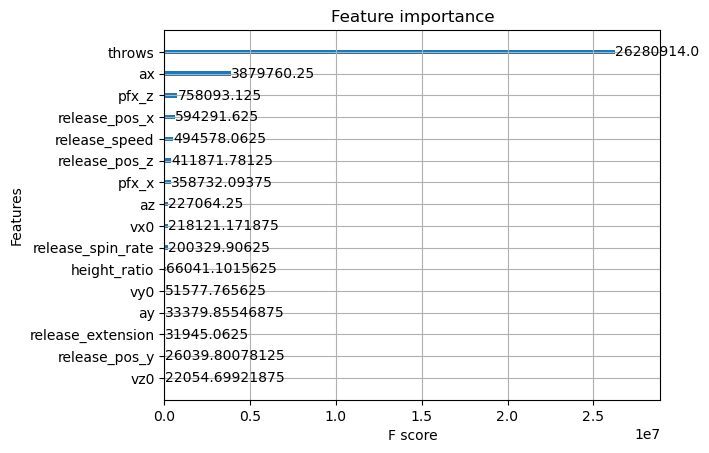

In [38]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [39]:
y_pred = final_model.predict(dtest)

In [40]:
print(y_pred.min())

85.325035


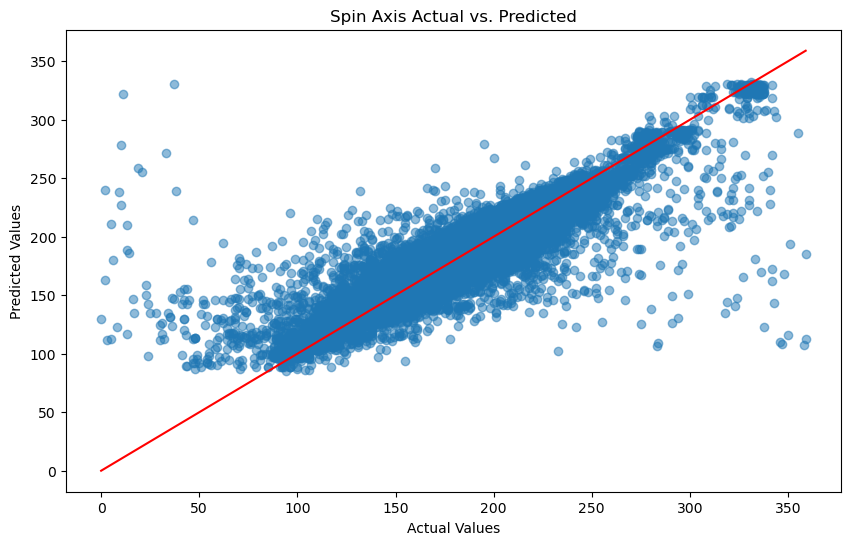

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Spin Axis Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

## Testing Data Set Predictions

In [42]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'throws', 'height_ratio'],
      dtype='object')

In [43]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [44]:
testing_identifiers['xspin_axis'] = predictions

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_14092\1305297107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xspin_axis'] = predictions


In [45]:
testing_identifiers.head()

pitch_id_raw  xspin_axis
0  663364_455139_617228_4_75_10  207.067795
1  663364_455139_617228_3_75_10  207.324310
2  663364_455139_617228_2_75_10  208.056625
3  663364_455139_617228_1_75_10  210.110840
5  663364_593428_605347_4_72_10  212.487976

In [47]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/axis_2022&3_xaxis.csv")

# Offspeed Model 

In [ ]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

###  I think that this is the best leaderboard. Filters out the gimme pitches